# Deep Q-Network implementation.

This homework shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.


**This notebook is the main notebook.** Another notebook is given for debug. (**homework_pytorch_main**). The tasks are similar and share most of the code. The main difference is in environments. In main notebook it can take some 2 hours for the agent to start improving so it seems reasonable to launch the algorithm on a simpler env first. Here it is CartPole and it will train in several minutes.

**We suggest the following pipeline:** First implement debug notebook then implement the main one.

**About evaluation:** All points are given for the main notebook with one exception: if agent fails to beat the threshold in main notebook you can get 1 pt (instead of 3 pts) for beating the threshold in debug notebook.

In [1]:
import random
import numpy as np
import torch
import utils

In [2]:
import gym
import matplotlib.pyplot as plt

### Let's play some old videogames

This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.


In [3]:
ENV_NAME = "BreakoutNoFrameskip-v4"

## Preprocessing (3 pts)

Let's see what observations look like.

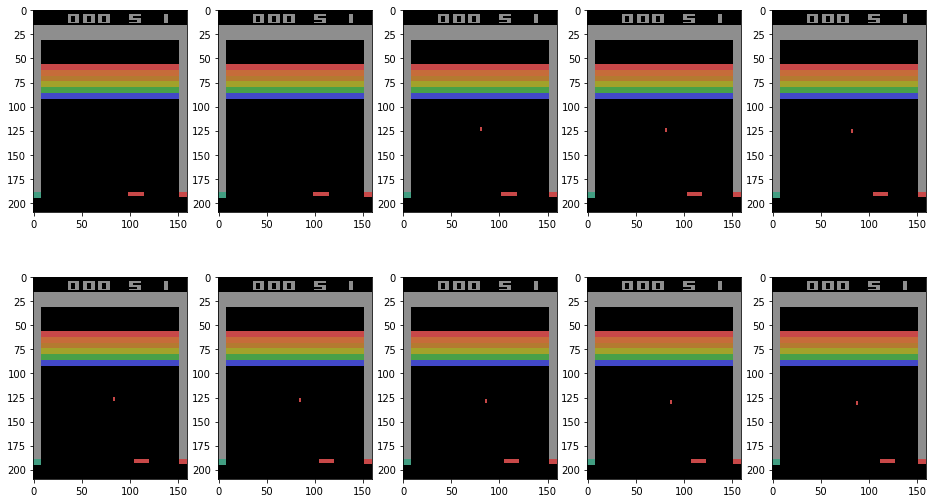

In [4]:
env = gym.make(ENV_NAME).env
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Let's play a little

Pay attention to zoom and fps args of play function. Contol: A, D, Space

In [5]:
# does not work in colab.
# make keyboard interrupt to continue

from gym.utils.play import play

play(env=gym.make(ENV_NAME), zoom=3, fps=30)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


(480, 630)


### Processing game image 

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges)

Also please keep one dimension for channel so that final shape would be 1 x 64 x 64.

Tip: You can implement your own grayscale converter and assign a huge weight to the red channel. This dirty trick is not necessary but it will speed up learning.

In [59]:
from gym.core import ObservationWrapper
from gym.spaces import Box
from scipy.misc import imresize

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_grayscale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        assert rgb.ndim == 3, "is image rgb? ndim: " + str(rgb.ndim) 
        return np.dot(rgb[..., :3], channel_weights)
    
    def _resize(self, img, desired_size=(64,64)):
        assert len(desired_size) == 2, "desired size is invalid, desired_size: " + str(desired_size)
        return imresize(img, desired_size)
    
    def _crop(self, img, margins=(56, 10, 8, 8)):
        """ margins: top, left, right, bottom"""
        assert len(margins) == 4, "margins array is invalid"
        assert img.ndim == 2, "img is not grayscale"
        
        return img[margins[0]:-margins[-1], margins[1]:-margins[2]]
        
        
    def _observation(self, img):
        """what happens to each observation"""
        img = self._to_grayscale(img)
        img = self._crop(img)
        img = self._resize(img)
        img = np.reshape(img, (1, 64, 64))
        img = np.asarray(img, dtype=np.float32) / 255.0
        return img


D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


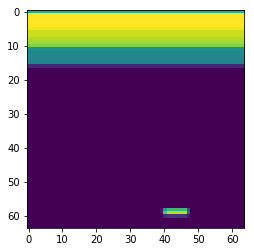

In [60]:
env = gym.make(ENV_NAME)
env = PreprocessAtariObs(env)
plt.imshow(env.reset()[0, :, :])

D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


obs.shape (1, 64, 64)
observation_shape (1, 64, 64)
Formal tests seem fine. Here's an example of what you'll get.


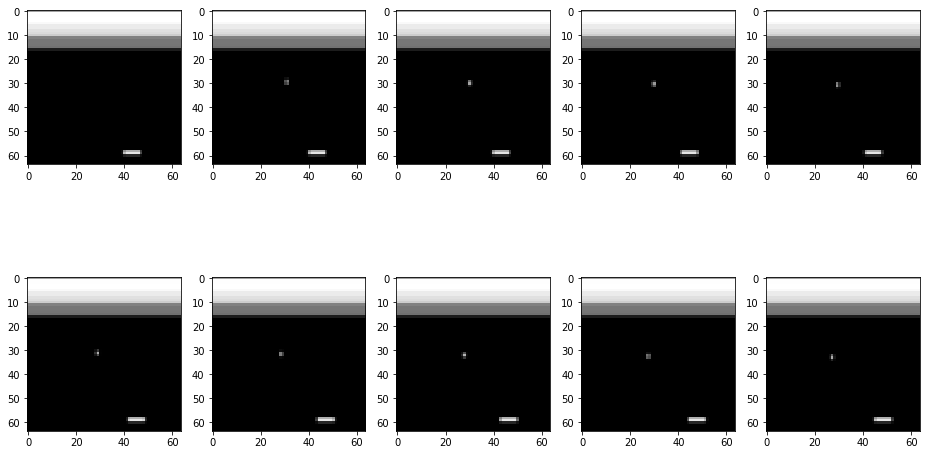

In [62]:
import gym
# spawn game instance for tests
env = gym.make(ENV_NAME)  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
print("obs.shape",obs.shape)
print("observation_shape",observation_shape)
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

### Wrapping.

**About the game:** You have 5 lives and get points for breaking the wall. Higher bricks cost more than the lower ones. There are 4 actions: start game (should be called at the beginning and after each life is lost), move left, move right and do nothing. There are some common wrappers used for Atari environments.

In [63]:
import atari_wrappers

In [64]:
%load_ext autoreload
%autoreload 2

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Let's see if the game is still playable after applying the wrappers.**
At playing the EpisodicLifeEnv wrapper seems not to work but actually it does (because after when life finishes a new ball is dropped automatically - it means that FireResetEnv wrapper understands that a new episode began).

In [65]:
# does not work in colab.
# make keyboard interrupt to continue

from gym.utils.play import play

def make_play_env():
    env = gym.make(ENV_NAME)
    env = PrimaryAtariWrap(env)
# in torch imgs have shape [c, h, w] instead of common [h, w, c]
    env = atari_wrappers.AntiTorchWrapper(env)
    return env

play(make_play_env(), zoom=3, fps=24)

D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you, not really by the staff of the course :)

In [66]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


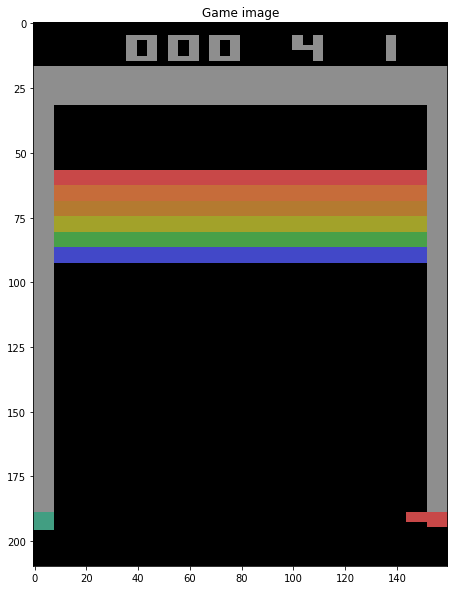

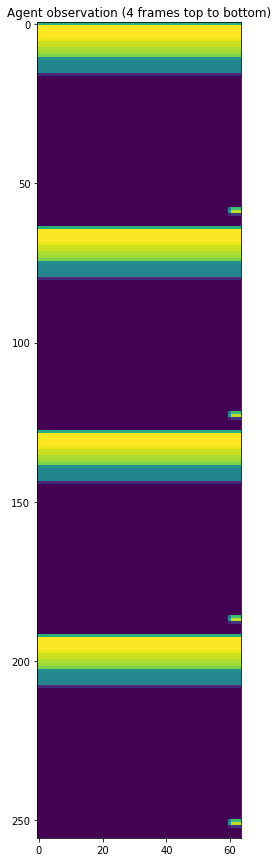

In [28]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_shape[0],-1]))
plt.show()

## DQN as it is (4 pts)

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

(4-frame buffer) [None, frame, h, w] -> (conv 1) /*16 filters 3*3 stride 2 relu*/ -> (conv2)/* 32 filters 3*3 stride 2 relu*/ -> (conv 3) /*64 filters 3*3 stride 2 relu*/ -> dense /*256 linear units, relu*/ ->  (Q-values) /*n_action units, linear*/

In [67]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')

In [68]:
torch.cuda.is_available()

True

In [69]:
def conv2d_size_out(size, kernel_size=3, stride=2):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride + 1


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)



In [72]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):
        super(DQNAgent, self).__init__()
        
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        print(state_shape)
        
        c, h, w = state_shape
        
        self.features = nn.Sequential(
            nn.Conv2d(state_shape[0], 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten() 
        )
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        # we want to flatten given images to verctor for dense layers.
        self.fc = nn.Sequential(
            nn.Linear(linear_input_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )
      
    def forward(self, x):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        x = self.features(x)
        x = self.fc(x)
        assert x.requires_grad, "qvalues must be a torch tensor with grad"
        assert len(
            x.shape) == 2 and x.shape[0] == x.shape[0] and x.shape[1] == n_actions

        return x
    
    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)



In [73]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

(4, 64, 64)


Now let's try out our agent to see if it raises any errors.

In [75]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)



In [76]:
evaluate(env, agent, n_games=1)

D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


4.0

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in last week's assignment, you can copy-paste it here **to get 2 bonus points**.

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [77]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [78]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for t in range(n_steps): 
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        # store current <s,a,r,s'> transition in buffer
        exp_replay.add(s, action, r, next_s, done)
        s = next_s
        sum_rewards += r
        if done:
            s = env.reset()

    return sum_rewards, s

In [79]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (
        10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [
        0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

In [80]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

(4, 64, 64)


### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [81]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]

    assert next_state_values.dim(
    ) == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

In [82]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

In [28]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [83]:
seed = 6
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [84]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

(4, 64, 64)
(4, 64, 64)


D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


In [86]:
exp_replay = ReplayBuffer(10**5)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**4)
    if len(exp_replay) == 10**5:
        break
print(len(exp_replay))


D:\Tools\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


100000


In [32]:
timesteps_per_epoch = 1
batch_size = 16
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [33]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

  0%|                                                                                   | 0/3000001 [00:00<?, ?it/s]

buffer size = 10000, epsilon = 1.00000

  0%|                                                                      | 1/3000001 [00:05<4848:02:38,  5.82s/it]

  0%|                                                                      | 2/3000001 [00:05<3433:21:17,  4.12s/it]

  0%|                                                                      | 3/3000001 [00:06<2458:18:57,  2.95s/it]

  0%|                                                                      | 4/3000001 [00:06<1756:32:59,  2.11s/it]

  0%|                                                                      | 5/3000001 [00:06<1275:03:31,  1.53s/it]

  0%|                                                                       | 6/3000001 [00:06<939:30:49,  1.13s/it]

  0%|                                                                       | 7/3000001 [00:06<696:38:11,  1.20it/s]

  0%|                                                                       | 8/3000001 [00:07<529:22:21,  1.57it/s]

  0%|                                                                       | 9/3000001 [00:07<407:47:20,  2.04it/s]

  0%|                                                                      | 10/3000001 [00:07<321:25:47,  2.59it/s]

  0%|                                                                      | 11/3000001 [00:07<267:13:34,  3.12it/s]

  0%|                                                                      | 12/3000001 [00:07<225:32:11,  3.69it/s]

  0%|                                                                      | 13/3000001 [00:07<193:21:17,  4.31it/s]

  0%|                                                                      | 14/3000001 [00:07<172:49:34,  4.82it/s]

  0%|                                                                      | 15/3000001 [00:08<163:12:15,  5.11it/s]

  0%|                                                                      | 16/3000001 [00:08<150:28:17,  5.54it/s]

  0%|                                                                      | 17/3000001 [00:08<143:18:30,  5.81it/s]

  0%|                                                                      | 18/3000001 [00:08<139:02:34,  5.99it/s]

  0%|                                                                      | 19/3000001 [00:08<159:47:36,  5.22it/s]

  0%|                                                                      | 20/3000001 [00:08<146:50:07,  5.68it/s]

  0%|                                                                      | 21/3000001 [00:09<137:15:51,  6.07it/s]

  0%|                                                                      | 22/3000001 [00:09<132:03:53,  6.31it/s]

  0%|                                                                      | 23/3000001 [00:09<126:40:29,  6.58it/s]

  0%|                                                                      | 24/3000001 [00:09<124:39:03,  6.69it/s]

  0%|                                                                      | 25/3000001 [00:09<123:44:03,  6.73it/s]

  0%|                                                                      | 26/3000001 [00:09<123:35:31,  6.74it/s]

  0%|                                                                      | 27/3000001 [00:09<122:44:36,  6.79it/s]

  0%|                                                                      | 28/3000001 [00:10<120:54:00,  6.89it/s]

  0%|                                                                      | 29/3000001 [00:10<120:06:34,  6.94it/s]

  0%|                                                                      | 30/3000001 [00:10<120:03:27,  6.94it/s]

  0%|                                                                      | 31/3000001 [00:10<123:30:52,  6.75it/s]

  0%|                                                                      | 32/3000001 [00:10<119:41:27,  6.96it/s]

  0%|                                                                      | 33/3000001 [00:10<120:45:43,  6.90it/s]

  0%|                                                                      | 34/3000001 [00:10<120:30:45,  6.91it/s]

  0%|                                                                      | 35/3000001 [00:11<128:04:57,  6.51it/s]

  0%|                                                                      | 36/3000001 [00:11<129:53:09,  6.42it/s]

  0%|                                                                      | 37/3000001 [00:11<125:53:52,  6.62it/s]

  0%|                                                                      | 38/3000001 [00:11<122:51:34,  6.78it/s]

  0%|                                                                      | 39/3000001 [00:11<134:28:17,  6.20it/s]

  0%|                                                                      | 40/3000001 [00:11<131:06:27,  6.36it/s]

  0%|                                                                      | 41/3000001 [00:12<125:00:21,  6.67it/s]

  0%|                                                                      | 42/3000001 [00:12<125:43:54,  6.63it/s]

  0%|                                                                      | 43/3000001 [00:12<136:14:01,  6.12it/s]

  0%|                                                                      | 44/3000001 [00:12<136:20:24,  6.11it/s]

  0%|                                                                      | 45/3000001 [00:12<130:54:57,  6.37it/s]

  0%|                                                                      | 46/3000001 [00:12<134:52:00,  6.18it/s]

  0%|                                                                      | 47/3000001 [00:13<130:53:07,  6.37it/s]

  0%|                                                                      | 48/3000001 [00:13<133:35:37,  6.24it/s]

  0%|                                                                      | 49/3000001 [00:13<131:44:35,  6.33it/s]

  0%|                                                                      | 50/3000001 [00:13<127:11:58,  6.55it/s]

  0%|                                                                      | 51/3000001 [00:13<127:15:59,  6.55it/s]

  0%|                                                                      | 52/3000001 [00:13<129:33:45,  6.43it/s]

  0%|                                                                      | 53/3000001 [00:13<129:25:16,  6.44it/s]

  0%|                                                                      | 54/3000001 [00:14<128:49:16,  6.47it/s]

  0%|                                                                      | 55/3000001 [00:14<125:24:19,  6.64it/s]

  0%|                                                                      | 56/3000001 [00:14<121:45:43,  6.84it/s]

  0%|                                                                      | 57/3000001 [00:14<120:57:44,  6.89it/s]

  0%|                                                                      | 58/3000001 [00:14<123:24:01,  6.75it/s]

  0%|                                                                      | 59/3000001 [00:14<124:36:27,  6.69it/s]

  0%|                                                                      | 60/3000001 [00:14<126:12:07,  6.60it/s]

  0%|                                                                      | 61/3000001 [00:15<126:04:07,  6.61it/s]

  0%|                                                                      | 62/3000001 [00:15<126:13:34,  6.60it/s]

  0%|                                                                      | 63/3000001 [00:15<125:35:07,  6.64it/s]

  0%|                                                                      | 64/3000001 [00:15<125:38:14,  6.63it/s]

  0%|                                                                      | 65/3000001 [00:15<126:40:22,  6.58it/s]

  0%|                                                                      | 66/3000001 [00:15<126:23:56,  6.59it/s]

  0%|                                                                      | 67/3000001 [00:16<126:12:21,  6.60it/s]

  0%|                                                                      | 68/3000001 [00:16<126:04:17,  6.61it/s]

  0%|                                                                      | 69/3000001 [00:16<125:58:38,  6.61it/s]

  0%|                                                                      | 70/3000001 [00:16<126:54:39,  6.57it/s]

  0%|                                                                      | 71/3000001 [00:16<125:03:57,  6.66it/s]

  0%|                                                                      | 72/3000001 [00:16<128:46:17,  6.47it/s]

  0%|                                                                      | 73/3000001 [00:16<129:21:59,  6.44it/s]

  0%|                                                                      | 74/3000001 [00:17<128:47:03,  6.47it/s]

  0%|                                                                      | 75/3000001 [00:17<127:07:33,  6.56it/s]

  0%|                                                                      | 76/3000001 [00:17<126:27:55,  6.59it/s]

  0%|                                                                      | 77/3000001 [00:17<125:45:12,  6.63it/s]

  0%|                                                                      | 78/3000001 [00:17<126:45:23,  6.57it/s]

  0%|                                                                      | 79/3000001 [00:17<128:12:12,  6.50it/s]

  0%|                                                                      | 80/3000001 [00:18<127:28:09,  6.54it/s]

  0%|                                                                      | 81/3000001 [00:18<126:27:22,  6.59it/s]

  0%|                                                                      | 82/3000001 [00:18<128:29:43,  6.49it/s]

  0%|                                                                      | 83/3000001 [00:18<127:40:28,  6.53it/s]

  0%|                                                                      | 84/3000001 [00:18<126:35:56,  6.58it/s]

  0%|                                                                      | 85/3000001 [00:18<125:50:47,  6.62it/s]

  0%|                                                                      | 86/3000001 [00:18<126:04:10,  6.61it/s]

  0%|                                                                      | 87/3000001 [00:19<124:43:35,  6.68it/s]

  0%|                                                                      | 88/3000001 [00:19<125:32:08,  6.64it/s]

  0%|                                                                      | 89/3000001 [00:19<125:36:09,  6.63it/s]

  0%|                                                                      | 90/3000001 [00:19<127:08:50,  6.55it/s]

  0%|                                                                      | 91/3000001 [00:19<125:13:52,  6.65it/s]

  0%|                                                                      | 92/3000001 [00:19<126:23:17,  6.59it/s]

  0%|                                                                      | 93/3000001 [00:19<125:11:57,  6.66it/s]

  0%|                                                                      | 94/3000001 [00:20<127:36:54,  6.53it/s]

  0%|                                                                      | 95/3000001 [00:20<126:33:28,  6.58it/s]

  0%|                                                                      | 96/3000001 [00:20<128:19:05,  6.49it/s]

  0%|                                                                      | 97/3000001 [00:20<126:32:55,  6.58it/s]

  0%|                                                                      | 98/3000001 [00:20<127:18:38,  6.55it/s]

  0%|                                                                      | 99/3000001 [00:20<126:50:40,  6.57it/s]

  0%|                                                                     | 100/3000001 [00:21<126:31:03,  6.59it/s]

  0%|                                                                     | 101/3000001 [00:21<125:32:23,  6.64it/s]

  0%|                                                                     | 102/3000001 [00:21<125:06:17,  6.66it/s]

  0%|                                                                     | 103/3000001 [00:21<124:18:04,  6.70it/s]

  0%|                                                                     | 104/3000001 [00:21<125:59:12,  6.61it/s]

  0%|                                                                     | 105/3000001 [00:21<124:55:08,  6.67it/s]

  0%|                                                                     | 106/3000001 [00:21<126:55:07,  6.57it/s]

  0%|                                                                     | 107/3000001 [00:22<128:19:09,  6.49it/s]

  0%|                                                                     | 108/3000001 [00:22<130:17:54,  6.40it/s]

  0%|                                                                     | 109/3000001 [00:22<130:11:08,  6.40it/s]

  0%|                                                                     | 110/3000001 [00:22<132:51:13,  6.27it/s]

  0%|                                                                     | 111/3000001 [00:22<129:58:31,  6.41it/s]

  0%|                                                                     | 112/3000001 [00:22<133:12:22,  6.26it/s]

  0%|                                                                     | 113/3000001 [00:23<130:58:16,  6.36it/s]

  0%|                                                                     | 114/3000001 [00:23<130:39:22,  6.38it/s]

  0%|                                                                     | 115/3000001 [00:23<160:40:05,  5.19it/s]

  0%|                                                                     | 116/3000001 [00:23<155:26:21,  5.36it/s]

  0%|                                                                     | 117/3000001 [00:23<149:46:55,  5.56it/s]

  0%|                                                                     | 118/3000001 [00:24<155:48:57,  5.35it/s]

  0%|                                                                     | 119/3000001 [00:24<151:17:41,  5.51it/s]

  0%|                                                                     | 120/3000001 [00:24<143:53:00,  5.79it/s]

  0%|                                                                     | 121/3000001 [00:24<140:11:37,  5.94it/s]

  0%|                                                                     | 122/3000001 [00:24<136:36:43,  6.10it/s]

  0%|                                                                     | 123/3000001 [00:24<136:36:09,  6.10it/s]

  0%|                                                                     | 124/3000001 [00:25<137:50:47,  6.05it/s]

  0%|                                                                     | 125/3000001 [00:25<132:58:10,  6.27it/s]

  0%|                                                                     | 126/3000001 [00:25<134:03:11,  6.22it/s]

  0%|                                                                     | 127/3000001 [00:25<134:18:43,  6.20it/s]

  0%|                                                                     | 128/3000001 [00:25<131:44:42,  6.33it/s]

  0%|                                                                     | 129/3000001 [00:25<131:41:51,  6.33it/s]

  0%|                                                                     | 130/3000001 [00:25<135:54:39,  6.13it/s]

  0%|                                                                     | 131/3000001 [00:26<134:36:47,  6.19it/s]

  0%|                                                                     | 132/3000001 [00:26<132:42:17,  6.28it/s]

  0%|                                                                     | 133/3000001 [00:26<223:18:47,  3.73it/s]

  0%|                                                                     | 134/3000001 [00:27<267:30:01,  3.12it/s]

  0%|                                                                     | 135/3000001 [00:27<245:42:47,  3.39it/s]

  0%|                                                                     | 136/3000001 [00:27<229:57:48,  3.62it/s]

  0%|                                                                     | 137/3000001 [00:27<207:41:45,  4.01it/s]

  0%|                                                                     | 138/3000001 [00:28<188:06:36,  4.43it/s]

  0%|                                                                     | 139/3000001 [00:28<183:08:42,  4.55it/s]

  0%|                                                                     | 140/3000001 [00:28<188:09:51,  4.43it/s]

  0%|                                                                     | 141/3000001 [00:28<176:11:17,  4.73it/s]

  0%|                                                                     | 142/3000001 [00:28<172:32:58,  4.83it/s]

  0%|                                                                     | 143/3000001 [00:29<163:30:27,  5.10it/s]

  0%|                                                                     | 144/3000001 [00:29<150:40:57,  5.53it/s]

  0%|                                                                     | 145/3000001 [00:29<139:27:23,  5.98it/s]

  0%|                                                                     | 146/3000001 [00:29<135:35:44,  6.15it/s]

  0%|                                                                     | 147/3000001 [00:29<130:53:42,  6.37it/s]

  0%|                                                                     | 148/3000001 [00:29<126:06:15,  6.61it/s]

  0%|                                                                     | 149/3000001 [00:29<128:44:52,  6.47it/s]

  0%|                                                                     | 150/3000001 [00:30<125:51:04,  6.62it/s]

  0%|                                                                     | 151/3000001 [00:30<153:03:18,  5.44it/s]

  0%|                                                                     | 152/3000001 [00:30<144:36:54,  5.76it/s]

  0%|                                                                     | 153/3000001 [00:30<136:27:29,  6.11it/s]

  0%|                                                                     | 154/3000001 [00:30<133:59:48,  6.22it/s]

  0%|                                                                     | 155/3000001 [00:30<130:16:29,  6.40it/s]

  0%|                                                                     | 156/3000001 [00:31<126:40:12,  6.58it/s]

  0%|                                                                     | 157/3000001 [00:31<123:08:50,  6.77it/s]

  0%|                                                                     | 158/3000001 [00:31<120:40:55,  6.90it/s]

  0%|                                                                     | 159/3000001 [00:31<116:57:24,  7.12it/s]

  0%|                                                                     | 160/3000001 [00:31<116:50:50,  7.13it/s]

  0%|                                                                     | 161/3000001 [00:31<131:00:45,  6.36it/s]

  0%|                                                                     | 162/3000001 [00:32<147:55:21,  5.63it/s]

  0%|                                                                     | 163/3000001 [00:32<158:45:40,  5.25it/s]

  0%|                                                                     | 164/3000001 [00:32<167:20:49,  4.98it/s]

  0%|                                                                     | 165/3000001 [00:32<166:21:46,  5.01it/s]

  0%|                                                                     | 166/3000001 [00:32<163:10:27,  5.11it/s]

  0%|                                                                     | 167/3000001 [00:33<156:11:39,  5.33it/s]

  0%|                                                                     | 168/3000001 [00:33<149:33:39,  5.57it/s]

  0%|                                                                     | 169/3000001 [00:33<146:39:57,  5.68it/s]

  0%|                                                                     | 170/3000001 [00:33<145:53:22,  5.71it/s]

  0%|                                                                     | 171/3000001 [00:33<146:20:38,  5.69it/s]

  0%|                                                                     | 172/3000001 [00:33<148:09:43,  5.62it/s]

  0%|                                                                     | 173/3000001 [00:34<147:56:06,  5.63it/s]

  0%|                                                                     | 174/3000001 [00:34<140:46:50,  5.92it/s]

  0%|                                                                     | 175/3000001 [00:34<151:15:47,  5.51it/s]

  0%|                                                                     | 176/3000001 [00:34<152:36:16,  5.46it/s]

  0%|                                                                     | 177/3000001 [00:34<151:02:42,  5.52it/s]

  0%|                                                                     | 178/3000001 [00:34<152:12:05,  5.47it/s]

  0%|                                                                     | 179/3000001 [00:35<169:45:04,  4.91it/s]

  0%|                                                                     | 180/3000001 [00:35<167:47:39,  4.97it/s]

  0%|                                                                     | 181/3000001 [00:36<345:18:41,  2.41it/s]

  0%|                                                                     | 182/3000001 [00:36<327:09:47,  2.55it/s]

  0%|                                                                     | 183/3000001 [00:36<295:13:18,  2.82it/s]

  0%|                                                                     | 184/3000001 [00:37<261:07:15,  3.19it/s]

  0%|                                                                     | 185/3000001 [00:37<255:14:17,  3.26it/s]

  0%|                                                                     | 186/3000001 [00:37<231:52:57,  3.59it/s]

  0%|                                                                     | 187/3000001 [00:37<202:32:30,  4.11it/s]

  0%|                                                                     | 188/3000001 [00:38<186:15:22,  4.47it/s]

  0%|                                                                     | 189/3000001 [00:38<170:05:54,  4.90it/s]

  0%|                                                                     | 190/3000001 [00:38<151:02:55,  5.52it/s]

  0%|                                                                     | 191/3000001 [00:38<138:27:47,  6.02it/s]

  0%|                                                                     | 192/3000001 [00:38<130:09:13,  6.40it/s]

  0%|                                                                     | 193/3000001 [00:38<125:50:04,  6.62it/s]

  0%|                                                                     | 194/3000001 [00:38<121:18:52,  6.87it/s]

  0%|                                                                     | 195/3000001 [00:38<118:38:48,  7.02it/s]

  0%|                                                                     | 196/3000001 [00:39<120:46:41,  6.90it/s]

  0%|                                                                     | 197/3000001 [00:39<121:46:17,  6.84it/s]

  0%|                                                                     | 198/3000001 [00:39<121:57:57,  6.83it/s]

  0%|                                                                     | 199/3000001 [00:39<125:51:15,  6.62it/s]

  0%|                                                                     | 200/3000001 [00:39<142:48:30,  5.83it/s]

  0%|                                                                     | 201/3000001 [00:39<141:26:20,  5.89it/s]

  0%|                                                                     | 202/3000001 [00:40<133:44:06,  6.23it/s]

  0%|                                                                     | 203/3000001 [00:40<138:50:08,  6.00it/s]

  0%|                                                                     | 204/3000001 [00:40<146:39:09,  5.68it/s]

  0%|                                                                     | 205/3000001 [00:40<139:37:59,  5.97it/s]

  0%|                                                                     | 206/3000001 [00:40<138:58:02,  6.00it/s]

  0%|                                                                     | 207/3000001 [00:41<151:44:32,  5.49it/s]

  0%|                                                                     | 208/3000001 [00:41<150:26:30,  5.54it/s]

  0%|                                                                     | 209/3000001 [00:41<151:31:41,  5.50it/s]

  0%|                                                                     | 210/3000001 [00:41<140:02:50,  5.95it/s]

  0%|                                                                     | 211/3000001 [00:41<135:15:33,  6.16it/s]

  0%|                                                                     | 212/3000001 [00:41<136:24:14,  6.11it/s]

  0%|                                                                     | 213/3000001 [00:41<131:27:34,  6.34it/s]

  0%|                                                                     | 214/3000001 [00:42<125:44:58,  6.63it/s]

  0%|                                                                     | 215/3000001 [00:42<120:30:14,  6.91it/s]

  0%|                                                                     | 216/3000001 [00:42<117:04:54,  7.12it/s]

  0%|                                                                     | 217/3000001 [00:42<114:11:08,  7.30it/s]

  0%|                                                                     | 218/3000001 [00:42<114:24:30,  7.28it/s]

  0%|                                                                     | 219/3000001 [00:42<111:03:54,  7.50it/s]

  0%|                                                                     | 220/3000001 [00:42<109:58:29,  7.58it/s]

  0%|                                                                     | 221/3000001 [00:43<112:12:33,  7.43it/s]

  0%|                                                                     | 222/3000001 [00:43<110:31:32,  7.54it/s]

  0%|                                                                     | 223/3000001 [00:43<109:35:49,  7.60it/s]

  0%|                                                                     | 224/3000001 [00:43<112:41:39,  7.39it/s]

  0%|                                                                     | 225/3000001 [00:43<111:51:52,  7.45it/s]

  0%|                                                                     | 226/3000001 [00:43<110:47:01,  7.52it/s]

  0%|                                                                     | 227/3000001 [00:43<108:16:43,  7.70it/s]

  0%|                                                                     | 228/3000001 [00:43<112:16:18,  7.42it/s]

  0%|                                                                     | 229/3000001 [00:44<120:03:49,  6.94it/s]

  0%|                                                                     | 230/3000001 [00:44<118:16:17,  7.05it/s]

  0%|                                                                     | 231/3000001 [00:44<117:31:02,  7.09it/s]

  0%|                                                                     | 232/3000001 [00:44<137:13:34,  6.07it/s]

  0%|                                                                     | 233/3000001 [00:44<141:16:44,  5.90it/s]

  0%|                                                                     | 234/3000001 [00:44<141:22:03,  5.89it/s]

  0%|                                                                     | 235/3000001 [00:45<140:25:46,  5.93it/s]

  0%|                                                                     | 236/3000001 [00:45<142:01:19,  5.87it/s]

  0%|                                                                     | 237/3000001 [00:45<134:53:31,  6.18it/s]

  0%|                                                                     | 238/3000001 [00:45<144:23:31,  5.77it/s]

  0%|                                                                     | 239/3000001 [00:45<143:17:46,  5.81it/s]

  0%|                                                                     | 240/3000001 [00:45<133:17:10,  6.25it/s]

  0%|                                                                     | 241/3000001 [00:46<127:01:42,  6.56it/s]

  0%|                                                                     | 242/3000001 [00:46<122:08:50,  6.82it/s]

  0%|                                                                     | 243/3000001 [00:46<118:58:55,  7.00it/s]

  0%|                                                                     | 244/3000001 [00:46<114:15:58,  7.29it/s]

  0%|                                                                     | 245/3000001 [00:46<110:42:57,  7.53it/s]

  0%|                                                                     | 246/3000001 [00:46<110:43:46,  7.53it/s]

  0%|                                                                     | 247/3000001 [00:46<108:59:29,  7.65it/s]

  0%|                                                                     | 248/3000001 [00:46<108:31:15,  7.68it/s]

  0%|                                                                     | 249/3000001 [00:47<109:56:32,  7.58it/s]

  0%|                                                                     | 250/3000001 [00:47<109:11:18,  7.63it/s]

  0%|                                                                     | 251/3000001 [00:47<109:39:35,  7.60it/s]

  0%|                                                                     | 252/3000001 [00:47<111:44:19,  7.46it/s]

  0%|                                                                     | 253/3000001 [00:47<111:56:41,  7.44it/s]

  0%|                                                                     | 254/3000001 [00:47<111:05:23,  7.50it/s]

  0%|                                                                     | 255/3000001 [00:47<113:14:21,  7.36it/s]

  0%|                                                                     | 256/3000001 [00:48<113:59:41,  7.31it/s]

  0%|                                                                     | 257/3000001 [00:48<112:31:27,  7.41it/s]

  0%|                                                                     | 258/3000001 [00:48<110:29:46,  7.54it/s]

  0%|                                                                     | 259/3000001 [00:48<108:49:34,  7.66it/s]

  0%|                                                                     | 260/3000001 [00:48<112:39:15,  7.40it/s]

  0%|                                                                     | 261/3000001 [00:48<113:05:08,  7.37it/s]

  0%|                                                                     | 262/3000001 [00:48<111:38:16,  7.46it/s]

  0%|                                                                     | 263/3000001 [00:49<109:37:33,  7.60it/s]

  0%|                                                                     | 264/3000001 [00:49<109:57:56,  7.58it/s]

  0%|                                                                     | 265/3000001 [00:49<110:27:16,  7.54it/s]

  0%|                                                                     | 266/3000001 [00:49<110:02:45,  7.57it/s]

  0%|                                                                     | 267/3000001 [00:49<110:15:34,  7.56it/s]

  0%|                                                                     | 268/3000001 [00:49<110:09:35,  7.56it/s]

  0%|                                                                     | 269/3000001 [00:49<111:20:20,  7.48it/s]

  0%|                                                                     | 270/3000001 [00:49<110:24:57,  7.55it/s]

  0%|                                                                     | 271/3000001 [00:50<120:30:42,  6.91it/s]

  0%|                                                                     | 272/3000001 [00:50<120:35:03,  6.91it/s]

  0%|                                                                     | 273/3000001 [00:50<125:37:56,  6.63it/s]

  0%|                                                                     | 274/3000001 [00:50<120:40:10,  6.91it/s]

  0%|                                                                     | 275/3000001 [00:50<116:11:52,  7.17it/s]

  0%|                                                                     | 276/3000001 [00:50<114:18:58,  7.29it/s]

  0%|                                                                     | 277/3000001 [00:50<112:00:00,  7.44it/s]

  0%|                                                                     | 278/3000001 [00:51<119:22:27,  6.98it/s]

  0%|                                                                     | 279/3000001 [00:51<123:17:01,  6.76it/s]

  0%|                                                                     | 280/3000001 [00:51<122:31:27,  6.80it/s]

  0%|                                                                     | 281/3000001 [00:51<118:59:41,  7.00it/s]

  0%|                                                                     | 282/3000001 [00:51<117:31:26,  7.09it/s]

  0%|                                                                     | 283/3000001 [00:51<115:29:39,  7.21it/s]

  0%|                                                                     | 284/3000001 [00:51<111:34:30,  7.47it/s]

  0%|                                                                     | 285/3000001 [00:52<111:34:46,  7.47it/s]

  0%|                                                                     | 286/3000001 [00:52<116:04:57,  7.18it/s]

  0%|                                                                     | 287/3000001 [00:52<122:28:54,  6.80it/s]

  0%|                                                                     | 288/3000001 [00:52<121:57:31,  6.83it/s]

  0%|                                                                     | 289/3000001 [00:52<117:20:59,  7.10it/s]

  0%|                                                                     | 290/3000001 [00:52<113:07:26,  7.37it/s]

  0%|                                                                     | 291/3000001 [00:52<111:54:52,  7.45it/s]

  0%|                                                                     | 292/3000001 [00:53<110:49:07,  7.52it/s]

  0%|                                                                     | 293/3000001 [00:53<109:18:07,  7.62it/s]

  0%|                                                                     | 294/3000001 [00:53<105:59:26,  7.86it/s]

  0%|                                                                     | 295/3000001 [00:53<105:55:20,  7.87it/s]

  0%|                                                                     | 296/3000001 [00:53<105:52:27,  7.87it/s]

  0%|                                                                     | 297/3000001 [00:53<105:20:26,  7.91it/s]

  0%|                                                                     | 298/3000001 [00:53<105:13:00,  7.92it/s]

  0%|                                                                     | 299/3000001 [00:53<106:07:47,  7.85it/s]

  0%|                                                                     | 300/3000001 [00:54<107:16:06,  7.77it/s]

  0%|                                                                     | 301/3000001 [00:54<107:48:59,  7.73it/s]

  0%|                                                                     | 302/3000001 [00:54<108:12:09,  7.70it/s]

  0%|                                                                     | 303/3000001 [00:54<108:57:55,  7.65it/s]

  0%|                                                                     | 304/3000001 [00:54<112:00:07,  7.44it/s]

  0%|                                                                     | 305/3000001 [00:54<110:37:45,  7.53it/s]

  0%|                                                                     | 306/3000001 [00:54<107:25:11,  7.76it/s]

  0%|                                                                     | 307/3000001 [00:54<105:55:23,  7.87it/s]

  0%|                                                                     | 308/3000001 [00:55<107:37:24,  7.74it/s]

  0%|                                                                     | 309/3000001 [00:55<107:03:54,  7.78it/s]

  0%|                                                                     | 310/3000001 [00:55<106:55:24,  7.79it/s]

  0%|                                                                     | 311/3000001 [00:55<107:34:27,  7.75it/s]

  0%|                                                                     | 312/3000001 [00:55<105:16:53,  7.91it/s]

  0%|                                                                     | 313/3000001 [00:55<105:55:30,  7.87it/s]

  0%|                                                                     | 314/3000001 [00:55<106:22:32,  7.83it/s]

  0%|                                                                     | 315/3000001 [00:55<108:56:22,  7.65it/s]

  0%|                                                                     | 316/3000001 [00:56<110:29:02,  7.54it/s]

  0%|                                                                     | 317/3000001 [00:56<111:33:56,  7.47it/s]

  0%|                                                                     | 318/3000001 [00:56<112:34:20,  7.40it/s]

  0%|                                                                     | 319/3000001 [00:56<114:31:35,  7.28it/s]

  0%|                                                                     | 320/3000001 [00:56<116:08:37,  7.17it/s]

  0%|                                                                     | 321/3000001 [00:56<115:46:40,  7.20it/s]

  0%|                                                                     | 322/3000001 [00:56<115:01:14,  7.24it/s]

  0%|                                                                     | 323/3000001 [00:57<123:44:20,  6.73it/s]

  0%|                                                                     | 324/3000001 [00:57<138:04:43,  6.03it/s]

  0%|                                                                     | 325/3000001 [00:57<132:22:45,  6.29it/s]

  0%|                                                                     | 326/3000001 [00:57<125:38:37,  6.63it/s]

  0%|                                                                     | 327/3000001 [00:57<121:10:39,  6.88it/s]

  0%|                                                                     | 328/3000001 [00:57<116:33:07,  7.15it/s]

  0%|                                                                     | 329/3000001 [00:58<114:33:49,  7.27it/s]

  0%|                                                                     | 330/3000001 [00:58<114:40:18,  7.27it/s]

  0%|                                                                     | 331/3000001 [00:58<120:59:32,  6.89it/s]

  0%|                                                                     | 332/3000001 [00:58<122:40:06,  6.79it/s]

  0%|                                                                     | 333/3000001 [00:58<118:20:40,  7.04it/s]

  0%|                                                                     | 334/3000001 [00:58<113:19:13,  7.35it/s]

  0%|                                                                     | 335/3000001 [00:58<109:33:14,  7.61it/s]

  0%|                                                                     | 336/3000001 [00:58<106:25:00,  7.83it/s]

  0%|                                                                     | 337/3000001 [00:59<107:28:09,  7.75it/s]

  0%|                                                                     | 338/3000001 [00:59<105:42:25,  7.88it/s]

  0%|                                                                     | 339/3000001 [00:59<106:43:22,  7.81it/s]

  0%|                                                                     | 340/3000001 [00:59<108:10:58,  7.70it/s]

  0%|                                                                     | 341/3000001 [00:59<106:57:21,  7.79it/s]

  0%|                                                                     | 342/3000001 [00:59<107:05:51,  7.78it/s]

  0%|                                                                     | 343/3000001 [00:59<105:26:47,  7.90it/s]

  0%|                                                                     | 344/3000001 [00:59<107:17:22,  7.77it/s]

  0%|                                                                     | 345/3000001 [01:00<107:34:48,  7.75it/s]

  0%|                                                                     | 346/3000001 [01:00<110:01:55,  7.57it/s]

  0%|                                                                     | 347/3000001 [01:00<122:29:32,  6.80it/s]

  0%|                                                                     | 348/3000001 [01:00<121:58:05,  6.83it/s]

  0%|                                                                     | 349/3000001 [01:00<117:36:19,  7.09it/s]

  0%|                                                                     | 350/3000001 [01:00<112:48:12,  7.39it/s]

  0%|                                                                     | 351/3000001 [01:00<109:56:24,  7.58it/s]

  0%|                                                                     | 352/3000001 [01:01<109:26:08,  7.61it/s]

  0%|                                                                     | 353/3000001 [01:01<108:19:58,  7.69it/s]

  0%|                                                                     | 354/3000001 [01:01<107:33:38,  7.75it/s]

  0%|                                                                     | 355/3000001 [01:01<107:46:11,  7.73it/s]

  0%|                                                                     | 356/3000001 [01:01<107:24:59,  7.76it/s]

  0%|                                                                     | 357/3000001 [01:01<107:55:07,  7.72it/s]

  0%|                                                                     | 358/3000001 [01:01<108:01:14,  7.71it/s]

  0%|                                                                     | 359/3000001 [01:02<115:35:12,  7.21it/s]

  0%|                                                                     | 360/3000001 [01:02<120:37:58,  6.91it/s]

  0%|                                                                     | 361/3000001 [01:02<119:10:08,  6.99it/s]

  0%|                                                                     | 362/3000001 [01:02<114:08:50,  7.30it/s]

  0%|                                                                     | 363/3000001 [01:02<111:07:51,  7.50it/s]

  0%|                                                                     | 364/3000001 [01:02<109:46:09,  7.59it/s]

  0%|                                                                     | 365/3000001 [01:02<109:18:56,  7.62it/s]

  0%|                                                                     | 366/3000001 [01:02<113:14:43,  7.36it/s]

  0%|                                                                     | 367/3000001 [01:03<118:44:38,  7.02it/s]

  0%|                                                                     | 368/3000001 [01:03<123:20:33,  6.76it/s]

  0%|                                                                     | 369/3000001 [01:03<119:19:00,  6.98it/s]

  0%|                                                                     | 370/3000001 [01:03<120:44:44,  6.90it/s]

  0%|                                                                     | 371/3000001 [01:03<123:29:40,  6.75it/s]

  0%|                                                                     | 372/3000001 [01:03<119:40:22,  6.96it/s]

  0%|                                                                     | 373/3000001 [01:03<115:44:57,  7.20it/s]

  0%|                                                                     | 374/3000001 [01:04<114:15:02,  7.29it/s]

  0%|                                                                     | 375/3000001 [01:04<111:27:12,  7.48it/s]

  0%|                                                                     | 376/3000001 [01:04<109:14:44,  7.63it/s]

  0%|                                                                     | 377/3000001 [01:04<106:42:02,  7.81it/s]

  0%|                                                                     | 378/3000001 [01:04<105:40:06,  7.89it/s]

  0%|                                                                     | 379/3000001 [01:04<105:41:46,  7.88it/s]

  0%|                                                                     | 380/3000001 [01:04<104:57:53,  7.94it/s]

  0%|                                                                     | 381/3000001 [01:04<105:42:09,  7.88it/s]

  0%|                                                                     | 382/3000001 [01:05<107:13:07,  7.77it/s]

  0%|                                                                     | 383/3000001 [01:05<106:16:51,  7.84it/s]

  0%|                                                                     | 384/3000001 [01:05<106:37:26,  7.81it/s]

  0%|                                                                     | 385/3000001 [01:05<110:21:43,  7.55it/s]

  0%|                                                                     | 386/3000001 [01:05<119:13:30,  6.99it/s]

  0%|                                                                     | 387/3000001 [01:05<119:55:48,  6.95it/s]

  0%|                                                                     | 388/3000001 [01:05<114:55:48,  7.25it/s]

  0%|                                                                     | 389/3000001 [01:06<113:25:36,  7.35it/s]

  0%|                                                                     | 390/3000001 [01:06<112:52:30,  7.38it/s]

  0%|                                                                     | 391/3000001 [01:06<114:29:16,  7.28it/s]

  0%|                                                                     | 392/3000001 [01:06<110:07:12,  7.57it/s]

  0%|                                                                     | 393/3000001 [01:06<108:03:42,  7.71it/s]

  0%|                                                                     | 394/3000001 [01:06<109:07:11,  7.64it/s]

  0%|                                                                     | 395/3000001 [01:06<107:06:44,  7.78it/s]

  0%|                                                                     | 396/3000001 [01:06<106:42:19,  7.81it/s]

  0%|                                                                     | 397/3000001 [01:07<108:40:13,  7.67it/s]

  0%|                                                                     | 398/3000001 [01:07<106:17:49,  7.84it/s]

  0%|                                                                     | 399/3000001 [01:07<107:38:04,  7.74it/s]

  0%|                                                                     | 400/3000001 [01:07<107:04:17,  7.78it/s]

  0%|                                                                     | 401/3000001 [01:07<109:10:34,  7.63it/s]

  0%|                                                                     | 402/3000001 [01:07<114:53:44,  7.25it/s]

  0%|                                                                     | 403/3000001 [01:07<114:09:14,  7.30it/s]

  0%|                                                                     | 404/3000001 [01:08<114:37:57,  7.27it/s]

  0%|                                                                     | 405/3000001 [01:08<120:12:51,  6.93it/s]

  0%|                                                                     | 406/3000001 [01:08<125:37:17,  6.63it/s]

  0%|                                                                     | 407/3000001 [01:08<121:09:34,  6.88it/s]

  0%|                                                                     | 408/3000001 [01:08<119:17:14,  6.98it/s]

  0%|                                                                     | 409/3000001 [01:08<115:28:41,  7.22it/s]

  0%|                                                                     | 410/3000001 [01:08<112:18:44,  7.42it/s]

  0%|                                                                     | 411/3000001 [01:09<110:20:47,  7.55it/s]

  0%|                                                                     | 412/3000001 [01:09<108:28:17,  7.68it/s]

  0%|                                                                     | 413/3000001 [01:09<109:09:18,  7.63it/s]

  0%|                                                                     | 414/3000001 [01:09<112:07:57,  7.43it/s]

  0%|                                                                     | 415/3000001 [01:09<108:43:16,  7.66it/s]

  0%|                                                                     | 416/3000001 [01:09<108:19:53,  7.69it/s]

  0%|                                                                     | 417/3000001 [01:09<107:33:33,  7.75it/s]

  0%|                                                                     | 418/3000001 [01:09<108:16:05,  7.70it/s]

  0%|                                                                     | 419/3000001 [01:10<107:45:53,  7.73it/s]

  0%|                                                                     | 420/3000001 [01:10<107:09:44,  7.78it/s]

  0%|                                                                     | 421/3000001 [01:10<106:59:26,  7.79it/s]

  0%|                                                                     | 422/3000001 [01:10<106:22:15,  7.83it/s]

  0%|                                                                     | 423/3000001 [01:10<107:11:11,  7.77it/s]

  0%|                                                                     | 424/3000001 [01:10<109:45:18,  7.59it/s]

  0%|                                                                     | 425/3000001 [01:10<109:18:22,  7.62it/s]

  0%|                                                                     | 426/3000001 [01:11<109:44:22,  7.59it/s]

  0%|                                                                     | 427/3000001 [01:11<110:32:37,  7.54it/s]

  0%|                                                                     | 428/3000001 [01:11<109:06:27,  7.64it/s]

  0%|                                                                     | 429/3000001 [01:11<125:20:27,  6.65it/s]

  0%|                                                                     | 430/3000001 [01:11<121:12:50,  6.87it/s]

  0%|                                                                     | 431/3000001 [01:11<119:04:29,  7.00it/s]

  0%|                                                                     | 432/3000001 [01:11<118:34:36,  7.03it/s]

  0%|                                                                     | 433/3000001 [01:12<117:13:45,  7.11it/s]

  0%|                                                                     | 434/3000001 [01:12<115:02:10,  7.24it/s]

  0%|                                                                     | 435/3000001 [01:12<115:15:01,  7.23it/s]

  0%|                                                                     | 436/3000001 [01:12<114:24:03,  7.28it/s]

  0%|                                                                     | 437/3000001 [01:12<119:18:08,  6.98it/s]

  0%|                                                                     | 438/3000001 [01:12<116:14:18,  7.17it/s]

  0%|                                                                     | 439/3000001 [01:12<113:35:36,  7.34it/s]

  0%|                                                                     | 440/3000001 [01:12<111:44:31,  7.46it/s]

  0%|                                                                     | 441/3000001 [01:13<111:26:42,  7.48it/s]

  0%|                                                                     | 442/3000001 [01:13<110:44:15,  7.52it/s]

  0%|                                                                     | 443/3000001 [01:13<111:14:32,  7.49it/s]

  0%|                                                                     | 444/3000001 [01:13<110:05:47,  7.57it/s]

  0%|                                                                     | 445/3000001 [01:13<110:02:35,  7.57it/s]

  0%|                                                                     | 446/3000001 [01:13<108:15:27,  7.70it/s]

  0%|                                                                     | 447/3000001 [01:13<107:45:25,  7.73it/s]

  0%|                                                                     | 448/3000001 [01:14<108:24:22,  7.69it/s]

  0%|                                                                     | 449/3000001 [01:14<111:21:30,  7.48it/s]

  0%|                                                                     | 450/3000001 [01:14<112:40:33,  7.39it/s]

  0%|                                                                     | 451/3000001 [01:14<111:35:56,  7.47it/s]

  0%|                                                                     | 452/3000001 [01:14<109:50:46,  7.59it/s]

  0%|                                                                     | 453/3000001 [01:14<110:37:04,  7.53it/s]

  0%|                                                                     | 454/3000001 [01:14<109:39:32,  7.60it/s]

  0%|                                                                     | 455/3000001 [01:14<110:29:12,  7.54it/s]

  0%|                                                                     | 456/3000001 [01:15<107:34:13,  7.75it/s]

  0%|                                                                     | 457/3000001 [01:15<123:30:48,  6.75it/s]

  0%|                                                                     | 458/3000001 [01:15<135:10:21,  6.16it/s]

  0%|                                                                     | 459/3000001 [01:15<130:50:41,  6.37it/s]

  0%|                                                                     | 460/3000001 [01:15<129:48:51,  6.42it/s]

  0%|                                                                     | 461/3000001 [01:15<125:50:36,  6.62it/s]

  0%|                                                                     | 462/3000001 [01:16<137:33:14,  6.06it/s]

  0%|                                                                     | 463/3000001 [01:16<129:15:49,  6.45it/s]

  0%|                                                                     | 464/3000001 [01:16<122:57:38,  6.78it/s]

  0%|                                                                     | 465/3000001 [01:16<136:47:09,  6.09it/s]

  0%|                                                                     | 466/3000001 [01:16<127:28:34,  6.54it/s]

  0%|                                                                     | 467/3000001 [01:16<120:27:41,  6.92it/s]

  0%|                                                                     | 468/3000001 [01:17<186:44:50,  4.46it/s]

  0%|                                                                     | 469/3000001 [01:17<192:25:40,  4.33it/s]

  0%|                                                                     | 470/3000001 [01:17<173:10:16,  4.81it/s]

  0%|                                                                     | 471/3000001 [01:17<173:25:54,  4.80it/s]

  0%|                                                                     | 472/3000001 [01:17<156:22:35,  5.33it/s]

  0%|                                                                     | 473/3000001 [01:18<145:26:12,  5.73it/s]

  0%|                                                                     | 474/3000001 [01:18<144:31:27,  5.77it/s]

  0%|                                                                     | 475/3000001 [01:18<143:38:08,  5.80it/s]

  0%|                                                                     | 476/3000001 [01:18<138:01:03,  6.04it/s]

  0%|                                                                     | 477/3000001 [01:18<132:05:11,  6.31it/s]

  0%|                                                                     | 478/3000001 [01:18<128:41:00,  6.47it/s]

  0%|                                                                     | 479/3000001 [01:19<125:33:09,  6.64it/s]

  0%|                                                                     | 480/3000001 [01:19<125:06:34,  6.66it/s]

  0%|                                                                     | 481/3000001 [01:19<121:48:03,  6.84it/s]

  0%|                                                                     | 482/3000001 [01:19<117:59:11,  7.06it/s]

  0%|                                                                     | 483/3000001 [01:19<130:33:19,  6.38it/s]

  0%|                                                                     | 484/3000001 [01:19<140:36:08,  5.93it/s]

  0%|                                                                     | 485/3000001 [01:19<130:23:52,  6.39it/s]

  0%|                                                                     | 486/3000001 [01:20<142:59:26,  5.83it/s]

  0%|                                                                     | 487/3000001 [01:20<136:19:00,  6.11it/s]

  0%|                                                                     | 488/3000001 [01:20<130:23:43,  6.39it/s]

  0%|                                                                     | 489/3000001 [01:20<122:30:14,  6.80it/s]

  0%|                                                                     | 490/3000001 [01:20<125:13:24,  6.65it/s]

  0%|                                                                     | 491/3000001 [01:20<126:52:39,  6.57it/s]

  0%|                                                                     | 492/3000001 [01:21<131:02:00,  6.36it/s]

  0%|                                                                     | 493/3000001 [01:21<131:26:42,  6.34it/s]

  0%|                                                                     | 494/3000001 [01:21<140:28:25,  5.93it/s]

  0%|                                                                     | 495/3000001 [01:21<135:03:18,  6.17it/s]

  0%|                                                                     | 496/3000001 [01:21<133:45:33,  6.23it/s]

  0%|                                                                     | 497/3000001 [01:21<128:06:22,  6.50it/s]

  0%|                                                                     | 498/3000001 [01:22<138:08:15,  6.03it/s]

  0%|                                                                     | 499/3000001 [01:22<139:39:51,  5.97it/s]

  0%|                                                                     | 500/3000001 [01:22<135:44:14,  6.14it/s]

  0%|                                                                     | 501/3000001 [01:22<129:29:27,  6.43it/s]

  0%|                                                                     | 502/3000001 [01:22<134:21:36,  6.20it/s]

  0%|                                                                     | 503/3000001 [01:22<131:31:26,  6.33it/s]

  0%|                                                                     | 504/3000001 [01:22<128:47:22,  6.47it/s]

  0%|                                                                     | 505/3000001 [01:23<126:07:35,  6.61it/s]

  0%|                                                                     | 506/3000001 [01:23<158:44:08,  5.25it/s]

  0%|                                                                     | 507/3000001 [01:23<153:04:59,  5.44it/s]

  0%|                                                                     | 508/3000001 [01:23<147:07:44,  5.66it/s]

  0%|                                                                     | 509/3000001 [01:24<172:56:15,  4.82it/s]

  0%|                                                                     | 510/3000001 [01:24<186:00:31,  4.48it/s]

  0%|                                                                     | 511/3000001 [01:24<201:09:09,  4.14it/s]

  0%|                                                                     | 512/3000001 [01:24<182:16:32,  4.57it/s]

  0%|                                                                     | 513/3000001 [01:25<204:17:07,  4.08it/s]

  0%|                                                                     | 514/3000001 [01:25<236:25:48,  3.52it/s]

  0%|                                                                     | 515/3000001 [01:25<247:04:03,  3.37it/s]

  0%|                                                                     | 516/3000001 [01:26<240:54:13,  3.46it/s]

  0%|                                                                     | 517/3000001 [01:26<225:47:41,  3.69it/s]

  0%|                                                                     | 518/3000001 [01:26<240:16:12,  3.47it/s]

  0%|                                                                     | 519/3000001 [01:26<235:08:19,  3.54it/s]

  0%|                                                                     | 520/3000001 [01:27<231:33:28,  3.60it/s]

  0%|                                                                     | 521/3000001 [01:27<238:24:45,  3.49it/s]

  0%|                                                                     | 522/3000001 [01:27<248:24:55,  3.35it/s]

  0%|                                                                     | 523/3000001 [01:28<294:27:36,  2.83it/s]

  0%|                                                                     | 524/3000001 [01:28<261:34:50,  3.19it/s]

  0%|                                                                     | 525/3000001 [01:28<256:44:20,  3.25it/s]

  0%|                                                                     | 526/3000001 [01:29<259:19:45,  3.21it/s]

  0%|                                                                     | 527/3000001 [01:29<246:28:53,  3.38it/s]

  0%|                                                                     | 528/3000001 [01:29<290:49:56,  2.86it/s]

  0%|                                                                     | 529/3000001 [01:30<262:32:23,  3.17it/s]

  0%|                                                                     | 530/3000001 [01:30<268:28:14,  3.10it/s]

  0%|                                                                     | 531/3000001 [01:30<238:46:06,  3.49it/s]

  0%|                                                                     | 532/3000001 [01:30<271:33:31,  3.07it/s]

  0%|                                                                     | 533/3000001 [01:31<272:24:25,  3.06it/s]

  0%|                                                                     | 534/3000001 [01:31<248:23:27,  3.35it/s]

  0%|                                                                     | 535/3000001 [01:31<228:57:43,  3.64it/s]

  0%|                                                                     | 536/3000001 [01:31<216:51:41,  3.84it/s]

  0%|                                                                     | 537/3000001 [01:32<239:59:08,  3.47it/s]

  0%|                                                                     | 538/3000001 [01:32<229:56:36,  3.62it/s]

  0%|                                                                     | 539/3000001 [01:32<216:40:05,  3.85it/s]

  0%|                                                                     | 540/3000001 [01:33<235:28:54,  3.54it/s]

  0%|                                                                     | 541/3000001 [01:33<228:18:34,  3.65it/s]

  0%|                                                                     | 542/3000001 [01:33<207:31:49,  4.01it/s]

  0%|                                                                     | 543/3000001 [01:33<198:58:54,  4.19it/s]

  0%|                                                                     | 544/3000001 [01:33<188:00:09,  4.43it/s]

  0%|                                                                     | 545/3000001 [01:34<184:03:31,  4.53it/s]

  0%|                                                                     | 546/3000001 [01:34<183:47:59,  4.53it/s]

  0%|                                                                     | 547/3000001 [01:34<203:21:10,  4.10it/s]

  0%|                                                                     | 548/3000001 [01:34<194:48:24,  4.28it/s]

  0%|                                                                     | 549/3000001 [01:35<197:49:05,  4.21it/s]

  0%|                                                                     | 550/3000001 [01:35<190:25:58,  4.38it/s]

  0%|                                                                     | 551/3000001 [01:35<174:46:17,  4.77it/s]

  0%|                                                                     | 552/3000001 [01:35<191:32:19,  4.35it/s]

  0%|                                                                     | 553/3000001 [01:36<191:16:55,  4.36it/s]

  0%|                                                                     | 554/3000001 [01:36<186:21:28,  4.47it/s]

  0%|                                                                     | 555/3000001 [01:36<176:55:00,  4.71it/s]

  0%|                                                                     | 556/3000001 [01:36<184:02:38,  4.53it/s]

  0%|                                                                     | 557/3000001 [01:36<174:17:44,  4.78it/s]

  0%|                                                                     | 558/3000001 [01:37<166:43:25,  5.00it/s]

  0%|                                                                     | 559/3000001 [01:37<163:55:14,  5.08it/s]

  0%|                                                                     | 560/3000001 [01:37<160:27:30,  5.19it/s]

  0%|                                                                     | 561/3000001 [01:37<159:17:07,  5.23it/s]

  0%|                                                                     | 562/3000001 [01:37<155:59:50,  5.34it/s]

  0%|                                                                     | 563/3000001 [01:37<154:39:46,  5.39it/s]

  0%|                                                                     | 564/3000001 [01:38<154:28:47,  5.39it/s]

  0%|                                                                     | 565/3000001 [01:38<157:20:51,  5.30it/s]

  0%|                                                                     | 566/3000001 [01:38<156:06:27,  5.34it/s]

  0%|                                                                     | 567/3000001 [01:38<162:29:04,  5.13it/s]

  0%|                                                                     | 568/3000001 [01:38<156:59:33,  5.31it/s]

  0%|                                                                     | 569/3000001 [01:39<155:21:35,  5.36it/s]

  0%|                                                                     | 570/3000001 [01:39<155:57:56,  5.34it/s]

  0%|                                                                     | 571/3000001 [01:39<152:23:36,  5.47it/s]

  0%|                                                                     | 572/3000001 [01:39<152:46:02,  5.45it/s]

  0%|                                                                     | 573/3000001 [01:39<148:39:16,  5.60it/s]

  0%|                                                                     | 574/3000001 [01:40<151:08:55,  5.51it/s]

  0%|                                                                     | 575/3000001 [01:40<150:16:11,  5.54it/s]

  0%|                                                                     | 576/3000001 [01:40<146:24:27,  5.69it/s]

  0%|                                                                     | 577/3000001 [01:40<139:42:24,  5.96it/s]

  0%|                                                                     | 578/3000001 [01:40<134:45:58,  6.18it/s]

  0%|                                                                     | 579/3000001 [01:40<130:18:29,  6.39it/s]

  0%|                                                                     | 580/3000001 [01:40<128:56:11,  6.46it/s]

  0%|                                                                     | 581/3000001 [01:41<128:58:34,  6.46it/s]

  0%|                                                                     | 582/3000001 [01:41<127:45:15,  6.52it/s]

  0%|                                                                     | 583/3000001 [01:41<129:08:48,  6.45it/s]

  0%|                                                                     | 584/3000001 [01:41<128:52:25,  6.47it/s]

  0%|                                                                     | 585/3000001 [01:41<132:11:19,  6.30it/s]

  0%|                                                                     | 586/3000001 [01:41<133:29:28,  6.24it/s]

  0%|                                                                     | 587/3000001 [01:42<132:09:47,  6.30it/s]

  0%|                                                                     | 588/3000001 [01:42<133:59:01,  6.22it/s]

  0%|                                                                     | 589/3000001 [01:42<133:30:22,  6.24it/s]

  0%|                                                                     | 590/3000001 [01:42<131:25:29,  6.34it/s]

  0%|                                                                     | 591/3000001 [01:42<131:43:04,  6.33it/s]

  0%|                                                                     | 592/3000001 [01:42<132:10:20,  6.30it/s]

  0%|                                                                     | 593/3000001 [01:43<131:44:21,  6.32it/s]

  0%|                                                                     | 594/3000001 [01:43<131:26:09,  6.34it/s]

  0%|                                                                     | 595/3000001 [01:43<130:43:42,  6.37it/s]

  0%|                                                                     | 596/3000001 [01:43<130:13:35,  6.40it/s]

  0%|                                                                     | 597/3000001 [01:43<129:22:44,  6.44it/s]

  0%|                                                                     | 598/3000001 [01:43<135:16:50,  6.16it/s]

  0%|                                                                     | 599/3000001 [01:43<136:09:50,  6.12it/s]

  0%|                                                                     | 600/3000001 [01:44<137:39:48,  6.05it/s]

  0%|                                                                     | 601/3000001 [01:44<136:19:56,  6.11it/s]

  0%|                                                                     | 602/3000001 [01:44<133:09:12,  6.26it/s]

  0%|                                                                     | 603/3000001 [01:44<131:25:39,  6.34it/s]

  0%|                                                                     | 604/3000001 [01:44<138:12:47,  6.03it/s]

  0%|                                                                     | 605/3000001 [01:44<136:43:11,  6.09it/s]

  0%|                                                                     | 606/3000001 [01:45<133:25:24,  6.24it/s]

  0%|                                                                     | 607/3000001 [01:45<133:21:53,  6.25it/s]

  0%|                                                                     | 608/3000001 [01:45<132:34:29,  6.28it/s]

  0%|                                                                     | 609/3000001 [01:45<132:46:25,  6.28it/s]

  0%|                                                                     | 610/3000001 [01:45<133:09:52,  6.26it/s]

  0%|                                                                     | 611/3000001 [01:45<130:26:10,  6.39it/s]

  0%|                                                                     | 612/3000001 [01:46<128:01:35,  6.51it/s]

  0%|                                                                     | 613/3000001 [01:46<129:05:17,  6.45it/s]

  0%|                                                                     | 614/3000001 [01:46<129:19:50,  6.44it/s]

  0%|                                                                     | 615/3000001 [01:46<130:15:01,  6.40it/s]

  0%|                                                                     | 616/3000001 [01:46<130:38:41,  6.38it/s]

  0%|                                                                     | 617/3000001 [01:46<130:10:16,  6.40it/s]

  0%|                                                                     | 618/3000001 [01:46<129:20:24,  6.44it/s]

  0%|                                                                     | 619/3000001 [01:47<130:45:32,  6.37it/s]

  0%|                                                                     | 620/3000001 [01:47<132:14:58,  6.30it/s]

  0%|                                                                     | 621/3000001 [01:47<134:02:32,  6.22it/s]

  0%|                                                                     | 622/3000001 [01:47<133:17:55,  6.25it/s]

  0%|                                                                     | 623/3000001 [01:47<133:46:40,  6.23it/s]

  0%|                                                                     | 624/3000001 [01:47<131:51:55,  6.32it/s]

  0%|                                                                     | 625/3000001 [01:48<132:07:09,  6.31it/s]

  0%|                                                                     | 626/3000001 [01:48<134:12:04,  6.21it/s]

  0%|                                                                     | 627/3000001 [01:48<137:09:24,  6.07it/s]

  0%|                                                                     | 628/3000001 [01:48<135:43:43,  6.14it/s]

  0%|                                                                     | 629/3000001 [01:48<134:58:40,  6.17it/s]

  0%|                                                                     | 630/3000001 [01:48<133:12:17,  6.25it/s]

  0%|                                                                     | 631/3000001 [01:49<132:27:42,  6.29it/s]

  0%|                                                                     | 632/3000001 [01:49<133:41:28,  6.23it/s]

  0%|                                                                     | 633/3000001 [01:49<134:18:18,  6.20it/s]

  0%|                                                                     | 634/3000001 [01:49<132:28:46,  6.29it/s]

  0%|                                                                     | 635/3000001 [01:49<134:12:12,  6.21it/s]

  0%|                                                                     | 636/3000001 [01:49<132:24:41,  6.29it/s]

  0%|                                                                     | 637/3000001 [01:50<132:09:55,  6.30it/s]

  0%|                                                                     | 638/3000001 [01:50<131:28:35,  6.34it/s]

  0%|                                                                     | 639/3000001 [01:50<132:30:10,  6.29it/s]

  0%|                                                                     | 640/3000001 [01:50<131:58:11,  6.31it/s]

  0%|                                                                     | 641/3000001 [01:50<130:50:55,  6.37it/s]

  0%|                                                                     | 642/3000001 [01:50<131:33:44,  6.33it/s]

  0%|                                                                     | 643/3000001 [01:50<132:03:52,  6.31it/s]

  0%|                                                                     | 644/3000001 [01:51<134:24:51,  6.20it/s]

  0%|                                                                     | 645/3000001 [01:51<134:18:11,  6.20it/s]

  0%|                                                                     | 646/3000001 [01:51<131:43:57,  6.32it/s]

  0%|                                                                     | 647/3000001 [01:51<129:25:58,  6.44it/s]

  0%|                                                                     | 648/3000001 [01:51<130:04:19,  6.41it/s]

  0%|                                                                     | 649/3000001 [01:51<130:31:09,  6.38it/s]

  0%|                                                                     | 650/3000001 [01:52<130:34:57,  6.38it/s]

  0%|                                                                     | 651/3000001 [01:52<129:07:38,  6.45it/s]

  0%|                                                                     | 652/3000001 [01:52<139:51:03,  5.96it/s]

  0%|                                                                     | 653/3000001 [01:52<145:22:29,  5.73it/s]

  0%|                                                                     | 654/3000001 [01:52<156:28:07,  5.32it/s]

  0%|                                                                     | 655/3000001 [01:53<153:44:34,  5.42it/s]

  0%|                                                                     | 656/3000001 [01:53<154:34:56,  5.39it/s]

  0%|                                                                     | 657/3000001 [01:53<151:55:23,  5.48it/s]

  0%|                                                                     | 658/3000001 [01:53<148:11:59,  5.62it/s]

  0%|                                                                     | 659/3000001 [01:53<146:42:35,  5.68it/s]

  0%|                                                                     | 660/3000001 [01:53<148:09:36,  5.62it/s]

  0%|                                                                     | 661/3000001 [01:54<148:25:34,  5.61it/s]

  0%|                                                                     | 662/3000001 [01:54<145:07:10,  5.74it/s]

  0%|                                                                     | 663/3000001 [01:54<143:47:45,  5.79it/s]

  0%|                                                                     | 664/3000001 [01:54<143:37:21,  5.80it/s]

  0%|                                                                     | 665/3000001 [01:54<142:15:09,  5.86it/s]

  0%|                                                                     | 666/3000001 [01:54<141:02:40,  5.91it/s]

  0%|                                                                     | 667/3000001 [01:55<138:27:17,  6.02it/s]

  0%|                                                                     | 668/3000001 [01:55<138:08:07,  6.03it/s]

  0%|                                                                     | 669/3000001 [01:55<138:39:43,  6.01it/s]

  0%|                                                                     | 670/3000001 [01:55<136:31:50,  6.10it/s]

  0%|                                                                     | 671/3000001 [01:55<138:17:16,  6.02it/s]

  0%|                                                                     | 672/3000001 [01:55<139:43:14,  5.96it/s]

  0%|                                                                     | 673/3000001 [01:56<139:16:13,  5.98it/s]

  0%|                                                                     | 674/3000001 [01:56<140:27:19,  5.93it/s]

  0%|                                                                     | 675/3000001 [01:56<140:17:23,  5.94it/s]

  0%|                                                                     | 676/3000001 [01:56<142:09:44,  5.86it/s]

  0%|                                                                     | 677/3000001 [01:56<146:58:32,  5.67it/s]

  0%|                                                                     | 678/3000001 [01:56<148:58:53,  5.59it/s]

  0%|                                                                     | 679/3000001 [01:57<154:44:50,  5.38it/s]

  0%|                                                                     | 680/3000001 [01:57<160:31:50,  5.19it/s]

  0%|                                                                     | 681/3000001 [01:57<159:05:02,  5.24it/s]

  0%|                                                                     | 682/3000001 [01:57<160:19:08,  5.20it/s]

  0%|                                                                     | 683/3000001 [01:57<160:49:13,  5.18it/s]

  0%|                                                                     | 684/3000001 [01:58<158:46:58,  5.25it/s]

  0%|                                                                     | 685/3000001 [01:58<152:41:50,  5.46it/s]

  0%|                                                                     | 686/3000001 [01:58<145:51:55,  5.71it/s]

  0%|                                                                     | 687/3000001 [01:58<149:19:07,  5.58it/s]

  0%|                                                                     | 688/3000001 [01:58<143:44:27,  5.80it/s]

  0%|                                                                     | 689/3000001 [01:58<140:50:43,  5.92it/s]

  0%|                                                                     | 690/3000001 [01:59<136:33:30,  6.10it/s]

  0%|                                                                     | 691/3000001 [01:59<133:33:34,  6.24it/s]

  0%|                                                                     | 692/3000001 [01:59<132:57:37,  6.27it/s]

  0%|                                                                     | 693/3000001 [01:59<133:02:22,  6.26it/s]

  0%|                                                                     | 694/3000001 [01:59<131:05:47,  6.36it/s]

  0%|                                                                     | 695/3000001 [01:59<133:14:03,  6.25it/s]

  0%|                                                                     | 696/3000001 [02:00<133:28:53,  6.24it/s]

  0%|                                                                     | 697/3000001 [02:00<131:24:21,  6.34it/s]

  0%|                                                                     | 698/3000001 [02:00<129:42:13,  6.42it/s]

  0%|                                                                     | 699/3000001 [02:00<129:30:40,  6.43it/s]

  0%|                                                                     | 700/3000001 [02:00<131:37:29,  6.33it/s]

  0%|                                                                     | 701/3000001 [02:00<132:21:17,  6.29it/s]

  0%|                                                                     | 702/3000001 [02:00<130:52:03,  6.37it/s]

  0%|                                                                     | 703/3000001 [02:01<135:34:24,  6.15it/s]

  0%|                                                                     | 704/3000001 [02:01<133:22:04,  6.25it/s]

  0%|                                                                     | 705/3000001 [02:01<132:19:39,  6.30it/s]

  0%|                                                                     | 706/3000001 [02:01<130:36:04,  6.38it/s]

  0%|                                                                     | 707/3000001 [02:01<130:53:24,  6.37it/s]

  0%|                                                                     | 708/3000001 [02:01<131:20:23,  6.34it/s]

  0%|                                                                     | 709/3000001 [02:02<128:54:26,  6.46it/s]

  0%|                                                                     | 710/3000001 [02:02<130:12:08,  6.40it/s]

  0%|                                                                     | 711/3000001 [02:02<129:06:41,  6.45it/s]

  0%|                                                                     | 712/3000001 [02:02<129:20:43,  6.44it/s]

  0%|                                                                     | 713/3000001 [02:02<129:45:36,  6.42it/s]

  0%|                                                                     | 714/3000001 [02:02<130:47:59,  6.37it/s]

  0%|                                                                     | 715/3000001 [02:03<135:31:24,  6.15it/s]

  0%|                                                                     | 716/3000001 [02:03<135:49:59,  6.13it/s]

  0%|                                                                     | 717/3000001 [02:03<133:48:05,  6.23it/s]

  0%|                                                                     | 718/3000001 [02:03<135:22:36,  6.15it/s]

  0%|                                                                     | 719/3000001 [02:03<135:58:52,  6.13it/s]

  0%|                                                                     | 720/3000001 [02:03<132:24:19,  6.29it/s]

  0%|                                                                     | 721/3000001 [02:04<133:54:02,  6.22it/s]

  0%|                                                                     | 722/3000001 [02:04<132:41:53,  6.28it/s]

  0%|                                                                     | 723/3000001 [02:04<137:51:12,  6.04it/s]

  0%|                                                                     | 724/3000001 [02:04<139:12:39,  5.98it/s]

  0%|                                                                     | 725/3000001 [02:04<140:55:04,  5.91it/s]

  0%|                                                                     | 726/3000001 [02:04<141:51:26,  5.87it/s]

  0%|                                                                     | 727/3000001 [02:05<139:01:02,  5.99it/s]

  0%|                                                                     | 728/3000001 [02:05<135:31:51,  6.15it/s]

  0%|                                                                     | 729/3000001 [02:05<133:35:24,  6.24it/s]

  0%|                                                                     | 730/3000001 [02:05<132:58:49,  6.27it/s]

  0%|                                                                     | 731/3000001 [02:05<131:18:17,  6.35it/s]

  0%|                                                                     | 732/3000001 [02:05<132:22:59,  6.29it/s]

  0%|                                                                     | 733/3000001 [02:06<140:37:34,  5.92it/s]

  0%|                                                                     | 734/3000001 [02:06<148:08:51,  5.62it/s]

  0%|                                                                     | 735/3000001 [02:06<154:09:43,  5.40it/s]

  0%|                                                                     | 736/3000001 [02:06<151:37:37,  5.49it/s]

  0%|                                                                     | 737/3000001 [02:06<149:06:12,  5.59it/s]

  0%|                                                                     | 738/3000001 [02:06<150:27:40,  5.54it/s]

  0%|                                                                     | 739/3000001 [02:07<149:47:12,  5.56it/s]

  0%|                                                                     | 740/3000001 [02:07<148:33:52,  5.61it/s]

  0%|                                                                     | 741/3000001 [02:07<147:43:08,  5.64it/s]

  0%|                                                                     | 742/3000001 [02:07<145:37:03,  5.72it/s]

  0%|                                                                     | 743/3000001 [02:07<146:31:22,  5.69it/s]

  0%|                                                                     | 744/3000001 [02:07<146:16:44,  5.70it/s]

  0%|                                                                     | 745/3000001 [02:08<142:51:44,  5.83it/s]

  0%|                                                                     | 746/3000001 [02:08<142:50:47,  5.83it/s]

  0%|                                                                     | 747/3000001 [02:08<140:20:11,  5.94it/s]

  0%|                                                                     | 748/3000001 [02:08<149:27:19,  5.57it/s]

  0%|                                                                     | 749/3000001 [02:08<145:50:12,  5.71it/s]

  0%|                                                                     | 750/3000001 [02:09<143:03:08,  5.82it/s]

  0%|                                                                     | 751/3000001 [02:09<145:06:00,  5.74it/s]

  0%|                                                                     | 752/3000001 [02:09<145:16:58,  5.73it/s]

  0%|                                                                     | 753/3000001 [02:09<144:39:45,  5.76it/s]

  0%|                                                                     | 754/3000001 [02:09<143:28:44,  5.81it/s]

  0%|                                                                     | 755/3000001 [02:09<141:46:40,  5.88it/s]

  0%|                                                                     | 756/3000001 [02:10<142:42:32,  5.84it/s]

  0%|                                                                     | 757/3000001 [02:10<140:21:43,  5.94it/s]

  0%|                                                                     | 758/3000001 [02:10<142:58:00,  5.83it/s]

  0%|                                                                     | 759/3000001 [02:10<140:32:42,  5.93it/s]

  0%|                                                                     | 760/3000001 [02:10<142:05:34,  5.86it/s]

  0%|                                                                     | 761/3000001 [02:10<140:55:50,  5.91it/s]

  0%|                                                                     | 762/3000001 [02:11<149:06:35,  5.59it/s]

  0%|                                                                     | 763/3000001 [02:11<145:20:35,  5.73it/s]

  0%|                                                                     | 764/3000001 [02:11<143:27:21,  5.81it/s]

  0%|                                                                     | 765/3000001 [02:11<141:08:18,  5.90it/s]

  0%|                                                                     | 766/3000001 [02:11<140:45:42,  5.92it/s]

  0%|                                                                     | 767/3000001 [02:11<143:59:42,  5.79it/s]

  0%|                                                                     | 768/3000001 [02:12<146:15:30,  5.70it/s]

  0%|                                                                     | 769/3000001 [02:12<144:35:45,  5.76it/s]

  0%|                                                                     | 770/3000001 [02:12<143:11:26,  5.82it/s]

  0%|                                                                     | 771/3000001 [02:12<141:11:56,  5.90it/s]

  0%|                                                                     | 772/3000001 [02:12<141:48:12,  5.88it/s]

  0%|                                                                     | 773/3000001 [02:12<144:50:06,  5.75it/s]

  0%|                                                                     | 774/3000001 [02:13<144:36:00,  5.76it/s]

  0%|                                                                     | 775/3000001 [02:13<142:11:02,  5.86it/s]

  0%|                                                                     | 776/3000001 [02:13<142:59:33,  5.83it/s]

  0%|                                                                     | 777/3000001 [02:13<141:48:36,  5.87it/s]

  0%|                                                                     | 778/3000001 [02:13<140:28:57,  5.93it/s]

  0%|                                                                     | 779/3000001 [02:14<145:17:54,  5.73it/s]

  0%|                                                                     | 780/3000001 [02:14<147:55:12,  5.63it/s]

  0%|                                                                     | 781/3000001 [02:14<143:30:45,  5.81it/s]

  0%|                                                                     | 782/3000001 [02:14<139:25:35,  5.98it/s]

  0%|                                                                     | 783/3000001 [02:14<138:48:50,  6.00it/s]

  0%|                                                                     | 784/3000001 [02:14<137:23:08,  6.06it/s]

  0%|                                                                     | 785/3000001 [02:14<135:38:13,  6.14it/s]

  0%|                                                                     | 786/3000001 [02:15<136:39:39,  6.10it/s]

  0%|                                                                     | 787/3000001 [02:15<135:07:46,  6.17it/s]

  0%|                                                                     | 788/3000001 [02:15<132:33:33,  6.28it/s]

  0%|                                                                     | 789/3000001 [02:15<138:00:10,  6.04it/s]

  0%|                                                                     | 790/3000001 [02:15<137:49:08,  6.04it/s]

  0%|                                                                     | 791/3000001 [02:15<136:12:01,  6.12it/s]

  0%|                                                                     | 792/3000001 [02:16<135:48:22,  6.13it/s]

  0%|                                                                     | 793/3000001 [02:16<132:46:58,  6.27it/s]

  0%|                                                                     | 794/3000001 [02:16<133:39:49,  6.23it/s]

  0%|                                                                     | 795/3000001 [02:16<132:31:53,  6.29it/s]

  0%|                                                                     | 796/3000001 [02:16<132:29:20,  6.29it/s]

  0%|                                                                     | 797/3000001 [02:16<131:12:36,  6.35it/s]

  0%|                                                                     | 798/3000001 [02:17<132:33:44,  6.28it/s]

  0%|                                                                     | 799/3000001 [02:17<131:45:38,  6.32it/s]

  0%|                                                                     | 800/3000001 [02:17<132:26:55,  6.29it/s]

  0%|                                                                     | 801/3000001 [02:17<131:55:52,  6.31it/s]

  0%|                                                                     | 802/3000001 [02:17<133:04:01,  6.26it/s]

  0%|                                                                     | 803/3000001 [02:17<144:51:24,  5.75it/s]

  0%|                                                                     | 804/3000001 [02:18<152:59:17,  5.45it/s]

  0%|                                                                     | 805/3000001 [02:18<153:32:51,  5.43it/s]

  0%|                                                                     | 806/3000001 [02:18<154:41:39,  5.39it/s]

  0%|                                                                     | 807/3000001 [02:18<153:44:48,  5.42it/s]

  0%|                                                                     | 808/3000001 [02:18<148:50:15,  5.60it/s]

  0%|                                                                     | 809/3000001 [02:19<148:23:56,  5.61it/s]

  0%|                                                                     | 810/3000001 [02:19<143:20:45,  5.81it/s]

  0%|                                                                     | 811/3000001 [02:19<143:48:19,  5.79it/s]

  0%|                                                                     | 812/3000001 [02:19<146:07:33,  5.70it/s]

  0%|                                                                     | 813/3000001 [02:19<144:15:05,  5.78it/s]

  0%|                                                                     | 814/3000001 [02:19<147:11:18,  5.66it/s]

  0%|                                                                     | 815/3000001 [02:20<145:44:45,  5.72it/s]

  0%|                                                                     | 816/3000001 [02:20<147:28:58,  5.65it/s]

  0%|                                                                     | 817/3000001 [02:20<145:42:06,  5.72it/s]

  0%|                                                                     | 818/3000001 [02:20<144:35:08,  5.76it/s]

  0%|                                                                     | 819/3000001 [02:20<144:55:06,  5.75it/s]

  0%|                                                                     | 820/3000001 [02:20<152:02:01,  5.48it/s]

  0%|                                                                     | 821/3000001 [02:21<148:38:17,  5.60it/s]

  0%|                                                                     | 822/3000001 [02:21<144:15:45,  5.77it/s]

  0%|                                                                     | 823/3000001 [02:21<141:41:53,  5.88it/s]

  0%|                                                                     | 824/3000001 [02:21<139:39:26,  5.97it/s]

  0%|                                                                     | 825/3000001 [02:21<139:58:15,  5.95it/s]

  0%|                                                                     | 826/3000001 [02:21<136:41:46,  6.09it/s]

  0%|                                                                     | 827/3000001 [02:22<135:54:20,  6.13it/s]

  0%|                                                                     | 828/3000001 [02:22<132:50:59,  6.27it/s]

  0%|                                                                     | 829/3000001 [02:22<132:27:40,  6.29it/s]

  0%|                                                                     | 830/3000001 [02:22<130:26:23,  6.39it/s]

  0%|                                                                     | 831/3000001 [02:22<131:31:27,  6.33it/s]

  0%|                                                                     | 832/3000001 [02:22<132:31:56,  6.29it/s]

  0%|                                                                     | 833/3000001 [02:23<131:59:18,  6.31it/s]

  0%|                                                                     | 834/3000001 [02:23<130:21:34,  6.39it/s]

  0%|                                                                     | 835/3000001 [02:23<131:43:04,  6.32it/s]

  0%|                                                                     | 836/3000001 [02:23<129:55:09,  6.41it/s]

  0%|                                                                     | 837/3000001 [02:23<131:54:31,  6.32it/s]

  0%|                                                                     | 838/3000001 [02:23<133:48:23,  6.23it/s]

  0%|                                                                     | 839/3000001 [02:23<134:07:45,  6.21it/s]

  0%|                                                                     | 840/3000001 [02:24<132:29:11,  6.29it/s]

  0%|                                                                     | 841/3000001 [02:24<133:57:19,  6.22it/s]

  0%|                                                                     | 842/3000001 [02:24<133:56:05,  6.22it/s]

  0%|                                                                     | 843/3000001 [02:24<134:42:57,  6.18it/s]

  0%|                                                                     | 844/3000001 [02:24<141:15:51,  5.90it/s]

  0%|                                                                     | 845/3000001 [02:25<144:37:00,  5.76it/s]

  0%|                                                                     | 846/3000001 [02:25<142:50:36,  5.83it/s]

  0%|                                                                     | 847/3000001 [02:25<141:12:17,  5.90it/s]

  0%|                                                                     | 848/3000001 [02:25<137:48:33,  6.05it/s]

  0%|                                                                     | 849/3000001 [02:25<136:11:16,  6.12it/s]

  0%|                                                                     | 850/3000001 [02:25<134:17:31,  6.20it/s]

  0%|                                                                     | 851/3000001 [02:25<133:28:15,  6.24it/s]

  0%|                                                                     | 852/3000001 [02:26<133:53:40,  6.22it/s]

  0%|                                                                     | 853/3000001 [02:26<133:41:30,  6.23it/s]

  0%|                                                                     | 854/3000001 [02:26<135:02:54,  6.17it/s]

  0%|                                                                     | 855/3000001 [02:26<136:14:53,  6.11it/s]

  0%|                                                                     | 856/3000001 [02:26<141:35:03,  5.88it/s]

  0%|                                                                     | 857/3000001 [02:26<145:04:07,  5.74it/s]

  0%|                                                                     | 858/3000001 [02:27<146:45:32,  5.68it/s]

  0%|                                                                     | 859/3000001 [02:27<147:11:37,  5.66it/s]

  0%|                                                                     | 860/3000001 [02:27<148:14:47,  5.62it/s]

  0%|                                                                     | 861/3000001 [02:27<146:29:15,  5.69it/s]

  0%|                                                                     | 862/3000001 [02:27<145:00:06,  5.75it/s]

  0%|                                                                     | 863/3000001 [02:28<140:28:02,  5.93it/s]

  0%|                                                                     | 864/3000001 [02:28<138:02:33,  6.04it/s]

  0%|                                                                     | 865/3000001 [02:28<135:05:48,  6.17it/s]

  0%|                                                                     | 866/3000001 [02:28<134:47:02,  6.18it/s]

  0%|                                                                     | 867/3000001 [02:28<136:48:38,  6.09it/s]

  0%|                                                                     | 868/3000001 [02:28<137:13:55,  6.07it/s]

  0%|                                                                     | 869/3000001 [02:28<134:31:43,  6.19it/s]

  0%|                                                                     | 870/3000001 [02:29<135:08:05,  6.16it/s]

  0%|                                                                     | 871/3000001 [02:29<135:18:32,  6.16it/s]

  0%|                                                                     | 872/3000001 [02:29<135:55:53,  6.13it/s]

  0%|                                                                     | 873/3000001 [02:29<135:39:43,  6.14it/s]

  0%|                                                                     | 874/3000001 [02:29<136:10:41,  6.12it/s]

  0%|                                                                     | 875/3000001 [02:29<135:17:24,  6.16it/s]

  0%|                                                                     | 876/3000001 [02:30<135:40:01,  6.14it/s]

  0%|                                                                     | 877/3000001 [02:30<138:40:47,  6.01it/s]

  0%|                                                                     | 878/3000001 [02:30<141:17:12,  5.90it/s]

  0%|                                                                     | 879/3000001 [02:30<147:36:36,  5.64it/s]

  0%|                                                                     | 880/3000001 [02:30<142:47:25,  5.83it/s]

  0%|                                                                     | 881/3000001 [02:31<140:55:03,  5.91it/s]

  0%|                                                                     | 882/3000001 [02:31<139:21:34,  5.98it/s]

  0%|                                                                     | 883/3000001 [02:31<136:00:55,  6.12it/s]

  0%|                                                                     | 884/3000001 [02:31<135:25:33,  6.15it/s]

  0%|                                                                     | 885/3000001 [02:31<137:00:41,  6.08it/s]

  0%|                                                                     | 886/3000001 [02:31<134:52:26,  6.18it/s]

  0%|                                                                     | 887/3000001 [02:31<135:22:35,  6.15it/s]

  0%|                                                                     | 888/3000001 [02:32<133:28:43,  6.24it/s]

  0%|                                                                     | 889/3000001 [02:32<134:24:00,  6.20it/s]

  0%|                                                                     | 890/3000001 [02:32<132:32:47,  6.29it/s]

  0%|                                                                     | 891/3000001 [02:32<135:44:39,  6.14it/s]

  0%|                                                                     | 892/3000001 [02:32<136:44:13,  6.09it/s]

  0%|                                                                     | 893/3000001 [02:32<134:55:52,  6.17it/s]

  0%|                                                                     | 894/3000001 [02:33<135:24:56,  6.15it/s]

  0%|                                                                     | 895/3000001 [02:33<135:00:21,  6.17it/s]

  0%|                                                                     | 896/3000001 [02:33<135:13:19,  6.16it/s]

  0%|                                                                     | 897/3000001 [02:33<133:37:03,  6.23it/s]

  0%|                                                                     | 898/3000001 [02:33<133:14:51,  6.25it/s]

  0%|                                                                     | 899/3000001 [02:33<134:14:14,  6.21it/s]

  0%|                                                                     | 900/3000001 [02:34<134:40:53,  6.19it/s]

  0%|                                                                     | 901/3000001 [02:34<134:59:25,  6.17it/s]

  0%|                                                                     | 902/3000001 [02:34<139:57:12,  5.95it/s]

  0%|                                                                     | 903/3000001 [02:34<139:25:52,  5.97it/s]

  0%|                                                                     | 904/3000001 [02:34<139:03:58,  5.99it/s]

  0%|                                                                     | 905/3000001 [02:34<139:03:31,  5.99it/s]

  0%|                                                                     | 906/3000001 [02:35<137:18:21,  6.07it/s]

  0%|                                                                     | 907/3000001 [02:35<135:34:45,  6.14it/s]

  0%|                                                                     | 908/3000001 [02:35<134:22:14,  6.20it/s]

  0%|                                                                     | 909/3000001 [02:35<133:31:31,  6.24it/s]

  0%|                                                                     | 910/3000001 [02:35<134:40:51,  6.19it/s]

  0%|                                                                     | 911/3000001 [02:35<133:29:31,  6.24it/s]

  0%|                                                                     | 912/3000001 [02:36<133:24:32,  6.24it/s]

  0%|                                                                     | 913/3000001 [02:36<130:36:15,  6.38it/s]

  0%|                                                                     | 914/3000001 [02:36<133:53:08,  6.22it/s]

  0%|                                                                     | 915/3000001 [02:36<134:26:01,  6.20it/s]

  0%|                                                                     | 916/3000001 [02:36<132:19:10,  6.30it/s]

  0%|                                                                     | 917/3000001 [02:36<133:50:14,  6.22it/s]

  0%|                                                                     | 918/3000001 [02:36<133:09:05,  6.26it/s]

  0%|                                                                     | 919/3000001 [02:37<133:25:11,  6.24it/s]

  0%|                                                                     | 920/3000001 [02:37<131:21:37,  6.34it/s]

  0%|                                                                     | 921/3000001 [02:37<131:25:05,  6.34it/s]

  0%|                                                                     | 922/3000001 [02:37<131:42:24,  6.33it/s]

  0%|                                                                     | 923/3000001 [02:37<132:09:34,  6.30it/s]

  0%|                                                                     | 924/3000001 [02:37<131:58:35,  6.31it/s]

  0%|                                                                     | 925/3000001 [02:38<133:05:52,  6.26it/s]

  0%|                                                                     | 926/3000001 [02:38<132:08:02,  6.30it/s]

  0%|                                                                     | 927/3000001 [02:38<132:27:29,  6.29it/s]

  0%|                                                                     | 928/3000001 [02:38<133:41:16,  6.23it/s]

  0%|                                                                     | 929/3000001 [02:38<135:04:57,  6.17it/s]

  0%|                                                                     | 930/3000001 [02:38<135:16:30,  6.16it/s]

  0%|                                                                     | 931/3000001 [02:39<137:24:02,  6.06it/s]

  0%|                                                                     | 932/3000001 [02:39<136:53:40,  6.09it/s]

  0%|                                                                     | 933/3000001 [02:39<134:47:31,  6.18it/s]

  0%|                                                                     | 934/3000001 [02:39<134:19:05,  6.20it/s]

  0%|                                                                     | 935/3000001 [02:39<135:29:09,  6.15it/s]

  0%|                                                                     | 936/3000001 [02:39<133:48:20,  6.23it/s]

  0%|                                                                     | 937/3000001 [02:40<133:52:48,  6.22it/s]

  0%|                                                                     | 938/3000001 [02:40<131:48:19,  6.32it/s]

  0%|                                                                     | 939/3000001 [02:40<133:48:23,  6.23it/s]

  0%|                                                                     | 940/3000001 [02:40<131:37:50,  6.33it/s]

  0%|                                                                     | 941/3000001 [02:40<133:36:14,  6.24it/s]

  0%|                                                                     | 942/3000001 [02:40<134:14:11,  6.21it/s]

  0%|                                                                     | 943/3000001 [02:40<133:10:50,  6.26it/s]

  0%|                                                                     | 944/3000001 [02:41<136:56:25,  6.08it/s]

  0%|                                                                     | 945/3000001 [02:41<137:49:04,  6.04it/s]

  0%|                                                                     | 946/3000001 [02:41<137:41:23,  6.05it/s]

  0%|                                                                     | 947/3000001 [02:41<135:05:38,  6.17it/s]

  0%|                                                                     | 948/3000001 [02:41<136:46:41,  6.09it/s]

  0%|                                                                     | 949/3000001 [02:41<135:27:38,  6.15it/s]

  0%|                                                                     | 950/3000001 [02:42<136:09:54,  6.12it/s]

  0%|                                                                     | 951/3000001 [02:42<134:01:41,  6.22it/s]

  0%|                                                                     | 952/3000001 [02:42<132:32:11,  6.29it/s]

  0%|                                                                     | 953/3000001 [02:42<133:59:19,  6.22it/s]

  0%|                                                                     | 954/3000001 [02:42<133:45:22,  6.23it/s]

  0%|                                                                     | 955/3000001 [02:42<135:05:36,  6.17it/s]

  0%|                                                                     | 956/3000001 [02:43<133:46:50,  6.23it/s]

  0%|                                                                     | 957/3000001 [02:43<133:21:39,  6.25it/s]

  0%|                                                                     | 958/3000001 [02:43<132:19:04,  6.30it/s]

  0%|                                                                     | 959/3000001 [02:43<131:27:51,  6.34it/s]

  0%|                                                                     | 960/3000001 [02:43<132:44:19,  6.28it/s]

  0%|                                                                     | 961/3000001 [02:43<132:37:55,  6.28it/s]

  0%|                                                                     | 962/3000001 [02:44<134:18:15,  6.20it/s]

  0%|                                                                     | 963/3000001 [02:44<133:58:38,  6.22it/s]

  0%|                                                                     | 964/3000001 [02:44<134:29:49,  6.19it/s]

  0%|                                                                     | 965/3000001 [02:44<134:36:41,  6.19it/s]

  0%|                                                                     | 966/3000001 [02:44<133:41:33,  6.23it/s]

  0%|                                                                     | 967/3000001 [02:44<132:18:01,  6.30it/s]

  0%|                                                                     | 968/3000001 [02:45<133:34:39,  6.24it/s]

  0%|                                                                     | 969/3000001 [02:45<132:12:53,  6.30it/s]

  0%|                                                                     | 970/3000001 [02:45<131:45:55,  6.32it/s]

  0%|                                                                     | 971/3000001 [02:45<135:41:52,  6.14it/s]

  0%|                                                                     | 972/3000001 [02:45<137:26:55,  6.06it/s]

  0%|                                                                     | 973/3000001 [02:45<135:25:43,  6.15it/s]

  0%|                                                                     | 974/3000001 [02:45<134:00:56,  6.22it/s]

  0%|                                                                     | 975/3000001 [02:46<133:01:28,  6.26it/s]

  0%|                                                                     | 976/3000001 [02:46<133:49:51,  6.22it/s]

  0%|                                                                     | 977/3000001 [02:46<134:08:43,  6.21it/s]

  0%|                                                                     | 978/3000001 [02:46<133:51:55,  6.22it/s]

  0%|                                                                     | 979/3000001 [02:46<133:40:11,  6.23it/s]

  0%|                                                                     | 980/3000001 [02:46<133:17:04,  6.25it/s]

  0%|                                                                     | 981/3000001 [02:47<132:15:43,  6.30it/s]

  0%|                                                                     | 982/3000001 [02:47<131:17:55,  6.34it/s]

  0%|                                                                     | 983/3000001 [02:47<131:52:20,  6.32it/s]

  0%|                                                                     | 984/3000001 [02:47<132:46:32,  6.27it/s]

  0%|                                                                     | 985/3000001 [02:47<135:09:12,  6.16it/s]

  0%|                                                                     | 986/3000001 [02:47<134:34:15,  6.19it/s]

  0%|                                                                     | 987/3000001 [02:48<133:24:50,  6.24it/s]

  0%|                                                                     | 988/3000001 [02:48<133:06:16,  6.26it/s]

  0%|                                                                     | 989/3000001 [02:48<132:08:16,  6.30it/s]

  0%|                                                                     | 990/3000001 [02:48<131:42:35,  6.32it/s]

  0%|                                                                     | 991/3000001 [02:48<136:09:45,  6.12it/s]

  0%|                                                                     | 992/3000001 [02:48<142:15:59,  5.86it/s]

  0%|                                                                     | 993/3000001 [02:49<140:32:55,  5.93it/s]

  0%|                                                                     | 994/3000001 [02:49<137:05:56,  6.08it/s]

  0%|                                                                     | 995/3000001 [02:49<136:10:58,  6.12it/s]

  0%|                                                                     | 996/3000001 [02:49<133:32:34,  6.24it/s]

  0%|                                                                     | 997/3000001 [02:49<135:11:31,  6.16it/s]

  0%|                                                                     | 998/3000001 [02:49<136:12:30,  6.12it/s]

  0%|                                                                     | 999/3000001 [02:50<136:18:29,  6.11it/s]

  0%|                                                                    | 1000/3000001 [02:50<134:52:47,  6.18it/s]

  0%|                                                                    | 1001/3000001 [02:50<137:37:42,  6.05it/s]

  0%|                                                                    | 1002/3000001 [02:50<138:17:58,  6.02it/s]

  0%|                                                                    | 1003/3000001 [02:50<140:31:12,  5.93it/s]

  0%|                                                                    | 1004/3000001 [02:50<142:19:26,  5.85it/s]

  0%|                                                                    | 1005/3000001 [02:51<139:50:32,  5.96it/s]

  0%|                                                                    | 1006/3000001 [02:51<136:36:06,  6.10it/s]

  0%|                                                                    | 1007/3000001 [02:51<136:35:09,  6.10it/s]

  0%|                                                                    | 1008/3000001 [02:51<134:19:22,  6.20it/s]

  0%|                                                                    | 1009/3000001 [02:51<134:14:21,  6.21it/s]

  0%|                                                                    | 1010/3000001 [02:51<132:10:59,  6.30it/s]

  0%|                                                                    | 1011/3000001 [02:52<133:29:24,  6.24it/s]

  0%|                                                                    | 1012/3000001 [02:52<134:24:25,  6.20it/s]

  0%|                                                                    | 1013/3000001 [02:52<133:47:49,  6.23it/s]

  0%|                                                                    | 1014/3000001 [02:52<133:37:19,  6.23it/s]

  0%|                                                                    | 1015/3000001 [02:52<136:14:46,  6.11it/s]

  0%|                                                                    | 1016/3000001 [02:52<136:26:45,  6.11it/s]

  0%|                                                                    | 1017/3000001 [02:52<134:58:35,  6.17it/s]

  0%|                                                                    | 1018/3000001 [02:53<133:41:50,  6.23it/s]

  0%|                                                                    | 1019/3000001 [02:53<131:48:10,  6.32it/s]

  0%|                                                                    | 1020/3000001 [02:53<133:28:28,  6.24it/s]

  0%|                                                                    | 1021/3000001 [02:53<133:08:44,  6.26it/s]

  0%|                                                                    | 1022/3000001 [02:53<135:54:45,  6.13it/s]

  0%|                                                                    | 1023/3000001 [02:53<136:51:03,  6.09it/s]

  0%|                                                                    | 1024/3000001 [02:54<137:30:25,  6.06it/s]

  0%|                                                                    | 1025/3000001 [02:54<135:28:06,  6.15it/s]

  0%|                                                                    | 1026/3000001 [02:54<134:17:33,  6.20it/s]

  0%|                                                                    | 1027/3000001 [02:54<132:58:08,  6.26it/s]

  0%|                                                                    | 1028/3000001 [02:54<134:02:24,  6.21it/s]

  0%|                                                                    | 1029/3000001 [02:54<135:02:23,  6.17it/s]

  0%|                                                                    | 1030/3000001 [02:55<135:59:32,  6.13it/s]

  0%|                                                                    | 1031/3000001 [02:55<136:39:16,  6.10it/s]

  0%|                                                                    | 1032/3000001 [02:55<133:07:23,  6.26it/s]

  0%|                                                                    | 1033/3000001 [02:55<131:54:01,  6.32it/s]

  0%|                                                                    | 1034/3000001 [02:55<132:32:36,  6.29it/s]

  0%|                                                                    | 1035/3000001 [02:55<130:14:44,  6.40it/s]

  0%|                                                                    | 1036/3000001 [02:56<129:23:11,  6.44it/s]

  0%|                                                                    | 1037/3000001 [02:56<127:47:10,  6.52it/s]

  0%|                                                                    | 1038/3000001 [02:56<134:24:32,  6.20it/s]

  0%|                                                                    | 1039/3000001 [02:56<135:33:02,  6.15it/s]

  0%|                                                                    | 1040/3000001 [02:56<137:05:39,  6.08it/s]

  0%|                                                                    | 1041/3000001 [02:56<141:10:25,  5.90it/s]

  0%|                                                                    | 1042/3000001 [02:57<142:01:56,  5.87it/s]

  0%|                                                                    | 1043/3000001 [02:57<140:23:06,  5.93it/s]

  0%|                                                                    | 1044/3000001 [02:57<141:13:43,  5.90it/s]

  0%|                                                                    | 1045/3000001 [02:57<142:19:10,  5.85it/s]

  0%|                                                                    | 1046/3000001 [02:57<141:50:05,  5.87it/s]

  0%|                                                                    | 1047/3000001 [02:57<140:14:46,  5.94it/s]

  0%|                                                                    | 1048/3000001 [02:58<136:38:12,  6.10it/s]

  0%|                                                                    | 1049/3000001 [02:58<134:06:40,  6.21it/s]

  0%|                                                                    | 1050/3000001 [02:58<133:35:24,  6.24it/s]

  0%|                                                                    | 1051/3000001 [02:58<132:28:35,  6.29it/s]

  0%|                                                                    | 1052/3000001 [02:58<132:26:49,  6.29it/s]

  0%|                                                                    | 1053/3000001 [02:58<134:40:28,  6.19it/s]

  0%|                                                                    | 1054/3000001 [02:58<137:13:53,  6.07it/s]

  0%|                                                                    | 1055/3000001 [02:59<140:23:52,  5.93it/s]

  0%|                                                                    | 1056/3000001 [02:59<145:14:08,  5.74it/s]

  0%|                                                                    | 1057/3000001 [02:59<146:22:20,  5.69it/s]

  0%|                                                                    | 1058/3000001 [02:59<143:18:46,  5.81it/s]

  0%|                                                                    | 1059/3000001 [02:59<142:31:43,  5.84it/s]

  0%|                                                                    | 1060/3000001 [03:00<138:44:02,  6.00it/s]

  0%|                                                                    | 1061/3000001 [03:00<135:19:40,  6.16it/s]

  0%|                                                                    | 1062/3000001 [03:00<133:56:33,  6.22it/s]

  0%|                                                                    | 1063/3000001 [03:00<134:43:28,  6.18it/s]

  0%|                                                                    | 1064/3000001 [03:00<134:16:01,  6.20it/s]

  0%|                                                                    | 1065/3000001 [03:00<137:41:49,  6.05it/s]

  0%|                                                                    | 1066/3000001 [03:00<135:58:37,  6.13it/s]

  0%|                                                                    | 1067/3000001 [03:01<135:08:50,  6.16it/s]

  0%|                                                                    | 1068/3000001 [03:01<132:19:03,  6.30it/s]

  0%|                                                                    | 1069/3000001 [03:01<129:35:17,  6.43it/s]

  0%|                                                                    | 1070/3000001 [03:01<129:40:29,  6.42it/s]

  0%|                                                                    | 1071/3000001 [03:01<130:59:04,  6.36it/s]

  0%|                                                                    | 1072/3000001 [03:01<130:52:41,  6.36it/s]

  0%|                                                                    | 1073/3000001 [03:02<134:49:32,  6.18it/s]

  0%|                                                                    | 1074/3000001 [03:02<133:07:27,  6.26it/s]

  0%|                                                                    | 1075/3000001 [03:02<131:24:05,  6.34it/s]

  0%|                                                                    | 1076/3000001 [03:02<132:41:33,  6.28it/s]

  0%|                                                                    | 1077/3000001 [03:02<134:20:45,  6.20it/s]

  0%|                                                                    | 1078/3000001 [03:02<131:36:37,  6.33it/s]

  0%|                                                                    | 1079/3000001 [03:03<130:50:25,  6.37it/s]

  0%|                                                                    | 1080/3000001 [03:03<132:47:58,  6.27it/s]

  0%|                                                                    | 1081/3000001 [03:03<132:47:24,  6.27it/s]

  0%|                                                                    | 1082/3000001 [03:03<135:23:13,  6.15it/s]

  0%|                                                                    | 1083/3000001 [03:03<132:59:07,  6.26it/s]

  0%|                                                                    | 1084/3000001 [03:03<130:48:14,  6.37it/s]

  0%|                                                                    | 1085/3000001 [03:04<130:35:14,  6.38it/s]

  0%|                                                                    | 1086/3000001 [03:04<130:52:14,  6.37it/s]

  0%|                                                                    | 1087/3000001 [03:04<131:34:21,  6.33it/s]

  0%|                                                                    | 1088/3000001 [03:04<129:48:51,  6.42it/s]

  0%|                                                                    | 1089/3000001 [03:04<131:05:00,  6.35it/s]

  0%|                                                                    | 1090/3000001 [03:04<132:43:09,  6.28it/s]

  0%|                                                                    | 1091/3000001 [03:04<130:07:05,  6.40it/s]

  0%|                                                                    | 1092/3000001 [03:05<129:17:49,  6.44it/s]

  0%|                                                                    | 1093/3000001 [03:05<131:13:11,  6.35it/s]

  0%|                                                                    | 1094/3000001 [03:05<128:19:08,  6.49it/s]

  0%|                                                                    | 1095/3000001 [03:05<130:02:07,  6.41it/s]

  0%|                                                                    | 1096/3000001 [03:05<132:59:09,  6.26it/s]

  0%|                                                                    | 1097/3000001 [03:05<136:17:54,  6.11it/s]

  0%|                                                                    | 1098/3000001 [03:06<137:07:12,  6.08it/s]

  0%|                                                                    | 1099/3000001 [03:06<137:26:39,  6.06it/s]

  0%|                                                                    | 1100/3000001 [03:06<136:10:24,  6.12it/s]

  0%|                                                                    | 1101/3000001 [03:06<135:02:03,  6.17it/s]

  0%|                                                                    | 1102/3000001 [03:06<134:14:10,  6.21it/s]

  0%|                                                                    | 1103/3000001 [03:06<132:40:42,  6.28it/s]

  0%|                                                                    | 1104/3000001 [03:07<132:20:16,  6.29it/s]

  0%|                                                                    | 1105/3000001 [03:07<141:05:28,  5.90it/s]

  0%|                                                                    | 1106/3000001 [03:07<136:58:47,  6.08it/s]

  0%|                                                                    | 1107/3000001 [03:07<136:35:40,  6.10it/s]

  0%|                                                                    | 1108/3000001 [03:07<136:49:37,  6.09it/s]

  0%|                                                                    | 1109/3000001 [03:07<135:44:28,  6.14it/s]

  0%|                                                                    | 1110/3000001 [03:08<134:58:53,  6.17it/s]

  0%|                                                                    | 1111/3000001 [03:08<133:56:56,  6.22it/s]

  0%|                                                                    | 1112/3000001 [03:08<134:13:43,  6.21it/s]

  0%|                                                                    | 1113/3000001 [03:08<132:25:15,  6.29it/s]

  0%|                                                                    | 1114/3000001 [03:08<133:24:22,  6.24it/s]

  0%|                                                                    | 1115/3000001 [03:08<135:35:42,  6.14it/s]

  0%|                                                                    | 1116/3000001 [03:08<135:37:38,  6.14it/s]

  0%|                                                                    | 1117/3000001 [03:09<132:54:09,  6.27it/s]

  0%|                                                                    | 1118/3000001 [03:09<132:44:39,  6.28it/s]

  0%|                                                                    | 1119/3000001 [03:09<133:00:33,  6.26it/s]

  0%|                                                                    | 1120/3000001 [03:09<133:19:06,  6.25it/s]

  0%|                                                                    | 1121/3000001 [03:09<163:45:28,  5.09it/s]

  0%|                                                                    | 1122/3000001 [03:10<206:33:54,  4.03it/s]

  0%|                                                                    | 1123/3000001 [03:10<196:02:49,  4.25it/s]

  0%|                                                                    | 1124/3000001 [03:10<227:49:22,  3.66it/s]

  0%|                                                                    | 1125/3000001 [03:11<208:10:43,  4.00it/s]

  0%|                                                                    | 1126/3000001 [03:11<231:38:36,  3.60it/s]

  0%|                                                                    | 1127/3000001 [03:11<218:20:48,  3.82it/s]

  0%|                                                                    | 1128/3000001 [03:11<243:00:26,  3.43it/s]

  0%|                                                                    | 1129/3000001 [03:12<225:03:37,  3.70it/s]

  0%|                                                                    | 1130/3000001 [03:12<206:14:46,  4.04it/s]

  0%|                                                                    | 1131/3000001 [03:12<187:49:48,  4.43it/s]

  0%|                                                                    | 1132/3000001 [03:12<180:11:04,  4.62it/s]

  0%|                                                                    | 1133/3000001 [03:12<170:20:11,  4.89it/s]

  0%|                                                                    | 1134/3000001 [03:13<162:26:39,  5.13it/s]

  0%|                                                                    | 1135/3000001 [03:13<149:10:57,  5.58it/s]

  0%|                                                                    | 1136/3000001 [03:13<140:23:36,  5.93it/s]

  0%|                                                                    | 1137/3000001 [03:13<133:44:28,  6.23it/s]

  0%|                                                                    | 1138/3000001 [03:13<129:27:44,  6.43it/s]

  0%|                                                                    | 1139/3000001 [03:13<126:05:20,  6.61it/s]

  0%|                                                                    | 1140/3000001 [03:13<125:28:36,  6.64it/s]

  0%|                                                                    | 1141/3000001 [03:14<124:55:31,  6.67it/s]

  0%|                                                                    | 1142/3000001 [03:14<124:39:44,  6.68it/s]

  0%|                                                                    | 1143/3000001 [03:14<124:28:39,  6.69it/s]

  0%|                                                                    | 1144/3000001 [03:14<123:06:00,  6.77it/s]

  0%|                                                                    | 1145/3000001 [03:14<127:07:50,  6.55it/s]

  0%|                                                                    | 1146/3000001 [03:14<126:12:40,  6.60it/s]

  0%|                                                                    | 1147/3000001 [03:15<124:03:28,  6.71it/s]

  0%|                                                                    | 1148/3000001 [03:15<122:48:22,  6.78it/s]

  0%|                                                                    | 1149/3000001 [03:15<121:10:50,  6.87it/s]

  0%|                                                                    | 1150/3000001 [03:15<120:02:32,  6.94it/s]

  0%|                                                                    | 1151/3000001 [03:15<120:44:42,  6.90it/s]

  0%|                                                                    | 1152/3000001 [03:15<119:14:14,  6.99it/s]

  0%|                                                                    | 1153/3000001 [03:15<119:40:52,  6.96it/s]

  0%|                                                                    | 1154/3000001 [03:16<119:59:31,  6.94it/s]

  0%|                                                                    | 1155/3000001 [03:16<120:27:34,  6.92it/s]

  0%|                                                                    | 1156/3000001 [03:16<120:02:16,  6.94it/s]

  0%|                                                                    | 1157/3000001 [03:16<120:29:26,  6.91it/s]

  0%|                                                                    | 1158/3000001 [03:16<119:48:33,  6.95it/s]

  0%|                                                                    | 1159/3000001 [03:16<123:33:06,  6.74it/s]

  0%|                                                                    | 1160/3000001 [03:16<141:40:58,  5.88it/s]

  0%|                                                                    | 1161/3000001 [03:17<145:45:37,  5.71it/s]

  0%|                                                                    | 1162/3000001 [03:17<147:14:22,  5.66it/s]

  0%|                                                                    | 1163/3000001 [03:17<150:31:18,  5.53it/s]

  0%|                                                                    | 1164/3000001 [03:17<155:18:58,  5.36it/s]

  0%|                                                                    | 1165/3000001 [03:18<194:46:03,  4.28it/s]

  0%|                                                                    | 1166/3000001 [03:18<205:53:47,  4.05it/s]

  0%|                                                                    | 1167/3000001 [03:18<229:50:33,  3.62it/s]

  0%|                                                                    | 1168/3000001 [03:18<209:20:38,  3.98it/s]

  0%|                                                                    | 1169/3000001 [03:19<228:34:14,  3.64it/s]

  0%|                                                                    | 1170/3000001 [03:19<223:11:17,  3.73it/s]

  0%|                                                                    | 1171/3000001 [03:19<225:54:56,  3.69it/s]

  0%|                                                                    | 1172/3000001 [03:19<204:35:38,  4.07it/s]

  0%|                                                                    | 1173/3000001 [03:20<186:10:27,  4.47it/s]

  0%|                                                                    | 1174/3000001 [03:20<174:09:30,  4.78it/s]

  0%|                                                                    | 1175/3000001 [03:20<171:51:39,  4.85it/s]

  0%|                                                                    | 1176/3000001 [03:20<180:29:40,  4.62it/s]

  0%|                                                                    | 1177/3000001 [03:20<178:34:12,  4.66it/s]

  0%|                                                                    | 1178/3000001 [03:21<174:35:15,  4.77it/s]

  0%|                                                                    | 1179/3000001 [03:21<174:04:04,  4.79it/s]

  0%|                                                                    | 1180/3000001 [03:21<178:32:36,  4.67it/s]

  0%|                                                                    | 1181/3000001 [03:21<177:10:42,  4.70it/s]

  0%|                                                                    | 1182/3000001 [03:21<178:13:20,  4.67it/s]

  0%|                                                                    | 1183/3000001 [03:22<177:12:17,  4.70it/s]

  0%|                                                                    | 1184/3000001 [03:22<183:14:07,  4.55it/s]

  0%|                                                                    | 1185/3000001 [03:22<172:36:02,  4.83it/s]

  0%|                                                                    | 1186/3000001 [03:22<171:46:09,  4.85it/s]

  0%|                                                                    | 1187/3000001 [03:22<164:11:44,  5.07it/s]

  0%|                                                                    | 1188/3000001 [03:23<193:59:16,  4.29it/s]

  0%|                                                                    | 1189/3000001 [03:23<190:14:16,  4.38it/s]

  0%|                                                                    | 1190/3000001 [03:23<179:52:15,  4.63it/s]

  0%|                                                                    | 1191/3000001 [03:23<167:52:08,  4.96it/s]

  0%|                                                                    | 1192/3000001 [03:24<157:43:11,  5.28it/s]

  0%|                                                                    | 1193/3000001 [03:24<151:51:45,  5.49it/s]

  0%|                                                                    | 1194/3000001 [03:24<149:23:21,  5.58it/s]

  0%|                                                                    | 1195/3000001 [03:24<148:31:49,  5.61it/s]

  0%|                                                                    | 1196/3000001 [03:24<155:40:12,  5.35it/s]

  0%|                                                                    | 1197/3000001 [03:24<155:25:25,  5.36it/s]

  0%|                                                                    | 1198/3000001 [03:25<156:15:00,  5.33it/s]

  0%|                                                                    | 1199/3000001 [03:25<157:19:43,  5.29it/s]

  0%|                                                                    | 1200/3000001 [03:25<155:50:10,  5.35it/s]

  0%|                                                                    | 1201/3000001 [03:25<155:32:20,  5.36it/s]

  0%|                                                                    | 1202/3000001 [03:25<151:20:07,  5.50it/s]

  0%|                                                                    | 1203/3000001 [03:26<150:23:29,  5.54it/s]

  0%|                                                                    | 1204/3000001 [03:26<154:43:31,  5.38it/s]

  0%|                                                                    | 1205/3000001 [03:26<161:00:21,  5.17it/s]

  0%|                                                                    | 1206/3000001 [03:26<167:24:03,  4.98it/s]

  0%|                                                                    | 1207/3000001 [03:26<179:52:12,  4.63it/s]

  0%|                                                                    | 1208/3000001 [03:27<169:51:53,  4.90it/s]

  0%|                                                                    | 1209/3000001 [03:27<162:59:54,  5.11it/s]

  0%|                                                                    | 1210/3000001 [03:27<163:47:59,  5.09it/s]

  0%|                                                                    | 1211/3000001 [03:27<163:06:44,  5.11it/s]

  0%|                                                                    | 1212/3000001 [03:27<159:39:15,  5.22it/s]

  0%|                                                                    | 1213/3000001 [03:28<158:35:22,  5.25it/s]

  0%|                                                                    | 1214/3000001 [03:28<153:36:07,  5.42it/s]

  0%|                                                                    | 1215/3000001 [03:28<160:28:11,  5.19it/s]

  0%|                                                                    | 1216/3000001 [03:28<161:31:48,  5.16it/s]

  0%|                                                                    | 1217/3000001 [03:28<155:46:45,  5.35it/s]

  0%|                                                                    | 1218/3000001 [03:29<167:36:18,  4.97it/s]

  0%|                                                                    | 1219/3000001 [03:29<165:31:35,  5.03it/s]

  0%|                                                                    | 1220/3000001 [03:29<161:13:30,  5.17it/s]

  0%|                                                                    | 1221/3000001 [03:29<158:03:50,  5.27it/s]

  0%|                                                                    | 1222/3000001 [03:29<156:35:54,  5.32it/s]

  0%|                                                                    | 1223/3000001 [03:29<157:35:08,  5.29it/s]

  0%|                                                                    | 1224/3000001 [03:30<154:45:57,  5.38it/s]

  0%|                                                                    | 1225/3000001 [03:30<157:47:19,  5.28it/s]

  0%|                                                                    | 1226/3000001 [03:30<152:24:34,  5.47it/s]

  0%|                                                                    | 1227/3000001 [03:30<157:08:15,  5.30it/s]

  0%|                                                                    | 1228/3000001 [03:30<151:27:16,  5.50it/s]

  0%|                                                                    | 1229/3000001 [03:31<151:28:24,  5.50it/s]

  0%|                                                                    | 1230/3000001 [03:31<149:14:23,  5.58it/s]

  0%|                                                                    | 1231/3000001 [03:31<149:25:22,  5.57it/s]

  0%|                                                                    | 1232/3000001 [03:31<146:18:15,  5.69it/s]

  0%|                                                                    | 1233/3000001 [03:31<149:07:00,  5.59it/s]

  0%|                                                                    | 1234/3000001 [03:31<148:35:20,  5.61it/s]

  0%|                                                                    | 1235/3000001 [03:32<146:58:10,  5.67it/s]

  0%|                                                                    | 1236/3000001 [03:32<152:19:45,  5.47it/s]

  0%|                                                                    | 1237/3000001 [03:32<147:35:23,  5.64it/s]

  0%|                                                                    | 1238/3000001 [03:32<154:00:46,  5.41it/s]

  0%|                                                                    | 1239/3000001 [03:32<151:01:19,  5.52it/s]

  0%|                                                                    | 1240/3000001 [03:33<153:17:51,  5.43it/s]

  0%|                                                                    | 1241/3000001 [03:33<147:49:17,  5.64it/s]

  0%|                                                                    | 1242/3000001 [03:33<149:55:43,  5.56it/s]

  0%|                                                                    | 1243/3000001 [03:33<150:09:19,  5.55it/s]

  0%|                                                                    | 1244/3000001 [03:33<149:49:06,  5.56it/s]

  0%|                                                                    | 1245/3000001 [03:33<148:58:17,  5.59it/s]

  0%|                                                                    | 1246/3000001 [03:34<148:29:09,  5.61it/s]

  0%|                                                                    | 1247/3000001 [03:34<149:38:44,  5.57it/s]

  0%|                                                                    | 1248/3000001 [03:34<149:57:25,  5.55it/s]

  0%|                                                                    | 1249/3000001 [03:34<151:56:12,  5.48it/s]

  0%|                                                                    | 1250/3000001 [03:34<148:33:51,  5.61it/s]

  0%|                                                                    | 1251/3000001 [03:35<152:04:41,  5.48it/s]

  0%|                                                                    | 1252/3000001 [03:35<148:54:44,  5.59it/s]

  0%|                                                                    | 1253/3000001 [03:35<150:41:33,  5.53it/s]

  0%|                                                                    | 1254/3000001 [03:35<145:56:41,  5.71it/s]

  0%|                                                                    | 1255/3000001 [03:35<152:51:43,  5.45it/s]

  0%|                                                                    | 1256/3000001 [03:35<148:57:38,  5.59it/s]

  0%|                                                                    | 1257/3000001 [03:36<145:28:50,  5.73it/s]

  0%|                                                                    | 1258/3000001 [03:36<144:02:39,  5.78it/s]

  0%|                                                                    | 1259/3000001 [03:36<152:24:25,  5.47it/s]

  0%|                                                                    | 1260/3000001 [03:36<150:01:11,  5.55it/s]

  0%|                                                                    | 1261/3000001 [03:36<145:44:10,  5.72it/s]

  0%|                                                                    | 1262/3000001 [03:36<143:28:24,  5.81it/s]

  0%|                                                                    | 1263/3000001 [03:37<141:53:24,  5.87it/s]

  0%|                                                                    | 1264/3000001 [03:37<142:16:50,  5.85it/s]

  0%|                                                                    | 1265/3000001 [03:37<139:33:21,  5.97it/s]

  0%|                                                                    | 1266/3000001 [03:37<138:24:14,  6.02it/s]

  0%|                                                                    | 1267/3000001 [03:37<139:27:41,  5.97it/s]

  0%|                                                                    | 1268/3000001 [03:37<138:42:32,  6.01it/s]

  0%|                                                                    | 1269/3000001 [03:38<139:33:13,  5.97it/s]

  0%|                                                                    | 1270/3000001 [03:38<139:53:43,  5.95it/s]

  0%|                                                                    | 1271/3000001 [03:38<142:37:55,  5.84it/s]

  0%|                                                                    | 1272/3000001 [03:38<142:32:57,  5.84it/s]

  0%|                                                                    | 1273/3000001 [03:38<140:14:42,  5.94it/s]

  0%|                                                                    | 1274/3000001 [03:38<137:00:33,  6.08it/s]

  0%|                                                                    | 1275/3000001 [03:39<135:36:59,  6.14it/s]

  0%|                                                                    | 1276/3000001 [03:39<134:53:31,  6.18it/s]

  0%|                                                                    | 1277/3000001 [03:39<135:52:57,  6.13it/s]

  0%|                                                                    | 1278/3000001 [03:39<139:49:21,  5.96it/s]

  0%|                                                                    | 1279/3000001 [03:39<138:50:07,  6.00it/s]

  0%|                                                                    | 1280/3000001 [03:39<140:23:26,  5.93it/s]

  0%|                                                                    | 1281/3000001 [03:40<137:59:01,  6.04it/s]

  0%|                                                                    | 1282/3000001 [03:40<136:02:57,  6.12it/s]

  0%|                                                                    | 1283/3000001 [03:40<133:35:00,  6.24it/s]

  0%|                                                                    | 1284/3000001 [03:40<132:27:46,  6.29it/s]

  0%|                                                                    | 1285/3000001 [03:40<131:56:05,  6.31it/s]

  0%|                                                                    | 1286/3000001 [03:40<131:19:00,  6.34it/s]

  0%|                                                                    | 1287/3000001 [03:41<131:07:49,  6.35it/s]

  0%|                                                                    | 1288/3000001 [03:41<132:45:01,  6.27it/s]

  0%|                                                                    | 1289/3000001 [03:41<130:53:12,  6.36it/s]

  0%|                                                                    | 1290/3000001 [03:41<132:04:47,  6.31it/s]

  0%|                                                                    | 1291/3000001 [03:41<130:55:01,  6.36it/s]

  0%|                                                                    | 1292/3000001 [03:41<131:51:07,  6.32it/s]

  0%|                                                                    | 1293/3000001 [03:41<129:30:30,  6.43it/s]

  0%|                                                                    | 1294/3000001 [03:42<129:51:58,  6.41it/s]

  0%|                                                                    | 1295/3000001 [03:42<137:06:35,  6.08it/s]

  0%|                                                                    | 1296/3000001 [03:42<139:59:57,  5.95it/s]

  0%|                                                                    | 1297/3000001 [03:42<139:12:29,  5.98it/s]

  0%|                                                                    | 1298/3000001 [03:42<135:39:25,  6.14it/s]

  0%|                                                                    | 1299/3000001 [03:42<132:32:54,  6.28it/s]

  0%|                                                                    | 1300/3000001 [03:43<132:44:41,  6.27it/s]

  0%|                                                                    | 1301/3000001 [03:43<132:52:47,  6.27it/s]

  0%|                                                                    | 1302/3000001 [03:43<133:28:30,  6.24it/s]

  0%|                                                                    | 1303/3000001 [03:43<134:38:27,  6.19it/s]

  0%|                                                                    | 1304/3000001 [03:43<133:42:30,  6.23it/s]

  0%|                                                                    | 1305/3000001 [03:43<132:03:31,  6.31it/s]

  0%|                                                                    | 1306/3000001 [03:44<132:53:54,  6.27it/s]

  0%|                                                                    | 1307/3000001 [03:44<132:44:20,  6.28it/s]

  0%|                                                                    | 1308/3000001 [03:44<131:52:38,  6.32it/s]

  0%|                                                                    | 1309/3000001 [03:44<136:16:10,  6.11it/s]

  0%|                                                                    | 1310/3000001 [03:44<134:20:57,  6.20it/s]

  0%|                                                                    | 1311/3000001 [03:44<132:00:24,  6.31it/s]

  0%|                                                                    | 1312/3000001 [03:45<131:36:51,  6.33it/s]

  0%|                                                                    | 1313/3000001 [03:45<130:50:26,  6.37it/s]

  0%|                                                                    | 1314/3000001 [03:45<129:33:00,  6.43it/s]

  0%|                                                                    | 1315/3000001 [03:45<130:23:40,  6.39it/s]

  0%|                                                                    | 1316/3000001 [03:45<130:29:10,  6.38it/s]

  0%|                                                                    | 1317/3000001 [03:45<129:03:06,  6.45it/s]

  0%|                                                                    | 1318/3000001 [03:45<129:33:00,  6.43it/s]

  0%|                                                                    | 1319/3000001 [03:46<130:53:27,  6.36it/s]

  0%|                                                                    | 1320/3000001 [03:46<131:05:01,  6.35it/s]

  0%|                                                                    | 1321/3000001 [03:46<128:58:15,  6.46it/s]

  0%|                                                                    | 1322/3000001 [03:46<128:14:27,  6.50it/s]

  0%|                                                                    | 1323/3000001 [03:46<129:28:39,  6.43it/s]

  0%|                                                                    | 1324/3000001 [03:46<130:05:44,  6.40it/s]

  0%|                                                                    | 1325/3000001 [03:47<129:31:51,  6.43it/s]

  0%|                                                                    | 1326/3000001 [03:47<131:37:45,  6.33it/s]

  0%|                                                                    | 1327/3000001 [03:47<132:43:46,  6.28it/s]

  0%|                                                                    | 1328/3000001 [03:47<132:22:10,  6.29it/s]

  0%|                                                                    | 1329/3000001 [03:47<133:37:03,  6.23it/s]

  0%|                                                                    | 1330/3000001 [03:47<131:29:34,  6.33it/s]

  0%|                                                                    | 1331/3000001 [03:48<131:15:32,  6.35it/s]

  0%|                                                                    | 1332/3000001 [03:48<130:50:15,  6.37it/s]

  0%|                                                                    | 1333/3000001 [03:48<131:32:44,  6.33it/s]

  0%|                                                                    | 1334/3000001 [03:48<133:47:20,  6.23it/s]

  0%|                                                                    | 1335/3000001 [03:48<134:06:41,  6.21it/s]

  0%|                                                                    | 1336/3000001 [03:48<132:35:17,  6.28it/s]

  0%|                                                                    | 1337/3000001 [03:48<135:01:12,  6.17it/s]

  0%|                                                                    | 1338/3000001 [03:49<135:13:32,  6.16it/s]

  0%|                                                                    | 1339/3000001 [03:49<134:06:53,  6.21it/s]

  0%|                                                                    | 1340/3000001 [03:49<133:20:25,  6.25it/s]

  0%|                                                                    | 1341/3000001 [03:49<131:25:38,  6.34it/s]

  0%|                                                                    | 1342/3000001 [03:49<133:12:25,  6.25it/s]

  0%|                                                                    | 1343/3000001 [03:49<131:27:21,  6.34it/s]

  0%|                                                                    | 1344/3000001 [03:50<130:20:11,  6.39it/s]

  0%|                                                                    | 1345/3000001 [03:50<130:56:41,  6.36it/s]

  0%|                                                                    | 1346/3000001 [03:50<131:14:51,  6.35it/s]

  0%|                                                                    | 1347/3000001 [03:50<131:19:57,  6.34it/s]

  0%|                                                                    | 1348/3000001 [03:50<130:23:36,  6.39it/s]

  0%|                                                                    | 1349/3000001 [03:50<128:44:13,  6.47it/s]

  0%|                                                                    | 1350/3000001 [03:51<130:19:27,  6.39it/s]

  0%|                                                                    | 1351/3000001 [03:51<130:26:12,  6.39it/s]

  0%|                                                                    | 1352/3000001 [03:51<132:23:26,  6.29it/s]

  0%|                                                                    | 1353/3000001 [03:51<131:23:01,  6.34it/s]

  0%|                                                                    | 1354/3000001 [03:51<131:25:44,  6.34it/s]

  0%|                                                                    | 1355/3000001 [03:51<133:12:26,  6.25it/s]

  0%|                                                                    | 1356/3000001 [03:51<131:57:17,  6.31it/s]

  0%|                                                                    | 1357/3000001 [03:52<132:19:45,  6.29it/s]

  0%|                                                                    | 1358/3000001 [03:52<135:35:03,  6.14it/s]

  0%|                                                                    | 1359/3000001 [03:52<136:06:59,  6.12it/s]

  0%|                                                                    | 1360/3000001 [03:52<134:29:29,  6.19it/s]

  0%|                                                                    | 1361/3000001 [03:52<134:06:10,  6.21it/s]

  0%|                                                                    | 1362/3000001 [03:52<132:34:53,  6.28it/s]

  0%|                                                                    | 1363/3000001 [03:53<132:01:21,  6.31it/s]

  0%|                                                                    | 1364/3000001 [03:53<130:22:50,  6.39it/s]

  0%|                                                                    | 1365/3000001 [03:53<130:43:31,  6.37it/s]

  0%|                                                                    | 1366/3000001 [03:53<130:58:12,  6.36it/s]

  0%|                                                                    | 1367/3000001 [03:53<134:22:55,  6.20it/s]

  0%|                                                                    | 1368/3000001 [03:53<135:01:29,  6.17it/s]

  0%|                                                                    | 1369/3000001 [03:54<137:28:24,  6.06it/s]

  0%|                                                                    | 1370/3000001 [03:54<135:26:34,  6.15it/s]

  0%|                                                                    | 1371/3000001 [03:54<133:01:16,  6.26it/s]

  0%|                                                                    | 1372/3000001 [03:54<131:34:29,  6.33it/s]

  0%|                                                                    | 1373/3000001 [03:54<130:33:48,  6.38it/s]

  0%|                                                                    | 1374/3000001 [03:54<129:21:15,  6.44it/s]

  0%|                                                                    | 1375/3000001 [03:55<130:15:25,  6.39it/s]

  0%|                                                                    | 1376/3000001 [03:55<131:38:28,  6.33it/s]

  0%|                                                                    | 1377/3000001 [03:55<133:51:19,  6.22it/s]

  0%|                                                                    | 1378/3000001 [03:55<133:39:14,  6.23it/s]

  0%|                                                                    | 1379/3000001 [03:55<133:16:00,  6.25it/s]

  0%|                                                                    | 1380/3000001 [03:55<134:14:39,  6.20it/s]

  0%|                                                                    | 1381/3000001 [03:55<133:25:48,  6.24it/s]

  0%|                                                                    | 1382/3000001 [03:56<133:06:34,  6.26it/s]

  0%|                                                                    | 1383/3000001 [03:56<135:08:01,  6.16it/s]

  0%|                                                                    | 1384/3000001 [03:56<139:33:02,  5.97it/s]

  0%|                                                                    | 1385/3000001 [03:56<139:53:15,  5.95it/s]

  0%|                                                                    | 1386/3000001 [03:56<141:22:34,  5.89it/s]

  0%|                                                                    | 1387/3000001 [03:56<142:10:12,  5.86it/s]

  0%|                                                                    | 1388/3000001 [03:57<142:51:46,  5.83it/s]

  0%|                                                                    | 1389/3000001 [03:57<144:27:25,  5.77it/s]

  0%|                                                                    | 1390/3000001 [03:57<153:48:55,  5.42it/s]

  0%|                                                                    | 1391/3000001 [03:57<150:07:34,  5.55it/s]

  0%|                                                                    | 1392/3000001 [03:57<144:54:03,  5.75it/s]

  0%|                                                                    | 1393/3000001 [03:58<140:13:46,  5.94it/s]

  0%|                                                                    | 1394/3000001 [03:58<138:06:57,  6.03it/s]

  0%|                                                                    | 1395/3000001 [03:58<136:23:23,  6.11it/s]

  0%|                                                                    | 1396/3000001 [03:58<134:25:56,  6.20it/s]

  0%|                                                                    | 1397/3000001 [03:58<135:03:36,  6.17it/s]

  0%|                                                                    | 1398/3000001 [03:58<136:00:00,  6.12it/s]

  0%|                                                                    | 1399/3000001 [03:59<135:02:18,  6.17it/s]

  0%|                                                                    | 1400/3000001 [03:59<133:29:05,  6.24it/s]

  0%|                                                                    | 1401/3000001 [03:59<136:38:38,  6.10it/s]

  0%|                                                                    | 1402/3000001 [03:59<139:36:47,  5.97it/s]

  0%|                                                                    | 1403/3000001 [03:59<143:03:58,  5.82it/s]

  0%|                                                                    | 1404/3000001 [03:59<141:51:10,  5.87it/s]

  0%|                                                                    | 1405/3000001 [04:00<138:30:21,  6.01it/s]

  0%|                                                                    | 1406/3000001 [04:00<135:55:02,  6.13it/s]

  0%|                                                                    | 1407/3000001 [04:00<134:05:50,  6.21it/s]

  0%|                                                                    | 1408/3000001 [04:00<135:19:30,  6.16it/s]

  0%|                                                                    | 1409/3000001 [04:00<135:26:04,  6.15it/s]

  0%|                                                                    | 1410/3000001 [04:00<133:15:51,  6.25it/s]

  0%|                                                                    | 1411/3000001 [04:00<133:59:30,  6.22it/s]

  0%|                                                                    | 1412/3000001 [04:01<135:15:10,  6.16it/s]

  0%|                                                                    | 1413/3000001 [04:01<136:37:52,  6.10it/s]

  0%|                                                                    | 1414/3000001 [04:01<135:06:01,  6.17it/s]

  0%|                                                                    | 1415/3000001 [04:01<134:01:43,  6.21it/s]

  0%|                                                                    | 1416/3000001 [04:01<134:46:40,  6.18it/s]

  0%|                                                                    | 1417/3000001 [04:01<133:48:09,  6.23it/s]

  0%|                                                                    | 1418/3000001 [04:02<132:22:16,  6.29it/s]

  0%|                                                                    | 1419/3000001 [04:02<132:22:38,  6.29it/s]

  0%|                                                                    | 1420/3000001 [04:02<134:07:11,  6.21it/s]

  0%|                                                                    | 1421/3000001 [04:02<135:50:23,  6.13it/s]

  0%|                                                                    | 1422/3000001 [04:02<140:25:03,  5.93it/s]

  0%|                                                                    | 1423/3000001 [04:02<138:30:07,  6.01it/s]

  0%|                                                                    | 1424/3000001 [04:03<137:09:25,  6.07it/s]

  0%|                                                                    | 1425/3000001 [04:03<135:28:06,  6.15it/s]

  0%|                                                                    | 1426/3000001 [04:03<136:02:03,  6.12it/s]

  0%|                                                                    | 1427/3000001 [04:03<132:26:15,  6.29it/s]

  0%|                                                                    | 1428/3000001 [04:03<132:54:39,  6.27it/s]

  0%|                                                                    | 1429/3000001 [04:03<132:29:46,  6.29it/s]

  0%|                                                                    | 1430/3000001 [04:04<131:57:22,  6.31it/s]

  0%|                                                                    | 1431/3000001 [04:04<131:19:49,  6.34it/s]

  0%|                                                                    | 1432/3000001 [04:04<131:23:15,  6.34it/s]

  0%|                                                                    | 1433/3000001 [04:04<131:41:10,  6.33it/s]

  0%|                                                                    | 1434/3000001 [04:04<130:07:59,  6.40it/s]

  0%|                                                                    | 1435/3000001 [04:04<130:18:25,  6.39it/s]

  0%|                                                                    | 1436/3000001 [04:04<132:54:58,  6.27it/s]

  0%|                                                                    | 1437/3000001 [04:05<131:00:02,  6.36it/s]

  0%|                                                                    | 1438/3000001 [04:05<132:09:27,  6.30it/s]

  0%|                                                                    | 1439/3000001 [04:05<133:13:02,  6.25it/s]

  0%|                                                                    | 1440/3000001 [04:05<134:42:29,  6.18it/s]

  0%|                                                                    | 1441/3000001 [04:05<133:15:16,  6.25it/s]

  0%|                                                                    | 1442/3000001 [04:05<132:59:11,  6.26it/s]

  0%|                                                                    | 1443/3000001 [04:06<134:32:49,  6.19it/s]

  0%|                                                                    | 1444/3000001 [04:06<137:23:11,  6.06it/s]

  0%|                                                                    | 1445/3000001 [04:06<142:22:17,  5.85it/s]

  0%|                                                                    | 1446/3000001 [04:06<139:37:04,  5.97it/s]

  0%|                                                                    | 1447/3000001 [04:06<138:11:37,  6.03it/s]

  0%|                                                                    | 1448/3000001 [04:06<135:26:25,  6.15it/s]

  0%|                                                                    | 1449/3000001 [04:07<133:31:04,  6.24it/s]

  0%|                                                                    | 1450/3000001 [04:07<133:40:09,  6.23it/s]

  0%|                                                                    | 1451/3000001 [04:07<135:16:27,  6.16it/s]

  0%|                                                                    | 1452/3000001 [04:07<133:39:01,  6.23it/s]

  0%|                                                                    | 1453/3000001 [04:07<134:45:43,  6.18it/s]

  0%|                                                                    | 1454/3000001 [04:07<132:17:34,  6.30it/s]

  0%|                                                                    | 1455/3000001 [04:08<131:48:48,  6.32it/s]

  0%|                                                                    | 1456/3000001 [04:08<132:13:36,  6.30it/s]

  0%|                                                                    | 1457/3000001 [04:08<132:16:00,  6.30it/s]

  0%|                                                                    | 1458/3000001 [04:08<131:47:40,  6.32it/s]

  0%|                                                                    | 1459/3000001 [04:08<133:57:44,  6.22it/s]

  0%|                                                                    | 1460/3000001 [04:08<133:43:50,  6.23it/s]

  0%|                                                                    | 1461/3000001 [04:09<134:04:07,  6.21it/s]

  0%|                                                                    | 1462/3000001 [04:09<133:18:22,  6.25it/s]

  0%|                                                                    | 1463/3000001 [04:09<138:00:58,  6.03it/s]

  0%|                                                                    | 1464/3000001 [04:09<138:11:42,  6.03it/s]

  0%|                                                                    | 1465/3000001 [04:09<137:56:33,  6.04it/s]

  0%|                                                                    | 1466/3000001 [04:09<135:01:09,  6.17it/s]

  0%|                                                                    | 1467/3000001 [04:10<134:13:16,  6.21it/s]

  0%|                                                                    | 1468/3000001 [04:10<132:39:44,  6.28it/s]

  0%|                                                                    | 1469/3000001 [04:10<133:19:19,  6.25it/s]

  0%|                                                                    | 1470/3000001 [04:10<135:31:46,  6.15it/s]

  0%|                                                                    | 1471/3000001 [04:10<132:19:47,  6.29it/s]

  0%|                                                                    | 1472/3000001 [04:10<130:35:24,  6.38it/s]

  0%|                                                                    | 1473/3000001 [04:10<130:37:17,  6.38it/s]

  0%|                                                                    | 1474/3000001 [04:11<129:53:41,  6.41it/s]

  0%|                                                                    | 1475/3000001 [04:11<132:23:05,  6.29it/s]

  0%|                                                                    | 1476/3000001 [04:11<133:22:26,  6.25it/s]

  0%|                                                                    | 1477/3000001 [04:11<131:49:46,  6.32it/s]

  0%|                                                                    | 1478/3000001 [04:11<131:59:18,  6.31it/s]

  0%|                                                                    | 1479/3000001 [04:11<134:20:47,  6.20it/s]

  0%|                                                                    | 1480/3000001 [04:12<137:07:31,  6.07it/s]

  0%|                                                                    | 1481/3000001 [04:12<138:34:31,  6.01it/s]

  0%|                                                                    | 1482/3000001 [04:12<137:12:53,  6.07it/s]

  0%|                                                                    | 1483/3000001 [04:12<136:15:14,  6.11it/s]

  0%|                                                                    | 1484/3000001 [04:12<136:34:59,  6.10it/s]

  0%|                                                                    | 1485/3000001 [04:12<135:33:57,  6.14it/s]

  0%|                                                                    | 1486/3000001 [04:13<133:21:15,  6.25it/s]

  0%|                                                                    | 1487/3000001 [04:13<131:48:26,  6.32it/s]

  0%|                                                                    | 1488/3000001 [04:13<132:13:17,  6.30it/s]

  0%|                                                                    | 1489/3000001 [04:13<130:45:53,  6.37it/s]

  0%|                                                                    | 1490/3000001 [04:13<131:14:39,  6.35it/s]

  0%|                                                                    | 1491/3000001 [04:13<130:27:01,  6.38it/s]

  0%|                                                                    | 1492/3000001 [04:14<132:16:13,  6.30it/s]

  0%|                                                                    | 1493/3000001 [04:14<131:17:49,  6.34it/s]

  0%|                                                                    | 1494/3000001 [04:14<135:51:46,  6.13it/s]

  0%|                                                                    | 1495/3000001 [04:14<135:48:27,  6.13it/s]

  0%|                                                                    | 1496/3000001 [04:14<136:31:14,  6.10it/s]

  0%|                                                                    | 1497/3000001 [04:14<136:01:15,  6.12it/s]

  0%|                                                                    | 1498/3000001 [04:14<135:55:15,  6.13it/s]

  0%|                                                                    | 1499/3000001 [04:15<133:21:12,  6.25it/s]

  0%|                                                                    | 1500/3000001 [04:15<135:33:08,  6.14it/s]

  0%|                                                                    | 1501/3000001 [04:15<139:50:20,  5.96it/s]

  0%|                                                                    | 1502/3000001 [04:15<138:43:27,  6.00it/s]

  0%|                                                                    | 1503/3000001 [04:15<136:33:58,  6.10it/s]

  0%|                                                                    | 1504/3000001 [04:15<136:18:09,  6.11it/s]

  0%|                                                                    | 1505/3000001 [04:16<135:22:07,  6.15it/s]

  0%|                                                                    | 1506/3000001 [04:16<133:27:57,  6.24it/s]

  0%|                                                                    | 1507/3000001 [04:16<134:37:56,  6.19it/s]

  0%|                                                                    | 1508/3000001 [04:16<133:04:35,  6.26it/s]

  0%|                                                                    | 1509/3000001 [04:16<134:06:36,  6.21it/s]

  0%|                                                                    | 1510/3000001 [04:16<134:04:58,  6.21it/s]

  0%|                                                                    | 1511/3000001 [04:17<132:33:58,  6.28it/s]

  0%|                                                                    | 1512/3000001 [04:17<134:00:05,  6.22it/s]

  0%|                                                                    | 1513/3000001 [04:17<131:45:38,  6.32it/s]

  0%|                                                                    | 1514/3000001 [04:17<132:56:18,  6.27it/s]

  0%|                                                                    | 1515/3000001 [04:17<133:45:43,  6.23it/s]

  0%|                                                                    | 1516/3000001 [04:17<131:35:40,  6.33it/s]

  0%|                                                                    | 1517/3000001 [04:18<131:04:24,  6.35it/s]

  0%|                                                                    | 1518/3000001 [04:18<130:12:48,  6.40it/s]

  0%|                                                                    | 1519/3000001 [04:18<132:21:07,  6.29it/s]

  0%|                                                                    | 1520/3000001 [04:18<132:36:14,  6.28it/s]

  0%|                                                                    | 1521/3000001 [04:18<131:31:48,  6.33it/s]

  0%|                                                                    | 1522/3000001 [04:18<131:16:42,  6.34it/s]

  0%|                                                                    | 1523/3000001 [04:18<132:21:01,  6.29it/s]

  0%|                                                                    | 1524/3000001 [04:19<129:06:19,  6.45it/s]

  0%|                                                                    | 1525/3000001 [04:19<129:49:56,  6.42it/s]

  0%|                                                                    | 1526/3000001 [04:19<130:29:16,  6.38it/s]

  0%|                                                                    | 1527/3000001 [04:19<130:33:09,  6.38it/s]

  0%|                                                                    | 1528/3000001 [04:19<131:05:35,  6.35it/s]

  0%|                                                                    | 1529/3000001 [04:19<132:58:13,  6.26it/s]

  0%|                                                                    | 1530/3000001 [04:20<130:47:17,  6.37it/s]

  0%|                                                                    | 1531/3000001 [04:20<143:29:43,  5.80it/s]

  0%|                                                                    | 1532/3000001 [04:20<144:24:15,  5.77it/s]

  0%|                                                                    | 1533/3000001 [04:20<141:02:28,  5.91it/s]

  0%|                                                                    | 1534/3000001 [04:20<139:18:57,  5.98it/s]

  0%|                                                                    | 1535/3000001 [04:20<137:51:15,  6.04it/s]

  0%|                                                                    | 1536/3000001 [04:21<135:27:20,  6.15it/s]

  0%|                                                                    | 1537/3000001 [04:21<134:46:31,  6.18it/s]

  0%|                                                                    | 1538/3000001 [04:21<133:33:00,  6.24it/s]

  0%|                                                                    | 1539/3000001 [04:21<131:11:38,  6.35it/s]

  0%|                                                                    | 1540/3000001 [04:21<130:47:37,  6.37it/s]

  0%|                                                                    | 1541/3000001 [04:21<129:15:49,  6.44it/s]

  0%|                                                                    | 1542/3000001 [04:22<129:56:32,  6.41it/s]

  0%|                                                                    | 1543/3000001 [04:22<130:09:57,  6.40it/s]

  0%|                                                                    | 1544/3000001 [04:22<131:04:22,  6.35it/s]

  0%|                                                                    | 1545/3000001 [04:22<129:57:33,  6.41it/s]

  0%|                                                                    | 1546/3000001 [04:22<131:55:37,  6.31it/s]

  0%|                                                                    | 1547/3000001 [04:22<130:33:23,  6.38it/s]

  0%|                                                                    | 1548/3000001 [04:22<131:20:49,  6.34it/s]

  0%|                                                                    | 1549/3000001 [04:23<131:23:55,  6.34it/s]

  0%|                                                                    | 1550/3000001 [04:23<130:26:13,  6.39it/s]

  0%|                                                                    | 1551/3000001 [04:23<129:45:51,  6.42it/s]

  0%|                                                                    | 1552/3000001 [04:23<129:32:31,  6.43it/s]

  0%|                                                                    | 1553/3000001 [04:23<131:53:04,  6.32it/s]

  0%|                                                                    | 1554/3000001 [04:23<133:31:26,  6.24it/s]

  0%|                                                                    | 1555/3000001 [04:24<134:40:22,  6.18it/s]

  0%|                                                                    | 1556/3000001 [04:24<132:28:40,  6.29it/s]

  0%|                                                                    | 1557/3000001 [04:24<133:26:26,  6.24it/s]

  0%|                                                                    | 1558/3000001 [04:24<132:06:54,  6.30it/s]

  0%|                                                                    | 1559/3000001 [04:24<133:11:09,  6.25it/s]

  0%|                                                                    | 1560/3000001 [04:24<131:41:17,  6.32it/s]

  0%|                                                                    | 1561/3000001 [04:25<129:08:27,  6.45it/s]

  0%|                                                                    | 1562/3000001 [04:25<131:36:11,  6.33it/s]

  0%|                                                                    | 1563/3000001 [04:25<130:49:47,  6.37it/s]

  0%|                                                                    | 1564/3000001 [04:25<131:47:12,  6.32it/s]

  0%|                                                                    | 1565/3000001 [04:25<133:57:21,  6.22it/s]

  0%|                                                                    | 1566/3000001 [04:25<136:58:19,  6.08it/s]

  0%|                                                                    | 1567/3000001 [04:26<135:05:08,  6.17it/s]

  0%|                                                                    | 1568/3000001 [04:26<140:00:38,  5.95it/s]

  0%|                                                                    | 1569/3000001 [04:26<148:27:28,  5.61it/s]

  0%|                                                                    | 1570/3000001 [04:26<146:22:15,  5.69it/s]

  0%|                                                                    | 1571/3000001 [04:26<147:09:39,  5.66it/s]

  0%|                                                                    | 1572/3000001 [04:26<145:42:55,  5.72it/s]

  0%|                                                                    | 1573/3000001 [04:27<144:57:12,  5.75it/s]

  0%|                                                                    | 1574/3000001 [04:27<145:25:10,  5.73it/s]

  0%|                                                                    | 1575/3000001 [04:27<145:14:41,  5.73it/s]

  0%|                                                                    | 1576/3000001 [04:27<147:07:18,  5.66it/s]

  0%|                                                                    | 1577/3000001 [04:27<143:11:26,  5.82it/s]

  0%|                                                                    | 1578/3000001 [04:27<144:41:12,  5.76it/s]

  0%|                                                                    | 1579/3000001 [04:28<140:14:12,  5.94it/s]

  0%|                                                                    | 1580/3000001 [04:28<136:37:17,  6.10it/s]

  0%|                                                                    | 1581/3000001 [04:28<135:05:31,  6.17it/s]

  0%|                                                                    | 1582/3000001 [04:28<132:31:22,  6.28it/s]

  0%|                                                                    | 1583/3000001 [04:28<131:43:19,  6.32it/s]

  0%|                                                                    | 1584/3000001 [04:28<130:09:48,  6.40it/s]

  0%|                                                                    | 1585/3000001 [04:29<129:34:28,  6.43it/s]

  0%|                                                                    | 1586/3000001 [04:29<129:54:21,  6.41it/s]

  0%|                                                                    | 1587/3000001 [04:29<132:08:20,  6.30it/s]

  0%|                                                                    | 1588/3000001 [04:29<133:57:10,  6.22it/s]

  0%|                                                                    | 1589/3000001 [04:29<134:28:13,  6.19it/s]

  0%|                                                                    | 1590/3000001 [04:29<131:50:15,  6.32it/s]

  0%|                                                                    | 1591/3000001 [04:30<130:29:39,  6.38it/s]

  0%|                                                                    | 1592/3000001 [04:30<130:48:06,  6.37it/s]

  0%|                                                                    | 1593/3000001 [04:30<130:16:05,  6.39it/s]

  0%|                                                                    | 1594/3000001 [04:30<129:38:42,  6.42it/s]

  0%|                                                                    | 1595/3000001 [04:30<130:57:28,  6.36it/s]

  0%|                                                                    | 1596/3000001 [04:30<130:37:34,  6.38it/s]

  0%|                                                                    | 1597/3000001 [04:30<136:08:19,  6.12it/s]

  0%|                                                                    | 1598/3000001 [04:31<136:45:06,  6.09it/s]

  0%|                                                                    | 1599/3000001 [04:31<135:10:57,  6.16it/s]

  0%|                                                                    | 1600/3000001 [04:31<133:58:02,  6.22it/s]

  0%|                                                                    | 1601/3000001 [04:31<135:58:40,  6.13it/s]

  0%|                                                                    | 1602/3000001 [04:31<141:37:56,  5.88it/s]

  0%|                                                                    | 1603/3000001 [04:31<139:05:56,  5.99it/s]

  0%|                                                                    | 1604/3000001 [04:32<141:49:16,  5.87it/s]

  0%|                                                                    | 1605/3000001 [04:32<140:28:36,  5.93it/s]

  0%|                                                                    | 1606/3000001 [04:32<144:02:02,  5.78it/s]

  0%|                                                                    | 1607/3000001 [04:32<141:16:39,  5.90it/s]

  0%|                                                                    | 1608/3000001 [04:32<137:21:07,  6.06it/s]

  0%|                                                                    | 1609/3000001 [04:32<135:21:09,  6.15it/s]

  0%|                                                                    | 1610/3000001 [04:33<132:57:13,  6.26it/s]

  0%|                                                                    | 1611/3000001 [04:33<131:01:32,  6.36it/s]

  0%|                                                                    | 1612/3000001 [04:33<131:40:36,  6.33it/s]

  0%|                                                                    | 1613/3000001 [04:33<132:07:33,  6.30it/s]

  0%|                                                                    | 1614/3000001 [04:33<132:56:34,  6.26it/s]

  0%|                                                                    | 1615/3000001 [04:33<133:45:57,  6.23it/s]

  0%|                                                                    | 1616/3000001 [04:34<132:35:28,  6.28it/s]

  0%|                                                                    | 1617/3000001 [04:34<130:46:17,  6.37it/s]

  0%|                                                                    | 1618/3000001 [04:34<131:14:45,  6.35it/s]

  0%|                                                                    | 1619/3000001 [04:34<129:19:51,  6.44it/s]

  0%|                                                                    | 1620/3000001 [04:34<131:44:04,  6.32it/s]

  0%|                                                                    | 1621/3000001 [04:34<131:55:14,  6.31it/s]

  0%|                                                                    | 1622/3000001 [04:35<133:02:53,  6.26it/s]

  0%|                                                                    | 1623/3000001 [04:35<133:50:17,  6.22it/s]

  0%|                                                                    | 1624/3000001 [04:35<132:23:37,  6.29it/s]

  0%|                                                                    | 1625/3000001 [04:35<134:07:46,  6.21it/s]

  0%|                                                                    | 1626/3000001 [04:35<131:20:53,  6.34it/s]

  0%|                                                                    | 1627/3000001 [04:35<132:23:54,  6.29it/s]

  0%|                                                                    | 1628/3000001 [04:35<134:22:56,  6.20it/s]

  0%|                                                                    | 1629/3000001 [04:36<133:16:25,  6.25it/s]

  0%|                                                                    | 1630/3000001 [04:36<133:14:52,  6.25it/s]

  0%|                                                                    | 1631/3000001 [04:36<132:58:40,  6.26it/s]

  0%|                                                                    | 1632/3000001 [04:36<133:47:21,  6.23it/s]

  0%|                                                                    | 1633/3000001 [04:36<135:06:19,  6.16it/s]

  0%|                                                                    | 1634/3000001 [04:36<134:16:46,  6.20it/s]

  0%|                                                                    | 1635/3000001 [04:37<133:42:04,  6.23it/s]

  0%|                                                                    | 1636/3000001 [04:37<132:47:47,  6.27it/s]

  0%|                                                                    | 1637/3000001 [04:37<131:39:49,  6.33it/s]

  0%|                                                                    | 1638/3000001 [04:37<133:22:06,  6.24it/s]

  0%|                                                                    | 1639/3000001 [04:37<132:03:51,  6.31it/s]

  0%|                                                                    | 1640/3000001 [04:37<131:39:04,  6.33it/s]

  0%|                                                                    | 1641/3000001 [04:38<131:21:44,  6.34it/s]

  0%|                                                                    | 1642/3000001 [04:38<129:54:36,  6.41it/s]

  0%|                                                                    | 1643/3000001 [04:38<130:46:07,  6.37it/s]

  0%|                                                                    | 1644/3000001 [04:38<131:59:40,  6.31it/s]

  0%|                                                                    | 1645/3000001 [04:38<131:21:01,  6.34it/s]

  0%|                                                                    | 1646/3000001 [04:38<132:39:01,  6.28it/s]

  0%|                                                                    | 1647/3000001 [04:39<144:32:46,  5.76it/s]

  0%|                                                                    | 1648/3000001 [04:39<167:36:28,  4.97it/s]

  0%|                                                                    | 1649/3000001 [04:39<172:15:53,  4.83it/s]

  0%|                                                                    | 1650/3000001 [04:39<177:09:15,  4.70it/s]

  0%|                                                                    | 1651/3000001 [04:39<168:42:33,  4.94it/s]

  0%|                                                                    | 1652/3000001 [04:40<160:17:48,  5.20it/s]

  0%|                                                                    | 1653/3000001 [04:40<155:54:29,  5.34it/s]

  0%|                                                                    | 1654/3000001 [04:40<154:50:50,  5.38it/s]

  0%|                                                                    | 1655/3000001 [04:40<149:20:47,  5.58it/s]

  0%|                                                                    | 1656/3000001 [04:40<146:59:39,  5.67it/s]

  0%|                                                                    | 1657/3000001 [04:40<146:05:53,  5.70it/s]

  0%|                                                                    | 1658/3000001 [04:41<144:13:13,  5.78it/s]

  0%|                                                                    | 1659/3000001 [04:41<142:39:27,  5.84it/s]

  0%|                                                                    | 1660/3000001 [04:41<142:48:42,  5.83it/s]

  0%|                                                                    | 1661/3000001 [04:41<141:40:13,  5.88it/s]

  0%|                                                                    | 1662/3000001 [04:41<140:37:20,  5.92it/s]

  0%|                                                                    | 1663/3000001 [04:41<138:23:26,  6.02it/s]

  0%|                                                                    | 1664/3000001 [04:42<140:27:21,  5.93it/s]

  0%|                                                                    | 1665/3000001 [04:42<139:39:01,  5.96it/s]

  0%|                                                                    | 1666/3000001 [04:42<139:12:36,  5.98it/s]

  0%|                                                                    | 1667/3000001 [04:42<141:38:50,  5.88it/s]

  0%|                                                                    | 1668/3000001 [04:42<140:36:19,  5.92it/s]

  0%|                                                                    | 1669/3000001 [04:42<141:22:32,  5.89it/s]

  0%|                                                                    | 1670/3000001 [04:43<150:54:16,  5.52it/s]

  0%|                                                                    | 1671/3000001 [04:43<146:05:11,  5.70it/s]

  0%|                                                                    | 1672/3000001 [04:43<143:12:49,  5.82it/s]

  0%|                                                                    | 1673/3000001 [04:43<140:42:12,  5.92it/s]

  0%|                                                                    | 1674/3000001 [04:43<139:11:48,  5.98it/s]

  0%|                                                                    | 1675/3000001 [04:44<147:37:53,  5.64it/s]

  0%|                                                                    | 1676/3000001 [04:44<147:48:07,  5.64it/s]

  0%|                                                                    | 1677/3000001 [04:44<146:54:34,  5.67it/s]

  0%|                                                                    | 1678/3000001 [04:44<141:17:33,  5.89it/s]

  0%|                                                                    | 1679/3000001 [04:44<136:36:42,  6.10it/s]

  0%|                                                                    | 1680/3000001 [04:44<134:50:02,  6.18it/s]

  0%|                                                                    | 1681/3000001 [04:45<135:20:13,  6.15it/s]

  0%|                                                                    | 1682/3000001 [04:45<136:26:20,  6.10it/s]

  0%|                                                                    | 1683/3000001 [04:45<134:27:43,  6.19it/s]

  0%|                                                                    | 1684/3000001 [04:45<134:49:40,  6.18it/s]

  0%|                                                                    | 1685/3000001 [04:45<135:49:54,  6.13it/s]

  0%|                                                                    | 1686/3000001 [04:45<134:47:13,  6.18it/s]

  0%|                                                                    | 1687/3000001 [04:45<133:33:22,  6.24it/s]

  0%|                                                                    | 1688/3000001 [04:46<130:56:47,  6.36it/s]

  0%|                                                                    | 1689/3000001 [04:46<133:36:53,  6.23it/s]

  0%|                                                                    | 1690/3000001 [04:46<132:14:10,  6.30it/s]

  0%|                                                                    | 1691/3000001 [04:46<132:46:09,  6.27it/s]

  0%|                                                                    | 1692/3000001 [04:46<132:08:37,  6.30it/s]

  0%|                                                                    | 1693/3000001 [04:46<131:42:21,  6.32it/s]

  0%|                                                                    | 1694/3000001 [04:47<130:24:01,  6.39it/s]

  0%|                                                                    | 1695/3000001 [04:47<131:44:02,  6.32it/s]

  0%|                                                                    | 1696/3000001 [04:47<134:09:59,  6.21it/s]

  0%|                                                                    | 1697/3000001 [04:47<132:07:19,  6.30it/s]

  0%|                                                                    | 1698/3000001 [04:47<132:56:31,  6.26it/s]

  0%|                                                                    | 1699/3000001 [04:47<132:00:44,  6.31it/s]

  0%|                                                                    | 1700/3000001 [04:48<130:21:53,  6.39it/s]

  0%|                                                                    | 1701/3000001 [04:48<131:27:33,  6.34it/s]

  0%|                                                                    | 1702/3000001 [04:48<134:43:23,  6.18it/s]

  0%|                                                                    | 1703/3000001 [04:48<138:30:19,  6.01it/s]

  0%|                                                                    | 1704/3000001 [04:48<142:54:03,  5.83it/s]

  0%|                                                                    | 1705/3000001 [04:48<141:14:06,  5.90it/s]

  0%|                                                                    | 1706/3000001 [04:49<140:33:54,  5.93it/s]

  0%|                                                                    | 1707/3000001 [04:49<137:06:05,  6.07it/s]

  0%|                                                                    | 1708/3000001 [04:49<136:25:26,  6.10it/s]

  0%|                                                                    | 1709/3000001 [04:49<137:11:57,  6.07it/s]

  0%|                                                                    | 1710/3000001 [04:49<137:29:31,  6.06it/s]

  0%|                                                                    | 1711/3000001 [04:49<135:41:55,  6.14it/s]

  0%|                                                                    | 1712/3000001 [04:50<135:16:15,  6.16it/s]

  0%|                                                                    | 1713/3000001 [04:50<133:38:43,  6.23it/s]

  0%|                                                                    | 1714/3000001 [04:50<133:45:18,  6.23it/s]

  0%|                                                                    | 1715/3000001 [04:50<132:35:08,  6.28it/s]

  0%|                                                                    | 1716/3000001 [04:50<132:30:54,  6.28it/s]

  0%|                                                                    | 1717/3000001 [04:50<133:27:46,  6.24it/s]

  0%|                                                                    | 1718/3000001 [04:50<133:07:41,  6.26it/s]

  0%|                                                                    | 1719/3000001 [04:51<132:53:41,  6.27it/s]

  0%|                                                                    | 1720/3000001 [04:51<132:43:48,  6.27it/s]

  0%|                                                                    | 1721/3000001 [04:51<132:35:38,  6.28it/s]

  0%|                                                                    | 1722/3000001 [04:51<131:01:24,  6.36it/s]

  0%|                                                                    | 1723/3000001 [04:51<136:09:58,  6.12it/s]

  0%|                                                                    | 1724/3000001 [04:51<138:30:59,  6.01it/s]

  0%|                                                                    | 1725/3000001 [04:52<142:18:04,  5.85it/s]

  0%|                                                                    | 1726/3000001 [04:52<141:33:44,  5.88it/s]

  0%|                                                                    | 1727/3000001 [04:52<139:02:54,  5.99it/s]

  0%|                                                                    | 1728/3000001 [04:52<138:02:24,  6.03it/s]

  0%|                                                                    | 1729/3000001 [04:52<136:57:29,  6.08it/s]

  0%|                                                                    | 1730/3000001 [04:52<132:57:23,  6.26it/s]

  0%|                                                                    | 1731/3000001 [04:53<132:31:35,  6.28it/s]

  0%|                                                                    | 1732/3000001 [04:53<131:13:18,  6.35it/s]

  0%|                                                                    | 1733/3000001 [04:53<133:23:20,  6.24it/s]

  0%|                                                                    | 1734/3000001 [04:53<131:19:39,  6.34it/s]

  0%|                                                                    | 1735/3000001 [04:53<132:37:55,  6.28it/s]

  0%|                                                                    | 1736/3000001 [04:53<134:02:41,  6.21it/s]

  0%|                                                                    | 1737/3000001 [04:54<135:17:18,  6.16it/s]

  0%|                                                                    | 1738/3000001 [04:54<133:54:06,  6.22it/s]

  0%|                                                                    | 1739/3000001 [04:54<133:41:09,  6.23it/s]

  0%|                                                                    | 1740/3000001 [04:54<133:17:02,  6.25it/s]

  0%|                                                                    | 1741/3000001 [04:54<134:00:11,  6.22it/s]

  0%|                                                                    | 1742/3000001 [04:54<134:15:16,  6.20it/s]

  0%|                                                                    | 1743/3000001 [04:55<134:55:58,  6.17it/s]

  0%|                                                                    | 1744/3000001 [04:55<133:09:23,  6.25it/s]

  0%|                                                                    | 1745/3000001 [04:55<134:54:38,  6.17it/s]

  0%|                                                                    | 1746/3000001 [04:55<133:08:35,  6.26it/s]

  0%|                                                                    | 1747/3000001 [04:55<133:09:13,  6.25it/s]

  0%|                                                                    | 1748/3000001 [04:55<131:39:46,  6.33it/s]

  0%|                                                                    | 1749/3000001 [04:55<133:51:54,  6.22it/s]

  0%|                                                                    | 1750/3000001 [04:56<132:09:41,  6.30it/s]

  0%|                                                                    | 1751/3000001 [04:56<137:27:41,  6.06it/s]

  0%|                                                                    | 1752/3000001 [04:56<142:47:44,  5.83it/s]

  0%|                                                                    | 1753/3000001 [04:56<152:23:49,  5.46it/s]

  0%|                                                                    | 1754/3000001 [04:56<153:07:19,  5.44it/s]

  0%|                                                                    | 1755/3000001 [04:57<151:08:04,  5.51it/s]

  0%|                                                                    | 1756/3000001 [04:57<149:44:34,  5.56it/s]

  0%|                                                                    | 1757/3000001 [04:57<148:46:07,  5.60it/s]

  0%|                                                                    | 1758/3000001 [04:57<150:05:08,  5.55it/s]

  0%|                                                                    | 1759/3000001 [04:57<146:00:42,  5.70it/s]

  0%|                                                                    | 1760/3000001 [04:57<139:39:51,  5.96it/s]

  0%|                                                                    | 1761/3000001 [04:58<138:58:01,  5.99it/s]

  0%|                                                                    | 1762/3000001 [04:58<136:43:51,  6.09it/s]

  0%|                                                                    | 1763/3000001 [04:58<135:39:55,  6.14it/s]

  0%|                                                                    | 1764/3000001 [04:58<134:10:10,  6.21it/s]

  0%|                                                                    | 1765/3000001 [04:58<134:52:17,  6.18it/s]

  0%|                                                                    | 1766/3000001 [04:58<134:21:48,  6.20it/s]

  0%|                                                                    | 1767/3000001 [04:59<131:45:36,  6.32it/s]

  0%|                                                                    | 1768/3000001 [04:59<138:40:39,  6.01it/s]

  0%|                                                                    | 1769/3000001 [04:59<138:00:28,  6.03it/s]

  0%|                                                                    | 1770/3000001 [04:59<137:48:27,  6.04it/s]

  0%|                                                                    | 1771/3000001 [04:59<135:25:07,  6.15it/s]

  0%|                                                                    | 1772/3000001 [04:59<134:44:48,  6.18it/s]

  0%|                                                                    | 1773/3000001 [05:00<134:16:34,  6.20it/s]

  0%|                                                                    | 1774/3000001 [05:00<133:41:48,  6.23it/s]

  0%|                                                                    | 1775/3000001 [05:00<134:47:22,  6.18it/s]

  0%|                                                                    | 1776/3000001 [05:00<135:18:18,  6.16it/s]

  0%|                                                                    | 1777/3000001 [05:00<134:54:58,  6.17it/s]

  0%|                                                                    | 1778/3000001 [05:00<133:38:42,  6.23it/s]

  0%|                                                                    | 1779/3000001 [05:01<132:15:25,  6.30it/s]

  0%|                                                                    | 1780/3000001 [05:01<131:17:05,  6.34it/s]

  0%|                                                                    | 1781/3000001 [05:01<133:50:59,  6.22it/s]

  0%|                                                                    | 1782/3000001 [05:01<135:08:44,  6.16it/s]

  0%|                                                                    | 1783/3000001 [05:01<135:48:13,  6.13it/s]

  0%|                                                                    | 1784/3000001 [05:01<135:45:55,  6.13it/s]

  0%|                                                                    | 1785/3000001 [05:01<137:14:09,  6.07it/s]

  0%|                                                                    | 1786/3000001 [05:02<136:01:06,  6.12it/s]

  0%|                                                                    | 1787/3000001 [05:02<136:09:53,  6.12it/s]

  0%|                                                                    | 1788/3000001 [05:02<133:46:13,  6.23it/s]

  0%|                                                                    | 1789/3000001 [05:02<133:50:30,  6.22it/s]

  0%|                                                                    | 1790/3000001 [05:02<131:38:40,  6.33it/s]

  0%|                                                                    | 1791/3000001 [05:02<133:36:08,  6.23it/s]

  0%|                                                                    | 1792/3000001 [05:03<133:13:32,  6.25it/s]

  0%|                                                                    | 1793/3000001 [05:03<133:42:35,  6.23it/s]

  0%|                                                                    | 1794/3000001 [05:03<134:32:55,  6.19it/s]

  0%|                                                                    | 1795/3000001 [05:03<133:38:21,  6.23it/s]

  0%|                                                                    | 1796/3000001 [05:03<132:45:00,  6.27it/s]

  0%|                                                                    | 1797/3000001 [05:03<131:52:44,  6.32it/s]

  0%|                                                                    | 1798/3000001 [05:04<132:01:10,  6.31it/s]

  0%|                                                                    | 1799/3000001 [05:04<131:52:00,  6.32it/s]

  0%|                                                                    | 1800/3000001 [05:04<138:07:47,  6.03it/s]

  0%|                                                                    | 1801/3000001 [05:04<142:08:15,  5.86it/s]

  0%|                                                                    | 1802/3000001 [05:04<139:41:56,  5.96it/s]

  0%|                                                                    | 1803/3000001 [05:04<136:14:38,  6.11it/s]

  0%|                                                                    | 1804/3000001 [05:05<135:19:28,  6.15it/s]

  0%|                                                                    | 1805/3000001 [05:05<134:10:47,  6.21it/s]

  0%|                                                                    | 1806/3000001 [05:05<135:07:38,  6.16it/s]

  0%|                                                                    | 1807/3000001 [05:05<134:32:31,  6.19it/s]

  0%|                                                                    | 1808/3000001 [05:05<133:37:57,  6.23it/s]

  0%|                                                                    | 1809/3000001 [05:05<133:29:45,  6.24it/s]

  0%|                                                                    | 1810/3000001 [05:06<135:08:53,  6.16it/s]

  0%|                                                                    | 1811/3000001 [05:06<136:18:15,  6.11it/s]

  0%|                                                                    | 1812/3000001 [05:06<136:36:49,  6.10it/s]

  0%|                                                                    | 1813/3000001 [05:06<137:19:52,  6.06it/s]

  0%|                                                                    | 1814/3000001 [05:06<137:04:57,  6.08it/s]

  0%|                                                                    | 1815/3000001 [05:06<135:39:41,  6.14it/s]

  0%|                                                                    | 1816/3000001 [05:07<134:10:00,  6.21it/s]

  0%|                                                                    | 1817/3000001 [05:07<132:07:14,  6.30it/s]

  0%|                                                                    | 1818/3000001 [05:07<130:11:24,  6.40it/s]

  0%|                                                                    | 1819/3000001 [05:07<133:19:58,  6.25it/s]

  0%|                                                                    | 1820/3000001 [05:07<133:47:06,  6.23it/s]

  0%|                                                                    | 1821/3000001 [05:07<138:20:57,  6.02it/s]

  0%|                                                                    | 1822/3000001 [05:07<139:02:30,  5.99it/s]

  0%|                                                                    | 1823/3000001 [05:08<135:17:04,  6.16it/s]

  0%|                                                                    | 1824/3000001 [05:08<135:54:02,  6.13it/s]

  0%|                                                                    | 1825/3000001 [05:08<134:49:59,  6.18it/s]

  0%|                                                                    | 1826/3000001 [05:08<133:20:12,  6.25it/s]

  0%|                                                                    | 1827/3000001 [05:08<137:31:58,  6.06it/s]

  0%|                                                                    | 1828/3000001 [05:08<140:52:45,  5.91it/s]

  0%|                                                                    | 1829/3000001 [05:09<139:04:02,  5.99it/s]

  0%|                                                                    | 1830/3000001 [05:09<135:03:08,  6.17it/s]

  0%|                                                                    | 1831/3000001 [05:09<135:29:26,  6.15it/s]

  0%|                                                                    | 1832/3000001 [05:09<136:17:32,  6.11it/s]

  0%|                                                                    | 1833/3000001 [05:09<135:21:22,  6.15it/s]

  0%|                                                                    | 1834/3000001 [05:09<134:27:08,  6.19it/s]

  0%|                                                                    | 1835/3000001 [05:10<134:34:23,  6.19it/s]

  0%|                                                                    | 1836/3000001 [05:10<133:38:58,  6.23it/s]

  0%|                                                                    | 1837/3000001 [05:10<130:30:38,  6.38it/s]

  0%|                                                                    | 1838/3000001 [05:10<130:18:42,  6.39it/s]

  0%|                                                                    | 1839/3000001 [05:10<132:25:06,  6.29it/s]

  0%|                                                                    | 1840/3000001 [05:10<133:38:38,  6.23it/s]

  0%|                                                                    | 1841/3000001 [05:11<133:30:18,  6.24it/s]

  0%|                                                                    | 1842/3000001 [05:11<131:24:23,  6.34it/s]

  0%|                                                                    | 1843/3000001 [05:11<131:56:16,  6.31it/s]

  0%|                                                                    | 1844/3000001 [05:11<131:33:32,  6.33it/s]

  0%|                                                                    | 1845/3000001 [05:11<131:47:39,  6.32it/s]

  0%|                                                                    | 1846/3000001 [05:11<131:57:29,  6.31it/s]

  0%|                                                                    | 1847/3000001 [05:11<131:19:29,  6.34it/s]

  0%|                                                                    | 1848/3000001 [05:12<131:22:49,  6.34it/s]

  0%|                                                                    | 1849/3000001 [05:12<135:54:46,  6.13it/s]

  0%|                                                                    | 1850/3000001 [05:12<140:05:10,  5.95it/s]

  0%|                                                                    | 1851/3000001 [05:12<138:45:41,  6.00it/s]

  0%|                                                                    | 1852/3000001 [05:12<138:20:01,  6.02it/s]

  0%|                                                                    | 1853/3000001 [05:12<135:02:14,  6.17it/s]

  0%|                                                                    | 1854/3000001 [05:13<131:28:54,  6.33it/s]

  0%|                                                                    | 1855/3000001 [05:13<130:59:28,  6.36it/s]

  0%|                                                                    | 1856/3000001 [05:13<130:39:06,  6.37it/s]

  0%|                                                                    | 1857/3000001 [05:13<130:24:22,  6.39it/s]

  0%|                                                                    | 1858/3000001 [05:13<131:59:09,  6.31it/s]

  0%|                                                                    | 1859/3000001 [05:13<131:20:35,  6.34it/s]

  0%|                                                                    | 1860/3000001 [05:14<135:23:18,  6.15it/s]

  0%|                                                                    | 1861/3000001 [05:14<134:58:24,  6.17it/s]

  0%|                                                                    | 1862/3000001 [05:14<134:41:00,  6.18it/s]

  0%|                                                                    | 1863/3000001 [05:14<134:43:47,  6.18it/s]

  0%|                                                                    | 1864/3000001 [05:14<138:45:27,  6.00it/s]

  0%|                                                                    | 1865/3000001 [05:14<140:49:40,  5.91it/s]

  0%|                                                                    | 1866/3000001 [05:15<138:46:52,  6.00it/s]

  0%|                                                                    | 1867/3000001 [05:15<135:36:02,  6.14it/s]

  0%|                                                                    | 1868/3000001 [05:15<132:52:29,  6.27it/s]

  0%|                                                                    | 1869/3000001 [05:15<132:57:52,  6.26it/s]

  0%|                                                                    | 1870/3000001 [05:15<134:31:37,  6.19it/s]

  0%|                                                                    | 1871/3000001 [05:15<133:07:15,  6.26it/s]

  0%|                                                                    | 1872/3000001 [05:16<131:08:20,  6.35it/s]

  0%|                                                                    | 1873/3000001 [05:16<131:59:57,  6.31it/s]

  0%|                                                                    | 1874/3000001 [05:16<134:50:53,  6.18it/s]

  0%|                                                                    | 1875/3000001 [05:16<134:50:41,  6.18it/s]

  0%|                                                                    | 1876/3000001 [05:16<136:05:28,  6.12it/s]

  0%|                                                                    | 1877/3000001 [05:16<134:57:59,  6.17it/s]

  0%|                                                                    | 1878/3000001 [05:17<135:40:35,  6.14it/s]

  0%|                                                                    | 1879/3000001 [05:17<135:40:28,  6.14it/s]

  0%|                                                                    | 1880/3000001 [05:17<133:55:30,  6.22it/s]

  0%|                                                                    | 1881/3000001 [05:17<142:56:18,  5.83it/s]

  0%|                                                                    | 1882/3000001 [05:17<140:30:28,  5.93it/s]

  0%|                                                                    | 1883/3000001 [05:17<139:03:25,  5.99it/s]

  0%|                                                                    | 1884/3000001 [05:18<139:47:19,  5.96it/s]

  0%|                                                                    | 1885/3000001 [05:18<140:47:58,  5.91it/s]

  0%|                                                                    | 1886/3000001 [05:18<139:45:35,  5.96it/s]

  0%|                                                                    | 1887/3000001 [05:18<135:32:12,  6.14it/s]

  0%|                                                                    | 1888/3000001 [05:18<134:19:44,  6.20it/s]

  0%|                                                                    | 1889/3000001 [05:18<135:43:44,  6.14it/s]

  0%|                                                                    | 1890/3000001 [05:18<133:42:48,  6.23it/s]

  0%|                                                                    | 1891/3000001 [05:19<135:32:57,  6.14it/s]

  0%|                                                                    | 1892/3000001 [05:19<135:35:04,  6.14it/s]

  0%|                                                                    | 1893/3000001 [05:19<135:36:38,  6.14it/s]

  0%|                                                                    | 1894/3000001 [05:19<134:22:45,  6.20it/s]

  0%|                                                                    | 1895/3000001 [05:19<133:46:03,  6.23it/s]

  0%|                                                                    | 1896/3000001 [05:19<131:20:28,  6.34it/s]

  0%|                                                                    | 1897/3000001 [05:20<133:38:25,  6.23it/s]

  0%|                                                                    | 1898/3000001 [05:20<132:15:05,  6.30it/s]

  0%|                                                                    | 1899/3000001 [05:20<133:01:42,  6.26it/s]

  0%|                                                                    | 1900/3000001 [05:20<132:19:17,  6.29it/s]

  0%|                                                                    | 1901/3000001 [05:20<133:19:30,  6.25it/s]

  0%|                                                                    | 1902/3000001 [05:20<130:46:56,  6.37it/s]

  0%|                                                                    | 1903/3000001 [05:21<131:00:04,  6.36it/s]

  0%|                                                                    | 1904/3000001 [05:21<133:53:57,  6.22it/s]

  0%|                                                                    | 1905/3000001 [05:21<133:10:50,  6.25it/s]

  0%|                                                                    | 1906/3000001 [05:21<132:55:41,  6.27it/s]

  0%|                                                                    | 1907/3000001 [05:21<132:15:12,  6.30it/s]

  0%|                                                                    | 1908/3000001 [05:21<130:16:54,  6.39it/s]

  0%|                                                                    | 1909/3000001 [05:22<130:09:03,  6.40it/s]

  0%|                                                                    | 1910/3000001 [05:22<129:33:31,  6.43it/s]

  0%|                                                                    | 1911/3000001 [05:22<129:38:36,  6.42it/s]

  0%|                                                                    | 1912/3000001 [05:22<129:42:14,  6.42it/s]

  0%|                                                                    | 1913/3000001 [05:22<129:29:41,  6.43it/s]

  0%|                                                                    | 1914/3000001 [05:22<131:05:49,  6.35it/s]

  0%|                                                                    | 1915/3000001 [05:22<131:43:09,  6.32it/s]

  0%|                                                                    | 1916/3000001 [05:23<131:24:23,  6.34it/s]

  0%|                                                                    | 1917/3000001 [05:23<130:11:14,  6.40it/s]

  0%|                                                                    | 1918/3000001 [05:23<129:50:02,  6.41it/s]

  0%|                                                                    | 1919/3000001 [05:23<130:20:10,  6.39it/s]

  0%|                                                                    | 1920/3000001 [05:23<136:33:50,  6.10it/s]

  0%|                                                                    | 1921/3000001 [05:23<137:32:24,  6.05it/s]

  0%|                                                                    | 1922/3000001 [05:24<142:58:15,  5.82it/s]

  0%|                                                                    | 1923/3000001 [05:24<139:16:56,  5.98it/s]

  0%|                                                                    | 1924/3000001 [05:24<136:26:59,  6.10it/s]

  0%|                                                                    | 1925/3000001 [05:24<134:43:01,  6.18it/s]

  0%|                                                                    | 1926/3000001 [05:24<135:45:07,  6.13it/s]

  0%|                                                                    | 1927/3000001 [05:24<136:58:28,  6.08it/s]

  0%|                                                                    | 1928/3000001 [05:25<135:35:01,  6.14it/s]

  0%|                                                                    | 1929/3000001 [05:25<134:21:37,  6.20it/s]

  0%|                                                                    | 1930/3000001 [05:25<135:15:07,  6.16it/s]

  0%|                                                                    | 1931/3000001 [05:25<134:37:40,  6.19it/s]

  0%|                                                                    | 1932/3000001 [05:25<135:11:22,  6.16it/s]

  0%|                                                                    | 1933/3000001 [05:25<134:35:03,  6.19it/s]

  0%|                                                                    | 1934/3000001 [05:26<135:39:27,  6.14it/s]

  0%|                                                                    | 1935/3000001 [05:26<135:09:40,  6.16it/s]

  0%|                                                                    | 1936/3000001 [05:26<135:48:46,  6.13it/s]

  0%|                                                                    | 1937/3000001 [05:26<133:46:17,  6.23it/s]

  0%|                                                                    | 1938/3000001 [05:26<138:20:06,  6.02it/s]

  0%|                                                                    | 1939/3000001 [05:26<139:17:01,  5.98it/s]

  0%|                                                                    | 1940/3000001 [05:27<141:41:36,  5.88it/s]

  0%|                                                                    | 1941/3000001 [05:27<144:15:36,  5.77it/s]

  0%|                                                                    | 1942/3000001 [05:27<145:48:07,  5.71it/s]

  0%|                                                                    | 1943/3000001 [05:27<146:30:24,  5.68it/s]

  0%|                                                                    | 1944/3000001 [05:27<144:45:13,  5.75it/s]

  0%|                                                                    | 1945/3000001 [05:27<141:31:39,  5.88it/s]

  0%|                                                                    | 1946/3000001 [05:28<138:01:19,  6.03it/s]

  0%|                                                                    | 1947/3000001 [05:28<136:18:59,  6.11it/s]

  0%|                                                                    | 1948/3000001 [05:28<136:07:30,  6.12it/s]

  0%|                                                                    | 1949/3000001 [05:28<133:44:14,  6.23it/s]

  0%|                                                                    | 1950/3000001 [05:28<133:18:59,  6.25it/s]

  0%|                                                                    | 1951/3000001 [05:28<134:01:18,  6.21it/s]

  0%|                                                                    | 1952/3000001 [05:29<133:45:59,  6.23it/s]

  0%|                                                                    | 1953/3000001 [05:29<132:05:19,  6.30it/s]

  0%|                                                                    | 1954/3000001 [05:29<132:24:51,  6.29it/s]

  0%|                                                                    | 1955/3000001 [05:29<134:53:13,  6.17it/s]

  0%|                                                                    | 1956/3000001 [05:29<134:07:19,  6.21it/s]

  0%|                                                                    | 1957/3000001 [05:29<131:35:23,  6.33it/s]

  0%|                                                                    | 1958/3000001 [05:29<133:03:41,  6.26it/s]

  0%|                                                                    | 1959/3000001 [05:30<134:05:37,  6.21it/s]

  0%|                                                                    | 1960/3000001 [05:30<131:49:06,  6.32it/s]

  0%|                                                                    | 1961/3000001 [05:30<132:13:25,  6.30it/s]

  0%|                                                                    | 1962/3000001 [05:30<135:00:14,  6.17it/s]

  0%|                                                                    | 1963/3000001 [05:30<133:27:16,  6.24it/s]

  0%|                                                                    | 1964/3000001 [05:30<133:07:09,  6.26it/s]

  0%|                                                                    | 1965/3000001 [05:31<133:53:00,  6.22it/s]

  0%|                                                                    | 1966/3000001 [05:31<135:10:02,  6.16it/s]

  0%|                                                                    | 1967/3000001 [05:31<132:49:11,  6.27it/s]

  0%|                                                                    | 1968/3000001 [05:31<133:25:28,  6.24it/s]

  0%|                                                                    | 1969/3000001 [05:31<134:50:47,  6.18it/s]

  0%|                                                                    | 1970/3000001 [05:31<132:50:38,  6.27it/s]

  0%|                                                                    | 1971/3000001 [05:32<137:11:21,  6.07it/s]

  0%|                                                                    | 1972/3000001 [05:32<134:58:52,  6.17it/s]

  0%|                                                                    | 1973/3000001 [05:32<135:26:21,  6.15it/s]

  0%|                                                                    | 1974/3000001 [05:32<134:00:21,  6.21it/s]

  0%|                                                                    | 1975/3000001 [05:32<134:30:14,  6.19it/s]

  0%|                                                                    | 1976/3000001 [05:32<135:51:04,  6.13it/s]

  0%|                                                                    | 1977/3000001 [05:33<136:47:40,  6.09it/s]

  0%|                                                                    | 1978/3000001 [05:33<137:42:14,  6.05it/s]

  0%|                                                                    | 1979/3000001 [05:33<135:50:45,  6.13it/s]

  0%|                                                                    | 1980/3000001 [05:33<135:17:26,  6.16it/s]

  0%|                                                                    | 1981/3000001 [05:33<134:24:14,  6.20it/s]

  0%|                                                                    | 1982/3000001 [05:33<134:02:00,  6.21it/s]

  0%|                                                                    | 1983/3000001 [05:34<134:46:23,  6.18it/s]

  0%|                                                                    | 1984/3000001 [05:34<133:32:32,  6.24it/s]

  0%|                                                                    | 1985/3000001 [05:34<131:33:32,  6.33it/s]

  0%|                                                                    | 1986/3000001 [05:34<131:17:34,  6.34it/s]

  0%|                                                                    | 1987/3000001 [05:34<130:51:24,  6.36it/s]

  0%|                                                                    | 1988/3000001 [05:34<131:33:00,  6.33it/s]

  0%|                                                                    | 1989/3000001 [05:34<131:17:13,  6.34it/s]

  0%|                                                                    | 1990/3000001 [05:35<131:21:16,  6.34it/s]

  0%|                                                                    | 1991/3000001 [05:35<131:09:10,  6.35it/s]

  0%|                                                                    | 1992/3000001 [05:35<131:30:22,  6.33it/s]

  0%|                                                                    | 1993/3000001 [05:35<130:09:13,  6.40it/s]

  0%|                                                                    | 1994/3000001 [05:35<138:47:52,  6.00it/s]

  0%|                                                                    | 1995/3000001 [05:35<134:51:42,  6.18it/s]

  0%|                                                                    | 1996/3000001 [05:36<135:21:10,  6.15it/s]

  0%|                                                                    | 1997/3000001 [05:36<133:56:54,  6.22it/s]

  0%|                                                                    | 1998/3000001 [05:36<139:57:23,  5.95it/s]

  0%|                                                                    | 1999/3000001 [05:36<137:55:11,  6.04it/s]

  0%|                                                                    | 2000/3000001 [05:36<137:44:33,  6.05it/s]

  0%|                                                                    | 2001/3000001 [05:36<137:37:06,  6.05it/s]

  0%|                                                                    | 2002/3000001 [05:37<138:01:59,  6.03it/s]

  0%|                                                                    | 2003/3000001 [05:37<134:57:11,  6.17it/s]

  0%|                                                                    | 2004/3000001 [05:37<133:25:09,  6.24it/s]

  0%|                                                                    | 2005/3000001 [05:37<134:35:32,  6.19it/s]

  0%|                                                                    | 2006/3000001 [05:37<135:39:44,  6.14it/s]

  0%|                                                                    | 2007/3000001 [05:37<136:09:43,  6.12it/s]

  0%|                                                                    | 2008/3000001 [05:38<134:45:55,  6.18it/s]

  0%|                                                                    | 2009/3000001 [05:38<134:47:03,  6.18it/s]

  0%|                                                                    | 2010/3000001 [05:38<135:02:56,  6.17it/s]

  0%|                                                                    | 2011/3000001 [05:38<135:13:57,  6.16it/s]

  0%|                                                                    | 2012/3000001 [05:38<136:21:38,  6.11it/s]

  0%|                                                                    | 2013/3000001 [05:38<134:09:15,  6.21it/s]

  0%|                                                                    | 2014/3000001 [05:39<133:21:31,  6.24it/s]

  0%|                                                                    | 2015/3000001 [05:39<132:18:08,  6.29it/s]

  0%|                                                                    | 2016/3000001 [05:39<132:18:43,  6.29it/s]

  0%|                                                                    | 2017/3000001 [05:39<134:33:59,  6.19it/s]

  0%|                                                                    | 2018/3000001 [05:39<137:23:32,  6.06it/s]

  0%|                                                                    | 2019/3000001 [05:39<135:37:42,  6.14it/s]

  0%|                                                                    | 2020/3000001 [05:40<136:38:05,  6.09it/s]

  0%|                                                                    | 2021/3000001 [05:40<137:20:35,  6.06it/s]

  0%|                                                                    | 2022/3000001 [05:40<138:50:06,  6.00it/s]

  0%|                                                                    | 2023/3000001 [05:40<138:22:58,  6.02it/s]

  0%|                                                                    | 2024/3000001 [05:40<139:48:51,  5.96it/s]

  0%|                                                                    | 2025/3000001 [05:40<138:49:08,  6.00it/s]

  0%|                                                                    | 2026/3000001 [05:41<138:22:16,  6.02it/s]

  0%|                                                                    | 2027/3000001 [05:41<137:33:34,  6.05it/s]

  0%|                                                                    | 2028/3000001 [05:41<134:59:34,  6.17it/s]

  0%|                                                                    | 2029/3000001 [05:41<138:26:31,  6.02it/s]

  0%|                                                                    | 2030/3000001 [05:41<140:13:45,  5.94it/s]

  0%|                                                                    | 2031/3000001 [05:41<138:36:35,  6.01it/s]

  0%|                                                                    | 2032/3000001 [05:41<134:29:15,  6.19it/s]

  0%|                                                                    | 2033/3000001 [05:42<137:35:12,  6.05it/s]

  0%|                                                                    | 2034/3000001 [05:42<134:00:46,  6.21it/s]

  0%|                                                                    | 2035/3000001 [05:42<135:13:03,  6.16it/s]

  0%|                                                                    | 2036/3000001 [05:42<133:21:14,  6.24it/s]

  0%|                                                                    | 2037/3000001 [05:42<133:17:48,  6.25it/s]

  0%|                                                                    | 2038/3000001 [05:42<133:30:26,  6.24it/s]

  0%|                                                                    | 2039/3000001 [05:43<134:39:12,  6.18it/s]

  0%|                                                                    | 2040/3000001 [05:43<132:34:16,  6.28it/s]

  0%|                                                                    | 2041/3000001 [05:43<130:45:06,  6.37it/s]

  0%|                                                                    | 2042/3000001 [05:43<131:36:11,  6.33it/s]

  0%|                                                                    | 2043/3000001 [05:43<132:19:14,  6.29it/s]

  0%|                                                                    | 2044/3000001 [05:43<133:34:25,  6.23it/s]

  0%|                                                                    | 2045/3000001 [05:44<133:42:04,  6.23it/s]

  0%|                                                                    | 2046/3000001 [05:44<132:17:31,  6.29it/s]

  0%|                                                                    | 2047/3000001 [05:44<132:48:10,  6.27it/s]

  0%|                                                                    | 2048/3000001 [05:44<132:09:45,  6.30it/s]

  0%|                                                                    | 2049/3000001 [05:44<131:42:51,  6.32it/s]

  0%|                                                                    | 2050/3000001 [05:44<135:53:42,  6.13it/s]

  0%|                                                                    | 2051/3000001 [05:45<136:49:29,  6.09it/s]

  0%|                                                                    | 2052/3000001 [05:45<134:43:40,  6.18it/s]

  0%|                                                                    | 2053/3000001 [05:45<133:15:34,  6.25it/s]

  0%|                                                                    | 2054/3000001 [05:45<133:58:50,  6.22it/s]

  0%|                                                                    | 2055/3000001 [05:45<134:59:03,  6.17it/s]

  0%|                                                                    | 2056/3000001 [05:45<133:56:20,  6.22it/s]

  0%|                                                                    | 2057/3000001 [05:46<132:42:39,  6.28it/s]

  0%|                                                                    | 2058/3000001 [05:46<134:50:46,  6.18it/s]

  0%|                                                                    | 2059/3000001 [05:46<133:35:18,  6.23it/s]

  0%|                                                                    | 2060/3000001 [05:46<132:28:00,  6.29it/s]

  0%|                                                                    | 2061/3000001 [05:46<131:40:24,  6.32it/s]

  0%|                                                                    | 2062/3000001 [05:46<131:07:18,  6.35it/s]

  0%|                                                                    | 2063/3000001 [05:46<131:44:08,  6.32it/s]

  0%|                                                                    | 2064/3000001 [05:47<131:39:55,  6.32it/s]

  0%|                                                                    | 2065/3000001 [05:47<133:36:46,  6.23it/s]

  0%|                                                                    | 2066/3000001 [05:47<132:28:53,  6.29it/s]

  0%|                                                                    | 2067/3000001 [05:47<134:10:59,  6.21it/s]

  0%|                                                                    | 2068/3000001 [05:47<133:52:35,  6.22it/s]

  0%|                                                                    | 2069/3000001 [05:47<133:09:52,  6.25it/s]

  0%|                                                                    | 2070/3000001 [05:48<130:40:00,  6.37it/s]

  0%|                                                                    | 2071/3000001 [05:48<131:24:58,  6.34it/s]

  0%|                                                                    | 2072/3000001 [05:48<132:41:23,  6.28it/s]

  0%|                                                                    | 2073/3000001 [05:48<133:04:55,  6.26it/s]

  0%|                                                                    | 2074/3000001 [05:48<132:06:27,  6.30it/s]

  0%|                                                                    | 2075/3000001 [05:48<129:55:40,  6.41it/s]

  0%|                                                                    | 2076/3000001 [05:49<130:09:06,  6.40it/s]

  0%|                                                                    | 2077/3000001 [05:49<131:33:10,  6.33it/s]

  0%|                                                                    | 2078/3000001 [05:49<132:17:08,  6.30it/s]

  0%|                                                                    | 2079/3000001 [05:49<132:33:06,  6.28it/s]

  0%|                                                                    | 2080/3000001 [05:49<133:13:56,  6.25it/s]

  0%|                                                                    | 2081/3000001 [05:49<136:12:28,  6.11it/s]

  0%|                                                                    | 2082/3000001 [05:49<134:17:46,  6.20it/s]

  0%|                                                                    | 2083/3000001 [05:50<133:42:25,  6.23it/s]

  0%|                                                                    | 2084/3000001 [05:50<132:17:43,  6.29it/s]

  0%|                                                                    | 2085/3000001 [05:50<131:03:28,  6.35it/s]

  0%|                                                                    | 2086/3000001 [05:50<136:33:54,  6.10it/s]

  0%|                                                                    | 2087/3000001 [05:50<141:09:54,  5.90it/s]

  0%|                                                                    | 2088/3000001 [05:50<139:45:50,  5.96it/s]

  0%|                                                                    | 2089/3000001 [05:51<135:47:09,  6.13it/s]

  0%|                                                                    | 2090/3000001 [05:51<134:00:01,  6.21it/s]

  0%|                                                                    | 2091/3000001 [05:51<132:15:18,  6.30it/s]

  0%|                                                                    | 2092/3000001 [05:51<131:24:12,  6.34it/s]

  0%|                                                                    | 2093/3000001 [05:51<132:26:10,  6.29it/s]

  0%|                                                                    | 2094/3000001 [05:51<130:39:13,  6.37it/s]

  0%|                                                                    | 2095/3000001 [05:52<130:24:26,  6.39it/s]

  0%|                                                                    | 2096/3000001 [05:52<131:44:01,  6.32it/s]

  0%|                                                                    | 2097/3000001 [05:52<130:09:55,  6.40it/s]

  0%|                                                                    | 2098/3000001 [05:52<129:18:59,  6.44it/s]

  0%|                                                                    | 2099/3000001 [05:52<130:13:15,  6.39it/s]

  0%|                                                                    | 2100/3000001 [05:52<132:21:11,  6.29it/s]

  0%|                                                                    | 2101/3000001 [05:53<130:50:51,  6.36it/s]

  0%|                                                                    | 2102/3000001 [05:53<132:47:25,  6.27it/s]

  0%|                                                                    | 2103/3000001 [05:53<131:54:12,  6.31it/s]

  0%|                                                                    | 2104/3000001 [05:53<130:54:40,  6.36it/s]

  0%|                                                                    | 2105/3000001 [05:53<131:13:12,  6.35it/s]

  0%|                                                                    | 2106/3000001 [05:53<132:02:37,  6.31it/s]

  0%|                                                                    | 2107/3000001 [05:53<132:22:41,  6.29it/s]

  0%|                                                                    | 2108/3000001 [05:54<130:36:56,  6.38it/s]

  0%|                                                                    | 2109/3000001 [05:54<131:52:48,  6.31it/s]

  0%|                                                                    | 2110/3000001 [05:54<130:30:59,  6.38it/s]

  0%|                                                                    | 2111/3000001 [05:54<128:18:50,  6.49it/s]

  0%|                                                                    | 2112/3000001 [05:54<130:16:04,  6.39it/s]

  0%|                                                                    | 2113/3000001 [05:54<130:38:12,  6.37it/s]

  0%|                                                                    | 2114/3000001 [05:55<130:53:43,  6.36it/s]

  0%|                                                                    | 2115/3000001 [05:55<131:04:36,  6.35it/s]

  0%|                                                                    | 2116/3000001 [05:55<134:27:08,  6.19it/s]

  0%|                                                                    | 2117/3000001 [05:55<134:03:40,  6.21it/s]

  0%|                                                                    | 2118/3000001 [05:55<135:47:21,  6.13it/s]

  0%|                                                                    | 2119/3000001 [05:55<138:44:46,  6.00it/s]

  0%|                                                                    | 2120/3000001 [05:56<134:49:26,  6.18it/s]

  0%|                                                                    | 2121/3000001 [05:56<135:49:25,  6.13it/s]

  0%|                                                                    | 2122/3000001 [05:56<134:46:30,  6.18it/s]

  0%|                                                                    | 2123/3000001 [05:56<133:17:33,  6.25it/s]

  0%|                                                                    | 2124/3000001 [05:56<138:30:01,  6.01it/s]

  0%|                                                                    | 2125/3000001 [05:56<140:53:24,  5.91it/s]

  0%|                                                                    | 2126/3000001 [05:57<142:48:58,  5.83it/s]

  0%|                                                                    | 2127/3000001 [05:57<144:54:51,  5.75it/s]

  0%|                                                                    | 2128/3000001 [05:57<145:23:01,  5.73it/s]

  0%|                                                                    | 2129/3000001 [05:57<145:57:38,  5.71it/s]

  0%|                                                                    | 2130/3000001 [05:57<146:52:06,  5.67it/s]

  0%|                                                                    | 2131/3000001 [05:57<143:30:06,  5.80it/s]

  0%|                                                                    | 2132/3000001 [05:58<140:09:01,  5.94it/s]

  0%|                                                                    | 2133/3000001 [05:58<136:33:19,  6.10it/s]

  0%|                                                                    | 2134/3000001 [05:58<132:47:33,  6.27it/s]

  0%|                                                                    | 2135/3000001 [05:58<130:24:24,  6.39it/s]

  0%|                                                                    | 2136/3000001 [05:58<131:58:55,  6.31it/s]

  0%|                                                                    | 2137/3000001 [05:58<132:20:23,  6.29it/s]

  0%|                                                                    | 2138/3000001 [05:59<131:20:04,  6.34it/s]

  0%|                                                                    | 2139/3000001 [05:59<132:38:01,  6.28it/s]

  0%|                                                                    | 2140/3000001 [05:59<132:02:25,  6.31it/s]

  0%|                                                                    | 2141/3000001 [05:59<130:37:43,  6.37it/s]

  0%|                                                                    | 2142/3000001 [05:59<131:23:18,  6.34it/s]

  0%|                                                                    | 2143/3000001 [05:59<129:55:22,  6.41it/s]

  0%|                                                                    | 2144/3000001 [05:59<131:23:38,  6.34it/s]

  0%|                                                                    | 2145/3000001 [06:00<133:40:20,  6.23it/s]

  0%|                                                                    | 2146/3000001 [06:00<131:31:15,  6.33it/s]

  0%|                                                                    | 2147/3000001 [06:00<129:01:01,  6.45it/s]

  0%|                                                                    | 2148/3000001 [06:00<131:15:41,  6.34it/s]

  0%|                                                                    | 2149/3000001 [06:00<135:34:25,  6.14it/s]

  0%|                                                                    | 2150/3000001 [06:00<135:05:58,  6.16it/s]

  0%|                                                                    | 2151/3000001 [06:01<135:46:04,  6.13it/s]

  0%|                                                                    | 2152/3000001 [06:01<138:43:51,  6.00it/s]

  0%|                                                                    | 2153/3000001 [06:01<148:47:39,  5.60it/s]

  0%|                                                                    | 2154/3000001 [06:01<142:36:19,  5.84it/s]

  0%|                                                                    | 2155/3000001 [06:01<147:38:20,  5.64it/s]

  0%|                                                                    | 2156/3000001 [06:01<144:02:52,  5.78it/s]

  0%|                                                                    | 2157/3000001 [06:02<138:32:05,  6.01it/s]

  0%|                                                                    | 2158/3000001 [06:02<134:40:33,  6.18it/s]

  0%|                                                                    | 2159/3000001 [06:02<131:58:25,  6.31it/s]

  0%|                                                                    | 2160/3000001 [06:02<132:32:24,  6.28it/s]

  0%|                                                                    | 2161/3000001 [06:02<132:36:28,  6.28it/s]

  0%|                                                                    | 2162/3000001 [06:02<132:31:26,  6.28it/s]

  0%|                                                                    | 2163/3000001 [06:03<131:12:58,  6.35it/s]

  0%|                                                                    | 2164/3000001 [06:03<130:48:02,  6.37it/s]

  0%|                                                                    | 2165/3000001 [06:03<129:30:40,  6.43it/s]

  0%|                                                                    | 2166/3000001 [06:03<129:21:28,  6.44it/s]

  0%|                                                                    | 2167/3000001 [06:03<130:44:51,  6.37it/s]

  0%|                                                                    | 2168/3000001 [06:03<129:58:23,  6.41it/s]

  0%|                                                                    | 2169/3000001 [06:04<128:40:58,  6.47it/s]

  0%|                                                                    | 2170/3000001 [06:04<130:01:39,  6.40it/s]

  0%|                                                                    | 2171/3000001 [06:04<129:43:03,  6.42it/s]

  0%|                                                                    | 2172/3000001 [06:04<130:44:58,  6.37it/s]

  0%|                                                                    | 2173/3000001 [06:04<128:28:35,  6.48it/s]

  0%|                                                                    | 2174/3000001 [06:04<128:23:02,  6.49it/s]

  0%|                                                                    | 2175/3000001 [06:04<127:49:08,  6.51it/s]

  0%|                                                                    | 2176/3000001 [06:05<130:55:11,  6.36it/s]

  0%|                                                                    | 2177/3000001 [06:05<131:35:48,  6.33it/s]

  0%|                                                                    | 2178/3000001 [06:05<131:48:41,  6.32it/s]

  0%|                                                                    | 2179/3000001 [06:05<130:13:02,  6.39it/s]

  0%|                                                                    | 2180/3000001 [06:05<131:06:02,  6.35it/s]

  0%|                                                                    | 2181/3000001 [06:05<129:28:17,  6.43it/s]

  0%|                                                                    | 2182/3000001 [06:06<129:19:42,  6.44it/s]

  0%|                                                                    | 2183/3000001 [06:06<132:58:45,  6.26it/s]

  0%|                                                                    | 2184/3000001 [06:06<135:16:45,  6.16it/s]

  0%|                                                                    | 2185/3000001 [06:06<134:08:27,  6.21it/s]

  0%|                                                                    | 2186/3000001 [06:06<142:05:08,  5.86it/s]

  0%|                                                                    | 2187/3000001 [06:06<141:39:21,  5.88it/s]

  0%|                                                                    | 2188/3000001 [06:07<137:36:26,  6.05it/s]

  0%|                                                                    | 2189/3000001 [06:07<136:31:22,  6.10it/s]

  0%|                                                                    | 2190/3000001 [06:07<139:00:59,  5.99it/s]

  0%|                                                                    | 2191/3000001 [06:07<136:45:37,  6.09it/s]

  0%|                                                                    | 2192/3000001 [06:07<141:10:22,  5.90it/s]

  0%|                                                                    | 2193/3000001 [06:07<137:46:13,  6.04it/s]

  0%|                                                                    | 2194/3000001 [06:08<134:23:19,  6.20it/s]

  0%|                                                                    | 2195/3000001 [06:08<133:16:21,  6.25it/s]

  0%|                                                                    | 2196/3000001 [06:08<134:59:28,  6.17it/s]

  0%|                                                                    | 2197/3000001 [06:08<132:26:14,  6.29it/s]

  0%|                                                                    | 2198/3000001 [06:08<133:31:28,  6.24it/s]

  0%|                                                                    | 2199/3000001 [06:08<135:39:41,  6.14it/s]

  0%|                                                                    | 2200/3000001 [06:08<133:24:44,  6.24it/s]

  0%|                                                                    | 2201/3000001 [06:09<133:35:28,  6.23it/s]

  0%|                                                                    | 2202/3000001 [06:09<131:42:38,  6.32it/s]

  0%|                                                                    | 2203/3000001 [06:09<133:38:32,  6.23it/s]

  0%|                                                                    | 2204/3000001 [06:09<132:59:52,  6.26it/s]

  0%|                                                                    | 2205/3000001 [06:09<132:10:26,  6.30it/s]

  0%|                                                                    | 2206/3000001 [06:09<133:58:03,  6.22it/s]

  0%|                                                                    | 2207/3000001 [06:10<133:43:29,  6.23it/s]

  0%|                                                                    | 2208/3000001 [06:10<131:33:27,  6.33it/s]

  0%|                                                                    | 2209/3000001 [06:10<132:17:16,  6.29it/s]

  0%|                                                                    | 2210/3000001 [06:10<130:48:02,  6.37it/s]

  0%|                                                                    | 2211/3000001 [06:10<131:15:32,  6.34it/s]

  0%|                                                                    | 2212/3000001 [06:10<131:34:45,  6.33it/s]

  0%|                                                                    | 2213/3000001 [06:11<132:48:03,  6.27it/s]

  0%|                                                                    | 2214/3000001 [06:11<138:39:06,  6.01it/s]

  0%|                                                                    | 2215/3000001 [06:11<142:44:44,  5.83it/s]

  0%|                                                                    | 2216/3000001 [06:11<144:22:16,  5.77it/s]

  0%|                                                                    | 2217/3000001 [06:11<141:49:00,  5.87it/s]

  0%|                                                                    | 2218/3000001 [06:11<137:43:05,  6.05it/s]

  0%|                                                                    | 2219/3000001 [06:12<138:35:50,  6.01it/s]

  0%|                                                                    | 2220/3000001 [06:12<137:13:02,  6.07it/s]

  0%|                                                                    | 2221/3000001 [06:12<135:29:50,  6.15it/s]

  0%|                                                                    | 2222/3000001 [06:12<135:02:43,  6.17it/s]

  0%|                                                                    | 2223/3000001 [06:12<135:13:41,  6.16it/s]

  0%|                                                                    | 2224/3000001 [06:12<134:36:24,  6.19it/s]

  0%|                                                                    | 2225/3000001 [06:13<134:10:21,  6.21it/s]

  0%|                                                                    | 2226/3000001 [06:13<132:22:10,  6.29it/s]

  0%|                                                                    | 2227/3000001 [06:13<130:36:32,  6.38it/s]

  0%|                                                                    | 2228/3000001 [06:13<131:07:26,  6.35it/s]

  0%|                                                                    | 2229/3000001 [06:13<133:28:51,  6.24it/s]

  0%|                                                                    | 2230/3000001 [06:13<132:30:52,  6.28it/s]

  0%|                                                                    | 2231/3000001 [06:13<132:12:53,  6.30it/s]

  0%|                                                                    | 2232/3000001 [06:14<135:44:35,  6.13it/s]

  0%|                                                                    | 2233/3000001 [06:14<133:13:10,  6.25it/s]

  0%|                                                                    | 2234/3000001 [06:14<132:57:03,  6.26it/s]

  0%|                                                                    | 2235/3000001 [06:14<130:30:58,  6.38it/s]

  0%|                                                                    | 2236/3000001 [06:14<133:03:22,  6.26it/s]

  0%|                                                                    | 2237/3000001 [06:14<131:20:19,  6.34it/s]

  0%|                                                                    | 2238/3000001 [06:15<129:38:15,  6.42it/s]

  0%|                                                                    | 2239/3000001 [06:15<130:26:39,  6.38it/s]

  0%|                                                                    | 2240/3000001 [06:15<128:30:41,  6.48it/s]

  0%|                                                                    | 2241/3000001 [06:15<129:24:18,  6.43it/s]

  0%|                                                                    | 2242/3000001 [06:15<130:01:53,  6.40it/s]

  0%|                                                                    | 2243/3000001 [06:15<128:43:24,  6.47it/s]

  0%|                                                                    | 2244/3000001 [06:16<128:48:12,  6.46it/s]

  0%|                                                                    | 2245/3000001 [06:16<134:36:19,  6.19it/s]

  0%|                                                                    | 2246/3000001 [06:16<131:55:19,  6.31it/s]

  0%|                                                                    | 2247/3000001 [06:16<129:47:43,  6.42it/s]

  0%|                                                                    | 2248/3000001 [06:16<127:33:32,  6.53it/s]

  0%|                                                                    | 2249/3000001 [06:16<126:29:36,  6.58it/s]

  0%|                                                                    | 2250/3000001 [06:16<132:59:02,  6.26it/s]

  0%|                                                                    | 2251/3000001 [06:17<134:32:02,  6.19it/s]

  0%|                                                                    | 2252/3000001 [06:17<134:52:09,  6.17it/s]

  0%|                                                                    | 2253/3000001 [06:17<131:36:32,  6.33it/s]

  0%|                                                                    | 2254/3000001 [06:17<131:04:28,  6.35it/s]

  0%|                                                                    | 2255/3000001 [06:17<132:41:52,  6.28it/s]

  0%|                                                                    | 2256/3000001 [06:17<132:20:19,  6.29it/s]

  0%|                                                                    | 2257/3000001 [06:18<132:04:57,  6.30it/s]

  0%|                                                                    | 2258/3000001 [06:18<129:54:27,  6.41it/s]

  0%|                                                                    | 2259/3000001 [06:18<130:52:54,  6.36it/s]

  0%|                                                                    | 2260/3000001 [06:18<129:19:01,  6.44it/s]

  0%|                                                                    | 2261/3000001 [06:18<131:28:02,  6.33it/s]

  0%|                                                                    | 2262/3000001 [06:18<129:58:36,  6.41it/s]

  0%|                                                                    | 2263/3000001 [06:19<130:40:51,  6.37it/s]

  0%|                                                                    | 2264/3000001 [06:19<134:25:19,  6.19it/s]

  0%|                                                                    | 2265/3000001 [06:19<132:17:30,  6.29it/s]

  0%|                                                                    | 2266/3000001 [06:19<134:17:55,  6.20it/s]

  0%|                                                                    | 2267/3000001 [06:19<134:27:18,  6.19it/s]

  0%|                                                                    | 2268/3000001 [06:19<133:33:59,  6.23it/s]

  0%|                                                                    | 2269/3000001 [06:20<133:26:35,  6.24it/s]

  0%|                                                                    | 2270/3000001 [06:20<132:36:26,  6.28it/s]

  0%|                                                                    | 2271/3000001 [06:20<130:46:28,  6.37it/s]

  0%|                                                                    | 2272/3000001 [06:20<130:44:22,  6.37it/s]

  0%|                                                                    | 2273/3000001 [06:20<132:57:45,  6.26it/s]

  0%|                                                                    | 2274/3000001 [06:20<131:01:22,  6.36it/s]

  0%|                                                                    | 2275/3000001 [06:20<131:24:47,  6.34it/s]

  0%|                                                                    | 2276/3000001 [06:21<131:41:10,  6.32it/s]

  0%|                                                                    | 2277/3000001 [06:21<133:07:33,  6.25it/s]

  0%|                                                                    | 2278/3000001 [06:21<132:53:04,  6.27it/s]

  0%|                                                                    | 2279/3000001 [06:21<136:27:40,  6.10it/s]

  0%|                                                                    | 2280/3000001 [06:21<134:58:11,  6.17it/s]

  0%|                                                                    | 2281/3000001 [06:21<132:55:42,  6.26it/s]

  0%|                                                                    | 2282/3000001 [06:22<133:05:12,  6.26it/s]

  0%|                                                                    | 2283/3000001 [06:22<131:21:31,  6.34it/s]

  0%|                                                                    | 2284/3000001 [06:22<130:54:01,  6.36it/s]

  0%|                                                                    | 2285/3000001 [06:22<131:49:38,  6.32it/s]

  0%|                                                                    | 2286/3000001 [06:22<139:57:52,  5.95it/s]

  0%|                                                                    | 2287/3000001 [06:22<141:48:06,  5.87it/s]

  0%|                                                                    | 2288/3000001 [06:23<137:50:42,  6.04it/s]

  0%|                                                                    | 2289/3000001 [06:23<135:26:22,  6.15it/s]

  0%|                                                                    | 2290/3000001 [06:23<131:45:28,  6.32it/s]

  0%|                                                                    | 2291/3000001 [06:23<130:25:45,  6.38it/s]

  0%|                                                                    | 2292/3000001 [06:23<131:52:37,  6.31it/s]

  0%|                                                                    | 2293/3000001 [06:23<131:45:39,  6.32it/s]

  0%|                                                                    | 2294/3000001 [06:24<133:10:39,  6.25it/s]

  0%|                                                                    | 2295/3000001 [06:24<136:40:02,  6.09it/s]

  0%|                                                                    | 2296/3000001 [06:24<137:36:34,  6.05it/s]

  0%|                                                                    | 2297/3000001 [06:24<135:16:28,  6.16it/s]

  0%|                                                                    | 2298/3000001 [06:24<134:08:21,  6.21it/s]

  0%|                                                                    | 2299/3000001 [06:24<132:35:43,  6.28it/s]

  0%|                                                                    | 2300/3000001 [06:24<133:00:53,  6.26it/s]

  0%|                                                                    | 2301/3000001 [06:25<135:33:04,  6.14it/s]

  0%|                                                                    | 2302/3000001 [06:25<141:04:27,  5.90it/s]

  0%|                                                                    | 2303/3000001 [06:25<142:11:33,  5.86it/s]

  0%|                                                                    | 2304/3000001 [06:25<146:13:41,  5.69it/s]

  0%|                                                                    | 2305/3000001 [06:25<142:18:02,  5.85it/s]

  0%|                                                                    | 2306/3000001 [06:26<139:03:25,  5.99it/s]

  0%|                                                                    | 2307/3000001 [06:26<138:47:01,  6.00it/s]

  0%|                                                                    | 2308/3000001 [06:26<137:20:40,  6.06it/s]

  0%|                                                                    | 2309/3000001 [06:26<138:50:06,  6.00it/s]

  0%|                                                                    | 2310/3000001 [06:26<139:22:34,  5.97it/s]

  0%|                                                                    | 2311/3000001 [06:26<141:15:16,  5.89it/s]

  0%|                                                                    | 2312/3000001 [06:27<150:33:29,  5.53it/s]

  0%|                                                                    | 2313/3000001 [06:27<159:11:48,  5.23it/s]

  0%|                                                                    | 2314/3000001 [06:27<161:45:30,  5.15it/s]

  0%|                                                                    | 2315/3000001 [06:27<156:40:19,  5.31it/s]

  0%|                                                                    | 2316/3000001 [06:27<152:51:50,  5.45it/s]

  0%|                                                                    | 2317/3000001 [06:27<145:27:04,  5.72it/s]

  0%|                                                                    | 2318/3000001 [06:28<143:00:39,  5.82it/s]

  0%|                                                                    | 2319/3000001 [06:28<140:48:18,  5.91it/s]

  0%|                                                                    | 2320/3000001 [06:28<138:30:22,  6.01it/s]

  0%|                                                                    | 2321/3000001 [06:28<137:53:59,  6.04it/s]

  0%|                                                                    | 2322/3000001 [06:28<141:13:08,  5.90it/s]

  0%|                                                                    | 2323/3000001 [06:28<141:02:45,  5.90it/s]

  0%|                                                                    | 2324/3000001 [06:29<137:10:52,  6.07it/s]

  0%|                                                                    | 2325/3000001 [06:29<135:58:22,  6.12it/s]

  0%|                                                                    | 2326/3000001 [06:29<137:15:01,  6.07it/s]

  0%|                                                                    | 2327/3000001 [06:29<136:23:54,  6.10it/s]

  0%|                                                                    | 2328/3000001 [06:29<135:55:23,  6.13it/s]

  0%|                                                                    | 2329/3000001 [06:29<134:20:35,  6.20it/s]

  0%|                                                                    | 2330/3000001 [06:30<132:29:19,  6.28it/s]

  0%|                                                                    | 2331/3000001 [06:30<133:56:09,  6.22it/s]

  0%|                                                                    | 2332/3000001 [06:30<132:27:09,  6.29it/s]

  0%|                                                                    | 2333/3000001 [06:30<132:54:43,  6.26it/s]

  0%|                                                                    | 2334/3000001 [06:30<134:44:18,  6.18it/s]

  0%|                                                                    | 2335/3000001 [06:30<138:45:38,  6.00it/s]

  0%|                                                                    | 2336/3000001 [06:31<135:34:37,  6.14it/s]

  0%|                                                                    | 2337/3000001 [06:31<135:36:04,  6.14it/s]

  0%|                                                                    | 2338/3000001 [06:31<132:36:59,  6.28it/s]

  0%|                                                                    | 2339/3000001 [06:31<135:01:34,  6.17it/s]

  0%|                                                                    | 2340/3000001 [06:31<135:27:39,  6.15it/s]

  0%|                                                                    | 2341/3000001 [06:31<134:01:09,  6.21it/s]

  0%|                                                                    | 2342/3000001 [06:32<131:45:43,  6.32it/s]

  0%|                                                                    | 2343/3000001 [06:32<133:10:40,  6.25it/s]

  0%|                                                                    | 2344/3000001 [06:32<132:10:22,  6.30it/s]

  0%|                                                                    | 2345/3000001 [06:32<131:27:59,  6.33it/s]

  0%|                                                                    | 2346/3000001 [06:32<130:13:29,  6.39it/s]

  0%|                                                                    | 2347/3000001 [06:32<129:06:19,  6.45it/s]

  0%|                                                                    | 2348/3000001 [06:32<135:18:45,  6.15it/s]

  0%|                                                                    | 2349/3000001 [06:33<137:54:38,  6.04it/s]

  0%|                                                                    | 2350/3000001 [06:33<140:28:38,  5.93it/s]

  0%|                                                                    | 2351/3000001 [06:33<138:16:55,  6.02it/s]

  0%|                                                                    | 2352/3000001 [06:33<135:44:39,  6.13it/s]

  0%|                                                                    | 2353/3000001 [06:33<136:42:51,  6.09it/s]

  0%|                                                                    | 2354/3000001 [06:33<136:53:37,  6.08it/s]

  0%|                                                                    | 2355/3000001 [06:34<135:16:19,  6.16it/s]

  0%|                                                                    | 2356/3000001 [06:34<134:23:11,  6.20it/s]

  0%|                                                                    | 2357/3000001 [06:34<135:00:54,  6.17it/s]

  0%|                                                                    | 2358/3000001 [06:34<135:27:14,  6.15it/s]

  0%|                                                                    | 2359/3000001 [06:34<134:15:50,  6.20it/s]

  0%|                                                                    | 2360/3000001 [06:34<133:11:01,  6.25it/s]

  0%|                                                                    | 2361/3000001 [06:35<132:25:21,  6.29it/s]

  0%|                                                                    | 2362/3000001 [06:35<130:23:46,  6.39it/s]

  0%|                                                                    | 2363/3000001 [06:35<129:58:21,  6.41it/s]

  0%|                                                                    | 2364/3000001 [06:35<129:33:39,  6.43it/s]

  0%|                                                                    | 2365/3000001 [06:35<128:08:34,  6.50it/s]

  0%|                                                                    | 2366/3000001 [06:35<129:16:15,  6.44it/s]

  0%|                                                                    | 2367/3000001 [06:36<130:41:06,  6.37it/s]

  0%|                                                                    | 2368/3000001 [06:36<132:55:19,  6.26it/s]

  0%|                                                                    | 2369/3000001 [06:36<132:14:30,  6.30it/s]

  0%|                                                                    | 2370/3000001 [06:36<132:15:54,  6.30it/s]

  0%|                                                                    | 2371/3000001 [06:36<132:01:55,  6.31it/s]

  0%|                                                                    | 2372/3000001 [06:36<130:44:53,  6.37it/s]

  0%|                                                                    | 2373/3000001 [06:36<130:58:25,  6.36it/s]

  0%|                                                                    | 2374/3000001 [06:37<129:37:45,  6.42it/s]

  0%|                                                                    | 2375/3000001 [06:37<129:56:24,  6.41it/s]

  0%|                                                                    | 2376/3000001 [06:37<130:24:05,  6.39it/s]

  0%|                                                                    | 2377/3000001 [06:37<131:28:33,  6.33it/s]

  0%|                                                                    | 2378/3000001 [06:37<130:30:51,  6.38it/s]

  0%|                                                                    | 2379/3000001 [06:37<130:03:33,  6.40it/s]

  0%|                                                                    | 2380/3000001 [06:38<130:22:03,  6.39it/s]

  0%|                                                                    | 2381/3000001 [06:38<130:27:11,  6.38it/s]

  0%|                                                                    | 2382/3000001 [06:38<129:15:53,  6.44it/s]

  0%|                                                                    | 2383/3000001 [06:38<130:10:56,  6.40it/s]

  0%|                                                                    | 2384/3000001 [06:38<132:04:12,  6.30it/s]

  0%|                                                                    | 2385/3000001 [06:38<130:38:49,  6.37it/s]

  0%|                                                                    | 2386/3000001 [06:39<130:23:57,  6.39it/s]

  0%|                                                                    | 2387/3000001 [06:39<130:28:34,  6.38it/s]

  0%|                                                                    | 2388/3000001 [06:39<129:16:48,  6.44it/s]

  0%|                                                                    | 2389/3000001 [06:39<127:56:40,  6.51it/s]

  0%|                                                                    | 2390/3000001 [06:39<128:30:27,  6.48it/s]

  0%|                                                                    | 2391/3000001 [06:39<129:24:08,  6.43it/s]

  0%|                                                                    | 2392/3000001 [06:39<128:31:41,  6.48it/s]

  0%|                                                                    | 2393/3000001 [06:40<128:25:00,  6.48it/s]

  0%|                                                                    | 2394/3000001 [06:40<130:05:15,  6.40it/s]

  0%|                                                                    | 2395/3000001 [06:40<131:00:21,  6.36it/s]

  0%|                                                                    | 2396/3000001 [06:40<131:38:54,  6.32it/s]

  0%|                                                                    | 2397/3000001 [06:40<132:20:59,  6.29it/s]

  0%|                                                                    | 2398/3000001 [06:40<131:05:26,  6.35it/s]

  0%|                                                                    | 2399/3000001 [06:41<132:42:26,  6.27it/s]

  0%|                                                                    | 2400/3000001 [06:41<132:20:25,  6.29it/s]

  0%|                                                                    | 2401/3000001 [06:41<132:20:01,  6.29it/s]

  0%|                                                                    | 2402/3000001 [06:41<132:04:46,  6.30it/s]

  0%|                                                                    | 2403/3000001 [06:41<132:38:59,  6.28it/s]

  0%|                                                                    | 2404/3000001 [06:41<132:48:09,  6.27it/s]

  0%|                                                                    | 2405/3000001 [06:42<134:54:04,  6.17it/s]

  0%|                                                                    | 2406/3000001 [06:42<133:07:38,  6.25it/s]

  0%|                                                                    | 2407/3000001 [06:42<131:23:10,  6.34it/s]

  0%|                                                                    | 2408/3000001 [06:42<131:39:58,  6.32it/s]

  0%|                                                                    | 2409/3000001 [06:42<131:06:43,  6.35it/s]

  0%|                                                                    | 2410/3000001 [06:42<131:58:28,  6.31it/s]

  0%|                                                                    | 2411/3000001 [06:42<130:34:39,  6.38it/s]

  0%|                                                                    | 2412/3000001 [06:43<129:51:04,  6.41it/s]

  0%|                                                                    | 2413/3000001 [06:43<130:50:28,  6.36it/s]

  0%|                                                                    | 2414/3000001 [06:43<131:31:58,  6.33it/s]

  0%|                                                                    | 2415/3000001 [06:43<135:30:47,  6.14it/s]

  0%|                                                                    | 2416/3000001 [06:43<132:33:27,  6.28it/s]

  0%|                                                                    | 2417/3000001 [06:43<134:14:01,  6.20it/s]

  0%|                                                                    | 2418/3000001 [06:44<133:24:27,  6.24it/s]

  0%|                                                                    | 2419/3000001 [06:44<134:04:45,  6.21it/s]

  0%|                                                                    | 2420/3000001 [06:44<134:40:45,  6.18it/s]

  0%|                                                                    | 2421/3000001 [06:44<131:43:22,  6.32it/s]

  0%|                                                                    | 2422/3000001 [06:44<132:39:00,  6.28it/s]

  0%|                                                                    | 2423/3000001 [06:44<131:18:09,  6.34it/s]

  0%|                                                                    | 2424/3000001 [06:45<130:36:27,  6.38it/s]

  0%|                                                                    | 2425/3000001 [06:45<130:52:14,  6.36it/s]

  0%|                                                                    | 2426/3000001 [06:45<131:18:14,  6.34it/s]

  0%|                                                                    | 2427/3000001 [06:45<135:36:09,  6.14it/s]

  0%|                                                                    | 2428/3000001 [06:45<136:36:49,  6.09it/s]

  0%|                                                                    | 2429/3000001 [06:45<134:04:34,  6.21it/s]

  0%|                                                                    | 2430/3000001 [06:45<131:33:03,  6.33it/s]

  0%|                                                                    | 2431/3000001 [06:46<131:16:55,  6.34it/s]

  0%|                                                                    | 2432/3000001 [06:46<130:20:36,  6.39it/s]

  0%|                                                                    | 2433/3000001 [06:46<130:41:06,  6.37it/s]

  0%|                                                                    | 2434/3000001 [06:46<130:55:30,  6.36it/s]

  0%|                                                                    | 2435/3000001 [06:46<130:35:37,  6.38it/s]

  0%|                                                                    | 2436/3000001 [06:46<130:36:58,  6.37it/s]

  0%|                                                                    | 2437/3000001 [06:47<131:07:14,  6.35it/s]

  0%|                                                                    | 2438/3000001 [06:47<135:13:27,  6.16it/s]

  0%|                                                                    | 2439/3000001 [06:47<134:06:06,  6.21it/s]

  0%|                                                                    | 2440/3000001 [06:47<132:04:07,  6.30it/s]

  0%|                                                                    | 2441/3000001 [06:47<132:08:34,  6.30it/s]

  0%|                                                                    | 2442/3000001 [06:47<129:26:57,  6.43it/s]

  0%|                                                                    | 2443/3000001 [06:48<129:18:36,  6.44it/s]

  0%|                                                                    | 2444/3000001 [06:48<130:27:41,  6.38it/s]

  0%|                                                                    | 2445/3000001 [06:48<130:46:03,  6.37it/s]

  0%|                                                                    | 2446/3000001 [06:48<131:13:55,  6.34it/s]

  0%|                                                                    | 2447/3000001 [06:48<131:18:25,  6.34it/s]

  0%|                                                                    | 2448/3000001 [06:48<133:06:29,  6.26it/s]

  0%|                                                                    | 2449/3000001 [06:48<132:07:16,  6.30it/s]

  0%|                                                                    | 2450/3000001 [06:49<134:55:30,  6.17it/s]

  0%|                                                                    | 2451/3000001 [06:49<134:08:31,  6.21it/s]

  0%|                                                                    | 2452/3000001 [06:49<137:20:19,  6.06it/s]

  0%|                                                                    | 2453/3000001 [06:49<135:04:58,  6.16it/s]

  0%|                                                                    | 2454/3000001 [06:49<134:45:09,  6.18it/s]

  0%|                                                                    | 2455/3000001 [06:49<132:46:21,  6.27it/s]

  0%|                                                                    | 2456/3000001 [06:50<133:08:11,  6.25it/s]

  0%|                                                                    | 2457/3000001 [06:50<134:38:23,  6.18it/s]

  0%|                                                                    | 2458/3000001 [06:50<133:41:21,  6.23it/s]

  0%|                                                                    | 2459/3000001 [06:50<138:16:19,  6.02it/s]

  0%|                                                                    | 2460/3000001 [06:50<138:21:27,  6.02it/s]

  0%|                                                                    | 2461/3000001 [06:50<137:47:32,  6.04it/s]

  0%|                                                                    | 2462/3000001 [06:51<139:23:41,  5.97it/s]

  0%|                                                                    | 2463/3000001 [06:51<137:31:13,  6.05it/s]

  0%|                                                                    | 2464/3000001 [06:51<135:27:33,  6.15it/s]

  0%|                                                                    | 2465/3000001 [06:51<134:31:02,  6.19it/s]

  0%|                                                                    | 2466/3000001 [06:51<132:51:23,  6.27it/s]

  0%|                                                                    | 2467/3000001 [06:51<133:56:34,  6.22it/s]

  0%|                                                                    | 2468/3000001 [06:52<133:12:15,  6.25it/s]

  0%|                                                                    | 2469/3000001 [06:52<132:41:14,  6.28it/s]

  0%|                                                                    | 2470/3000001 [06:52<132:34:34,  6.28it/s]

  0%|                                                                    | 2471/3000001 [06:52<138:29:35,  6.01it/s]

  0%|                                                                    | 2472/3000001 [06:52<138:22:57,  6.02it/s]

  0%|                                                                    | 2473/3000001 [06:52<136:33:46,  6.10it/s]

  0%|                                                                    | 2474/3000001 [06:53<134:47:17,  6.18it/s]

  0%|                                                                    | 2475/3000001 [06:53<134:02:45,  6.21it/s]

  0%|                                                                    | 2476/3000001 [06:53<134:46:31,  6.18it/s]

  0%|                                                                    | 2477/3000001 [06:53<132:47:18,  6.27it/s]

  0%|                                                                    | 2478/3000001 [06:53<133:23:46,  6.24it/s]

  0%|                                                                    | 2479/3000001 [06:53<131:34:21,  6.33it/s]

  0%|                                                                    | 2480/3000001 [06:54<134:02:31,  6.21it/s]

  0%|                                                                    | 2481/3000001 [06:54<132:46:45,  6.27it/s]

  0%|                                                                    | 2482/3000001 [06:54<132:53:21,  6.27it/s]

  0%|                                                                    | 2483/3000001 [06:54<133:28:09,  6.24it/s]

  0%|                                                                    | 2484/3000001 [06:54<133:52:05,  6.22it/s]

  0%|                                                                    | 2485/3000001 [06:54<134:38:59,  6.18it/s]

  0%|                                                                    | 2486/3000001 [06:54<133:42:00,  6.23it/s]

  0%|                                                                    | 2487/3000001 [06:55<133:02:02,  6.26it/s]

  0%|                                                                    | 2488/3000001 [06:55<133:04:02,  6.26it/s]

  0%|                                                                    | 2489/3000001 [06:55<134:37:09,  6.19it/s]

  0%|                                                                    | 2490/3000001 [06:55<132:25:53,  6.29it/s]

  0%|                                                                    | 2491/3000001 [06:55<133:08:46,  6.25it/s]

  0%|                                                                    | 2492/3000001 [06:55<131:38:49,  6.32it/s]

  0%|                                                                    | 2493/3000001 [06:56<131:20:57,  6.34it/s]

  0%|                                                                    | 2494/3000001 [06:56<132:38:19,  6.28it/s]

  0%|                                                                    | 2495/3000001 [06:56<132:32:25,  6.28it/s]

  0%|                                                                    | 2496/3000001 [06:56<134:51:29,  6.17it/s]

  0%|                                                                    | 2497/3000001 [06:56<139:20:13,  5.98it/s]

  0%|                                                                    | 2498/3000001 [06:56<141:28:25,  5.89it/s]

  0%|                                                                    | 2499/3000001 [06:57<142:43:12,  5.83it/s]

  0%|                                                                    | 2500/3000001 [06:57<146:20:18,  5.69it/s]

  0%|                                                                    | 2501/3000001 [06:57<147:22:23,  5.65it/s]

  0%|                                                                    | 2502/3000001 [06:57<147:20:55,  5.65it/s]

  0%|                                                                    | 2503/3000001 [06:57<143:20:16,  5.81it/s]

  0%|                                                                    | 2504/3000001 [06:57<138:31:55,  6.01it/s]

  0%|                                                                    | 2505/3000001 [06:58<137:09:59,  6.07it/s]

  0%|                                                                    | 2506/3000001 [06:58<137:42:24,  6.05it/s]

  0%|                                                                    | 2507/3000001 [06:58<136:05:19,  6.12it/s]

  0%|                                                                    | 2508/3000001 [06:58<133:57:28,  6.22it/s]

  0%|                                                                    | 2509/3000001 [06:58<134:57:52,  6.17it/s]

  0%|                                                                    | 2510/3000001 [06:58<132:10:09,  6.30it/s]

  0%|                                                                    | 2511/3000001 [06:59<131:27:49,  6.33it/s]

  0%|                                                                    | 2512/3000001 [06:59<130:43:11,  6.37it/s]

  0%|                                                                    | 2513/3000001 [06:59<129:56:56,  6.41it/s]

  0%|                                                                    | 2514/3000001 [06:59<128:54:39,  6.46it/s]

  0%|                                                                    | 2515/3000001 [06:59<134:10:29,  6.21it/s]

  0%|                                                                    | 2516/3000001 [06:59<133:07:00,  6.25it/s]

  0%|                                                                    | 2517/3000001 [07:00<132:22:35,  6.29it/s]

  0%|                                                                    | 2518/3000001 [07:00<132:21:27,  6.29it/s]

  0%|                                                                    | 2519/3000001 [07:00<130:50:47,  6.36it/s]

  0%|                                                                    | 2520/3000001 [07:00<131:47:13,  6.32it/s]

  0%|                                                                    | 2521/3000001 [07:00<132:26:28,  6.29it/s]

  0%|                                                                    | 2522/3000001 [07:00<133:39:03,  6.23it/s]

  0%|                                                                    | 2523/3000001 [07:00<133:00:03,  6.26it/s]

  0%|                                                                    | 2524/3000001 [07:01<131:32:43,  6.33it/s]

  0%|                                                                    | 2525/3000001 [07:01<132:31:33,  6.28it/s]

  0%|                                                                    | 2526/3000001 [07:01<132:27:34,  6.29it/s]

  0%|                                                                    | 2527/3000001 [07:01<132:24:56,  6.29it/s]

  0%|                                                                    | 2528/3000001 [07:01<132:38:01,  6.28it/s]

  0%|                                                                    | 2529/3000001 [07:01<132:47:13,  6.27it/s]

  0%|                                                                    | 2530/3000001 [07:02<130:38:52,  6.37it/s]

  0%|                                                                    | 2531/3000001 [07:02<131:38:45,  6.32it/s]

  0%|                                                                    | 2532/3000001 [07:02<129:50:54,  6.41it/s]

  0%|                                                                    | 2533/3000001 [07:02<130:50:15,  6.36it/s]

  0%|                                                                    | 2534/3000001 [07:02<131:31:43,  6.33it/s]

  0%|                                                                    | 2535/3000001 [07:02<132:15:49,  6.30it/s]

  0%|                                                                    | 2536/3000001 [07:03<131:16:43,  6.34it/s]

  0%|                                                                    | 2537/3000001 [07:03<131:05:26,  6.35it/s]

  0%|                                                                    | 2538/3000001 [07:03<131:12:24,  6.35it/s]

  0%|                                                                    | 2539/3000001 [07:03<130:39:57,  6.37it/s]

  0%|                                                                    | 2540/3000001 [07:03<132:09:28,  6.30it/s]

  0%|                                                                    | 2541/3000001 [07:03<130:27:22,  6.38it/s]

  0%|                                                                    | 2542/3000001 [07:03<132:00:42,  6.31it/s]

  0%|                                                                    | 2543/3000001 [07:04<132:51:05,  6.27it/s]

  0%|                                                                    | 2544/3000001 [07:04<131:56:21,  6.31it/s]

  0%|                                                                    | 2545/3000001 [07:04<132:33:04,  6.28it/s]

  0%|                                                                    | 2546/3000001 [07:04<131:28:49,  6.33it/s]

  0%|                                                                    | 2547/3000001 [07:04<134:13:31,  6.20it/s]

  0%|                                                                    | 2548/3000001 [07:04<133:39:07,  6.23it/s]

  0%|                                                                    | 2549/3000001 [07:05<134:14:57,  6.20it/s]

  0%|                                                                    | 2550/3000001 [07:05<133:24:59,  6.24it/s]

  0%|                                                                    | 2551/3000001 [07:05<134:49:55,  6.18it/s]

  0%|                                                                    | 2552/3000001 [07:05<133:49:36,  6.22it/s]

  0%|                                                                    | 2553/3000001 [07:05<134:52:12,  6.17it/s]

  0%|                                                                    | 2554/3000001 [07:05<133:51:08,  6.22it/s]

  0%|                                                                    | 2555/3000001 [07:06<134:23:25,  6.20it/s]

  0%|                                                                    | 2556/3000001 [07:06<133:30:52,  6.24it/s]

  0%|                                                                    | 2557/3000001 [07:06<134:39:04,  6.18it/s]

  0%|                                                                    | 2558/3000001 [07:06<135:11:49,  6.16it/s]

  0%|                                                                    | 2559/3000001 [07:06<135:34:48,  6.14it/s]

  0%|                                                                    | 2560/3000001 [07:06<134:50:55,  6.17it/s]

  0%|                                                                    | 2561/3000001 [07:07<133:20:17,  6.24it/s]

  0%|                                                                    | 2562/3000001 [07:07<132:31:49,  6.28it/s]

  0%|                                                                    | 2563/3000001 [07:07<133:57:43,  6.22it/s]

  0%|                                                                    | 2564/3000001 [07:07<130:58:12,  6.36it/s]

  0%|                                                                    | 2565/3000001 [07:07<130:37:23,  6.37it/s]

  0%|                                                                    | 2566/3000001 [07:07<129:52:52,  6.41it/s]

  0%|                                                                    | 2567/3000001 [07:07<129:51:39,  6.41it/s]

  0%|                                                                    | 2568/3000001 [07:08<131:35:39,  6.33it/s]

  0%|                                                                    | 2569/3000001 [07:08<130:48:38,  6.37it/s]

  0%|                                                                    | 2570/3000001 [07:08<130:15:42,  6.39it/s]

  0%|                                                                    | 2571/3000001 [07:08<130:37:35,  6.37it/s]

  0%|                                                                    | 2572/3000001 [07:08<132:07:52,  6.30it/s]

  0%|                                                                    | 2573/3000001 [07:08<130:56:08,  6.36it/s]

  0%|                                                                    | 2574/3000001 [07:09<132:20:51,  6.29it/s]

  0%|                                                                    | 2575/3000001 [07:09<130:35:15,  6.38it/s]

  0%|                                                                    | 2576/3000001 [07:09<130:21:19,  6.39it/s]

  0%|                                                                    | 2577/3000001 [07:09<129:11:39,  6.44it/s]

  0%|                                                                    | 2578/3000001 [07:09<131:52:35,  6.31it/s]

  0%|                                                                    | 2579/3000001 [07:09<131:45:24,  6.32it/s]

  0%|                                                                    | 2580/3000001 [07:10<137:39:53,  6.05it/s]

  0%|                                                                    | 2581/3000001 [07:10<136:03:33,  6.12it/s]

  0%|                                                                    | 2582/3000001 [07:10<134:40:59,  6.18it/s]

  0%|                                                                    | 2583/3000001 [07:10<132:43:22,  6.27it/s]

  0%|                                                                    | 2584/3000001 [07:10<132:21:10,  6.29it/s]

  0%|                                                                    | 2585/3000001 [07:10<131:20:16,  6.34it/s]

  0%|                                                                    | 2586/3000001 [07:10<130:52:48,  6.36it/s]

  0%|                                                                    | 2587/3000001 [07:11<131:18:34,  6.34it/s]

  0%|                                                                    | 2588/3000001 [07:11<131:21:33,  6.34it/s]

  0%|                                                                    | 2589/3000001 [07:11<133:08:31,  6.25it/s]

  0%|                                                                    | 2590/3000001 [07:11<131:08:43,  6.35it/s]

  0%|                                                                    | 2591/3000001 [07:11<132:59:30,  6.26it/s]

  0%|                                                                    | 2592/3000001 [07:11<132:47:13,  6.27it/s]

  0%|                                                                    | 2593/3000001 [07:12<134:38:26,  6.18it/s]

  0%|                                                                    | 2594/3000001 [07:12<134:56:29,  6.17it/s]

  0%|                                                                    | 2595/3000001 [07:12<132:09:17,  6.30it/s]

  0%|                                                                    | 2596/3000001 [07:12<130:57:02,  6.36it/s]

  0%|                                                                    | 2597/3000001 [07:12<132:14:28,  6.30it/s]

  0%|                                                                    | 2598/3000001 [07:12<129:00:41,  6.45it/s]

  0%|                                                                    | 2599/3000001 [07:13<129:15:04,  6.44it/s]

  0%|                                                                    | 2600/3000001 [07:13<129:55:07,  6.41it/s]

  0%|                                                                    | 2601/3000001 [07:13<131:38:06,  6.33it/s]

  0%|                                                                    | 2602/3000001 [07:13<130:20:19,  6.39it/s]

  0%|                                                                    | 2603/3000001 [07:13<133:25:35,  6.24it/s]

  0%|                                                                    | 2604/3000001 [07:13<133:05:27,  6.26it/s]

  0%|                                                                    | 2605/3000001 [07:14<133:36:17,  6.23it/s]

  0%|                                                                    | 2606/3000001 [07:14<132:58:01,  6.26it/s]

  0%|                                                                    | 2607/3000001 [07:14<132:46:08,  6.27it/s]

  0%|                                                                    | 2608/3000001 [07:14<134:08:09,  6.21it/s]

  0%|                                                                    | 2609/3000001 [07:14<132:19:57,  6.29it/s]

  0%|                                                                    | 2610/3000001 [07:14<133:34:24,  6.23it/s]

  0%|                                                                    | 2611/3000001 [07:14<134:11:41,  6.20it/s]

  0%|                                                                    | 2612/3000001 [07:15<133:07:36,  6.25it/s]

  0%|                                                                    | 2613/3000001 [07:15<134:52:42,  6.17it/s]

  0%|                                                                    | 2614/3000001 [07:15<132:51:31,  6.27it/s]

  0%|                                                                    | 2615/3000001 [07:15<134:26:27,  6.19it/s]

  0%|                                                                    | 2616/3000001 [07:15<134:18:03,  6.20it/s]

  0%|                                                                    | 2617/3000001 [07:15<132:42:14,  6.27it/s]

  0%|                                                                    | 2618/3000001 [07:16<133:20:04,  6.24it/s]

  0%|                                                                    | 2619/3000001 [07:16<134:01:31,  6.21it/s]

  0%|                                                                    | 2620/3000001 [07:16<133:15:35,  6.25it/s]

  0%|                                                                    | 2621/3000001 [07:16<133:13:27,  6.25it/s]

  0%|                                                                    | 2622/3000001 [07:16<136:26:38,  6.10it/s]

  0%|                                                                    | 2623/3000001 [07:16<134:42:23,  6.18it/s]

  0%|                                                                    | 2624/3000001 [07:17<133:29:18,  6.24it/s]

  0%|                                                                    | 2625/3000001 [07:17<132:38:00,  6.28it/s]

  0%|                                                                    | 2626/3000001 [07:17<132:02:12,  6.31it/s]

  0%|                                                                    | 2627/3000001 [07:17<131:07:06,  6.35it/s]

  0%|                                                                    | 2628/3000001 [07:17<132:06:20,  6.30it/s]

  0%|                                                                    | 2629/3000001 [07:17<131:47:51,  6.32it/s]

  0%|                                                                    | 2630/3000001 [07:18<130:57:09,  6.36it/s]

  0%|                                                                    | 2631/3000001 [07:18<130:51:33,  6.36it/s]

  0%|                                                                    | 2632/3000001 [07:18<130:02:45,  6.40it/s]

  0%|                                                                    | 2633/3000001 [07:18<131:58:19,  6.31it/s]

  0%|                                                                    | 2634/3000001 [07:18<133:04:19,  6.26it/s]

  0%|                                                                    | 2635/3000001 [07:18<132:05:36,  6.30it/s]

  0%|                                                                    | 2636/3000001 [07:18<131:24:28,  6.34it/s]

  0%|                                                                    | 2637/3000001 [07:19<133:18:34,  6.25it/s]

  0%|                                                                    | 2638/3000001 [07:19<135:52:22,  6.13it/s]

  0%|                                                                    | 2639/3000001 [07:19<135:33:07,  6.14it/s]

  0%|                                                                    | 2640/3000001 [07:19<133:49:46,  6.22it/s]

  0%|                                                                    | 2641/3000001 [07:19<134:22:19,  6.20it/s]

  0%|                                                                    | 2642/3000001 [07:19<132:50:19,  6.27it/s]

  0%|                                                                    | 2643/3000001 [07:20<132:40:45,  6.28it/s]

  0%|                                                                    | 2644/3000001 [07:20<130:34:12,  6.38it/s]

  0%|                                                                    | 2645/3000001 [07:20<133:05:17,  6.26it/s]

  0%|                                                                    | 2646/3000001 [07:20<130:51:25,  6.36it/s]

  0%|                                                                    | 2647/3000001 [07:20<132:32:24,  6.28it/s]

  0%|                                                                    | 2648/3000001 [07:20<131:43:17,  6.32it/s]

  0%|                                                                    | 2649/3000001 [07:21<136:30:59,  6.10it/s]

  0%|                                                                    | 2650/3000001 [07:21<135:30:10,  6.14it/s]

  0%|                                                                    | 2651/3000001 [07:21<134:02:42,  6.21it/s]

  0%|                                                                    | 2652/3000001 [07:21<132:01:31,  6.31it/s]

  0%|                                                                    | 2653/3000001 [07:21<133:36:26,  6.23it/s]

  0%|                                                                    | 2654/3000001 [07:21<134:13:02,  6.20it/s]

  0%|                                                                    | 2655/3000001 [07:22<131:38:48,  6.32it/s]

  0%|                                                                    | 2656/3000001 [07:22<130:50:48,  6.36it/s]

  0%|                                                                    | 2657/3000001 [07:22<131:32:05,  6.33it/s]

  0%|                                                                    | 2658/3000001 [07:22<130:31:01,  6.38it/s]

  0%|                                                                    | 2659/3000001 [07:22<132:03:09,  6.31it/s]

  0%|                                                                    | 2660/3000001 [07:22<132:37:41,  6.28it/s]

  0%|                                                                    | 2661/3000001 [07:22<132:01:54,  6.31it/s]

  0%|                                                                    | 2662/3000001 [07:23<132:06:53,  6.30it/s]

  0%|                                                                    | 2663/3000001 [07:23<131:10:30,  6.35it/s]

  0%|                                                                    | 2664/3000001 [07:23<131:00:47,  6.36it/s]

  0%|                                                                    | 2665/3000001 [07:23<131:39:02,  6.32it/s]

  0%|                                                                    | 2666/3000001 [07:23<133:35:41,  6.23it/s]

  0%|                                                                    | 2667/3000001 [07:23<132:12:32,  6.30it/s]

  0%|                                                                    | 2668/3000001 [07:24<134:51:42,  6.17it/s]

  0%|                                                                    | 2669/3000001 [07:24<134:20:42,  6.20it/s]

  0%|                                                                    | 2670/3000001 [07:24<131:59:07,  6.31it/s]

  0%|                                                                    | 2671/3000001 [07:24<130:35:04,  6.38it/s]

  0%|                                                                    | 2672/3000001 [07:24<133:50:48,  6.22it/s]

  0%|                                                                    | 2673/3000001 [07:24<132:15:54,  6.29it/s]

  0%|                                                                    | 2674/3000001 [07:25<131:31:35,  6.33it/s]

  0%|                                                                    | 2675/3000001 [07:25<133:15:30,  6.25it/s]

  0%|                                                                    | 2676/3000001 [07:25<134:43:16,  6.18it/s]

  0%|                                                                    | 2677/3000001 [07:25<134:44:41,  6.18it/s]

  0%|                                                                    | 2678/3000001 [07:25<137:45:25,  6.04it/s]

  0%|                                                                    | 2679/3000001 [07:25<136:37:18,  6.09it/s]

  0%|                                                                    | 2680/3000001 [07:26<134:19:34,  6.20it/s]

  0%|                                                                    | 2681/3000001 [07:26<133:28:15,  6.24it/s]

  0%|                                                                    | 2682/3000001 [07:26<136:07:01,  6.12it/s]

  0%|                                                                    | 2683/3000001 [07:26<136:43:15,  6.09it/s]

  0%|                                                                    | 2684/3000001 [07:26<137:53:30,  6.04it/s]

  0%|                                                                    | 2685/3000001 [07:26<148:11:55,  5.62it/s]

  0%|                                                                    | 2686/3000001 [07:27<152:25:00,  5.46it/s]

  0%|                                                                    | 2687/3000001 [07:27<151:07:34,  5.51it/s]

  0%|                                                                    | 2688/3000001 [07:27<151:13:17,  5.51it/s]

  0%|                                                                    | 2689/3000001 [07:27<148:47:30,  5.60it/s]

  0%|                                                                    | 2690/3000001 [07:27<144:35:40,  5.76it/s]

  0%|                                                                    | 2691/3000001 [07:27<142:31:55,  5.84it/s]

  0%|                                                                    | 2692/3000001 [07:28<139:59:56,  5.95it/s]

  0%|                                                                    | 2693/3000001 [07:28<137:26:26,  6.06it/s]

  0%|                                                                    | 2694/3000001 [07:28<133:54:10,  6.22it/s]

  0%|                                                                    | 2695/3000001 [07:28<132:25:29,  6.29it/s]

  0%|                                                                    | 2696/3000001 [07:28<132:38:18,  6.28it/s]

  0%|                                                                    | 2697/3000001 [07:28<132:02:19,  6.31it/s]

  0%|                                                                    | 2698/3000001 [07:29<130:07:18,  6.40it/s]

  0%|                                                                    | 2699/3000001 [07:29<130:01:44,  6.40it/s]

  0%|                                                                    | 2700/3000001 [07:29<129:42:41,  6.42it/s]

  0%|                                                                    | 2701/3000001 [07:29<132:14:12,  6.30it/s]

  0%|                                                                    | 2702/3000001 [07:29<133:15:23,  6.25it/s]

  0%|                                                                    | 2703/3000001 [07:29<132:28:17,  6.28it/s]

  0%|                                                                    | 2704/3000001 [07:29<130:55:21,  6.36it/s]

  0%|                                                                    | 2705/3000001 [07:30<130:35:18,  6.38it/s]

  0%|                                                                    | 2706/3000001 [07:30<131:21:10,  6.34it/s]

  0%|                                                                    | 2707/3000001 [07:30<132:38:13,  6.28it/s]

  0%|                                                                    | 2708/3000001 [07:30<132:47:11,  6.27it/s]

  0%|                                                                    | 2709/3000001 [07:30<131:23:35,  6.34it/s]

  0%|                                                                    | 2710/3000001 [07:30<132:24:57,  6.29it/s]

  0%|                                                                    | 2711/3000001 [07:31<134:22:44,  6.20it/s]

  0%|                                                                    | 2712/3000001 [07:31<135:30:15,  6.14it/s]

  0%|                                                                    | 2713/3000001 [07:31<136:02:29,  6.12it/s]

  0%|                                                                    | 2714/3000001 [07:31<135:25:10,  6.15it/s]

  0%|                                                                    | 2715/3000001 [07:31<134:14:06,  6.20it/s]

  0%|                                                                    | 2716/3000001 [07:31<132:24:26,  6.29it/s]

  0%|                                                                    | 2717/3000001 [07:32<131:22:39,  6.34it/s]

  0%|                                                                    | 2718/3000001 [07:32<131:09:22,  6.35it/s]

  0%|                                                                    | 2719/3000001 [07:32<130:15:08,  6.39it/s]

  0%|                                                                    | 2720/3000001 [07:32<129:07:12,  6.45it/s]

  0%|                                                                    | 2721/3000001 [07:32<130:19:32,  6.39it/s]

  0%|                                                                    | 2722/3000001 [07:32<130:25:09,  6.38it/s]

  0%|                                                                    | 2723/3000001 [07:33<138:43:22,  6.00it/s]

  0%|                                                                    | 2724/3000001 [07:33<135:32:56,  6.14it/s]

  0%|                                                                    | 2725/3000001 [07:33<134:04:34,  6.21it/s]

  0%|                                                                    | 2726/3000001 [07:33<133:02:44,  6.26it/s]

  0%|                                                                    | 2727/3000001 [07:33<131:19:26,  6.34it/s]

  0%|                                                                    | 2728/3000001 [07:33<130:52:10,  6.36it/s]

  0%|                                                                    | 2729/3000001 [07:33<131:03:04,  6.35it/s]

  0%|                                                                    | 2730/3000001 [07:34<129:55:42,  6.41it/s]

  0%|                                                                    | 2731/3000001 [07:34<129:38:28,  6.42it/s]

  0%|                                                                    | 2732/3000001 [07:34<130:26:22,  6.38it/s]

  0%|                                                                    | 2733/3000001 [07:34<132:44:46,  6.27it/s]

  0%|                                                                    | 2734/3000001 [07:34<135:06:37,  6.16it/s]

  0%|                                                                    | 2735/3000001 [07:34<135:00:57,  6.17it/s]

  0%|                                                                    | 2736/3000001 [07:35<136:26:55,  6.10it/s]

  0%|                                                                    | 2737/3000001 [07:35<136:57:09,  6.08it/s]

  0%|                                                                    | 2738/3000001 [07:35<134:18:32,  6.20it/s]

  0%|                                                                    | 2739/3000001 [07:35<135:12:18,  6.16it/s]

  0%|                                                                    | 2740/3000001 [07:35<137:04:48,  6.07it/s]

  0%|                                                                    | 2741/3000001 [07:35<138:31:31,  6.01it/s]

  0%|                                                                    | 2742/3000001 [07:36<141:24:04,  5.89it/s]

  0%|                                                                    | 2743/3000001 [07:36<140:18:43,  5.93it/s]

  0%|                                                                    | 2744/3000001 [07:36<138:54:25,  5.99it/s]

  0%|                                                                    | 2745/3000001 [07:36<135:55:39,  6.13it/s]

  0%|                                                                    | 2746/3000001 [07:36<144:49:28,  5.75it/s]

  0%|                                                                    | 2747/3000001 [07:36<141:57:29,  5.86it/s]

  0%|                                                                    | 2748/3000001 [07:37<141:33:27,  5.88it/s]

  0%|                                                                    | 2749/3000001 [07:37<144:01:24,  5.78it/s]

  0%|                                                                    | 2750/3000001 [07:37<146:00:36,  5.70it/s]

  0%|                                                                    | 2751/3000001 [07:37<145:16:09,  5.73it/s]

  0%|                                                                    | 2752/3000001 [07:37<144:15:28,  5.77it/s]

  0%|                                                                    | 2753/3000001 [07:37<145:24:49,  5.73it/s]

  0%|                                                                    | 2754/3000001 [07:38<146:35:07,  5.68it/s]

  0%|                                                                    | 2755/3000001 [07:38<145:55:20,  5.71it/s]

  0%|                                                                    | 2756/3000001 [07:38<146:19:47,  5.69it/s]

  0%|                                                                    | 2757/3000001 [07:38<149:21:46,  5.57it/s]

  0%|                                                                    | 2758/3000001 [07:38<144:44:38,  5.75it/s]

  0%|                                                                    | 2759/3000001 [07:39<144:30:21,  5.76it/s]

  0%|                                                                    | 2760/3000001 [07:39<145:20:16,  5.73it/s]

  0%|                                                                    | 2761/3000001 [07:39<141:55:36,  5.87it/s]

  0%|                                                                    | 2762/3000001 [07:39<143:46:54,  5.79it/s]

  0%|                                                                    | 2763/3000001 [07:39<145:49:46,  5.71it/s]

  0%|                                                                    | 2764/3000001 [07:39<148:15:44,  5.62it/s]

  0%|                                                                    | 2765/3000001 [07:40<149:42:49,  5.56it/s]

  0%|                                                                    | 2766/3000001 [07:40<149:36:37,  5.56it/s]

  0%|                                                                    | 2767/3000001 [07:40<150:24:29,  5.54it/s]

  0%|                                                                    | 2768/3000001 [07:40<154:12:44,  5.40it/s]

  0%|                                                                    | 2769/3000001 [07:40<154:37:41,  5.38it/s]

  0%|                                                                    | 2770/3000001 [07:41<155:03:12,  5.37it/s]

  0%|                                                                    | 2771/3000001 [07:41<150:21:01,  5.54it/s]

  0%|                                                                    | 2772/3000001 [07:41<149:55:41,  5.55it/s]

  0%|                                                                    | 2773/3000001 [07:41<151:22:48,  5.50it/s]

  0%|                                                                    | 2774/3000001 [07:41<156:38:24,  5.32it/s]

  0%|                                                                    | 2775/3000001 [07:41<157:04:39,  5.30it/s]

  0%|                                                                    | 2776/3000001 [07:42<151:38:26,  5.49it/s]

  0%|                                                                    | 2777/3000001 [07:42<145:50:19,  5.71it/s]

  0%|                                                                    | 2778/3000001 [07:42<141:46:38,  5.87it/s]

  0%|                                                                    | 2779/3000001 [07:42<138:41:05,  6.00it/s]

  0%|                                                                    | 2780/3000001 [07:42<140:01:08,  5.95it/s]

  0%|                                                                    | 2781/3000001 [07:42<139:12:01,  5.98it/s]

  0%|                                                                    | 2782/3000001 [07:43<137:37:34,  6.05it/s]

  0%|                                                                    | 2783/3000001 [07:43<136:01:42,  6.12it/s]

  0%|                                                                    | 2784/3000001 [07:43<133:24:45,  6.24it/s]

  0%|                                                                    | 2785/3000001 [07:43<133:49:40,  6.22it/s]

  0%|                                                                    | 2786/3000001 [07:43<132:52:13,  6.27it/s]

  0%|                                                                    | 2787/3000001 [07:43<132:56:56,  6.26it/s]

  0%|                                                                    | 2788/3000001 [07:44<134:00:11,  6.21it/s]

  0%|                                                                    | 2789/3000001 [07:44<132:44:37,  6.27it/s]

  0%|                                                                    | 2790/3000001 [07:44<133:21:32,  6.24it/s]

  0%|                                                                    | 2791/3000001 [07:44<131:47:37,  6.32it/s]

  0%|                                                                    | 2792/3000001 [07:44<133:26:34,  6.24it/s]

  0%|                                                                    | 2793/3000001 [07:44<134:05:54,  6.21it/s]

  0%|                                                                    | 2794/3000001 [07:45<132:48:36,  6.27it/s]

  0%|                                                                    | 2795/3000001 [07:45<133:24:24,  6.24it/s]

  0%|                                                                    | 2796/3000001 [07:45<132:19:33,  6.29it/s]

  0%|                                                                    | 2797/3000001 [07:45<130:34:14,  6.38it/s]

  0%|                                                                    | 2798/3000001 [07:45<131:20:20,  6.34it/s]

  0%|                                                                    | 2799/3000001 [07:45<131:37:38,  6.33it/s]

  0%|                                                                    | 2800/3000001 [07:45<133:12:17,  6.25it/s]

  0%|                                                                    | 2801/3000001 [07:46<138:10:32,  6.03it/s]

  0%|                                                                    | 2802/3000001 [07:46<141:39:16,  5.88it/s]

  0%|                                                                    | 2803/3000001 [07:46<145:59:12,  5.70it/s]

  0%|                                                                    | 2804/3000001 [07:46<142:08:14,  5.86it/s]

  0%|                                                                    | 2805/3000001 [07:46<140:33:37,  5.92it/s]

  0%|                                                                    | 2806/3000001 [07:46<136:55:04,  6.08it/s]

  0%|                                                                    | 2807/3000001 [07:47<137:16:48,  6.06it/s]

  0%|                                                                    | 2808/3000001 [07:47<137:17:02,  6.06it/s]

  0%|                                                                    | 2809/3000001 [07:47<137:17:08,  6.06it/s]

  0%|                                                                    | 2810/3000001 [07:47<135:17:28,  6.15it/s]

  0%|                                                                    | 2811/3000001 [07:47<132:53:43,  6.26it/s]

  0%|                                                                    | 2812/3000001 [07:47<132:43:01,  6.27it/s]

  0%|                                                                    | 2813/3000001 [07:48<133:57:57,  6.21it/s]

  0%|                                                                    | 2814/3000001 [07:48<133:27:59,  6.24it/s]

  0%|                                                                    | 2815/3000001 [07:48<134:21:50,  6.20it/s]

  0%|                                                                    | 2816/3000001 [07:48<133:59:41,  6.21it/s]

  0%|                                                                    | 2817/3000001 [07:48<135:14:00,  6.16it/s]

  0%|                                                                    | 2818/3000001 [07:48<134:51:07,  6.17it/s]

  0%|                                                                    | 2819/3000001 [07:49<138:04:48,  6.03it/s]

  0%|                                                                    | 2820/3000001 [07:49<136:36:15,  6.09it/s]

  0%|                                                                    | 2821/3000001 [07:49<134:03:22,  6.21it/s]

  0%|                                                                    | 2822/3000001 [07:49<132:01:50,  6.31it/s]

  0%|                                                                    | 2823/3000001 [07:49<131:36:45,  6.33it/s]

  0%|                                                                    | 2824/3000001 [07:49<133:52:20,  6.22it/s]

  0%|                                                                    | 2825/3000001 [07:50<132:23:57,  6.29it/s]

  0%|                                                                    | 2826/3000001 [07:50<131:52:11,  6.31it/s]

  0%|                                                                    | 2827/3000001 [07:50<132:19:58,  6.29it/s]

  0%|                                                                    | 2828/3000001 [07:50<133:19:14,  6.24it/s]

  0%|                                                                    | 2829/3000001 [07:50<133:00:53,  6.26it/s]

  0%|                                                                    | 2830/3000001 [07:50<132:47:57,  6.27it/s]

  0%|                                                                    | 2831/3000001 [07:51<133:46:38,  6.22it/s]

  0%|                                                                    | 2832/3000001 [07:51<136:04:35,  6.12it/s]

  0%|                                                                    | 2833/3000001 [07:51<134:19:13,  6.20it/s]

  0%|                                                                    | 2834/3000001 [07:51<134:42:44,  6.18it/s]

  0%|                                                                    | 2835/3000001 [07:51<134:44:13,  6.18it/s]

  0%|                                                                    | 2836/3000001 [07:51<140:44:42,  5.92it/s]

  0%|                                                                    | 2837/3000001 [07:51<137:42:43,  6.05it/s]

  0%|                                                                    | 2838/3000001 [07:52<136:20:17,  6.11it/s]

  0%|                                                                    | 2839/3000001 [07:52<138:07:22,  6.03it/s]

  0%|                                                                    | 2840/3000001 [07:52<135:07:31,  6.16it/s]

  0%|                                                                    | 2841/3000001 [07:52<131:16:54,  6.34it/s]

  0%|                                                                    | 2842/3000001 [07:52<133:35:01,  6.23it/s]

  0%|                                                                    | 2843/3000001 [07:52<132:47:19,  6.27it/s]

  0%|                                                                    | 2844/3000001 [07:53<134:53:15,  6.17it/s]

  0%|                                                                    | 2845/3000001 [07:53<134:36:57,  6.18it/s]

  0%|                                                                    | 2846/3000001 [07:53<135:24:44,  6.15it/s]

  0%|                                                                    | 2847/3000001 [07:53<135:13:43,  6.16it/s]

  0%|                                                                    | 2848/3000001 [07:53<134:21:02,  6.20it/s]

  0%|                                                                    | 2849/3000001 [07:53<132:43:59,  6.27it/s]

  0%|                                                                    | 2850/3000001 [07:54<133:58:38,  6.21it/s]

  0%|                                                                    | 2851/3000001 [07:54<135:01:01,  6.17it/s]

  0%|                                                                    | 2852/3000001 [07:54<136:11:53,  6.11it/s]

  0%|                                                                    | 2853/3000001 [07:54<136:01:42,  6.12it/s]

  0%|                                                                    | 2854/3000001 [07:54<138:31:41,  6.01it/s]

  0%|                                                                    | 2855/3000001 [07:54<135:54:37,  6.13it/s]

  0%|                                                                    | 2856/3000001 [07:55<135:04:32,  6.16it/s]

  0%|                                                                    | 2857/3000001 [07:55<134:44:29,  6.18it/s]

  0%|                                                                    | 2858/3000001 [07:55<135:53:06,  6.13it/s]

  0%|                                                                    | 2859/3000001 [07:55<138:08:40,  6.03it/s]

  0%|                                                                    | 2860/3000001 [07:55<136:53:21,  6.08it/s]

  0%|                                                                    | 2861/3000001 [07:55<135:15:43,  6.16it/s]

  0%|                                                                    | 2862/3000001 [07:56<132:22:34,  6.29it/s]

  0%|                                                                    | 2863/3000001 [07:56<133:21:06,  6.24it/s]

  0%|                                                                    | 2864/3000001 [07:56<134:16:56,  6.20it/s]

  0%|                                                                    | 2865/3000001 [07:56<136:40:54,  6.09it/s]

  0%|                                                                    | 2866/3000001 [07:56<139:51:36,  5.95it/s]

  0%|                                                                    | 2867/3000001 [07:56<143:34:56,  5.80it/s]

  0%|                                                                    | 2868/3000001 [07:57<143:41:25,  5.79it/s]

  0%|                                                                    | 2869/3000001 [07:57<144:45:56,  5.75it/s]

  0%|                                                                    | 2870/3000001 [07:57<147:08:47,  5.66it/s]

  0%|                                                                    | 2871/3000001 [07:57<154:33:04,  5.39it/s]

  0%|                                                                    | 2872/3000001 [07:57<153:59:35,  5.41it/s]

  0%|                                                                    | 2873/3000001 [07:58<153:21:08,  5.43it/s]

  0%|                                                                    | 2874/3000001 [07:58<149:09:34,  5.58it/s]

  0%|                                                                    | 2875/3000001 [07:58<143:27:14,  5.80it/s]

  0%|                                                                    | 2876/3000001 [07:58<140:06:24,  5.94it/s]

  0%|                                                                    | 2877/3000001 [07:58<137:16:08,  6.06it/s]

  0%|                                                                    | 2878/3000001 [07:58<135:16:24,  6.15it/s]

  0%|                                                                    | 2879/3000001 [07:58<134:08:18,  6.21it/s]

  0%|                                                                    | 2880/3000001 [07:59<133:49:41,  6.22it/s]

  0%|                                                                    | 2881/3000001 [07:59<133:22:05,  6.24it/s]

  0%|                                                                    | 2882/3000001 [07:59<134:47:39,  6.18it/s]

  0%|                                                                    | 2883/3000001 [07:59<133:02:45,  6.26it/s]

  0%|                                                                    | 2884/3000001 [07:59<139:18:40,  5.98it/s]

  0%|                                                                    | 2885/3000001 [07:59<141:27:00,  5.89it/s]

  0%|                                                                    | 2886/3000001 [08:00<136:57:23,  6.08it/s]

  0%|                                                                    | 2887/3000001 [08:00<136:03:42,  6.12it/s]

  0%|                                                                    | 2888/3000001 [08:00<134:25:43,  6.19it/s]

  0%|                                                                    | 2889/3000001 [08:00<133:32:22,  6.23it/s]

  0%|                                                                    | 2890/3000001 [08:00<133:39:56,  6.23it/s]

  0%|                                                                    | 2891/3000001 [08:00<136:15:02,  6.11it/s]

  0%|                                                                    | 2892/3000001 [08:01<137:18:39,  6.06it/s]

  0%|                                                                    | 2893/3000001 [08:01<137:33:10,  6.05it/s]

  0%|                                                                    | 2894/3000001 [08:01<134:58:39,  6.17it/s]

  0%|                                                                    | 2895/3000001 [08:01<132:55:28,  6.26it/s]

  0%|                                                                    | 2896/3000001 [08:01<133:14:07,  6.25it/s]

  0%|                                                                    | 2897/3000001 [08:01<132:42:15,  6.27it/s]

  0%|                                                                    | 2898/3000001 [08:02<130:20:06,  6.39it/s]

  0%|                                                                    | 2899/3000001 [08:02<129:10:31,  6.44it/s]

  0%|                                                                    | 2900/3000001 [08:02<129:21:55,  6.44it/s]

  0%|                                                                    | 2901/3000001 [08:02<128:29:43,  6.48it/s]

  0%|                                                                    | 2902/3000001 [08:02<128:23:10,  6.48it/s]

  0%|                                                                    | 2903/3000001 [08:02<131:03:26,  6.35it/s]

  0%|                                                                    | 2904/3000001 [08:02<132:40:35,  6.27it/s]

  0%|                                                                    | 2905/3000001 [08:03<134:03:34,  6.21it/s]

  0%|                                                                    | 2906/3000001 [08:03<133:01:55,  6.26it/s]

  0%|                                                                    | 2907/3000001 [08:03<133:18:34,  6.25it/s]

  0%|                                                                    | 2908/3000001 [08:03<134:00:26,  6.21it/s]

  0%|                                                                    | 2909/3000001 [08:03<134:14:21,  6.20it/s]

  0%|                                                                    | 2910/3000001 [08:03<135:09:11,  6.16it/s]

  0%|                                                                    | 2911/3000001 [08:04<133:47:52,  6.22it/s]

  0%|                                                                    | 2912/3000001 [08:04<133:35:42,  6.23it/s]

  0%|                                                                    | 2913/3000001 [08:04<133:27:20,  6.24it/s]

  0%|                                                                    | 2914/3000001 [08:04<131:06:38,  6.35it/s]

  0%|                                                                    | 2915/3000001 [08:04<132:42:46,  6.27it/s]

  0%|                                                                    | 2916/3000001 [08:04<131:50:19,  6.31it/s]

  0%|                                                                    | 2917/3000001 [08:05<131:58:34,  6.31it/s]

  0%|                                                                    | 2918/3000001 [08:05<132:34:13,  6.28it/s]

  0%|                                                                    | 2919/3000001 [08:05<133:44:07,  6.23it/s]

  0%|                                                                    | 2920/3000001 [08:05<134:33:08,  6.19it/s]

  0%|                                                                    | 2921/3000001 [08:05<132:07:37,  6.30it/s]

  0%|                                                                    | 2922/3000001 [08:05<133:10:32,  6.25it/s]

  0%|                                                                    | 2923/3000001 [08:06<133:24:37,  6.24it/s]

  0%|                                                                    | 2924/3000001 [08:06<132:04:37,  6.30it/s]

  0%|                                                                    | 2925/3000001 [08:06<130:53:40,  6.36it/s]

  0%|                                                                    | 2926/3000001 [08:06<129:04:04,  6.45it/s]

  0%|                                                                    | 2927/3000001 [08:06<129:47:22,  6.41it/s]

  0%|                                                                    | 2928/3000001 [08:06<132:32:17,  6.28it/s]

  0%|                                                                    | 2929/3000001 [08:06<133:13:02,  6.25it/s]

  0%|                                                                    | 2930/3000001 [08:07<131:41:20,  6.32it/s]

  0%|                                                                    | 2931/3000001 [08:07<133:22:08,  6.24it/s]

  0%|                                                                    | 2932/3000001 [08:07<138:02:18,  6.03it/s]

  0%|                                                                    | 2933/3000001 [08:07<141:48:21,  5.87it/s]

  0%|                                                                    | 2934/3000001 [08:07<144:27:00,  5.76it/s]

  0%|                                                                    | 2935/3000001 [08:07<141:10:27,  5.90it/s]

  0%|                                                                    | 2936/3000001 [08:08<137:30:40,  6.05it/s]

  0%|                                                                    | 2937/3000001 [08:08<136:56:40,  6.08it/s]

  0%|                                                                    | 2938/3000001 [08:08<135:03:06,  6.16it/s]

  0%|                                                                    | 2939/3000001 [08:08<133:58:28,  6.21it/s]

  0%|                                                                    | 2940/3000001 [08:08<134:43:12,  6.18it/s]

  0%|                                                                    | 2941/3000001 [08:08<133:59:26,  6.21it/s]

  0%|                                                                    | 2942/3000001 [08:09<133:13:56,  6.25it/s]

  0%|                                                                    | 2943/3000001 [08:09<132:57:01,  6.26it/s]

  0%|                                                                    | 2944/3000001 [08:09<132:30:17,  6.28it/s]

  0%|                                                                    | 2945/3000001 [08:09<131:26:33,  6.33it/s]

  0%|                                                                    | 2946/3000001 [08:09<131:42:09,  6.32it/s]

  0%|                                                                    | 2947/3000001 [08:09<132:07:49,  6.30it/s]

  0%|                                                                    | 2948/3000001 [08:10<131:55:46,  6.31it/s]

  0%|                                                                    | 2949/3000001 [08:10<134:09:44,  6.21it/s]

  0%|                                                                    | 2950/3000001 [08:10<132:51:10,  6.27it/s]

  0%|                                                                    | 2951/3000001 [08:10<133:11:02,  6.25it/s]

  0%|                                                                    | 2952/3000001 [08:10<134:09:58,  6.21it/s]

  0%|                                                                    | 2953/3000001 [08:10<132:06:23,  6.30it/s]

  0%|                                                                    | 2954/3000001 [08:10<130:39:51,  6.37it/s]

  0%|                                                                    | 2955/3000001 [08:11<131:24:11,  6.34it/s]

  0%|                                                                    | 2956/3000001 [08:11<132:25:05,  6.29it/s]

  0%|                                                                    | 2957/3000001 [08:11<131:37:53,  6.32it/s]

  0%|                                                                    | 2958/3000001 [08:11<130:19:56,  6.39it/s]

  0%|                                                                    | 2959/3000001 [08:11<132:25:08,  6.29it/s]

  0%|                                                                    | 2960/3000001 [08:11<132:07:51,  6.30it/s]

  0%|                                                                    | 2961/3000001 [08:12<131:40:49,  6.32it/s]

  0%|                                                                    | 2962/3000001 [08:12<130:51:57,  6.36it/s]

  0%|                                                                    | 2963/3000001 [08:12<133:02:33,  6.26it/s]

  0%|                                                                    | 2964/3000001 [08:12<133:18:58,  6.24it/s]

  0%|                                                                    | 2965/3000001 [08:12<133:00:30,  6.26it/s]

  0%|                                                                    | 2966/3000001 [08:12<135:17:22,  6.15it/s]

  0%|                                                                    | 2967/3000001 [08:13<133:38:28,  6.23it/s]

  0%|                                                                    | 2968/3000001 [08:13<131:29:23,  6.33it/s]

  0%|                                                                    | 2969/3000001 [08:13<130:58:52,  6.36it/s]

  0%|                                                                    | 2970/3000001 [08:13<131:37:29,  6.32it/s]

  0%|                                                                    | 2971/3000001 [08:13<132:19:41,  6.29it/s]

  0%|                                                                    | 2972/3000001 [08:13<135:03:31,  6.16it/s]

  0%|                                                                    | 2973/3000001 [08:14<134:13:44,  6.20it/s]

  0%|                                                                    | 2974/3000001 [08:14<134:08:49,  6.21it/s]

  0%|                                                                    | 2975/3000001 [08:14<142:57:12,  5.82it/s]

  0%|                                                                    | 2976/3000001 [08:14<143:44:54,  5.79it/s]

  0%|                                                                    | 2977/3000001 [08:14<148:02:58,  5.62it/s]

  0%|                                                                    | 2978/3000001 [08:14<142:19:26,  5.85it/s]

  0%|                                                                    | 2979/3000001 [08:15<137:34:02,  6.05it/s]

  0%|                                                                    | 2980/3000001 [08:15<136:29:03,  6.10it/s]

  0%|                                                                    | 2981/3000001 [08:15<134:28:37,  6.19it/s]

  0%|                                                                    | 2982/3000001 [08:15<133:49:17,  6.22it/s]

  0%|                                                                    | 2983/3000001 [08:15<132:51:47,  6.27it/s]

  0%|                                                                    | 2984/3000001 [08:15<132:26:32,  6.29it/s]

  0%|                                                                    | 2985/3000001 [08:16<132:53:47,  6.26it/s]

  0%|                                                                    | 2986/3000001 [08:16<133:42:48,  6.23it/s]

  0%|                                                                    | 2987/3000001 [08:16<134:02:10,  6.21it/s]

  0%|                                                                    | 2988/3000001 [08:16<133:00:47,  6.26it/s]

  0%|                                                                    | 2989/3000001 [08:16<132:17:53,  6.29it/s]

  0%|                                                                    | 2990/3000001 [08:16<131:47:46,  6.32it/s]

  0%|                                                                    | 2991/3000001 [08:16<131:26:55,  6.33it/s]

  0%|                                                                    | 2992/3000001 [08:17<131:11:59,  6.35it/s]

  0%|                                                                    | 2993/3000001 [08:17<132:01:38,  6.31it/s]

  0%|                                                                    | 2994/3000001 [08:17<132:21:16,  6.29it/s]

  0%|                                                                    | 2995/3000001 [08:17<141:19:19,  5.89it/s]

  0%|                                                                    | 2996/3000001 [08:17<139:51:38,  5.95it/s]

  0%|                                                                    | 2997/3000001 [08:17<138:50:16,  6.00it/s]

  0%|                                                                    | 2998/3000001 [08:18<137:07:24,  6.07it/s]

  0%|                                                                    | 2999/3000001 [08:18<135:10:28,  6.16it/s]

  0%|                                                                    | 3000/3000001 [08:18<134:48:16,  6.18it/s]

  0%|                                                                    | 3001/3000001 [08:18<133:33:04,  6.23it/s]

  0%|                                                                    | 3002/3000001 [08:18<132:25:27,  6.29it/s]

  0%|                                                                    | 3003/3000001 [08:18<132:53:04,  6.26it/s]

  0%|                                                                    | 3004/3000001 [08:19<133:42:30,  6.23it/s]

  0%|                                                                    | 3005/3000001 [08:19<132:01:50,  6.31it/s]

  0%|                                                                    | 3006/3000001 [08:19<133:36:25,  6.23it/s]

  0%|                                                                    | 3007/3000001 [08:19<134:57:31,  6.17it/s]

  0%|                                                                    | 3008/3000001 [08:19<136:39:16,  6.09it/s]

  0%|                                                                    | 3009/3000001 [08:19<135:50:44,  6.13it/s]

  0%|                                                                    | 3010/3000001 [08:20<134:16:43,  6.20it/s]

  0%|                                                                    | 3011/3000001 [08:20<132:11:04,  6.30it/s]

  0%|                                                                    | 3012/3000001 [08:20<131:43:03,  6.32it/s]

  0%|                                                                    | 3013/3000001 [08:20<133:38:11,  6.23it/s]

  0%|                                                                    | 3014/3000001 [08:20<132:29:01,  6.28it/s]

  0%|                                                                    | 3015/3000001 [08:20<130:25:43,  6.38it/s]

  0%|                                                                    | 3016/3000001 [08:20<131:14:18,  6.34it/s]

  0%|                                                                    | 3017/3000001 [08:21<130:48:14,  6.36it/s]

  0%|                                                                    | 3018/3000001 [08:21<134:44:41,  6.18it/s]

  0%|                                                                    | 3019/3000001 [08:21<133:45:30,  6.22it/s]

  0%|                                                                    | 3020/3000001 [08:21<133:49:11,  6.22it/s]

  0%|                                                                    | 3021/3000001 [08:21<133:36:28,  6.23it/s]

  0%|                                                                    | 3022/3000001 [08:21<133:20:25,  6.24it/s]

  0%|                                                                    | 3023/3000001 [08:22<133:46:32,  6.22it/s]

  0%|                                                                    | 3024/3000001 [08:22<134:19:36,  6.20it/s]

  0%|                                                                    | 3025/3000001 [08:22<134:57:49,  6.17it/s]

  0%|                                                                    | 3026/3000001 [08:22<133:39:55,  6.23it/s]

  0%|                                                                    | 3027/3000001 [08:22<135:44:48,  6.13it/s]

  0%|                                                                    | 3028/3000001 [08:22<134:42:33,  6.18it/s]

  0%|                                                                    | 3029/3000001 [08:23<132:59:04,  6.26it/s]

  0%|                                                                    | 3030/3000001 [08:23<131:01:44,  6.35it/s]

  0%|                                                                    | 3031/3000001 [08:23<130:17:08,  6.39it/s]

  0%|                                                                    | 3032/3000001 [08:23<131:45:42,  6.32it/s]

  0%|                                                                    | 3033/3000001 [08:23<133:10:11,  6.25it/s]

  0%|                                                                    | 3034/3000001 [08:23<131:54:19,  6.31it/s]

  0%|                                                                    | 3035/3000001 [08:24<133:31:06,  6.24it/s]

  0%|                                                                    | 3036/3000001 [08:24<131:24:09,  6.34it/s]

  0%|                                                                    | 3037/3000001 [08:24<130:55:12,  6.36it/s]

  0%|                                                                    | 3038/3000001 [08:24<135:49:31,  6.13it/s]

  0%|                                                                    | 3039/3000001 [08:24<134:38:30,  6.18it/s]

  0%|                                                                    | 3040/3000001 [08:24<140:55:40,  5.91it/s]

  0%|                                                                    | 3041/3000001 [08:25<144:57:25,  5.74it/s]

  0%|                                                                    | 3042/3000001 [08:25<143:39:09,  5.80it/s]

  0%|                                                                    | 3043/3000001 [08:25<138:44:46,  6.00it/s]

  0%|                                                                    | 3044/3000001 [08:25<137:33:30,  6.05it/s]

  0%|                                                                    | 3045/3000001 [08:25<135:28:40,  6.14it/s]

  0%|                                                                    | 3046/3000001 [08:25<135:16:12,  6.15it/s]

  0%|                                                                    | 3047/3000001 [08:26<133:07:40,  6.25it/s]

  0%|                                                                    | 3048/3000001 [08:26<132:22:36,  6.29it/s]

  0%|                                                                    | 3049/3000001 [08:26<134:35:48,  6.19it/s]

  0%|                                                                    | 3050/3000001 [08:26<136:09:03,  6.11it/s]

  0%|                                                                    | 3051/3000001 [08:26<137:44:17,  6.04it/s]

  0%|                                                                    | 3052/3000001 [08:26<141:50:42,  5.87it/s]

  0%|                                                                    | 3053/3000001 [08:27<141:59:27,  5.86it/s]

  0%|                                                                    | 3054/3000001 [08:27<146:19:15,  5.69it/s]

  0%|                                                                    | 3055/3000001 [08:27<148:06:02,  5.62it/s]

  0%|                                                                    | 3056/3000001 [08:27<148:05:53,  5.62it/s]

  0%|                                                                    | 3057/3000001 [08:27<144:36:14,  5.76it/s]

  0%|                                                                    | 3058/3000001 [08:27<140:39:37,  5.92it/s]

  0%|                                                                    | 3059/3000001 [08:28<136:54:04,  6.08it/s]

  0%|                                                                    | 3060/3000001 [08:28<133:16:11,  6.25it/s]

  0%|                                                                    | 3061/3000001 [08:28<131:28:38,  6.33it/s]

  0%|                                                                    | 3062/3000001 [08:28<131:28:26,  6.33it/s]

  0%|                                                                    | 3063/3000001 [08:28<130:28:03,  6.38it/s]

  0%|                                                                    | 3064/3000001 [08:28<133:30:35,  6.24it/s]

  0%|                                                                    | 3065/3000001 [08:28<131:53:43,  6.31it/s]

  0%|                                                                    | 3066/3000001 [08:29<130:00:59,  6.40it/s]

  0%|                                                                    | 3067/3000001 [08:29<129:56:57,  6.41it/s]

  0%|                                                                    | 3068/3000001 [08:29<131:08:59,  6.35it/s]

  0%|                                                                    | 3069/3000001 [08:29<130:44:39,  6.37it/s]

  0%|                                                                    | 3070/3000001 [08:29<131:27:24,  6.33it/s]

  0%|                                                                    | 3071/3000001 [08:29<131:27:23,  6.33it/s]

  0%|                                                                    | 3072/3000001 [08:30<129:27:40,  6.43it/s]

  0%|                                                                    | 3073/3000001 [08:30<131:33:26,  6.33it/s]

  0%|                                                                    | 3074/3000001 [08:30<135:31:14,  6.14it/s]

  0%|                                                                    | 3075/3000001 [08:30<138:02:53,  6.03it/s]

  0%|                                                                    | 3076/3000001 [08:30<137:34:02,  6.05it/s]

  0%|                                                                    | 3077/3000001 [08:30<143:13:16,  5.81it/s]

  0%|                                                                    | 3078/3000001 [08:31<141:56:18,  5.87it/s]

  0%|                                                                    | 3079/3000001 [08:31<141:02:22,  5.90it/s]

  0%|                                                                    | 3080/3000001 [08:31<137:54:54,  6.04it/s]

  0%|                                                                    | 3081/3000001 [08:31<134:28:47,  6.19it/s]

  0%|                                                                    | 3082/3000001 [08:31<134:19:14,  6.20it/s]

  0%|                                                                    | 3083/3000001 [08:31<134:27:36,  6.19it/s]

  0%|                                                                    | 3084/3000001 [08:32<134:03:28,  6.21it/s]

  0%|                                                                    | 3085/3000001 [08:32<133:46:33,  6.22it/s]

  0%|                                                                    | 3086/3000001 [08:32<134:34:37,  6.19it/s]

  0%|                                                                    | 3087/3000001 [08:32<137:53:03,  6.04it/s]

  0%|                                                                    | 3088/3000001 [08:32<136:42:13,  6.09it/s]

  0%|                                                                    | 3089/3000001 [08:32<136:22:44,  6.10it/s]

  0%|                                                                    | 3090/3000001 [08:33<134:09:07,  6.21it/s]

  0%|                                                                    | 3091/3000001 [08:33<134:20:26,  6.20it/s]

  0%|                                                                    | 3092/3000001 [08:33<135:28:21,  6.14it/s]

  0%|                                                                    | 3093/3000001 [08:33<135:46:01,  6.13it/s]

  0%|                                                                    | 3094/3000001 [08:33<136:58:02,  6.08it/s]

  0%|                                                                    | 3095/3000001 [08:33<137:20:26,  6.06it/s]

  0%|                                                                    | 3096/3000001 [08:34<137:49:14,  6.04it/s]

  0%|                                                                    | 3097/3000001 [08:34<137:54:27,  6.04it/s]

  0%|                                                                    | 3098/3000001 [08:34<136:43:17,  6.09it/s]

  0%|                                                                    | 3099/3000001 [08:34<135:23:24,  6.15it/s]

  0%|                                                                    | 3100/3000001 [08:34<136:42:19,  6.09it/s]

  0%|                                                                    | 3101/3000001 [08:34<136:37:41,  6.09it/s]

  0%|                                                                    | 3102/3000001 [08:35<135:04:35,  6.16it/s]

  0%|                                                                    | 3103/3000001 [08:35<134:44:16,  6.18it/s]

  0%|                                                                    | 3104/3000001 [08:35<135:00:05,  6.17it/s]

  0%|                                                                    | 3105/3000001 [08:35<134:11:14,  6.20it/s]

  0%|                                                                    | 3106/3000001 [08:35<135:21:48,  6.15it/s]

  0%|                                                                    | 3107/3000001 [08:35<134:56:22,  6.17it/s]

  0%|                                                                    | 3108/3000001 [08:35<135:23:29,  6.15it/s]

  0%|                                                                    | 3109/3000001 [08:36<135:49:09,  6.13it/s]

  0%|                                                                    | 3110/3000001 [08:36<147:14:18,  5.65it/s]

  0%|                                                                    | 3111/3000001 [08:36<147:29:44,  5.64it/s]

  0%|                                                                    | 3112/3000001 [08:36<141:48:46,  5.87it/s]

  0%|                                                                    | 3113/3000001 [08:36<151:56:43,  5.48it/s]

  0%|                                                                    | 3114/3000001 [08:37<154:02:05,  5.40it/s]

  0%|                                                                    | 3115/3000001 [08:37<150:45:16,  5.52it/s]

  0%|                                                                    | 3116/3000001 [08:37<146:27:52,  5.68it/s]

  0%|                                                                    | 3117/3000001 [08:37<141:35:14,  5.88it/s]

  0%|                                                                    | 3118/3000001 [08:37<139:47:42,  5.95it/s]

  0%|                                                                    | 3119/3000001 [08:37<136:32:39,  6.10it/s]

  0%|                                                                    | 3120/3000001 [08:38<136:15:53,  6.11it/s]

  0%|                                                                    | 3121/3000001 [08:38<136:34:09,  6.10it/s]

  0%|                                                                    | 3122/3000001 [08:38<134:02:12,  6.21it/s]

  0%|                                                                    | 3123/3000001 [08:38<131:00:55,  6.35it/s]

  0%|                                                                    | 3124/3000001 [08:38<132:08:44,  6.30it/s]

  0%|                                                                    | 3125/3000001 [08:38<131:26:21,  6.33it/s]

  0%|                                                                    | 3126/3000001 [08:39<132:11:31,  6.30it/s]

  0%|                                                                    | 3127/3000001 [08:39<132:28:10,  6.28it/s]

  0%|                                                                    | 3128/3000001 [08:39<134:09:40,  6.20it/s]

  0%|                                                                    | 3129/3000001 [08:39<135:05:46,  6.16it/s]

  0%|                                                                    | 3130/3000001 [08:39<134:00:16,  6.21it/s]

  0%|                                                                    | 3131/3000001 [08:39<131:59:23,  6.31it/s]

  0%|                                                                    | 3132/3000001 [08:39<131:05:10,  6.35it/s]

  0%|                                                                    | 3133/3000001 [08:40<133:41:30,  6.23it/s]

  0%|                                                                    | 3134/3000001 [08:40<134:08:45,  6.21it/s]

  0%|                                                                    | 3135/3000001 [08:40<134:50:10,  6.17it/s]

  0%|                                                                    | 3136/3000001 [08:40<140:11:28,  5.94it/s]

  0%|                                                                    | 3137/3000001 [08:40<142:43:16,  5.83it/s]

  0%|                                                                    | 3138/3000001 [08:40<140:35:12,  5.92it/s]

  0%|                                                                    | 3139/3000001 [08:41<138:50:40,  6.00it/s]

  0%|                                                                    | 3140/3000001 [08:41<137:22:33,  6.06it/s]

  0%|                                                                    | 3141/3000001 [08:41<135:20:58,  6.15it/s]

  0%|                                                                    | 3142/3000001 [08:41<135:25:43,  6.15it/s]

  0%|                                                                    | 3143/3000001 [08:41<136:58:54,  6.08it/s]

  0%|                                                                    | 3144/3000001 [08:41<135:19:37,  6.15it/s]

  0%|                                                                    | 3145/3000001 [08:42<134:24:51,  6.19it/s]

  0%|                                                                    | 3146/3000001 [08:42<134:31:29,  6.19it/s]

  0%|                                                                    | 3147/3000001 [08:42<134:21:09,  6.20it/s]

  0%|                                                                    | 3148/3000001 [08:42<135:14:00,  6.16it/s]

  0%|                                                                    | 3149/3000001 [08:42<136:50:23,  6.08it/s]

  0%|                                                                    | 3150/3000001 [08:42<135:58:21,  6.12it/s]

  0%|                                                                    | 3151/3000001 [08:43<135:06:57,  6.16it/s]

  0%|                                                                    | 3152/3000001 [08:43<134:16:04,  6.20it/s]

  0%|                                                                    | 3153/3000001 [08:43<132:55:24,  6.26it/s]

  0%|                                                                    | 3154/3000001 [08:43<133:43:44,  6.22it/s]

  0%|                                                                    | 3155/3000001 [08:43<131:47:52,  6.32it/s]

  0%|                                                                    | 3156/3000001 [08:43<137:11:06,  6.07it/s]

  0%|                                                                    | 3157/3000001 [08:44<134:58:00,  6.17it/s]

  0%|                                                                    | 3158/3000001 [08:44<134:24:40,  6.19it/s]

  0%|                                                                    | 3159/3000001 [08:44<135:16:13,  6.15it/s]

  0%|                                                                    | 3160/3000001 [08:44<134:22:28,  6.20it/s]

  0%|                                                                    | 3161/3000001 [08:44<136:14:36,  6.11it/s]

  0%|                                                                    | 3162/3000001 [08:44<135:03:19,  6.16it/s]

  0%|                                                                    | 3163/3000001 [08:45<132:58:33,  6.26it/s]

  0%|                                                                    | 3164/3000001 [08:45<132:46:06,  6.27it/s]

  0%|                                                                    | 3165/3000001 [08:45<131:52:27,  6.31it/s]

  0%|                                                                    | 3166/3000001 [08:45<133:14:43,  6.25it/s]

  0%|                                                                    | 3167/3000001 [08:45<131:12:34,  6.34it/s]

  0%|                                                                    | 3168/3000001 [08:45<133:46:42,  6.22it/s]

  0%|                                                                    | 3169/3000001 [08:45<132:04:55,  6.30it/s]

  0%|                                                                    | 3170/3000001 [08:46<132:38:29,  6.28it/s]

  0%|                                                                    | 3171/3000001 [08:46<137:39:14,  6.05it/s]

  0%|                                                                    | 3172/3000001 [08:46<137:02:54,  6.07it/s]

  0%|                                                                    | 3173/3000001 [08:46<140:07:29,  5.94it/s]

  0%|                                                                    | 3174/3000001 [08:46<140:16:05,  5.93it/s]

  0%|                                                                    | 3175/3000001 [08:46<138:07:20,  6.03it/s]

  0%|                                                                    | 3176/3000001 [08:47<137:22:14,  6.06it/s]

  0%|                                                                    | 3177/3000001 [08:47<137:20:26,  6.06it/s]

  0%|                                                                    | 3178/3000001 [08:47<134:34:31,  6.19it/s]

  0%|                                                                    | 3179/3000001 [08:47<137:00:42,  6.08it/s]

  0%|                                                                    | 3180/3000001 [08:47<135:20:30,  6.15it/s]

  0%|                                                                    | 3181/3000001 [08:47<134:55:23,  6.17it/s]

  0%|                                                                    | 3182/3000001 [08:48<134:22:50,  6.19it/s]

  0%|                                                                    | 3183/3000001 [08:48<132:30:12,  6.28it/s]

  0%|                                                                    | 3184/3000001 [08:48<132:56:12,  6.26it/s]

  0%|                                                                    | 3185/3000001 [08:48<133:29:22,  6.24it/s]

  0%|                                                                    | 3186/3000001 [08:48<136:37:18,  6.09it/s]

  0%|                                                                    | 3187/3000001 [08:48<134:04:19,  6.21it/s]

  0%|                                                                    | 3188/3000001 [08:49<134:02:05,  6.21it/s]

  0%|                                                                    | 3189/3000001 [08:49<135:30:26,  6.14it/s]

  0%|                                                                    | 3190/3000001 [08:49<136:47:06,  6.09it/s]

  0%|                                                                    | 3191/3000001 [08:49<132:41:18,  6.27it/s]

  0%|                                                                    | 3192/3000001 [08:49<134:33:48,  6.19it/s]

  0%|                                                                    | 3193/3000001 [08:49<134:07:43,  6.21it/s]

  0%|                                                                    | 3194/3000001 [08:50<132:04:38,  6.30it/s]

  0%|                                                                    | 3195/3000001 [08:50<129:53:33,  6.41it/s]

  0%|                                                                    | 3196/3000001 [08:50<130:06:38,  6.40it/s]

  0%|                                                                    | 3197/3000001 [08:50<130:30:44,  6.38it/s]

  0%|                                                                    | 3198/3000001 [08:50<130:17:40,  6.39it/s]

  0%|                                                                    | 3199/3000001 [08:50<132:08:18,  6.30it/s]

  0%|                                                                    | 3200/3000001 [08:50<132:25:53,  6.29it/s]

  0%|                                                                    | 3201/3000001 [08:51<131:38:15,  6.32it/s]

  0%|                                                                    | 3202/3000001 [08:51<134:04:38,  6.21it/s]

  0%|                                                                    | 3203/3000001 [08:51<133:47:19,  6.22it/s]

  0%|                                                                    | 3204/3000001 [08:51<132:05:19,  6.30it/s]

  0%|                                                                    | 3205/3000001 [08:51<133:23:40,  6.24it/s]

  0%|                                                                    | 3206/3000001 [08:51<136:18:20,  6.11it/s]

  0%|                                                                    | 3207/3000001 [08:52<139:20:32,  5.97it/s]

  0%|                                                                    | 3208/3000001 [08:52<140:13:06,  5.94it/s]

  0%|                                                                    | 3209/3000001 [08:52<138:50:10,  6.00it/s]

  0%|                                                                    | 3210/3000001 [08:52<136:37:11,  6.09it/s]

  0%|                                                                    | 3211/3000001 [08:52<135:04:08,  6.16it/s]

  0%|                                                                    | 3212/3000001 [08:52<133:14:06,  6.25it/s]

  0%|                                                                    | 3213/3000001 [08:53<131:42:00,  6.32it/s]

  0%|                                                                    | 3214/3000001 [08:53<131:07:33,  6.35it/s]

  0%|                                                                    | 3215/3000001 [08:53<133:13:11,  6.25it/s]

  0%|                                                                    | 3216/3000001 [08:53<132:26:21,  6.29it/s]

  0%|                                                                    | 3217/3000001 [08:53<132:53:30,  6.26it/s]

  0%|                                                                    | 3218/3000001 [08:53<130:57:38,  6.36it/s]

  0%|                                                                    | 3219/3000001 [08:54<133:06:14,  6.25it/s]

  0%|                                                                    | 3220/3000001 [08:54<134:21:22,  6.20it/s]

  0%|                                                                    | 3221/3000001 [08:54<135:28:45,  6.14it/s]

  0%|                                                                    | 3222/3000001 [08:54<133:16:19,  6.25it/s]

  0%|                                                                    | 3223/3000001 [08:54<136:43:10,  6.09it/s]

  0%|                                                                    | 3224/3000001 [08:54<134:38:18,  6.18it/s]

  0%|                                                                    | 3225/3000001 [08:55<139:55:19,  5.95it/s]

  0%|                                                                    | 3226/3000001 [08:55<137:37:48,  6.05it/s]

  0%|                                                                    | 3227/3000001 [08:55<137:46:18,  6.04it/s]

  0%|                                                                    | 3228/3000001 [08:55<136:22:29,  6.10it/s]

  0%|                                                                    | 3229/3000001 [08:55<134:38:48,  6.18it/s]

  0%|                                                                    | 3230/3000001 [08:55<135:26:05,  6.15it/s]

  0%|                                                                    | 3231/3000001 [08:56<133:44:25,  6.22it/s]

  0%|                                                                    | 3232/3000001 [08:56<132:18:11,  6.29it/s]

  0%|                                                                    | 3233/3000001 [08:56<135:47:29,  6.13it/s]

  0%|                                                                    | 3234/3000001 [08:56<140:28:45,  5.93it/s]

  0%|                                                                    | 3235/3000001 [08:56<153:59:34,  5.41it/s]

  0%|                                                                    | 3236/3000001 [08:56<162:34:51,  5.12it/s]

  0%|                                                                    | 3237/3000001 [08:57<160:14:20,  5.19it/s]

  0%|                                                                    | 3238/3000001 [08:57<156:50:35,  5.31it/s]

  0%|                                                                    | 3239/3000001 [08:57<152:43:08,  5.45it/s]

  0%|                                                                    | 3240/3000001 [08:57<152:19:40,  5.46it/s]

  0%|                                                                    | 3241/3000001 [08:57<145:48:51,  5.71it/s]

  0%|                                                                    | 3242/3000001 [08:58<144:44:57,  5.75it/s]

  0%|                                                                    | 3243/3000001 [08:58<141:00:30,  5.90it/s]

  0%|                                                                    | 3244/3000001 [08:58<138:23:26,  6.02it/s]

  0%|                                                                    | 3245/3000001 [08:58<136:03:28,  6.12it/s]

  0%|                                                                    | 3246/3000001 [08:58<134:25:37,  6.19it/s]

  0%|                                                                    | 3247/3000001 [08:58<136:01:41,  6.12it/s]

  0%|                                                                    | 3248/3000001 [08:58<136:36:24,  6.09it/s]

  0%|                                                                    | 3249/3000001 [08:59<133:48:40,  6.22it/s]

  0%|                                                                    | 3250/3000001 [08:59<133:51:09,  6.22it/s]

  0%|                                                                    | 3251/3000001 [08:59<133:07:47,  6.25it/s]

  0%|                                                                    | 3252/3000001 [08:59<136:07:10,  6.12it/s]

  0%|                                                                    | 3253/3000001 [08:59<138:12:47,  6.02it/s]

  0%|                                                                    | 3254/3000001 [08:59<137:55:48,  6.04it/s]

  0%|                                                                    | 3255/3000001 [09:00<136:59:01,  6.08it/s]

  0%|                                                                    | 3256/3000001 [09:00<134:49:25,  6.17it/s]

  0%|                                                                    | 3257/3000001 [09:00<135:48:26,  6.13it/s]

  0%|                                                                    | 3258/3000001 [09:00<136:44:46,  6.09it/s]

  0%|                                                                    | 3259/3000001 [09:00<137:32:01,  6.05it/s]

  0%|                                                                    | 3260/3000001 [09:00<137:42:15,  6.05it/s]

  0%|                                                                    | 3261/3000001 [09:01<134:49:43,  6.17it/s]

  0%|                                                                    | 3262/3000001 [09:01<134:48:46,  6.17it/s]

  0%|                                                                    | 3263/3000001 [09:01<135:18:20,  6.15it/s]

  0%|                                                                    | 3264/3000001 [09:01<134:53:32,  6.17it/s]

  0%|                                                                    | 3265/3000001 [09:01<134:06:29,  6.21it/s]

  0%|                                                                    | 3266/3000001 [09:01<134:48:33,  6.17it/s]

  0%|                                                                    | 3267/3000001 [09:02<132:48:03,  6.27it/s]

  0%|                                                                    | 3268/3000001 [09:02<133:38:33,  6.23it/s]

  0%|                                                                    | 3269/3000001 [09:02<139:28:22,  5.97it/s]

  0%|                                                                    | 3270/3000001 [09:02<141:48:32,  5.87it/s]

  0%|                                                                    | 3271/3000001 [09:02<141:56:41,  5.86it/s]

  0%|                                                                    | 3272/3000001 [09:02<138:02:43,  6.03it/s]

  0%|                                                                    | 3273/3000001 [09:03<137:03:52,  6.07it/s]

  0%|                                                                    | 3274/3000001 [09:03<138:07:27,  6.03it/s]

  0%|                                                                    | 3275/3000001 [09:03<137:37:08,  6.05it/s]

  0%|                                                                    | 3276/3000001 [09:03<137:01:00,  6.08it/s]

  0%|                                                                    | 3277/3000001 [09:03<136:50:31,  6.08it/s]

  0%|                                                                    | 3278/3000001 [09:03<135:28:21,  6.14it/s]

  0%|                                                                    | 3279/3000001 [09:04<134:15:53,  6.20it/s]

  0%|                                                                    | 3280/3000001 [09:04<134:55:00,  6.17it/s]

  0%|                                                                    | 3281/3000001 [09:04<133:52:35,  6.22it/s]

  0%|                                                                    | 3282/3000001 [09:04<133:23:47,  6.24it/s]

  0%|                                                                    | 3283/3000001 [09:04<135:03:28,  6.16it/s]

  0%|                                                                    | 3284/3000001 [09:04<135:43:18,  6.13it/s]

  0%|                                                                    | 3285/3000001 [09:05<136:41:09,  6.09it/s]

  0%|                                                                    | 3286/3000001 [09:05<134:36:51,  6.18it/s]

  0%|                                                                    | 3287/3000001 [09:05<133:54:55,  6.22it/s]

  0%|                                                                    | 3288/3000001 [09:05<133:25:28,  6.24it/s]

  0%|                                                                    | 3289/3000001 [09:05<132:49:50,  6.27it/s]

  0%|                                                                    | 3290/3000001 [09:05<132:25:01,  6.29it/s]

  0%|                                                                    | 3291/3000001 [09:05<132:52:23,  6.26it/s]

  0%|                                                                    | 3292/3000001 [09:06<133:56:34,  6.21it/s]

  0%|                                                                    | 3293/3000001 [09:06<131:11:48,  6.34it/s]

  0%|                                                                    | 3294/3000001 [09:06<132:46:08,  6.27it/s]

  0%|                                                                    | 3295/3000001 [09:06<135:07:03,  6.16it/s]

  0%|                                                                    | 3296/3000001 [09:06<135:45:48,  6.13it/s]

  0%|                                                                    | 3297/3000001 [09:06<135:43:20,  6.13it/s]

  0%|                                                                    | 3298/3000001 [09:07<135:41:45,  6.13it/s]

  0%|                                                                    | 3299/3000001 [09:07<135:17:50,  6.15it/s]

  0%|                                                                    | 3300/3000001 [09:07<135:53:22,  6.13it/s]

  0%|                                                                    | 3301/3000001 [09:07<134:33:20,  6.19it/s]

  0%|                                                                    | 3302/3000001 [09:07<134:52:22,  6.17it/s]

  0%|                                                                    | 3303/3000001 [09:07<135:50:30,  6.13it/s]

  0%|                                                                    | 3304/3000001 [09:08<139:38:19,  5.96it/s]

  0%|                                                                    | 3305/3000001 [09:08<142:10:25,  5.85it/s]

  0%|                                                                    | 3306/3000001 [09:08<140:27:05,  5.93it/s]

  0%|                                                                    | 3307/3000001 [09:08<137:15:02,  6.06it/s]

  0%|                                                                    | 3308/3000001 [09:08<140:00:05,  5.95it/s]

  0%|                                                                    | 3309/3000001 [09:08<140:40:49,  5.92it/s]

  0%|                                                                    | 3310/3000001 [09:09<138:39:27,  6.00it/s]

  0%|                                                                    | 3311/3000001 [09:09<136:59:35,  6.08it/s]

  0%|                                                                    | 3312/3000001 [09:09<135:19:46,  6.15it/s]

  0%|                                                                    | 3313/3000001 [09:09<135:39:39,  6.14it/s]

  0%|                                                                    | 3314/3000001 [09:09<136:53:32,  6.08it/s]

  0%|                                                                    | 3315/3000001 [09:09<135:30:29,  6.14it/s]

  0%|                                                                    | 3316/3000001 [09:10<135:32:13,  6.14it/s]

  0%|                                                                    | 3317/3000001 [09:10<132:33:43,  6.28it/s]

  0%|                                                                    | 3318/3000001 [09:10<132:58:32,  6.26it/s]

  0%|                                                                    | 3319/3000001 [09:10<130:16:13,  6.39it/s]

  0%|                                                                    | 3320/3000001 [09:10<130:36:34,  6.37it/s]

  0%|                                                                    | 3321/3000001 [09:10<130:21:40,  6.39it/s]

  0%|                                                                    | 3322/3000001 [09:11<129:56:33,  6.41it/s]

  0%|                                                                    | 3323/3000001 [09:11<130:53:32,  6.36it/s]

  0%|                                                                    | 3324/3000001 [09:11<130:51:09,  6.36it/s]

  0%|                                                                    | 3325/3000001 [09:11<131:54:19,  6.31it/s]

  0%|                                                                    | 3326/3000001 [09:11<130:46:13,  6.37it/s]

  0%|                                                                    | 3327/3000001 [09:11<132:13:20,  6.30it/s]

  0%|                                                                    | 3328/3000001 [09:11<132:14:26,  6.29it/s]

  0%|                                                                    | 3329/3000001 [09:12<132:15:05,  6.29it/s]

  0%|                                                                    | 3330/3000001 [09:12<132:45:40,  6.27it/s]

  0%|                                                                    | 3331/3000001 [09:12<132:36:52,  6.28it/s]

  0%|                                                                    | 3332/3000001 [09:12<139:00:48,  5.99it/s]

  0%|                                                                    | 3333/3000001 [09:12<143:14:40,  5.81it/s]

  0%|                                                                    | 3334/3000001 [09:12<143:41:53,  5.79it/s]

  0%|                                                                    | 3335/3000001 [09:13<140:16:22,  5.93it/s]

  0%|                                                                    | 3336/3000001 [09:13<142:06:55,  5.86it/s]

  0%|                                                                    | 3337/3000001 [09:13<139:09:49,  5.98it/s]

  0%|                                                                    | 3338/3000001 [09:13<133:51:11,  6.22it/s]

  0%|                                                                    | 3339/3000001 [09:13<133:22:50,  6.24it/s]

  0%|                                                                    | 3340/3000001 [09:13<132:03:00,  6.30it/s]

  0%|                                                                    | 3341/3000001 [09:14<132:07:13,  6.30it/s]

  0%|                                                                    | 3342/3000001 [09:14<132:09:52,  6.30it/s]

  0%|                                                                    | 3343/3000001 [09:14<136:26:44,  6.10it/s]

  0%|                                                                    | 3344/3000001 [09:14<133:11:37,  6.25it/s]

  0%|                                                                    | 3345/3000001 [09:14<133:55:14,  6.22it/s]

  0%|                                                                    | 3346/3000001 [09:14<133:25:21,  6.24it/s]

  0%|                                                                    | 3347/3000001 [09:15<133:19:47,  6.24it/s]

  0%|                                                                    | 3348/3000001 [09:15<133:15:43,  6.25it/s]

  0%|                                                                    | 3349/3000001 [09:15<134:12:49,  6.20it/s]

  0%|                                                                    | 3350/3000001 [09:15<133:22:59,  6.24it/s]

  0%|                                                                    | 3351/3000001 [09:15<131:48:09,  6.32it/s]

  0%|                                                                    | 3352/3000001 [09:15<134:11:26,  6.20it/s]

  0%|                                                                    | 3353/3000001 [09:16<134:21:53,  6.20it/s]

  0%|                                                                    | 3354/3000001 [09:16<132:29:25,  6.28it/s]

  0%|                                                                    | 3355/3000001 [09:16<133:55:23,  6.22it/s]

  0%|                                                                    | 3356/3000001 [09:16<134:25:40,  6.19it/s]

  0%|                                                                    | 3357/3000001 [09:16<136:31:43,  6.10it/s]

  0%|                                                                    | 3358/3000001 [09:16<136:29:57,  6.10it/s]

  0%|                                                                    | 3359/3000001 [09:17<136:58:44,  6.08it/s]

  0%|                                                                    | 3360/3000001 [09:17<134:34:08,  6.19it/s]

  0%|                                                                    | 3361/3000001 [09:17<131:53:04,  6.31it/s]

  0%|                                                                    | 3362/3000001 [09:17<132:59:59,  6.26it/s]

  0%|                                                                    | 3363/3000001 [09:17<134:16:49,  6.20it/s]

  0%|                                                                    | 3364/3000001 [09:17<136:55:21,  6.08it/s]

  0%|                                                                    | 3365/3000001 [09:17<137:01:33,  6.07it/s]

  0%|                                                                    | 3366/3000001 [09:18<136:20:59,  6.10it/s]

  0%|                                                                    | 3367/3000001 [09:18<136:52:26,  6.08it/s]

  0%|                                                                    | 3368/3000001 [09:18<143:28:51,  5.80it/s]

  0%|                                                                    | 3369/3000001 [09:18<144:06:44,  5.78it/s]

  0%|                                                                    | 3370/3000001 [09:18<144:18:15,  5.77it/s]

  0%|                                                                    | 3371/3000001 [09:19<141:41:37,  5.87it/s]

  0%|                                                                    | 3372/3000001 [09:19<137:37:12,  6.05it/s]

  0%|                                                                    | 3373/3000001 [09:19<134:31:16,  6.19it/s]

  0%|                                                                    | 3374/3000001 [09:19<133:05:49,  6.25it/s]

  0%|                                                                    | 3375/3000001 [09:19<134:20:57,  6.20it/s]

  0%|                                                                    | 3376/3000001 [09:19<132:28:35,  6.28it/s]

  0%|                                                                    | 3377/3000001 [09:19<133:24:51,  6.24it/s]

  0%|                                                                    | 3378/3000001 [09:20<135:04:09,  6.16it/s]

  0%|                                                                    | 3379/3000001 [09:20<133:43:53,  6.22it/s]

  0%|                                                                    | 3380/3000001 [09:20<133:47:39,  6.22it/s]

  0%|                                                                    | 3381/3000001 [09:20<132:20:22,  6.29it/s]

  0%|                                                                    | 3382/3000001 [09:20<135:03:53,  6.16it/s]

  0%|                                                                    | 3383/3000001 [09:20<133:58:41,  6.21it/s]

  0%|                                                                    | 3384/3000001 [09:21<133:28:02,  6.24it/s]

  0%|                                                                    | 3385/3000001 [09:21<132:36:42,  6.28it/s]

  0%|                                                                    | 3386/3000001 [09:21<134:15:20,  6.20it/s]

  0%|                                                                    | 3387/3000001 [09:21<133:09:43,  6.25it/s]

  0%|                                                                    | 3388/3000001 [09:21<132:38:47,  6.28it/s]

  0%|                                                                    | 3389/3000001 [09:21<131:02:12,  6.35it/s]

  0%|                                                                    | 3390/3000001 [09:22<132:54:20,  6.26it/s]

  0%|                                                                    | 3391/3000001 [09:22<134:27:46,  6.19it/s]

  0%|                                                                    | 3392/3000001 [09:22<133:48:21,  6.22it/s]

  0%|                                                                    | 3393/3000001 [09:22<133:50:50,  6.22it/s]

  0%|                                                                    | 3394/3000001 [09:22<134:37:17,  6.18it/s]

  0%|                                                                    | 3395/3000001 [09:22<137:39:41,  6.05it/s]

  0%|                                                                    | 3396/3000001 [09:23<136:18:17,  6.11it/s]

  0%|                                                                    | 3397/3000001 [09:23<135:20:52,  6.15it/s]

  0%|                                                                    | 3398/3000001 [09:23<134:10:23,  6.20it/s]

  0%|                                                                    | 3399/3000001 [09:23<134:06:21,  6.21it/s]

  0%|                                                                    | 3400/3000001 [09:23<133:26:13,  6.24it/s]

  0%|                                                                    | 3401/3000001 [09:23<131:50:22,  6.31it/s]

  0%|                                                                    | 3402/3000001 [09:23<136:57:42,  6.08it/s]

  0%|                                                                    | 3403/3000001 [09:24<139:33:17,  5.96it/s]

  0%|                                                                    | 3404/3000001 [09:24<137:52:09,  6.04it/s]

  0%|                                                                    | 3405/3000001 [09:24<148:11:01,  5.62it/s]

  0%|                                                                    | 3406/3000001 [09:24<146:24:15,  5.69it/s]

  0%|                                                                    | 3407/3000001 [09:24<140:16:32,  5.93it/s]

  0%|                                                                    | 3408/3000001 [09:25<137:52:26,  6.04it/s]

  0%|                                                                    | 3409/3000001 [09:25<136:56:34,  6.08it/s]

  0%|                                                                    | 3410/3000001 [09:25<137:02:20,  6.07it/s]

  0%|                                                                    | 3411/3000001 [09:25<137:06:27,  6.07it/s]

  0%|                                                                    | 3412/3000001 [09:25<136:24:20,  6.10it/s]

  0%|                                                                    | 3413/3000001 [09:25<136:24:46,  6.10it/s]

  0%|                                                                    | 3414/3000001 [09:25<135:10:17,  6.16it/s]

  0%|                                                                    | 3415/3000001 [09:26<133:48:54,  6.22it/s]

  0%|                                                                    | 3416/3000001 [09:26<137:05:45,  6.07it/s]

  0%|                                                                    | 3417/3000001 [09:26<139:08:36,  5.98it/s]

  0%|                                                                    | 3418/3000001 [09:26<141:19:28,  5.89it/s]

  0%|                                                                    | 3419/3000001 [09:26<142:51:06,  5.83it/s]

  0%|                                                                    | 3420/3000001 [09:27<142:55:24,  5.82it/s]

  0%|                                                                    | 3421/3000001 [09:27<144:58:09,  5.74it/s]

  0%|                                                                    | 3422/3000001 [09:27<148:39:19,  5.60it/s]

  0%|                                                                    | 3423/3000001 [09:27<148:28:57,  5.61it/s]

  0%|                                                                    | 3424/3000001 [09:27<145:51:55,  5.71it/s]

  0%|                                                                    | 3425/3000001 [09:27<142:47:09,  5.83it/s]

  0%|                                                                    | 3426/3000001 [09:28<141:07:47,  5.90it/s]

  0%|                                                                    | 3427/3000001 [09:28<135:43:36,  6.13it/s]

  0%|                                                                    | 3428/3000001 [09:28<136:41:14,  6.09it/s]

  0%|                                                                    | 3429/3000001 [09:28<138:36:27,  6.01it/s]

  0%|                                                                    | 3430/3000001 [09:28<139:57:02,  5.95it/s]

  0%|                                                                    | 3431/3000001 [09:28<143:16:15,  5.81it/s]

  0%|                                                                    | 3432/3000001 [09:29<144:57:43,  5.74it/s]

  0%|                                                                    | 3433/3000001 [09:29<141:47:05,  5.87it/s]

  0%|                                                                    | 3434/3000001 [09:29<143:10:26,  5.81it/s]

  0%|                                                                    | 3435/3000001 [09:29<139:54:12,  5.95it/s]

  0%|                                                                    | 3436/3000001 [09:29<139:21:38,  5.97it/s]

  0%|                                                                    | 3437/3000001 [09:29<137:14:02,  6.07it/s]

  0%|                                                                    | 3438/3000001 [09:30<136:29:41,  6.10it/s]

  0%|                                                                    | 3439/3000001 [09:30<135:28:35,  6.14it/s]

  0%|                                                                    | 3440/3000001 [09:30<137:45:35,  6.04it/s]

  0%|                                                                    | 3441/3000001 [09:30<137:36:37,  6.05it/s]

  0%|                                                                    | 3442/3000001 [09:30<137:30:23,  6.05it/s]

  0%|                                                                    | 3443/3000001 [09:30<137:11:02,  6.07it/s]

  0%|                                                                    | 3444/3000001 [09:31<135:27:40,  6.14it/s]

  0%|                                                                    | 3445/3000001 [09:31<135:15:10,  6.15it/s]

  0%|                                                                    | 3446/3000001 [09:31<134:06:30,  6.21it/s]

  0%|                                                                    | 3447/3000001 [09:31<135:03:17,  6.16it/s]

  0%|                                                                    | 3448/3000001 [09:31<135:13:03,  6.16it/s]

  0%|                                                                    | 3449/3000001 [09:31<134:20:02,  6.20it/s]

  0%|                                                                    | 3450/3000001 [09:32<134:57:58,  6.17it/s]

  0%|                                                                    | 3451/3000001 [09:32<133:09:24,  6.25it/s]

  0%|                                                                    | 3452/3000001 [09:32<134:23:18,  6.19it/s]

  0%|                                                                    | 3453/3000001 [09:32<132:15:19,  6.29it/s]

  0%|                                                                    | 3454/3000001 [09:32<133:30:29,  6.23it/s]

  0%|                                                                    | 3455/3000001 [09:32<135:22:58,  6.15it/s]

  0%|                                                                    | 3456/3000001 [09:32<135:56:48,  6.12it/s]

  0%|                                                                    | 3457/3000001 [09:33<136:20:29,  6.11it/s]

  0%|                                                                    | 3458/3000001 [09:33<135:07:13,  6.16it/s]

  0%|                                                                    | 3459/3000001 [09:33<135:30:48,  6.14it/s]

  0%|                                                                    | 3460/3000001 [09:33<134:47:23,  6.18it/s]

  0%|                                                                    | 3461/3000001 [09:33<134:02:02,  6.21it/s]

  0%|                                                                    | 3462/3000001 [09:33<134:30:11,  6.19it/s]

  0%|                                                                    | 3463/3000001 [09:34<136:04:46,  6.12it/s]

  0%|                                                                    | 3464/3000001 [09:34<139:10:46,  5.98it/s]

  0%|                                                                    | 3465/3000001 [09:34<139:21:11,  5.97it/s]

  0%|                                                                    | 3466/3000001 [09:34<143:13:05,  5.81it/s]

  0%|                                                                    | 3467/3000001 [09:34<142:40:46,  5.83it/s]

  0%|                                                                    | 3468/3000001 [09:34<141:18:11,  5.89it/s]

  0%|                                                                    | 3469/3000001 [09:35<139:20:34,  5.97it/s]

  0%|                                                                    | 3470/3000001 [09:35<136:28:19,  6.10it/s]

  0%|                                                                    | 3471/3000001 [09:35<138:35:02,  6.01it/s]

  0%|                                                                    | 3472/3000001 [09:35<139:26:04,  5.97it/s]

  0%|                                                                    | 3473/3000001 [09:35<136:47:10,  6.09it/s]

  0%|                                                                    | 3474/3000001 [09:35<134:26:00,  6.19it/s]

  0%|                                                                    | 3475/3000001 [09:36<134:17:00,  6.20it/s]

  0%|                                                                    | 3476/3000001 [09:36<138:03:18,  6.03it/s]

  0%|                                                                    | 3477/3000001 [09:36<138:33:48,  6.01it/s]

  0%|                                                                    | 3478/3000001 [09:36<138:40:20,  6.00it/s]

  0%|                                                                    | 3479/3000001 [09:36<136:15:08,  6.11it/s]

  0%|                                                                    | 3480/3000001 [09:36<135:48:22,  6.13it/s]

  0%|                                                                    | 3481/3000001 [09:37<135:44:39,  6.13it/s]

  0%|                                                                    | 3482/3000001 [09:37<137:11:49,  6.07it/s]

  0%|                                                                    | 3483/3000001 [09:37<135:28:10,  6.14it/s]

  0%|                                                                    | 3484/3000001 [09:37<134:30:33,  6.19it/s]

  0%|                                                                    | 3485/3000001 [09:37<136:19:59,  6.11it/s]

  0%|                                                                    | 3486/3000001 [09:37<135:51:45,  6.13it/s]

  0%|                                                                    | 3487/3000001 [09:38<136:17:02,  6.11it/s]

  0%|                                                                    | 3488/3000001 [09:38<135:19:38,  6.15it/s]

  0%|                                                                    | 3489/3000001 [09:38<134:54:33,  6.17it/s]

  0%|                                                                    | 3490/3000001 [09:38<135:21:56,  6.15it/s]

  0%|                                                                    | 3491/3000001 [09:38<136:40:57,  6.09it/s]

  0%|                                                                    | 3492/3000001 [09:38<135:06:32,  6.16it/s]

  0%|                                                                    | 3493/3000001 [09:39<134:00:26,  6.21it/s]

  0%|                                                                    | 3494/3000001 [09:39<134:59:00,  6.17it/s]

  0%|                                                                    | 3495/3000001 [09:39<135:54:59,  6.12it/s]

  0%|                                                                    | 3496/3000001 [09:39<136:19:09,  6.11it/s]

  0%|                                                                    | 3497/3000001 [09:39<138:05:58,  6.03it/s]

  0%|                                                                    | 3498/3000001 [09:39<136:21:15,  6.10it/s]

  0%|                                                                    | 3499/3000001 [09:40<142:06:43,  5.86it/s]

  0%|                                                                    | 3500/3000001 [09:40<142:39:11,  5.83it/s]

  0%|                                                                    | 3501/3000001 [09:40<147:39:10,  5.64it/s]

  0%|                                                                    | 3502/3000001 [09:40<142:32:15,  5.84it/s]

  0%|                                                                    | 3503/3000001 [09:40<142:42:05,  5.83it/s]

  0%|                                                                    | 3504/3000001 [09:40<142:04:08,  5.86it/s]

  0%|                                                                    | 3505/3000001 [09:41<138:22:43,  6.02it/s]

  0%|                                                                    | 3506/3000001 [09:41<137:32:39,  6.05it/s]

  0%|                                                                    | 3507/3000001 [09:41<136:27:37,  6.10it/s]

  0%|                                                                    | 3508/3000001 [09:41<134:57:12,  6.17it/s]

  0%|                                                                    | 3509/3000001 [09:41<137:53:28,  6.04it/s]

  0%|                                                                    | 3510/3000001 [09:41<135:57:20,  6.12it/s]

  0%|                                                                    | 3511/3000001 [09:42<136:20:48,  6.10it/s]

  0%|                                                                    | 3512/3000001 [09:42<135:37:23,  6.14it/s]

  0%|                                                                    | 3513/3000001 [09:42<138:36:31,  6.01it/s]

  0%|                                                                    | 3514/3000001 [09:42<138:27:12,  6.01it/s]

  0%|                                                                    | 3515/3000001 [09:42<138:50:37,  5.99it/s]

  0%|                                                                    | 3516/3000001 [09:42<139:22:00,  5.97it/s]

  0%|                                                                    | 3517/3000001 [09:43<137:29:14,  6.05it/s]

  0%|                                                                    | 3518/3000001 [09:43<134:40:26,  6.18it/s]

  0%|                                                                    | 3519/3000001 [09:43<135:26:56,  6.15it/s]

  0%|                                                                    | 3520/3000001 [09:43<136:14:35,  6.11it/s]

  0%|                                                                    | 3521/3000001 [09:43<136:02:57,  6.12it/s]

  0%|                                                                    | 3522/3000001 [09:43<134:24:57,  6.19it/s]

  0%|                                                                    | 3523/3000001 [09:44<134:06:04,  6.21it/s]

  0%|                                                                    | 3524/3000001 [09:44<133:34:02,  6.23it/s]

  0%|                                                                    | 3525/3000001 [09:44<134:10:30,  6.20it/s]

  0%|                                                                    | 3526/3000001 [09:44<139:05:36,  5.98it/s]

  0%|                                                                    | 3527/3000001 [09:44<143:47:03,  5.79it/s]

  0%|                                                                    | 3528/3000001 [09:44<144:34:23,  5.76it/s]

  0%|                                                                    | 3529/3000001 [09:45<144:22:26,  5.77it/s]

  0%|                                                                    | 3530/3000001 [09:45<141:14:31,  5.89it/s]

  0%|                                                                    | 3531/3000001 [09:45<138:17:56,  6.02it/s]

  0%|                                                                    | 3532/3000001 [09:45<137:29:19,  6.05it/s]

  0%|                                                                    | 3533/3000001 [09:45<138:25:02,  6.01it/s]

  0%|                                                                    | 3534/3000001 [09:45<136:19:22,  6.11it/s]

  0%|                                                                    | 3535/3000001 [09:46<134:06:29,  6.21it/s]

  0%|                                                                    | 3536/3000001 [09:46<134:18:20,  6.20it/s]

  0%|                                                                    | 3537/3000001 [09:46<134:11:31,  6.20it/s]

  0%|                                                                    | 3538/3000001 [09:46<132:51:57,  6.26it/s]

  0%|                                                                    | 3539/3000001 [09:46<135:01:56,  6.16it/s]

  0%|                                                                    | 3540/3000001 [09:46<134:57:17,  6.17it/s]

  0%|                                                                    | 3541/3000001 [09:47<133:38:46,  6.23it/s]

  0%|                                                                    | 3542/3000001 [09:47<134:13:51,  6.20it/s]

  0%|                                                                    | 3543/3000001 [09:47<133:38:29,  6.23it/s]

  0%|                                                                    | 3544/3000001 [09:47<133:43:42,  6.22it/s]

  0%|                                                                    | 3545/3000001 [09:47<133:17:34,  6.24it/s]

  0%|                                                                    | 3546/3000001 [09:47<134:43:59,  6.18it/s]

  0%|                                                                    | 3547/3000001 [09:47<137:58:55,  6.03it/s]

  0%|                                                                    | 3548/3000001 [09:48<137:01:05,  6.07it/s]

  0%|                                                                    | 3549/3000001 [09:48<137:50:17,  6.04it/s]

  0%|                                                                    | 3550/3000001 [09:48<134:25:09,  6.19it/s]

  0%|                                                                    | 3551/3000001 [09:48<134:31:17,  6.19it/s]

  0%|                                                                    | 3552/3000001 [09:48<137:05:25,  6.07it/s]

  0%|                                                                    | 3553/3000001 [09:48<137:38:19,  6.05it/s]

  0%|                                                                    | 3554/3000001 [09:49<140:31:11,  5.92it/s]

  0%|                                                                    | 3555/3000001 [09:49<139:32:42,  5.96it/s]

  0%|                                                                    | 3556/3000001 [09:49<141:16:18,  5.89it/s]

  0%|                                                                    | 3557/3000001 [09:49<142:18:55,  5.85it/s]

  0%|                                                                    | 3558/3000001 [09:49<139:47:51,  5.95it/s]

  0%|                                                                    | 3559/3000001 [09:49<137:02:22,  6.07it/s]

  0%|                                                                    | 3560/3000001 [09:50<135:21:53,  6.15it/s]

  0%|                                                                    | 3561/3000001 [09:50<137:10:47,  6.07it/s]

  0%|                                                                    | 3562/3000001 [09:50<145:48:58,  5.71it/s]

  0%|                                                                    | 3563/3000001 [09:50<145:59:35,  5.70it/s]

  0%|                                                                    | 3564/3000001 [09:50<142:37:34,  5.84it/s]

  0%|                                                                    | 3565/3000001 [09:51<139:30:56,  5.97it/s]

  0%|                                                                    | 3566/3000001 [09:51<138:50:17,  6.00it/s]

  0%|                                                                    | 3567/3000001 [09:51<137:21:57,  6.06it/s]

  0%|                                                                    | 3568/3000001 [09:51<137:19:59,  6.06it/s]

  0%|                                                                    | 3569/3000001 [09:51<135:18:49,  6.15it/s]

  0%|                                                                    | 3570/3000001 [09:51<138:53:31,  5.99it/s]

  0%|                                                                    | 3571/3000001 [09:51<136:54:15,  6.08it/s]

  0%|                                                                    | 3572/3000001 [09:52<135:45:43,  6.13it/s]

  0%|                                                                    | 3573/3000001 [09:52<133:42:53,  6.22it/s]

  0%|                                                                    | 3574/3000001 [09:52<134:01:46,  6.21it/s]

  0%|                                                                    | 3575/3000001 [09:52<134:29:52,  6.19it/s]

  0%|                                                                    | 3576/3000001 [09:52<132:34:49,  6.28it/s]

  0%|                                                                    | 3577/3000001 [09:52<133:14:05,  6.25it/s]

  0%|                                                                    | 3578/3000001 [09:53<132:11:43,  6.30it/s]

  0%|                                                                    | 3579/3000001 [09:53<132:27:58,  6.28it/s]

  0%|                                                                    | 3580/3000001 [09:53<131:39:24,  6.32it/s]

  0%|                                                                    | 3581/3000001 [09:53<132:20:19,  6.29it/s]

  0%|                                                                    | 3582/3000001 [09:53<134:04:00,  6.21it/s]

  0%|                                                                    | 3583/3000001 [09:53<132:16:32,  6.29it/s]

  0%|                                                                    | 3584/3000001 [09:54<134:01:10,  6.21it/s]

  0%|                                                                    | 3585/3000001 [09:54<136:32:12,  6.10it/s]

  0%|                                                                    | 3586/3000001 [09:54<135:15:19,  6.15it/s]

  0%|                                                                    | 3587/3000001 [09:54<133:06:35,  6.25it/s]

  0%|                                                                    | 3588/3000001 [09:54<133:36:18,  6.23it/s]

  0%|                                                                    | 3589/3000001 [09:54<134:27:08,  6.19it/s]

  0%|                                                                    | 3590/3000001 [09:55<134:02:39,  6.21it/s]

  0%|                                                                    | 3591/3000001 [09:55<131:30:50,  6.33it/s]

  0%|                                                                    | 3592/3000001 [09:55<131:59:20,  6.31it/s]

  0%|                                                                    | 3593/3000001 [09:55<141:33:17,  5.88it/s]

  0%|                                                                    | 3594/3000001 [09:55<138:46:03,  6.00it/s]

  0%|                                                                    | 3595/3000001 [09:55<136:34:03,  6.09it/s]

  0%|                                                                    | 3596/3000001 [09:56<141:01:03,  5.90it/s]

  0%|                                                                    | 3597/3000001 [09:56<141:54:19,  5.87it/s]

  0%|                                                                    | 3598/3000001 [09:56<149:52:18,  5.55it/s]

  0%|                                                                    | 3599/3000001 [09:56<150:34:42,  5.53it/s]

  0%|                                                                    | 3600/3000001 [09:56<157:48:46,  5.27it/s]

  0%|                                                                    | 3601/3000001 [09:56<155:38:15,  5.35it/s]

  0%|                                                                    | 3602/3000001 [09:57<154:36:55,  5.38it/s]

  0%|                                                                    | 3603/3000001 [09:57<151:39:11,  5.49it/s]

  0%|                                                                    | 3604/3000001 [09:57<154:04:20,  5.40it/s]

  0%|                                                                    | 3605/3000001 [09:57<152:16:16,  5.47it/s]

  0%|                                                                    | 3606/3000001 [09:57<145:46:13,  5.71it/s]

  0%|                                                                    | 3607/3000001 [09:58<141:43:04,  5.87it/s]

  0%|                                                                    | 3608/3000001 [09:58<139:22:55,  5.97it/s]

  0%|                                                                    | 3609/3000001 [09:58<137:59:43,  6.03it/s]

  0%|                                                                    | 3610/3000001 [09:58<137:31:32,  6.05it/s]

  0%|                                                                    | 3611/3000001 [09:58<135:41:42,  6.13it/s]

  0%|                                                                    | 3612/3000001 [09:58<135:24:52,  6.15it/s]

  0%|                                                                    | 3613/3000001 [09:58<134:13:10,  6.20it/s]

  0%|                                                                    | 3614/3000001 [09:59<134:22:55,  6.19it/s]

  0%|                                                                    | 3615/3000001 [09:59<134:14:44,  6.20it/s]

  0%|                                                                    | 3616/3000001 [09:59<135:53:48,  6.12it/s]

  0%|                                                                    | 3617/3000001 [09:59<137:48:05,  6.04it/s]

  0%|                                                                    | 3618/3000001 [09:59<136:53:21,  6.08it/s]

  0%|                                                                    | 3619/3000001 [09:59<136:00:05,  6.12it/s]

  0%|                                                                    | 3620/3000001 [10:00<137:52:27,  6.04it/s]

  0%|                                                                    | 3621/3000001 [10:00<136:41:23,  6.09it/s]

  0%|                                                                    | 3622/3000001 [10:00<135:36:43,  6.14it/s]

  0%|                                                                    | 3623/3000001 [10:00<137:06:08,  6.07it/s]

  0%|                                                                    | 3624/3000001 [10:00<136:38:56,  6.09it/s]

  0%|                                                                    | 3625/3000001 [10:00<136:19:54,  6.11it/s]

  0%|                                                                    | 3626/3000001 [10:01<134:21:45,  6.19it/s]

  0%|                                                                    | 3627/3000001 [10:01<133:45:08,  6.22it/s]

  0%|                                                                    | 3628/3000001 [10:01<132:18:19,  6.29it/s]

  0%|                                                                    | 3629/3000001 [10:01<133:02:31,  6.26it/s]

  0%|                                                                    | 3630/3000001 [10:01<133:03:27,  6.26it/s]

  0%|                                                                    | 3631/3000001 [10:01<133:04:09,  6.25it/s]

  0%|                                                                    | 3632/3000001 [10:02<131:34:41,  6.33it/s]

  0%|                                                                    | 3633/3000001 [10:02<132:46:08,  6.27it/s]

  0%|                                                                    | 3634/3000001 [10:02<133:36:55,  6.23it/s]

  0%|                                                                    | 3635/3000001 [10:02<132:27:41,  6.28it/s]

  0%|                                                                    | 3636/3000001 [10:02<132:54:02,  6.26it/s]

  0%|                                                                    | 3637/3000001 [10:02<134:12:24,  6.20it/s]

  0%|                                                                    | 3638/3000001 [10:03<135:37:14,  6.14it/s]

  0%|                                                                    | 3639/3000001 [10:03<137:36:27,  6.05it/s]

  0%|                                                                    | 3640/3000001 [10:03<136:45:09,  6.09it/s]

  0%|                                                                    | 3641/3000001 [10:03<137:39:06,  6.05it/s]

  0%|                                                                    | 3642/3000001 [10:03<138:16:52,  6.02it/s]

  0%|                                                                    | 3643/3000001 [10:03<137:58:24,  6.03it/s]

  0%|                                                                    | 3644/3000001 [10:04<135:30:39,  6.14it/s]

  0%|                                                                    | 3645/3000001 [10:04<135:02:07,  6.16it/s]

  0%|                                                                    | 3646/3000001 [10:04<133:42:17,  6.23it/s]

  0%|                                                                    | 3647/3000001 [10:04<134:01:16,  6.21it/s]

  0%|                                                                    | 3648/3000001 [10:04<133:44:40,  6.22it/s]

  0%|                                                                    | 3649/3000001 [10:04<136:32:32,  6.10it/s]

  0%|                                                                    | 3650/3000001 [10:05<139:15:04,  5.98it/s]

  0%|                                                                    | 3651/3000001 [10:05<140:23:59,  5.93it/s]

  0%|                                                                    | 3652/3000001 [10:05<139:57:18,  5.95it/s]

  0%|                                                                    | 3653/3000001 [10:05<138:38:48,  6.00it/s]

  0%|                                                                    | 3654/3000001 [10:05<140:13:26,  5.94it/s]

  0%|                                                                    | 3655/3000001 [10:05<139:04:59,  5.98it/s]

  0%|                                                                    | 3656/3000001 [10:06<138:17:07,  6.02it/s]

  0%|                                                                    | 3657/3000001 [10:06<139:28:19,  5.97it/s]

  0%|                                                                    | 3658/3000001 [10:06<139:03:22,  5.99it/s]

  0%|                                                                    | 3659/3000001 [10:06<138:30:58,  6.01it/s]

  0%|                                                                    | 3660/3000001 [10:06<138:23:08,  6.01it/s]

  0%|                                                                    | 3661/3000001 [10:06<139:17:38,  5.98it/s]

  0%|                                                                    | 3662/3000001 [10:07<138:55:51,  5.99it/s]

  0%|                                                                    | 3663/3000001 [10:07<138:40:37,  6.00it/s]

  0%|                                                                    | 3664/3000001 [10:07<137:30:05,  6.05it/s]

  0%|                                                                    | 3665/3000001 [10:07<136:10:43,  6.11it/s]

  0%|                                                                    | 3666/3000001 [10:07<135:30:10,  6.14it/s]

  0%|                                                                    | 3667/3000001 [10:07<135:16:45,  6.15it/s]

  0%|                                                                    | 3668/3000001 [10:08<136:22:15,  6.10it/s]

  0%|                                                                    | 3669/3000001 [10:08<136:08:10,  6.11it/s]

  0%|                                                                    | 3670/3000001 [10:08<134:28:26,  6.19it/s]

  0%|                                                                    | 3671/3000001 [10:08<133:48:51,  6.22it/s]

  0%|                                                                    | 3672/3000001 [10:08<133:35:40,  6.23it/s]

  0%|                                                                    | 3673/3000001 [10:08<134:11:33,  6.20it/s]

  0%|                                                                    | 3674/3000001 [10:08<135:36:33,  6.14it/s]

  0%|                                                                    | 3675/3000001 [10:09<136:06:08,  6.12it/s]

  0%|                                                                    | 3676/3000001 [10:09<135:12:02,  6.16it/s]

  0%|                                                                    | 3677/3000001 [10:09<135:48:56,  6.13it/s]

  0%|                                                                    | 3678/3000001 [10:09<134:59:53,  6.17it/s]

  0%|                                                                    | 3679/3000001 [10:09<136:25:22,  6.10it/s]

  0%|                                                                    | 3680/3000001 [10:09<136:25:20,  6.10it/s]

  0%|                                                                    | 3681/3000001 [10:10<136:40:20,  6.09it/s]

  0%|                                                                    | 3682/3000001 [10:10<136:50:42,  6.08it/s]

  0%|                                                                    | 3683/3000001 [10:10<138:57:49,  5.99it/s]

  0%|                                                                    | 3684/3000001 [10:10<136:57:11,  6.08it/s]

  0%|                                                                    | 3685/3000001 [10:10<138:02:26,  6.03it/s]

  0%|                                                                    | 3686/3000001 [10:10<136:03:25,  6.12it/s]

  0%|                                                                    | 3687/3000001 [10:11<135:40:00,  6.13it/s]

  0%|                                                                    | 3688/3000001 [10:11<135:29:18,  6.14it/s]

  0%|                                                                    | 3689/3000001 [10:11<135:16:12,  6.15it/s]

  0%|                                                                    | 3690/3000001 [10:11<133:52:00,  6.22it/s]

  0%|                                                                    | 3691/3000001 [10:11<134:23:00,  6.19it/s]

  0%|                                                                    | 3692/3000001 [10:11<135:59:33,  6.12it/s]

  0%|                                                                    | 3693/3000001 [10:12<141:51:39,  5.87it/s]

  0%|                                                                    | 3694/3000001 [10:12<143:21:12,  5.81it/s]

  0%|                                                                    | 3695/3000001 [10:12<145:53:32,  5.70it/s]

  0%|                                                                    | 3696/3000001 [10:12<144:02:55,  5.78it/s]

  0%|                                                                    | 3697/3000001 [10:12<143:30:24,  5.80it/s]

  0%|                                                                    | 3698/3000001 [10:12<140:52:57,  5.91it/s]

  0%|                                                                    | 3699/3000001 [10:13<139:32:33,  5.96it/s]

  0%|                                                                    | 3700/3000001 [10:13<138:06:23,  6.03it/s]

  0%|                                                                    | 3701/3000001 [10:13<138:20:56,  6.02it/s]

  0%|                                                                    | 3702/3000001 [10:13<137:01:17,  6.07it/s]

  0%|                                                                    | 3703/3000001 [10:13<138:20:17,  6.02it/s]

  0%|                                                                    | 3704/3000001 [10:13<138:00:44,  6.03it/s]

  0%|                                                                    | 3705/3000001 [10:14<138:39:31,  6.00it/s]

  0%|                                                                    | 3706/3000001 [10:14<140:28:59,  5.92it/s]

  0%|                                                                    | 3707/3000001 [10:14<140:15:40,  5.93it/s]

  0%|                                                                    | 3708/3000001 [10:14<139:06:31,  5.98it/s]

  0%|                                                                    | 3709/3000001 [10:14<138:33:40,  6.01it/s]

  0%|                                                                    | 3710/3000001 [10:14<138:39:26,  6.00it/s]

  0%|                                                                    | 3711/3000001 [10:15<135:14:28,  6.15it/s]

  0%|                                                                    | 3712/3000001 [10:15<134:05:49,  6.21it/s]

  0%|                                                                    | 3713/3000001 [10:15<135:02:34,  6.16it/s]

  0%|                                                                    | 3714/3000001 [10:15<133:57:30,  6.21it/s]

  0%|                                                                    | 3715/3000001 [10:15<132:27:01,  6.28it/s]

  0%|                                                                    | 3716/3000001 [10:15<133:08:32,  6.25it/s]

  0%|                                                                    | 3717/3000001 [10:16<130:22:54,  6.38it/s]

  0%|                                                                    | 3718/3000001 [10:16<130:41:43,  6.37it/s]

  0%|                                                                    | 3719/3000001 [10:16<131:39:48,  6.32it/s]

  0%|                                                                    | 3720/3000001 [10:16<139:04:47,  5.98it/s]

  0%|                                                                    | 3721/3000001 [10:16<155:13:52,  5.36it/s]

  0%|                                                                    | 3722/3000001 [10:16<149:20:15,  5.57it/s]

  0%|                                                                    | 3723/3000001 [10:17<147:12:31,  5.65it/s]

  0%|                                                                    | 3724/3000001 [10:17<142:28:36,  5.84it/s]

  0%|                                                                    | 3725/3000001 [10:17<140:39:24,  5.92it/s]

  0%|                                                                    | 3726/3000001 [10:17<141:22:56,  5.89it/s]

  0%|                                                                    | 3727/3000001 [10:17<140:53:27,  5.91it/s]

  0%|                                                                    | 3728/3000001 [10:17<140:02:57,  5.94it/s]

  0%|                                                                    | 3729/3000001 [10:18<143:12:04,  5.81it/s]

  0%|                                                                    | 3730/3000001 [10:18<139:55:04,  5.95it/s]

  0%|                                                                    | 3731/3000001 [10:18<138:52:06,  5.99it/s]

  0%|                                                                    | 3732/3000001 [10:18<139:00:27,  5.99it/s]

  0%|                                                                    | 3733/3000001 [10:18<137:29:01,  6.05it/s]

  0%|                                                                    | 3734/3000001 [10:18<137:08:49,  6.07it/s]

  0%|                                                                    | 3735/3000001 [10:19<137:55:37,  6.03it/s]

  0%|                                                                    | 3736/3000001 [10:19<135:13:41,  6.15it/s]

  0%|                                                                    | 3737/3000001 [10:19<134:50:10,  6.17it/s]

  0%|                                                                    | 3738/3000001 [10:19<135:48:34,  6.13it/s]

  0%|                                                                    | 3739/3000001 [10:19<136:44:28,  6.09it/s]

  0%|                                                                    | 3740/3000001 [10:19<137:23:32,  6.06it/s]

  0%|                                                                    | 3741/3000001 [10:20<137:35:56,  6.05it/s]

  0%|                                                                    | 3742/3000001 [10:20<137:59:36,  6.03it/s]

  0%|                                                                    | 3743/3000001 [10:20<138:16:08,  6.02it/s]

  0%|                                                                    | 3744/3000001 [10:20<137:42:52,  6.04it/s]

  0%|                                                                    | 3745/3000001 [10:20<137:49:28,  6.04it/s]

  0%|                                                                    | 3746/3000001 [10:20<135:24:16,  6.15it/s]

  0%|                                                                    | 3747/3000001 [10:21<134:12:43,  6.20it/s]

  0%|                                                                    | 3748/3000001 [10:21<135:37:27,  6.14it/s]

  0%|                                                                    | 3749/3000001 [10:21<134:21:43,  6.19it/s]

  0%|                                                                    | 3750/3000001 [10:21<134:58:42,  6.17it/s]

  0%|                                                                    | 3751/3000001 [10:21<136:24:31,  6.10it/s]

  0%|                                                                    | 3752/3000001 [10:21<137:24:32,  6.06it/s]

  0%|                                                                    | 3753/3000001 [10:22<135:51:48,  6.13it/s]

  0%|                                                                    | 3754/3000001 [10:22<137:31:38,  6.05it/s]

  0%|                                                                    | 3755/3000001 [10:22<150:40:10,  5.52it/s]

  0%|                                                                    | 3756/3000001 [10:22<152:22:55,  5.46it/s]

  0%|                                                                    | 3757/3000001 [10:22<146:20:43,  5.69it/s]

  0%|                                                                    | 3758/3000001 [10:22<142:52:16,  5.83it/s]

  0%|                                                                    | 3759/3000001 [10:23<140:55:51,  5.91it/s]

  0%|                                                                    | 3760/3000001 [10:23<139:19:36,  5.97it/s]

  0%|                                                                    | 3761/3000001 [10:23<137:27:20,  6.05it/s]

  0%|                                                                    | 3762/3000001 [10:23<135:08:50,  6.16it/s]

  0%|                                                                    | 3763/3000001 [10:23<135:31:41,  6.14it/s]

  0%|                                                                    | 3764/3000001 [10:23<134:47:47,  6.17it/s]

  0%|                                                                    | 3765/3000001 [10:24<140:31:28,  5.92it/s]

  0%|                                                                    | 3766/3000001 [10:24<137:40:18,  6.05it/s]

  0%|                                                                    | 3767/3000001 [10:24<136:47:46,  6.08it/s]

  0%|                                                                    | 3768/3000001 [10:24<133:56:13,  6.21it/s]

  0%|                                                                    | 3769/3000001 [10:24<134:10:55,  6.20it/s]

  0%|                                                                    | 3770/3000001 [10:24<135:21:06,  6.15it/s]

  0%|                                                                    | 3771/3000001 [10:25<133:25:28,  6.24it/s]

  0%|                                                                    | 3772/3000001 [10:25<131:49:35,  6.31it/s]

  0%|                                                                    | 3773/3000001 [10:25<133:27:12,  6.24it/s]

  0%|                                                                    | 3774/3000001 [10:25<134:20:31,  6.20it/s]

  0%|                                                                    | 3775/3000001 [10:25<137:27:41,  6.05it/s]

  0%|                                                                    | 3776/3000001 [10:25<136:09:03,  6.11it/s]

  0%|                                                                    | 3777/3000001 [10:26<134:58:57,  6.17it/s]

  0%|                                                                    | 3778/3000001 [10:26<134:24:54,  6.19it/s]

  0%|                                                                    | 3779/3000001 [10:26<137:30:38,  6.05it/s]

  0%|                                                                    | 3780/3000001 [10:26<138:40:44,  6.00it/s]

  0%|                                                                    | 3781/3000001 [10:26<143:44:22,  5.79it/s]

  0%|                                                                    | 3782/3000001 [10:26<144:02:15,  5.78it/s]

  0%|                                                                    | 3783/3000001 [10:27<147:07:10,  5.66it/s]

  0%|                                                                    | 3784/3000001 [10:27<146:39:37,  5.67it/s]

  0%|                                                                    | 3785/3000001 [10:27<150:34:28,  5.53it/s]

  0%|                                                                    | 3786/3000001 [10:27<148:11:56,  5.62it/s]

  0%|                                                                    | 3787/3000001 [10:27<144:54:49,  5.74it/s]

  0%|                                                                    | 3788/3000001 [10:27<148:21:11,  5.61it/s]

  0%|                                                                    | 3789/3000001 [10:28<156:52:36,  5.31it/s]

  0%|                                                                    | 3790/3000001 [10:28<171:35:58,  4.85it/s]

  0%|                                                                    | 3791/3000001 [10:28<159:02:52,  5.23it/s]

  0%|                                                                    | 3792/3000001 [10:28<155:30:08,  5.35it/s]

  0%|                                                                    | 3793/3000001 [10:28<149:46:41,  5.56it/s]

  0%|                                                                    | 3794/3000001 [10:29<144:01:17,  5.78it/s]

  0%|                                                                    | 3795/3000001 [10:29<141:29:25,  5.88it/s]

  0%|                                                                    | 3796/3000001 [10:29<143:27:41,  5.80it/s]

  0%|                                                                    | 3797/3000001 [10:29<140:05:59,  5.94it/s]

  0%|                                                                    | 3798/3000001 [10:29<141:44:21,  5.87it/s]

  0%|                                                                    | 3799/3000001 [10:29<140:23:32,  5.93it/s]

  0%|                                                                    | 3800/3000001 [10:30<137:57:01,  6.03it/s]

  0%|                                                                    | 3801/3000001 [10:30<138:14:18,  6.02it/s]

  0%|                                                                    | 3802/3000001 [10:30<137:11:32,  6.07it/s]

  0%|                                                                    | 3803/3000001 [10:30<136:27:37,  6.10it/s]

  0%|                                                                    | 3804/3000001 [10:30<137:11:41,  6.07it/s]

  0%|                                                                    | 3805/3000001 [10:30<136:57:39,  6.08it/s]

  0%|                                                                    | 3806/3000001 [10:31<137:32:44,  6.05it/s]

  0%|                                                                    | 3807/3000001 [10:31<137:42:23,  6.04it/s]

  0%|                                                                    | 3808/3000001 [10:31<139:18:50,  5.97it/s]

  0%|                                                                    | 3809/3000001 [10:31<138:26:39,  6.01it/s]

  0%|                                                                    | 3810/3000001 [10:31<138:20:05,  6.02it/s]

  0%|                                                                    | 3811/3000001 [10:31<137:45:28,  6.04it/s]

  0%|                                                                    | 3812/3000001 [10:32<134:06:38,  6.21it/s]

  0%|                                                                    | 3813/3000001 [10:32<133:03:22,  6.26it/s]

  0%|                                                                    | 3814/3000001 [10:32<133:33:48,  6.23it/s]

  0%|                                                                    | 3815/3000001 [10:32<138:09:47,  6.02it/s]

  0%|                                                                    | 3816/3000001 [10:32<151:21:43,  5.50it/s]

  0%|                                                                    | 3817/3000001 [10:32<154:51:52,  5.37it/s]

  0%|                                                                    | 3818/3000001 [10:33<148:34:45,  5.60it/s]

  0%|                                                                    | 3819/3000001 [10:33<150:55:14,  5.51it/s]

  0%|                                                                    | 3820/3000001 [10:33<147:33:51,  5.64it/s]

  0%|                                                                    | 3821/3000001 [10:33<145:13:05,  5.73it/s]

  0%|                                                                    | 3822/3000001 [10:33<144:19:23,  5.77it/s]

  0%|                                                                    | 3823/3000001 [10:33<141:12:04,  5.89it/s]

  0%|                                                                    | 3824/3000001 [10:34<137:46:06,  6.04it/s]

  0%|                                                                    | 3825/3000001 [10:34<137:51:40,  6.04it/s]

  0%|                                                                    | 3826/3000001 [10:34<136:40:48,  6.09it/s]

  0%|                                                                    | 3827/3000001 [10:34<136:05:59,  6.12it/s]

  0%|                                                                    | 3828/3000001 [10:34<134:26:48,  6.19it/s]

  0%|                                                                    | 3829/3000001 [10:34<137:02:00,  6.07it/s]

  0%|                                                                    | 3830/3000001 [10:35<135:06:00,  6.16it/s]

  0%|                                                                    | 3831/3000001 [10:35<135:14:40,  6.15it/s]

  0%|                                                                    | 3832/3000001 [10:35<135:05:46,  6.16it/s]

  0%|                                                                    | 3833/3000001 [10:35<136:14:26,  6.11it/s]

  0%|                                                                    | 3834/3000001 [10:35<135:47:34,  6.13it/s]

  0%|                                                                    | 3835/3000001 [10:35<137:43:33,  6.04it/s]

  0%|                                                                    | 3836/3000001 [10:36<136:20:03,  6.10it/s]

  0%|                                                                    | 3837/3000001 [10:36<136:51:23,  6.08it/s]

  0%|                                                                    | 3838/3000001 [10:36<135:50:45,  6.13it/s]

  0%|                                                                    | 3839/3000001 [10:36<135:46:00,  6.13it/s]

  0%|                                                                    | 3840/3000001 [10:36<135:20:21,  6.15it/s]

  0%|                                                                    | 3841/3000001 [10:36<134:54:56,  6.17it/s]

  0%|                                                                    | 3842/3000001 [10:37<136:21:35,  6.10it/s]

  0%|                                                                    | 3843/3000001 [10:37<135:22:38,  6.15it/s]

  0%|                                                                    | 3844/3000001 [10:37<134:26:26,  6.19it/s]

  0%|                                                                    | 3845/3000001 [10:37<135:31:52,  6.14it/s]

  0%|                                                                    | 3846/3000001 [10:37<136:17:41,  6.11it/s]

  0%|                                                                    | 3847/3000001 [10:37<137:04:44,  6.07it/s]

  0%|                                                                    | 3848/3000001 [10:38<137:22:39,  6.06it/s]

  0%|                                                                    | 3849/3000001 [10:38<138:05:10,  6.03it/s]

  0%|                                                                    | 3850/3000001 [10:38<141:49:28,  5.87it/s]

  0%|                                                                    | 3851/3000001 [10:38<149:14:25,  5.58it/s]

  0%|                                                                    | 3852/3000001 [10:38<144:38:41,  5.75it/s]

  0%|                                                                    | 3853/3000001 [10:38<140:26:00,  5.93it/s]

  0%|                                                                    | 3854/3000001 [10:39<139:58:32,  5.95it/s]

  0%|                                                                    | 3855/3000001 [10:39<139:09:30,  5.98it/s]

  0%|                                                                    | 3856/3000001 [10:39<138:20:04,  6.02it/s]

  0%|                                                                    | 3857/3000001 [10:39<137:30:31,  6.05it/s]

  0%|                                                                    | 3858/3000001 [10:39<137:40:41,  6.04it/s]

  0%|                                                                    | 3859/3000001 [10:39<137:47:50,  6.04it/s]

  0%|                                                                    | 3860/3000001 [10:40<137:14:59,  6.06it/s]

  0%|                                                                    | 3861/3000001 [10:40<136:15:00,  6.11it/s]

  0%|                                                                    | 3862/3000001 [10:40<138:02:42,  6.03it/s]

  0%|                                                                    | 3863/3000001 [10:40<138:03:16,  6.03it/s]

  0%|                                                                    | 3864/3000001 [10:40<138:18:36,  6.02it/s]

  0%|                                                                    | 3865/3000001 [10:40<138:29:22,  6.01it/s]

  0%|                                                                    | 3866/3000001 [10:41<135:52:20,  6.13it/s]

  0%|                                                                    | 3867/3000001 [10:41<134:17:05,  6.20it/s]

  0%|                                                                    | 3868/3000001 [10:41<134:55:22,  6.17it/s]

  0%|                                                                    | 3869/3000001 [10:41<135:52:06,  6.13it/s]

  0%|                                                                    | 3870/3000001 [10:41<134:47:01,  6.17it/s]

  0%|                                                                    | 3871/3000001 [10:41<135:46:16,  6.13it/s]

  0%|                                                                    | 3872/3000001 [10:42<134:42:56,  6.18it/s]

  0%|                                                                    | 3873/3000001 [10:42<134:16:40,  6.20it/s]

  0%|                                                                    | 3874/3000001 [10:42<133:25:15,  6.24it/s]

  0%|                                                                    | 3875/3000001 [10:42<132:19:18,  6.29it/s]

  0%|                                                                    | 3876/3000001 [10:42<134:47:47,  6.17it/s]

  0%|                                                                    | 3877/3000001 [10:42<135:31:48,  6.14it/s]

  0%|                                                                    | 3878/3000001 [10:43<134:02:54,  6.21it/s]

  0%|                                                                    | 3879/3000001 [10:43<134:30:29,  6.19it/s]

  0%|                                                                    | 3880/3000001 [10:43<136:27:45,  6.10it/s]

  0%|                                                                    | 3881/3000001 [10:43<140:41:22,  5.92it/s]

  0%|                                                                    | 3882/3000001 [10:43<141:24:09,  5.89it/s]

  0%|                                                                    | 3883/3000001 [10:43<140:39:10,  5.92it/s]

  0%|                                                                    | 3884/3000001 [10:44<147:21:56,  5.65it/s]

  0%|                                                                    | 3885/3000001 [10:44<156:48:30,  5.31it/s]

  0%|                                                                    | 3886/3000001 [10:44<156:10:38,  5.33it/s]

  0%|                                                                    | 3887/3000001 [10:44<148:30:03,  5.60it/s]

  0%|                                                                    | 3888/3000001 [10:44<144:22:31,  5.76it/s]

  0%|                                                                    | 3889/3000001 [10:44<141:29:11,  5.88it/s]

  0%|                                                                    | 3890/3000001 [10:45<140:42:43,  5.91it/s]

  0%|                                                                    | 3891/3000001 [10:45<140:10:13,  5.94it/s]

  0%|                                                                    | 3892/3000001 [10:45<138:02:42,  6.03it/s]

  0%|                                                                    | 3893/3000001 [10:45<136:33:21,  6.09it/s]

  0%|                                                                    | 3894/3000001 [10:45<137:30:37,  6.05it/s]

  0%|                                                                    | 3895/3000001 [10:45<136:25:57,  6.10it/s]

  0%|                                                                    | 3896/3000001 [10:46<137:40:22,  6.05it/s]

  0%|                                                                    | 3897/3000001 [10:46<137:17:45,  6.06it/s]

  0%|                                                                    | 3898/3000001 [10:46<138:16:37,  6.02it/s]

  0%|                                                                    | 3899/3000001 [10:46<137:57:55,  6.03it/s]

  0%|                                                                    | 3900/3000001 [10:46<140:22:15,  5.93it/s]

  0%|                                                                    | 3901/3000001 [10:46<137:41:08,  6.04it/s]

  0%|                                                                    | 3902/3000001 [10:47<136:48:14,  6.08it/s]

  0%|                                                                    | 3903/3000001 [10:47<134:56:20,  6.17it/s]

  0%|                                                                    | 3904/3000001 [10:47<135:45:29,  6.13it/s]

  0%|                                                                    | 3905/3000001 [10:47<135:27:16,  6.14it/s]

  0%|                                                                    | 3906/3000001 [10:47<134:14:37,  6.20it/s]

  0%|                                                                    | 3907/3000001 [10:47<136:23:27,  6.10it/s]

  0%|                                                                    | 3908/3000001 [10:48<134:53:58,  6.17it/s]

  0%|                                                                    | 3909/3000001 [10:48<136:50:58,  6.08it/s]

  0%|                                                                    | 3910/3000001 [10:48<135:43:10,  6.13it/s]

  0%|                                                                    | 3911/3000001 [10:48<143:09:46,  5.81it/s]

  0%|                                                                    | 3912/3000001 [10:48<151:37:03,  5.49it/s]

  0%|                                                                    | 3913/3000001 [10:48<147:03:25,  5.66it/s]

  0%|                                                                    | 3914/3000001 [10:49<144:51:32,  5.75it/s]

  0%|                                                                    | 3915/3000001 [10:49<144:19:14,  5.77it/s]

  0%|                                                                    | 3916/3000001 [10:49<142:56:45,  5.82it/s]

  0%|                                                                    | 3917/3000001 [10:49<137:59:23,  6.03it/s]

  0%|                                                                    | 3918/3000001 [10:49<140:45:35,  5.91it/s]

  0%|                                                                    | 3919/3000001 [10:49<139:28:16,  5.97it/s]

  0%|                                                                    | 3920/3000001 [10:50<136:18:19,  6.11it/s]

  0%|                                                                    | 3921/3000001 [10:50<135:50:25,  6.13it/s]

  0%|                                                                    | 3922/3000001 [10:50<136:30:28,  6.10it/s]

  0%|                                                                    | 3923/3000001 [10:50<134:58:52,  6.17it/s]

  0%|                                                                    | 3924/3000001 [10:50<135:24:31,  6.15it/s]

  0%|                                                                    | 3925/3000001 [10:50<135:57:31,  6.12it/s]

  0%|                                                                    | 3926/3000001 [10:51<135:35:39,  6.14it/s]

  0%|                                                                    | 3927/3000001 [10:51<135:35:21,  6.14it/s]

  0%|                                                                    | 3928/3000001 [10:51<133:50:20,  6.22it/s]

  0%|                                                                    | 3929/3000001 [10:51<134:36:44,  6.18it/s]

  0%|                                                                    | 3930/3000001 [10:51<135:39:01,  6.14it/s]

  0%|                                                                    | 3931/3000001 [10:51<134:07:44,  6.20it/s]

  0%|                                                                    | 3932/3000001 [10:52<139:18:15,  5.97it/s]

  0%|                                                                    | 3933/3000001 [10:52<139:11:05,  5.98it/s]

  0%|                                                                    | 3934/3000001 [10:52<137:36:14,  6.05it/s]

  0%|                                                                    | 3935/3000001 [10:52<135:29:50,  6.14it/s]

  0%|                                                                    | 3936/3000001 [10:52<134:31:23,  6.19it/s]

  0%|                                                                    | 3937/3000001 [10:52<135:50:15,  6.13it/s]

  0%|                                                                    | 3938/3000001 [10:53<133:15:50,  6.25it/s]

  0%|                                                                    | 3939/3000001 [10:53<133:42:30,  6.22it/s]

  0%|                                                                    | 3940/3000001 [10:53<135:16:01,  6.15it/s]

  0%|                                                                    | 3941/3000001 [10:53<136:36:26,  6.09it/s]

  0%|                                                                    | 3942/3000001 [10:53<138:25:48,  6.01it/s]

  0%|                                                                    | 3943/3000001 [10:53<141:33:59,  5.88it/s]

  0%|                                                                    | 3944/3000001 [10:54<140:16:08,  5.93it/s]

  0%|                                                                    | 3945/3000001 [10:54<146:20:47,  5.69it/s]

  0%|                                                                    | 3946/3000001 [10:54<158:28:23,  5.25it/s]

  0%|                                                                    | 3947/3000001 [10:54<161:28:38,  5.15it/s]

  0%|                                                                    | 3948/3000001 [10:54<155:12:18,  5.36it/s]

  0%|                                                                    | 3949/3000001 [10:55<150:18:50,  5.54it/s]

  0%|                                                                    | 3950/3000001 [10:55<149:38:08,  5.56it/s]

  0%|                                                                    | 3951/3000001 [10:55<148:54:41,  5.59it/s]

  0%|                                                                    | 3952/3000001 [10:55<147:19:03,  5.65it/s]

  0%|                                                                    | 3953/3000001 [10:55<145:47:27,  5.71it/s]

  0%|                                                                    | 3954/3000001 [10:55<146:43:08,  5.67it/s]

  0%|                                                                    | 3955/3000001 [10:56<147:52:04,  5.63it/s]

  0%|                                                                    | 3956/3000001 [10:56<145:25:39,  5.72it/s]

  0%|                                                                    | 3957/3000001 [10:56<144:28:05,  5.76it/s]

  0%|                                                                    | 3958/3000001 [10:56<142:32:59,  5.84it/s]

  0%|                                                                    | 3959/3000001 [10:56<144:11:59,  5.77it/s]

  0%|                                                                    | 3960/3000001 [10:56<144:36:25,  5.76it/s]

  0%|                                                                    | 3961/3000001 [10:57<144:53:29,  5.74it/s]

  0%|                                                                    | 3962/3000001 [10:57<146:50:27,  5.67it/s]

  0%|                                                                    | 3963/3000001 [10:57<149:11:55,  5.58it/s]

  0%|                                                                    | 3964/3000001 [10:57<147:58:58,  5.62it/s]

  0%|                                                                    | 3965/3000001 [10:57<146:45:27,  5.67it/s]

  0%|                                                                    | 3966/3000001 [10:57<142:14:43,  5.85it/s]

  0%|                                                                    | 3967/3000001 [10:58<139:14:47,  5.98it/s]

  0%|                                                                    | 3968/3000001 [10:58<138:53:37,  5.99it/s]

  0%|                                                                    | 3969/3000001 [10:58<136:39:02,  6.09it/s]

  0%|                                                                    | 3970/3000001 [10:58<135:12:29,  6.16it/s]

  0%|                                                                    | 3971/3000001 [10:58<136:33:56,  6.09it/s]

  0%|                                                                    | 3972/3000001 [10:58<136:01:13,  6.12it/s]

  0%|                                                                    | 3973/3000001 [10:59<137:08:05,  6.07it/s]

  0%|                                                                    | 3974/3000001 [10:59<138:09:47,  6.02it/s]

  0%|                                                                    | 3975/3000001 [10:59<136:08:17,  6.11it/s]

  0%|                                                                    | 3976/3000001 [10:59<136:43:04,  6.09it/s]

  0%|                                                                    | 3977/3000001 [10:59<139:52:07,  5.95it/s]

  0%|                                                                    | 3978/3000001 [10:59<139:49:40,  5.95it/s]

  0%|                                                                    | 3979/3000001 [11:00<138:03:14,  6.03it/s]

  0%|                                                                    | 3980/3000001 [11:00<139:03:21,  5.98it/s]

  0%|                                                                    | 3981/3000001 [11:00<138:00:45,  6.03it/s]

  0%|                                                                    | 3982/3000001 [11:00<136:31:54,  6.10it/s]

  0%|                                                                    | 3983/3000001 [11:00<136:59:37,  6.07it/s]

  0%|                                                                    | 3984/3000001 [11:00<135:04:13,  6.16it/s]

  0%|                                                                    | 3985/3000001 [11:01<135:58:13,  6.12it/s]

  0%|                                                                    | 3986/3000001 [11:01<134:06:16,  6.21it/s]

  0%|                                                                    | 3987/3000001 [11:01<134:02:52,  6.21it/s]

  0%|                                                                    | 3988/3000001 [11:01<135:15:14,  6.15it/s]

  0%|                                                                    | 3989/3000001 [11:01<135:50:56,  6.13it/s]

  0%|                                                                    | 3990/3000001 [11:01<137:15:50,  6.06it/s]

  0%|                                                                    | 3991/3000001 [11:02<136:45:35,  6.09it/s]

  0%|                                                                    | 3992/3000001 [11:02<134:54:15,  6.17it/s]

  0%|                                                                    | 3993/3000001 [11:02<135:36:15,  6.14it/s]

  0%|                                                                    | 3994/3000001 [11:02<134:35:47,  6.18it/s]

  0%|                                                                    | 3995/3000001 [11:02<134:38:24,  6.18it/s]

  0%|                                                                    | 3996/3000001 [11:02<134:55:14,  6.17it/s]

  0%|                                                                    | 3997/3000001 [11:03<134:37:10,  6.18it/s]

  0%|                                                                    | 3998/3000001 [11:03<136:09:08,  6.11it/s]

  0%|                                                                    | 3999/3000001 [11:03<134:43:51,  6.18it/s]

  0%|                                                                    | 4000/3000001 [11:03<134:29:03,  6.19it/s]

  0%|                                                                    | 4001/3000001 [11:03<136:48:27,  6.08it/s]

  0%|                                                                    | 4002/3000001 [11:03<136:41:11,  6.09it/s]

  0%|                                                                    | 4003/3000001 [11:04<137:36:01,  6.05it/s]

  0%|                                                                    | 4004/3000001 [11:04<138:59:21,  5.99it/s]

  0%|                                                                    | 4005/3000001 [11:04<136:57:59,  6.08it/s]

  0%|                                                                    | 4006/3000001 [11:04<136:47:51,  6.08it/s]

  0%|                                                                    | 4007/3000001 [11:04<135:40:54,  6.13it/s]

  0%|                                                                    | 4008/3000001 [11:04<134:39:04,  6.18it/s]

  0%|                                                                    | 4009/3000001 [11:04<133:25:51,  6.24it/s]

  0%|                                                                    | 4010/3000001 [11:05<134:19:23,  6.20it/s]

  0%|                                                                    | 4011/3000001 [11:05<135:11:50,  6.16it/s]

  0%|                                                                    | 4012/3000001 [11:05<134:48:42,  6.17it/s]

  0%|                                                                    | 4013/3000001 [11:05<134:32:27,  6.19it/s]

  0%|                                                                    | 4014/3000001 [11:05<138:35:34,  6.00it/s]

  0%|                                                                    | 4015/3000001 [11:05<137:26:20,  6.06it/s]

  0%|                                                                    | 4016/3000001 [11:06<138:07:32,  6.03it/s]

  0%|                                                                    | 4017/3000001 [11:06<138:06:30,  6.03it/s]

  0%|                                                                    | 4018/3000001 [11:06<137:35:50,  6.05it/s]

  0%|                                                                    | 4019/3000001 [11:06<137:14:30,  6.06it/s]

  0%|                                                                    | 4020/3000001 [11:06<136:29:23,  6.10it/s]

  0%|                                                                    | 4021/3000001 [11:06<134:43:02,  6.18it/s]

  0%|                                                                    | 4022/3000001 [11:07<136:28:16,  6.10it/s]

  0%|                                                                    | 4023/3000001 [11:07<137:11:58,  6.07it/s]

  0%|                                                                    | 4024/3000001 [11:07<134:57:53,  6.17it/s]

  0%|                                                                    | 4025/3000001 [11:07<134:38:54,  6.18it/s]

  0%|                                                                    | 4026/3000001 [11:07<135:10:30,  6.16it/s]

  0%|                                                                    | 4027/3000001 [11:07<134:17:46,  6.20it/s]

  0%|                                                                    | 4028/3000001 [11:08<134:25:47,  6.19it/s]

  0%|                                                                    | 4029/3000001 [11:08<136:46:08,  6.08it/s]

  0%|                                                                    | 4030/3000001 [11:08<136:39:33,  6.09it/s]

  0%|                                                                    | 4031/3000001 [11:08<134:50:11,  6.17it/s]

  0%|                                                                    | 4032/3000001 [11:08<136:18:17,  6.11it/s]

  0%|                                                                    | 4033/3000001 [11:08<133:05:26,  6.25it/s]

  0%|                                                                    | 4034/3000001 [11:09<134:49:59,  6.17it/s]

  0%|                                                                    | 4035/3000001 [11:09<135:18:17,  6.15it/s]

  0%|                                                                    | 4036/3000001 [11:09<134:23:13,  6.19it/s]

  0%|                                                                    | 4037/3000001 [11:09<132:59:44,  6.26it/s]

  0%|                                                                    | 4038/3000001 [11:09<132:31:16,  6.28it/s]

  0%|                                                                    | 4039/3000001 [11:09<132:41:14,  6.27it/s]

  0%|                                                                    | 4040/3000001 [11:10<134:33:06,  6.19it/s]

  0%|                                                                    | 4041/3000001 [11:10<135:21:33,  6.15it/s]

  0%|                                                                    | 4042/3000001 [11:10<136:55:02,  6.08it/s]

  0%|                                                                    | 4043/3000001 [11:10<137:00:46,  6.07it/s]

  0%|                                                                    | 4044/3000001 [11:10<138:04:39,  6.03it/s]

  0%|                                                                    | 4045/3000001 [11:10<143:03:52,  5.82it/s]

  0%|                                                                    | 4046/3000001 [11:11<138:49:14,  5.99it/s]

  0%|                                                                    | 4047/3000001 [11:11<139:05:38,  5.98it/s]

  0%|                                                                    | 4048/3000001 [11:11<136:02:28,  6.12it/s]

  0%|                                                                    | 4049/3000001 [11:11<135:09:07,  6.16it/s]

  0%|                                                                    | 4050/3000001 [11:11<139:16:14,  5.98it/s]

  0%|                                                                    | 4051/3000001 [11:11<137:09:50,  6.07it/s]

  0%|                                                                    | 4052/3000001 [11:12<134:26:18,  6.19it/s]

  0%|                                                                    | 4053/3000001 [11:12<134:31:48,  6.19it/s]

  0%|                                                                    | 4054/3000001 [11:12<132:58:49,  6.26it/s]

  0%|                                                                    | 4055/3000001 [11:12<133:30:31,  6.23it/s]

  0%|                                                                    | 4056/3000001 [11:12<132:37:48,  6.27it/s]

  0%|                                                                    | 4057/3000001 [11:12<134:00:42,  6.21it/s]

  0%|                                                                    | 4058/3000001 [11:12<134:13:47,  6.20it/s]

  0%|                                                                    | 4059/3000001 [11:13<131:53:15,  6.31it/s]

  0%|                                                                    | 4060/3000001 [11:13<132:59:34,  6.26it/s]

  0%|                                                                    | 4061/3000001 [11:13<132:31:06,  6.28it/s]

  0%|                                                                    | 4062/3000001 [11:13<133:26:03,  6.24it/s]

  0%|                                                                    | 4063/3000001 [11:13<134:19:29,  6.20it/s]

  0%|                                                                    | 4064/3000001 [11:13<133:27:03,  6.24it/s]

  0%|                                                                    | 4065/3000001 [11:14<133:20:22,  6.24it/s]

  0%|                                                                    | 4066/3000001 [11:14<134:00:32,  6.21it/s]

  0%|                                                                    | 4067/3000001 [11:14<136:28:21,  6.10it/s]

  0%|                                                                    | 4068/3000001 [11:14<136:42:04,  6.09it/s]

  0%|                                                                    | 4069/3000001 [11:14<136:51:38,  6.08it/s]

  0%|                                                                    | 4070/3000001 [11:14<136:58:22,  6.08it/s]

  0%|                                                                    | 4071/3000001 [11:15<136:48:07,  6.08it/s]

  0%|                                                                    | 4072/3000001 [11:15<135:41:02,  6.13it/s]

  0%|                                                                    | 4073/3000001 [11:15<135:09:08,  6.16it/s]

  0%|                                                                    | 4074/3000001 [11:15<134:46:41,  6.17it/s]

  0%|                                                                    | 4075/3000001 [11:15<136:30:46,  6.10it/s]

  0%|                                                                    | 4076/3000001 [11:15<134:13:59,  6.20it/s]

  0%|                                                                    | 4077/3000001 [11:16<135:37:57,  6.14it/s]

  0%|                                                                    | 4078/3000001 [11:16<135:36:50,  6.14it/s]

  0%|                                                                    | 4079/3000001 [11:16<135:36:04,  6.14it/s]

  0%|                                                                    | 4080/3000001 [11:16<133:50:41,  6.22it/s]

  0%|                                                                    | 4081/3000001 [11:16<134:36:44,  6.18it/s]

  0%|                                                                    | 4082/3000001 [11:16<133:24:08,  6.24it/s]

  0%|                                                                    | 4083/3000001 [11:17<133:33:14,  6.23it/s]

  0%|                                                                    | 4084/3000001 [11:17<135:24:22,  6.15it/s]

  0%|                                                                    | 4085/3000001 [11:17<135:12:21,  6.16it/s]

  0%|                                                                    | 4086/3000001 [11:17<135:33:55,  6.14it/s]

  0%|                                                                    | 4087/3000001 [11:17<136:48:48,  6.08it/s]

  0%|                                                                    | 4088/3000001 [11:17<136:11:31,  6.11it/s]

  0%|                                                                    | 4089/3000001 [11:18<137:45:04,  6.04it/s]

  0%|                                                                    | 4090/3000001 [11:18<135:21:00,  6.15it/s]

  0%|                                                                    | 4091/3000001 [11:18<137:24:43,  6.06it/s]

  0%|                                                                    | 4092/3000001 [11:18<137:06:34,  6.07it/s]

  0%|                                                                    | 4093/3000001 [11:18<137:38:42,  6.05it/s]

  0%|                                                                    | 4094/3000001 [11:18<136:31:27,  6.10it/s]

  0%|                                                                    | 4095/3000001 [11:19<134:59:22,  6.16it/s]

  0%|                                                                    | 4096/3000001 [11:19<135:39:47,  6.13it/s]

  0%|                                                                    | 4097/3000001 [11:19<135:38:03,  6.14it/s]

  0%|                                                                    | 4098/3000001 [11:19<135:36:53,  6.14it/s]

  0%|                                                                    | 4099/3000001 [11:19<135:51:05,  6.13it/s]

  0%|                                                                    | 4100/3000001 [11:19<135:31:00,  6.14it/s]

  0%|                                                                    | 4101/3000001 [11:19<133:17:14,  6.24it/s]

  0%|                                                                    | 4102/3000001 [11:20<133:28:20,  6.23it/s]

  0%|                                                                    | 4103/3000001 [11:20<132:36:15,  6.28it/s]

  0%|                                                                    | 4104/3000001 [11:20<133:45:19,  6.22it/s]

  0%|                                                                    | 4105/3000001 [11:20<132:18:27,  6.29it/s]

  0%|                                                                    | 4106/3000001 [11:20<135:32:02,  6.14it/s]

  0%|                                                                    | 4107/3000001 [11:20<134:02:50,  6.21it/s]

  0%|                                                                    | 4108/3000001 [11:21<134:00:16,  6.21it/s]

  0%|                                                                    | 4109/3000001 [11:21<134:58:23,  6.17it/s]

  0%|                                                                    | 4110/3000001 [11:21<134:39:10,  6.18it/s]

  0%|                                                                    | 4111/3000001 [11:21<134:40:41,  6.18it/s]

  0%|                                                                    | 4112/3000001 [11:21<135:56:36,  6.12it/s]

  0%|                                                                    | 4113/3000001 [11:21<135:19:57,  6.15it/s]

  0%|                                                                    | 4114/3000001 [11:22<135:54:07,  6.12it/s]

  0%|                                                                    | 4115/3000001 [11:22<138:17:49,  6.02it/s]

  0%|                                                                    | 4116/3000001 [11:22<136:43:49,  6.09it/s]

  0%|                                                                    | 4117/3000001 [11:22<135:08:02,  6.16it/s]

  0%|                                                                    | 4118/3000001 [11:22<135:45:49,  6.13it/s]

  0%|                                                                    | 4119/3000001 [11:22<132:27:40,  6.28it/s]

  0%|                                                                    | 4120/3000001 [11:23<130:38:57,  6.37it/s]

  0%|                                                                    | 4121/3000001 [11:23<132:37:24,  6.27it/s]

  0%|                                                                    | 4122/3000001 [11:23<131:30:41,  6.33it/s]

  0%|                                                                    | 4123/3000001 [11:23<133:28:35,  6.23it/s]

  0%|                                                                    | 4124/3000001 [11:23<134:21:15,  6.19it/s]

  0%|                                                                    | 4125/3000001 [11:23<135:13:00,  6.15it/s]

  0%|                                                                    | 4126/3000001 [11:24<137:34:08,  6.05it/s]

  0%|                                                                    | 4127/3000001 [11:24<133:43:27,  6.22it/s]

  0%|                                                                    | 4128/3000001 [11:24<134:16:36,  6.20it/s]

  0%|                                                                    | 4129/3000001 [11:24<135:09:49,  6.16it/s]

  0%|                                                                    | 4130/3000001 [11:24<135:17:05,  6.15it/s]

  0%|                                                                    | 4131/3000001 [11:24<134:37:16,  6.18it/s]

  0%|                                                                    | 4132/3000001 [11:24<135:09:16,  6.16it/s]

  0%|                                                                    | 4133/3000001 [11:25<135:01:45,  6.16it/s]

  0%|                                                                    | 4134/3000001 [11:25<135:41:26,  6.13it/s]

  0%|                                                                    | 4135/3000001 [11:25<134:39:17,  6.18it/s]

  0%|                                                                    | 4136/3000001 [11:25<135:10:43,  6.16it/s]

  0%|                                                                    | 4137/3000001 [11:25<142:24:36,  5.84it/s]

  0%|                                                                    | 4138/3000001 [11:25<142:36:08,  5.84it/s]

  0%|                                                                    | 4139/3000001 [11:26<141:59:22,  5.86it/s]

  0%|                                                                    | 4140/3000001 [11:26<139:48:51,  5.95it/s]

  0%|                                                                    | 4141/3000001 [11:26<140:17:09,  5.93it/s]

  0%|                                                                    | 4142/3000001 [11:26<142:51:45,  5.83it/s]

  0%|                                                                    | 4143/3000001 [11:26<141:55:18,  5.86it/s]

  0%|                                                                    | 4144/3000001 [11:27<142:15:39,  5.85it/s]

  0%|                                                                    | 4145/3000001 [11:27<142:45:25,  5.83it/s]

  0%|                                                                    | 4146/3000001 [11:27<143:57:47,  5.78it/s]

  0%|                                                                    | 4147/3000001 [11:27<141:56:30,  5.86it/s]

  0%|                                                                    | 4148/3000001 [11:27<140:01:48,  5.94it/s]

  0%|                                                                    | 4149/3000001 [11:27<137:11:37,  6.07it/s]

  0%|                                                                    | 4150/3000001 [11:28<134:42:41,  6.18it/s]

  0%|                                                                    | 4151/3000001 [11:28<137:42:41,  6.04it/s]

  0%|                                                                    | 4152/3000001 [11:28<137:19:01,  6.06it/s]

  0%|                                                                    | 4153/3000001 [11:28<136:32:45,  6.09it/s]

  0%|                                                                    | 4154/3000001 [11:28<137:44:46,  6.04it/s]

  0%|                                                                    | 4155/3000001 [11:28<135:05:44,  6.16it/s]

  0%|                                                                    | 4156/3000001 [11:28<135:29:14,  6.14it/s]

  0%|                                                                    | 4157/3000001 [11:29<135:15:43,  6.15it/s]

  0%|                                                                    | 4158/3000001 [11:29<136:43:36,  6.09it/s]

  0%|                                                                    | 4159/3000001 [11:29<141:07:09,  5.90it/s]

  0%|                                                                    | 4160/3000001 [11:29<145:26:30,  5.72it/s]

  0%|                                                                    | 4161/3000001 [11:29<142:43:43,  5.83it/s]

  0%|                                                                    | 4162/3000001 [11:30<142:49:32,  5.83it/s]

  0%|                                                                    | 4163/3000001 [11:30<139:24:01,  5.97it/s]

  0%|                                                                    | 4164/3000001 [11:30<136:30:13,  6.10it/s]

  0%|                                                                    | 4165/3000001 [11:30<136:43:17,  6.09it/s]

  0%|                                                                    | 4166/3000001 [11:30<136:22:30,  6.10it/s]

  0%|                                                                    | 4167/3000001 [11:30<134:23:08,  6.19it/s]

  0%|                                                                    | 4168/3000001 [11:30<132:44:38,  6.27it/s]

  0%|                                                                    | 4169/3000001 [11:31<132:05:38,  6.30it/s]

  0%|                                                                    | 4170/3000001 [11:31<131:53:15,  6.31it/s]

  0%|                                                                    | 4171/3000001 [11:31<133:14:27,  6.25it/s]

  0%|                                                                    | 4172/3000001 [11:31<134:11:16,  6.20it/s]

  0%|                                                                    | 4173/3000001 [11:31<134:21:08,  6.19it/s]

  0%|                                                                    | 4174/3000001 [11:31<133:13:08,  6.25it/s]

  0%|                                                                    | 4175/3000001 [11:32<132:55:30,  6.26it/s]

  0%|                                                                    | 4176/3000001 [11:32<134:27:57,  6.19it/s]

  0%|                                                                    | 4177/3000001 [11:32<133:47:51,  6.22it/s]

  0%|                                                                    | 4178/3000001 [11:32<133:49:45,  6.22it/s]

  0%|                                                                    | 4179/3000001 [11:32<134:21:01,  6.19it/s]

  0%|                                                                    | 4180/3000001 [11:32<135:42:48,  6.13it/s]

  0%|                                                                    | 4181/3000001 [11:33<136:25:03,  6.10it/s]

  0%|                                                                    | 4182/3000001 [11:33<139:09:20,  5.98it/s]

  0%|                                                                    | 4183/3000001 [11:33<140:49:41,  5.91it/s]

  0%|                                                                    | 4184/3000001 [11:33<137:14:54,  6.06it/s]

  0%|                                                                    | 4185/3000001 [11:33<137:14:35,  6.06it/s]

  0%|                                                                    | 4186/3000001 [11:33<136:44:22,  6.09it/s]

  0%|                                                                    | 4187/3000001 [11:34<137:23:10,  6.06it/s]

  0%|                                                                    | 4188/3000001 [11:34<137:50:15,  6.04it/s]

  0%|                                                                    | 4189/3000001 [11:34<138:54:10,  5.99it/s]

  0%|                                                                    | 4190/3000001 [11:34<138:54:00,  5.99it/s]

  0%|                                                                    | 4191/3000001 [11:34<136:09:05,  6.11it/s]

  0%|                                                                    | 4192/3000001 [11:34<135:58:38,  6.12it/s]

  0%|                                                                    | 4193/3000001 [11:35<137:05:59,  6.07it/s]

  0%|                                                                    | 4194/3000001 [11:35<134:38:43,  6.18it/s]

  0%|                                                                    | 4195/3000001 [11:35<136:10:01,  6.11it/s]

  0%|                                                                    | 4196/3000001 [11:35<134:59:17,  6.16it/s]

  0%|                                                                    | 4197/3000001 [11:35<134:24:46,  6.19it/s]

  0%|                                                                    | 4198/3000001 [11:35<133:00:42,  6.26it/s]

  0%|                                                                    | 4199/3000001 [11:36<132:46:47,  6.27it/s]

  0%|                                                                    | 4200/3000001 [11:36<133:06:59,  6.25it/s]

  0%|                                                                    | 4201/3000001 [11:36<133:51:02,  6.22it/s]

  0%|                                                                    | 4202/3000001 [11:36<133:22:01,  6.24it/s]

  0%|                                                                    | 4203/3000001 [11:36<132:46:43,  6.27it/s]

  0%|                                                                    | 4204/3000001 [11:36<134:06:48,  6.20it/s]

  0%|                                                                    | 4205/3000001 [11:36<134:47:56,  6.17it/s]

  0%|                                                                    | 4206/3000001 [11:37<139:46:13,  5.95it/s]

  0%|                                                                    | 4207/3000001 [11:37<139:30:23,  5.97it/s]

  0%|                                                                    | 4208/3000001 [11:37<138:49:38,  5.99it/s]

  0%|                                                                    | 4209/3000001 [11:37<135:36:07,  6.14it/s]

  0%|                                                                    | 4210/3000001 [11:37<134:26:43,  6.19it/s]

  0%|                                                                    | 4211/3000001 [11:37<132:17:09,  6.29it/s]

  0%|                                                                    | 4212/3000001 [11:38<132:16:17,  6.29it/s]

  0%|                                                                    | 4213/3000001 [11:38<132:38:24,  6.27it/s]

  0%|                                                                    | 4214/3000001 [11:38<133:01:04,  6.26it/s]

  0%|                                                                    | 4215/3000001 [11:38<133:01:59,  6.26it/s]

  0%|                                                                    | 4216/3000001 [11:38<134:02:30,  6.21it/s]

  0%|                                                                    | 4217/3000001 [11:38<133:30:05,  6.23it/s]

  0%|                                                                    | 4218/3000001 [11:39<130:52:33,  6.36it/s]

  0%|                                                                    | 4219/3000001 [11:39<131:47:01,  6.31it/s]

  0%|                                                                    | 4220/3000001 [11:39<132:40:07,  6.27it/s]

  0%|                                                                    | 4221/3000001 [11:39<131:02:28,  6.35it/s]

  0%|                                                                    | 4222/3000001 [11:39<137:23:17,  6.06it/s]

  0%|                                                                    | 4223/3000001 [11:39<135:20:38,  6.15it/s]

  0%|                                                                    | 4224/3000001 [11:40<136:54:25,  6.08it/s]

  0%|                                                                    | 4225/3000001 [11:40<136:45:22,  6.08it/s]

  0%|                                                                    | 4226/3000001 [11:40<137:23:37,  6.06it/s]

  0%|                                                                    | 4227/3000001 [11:40<137:50:33,  6.04it/s]

  0%|                                                                    | 4228/3000001 [11:40<137:09:41,  6.07it/s]

  0%|                                                                    | 4229/3000001 [11:40<135:56:13,  6.12it/s]

  0%|                                                                    | 4230/3000001 [11:41<139:04:08,  5.98it/s]

  0%|                                                                    | 4231/3000001 [11:41<138:16:08,  6.02it/s]

  0%|                                                                    | 4232/3000001 [11:41<139:12:05,  5.98it/s]

  0%|                                                                    | 4233/3000001 [11:41<136:36:46,  6.09it/s]

  0%|                                                                    | 4234/3000001 [11:41<136:02:54,  6.12it/s]

  0%|                                                                    | 4235/3000001 [11:41<135:39:13,  6.13it/s]

  0%|                                                                    | 4236/3000001 [11:42<136:07:37,  6.11it/s]

  0%|                                                                    | 4237/3000001 [11:42<135:27:27,  6.14it/s]

  0%|                                                                    | 4238/3000001 [11:42<135:29:19,  6.14it/s]

  0%|                                                                    | 4239/3000001 [11:42<135:00:44,  6.16it/s]

  0%|                                                                    | 4240/3000001 [11:42<136:25:30,  6.10it/s]

  0%|                                                                    | 4241/3000001 [11:42<132:55:25,  6.26it/s]

  0%|                                                                    | 4242/3000001 [11:43<134:27:47,  6.19it/s]

  0%|                                                                    | 4243/3000001 [11:43<135:32:30,  6.14it/s]

  0%|                                                                    | 4244/3000001 [11:43<136:47:43,  6.08it/s]

  0%|                                                                    | 4245/3000001 [11:43<136:55:27,  6.08it/s]

  0%|                                                                    | 4246/3000001 [11:43<136:31:15,  6.10it/s]

  0%|                                                                    | 4247/3000001 [11:43<134:28:55,  6.19it/s]

  0%|                                                                    | 4248/3000001 [11:44<134:33:26,  6.18it/s]

  0%|                                                                    | 4249/3000001 [11:44<133:51:37,  6.22it/s]

  0%|                                                                    | 4250/3000001 [11:44<134:52:12,  6.17it/s]

  0%|                                                                    | 4251/3000001 [11:44<136:19:32,  6.10it/s]

  0%|                                                                    | 4252/3000001 [11:44<135:05:57,  6.16it/s]

  0%|                                                                    | 4253/3000001 [11:44<135:29:13,  6.14it/s]

  0%|                                                                    | 4254/3000001 [11:44<135:00:37,  6.16it/s]

  0%|                                                                    | 4255/3000001 [11:45<134:10:44,  6.20it/s]

  0%|                                                                    | 4256/3000001 [11:45<134:20:39,  6.19it/s]

  0%|                                                                    | 4257/3000001 [11:45<133:12:46,  6.25it/s]

  0%|                                                                    | 4258/3000001 [11:45<133:55:04,  6.21it/s]

  0%|                                                                    | 4259/3000001 [11:45<135:24:29,  6.15it/s]

  0%|                                                                    | 4260/3000001 [11:45<134:12:27,  6.20it/s]

  0%|                                                                    | 4261/3000001 [11:46<134:06:53,  6.20it/s]

  0%|                                                                    | 4262/3000001 [11:46<134:02:59,  6.21it/s]

  0%|                                                                    | 4263/3000001 [11:46<135:45:02,  6.13it/s]

  0%|                                                                    | 4264/3000001 [11:46<136:26:36,  6.10it/s]

  0%|                                                                    | 4265/3000001 [11:46<136:40:43,  6.09it/s]

  0%|                                                                    | 4266/3000001 [11:46<135:35:42,  6.14it/s]

  0%|                                                                    | 4267/3000001 [11:47<135:20:08,  6.15it/s]

  0%|                                                                    | 4268/3000001 [11:47<135:24:13,  6.15it/s]

  0%|                                                                    | 4269/3000001 [11:47<137:41:47,  6.04it/s]

  0%|                                                                    | 4270/3000001 [11:47<136:48:23,  6.08it/s]

  0%|                                                                    | 4271/3000001 [11:47<137:25:51,  6.06it/s]

  0%|                                                                    | 4272/3000001 [11:47<135:22:23,  6.15it/s]

  0%|                                                                    | 4273/3000001 [11:48<141:40:17,  5.87it/s]

  0%|                                                                    | 4274/3000001 [11:48<139:35:05,  5.96it/s]

  0%|                                                                    | 4275/3000001 [11:48<137:07:51,  6.07it/s]

  0%|                                                                    | 4276/3000001 [11:48<137:24:28,  6.06it/s]

  0%|                                                                    | 4277/3000001 [11:48<135:21:27,  6.15it/s]

  0%|                                                                    | 4278/3000001 [11:48<134:25:12,  6.19it/s]

  0%|                                                                    | 4279/3000001 [11:49<133:45:52,  6.22it/s]

  0%|                                                                    | 4280/3000001 [11:49<133:48:17,  6.22it/s]

  0%|                                                                    | 4281/3000001 [11:49<134:04:58,  6.21it/s]

  0%|                                                                    | 4282/3000001 [11:49<132:31:49,  6.28it/s]

  0%|                                                                    | 4283/3000001 [11:49<131:11:35,  6.34it/s]

  0%|                                                                    | 4284/3000001 [11:49<131:45:21,  6.32it/s]

  0%|                                                                    | 4285/3000001 [11:49<130:39:04,  6.37it/s]

  0%|                                                                    | 4286/3000001 [11:50<131:07:36,  6.35it/s]

  0%|                                                                    | 4287/3000001 [11:50<131:42:29,  6.32it/s]

  0%|                                                                    | 4288/3000001 [11:50<131:22:00,  6.33it/s]

  0%|                                                                    | 4289/3000001 [11:50<133:22:24,  6.24it/s]

  0%|                                                                    | 4290/3000001 [11:50<132:02:01,  6.30it/s]

  0%|                                                                    | 4291/3000001 [11:50<131:50:47,  6.31it/s]

  0%|                                                                    | 4292/3000001 [11:51<134:42:20,  6.18it/s]

  0%|                                                                    | 4293/3000001 [11:51<134:12:46,  6.20it/s]

  0%|                                                                    | 4294/3000001 [11:51<134:07:06,  6.20it/s]

  0%|                                                                    | 4295/3000001 [11:51<132:33:18,  6.28it/s]

  0%|                                                                    | 4296/3000001 [11:51<137:26:55,  6.05it/s]

  0%|                                                                    | 4297/3000001 [11:51<134:08:16,  6.20it/s]

  0%|                                                                    | 4298/3000001 [11:52<133:19:01,  6.24it/s]

  0%|                                                                    | 4299/3000001 [11:52<133:29:30,  6.23it/s]

  0%|                                                                    | 4300/3000001 [11:52<135:06:37,  6.16it/s]

  0%|                                                                    | 4301/3000001 [11:52<134:29:47,  6.19it/s]

  0%|                                                                    | 4302/3000001 [11:52<137:03:39,  6.07it/s]

  0%|                                                                    | 4303/3000001 [11:52<135:06:49,  6.16it/s]

  0%|                                                                    | 4304/3000001 [11:53<135:59:47,  6.12it/s]

  0%|                                                                    | 4305/3000001 [11:53<136:36:51,  6.09it/s]

  0%|                                                                    | 4306/3000001 [11:53<137:47:42,  6.04it/s]

  0%|                                                                    | 4307/3000001 [11:53<137:22:31,  6.06it/s]

  0%|                                                                    | 4308/3000001 [11:53<137:34:42,  6.05it/s]

  0%|                                                                    | 4309/3000001 [11:53<134:58:33,  6.17it/s]

  0%|                                                                    | 4310/3000001 [11:54<136:08:56,  6.11it/s]

  0%|                                                                    | 4311/3000001 [11:54<136:13:17,  6.11it/s]

  0%|                                                                    | 4312/3000001 [11:54<140:01:02,  5.94it/s]

  0%|                                                                    | 4313/3000001 [11:54<137:40:48,  6.04it/s]

  0%|                                                                    | 4314/3000001 [11:54<136:32:42,  6.09it/s]

  0%|                                                                    | 4315/3000001 [11:54<133:45:14,  6.22it/s]

  0%|                                                                    | 4316/3000001 [11:55<133:47:52,  6.22it/s]

  0%|                                                                    | 4317/3000001 [11:55<134:34:38,  6.18it/s]

  0%|                                                                    | 4318/3000001 [11:55<134:07:16,  6.20it/s]

  0%|                                                                    | 4319/3000001 [11:55<134:48:08,  6.17it/s]

  0%|                                                                    | 4320/3000001 [11:55<135:01:45,  6.16it/s]

  0%|                                                                    | 4321/3000001 [11:55<133:41:28,  6.22it/s]

  0%|                                                                    | 4322/3000001 [11:56<134:00:10,  6.21it/s]

  0%|                                                                    | 4323/3000001 [11:56<134:28:12,  6.19it/s]

  0%|                                                                    | 4324/3000001 [11:56<135:47:42,  6.13it/s]

  0%|                                                                    | 4325/3000001 [11:56<138:28:03,  6.01it/s]

  0%|                                                                    | 4326/3000001 [11:56<138:50:34,  5.99it/s]

  0%|                                                                    | 4327/3000001 [11:56<140:36:08,  5.92it/s]

  0%|                                                                    | 4328/3000001 [11:57<142:04:58,  5.86it/s]

  0%|                                                                    | 4329/3000001 [11:57<142:52:13,  5.82it/s]

  0%|                                                                    | 4330/3000001 [11:57<144:25:13,  5.76it/s]

  0%|                                                                    | 4331/3000001 [11:57<144:15:21,  5.77it/s]

  0%|                                                                    | 4332/3000001 [11:57<142:38:40,  5.83it/s]

  0%|                                                                    | 4333/3000001 [11:57<139:01:18,  5.99it/s]

  0%|                                                                    | 4334/3000001 [11:58<136:14:13,  6.11it/s]

  0%|                                                                    | 4335/3000001 [11:58<135:32:03,  6.14it/s]

  0%|                                                                    | 4336/3000001 [11:58<138:02:14,  6.03it/s]

  0%|                                                                    | 4337/3000001 [11:58<136:17:43,  6.11it/s]

  0%|                                                                    | 4338/3000001 [11:58<134:49:40,  6.17it/s]

  0%|                                                                    | 4339/3000001 [11:58<135:47:43,  6.13it/s]

  0%|                                                                    | 4340/3000001 [11:59<136:58:14,  6.08it/s]

  0%|                                                                    | 4341/3000001 [11:59<134:48:01,  6.17it/s]

  0%|                                                                    | 4342/3000001 [11:59<136:46:29,  6.08it/s]

  0%|                                                                    | 4343/3000001 [11:59<138:39:28,  6.00it/s]

  0%|                                                                    | 4344/3000001 [11:59<134:58:56,  6.16it/s]

  0%|                                                                    | 4345/3000001 [11:59<136:39:07,  6.09it/s]

  0%|                                                                    | 4346/3000001 [11:59<134:49:36,  6.17it/s]

  0%|                                                                    | 4347/3000001 [12:00<133:03:08,  6.25it/s]

  0%|                                                                    | 4348/3000001 [12:00<133:33:29,  6.23it/s]

  0%|                                                                    | 4349/3000001 [12:00<134:24:08,  6.19it/s]

  0%|                                                                    | 4350/3000001 [12:00<142:14:01,  5.85it/s]

  0%|                                                                    | 4351/3000001 [12:00<153:42:17,  5.41it/s]

  0%|                                                                    | 4352/3000001 [12:01<156:14:45,  5.33it/s]

  0%|                                                                    | 4353/3000001 [12:01<152:02:00,  5.47it/s]

  0%|                                                                    | 4354/3000001 [12:01<149:20:08,  5.57it/s]

  0%|                                                                    | 4355/3000001 [12:01<154:11:03,  5.40it/s]

  0%|                                                                    | 4356/3000001 [12:01<152:35:17,  5.45it/s]

  0%|                                                                    | 4357/3000001 [12:01<148:43:35,  5.59it/s]

  0%|                                                                    | 4358/3000001 [12:02<146:31:19,  5.68it/s]

  0%|                                                                    | 4359/3000001 [12:02<149:36:09,  5.56it/s]

  0%|                                                                    | 4360/3000001 [12:02<152:52:22,  5.44it/s]

  0%|                                                                    | 4361/3000001 [12:02<155:24:45,  5.35it/s]

  0%|                                                                    | 4362/3000001 [12:02<154:56:40,  5.37it/s]

  0%|                                                                    | 4363/3000001 [12:03<157:21:44,  5.29it/s]

  0%|                                                                    | 4364/3000001 [12:03<160:40:41,  5.18it/s]

  0%|                                                                    | 4365/3000001 [12:03<162:45:14,  5.11it/s]

  0%|                                                                    | 4366/3000001 [12:03<162:34:46,  5.12it/s]

  0%|                                                                    | 4367/3000001 [12:03<166:34:40,  5.00it/s]

  0%|                                                                    | 4368/3000001 [12:04<171:47:38,  4.84it/s]

  0%|                                                                    | 4369/3000001 [12:04<166:10:17,  5.01it/s]

  0%|                                                                    | 4370/3000001 [12:04<157:59:07,  5.27it/s]

  0%|                                                                    | 4371/3000001 [12:04<149:15:40,  5.57it/s]

  0%|                                                                    | 4372/3000001 [12:04<152:38:37,  5.45it/s]

  0%|                                                                    | 4373/3000001 [12:05<156:29:55,  5.32it/s]

  0%|                                                                    | 4374/3000001 [12:05<148:58:04,  5.59it/s]

  0%|                                                                    | 4375/3000001 [12:05<167:38:53,  4.96it/s]

  0%|                                                                    | 4376/3000001 [12:05<161:45:45,  5.14it/s]

  0%|                                                                    | 4377/3000001 [12:05<162:37:59,  5.12it/s]

  0%|                                                                    | 4378/3000001 [12:05<161:15:23,  5.16it/s]

  0%|                                                                    | 4379/3000001 [12:06<153:32:49,  5.42it/s]

  0%|                                                                    | 4380/3000001 [12:06<147:39:04,  5.64it/s]

  0%|                                                                    | 4381/3000001 [12:06<142:46:29,  5.83it/s]

  0%|                                                                    | 4382/3000001 [12:06<139:36:44,  5.96it/s]

  0%|                                                                    | 4383/3000001 [12:06<138:38:40,  6.00it/s]

  0%|                                                                    | 4384/3000001 [12:06<135:13:21,  6.15it/s]

  0%|                                                                    | 4385/3000001 [12:07<133:27:17,  6.24it/s]

  0%|                                                                    | 4386/3000001 [12:07<139:04:27,  5.98it/s]

  0%|                                                                    | 4387/3000001 [12:07<137:34:31,  6.05it/s]

  0%|                                                                    | 4388/3000001 [12:07<134:43:27,  6.18it/s]

  0%|                                                                    | 4389/3000001 [12:07<134:58:26,  6.17it/s]

  0%|                                                                    | 4390/3000001 [12:07<134:14:26,  6.20it/s]

  0%|                                                                    | 4391/3000001 [12:08<132:23:10,  6.29it/s]

  0%|                                                                    | 4392/3000001 [12:08<132:05:25,  6.30it/s]

  0%|                                                                    | 4393/3000001 [12:08<135:52:29,  6.12it/s]

  0%|                                                                    | 4394/3000001 [12:08<145:51:26,  5.70it/s]

  0%|                                                                    | 4395/3000001 [12:08<152:14:50,  5.47it/s]

  0%|                                                                    | 4396/3000001 [12:08<145:20:17,  5.73it/s]

  0%|                                                                    | 4397/3000001 [12:09<141:39:22,  5.87it/s]

  0%|                                                                    | 4398/3000001 [12:09<139:49:33,  5.95it/s]

  0%|                                                                    | 4399/3000001 [12:09<141:02:20,  5.90it/s]

  0%|                                                                    | 4400/3000001 [12:09<142:23:27,  5.84it/s]

  0%|                                                                    | 4401/3000001 [12:09<142:35:01,  5.84it/s]

  0%|                                                                    | 4402/3000001 [12:09<139:06:18,  5.98it/s]

  0%|                                                                    | 4403/3000001 [12:10<137:32:30,  6.05it/s]

  0%|                                                                    | 4404/3000001 [12:10<134:41:59,  6.18it/s]

  0%|                                                                    | 4405/3000001 [12:10<133:57:31,  6.21it/s]

  0%|                                                                    | 4406/3000001 [12:10<134:26:18,  6.19it/s]

  0%|                                                                    | 4407/3000001 [12:10<135:46:18,  6.13it/s]

  0%|                                                                    | 4408/3000001 [12:10<132:57:42,  6.26it/s]

  0%|                                                                    | 4409/3000001 [12:11<135:14:11,  6.15it/s]

  0%|                                                                    | 4410/3000001 [12:11<136:49:45,  6.08it/s]

  0%|                                                                    | 4411/3000001 [12:11<135:41:58,  6.13it/s]

  0%|                                                                    | 4412/3000001 [12:11<134:39:27,  6.18it/s]

  0%|                                                                    | 4413/3000001 [12:11<134:10:41,  6.20it/s]

  0%|                                                                    | 4414/3000001 [12:11<132:50:41,  6.26it/s]

  0%|                                                                    | 4415/3000001 [12:12<132:24:37,  6.28it/s]

  0%|                                                                    | 4416/3000001 [12:12<133:06:28,  6.25it/s]

  0%|                                                                    | 4417/3000001 [12:12<131:20:47,  6.34it/s]

  0%|                                                                    | 4418/3000001 [12:12<131:06:36,  6.35it/s]

  0%|                                                                    | 4419/3000001 [12:12<132:26:33,  6.28it/s]

  0%|                                                                    | 4420/3000001 [12:12<133:22:34,  6.24it/s]

  0%|                                                                    | 4421/3000001 [12:13<131:47:04,  6.31it/s]

  0%|                                                                    | 4422/3000001 [12:13<132:40:02,  6.27it/s]

  0%|                                                                    | 4423/3000001 [12:13<131:47:09,  6.31it/s]

  0%|                                                                    | 4424/3000001 [12:13<133:24:56,  6.24it/s]

  0%|                                                                    | 4425/3000001 [12:13<133:48:28,  6.22it/s]

  0%|                                                                    | 4426/3000001 [12:13<133:35:00,  6.23it/s]

  0%|                                                                    | 4427/3000001 [12:13<132:40:40,  6.27it/s]

  0%|                                                                    | 4428/3000001 [12:14<131:32:41,  6.33it/s]

  0%|                                                                    | 4429/3000001 [12:14<136:29:25,  6.10it/s]

  0%|                                                                    | 4430/3000001 [12:14<150:55:47,  5.51it/s]

  0%|                                                                    | 4431/3000001 [12:14<151:12:26,  5.50it/s]

  0%|                                                                    | 4432/3000001 [12:14<145:30:57,  5.72it/s]

  0%|                                                                    | 4433/3000001 [12:15<139:46:48,  5.95it/s]

  0%|                                                                    | 4434/3000001 [12:15<136:16:03,  6.11it/s]

  0%|                                                                    | 4435/3000001 [12:15<135:48:17,  6.13it/s]

  0%|                                                                    | 4436/3000001 [12:15<136:43:38,  6.09it/s]

  0%|                                                                    | 4437/3000001 [12:15<135:52:32,  6.12it/s]

  0%|                                                                    | 4438/3000001 [12:15<135:01:50,  6.16it/s]

  0%|                                                                    | 4439/3000001 [12:15<133:41:26,  6.22it/s]

  0%|                                                                    | 4440/3000001 [12:16<133:00:08,  6.26it/s]

  0%|                                                                    | 4441/3000001 [12:16<133:46:04,  6.22it/s]

  0%|                                                                    | 4442/3000001 [12:16<133:48:18,  6.22it/s]

  0%|                                                                    | 4443/3000001 [12:16<133:49:50,  6.22it/s]

  0%|                                                                    | 4444/3000001 [12:16<133:50:59,  6.22it/s]

  0%|                                                                    | 4445/3000001 [12:16<133:21:42,  6.24it/s]

  0%|                                                                    | 4446/3000001 [12:17<133:46:11,  6.22it/s]

  0%|                                                                    | 4447/3000001 [12:17<135:18:10,  6.15it/s]

  0%|                                                                    | 4448/3000001 [12:17<135:07:46,  6.16it/s]

  0%|                                                                    | 4449/3000001 [12:17<133:00:39,  6.26it/s]

  0%|                                                                    | 4450/3000001 [12:17<134:01:26,  6.21it/s]

  0%|                                                                    | 4451/3000001 [12:17<134:44:07,  6.18it/s]

  0%|                                                                    | 4452/3000001 [12:18<132:43:53,  6.27it/s]

  0%|                                                                    | 4453/3000001 [12:18<133:34:44,  6.23it/s]

  0%|                                                                    | 4454/3000001 [12:18<133:10:20,  6.25it/s]

  0%|                                                                    | 4455/3000001 [12:18<132:53:18,  6.26it/s]

  0%|                                                                    | 4456/3000001 [12:18<134:26:11,  6.19it/s]

  0%|                                                                    | 4457/3000001 [12:18<132:01:37,  6.30it/s]

  0%|                                                                    | 4458/3000001 [12:19<133:35:02,  6.23it/s]

  0%|                                                                    | 4459/3000001 [12:19<134:25:28,  6.19it/s]

  0%|                                                                    | 4460/3000001 [12:19<132:01:06,  6.30it/s]

  0%|                                                                    | 4461/3000001 [12:19<133:34:40,  6.23it/s]

  0%|                                                                    | 4462/3000001 [12:19<133:25:18,  6.24it/s]

  0%|                                                                    | 4463/3000001 [12:19<136:18:32,  6.10it/s]

  0%|                                                                    | 4464/3000001 [12:20<145:33:36,  5.72it/s]

  0%|                                                                    | 4465/3000001 [12:20<148:02:50,  5.62it/s]

  0%|                                                                    | 4466/3000001 [12:20<148:47:21,  5.59it/s]

  0%|                                                                    | 4467/3000001 [12:20<142:49:20,  5.83it/s]

  0%|                                                                    | 4468/3000001 [12:20<140:08:32,  5.94it/s]

  0%|                                                                    | 4469/3000001 [12:20<136:31:13,  6.10it/s]

  0%|                                                                    | 4470/3000001 [12:21<136:13:47,  6.11it/s]

  0%|                                                                    | 4471/3000001 [12:21<133:16:57,  6.24it/s]

  0%|                                                                    | 4472/3000001 [12:21<129:58:27,  6.40it/s]

  0%|                                                                    | 4473/3000001 [12:21<130:53:48,  6.36it/s]

  0%|                                                                    | 4474/3000001 [12:21<131:47:41,  6.31it/s]

  0%|                                                                    | 4475/3000001 [12:21<132:55:20,  6.26it/s]

  0%|                                                                    | 4476/3000001 [12:21<133:57:37,  6.21it/s]

  0%|                                                                    | 4477/3000001 [12:22<134:11:17,  6.20it/s]

  0%|                                                                    | 4478/3000001 [12:22<133:35:57,  6.23it/s]

  0%|                                                                    | 4479/3000001 [12:22<134:41:04,  6.18it/s]

  0%|                                                                    | 4480/3000001 [12:22<135:41:35,  6.13it/s]

  0%|                                                                    | 4481/3000001 [12:22<135:39:07,  6.13it/s]

  0%|                                                                    | 4482/3000001 [12:22<133:52:34,  6.22it/s]

  0%|                                                                    | 4483/3000001 [12:23<136:22:32,  6.10it/s]

  0%|                                                                    | 4484/3000001 [12:23<134:37:51,  6.18it/s]

  0%|                                                                    | 4485/3000001 [12:23<134:09:32,  6.20it/s]

  0%|                                                                    | 4486/3000001 [12:23<132:54:35,  6.26it/s]

  0%|                                                                    | 4487/3000001 [12:23<131:42:22,  6.32it/s]

  0%|                                                                    | 4488/3000001 [12:23<131:06:50,  6.35it/s]

  0%|                                                                    | 4489/3000001 [12:24<134:41:25,  6.18it/s]

  0%|                                                                    | 4490/3000001 [12:24<132:45:19,  6.27it/s]

  0%|                                                                    | 4491/3000001 [12:24<133:05:55,  6.25it/s]

  0%|                                                                    | 4492/3000001 [12:24<137:19:30,  6.06it/s]

  0%|                                                                    | 4493/3000001 [12:24<136:03:18,  6.12it/s]

  0%|                                                                    | 4494/3000001 [12:24<141:08:45,  5.90it/s]

  0%|                                                                    | 4495/3000001 [12:25<141:35:19,  5.88it/s]

  0%|                                                                    | 4496/3000001 [12:25<141:01:27,  5.90it/s]

  0%|                                                                    | 4497/3000001 [12:25<138:52:59,  5.99it/s]

  0%|                                                                    | 4498/3000001 [12:25<138:52:55,  5.99it/s]

  0%|                                                                    | 4499/3000001 [12:25<137:08:08,  6.07it/s]

  0%|                                                                    | 4500/3000001 [12:25<137:39:27,  6.04it/s]

  0%|                                                                    | 4501/3000001 [12:26<135:16:44,  6.15it/s]

  0%|                                                                    | 4502/3000001 [12:26<135:36:34,  6.14it/s]

  0%|                                                                    | 4503/3000001 [12:26<140:34:54,  5.92it/s]

  0%|                                                                    | 4504/3000001 [12:26<140:04:13,  5.94it/s]

  0%|                                                                    | 4505/3000001 [12:26<142:42:25,  5.83it/s]

  0%|                                                                    | 4506/3000001 [12:26<143:03:19,  5.82it/s]

  0%|                                                                    | 4507/3000001 [12:27<142:32:59,  5.84it/s]

  0%|                                                                    | 4508/3000001 [12:27<141:41:49,  5.87it/s]

  0%|                                                                    | 4509/3000001 [12:27<144:35:37,  5.75it/s]

  0%|                                                                    | 4510/3000001 [12:27<144:08:27,  5.77it/s]

  0%|                                                                    | 4511/3000001 [12:27<141:18:34,  5.89it/s]

  0%|                                                                    | 4512/3000001 [12:27<138:20:04,  6.01it/s]

  0%|                                                                    | 4513/3000001 [12:28<137:59:55,  6.03it/s]

  0%|                                                                    | 4514/3000001 [12:28<134:46:08,  6.17it/s]

  0%|                                                                    | 4515/3000001 [12:28<135:15:11,  6.15it/s]

  0%|                                                                    | 4516/3000001 [12:28<135:50:30,  6.13it/s]

  0%|                                                                    | 4517/3000001 [12:28<135:30:16,  6.14it/s]

  0%|                                                                    | 4518/3000001 [12:28<135:46:04,  6.13it/s]

  0%|                                                                    | 4519/3000001 [12:29<136:42:01,  6.09it/s]

  0%|                                                                    | 4520/3000001 [12:29<135:36:25,  6.14it/s]

  0%|                                                                    | 4521/3000001 [12:29<136:20:18,  6.10it/s]

  0%|                                                                    | 4522/3000001 [12:29<136:21:04,  6.10it/s]

  0%|                                                                    | 4523/3000001 [12:29<134:06:56,  6.20it/s]

  0%|                                                                    | 4524/3000001 [12:29<134:47:42,  6.17it/s]

  0%|                                                                    | 4525/3000001 [12:30<139:15:46,  5.97it/s]

  0%|                                                                    | 4526/3000001 [12:30<146:52:57,  5.66it/s]

  0%|                                                                    | 4527/3000001 [12:30<150:13:14,  5.54it/s]

  0%|                                                                    | 4528/3000001 [12:30<145:34:12,  5.72it/s]

  0%|                                                                    | 4529/3000001 [12:30<144:26:12,  5.76it/s]

  0%|                                                                    | 4530/3000001 [12:30<140:46:32,  5.91it/s]

  0%|                                                                    | 4531/3000001 [12:31<138:27:23,  6.01it/s]

  0%|                                                                    | 4532/3000001 [12:31<137:20:05,  6.06it/s]

  0%|                                                                    | 4533/3000001 [12:31<137:17:54,  6.06it/s]

  0%|                                                                    | 4534/3000001 [12:31<136:01:34,  6.12it/s]

  0%|                                                                    | 4535/3000001 [12:31<135:08:02,  6.16it/s]

  0%|                                                                    | 4536/3000001 [12:31<135:00:36,  6.16it/s]

  0%|                                                                    | 4537/3000001 [12:32<133:10:33,  6.25it/s]

  0%|                                                                    | 4538/3000001 [12:32<133:23:18,  6.24it/s]

  0%|                                                                    | 4539/3000001 [12:32<132:47:21,  6.27it/s]

  0%|                                                                    | 4540/3000001 [12:32<132:22:12,  6.29it/s]

  0%|                                                                    | 4541/3000001 [12:32<135:19:11,  6.15it/s]

  0%|                                                                    | 4542/3000001 [12:32<131:53:46,  6.31it/s]

  0%|                                                                    | 4543/3000001 [12:33<132:59:39,  6.26it/s]

  0%|                                                                    | 4544/3000001 [12:33<134:00:30,  6.21it/s]

  0%|                                                                    | 4545/3000001 [12:33<133:43:19,  6.22it/s]

  0%|                                                                    | 4546/3000001 [12:33<133:31:17,  6.23it/s]

  0%|                                                                    | 4547/3000001 [12:33<132:08:02,  6.30it/s]

  0%|                                                                    | 4548/3000001 [12:33<132:24:45,  6.28it/s]

  0%|                                                                    | 4549/3000001 [12:33<132:36:09,  6.27it/s]

  0%|                                                                    | 4550/3000001 [12:34<136:28:48,  6.10it/s]

  0%|                                                                    | 4551/3000001 [12:34<135:27:11,  6.14it/s]

  0%|                                                                    | 4552/3000001 [12:34<135:43:50,  6.13it/s]

  0%|                                                                    | 4553/3000001 [12:34<134:55:40,  6.17it/s]

  0%|                                                                    | 4554/3000001 [12:34<135:21:51,  6.15it/s]

  0%|                                                                    | 4555/3000001 [12:34<136:40:02,  6.09it/s]

  0%|                                                                    | 4556/3000001 [12:35<137:49:39,  6.04it/s]

  0%|                                                                    | 4557/3000001 [12:35<135:38:51,  6.13it/s]

  0%|                                                                    | 4558/3000001 [12:35<134:37:10,  6.18it/s]

  0%|                                                                    | 4559/3000001 [12:35<139:53:16,  5.95it/s]

  0%|                                                                    | 4560/3000001 [12:35<152:26:04,  5.46it/s]

  0%|                                                                    | 4561/3000001 [12:36<152:14:06,  5.47it/s]

  0%|                                                                    | 4562/3000001 [12:36<146:43:47,  5.67it/s]

  0%|                                                                    | 4563/3000001 [12:36<144:15:06,  5.77it/s]

  0%|                                                                    | 4564/3000001 [12:36<142:38:18,  5.83it/s]

  0%|                                                                    | 4565/3000001 [12:36<141:00:39,  5.90it/s]

  0%|                                                                    | 4566/3000001 [12:36<140:37:11,  5.92it/s]

  0%|                                                                    | 4567/3000001 [12:37<137:06:08,  6.07it/s]

  0%|                                                                    | 4568/3000001 [12:37<135:53:15,  6.12it/s]

  0%|                                                                    | 4569/3000001 [12:37<135:32:09,  6.14it/s]

  0%|                                                                    | 4570/3000001 [12:37<134:47:28,  6.17it/s]

  0%|                                                                    | 4571/3000001 [12:37<135:16:04,  6.15it/s]

  0%|                                                                    | 4572/3000001 [12:37<133:06:24,  6.25it/s]

  0%|                                                                    | 4573/3000001 [12:38<136:35:07,  6.09it/s]

  0%|                                                                    | 4574/3000001 [12:38<135:01:29,  6.16it/s]

  0%|                                                                    | 4575/3000001 [12:38<135:25:52,  6.14it/s]

  0%|                                                                    | 4576/3000001 [12:38<136:27:50,  6.10it/s]

  0%|                                                                    | 4577/3000001 [12:38<138:41:02,  6.00it/s]

  0%|                                                                    | 4578/3000001 [12:38<137:44:34,  6.04it/s]

  0%|                                                                    | 4579/3000001 [12:38<136:50:03,  6.08it/s]

  0%|                                                                    | 4580/3000001 [12:39<135:12:03,  6.15it/s]

  0%|                                                                    | 4581/3000001 [12:39<133:48:34,  6.22it/s]

  0%|                                                                    | 4582/3000001 [12:39<136:04:35,  6.11it/s]

  0%|                                                                    | 4583/3000001 [12:39<133:55:17,  6.21it/s]

  0%|                                                                    | 4584/3000001 [12:39<134:54:29,  6.17it/s]

  0%|                                                                    | 4585/3000001 [12:39<133:21:35,  6.24it/s]

  0%|                                                                    | 4586/3000001 [12:40<133:45:38,  6.22it/s]

  0%|                                                                    | 4587/3000001 [12:40<134:47:44,  6.17it/s]

  0%|                                                                    | 4588/3000001 [12:40<133:46:28,  6.22it/s]

  0%|                                                                    | 4589/3000001 [12:40<131:03:48,  6.35it/s]

  0%|                                                                    | 4590/3000001 [12:40<133:09:22,  6.25it/s]

  0%|                                                                    | 4591/3000001 [12:40<132:22:35,  6.29it/s]

  0%|                                                                    | 4592/3000001 [12:41<132:49:44,  6.26it/s]

  0%|                                                                    | 4593/3000001 [12:41<132:08:50,  6.30it/s]

  0%|                                                                    | 4594/3000001 [12:41<139:54:11,  5.95it/s]

  0%|                                                                    | 4595/3000001 [12:41<142:20:19,  5.85it/s]

  0%|                                                                    | 4596/3000001 [12:41<141:32:54,  5.88it/s]

  0%|                                                                    | 4597/3000001 [12:41<139:44:52,  5.95it/s]

  0%|                                                                    | 4598/3000001 [12:42<135:44:37,  6.13it/s]

  0%|                                                                    | 4599/3000001 [12:42<134:41:10,  6.18it/s]

  0%|                                                                    | 4600/3000001 [12:42<131:57:03,  6.31it/s]

  0%|                                                                    | 4601/3000001 [12:42<133:31:43,  6.23it/s]

  0%|                                                                    | 4602/3000001 [12:42<134:37:58,  6.18it/s]

  0%|                                                                    | 4603/3000001 [12:42<133:54:34,  6.21it/s]

  0%|                                                                    | 4604/3000001 [12:43<133:54:06,  6.21it/s]

  0%|                                                                    | 4605/3000001 [12:43<134:08:43,  6.20it/s]

  0%|                                                                    | 4606/3000001 [12:43<135:18:50,  6.15it/s]

  0%|                                                                    | 4607/3000001 [12:43<137:22:45,  6.06it/s]

  0%|                                                                    | 4608/3000001 [12:43<137:19:42,  6.06it/s]

  0%|                                                                    | 4609/3000001 [12:43<138:32:28,  6.01it/s]

  0%|                                                                    | 4610/3000001 [12:44<136:53:38,  6.08it/s]

  0%|                                                                    | 4611/3000001 [12:44<135:14:30,  6.15it/s]

  0%|                                                                    | 4612/3000001 [12:44<135:05:00,  6.16it/s]

  0%|                                                                    | 4613/3000001 [12:44<137:28:03,  6.05it/s]

  0%|                                                                    | 4614/3000001 [12:44<137:08:27,  6.07it/s]

  0%|                                                                    | 4615/3000001 [12:44<136:39:46,  6.09it/s]

  0%|                                                                    | 4616/3000001 [12:45<138:34:20,  6.00it/s]

  0%|                                                                    | 4617/3000001 [12:45<138:54:44,  5.99it/s]

  0%|                                                                    | 4618/3000001 [12:45<137:09:13,  6.07it/s]

  0%|                                                                    | 4619/3000001 [12:45<137:10:15,  6.07it/s]

  0%|                                                                    | 4620/3000001 [12:45<139:40:34,  5.96it/s]

  0%|                                                                    | 4621/3000001 [12:45<139:11:08,  5.98it/s]

  0%|                                                                    | 4622/3000001 [12:46<140:35:19,  5.92it/s]

  0%|                                                                    | 4623/3000001 [12:46<138:27:14,  6.01it/s]

  0%|                                                                    | 4624/3000001 [12:46<136:40:03,  6.09it/s]

  0%|                                                                    | 4625/3000001 [12:46<139:49:42,  5.95it/s]

  0%|                                                                    | 4626/3000001 [12:46<145:16:31,  5.73it/s]

  0%|                                                                    | 4627/3000001 [12:46<143:51:10,  5.78it/s]

  0%|                                                                    | 4628/3000001 [12:47<149:50:31,  5.55it/s]

  0%|                                                                    | 4629/3000001 [12:47<145:18:14,  5.73it/s]

  0%|                                                                    | 4630/3000001 [12:47<143:22:29,  5.80it/s]

  0%|                                                                    | 4631/3000001 [12:47<139:31:42,  5.96it/s]

  0%|                                                                    | 4632/3000001 [12:47<139:34:53,  5.96it/s]

  0%|                                                                    | 4633/3000001 [12:47<137:07:22,  6.07it/s]

  0%|                                                                    | 4634/3000001 [12:48<136:09:02,  6.11it/s]

  0%|                                                                    | 4635/3000001 [12:48<134:13:21,  6.20it/s]

  0%|                                                                    | 4636/3000001 [12:48<133:22:21,  6.24it/s]

  0%|                                                                    | 4637/3000001 [12:48<132:31:37,  6.28it/s]

  0%|                                                                    | 4638/3000001 [12:48<131:41:10,  6.32it/s]

  0%|                                                                    | 4639/3000001 [12:48<133:35:32,  6.23it/s]

  0%|                                                                    | 4640/3000001 [12:49<138:10:11,  6.02it/s]

  0%|                                                                    | 4641/3000001 [12:49<137:37:53,  6.05it/s]

  0%|                                                                    | 4642/3000001 [12:49<138:15:12,  6.02it/s]

  0%|                                                                    | 4643/3000001 [12:49<136:26:32,  6.10it/s]

  0%|                                                                    | 4644/3000001 [12:49<135:55:28,  6.12it/s]

  0%|                                                                    | 4645/3000001 [12:49<132:34:00,  6.28it/s]

  0%|                                                                    | 4646/3000001 [12:49<131:27:53,  6.33it/s]

  0%|                                                                    | 4647/3000001 [12:50<132:56:16,  6.26it/s]

  0%|                                                                    | 4648/3000001 [12:50<132:58:18,  6.26it/s]

  0%|                                                                    | 4649/3000001 [12:50<134:14:37,  6.20it/s]

  0%|                                                                    | 4650/3000001 [12:50<133:23:08,  6.24it/s]

  0%|                                                                    | 4651/3000001 [12:50<134:46:53,  6.17it/s]

  0%|                                                                    | 4652/3000001 [12:50<135:45:40,  6.13it/s]

  0%|                                                                    | 4653/3000001 [12:51<135:26:46,  6.14it/s]

  0%|                                                                    | 4654/3000001 [12:51<135:58:29,  6.12it/s]

  0%|                                                                    | 4655/3000001 [12:51<136:05:44,  6.11it/s]

  0%|                                                                    | 4656/3000001 [12:51<139:55:15,  5.95it/s]

  0%|                                                                    | 4657/3000001 [12:51<153:19:39,  5.43it/s]

  0%|                                                                    | 4658/3000001 [12:52<148:29:47,  5.60it/s]

  0%|                                                                    | 4659/3000001 [12:52<142:36:32,  5.83it/s]

  0%|                                                                    | 4660/3000001 [12:52<140:14:29,  5.93it/s]

  0%|                                                                    | 4661/3000001 [12:52<138:19:56,  6.01it/s]

  0%|                                                                    | 4662/3000001 [12:52<137:29:44,  6.05it/s]

  0%|                                                                    | 4663/3000001 [12:52<137:24:32,  6.06it/s]

  0%|                                                                    | 4664/3000001 [12:52<139:05:40,  5.98it/s]

  0%|                                                                    | 4665/3000001 [12:53<139:01:39,  5.98it/s]

  0%|                                                                    | 4666/3000001 [12:53<140:13:46,  5.93it/s]

  0%|                                                                    | 4667/3000001 [12:53<140:04:09,  5.94it/s]

  0%|                                                                    | 4668/3000001 [12:53<139:42:34,  5.96it/s]

  0%|                                                                    | 4669/3000001 [12:53<140:42:16,  5.91it/s]

  0%|                                                                    | 4670/3000001 [12:54<138:54:24,  5.99it/s]

  0%|                                                                    | 4671/3000001 [12:54<138:08:50,  6.02it/s]

  0%|                                                                    | 4672/3000001 [12:54<137:22:11,  6.06it/s]

  0%|                                                                    | 4673/3000001 [12:54<138:18:56,  6.02it/s]

  0%|                                                                    | 4674/3000001 [12:54<138:28:57,  6.01it/s]

  0%|                                                                    | 4675/3000001 [12:54<138:50:48,  5.99it/s]

  0%|                                                                    | 4676/3000001 [12:55<138:36:15,  6.00it/s]

  0%|                                                                    | 4677/3000001 [12:55<137:56:16,  6.03it/s]

  0%|                                                                    | 4678/3000001 [12:55<137:28:00,  6.05it/s]

  0%|                                                                    | 4679/3000001 [12:55<137:08:20,  6.07it/s]

  0%|                                                                    | 4680/3000001 [12:55<135:24:47,  6.14it/s]

  0%|                                                                    | 4681/3000001 [12:55<135:57:04,  6.12it/s]

  0%|                                                                    | 4682/3000001 [12:55<136:34:37,  6.09it/s]

  0%|                                                                    | 4683/3000001 [12:56<134:46:13,  6.17it/s]

  0%|                                                                    | 4684/3000001 [12:56<135:00:07,  6.16it/s]

  0%|                                                                    | 4685/3000001 [12:56<141:09:06,  5.89it/s]

  0%|                                                                    | 4686/3000001 [12:56<143:42:34,  5.79it/s]

  0%|                                                                    | 4687/3000001 [12:56<145:45:00,  5.71it/s]

  0%|                                                                    | 4688/3000001 [12:57<145:25:53,  5.72it/s]

  0%|                                                                    | 4689/3000001 [12:57<146:42:22,  5.67it/s]

  0%|                                                                    | 4690/3000001 [12:57<153:27:47,  5.42it/s]

  0%|                                                                    | 4691/3000001 [12:57<168:42:06,  4.93it/s]

  0%|                                                                    | 4692/3000001 [12:57<158:15:20,  5.26it/s]

  0%|                                                                    | 4693/3000001 [12:57<150:11:36,  5.54it/s]

  0%|                                                                    | 4694/3000001 [12:58<145:17:59,  5.73it/s]

  0%|                                                                    | 4695/3000001 [12:58<139:52:41,  5.95it/s]

  0%|                                                                    | 4696/3000001 [12:58<138:19:39,  6.01it/s]

  0%|                                                                    | 4697/3000001 [12:58<136:29:38,  6.10it/s]

  0%|                                                                    | 4698/3000001 [12:58<136:57:25,  6.08it/s]

  0%|                                                                    | 4699/3000001 [12:58<138:16:58,  6.02it/s]

  0%|                                                                    | 4700/3000001 [12:59<137:42:22,  6.04it/s]

  0%|                                                                    | 4701/3000001 [12:59<136:33:31,  6.09it/s]

  0%|                                                                    | 4702/3000001 [12:59<136:30:08,  6.10it/s]

  0%|                                                                    | 4703/3000001 [12:59<136:42:50,  6.09it/s]

  0%|                                                                    | 4704/3000001 [12:59<137:51:32,  6.04it/s]

  0%|                                                                    | 4705/3000001 [12:59<136:39:52,  6.09it/s]

  0%|                                                                    | 4706/3000001 [13:00<135:04:49,  6.16it/s]

  0%|                                                                    | 4707/3000001 [13:00<131:28:36,  6.33it/s]

  0%|                                                                    | 4708/3000001 [13:00<132:26:49,  6.28it/s]

  0%|                                                                    | 4709/3000001 [13:00<134:22:24,  6.19it/s]

  0%|                                                                    | 4710/3000001 [13:00<134:13:32,  6.20it/s]

  0%|                                                                    | 4711/3000001 [13:00<133:07:22,  6.25it/s]

  0%|                                                                    | 4712/3000001 [13:01<134:05:54,  6.20it/s]

  0%|                                                                    | 4713/3000001 [13:01<133:02:03,  6.25it/s]

  0%|                                                                    | 4714/3000001 [13:01<134:02:11,  6.21it/s]

  0%|                                                                    | 4715/3000001 [13:01<133:59:18,  6.21it/s]

  0%|                                                                    | 4716/3000001 [13:01<135:27:09,  6.14it/s]

  0%|                                                                    | 4717/3000001 [13:01<140:43:04,  5.91it/s]

  0%|                                                                    | 4718/3000001 [13:02<159:22:33,  5.22it/s]

  0%|                                                                    | 4719/3000001 [13:02<170:42:12,  4.87it/s]

  0%|                                                                    | 4720/3000001 [13:02<159:39:21,  5.21it/s]

  0%|                                                                    | 4721/3000001 [13:02<151:25:25,  5.49it/s]

  0%|                                                                    | 4722/3000001 [13:02<146:54:31,  5.66it/s]

  0%|                                                                    | 4723/3000001 [13:02<142:00:07,  5.86it/s]

  0%|                                                                    | 4724/3000001 [13:03<139:19:51,  5.97it/s]

  0%|                                                                    | 4725/3000001 [13:03<136:26:51,  6.10it/s]

  0%|                                                                    | 4726/3000001 [13:03<136:10:30,  6.11it/s]

  0%|                                                                    | 4727/3000001 [13:03<135:59:05,  6.12it/s]

  0%|                                                                    | 4728/3000001 [13:03<134:51:14,  6.17it/s]

  0%|                                                                    | 4729/3000001 [13:03<133:48:46,  6.22it/s]

  0%|                                                                    | 4730/3000001 [13:04<134:35:20,  6.18it/s]

  0%|                                                                    | 4731/3000001 [13:04<134:37:00,  6.18it/s]

  0%|                                                                    | 4732/3000001 [13:04<137:38:19,  6.04it/s]

  0%|                                                                    | 4733/3000001 [13:04<135:00:49,  6.16it/s]

  0%|                                                                    | 4734/3000001 [13:04<135:25:15,  6.14it/s]

  0%|                                                                    | 4735/3000001 [13:04<137:27:09,  6.05it/s]

  0%|                                                                    | 4736/3000001 [13:05<136:52:43,  6.08it/s]

  0%|                                                                    | 4737/3000001 [13:05<135:58:49,  6.12it/s]

  0%|                                                                    | 4738/3000001 [13:05<132:51:10,  6.26it/s]

  0%|                                                                    | 4739/3000001 [13:05<134:24:28,  6.19it/s]

  0%|                                                                    | 4740/3000001 [13:05<135:44:44,  6.13it/s]

  0%|                                                                    | 4741/3000001 [13:05<135:56:06,  6.12it/s]

  0%|                                                                    | 4742/3000001 [13:06<133:19:13,  6.24it/s]

  0%|                                                                    | 4743/3000001 [13:06<132:14:25,  6.29it/s]

  0%|                                                                    | 4744/3000001 [13:06<132:43:50,  6.27it/s]

  0%|                                                                    | 4745/3000001 [13:06<133:49:24,  6.22it/s]

  0%|                                                                    | 4746/3000001 [13:06<133:20:25,  6.24it/s]

  0%|                                                                    | 4747/3000001 [13:06<133:00:08,  6.26it/s]

  0%|                                                                    | 4748/3000001 [13:07<133:00:55,  6.26it/s]

  0%|                                                                    | 4749/3000001 [13:07<132:31:36,  6.28it/s]

  0%|                                                                    | 4750/3000001 [13:07<137:55:11,  6.03it/s]

  0%|                                                                    | 4751/3000001 [13:07<147:55:58,  5.62it/s]

  0%|                                                                    | 4752/3000001 [13:07<150:27:04,  5.53it/s]

  0%|                                                                    | 4753/3000001 [13:07<145:28:51,  5.72it/s]

  0%|                                                                    | 4754/3000001 [13:08<141:29:58,  5.88it/s]

  0%|                                                                    | 4755/3000001 [13:08<145:26:55,  5.72it/s]

  0%|                                                                    | 4756/3000001 [13:08<140:28:47,  5.92it/s]

  0%|                                                                    | 4757/3000001 [13:08<138:59:53,  5.99it/s]

  0%|                                                                    | 4758/3000001 [13:08<138:27:36,  6.01it/s]

  0%|                                                                    | 4759/3000001 [13:08<135:20:16,  6.15it/s]

  0%|                                                                    | 4760/3000001 [13:09<135:23:54,  6.14it/s]

  0%|                                                                    | 4761/3000001 [13:09<134:11:36,  6.20it/s]

  0%|                                                                    | 4762/3000001 [13:09<134:35:50,  6.18it/s]

  0%|                                                                    | 4763/3000001 [13:09<132:53:22,  6.26it/s]

  0%|                                                                    | 4764/3000001 [13:09<135:10:40,  6.15it/s]

  0%|                                                                    | 4765/3000001 [13:09<134:02:14,  6.21it/s]

  0%|                                                                    | 4766/3000001 [13:10<133:44:22,  6.22it/s]

  0%|                                                                    | 4767/3000001 [13:10<132:32:01,  6.28it/s]

  0%|                                                                    | 4768/3000001 [13:10<131:41:23,  6.32it/s]

  0%|                                                                    | 4769/3000001 [13:10<131:20:50,  6.33it/s]

  0%|                                                                    | 4770/3000001 [13:10<133:36:08,  6.23it/s]

  0%|                                                                    | 4771/3000001 [13:10<135:25:48,  6.14it/s]

  0%|                                                                    | 4772/3000001 [13:10<135:57:43,  6.12it/s]

  0%|                                                                    | 4773/3000001 [13:11<134:20:22,  6.19it/s]

  0%|                                                                    | 4774/3000001 [13:11<133:42:04,  6.22it/s]

  0%|                                                                    | 4775/3000001 [13:11<132:45:18,  6.27it/s]

  0%|                                                                    | 4776/3000001 [13:11<132:20:34,  6.29it/s]

  0%|                                                                    | 4777/3000001 [13:11<135:02:51,  6.16it/s]

  0%|                                                                    | 4778/3000001 [13:11<139:11:11,  5.98it/s]

  0%|                                                                    | 4779/3000001 [13:12<135:35:51,  6.14it/s]

  0%|                                                                    | 4780/3000001 [13:12<132:35:11,  6.28it/s]

  0%|                                                                    | 4781/3000001 [13:12<133:13:20,  6.25it/s]

  0%|                                                                    | 4782/3000001 [13:12<134:39:58,  6.18it/s]

  0%|                                                                    | 4783/3000001 [13:12<135:55:31,  6.12it/s]

  0%|                                                                    | 4784/3000001 [13:12<135:03:39,  6.16it/s]

  0%|                                                                    | 4785/3000001 [13:13<137:56:53,  6.03it/s]

  0%|                                                                    | 4786/3000001 [13:13<139:58:08,  5.94it/s]

  0%|                                                                    | 4787/3000001 [13:13<142:07:58,  5.85it/s]

  0%|                                                                    | 4788/3000001 [13:13<140:24:12,  5.93it/s]

  0%|                                                                    | 4789/3000001 [13:13<137:11:51,  6.06it/s]

  0%|                                                                    | 4790/3000001 [13:13<135:57:05,  6.12it/s]

  0%|                                                                    | 4791/3000001 [13:14<134:19:50,  6.19it/s]

  0%|                                                                    | 4792/3000001 [13:14<134:26:38,  6.19it/s]

  0%|                                                                    | 4793/3000001 [13:14<136:31:04,  6.09it/s]

  0%|                                                                    | 4794/3000001 [13:14<134:13:43,  6.20it/s]

  0%|                                                                    | 4795/3000001 [13:14<135:52:13,  6.12it/s]

  0%|                                                                    | 4796/3000001 [13:14<135:01:17,  6.16it/s]

  0%|                                                                    | 4797/3000001 [13:15<135:40:29,  6.13it/s]

  0%|                                                                    | 4798/3000001 [13:15<135:23:04,  6.15it/s]

  0%|                                                                    | 4799/3000001 [13:15<136:10:44,  6.11it/s]

  0%|                                                                    | 4800/3000001 [13:15<135:59:17,  6.12it/s]

  0%|                                                                    | 4801/3000001 [13:15<138:35:46,  6.00it/s]

  0%|                                                                    | 4802/3000001 [13:15<137:10:47,  6.07it/s]

  0%|                                                                    | 4803/3000001 [13:16<135:11:21,  6.15it/s]

  0%|                                                                    | 4804/3000001 [13:16<134:32:44,  6.18it/s]

  0%|                                                                    | 4805/3000001 [13:16<133:20:47,  6.24it/s]

  0%|                                                                    | 4806/3000001 [13:16<134:00:13,  6.21it/s]

  0%|                                                                    | 4807/3000001 [13:16<135:12:44,  6.15it/s]

  0%|                                                                    | 4808/3000001 [13:16<136:48:25,  6.08it/s]

  0%|                                                                    | 4809/3000001 [13:17<133:40:56,  6.22it/s]

  0%|                                                                    | 4810/3000001 [13:17<133:44:21,  6.22it/s]

  0%|                                                                    | 4811/3000001 [13:17<133:31:49,  6.23it/s]

  0%|                                                                    | 4812/3000001 [13:17<134:07:55,  6.20it/s]

  0%|                                                                    | 4813/3000001 [13:17<138:10:32,  6.02it/s]

  0%|                                                                    | 4814/3000001 [13:17<140:22:39,  5.93it/s]

  0%|                                                                    | 4815/3000001 [13:18<142:10:06,  5.85it/s]

  0%|                                                                    | 4816/3000001 [13:18<142:40:25,  5.83it/s]

  0%|                                                                    | 4817/3000001 [13:18<142:46:43,  5.83it/s]

  0%|                                                                    | 4818/3000001 [13:18<141:06:17,  5.90it/s]

  0%|                                                                    | 4819/3000001 [13:18<138:11:10,  6.02it/s]

  0%|                                                                    | 4820/3000001 [13:18<135:08:47,  6.16it/s]

  0%|                                                                    | 4821/3000001 [13:19<135:45:44,  6.13it/s]

  0%|                                                                    | 4822/3000001 [13:19<136:26:35,  6.10it/s]

  0%|                                                                    | 4823/3000001 [13:19<134:55:26,  6.17it/s]

  0%|                                                                    | 4824/3000001 [13:19<135:51:22,  6.12it/s]

  0%|                                                                    | 4825/3000001 [13:19<137:00:27,  6.07it/s]

  0%|                                                                    | 4826/3000001 [13:19<134:04:18,  6.21it/s]

  0%|                                                                    | 4827/3000001 [13:19<134:15:45,  6.20it/s]

  0%|                                                                    | 4828/3000001 [13:20<134:53:51,  6.17it/s]

  0%|                                                                    | 4829/3000001 [13:20<132:35:27,  6.27it/s]

  0%|                                                                    | 4830/3000001 [13:20<134:13:20,  6.20it/s]

  0%|                                                                    | 4831/3000001 [13:20<133:07:14,  6.25it/s]

  0%|                                                                    | 4832/3000001 [13:20<132:50:47,  6.26it/s]

  0%|                                                                    | 4833/3000001 [13:20<134:09:09,  6.20it/s]

  0%|                                                                    | 4834/3000001 [13:21<133:19:12,  6.24it/s]

  0%|                                                                    | 4835/3000001 [13:21<133:14:14,  6.24it/s]

  0%|                                                                    | 4836/3000001 [13:21<132:10:49,  6.29it/s]

  0%|                                                                    | 4837/3000001 [13:21<132:41:17,  6.27it/s]

  0%|                                                                    | 4838/3000001 [13:21<134:17:30,  6.20it/s]

  0%|                                                                    | 4839/3000001 [13:21<132:10:10,  6.29it/s]

  0%|                                                                    | 4840/3000001 [13:22<134:40:34,  6.18it/s]

  0%|                                                                    | 4841/3000001 [13:22<132:41:20,  6.27it/s]

  0%|                                                                    | 4842/3000001 [13:22<132:02:47,  6.30it/s]

  0%|                                                                    | 4843/3000001 [13:22<131:50:45,  6.31it/s]

  0%|                                                                    | 4844/3000001 [13:22<132:01:00,  6.30it/s]

  0%|                                                                    | 4845/3000001 [13:22<134:11:52,  6.20it/s]

  0%|                                                                    | 4846/3000001 [13:23<132:51:09,  6.26it/s]

  0%|                                                                    | 4847/3000001 [13:23<134:24:20,  6.19it/s]

  0%|                                                                    | 4848/3000001 [13:23<138:44:12,  6.00it/s]

  0%|                                                                    | 4849/3000001 [13:23<140:46:11,  5.91it/s]

  0%|                                                                    | 4850/3000001 [13:23<139:11:55,  5.98it/s]

  0%|                                                                    | 4851/3000001 [13:23<136:34:26,  6.09it/s]

  0%|                                                                    | 4852/3000001 [13:24<137:45:27,  6.04it/s]

  0%|                                                                    | 4853/3000001 [13:24<137:35:23,  6.05it/s]

  0%|                                                                    | 4854/3000001 [13:24<134:28:44,  6.19it/s]

  0%|                                                                    | 4855/3000001 [13:24<136:32:33,  6.09it/s]

  0%|                                                                    | 4856/3000001 [13:24<135:44:26,  6.13it/s]

  0%|                                                                    | 4857/3000001 [13:24<134:40:53,  6.18it/s]

  0%|                                                                    | 4858/3000001 [13:25<134:11:19,  6.20it/s]

  0%|                                                                    | 4859/3000001 [13:25<133:35:47,  6.23it/s]

  0%|                                                                    | 4860/3000001 [13:25<132:40:47,  6.27it/s]

  0%|                                                                    | 4861/3000001 [13:25<132:02:24,  6.30it/s]

  0%|                                                                    | 4862/3000001 [13:25<133:20:15,  6.24it/s]

  0%|                                                                    | 4863/3000001 [13:25<130:45:15,  6.36it/s]

  0%|                                                                    | 4864/3000001 [13:25<130:56:27,  6.35it/s]

  0%|                                                                    | 4865/3000001 [13:26<133:19:02,  6.24it/s]

  0%|                                                                    | 4866/3000001 [13:26<134:58:48,  6.16it/s]

  0%|                                                                    | 4867/3000001 [13:26<136:38:41,  6.09it/s]

  0%|                                                                    | 4868/3000001 [13:26<138:55:52,  5.99it/s]

  0%|                                                                    | 4869/3000001 [13:26<142:09:09,  5.85it/s]

  0%|                                                                    | 4870/3000001 [13:27<150:08:44,  5.54it/s]

  0%|                                                                    | 4871/3000001 [13:27<152:44:50,  5.45it/s]

  0%|                                                                    | 4872/3000001 [13:27<151:19:32,  5.50it/s]

  0%|                                                                    | 4873/3000001 [13:27<150:34:45,  5.53it/s]

  0%|                                                                    | 4874/3000001 [13:27<145:48:57,  5.71it/s]

  0%|                                                                    | 4875/3000001 [13:27<142:28:53,  5.84it/s]

  0%|                                                                    | 4876/3000001 [13:28<141:08:47,  5.89it/s]

  0%|                                                                    | 4877/3000001 [13:28<140:12:37,  5.93it/s]

  0%|                                                                    | 4878/3000001 [13:28<139:18:34,  5.97it/s]

  0%|                                                                    | 4879/3000001 [13:28<137:10:34,  6.07it/s]

  0%|                                                                    | 4880/3000001 [13:28<139:55:36,  5.95it/s]

  0%|                                                                    | 4881/3000001 [13:28<140:36:19,  5.92it/s]

  0%|                                                                    | 4882/3000001 [13:29<143:04:34,  5.81it/s]

  0%|                                                                    | 4883/3000001 [13:29<143:18:23,  5.81it/s]

  0%|                                                                    | 4884/3000001 [13:29<147:35:10,  5.64it/s]

  0%|                                                                    | 4885/3000001 [13:29<142:58:21,  5.82it/s]

  0%|                                                                    | 4886/3000001 [13:29<141:14:23,  5.89it/s]

  0%|                                                                    | 4887/3000001 [13:29<140:16:36,  5.93it/s]

  0%|                                                                    | 4888/3000001 [13:30<139:21:08,  5.97it/s]

  0%|                                                                    | 4889/3000001 [13:30<138:42:21,  6.00it/s]

  0%|                                                                    | 4890/3000001 [13:30<136:00:28,  6.12it/s]

  0%|                                                                    | 4891/3000001 [13:30<135:37:01,  6.13it/s]

  0%|                                                                    | 4892/3000001 [13:30<135:50:27,  6.12it/s]

  0%|                                                                    | 4893/3000001 [13:30<137:14:42,  6.06it/s]

  0%|                                                                    | 4894/3000001 [13:31<132:14:34,  6.29it/s]

  0%|                                                                    | 4895/3000001 [13:31<131:58:55,  6.30it/s]

  0%|                                                                    | 4896/3000001 [13:31<133:32:44,  6.23it/s]

  0%|                                                                    | 4897/3000001 [13:31<133:38:38,  6.23it/s]

  0%|                                                                    | 4898/3000001 [13:31<134:12:36,  6.20it/s]

  0%|                                                                    | 4899/3000001 [13:31<132:36:42,  6.27it/s]

  0%|                                                                    | 4900/3000001 [13:31<131:44:30,  6.32it/s]

  0%|                                                                    | 4901/3000001 [13:32<131:52:55,  6.31it/s]

  0%|                                                                    | 4902/3000001 [13:32<130:44:02,  6.36it/s]

  0%|                                                                    | 4903/3000001 [13:32<132:25:25,  6.28it/s]

  0%|                                                                    | 4904/3000001 [13:32<134:06:14,  6.20it/s]

  0%|                                                                    | 4905/3000001 [13:32<133:47:10,  6.22it/s]

  0%|                                                                    | 4906/3000001 [13:32<133:48:41,  6.22it/s]

  0%|                                                                    | 4907/3000001 [13:33<135:19:33,  6.15it/s]

  0%|                                                                    | 4908/3000001 [13:33<133:38:30,  6.23it/s]

  0%|                                                                    | 4909/3000001 [13:33<135:27:29,  6.14it/s]

  0%|                                                                    | 4910/3000001 [13:33<135:59:04,  6.12it/s]

  0%|                                                                    | 4911/3000001 [13:33<136:35:50,  6.09it/s]

  0%|                                                                    | 4912/3000001 [13:33<135:46:46,  6.13it/s]

  0%|                                                                    | 4913/3000001 [13:34<139:26:51,  5.97it/s]

  0%|                                                                    | 4914/3000001 [13:34<139:16:15,  5.97it/s]

  0%|                                                                    | 4915/3000001 [13:34<137:09:03,  6.07it/s]

  0%|                                                                    | 4916/3000001 [13:34<138:24:50,  6.01it/s]

  0%|                                                                    | 4917/3000001 [13:34<149:16:14,  5.57it/s]

  0%|                                                                    | 4918/3000001 [13:35<149:23:26,  5.57it/s]

  0%|                                                                    | 4919/3000001 [13:35<145:58:51,  5.70it/s]

  0%|                                                                    | 4920/3000001 [13:35<141:21:01,  5.89it/s]

  0%|                                                                    | 4921/3000001 [13:35<140:36:09,  5.92it/s]

  0%|                                                                    | 4922/3000001 [13:35<137:35:08,  6.05it/s]

  0%|                                                                    | 4923/3000001 [13:35<136:13:17,  6.11it/s]

  0%|                                                                    | 4924/3000001 [13:35<136:15:59,  6.11it/s]

  0%|                                                                    | 4925/3000001 [13:36<135:02:52,  6.16it/s]

  0%|                                                                    | 4926/3000001 [13:36<135:26:35,  6.14it/s]

  0%|                                                                    | 4927/3000001 [13:36<135:13:11,  6.15it/s]

  0%|                                                                    | 4928/3000001 [13:36<135:33:46,  6.14it/s]

  0%|                                                                    | 4929/3000001 [13:36<135:18:14,  6.15it/s]

  0%|                                                                    | 4930/3000001 [13:36<136:22:12,  6.10it/s]

  0%|                                                                    | 4931/3000001 [13:37<141:36:23,  5.88it/s]

  0%|                                                                    | 4932/3000001 [13:37<142:01:45,  5.86it/s]

  0%|                                                                    | 4933/3000001 [13:37<141:34:43,  5.88it/s]

  0%|                                                                    | 4934/3000001 [13:37<142:00:31,  5.86it/s]

  0%|                                                                    | 4935/3000001 [13:37<142:33:31,  5.84it/s]

  0%|                                                                    | 4936/3000001 [13:38<148:11:02,  5.61it/s]

  0%|                                                                    | 4937/3000001 [13:38<154:21:56,  5.39it/s]

  0%|                                                                    | 4938/3000001 [13:38<156:56:48,  5.30it/s]

  0%|                                                                    | 4939/3000001 [13:38<152:31:03,  5.45it/s]

  0%|                                                                    | 4940/3000001 [13:38<149:10:08,  5.58it/s]

  0%|                                                                    | 4941/3000001 [13:38<148:19:10,  5.61it/s]

  0%|                                                                    | 4942/3000001 [13:39<145:58:48,  5.70it/s]

  0%|                                                                    | 4943/3000001 [13:39<147:50:02,  5.63it/s]

  0%|                                                                    | 4944/3000001 [13:39<148:31:13,  5.60it/s]

  0%|                                                                    | 4945/3000001 [13:39<150:29:15,  5.53it/s]

  0%|                                                                    | 4946/3000001 [13:39<149:14:35,  5.57it/s]

  0%|                                                                    | 4947/3000001 [13:40<146:52:30,  5.66it/s]

  0%|                                                                    | 4948/3000001 [13:40<143:43:21,  5.79it/s]

  0%|                                                                    | 4949/3000001 [13:40<145:30:18,  5.72it/s]

  0%|                                                                    | 4950/3000001 [13:40<146:15:34,  5.69it/s]

  0%|                                                                    | 4951/3000001 [13:40<145:32:10,  5.72it/s]

  0%|                                                                    | 4952/3000001 [13:40<143:31:57,  5.80it/s]

  0%|                                                                    | 4953/3000001 [13:41<139:08:07,  5.98it/s]

  0%|                                                                    | 4954/3000001 [13:41<137:42:01,  6.04it/s]

  0%|                                                                    | 4955/3000001 [13:41<137:49:34,  6.04it/s]

  0%|                                                                    | 4956/3000001 [13:41<135:01:29,  6.16it/s]

  0%|                                                                    | 4957/3000001 [13:41<134:55:37,  6.17it/s]

  0%|                                                                    | 4958/3000001 [13:41<136:13:56,  6.11it/s]

  0%|                                                                    | 4959/3000001 [13:41<135:36:03,  6.14it/s]

  0%|                                                                    | 4960/3000001 [13:42<137:34:23,  6.05it/s]

  0%|                                                                    | 4961/3000001 [13:42<136:27:41,  6.10it/s]

  0%|                                                                    | 4962/3000001 [13:42<135:40:59,  6.13it/s]

  0%|                                                                    | 4963/3000001 [13:42<135:08:19,  6.16it/s]

  0%|                                                                    | 4964/3000001 [13:42<136:00:41,  6.12it/s]

  0%|                                                                    | 4965/3000001 [13:42<136:36:55,  6.09it/s]

  0%|                                                                    | 4966/3000001 [13:43<135:32:29,  6.14it/s]

  0%|                                                                    | 4967/3000001 [13:43<135:02:21,  6.16it/s]

  0%|                                                                    | 4968/3000001 [13:43<134:41:19,  6.18it/s]

  0%|                                                                    | 4969/3000001 [13:43<134:41:25,  6.18it/s]

  0%|                                                                    | 4970/3000001 [13:43<134:26:36,  6.19it/s]

  0%|                                                                    | 4971/3000001 [13:43<134:16:17,  6.20it/s]

  0%|                                                                    | 4972/3000001 [13:44<134:39:04,  6.18it/s]

  0%|                                                                    | 4973/3000001 [13:44<138:24:14,  6.01it/s]

  0%|                                                                    | 4974/3000001 [13:44<138:32:22,  6.01it/s]

  0%|                                                                    | 4975/3000001 [13:44<142:07:35,  5.85it/s]

  0%|                                                                    | 4976/3000001 [13:44<141:53:36,  5.86it/s]

  0%|                                                                    | 4977/3000001 [13:44<146:43:10,  5.67it/s]

  0%|                                                                    | 4978/3000001 [13:45<147:58:47,  5.62it/s]

  0%|                                                                    | 4979/3000001 [13:45<146:14:20,  5.69it/s]

  0%|                                                                    | 4980/3000001 [13:45<143:16:31,  5.81it/s]

  0%|                                                                    | 4981/3000001 [13:45<141:56:58,  5.86it/s]

  0%|                                                                    | 4982/3000001 [13:45<139:01:32,  5.98it/s]

  0%|                                                                    | 4983/3000001 [13:46<145:57:34,  5.70it/s]

  0%|                                                                    | 4984/3000001 [13:46<143:04:48,  5.81it/s]

  0%|                                                                    | 4985/3000001 [13:46<138:34:08,  6.00it/s]

  0%|                                                                    | 4986/3000001 [13:46<136:54:33,  6.08it/s]

  0%|                                                                    | 4987/3000001 [13:46<138:14:29,  6.02it/s]

  0%|                                                                    | 4988/3000001 [13:46<137:40:37,  6.04it/s]

  0%|                                                                    | 4989/3000001 [13:46<135:32:09,  6.14it/s]

  0%|                                                                    | 4990/3000001 [13:47<135:32:03,  6.14it/s]

  0%|                                                                    | 4991/3000001 [13:47<135:31:59,  6.14it/s]

  0%|                                                                    | 4992/3000001 [13:47<135:47:01,  6.13it/s]

  0%|                                                                    | 4993/3000001 [13:47<134:57:21,  6.16it/s]

  0%|                                                                    | 4994/3000001 [13:47<135:52:34,  6.12it/s]

  0%|                                                                    | 4995/3000001 [13:47<135:01:25,  6.16it/s]

  0%|                                                                    | 4996/3000001 [13:48<134:40:40,  6.18it/s]

  0%|                                                                    | 4997/3000001 [13:48<135:25:49,  6.14it/s]

  0%|                                                                    | 4998/3000001 [13:48<135:57:32,  6.12it/s]

  0%|                                                                    | 4999/3000001 [13:48<134:49:55,  6.17it/s]

  0%|                                                                    | 5000/3000001 [13:48<135:32:23,  6.14it/s]

buffer size = 10000, epsilon = 0.99550

  0%|                                                                   | 5001/3000001 [13:54<1542:37:31,  1.85s/it]

  0%|                                                                   | 5002/3000001 [13:54<1136:27:35,  1.37s/it]

  0%|                                                                    | 5003/3000001 [13:55<866:53:57,  1.04s/it]

  0%|                                                                    | 5004/3000001 [13:55<680:55:08,  1.22it/s]

  0%|                                                                    | 5005/3000001 [13:55<538:54:49,  1.54it/s]

  0%|                                                                    | 5006/3000001 [13:55<431:52:00,  1.93it/s]

  0%|                                                                    | 5007/3000001 [13:56<347:19:57,  2.40it/s]

  0%|                                                                    | 5008/3000001 [13:56<293:16:11,  2.84it/s]

  0%|                                                                    | 5009/3000001 [13:56<263:02:36,  3.16it/s]

  0%|                                                                    | 5010/3000001 [13:56<245:29:35,  3.39it/s]

  0%|                                                                    | 5011/3000001 [13:56<231:27:36,  3.59it/s]

  0%|                                                                    | 5012/3000001 [13:57<211:33:19,  3.93it/s]

  0%|                                                                    | 5013/3000001 [13:57<192:05:58,  4.33it/s]

  0%|                                                                    | 5014/3000001 [13:57<176:52:30,  4.70it/s]

  0%|                                                                    | 5015/3000001 [13:57<166:12:59,  5.01it/s]

  0%|                                                                    | 5016/3000001 [13:57<155:15:50,  5.36it/s]

  0%|                                                                    | 5017/3000001 [13:57<147:35:47,  5.64it/s]

  0%|                                                                    | 5018/3000001 [13:58<139:59:05,  5.94it/s]

  0%|                                                                    | 5019/3000001 [13:58<137:24:02,  6.05it/s]

  0%|                                                                    | 5020/3000001 [13:58<135:28:12,  6.14it/s]

  0%|                                                                    | 5021/3000001 [13:58<134:29:18,  6.19it/s]

  0%|                                                                    | 5022/3000001 [13:58<135:02:57,  6.16it/s]

  0%|                                                                    | 5023/3000001 [13:58<132:26:58,  6.28it/s]

  0%|                                                                    | 5024/3000001 [13:59<129:52:50,  6.41it/s]

  0%|                                                                    | 5025/3000001 [13:59<127:35:04,  6.52it/s]

  0%|                                                                    | 5026/3000001 [13:59<128:05:54,  6.49it/s]

  0%|                                                                    | 5027/3000001 [13:59<126:35:06,  6.57it/s]

  0%|                                                                    | 5028/3000001 [13:59<125:31:39,  6.63it/s]

  0%|                                                                    | 5029/3000001 [13:59<125:46:57,  6.61it/s]

  0%|                                                                    | 5030/3000001 [13:59<124:35:31,  6.68it/s]

  0%|                                                                    | 5031/3000001 [14:00<124:07:52,  6.70it/s]

  0%|                                                                    | 5032/3000001 [14:00<122:33:39,  6.79it/s]

  0%|                                                                    | 5033/3000001 [14:00<124:12:28,  6.70it/s]

  0%|                                                                    | 5034/3000001 [14:00<125:36:28,  6.62it/s]

  0%|                                                                    | 5035/3000001 [14:00<126:35:17,  6.57it/s]

  0%|                                                                    | 5036/3000001 [14:00<127:46:27,  6.51it/s]

  0%|                                                                    | 5037/3000001 [14:01<129:21:03,  6.43it/s]

  0%|                                                                    | 5038/3000001 [14:01<132:42:04,  6.27it/s]

  0%|                                                                    | 5039/3000001 [14:01<133:47:56,  6.22it/s]

  0%|                                                                    | 5040/3000001 [14:01<131:34:18,  6.32it/s]

  0%|                                                                    | 5041/3000001 [14:01<133:15:26,  6.24it/s]

  0%|                                                                    | 5042/3000001 [14:01<130:26:46,  6.38it/s]

  0%|                                                                    | 5043/3000001 [14:01<127:28:48,  6.53it/s]

  0%|                                                                    | 5044/3000001 [14:02<126:24:09,  6.58it/s]

  0%|                                                                    | 5045/3000001 [14:02<127:23:56,  6.53it/s]

  0%|                                                                    | 5046/3000001 [14:02<124:49:49,  6.66it/s]

  0%|                                                                    | 5047/3000001 [14:02<124:02:54,  6.71it/s]

  0%|                                                                    | 5048/3000001 [14:02<123:48:30,  6.72it/s]

  0%|                                                                    | 5049/3000001 [14:02<123:04:47,  6.76it/s]

  0%|                                                                    | 5050/3000001 [14:03<124:34:08,  6.68it/s]

  0%|                                                                    | 5051/3000001 [14:03<124:36:48,  6.68it/s]

  0%|                                                                    | 5052/3000001 [14:03<132:38:05,  6.27it/s]

  0%|                                                                    | 5053/3000001 [14:03<131:14:03,  6.34it/s]

  0%|                                                                    | 5054/3000001 [14:03<131:16:26,  6.34it/s]

  0%|                                                                    | 5055/3000001 [14:03<130:55:50,  6.35it/s]

  0%|                                                                    | 5056/3000001 [14:03<130:33:47,  6.37it/s]

  0%|                                                                    | 5057/3000001 [14:04<131:18:13,  6.34it/s]

  0%|                                                                    | 5058/3000001 [14:04<129:19:39,  6.43it/s]

  0%|                                                                    | 5059/3000001 [14:04<128:56:32,  6.45it/s]

  0%|                                                                    | 5060/3000001 [14:04<128:25:23,  6.48it/s]

  0%|                                                                    | 5061/3000001 [14:04<128:33:32,  6.47it/s]

  0%|                                                                    | 5062/3000001 [14:04<127:39:25,  6.52it/s]

  0%|                                                                    | 5063/3000001 [14:05<127:16:21,  6.54it/s]

  0%|                                                                    | 5064/3000001 [14:05<126:15:24,  6.59it/s]

  0%|                                                                    | 5065/3000001 [14:05<127:02:29,  6.55it/s]

  0%|                                                                    | 5066/3000001 [14:05<126:35:36,  6.57it/s]

  0%|                                                                    | 5067/3000001 [14:05<127:01:41,  6.55it/s]

  0%|                                                                    | 5068/3000001 [14:05<127:35:11,  6.52it/s]

  0%|                                                                    | 5069/3000001 [14:05<126:58:13,  6.55it/s]

  0%|                                                                    | 5070/3000001 [14:06<126:32:37,  6.57it/s]

  0%|                                                                    | 5071/3000001 [14:06<124:14:58,  6.70it/s]

  0%|                                                                    | 5072/3000001 [14:06<125:53:10,  6.61it/s]

  0%|                                                                    | 5073/3000001 [14:06<125:32:08,  6.63it/s]

  0%|                                                                    | 5074/3000001 [14:06<130:46:38,  6.36it/s]

  0%|                                                                    | 5075/3000001 [14:06<135:56:36,  6.12it/s]

  0%|                                                                    | 5076/3000001 [14:07<135:34:07,  6.14it/s]

  0%|                                                                    | 5077/3000001 [14:07<133:33:37,  6.23it/s]

  0%|                                                                    | 5078/3000001 [14:07<130:39:27,  6.37it/s]

  0%|                                                                    | 5079/3000001 [14:07<129:22:25,  6.43it/s]

  0%|                                                                    | 5080/3000001 [14:07<128:43:28,  6.46it/s]

  0%|                                                                    | 5081/3000001 [14:07<128:16:14,  6.49it/s]

  0%|                                                                    | 5082/3000001 [14:07<127:27:12,  6.53it/s]

  0%|                                                                    | 5083/3000001 [14:08<126:52:56,  6.56it/s]

  0%|                                                                    | 5084/3000001 [14:08<127:43:45,  6.51it/s]

  0%|                                                                    | 5085/3000001 [14:08<123:49:56,  6.72it/s]

  0%|                                                                    | 5086/3000001 [14:08<124:20:45,  6.69it/s]

  0%|                                                                    | 5087/3000001 [14:08<127:12:11,  6.54it/s]

  0%|                                                                    | 5088/3000001 [14:08<125:12:29,  6.64it/s]

  0%|                                                                    | 5089/3000001 [14:09<124:03:43,  6.71it/s]

  0%|                                                                    | 5090/3000001 [14:09<123:15:39,  6.75it/s]

  0%|                                                                    | 5091/3000001 [14:09<124:56:40,  6.66it/s]

  0%|                                                                    | 5092/3000001 [14:09<128:07:06,  6.49it/s]

  0%|                                                                    | 5093/3000001 [14:09<126:50:55,  6.56it/s]

  0%|                                                                    | 5094/3000001 [14:09<126:27:26,  6.58it/s]

  0%|                                                                    | 5095/3000001 [14:09<125:26:09,  6.63it/s]

  0%|                                                                    | 5096/3000001 [14:10<127:57:50,  6.50it/s]

  0%|                                                                    | 5097/3000001 [14:10<125:44:32,  6.62it/s]

  0%|                                                                    | 5098/3000001 [14:10<132:10:07,  6.29it/s]

  0%|                                                                    | 5099/3000001 [14:10<139:24:40,  5.97it/s]

  0%|                                                                    | 5100/3000001 [14:10<137:44:46,  6.04it/s]

  0%|                                                                    | 5101/3000001 [14:10<134:05:11,  6.20it/s]

  0%|                                                                    | 5102/3000001 [14:11<131:01:32,  6.35it/s]

  0%|                                                                    | 5103/3000001 [14:11<134:22:15,  6.19it/s]

  0%|                                                                    | 5104/3000001 [14:11<137:27:37,  6.05it/s]

  0%|                                                                    | 5105/3000001 [14:11<139:37:26,  5.96it/s]

  0%|                                                                    | 5106/3000001 [14:11<137:08:46,  6.07it/s]

  0%|                                                                    | 5107/3000001 [14:11<133:39:57,  6.22it/s]

  0%|                                                                    | 5108/3000001 [14:12<132:28:38,  6.28it/s]

  0%|                                                                    | 5109/3000001 [14:12<129:53:57,  6.40it/s]

  0%|                                                                    | 5110/3000001 [14:12<129:20:33,  6.43it/s]

  0%|                                                                    | 5111/3000001 [14:12<129:27:08,  6.43it/s]

  0%|                                                                    | 5112/3000001 [14:12<128:46:40,  6.46it/s]

  0%|                                                                    | 5113/3000001 [14:12<129:03:17,  6.45it/s]

  0%|                                                                    | 5114/3000001 [14:12<127:00:17,  6.55it/s]

  0%|                                                                    | 5115/3000001 [14:13<127:18:57,  6.53it/s]

  0%|                                                                    | 5116/3000001 [14:13<128:01:55,  6.50it/s]

  0%|                                                                    | 5117/3000001 [14:13<127:47:05,  6.51it/s]

  0%|                                                                    | 5118/3000001 [14:13<127:21:45,  6.53it/s]

  0%|                                                                    | 5119/3000001 [14:13<131:48:22,  6.31it/s]

  0%|                                                                    | 5120/3000001 [14:13<129:25:47,  6.43it/s]

  0%|                                                                    | 5121/3000001 [14:14<130:00:40,  6.40it/s]

  0%|                                                                    | 5122/3000001 [14:14<129:10:13,  6.44it/s]

  0%|                                                                    | 5123/3000001 [14:14<129:34:46,  6.42it/s]

  0%|                                                                    | 5124/3000001 [14:14<130:36:51,  6.37it/s]

  0%|                                                                    | 5125/3000001 [14:14<131:50:13,  6.31it/s]

  0%|                                                                    | 5126/3000001 [14:14<130:26:53,  6.38it/s]

  0%|                                                                    | 5127/3000001 [14:15<129:43:35,  6.41it/s]

  0%|                                                                    | 5128/3000001 [14:15<127:58:22,  6.50it/s]

  0%|                                                                    | 5129/3000001 [14:15<126:44:52,  6.56it/s]

  0%|                                                                    | 5130/3000001 [14:15<126:08:16,  6.60it/s]

  0%|                                                                    | 5131/3000001 [14:15<123:12:57,  6.75it/s]

  0%|                                                                    | 5132/3000001 [14:15<125:39:39,  6.62it/s]

  0%|                                                                    | 5133/3000001 [14:15<126:07:32,  6.60it/s]

  0%|                                                                    | 5134/3000001 [14:16<125:57:03,  6.61it/s]

  0%|                                                                    | 5135/3000001 [14:16<125:04:53,  6.65it/s]

  0%|                                                                    | 5136/3000001 [14:16<126:13:07,  6.59it/s]

  0%|                                                                    | 5137/3000001 [14:16<128:45:38,  6.46it/s]

  0%|                                                                    | 5138/3000001 [14:16<129:02:31,  6.45it/s]

  0%|                                                                    | 5139/3000001 [14:16<128:29:32,  6.47it/s]

  0%|                                                                    | 5140/3000001 [14:16<129:06:21,  6.44it/s]

  0%|                                                                    | 5141/3000001 [14:17<132:01:42,  6.30it/s]

  0%|                                                                    | 5142/3000001 [14:17<136:19:04,  6.10it/s]

  0%|                                                                    | 5143/3000001 [14:17<134:19:59,  6.19it/s]

  0%|                                                                    | 5144/3000001 [14:17<133:56:42,  6.21it/s]

  0%|                                                                    | 5145/3000001 [14:17<131:25:31,  6.33it/s]

  0%|                                                                    | 5146/3000001 [14:17<129:09:42,  6.44it/s]

  0%|                                                                    | 5147/3000001 [14:18<126:49:47,  6.56it/s]

  0%|                                                                    | 5148/3000001 [14:18<126:34:23,  6.57it/s]

  0%|                                                                    | 5149/3000001 [14:18<126:15:56,  6.59it/s]

  0%|                                                                    | 5150/3000001 [14:18<124:33:02,  6.68it/s]

  0%|                                                                    | 5151/3000001 [14:18<126:20:46,  6.58it/s]

  0%|                                                                    | 5152/3000001 [14:18<125:51:30,  6.61it/s]

  0%|                                                                    | 5153/3000001 [14:18<123:46:05,  6.72it/s]

  0%|                                                                    | 5154/3000001 [14:19<126:02:49,  6.60it/s]

  0%|                                                                    | 5155/3000001 [14:19<125:53:45,  6.61it/s]

  0%|                                                                    | 5156/3000001 [14:19<128:32:04,  6.47it/s]

  0%|                                                                    | 5157/3000001 [14:19<128:23:07,  6.48it/s]

  0%|                                                                    | 5158/3000001 [14:19<129:31:43,  6.42it/s]

  0%|                                                                    | 5159/3000001 [14:19<129:49:52,  6.41it/s]

  0%|                                                                    | 5160/3000001 [14:20<132:09:57,  6.29it/s]

  0%|                                                                    | 5161/3000001 [14:20<130:25:46,  6.38it/s]

  0%|                                                                    | 5162/3000001 [14:20<127:42:57,  6.51it/s]

  0%|                                                                    | 5163/3000001 [14:20<126:19:04,  6.59it/s]

  0%|                                                                    | 5164/3000001 [14:20<126:20:00,  6.58it/s]

  0%|                                                                    | 5165/3000001 [14:20<125:21:14,  6.64it/s]

  0%|                                                                    | 5166/3000001 [14:20<125:39:17,  6.62it/s]

  0%|                                                                    | 5167/3000001 [14:21<127:51:59,  6.51it/s]

  0%|                                                                    | 5168/3000001 [14:21<124:55:30,  6.66it/s]

  0%|                                                                    | 5169/3000001 [14:21<124:51:40,  6.66it/s]

  0%|                                                                    | 5170/3000001 [14:21<125:33:54,  6.63it/s]

  0%|                                                                    | 5171/3000001 [14:21<125:03:34,  6.65it/s]

  0%|                                                                    | 5172/3000001 [14:21<123:57:30,  6.71it/s]

  0%|                                                                    | 5173/3000001 [14:22<123:41:07,  6.73it/s]

  0%|                                                                    | 5174/3000001 [14:22<125:14:26,  6.64it/s]

  0%|                                                                    | 5175/3000001 [14:22<125:34:52,  6.62it/s]

  0%|                                                                    | 5176/3000001 [14:22<129:33:45,  6.42it/s]

  0%|                                                                    | 5177/3000001 [14:22<127:51:30,  6.51it/s]

  0%|                                                                    | 5178/3000001 [14:22<127:24:45,  6.53it/s]

  0%|                                                                    | 5179/3000001 [14:22<126:51:07,  6.56it/s]

  0%|                                                                    | 5180/3000001 [14:23<126:27:33,  6.58it/s]

  0%|                                                                    | 5181/3000001 [14:23<127:10:55,  6.54it/s]

  0%|                                                                    | 5182/3000001 [14:23<126:56:24,  6.55it/s]

  0%|                                                                    | 5183/3000001 [14:23<125:46:23,  6.61it/s]

  0%|                                                                    | 5184/3000001 [14:23<126:12:09,  6.59it/s]

  0%|                                                                    | 5185/3000001 [14:23<125:45:19,  6.62it/s]

  0%|                                                                    | 5186/3000001 [14:24<125:41:30,  6.62it/s]

  0%|                                                                    | 5187/3000001 [14:24<125:23:51,  6.63it/s]

  0%|                                                                    | 5188/3000001 [14:24<124:56:37,  6.66it/s]

  0%|                                                                    | 5189/3000001 [14:24<124:52:23,  6.66it/s]

  0%|                                                                    | 5190/3000001 [14:24<125:04:30,  6.65it/s]

  0%|                                                                    | 5191/3000001 [14:24<123:43:06,  6.72it/s]

  0%|                                                                    | 5192/3000001 [14:24<123:31:06,  6.73it/s]

  0%|                                                                    | 5193/3000001 [14:25<123:52:32,  6.72it/s]

  0%|                                                                    | 5194/3000001 [14:25<124:07:33,  6.70it/s]

  0%|                                                                    | 5195/3000001 [14:25<123:33:12,  6.73it/s]

  0%|                                                                    | 5196/3000001 [14:25<123:54:03,  6.71it/s]

  0%|                                                                    | 5197/3000001 [14:25<123:53:40,  6.71it/s]

  0%|                                                                    | 5198/3000001 [14:25<124:08:22,  6.70it/s]

  0%|                                                                    | 5199/3000001 [14:25<125:03:33,  6.65it/s]

  0%|                                                                    | 5200/3000001 [14:26<123:57:26,  6.71it/s]

  0%|                                                                    | 5201/3000001 [14:26<126:03:21,  6.60it/s]

  0%|                                                                    | 5202/3000001 [14:26<128:38:48,  6.47it/s]

  0%|                                                                    | 5203/3000001 [14:26<131:57:20,  6.30it/s]

  0%|                                                                    | 5204/3000001 [14:26<134:31:13,  6.18it/s]

  0%|                                                                    | 5205/3000001 [14:26<135:04:09,  6.16it/s]

  0%|                                                                    | 5206/3000001 [14:27<136:27:06,  6.10it/s]

  0%|                                                                    | 5207/3000001 [14:27<136:40:15,  6.09it/s]

  0%|                                                                    | 5208/3000001 [14:27<137:04:24,  6.07it/s]

  0%|                                                                    | 5209/3000001 [14:27<133:36:56,  6.23it/s]

  0%|                                                                    | 5210/3000001 [14:27<132:11:25,  6.29it/s]

  0%|                                                                    | 5211/3000001 [14:27<128:41:58,  6.46it/s]

  0%|                                                                    | 5212/3000001 [14:28<128:30:03,  6.47it/s]

  0%|                                                                    | 5213/3000001 [14:28<127:21:46,  6.53it/s]

  0%|                                                                    | 5214/3000001 [14:28<127:18:58,  6.53it/s]

  0%|                                                                    | 5215/3000001 [14:28<127:09:32,  6.54it/s]

  0%|                                                                    | 5216/3000001 [14:28<127:40:37,  6.52it/s]

  0%|                                                                    | 5217/3000001 [14:28<128:46:38,  6.46it/s]

  0%|                                                                    | 5218/3000001 [14:28<127:03:28,  6.55it/s]

  0%|                                                                    | 5219/3000001 [14:29<125:36:23,  6.62it/s]

  0%|                                                                    | 5220/3000001 [14:29<126:05:06,  6.60it/s]

  0%|                                                                    | 5221/3000001 [14:29<126:25:17,  6.58it/s]

  0%|                                                                    | 5222/3000001 [14:29<126:24:23,  6.58it/s]

  0%|                                                                    | 5223/3000001 [14:29<127:08:41,  6.54it/s]

  0%|                                                                    | 5224/3000001 [14:29<126:09:56,  6.59it/s]

  0%|                                                                    | 5225/3000001 [14:30<126:43:33,  6.56it/s]

  0%|                                                                    | 5226/3000001 [14:30<127:07:08,  6.54it/s]

  0%|                                                                    | 5227/3000001 [14:30<127:08:40,  6.54it/s]

  0%|                                                                    | 5228/3000001 [14:30<126:39:51,  6.57it/s]

  0%|                                                                    | 5229/3000001 [14:30<127:04:44,  6.55it/s]

  0%|                                                                    | 5230/3000001 [14:30<127:51:39,  6.51it/s]

  0%|                                                                    | 5231/3000001 [14:30<128:09:46,  6.49it/s]

  0%|                                                                    | 5232/3000001 [14:31<127:07:37,  6.54it/s]

  0%|                                                                    | 5233/3000001 [14:31<126:09:08,  6.59it/s]

  0%|                                                                    | 5234/3000001 [14:31<124:13:28,  6.70it/s]

  0%|                                                                    | 5235/3000001 [14:31<124:22:12,  6.69it/s]

  0%|                                                                    | 5236/3000001 [14:31<125:58:07,  6.60it/s]

  0%|                                                                    | 5237/3000001 [14:31<125:50:26,  6.61it/s]

  0%|                                                                    | 5238/3000001 [14:31<126:00:03,  6.60it/s]

  0%|                                                                    | 5239/3000001 [14:32<126:51:34,  6.56it/s]

  0%|                                                                    | 5240/3000001 [14:32<126:57:48,  6.55it/s]

  0%|                                                                    | 5241/3000001 [14:32<125:47:19,  6.61it/s]

  0%|                                                                    | 5242/3000001 [14:32<125:27:51,  6.63it/s]

  0%|                                                                    | 5243/3000001 [14:32<126:59:02,  6.55it/s]

  0%|                                                                    | 5244/3000001 [14:32<125:18:15,  6.64it/s]

  0%|                                                                    | 5245/3000001 [14:33<128:22:06,  6.48it/s]

  0%|                                                                    | 5246/3000001 [14:33<131:30:37,  6.33it/s]

  0%|                                                                    | 5247/3000001 [14:33<130:13:05,  6.39it/s]

  0%|                                                                    | 5248/3000001 [14:33<127:49:04,  6.51it/s]

  0%|                                                                    | 5249/3000001 [14:33<128:07:54,  6.49it/s]

  0%|                                                                    | 5250/3000001 [14:33<128:36:09,  6.47it/s]

  0%|                                                                    | 5251/3000001 [14:33<127:56:08,  6.50it/s]

  0%|                                                                    | 5252/3000001 [14:34<126:28:03,  6.58it/s]

  0%|                                                                    | 5253/3000001 [14:34<125:11:34,  6.64it/s]

  0%|                                                                    | 5254/3000001 [14:34<127:47:25,  6.51it/s]

  0%|                                                                    | 5255/3000001 [14:34<125:52:10,  6.61it/s]

  0%|                                                                    | 5256/3000001 [14:34<126:01:08,  6.60it/s]

  0%|                                                                    | 5257/3000001 [14:34<125:15:19,  6.64it/s]

  0%|                                                                    | 5258/3000001 [14:35<124:35:35,  6.68it/s]

  0%|                                                                    | 5259/3000001 [14:35<125:07:34,  6.65it/s]

  0%|                                                                    | 5260/3000001 [14:35<126:14:53,  6.59it/s]

  0%|                                                                    | 5261/3000001 [14:35<125:47:10,  6.61it/s]

  0%|                                                                    | 5262/3000001 [14:35<125:27:48,  6.63it/s]

  0%|                                                                    | 5263/3000001 [14:35<125:14:11,  6.64it/s]

  0%|                                                                    | 5264/3000001 [14:35<125:34:38,  6.62it/s]

  0%|                                                                    | 5265/3000001 [14:36<127:33:41,  6.52it/s]

  0%|                                                                    | 5266/3000001 [14:36<129:41:53,  6.41it/s]

  0%|                                                                    | 5267/3000001 [14:36<128:12:06,  6.49it/s]

  0%|                                                                    | 5268/3000001 [14:36<126:54:14,  6.56it/s]

  0%|                                                                    | 5269/3000001 [14:36<127:44:30,  6.51it/s]

  0%|                                                                    | 5270/3000001 [14:36<126:49:56,  6.56it/s]

  0%|                                                                    | 5271/3000001 [14:37<126:11:41,  6.59it/s]

  0%|                                                                    | 5272/3000001 [14:37<126:14:56,  6.59it/s]

  0%|                                                                    | 5273/3000001 [14:37<124:47:16,  6.67it/s]

  0%|                                                                    | 5274/3000001 [14:37<125:15:49,  6.64it/s]

  0%|                                                                    | 5275/3000001 [14:37<124:50:51,  6.66it/s]

  0%|                                                                    | 5276/3000001 [14:37<126:03:08,  6.60it/s]

  0%|                                                                    | 5277/3000001 [14:37<125:38:55,  6.62it/s]

  0%|                                                                    | 5278/3000001 [14:38<125:21:58,  6.64it/s]

  0%|                                                                    | 5279/3000001 [14:38<127:54:46,  6.50it/s]

  0%|                                                                    | 5280/3000001 [14:38<128:41:53,  6.46it/s]

  0%|                                                                    | 5281/3000001 [14:38<128:14:59,  6.49it/s]

  0%|                                                                    | 5282/3000001 [14:38<127:56:02,  6.50it/s]

  0%|                                                                    | 5283/3000001 [14:38<126:42:59,  6.56it/s]

  0%|                                                                    | 5284/3000001 [14:39<125:59:36,  6.60it/s]

  0%|                                                                    | 5285/3000001 [14:39<124:36:42,  6.68it/s]

  0%|                                                                    | 5286/3000001 [14:39<123:23:29,  6.74it/s]

  0%|                                                                    | 5287/3000001 [14:39<126:01:53,  6.60it/s]

  0%|                                                                    | 5288/3000001 [14:39<160:03:14,  5.20it/s]

  0%|                                                                    | 5289/3000001 [14:39<170:16:41,  4.89it/s]

  0%|                                                                    | 5290/3000001 [14:40<171:34:35,  4.85it/s]

  0%|                                                                    | 5291/3000001 [14:40<176:13:07,  4.72it/s]

  0%|                                                                    | 5292/3000001 [14:40<160:45:50,  5.17it/s]

  0%|                                                                    | 5293/3000001 [14:40<149:41:51,  5.56it/s]

  0%|                                                                    | 5294/3000001 [14:40<141:57:04,  5.86it/s]

  0%|                                                                    | 5295/3000001 [14:41<135:16:54,  6.15it/s]

  0%|                                                                    | 5296/3000001 [14:41<137:05:54,  6.07it/s]

  0%|                                                                    | 5297/3000001 [14:41<138:52:38,  5.99it/s]

  0%|                                                                    | 5298/3000001 [14:41<138:07:05,  6.02it/s]

  0%|                                                                    | 5299/3000001 [14:41<138:35:06,  6.00it/s]

  0%|                                                                    | 5300/3000001 [14:41<137:54:45,  6.03it/s]

  0%|                                                                    | 5301/3000001 [14:42<137:56:30,  6.03it/s]

  0%|                                                                    | 5302/3000001 [14:42<136:27:55,  6.10it/s]

  0%|                                                                    | 5303/3000001 [14:42<136:55:45,  6.08it/s]

  0%|                                                                    | 5304/3000001 [14:42<139:29:49,  5.96it/s]

  0%|                                                                    | 5305/3000001 [14:42<138:26:03,  6.01it/s]

  0%|                                                                    | 5306/3000001 [14:42<142:32:34,  5.84it/s]

  0%|                                                                    | 5307/3000001 [14:43<140:11:06,  5.93it/s]

  0%|                                                                    | 5308/3000001 [14:43<137:32:13,  6.05it/s]

  0%|                                                                    | 5309/3000001 [14:43<135:55:55,  6.12it/s]

  0%|                                                                    | 5310/3000001 [14:43<135:18:28,  6.15it/s]

  0%|                                                                    | 5311/3000001 [14:43<138:21:47,  6.01it/s]

  0%|                                                                    | 5312/3000001 [14:43<138:45:20,  6.00it/s]

  0%|                                                                    | 5313/3000001 [14:44<145:30:54,  5.72it/s]

  0%|                                                                    | 5314/3000001 [14:44<140:39:09,  5.91it/s]

  0%|                                                                    | 5315/3000001 [14:44<136:51:58,  6.08it/s]

  0%|                                                                    | 5316/3000001 [14:44<134:42:52,  6.17it/s]

  0%|                                                                    | 5317/3000001 [14:44<132:27:37,  6.28it/s]

  0%|                                                                    | 5318/3000001 [14:44<130:38:00,  6.37it/s]

  0%|                                                                    | 5319/3000001 [14:44<129:36:10,  6.42it/s]

  0%|                                                                    | 5320/3000001 [14:45<128:52:57,  6.45it/s]

  0%|                                                                    | 5321/3000001 [14:45<128:37:39,  6.47it/s]

  0%|                                                                    | 5322/3000001 [14:45<127:49:34,  6.51it/s]

  0%|                                                                    | 5323/3000001 [14:45<126:38:27,  6.57it/s]

  0%|                                                                    | 5324/3000001 [14:45<126:03:40,  6.60it/s]

  0%|                                                                    | 5325/3000001 [14:45<125:39:17,  6.62it/s]

  0%|                                                                    | 5326/3000001 [14:46<123:52:21,  6.72it/s]

  0%|                                                                    | 5327/3000001 [14:46<124:22:20,  6.69it/s]

  0%|                                                                    | 5328/3000001 [14:46<127:12:57,  6.54it/s]

  0%|                                                                    | 5329/3000001 [14:46<126:12:48,  6.59it/s]

  0%|                                                                    | 5330/3000001 [14:46<126:45:31,  6.56it/s]

  0%|                                                                    | 5331/3000001 [14:46<126:08:34,  6.59it/s]

  0%|                                                                    | 5332/3000001 [14:46<124:57:51,  6.66it/s]

  0%|                                                                    | 5333/3000001 [14:47<125:23:05,  6.63it/s]

  0%|                                                                    | 5334/3000001 [14:47<127:10:34,  6.54it/s]

  0%|                                                                    | 5335/3000001 [14:47<127:11:16,  6.54it/s]

  0%|                                                                    | 5336/3000001 [14:47<127:26:25,  6.53it/s]

  0%|                                                                    | 5337/3000001 [14:47<129:36:46,  6.42it/s]

  0%|                                                                    | 5338/3000001 [14:47<127:38:37,  6.52it/s]

  0%|                                                                    | 5339/3000001 [14:47<126:00:56,  6.60it/s]

  0%|                                                                    | 5340/3000001 [14:48<125:52:12,  6.61it/s]

  0%|                                                                    | 5341/3000001 [14:48<123:46:24,  6.72it/s]

  0%|                                                                    | 5342/3000001 [14:48<122:48:22,  6.77it/s]

  0%|                                                                    | 5343/3000001 [14:48<123:52:27,  6.72it/s]

  0%|                                                                    | 5344/3000001 [14:48<125:22:17,  6.64it/s]

  0%|                                                                    | 5345/3000001 [14:48<124:40:19,  6.67it/s]

  0%|                                                                    | 5346/3000001 [14:49<140:53:37,  5.90it/s]

  0%|                                                                    | 5347/3000001 [14:49<149:53:05,  5.55it/s]

  0%|                                                                    | 5348/3000001 [14:49<150:03:46,  5.54it/s]

  0%|                                                                    | 5349/3000001 [14:49<151:55:57,  5.48it/s]

  0%|                                                                    | 5350/3000001 [14:49<146:15:29,  5.69it/s]

  0%|                                                                    | 5351/3000001 [14:50<163:07:21,  5.10it/s]

  0%|                                                                    | 5352/3000001 [14:50<174:55:24,  4.76it/s]

  0%|                                                                    | 5353/3000001 [14:50<161:36:10,  5.15it/s]

  0%|                                                                    | 5354/3000001 [14:50<154:31:27,  5.38it/s]

  0%|                                                                    | 5355/3000001 [14:50<145:49:43,  5.70it/s]

  0%|                                                                    | 5356/3000001 [14:50<140:29:18,  5.92it/s]

  0%|                                                                    | 5357/3000001 [14:51<141:29:24,  5.88it/s]

  0%|                                                                    | 5358/3000001 [14:51<136:57:13,  6.07it/s]

  0%|                                                                    | 5359/3000001 [14:51<135:01:27,  6.16it/s]

  0%|                                                                    | 5360/3000001 [14:51<130:55:50,  6.35it/s]

  0%|                                                                    | 5361/3000001 [14:51<127:33:57,  6.52it/s]

  0%|                                                                    | 5362/3000001 [14:51<127:42:20,  6.51it/s]

  0%|                                                                    | 5363/3000001 [14:52<127:18:14,  6.53it/s]

  0%|                                                                    | 5364/3000001 [14:52<127:16:21,  6.54it/s]

  0%|                                                                    | 5365/3000001 [14:52<126:45:04,  6.56it/s]

  0%|                                                                    | 5366/3000001 [14:52<126:38:12,  6.57it/s]

  0%|                                                                    | 5367/3000001 [14:52<125:18:30,  6.64it/s]

  0%|                                                                    | 5368/3000001 [14:52<126:52:21,  6.56it/s]

  0%|                                                                    | 5369/3000001 [14:52<126:13:24,  6.59it/s]

  0%|                                                                    | 5370/3000001 [14:53<122:46:27,  6.78it/s]

  0%|                                                                    | 5371/3000001 [14:53<123:06:12,  6.76it/s]

  0%|                                                                    | 5372/3000001 [14:53<124:34:51,  6.68it/s]

  0%|                                                                    | 5373/3000001 [14:53<124:52:02,  6.66it/s]

  0%|                                                                    | 5374/3000001 [14:53<125:04:11,  6.65it/s]

  0%|                                                                    | 5375/3000001 [14:53<126:12:27,  6.59it/s]

  0%|                                                                    | 5376/3000001 [14:53<126:30:15,  6.58it/s]

  0%|                                                                    | 5377/3000001 [14:54<127:12:40,  6.54it/s]

  0%|                                                                    | 5378/3000001 [14:54<125:27:41,  6.63it/s]

  0%|                                                                    | 5379/3000001 [14:54<125:29:01,  6.63it/s]

  0%|                                                                    | 5380/3000001 [14:54<129:59:21,  6.40it/s]

  0%|                                                                    | 5381/3000001 [14:54<133:46:10,  6.22it/s]

  0%|                                                                    | 5382/3000001 [14:54<136:32:12,  6.09it/s]

  0%|                                                                    | 5383/3000001 [14:55<138:13:28,  6.02it/s]

  0%|                                                                    | 5384/3000001 [14:55<133:59:24,  6.21it/s]

  0%|                                                                    | 5385/3000001 [14:55<131:12:13,  6.34it/s]

  0%|                                                                    | 5386/3000001 [14:55<128:30:19,  6.47it/s]

  0%|                                                                    | 5387/3000001 [14:55<128:06:48,  6.49it/s]

  0%|                                                                    | 5388/3000001 [14:55<126:20:32,  6.58it/s]

  0%|                                                                    | 5389/3000001 [14:56<126:20:57,  6.58it/s]

  0%|                                                                    | 5390/3000001 [14:56<126:06:16,  6.60it/s]

  0%|                                                                    | 5391/3000001 [14:56<125:41:03,  6.62it/s]

  0%|                                                                    | 5392/3000001 [14:56<127:53:07,  6.50it/s]

  0%|                                                                    | 5393/3000001 [14:56<127:25:41,  6.53it/s]

  0%|                                                                    | 5394/3000001 [14:56<131:50:54,  6.31it/s]

  0%|                                                                    | 5395/3000001 [14:56<133:41:43,  6.22it/s]

  0%|                                                                    | 5396/3000001 [14:57<135:29:13,  6.14it/s]

  0%|                                                                    | 5397/3000001 [14:57<137:14:23,  6.06it/s]

  0%|                                                                    | 5398/3000001 [14:57<139:28:09,  5.96it/s]

  0%|                                                                    | 5399/3000001 [14:57<135:32:16,  6.14it/s]

  0%|                                                                    | 5400/3000001 [14:57<135:01:52,  6.16it/s]

  0%|                                                                    | 5401/3000001 [14:57<131:56:04,  6.30it/s]

  0%|                                                                    | 5402/3000001 [14:58<131:45:27,  6.31it/s]

  0%|                                                                    | 5403/3000001 [14:58<138:37:12,  6.00it/s]

  0%|                                                                    | 5404/3000001 [14:58<133:41:47,  6.22it/s]

  0%|                                                                    | 5405/3000001 [14:58<130:44:55,  6.36it/s]

  0%|                                                                    | 5406/3000001 [14:58<130:40:53,  6.37it/s]

  0%|                                                                    | 5407/3000001 [14:58<130:08:30,  6.39it/s]

  0%|                                                                    | 5408/3000001 [14:59<129:30:26,  6.42it/s]

  0%|                                                                    | 5409/3000001 [14:59<126:49:10,  6.56it/s]

  0%|                                                                    | 5410/3000001 [14:59<128:10:45,  6.49it/s]

  0%|                                                                    | 5411/3000001 [14:59<125:53:22,  6.61it/s]

  0%|                                                                    | 5412/3000001 [14:59<124:17:10,  6.69it/s]

  0%|                                                                    | 5413/3000001 [14:59<123:09:49,  6.75it/s]

  0%|                                                                    | 5414/3000001 [14:59<125:09:09,  6.65it/s]

  0%|                                                                    | 5415/3000001 [15:00<124:31:11,  6.68it/s]

  0%|                                                                    | 5416/3000001 [15:00<125:04:20,  6.65it/s]

  0%|                                                                    | 5417/3000001 [15:00<125:42:31,  6.62it/s]

  0%|                                                                    | 5418/3000001 [15:00<125:39:22,  6.62it/s]

  0%|                                                                    | 5419/3000001 [15:00<125:07:16,  6.65it/s]

  0%|                                                                    | 5420/3000001 [15:00<124:59:42,  6.65it/s]

  0%|                                                                    | 5421/3000001 [15:00<126:09:16,  6.59it/s]

  0%|                                                                    | 5422/3000001 [15:01<125:43:06,  6.62it/s]

  0%|                                                                    | 5423/3000001 [15:01<125:24:49,  6.63it/s]

  0%|                                                                    | 5424/3000001 [15:01<125:56:56,  6.60it/s]

  0%|                                                                    | 5425/3000001 [15:01<127:04:13,  6.55it/s]

  0%|                                                                    | 5426/3000001 [15:01<128:21:18,  6.48it/s]

  0%|                                                                    | 5427/3000001 [15:01<127:30:32,  6.52it/s]

  0%|                                                                    | 5428/3000001 [15:02<127:39:51,  6.52it/s]

  0%|                                                                    | 5429/3000001 [15:02<127:01:30,  6.55it/s]

  0%|                                                                    | 5430/3000001 [15:02<126:34:39,  6.57it/s]

  0%|                                                                    | 5431/3000001 [15:02<124:31:04,  6.68it/s]

  0%|                                                                    | 5432/3000001 [15:02<124:04:27,  6.70it/s]

  0%|                                                                    | 5433/3000001 [15:02<126:30:26,  6.58it/s]

  0%|                                                                    | 5434/3000001 [15:02<126:12:53,  6.59it/s]

  0%|                                                                    | 5435/3000001 [15:03<125:45:41,  6.61it/s]

  0%|                                                                    | 5436/3000001 [15:03<125:41:32,  6.62it/s]

  0%|                                                                    | 5437/3000001 [15:03<125:23:41,  6.63it/s]

  0%|                                                                    | 5438/3000001 [15:03<124:41:22,  6.67it/s]

  0%|                                                                    | 5439/3000001 [15:03<123:56:37,  6.71it/s]

  0%|                                                                    | 5440/3000001 [15:03<122:40:28,  6.78it/s]

  0%|                                                                    | 5441/3000001 [15:04<124:16:49,  6.69it/s]

  0%|                                                                    | 5442/3000001 [15:04<124:39:21,  6.67it/s]

  0%|                                                                    | 5443/3000001 [15:04<124:10:17,  6.70it/s]

  0%|                                                                    | 5444/3000001 [15:04<124:34:44,  6.68it/s]

  0%|                                                                    | 5445/3000001 [15:04<124:21:58,  6.69it/s]

  0%|                                                                    | 5446/3000001 [15:04<125:27:52,  6.63it/s]

  0%|                                                                    | 5447/3000001 [15:04<132:58:00,  6.26it/s]

  0%|                                                                    | 5448/3000001 [15:05<136:13:28,  6.11it/s]

  0%|                                                                    | 5449/3000001 [15:05<139:30:01,  5.96it/s]

  0%|                                                                    | 5450/3000001 [15:05<137:03:19,  6.07it/s]

  0%|                                                                    | 5451/3000001 [15:05<132:36:03,  6.27it/s]

  0%|                                                                    | 5452/3000001 [15:05<131:43:39,  6.31it/s]

  0%|                                                                    | 5453/3000001 [15:05<128:37:17,  6.47it/s]

  0%|                                                                    | 5454/3000001 [15:06<126:11:54,  6.59it/s]

  0%|                                                                    | 5455/3000001 [15:06<124:30:10,  6.68it/s]

  0%|                                                                    | 5456/3000001 [15:06<124:33:40,  6.68it/s]

  0%|                                                                    | 5457/3000001 [15:06<124:36:12,  6.68it/s]

  0%|                                                                    | 5458/3000001 [15:06<123:38:06,  6.73it/s]

  0%|                                                                    | 5459/3000001 [15:06<124:42:11,  6.67it/s]

  0%|                                                                    | 5460/3000001 [15:06<124:57:07,  6.66it/s]

  0%|                                                                    | 5461/3000001 [15:07<125:07:30,  6.65it/s]

  0%|                                                                    | 5462/3000001 [15:07<124:44:56,  6.67it/s]

  0%|                                                                    | 5463/3000001 [15:07<125:13:57,  6.64it/s]

  0%|                                                                    | 5464/3000001 [15:07<124:49:24,  6.66it/s]

  0%|                                                                    | 5465/3000001 [15:07<124:17:15,  6.69it/s]

  0%|                                                                    | 5466/3000001 [15:07<123:39:56,  6.73it/s]

  0%|                                                                    | 5467/3000001 [15:07<123:43:32,  6.72it/s]

  0%|                                                                    | 5468/3000001 [15:08<121:01:28,  6.87it/s]

  0%|                                                                    | 5469/3000001 [15:08<121:37:44,  6.84it/s]

  0%|                                                                    | 5470/3000001 [15:08<122:18:03,  6.80it/s]

  0%|                                                                    | 5471/3000001 [15:08<122:46:25,  6.78it/s]

  0%|                                                                    | 5472/3000001 [15:08<126:50:22,  6.56it/s]

  0%|                                                                    | 5473/3000001 [15:08<125:56:53,  6.60it/s]

  0%|                                                                    | 5474/3000001 [15:09<124:49:35,  6.66it/s]

  0%|                                                                    | 5475/3000001 [15:09<124:17:20,  6.69it/s]

  0%|                                                                    | 5476/3000001 [15:09<124:09:45,  6.70it/s]

  0%|                                                                    | 5477/3000001 [15:09<125:34:15,  6.62it/s]

  0%|                                                                    | 5478/3000001 [15:09<124:03:48,  6.70it/s]

  0%|                                                                    | 5479/3000001 [15:09<124:30:09,  6.68it/s]

  0%|                                                                    | 5480/3000001 [15:09<125:18:36,  6.64it/s]

  0%|                                                                    | 5481/3000001 [15:10<126:52:22,  6.56it/s]

  0%|                                                                    | 5482/3000001 [15:10<125:43:30,  6.62it/s]

  0%|                                                                    | 5483/3000001 [15:10<125:24:54,  6.63it/s]

  0%|                                                                    | 5484/3000001 [15:10<125:11:59,  6.64it/s]

  0%|                                                                    | 5485/3000001 [15:10<126:02:51,  6.60it/s]

  0%|                                                                    | 5486/3000001 [15:10<125:23:36,  6.63it/s]

  0%|                                                                    | 5487/3000001 [15:10<124:11:27,  6.70it/s]

  0%|                                                                    | 5488/3000001 [15:11<124:05:32,  6.70it/s]

  0%|                                                                    | 5489/3000001 [15:11<124:46:17,  6.67it/s]

  0%|                                                                    | 5490/3000001 [15:11<125:14:55,  6.64it/s]

  0%|                                                                    | 5491/3000001 [15:11<125:20:01,  6.64it/s]

  0%|                                                                    | 5492/3000001 [15:11<125:23:34,  6.63it/s]

  0%|                                                                    | 5493/3000001 [15:11<123:56:13,  6.71it/s]

  0%|                                                                    | 5494/3000001 [15:12<124:24:54,  6.69it/s]

  0%|                                                                    | 5495/3000001 [15:12<125:44:50,  6.61it/s]

  0%|                                                                    | 5496/3000001 [15:12<125:11:01,  6.64it/s]

  0%|                                                                    | 5497/3000001 [15:12<126:02:10,  6.60it/s]

  0%|                                                                    | 5498/3000001 [15:12<126:07:59,  6.59it/s]

  0%|                                                                    | 5499/3000001 [15:12<124:57:17,  6.66it/s]

  0%|                                                                    | 5500/3000001 [15:12<124:07:47,  6.70it/s]

  0%|                                                                    | 5501/3000001 [15:13<124:47:59,  6.67it/s]

  0%|                                                                    | 5502/3000001 [15:13<124:31:11,  6.68it/s]

  0%|                                                                    | 5503/3000001 [15:13<124:04:29,  6.70it/s]

  0%|                                                                    | 5504/3000001 [15:13<124:45:38,  6.67it/s]

  0%|                                                                    | 5505/3000001 [15:13<124:14:34,  6.69it/s]

  0%|                                                                    | 5506/3000001 [15:13<122:53:00,  6.77it/s]

  0%|                                                                    | 5507/3000001 [15:13<123:55:35,  6.71it/s]

  0%|                                                                    | 5508/3000001 [15:14<127:39:08,  6.52it/s]

  0%|                                                                    | 5509/3000001 [15:14<126:30:55,  6.57it/s]

  0%|                                                                    | 5510/3000001 [15:14<126:43:03,  6.56it/s]

  0%|                                                                    | 5511/3000001 [15:14<125:22:01,  6.63it/s]

  0%|                                                                    | 5512/3000001 [15:14<124:39:52,  6.67it/s]

  0%|                                                                    | 5513/3000001 [15:14<126:55:07,  6.55it/s]

  0%|                                                                    | 5514/3000001 [15:15<125:45:14,  6.61it/s]

  0%|▏                                                                   | 5515/3000001 [15:15<125:11:17,  6.64it/s]

  0%|▏                                                                   | 5516/3000001 [15:15<125:32:22,  6.63it/s]

  0%|▏                                                                   | 5517/3000001 [15:15<125:32:11,  6.63it/s]

  0%|▏                                                                   | 5518/3000001 [15:15<132:31:02,  6.28it/s]

  0%|▏                                                                   | 5519/3000001 [15:15<127:55:37,  6.50it/s]

  0%|▏                                                                   | 5520/3000001 [15:15<126:57:30,  6.55it/s]

  0%|▏                                                                   | 5521/3000001 [15:16<128:16:31,  6.48it/s]

  0%|▏                                                                   | 5522/3000001 [15:16<127:12:10,  6.54it/s]

  0%|▏                                                                   | 5523/3000001 [15:16<124:12:23,  6.70it/s]

  0%|▏                                                                   | 5524/3000001 [15:16<124:06:16,  6.70it/s]

  0%|▏                                                                   | 5525/3000001 [15:16<124:31:55,  6.68it/s]

  0%|▏                                                                   | 5526/3000001 [15:16<126:04:42,  6.60it/s]

  0%|▏                                                                   | 5527/3000001 [15:17<125:24:51,  6.63it/s]

  0%|▏                                                                   | 5528/3000001 [15:17<124:27:04,  6.68it/s]

  0%|▏                                                                   | 5529/3000001 [15:17<125:16:24,  6.64it/s]

  0%|▏                                                                   | 5530/3000001 [15:17<125:50:53,  6.61it/s]

  0%|▏                                                                   | 5531/3000001 [15:17<126:00:06,  6.60it/s]

  0%|▏                                                                   | 5532/3000001 [15:17<126:36:29,  6.57it/s]

  0%|▏                                                                   | 5533/3000001 [15:17<126:02:08,  6.60it/s]

  0%|▏                                                                   | 5534/3000001 [15:18<126:07:56,  6.59it/s]

  0%|▏                                                                   | 5535/3000001 [15:18<124:27:18,  6.68it/s]

  0%|▏                                                                   | 5536/3000001 [15:18<125:01:37,  6.65it/s]

  0%|▏                                                                   | 5537/3000001 [15:18<124:10:46,  6.70it/s]

  0%|▏                                                                   | 5538/3000001 [15:18<122:20:28,  6.80it/s]

  0%|▏                                                                   | 5539/3000001 [15:18<122:17:52,  6.80it/s]

  0%|▏                                                                   | 5540/3000001 [15:18<123:31:02,  6.73it/s]

  0%|▏                                                                   | 5541/3000001 [15:19<126:21:55,  6.58it/s]

  0%|▏                                                                   | 5542/3000001 [15:19<126:06:48,  6.60it/s]

  0%|▏                                                                   | 5543/3000001 [15:19<124:26:29,  6.68it/s]

  0%|▏                                                                   | 5544/3000001 [15:19<125:01:00,  6.65it/s]

  0%|▏                                                                   | 5545/3000001 [15:19<125:25:12,  6.63it/s]

  0%|▏                                                                   | 5546/3000001 [15:19<125:12:10,  6.64it/s]

  0%|▏                                                                   | 5547/3000001 [15:20<123:48:14,  6.72it/s]

  0%|▏                                                                   | 5548/3000001 [15:20<123:04:34,  6.76it/s]

  0%|▏                                                                   | 5549/3000001 [15:20<123:18:48,  6.75it/s]

  0%|▏                                                                   | 5550/3000001 [15:20<122:13:48,  6.81it/s]

  0%|▏                                                                   | 5551/3000001 [15:20<122:13:18,  6.81it/s]

  0%|▏                                                                   | 5552/3000001 [15:20<123:57:41,  6.71it/s]

  0%|▏                                                                   | 5553/3000001 [15:20<124:25:53,  6.68it/s]

  0%|▏                                                                   | 5554/3000001 [15:21<123:45:45,  6.72it/s]

  0%|▏                                                                   | 5555/3000001 [15:21<125:47:24,  6.61it/s]

  0%|▏                                                                   | 5556/3000001 [15:21<124:12:49,  6.70it/s]

  0%|▏                                                                   | 5557/3000001 [15:21<124:06:38,  6.70it/s]

  0%|▏                                                                   | 5558/3000001 [15:21<124:02:07,  6.71it/s]

  0%|▏                                                                   | 5559/3000001 [15:21<123:59:11,  6.71it/s]

  0%|▏                                                                   | 5560/3000001 [15:21<124:56:49,  6.66it/s]

  0%|▏                                                                   | 5561/3000001 [15:22<127:06:58,  6.54it/s]

  0%|▏                                                                   | 5562/3000001 [15:22<126:08:28,  6.59it/s]

  0%|▏                                                                   | 5563/3000001 [15:22<125:05:07,  6.65it/s]

  0%|▏                                                                   | 5564/3000001 [15:22<128:42:39,  6.46it/s]

  0%|▏                                                                   | 5565/3000001 [15:22<127:45:36,  6.51it/s]

  0%|▏                                                                   | 5566/3000001 [15:22<127:20:08,  6.53it/s]

  0%|▏                                                                   | 5567/3000001 [15:23<126:17:39,  6.59it/s]

  0%|▏                                                                   | 5568/3000001 [15:23<125:48:53,  6.61it/s]

  0%|▏                                                                   | 5569/3000001 [15:23<125:28:46,  6.63it/s]

  0%|▏                                                                   | 5570/3000001 [15:23<124:29:45,  6.68it/s]

  0%|▏                                                                   | 5571/3000001 [15:23<124:48:19,  6.66it/s]

  0%|▏                                                                   | 5572/3000001 [15:23<125:46:13,  6.61it/s]

  0%|▏                                                                   | 5573/3000001 [15:23<124:27:00,  6.68it/s]

  0%|▏                                                                   | 5574/3000001 [15:24<125:31:16,  6.63it/s]

  0%|▏                                                                   | 5575/3000001 [15:24<125:16:25,  6.64it/s]

  0%|▏                                                                   | 5576/3000001 [15:24<124:36:04,  6.68it/s]

  0%|▏                                                                   | 5577/3000001 [15:24<125:07:44,  6.65it/s]

  0%|▏                                                                   | 5578/3000001 [15:24<125:14:52,  6.64it/s]

  0%|▏                                                                   | 5579/3000001 [15:24<124:20:03,  6.69it/s]

  0%|▏                                                                   | 5580/3000001 [15:25<148:38:04,  5.60it/s]

  0%|▏                                                                   | 5581/3000001 [15:25<171:30:22,  4.85it/s]

  0%|▏                                                                   | 5582/3000001 [15:25<164:41:44,  5.05it/s]

  0%|▏                                                                   | 5583/3000001 [15:25<154:41:25,  5.38it/s]

  0%|▏                                                                   | 5584/3000001 [15:25<148:26:06,  5.60it/s]

  0%|▏                                                                   | 5585/3000001 [15:26<158:31:17,  5.25it/s]

  0%|▏                                                                   | 5586/3000001 [15:26<168:34:25,  4.93it/s]

  0%|▏                                                                   | 5587/3000001 [15:26<172:07:13,  4.83it/s]

  0%|▏                                                                   | 5588/3000001 [15:26<176:50:45,  4.70it/s]

  0%|▏                                                                   | 5589/3000001 [15:26<167:56:03,  4.95it/s]

  0%|▏                                                                   | 5590/3000001 [15:27<154:42:46,  5.38it/s]

  0%|▏                                                                   | 5591/3000001 [15:27<145:42:26,  5.71it/s]

  0%|▏                                                                   | 5592/3000001 [15:27<179:48:20,  4.63it/s]

  0%|▏                                                                   | 5593/3000001 [15:27<171:45:04,  4.84it/s]

  0%|▏                                                                   | 5594/3000001 [15:27<183:34:14,  4.53it/s]

  0%|▏                                                                   | 5595/3000001 [15:28<196:58:00,  4.22it/s]

  0%|▏                                                                   | 5596/3000001 [15:28<183:15:46,  4.54it/s]

  0%|▏                                                                   | 5597/3000001 [15:28<187:08:22,  4.44it/s]

  0%|▏                                                                   | 5598/3000001 [15:28<206:33:47,  4.03it/s]

  0%|▏                                                                   | 5599/3000001 [15:29<239:06:55,  3.48it/s]

  0%|▏                                                                   | 5600/3000001 [15:29<276:06:42,  3.01it/s]

  0%|▏                                                                   | 5601/3000001 [15:29<244:54:07,  3.40it/s]

  0%|▏                                                                   | 5602/3000001 [15:30<218:18:58,  3.81it/s]

  0%|▏                                                                   | 5603/3000001 [15:30<199:57:22,  4.16it/s]

  0%|▏                                                                   | 5604/3000001 [15:30<184:06:40,  4.52it/s]

  0%|▏                                                                   | 5605/3000001 [15:30<168:01:53,  4.95it/s]

  0%|▏                                                                   | 5606/3000001 [15:30<157:16:31,  5.29it/s]

  0%|▏                                                                   | 5607/3000001 [15:30<145:45:26,  5.71it/s]

  0%|▏                                                                   | 5608/3000001 [15:31<136:56:33,  6.07it/s]

  0%|▏                                                                   | 5609/3000001 [15:31<132:01:14,  6.30it/s]

  0%|▏                                                                   | 5610/3000001 [15:31<130:34:16,  6.37it/s]

  0%|▏                                                                   | 5611/3000001 [15:31<126:03:52,  6.60it/s]

  0%|▏                                                                   | 5612/3000001 [15:31<122:39:40,  6.78it/s]

  0%|▏                                                                   | 5613/3000001 [15:31<139:28:52,  5.96it/s]

  0%|▏                                                                   | 5614/3000001 [15:32<142:31:34,  5.84it/s]

  0%|▏                                                                   | 5615/3000001 [15:32<138:40:23,  6.00it/s]

  0%|▏                                                                   | 5616/3000001 [15:32<135:43:35,  6.13it/s]

  0%|▏                                                                   | 5617/3000001 [15:32<132:39:59,  6.27it/s]

  0%|▏                                                                   | 5618/3000001 [15:32<130:16:33,  6.38it/s]

  0%|▏                                                                   | 5619/3000001 [15:32<127:36:08,  6.52it/s]

  0%|▏                                                                   | 5620/3000001 [15:33<130:28:13,  6.38it/s]

  0%|▏                                                                   | 5621/3000001 [15:33<130:43:59,  6.36it/s]

  0%|▏                                                                   | 5622/3000001 [15:33<125:40:42,  6.62it/s]

  0%|▏                                                                   | 5623/3000001 [15:33<154:48:45,  5.37it/s]

  0%|▏                                                                   | 5624/3000001 [15:33<156:14:59,  5.32it/s]

  0%|▏                                                                   | 5625/3000001 [15:33<148:31:42,  5.60it/s]

  0%|▏                                                                   | 5626/3000001 [15:34<186:45:59,  4.45it/s]

  0%|▏                                                                   | 5627/3000001 [15:34<175:52:35,  4.73it/s]

  0%|▏                                                                   | 5628/3000001 [15:34<172:44:26,  4.82it/s]

  0%|▏                                                                   | 5629/3000001 [15:34<196:43:55,  4.23it/s]

  0%|▏                                                                   | 5630/3000001 [15:35<177:36:51,  4.68it/s]

  0%|▏                                                                   | 5631/3000001 [15:35<166:13:37,  5.00it/s]

  0%|▏                                                                   | 5632/3000001 [15:35<161:29:52,  5.15it/s]

  0%|▏                                                                   | 5633/3000001 [15:35<162:10:40,  5.13it/s]

  0%|▏                                                                   | 5634/3000001 [15:35<156:55:03,  5.30it/s]

  0%|▏                                                                   | 5635/3000001 [15:35<151:14:24,  5.50it/s]

  0%|▏                                                                   | 5636/3000001 [15:36<141:01:54,  5.90it/s]

  0%|▏                                                                   | 5637/3000001 [15:36<132:08:24,  6.29it/s]

  0%|▏                                                                   | 5638/3000001 [15:36<126:09:54,  6.59it/s]

  0%|▏                                                                   | 5639/3000001 [15:36<121:14:05,  6.86it/s]

  0%|▏                                                                   | 5640/3000001 [15:36<119:46:44,  6.94it/s]

  0%|▏                                                                   | 5641/3000001 [15:36<120:30:17,  6.90it/s]

  0%|▏                                                                   | 5642/3000001 [15:36<118:31:06,  7.02it/s]

  0%|▏                                                                   | 5643/3000001 [15:37<116:52:45,  7.12it/s]

  0%|▏                                                                   | 5644/3000001 [15:37<116:43:46,  7.13it/s]

  0%|▏                                                                   | 5645/3000001 [15:37<114:37:47,  7.26it/s]

  0%|▏                                                                   | 5646/3000001 [15:37<116:24:06,  7.15it/s]

  0%|▏                                                                   | 5647/3000001 [15:37<117:38:32,  7.07it/s]

  0%|▏                                                                   | 5648/3000001 [15:37<116:45:53,  7.12it/s]

  0%|▏                                                                   | 5649/3000001 [15:37<114:39:14,  7.25it/s]

  0%|▏                                                                   | 5650/3000001 [15:38<114:55:20,  7.24it/s]

  0%|▏                                                                   | 5651/3000001 [15:38<112:36:58,  7.39it/s]

  0%|▏                                                                   | 5652/3000001 [15:38<112:59:49,  7.36it/s]

  0%|▏                                                                   | 5653/3000001 [15:38<114:00:45,  7.30it/s]

  0%|▏                                                                   | 5654/3000001 [15:38<115:43:10,  7.19it/s]

  0%|▏                                                                   | 5655/3000001 [15:38<118:24:41,  7.02it/s]

  0%|▏                                                                   | 5656/3000001 [15:38<123:17:21,  6.75it/s]

  0%|▏                                                                   | 5657/3000001 [15:39<120:42:59,  6.89it/s]

  0%|▏                                                                   | 5658/3000001 [15:39<116:40:26,  7.13it/s]

  0%|▏                                                                   | 5659/3000001 [15:39<134:32:23,  6.18it/s]

  0%|▏                                                                   | 5660/3000001 [15:39<126:35:51,  6.57it/s]

  0%|▏                                                                   | 5661/3000001 [15:39<123:16:57,  6.75it/s]

  0%|▏                                                                   | 5662/3000001 [15:39<120:12:51,  6.92it/s]

  0%|▏                                                                   | 5663/3000001 [15:39<122:48:16,  6.77it/s]

  0%|▏                                                                   | 5664/3000001 [15:40<119:07:53,  6.98it/s]

  0%|▏                                                                   | 5665/3000001 [15:40<121:32:51,  6.84it/s]

  0%|▏                                                                   | 5666/3000001 [15:40<126:43:49,  6.56it/s]

  0%|▏                                                                   | 5667/3000001 [15:40<124:22:23,  6.69it/s]

  0%|▏                                                                   | 5668/3000001 [15:40<128:57:28,  6.45it/s]

  0%|▏                                                                   | 5669/3000001 [15:40<130:10:17,  6.39it/s]

  0%|▏                                                                   | 5670/3000001 [15:41<124:47:12,  6.67it/s]

  0%|▏                                                                   | 5671/3000001 [15:41<120:01:14,  6.93it/s]

  0%|▏                                                                   | 5672/3000001 [15:41<117:55:48,  7.05it/s]

  0%|▏                                                                   | 5673/3000001 [15:41<115:58:08,  7.17it/s]

  0%|▏                                                                   | 5674/3000001 [15:41<114:35:42,  7.26it/s]

  0%|▏                                                                   | 5675/3000001 [15:41<113:38:03,  7.32it/s]

  0%|▏                                                                   | 5676/3000001 [15:41<113:27:35,  7.33it/s]

  0%|▏                                                                   | 5677/3000001 [15:41<117:34:40,  7.07it/s]

  0%|▏                                                                   | 5678/3000001 [15:42<115:13:22,  7.22it/s]

  0%|▏                                                                   | 5679/3000001 [15:42<113:19:30,  7.34it/s]

  0%|▏                                                                   | 5680/3000001 [15:42<112:29:46,  7.39it/s]

  0%|▏                                                                   | 5681/3000001 [15:42<112:24:49,  7.40it/s]

  0%|▏                                                                   | 5682/3000001 [15:42<112:06:24,  7.42it/s]

  0%|▏                                                                   | 5683/3000001 [15:42<113:08:18,  7.35it/s]

  0%|▏                                                                   | 5684/3000001 [15:42<112:51:48,  7.37it/s]

  0%|▏                                                                   | 5685/3000001 [15:43<112:25:18,  7.40it/s]

  0%|▏                                                                   | 5686/3000001 [15:43<112:06:45,  7.42it/s]

  0%|▏                                                                   | 5687/3000001 [15:43<113:38:30,  7.32it/s]

  0%|▏                                                                   | 5688/3000001 [15:43<112:13:04,  7.41it/s]

  0%|▏                                                                   | 5689/3000001 [15:43<113:27:58,  7.33it/s]

  0%|▏                                                                   | 5690/3000001 [15:43<113:20:34,  7.34it/s]

  0%|▏                                                                   | 5691/3000001 [15:43<113:15:19,  7.34it/s]

  0%|▏                                                                   | 5692/3000001 [15:44<111:56:51,  7.43it/s]

  0%|▏                                                                   | 5693/3000001 [15:44<113:31:35,  7.33it/s]

  0%|▏                                                                   | 5694/3000001 [15:44<112:53:08,  7.37it/s]

  0%|▏                                                                   | 5695/3000001 [15:44<114:25:54,  7.27it/s]

  0%|▏                                                                   | 5696/3000001 [15:44<114:01:04,  7.29it/s]

  0%|▏                                                                   | 5697/3000001 [15:44<113:43:44,  7.31it/s]

  0%|▏                                                                   | 5698/3000001 [15:44<114:16:26,  7.28it/s]

  0%|▏                                                                   | 5699/3000001 [15:44<115:39:11,  7.19it/s]

  0%|▏                                                                   | 5700/3000001 [15:45<118:21:51,  7.03it/s]

  0%|▏                                                                   | 5701/3000001 [15:45<119:30:50,  6.96it/s]

  0%|▏                                                                   | 5702/3000001 [15:45<120:34:05,  6.90it/s]

  0%|▏                                                                   | 5703/3000001 [15:45<121:33:20,  6.84it/s]

  0%|▏                                                                   | 5704/3000001 [15:45<119:00:16,  6.99it/s]

  0%|▏                                                                   | 5705/3000001 [15:45<118:57:52,  6.99it/s]

  0%|▏                                                                   | 5706/3000001 [15:45<119:11:09,  6.98it/s]

  0%|▏                                                                   | 5707/3000001 [15:46<116:05:56,  7.16it/s]

  0%|▏                                                                   | 5708/3000001 [15:46<115:11:12,  7.22it/s]

  0%|▏                                                                   | 5709/3000001 [15:46<113:47:47,  7.31it/s]

  0%|▏                                                                   | 5710/3000001 [15:46<113:49:22,  7.31it/s]

  0%|▏                                                                   | 5711/3000001 [15:46<119:34:40,  6.96it/s]

  0%|▏                                                                   | 5712/3000001 [15:46<119:51:47,  6.94it/s]

  0%|▏                                                                   | 5713/3000001 [15:46<120:33:47,  6.90it/s]

  0%|▏                                                                   | 5714/3000001 [15:47<120:48:15,  6.89it/s]

  0%|▏                                                                   | 5715/3000001 [15:47<120:58:20,  6.88it/s]

  0%|▏                                                                   | 5716/3000001 [15:47<119:35:36,  6.95it/s]

  0%|▏                                                                   | 5717/3000001 [15:47<118:07:49,  7.04it/s]

  0%|▏                                                                   | 5718/3000001 [15:47<117:21:15,  7.09it/s]

  0%|▏                                                                   | 5719/3000001 [15:47<116:03:48,  7.17it/s]

  0%|▏                                                                   | 5720/3000001 [15:47<115:39:33,  7.19it/s]

  0%|▏                                                                   | 5721/3000001 [15:48<115:52:29,  7.18it/s]

  0%|▏                                                                   | 5722/3000001 [15:48<114:46:40,  7.25it/s]

  0%|▏                                                                   | 5723/3000001 [15:48<114:45:32,  7.25it/s]

  0%|▏                                                                   | 5724/3000001 [15:48<112:45:02,  7.38it/s]

  0%|▏                                                                   | 5725/3000001 [15:48<114:50:10,  7.24it/s]

  0%|▏                                                                   | 5726/3000001 [15:48<113:33:08,  7.32it/s]

  0%|▏                                                                   | 5727/3000001 [15:48<114:38:57,  7.25it/s]

  0%|▏                                                                   | 5728/3000001 [15:49<114:40:07,  7.25it/s]

  0%|▏                                                                   | 5729/3000001 [15:49<115:40:51,  7.19it/s]

  0%|▏                                                                   | 5730/3000001 [15:49<117:08:08,  7.10it/s]

  0%|▏                                                                   | 5731/3000001 [15:49<118:24:14,  7.02it/s]

  0%|▏                                                                   | 5732/3000001 [15:49<118:17:39,  7.03it/s]

  0%|▏                                                                   | 5733/3000001 [15:49<116:13:22,  7.16it/s]

  0%|▏                                                                   | 5734/3000001 [15:49<115:31:15,  7.20it/s]

  0%|▏                                                                   | 5735/3000001 [15:50<112:47:09,  7.37it/s]

  0%|▏                                                                   | 5736/3000001 [15:50<112:51:52,  7.37it/s]

  0%|▏                                                                   | 5737/3000001 [15:50<111:25:27,  7.46it/s]

  0%|▏                                                                   | 5738/3000001 [15:50<111:24:49,  7.47it/s]

  0%|▏                                                                   | 5739/3000001 [15:50<111:39:20,  7.45it/s]

  0%|▏                                                                   | 5740/3000001 [15:50<113:19:19,  7.34it/s]

  0%|▏                                                                   | 5741/3000001 [15:50<115:58:59,  7.17it/s]

  0%|▏                                                                   | 5742/3000001 [15:51<128:34:13,  6.47it/s]

  0%|▏                                                                   | 5743/3000001 [15:51<126:09:31,  6.59it/s]

  0%|▏                                                                   | 5744/3000001 [15:51<123:43:21,  6.72it/s]

  0%|▏                                                                   | 5745/3000001 [15:51<122:01:05,  6.82it/s]

  0%|▏                                                                   | 5746/3000001 [15:51<123:48:58,  6.72it/s]

  0%|▏                                                                   | 5747/3000001 [15:51<122:04:57,  6.81it/s]

  0%|▏                                                                   | 5748/3000001 [15:51<120:37:13,  6.90it/s]

  0%|▏                                                                   | 5749/3000001 [15:52<119:50:44,  6.94it/s]

  0%|▏                                                                   | 5750/3000001 [15:52<120:48:00,  6.89it/s]

  0%|▏                                                                   | 5751/3000001 [15:52<120:13:13,  6.92it/s]

  0%|▏                                                                   | 5752/3000001 [15:52<118:34:05,  7.01it/s]

  0%|▏                                                                   | 5753/3000001 [15:52<118:24:32,  7.02it/s]

  0%|▏                                                                   | 5754/3000001 [15:52<119:47:40,  6.94it/s]

  0%|▏                                                                   | 5755/3000001 [15:52<129:59:26,  6.40it/s]

  0%|▏                                                                   | 5756/3000001 [15:53<131:23:34,  6.33it/s]

  0%|▏                                                                   | 5757/3000001 [15:53<132:07:27,  6.30it/s]

  0%|▏                                                                   | 5758/3000001 [15:53<130:38:29,  6.37it/s]

  0%|▏                                                                   | 5759/3000001 [15:53<129:06:19,  6.44it/s]

  0%|▏                                                                   | 5760/3000001 [15:53<145:29:12,  5.72it/s]

  0%|▏                                                                   | 5761/3000001 [15:53<137:59:55,  6.03it/s]

  0%|▏                                                                   | 5762/3000001 [15:54<133:30:25,  6.23it/s]

  0%|▏                                                                   | 5763/3000001 [15:54<152:48:21,  5.44it/s]

  0%|▏                                                                   | 5764/3000001 [15:54<146:06:58,  5.69it/s]

  0%|▏                                                                   | 5765/3000001 [15:54<137:41:34,  6.04it/s]

  0%|▏                                                                   | 5766/3000001 [15:54<130:18:02,  6.38it/s]

  0%|▏                                                                   | 5767/3000001 [15:54<131:06:36,  6.34it/s]

  0%|▏                                                                   | 5768/3000001 [15:55<138:54:34,  5.99it/s]

  0%|▏                                                                   | 5769/3000001 [15:55<151:36:02,  5.49it/s]

  0%|▏                                                                   | 5770/3000001 [15:55<146:16:08,  5.69it/s]

  0%|▏                                                                   | 5771/3000001 [15:55<141:32:27,  5.88it/s]

  0%|▏                                                                   | 5772/3000001 [15:55<136:14:04,  6.11it/s]

  0%|▏                                                                   | 5773/3000001 [15:55<129:16:45,  6.43it/s]

  0%|▏                                                                   | 5774/3000001 [15:56<125:39:26,  6.62it/s]

  0%|▏                                                                   | 5775/3000001 [15:56<125:22:01,  6.63it/s]

  0%|▏                                                                   | 5776/3000001 [15:56<173:47:26,  4.79it/s]

  0%|▏                                                                   | 5777/3000001 [15:56<157:18:51,  5.29it/s]

  0%|▏                                                                   | 5778/3000001 [15:56<150:01:10,  5.54it/s]

  0%|▏                                                                   | 5779/3000001 [15:57<143:54:59,  5.78it/s]

  0%|▏                                                                   | 5780/3000001 [15:57<146:52:36,  5.66it/s]

  0%|▏                                                                   | 5781/3000001 [15:57<140:28:09,  5.92it/s]

  0%|▏                                                                   | 5782/3000001 [15:57<157:10:48,  5.29it/s]

  0%|▏                                                                   | 5783/3000001 [15:57<149:40:34,  5.56it/s]

  0%|▏                                                                   | 5784/3000001 [15:57<143:40:32,  5.79it/s]

  0%|▏                                                                   | 5785/3000001 [15:58<136:29:00,  6.09it/s]

  0%|▏                                                                   | 5786/3000001 [15:58<135:56:10,  6.12it/s]

  0%|▏                                                                   | 5787/3000001 [15:58<130:48:58,  6.36it/s]

  0%|▏                                                                   | 5788/3000001 [15:58<129:43:31,  6.41it/s]

  0%|▏                                                                   | 5789/3000001 [15:58<130:12:31,  6.39it/s]

  0%|▏                                                                   | 5790/3000001 [15:58<133:02:27,  6.25it/s]

  0%|▏                                                                   | 5791/3000001 [15:59<137:45:58,  6.04it/s]

  0%|▏                                                                   | 5792/3000001 [15:59<140:49:34,  5.91it/s]

  0%|▏                                                                   | 5793/3000001 [15:59<152:41:31,  5.45it/s]

  0%|▏                                                                   | 5794/3000001 [15:59<142:32:37,  5.83it/s]

  0%|▏                                                                   | 5795/3000001 [15:59<150:24:12,  5.53it/s]

  0%|▏                                                                   | 5796/3000001 [15:59<141:56:28,  5.86it/s]

  0%|▏                                                                   | 5797/3000001 [16:00<137:45:40,  6.04it/s]

  0%|▏                                                                   | 5798/3000001 [16:00<136:49:53,  6.08it/s]

  0%|▏                                                                   | 5799/3000001 [16:00<136:40:45,  6.09it/s]

  0%|▏                                                                   | 5800/3000001 [16:00<141:33:35,  5.88it/s]

  0%|▏                                                                   | 5801/3000001 [16:00<145:43:29,  5.71it/s]

  0%|▏                                                                   | 5802/3000001 [16:00<138:54:55,  5.99it/s]

  0%|▏                                                                   | 5803/3000001 [16:01<147:06:52,  5.65it/s]

  0%|▏                                                                   | 5804/3000001 [16:01<150:21:38,  5.53it/s]

  0%|▏                                                                   | 5805/3000001 [16:01<146:23:55,  5.68it/s]

  0%|▏                                                                   | 5806/3000001 [16:01<140:23:03,  5.92it/s]

  0%|▏                                                                   | 5807/3000001 [16:01<139:24:53,  5.97it/s]

  0%|▏                                                                   | 5808/3000001 [16:01<134:44:49,  6.17it/s]

  0%|▏                                                                   | 5809/3000001 [16:02<136:27:59,  6.09it/s]

  0%|▏                                                                   | 5810/3000001 [16:02<133:55:47,  6.21it/s]

  0%|▏                                                                   | 5811/3000001 [16:02<134:38:52,  6.18it/s]

  0%|▏                                                                   | 5812/3000001 [16:02<132:54:24,  6.26it/s]

  0%|▏                                                                   | 5813/3000001 [16:02<134:25:47,  6.19it/s]

  0%|▏                                                                   | 5814/3000001 [16:02<129:30:42,  6.42it/s]

  0%|▏                                                                   | 5815/3000001 [16:03<132:18:11,  6.29it/s]

  0%|▏                                                                   | 5816/3000001 [16:03<130:30:59,  6.37it/s]

  0%|▏                                                                   | 5817/3000001 [16:03<131:15:42,  6.34it/s]

  0%|▏                                                                   | 5818/3000001 [16:03<132:16:50,  6.29it/s]

  0%|▏                                                                   | 5819/3000001 [16:03<131:44:51,  6.31it/s]

  0%|▏                                                                   | 5820/3000001 [16:03<131:07:30,  6.34it/s]

  0%|▏                                                                   | 5821/3000001 [16:04<134:40:47,  6.18it/s]

  0%|▏                                                                   | 5822/3000001 [16:04<134:40:26,  6.18it/s]

  0%|▏                                                                   | 5823/3000001 [16:04<132:55:29,  6.26it/s]

  0%|▏                                                                   | 5824/3000001 [16:04<133:26:42,  6.23it/s]

  0%|▏                                                                   | 5825/3000001 [16:04<132:18:47,  6.29it/s]

  0%|▏                                                                   | 5826/3000001 [16:04<133:45:55,  6.22it/s]

  0%|▏                                                                   | 5827/3000001 [16:04<134:02:01,  6.21it/s]

  0%|▏                                                                   | 5828/3000001 [16:05<132:43:31,  6.27it/s]

  0%|▏                                                                   | 5829/3000001 [16:05<129:33:55,  6.42it/s]

  0%|▏                                                                   | 5830/3000001 [16:05<133:50:11,  6.21it/s]

  0%|▏                                                                   | 5831/3000001 [16:05<134:34:58,  6.18it/s]

  0%|▏                                                                   | 5832/3000001 [16:05<135:51:08,  6.12it/s]

  0%|▏                                                                   | 5833/3000001 [16:05<140:43:53,  5.91it/s]

  0%|▏                                                                   | 5834/3000001 [16:06<137:09:51,  6.06it/s]

  0%|▏                                                                   | 5835/3000001 [16:06<138:24:29,  6.01it/s]

  0%|▏                                                                   | 5836/3000001 [16:06<136:32:07,  6.09it/s]

  0%|▏                                                                   | 5837/3000001 [16:06<136:43:14,  6.08it/s]

  0%|▏                                                                   | 5838/3000001 [16:06<137:21:00,  6.06it/s]

  0%|▏                                                                   | 5839/3000001 [16:06<136:32:30,  6.09it/s]

  0%|▏                                                                   | 5840/3000001 [16:07<134:28:56,  6.18it/s]

  0%|▏                                                                   | 5841/3000001 [16:07<130:17:40,  6.38it/s]

  0%|▏                                                                   | 5842/3000001 [16:07<126:22:07,  6.58it/s]

  0%|▏                                                                   | 5843/3000001 [16:07<123:07:11,  6.76it/s]

  0%|▏                                                                   | 5844/3000001 [16:07<118:36:03,  7.01it/s]

  0%|▏                                                                   | 5845/3000001 [16:07<118:10:59,  7.04it/s]

  0%|▏                                                                   | 5846/3000001 [16:07<114:38:48,  7.25it/s]

  0%|▏                                                                   | 5847/3000001 [16:08<114:09:58,  7.29it/s]

  0%|▏                                                                   | 5848/3000001 [16:08<112:20:05,  7.40it/s]

  0%|▏                                                                   | 5849/3000001 [16:08<112:02:58,  7.42it/s]

  0%|▏                                                                   | 5850/3000001 [16:08<111:36:01,  7.45it/s]

  0%|▏                                                                   | 5851/3000001 [16:08<111:47:06,  7.44it/s]

  0%|▏                                                                   | 5852/3000001 [16:08<113:39:37,  7.32it/s]

  0%|▏                                                                   | 5853/3000001 [16:08<116:28:06,  7.14it/s]

  0%|▏                                                                   | 5854/3000001 [16:09<116:26:25,  7.14it/s]

  0%|▏                                                                   | 5855/3000001 [16:09<117:54:54,  7.05it/s]

  0%|▏                                                                   | 5856/3000001 [16:09<117:42:06,  7.07it/s]

  0%|▏                                                                   | 5857/3000001 [16:09<114:33:33,  7.26it/s]

  0%|▏                                                                   | 5858/3000001 [16:09<114:21:20,  7.27it/s]

  0%|▏                                                                   | 5859/3000001 [16:09<122:11:30,  6.81it/s]

  0%|▏                                                                   | 5860/3000001 [16:09<120:11:45,  6.92it/s]

  0%|▏                                                                   | 5861/3000001 [16:10<124:02:09,  6.71it/s]

  0%|▏                                                                   | 5862/3000001 [16:10<121:14:17,  6.86it/s]

  0%|▏                                                                   | 5863/3000001 [16:10<119:01:50,  6.99it/s]

  0%|▏                                                                   | 5864/3000001 [16:10<115:44:18,  7.19it/s]

  0%|▏                                                                   | 5865/3000001 [16:10<116:25:38,  7.14it/s]

  0%|▏                                                                   | 5866/3000001 [16:10<126:38:03,  6.57it/s]

  0%|▏                                                                   | 5867/3000001 [16:10<129:17:30,  6.43it/s]

  0%|▏                                                                   | 5868/3000001 [16:11<135:53:18,  6.12it/s]

  0%|▏                                                                   | 5869/3000001 [16:11<144:44:46,  5.75it/s]

  0%|▏                                                                   | 5870/3000001 [16:11<150:11:55,  5.54it/s]

  0%|▏                                                                   | 5871/3000001 [16:11<174:27:44,  4.77it/s]

  0%|▏                                                                   | 5872/3000001 [16:12<198:48:35,  4.18it/s]

  0%|▏                                                                   | 5873/3000001 [16:12<198:31:24,  4.19it/s]

  0%|▏                                                                   | 5874/3000001 [16:12<207:17:43,  4.01it/s]

  0%|▏                                                                   | 5875/3000001 [16:12<229:16:04,  3.63it/s]

  0%|▏                                                                   | 5876/3000001 [16:13<237:25:11,  3.50it/s]

  0%|▏                                                                   | 5877/3000001 [16:13<240:18:38,  3.46it/s]

  0%|▏                                                                   | 5878/3000001 [16:13<237:25:44,  3.50it/s]

  0%|▏                                                                   | 5879/3000001 [16:14<220:49:40,  3.77it/s]

  0%|▏                                                                   | 5880/3000001 [16:14<218:02:46,  3.81it/s]

  0%|▏                                                                   | 5881/3000001 [16:14<203:00:41,  4.10it/s]

  0%|▏                                                                   | 5882/3000001 [16:14<189:29:16,  4.39it/s]

  0%|▏                                                                   | 5883/3000001 [16:14<168:33:01,  4.93it/s]

  0%|▏                                                                   | 5884/3000001 [16:14<155:38:22,  5.34it/s]

  0%|▏                                                                   | 5885/3000001 [16:15<147:50:53,  5.63it/s]

  0%|▏                                                                   | 5886/3000001 [16:15<177:18:28,  4.69it/s]

  0%|▏                                                                   | 5887/3000001 [16:15<190:56:38,  4.36it/s]

  0%|▏                                                                   | 5888/3000001 [16:15<183:47:07,  4.53it/s]

  0%|▏                                                                   | 5889/3000001 [16:16<183:45:25,  4.53it/s]

  0%|▏                                                                   | 5890/3000001 [16:16<203:26:20,  4.09it/s]

  0%|▏                                                                   | 5891/3000001 [16:16<198:45:50,  4.18it/s]

  0%|▏                                                                   | 5892/3000001 [16:16<181:16:40,  4.59it/s]

  0%|▏                                                                   | 5893/3000001 [16:16<165:32:44,  5.02it/s]

  0%|▏                                                                   | 5894/3000001 [16:17<170:29:35,  4.88it/s]

  0%|▏                                                                   | 5895/3000001 [16:17<180:56:20,  4.60it/s]

  0%|▏                                                                   | 5896/3000001 [16:17<161:49:01,  5.14it/s]

  0%|▏                                                                   | 5897/3000001 [16:17<148:11:01,  5.61it/s]

  0%|▏                                                                   | 5898/3000001 [16:17<138:38:19,  6.00it/s]

  0%|▏                                                                   | 5899/3000001 [16:17<131:57:29,  6.30it/s]

  0%|▏                                                                   | 5900/3000001 [16:18<136:30:30,  6.09it/s]

  0%|▏                                                                   | 5901/3000001 [16:18<134:27:23,  6.19it/s]

  0%|▏                                                                   | 5902/3000001 [16:18<134:45:58,  6.17it/s]

  0%|▏                                                                   | 5903/3000001 [16:18<134:29:03,  6.18it/s]

  0%|▏                                                                   | 5904/3000001 [16:18<138:31:31,  6.00it/s]

  0%|▏                                                                   | 5905/3000001 [16:18<137:36:51,  6.04it/s]

  0%|▏                                                                   | 5906/3000001 [16:19<135:13:52,  6.15it/s]

  0%|▏                                                                   | 5907/3000001 [16:19<153:15:43,  5.43it/s]

  0%|▏                                                                   | 5908/3000001 [16:19<159:09:04,  5.23it/s]

  0%|▏                                                                   | 5909/3000001 [16:19<166:16:11,  5.00it/s]

  0%|▏                                                                   | 5910/3000001 [16:20<165:00:52,  5.04it/s]

  0%|▏                                                                   | 5911/3000001 [16:20<165:08:04,  5.04it/s]

  0%|▏                                                                   | 5912/3000001 [16:20<163:13:17,  5.10it/s]

  0%|▏                                                                   | 5913/3000001 [16:20<155:24:01,  5.35it/s]

  0%|▏                                                                   | 5914/3000001 [16:20<161:54:06,  5.14it/s]

  0%|▏                                                                   | 5915/3000001 [16:20<155:28:27,  5.35it/s]

  0%|▏                                                                   | 5916/3000001 [16:21<151:13:21,  5.50it/s]

  0%|▏                                                                   | 5917/3000001 [16:21<165:27:20,  5.03it/s]

  0%|▏                                                                   | 5918/3000001 [16:21<169:33:59,  4.90it/s]

  0%|▏                                                                   | 5919/3000001 [16:21<163:19:55,  5.09it/s]

  0%|▏                                                                   | 5920/3000001 [16:22<178:03:07,  4.67it/s]

  0%|▏                                                                   | 5921/3000001 [16:22<171:30:58,  4.85it/s]

  0%|▏                                                                   | 5922/3000001 [16:22<161:57:18,  5.14it/s]

  0%|▏                                                                   | 5923/3000001 [16:22<160:29:49,  5.18it/s]

  0%|▏                                                                   | 5924/3000001 [16:22<165:35:22,  5.02it/s]

  0%|▏                                                                   | 5925/3000001 [16:22<159:48:04,  5.20it/s]

  0%|▏                                                                   | 5926/3000001 [16:23<154:00:12,  5.40it/s]

  0%|▏                                                                   | 5927/3000001 [16:23<153:03:56,  5.43it/s]

  0%|▏                                                                   | 5928/3000001 [16:23<163:00:07,  5.10it/s]

  0%|▏                                                                   | 5929/3000001 [16:23<165:43:11,  5.02it/s]

  0%|▏                                                                   | 5930/3000001 [16:23<164:07:52,  5.07it/s]

  0%|▏                                                                   | 5931/3000001 [16:24<177:43:49,  4.68it/s]

  0%|▏                                                                   | 5932/3000001 [16:24<201:05:57,  4.14it/s]

  0%|▏                                                                   | 5933/3000001 [16:24<228:04:51,  3.65it/s]

  0%|▏                                                                   | 5934/3000001 [16:25<233:47:56,  3.56it/s]

  0%|▏                                                                   | 5935/3000001 [16:25<255:48:22,  3.25it/s]

  0%|▏                                                                   | 5936/3000001 [16:25<245:39:10,  3.39it/s]

  0%|▏                                                                   | 5937/3000001 [16:25<232:33:00,  3.58it/s]

  0%|▏                                                                   | 5938/3000001 [16:26<225:44:57,  3.68it/s]

  0%|▏                                                                   | 5939/3000001 [16:26<283:31:25,  2.93it/s]

  0%|▏                                                                   | 5940/3000001 [16:27<269:50:11,  3.08it/s]

  0%|▏                                                                   | 5941/3000001 [16:27<251:58:27,  3.30it/s]

  0%|▏                                                                   | 5942/3000001 [16:27<243:57:34,  3.41it/s]

  0%|▏                                                                   | 5943/3000001 [16:27<242:20:17,  3.43it/s]

  0%|▏                                                                   | 5944/3000001 [16:28<258:39:24,  3.22it/s]

  0%|▏                                                                   | 5945/3000001 [16:28<242:09:10,  3.43it/s]

  0%|▏                                                                   | 5946/3000001 [16:28<228:06:59,  3.65it/s]

  0%|▏                                                                   | 5947/3000001 [16:28<209:03:17,  3.98it/s]

  0%|▏                                                                   | 5948/3000001 [16:29<199:57:05,  4.16it/s]

  0%|▏                                                                   | 5949/3000001 [16:29<188:50:23,  4.40it/s]

  0%|▏                                                                   | 5950/3000001 [16:29<184:33:16,  4.51it/s]

  0%|▏                                                                   | 5951/3000001 [16:29<194:32:57,  4.27it/s]

  0%|▏                                                                   | 5952/3000001 [16:30<202:02:32,  4.12it/s]

  0%|▏                                                                   | 5953/3000001 [16:30<195:02:44,  4.26it/s]

  0%|▏                                                                   | 5954/3000001 [16:30<186:24:14,  4.46it/s]

  0%|▏                                                                   | 5955/3000001 [16:30<180:51:05,  4.60it/s]

  0%|▏                                                                   | 5956/3000001 [16:30<176:13:07,  4.72it/s]

  0%|▏                                                                   | 5957/3000001 [16:31<177:42:48,  4.68it/s]

  0%|▏                                                                   | 5958/3000001 [16:31<174:01:21,  4.78it/s]

  0%|▏                                                                   | 5959/3000001 [16:31<171:11:21,  4.86it/s]

  0%|▏                                                                   | 5960/3000001 [16:31<169:42:13,  4.90it/s]

  0%|▏                                                                   | 5961/3000001 [16:31<169:57:17,  4.89it/s]

  0%|▏                                                                   | 5962/3000001 [16:32<166:43:39,  4.99it/s]

  0%|▏                                                                   | 5963/3000001 [16:32<168:04:31,  4.95it/s]

  0%|▏                                                                   | 5964/3000001 [16:32<167:01:37,  4.98it/s]

  0%|▏                                                                   | 5965/3000001 [16:32<167:17:23,  4.97it/s]

  0%|▏                                                                   | 5966/3000001 [16:32<167:13:25,  4.97it/s]

  0%|▏                                                                   | 5967/3000001 [16:33<169:10:37,  4.92it/s]

  0%|▏                                                                   | 5968/3000001 [16:33<168:47:25,  4.93it/s]

  0%|▏                                                                   | 5969/3000001 [16:33<181:29:28,  4.58it/s]

  0%|▏                                                                   | 5970/3000001 [16:33<180:54:17,  4.60it/s]

  0%|▏                                                                   | 5971/3000001 [16:34<204:27:41,  4.07it/s]

  0%|▏                                                                   | 5972/3000001 [16:34<203:01:29,  4.10it/s]

  0%|▏                                                                   | 5973/3000001 [16:34<203:06:55,  4.09it/s]

  0%|▏                                                                   | 5974/3000001 [16:34<195:25:50,  4.26it/s]

  0%|▏                                                                   | 5975/3000001 [16:34<187:43:17,  4.43it/s]

  0%|▏                                                                   | 5976/3000001 [16:35<181:46:31,  4.58it/s]

  0%|▏                                                                   | 5977/3000001 [16:35<175:52:02,  4.73it/s]

  0%|▏                                                                   | 5978/3000001 [16:35<172:58:47,  4.81it/s]

  0%|▏                                                                   | 5979/3000001 [16:35<187:02:40,  4.45it/s]

  0%|▏                                                                   | 5980/3000001 [16:36<185:10:01,  4.49it/s]

  0%|▏                                                                   | 5981/3000001 [16:36<183:14:10,  4.54it/s]

  0%|▏                                                                   | 5982/3000001 [16:36<183:52:11,  4.52it/s]

  0%|▏                                                                   | 5983/3000001 [16:36<180:42:09,  4.60it/s]

  0%|▏                                                                   | 5984/3000001 [16:36<182:20:50,  4.56it/s]

  0%|▏                                                                   | 5985/3000001 [16:37<181:15:16,  4.59it/s]

  0%|▏                                                                   | 5986/3000001 [16:37<180:44:23,  4.60it/s]

  0%|▏                                                                   | 5987/3000001 [16:37<177:38:08,  4.68it/s]

  0%|▏                                                                   | 5988/3000001 [16:37<192:17:51,  4.32it/s]

  0%|▏                                                                   | 5989/3000001 [16:38<190:42:51,  4.36it/s]

  0%|▏                                                                   | 5990/3000001 [16:38<185:45:28,  4.48it/s]

  0%|▏                                                                   | 5991/3000001 [16:38<184:08:28,  4.52it/s]

  0%|▏                                                                   | 5992/3000001 [16:38<186:29:53,  4.46it/s]

  0%|▏                                                                   | 5993/3000001 [16:38<185:24:20,  4.49it/s]

  0%|▏                                                                   | 5994/3000001 [16:39<179:09:56,  4.64it/s]

  0%|▏                                                                   | 5995/3000001 [16:39<176:46:28,  4.70it/s]

  0%|▏                                                                   | 5996/3000001 [16:39<172:52:21,  4.81it/s]

  0%|▏                                                                   | 5997/3000001 [16:39<174:52:19,  4.76it/s]

  0%|▏                                                                   | 5998/3000001 [16:39<180:23:20,  4.61it/s]

  0%|▏                                                                   | 5999/3000001 [16:40<177:24:01,  4.69it/s]

  0%|▏                                                                   | 6000/3000001 [16:40<185:47:19,  4.48it/s]

  0%|▏                                                                   | 6001/3000001 [16:40<192:23:38,  4.32it/s]

  0%|▏                                                                   | 6002/3000001 [16:40<186:48:09,  4.45it/s]

  0%|▏                                                                   | 6003/3000001 [16:41<182:37:41,  4.55it/s]

  0%|▏                                                                   | 6004/3000001 [16:41<189:03:31,  4.40it/s]

  0%|▏                                                                   | 6005/3000001 [16:41<195:40:39,  4.25it/s]

  0%|▏                                                                   | 6006/3000001 [16:41<198:04:29,  4.20it/s]

  0%|▏                                                                   | 6007/3000001 [16:42<204:43:32,  4.06it/s]

  0%|▏                                                                   | 6008/3000001 [16:42<222:53:34,  3.73it/s]

  0%|▏                                                                   | 6009/3000001 [16:42<230:42:50,  3.60it/s]

  0%|▏                                                                   | 6010/3000001 [16:42<219:05:59,  3.80it/s]

  0%|▏                                                                   | 6011/3000001 [16:43<208:51:24,  3.98it/s]

  0%|▏                                                                   | 6012/3000001 [16:43<202:18:24,  4.11it/s]

  0%|▏                                                                   | 6013/3000001 [16:43<201:42:28,  4.12it/s]

  0%|▏                                                                   | 6014/3000001 [16:43<206:01:45,  4.04it/s]

  0%|▏                                                                   | 6015/3000001 [16:44<199:19:32,  4.17it/s]

  0%|▏                                                                   | 6016/3000001 [16:44<201:37:10,  4.12it/s]

  0%|▏                                                                   | 6017/3000001 [16:44<223:33:19,  3.72it/s]

  0%|▏                                                                   | 6018/3000001 [16:44<220:34:24,  3.77it/s]

  0%|▏                                                                   | 6019/3000001 [16:45<211:30:10,  3.93it/s]

  0%|▏                                                                   | 6020/3000001 [16:45<218:00:16,  3.81it/s]

  0%|▏                                                                   | 6021/3000001 [16:45<211:56:56,  3.92it/s]

  0%|▏                                                                   | 6022/3000001 [16:45<211:05:19,  3.94it/s]

  0%|▏                                                                   | 6023/3000001 [16:46<208:14:25,  3.99it/s]

  0%|▏                                                                   | 6024/3000001 [16:46<207:08:02,  4.02it/s]

  0%|▏                                                                   | 6025/3000001 [16:46<226:09:35,  3.68it/s]

  0%|▏                                                                   | 6026/3000001 [16:47<231:39:11,  3.59it/s]

  0%|▏                                                                   | 6027/3000001 [16:47<220:39:19,  3.77it/s]

  0%|▏                                                                   | 6028/3000001 [16:47<209:18:59,  3.97it/s]

  0%|▏                                                                   | 6029/3000001 [16:47<205:07:12,  4.05it/s]

  0%|▏                                                                   | 6030/3000001 [16:47<200:41:09,  4.14it/s]

  0%|▏                                                                   | 6031/3000001 [16:48<194:12:03,  4.28it/s]

  0%|▏                                                                   | 6032/3000001 [16:48<187:03:27,  4.45it/s]

  0%|▏                                                                   | 6033/3000001 [16:48<195:16:43,  4.26it/s]

  0%|▏                                                                   | 6034/3000001 [16:48<186:33:38,  4.46it/s]

  0%|▏                                                                   | 6035/3000001 [16:49<184:42:07,  4.50it/s]

  0%|▏                                                                   | 6036/3000001 [16:49<179:09:43,  4.64it/s]

  0%|▏                                                                   | 6037/3000001 [16:49<175:39:40,  4.73it/s]

  0%|▏                                                                   | 6038/3000001 [16:49<172:42:37,  4.82it/s]

  0%|▏                                                                   | 6039/3000001 [16:49<171:30:53,  4.85it/s]

  0%|▏                                                                   | 6040/3000001 [16:50<178:24:34,  4.66it/s]

  0%|▏                                                                   | 6041/3000001 [16:50<185:44:31,  4.48it/s]

  0%|▏                                                                   | 6042/3000001 [16:50<201:35:38,  4.13it/s]

  0%|▏                                                                   | 6043/3000001 [16:50<212:10:55,  3.92it/s]

  0%|▏                                                                   | 6044/3000001 [16:51<210:00:12,  3.96it/s]

  0%|▏                                                                   | 6045/3000001 [16:51<213:19:31,  3.90it/s]

  0%|▏                                                                   | 6046/3000001 [16:51<206:25:46,  4.03it/s]

  0%|▏                                                                   | 6047/3000001 [16:51<207:20:14,  4.01it/s]

  0%|▏                                                                   | 6048/3000001 [16:52<203:14:09,  4.09it/s]

  0%|▏                                                                   | 6049/3000001 [16:52<198:22:08,  4.19it/s]

  0%|▏                                                                   | 6050/3000001 [16:52<195:57:36,  4.24it/s]

  0%|▏                                                                   | 6051/3000001 [16:52<199:45:32,  4.16it/s]

  0%|▏                                                                   | 6052/3000001 [16:53<197:41:21,  4.21it/s]

  0%|▏                                                                   | 6053/3000001 [16:53<195:29:11,  4.25it/s]

  0%|▏                                                                   | 6054/3000001 [16:53<200:33:21,  4.15it/s]

  0%|▏                                                                   | 6055/3000001 [16:53<197:29:28,  4.21it/s]

  0%|▏                                                                   | 6056/3000001 [16:54<192:51:05,  4.31it/s]

  0%|▏                                                                   | 6057/3000001 [16:54<187:36:39,  4.43it/s]

  0%|▏                                                                   | 6058/3000001 [16:54<197:39:11,  4.21it/s]

  0%|▏                                                                   | 6059/3000001 [16:54<229:16:20,  3.63it/s]

  0%|▏                                                                   | 6060/3000001 [16:55<218:43:48,  3.80it/s]

  0%|▏                                                                   | 6061/3000001 [16:55<212:57:14,  3.91it/s]

  0%|▏                                                                   | 6062/3000001 [16:55<207:10:00,  4.01it/s]

  0%|▏                                                                   | 6063/3000001 [16:55<219:19:28,  3.79it/s]

  0%|▏                                                                   | 6064/3000001 [16:56<223:05:54,  3.73it/s]

  0%|▏                                                                   | 6065/3000001 [16:56<218:45:07,  3.80it/s]

  0%|▏                                                                   | 6066/3000001 [16:56<219:42:12,  3.79it/s]

  0%|▏                                                                   | 6067/3000001 [16:56<224:21:30,  3.71it/s]

  0%|▏                                                                   | 6068/3000001 [16:57<225:09:25,  3.69it/s]

  0%|▏                                                                   | 6069/3000001 [16:57<222:56:25,  3.73it/s]

  0%|▏                                                                   | 6070/3000001 [16:57<223:22:52,  3.72it/s]

  0%|▏                                                                   | 6071/3000001 [16:58<251:23:55,  3.31it/s]

  0%|▏                                                                   | 6072/3000001 [16:58<243:03:15,  3.42it/s]

  0%|▏                                                                   | 6073/3000001 [16:58<223:29:55,  3.72it/s]

  0%|▏                                                                   | 6074/3000001 [16:58<206:34:08,  4.03it/s]

  0%|▏                                                                   | 6075/3000001 [16:59<193:43:13,  4.29it/s]

  0%|▏                                                                   | 6076/3000001 [16:59<183:58:46,  4.52it/s]

  0%|▏                                                                   | 6077/3000001 [16:59<179:09:14,  4.64it/s]

  0%|▏                                                                   | 6078/3000001 [16:59<174:01:49,  4.78it/s]

  0%|▏                                                                   | 6079/3000001 [16:59<179:40:19,  4.63it/s]

  0%|▏                                                                   | 6080/3000001 [17:00<175:23:19,  4.74it/s]

  0%|▏                                                                   | 6081/3000001 [17:00<173:35:27,  4.79it/s]

  0%|▏                                                                   | 6082/3000001 [17:00<168:53:12,  4.92it/s]

  0%|▏                                                                   | 6083/3000001 [17:00<168:05:27,  4.95it/s]

  0%|▏                                                                   | 6084/3000001 [17:00<170:16:34,  4.88it/s]

  0%|▏                                                                   | 6085/3000001 [17:01<169:33:41,  4.90it/s]

  0%|▏                                                                   | 6086/3000001 [17:01<169:18:38,  4.91it/s]

  0%|▏                                                                   | 6087/3000001 [17:01<167:08:29,  4.98it/s]

  0%|▏                                                                   | 6088/3000001 [17:01<164:07:31,  5.07it/s]

  0%|▏                                                                   | 6089/3000001 [17:01<169:00:00,  4.92it/s]

  0%|▏                                                                   | 6090/3000001 [17:02<167:03:07,  4.98it/s]

  0%|▏                                                                   | 6091/3000001 [17:02<174:47:07,  4.76it/s]

  0%|▏                                                                   | 6092/3000001 [17:02<181:14:28,  4.59it/s]

  0%|▏                                                                   | 6093/3000001 [17:02<187:05:41,  4.45it/s]

  0%|▏                                                                   | 6094/3000001 [17:02<180:35:06,  4.61it/s]

  0%|▏                                                                   | 6095/3000001 [17:03<176:31:40,  4.71it/s]

  0%|▏                                                                   | 6096/3000001 [17:03<173:26:27,  4.79it/s]

  0%|▏                                                                   | 6097/3000001 [17:03<169:46:48,  4.90it/s]

  0%|▏                                                                   | 6098/3000001 [17:03<168:27:57,  4.94it/s]

  0%|▏                                                                   | 6099/3000001 [17:03<170:47:18,  4.87it/s]

  0%|▏                                                                   | 6100/3000001 [17:04<167:55:40,  4.95it/s]

  0%|▏                                                                   | 6101/3000001 [17:04<165:10:18,  5.03it/s]

  0%|▏                                                                   | 6102/3000001 [17:04<165:29:24,  5.03it/s]

  0%|▏                                                                   | 6103/3000001 [17:04<173:26:34,  4.79it/s]

  0%|▏                                                                   | 6104/3000001 [17:04<172:46:29,  4.81it/s]

  0%|▏                                                                   | 6105/3000001 [17:05<173:18:18,  4.80it/s]

  0%|▏                                                                   | 6106/3000001 [17:05<170:56:02,  4.87it/s]

  0%|▏                                                                   | 6107/3000001 [17:05<172:30:59,  4.82it/s]

  0%|▏                                                                   | 6108/3000001 [17:05<171:52:37,  4.84it/s]

  0%|▏                                                                   | 6109/3000001 [17:05<169:41:08,  4.90it/s]

  0%|▏                                                                   | 6110/3000001 [17:06<169:38:47,  4.90it/s]

  0%|▏                                                                   | 6111/3000001 [17:06<167:45:39,  4.96it/s]

  0%|▏                                                                   | 6112/3000001 [17:06<171:32:27,  4.85it/s]

  0%|▏                                                                   | 6113/3000001 [17:06<182:11:14,  4.56it/s]

  0%|▏                                                                   | 6114/3000001 [17:07<185:22:52,  4.49it/s]

  0%|▏                                                                   | 6115/3000001 [17:07<188:06:48,  4.42it/s]

  0%|▏                                                                   | 6116/3000001 [17:07<178:40:54,  4.65it/s]

  0%|▏                                                                   | 6117/3000001 [17:07<176:56:41,  4.70it/s]

  0%|▏                                                                   | 6118/3000001 [17:07<170:59:05,  4.86it/s]

  0%|▏                                                                   | 6119/3000001 [17:08<169:03:34,  4.92it/s]

  0%|▏                                                                   | 6120/3000001 [17:08<166:58:15,  4.98it/s]

  0%|▏                                                                   | 6121/3000001 [17:08<171:21:55,  4.85it/s]

  0%|▏                                                                   | 6122/3000001 [17:08<170:11:55,  4.89it/s]

  0%|▏                                                                   | 6123/3000001 [17:08<169:15:28,  4.91it/s]

  0%|▏                                                                   | 6124/3000001 [17:09<167:51:01,  4.95it/s]

  0%|▏                                                                   | 6125/3000001 [17:09<170:51:33,  4.87it/s]

  0%|▏                                                                   | 6126/3000001 [17:09<169:35:56,  4.90it/s]

  0%|▏                                                                   | 6127/3000001 [17:09<173:49:13,  4.78it/s]

  0%|▏                                                                   | 6128/3000001 [17:09<174:10:14,  4.77it/s]

  0%|▏                                                                   | 6129/3000001 [17:10<184:30:29,  4.51it/s]

  0%|▏                                                                   | 6130/3000001 [17:10<188:07:34,  4.42it/s]

  0%|▏                                                                   | 6131/3000001 [17:10<181:48:20,  4.57it/s]

  0%|▏                                                                   | 6132/3000001 [17:10<175:38:17,  4.73it/s]

  0%|▏                                                                   | 6133/3000001 [17:11<174:33:38,  4.76it/s]

  0%|▏                                                                   | 6134/3000001 [17:11<171:18:46,  4.85it/s]

  0%|▏                                                                   | 6135/3000001 [17:11<174:31:31,  4.77it/s]

  0%|▏                                                                   | 6136/3000001 [17:11<171:04:28,  4.86it/s]

  0%|▏                                                                   | 6137/3000001 [17:11<170:07:22,  4.89it/s]

  0%|▏                                                                   | 6138/3000001 [17:12<168:02:33,  4.95it/s]

  0%|▏                                                                   | 6139/3000001 [17:12<168:07:28,  4.95it/s]

  0%|▏                                                                   | 6140/3000001 [17:12<166:48:30,  4.99it/s]

  0%|▏                                                                   | 6141/3000001 [17:12<167:07:57,  4.98it/s]

  0%|▏                                                                   | 6142/3000001 [17:12<166:36:45,  4.99it/s]

  0%|▏                                                                   | 6143/3000001 [17:13<167:59:37,  4.95it/s]

  0%|▏                                                                   | 6144/3000001 [17:13<179:11:02,  4.64it/s]

  0%|▏                                                                   | 6145/3000001 [17:13<187:01:01,  4.45it/s]

  0%|▏                                                                   | 6146/3000001 [17:13<185:01:08,  4.49it/s]

  0%|▏                                                                   | 6147/3000001 [17:13<174:54:04,  4.75it/s]

  0%|▏                                                                   | 6148/3000001 [17:14<176:47:33,  4.70it/s]

  0%|▏                                                                   | 6149/3000001 [17:14<180:36:03,  4.60it/s]

  0%|▏                                                                   | 6150/3000001 [17:14<176:17:23,  4.72it/s]

  0%|▏                                                                   | 6151/3000001 [17:14<182:44:49,  4.55it/s]

  0%|▏                                                                   | 6152/3000001 [17:15<181:46:49,  4.57it/s]

  0%|▏                                                                   | 6153/3000001 [17:15<178:36:36,  4.66it/s]

  0%|▏                                                                   | 6154/3000001 [17:15<174:53:45,  4.75it/s]

  0%|▏                                                                   | 6155/3000001 [17:15<179:24:15,  4.64it/s]

  0%|▏                                                                   | 6156/3000001 [17:15<187:32:49,  4.43it/s]

  0%|▏                                                                   | 6157/3000001 [17:16<192:07:43,  4.33it/s]

  0%|▏                                                                   | 6158/3000001 [17:16<186:21:04,  4.46it/s]

  0%|▏                                                                   | 6159/3000001 [17:16<179:48:56,  4.62it/s]

  0%|▏                                                                   | 6160/3000001 [17:16<176:14:20,  4.72it/s]

  0%|▏                                                                   | 6161/3000001 [17:16<172:14:16,  4.83it/s]

  0%|▏                                                                   | 6162/3000001 [17:17<170:11:09,  4.89it/s]

  0%|▏                                                                   | 6163/3000001 [17:17<168:15:16,  4.94it/s]

  0%|▏                                                                   | 6164/3000001 [17:17<167:23:45,  4.97it/s]

  0%|▏                                                                   | 6165/3000001 [17:17<171:46:51,  4.84it/s]

  0%|▏                                                                   | 6166/3000001 [17:18<179:50:19,  4.62it/s]

  0%|▏                                                                   | 6167/3000001 [17:18<186:28:39,  4.46it/s]

  0%|▏                                                                   | 6168/3000001 [17:18<180:24:13,  4.61it/s]

  0%|▏                                                                   | 6169/3000001 [17:18<180:08:25,  4.62it/s]

  0%|▏                                                                   | 6170/3000001 [17:18<176:57:48,  4.70it/s]

  0%|▏                                                                   | 6171/3000001 [17:19<174:29:32,  4.77it/s]

  0%|▏                                                                   | 6172/3000001 [17:19<175:08:18,  4.75it/s]

  0%|▏                                                                   | 6173/3000001 [17:19<173:12:54,  4.80it/s]

  0%|▏                                                                   | 6174/3000001 [17:19<174:06:34,  4.78it/s]

  0%|▏                                                                   | 6175/3000001 [17:19<171:14:46,  4.86it/s]

  0%|▏                                                                   | 6176/3000001 [17:20<173:58:42,  4.78it/s]

  0%|▏                                                                   | 6177/3000001 [17:20<171:39:14,  4.84it/s]

  0%|▏                                                                   | 6178/3000001 [17:20<171:01:21,  4.86it/s]

  0%|▏                                                                   | 6179/3000001 [17:20<172:49:58,  4.81it/s]

  0%|▏                                                                   | 6180/3000001 [17:20<171:50:53,  4.84it/s]

  0%|▏                                                                   | 6181/3000001 [17:21<172:54:16,  4.81it/s]

  0%|▏                                                                   | 6182/3000001 [17:21<179:22:44,  4.64it/s]

  0%|▏                                                                   | 6183/3000001 [17:21<175:48:44,  4.73it/s]

  0%|▏                                                                   | 6184/3000001 [17:21<184:54:18,  4.50it/s]

  0%|▏                                                                   | 6185/3000001 [17:22<179:19:10,  4.64it/s]

  0%|▏                                                                   | 6186/3000001 [17:22<175:08:33,  4.75it/s]

  0%|▏                                                                   | 6187/3000001 [17:22<171:51:21,  4.84it/s]

  0%|▏                                                                   | 6188/3000001 [17:22<171:24:36,  4.85it/s]

  0%|▏                                                                   | 6189/3000001 [17:22<168:36:42,  4.93it/s]

  0%|▏                                                                   | 6190/3000001 [17:23<167:31:25,  4.96it/s]

  0%|▏                                                                   | 6191/3000001 [17:23<163:23:48,  5.09it/s]

  0%|▏                                                                   | 6192/3000001 [17:23<166:20:31,  5.00it/s]

  0%|▏                                                                   | 6193/3000001 [17:23<174:32:09,  4.76it/s]

  0%|▏                                                                   | 6194/3000001 [17:23<174:47:08,  4.76it/s]

  0%|▏                                                                   | 6195/3000001 [17:24<185:56:00,  4.47it/s]

  0%|▏                                                                   | 6196/3000001 [17:24<182:30:49,  4.56it/s]

  0%|▏                                                                   | 6197/3000001 [17:24<175:52:54,  4.73it/s]

  0%|▏                                                                   | 6198/3000001 [17:24<175:43:47,  4.73it/s]

  0%|▏                                                                   | 6199/3000001 [17:24<171:43:56,  4.84it/s]

  0%|▏                                                                   | 6200/3000001 [17:25<171:04:39,  4.86it/s]

  0%|▏                                                                   | 6201/3000001 [17:25<170:22:14,  4.88it/s]

  0%|▏                                                                   | 6202/3000001 [17:25<171:22:23,  4.85it/s]

  0%|▏                                                                   | 6203/3000001 [17:25<177:56:14,  4.67it/s]

  0%|▏                                                                   | 6204/3000001 [17:26<184:34:09,  4.51it/s]

  0%|▏                                                                   | 6205/3000001 [17:26<193:55:38,  4.29it/s]

  0%|▏                                                                   | 6206/3000001 [17:26<188:51:28,  4.40it/s]

  0%|▏                                                                   | 6207/3000001 [17:26<178:05:02,  4.67it/s]

  0%|▏                                                                   | 6208/3000001 [17:26<179:00:37,  4.65it/s]

  0%|▏                                                                   | 6209/3000001 [17:27<183:32:01,  4.53it/s]

  0%|▏                                                                   | 6210/3000001 [17:27<186:19:23,  4.46it/s]

  0%|▏                                                                   | 6211/3000001 [17:27<192:53:14,  4.31it/s]

  0%|▏                                                                   | 6212/3000001 [17:27<201:50:28,  4.12it/s]

  0%|▏                                                                   | 6213/3000001 [17:28<211:49:34,  3.93it/s]

  0%|▏                                                                   | 6214/3000001 [17:28<209:23:11,  3.97it/s]

  0%|▏                                                                   | 6215/3000001 [17:28<196:11:18,  4.24it/s]

  0%|▏                                                                   | 6216/3000001 [17:28<189:26:27,  4.39it/s]

  0%|▏                                                                   | 6217/3000001 [17:29<180:15:02,  4.61it/s]

  0%|▏                                                                   | 6218/3000001 [17:29<190:15:30,  4.37it/s]

  0%|▏                                                                   | 6219/3000001 [17:29<195:15:52,  4.26it/s]

  0%|▏                                                                   | 6220/3000001 [17:29<195:01:47,  4.26it/s]

  0%|▏                                                                   | 6221/3000001 [17:29<190:52:40,  4.36it/s]

  0%|▏                                                                   | 6222/3000001 [17:30<189:57:52,  4.38it/s]

  0%|▏                                                                   | 6223/3000001 [17:30<184:20:16,  4.51it/s]

  0%|▏                                                                   | 6224/3000001 [17:30<183:10:05,  4.54it/s]

  0%|▏                                                                   | 6225/3000001 [17:30<185:19:05,  4.49it/s]

  0%|▏                                                                   | 6226/3000001 [17:31<183:19:49,  4.54it/s]

  0%|▏                                                                   | 6227/3000001 [17:31<192:27:40,  4.32it/s]

  0%|▏                                                                   | 6228/3000001 [17:31<215:54:04,  3.85it/s]

  0%|▏                                                                   | 6229/3000001 [17:31<210:58:19,  3.94it/s]

  0%|▏                                                                   | 6230/3000001 [17:32<217:29:47,  3.82it/s]

  0%|▏                                                                   | 6231/3000001 [17:32<206:51:03,  4.02it/s]

  0%|▏                                                                   | 6232/3000001 [17:32<202:38:28,  4.10it/s]

  0%|▏                                                                   | 6233/3000001 [17:32<195:57:18,  4.24it/s]

  0%|▏                                                                   | 6234/3000001 [17:33<199:30:09,  4.17it/s]

  0%|▏                                                                   | 6235/3000001 [17:33<193:45:28,  4.29it/s]

  0%|▏                                                                   | 6236/3000001 [17:33<192:43:42,  4.31it/s]

  0%|▏                                                                   | 6237/3000001 [17:33<194:30:08,  4.28it/s]

  0%|▏                                                                   | 6238/3000001 [17:34<193:00:00,  4.31it/s]

  0%|▏                                                                   | 6239/3000001 [17:34<195:56:15,  4.24it/s]

  0%|▏                                                                   | 6240/3000001 [17:34<193:08:06,  4.31it/s]

  0%|▏                                                                   | 6241/3000001 [17:34<197:01:44,  4.22it/s]

  0%|▏                                                                   | 6242/3000001 [17:34<191:01:41,  4.35it/s]

  0%|▏                                                                   | 6243/3000001 [17:35<191:04:02,  4.35it/s]

  0%|▏                                                                   | 6244/3000001 [17:35<188:21:14,  4.42it/s]

  0%|▏                                                                   | 6245/3000001 [17:35<189:56:52,  4.38it/s]

  0%|▏                                                                   | 6246/3000001 [17:35<191:48:00,  4.34it/s]

  0%|▏                                                                   | 6247/3000001 [17:36<187:51:58,  4.43it/s]

  0%|▏                                                                   | 6248/3000001 [17:36<195:06:12,  4.26it/s]

  0%|▏                                                                   | 6249/3000001 [17:36<189:55:47,  4.38it/s]

  0%|▏                                                                   | 6250/3000001 [17:36<186:41:37,  4.45it/s]

  0%|▏                                                                   | 6251/3000001 [17:36<184:17:31,  4.51it/s]

  0%|▏                                                                   | 6252/3000001 [17:37<185:36:15,  4.48it/s]

  0%|▏                                                                   | 6253/3000001 [17:37<182:31:54,  4.56it/s]

  0%|▏                                                                   | 6254/3000001 [17:37<180:52:48,  4.60it/s]

  0%|▏                                                                   | 6255/3000001 [17:37<180:43:18,  4.60it/s]

  0%|▏                                                                   | 6256/3000001 [17:38<184:51:00,  4.50it/s]

  0%|▏                                                                   | 6257/3000001 [17:38<185:59:36,  4.47it/s]

  0%|▏                                                                   | 6258/3000001 [17:38<180:33:41,  4.61it/s]

  0%|▏                                                                   | 6259/3000001 [17:38<177:00:55,  4.70it/s]

  0%|▏                                                                   | 6260/3000001 [17:38<174:31:31,  4.76it/s]

  0%|▏                                                                   | 6261/3000001 [17:39<170:32:19,  4.88it/s]

  0%|▏                                                                   | 6262/3000001 [17:39<169:29:35,  4.91it/s]

  0%|▏                                                                   | 6263/3000001 [17:39<167:53:38,  4.95it/s]

  0%|▏                                                                   | 6264/3000001 [17:39<172:00:27,  4.83it/s]

  0%|▏                                                                   | 6265/3000001 [17:39<169:01:34,  4.92it/s]

  0%|▏                                                                   | 6266/3000001 [17:40<167:56:43,  4.95it/s]

  0%|▏                                                                   | 6267/3000001 [17:40<167:40:47,  4.96it/s]

  0%|▏                                                                   | 6268/3000001 [17:40<168:58:54,  4.92it/s]

  0%|▏                                                                   | 6269/3000001 [17:40<169:53:58,  4.89it/s]

  0%|▏                                                                   | 6270/3000001 [17:40<168:17:54,  4.94it/s]

  0%|▏                                                                   | 6271/3000001 [17:41<172:55:01,  4.81it/s]

  0%|▏                                                                   | 6272/3000001 [17:41<171:54:00,  4.84it/s]

  0%|▏                                                                   | 6273/3000001 [17:41<165:35:12,  5.02it/s]

  0%|▏                                                                   | 6274/3000001 [17:41<166:16:34,  5.00it/s]

  0%|▏                                                                   | 6275/3000001 [17:41<169:15:08,  4.91it/s]

  0%|▏                                                                   | 6276/3000001 [17:42<169:20:23,  4.91it/s]

  0%|▏                                                                   | 6277/3000001 [17:42<169:09:11,  4.92it/s]

  0%|▏                                                                   | 6278/3000001 [17:42<185:13:41,  4.49it/s]

  0%|▏                                                                   | 6279/3000001 [17:42<191:44:37,  4.34it/s]

  0%|▏                                                                   | 6280/3000001 [17:43<191:34:28,  4.34it/s]

  0%|▏                                                                   | 6281/3000001 [17:43<187:20:31,  4.44it/s]

  0%|▏                                                                   | 6282/3000001 [17:43<186:06:42,  4.47it/s]

  0%|▏                                                                   | 6283/3000001 [17:43<183:39:37,  4.53it/s]

  0%|▏                                                                   | 6284/3000001 [17:43<189:09:07,  4.40it/s]

  0%|▏                                                                   | 6285/3000001 [17:44<186:45:40,  4.45it/s]

  0%|▏                                                                   | 6286/3000001 [17:44<193:33:44,  4.30it/s]

  0%|▏                                                                   | 6287/3000001 [17:44<196:49:49,  4.22it/s]

  0%|▏                                                                   | 6288/3000001 [17:44<188:53:36,  4.40it/s]

  0%|▏                                                                   | 6289/3000001 [17:45<185:49:52,  4.47it/s]

  0%|▏                                                                   | 6290/3000001 [17:45<182:26:34,  4.56it/s]

  0%|▏                                                                   | 6291/3000001 [17:45<188:55:33,  4.40it/s]

  0%|▏                                                                   | 6292/3000001 [17:45<193:05:09,  4.31it/s]

  0%|▏                                                                   | 6293/3000001 [17:46<189:30:48,  4.39it/s]

  0%|▏                                                                   | 6294/3000001 [17:46<190:30:16,  4.37it/s]

  0%|▏                                                                   | 6295/3000001 [17:46<188:05:02,  4.42it/s]

  0%|▏                                                                   | 6296/3000001 [17:46<190:30:10,  4.37it/s]

  0%|▏                                                                   | 6297/3000001 [17:46<193:26:38,  4.30it/s]

  0%|▏                                                                   | 6298/3000001 [17:47<195:14:50,  4.26it/s]

  0%|▏                                                                   | 6299/3000001 [17:47<190:02:19,  4.38it/s]

  0%|▏                                                                   | 6300/3000001 [17:47<194:36:42,  4.27it/s]

  0%|▏                                                                   | 6301/3000001 [17:47<187:20:28,  4.44it/s]

  0%|▏                                                                   | 6302/3000001 [17:48<184:08:16,  4.52it/s]

  0%|▏                                                                   | 6303/3000001 [17:48<177:30:53,  4.68it/s]

  0%|▏                                                                   | 6304/3000001 [17:48<175:22:25,  4.74it/s]

  0%|▏                                                                   | 6305/3000001 [17:48<176:07:04,  4.72it/s]

  0%|▏                                                                   | 6306/3000001 [17:48<176:23:40,  4.71it/s]

  0%|▏                                                                   | 6307/3000001 [17:49<174:05:17,  4.78it/s]

  0%|▏                                                                   | 6308/3000001 [17:49<171:28:44,  4.85it/s]

  0%|▏                                                                   | 6309/3000001 [17:49<166:39:45,  4.99it/s]

  0%|▏                                                                   | 6310/3000001 [17:49<167:46:20,  4.96it/s]

  0%|▏                                                                   | 6311/3000001 [17:49<165:18:44,  5.03it/s]

  0%|▏                                                                   | 6312/3000001 [17:50<165:50:03,  5.01it/s]

  0%|▏                                                                   | 6313/3000001 [17:50<165:57:00,  5.01it/s]

  0%|▏                                                                   | 6314/3000001 [17:50<166:46:45,  4.99it/s]

  0%|▏                                                                   | 6315/3000001 [17:50<166:06:46,  5.01it/s]

  0%|▏                                                                   | 6316/3000001 [17:50<165:09:05,  5.04it/s]

  0%|▏                                                                   | 6317/3000001 [17:51<163:28:21,  5.09it/s]

  0%|▏                                                                   | 6318/3000001 [17:51<163:17:58,  5.09it/s]

  0%|▏                                                                   | 6319/3000001 [17:51<162:11:01,  5.13it/s]

  0%|▏                                                                   | 6320/3000001 [17:51<168:37:38,  4.93it/s]

  0%|▏                                                                   | 6321/3000001 [17:51<167:54:22,  4.95it/s]

  0%|▏                                                                   | 6322/3000001 [17:52<164:39:23,  5.05it/s]

  0%|▏                                                                   | 6323/3000001 [17:52<167:22:09,  4.97it/s]

  0%|▏                                                                   | 6324/3000001 [17:52<167:01:30,  4.98it/s]

  0%|▏                                                                   | 6325/3000001 [17:52<174:15:54,  4.77it/s]

  0%|▏                                                                   | 6326/3000001 [17:52<173:05:43,  4.80it/s]

  0%|▏                                                                   | 6327/3000001 [17:53<171:01:19,  4.86it/s]

  0%|▏                                                                   | 6328/3000001 [17:53<169:49:23,  4.90it/s]

  0%|▏                                                                   | 6329/3000001 [17:53<166:44:51,  4.99it/s]

  0%|▏                                                                   | 6330/3000001 [17:53<172:04:29,  4.83it/s]

  0%|▏                                                                   | 6331/3000001 [17:53<170:04:03,  4.89it/s]

  0%|▏                                                                   | 6332/3000001 [17:54<170:54:28,  4.87it/s]

  0%|▏                                                                   | 6333/3000001 [17:54<176:29:11,  4.71it/s]

  0%|▏                                                                   | 6334/3000001 [17:54<189:54:49,  4.38it/s]

  0%|▏                                                                   | 6335/3000001 [17:54<195:24:16,  4.26it/s]

  0%|▏                                                                   | 6336/3000001 [17:55<189:53:19,  4.38it/s]

  0%|▏                                                                   | 6337/3000001 [17:55<183:55:36,  4.52it/s]

  0%|▏                                                                   | 6338/3000001 [17:55<182:06:20,  4.57it/s]

  0%|▏                                                                   | 6339/3000001 [17:55<181:34:38,  4.58it/s]

  0%|▏                                                                   | 6340/3000001 [17:55<178:58:00,  4.65it/s]

  0%|▏                                                                   | 6341/3000001 [17:56<175:38:31,  4.73it/s]

  0%|▏                                                                   | 6342/3000001 [17:56<174:40:58,  4.76it/s]

  0%|▏                                                                   | 6343/3000001 [17:56<174:08:23,  4.78it/s]

  0%|▏                                                                   | 6344/3000001 [17:56<180:22:41,  4.61it/s]

  0%|▏                                                                   | 6345/3000001 [17:57<182:36:27,  4.55it/s]

  0%|▏                                                                   | 6346/3000001 [17:57<195:39:19,  4.25it/s]

  0%|▏                                                                   | 6347/3000001 [17:57<202:16:47,  4.11it/s]

  0%|▏                                                                   | 6348/3000001 [17:57<214:50:39,  3.87it/s]

  0%|▏                                                                   | 6349/3000001 [17:58<208:29:06,  3.99it/s]

  0%|▏                                                                   | 6350/3000001 [17:58<200:32:31,  4.15it/s]

  0%|▏                                                                   | 6351/3000001 [17:58<192:14:22,  4.33it/s]

  0%|▏                                                                   | 6352/3000001 [17:58<185:25:45,  4.48it/s]

  0%|▏                                                                   | 6353/3000001 [17:58<193:52:59,  4.29it/s]

  0%|▏                                                                   | 6354/3000001 [17:59<197:04:45,  4.22it/s]

  0%|▏                                                                   | 6355/3000001 [17:59<190:19:01,  4.37it/s]

  0%|▏                                                                   | 6356/3000001 [17:59<184:34:43,  4.51it/s]

  0%|▏                                                                   | 6357/3000001 [17:59<181:18:55,  4.59it/s]

  0%|▏                                                                   | 6358/3000001 [18:00<179:01:47,  4.64it/s]

  0%|▏                                                                   | 6359/3000001 [18:00<173:26:36,  4.79it/s]

  0%|▏                                                                   | 6360/3000001 [18:00<171:46:16,  4.84it/s]

  0%|▏                                                                   | 6361/3000001 [18:00<170:21:16,  4.88it/s]

  0%|▏                                                                   | 6362/3000001 [18:00<169:21:45,  4.91it/s]

  0%|▏                                                                   | 6363/3000001 [18:01<166:10:35,  5.00it/s]

  0%|▏                                                                   | 6364/3000001 [18:01<176:02:13,  4.72it/s]

  0%|▏                                                                   | 6365/3000001 [18:01<185:56:24,  4.47it/s]

  0%|▏                                                                   | 6366/3000001 [18:01<179:46:25,  4.63it/s]

  0%|▏                                                                   | 6367/3000001 [18:01<176:12:19,  4.72it/s]

  0%|▏                                                                   | 6368/3000001 [18:02<176:12:03,  4.72it/s]

  0%|▏                                                                   | 6369/3000001 [18:02<182:40:51,  4.55it/s]

  0%|▏                                                                   | 6370/3000001 [18:02<184:43:18,  4.50it/s]

  0%|▏                                                                   | 6371/3000001 [18:02<179:25:11,  4.63it/s]

  0%|▏                                                                   | 6372/3000001 [18:03<175:12:36,  4.75it/s]

  0%|▏                                                                   | 6373/3000001 [18:03<182:00:20,  4.57it/s]

  0%|▏                                                                   | 6374/3000001 [18:03<179:53:57,  4.62it/s]

  0%|▏                                                                   | 6375/3000001 [18:03<183:47:32,  4.52it/s]

  0%|▏                                                                   | 6376/3000001 [18:03<183:38:14,  4.53it/s]

  0%|▏                                                                   | 6377/3000001 [18:04<174:40:14,  4.76it/s]

  0%|▏                                                                   | 6378/3000001 [18:04<167:53:44,  4.95it/s]

  0%|▏                                                                   | 6379/3000001 [18:04<164:09:05,  5.07it/s]

  0%|▏                                                                   | 6380/3000001 [18:04<175:07:22,  4.75it/s]

  0%|▏                                                                   | 6381/3000001 [18:04<182:10:31,  4.56it/s]

  0%|▏                                                                   | 6382/3000001 [18:05<184:03:28,  4.52it/s]

  0%|▏                                                                   | 6383/3000001 [18:05<175:44:47,  4.73it/s]

  0%|▏                                                                   | 6384/3000001 [18:05<171:38:27,  4.84it/s]

  0%|▏                                                                   | 6385/3000001 [18:05<170:48:40,  4.87it/s]

  0%|▏                                                                   | 6386/3000001 [18:05<168:41:06,  4.93it/s]

  0%|▏                                                                   | 6387/3000001 [18:06<171:11:42,  4.86it/s]

  0%|▏                                                                   | 6388/3000001 [18:06<170:41:51,  4.87it/s]

  0%|▏                                                                   | 6389/3000001 [18:06<166:51:34,  4.98it/s]

  0%|▏                                                                   | 6390/3000001 [18:06<169:13:57,  4.91it/s]

  0%|▏                                                                   | 6391/3000001 [18:07<177:48:04,  4.68it/s]

  0%|▏                                                                   | 6392/3000001 [18:07<180:33:34,  4.61it/s]

  0%|▏                                                                   | 6393/3000001 [18:07<181:44:31,  4.58it/s]

  0%|▏                                                                   | 6394/3000001 [18:07<172:50:42,  4.81it/s]

  0%|▏                                                                   | 6395/3000001 [18:07<169:51:30,  4.90it/s]

  0%|▏                                                                   | 6396/3000001 [18:08<174:00:03,  4.78it/s]

  0%|▏                                                                   | 6397/3000001 [18:08<170:40:04,  4.87it/s]

  0%|▏                                                                   | 6398/3000001 [18:08<169:19:57,  4.91it/s]

  0%|▏                                                                   | 6399/3000001 [18:08<167:53:54,  4.95it/s]

  0%|▏                                                                   | 6400/3000001 [18:08<168:38:24,  4.93it/s]

  0%|▏                                                                   | 6401/3000001 [18:09<166:54:54,  4.98it/s]

  0%|▏                                                                   | 6402/3000001 [18:09<175:03:48,  4.75it/s]

  0%|▏                                                                   | 6403/3000001 [18:09<177:38:40,  4.68it/s]

  0%|▏                                                                   | 6404/3000001 [18:09<189:40:26,  4.38it/s]

  0%|▏                                                                   | 6405/3000001 [18:09<181:38:32,  4.58it/s]

  0%|▏                                                                   | 6406/3000001 [18:10<177:00:49,  4.70it/s]

  0%|▏                                                                   | 6407/3000001 [18:10<182:14:48,  4.56it/s]

  0%|▏                                                                   | 6408/3000001 [18:10<186:09:47,  4.47it/s]

  0%|▏                                                                   | 6409/3000001 [18:10<193:31:27,  4.30it/s]

  0%|▏                                                                   | 6410/3000001 [18:11<187:34:28,  4.43it/s]

  0%|▏                                                                   | 6411/3000001 [18:11<181:40:03,  4.58it/s]

  0%|▏                                                                   | 6412/3000001 [18:11<176:32:07,  4.71it/s]

  0%|▏                                                                   | 6413/3000001 [18:11<174:55:48,  4.75it/s]

  0%|▏                                                                   | 6414/3000001 [18:11<171:04:09,  4.86it/s]

  0%|▏                                                                   | 6415/3000001 [18:12<170:21:38,  4.88it/s]

  0%|▏                                                                   | 6416/3000001 [18:12<168:59:56,  4.92it/s]

  0%|▏                                                                   | 6417/3000001 [18:12<167:39:59,  4.96it/s]

  0%|▏                                                                   | 6418/3000001 [18:12<182:59:08,  4.54it/s]

  0%|▏                                                                   | 6419/3000001 [18:13<188:25:22,  4.41it/s]

  0%|▏                                                                   | 6420/3000001 [18:13<180:48:06,  4.60it/s]

  0%|▏                                                                   | 6421/3000001 [18:13<174:49:48,  4.76it/s]

  0%|▏                                                                   | 6422/3000001 [18:13<166:00:42,  5.01it/s]

  0%|▏                                                                   | 6423/3000001 [18:13<168:49:27,  4.93it/s]

  0%|▏                                                                   | 6424/3000001 [18:13<173:01:05,  4.81it/s]

  0%|▏                                                                   | 6425/3000001 [18:14<171:58:26,  4.84it/s]

  0%|▏                                                                   | 6426/3000001 [18:14<174:06:50,  4.78it/s]

  0%|▏                                                                   | 6427/3000001 [18:14<170:14:48,  4.88it/s]

  0%|▏                                                                   | 6428/3000001 [18:14<169:47:06,  4.90it/s]

  0%|▏                                                                   | 6429/3000001 [18:15<179:56:01,  4.62it/s]

  0%|▏                                                                   | 6430/3000001 [18:15<180:12:07,  4.61it/s]

  0%|▏                                                                   | 6431/3000001 [18:15<180:22:11,  4.61it/s]

  0%|▏                                                                   | 6432/3000001 [18:15<193:23:28,  4.30it/s]

  0%|▏                                                                   | 6433/3000001 [18:15<181:29:35,  4.58it/s]

  0%|▏                                                                   | 6434/3000001 [18:16<172:10:19,  4.83it/s]

  0%|▏                                                                   | 6435/3000001 [18:16<169:38:10,  4.90it/s]

  0%|▏                                                                   | 6436/3000001 [18:16<167:07:05,  4.98it/s]

  0%|▏                                                                   | 6437/3000001 [18:16<168:20:17,  4.94it/s]

  0%|▏                                                                   | 6438/3000001 [18:16<167:12:19,  4.97it/s]

  0%|▏                                                                   | 6439/3000001 [18:17<167:09:17,  4.97it/s]

  0%|▏                                                                   | 6440/3000001 [18:17<175:20:55,  4.74it/s]

  0%|▏                                                                   | 6441/3000001 [18:17<182:42:35,  4.55it/s]

  0%|▏                                                                   | 6442/3000001 [18:17<180:00:20,  4.62it/s]

  0%|▏                                                                   | 6443/3000001 [18:18<175:37:02,  4.73it/s]

  0%|▏                                                                   | 6444/3000001 [18:18<173:17:41,  4.80it/s]

  0%|▏                                                                   | 6445/3000001 [18:18<172:25:01,  4.82it/s]

  0%|▏                                                                   | 6446/3000001 [18:18<169:18:31,  4.91it/s]

  0%|▏                                                                   | 6447/3000001 [18:18<168:30:28,  4.93it/s]

  0%|▏                                                                   | 6448/3000001 [18:19<167:34:07,  4.96it/s]

  0%|▏                                                                   | 6449/3000001 [18:19<167:54:38,  4.95it/s]

  0%|▏                                                                   | 6450/3000001 [18:19<166:54:08,  4.98it/s]

  0%|▏                                                                   | 6451/3000001 [18:19<180:02:08,  4.62it/s]

  0%|▏                                                                   | 6452/3000001 [18:19<186:22:09,  4.46it/s]

  0%|▏                                                                   | 6453/3000001 [18:20<192:02:35,  4.33it/s]

  0%|▏                                                                   | 6454/3000001 [18:20<182:47:35,  4.55it/s]

  0%|▏                                                                   | 6455/3000001 [18:20<180:18:44,  4.61it/s]

  0%|▏                                                                   | 6456/3000001 [18:20<177:19:42,  4.69it/s]

  0%|▏                                                                   | 6457/3000001 [18:20<173:29:41,  4.79it/s]

  0%|▏                                                                   | 6458/3000001 [18:21<169:34:25,  4.90it/s]

  0%|▏                                                                   | 6459/3000001 [18:21<169:55:45,  4.89it/s]

  0%|▏                                                                   | 6460/3000001 [18:21<171:48:21,  4.84it/s]

  0%|▏                                                                   | 6461/3000001 [18:21<175:06:51,  4.75it/s]

  0%|▏                                                                   | 6462/3000001 [18:21<172:26:37,  4.82it/s]

  0%|▏                                                                   | 6463/3000001 [18:22<169:34:34,  4.90it/s]

  0%|▏                                                                   | 6464/3000001 [18:22<167:19:17,  4.97it/s]

  0%|▏                                                                   | 6465/3000001 [18:22<167:29:20,  4.96it/s]

  0%|▏                                                                   | 6466/3000001 [18:22<167:36:10,  4.96it/s]

  0%|▏                                                                   | 6467/3000001 [18:23<176:33:38,  4.71it/s]

  0%|▏                                                                   | 6468/3000001 [18:23<180:56:08,  4.60it/s]

  0%|▏                                                                   | 6469/3000001 [18:23<177:01:06,  4.70it/s]

  0%|▏                                                                   | 6470/3000001 [18:23<173:16:33,  4.80it/s]

  0%|▏                                                                   | 6471/3000001 [18:23<172:24:12,  4.82it/s]

  0%|▏                                                                   | 6472/3000001 [18:24<192:29:10,  4.32it/s]

  0%|▏                                                                   | 6473/3000001 [18:24<198:19:17,  4.19it/s]

  0%|▏                                                                   | 6474/3000001 [18:24<185:41:47,  4.48it/s]

  0%|▏                                                                   | 6475/3000001 [18:24<181:20:50,  4.59it/s]

  0%|▏                                                                   | 6476/3000001 [18:25<183:32:15,  4.53it/s]

  0%|▏                                                                   | 6477/3000001 [18:25<189:18:41,  4.39it/s]

  0%|▏                                                                   | 6478/3000001 [18:25<186:59:50,  4.45it/s]

  0%|▏                                                                   | 6479/3000001 [18:25<181:00:38,  4.59it/s]

  0%|▏                                                                   | 6480/3000001 [18:25<177:11:59,  4.69it/s]

  0%|▏                                                                   | 6481/3000001 [18:26<172:47:07,  4.81it/s]

  0%|▏                                                                   | 6482/3000001 [18:26<173:48:18,  4.78it/s]

  0%|▏                                                                   | 6483/3000001 [18:26<172:16:26,  4.83it/s]

  0%|▏                                                                   | 6484/3000001 [18:26<179:25:50,  4.63it/s]

  0%|▏                                                                   | 6485/3000001 [18:26<182:26:55,  4.56it/s]

  0%|▏                                                                   | 6486/3000001 [18:27<183:18:32,  4.54it/s]

  0%|▏                                                                   | 6487/3000001 [18:27<189:38:49,  4.38it/s]

  0%|▏                                                                   | 6488/3000001 [18:27<188:35:58,  4.41it/s]

  0%|▏                                                                   | 6489/3000001 [18:27<188:21:56,  4.41it/s]

  0%|▏                                                                   | 6490/3000001 [18:28<186:27:21,  4.46it/s]

  0%|▏                                                                   | 6491/3000001 [18:28<180:22:53,  4.61it/s]

  0%|▏                                                                   | 6492/3000001 [18:28<175:08:24,  4.75it/s]

  0%|▏                                                                   | 6493/3000001 [18:28<173:12:23,  4.80it/s]

  0%|▏                                                                   | 6494/3000001 [18:28<170:21:37,  4.88it/s]

  0%|▏                                                                   | 6495/3000001 [18:29<172:21:24,  4.82it/s]

  0%|▏                                                                   | 6496/3000001 [18:29<172:15:25,  4.83it/s]

  0%|▏                                                                   | 6497/3000001 [18:29<178:10:19,  4.67it/s]

  0%|▏                                                                   | 6498/3000001 [18:29<184:18:20,  4.51it/s]

  0%|▏                                                                   | 6499/3000001 [18:30<185:51:50,  4.47it/s]

  0%|▏                                                                   | 6500/3000001 [18:30<178:28:29,  4.66it/s]

  0%|▏                                                                   | 6501/3000001 [18:30<176:55:21,  4.70it/s]

  0%|▏                                                                   | 6502/3000001 [18:30<172:12:46,  4.83it/s]

  0%|▏                                                                   | 6503/3000001 [18:30<174:09:12,  4.77it/s]

  0%|▏                                                                   | 6504/3000001 [18:31<168:16:41,  4.94it/s]

  0%|▏                                                                   | 6505/3000001 [18:31<166:39:50,  4.99it/s]

  0%|▏                                                                   | 6506/3000001 [18:31<168:01:10,  4.95it/s]

  0%|▏                                                                   | 6507/3000001 [18:31<166:13:49,  5.00it/s]

  0%|▏                                                                   | 6508/3000001 [18:31<169:42:54,  4.90it/s]

  0%|▏                                                                   | 6509/3000001 [18:32<177:46:22,  4.68it/s]

  0%|▏                                                                   | 6510/3000001 [18:32<182:32:23,  4.56it/s]

  0%|▏                                                                   | 6511/3000001 [18:32<181:22:53,  4.58it/s]

  0%|▏                                                                   | 6512/3000001 [18:32<174:05:01,  4.78it/s]

  0%|▏                                                                   | 6513/3000001 [18:32<170:28:49,  4.88it/s]

  0%|▏                                                                   | 6514/3000001 [18:33<169:11:36,  4.91it/s]

  0%|▏                                                                   | 6515/3000001 [18:33<168:17:53,  4.94it/s]

  0%|▏                                                                   | 6516/3000001 [18:33<171:24:52,  4.85it/s]

  0%|▏                                                                   | 6517/3000001 [18:33<170:43:51,  4.87it/s]

  0%|▏                                                                   | 6518/3000001 [18:33<169:30:37,  4.91it/s]

  0%|▏                                                                   | 6519/3000001 [18:34<188:35:30,  4.41it/s]

  0%|▏                                                                   | 6520/3000001 [18:34<195:28:08,  4.25it/s]

  0%|▏                                                                   | 6521/3000001 [18:34<186:41:21,  4.45it/s]

  0%|▏                                                                   | 6522/3000001 [18:34<179:02:57,  4.64it/s]

  0%|▏                                                                   | 6523/3000001 [18:35<175:26:47,  4.74it/s]

  0%|▏                                                                   | 6524/3000001 [18:35<177:09:44,  4.69it/s]

  0%|▏                                                                   | 6525/3000001 [18:35<173:07:44,  4.80it/s]

  0%|▏                                                                   | 6526/3000001 [18:35<168:18:34,  4.94it/s]

  0%|▏                                                                   | 6527/3000001 [18:35<166:55:57,  4.98it/s]

  0%|▏                                                                   | 6528/3000001 [18:36<166:12:59,  5.00it/s]

  0%|▏                                                                   | 6529/3000001 [18:36<167:12:40,  4.97it/s]

  0%|▏                                                                   | 6530/3000001 [18:36<165:24:56,  5.03it/s]

  0%|▏                                                                   | 6531/3000001 [18:36<162:09:43,  5.13it/s]

  0%|▏                                                                   | 6532/3000001 [18:36<163:22:32,  5.09it/s]

  0%|▏                                                                   | 6533/3000001 [18:37<163:58:36,  5.07it/s]

  0%|▏                                                                   | 6534/3000001 [18:37<166:08:30,  5.00it/s]

  0%|▏                                                                   | 6535/3000001 [18:37<168:39:14,  4.93it/s]

  0%|▏                                                                   | 6536/3000001 [18:37<185:07:21,  4.49it/s]

  0%|▏                                                                   | 6537/3000001 [18:37<184:49:35,  4.50it/s]

  0%|▏                                                                   | 6538/3000001 [18:38<182:43:28,  4.55it/s]

  0%|▏                                                                   | 6539/3000001 [18:38<179:30:56,  4.63it/s]

  0%|▏                                                                   | 6540/3000001 [18:38<176:31:10,  4.71it/s]

  0%|▏                                                                   | 6541/3000001 [18:38<176:55:13,  4.70it/s]

  0%|▏                                                                   | 6542/3000001 [18:38<173:42:12,  4.79it/s]

  0%|▏                                                                   | 6543/3000001 [18:39<168:57:37,  4.92it/s]

  0%|▏                                                                   | 6544/3000001 [18:39<172:37:17,  4.82it/s]

  0%|▏                                                                   | 6545/3000001 [18:39<172:56:28,  4.81it/s]

  0%|▏                                                                   | 6546/3000001 [18:39<176:54:24,  4.70it/s]

  0%|▏                                                                   | 6547/3000001 [18:40<189:39:40,  4.38it/s]

  0%|▏                                                                   | 6548/3000001 [18:40<194:44:07,  4.27it/s]

  0%|▏                                                                   | 6549/3000001 [18:40<193:32:13,  4.30it/s]

  0%|▏                                                                   | 6550/3000001 [18:40<182:35:45,  4.55it/s]

  0%|▏                                                                   | 6551/3000001 [18:40<176:55:49,  4.70it/s]

  0%|▏                                                                   | 6552/3000001 [18:41<176:05:03,  4.72it/s]

  0%|▏                                                                   | 6553/3000001 [18:41<173:59:48,  4.78it/s]

  0%|▏                                                                   | 6554/3000001 [18:41<172:09:29,  4.83it/s]

  0%|▏                                                                   | 6555/3000001 [18:41<173:36:55,  4.79it/s]

  0%|▏                                                                   | 6556/3000001 [18:41<170:53:36,  4.87it/s]

  0%|▏                                                                   | 6557/3000001 [18:42<179:35:14,  4.63it/s]

  0%|▏                                                                   | 6558/3000001 [18:42<184:32:50,  4.51it/s]

  0%|▏                                                                   | 6559/3000001 [18:42<181:02:25,  4.59it/s]

  0%|▏                                                                   | 6560/3000001 [18:42<176:58:23,  4.70it/s]

  0%|▏                                                                   | 6561/3000001 [18:43<172:46:08,  4.81it/s]

  0%|▏                                                                   | 6562/3000001 [18:43<171:40:54,  4.84it/s]

  0%|▏                                                                   | 6563/3000001 [18:43<170:02:21,  4.89it/s]

  0%|▏                                                                   | 6564/3000001 [18:43<167:53:46,  4.95it/s]

  0%|▏                                                                   | 6565/3000001 [18:43<168:38:03,  4.93it/s]

  0%|▏                                                                   | 6566/3000001 [18:44<166:39:51,  4.99it/s]

  0%|▏                                                                   | 6567/3000001 [18:44<174:37:54,  4.76it/s]

  0%|▏                                                                   | 6568/3000001 [18:44<175:58:48,  4.73it/s]

  0%|▏                                                                   | 6569/3000001 [18:44<179:01:41,  4.64it/s]

  0%|▏                                                                   | 6570/3000001 [18:44<191:08:15,  4.35it/s]

  0%|▏                                                                   | 6571/3000001 [18:45<184:09:22,  4.52it/s]

  0%|▏                                                                   | 6572/3000001 [18:45<183:00:33,  4.54it/s]

  0%|▏                                                                   | 6573/3000001 [18:45<175:43:33,  4.73it/s]

  0%|▏                                                                   | 6574/3000001 [18:45<174:36:49,  4.76it/s]

  0%|▏                                                                   | 6575/3000001 [18:45<171:35:36,  4.85it/s]

  0%|▏                                                                   | 6576/3000001 [18:46<170:13:32,  4.88it/s]

  0%|▏                                                                   | 6577/3000001 [18:46<169:16:07,  4.91it/s]

  0%|▏                                                                   | 6578/3000001 [18:46<167:21:08,  4.97it/s]

  0%|▏                                                                   | 6579/3000001 [18:46<167:15:28,  4.97it/s]

  0%|▏                                                                   | 6580/3000001 [18:46<165:56:44,  5.01it/s]

  0%|▏                                                                   | 6581/3000001 [18:47<163:16:50,  5.09it/s]

  0%|▏                                                                   | 6582/3000001 [18:47<167:38:51,  4.96it/s]

  0%|▏                                                                   | 6583/3000001 [18:47<164:28:20,  5.06it/s]

  0%|▏                                                                   | 6584/3000001 [18:47<166:44:53,  4.99it/s]

  0%|▏                                                                   | 6585/3000001 [18:47<167:49:41,  4.95it/s]

  0%|▏                                                                   | 6586/3000001 [18:48<164:28:34,  5.06it/s]

  0%|▏                                                                   | 6587/3000001 [18:48<163:29:56,  5.09it/s]

  0%|▏                                                                   | 6588/3000001 [18:48<164:06:42,  5.07it/s]

  0%|▏                                                                   | 6589/3000001 [18:48<164:29:23,  5.06it/s]

  0%|▏                                                                   | 6590/3000001 [18:48<162:45:44,  5.11it/s]

  0%|▏                                                                   | 6591/3000001 [18:49<162:32:55,  5.12it/s]

  0%|▏                                                                   | 6592/3000001 [18:49<162:09:28,  5.13it/s]

  0%|▏                                                                   | 6593/3000001 [18:49<163:07:29,  5.10it/s]

  0%|▏                                                                   | 6594/3000001 [18:49<165:02:35,  5.04it/s]

  0%|▏                                                                   | 6595/3000001 [18:49<164:23:48,  5.06it/s]

  0%|▏                                                                   | 6596/3000001 [18:50<162:11:41,  5.13it/s]

  0%|▏                                                                   | 6597/3000001 [18:50<162:53:54,  5.10it/s]

  0%|▏                                                                   | 6598/3000001 [18:50<164:53:17,  5.04it/s]

  0%|▏                                                                   | 6599/3000001 [18:50<168:46:25,  4.93it/s]

  0%|▏                                                                   | 6600/3000001 [18:50<170:59:51,  4.86it/s]

  0%|▏                                                                   | 6601/3000001 [18:51<170:03:27,  4.89it/s]

  0%|▏                                                                   | 6602/3000001 [18:51<176:52:42,  4.70it/s]

  0%|▏                                                                   | 6603/3000001 [18:51<174:55:10,  4.75it/s]

  0%|▏                                                                   | 6604/3000001 [18:51<174:47:53,  4.76it/s]

  0%|▏                                                                   | 6605/3000001 [18:51<166:44:08,  4.99it/s]

  0%|▏                                                                   | 6606/3000001 [18:52<168:56:47,  4.92it/s]

  0%|▏                                                                   | 6607/3000001 [18:52<172:21:54,  4.82it/s]

  0%|▏                                                                   | 6608/3000001 [18:52<181:21:58,  4.58it/s]

  0%|▏                                                                   | 6609/3000001 [18:52<194:19:32,  4.28it/s]

  0%|▏                                                                   | 6610/3000001 [18:53<193:59:38,  4.29it/s]

  0%|▏                                                                   | 6611/3000001 [18:53<199:59:48,  4.16it/s]

  0%|▏                                                                   | 6612/3000001 [18:53<204:45:02,  4.06it/s]

  0%|▏                                                                   | 6613/3000001 [18:53<202:09:45,  4.11it/s]

  0%|▏                                                                   | 6614/3000001 [18:54<198:06:19,  4.20it/s]

  0%|▏                                                                   | 6615/3000001 [18:54<186:02:37,  4.47it/s]

  0%|▏                                                                   | 6616/3000001 [18:54<179:20:31,  4.64it/s]

  0%|▏                                                                   | 6617/3000001 [18:54<184:07:30,  4.52it/s]

  0%|▏                                                                   | 6618/3000001 [18:55<193:42:29,  4.29it/s]

  0%|▏                                                                   | 6619/3000001 [18:55<190:11:31,  4.37it/s]

  0%|▏                                                                   | 6620/3000001 [18:55<182:59:42,  4.54it/s]

  0%|▏                                                                   | 6621/3000001 [18:55<178:28:25,  4.66it/s]

  0%|▏                                                                   | 6622/3000001 [18:55<178:16:58,  4.66it/s]

  0%|▏                                                                   | 6623/3000001 [18:56<174:54:28,  4.75it/s]

  0%|▏                                                                   | 6624/3000001 [18:56<176:02:14,  4.72it/s]

  0%|▏                                                                   | 6625/3000001 [18:56<178:11:52,  4.67it/s]

  0%|▏                                                                   | 6626/3000001 [18:56<185:49:08,  4.47it/s]

  0%|▏                                                                   | 6627/3000001 [18:56<188:24:34,  4.41it/s]

  0%|▏                                                                   | 6628/3000001 [18:57<194:12:45,  4.28it/s]

  0%|▏                                                                   | 6629/3000001 [18:57<195:02:00,  4.26it/s]

  0%|▏                                                                   | 6630/3000001 [18:57<194:44:23,  4.27it/s]

  0%|▏                                                                   | 6631/3000001 [18:57<194:54:11,  4.27it/s]

  0%|▏                                                                   | 6632/3000001 [18:58<196:10:01,  4.24it/s]

  0%|▏                                                                   | 6633/3000001 [18:58<193:54:51,  4.29it/s]

  0%|▏                                                                   | 6634/3000001 [18:58<192:49:48,  4.31it/s]

  0%|▏                                                                   | 6635/3000001 [18:58<187:20:03,  4.44it/s]

  0%|▏                                                                   | 6636/3000001 [18:59<181:15:02,  4.59it/s]

  0%|▏                                                                   | 6637/3000001 [18:59<173:29:41,  4.79it/s]

  0%|▏                                                                   | 6638/3000001 [18:59<174:48:18,  4.76it/s]

  0%|▏                                                                   | 6639/3000001 [18:59<172:58:09,  4.81it/s]

  0%|▏                                                                   | 6640/3000001 [18:59<170:19:14,  4.88it/s]

  0%|▏                                                                   | 6641/3000001 [19:00<169:35:05,  4.90it/s]

  0%|▏                                                                   | 6642/3000001 [19:00<168:04:14,  4.95it/s]

  0%|▏                                                                   | 6643/3000001 [19:00<173:29:39,  4.79it/s]

  0%|▏                                                                   | 6644/3000001 [19:00<182:39:10,  4.55it/s]

  0%|▏                                                                   | 6645/3000001 [19:00<190:16:25,  4.37it/s]

  0%|▏                                                                   | 6646/3000001 [19:01<186:32:29,  4.46it/s]

  0%|▏                                                                   | 6647/3000001 [19:01<178:49:19,  4.65it/s]

  0%|▏                                                                   | 6648/3000001 [19:01<175:47:02,  4.73it/s]

  0%|▏                                                                   | 6649/3000001 [19:01<173:09:26,  4.80it/s]

  0%|▏                                                                   | 6650/3000001 [19:01<171:04:14,  4.86it/s]

  0%|▏                                                                   | 6651/3000001 [19:02<171:06:19,  4.86it/s]

  0%|▏                                                                   | 6652/3000001 [19:02<172:22:36,  4.82it/s]

  0%|▏                                                                   | 6653/3000001 [19:02<170:31:26,  4.88it/s]

  0%|▏                                                                   | 6654/3000001 [19:02<182:56:49,  4.54it/s]

  0%|▏                                                                   | 6655/3000001 [19:03<180:54:53,  4.60it/s]

  0%|▏                                                                   | 6656/3000001 [19:03<193:04:54,  4.31it/s]

  0%|▏                                                                   | 6657/3000001 [19:03<190:36:42,  4.36it/s]

  0%|▏                                                                   | 6658/3000001 [19:03<185:02:00,  4.49it/s]

  0%|▏                                                                   | 6659/3000001 [19:03<181:07:41,  4.59it/s]

  0%|▏                                                                   | 6660/3000001 [19:04<176:10:29,  4.72it/s]

  0%|▏                                                                   | 6661/3000001 [19:04<173:40:51,  4.79it/s]

  0%|▏                                                                   | 6662/3000001 [19:04<174:25:42,  4.77it/s]

  0%|▏                                                                   | 6663/3000001 [19:04<171:50:17,  4.84it/s]

  0%|▏                                                                   | 6664/3000001 [19:04<170:23:44,  4.88it/s]

  0%|▏                                                                   | 6665/3000001 [19:05<189:20:26,  4.39it/s]

  0%|▏                                                                   | 6666/3000001 [19:05<201:43:23,  4.12it/s]

  0%|▏                                                                   | 6667/3000001 [19:05<197:02:57,  4.22it/s]

  0%|▏                                                                   | 6668/3000001 [19:05<186:17:57,  4.46it/s]

  0%|▏                                                                   | 6669/3000001 [19:06<180:45:59,  4.60it/s]

  0%|▏                                                                   | 6670/3000001 [19:06<172:58:27,  4.81it/s]

  0%|▏                                                                   | 6671/3000001 [19:06<170:11:39,  4.89it/s]

  0%|▏                                                                   | 6672/3000001 [19:06<172:14:20,  4.83it/s]

  0%|▏                                                                   | 6673/3000001 [19:06<171:10:22,  4.86it/s]

  0%|▏                                                                   | 6674/3000001 [19:07<169:40:52,  4.90it/s]

  0%|▏                                                                   | 6675/3000001 [19:07<177:06:46,  4.69it/s]

  0%|▏                                                                   | 6676/3000001 [19:07<183:33:46,  4.53it/s]

  0%|▏                                                                   | 6677/3000001 [19:07<181:35:38,  4.58it/s]

  0%|▏                                                                   | 6678/3000001 [19:08<176:13:41,  4.72it/s]

  0%|▏                                                                   | 6679/3000001 [19:08<174:27:56,  4.77it/s]

  0%|▏                                                                   | 6680/3000001 [19:08<172:14:07,  4.83it/s]

  0%|▏                                                                   | 6681/3000001 [19:08<170:10:32,  4.89it/s]

  0%|▏                                                                   | 6682/3000001 [19:08<172:13:23,  4.83it/s]

  0%|▏                                                                   | 6683/3000001 [19:09<169:10:19,  4.91it/s]

  0%|▏                                                                   | 6684/3000001 [19:09<172:45:53,  4.81it/s]

  0%|▏                                                                   | 6685/3000001 [19:09<176:31:45,  4.71it/s]

  0%|▏                                                                   | 6686/3000001 [19:09<191:45:22,  4.34it/s]

  0%|▏                                                                   | 6687/3000001 [19:09<197:11:39,  4.22it/s]

  0%|▏                                                                   | 6688/3000001 [19:10<192:22:46,  4.32it/s]

  0%|▏                                                                   | 6689/3000001 [19:10<185:31:21,  4.48it/s]

  0%|▏                                                                   | 6690/3000001 [19:10<179:13:38,  4.64it/s]

  0%|▏                                                                   | 6691/3000001 [19:10<178:33:34,  4.66it/s]

  0%|▏                                                                   | 6692/3000001 [19:11<175:36:02,  4.74it/s]

  0%|▏                                                                   | 6693/3000001 [19:11<173:46:33,  4.78it/s]

  0%|▏                                                                   | 6694/3000001 [19:11<170:30:19,  4.88it/s]

  0%|▏                                                                   | 6695/3000001 [19:11<173:42:07,  4.79it/s]

  0%|▏                                                                   | 6696/3000001 [19:11<170:27:12,  4.88it/s]

  0%|▏                                                                   | 6697/3000001 [19:12<178:38:59,  4.65it/s]

  0%|▏                                                                   | 6698/3000001 [19:12<199:35:51,  4.17it/s]

  0%|▏                                                                   | 6699/3000001 [19:12<198:25:48,  4.19it/s]

  0%|▏                                                                   | 6700/3000001 [19:12<207:39:09,  4.00it/s]

  0%|▏                                                                   | 6701/3000001 [19:13<220:54:27,  3.76it/s]

  0%|▏                                                                   | 6702/3000001 [19:13<224:41:50,  3.70it/s]

  0%|▏                                                                   | 6703/3000001 [19:13<220:51:26,  3.76it/s]

  0%|▏                                                                   | 6704/3000001 [19:13<211:11:33,  3.94it/s]

  0%|▏                                                                   | 6705/3000001 [19:14<206:55:00,  4.02it/s]

  0%|▏                                                                   | 6706/3000001 [19:14<202:55:40,  4.10it/s]

  0%|▏                                                                   | 6707/3000001 [19:14<202:31:06,  4.11it/s]

  0%|▏                                                                   | 6708/3000001 [19:14<201:20:27,  4.13it/s]

  0%|▏                                                                   | 6709/3000001 [19:15<213:53:46,  3.89it/s]

  0%|▏                                                                   | 6710/3000001 [19:15<211:17:33,  3.94it/s]

  0%|▏                                                                   | 6711/3000001 [19:15<216:51:32,  3.83it/s]

  0%|▏                                                                   | 6712/3000001 [19:15<201:24:37,  4.13it/s]

  0%|▏                                                                   | 6713/3000001 [19:16<190:35:52,  4.36it/s]

  0%|▏                                                                   | 6714/3000001 [19:16<183:24:38,  4.53it/s]

  0%|▏                                                                   | 6715/3000001 [19:16<178:14:47,  4.66it/s]

  0%|▏                                                                   | 6716/3000001 [19:16<177:52:22,  4.67it/s]

  0%|▏                                                                   | 6717/3000001 [19:16<174:22:22,  4.77it/s]

  0%|▏                                                                   | 6718/3000001 [19:17<172:10:01,  4.83it/s]

  0%|▏                                                                   | 6719/3000001 [19:17<182:20:48,  4.56it/s]

  0%|▏                                                                   | 6720/3000001 [19:17<182:28:59,  4.56it/s]

  0%|▏                                                                   | 6721/3000001 [19:17<188:57:00,  4.40it/s]

  0%|▏                                                                   | 6722/3000001 [19:18<181:52:37,  4.57it/s]

  0%|▏                                                                   | 6723/3000001 [19:18<181:09:29,  4.59it/s]

  0%|▏                                                                   | 6724/3000001 [19:18<176:55:13,  4.70it/s]

  0%|▏                                                                   | 6725/3000001 [19:18<174:11:58,  4.77it/s]

  0%|▏                                                                   | 6726/3000001 [19:18<171:17:59,  4.85it/s]

  0%|▏                                                                   | 6727/3000001 [19:19<169:31:14,  4.90it/s]

  0%|▏                                                                   | 6728/3000001 [19:19<165:46:53,  5.02it/s]

  0%|▏                                                                   | 6729/3000001 [19:19<164:54:32,  5.04it/s]

  0%|▏                                                                   | 6730/3000001 [19:19<166:32:26,  4.99it/s]

  0%|▏                                                                   | 6731/3000001 [19:19<174:47:30,  4.76it/s]

  0%|▏                                                                   | 6732/3000001 [19:20<180:26:23,  4.61it/s]

  0%|▏                                                                   | 6733/3000001 [19:20<174:55:22,  4.75it/s]

  0%|▏                                                                   | 6734/3000001 [19:20<178:02:19,  4.67it/s]

  0%|▏                                                                   | 6735/3000001 [19:20<177:13:44,  4.69it/s]

  0%|▏                                                                   | 6736/3000001 [19:20<173:33:01,  4.79it/s]

  0%|▏                                                                   | 6737/3000001 [19:21<175:27:33,  4.74it/s]

  0%|▏                                                                   | 6738/3000001 [19:21<172:33:29,  4.82it/s]

  0%|▏                                                                   | 6739/3000001 [19:21<178:45:17,  4.65it/s]

  0%|▏                                                                   | 6740/3000001 [19:21<179:51:06,  4.62it/s]

  0%|▏                                                                   | 6741/3000001 [19:22<177:30:07,  4.68it/s]

  0%|▏                                                                   | 6742/3000001 [19:22<175:21:22,  4.74it/s]

  0%|▏                                                                   | 6743/3000001 [19:22<172:13:14,  4.83it/s]

  0%|▏                                                                   | 6744/3000001 [19:22<171:39:33,  4.84it/s]

  0%|▏                                                                   | 6745/3000001 [19:22<173:30:40,  4.79it/s]

  0%|▏                                                                   | 6746/3000001 [19:23<171:18:59,  4.85it/s]

  0%|▏                                                                   | 6747/3000001 [19:23<170:01:46,  4.89it/s]

  0%|▏                                                                   | 6748/3000001 [19:23<172:22:09,  4.82it/s]

  0%|▏                                                                   | 6749/3000001 [19:23<171:15:54,  4.85it/s]

  0%|▏                                                                   | 6750/3000001 [19:23<170:37:08,  4.87it/s]

  0%|▏                                                                   | 6751/3000001 [19:24<172:02:07,  4.83it/s]

  0%|▏                                                                   | 6752/3000001 [19:24<169:02:12,  4.92it/s]

  0%|▏                                                                   | 6753/3000001 [19:24<170:55:33,  4.86it/s]

  0%|▏                                                                   | 6754/3000001 [19:24<175:14:25,  4.74it/s]

  0%|▏                                                                   | 6755/3000001 [19:24<170:46:57,  4.87it/s]

  0%|▏                                                                   | 6756/3000001 [19:25<167:17:14,  4.97it/s]

  0%|▏                                                                   | 6757/3000001 [19:25<170:56:45,  4.86it/s]

  0%|▏                                                                   | 6758/3000001 [19:25<169:49:12,  4.90it/s]

  0%|▏                                                                   | 6759/3000001 [19:25<168:36:25,  4.93it/s]

  0%|▏                                                                   | 6760/3000001 [19:25<164:23:40,  5.06it/s]

  0%|▏                                                                   | 6761/3000001 [19:26<163:56:24,  5.07it/s]

  0%|▏                                                                   | 6762/3000001 [19:26<163:15:27,  5.09it/s]

  0%|▏                                                                   | 6763/3000001 [19:26<166:07:57,  5.00it/s]

  0%|▏                                                                   | 6764/3000001 [19:26<183:21:07,  4.53it/s]

  0%|▏                                                                   | 6765/3000001 [19:26<182:26:37,  4.56it/s]

  0%|▏                                                                   | 6766/3000001 [19:27<204:37:10,  4.06it/s]

  0%|▏                                                                   | 6767/3000001 [19:27<205:33:28,  4.04it/s]

  0%|▏                                                                   | 6768/3000001 [19:27<202:07:39,  4.11it/s]

  0%|▏                                                                   | 6769/3000001 [19:27<199:19:06,  4.17it/s]

  0%|▏                                                                   | 6770/3000001 [19:28<194:07:11,  4.28it/s]

  0%|▏                                                                   | 6771/3000001 [19:28<186:59:10,  4.45it/s]

  0%|▏                                                                   | 6772/3000001 [19:28<179:45:26,  4.63it/s]

  0%|▏                                                                   | 6773/3000001 [19:28<175:55:56,  4.73it/s]

  0%|▏                                                                   | 6774/3000001 [19:29<172:30:45,  4.82it/s]

  0%|▏                                                                   | 6775/3000001 [19:29<170:52:00,  4.87it/s]

  0%|▏                                                                   | 6776/3000001 [19:29<173:12:13,  4.80it/s]

  0%|▏                                                                   | 6777/3000001 [19:29<171:21:56,  4.85it/s]

  0%|▏                                                                   | 6778/3000001 [19:29<170:18:45,  4.88it/s]

  0%|▏                                                                   | 6779/3000001 [19:30<180:48:04,  4.60it/s]

  0%|▏                                                                   | 6780/3000001 [19:30<184:53:38,  4.50it/s]

  0%|▏                                                                   | 6781/3000001 [19:30<179:02:05,  4.64it/s]

  0%|▏                                                                   | 6782/3000001 [19:30<176:41:18,  4.71it/s]

  0%|▏                                                                   | 6783/3000001 [19:30<171:47:43,  4.84it/s]

  0%|▏                                                                   | 6784/3000001 [19:31<170:36:46,  4.87it/s]

  0%|▏                                                                   | 6785/3000001 [19:31<169:17:20,  4.91it/s]

  0%|▏                                                                   | 6786/3000001 [19:31<165:37:01,  5.02it/s]

  0%|▏                                                                   | 6787/3000001 [19:31<166:47:15,  4.99it/s]

  0%|▏                                                                   | 6788/3000001 [19:31<166:06:41,  5.01it/s]

  0%|▏                                                                   | 6789/3000001 [19:32<165:23:12,  5.03it/s]

  0%|▏                                                                   | 6790/3000001 [19:32<163:53:01,  5.07it/s]

  0%|▏                                                                   | 6791/3000001 [19:32<163:04:58,  5.10it/s]

  0%|▏                                                                   | 6792/3000001 [19:32<169:37:41,  4.90it/s]

  0%|▏                                                                   | 6793/3000001 [19:32<166:36:14,  4.99it/s]

  0%|▏                                                                   | 6794/3000001 [19:33<168:13:30,  4.94it/s]

  0%|▏                                                                   | 6795/3000001 [19:33<172:58:40,  4.81it/s]

  0%|▏                                                                   | 6796/3000001 [19:33<183:32:47,  4.53it/s]

  0%|▏                                                                   | 6797/3000001 [19:33<179:57:54,  4.62it/s]

  0%|▏                                                                   | 6798/3000001 [19:33<180:04:36,  4.62it/s]

  0%|▏                                                                   | 6799/3000001 [19:34<174:54:31,  4.75it/s]

  0%|▏                                                                   | 6800/3000001 [19:34<173:40:25,  4.79it/s]

  0%|▏                                                                   | 6801/3000001 [19:34<172:10:39,  4.83it/s]

  0%|▏                                                                   | 6802/3000001 [19:34<171:22:44,  4.85it/s]

  0%|▏                                                                   | 6803/3000001 [19:35<168:49:33,  4.92it/s]

  0%|▏                                                                   | 6804/3000001 [19:35<175:01:04,  4.75it/s]

  0%|▏                                                                   | 6805/3000001 [19:35<173:59:45,  4.78it/s]

  0%|▏                                                                   | 6806/3000001 [19:35<196:08:58,  4.24it/s]

  0%|▏                                                                   | 6807/3000001 [19:35<200:37:29,  4.14it/s]

  0%|▏                                                                   | 6808/3000001 [19:36<191:40:08,  4.34it/s]

  0%|▏                                                                   | 6809/3000001 [19:36<184:46:19,  4.50it/s]

  0%|▏                                                                   | 6810/3000001 [19:36<187:40:28,  4.43it/s]

  0%|▏                                                                   | 6811/3000001 [19:36<199:10:44,  4.17it/s]

  0%|▏                                                                   | 6812/3000001 [19:37<198:38:15,  4.19it/s]

  0%|▏                                                                   | 6813/3000001 [19:37<199:22:25,  4.17it/s]

  0%|▏                                                                   | 6814/3000001 [19:37<198:38:38,  4.19it/s]

  0%|▏                                                                   | 6815/3000001 [19:37<200:07:34,  4.15it/s]

  0%|▏                                                                   | 6816/3000001 [19:38<194:10:59,  4.28it/s]

  0%|▏                                                                   | 6817/3000001 [19:38<191:54:18,  4.33it/s]

  0%|▏                                                                   | 6818/3000001 [19:38<191:25:01,  4.34it/s]

  0%|▏                                                                   | 6819/3000001 [19:38<191:49:35,  4.33it/s]

  0%|▏                                                                   | 6820/3000001 [19:39<209:18:52,  3.97it/s]

  0%|▏                                                                   | 6821/3000001 [19:39<214:34:33,  3.87it/s]

  0%|▏                                                                   | 6822/3000001 [19:39<211:25:26,  3.93it/s]

  0%|▏                                                                   | 6823/3000001 [19:39<210:03:44,  3.96it/s]

  0%|▏                                                                   | 6824/3000001 [19:40<233:18:48,  3.56it/s]

  0%|▏                                                                   | 6825/3000001 [19:40<232:30:20,  3.58it/s]

  0%|▏                                                                   | 6826/3000001 [19:40<238:56:32,  3.48it/s]

  0%|▏                                                                   | 6827/3000001 [19:40<215:45:15,  3.85it/s]

  0%|▏                                                                   | 6828/3000001 [19:41<205:37:01,  4.04it/s]

  0%|▏                                                                   | 6829/3000001 [19:41<194:32:12,  4.27it/s]

  0%|▏                                                                   | 6830/3000001 [19:41<184:47:11,  4.50it/s]

  0%|▏                                                                   | 6831/3000001 [19:41<179:57:21,  4.62it/s]

  0%|▏                                                                   | 6832/3000001 [19:41<175:19:40,  4.74it/s]

  0%|▏                                                                   | 6833/3000001 [19:42<171:50:20,  4.84it/s]

  0%|▏                                                                   | 6834/3000001 [19:42<170:08:42,  4.89it/s]

  0%|▏                                                                   | 6835/3000001 [19:42<173:56:39,  4.78it/s]

  0%|▏                                                                   | 6836/3000001 [19:42<176:06:21,  4.72it/s]

  0%|▏                                                                   | 6837/3000001 [19:43<172:37:58,  4.82it/s]

  0%|▏                                                                   | 6838/3000001 [19:43<167:27:33,  4.96it/s]

  0%|▏                                                                   | 6839/3000001 [19:43<173:26:36,  4.79it/s]

  0%|▏                                                                   | 6840/3000001 [19:43<179:59:50,  4.62it/s]

  0%|▏                                                                   | 6841/3000001 [19:43<178:09:51,  4.67it/s]

  0%|▏                                                                   | 6842/3000001 [19:44<173:27:14,  4.79it/s]

  0%|▏                                                                   | 6843/3000001 [19:44<169:46:48,  4.90it/s]

  0%|▏                                                                   | 6844/3000001 [19:44<172:41:32,  4.81it/s]

  0%|▏                                                                   | 6845/3000001 [19:44<169:14:45,  4.91it/s]

  0%|▏                                                                   | 6846/3000001 [19:44<173:48:45,  4.78it/s]

  0%|▏                                                                   | 6847/3000001 [19:45<175:31:14,  4.74it/s]

  0%|▏                                                                   | 6848/3000001 [19:45<172:36:21,  4.82it/s]

  0%|▏                                                                   | 6849/3000001 [19:45<170:25:44,  4.88it/s]

  0%|▏                                                                   | 6850/3000001 [19:45<177:38:09,  4.68it/s]

  0%|▏                                                                   | 6851/3000001 [19:45<186:39:45,  4.45it/s]

  0%|▏                                                                   | 6852/3000001 [19:46<185:15:32,  4.49it/s]

  0%|▏                                                                   | 6853/3000001 [19:46<177:02:45,  4.70it/s]

  0%|▏                                                                   | 6854/3000001 [19:46<174:32:17,  4.76it/s]

  0%|▏                                                                   | 6855/3000001 [19:46<173:31:41,  4.79it/s]

  0%|▏                                                                   | 6856/3000001 [19:46<171:19:37,  4.85it/s]

  0%|▏                                                                   | 6857/3000001 [19:47<168:17:28,  4.94it/s]

  0%|▏                                                                   | 6858/3000001 [19:47<166:24:48,  5.00it/s]

  0%|▏                                                                   | 6859/3000001 [19:47<169:27:50,  4.91it/s]

  0%|▏                                                                   | 6860/3000001 [19:47<179:42:27,  4.63it/s]

  0%|▏                                                                   | 6861/3000001 [19:48<181:08:27,  4.59it/s]

  0%|▏                                                                   | 6862/3000001 [19:48<180:08:47,  4.62it/s]

  0%|▏                                                                   | 6863/3000001 [19:48<177:12:26,  4.69it/s]

  0%|▏                                                                   | 6864/3000001 [19:48<179:08:14,  4.64it/s]

  0%|▏                                                                   | 6865/3000001 [19:48<177:22:49,  4.69it/s]

  0%|▏                                                                   | 6866/3000001 [19:49<177:30:43,  4.68it/s]

  0%|▏                                                                   | 6867/3000001 [19:49<171:22:23,  4.85it/s]

  0%|▏                                                                   | 6868/3000001 [19:49<167:04:33,  4.98it/s]

  0%|▏                                                                   | 6869/3000001 [19:49<168:18:19,  4.94it/s]

  0%|▏                                                                   | 6870/3000001 [19:49<171:39:37,  4.84it/s]

  0%|▏                                                                   | 6871/3000001 [19:50<170:01:07,  4.89it/s]

  0%|▏                                                                   | 6872/3000001 [19:50<167:22:32,  4.97it/s]

  0%|▏                                                                   | 6873/3000001 [19:50<174:59:45,  4.75it/s]

  0%|▏                                                                   | 6874/3000001 [19:50<175:58:20,  4.72it/s]

  0%|▏                                                                   | 6875/3000001 [19:51<184:01:34,  4.52it/s]

  0%|▏                                                                   | 6876/3000001 [19:51<182:02:13,  4.57it/s]

  0%|▏                                                                   | 6877/3000001 [19:51<176:47:02,  4.70it/s]

  0%|▏                                                                   | 6878/3000001 [19:51<173:36:19,  4.79it/s]

  0%|▏                                                                   | 6879/3000001 [19:51<171:07:56,  4.86it/s]

  0%|▏                                                                   | 6880/3000001 [19:52<170:08:48,  4.89it/s]

  0%|▏                                                                   | 6881/3000001 [19:52<167:20:47,  4.97it/s]

  0%|▏                                                                   | 6882/3000001 [19:52<167:44:50,  4.96it/s]

  0%|▏                                                                   | 6883/3000001 [19:52<167:31:38,  4.96it/s]

  0%|▏                                                                   | 6884/3000001 [19:52<172:06:39,  4.83it/s]

  0%|▏                                                                   | 6885/3000001 [19:53<181:57:21,  4.57it/s]

  0%|▏                                                                   | 6886/3000001 [19:53<181:20:26,  4.58it/s]

  0%|▏                                                                   | 6887/3000001 [19:53<176:47:50,  4.70it/s]

  0%|▏                                                                   | 6888/3000001 [19:53<190:04:26,  4.37it/s]

  0%|▏                                                                   | 6889/3000001 [19:54<195:53:15,  4.24it/s]

  0%|▏                                                                   | 6890/3000001 [19:54<187:28:32,  4.43it/s]

  0%|▏                                                                   | 6891/3000001 [19:54<178:51:19,  4.65it/s]

  0%|▏                                                                   | 6892/3000001 [19:54<183:46:58,  4.52it/s]

  0%|▏                                                                   | 6893/3000001 [19:54<186:28:52,  4.46it/s]

  0%|▏                                                                   | 6894/3000001 [19:55<181:08:17,  4.59it/s]

  0%|▏                                                                   | 6895/3000001 [19:55<177:09:06,  4.69it/s]

  0%|▏                                                                   | 6896/3000001 [19:55<174:06:44,  4.78it/s]

  0%|▏                                                                   | 6897/3000001 [19:55<177:28:07,  4.68it/s]

  0%|▏                                                                   | 6898/3000001 [19:55<183:18:41,  4.54it/s]

  0%|▏                                                                   | 6899/3000001 [19:56<179:39:57,  4.63it/s]

  0%|▏                                                                   | 6900/3000001 [19:56<173:37:45,  4.79it/s]

  0%|▏                                                                   | 6901/3000001 [19:56<189:58:26,  4.38it/s]

  0%|▏                                                                   | 6902/3000001 [19:56<194:48:11,  4.27it/s]

  0%|▏                                                                   | 6903/3000001 [19:57<197:56:50,  4.20it/s]

  0%|▏                                                                   | 6904/3000001 [19:57<194:39:05,  4.27it/s]

  0%|▏                                                                   | 6905/3000001 [19:57<193:05:27,  4.31it/s]

  0%|▏                                                                   | 6906/3000001 [19:57<196:59:07,  4.22it/s]

  0%|▏                                                                   | 6907/3000001 [19:58<208:26:58,  3.99it/s]

  0%|▏                                                                   | 6908/3000001 [19:58<216:28:15,  3.84it/s]

  0%|▏                                                                   | 6909/3000001 [19:58<204:22:50,  4.07it/s]

  0%|▏                                                                   | 6910/3000001 [19:58<193:54:58,  4.29it/s]

  0%|▏                                                                   | 6911/3000001 [19:58<184:21:14,  4.51it/s]

  0%|▏                                                                   | 6912/3000001 [19:59<179:08:59,  4.64it/s]

  0%|▏                                                                   | 6913/3000001 [19:59<172:09:38,  4.83it/s]

  0%|▏                                                                   | 6914/3000001 [19:59<169:06:58,  4.92it/s]

  0%|▏                                                                   | 6915/3000001 [19:59<168:59:02,  4.92it/s]

  0%|▏                                                                   | 6916/3000001 [19:59<171:32:04,  4.85it/s]

  0%|▏                                                                   | 6917/3000001 [20:00<175:55:27,  4.73it/s]

  0%|▏                                                                   | 6918/3000001 [20:00<188:05:49,  4.42it/s]

  0%|▏                                                                   | 6919/3000001 [20:00<193:28:57,  4.30it/s]

  0%|▏                                                                   | 6920/3000001 [20:00<181:48:11,  4.57it/s]

  0%|▏                                                                   | 6921/3000001 [20:01<178:21:53,  4.66it/s]

  0%|▏                                                                   | 6922/3000001 [20:01<173:12:57,  4.80it/s]

  0%|▏                                                                   | 6923/3000001 [20:01<171:51:17,  4.84it/s]

  0%|▏                                                                   | 6924/3000001 [20:01<170:54:04,  4.86it/s]

  0%|▏                                                                   | 6925/3000001 [20:01<171:13:55,  4.86it/s]

  0%|▏                                                                   | 6926/3000001 [20:02<171:12:51,  4.86it/s]

  0%|▏                                                                   | 6927/3000001 [20:02<168:57:26,  4.92it/s]

  0%|▏                                                                   | 6928/3000001 [20:02<171:22:03,  4.85it/s]

  0%|▏                                                                   | 6929/3000001 [20:02<174:47:51,  4.76it/s]

  0%|▏                                                                   | 6930/3000001 [20:02<178:11:48,  4.67it/s]

  0%|▏                                                                   | 6931/3000001 [20:03<175:58:08,  4.72it/s]

  0%|▏                                                                   | 6932/3000001 [20:03<174:01:41,  4.78it/s]

  0%|▏                                                                   | 6933/3000001 [20:03<172:25:26,  4.82it/s]

  0%|▏                                                                   | 6934/3000001 [20:03<170:48:26,  4.87it/s]

  0%|▏                                                                   | 6935/3000001 [20:03<167:10:42,  4.97it/s]

  0%|▏                                                                   | 6936/3000001 [20:04<166:45:39,  4.99it/s]

  0%|▏                                                                   | 6937/3000001 [20:04<165:05:29,  5.04it/s]

  0%|▏                                                                   | 6938/3000001 [20:04<168:09:44,  4.94it/s]

  0%|▏                                                                   | 6939/3000001 [20:04<187:30:48,  4.43it/s]

  0%|▏                                                                   | 6940/3000001 [20:05<188:20:33,  4.41it/s]

  0%|▏                                                                   | 6941/3000001 [20:05<186:18:30,  4.46it/s]

  0%|▏                                                                   | 6942/3000001 [20:05<175:24:52,  4.74it/s]

  0%|▏                                                                   | 6943/3000001 [20:05<173:53:29,  4.78it/s]

  0%|▏                                                                   | 6944/3000001 [20:05<173:19:28,  4.80it/s]

  0%|▏                                                                   | 6945/3000001 [20:06<170:56:02,  4.86it/s]

  0%|▏                                                                   | 6946/3000001 [20:06<168:30:41,  4.93it/s]

  0%|▏                                                                   | 6947/3000001 [20:06<166:34:52,  4.99it/s]

  0%|▏                                                                   | 6948/3000001 [20:06<166:59:28,  4.98it/s]

  0%|▏                                                                   | 6949/3000001 [20:06<163:30:26,  5.08it/s]

  0%|▏                                                                   | 6950/3000001 [20:07<163:18:34,  5.09it/s]

  0%|▏                                                                   | 6951/3000001 [20:07<161:40:46,  5.14it/s]

  0%|▏                                                                   | 6952/3000001 [20:07<162:10:08,  5.13it/s]

  0%|▏                                                                   | 6953/3000001 [20:07<162:22:41,  5.12it/s]

  0%|▏                                                                   | 6954/3000001 [20:07<163:46:04,  5.08it/s]

  0%|▏                                                                   | 6955/3000001 [20:08<160:30:47,  5.18it/s]

  0%|▏                                                                   | 6956/3000001 [20:08<164:57:26,  5.04it/s]

  0%|▏                                                                   | 6957/3000001 [20:08<176:32:32,  4.71it/s]

  0%|▏                                                                   | 6958/3000001 [20:08<178:25:15,  4.66it/s]

  0%|▏                                                                   | 6959/3000001 [20:08<172:45:16,  4.81it/s]

  0%|▏                                                                   | 6960/3000001 [20:09<171:01:59,  4.86it/s]

  0%|▏                                                                   | 6961/3000001 [20:09<180:10:50,  4.61it/s]

  0%|▏                                                                   | 6962/3000001 [20:09<178:28:24,  4.66it/s]

  0%|▏                                                                   | 6963/3000001 [20:09<177:16:44,  4.69it/s]

  0%|▏                                                                   | 6964/3000001 [20:09<173:57:04,  4.78it/s]

  0%|▏                                                                   | 6965/3000001 [20:10<170:22:28,  4.88it/s]

  0%|▏                                                                   | 6966/3000001 [20:10<169:36:58,  4.90it/s]

  0%|▏                                                                   | 6967/3000001 [20:10<168:50:07,  4.92it/s]

  0%|▏                                                                   | 6968/3000001 [20:10<168:17:17,  4.94it/s]

  0%|▏                                                                   | 6969/3000001 [20:10<167:39:31,  4.96it/s]

  0%|▏                                                                   | 6970/3000001 [20:11<169:57:29,  4.89it/s]

  0%|▏                                                                   | 6971/3000001 [20:11<166:05:01,  5.01it/s]

  0%|▏                                                                   | 6972/3000001 [20:11<165:22:01,  5.03it/s]

  0%|▏                                                                   | 6973/3000001 [20:11<165:36:39,  5.02it/s]

  0%|▏                                                                   | 6974/3000001 [20:11<165:17:13,  5.03it/s]

  0%|▏                                                                   | 6975/3000001 [20:12<165:33:21,  5.02it/s]

  0%|▏                                                                   | 6976/3000001 [20:12<165:29:40,  5.02it/s]

  0%|▏                                                                   | 6977/3000001 [20:12<170:41:12,  4.87it/s]

  0%|▏                                                                   | 6978/3000001 [20:12<182:13:31,  4.56it/s]

  0%|▏                                                                   | 6979/3000001 [20:13<177:54:41,  4.67it/s]

  0%|▏                                                                   | 6980/3000001 [20:13<176:23:17,  4.71it/s]

  0%|▏                                                                   | 6981/3000001 [20:13<170:20:02,  4.88it/s]

  0%|▏                                                                   | 6982/3000001 [20:13<170:27:44,  4.88it/s]

  0%|▏                                                                   | 6983/3000001 [20:13<167:55:52,  4.95it/s]

  0%|▏                                                                   | 6984/3000001 [20:14<170:08:59,  4.89it/s]

  0%|▏                                                                   | 6985/3000001 [20:14<168:27:50,  4.94it/s]

  0%|▏                                                                   | 6986/3000001 [20:14<174:15:24,  4.77it/s]

  0%|▏                                                                   | 6987/3000001 [20:14<175:34:30,  4.74it/s]

  0%|▏                                                                   | 6988/3000001 [20:14<175:30:03,  4.74it/s]

  0%|▏                                                                   | 6989/3000001 [20:15<172:27:14,  4.82it/s]

  0%|▏                                                                   | 6990/3000001 [20:15<171:19:14,  4.85it/s]

  0%|▏                                                                   | 6991/3000001 [20:15<171:16:25,  4.85it/s]

  0%|▏                                                                   | 6992/3000001 [20:15<172:44:16,  4.81it/s]

  0%|▏                                                                   | 6993/3000001 [20:15<182:37:19,  4.55it/s]

  0%|▏                                                                   | 6994/3000001 [20:16<190:26:06,  4.37it/s]

  0%|▏                                                                   | 6995/3000001 [20:16<191:08:14,  4.35it/s]

  0%|▏                                                                   | 6996/3000001 [20:16<183:38:57,  4.53it/s]

  0%|▏                                                                   | 6997/3000001 [20:16<178:20:04,  4.66it/s]

  0%|▏                                                                   | 6998/3000001 [20:17<174:41:19,  4.76it/s]

  0%|▏                                                                   | 6999/3000001 [20:17<171:08:33,  4.86it/s]

  0%|▏                                                                   | 7000/3000001 [20:17<170:23:58,  4.88it/s]

  0%|▏                                                                   | 7001/3000001 [20:17<169:08:05,  4.92it/s]

  0%|▏                                                                   | 7002/3000001 [20:17<167:00:10,  4.98it/s]

  0%|▏                                                                   | 7003/3000001 [20:18<165:15:36,  5.03it/s]

  0%|▏                                                                   | 7004/3000001 [20:18<164:02:25,  5.07it/s]

  0%|▏                                                                   | 7005/3000001 [20:18<163:57:04,  5.07it/s]

  0%|▏                                                                   | 7006/3000001 [20:18<164:52:11,  5.04it/s]

  0%|▏                                                                   | 7007/3000001 [20:18<165:15:53,  5.03it/s]

  0%|▏                                                                   | 7008/3000001 [20:19<163:32:32,  5.08it/s]

  0%|▏                                                                   | 7009/3000001 [20:19<180:47:09,  4.60it/s]

  0%|▏                                                                   | 7010/3000001 [20:19<188:59:56,  4.40it/s]

  0%|▏                                                                   | 7011/3000001 [20:19<196:00:52,  4.24it/s]

  0%|▏                                                                   | 7012/3000001 [20:19<188:48:31,  4.40it/s]

  0%|▏                                                                   | 7013/3000001 [20:20<181:46:17,  4.57it/s]

  0%|▏                                                                   | 7014/3000001 [20:20<179:05:25,  4.64it/s]

  0%|▏                                                                   | 7015/3000001 [20:20<179:42:14,  4.63it/s]

  0%|▏                                                                   | 7016/3000001 [20:20<183:07:30,  4.54it/s]

  0%|▏                                                                   | 7017/3000001 [20:21<179:47:08,  4.62it/s]

  0%|▏                                                                   | 7018/3000001 [20:21<175:42:14,  4.73it/s]

  0%|▏                                                                   | 7019/3000001 [20:21<172:05:57,  4.83it/s]

  0%|▏                                                                   | 7020/3000001 [20:21<170:32:25,  4.87it/s]

  0%|▏                                                                   | 7021/3000001 [20:21<165:44:28,  5.02it/s]

  0%|▏                                                                   | 7022/3000001 [20:22<169:07:00,  4.92it/s]

  0%|▏                                                                   | 7023/3000001 [20:22<167:36:47,  4.96it/s]

  0%|▏                                                                   | 7024/3000001 [20:22<180:38:33,  4.60it/s]

  0%|▏                                                                   | 7025/3000001 [20:22<192:38:31,  4.32it/s]

  0%|▏                                                                   | 7026/3000001 [20:23<192:48:28,  4.31it/s]

  0%|▏                                                                   | 7027/3000001 [20:23<181:49:44,  4.57it/s]

  0%|▏                                                                   | 7028/3000001 [20:23<172:17:09,  4.83it/s]

  0%|▏                                                                   | 7029/3000001 [20:23<167:27:49,  4.96it/s]

  0%|▏                                                                   | 7030/3000001 [20:23<166:04:53,  5.01it/s]

  0%|▏                                                                   | 7031/3000001 [20:23<165:13:06,  5.03it/s]

  0%|▏                                                                   | 7032/3000001 [20:24<169:29:47,  4.90it/s]

  0%|▏                                                                   | 7033/3000001 [20:24<168:30:17,  4.93it/s]

  0%|▏                                                                   | 7034/3000001 [20:24<166:33:27,  4.99it/s]

  0%|▏                                                                   | 7035/3000001 [20:24<176:10:27,  4.72it/s]

  0%|▏                                                                   | 7036/3000001 [20:25<187:00:37,  4.45it/s]

  0%|▏                                                                   | 7037/3000001 [20:25<188:51:53,  4.40it/s]

  0%|▏                                                                   | 7038/3000001 [20:25<181:34:21,  4.58it/s]

  0%|▏                                                                   | 7039/3000001 [20:25<178:42:00,  4.65it/s]

  0%|▏                                                                   | 7040/3000001 [20:25<175:11:37,  4.75it/s]

  0%|▏                                                                   | 7041/3000001 [20:26<171:44:36,  4.84it/s]

  0%|▏                                                                   | 7042/3000001 [20:26<169:19:24,  4.91it/s]

  0%|▏                                                                   | 7043/3000001 [20:26<171:52:12,  4.84it/s]

  0%|▏                                                                   | 7044/3000001 [20:26<182:23:15,  4.56it/s]

  0%|▏                                                                   | 7045/3000001 [20:26<186:14:59,  4.46it/s]

  0%|▏                                                                   | 7046/3000001 [20:27<187:50:10,  4.43it/s]

  0%|▏                                                                   | 7047/3000001 [20:27<192:48:35,  4.31it/s]

  0%|▏                                                                   | 7048/3000001 [20:27<194:55:17,  4.27it/s]

  0%|▏                                                                   | 7049/3000001 [20:27<202:52:43,  4.10it/s]

  0%|▏                                                                   | 7050/3000001 [20:28<215:17:55,  3.86it/s]

  0%|▏                                                                   | 7051/3000001 [20:28<204:42:22,  4.06it/s]

  0%|▏                                                                   | 7052/3000001 [20:28<193:16:33,  4.30it/s]

  0%|▏                                                                   | 7053/3000001 [20:28<185:38:44,  4.48it/s]

  0%|▏                                                                   | 7054/3000001 [20:29<178:33:37,  4.66it/s]

  0%|▏                                                                   | 7055/3000001 [20:29<180:34:46,  4.60it/s]

  0%|▏                                                                   | 7056/3000001 [20:29<182:44:56,  4.55it/s]

  0%|▏                                                                   | 7057/3000001 [20:29<178:46:27,  4.65it/s]

  0%|▏                                                                   | 7058/3000001 [20:29<173:30:05,  4.79it/s]

  0%|▏                                                                   | 7059/3000001 [20:30<171:18:09,  4.85it/s]

  0%|▏                                                                   | 7060/3000001 [20:30<178:45:32,  4.65it/s]

  0%|▏                                                                   | 7061/3000001 [20:30<192:40:57,  4.31it/s]

  0%|▏                                                                   | 7062/3000001 [20:30<218:22:52,  3.81it/s]

  0%|▏                                                                   | 7063/3000001 [20:31<208:57:07,  3.98it/s]

  0%|▏                                                                   | 7064/3000001 [20:31<196:00:38,  4.24it/s]

  0%|▏                                                                   | 7065/3000001 [20:31<188:18:23,  4.41it/s]

  0%|▏                                                                   | 7066/3000001 [20:31<182:40:05,  4.55it/s]

  0%|▏                                                                   | 7067/3000001 [20:32<179:57:41,  4.62it/s]

  0%|▏                                                                   | 7068/3000001 [20:32<176:49:24,  4.70it/s]

  0%|▏                                                                   | 7069/3000001 [20:32<173:30:52,  4.79it/s]

  0%|▏                                                                   | 7070/3000001 [20:32<174:33:12,  4.76it/s]

  0%|▏                                                                   | 7071/3000001 [20:32<175:31:58,  4.74it/s]

  0%|▏                                                                   | 7072/3000001 [20:33<170:58:46,  4.86it/s]

  0%|▏                                                                   | 7073/3000001 [20:33<170:47:18,  4.87it/s]

  0%|▏                                                                   | 7074/3000001 [20:33<199:49:28,  4.16it/s]

  0%|▏                                                                   | 7075/3000001 [20:33<201:27:41,  4.13it/s]

  0%|▏                                                                   | 7076/3000001 [20:34<197:38:40,  4.21it/s]

  0%|▏                                                                   | 7077/3000001 [20:34<189:56:55,  4.38it/s]

  0%|▏                                                                   | 7078/3000001 [20:34<182:19:06,  4.56it/s]

  0%|▏                                                                   | 7079/3000001 [20:34<173:44:10,  4.79it/s]

  0%|▏                                                                   | 7080/3000001 [20:34<172:27:57,  4.82it/s]

  0%|▏                                                                   | 7081/3000001 [20:35<170:04:54,  4.89it/s]

  0%|▏                                                                   | 7082/3000001 [20:35<168:24:38,  4.94it/s]

  0%|▏                                                                   | 7083/3000001 [20:35<166:29:49,  4.99it/s]

  0%|▏                                                                   | 7084/3000001 [20:35<166:38:55,  4.99it/s]

  0%|▏                                                                   | 7085/3000001 [20:35<166:45:21,  4.99it/s]

  0%|▏                                                                   | 7086/3000001 [20:36<164:20:22,  5.06it/s]

  0%|▏                                                                   | 7087/3000001 [20:36<162:53:43,  5.10it/s]

  0%|▏                                                                   | 7088/3000001 [20:36<159:53:32,  5.20it/s]

  0%|▏                                                                   | 7089/3000001 [20:36<162:16:33,  5.12it/s]

  0%|▏                                                                   | 7090/3000001 [20:36<170:55:26,  4.86it/s]

  0%|▏                                                                   | 7091/3000001 [20:37<182:43:04,  4.55it/s]

  0%|▏                                                                   | 7092/3000001 [20:37<185:51:36,  4.47it/s]

  0%|▏                                                                   | 7093/3000001 [20:37<179:56:54,  4.62it/s]

  0%|▏                                                                   | 7094/3000001 [20:37<175:04:40,  4.75it/s]

  0%|▏                                                                   | 7095/3000001 [20:37<169:14:13,  4.91it/s]

  0%|▏                                                                   | 7096/3000001 [20:38<167:34:13,  4.96it/s]

  0%|▏                                                                   | 7097/3000001 [20:38<166:54:11,  4.98it/s]

  0%|▏                                                                   | 7098/3000001 [20:38<163:11:45,  5.09it/s]

  0%|▏                                                                   | 7099/3000001 [20:38<171:04:21,  4.86it/s]

  0%|▏                                                                   | 7100/3000001 [20:38<182:20:20,  4.56it/s]

  0%|▏                                                                   | 7101/3000001 [20:39<190:57:01,  4.35it/s]

  0%|▏                                                                   | 7102/3000001 [20:39<184:15:57,  4.51it/s]

  0%|▏                                                                   | 7103/3000001 [20:39<181:49:53,  4.57it/s]

  0%|▏                                                                   | 7104/3000001 [20:39<180:37:35,  4.60it/s]

  0%|▏                                                                   | 7105/3000001 [20:40<177:32:06,  4.68it/s]

  0%|▏                                                                   | 7106/3000001 [20:40<173:22:44,  4.80it/s]

  0%|▏                                                                   | 7107/3000001 [20:40<170:13:16,  4.88it/s]

  0%|▏                                                                   | 7108/3000001 [20:40<169:45:18,  4.90it/s]

  0%|▏                                                                   | 7109/3000001 [20:40<168:11:00,  4.94it/s]

  0%|▏                                                                   | 7110/3000001 [20:41<168:19:43,  4.94it/s]

  0%|▏                                                                   | 7111/3000001 [20:41<184:08:10,  4.51it/s]

  0%|▏                                                                   | 7112/3000001 [20:41<194:12:15,  4.28it/s]

  0%|▏                                                                   | 7113/3000001 [20:41<191:39:17,  4.34it/s]

  0%|▏                                                                   | 7114/3000001 [20:41<187:30:02,  4.43it/s]

  0%|▏                                                                   | 7115/3000001 [20:42<184:05:44,  4.52it/s]

  0%|▏                                                                   | 7116/3000001 [20:42<181:57:42,  4.57it/s]

  0%|▏                                                                   | 7117/3000001 [20:42<177:36:00,  4.68it/s]

  0%|▏                                                                   | 7118/3000001 [20:42<175:21:04,  4.74it/s]

  0%|▏                                                                   | 7119/3000001 [20:43<172:20:45,  4.82it/s]

  0%|▏                                                                   | 7120/3000001 [20:43<169:30:03,  4.90it/s]

  0%|▏                                                                   | 7121/3000001 [20:43<168:52:50,  4.92it/s]

  0%|▏                                                                   | 7122/3000001 [20:43<169:18:56,  4.91it/s]

  0%|▏                                                                   | 7123/3000001 [20:43<168:07:28,  4.94it/s]

  0%|▏                                                                   | 7124/3000001 [20:44<170:02:11,  4.89it/s]

  0%|▏                                                                   | 7125/3000001 [20:44<169:37:20,  4.90it/s]

  0%|▏                                                                   | 7126/3000001 [20:44<182:02:50,  4.57it/s]

  0%|▏                                                                   | 7127/3000001 [20:44<214:01:57,  3.88it/s]

  0%|▏                                                                   | 7128/3000001 [20:45<203:32:41,  4.08it/s]

  0%|▏                                                                   | 7129/3000001 [20:45<195:26:53,  4.25it/s]

  0%|▏                                                                   | 7130/3000001 [20:45<186:39:59,  4.45it/s]

  0%|▏                                                                   | 7131/3000001 [20:45<181:30:49,  4.58it/s]

  0%|▏                                                                   | 7132/3000001 [20:45<180:09:13,  4.61it/s]

  0%|▏                                                                   | 7133/3000001 [20:46<176:42:27,  4.70it/s]

  0%|▏                                                                   | 7134/3000001 [20:46<173:47:48,  4.78it/s]

  0%|▏                                                                   | 7135/3000001 [20:46<171:30:38,  4.85it/s]

  0%|▏                                                                   | 7136/3000001 [20:46<174:23:46,  4.77it/s]

  0%|▏                                                                   | 7137/3000001 [20:46<191:22:19,  4.34it/s]

  0%|▏                                                                   | 7138/3000001 [20:47<201:45:34,  4.12it/s]

  0%|▏                                                                   | 7139/3000001 [20:47<187:20:44,  4.44it/s]

  0%|▏                                                                   | 7140/3000001 [20:47<182:51:58,  4.55it/s]

  0%|▏                                                                   | 7141/3000001 [20:47<181:20:49,  4.58it/s]

  0%|▏                                                                   | 7142/3000001 [20:48<175:18:00,  4.74it/s]

  0%|▏                                                                   | 7143/3000001 [20:48<172:18:44,  4.82it/s]

  0%|▏                                                                   | 7144/3000001 [20:48<169:51:11,  4.89it/s]

  0%|▏                                                                   | 7145/3000001 [20:48<168:14:56,  4.94it/s]

  0%|▏                                                                   | 7146/3000001 [20:48<167:22:40,  4.97it/s]

  0%|▏                                                                   | 7147/3000001 [20:49<167:30:53,  4.96it/s]

  0%|▏                                                                   | 7148/3000001 [20:49<175:05:25,  4.75it/s]

  0%|▏                                                                   | 7149/3000001 [20:49<176:09:11,  4.72it/s]

  0%|▏                                                                   | 7150/3000001 [20:49<173:54:23,  4.78it/s]

  0%|▏                                                                   | 7151/3000001 [20:49<170:35:24,  4.87it/s]

  0%|▏                                                                   | 7152/3000001 [20:50<168:46:04,  4.93it/s]

  0%|▏                                                                   | 7153/3000001 [20:50<168:14:14,  4.94it/s]

  0%|▏                                                                   | 7154/3000001 [20:50<172:36:10,  4.82it/s]

  0%|▏                                                                   | 7155/3000001 [20:50<175:25:48,  4.74it/s]

  0%|▏                                                                   | 7156/3000001 [20:50<170:47:27,  4.87it/s]

  0%|▏                                                                   | 7157/3000001 [20:51<169:39:12,  4.90it/s]

  0%|▏                                                                   | 7158/3000001 [20:51<178:34:48,  4.66it/s]

  0%|▏                                                                   | 7159/3000001 [20:51<186:49:30,  4.45it/s]

  0%|▏                                                                   | 7160/3000001 [20:51<192:05:45,  4.33it/s]

  0%|▏                                                                   | 7161/3000001 [20:52<180:34:35,  4.60it/s]

  0%|▏                                                                   | 7162/3000001 [20:52<175:00:46,  4.75it/s]

  0%|▏                                                                   | 7163/3000001 [20:52<172:51:21,  4.81it/s]

  0%|▏                                                                   | 7164/3000001 [20:52<174:50:22,  4.75it/s]

  0%|▏                                                                   | 7165/3000001 [20:52<172:44:14,  4.81it/s]

  0%|▏                                                                   | 7166/3000001 [20:53<172:00:51,  4.83it/s]

  0%|▏                                                                   | 7167/3000001 [20:53<173:00:19,  4.81it/s]

  0%|▏                                                                   | 7168/3000001 [20:53<174:26:37,  4.77it/s]

  0%|▏                                                                   | 7169/3000001 [20:53<184:55:24,  4.50it/s]

  0%|▏                                                                   | 7170/3000001 [20:53<187:39:42,  4.43it/s]

  0%|▏                                                                   | 7171/3000001 [20:54<181:27:48,  4.58it/s]

  0%|▏                                                                   | 7172/3000001 [20:54<179:22:07,  4.63it/s]

  0%|▏                                                                   | 7173/3000001 [20:54<177:24:14,  4.69it/s]

  0%|▏                                                                   | 7174/3000001 [20:54<181:30:44,  4.58it/s]

  0%|▏                                                                   | 7175/3000001 [20:55<176:24:41,  4.71it/s]

  0%|▏                                                                   | 7176/3000001 [20:55<173:05:43,  4.80it/s]

  0%|▏                                                                   | 7177/3000001 [20:55<170:38:59,  4.87it/s]

  0%|▏                                                                   | 7178/3000001 [20:55<166:48:36,  4.98it/s]

  0%|▏                                                                   | 7179/3000001 [20:55<168:34:40,  4.93it/s]

  0%|▏                                                                   | 7180/3000001 [20:56<169:21:02,  4.91it/s]

  0%|▏                                                                   | 7181/3000001 [20:56<168:27:22,  4.94it/s]

  0%|▏                                                                   | 7182/3000001 [20:56<174:00:10,  4.78it/s]

  0%|▏                                                                   | 7183/3000001 [20:56<172:24:08,  4.82it/s]

  0%|▏                                                                   | 7184/3000001 [20:56<180:15:09,  4.61it/s]

  0%|▏                                                                   | 7185/3000001 [20:57<191:31:05,  4.34it/s]

  0%|▏                                                                   | 7186/3000001 [20:57<209:59:21,  3.96it/s]

  0%|▏                                                                   | 7187/3000001 [20:57<213:17:41,  3.90it/s]

  0%|▏                                                                   | 7188/3000001 [20:57<205:53:39,  4.04it/s]

  0%|▏                                                                   | 7189/3000001 [20:58<205:41:12,  4.04it/s]

  0%|▏                                                                   | 7190/3000001 [20:58<194:55:24,  4.26it/s]

  0%|▏                                                                   | 7191/3000001 [20:58<189:32:24,  4.39it/s]

  0%|▏                                                                   | 7192/3000001 [20:58<186:30:56,  4.46it/s]

  0%|▏                                                                   | 7193/3000001 [20:59<185:08:57,  4.49it/s]

  0%|▏                                                                   | 7194/3000001 [20:59<179:42:16,  4.63it/s]

  0%|▏                                                                   | 7195/3000001 [20:59<193:35:25,  4.29it/s]

  0%|▏                                                                   | 7196/3000001 [20:59<201:05:12,  4.13it/s]

  0%|▏                                                                   | 7197/3000001 [20:59<192:51:19,  4.31it/s]

  0%|▏                                                                   | 7198/3000001 [21:00<185:50:49,  4.47it/s]

  0%|▏                                                                   | 7199/3000001 [21:00<181:56:17,  4.57it/s]

  0%|▏                                                                   | 7200/3000001 [21:00<183:11:31,  4.54it/s]

  0%|▏                                                                   | 7201/3000001 [21:00<179:49:42,  4.62it/s]

  0%|▏                                                                   | 7202/3000001 [21:01<175:28:56,  4.74it/s]

  0%|▏                                                                   | 7203/3000001 [21:01<171:41:30,  4.84it/s]

  0%|▏                                                                   | 7204/3000001 [21:01<179:08:57,  4.64it/s]

  0%|▏                                                                   | 7205/3000001 [21:01<175:00:23,  4.75it/s]

  0%|▏                                                                   | 7206/3000001 [21:01<176:51:18,  4.70it/s]

  0%|▏                                                                   | 7207/3000001 [21:02<184:37:24,  4.50it/s]

  0%|▏                                                                   | 7208/3000001 [21:02<179:50:06,  4.62it/s]

  0%|▏                                                                   | 7209/3000001 [21:02<198:55:39,  4.18it/s]

  0%|▏                                                                   | 7210/3000001 [21:02<190:20:46,  4.37it/s]

  0%|▏                                                                   | 7211/3000001 [21:03<182:21:06,  4.56it/s]

  0%|▏                                                                   | 7212/3000001 [21:03<177:29:29,  4.68it/s]

  0%|▏                                                                   | 7213/3000001 [21:03<174:05:40,  4.78it/s]

  0%|▏                                                                   | 7214/3000001 [21:03<171:58:00,  4.83it/s]

  0%|▏                                                                   | 7215/3000001 [21:03<173:13:21,  4.80it/s]

  0%|▏                                                                   | 7216/3000001 [21:04<184:56:31,  4.50it/s]

  0%|▏                                                                   | 7217/3000001 [21:04<191:03:33,  4.35it/s]

  0%|▏                                                                   | 7218/3000001 [21:04<188:19:45,  4.41it/s]

  0%|▏                                                                   | 7219/3000001 [21:04<184:33:05,  4.50it/s]

  0%|▏                                                                   | 7220/3000001 [21:04<180:31:50,  4.60it/s]

  0%|▏                                                                   | 7221/3000001 [21:05<178:43:06,  4.65it/s]

  0%|▏                                                                   | 7222/3000001 [21:05<176:12:01,  4.72it/s]

  0%|▏                                                                   | 7223/3000001 [21:05<172:56:24,  4.81it/s]

  0%|▏                                                                   | 7224/3000001 [21:05<174:54:21,  4.75it/s]

  0%|▏                                                                   | 7225/3000001 [21:06<172:52:53,  4.81it/s]

  0%|▏                                                                   | 7226/3000001 [21:06<183:35:12,  4.53it/s]

  0%|▏                                                                   | 7227/3000001 [21:06<194:33:50,  4.27it/s]

  0%|▏                                                                   | 7228/3000001 [21:06<193:31:23,  4.30it/s]

  0%|▏                                                                   | 7229/3000001 [21:06<185:48:52,  4.47it/s]

  0%|▏                                                                   | 7230/3000001 [21:07<180:25:11,  4.61it/s]

  0%|▏                                                                   | 7231/3000001 [21:07<176:23:39,  4.71it/s]

  0%|▏                                                                   | 7232/3000001 [21:07<171:04:57,  4.86it/s]

  0%|▏                                                                   | 7233/3000001 [21:07<170:29:26,  4.88it/s]

  0%|▏                                                                   | 7234/3000001 [21:07<166:27:09,  4.99it/s]

  0%|▏                                                                   | 7235/3000001 [21:08<165:38:08,  5.02it/s]

  0%|▏                                                                   | 7236/3000001 [21:08<165:47:45,  5.01it/s]

  0%|▏                                                                   | 7237/3000001 [21:08<172:08:33,  4.83it/s]

  0%|▏                                                                   | 7238/3000001 [21:08<171:20:37,  4.85it/s]

  0%|▏                                                                   | 7239/3000001 [21:08<177:46:14,  4.68it/s]

  0%|▏                                                                   | 7240/3000001 [21:09<174:17:17,  4.77it/s]

  0%|▏                                                                   | 7241/3000001 [21:09<173:05:50,  4.80it/s]

  0%|▏                                                                   | 7242/3000001 [21:09<178:37:32,  4.65it/s]

  0%|▏                                                                   | 7243/3000001 [21:09<187:13:52,  4.44it/s]

  0%|▏                                                                   | 7244/3000001 [21:10<181:28:42,  4.58it/s]

  0%|▏                                                                   | 7245/3000001 [21:10<175:23:45,  4.74it/s]

  0%|▏                                                                   | 7246/3000001 [21:10<173:52:05,  4.78it/s]

  0%|▏                                                                   | 7247/3000001 [21:10<171:18:34,  4.85it/s]

  0%|▏                                                                   | 7248/3000001 [21:10<169:16:07,  4.91it/s]

  0%|▏                                                                   | 7249/3000001 [21:11<171:34:56,  4.85it/s]

  0%|▏                                                                   | 7250/3000001 [21:11<174:49:17,  4.76it/s]

  0%|▏                                                                   | 7251/3000001 [21:11<184:27:03,  4.51it/s]

  0%|▏                                                                   | 7252/3000001 [21:11<193:10:25,  4.30it/s]

  0%|▏                                                                   | 7253/3000001 [21:12<186:34:02,  4.46it/s]

  0%|▏                                                                   | 7254/3000001 [21:12<181:19:19,  4.58it/s]

  0%|▏                                                                   | 7255/3000001 [21:12<182:30:51,  4.55it/s]

  0%|▏                                                                   | 7256/3000001 [21:12<181:20:58,  4.58it/s]

  0%|▏                                                                   | 7257/3000001 [21:12<176:17:47,  4.72it/s]

  0%|▏                                                                   | 7258/3000001 [21:13<169:31:11,  4.90it/s]

  0%|▏                                                                   | 7259/3000001 [21:13<164:38:17,  5.05it/s]

  0%|▏                                                                   | 7260/3000001 [21:13<167:20:45,  4.97it/s]

  0%|▏                                                                   | 7261/3000001 [21:13<167:29:05,  4.96it/s]

  0%|▏                                                                   | 7262/3000001 [21:13<170:34:49,  4.87it/s]

  0%|▏                                                                   | 7263/3000001 [21:14<170:07:50,  4.89it/s]

  0%|▏                                                                   | 7264/3000001 [21:14<169:11:28,  4.91it/s]

  0%|▏                                                                   | 7265/3000001 [21:14<179:44:56,  4.62it/s]

  0%|▏                                                                   | 7266/3000001 [21:14<173:25:50,  4.79it/s]

  0%|▏                                                                   | 7267/3000001 [21:14<170:00:19,  4.89it/s]

  0%|▏                                                                   | 7268/3000001 [21:15<168:21:23,  4.94it/s]

  0%|▏                                                                   | 7269/3000001 [21:15<167:26:58,  4.96it/s]

  0%|▏                                                                   | 7270/3000001 [21:15<169:03:33,  4.92it/s]

  0%|▏                                                                   | 7271/3000001 [21:15<170:26:02,  4.88it/s]

  0%|▏                                                                   | 7272/3000001 [21:15<168:54:16,  4.92it/s]

  0%|▏                                                                   | 7273/3000001 [21:16<168:20:00,  4.94it/s]

  0%|▏                                                                   | 7274/3000001 [21:16<167:40:59,  4.96it/s]

  0%|▏                                                                   | 7275/3000001 [21:16<170:58:00,  4.86it/s]

  0%|▏                                                                   | 7276/3000001 [21:16<170:01:31,  4.89it/s]

  0%|▏                                                                   | 7277/3000001 [21:16<167:52:12,  4.95it/s]

  0%|▏                                                                   | 7278/3000001 [21:17<167:29:08,  4.96it/s]

  0%|▏                                                                   | 7279/3000001 [21:17<168:20:09,  4.94it/s]

  0%|▏                                                                   | 7280/3000001 [21:17<166:56:14,  4.98it/s]

  0%|▏                                                                   | 7281/3000001 [21:17<169:41:56,  4.90it/s]

  0%|▏                                                                   | 7282/3000001 [21:17<169:53:01,  4.89it/s]

  0%|▏                                                                   | 7283/3000001 [21:18<174:00:12,  4.78it/s]

  0%|▏                                                                   | 7284/3000001 [21:18<173:53:40,  4.78it/s]

  0%|▏                                                                   | 7285/3000001 [21:18<178:56:01,  4.65it/s]

  0%|▏                                                                   | 7286/3000001 [21:18<179:05:21,  4.64it/s]

  0%|▏                                                                   | 7287/3000001 [21:19<179:27:04,  4.63it/s]

  0%|▏                                                                   | 7288/3000001 [21:19<177:12:29,  4.69it/s]

  0%|▏                                                                   | 7289/3000001 [21:19<173:23:47,  4.79it/s]

  0%|▏                                                                   | 7290/3000001 [21:19<171:43:36,  4.84it/s]

  0%|▏                                                                   | 7291/3000001 [21:19<173:17:51,  4.80it/s]

  0%|▏                                                                   | 7292/3000001 [21:20<171:32:20,  4.85it/s]

  0%|▏                                                                   | 7293/3000001 [21:20<173:54:55,  4.78it/s]

  0%|▏                                                                   | 7294/3000001 [21:20<174:49:59,  4.75it/s]

  0%|▏                                                                   | 7295/3000001 [21:20<176:57:59,  4.70it/s]

  0%|▏                                                                   | 7296/3000001 [21:20<182:26:58,  4.56it/s]

  0%|▏                                                                   | 7297/3000001 [21:21<193:26:40,  4.30it/s]

  0%|▏                                                                   | 7298/3000001 [21:21<193:32:03,  4.30it/s]

  0%|▏                                                                   | 7299/3000001 [21:21<199:33:41,  4.17it/s]

  0%|▏                                                                   | 7300/3000001 [21:21<208:14:30,  3.99it/s]

  0%|▏                                                                   | 7301/3000001 [21:22<205:28:02,  4.05it/s]

  0%|▏                                                                   | 7302/3000001 [21:22<206:38:17,  4.02it/s]

  0%|▏                                                                   | 7303/3000001 [21:22<210:19:37,  3.95it/s]

  0%|▏                                                                   | 7304/3000001 [21:22<212:13:02,  3.92it/s]

  0%|▏                                                                   | 7305/3000001 [21:23<202:37:31,  4.10it/s]

  0%|▏                                                                   | 7306/3000001 [21:23<191:26:17,  4.34it/s]

  0%|▏                                                                   | 7307/3000001 [21:23<184:06:24,  4.52it/s]

  0%|▏                                                                   | 7308/3000001 [21:23<182:42:45,  4.55it/s]

  0%|▏                                                                   | 7309/3000001 [21:24<181:44:12,  4.57it/s]

  0%|▏                                                                   | 7310/3000001 [21:24<193:30:58,  4.30it/s]

  0%|▏                                                                   | 7311/3000001 [21:24<197:46:18,  4.20it/s]

  0%|▏                                                                   | 7312/3000001 [21:24<192:16:42,  4.32it/s]

  0%|▏                                                                   | 7313/3000001 [21:24<185:04:41,  4.49it/s]

  0%|▏                                                                   | 7314/3000001 [21:25<188:51:20,  4.40it/s]

  0%|▏                                                                   | 7315/3000001 [21:25<185:25:07,  4.48it/s]

  0%|▏                                                                   | 7316/3000001 [21:25<182:52:57,  4.55it/s]

  0%|▏                                                                   | 7317/3000001 [21:25<174:22:41,  4.77it/s]

  0%|▏                                                                   | 7318/3000001 [21:26<176:24:01,  4.71it/s]

  0%|▏                                                                   | 7319/3000001 [21:26<180:41:51,  4.60it/s]

  0%|▏                                                                   | 7320/3000001 [21:26<203:16:04,  4.09it/s]

  0%|▏                                                                   | 7321/3000001 [21:26<211:19:41,  3.93it/s]

  0%|▏                                                                   | 7322/3000001 [21:27<205:53:13,  4.04it/s]

  0%|▏                                                                   | 7323/3000001 [21:27<205:04:09,  4.05it/s]

  0%|▏                                                                   | 7324/3000001 [21:27<206:51:02,  4.02it/s]

  0%|▏                                                                   | 7325/3000001 [21:27<206:36:31,  4.02it/s]

  0%|▏                                                                   | 7326/3000001 [21:28<202:56:58,  4.10it/s]

  0%|▏                                                                   | 7327/3000001 [21:28<199:23:54,  4.17it/s]

  0%|▏                                                                   | 7328/3000001 [21:28<189:55:32,  4.38it/s]

  0%|▏                                                                   | 7329/3000001 [21:28<185:32:24,  4.48it/s]

  0%|▏                                                                   | 7330/3000001 [21:28<188:42:08,  4.41it/s]

  0%|▏                                                                   | 7331/3000001 [21:29<190:04:37,  4.37it/s]

  0%|▏                                                                   | 7332/3000001 [21:29<183:23:46,  4.53it/s]

  0%|▏                                                                   | 7333/3000001 [21:29<181:50:56,  4.57it/s]

  0%|▏                                                                   | 7334/3000001 [21:29<197:27:48,  4.21it/s]

  0%|▏                                                                   | 7335/3000001 [21:30<198:13:11,  4.19it/s]

  0%|▏                                                                   | 7336/3000001 [21:30<188:51:05,  4.40it/s]

  0%|▏                                                                   | 7337/3000001 [21:30<181:32:15,  4.58it/s]

  0%|▏                                                                   | 7338/3000001 [21:30<176:55:28,  4.70it/s]

  0%|▏                                                                   | 7339/3000001 [21:30<175:56:26,  4.72it/s]

  0%|▏                                                                   | 7340/3000001 [21:31<173:30:21,  4.79it/s]

  0%|▏                                                                   | 7341/3000001 [21:31<172:47:49,  4.81it/s]

  0%|▏                                                                   | 7342/3000001 [21:31<173:32:56,  4.79it/s]

  0%|▏                                                                   | 7343/3000001 [21:31<175:19:19,  4.74it/s]

  0%|▏                                                                   | 7344/3000001 [21:31<180:04:09,  4.62it/s]

  0%|▏                                                                   | 7345/3000001 [21:32<172:39:22,  4.81it/s]

  0%|▏                                                                   | 7346/3000001 [21:32<178:48:58,  4.65it/s]

  0%|▏                                                                   | 7347/3000001 [21:32<196:28:37,  4.23it/s]

  0%|▏                                                                   | 7348/3000001 [21:32<198:43:52,  4.18it/s]

  0%|▏                                                                   | 7349/3000001 [21:33<194:11:38,  4.28it/s]

  0%|▏                                                                   | 7350/3000001 [21:33<186:17:00,  4.46it/s]

  0%|▏                                                                   | 7351/3000001 [21:33<180:14:43,  4.61it/s]

  0%|▏                                                                   | 7352/3000001 [21:33<175:31:21,  4.74it/s]

  0%|▏                                                                   | 7353/3000001 [21:33<171:28:13,  4.85it/s]

  0%|▏                                                                   | 7354/3000001 [21:34<175:06:32,  4.75it/s]

  0%|▏                                                                   | 7355/3000001 [21:34<170:55:54,  4.86it/s]

  0%|▏                                                                   | 7356/3000001 [21:34<166:23:10,  5.00it/s]

  0%|▏                                                                   | 7357/3000001 [21:34<166:17:40,  5.00it/s]

  0%|▏                                                                   | 7358/3000001 [21:34<166:00:22,  5.01it/s]

  0%|▏                                                                   | 7359/3000001 [21:35<166:03:10,  5.01it/s]

  0%|▏                                                                   | 7360/3000001 [21:35<165:50:07,  5.01it/s]

  0%|▏                                                                   | 7361/3000001 [21:35<166:25:56,  4.99it/s]

  0%|▏                                                                   | 7362/3000001 [21:35<169:05:42,  4.92it/s]

  0%|▏                                                                   | 7363/3000001 [21:35<169:27:29,  4.91it/s]

  0%|▏                                                                   | 7364/3000001 [21:36<167:58:16,  4.95it/s]

  0%|▏                                                                   | 7365/3000001 [21:36<171:39:57,  4.84it/s]

  0%|▏                                                                   | 7366/3000001 [21:36<179:46:02,  4.62it/s]

  0%|▏                                                                   | 7367/3000001 [21:36<190:09:00,  4.37it/s]

  0%|▏                                                                   | 7368/3000001 [21:37<180:12:42,  4.61it/s]

  0%|▏                                                                   | 7369/3000001 [21:37<176:14:45,  4.72it/s]

  0%|▏                                                                   | 7370/3000001 [21:37<171:43:30,  4.84it/s]

  0%|▏                                                                   | 7371/3000001 [21:37<170:18:19,  4.88it/s]

  0%|▏                                                                   | 7372/3000001 [21:37<169:18:39,  4.91it/s]

  0%|▏                                                                   | 7373/3000001 [21:38<168:36:55,  4.93it/s]

  0%|▏                                                                   | 7374/3000001 [21:38<172:06:57,  4.83it/s]

  0%|▏                                                                   | 7375/3000001 [21:38<170:19:46,  4.88it/s]

  0%|▏                                                                   | 7376/3000001 [21:38<166:35:22,  4.99it/s]

  0%|▏                                                                   | 7377/3000001 [21:38<171:41:35,  4.84it/s]

  0%|▏                                                                   | 7378/3000001 [21:39<167:25:16,  4.97it/s]

  0%|▏                                                                   | 7379/3000001 [21:39<169:32:06,  4.90it/s]

  0%|▏                                                                   | 7380/3000001 [21:39<169:31:14,  4.90it/s]

  0%|▏                                                                   | 7381/3000001 [21:39<171:30:09,  4.85it/s]

  0%|▏                                                                   | 7382/3000001 [21:39<169:09:11,  4.91it/s]

  0%|▏                                                                   | 7383/3000001 [21:40<187:11:50,  4.44it/s]

  0%|▏                                                                   | 7384/3000001 [21:40<195:50:25,  4.24it/s]

  0%|▏                                                                   | 7385/3000001 [21:40<183:11:55,  4.54it/s]

  0%|▏                                                                   | 7386/3000001 [21:40<177:50:13,  4.67it/s]

  0%|▏                                                                   | 7387/3000001 [21:41<173:05:21,  4.80it/s]

  0%|▏                                                                   | 7388/3000001 [21:41<172:30:16,  4.82it/s]

  0%|▏                                                                   | 7389/3000001 [21:41<170:06:10,  4.89it/s]

  0%|▏                                                                   | 7390/3000001 [21:41<167:55:32,  4.95it/s]

  0%|▏                                                                   | 7391/3000001 [21:41<168:31:30,  4.93it/s]

  0%|▏                                                                   | 7392/3000001 [21:42<172:48:00,  4.81it/s]

  0%|▏                                                                   | 7393/3000001 [21:42<185:08:34,  4.49it/s]

  0%|▏                                                                   | 7394/3000001 [21:42<183:34:11,  4.53it/s]

  0%|▏                                                                   | 7395/3000001 [21:42<180:35:11,  4.60it/s]

  0%|▏                                                                   | 7396/3000001 [21:42<176:15:30,  4.72it/s]

  0%|▏                                                                   | 7397/3000001 [21:43<175:41:15,  4.73it/s]

  0%|▏                                                                   | 7398/3000001 [21:43<176:17:46,  4.72it/s]

  0%|▏                                                                   | 7399/3000001 [21:43<175:29:52,  4.74it/s]

  0%|▏                                                                   | 7400/3000001 [21:43<179:03:27,  4.64it/s]

  0%|▏                                                                   | 7401/3000001 [21:43<175:26:09,  4.74it/s]

  0%|▏                                                                   | 7402/3000001 [21:44<177:53:12,  4.67it/s]

  0%|▏                                                                   | 7403/3000001 [21:44<174:52:00,  4.75it/s]

  0%|▏                                                                   | 7404/3000001 [21:44<171:53:07,  4.84it/s]

  0%|▏                                                                   | 7405/3000001 [21:44<170:54:55,  4.86it/s]

  0%|▏                                                                   | 7406/3000001 [21:45<170:44:05,  4.87it/s]

  0%|▏                                                                   | 7407/3000001 [21:45<170:36:30,  4.87it/s]

  0%|▏                                                                   | 7408/3000001 [21:45<178:29:42,  4.66it/s]

  0%|▏                                                                   | 7409/3000001 [21:45<188:53:57,  4.40it/s]

  0%|▏                                                                   | 7410/3000001 [21:45<179:20:08,  4.64it/s]

  0%|▏                                                                   | 7411/3000001 [21:46<174:38:26,  4.76it/s]

  0%|▏                                                                   | 7412/3000001 [21:46<169:20:54,  4.91it/s]

  0%|▏                                                                   | 7413/3000001 [21:46<166:53:51,  4.98it/s]

  0%|▏                                                                   | 7414/3000001 [21:46<162:56:10,  5.10it/s]

  0%|▏                                                                   | 7415/3000001 [21:46<162:39:37,  5.11it/s]

  0%|▏                                                                   | 7416/3000001 [21:47<160:27:59,  5.18it/s]

  0%|▏                                                                   | 7417/3000001 [21:47<159:24:44,  5.21it/s]

  0%|▏                                                                   | 7418/3000001 [21:47<160:26:22,  5.18it/s]

  0%|▏                                                                   | 7419/3000001 [21:47<161:54:20,  5.13it/s]

  0%|▏                                                                   | 7420/3000001 [21:47<173:17:49,  4.80it/s]

  0%|▏                                                                   | 7421/3000001 [21:48<183:00:08,  4.54it/s]

  0%|▏                                                                   | 7422/3000001 [21:48<180:56:24,  4.59it/s]

  0%|▏                                                                   | 7423/3000001 [21:48<184:13:54,  4.51it/s]

  0%|▏                                                                   | 7424/3000001 [21:48<176:19:05,  4.71it/s]

  0%|▏                                                                   | 7425/3000001 [21:48<176:08:28,  4.72it/s]

  0%|▏                                                                   | 7426/3000001 [21:49<170:54:24,  4.86it/s]

  0%|▏                                                                   | 7427/3000001 [21:49<171:58:16,  4.83it/s]

  0%|▏                                                                   | 7428/3000001 [21:49<168:44:28,  4.93it/s]

  0%|▏                                                                   | 7429/3000001 [21:49<169:42:36,  4.90it/s]

  0%|▏                                                                   | 7430/3000001 [21:49<170:31:35,  4.87it/s]

  0%|▏                                                                   | 7431/3000001 [21:50<191:09:43,  4.35it/s]

  0%|▏                                                                   | 7432/3000001 [21:50<191:02:16,  4.35it/s]

  0%|▏                                                                   | 7433/3000001 [21:50<184:48:55,  4.50it/s]

  0%|▏                                                                   | 7434/3000001 [21:50<178:45:34,  4.65it/s]

  0%|▏                                                                   | 7435/3000001 [21:51<175:51:15,  4.73it/s]

  0%|▏                                                                   | 7436/3000001 [21:51<171:26:57,  4.85it/s]

  0%|▏                                                                   | 7437/3000001 [21:51<166:52:15,  4.98it/s]

  0%|▏                                                                   | 7438/3000001 [21:51<166:17:23,  5.00it/s]

  0%|▏                                                                   | 7439/3000001 [21:51<166:29:42,  4.99it/s]

  0%|▏                                                                   | 7440/3000001 [21:52<165:38:44,  5.02it/s]

  0%|▏                                                                   | 7441/3000001 [21:52<175:16:12,  4.74it/s]

  0%|▏                                                                   | 7442/3000001 [21:52<187:59:20,  4.42it/s]

  0%|▏                                                                   | 7443/3000001 [21:52<189:09:56,  4.39it/s]

  0%|▏                                                                   | 7444/3000001 [21:52<182:00:56,  4.57it/s]

  0%|▏                                                                   | 7445/3000001 [21:53<179:00:11,  4.64it/s]

  0%|▏                                                                   | 7446/3000001 [21:53<178:53:09,  4.65it/s]

  0%|▏                                                                   | 7447/3000001 [21:53<177:48:46,  4.67it/s]

  0%|▏                                                                   | 7448/3000001 [21:53<176:03:30,  4.72it/s]

  0%|▏                                                                   | 7449/3000001 [21:54<175:34:50,  4.73it/s]

  0%|▏                                                                   | 7450/3000001 [21:54<175:59:36,  4.72it/s]

  0%|▏                                                                   | 7451/3000001 [21:54<173:32:28,  4.79it/s]

  0%|▏                                                                   | 7452/3000001 [21:54<185:31:53,  4.48it/s]

  0%|▏                                                                   | 7453/3000001 [21:54<182:27:38,  4.56it/s]

  0%|▏                                                                   | 7454/3000001 [21:55<179:18:49,  4.64it/s]

  0%|▏                                                                   | 7455/3000001 [21:55<175:21:59,  4.74it/s]

  0%|▏                                                                   | 7456/3000001 [21:55<179:34:57,  4.63it/s]

  0%|▏                                                                   | 7457/3000001 [21:55<176:18:08,  4.71it/s]

  0%|▏                                                                   | 7458/3000001 [21:55<174:45:23,  4.76it/s]

  0%|▏                                                                   | 7459/3000001 [21:56<178:39:27,  4.65it/s]

  0%|▏                                                                   | 7460/3000001 [21:56<181:38:03,  4.58it/s]

  0%|▏                                                                   | 7461/3000001 [21:56<184:42:57,  4.50it/s]

  0%|▏                                                                   | 7462/3000001 [21:56<209:51:38,  3.96it/s]

  0%|▏                                                                   | 7463/3000001 [21:57<212:37:29,  3.91it/s]

  0%|▏                                                                   | 7464/3000001 [21:57<206:09:47,  4.03it/s]

  0%|▏                                                                   | 7465/3000001 [21:57<206:37:35,  4.02it/s]

  0%|▏                                                                   | 7466/3000001 [21:57<199:57:50,  4.16it/s]

  0%|▏                                                                   | 7467/3000001 [21:58<197:47:45,  4.20it/s]

  0%|▏                                                                   | 7468/3000001 [21:58<188:48:07,  4.40it/s]

  0%|▏                                                                   | 7469/3000001 [21:58<193:13:26,  4.30it/s]

  0%|▏                                                                   | 7470/3000001 [21:58<186:50:57,  4.45it/s]

  0%|▏                                                                   | 7471/3000001 [21:59<180:08:30,  4.61it/s]

  0%|▏                                                                   | 7472/3000001 [21:59<175:41:45,  4.73it/s]

  0%|▏                                                                   | 7473/3000001 [21:59<172:20:10,  4.82it/s]

  0%|▏                                                                   | 7474/3000001 [21:59<169:44:01,  4.90it/s]

  0%|▏                                                                   | 7475/3000001 [21:59<167:54:58,  4.95it/s]

  0%|▏                                                                   | 7476/3000001 [22:00<165:16:02,  5.03it/s]

  0%|▏                                                                   | 7477/3000001 [22:00<173:38:46,  4.79it/s]

  0%|▏                                                                   | 7478/3000001 [22:00<182:53:19,  4.55it/s]

  0%|▏                                                                   | 7479/3000001 [22:00<186:35:09,  4.46it/s]

  0%|▏                                                                   | 7480/3000001 [22:00<179:57:29,  4.62it/s]

  0%|▏                                                                   | 7481/3000001 [22:01<176:26:33,  4.71it/s]

  0%|▏                                                                   | 7482/3000001 [22:01<173:21:24,  4.80it/s]

  0%|▏                                                                   | 7483/3000001 [22:01<170:19:30,  4.88it/s]

  0%|▏                                                                   | 7484/3000001 [22:01<170:19:12,  4.88it/s]

  0%|▏                                                                   | 7485/3000001 [22:01<168:56:56,  4.92it/s]

  0%|▏                                                                   | 7486/3000001 [22:02<171:58:47,  4.83it/s]

  0%|▏                                                                   | 7487/3000001 [22:02<168:44:16,  4.93it/s]

  0%|▏                                                                   | 7488/3000001 [22:02<177:41:01,  4.68it/s]

  0%|▏                                                                   | 7489/3000001 [22:02<197:00:21,  4.22it/s]

  0%|▏                                                                   | 7490/3000001 [22:03<193:23:14,  4.30it/s]

  0%|▏                                                                   | 7491/3000001 [22:03<184:21:05,  4.51it/s]

  0%|▏                                                                   | 7492/3000001 [22:03<183:07:43,  4.54it/s]

  0%|▏                                                                   | 7493/3000001 [22:03<181:31:39,  4.58it/s]

  0%|▏                                                                   | 7494/3000001 [22:03<177:54:37,  4.67it/s]

  0%|▏                                                                   | 7495/3000001 [22:04<175:07:55,  4.75it/s]

  0%|▏                                                                   | 7496/3000001 [22:04<167:42:10,  4.96it/s]

  0%|▏                                                                   | 7497/3000001 [22:04<167:29:17,  4.96it/s]

  0%|▏                                                                   | 7498/3000001 [22:04<167:43:05,  4.96it/s]

  0%|▏                                                                   | 7499/3000001 [22:04<168:29:37,  4.93it/s]

  0%|▏                                                                   | 7500/3000001 [22:05<169:02:25,  4.92it/s]

  0%|▏                                                                   | 7501/3000001 [22:05<167:25:55,  4.96it/s]

  0%|▏                                                                   | 7502/3000001 [22:05<168:17:24,  4.94it/s]

  0%|▏                                                                   | 7503/3000001 [22:05<171:08:19,  4.86it/s]

  0%|▏                                                                   | 7504/3000001 [22:05<174:44:04,  4.76it/s]

  0%|▏                                                                   | 7505/3000001 [22:06<187:14:28,  4.44it/s]

  0%|▏                                                                   | 7506/3000001 [22:06<190:47:06,  4.36it/s]

  0%|▏                                                                   | 7507/3000001 [22:06<181:53:58,  4.57it/s]

  0%|▏                                                                   | 7508/3000001 [22:06<177:25:33,  4.69it/s]

  0%|▏                                                                   | 7509/3000001 [22:07<172:47:57,  4.81it/s]

  0%|▏                                                                   | 7510/3000001 [22:07<170:49:35,  4.87it/s]

  0%|▏                                                                   | 7511/3000001 [22:07<167:40:44,  4.96it/s]

  0%|▏                                                                   | 7512/3000001 [22:07<167:13:15,  4.97it/s]

  0%|▏                                                                   | 7513/3000001 [22:07<166:24:13,  5.00it/s]

  0%|▏                                                                   | 7514/3000001 [22:08<168:19:31,  4.94it/s]

  0%|▏                                                                   | 7515/3000001 [22:08<169:24:52,  4.91it/s]

  0%|▏                                                                   | 7516/3000001 [22:08<166:56:29,  4.98it/s]

  0%|▏                                                                   | 7517/3000001 [22:08<168:26:55,  4.93it/s]

  0%|▏                                                                   | 7518/3000001 [22:08<172:44:40,  4.81it/s]

  0%|▏                                                                   | 7519/3000001 [22:09<172:30:41,  4.82it/s]

  0%|▏                                                                   | 7520/3000001 [22:09<171:06:08,  4.86it/s]

  0%|▏                                                                   | 7521/3000001 [22:09<179:05:19,  4.64it/s]

  0%|▏                                                                   | 7522/3000001 [22:09<190:24:35,  4.37it/s]

  0%|▏                                                                   | 7523/3000001 [22:09<183:37:53,  4.53it/s]

  0%|▏                                                                   | 7524/3000001 [22:10<181:37:45,  4.58it/s]

  0%|▏                                                                   | 7525/3000001 [22:10<176:44:12,  4.70it/s]

  0%|▏                                                                   | 7526/3000001 [22:10<170:04:16,  4.89it/s]

  0%|▏                                                                   | 7527/3000001 [22:10<169:08:43,  4.91it/s]

  0%|▏                                                                   | 7528/3000001 [22:10<167:15:08,  4.97it/s]

  0%|▏                                                                   | 7529/3000001 [22:11<170:24:52,  4.88it/s]

  0%|▏                                                                   | 7530/3000001 [22:11<170:52:35,  4.86it/s]

  0%|▏                                                                   | 7531/3000001 [22:11<168:57:42,  4.92it/s]

  0%|▏                                                                   | 7532/3000001 [22:11<169:21:53,  4.91it/s]

  0%|▏                                                                   | 7533/3000001 [22:11<166:39:21,  4.99it/s]

  0%|▏                                                                   | 7534/3000001 [22:12<167:15:10,  4.97it/s]

  0%|▏                                                                   | 7535/3000001 [22:12<165:10:49,  5.03it/s]

  0%|▏                                                                   | 7536/3000001 [22:12<176:18:48,  4.71it/s]

  0%|▏                                                                   | 7537/3000001 [22:12<189:20:44,  4.39it/s]

  0%|▏                                                                   | 7538/3000001 [22:13<184:52:47,  4.50it/s]

  0%|▏                                                                   | 7539/3000001 [22:13<180:09:53,  4.61it/s]

  0%|▏                                                                   | 7540/3000001 [22:13<183:11:18,  4.54it/s]

  0%|▏                                                                   | 7541/3000001 [22:13<178:49:29,  4.65it/s]

  0%|▏                                                                   | 7542/3000001 [22:13<177:54:13,  4.67it/s]

  0%|▏                                                                   | 7543/3000001 [22:14<175:07:20,  4.75it/s]

  0%|▏                                                                   | 7544/3000001 [22:14<172:25:48,  4.82it/s]

  0%|▏                                                                   | 7545/3000001 [22:14<166:54:50,  4.98it/s]

  0%|▏                                                                   | 7546/3000001 [22:14<169:55:31,  4.89it/s]

  0%|▏                                                                   | 7547/3000001 [22:14<166:03:08,  5.01it/s]

  0%|▏                                                                   | 7548/3000001 [22:15<162:20:35,  5.12it/s]

  0%|▏                                                                   | 7549/3000001 [22:15<162:14:20,  5.12it/s]

  0%|▏                                                                   | 7550/3000001 [22:15<163:09:48,  5.09it/s]

  0%|▏                                                                   | 7551/3000001 [22:15<167:18:05,  4.97it/s]

  0%|▏                                                                   | 7552/3000001 [22:15<172:11:20,  4.83it/s]

  0%|▏                                                                   | 7553/3000001 [22:16<178:29:51,  4.66it/s]

  0%|▏                                                                   | 7554/3000001 [22:16<184:15:56,  4.51it/s]

  0%|▏                                                                   | 7555/3000001 [22:16<177:28:33,  4.68it/s]

  0%|▏                                                                   | 7556/3000001 [22:16<174:19:39,  4.77it/s]

  0%|▏                                                                   | 7557/3000001 [22:16<169:52:55,  4.89it/s]

  0%|▏                                                                   | 7558/3000001 [22:17<165:16:31,  5.03it/s]

  0%|▏                                                                   | 7559/3000001 [22:17<163:17:32,  5.09it/s]

  0%|▏                                                                   | 7560/3000001 [22:17<163:39:05,  5.08it/s]

  0%|▏                                                                   | 7561/3000001 [22:17<169:23:11,  4.91it/s]

  0%|▏                                                                   | 7562/3000001 [22:18<169:54:39,  4.89it/s]

  0%|▏                                                                   | 7563/3000001 [22:18<166:17:22,  5.00it/s]

  0%|▏                                                                   | 7564/3000001 [22:18<165:44:59,  5.01it/s]

  0%|▏                                                                   | 7565/3000001 [22:18<166:37:04,  4.99it/s]

  0%|▏                                                                   | 7566/3000001 [22:18<166:36:40,  4.99it/s]

  0%|▏                                                                   | 7567/3000001 [22:18<165:29:09,  5.02it/s]

  0%|▏                                                                   | 7568/3000001 [22:19<163:56:38,  5.07it/s]

  0%|▏                                                                   | 7569/3000001 [22:19<162:54:06,  5.10it/s]

  0%|▏                                                                   | 7570/3000001 [22:19<178:20:04,  4.66it/s]

  0%|▏                                                                   | 7571/3000001 [22:19<175:55:21,  4.72it/s]

  0%|▏                                                                   | 7572/3000001 [22:20<188:41:30,  4.41it/s]

  0%|▏                                                                   | 7573/3000001 [22:20<186:54:49,  4.45it/s]

  0%|▏                                                                   | 7574/3000001 [22:20<179:56:12,  4.62it/s]

  0%|▏                                                                   | 7575/3000001 [22:20<176:03:01,  4.72it/s]

  0%|▏                                                                   | 7576/3000001 [22:20<173:04:53,  4.80it/s]

  0%|▏                                                                   | 7577/3000001 [22:21<170:30:10,  4.88it/s]

  0%|▏                                                                   | 7578/3000001 [22:21<173:25:57,  4.79it/s]

  0%|▏                                                                   | 7579/3000001 [22:21<181:13:00,  4.59it/s]

  0%|▏                                                                   | 7580/3000001 [22:21<186:40:12,  4.45it/s]

  0%|▏                                                                   | 7581/3000001 [22:22<202:56:23,  4.10it/s]

  0%|▏                                                                   | 7582/3000001 [22:22<232:24:15,  3.58it/s]

  0%|▏                                                                   | 7583/3000001 [22:22<229:06:59,  3.63it/s]

  0%|▏                                                                   | 7584/3000001 [22:22<221:26:39,  3.75it/s]

  0%|▏                                                                   | 7585/3000001 [22:23<205:36:09,  4.04it/s]

  0%|▏                                                                   | 7586/3000001 [22:23<193:01:01,  4.31it/s]

  0%|▏                                                                   | 7587/3000001 [22:23<181:28:04,  4.58it/s]

  0%|▏                                                                   | 7588/3000001 [22:23<180:21:45,  4.61it/s]

  0%|▏                                                                   | 7589/3000001 [22:23<181:04:54,  4.59it/s]

  0%|▏                                                                   | 7590/3000001 [22:24<192:49:05,  4.31it/s]

  0%|▏                                                                   | 7591/3000001 [22:24<192:47:45,  4.31it/s]

  0%|▏                                                                   | 7592/3000001 [22:24<189:02:31,  4.40it/s]

  0%|▏                                                                   | 7593/3000001 [22:24<182:25:01,  4.56it/s]

  0%|▏                                                                   | 7594/3000001 [22:25<180:31:47,  4.60it/s]

  0%|▏                                                                   | 7595/3000001 [22:25<176:35:31,  4.71it/s]

  0%|▏                                                                   | 7596/3000001 [22:25<174:12:13,  4.77it/s]

  0%|▏                                                                   | 7597/3000001 [22:25<173:02:00,  4.80it/s]

  0%|▏                                                                   | 7598/3000001 [22:25<176:58:04,  4.70it/s]

  0%|▏                                                                   | 7599/3000001 [22:26<174:28:06,  4.76it/s]

  0%|▏                                                                   | 7600/3000001 [22:26<193:17:33,  4.30it/s]

  0%|▏                                                                   | 7601/3000001 [22:26<209:27:39,  3.97it/s]

  0%|▏                                                                   | 7602/3000001 [22:26<200:12:35,  4.15it/s]

  0%|▏                                                                   | 7603/3000001 [22:27<191:13:59,  4.35it/s]

  0%|▏                                                                   | 7604/3000001 [22:27<190:26:26,  4.36it/s]

  0%|▏                                                                   | 7605/3000001 [22:27<193:22:03,  4.30it/s]

  0%|▏                                                                   | 7606/3000001 [22:27<195:55:10,  4.24it/s]

  0%|▏                                                                   | 7607/3000001 [22:28<198:42:10,  4.18it/s]

  0%|▏                                                                   | 7608/3000001 [22:28<191:40:28,  4.34it/s]

  0%|▏                                                                   | 7609/3000001 [22:28<189:23:10,  4.39it/s]

  0%|▏                                                                   | 7610/3000001 [22:28<184:55:44,  4.49it/s]

  0%|▏                                                                   | 7611/3000001 [22:28<182:02:10,  4.57it/s]

  0%|▏                                                                   | 7612/3000001 [22:29<178:23:39,  4.66it/s]

  0%|▏                                                                   | 7613/3000001 [22:29<174:58:11,  4.75it/s]

  0%|▏                                                                   | 7614/3000001 [22:29<191:00:54,  4.35it/s]

  0%|▏                                                                   | 7615/3000001 [22:29<196:01:07,  4.24it/s]

  0%|▏                                                                   | 7616/3000001 [22:30<190:47:41,  4.36it/s]

  0%|▏                                                                   | 7617/3000001 [22:30<184:01:42,  4.52it/s]

  0%|▏                                                                   | 7618/3000001 [22:30<178:38:22,  4.65it/s]

  0%|▏                                                                   | 7619/3000001 [22:30<175:08:25,  4.75it/s]

  0%|▏                                                                   | 7620/3000001 [22:30<173:11:23,  4.80it/s]

  0%|▏                                                                   | 7621/3000001 [22:31<169:35:04,  4.90it/s]

  0%|▏                                                                   | 7622/3000001 [22:31<169:17:54,  4.91it/s]

  0%|▏                                                                   | 7623/3000001 [22:31<167:21:22,  4.97it/s]

  0%|▏                                                                   | 7624/3000001 [22:31<171:28:45,  4.85it/s]

  0%|▏                                                                   | 7625/3000001 [22:31<170:38:03,  4.87it/s]

  0%|▏                                                                   | 7626/3000001 [22:32<169:32:50,  4.90it/s]

  0%|▏                                                                   | 7627/3000001 [22:32<167:02:05,  4.98it/s]

  0%|▏                                                                   | 7628/3000001 [22:32<163:46:34,  5.08it/s]

  0%|▏                                                                   | 7629/3000001 [22:32<165:14:03,  5.03it/s]

  0%|▏                                                                   | 7630/3000001 [22:32<177:05:59,  4.69it/s]

  0%|▏                                                                   | 7631/3000001 [22:33<185:16:38,  4.49it/s]

  0%|▏                                                                   | 7632/3000001 [22:33<188:38:15,  4.41it/s]

  0%|▏                                                                   | 7633/3000001 [22:33<181:38:26,  4.58it/s]

  0%|▏                                                                   | 7634/3000001 [22:33<177:14:32,  4.69it/s]

  0%|▏                                                                   | 7635/3000001 [22:34<178:08:59,  4.67it/s]

  0%|▏                                                                   | 7636/3000001 [22:34<177:17:32,  4.69it/s]

  0%|▏                                                                   | 7637/3000001 [22:34<174:41:39,  4.76it/s]

  0%|▏                                                                   | 7638/3000001 [22:34<178:06:40,  4.67it/s]

  0%|▏                                                                   | 7639/3000001 [22:34<176:08:38,  4.72it/s]

  0%|▏                                                                   | 7640/3000001 [22:35<177:05:50,  4.69it/s]

  0%|▏                                                                   | 7641/3000001 [22:35<174:48:27,  4.76it/s]

  0%|▏                                                                   | 7642/3000001 [22:35<172:05:14,  4.83it/s]

  0%|▏                                                                   | 7643/3000001 [22:35<172:47:54,  4.81it/s]

  0%|▏                                                                   | 7644/3000001 [22:35<180:03:52,  4.62it/s]

  0%|▏                                                                   | 7645/3000001 [22:36<190:03:08,  4.37it/s]

  0%|▏                                                                   | 7646/3000001 [22:36<182:52:48,  4.55it/s]

  0%|▏                                                                   | 7647/3000001 [22:36<184:05:25,  4.52it/s]

  0%|▏                                                                   | 7648/3000001 [22:36<182:26:55,  4.56it/s]

  0%|▏                                                                   | 7649/3000001 [22:37<177:18:26,  4.69it/s]

  0%|▏                                                                   | 7650/3000001 [22:37<174:27:21,  4.76it/s]

  0%|▏                                                                   | 7651/3000001 [22:37<172:27:40,  4.82it/s]

  0%|▏                                                                   | 7652/3000001 [22:37<170:05:00,  4.89it/s]

  0%|▏                                                                   | 7653/3000001 [22:37<178:37:15,  4.65it/s]

  0%|▏                                                                   | 7654/3000001 [22:38<176:07:30,  4.72it/s]

  0%|▏                                                                   | 7655/3000001 [22:38<187:20:09,  4.44it/s]

  0%|▏                                                                   | 7656/3000001 [22:38<196:33:39,  4.23it/s]

  0%|▏                                                                   | 7657/3000001 [22:38<192:25:10,  4.32it/s]

  0%|▏                                                                   | 7658/3000001 [22:39<184:47:13,  4.50it/s]

  0%|▏                                                                   | 7659/3000001 [22:39<179:26:34,  4.63it/s]

  0%|▏                                                                   | 7660/3000001 [22:39<174:20:08,  4.77it/s]

  0%|▏                                                                   | 7661/3000001 [22:39<173:07:29,  4.80it/s]

  0%|▏                                                                   | 7662/3000001 [22:39<170:17:00,  4.88it/s]

  0%|▏                                                                   | 7663/3000001 [22:40<165:21:41,  5.03it/s]

  0%|▏                                                                   | 7664/3000001 [22:40<164:50:58,  5.04it/s]

  0%|▏                                                                   | 7665/3000001 [22:40<177:12:10,  4.69it/s]

  0%|▏                                                                   | 7666/3000001 [22:40<191:14:34,  4.35it/s]

  0%|▏                                                                   | 7667/3000001 [22:40<192:11:12,  4.32it/s]

  0%|▏                                                                   | 7668/3000001 [22:41<185:07:18,  4.49it/s]

  0%|▏                                                                   | 7669/3000001 [22:41<183:03:45,  4.54it/s]

  0%|▏                                                                   | 7670/3000001 [22:41<178:14:12,  4.66it/s]

  0%|▏                                                                   | 7671/3000001 [22:41<181:05:35,  4.59it/s]

  0%|▏                                                                   | 7672/3000001 [22:42<177:06:12,  4.69it/s]

  0%|▏                                                                   | 7673/3000001 [22:42<174:03:53,  4.78it/s]

  0%|▏                                                                   | 7674/3000001 [22:42<172:56:31,  4.81it/s]

  0%|▏                                                                   | 7675/3000001 [22:42<170:39:11,  4.87it/s]

  0%|▏                                                                   | 7676/3000001 [22:42<172:32:24,  4.82it/s]

  0%|▏                                                                   | 7677/3000001 [22:43<174:22:29,  4.77it/s]

  0%|▏                                                                   | 7678/3000001 [22:43<180:52:49,  4.60it/s]

  0%|▏                                                                   | 7679/3000001 [22:43<183:11:43,  4.54it/s]

  0%|▏                                                                   | 7680/3000001 [22:43<195:31:18,  4.25it/s]

  0%|▏                                                                   | 7681/3000001 [22:44<197:26:02,  4.21it/s]

  0%|▏                                                                   | 7682/3000001 [22:44<189:02:28,  4.40it/s]

  0%|▏                                                                   | 7683/3000001 [22:44<182:30:05,  4.55it/s]

  0%|▏                                                                   | 7684/3000001 [22:44<181:05:06,  4.59it/s]

  0%|▏                                                                   | 7685/3000001 [22:44<177:42:47,  4.68it/s]

  0%|▏                                                                   | 7686/3000001 [22:45<172:44:52,  4.81it/s]

  0%|▏                                                                   | 7687/3000001 [22:45<171:00:52,  4.86it/s]

  0%|▏                                                                   | 7688/3000001 [22:45<166:18:50,  5.00it/s]

  0%|▏                                                                   | 7689/3000001 [22:45<166:15:49,  5.00it/s]

  0%|▏                                                                   | 7690/3000001 [22:45<167:13:28,  4.97it/s]

  0%|▏                                                                   | 7691/3000001 [22:46<164:40:01,  5.05it/s]

  0%|▏                                                                   | 7692/3000001 [22:46<181:41:05,  4.57it/s]

  0%|▏                                                                   | 7693/3000001 [22:46<184:52:34,  4.50it/s]

  0%|▏                                                                   | 7694/3000001 [22:46<187:59:29,  4.42it/s]

  0%|▏                                                                   | 7695/3000001 [22:46<177:56:51,  4.67it/s]

  0%|▏                                                                   | 7696/3000001 [22:47<173:39:37,  4.79it/s]

  0%|▏                                                                   | 7697/3000001 [22:47<168:54:40,  4.92it/s]

  0%|▏                                                                   | 7698/3000001 [22:47<167:34:57,  4.96it/s]

  0%|▏                                                                   | 7699/3000001 [22:47<175:12:14,  4.74it/s]

  0%|▏                                                                   | 7700/3000001 [22:47<172:21:45,  4.82it/s]

  0%|▏                                                                   | 7701/3000001 [22:48<169:44:56,  4.90it/s]

  0%|▏                                                                   | 7702/3000001 [22:48<172:39:20,  4.81it/s]

  0%|▏                                                                   | 7703/3000001 [22:48<170:42:08,  4.87it/s]

  0%|▏                                                                   | 7704/3000001 [22:48<174:34:00,  4.76it/s]

  0%|▏                                                                   | 7705/3000001 [22:48<168:18:03,  4.94it/s]

  0%|▏                                                                   | 7706/3000001 [22:49<170:53:36,  4.86it/s]

  0%|▏                                                                   | 7707/3000001 [22:49<169:28:05,  4.90it/s]

  0%|▏                                                                   | 7708/3000001 [22:49<173:35:30,  4.79it/s]

  0%|▏                                                                   | 7709/3000001 [22:49<189:56:02,  4.38it/s]

  0%|▏                                                                   | 7710/3000001 [22:50<195:45:02,  4.25it/s]

  0%|▏                                                                   | 7711/3000001 [22:50<186:23:27,  4.46it/s]

  0%|▏                                                                   | 7712/3000001 [22:50<179:12:08,  4.64it/s]

  0%|▏                                                                   | 7713/3000001 [22:50<177:38:50,  4.68it/s]

  0%|▏                                                                   | 7714/3000001 [22:50<173:34:40,  4.79it/s]

  0%|▏                                                                   | 7715/3000001 [22:51<171:42:19,  4.84it/s]

  0%|▏                                                                   | 7716/3000001 [22:51<169:26:12,  4.91it/s]

  0%|▏                                                                   | 7717/3000001 [22:51<167:27:27,  4.96it/s]

  0%|▏                                                                   | 7718/3000001 [22:51<168:47:53,  4.92it/s]

  0%|▏                                                                   | 7719/3000001 [22:51<167:15:14,  4.97it/s]

  0%|▏                                                                   | 7720/3000001 [22:52<166:03:24,  5.01it/s]

  0%|▏                                                                   | 7721/3000001 [22:52<165:20:03,  5.03it/s]

  0%|▏                                                                   | 7722/3000001 [22:52<170:33:57,  4.87it/s]

  0%|▏                                                                   | 7723/3000001 [22:52<172:28:20,  4.82it/s]

  0%|▏                                                                   | 7724/3000001 [22:52<172:19:06,  4.82it/s]

  0%|▏                                                                   | 7725/3000001 [22:53<186:39:53,  4.45it/s]

  0%|▏                                                                   | 7726/3000001 [22:53<196:28:13,  4.23it/s]

  0%|▏                                                                   | 7727/3000001 [22:53<190:29:32,  4.36it/s]

  0%|▏                                                                   | 7728/3000001 [22:53<185:25:42,  4.48it/s]

  0%|▏                                                                   | 7729/3000001 [22:54<178:54:02,  4.65it/s]

  0%|▏                                                                   | 7730/3000001 [22:54<175:49:17,  4.73it/s]

  0%|▏                                                                   | 7731/3000001 [22:54<172:10:09,  4.83it/s]

  0%|▏                                                                   | 7732/3000001 [22:54<173:51:01,  4.78it/s]

  0%|▏                                                                   | 7733/3000001 [22:54<171:47:11,  4.84it/s]

  0%|▏                                                                   | 7734/3000001 [22:55<173:49:52,  4.78it/s]

  0%|▏                                                                   | 7735/3000001 [22:55<171:46:22,  4.84it/s]

  0%|▏                                                                   | 7736/3000001 [22:55<166:50:40,  4.98it/s]

  0%|▏                                                                   | 7737/3000001 [22:55<175:14:16,  4.74it/s]

  0%|▏                                                                   | 7738/3000001 [22:55<174:30:15,  4.76it/s]

  0%|▏                                                                   | 7739/3000001 [22:56<172:00:00,  4.83it/s]

  0%|▏                                                                   | 7740/3000001 [22:56<174:28:36,  4.76it/s]

  0%|▏                                                                   | 7741/3000001 [22:56<198:05:11,  4.20it/s]

  0%|▏                                                                   | 7742/3000001 [22:57<211:04:25,  3.94it/s]

  0%|▏                                                                   | 7743/3000001 [22:57<202:57:30,  4.10it/s]

  0%|▏                                                                   | 7744/3000001 [22:57<192:32:35,  4.32it/s]

  0%|▏                                                                   | 7745/3000001 [22:57<191:09:18,  4.35it/s]

  0%|▏                                                                   | 7746/3000001 [22:57<188:37:35,  4.41it/s]

  0%|▏                                                                   | 7747/3000001 [22:58<190:06:13,  4.37it/s]

  0%|▏                                                                   | 7748/3000001 [22:58<187:24:01,  4.44it/s]

  0%|▏                                                                   | 7749/3000001 [22:58<182:16:10,  4.56it/s]

  0%|▏                                                                   | 7750/3000001 [22:58<179:40:22,  4.63it/s]

  0%|▏                                                                   | 7751/3000001 [22:58<176:06:38,  4.72it/s]

  0%|▏                                                                   | 7752/3000001 [22:59<173:22:08,  4.79it/s]

  0%|▏                                                                   | 7753/3000001 [22:59<170:42:07,  4.87it/s]

  0%|▏                                                                   | 7754/3000001 [22:59<168:35:12,  4.93it/s]

  0%|▏                                                                   | 7755/3000001 [22:59<167:36:08,  4.96it/s]

  0%|▏                                                                   | 7756/3000001 [22:59<166:54:57,  4.98it/s]

  0%|▏                                                                   | 7757/3000001 [23:00<167:11:01,  4.97it/s]

  0%|▏                                                                   | 7758/3000001 [23:00<163:37:38,  5.08it/s]

  0%|▏                                                                   | 7759/3000001 [23:00<164:07:55,  5.06it/s]

  0%|▏                                                                   | 7760/3000001 [23:00<168:43:18,  4.93it/s]

  0%|▏                                                                   | 7761/3000001 [23:00<168:41:39,  4.93it/s]

  0%|▏                                                                   | 7762/3000001 [23:01<168:25:36,  4.93it/s]

  0%|▏                                                                   | 7763/3000001 [23:01<183:41:24,  4.52it/s]

  0%|▏                                                                   | 7764/3000001 [23:01<178:16:45,  4.66it/s]

  0%|▏                                                                   | 7765/3000001 [23:01<182:44:25,  4.55it/s]

  0%|▏                                                                   | 7766/3000001 [23:02<182:29:50,  4.55it/s]

  0%|▏                                                                   | 7767/3000001 [23:02<181:04:40,  4.59it/s]

  0%|▏                                                                   | 7768/3000001 [23:02<176:20:53,  4.71it/s]

  0%|▏                                                                   | 7769/3000001 [23:02<176:31:52,  4.71it/s]

  0%|▏                                                                   | 7770/3000001 [23:02<174:17:10,  4.77it/s]

  0%|▏                                                                   | 7771/3000001 [23:03<171:43:15,  4.84it/s]

  0%|▏                                                                   | 7772/3000001 [23:03<181:53:40,  4.57it/s]

  0%|▏                                                                   | 7773/3000001 [23:03<188:53:04,  4.40it/s]

  0%|▏                                                                   | 7774/3000001 [23:03<190:46:45,  4.36it/s]

  0%|▏                                                                   | 7775/3000001 [23:04<184:23:02,  4.51it/s]

  0%|▏                                                                   | 7776/3000001 [23:04<187:08:01,  4.44it/s]

  0%|▏                                                                   | 7777/3000001 [23:04<184:49:24,  4.50it/s]

  0%|▏                                                                   | 7778/3000001 [23:04<179:43:07,  4.62it/s]

  0%|▏                                                                   | 7779/3000001 [23:04<175:53:39,  4.73it/s]

  0%|▏                                                                   | 7780/3000001 [23:05<174:50:38,  4.75it/s]

  0%|▏                                                                   | 7781/3000001 [23:05<172:58:37,  4.81it/s]

  0%|▏                                                                   | 7782/3000001 [23:05<171:25:27,  4.85it/s]

  0%|▏                                                                   | 7783/3000001 [23:05<170:20:11,  4.88it/s]

  0%|▏                                                                   | 7784/3000001 [23:05<168:04:52,  4.95it/s]

  0%|▏                                                                   | 7785/3000001 [23:06<166:30:03,  4.99it/s]

  0%|▏                                                                   | 7786/3000001 [23:06<167:08:21,  4.97it/s]

  0%|▏                                                                   | 7787/3000001 [23:06<165:05:59,  5.03it/s]

  0%|▏                                                                   | 7788/3000001 [23:06<170:08:30,  4.89it/s]

  0%|▏                                                                   | 7789/3000001 [23:06<169:41:41,  4.90it/s]

  0%|▏                                                                   | 7790/3000001 [23:07<170:09:33,  4.88it/s]

  0%|▏                                                                   | 7791/3000001 [23:07<168:26:54,  4.93it/s]

  0%|▏                                                                   | 7792/3000001 [23:07<170:44:40,  4.87it/s]

  0%|▏                                                                   | 7793/3000001 [23:07<183:04:11,  4.54it/s]

  0%|▏                                                                   | 7794/3000001 [23:08<189:12:34,  4.39it/s]

  0%|▏                                                                   | 7795/3000001 [23:08<192:15:26,  4.32it/s]

  0%|▏                                                                   | 7796/3000001 [23:08<180:11:00,  4.61it/s]

  0%|▏                                                                   | 7797/3000001 [23:08<174:43:26,  4.76it/s]

  0%|▏                                                                   | 7798/3000001 [23:08<171:09:19,  4.86it/s]

  0%|▏                                                                   | 7799/3000001 [23:09<169:41:54,  4.90it/s]

  0%|▏                                                                   | 7800/3000001 [23:09<170:07:09,  4.89it/s]

  0%|▏                                                                   | 7801/3000001 [23:09<165:26:07,  5.02it/s]

  0%|▏                                                                   | 7802/3000001 [23:09<164:09:05,  5.06it/s]

  0%|▏                                                                   | 7803/3000001 [23:09<164:59:52,  5.04it/s]

  0%|▏                                                                   | 7804/3000001 [23:09<161:43:37,  5.14it/s]

  0%|▏                                                                   | 7805/3000001 [23:10<161:48:17,  5.14it/s]

  0%|▏                                                                   | 7806/3000001 [23:10<163:36:08,  5.08it/s]

  0%|▏                                                                   | 7807/3000001 [23:10<160:37:29,  5.17it/s]

  0%|▏                                                                   | 7808/3000001 [23:10<160:17:18,  5.19it/s]

  0%|▏                                                                   | 7809/3000001 [23:10<162:02:39,  5.13it/s]

  0%|▏                                                                   | 7810/3000001 [23:11<168:00:06,  4.95it/s]

  0%|▏                                                                   | 7811/3000001 [23:11<175:25:05,  4.74it/s]

  0%|▏                                                                   | 7812/3000001 [23:11<190:50:26,  4.36it/s]

  0%|▏                                                                   | 7813/3000001 [23:11<194:23:37,  4.28it/s]

  0%|▏                                                                   | 7814/3000001 [23:12<185:54:58,  4.47it/s]

  0%|▏                                                                   | 7815/3000001 [23:12<175:29:47,  4.74it/s]

  0%|▏                                                                   | 7816/3000001 [23:12<171:56:36,  4.83it/s]

  0%|▏                                                                   | 7817/3000001 [23:12<171:26:49,  4.85it/s]

  0%|▏                                                                   | 7818/3000001 [23:12<169:06:45,  4.91it/s]

  0%|▏                                                                   | 7819/3000001 [23:13<164:58:31,  5.04it/s]

  0%|▏                                                                   | 7820/3000001 [23:13<164:27:30,  5.05it/s]

  0%|▏                                                                   | 7821/3000001 [23:13<164:57:46,  5.04it/s]

  0%|▏                                                                   | 7822/3000001 [23:13<190:05:04,  4.37it/s]

  0%|▏                                                                   | 7823/3000001 [23:14<203:58:32,  4.07it/s]

  0%|▏                                                                   | 7824/3000001 [23:14<192:52:23,  4.31it/s]

  0%|▏                                                                   | 7825/3000001 [23:14<185:21:02,  4.48it/s]

  0%|▏                                                                   | 7826/3000001 [23:14<181:34:55,  4.58it/s]

  0%|▏                                                                   | 7827/3000001 [23:14<173:57:20,  4.78it/s]

  0%|▏                                                                   | 7828/3000001 [23:15<171:21:41,  4.85it/s]

  0%|▏                                                                   | 7829/3000001 [23:15<166:33:11,  4.99it/s]

  0%|▏                                                                   | 7830/3000001 [23:15<166:25:43,  4.99it/s]

  0%|▏                                                                   | 7831/3000001 [23:15<165:50:30,  5.01it/s]

  0%|▏                                                                   | 7832/3000001 [23:15<167:25:36,  4.96it/s]

  0%|▏                                                                   | 7833/3000001 [23:16<168:09:49,  4.94it/s]

  0%|▏                                                                   | 7834/3000001 [23:16<178:16:06,  4.66it/s]

  0%|▏                                                                   | 7835/3000001 [23:16<181:39:46,  4.58it/s]

  0%|▏                                                                   | 7836/3000001 [23:16<174:15:46,  4.77it/s]

  0%|▏                                                                   | 7837/3000001 [23:16<170:04:49,  4.89it/s]

  0%|▏                                                                   | 7838/3000001 [23:17<168:53:48,  4.92it/s]

  0%|▏                                                                   | 7839/3000001 [23:17<167:04:24,  4.97it/s]

  0%|▏                                                                   | 7840/3000001 [23:17<164:33:09,  5.05it/s]

  0%|▏                                                                   | 7841/3000001 [23:17<164:01:50,  5.07it/s]

  0%|▏                                                                   | 7842/3000001 [23:17<163:17:24,  5.09it/s]

  0%|▏                                                                   | 7843/3000001 [23:18<161:24:06,  5.15it/s]

  0%|▏                                                                   | 7844/3000001 [23:18<172:02:41,  4.83it/s]

  0%|▏                                                                   | 7845/3000001 [23:18<178:07:39,  4.67it/s]

  0%|▏                                                                   | 7846/3000001 [23:18<177:46:10,  4.68it/s]

  0%|▏                                                                   | 7847/3000001 [23:18<173:24:33,  4.79it/s]

  0%|▏                                                                   | 7848/3000001 [23:19<176:27:37,  4.71it/s]

  0%|▏                                                                   | 7849/3000001 [23:19<172:22:04,  4.82it/s]

  0%|▏                                                                   | 7850/3000001 [23:19<178:21:09,  4.66it/s]

  0%|▏                                                                   | 7851/3000001 [23:19<175:40:49,  4.73it/s]

  0%|▏                                                                   | 7852/3000001 [23:20<176:03:26,  4.72it/s]

  0%|▏                                                                   | 7853/3000001 [23:20<176:49:17,  4.70it/s]

  0%|▏                                                                   | 7854/3000001 [23:20<178:06:02,  4.67it/s]

  0%|▏                                                                   | 7855/3000001 [23:20<176:15:06,  4.72it/s]

  0%|▏                                                                   | 7856/3000001 [23:20<172:13:12,  4.83it/s]

  0%|▏                                                                   | 7857/3000001 [23:21<171:08:28,  4.86it/s]

  0%|▏                                                                   | 7858/3000001 [23:21<167:53:42,  4.95it/s]

  0%|▏                                                                   | 7859/3000001 [23:21<179:49:40,  4.62it/s]

  0%|▏                                                                   | 7860/3000001 [23:21<184:26:46,  4.51it/s]

  0%|▏                                                                   | 7861/3000001 [23:22<191:54:19,  4.33it/s]

  0%|▏                                                                   | 7862/3000001 [23:22<182:25:48,  4.56it/s]

  0%|▏                                                                   | 7863/3000001 [23:22<180:32:01,  4.60it/s]

  0%|▏                                                                   | 7864/3000001 [23:22<175:27:49,  4.74it/s]

  0%|▏                                                                   | 7865/3000001 [23:22<175:42:50,  4.73it/s]

  0%|▏                                                                   | 7866/3000001 [23:23<171:50:32,  4.84it/s]

  0%|▏                                                                   | 7867/3000001 [23:23<167:53:11,  4.95it/s]

  0%|▏                                                                   | 7868/3000001 [23:23<166:21:53,  5.00it/s]

  0%|▏                                                                   | 7869/3000001 [23:23<165:03:18,  5.04it/s]

  0%|▏                                                                   | 7870/3000001 [23:23<165:44:25,  5.01it/s]

  0%|▏                                                                   | 7871/3000001 [23:24<181:33:31,  4.58it/s]

  0%|▏                                                                   | 7872/3000001 [23:24<189:18:43,  4.39it/s]

  0%|▏                                                                   | 7873/3000001 [23:24<185:20:52,  4.48it/s]

  0%|▏                                                                   | 7874/3000001 [23:24<181:13:29,  4.59it/s]

  0%|▏                                                                   | 7875/3000001 [23:24<178:04:21,  4.67it/s]

  0%|▏                                                                   | 7876/3000001 [23:25<176:52:21,  4.70it/s]

  0%|▏                                                                   | 7877/3000001 [23:25<174:38:37,  4.76it/s]

  0%|▏                                                                   | 7878/3000001 [23:25<176:34:32,  4.71it/s]

  0%|▏                                                                   | 7879/3000001 [23:25<177:18:33,  4.69it/s]

  0%|▏                                                                   | 7880/3000001 [23:25<174:12:23,  4.77it/s]

  0%|▏                                                                   | 7881/3000001 [23:26<180:38:12,  4.60it/s]

  0%|▏                                                                   | 7882/3000001 [23:26<197:38:42,  4.21it/s]

  0%|▏                                                                   | 7883/3000001 [23:26<194:40:14,  4.27it/s]

  0%|▏                                                                   | 7884/3000001 [23:26<198:56:49,  4.18it/s]

  0%|▏                                                                   | 7885/3000001 [23:27<193:21:41,  4.30it/s]

  0%|▏                                                                   | 7886/3000001 [23:27<187:58:46,  4.42it/s]

  0%|▏                                                                   | 7887/3000001 [23:27<187:54:17,  4.42it/s]

  0%|▏                                                                   | 7888/3000001 [23:27<189:28:49,  4.39it/s]

  0%|▏                                                                   | 7889/3000001 [23:28<189:42:14,  4.38it/s]

  0%|▏                                                                   | 7890/3000001 [23:28<186:07:23,  4.47it/s]

  0%|▏                                                                   | 7891/3000001 [23:28<189:05:38,  4.40it/s]

  0%|▏                                                                   | 7892/3000001 [23:28<198:54:07,  4.18it/s]

  0%|▏                                                                   | 7893/3000001 [23:29<192:33:38,  4.32it/s]

  0%|▏                                                                   | 7894/3000001 [23:29<185:07:47,  4.49it/s]

  0%|▏                                                                   | 7895/3000001 [23:29<180:10:45,  4.61it/s]

  0%|▏                                                                   | 7896/3000001 [23:29<176:05:30,  4.72it/s]

  0%|▏                                                                   | 7897/3000001 [23:29<175:35:43,  4.73it/s]

  0%|▏                                                                   | 7898/3000001 [23:30<174:45:04,  4.76it/s]

  0%|▏                                                                   | 7899/3000001 [23:30<170:25:10,  4.88it/s]

  0%|▏                                                                   | 7900/3000001 [23:30<169:37:58,  4.90it/s]

  0%|▏                                                                   | 7901/3000001 [23:30<168:19:56,  4.94it/s]

  0%|▏                                                                   | 7902/3000001 [23:30<167:40:19,  4.96it/s]

  0%|▏                                                                   | 7903/3000001 [23:31<172:11:39,  4.83it/s]

  0%|▏                                                                   | 7904/3000001 [23:31<174:21:44,  4.77it/s]

  0%|▏                                                                   | 7905/3000001 [23:31<182:06:40,  4.56it/s]

  0%|▏                                                                   | 7906/3000001 [23:31<193:38:43,  4.29it/s]

  0%|▏                                                                   | 7907/3000001 [23:32<191:37:15,  4.34it/s]

  0%|▏                                                                   | 7908/3000001 [23:32<183:50:09,  4.52it/s]

  0%|▏                                                                   | 7909/3000001 [23:32<180:01:13,  4.62it/s]

  0%|▏                                                                   | 7910/3000001 [23:32<177:20:48,  4.69it/s]

  0%|▏                                                                   | 7911/3000001 [23:32<175:13:38,  4.74it/s]

  0%|▏                                                                   | 7912/3000001 [23:33<172:00:00,  4.83it/s]

  0%|▏                                                                   | 7913/3000001 [23:33<170:14:30,  4.88it/s]

  0%|▏                                                                   | 7914/3000001 [23:33<168:30:34,  4.93it/s]

  0%|▏                                                                   | 7915/3000001 [23:33<164:33:16,  5.05it/s]

  0%|▏                                                                   | 7916/3000001 [23:33<168:30:58,  4.93it/s]

  0%|▏                                                                   | 7917/3000001 [23:34<166:03:22,  5.01it/s]

  0%|▏                                                                   | 7918/3000001 [23:34<179:17:13,  4.64it/s]

  0%|▏                                                                   | 7919/3000001 [23:34<188:35:00,  4.41it/s]

  0%|▏                                                                   | 7920/3000001 [23:34<189:49:18,  4.38it/s]

  0%|▏                                                                   | 7921/3000001 [23:34<181:43:32,  4.57it/s]

  0%|▏                                                                   | 7922/3000001 [23:35<174:02:55,  4.78it/s]

  0%|▏                                                                   | 7923/3000001 [23:35<171:55:22,  4.83it/s]

  0%|▏                                                                   | 7924/3000001 [23:35<169:26:14,  4.91it/s]

  0%|▏                                                                   | 7925/3000001 [23:35<168:11:46,  4.94it/s]

  0%|▏                                                                   | 7926/3000001 [23:35<167:04:42,  4.97it/s]

  0%|▏                                                                   | 7927/3000001 [23:36<166:18:02,  5.00it/s]

  0%|▏                                                                   | 7928/3000001 [23:36<166:07:34,  5.00it/s]

  0%|▏                                                                   | 7929/3000001 [23:36<167:26:22,  4.96it/s]

  0%|▏                                                                   | 7930/3000001 [23:36<166:32:54,  4.99it/s]

  0%|▏                                                                   | 7931/3000001 [23:36<163:55:54,  5.07it/s]

  0%|▏                                                                   | 7932/3000001 [23:37<174:48:32,  4.75it/s]

  0%|▏                                                                   | 7933/3000001 [23:37<172:12:14,  4.83it/s]

  0%|▏                                                                   | 7934/3000001 [23:37<173:45:13,  4.78it/s]

  0%|▏                                                                   | 7935/3000001 [23:37<171:27:58,  4.85it/s]

  0%|▏                                                                   | 7936/3000001 [23:37<170:21:53,  4.88it/s]

  0%|▏                                                                   | 7937/3000001 [23:38<177:20:15,  4.69it/s]

  0%|▏                                                                   | 7938/3000001 [23:38<173:13:34,  4.80it/s]

  0%|▏                                                                   | 7939/3000001 [23:38<180:21:05,  4.61it/s]

  0%|▏                                                                   | 7940/3000001 [23:38<189:48:23,  4.38it/s]

  0%|▏                                                                   | 7941/3000001 [23:39<187:11:19,  4.44it/s]

  0%|▏                                                                   | 7942/3000001 [23:39<204:32:41,  4.06it/s]

  0%|▏                                                                   | 7943/3000001 [23:39<222:55:27,  3.73it/s]

  0%|▏                                                                   | 7944/3000001 [23:39<213:06:44,  3.90it/s]

  0%|▏                                                                   | 7945/3000001 [23:40<200:00:48,  4.16it/s]

  0%|▏                                                                   | 7946/3000001 [23:40<197:49:20,  4.20it/s]

  0%|▏                                                                   | 7947/3000001 [23:40<191:18:17,  4.34it/s]

  0%|▏                                                                   | 7948/3000001 [23:40<184:59:55,  4.49it/s]

  0%|▏                                                                   | 7949/3000001 [23:41<178:20:26,  4.66it/s]

  0%|▏                                                                   | 7950/3000001 [23:41<181:24:19,  4.58it/s]

  0%|▏                                                                   | 7951/3000001 [23:41<187:39:53,  4.43it/s]

  0%|▏                                                                   | 7952/3000001 [23:41<201:08:54,  4.13it/s]

  0%|▏                                                                   | 7953/3000001 [23:41<198:51:59,  4.18it/s]

  0%|▏                                                                   | 7954/3000001 [23:42<193:16:53,  4.30it/s]

  0%|▏                                                                   | 7955/3000001 [23:42<196:21:03,  4.23it/s]

  0%|▏                                                                   | 7956/3000001 [23:42<192:30:55,  4.32it/s]

  0%|▏                                                                   | 7957/3000001 [23:42<188:20:13,  4.41it/s]

  0%|▏                                                                   | 7958/3000001 [23:43<192:53:25,  4.31it/s]

  0%|▏                                                                   | 7959/3000001 [23:43<191:13:00,  4.35it/s]

  0%|▏                                                                   | 7960/3000001 [23:43<187:40:38,  4.43it/s]

  0%|▏                                                                   | 7961/3000001 [23:43<188:11:24,  4.42it/s]

  0%|▏                                                                   | 7962/3000001 [23:44<184:48:44,  4.50it/s]

  0%|▏                                                                   | 7963/3000001 [23:44<181:41:56,  4.57it/s]

  0%|▏                                                                   | 7964/3000001 [23:44<181:00:49,  4.59it/s]

  0%|▏                                                                   | 7965/3000001 [23:44<203:36:44,  4.08it/s]

  0%|▏                                                                   | 7966/3000001 [23:45<211:18:53,  3.93it/s]

  0%|▏                                                                   | 7967/3000001 [23:45<200:14:54,  4.15it/s]

  0%|▏                                                                   | 7968/3000001 [23:45<197:29:17,  4.21it/s]

  0%|▏                                                                   | 7969/3000001 [23:45<192:19:03,  4.32it/s]

  0%|▏                                                                   | 7970/3000001 [23:45<188:56:40,  4.40it/s]

  0%|▏                                                                   | 7971/3000001 [23:46<186:20:13,  4.46it/s]

  0%|▏                                                                   | 7972/3000001 [23:46<183:30:54,  4.53it/s]

  0%|▏                                                                   | 7973/3000001 [23:46<182:32:03,  4.55it/s]

  0%|▏                                                                   | 7974/3000001 [23:46<183:50:33,  4.52it/s]

  0%|▏                                                                   | 7975/3000001 [23:47<193:44:11,  4.29it/s]

  0%|▏                                                                   | 7976/3000001 [23:47<201:09:12,  4.13it/s]

  0%|▏                                                                   | 7977/3000001 [23:47<192:38:17,  4.31it/s]

  0%|▏                                                                   | 7978/3000001 [23:47<187:25:34,  4.43it/s]

  0%|▏                                                                   | 7979/3000001 [23:47<182:16:56,  4.56it/s]

  0%|▏                                                                   | 7980/3000001 [23:48<176:56:15,  4.70it/s]

  0%|▏                                                                   | 7981/3000001 [23:48<175:26:28,  4.74it/s]

  0%|▏                                                                   | 7982/3000001 [23:48<173:53:34,  4.78it/s]

  0%|▏                                                                   | 7983/3000001 [23:48<174:48:07,  4.75it/s]

  0%|▏                                                                   | 7984/3000001 [23:48<173:56:32,  4.78it/s]

  0%|▏                                                                   | 7985/3000001 [23:49<183:18:34,  4.53it/s]

  0%|▏                                                                   | 7986/3000001 [23:49<194:21:09,  4.28it/s]

  0%|▏                                                                   | 7987/3000001 [23:49<202:52:21,  4.10it/s]

  0%|▏                                                                   | 7988/3000001 [23:49<196:44:02,  4.22it/s]

  0%|▏                                                                   | 7989/3000001 [23:50<190:02:36,  4.37it/s]

  0%|▏                                                                   | 7990/3000001 [23:50<187:29:07,  4.43it/s]

  0%|▏                                                                   | 7991/3000001 [23:50<186:11:25,  4.46it/s]

  0%|▏                                                                   | 7992/3000001 [23:50<182:39:48,  4.55it/s]

  0%|▏                                                                   | 7993/3000001 [23:51<179:56:40,  4.62it/s]

  0%|▏                                                                   | 7994/3000001 [23:51<182:46:34,  4.55it/s]

  0%|▏                                                                   | 7995/3000001 [23:51<178:01:49,  4.67it/s]

  0%|▏                                                                   | 7996/3000001 [23:51<176:12:20,  4.72it/s]

  0%|▏                                                                   | 7997/3000001 [23:51<175:10:27,  4.74it/s]

  0%|▏                                                                   | 7998/3000001 [23:52<173:42:19,  4.78it/s]

  0%|▏                                                                   | 7999/3000001 [23:52<173:40:28,  4.79it/s]

  0%|▏                                                                   | 8000/3000001 [23:52<179:16:57,  4.64it/s]

  0%|▏                                                                   | 8001/3000001 [23:52<196:16:45,  4.23it/s]

  0%|▏                                                                   | 8002/3000001 [23:53<193:12:48,  4.30it/s]

  0%|▏                                                                   | 8003/3000001 [23:53<183:50:29,  4.52it/s]

  0%|▏                                                                   | 8004/3000001 [23:53<178:31:37,  4.66it/s]

  0%|▏                                                                   | 8005/3000001 [23:53<187:08:47,  4.44it/s]

  0%|▏                                                                   | 8006/3000001 [23:53<192:26:08,  4.32it/s]

  0%|▏                                                                   | 8007/3000001 [23:54<196:31:01,  4.23it/s]

  0%|▏                                                                   | 8008/3000001 [23:54<188:38:37,  4.41it/s]

  0%|▏                                                                   | 8009/3000001 [23:54<194:05:56,  4.28it/s]

  0%|▏                                                                   | 8010/3000001 [23:54<189:41:37,  4.38it/s]

  0%|▏                                                                   | 8011/3000001 [23:55<185:44:43,  4.47it/s]

  0%|▏                                                                   | 8012/3000001 [23:55<192:48:45,  4.31it/s]

  0%|▏                                                                   | 8013/3000001 [23:55<189:10:13,  4.39it/s]

  0%|▏                                                                   | 8014/3000001 [23:55<184:00:08,  4.52it/s]

  0%|▏                                                                   | 8015/3000001 [23:55<181:07:49,  4.59it/s]

  0%|▏                                                                   | 8016/3000001 [23:56<176:52:42,  4.70it/s]

  0%|▏                                                                   | 8017/3000001 [23:56<174:23:57,  4.77it/s]

  0%|▏                                                                   | 8018/3000001 [23:56<174:54:26,  4.75it/s]

  0%|▏                                                                   | 8019/3000001 [23:56<175:45:49,  4.73it/s]

  0%|▏                                                                   | 8020/3000001 [23:57<188:34:51,  4.41it/s]

  0%|▏                                                                   | 8021/3000001 [23:57<204:24:20,  4.07it/s]

  0%|▏                                                                   | 8022/3000001 [23:57<199:46:46,  4.16it/s]

  0%|▏                                                                   | 8023/3000001 [23:57<194:09:51,  4.28it/s]

  0%|▏                                                                   | 8024/3000001 [23:57<189:59:19,  4.37it/s]

  0%|▏                                                                   | 8025/3000001 [23:58<187:03:56,  4.44it/s]

  0%|▏                                                                   | 8026/3000001 [23:58<181:01:56,  4.59it/s]

  0%|▏                                                                   | 8027/3000001 [23:58<176:33:37,  4.71it/s]

  0%|▏                                                                   | 8028/3000001 [23:58<176:55:09,  4.70it/s]

  0%|▏                                                                   | 8029/3000001 [23:58<174:55:33,  4.75it/s]

  0%|▏                                                                   | 8030/3000001 [23:59<184:44:45,  4.50it/s]

  0%|▏                                                                   | 8031/3000001 [23:59<193:52:51,  4.29it/s]

  0%|▏                                                                   | 8032/3000001 [23:59<202:44:53,  4.10it/s]

  0%|▏                                                                   | 8033/3000001 [23:59<192:15:35,  4.32it/s]

  0%|▏                                                                   | 8034/3000001 [24:00<187:54:29,  4.42it/s]

  0%|▏                                                                   | 8035/3000001 [24:00<188:59:42,  4.40it/s]

  0%|▏                                                                   | 8036/3000001 [24:00<183:37:37,  4.53it/s]

  0%|▏                                                                   | 8037/3000001 [24:00<179:07:52,  4.64it/s]

  0%|▏                                                                   | 8038/3000001 [24:01<178:13:11,  4.66it/s]

  0%|▏                                                                   | 8039/3000001 [24:01<179:19:32,  4.63it/s]

  0%|▏                                                                   | 8040/3000001 [24:01<195:40:38,  4.25it/s]

  0%|▏                                                                   | 8041/3000001 [24:01<201:40:26,  4.12it/s]

  0%|▏                                                                   | 8042/3000001 [24:02<193:29:46,  4.30it/s]

  0%|▏                                                                   | 8043/3000001 [24:02<188:34:36,  4.41it/s]

  0%|▏                                                                   | 8044/3000001 [24:02<183:27:49,  4.53it/s]

  0%|▏                                                                   | 8045/3000001 [24:02<183:44:49,  4.52it/s]

  0%|▏                                                                   | 8046/3000001 [24:02<182:56:27,  4.54it/s]

  0%|▏                                                                   | 8047/3000001 [24:03<177:08:53,  4.69it/s]

  0%|▏                                                                   | 8048/3000001 [24:03<174:20:20,  4.77it/s]

  0%|▏                                                                   | 8049/3000001 [24:03<171:22:38,  4.85it/s]

  0%|▏                                                                   | 8050/3000001 [24:03<166:03:44,  5.00it/s]

  0%|▏                                                                   | 8051/3000001 [24:03<165:58:05,  5.01it/s]

  0%|▏                                                                   | 8052/3000001 [24:04<163:54:00,  5.07it/s]

  0%|▏                                                                   | 8053/3000001 [24:04<165:41:33,  5.02it/s]

  0%|▏                                                                   | 8054/3000001 [24:04<165:49:34,  5.01it/s]

  0%|▏                                                                   | 8055/3000001 [24:04<165:39:34,  5.02it/s]

  0%|▏                                                                   | 8056/3000001 [24:04<180:08:42,  4.61it/s]

  0%|▏                                                                   | 8057/3000001 [24:05<187:24:04,  4.43it/s]

  0%|▏                                                                   | 8058/3000001 [24:05<189:29:23,  4.39it/s]

  0%|▏                                                                   | 8059/3000001 [24:05<182:28:50,  4.55it/s]

  0%|▏                                                                   | 8060/3000001 [24:05<180:33:47,  4.60it/s]

  0%|▏                                                                   | 8061/3000001 [24:05<174:44:08,  4.76it/s]

  0%|▏                                                                   | 8062/3000001 [24:06<170:39:27,  4.87it/s]

  0%|▏                                                                   | 8063/3000001 [24:06<169:02:53,  4.92it/s]

  0%|▏                                                                   | 8064/3000001 [24:06<167:40:28,  4.96it/s]

  0%|▏                                                                   | 8065/3000001 [24:06<167:34:58,  4.96it/s]

  0%|▏                                                                   | 8066/3000001 [24:06<167:23:39,  4.96it/s]

  0%|▏                                                                   | 8067/3000001 [24:07<167:30:40,  4.96it/s]

  0%|▏                                                                   | 8068/3000001 [24:07<181:48:48,  4.57it/s]

  0%|▏                                                                   | 8069/3000001 [24:07<189:48:50,  4.38it/s]

  0%|▏                                                                   | 8070/3000001 [24:07<182:12:25,  4.56it/s]

  0%|▏                                                                   | 8071/3000001 [24:08<176:08:25,  4.72it/s]

  0%|▏                                                                   | 8072/3000001 [24:08<174:22:50,  4.77it/s]

  0%|▏                                                                   | 8073/3000001 [24:08<168:09:50,  4.94it/s]

  0%|▏                                                                   | 8074/3000001 [24:08<168:47:50,  4.92it/s]

  0%|▏                                                                   | 8075/3000001 [24:08<166:45:01,  4.98it/s]

  0%|▏                                                                   | 8076/3000001 [24:09<166:48:35,  4.98it/s]

  0%|▏                                                                   | 8077/3000001 [24:09<169:50:39,  4.89it/s]

  0%|▏                                                                   | 8078/3000001 [24:09<180:11:22,  4.61it/s]

  0%|▏                                                                   | 8079/3000001 [24:09<190:18:12,  4.37it/s]

  0%|▏                                                                   | 8080/3000001 [24:09<182:55:36,  4.54it/s]

  0%|▏                                                                   | 8081/3000001 [24:10<179:07:49,  4.64it/s]

  0%|▏                                                                   | 8082/3000001 [24:10<173:50:04,  4.78it/s]

  0%|▏                                                                   | 8083/3000001 [24:10<181:14:15,  4.59it/s]

  0%|▏                                                                   | 8084/3000001 [24:10<178:56:44,  4.64it/s]

  0%|▏                                                                   | 8085/3000001 [24:11<176:35:36,  4.71it/s]

  0%|▏                                                                   | 8086/3000001 [24:11<173:19:47,  4.79it/s]

  0%|▏                                                                   | 8087/3000001 [24:11<170:10:14,  4.88it/s]

  0%|▏                                                                   | 8088/3000001 [24:11<178:03:13,  4.67it/s]

  0%|▏                                                                   | 8089/3000001 [24:11<189:55:24,  4.38it/s]

  0%|▏                                                                   | 8090/3000001 [24:12<183:31:50,  4.53it/s]

  0%|▏                                                                   | 8091/3000001 [24:12<176:33:47,  4.71it/s]

  0%|▏                                                                   | 8092/3000001 [24:12<170:11:29,  4.88it/s]

  0%|▏                                                                   | 8093/3000001 [24:12<171:42:45,  4.84it/s]

  0%|▏                                                                   | 8094/3000001 [24:12<171:39:51,  4.84it/s]

  0%|▏                                                                   | 8095/3000001 [24:13<166:15:44,  5.00it/s]

  0%|▏                                                                   | 8096/3000001 [24:13<170:12:23,  4.88it/s]

  0%|▏                                                                   | 8097/3000001 [24:13<168:14:00,  4.94it/s]

  0%|▏                                                                   | 8098/3000001 [24:13<174:50:12,  4.75it/s]

  0%|▏                                                                   | 8099/3000001 [24:14<185:55:35,  4.47it/s]

  0%|▏                                                                   | 8100/3000001 [24:14<196:14:29,  4.24it/s]

  0%|▏                                                                   | 8101/3000001 [24:14<189:12:01,  4.39it/s]

  0%|▏                                                                   | 8102/3000001 [24:14<184:46:04,  4.50it/s]

  0%|▏                                                                   | 8103/3000001 [24:14<179:10:21,  4.64it/s]

  0%|▏                                                                   | 8104/3000001 [24:15<178:00:09,  4.67it/s]

  0%|▏                                                                   | 8105/3000001 [24:15<171:41:32,  4.84it/s]

  0%|▏                                                                   | 8106/3000001 [24:15<170:01:19,  4.89it/s]

  0%|▏                                                                   | 8107/3000001 [24:15<168:58:39,  4.92it/s]

  0%|▏                                                                   | 8108/3000001 [24:15<166:52:28,  4.98it/s]

  0%|▏                                                                   | 8109/3000001 [24:16<164:54:25,  5.04it/s]

  0%|▏                                                                   | 8110/3000001 [24:16<167:15:41,  4.97it/s]

  0%|▏                                                                   | 8111/3000001 [24:16<166:55:08,  4.98it/s]

  0%|▏                                                                   | 8112/3000001 [24:16<167:55:31,  4.95it/s]

  0%|▏                                                                   | 8113/3000001 [24:16<166:38:16,  4.99it/s]

  0%|▏                                                                   | 8114/3000001 [24:17<165:43:59,  5.01it/s]

  0%|▏                                                                   | 8115/3000001 [24:17<169:58:13,  4.89it/s]

  0%|▏                                                                   | 8116/3000001 [24:17<182:09:17,  4.56it/s]

  0%|▏                                                                   | 8117/3000001 [24:17<192:04:05,  4.33it/s]

  0%|▏                                                                   | 8118/3000001 [24:18<185:01:40,  4.49it/s]

  0%|▏                                                                   | 8119/3000001 [24:18<179:36:17,  4.63it/s]

  0%|▏                                                                   | 8120/3000001 [24:18<174:18:47,  4.77it/s]

  0%|▏                                                                   | 8121/3000001 [24:18<172:21:35,  4.82it/s]

  0%|▏                                                                   | 8122/3000001 [24:18<171:28:41,  4.85it/s]

  0%|▏                                                                   | 8123/3000001 [24:19<168:52:25,  4.92it/s]

  0%|▏                                                                   | 8124/3000001 [24:19<168:47:41,  4.92it/s]

  0%|▏                                                                   | 8125/3000001 [24:19<171:43:51,  4.84it/s]

  0%|▏                                                                   | 8126/3000001 [24:19<170:47:38,  4.87it/s]

  0%|▏                                                                   | 8127/3000001 [24:19<177:36:56,  4.68it/s]

  0%|▏                                                                   | 8128/3000001 [24:20<173:10:14,  4.80it/s]

  0%|▏                                                                   | 8129/3000001 [24:20<170:41:20,  4.87it/s]

  0%|▏                                                                   | 8130/3000001 [24:20<166:27:11,  4.99it/s]

  0%|▏                                                                   | 8131/3000001 [24:20<165:06:30,  5.03it/s]

  0%|▏                                                                   | 8132/3000001 [24:20<175:43:02,  4.73it/s]

  0%|▏                                                                   | 8133/3000001 [24:21<183:55:52,  4.52it/s]

  0%|▏                                                                   | 8134/3000001 [24:21<190:25:43,  4.36it/s]

  0%|▏                                                                   | 8135/3000001 [24:21<183:52:58,  4.52it/s]

  0%|▏                                                                   | 8136/3000001 [24:21<181:25:41,  4.58it/s]

  0%|▏                                                                   | 8137/3000001 [24:21<174:35:27,  4.76it/s]

  0%|▏                                                                   | 8138/3000001 [24:22<170:33:14,  4.87it/s]

  0%|▏                                                                   | 8139/3000001 [24:22<167:28:48,  4.96it/s]

  0%|▏                                                                   | 8140/3000001 [24:22<168:15:55,  4.94it/s]

  0%|▏                                                                   | 8141/3000001 [24:22<168:21:52,  4.94it/s]

  0%|▏                                                                   | 8142/3000001 [24:22<167:11:34,  4.97it/s]

  0%|▏                                                                   | 8143/3000001 [24:23<166:41:00,  4.99it/s]

  0%|▏                                                                   | 8144/3000001 [24:23<163:16:28,  5.09it/s]

  0%|▏                                                                   | 8145/3000001 [24:23<163:37:46,  5.08it/s]

  0%|▏                                                                   | 8146/3000001 [24:23<164:12:17,  5.06it/s]

  0%|▏                                                                   | 8147/3000001 [24:23<164:01:59,  5.07it/s]

  0%|▏                                                                   | 8148/3000001 [24:24<177:59:23,  4.67it/s]

  0%|▏                                                                   | 8149/3000001 [24:24<177:55:06,  4.67it/s]

  0%|▏                                                                   | 8150/3000001 [24:24<180:06:30,  4.61it/s]

  0%|▏                                                                   | 8151/3000001 [24:24<194:06:12,  4.28it/s]

  0%|▏                                                                   | 8152/3000001 [24:25<183:12:57,  4.54it/s]

  0%|▏                                                                   | 8153/3000001 [24:25<193:32:35,  4.29it/s]

  0%|▏                                                                   | 8154/3000001 [24:25<186:11:22,  4.46it/s]

  0%|▏                                                                   | 8155/3000001 [24:25<183:53:16,  4.52it/s]

  0%|▏                                                                   | 8156/3000001 [24:25<178:03:31,  4.67it/s]

  0%|▏                                                                   | 8157/3000001 [24:26<174:58:26,  4.75it/s]

  0%|▏                                                                   | 8158/3000001 [24:26<176:33:13,  4.71it/s]

  0%|▏                                                                   | 8159/3000001 [24:26<176:39:44,  4.70it/s]

  0%|▏                                                                   | 8160/3000001 [24:26<178:51:50,  4.65it/s]

  0%|▏                                                                   | 8161/3000001 [24:27<187:15:02,  4.44it/s]

  0%|▏                                                                   | 8162/3000001 [24:27<191:22:27,  4.34it/s]

  0%|▏                                                                   | 8163/3000001 [24:27<211:35:50,  3.93it/s]

  0%|▏                                                                   | 8164/3000001 [24:27<210:24:40,  3.95it/s]

  0%|▏                                                                   | 8165/3000001 [24:28<200:21:48,  4.15it/s]

  0%|▏                                                                   | 8166/3000001 [24:28<193:05:12,  4.30it/s]

  0%|▏                                                                   | 8167/3000001 [24:28<181:15:23,  4.59it/s]

  0%|▏                                                                   | 8168/3000001 [24:28<177:48:00,  4.67it/s]

  0%|▏                                                                   | 8169/3000001 [24:28<173:55:24,  4.78it/s]

  0%|▏                                                                   | 8170/3000001 [24:29<167:35:41,  4.96it/s]

  0%|▏                                                                   | 8171/3000001 [24:29<168:24:04,  4.94it/s]

  0%|▏                                                                   | 8172/3000001 [24:29<172:56:51,  4.81it/s]

  0%|▏                                                                   | 8173/3000001 [24:29<188:35:12,  4.41it/s]

  0%|▏                                                                   | 8174/3000001 [24:30<194:34:37,  4.27it/s]

  0%|▏                                                                   | 8175/3000001 [24:30<192:24:45,  4.32it/s]

  0%|▏                                                                   | 8176/3000001 [24:30<185:31:08,  4.48it/s]

  0%|▏                                                                   | 8177/3000001 [24:30<184:40:54,  4.50it/s]

  0%|▏                                                                   | 8178/3000001 [24:30<178:00:03,  4.67it/s]

  0%|▏                                                                   | 8179/3000001 [24:31<173:56:41,  4.78it/s]

  0%|▏                                                                   | 8180/3000001 [24:31<173:05:01,  4.80it/s]

  0%|▏                                                                   | 8181/3000001 [24:31<172:59:21,  4.80it/s]

  0%|▏                                                                   | 8182/3000001 [24:31<170:25:35,  4.88it/s]

  0%|▏                                                                   | 8183/3000001 [24:31<178:59:35,  4.64it/s]

  0%|▏                                                                   | 8184/3000001 [24:32<180:06:48,  4.61it/s]

  0%|▏                                                                   | 8185/3000001 [24:32<179:24:08,  4.63it/s]

  0%|▏                                                                   | 8186/3000001 [24:32<174:10:50,  4.77it/s]

  0%|▏                                                                   | 8187/3000001 [24:32<173:22:49,  4.79it/s]

  0%|▏                                                                   | 8188/3000001 [24:32<169:42:50,  4.90it/s]

  0%|▏                                                                   | 8189/3000001 [24:33<170:07:17,  4.89it/s]

  0%|▏                                                                   | 8190/3000001 [24:33<166:10:58,  5.00it/s]

  0%|▏                                                                   | 8191/3000001 [24:33<167:39:52,  4.96it/s]

  0%|▏                                                                   | 8192/3000001 [24:33<171:26:11,  4.85it/s]

  0%|▏                                                                   | 8193/3000001 [24:33<170:20:21,  4.88it/s]

  0%|▏                                                                   | 8194/3000001 [24:34<180:48:05,  4.60it/s]

  0%|▏                                                                   | 8195/3000001 [24:34<185:51:47,  4.47it/s]

  0%|▏                                                                   | 8196/3000001 [24:34<181:56:09,  4.57it/s]

  0%|▏                                                                   | 8197/3000001 [24:34<176:56:30,  4.70it/s]

  0%|▏                                                                   | 8198/3000001 [24:35<171:12:09,  4.85it/s]

  0%|▏                                                                   | 8199/3000001 [24:35<168:40:49,  4.93it/s]

  0%|▏                                                                   | 8200/3000001 [24:35<168:09:33,  4.94it/s]

  0%|▏                                                                   | 8201/3000001 [24:35<167:47:46,  4.95it/s]

  0%|▏                                                                   | 8202/3000001 [24:35<167:02:30,  4.98it/s]

  0%|▏                                                                   | 8203/3000001 [24:36<167:00:47,  4.98it/s]

  0%|▏                                                                   | 8204/3000001 [24:36<166:29:42,  4.99it/s]

  0%|▏                                                                   | 8205/3000001 [24:36<166:37:46,  4.99it/s]

  0%|▏                                                                   | 8206/3000001 [24:36<166:58:24,  4.98it/s]

  0%|▏                                                                   | 8207/3000001 [24:36<166:58:04,  4.98it/s]

  0%|▏                                                                   | 8208/3000001 [24:37<165:42:46,  5.02it/s]

  0%|▏                                                                   | 8209/3000001 [24:37<169:29:52,  4.90it/s]

  0%|▏                                                                   | 8210/3000001 [24:37<171:50:31,  4.84it/s]

  0%|▏                                                                   | 8211/3000001 [24:37<188:05:48,  4.42it/s]

  0%|▏                                                                   | 8212/3000001 [24:38<193:27:46,  4.30it/s]

  0%|▏                                                                   | 8213/3000001 [24:38<185:30:25,  4.48it/s]

  0%|▏                                                                   | 8214/3000001 [24:38<180:26:13,  4.61it/s]

  0%|▏                                                                   | 8215/3000001 [24:38<174:09:01,  4.77it/s]

  0%|▏                                                                   | 8216/3000001 [24:38<175:43:25,  4.73it/s]

  0%|▏                                                                   | 8217/3000001 [24:39<173:35:13,  4.79it/s]

  0%|▏                                                                   | 8218/3000001 [24:39<170:51:06,  4.86it/s]

  0%|▏                                                                   | 8219/3000001 [24:39<170:10:23,  4.88it/s]

  0%|▏                                                                   | 8220/3000001 [24:39<168:12:31,  4.94it/s]

  0%|▏                                                                   | 8221/3000001 [24:39<168:04:43,  4.94it/s]

  0%|▏                                                                   | 8222/3000001 [24:40<178:42:23,  4.65it/s]

  0%|▏                                                                   | 8223/3000001 [24:40<185:39:47,  4.48it/s]

  0%|▏                                                                   | 8224/3000001 [24:40<189:53:56,  4.38it/s]

  0%|▏                                                                   | 8225/3000001 [24:40<183:15:35,  4.53it/s]

  0%|▏                                                                   | 8226/3000001 [24:40<177:52:01,  4.67it/s]

  0%|▏                                                                   | 8227/3000001 [24:41<175:35:09,  4.73it/s]

  0%|▏                                                                   | 8228/3000001 [24:41<171:44:48,  4.84it/s]

  0%|▏                                                                   | 8229/3000001 [24:41<170:48:16,  4.87it/s]

  0%|▏                                                                   | 8230/3000001 [24:41<171:23:31,  4.85it/s]

  0%|▏                                                                   | 8231/3000001 [24:41<171:18:08,  4.85it/s]

  0%|▏                                                                   | 8232/3000001 [24:42<170:19:38,  4.88it/s]

  0%|▏                                                                   | 8233/3000001 [24:42<168:41:58,  4.93it/s]

  0%|▏                                                                   | 8234/3000001 [24:42<167:25:32,  4.96it/s]

  0%|▏                                                                   | 8235/3000001 [24:42<190:30:39,  4.36it/s]

  0%|▏                                                                   | 8236/3000001 [24:43<192:54:31,  4.31it/s]

  0%|▏                                                                   | 8237/3000001 [24:43<192:38:40,  4.31it/s]

  0%|▏                                                                   | 8238/3000001 [24:43<181:41:39,  4.57it/s]

  0%|▏                                                                   | 8239/3000001 [24:43<181:00:28,  4.59it/s]

  0%|▏                                                                   | 8240/3000001 [24:43<175:17:35,  4.74it/s]

  0%|▏                                                                   | 8241/3000001 [24:44<172:02:38,  4.83it/s]

  0%|▏                                                                   | 8242/3000001 [24:44<169:45:56,  4.90it/s]

  0%|▏                                                                   | 8243/3000001 [24:44<175:53:34,  4.72it/s]

  0%|▏                                                                   | 8244/3000001 [24:44<187:47:20,  4.43it/s]

  0%|▏                                                                   | 8245/3000001 [24:45<188:45:47,  4.40it/s]

  0%|▏                                                                   | 8246/3000001 [24:45<182:13:05,  4.56it/s]

  0%|▏                                                                   | 8247/3000001 [24:45<174:16:48,  4.77it/s]

  0%|▏                                                                   | 8248/3000001 [24:45<176:18:55,  4.71it/s]

  0%|▏                                                                   | 8249/3000001 [24:45<173:45:08,  4.78it/s]

  0%|▏                                                                   | 8250/3000001 [24:46<173:20:04,  4.79it/s]

  0%|▏                                                                   | 8251/3000001 [24:46<168:25:25,  4.93it/s]

  0%|▏                                                                   | 8252/3000001 [24:46<166:29:04,  4.99it/s]

  0%|▏                                                                   | 8253/3000001 [24:46<166:52:24,  4.98it/s]

  0%|▏                                                                   | 8254/3000001 [24:46<171:07:40,  4.86it/s]

  0%|▏                                                                   | 8255/3000001 [24:47<168:37:41,  4.93it/s]

  0%|▏                                                                   | 8256/3000001 [24:47<168:06:44,  4.94it/s]

  0%|▏                                                                   | 8257/3000001 [24:47<167:32:49,  4.96it/s]

  0%|▏                                                                   | 8258/3000001 [24:47<165:52:07,  5.01it/s]

  0%|▏                                                                   | 8259/3000001 [24:47<168:11:01,  4.94it/s]

  0%|▏                                                                   | 8260/3000001 [24:48<174:47:15,  4.75it/s]

  0%|▏                                                                   | 8261/3000001 [24:48<172:41:00,  4.81it/s]

  0%|▏                                                                   | 8262/3000001 [24:48<170:57:40,  4.86it/s]

  0%|▏                                                                   | 8263/3000001 [24:48<184:43:44,  4.50it/s]

  0%|▏                                                                   | 8264/3000001 [24:48<184:52:27,  4.50it/s]

  0%|▏                                                                   | 8265/3000001 [24:49<185:02:31,  4.49it/s]

  0%|▏                                                                   | 8266/3000001 [24:49<180:51:25,  4.59it/s]

  0%|▏                                                                   | 8267/3000001 [24:49<178:25:38,  4.66it/s]

  0%|▏                                                                   | 8268/3000001 [24:49<179:43:05,  4.62it/s]

  0%|▏                                                                   | 8269/3000001 [24:50<176:30:27,  4.71it/s]

  0%|▏                                                                   | 8270/3000001 [24:50<174:15:48,  4.77it/s]

  0%|▏                                                                   | 8271/3000001 [24:50<183:54:54,  4.52it/s]

  0%|▏                                                                   | 8272/3000001 [24:50<196:01:33,  4.24it/s]

  0%|▏                                                                   | 8273/3000001 [24:50<189:09:07,  4.39it/s]

  0%|▏                                                                   | 8274/3000001 [24:51<182:29:07,  4.55it/s]

  0%|▏                                                                   | 8275/3000001 [24:51<181:48:36,  4.57it/s]

  0%|▏                                                                   | 8276/3000001 [24:51<176:51:01,  4.70it/s]

  0%|▏                                                                   | 8277/3000001 [24:51<174:37:30,  4.76it/s]

  0%|▏                                                                   | 8278/3000001 [24:51<171:34:23,  4.84it/s]

  0%|▏                                                                   | 8279/3000001 [24:52<169:03:52,  4.92it/s]

  0%|▏                                                                   | 8280/3000001 [24:52<165:41:12,  5.02it/s]

  0%|▏                                                                   | 8281/3000001 [24:52<167:41:06,  4.96it/s]

  0%|▏                                                                   | 8282/3000001 [24:52<184:24:13,  4.51it/s]

  0%|▏                                                                   | 8283/3000001 [24:53<183:53:57,  4.52it/s]

  0%|▏                                                                   | 8284/3000001 [24:53<177:12:34,  4.69it/s]

  0%|▏                                                                   | 8285/3000001 [24:53<174:07:06,  4.77it/s]

  0%|▏                                                                   | 8286/3000001 [24:53<174:27:28,  4.76it/s]

  0%|▏                                                                   | 8287/3000001 [24:53<172:42:05,  4.81it/s]

  0%|▏                                                                   | 8288/3000001 [24:54<174:42:44,  4.76it/s]

  0%|▏                                                                   | 8289/3000001 [24:54<169:08:18,  4.91it/s]

  0%|▏                                                                   | 8290/3000001 [24:54<169:13:36,  4.91it/s]

  0%|▏                                                                   | 8291/3000001 [24:54<174:31:23,  4.76it/s]

  0%|▏                                                                   | 8292/3000001 [24:54<176:14:05,  4.72it/s]

  0%|▏                                                                   | 8293/3000001 [24:55<206:44:50,  4.02it/s]

  0%|▏                                                                   | 8294/3000001 [24:55<205:16:25,  4.05it/s]

  0%|▏                                                                   | 8295/3000001 [24:55<202:30:13,  4.10it/s]

  0%|▏                                                                   | 8296/3000001 [24:55<195:49:15,  4.24it/s]

  0%|▏                                                                   | 8297/3000001 [24:56<187:09:34,  4.44it/s]

  0%|▏                                                                   | 8298/3000001 [24:56<189:33:36,  4.38it/s]

  0%|▏                                                                   | 8299/3000001 [24:56<186:15:46,  4.46it/s]

  0%|▏                                                                   | 8300/3000001 [24:56<183:42:16,  4.52it/s]

  0%|▏                                                                   | 8301/3000001 [24:57<192:07:45,  4.33it/s]

  0%|▏                                                                   | 8302/3000001 [24:57<213:06:57,  3.90it/s]

  0%|▏                                                                   | 8303/3000001 [24:57<207:37:01,  4.00it/s]

  0%|▏                                                                   | 8304/3000001 [24:57<199:53:53,  4.16it/s]

  0%|▏                                                                   | 8305/3000001 [24:58<196:29:24,  4.23it/s]

  0%|▏                                                                   | 8306/3000001 [24:58<191:29:28,  4.34it/s]

  0%|▏                                                                   | 8307/3000001 [24:58<184:52:21,  4.50it/s]

  0%|▏                                                                   | 8308/3000001 [24:58<179:59:28,  4.62it/s]

  0%|▏                                                                   | 8309/3000001 [24:58<175:12:44,  4.74it/s]

  0%|▏                                                                   | 8310/3000001 [24:59<170:29:21,  4.87it/s]

  0%|▏                                                                   | 8311/3000001 [24:59<165:56:04,  5.01it/s]

  0%|▏                                                                   | 8312/3000001 [24:59<178:28:28,  4.66it/s]

  0%|▏                                                                   | 8313/3000001 [24:59<192:28:19,  4.32it/s]

  0%|▏                                                                   | 8314/3000001 [25:00<195:31:34,  4.25it/s]

  0%|▏                                                                   | 8315/3000001 [25:00<186:42:03,  4.45it/s]

  0%|▏                                                                   | 8316/3000001 [25:00<180:16:27,  4.61it/s]

  0%|▏                                                                   | 8317/3000001 [25:00<176:31:23,  4.71it/s]

  0%|▏                                                                   | 8318/3000001 [25:00<173:23:57,  4.79it/s]

  0%|▏                                                                   | 8319/3000001 [25:01<172:12:29,  4.83it/s]

  0%|▏                                                                   | 8320/3000001 [25:01<168:54:02,  4.92it/s]

  0%|▏                                                                   | 8321/3000001 [25:01<167:48:47,  4.95it/s]

  0%|▏                                                                   | 8322/3000001 [25:01<166:48:22,  4.98it/s]

  0%|▏                                                                   | 8323/3000001 [25:01<166:20:43,  5.00it/s]

  0%|▏                                                                   | 8324/3000001 [25:02<166:51:47,  4.98it/s]

  0%|▏                                                                   | 8325/3000001 [25:02<167:38:04,  4.96it/s]

  0%|▏                                                                   | 8326/3000001 [25:02<169:32:49,  4.90it/s]

  0%|▏                                                                   | 8327/3000001 [25:02<169:15:35,  4.91it/s]

  0%|▏                                                                   | 8328/3000001 [25:02<170:48:37,  4.87it/s]

  0%|▏                                                                   | 8329/3000001 [25:03<183:44:15,  4.52it/s]

  0%|▏                                                                   | 8330/3000001 [25:03<190:27:07,  4.36it/s]

  0%|▏                                                                   | 8331/3000001 [25:03<184:08:40,  4.51it/s]

  0%|▏                                                                   | 8332/3000001 [25:03<173:30:09,  4.79it/s]

  0%|▏                                                                   | 8333/3000001 [25:03<171:32:03,  4.84it/s]

  0%|▏                                                                   | 8334/3000001 [25:04<169:39:22,  4.90it/s]

  0%|▏                                                                   | 8335/3000001 [25:04<169:15:42,  4.91it/s]

  0%|▏                                                                   | 8336/3000001 [25:04<172:18:08,  4.82it/s]

  0%|▏                                                                   | 8337/3000001 [25:04<170:57:13,  4.86it/s]

  0%|▏                                                                   | 8338/3000001 [25:04<172:58:51,  4.80it/s]

  0%|▏                                                                   | 8339/3000001 [25:05<175:09:17,  4.74it/s]

  0%|▏                                                                   | 8340/3000001 [25:05<184:16:45,  4.51it/s]

  0%|▏                                                                   | 8341/3000001 [25:05<192:24:34,  4.32it/s]

  0%|▏                                                                   | 8342/3000001 [25:05<182:31:41,  4.55it/s]

  0%|▏                                                                   | 8343/3000001 [25:06<175:51:18,  4.73it/s]

  0%|▏                                                                   | 8344/3000001 [25:06<174:10:46,  4.77it/s]

  0%|▏                                                                   | 8345/3000001 [25:06<171:45:29,  4.84it/s]

  0%|▏                                                                   | 8346/3000001 [25:06<168:18:56,  4.94it/s]

  0%|▏                                                                   | 8347/3000001 [25:06<165:39:35,  5.02it/s]

  0%|▏                                                                   | 8348/3000001 [25:07<166:47:27,  4.98it/s]

  0%|▏                                                                   | 8349/3000001 [25:07<164:20:36,  5.06it/s]

  0%|▏                                                                   | 8350/3000001 [25:07<166:46:06,  4.98it/s]

  0%|▏                                                                   | 8351/3000001 [25:07<179:32:20,  4.63it/s]

  0%|▏                                                                   | 8352/3000001 [25:07<179:59:38,  4.62it/s]

  0%|▏                                                                   | 8353/3000001 [25:08<178:34:05,  4.65it/s]

  0%|▏                                                                   | 8354/3000001 [25:08<173:50:02,  4.78it/s]

  0%|▏                                                                   | 8355/3000001 [25:08<171:01:00,  4.86it/s]

  0%|▏                                                                   | 8356/3000001 [25:08<170:47:23,  4.87it/s]

  0%|▏                                                                   | 8357/3000001 [25:08<168:38:14,  4.93it/s]

  0%|▏                                                                   | 8358/3000001 [25:09<168:22:34,  4.94it/s]

  0%|▏                                                                   | 8359/3000001 [25:09<171:56:04,  4.83it/s]

  0%|▏                                                                   | 8360/3000001 [25:09<170:10:59,  4.88it/s]

  0%|▏                                                                   | 8361/3000001 [25:09<183:17:30,  4.53it/s]

  0%|▏                                                                   | 8362/3000001 [25:10<189:13:52,  4.39it/s]

  0%|▏                                                                   | 8363/3000001 [25:10<189:10:41,  4.39it/s]

  0%|▏                                                                   | 8364/3000001 [25:10<183:15:04,  4.53it/s]

  0%|▏                                                                   | 8365/3000001 [25:10<181:05:54,  4.59it/s]

  0%|▏                                                                   | 8366/3000001 [25:10<177:28:24,  4.68it/s]

  0%|▏                                                                   | 8367/3000001 [25:11<177:48:14,  4.67it/s]

  0%|▏                                                                   | 8368/3000001 [25:11<174:47:26,  4.75it/s]

  0%|▏                                                                   | 8369/3000001 [25:11<171:56:09,  4.83it/s]

  0%|▏                                                                   | 8370/3000001 [25:11<170:41:04,  4.87it/s]

  0%|▏                                                                   | 8371/3000001 [25:11<169:18:40,  4.91it/s]

  0%|▏                                                                   | 8372/3000001 [25:12<166:51:25,  4.98it/s]

  0%|▏                                                                   | 8373/3000001 [25:12<167:07:43,  4.97it/s]

  0%|▏                                                                   | 8374/3000001 [25:12<163:27:29,  5.08it/s]

  0%|▏                                                                   | 8375/3000001 [25:12<165:00:00,  5.04it/s]

  0%|▏                                                                   | 8376/3000001 [25:12<168:19:16,  4.94it/s]

  0%|▏                                                                   | 8377/3000001 [25:13<168:54:13,  4.92it/s]

  0%|▏                                                                   | 8378/3000001 [25:13<174:47:25,  4.75it/s]

  0%|▏                                                                   | 8379/3000001 [25:13<182:01:48,  4.57it/s]

  0%|▏                                                                   | 8380/3000001 [25:13<183:43:55,  4.52it/s]

  0%|▏                                                                   | 8381/3000001 [25:14<183:10:35,  4.54it/s]

  0%|▏                                                                   | 8382/3000001 [25:14<181:55:28,  4.57it/s]

  0%|▏                                                                   | 8383/3000001 [25:14<177:33:26,  4.68it/s]

  0%|▏                                                                   | 8384/3000001 [25:14<174:07:17,  4.77it/s]

  0%|▏                                                                   | 8385/3000001 [25:14<169:51:27,  4.89it/s]

  0%|▏                                                                   | 8386/3000001 [25:15<169:51:22,  4.89it/s]

  0%|▏                                                                   | 8387/3000001 [25:15<168:21:45,  4.94it/s]

  0%|▏                                                                   | 8388/3000001 [25:15<175:54:42,  4.72it/s]

  0%|▏                                                                   | 8389/3000001 [25:15<189:47:42,  4.38it/s]

  0%|▏                                                                   | 8390/3000001 [25:16<191:17:14,  4.34it/s]

  0%|▏                                                                   | 8391/3000001 [25:16<184:28:47,  4.50it/s]

  0%|▏                                                                   | 8392/3000001 [25:16<177:28:41,  4.68it/s]

  0%|▏                                                                   | 8393/3000001 [25:16<170:34:20,  4.87it/s]

  0%|▏                                                                   | 8394/3000001 [25:16<173:42:59,  4.78it/s]

  0%|▏                                                                   | 8395/3000001 [25:17<170:56:07,  4.86it/s]

  0%|▏                                                                   | 8396/3000001 [25:17<168:11:56,  4.94it/s]

  0%|▏                                                                   | 8397/3000001 [25:17<168:04:23,  4.94it/s]

  0%|▏                                                                   | 8398/3000001 [25:17<166:14:00,  5.00it/s]

  0%|▏                                                                   | 8399/3000001 [25:17<179:53:55,  4.62it/s]

  0%|▏                                                                   | 8400/3000001 [25:18<175:31:32,  4.73it/s]

  0%|▏                                                                   | 8401/3000001 [25:18<173:26:20,  4.79it/s]

  0%|▏                                                                   | 8402/3000001 [25:18<179:27:37,  4.63it/s]

  0%|▏                                                                   | 8403/3000001 [25:18<179:04:18,  4.64it/s]

  0%|▏                                                                   | 8404/3000001 [25:18<192:22:22,  4.32it/s]

  0%|▏                                                                   | 8405/3000001 [25:19<187:14:13,  4.44it/s]

  0%|▏                                                                   | 8406/3000001 [25:19<181:23:29,  4.58it/s]

  0%|▏                                                                   | 8407/3000001 [25:19<176:18:25,  4.71it/s]

  0%|▏                                                                   | 8408/3000001 [25:19<177:14:08,  4.69it/s]

  0%|▏                                                                   | 8409/3000001 [25:20<185:36:21,  4.48it/s]

  0%|▏                                                                   | 8410/3000001 [25:20<191:12:47,  4.35it/s]

  0%|▏                                                                   | 8411/3000001 [25:20<198:00:55,  4.20it/s]

  0%|▏                                                                   | 8412/3000001 [25:20<192:25:34,  4.32it/s]

  0%|▏                                                                   | 8413/3000001 [25:20<184:01:50,  4.52it/s]

  0%|▏                                                                   | 8414/3000001 [25:21<180:08:47,  4.61it/s]

  0%|▏                                                                   | 8415/3000001 [25:21<174:41:20,  4.76it/s]

  0%|▏                                                                   | 8416/3000001 [25:21<174:36:22,  4.76it/s]

  0%|▏                                                                   | 8417/3000001 [25:21<174:32:43,  4.76it/s]

  0%|▏                                                                   | 8418/3000001 [25:21<173:30:25,  4.79it/s]

  0%|▏                                                                   | 8419/3000001 [25:22<173:47:01,  4.78it/s]

  0%|▏                                                                   | 8420/3000001 [25:22<176:27:19,  4.71it/s]

  0%|▏                                                                   | 8421/3000001 [25:22<173:50:57,  4.78it/s]

  0%|▏                                                                   | 8422/3000001 [25:22<175:15:41,  4.74it/s]

  0%|▏                                                                   | 8423/3000001 [25:23<171:01:09,  4.86it/s]

  0%|▏                                                                   | 8424/3000001 [25:23<173:17:02,  4.80it/s]

  0%|▏                                                                   | 8425/3000001 [25:23<179:05:59,  4.64it/s]

  0%|▏                                                                   | 8426/3000001 [25:23<192:39:15,  4.31it/s]

  0%|▏                                                                   | 8427/3000001 [25:23<189:33:02,  4.38it/s]

  0%|▏                                                                   | 8428/3000001 [25:24<181:53:50,  4.57it/s]

  0%|▏                                                                   | 8429/3000001 [25:24<182:01:24,  4.57it/s]

  0%|▏                                                                   | 8430/3000001 [25:24<182:51:45,  4.54it/s]

  0%|▏                                                                   | 8431/3000001 [25:24<190:47:33,  4.36it/s]

  0%|▏                                                                   | 8432/3000001 [25:25<188:07:20,  4.42it/s]

  0%|▏                                                                   | 8433/3000001 [25:25<184:53:34,  4.49it/s]

  0%|▏                                                                   | 8434/3000001 [25:25<177:16:32,  4.69it/s]

  0%|▏                                                                   | 8435/3000001 [25:25<174:40:18,  4.76it/s]

  0%|▏                                                                   | 8436/3000001 [25:25<182:56:34,  4.54it/s]

  0%|▏                                                                   | 8437/3000001 [25:26<185:00:08,  4.49it/s]

  0%|▏                                                                   | 8438/3000001 [25:26<184:34:04,  4.50it/s]

  0%|▏                                                                   | 8439/3000001 [25:26<181:31:15,  4.58it/s]

  0%|▏                                                                   | 8440/3000001 [25:26<178:38:14,  4.65it/s]

  0%|▏                                                                   | 8441/3000001 [25:27<178:36:50,  4.65it/s]

  0%|▏                                                                   | 8442/3000001 [25:27<178:35:56,  4.65it/s]

  0%|▏                                                                   | 8443/3000001 [25:27<178:50:08,  4.65it/s]

  0%|▏                                                                   | 8444/3000001 [25:27<180:29:47,  4.60it/s]

  0%|▏                                                                   | 8445/3000001 [25:27<182:24:32,  4.56it/s]

  0%|▏                                                                   | 8446/3000001 [25:28<192:29:24,  4.32it/s]

  0%|▏                                                                   | 8447/3000001 [25:28<220:06:01,  3.78it/s]

  0%|▏                                                                   | 8448/3000001 [25:28<221:05:33,  3.76it/s]

  0%|▏                                                                   | 8449/3000001 [25:29<225:31:30,  3.68it/s]

  0%|▏                                                                   | 8450/3000001 [25:29<215:40:09,  3.85it/s]

  0%|▏                                                                   | 8451/3000001 [25:29<211:15:54,  3.93it/s]

  0%|▏                                                                   | 8452/3000001 [25:29<208:55:36,  3.98it/s]

  0%|▏                                                                   | 8453/3000001 [25:29<207:02:29,  4.01it/s]

  0%|▏                                                                   | 8454/3000001 [25:30<207:27:58,  4.01it/s]

  0%|▏                                                                   | 8455/3000001 [25:30<219:44:08,  3.78it/s]

  0%|▏                                                                   | 8456/3000001 [25:30<217:35:55,  3.82it/s]

  0%|▏                                                                   | 8457/3000001 [25:31<217:35:42,  3.82it/s]

  0%|▏                                                                   | 8458/3000001 [25:31<214:36:20,  3.87it/s]

  0%|▏                                                                   | 8459/3000001 [25:31<228:28:13,  3.64it/s]

  0%|▏                                                                   | 8460/3000001 [25:31<222:28:02,  3.74it/s]

  0%|▏                                                                   | 8461/3000001 [25:32<209:12:06,  3.97it/s]

  0%|▏                                                                   | 8462/3000001 [25:32<203:59:57,  4.07it/s]

  0%|▏                                                                   | 8463/3000001 [25:32<196:51:46,  4.22it/s]

  0%|▏                                                                   | 8464/3000001 [25:32<199:20:32,  4.17it/s]

  0%|▏                                                                   | 8465/3000001 [25:33<196:05:48,  4.24it/s]

  0%|▏                                                                   | 8466/3000001 [25:33<192:57:55,  4.31it/s]

  0%|▏                                                                   | 8467/3000001 [25:33<193:22:25,  4.30it/s]

  0%|▏                                                                   | 8468/3000001 [25:33<195:39:24,  4.25it/s]

  0%|▏                                                                   | 8469/3000001 [25:34<213:26:53,  3.89it/s]

  0%|▏                                                                   | 8470/3000001 [25:34<215:49:10,  3.85it/s]

  0%|▏                                                                   | 8471/3000001 [25:34<202:17:52,  4.11it/s]

  0%|▏                                                                   | 8472/3000001 [25:34<194:25:43,  4.27it/s]

  0%|▏                                                                   | 8473/3000001 [25:34<187:25:31,  4.43it/s]

  0%|▏                                                                   | 8474/3000001 [25:35<181:01:37,  4.59it/s]

  0%|▏                                                                   | 8475/3000001 [25:35<178:10:23,  4.66it/s]

  0%|▏                                                                   | 8476/3000001 [25:35<175:47:57,  4.73it/s]

  0%|▏                                                                   | 8477/3000001 [25:35<169:39:00,  4.90it/s]

  0%|▏                                                                   | 8478/3000001 [25:35<167:05:25,  4.97it/s]

  0%|▏                                                                   | 8479/3000001 [25:36<167:47:23,  4.95it/s]

  0%|▏                                                                   | 8480/3000001 [25:36<166:02:40,  5.00it/s]

  0%|▏                                                                   | 8481/3000001 [25:36<164:03:36,  5.07it/s]

  0%|▏                                                                   | 8482/3000001 [25:36<166:54:58,  4.98it/s]

  0%|▏                                                                   | 8483/3000001 [25:36<166:25:13,  4.99it/s]

  0%|▏                                                                   | 8484/3000001 [25:37<167:06:54,  4.97it/s]

  0%|▏                                                                   | 8485/3000001 [25:37<175:57:16,  4.72it/s]

  0%|▏                                                                   | 8486/3000001 [25:37<183:03:16,  4.54it/s]

  0%|▏                                                                   | 8487/3000001 [25:37<183:56:49,  4.52it/s]

  0%|▏                                                                   | 8488/3000001 [25:38<178:06:54,  4.67it/s]

  0%|▏                                                                   | 8489/3000001 [25:38<178:44:44,  4.65it/s]

  0%|▏                                                                   | 8490/3000001 [25:38<174:42:11,  4.76it/s]

  0%|▏                                                                   | 8491/3000001 [25:38<171:22:28,  4.85it/s]

  0%|▏                                                                   | 8492/3000001 [25:38<170:01:38,  4.89it/s]

  0%|▏                                                                   | 8493/3000001 [25:39<168:51:01,  4.92it/s]

  0%|▏                                                                   | 8494/3000001 [25:39<167:54:01,  4.95it/s]

  0%|▏                                                                   | 8495/3000001 [25:39<171:35:43,  4.84it/s]

  0%|▏                                                                   | 8496/3000001 [25:39<179:12:01,  4.64it/s]

  0%|▏                                                                   | 8497/3000001 [25:39<190:13:15,  4.37it/s]

  0%|▏                                                                   | 8498/3000001 [25:40<187:43:06,  4.43it/s]

  0%|▏                                                                   | 8499/3000001 [25:40<180:45:11,  4.60it/s]

  0%|▏                                                                   | 8500/3000001 [25:40<175:36:43,  4.73it/s]

  0%|▏                                                                   | 8501/3000001 [25:40<176:14:45,  4.71it/s]

  0%|▏                                                                   | 8502/3000001 [25:40<174:56:38,  4.75it/s]

  0%|▏                                                                   | 8503/3000001 [25:41<172:32:34,  4.82it/s]

  0%|▏                                                                   | 8504/3000001 [25:41<170:29:47,  4.87it/s]

  0%|▏                                                                   | 8505/3000001 [25:41<172:26:08,  4.82it/s]

  0%|▏                                                                   | 8506/3000001 [25:41<172:01:41,  4.83it/s]

  0%|▏                                                                   | 8507/3000001 [25:41<169:15:10,  4.91it/s]

  0%|▏                                                                   | 8508/3000001 [25:42<168:18:38,  4.94it/s]

  0%|▏                                                                   | 8509/3000001 [25:42<164:55:15,  5.04it/s]

  0%|▏                                                                   | 8510/3000001 [25:42<167:01:26,  4.98it/s]

  0%|▏                                                                   | 8511/3000001 [25:42<177:57:22,  4.67it/s]

  0%|▏                                                                   | 8512/3000001 [25:43<184:52:35,  4.49it/s]

  0%|▏                                                                   | 8513/3000001 [25:43<189:18:35,  4.39it/s]

  0%|▏                                                                   | 8514/3000001 [25:43<183:37:13,  4.53it/s]

  0%|▏                                                                   | 8515/3000001 [25:43<178:51:37,  4.65it/s]

  0%|▏                                                                   | 8516/3000001 [25:43<174:32:05,  4.76it/s]

  0%|▏                                                                   | 8517/3000001 [25:44<168:15:52,  4.94it/s]

  0%|▏                                                                   | 8518/3000001 [25:44<166:29:57,  4.99it/s]

  0%|▏                                                                   | 8519/3000001 [25:44<167:30:16,  4.96it/s]

  0%|▏                                                                   | 8520/3000001 [25:44<167:34:49,  4.96it/s]

  0%|▏                                                                   | 8521/3000001 [25:44<175:37:14,  4.73it/s]

  0%|▏                                                                   | 8522/3000001 [25:45<183:51:50,  4.52it/s]

  0%|▏                                                                   | 8523/3000001 [25:45<186:30:22,  4.46it/s]

  0%|▏                                                                   | 8524/3000001 [25:45<181:45:20,  4.57it/s]

  0%|▏                                                                   | 8525/3000001 [25:45<177:48:18,  4.67it/s]

  0%|▏                                                                   | 8526/3000001 [25:46<174:02:35,  4.77it/s]

  0%|▏                                                                   | 8527/3000001 [25:46<170:24:48,  4.88it/s]

  0%|▏                                                                   | 8528/3000001 [25:46<169:07:07,  4.91it/s]

  0%|▏                                                                   | 8529/3000001 [25:46<164:43:27,  5.04it/s]

  0%|▏                                                                   | 8530/3000001 [25:46<167:52:34,  4.95it/s]

  0%|▏                                                                   | 8531/3000001 [25:47<173:04:22,  4.80it/s]

  0%|▏                                                                   | 8532/3000001 [25:47<170:58:58,  4.86it/s]

  0%|▏                                                                   | 8533/3000001 [25:47<171:30:31,  4.85it/s]

  0%|▏                                                                   | 8534/3000001 [25:47<166:31:27,  4.99it/s]

  0%|▏                                                                   | 8535/3000001 [25:47<171:22:44,  4.85it/s]

  0%|▏                                                                   | 8536/3000001 [25:48<172:17:12,  4.82it/s]

  0%|▏                                                                   | 8537/3000001 [25:48<175:09:49,  4.74it/s]

  0%|▏                                                                   | 8538/3000001 [25:48<171:56:43,  4.83it/s]

  0%|▏                                                                   | 8539/3000001 [25:48<178:09:47,  4.66it/s]

  0%|▏                                                                   | 8540/3000001 [25:48<174:55:28,  4.75it/s]

  0%|▏                                                                   | 8541/3000001 [25:49<171:33:38,  4.84it/s]

  0%|▏                                                                   | 8542/3000001 [25:49<168:18:48,  4.94it/s]

  0%|▏                                                                   | 8543/3000001 [25:49<167:08:57,  4.97it/s]

  0%|▏                                                                   | 8544/3000001 [25:49<167:19:54,  4.97it/s]

  0%|▏                                                                   | 8545/3000001 [25:49<166:27:45,  4.99it/s]

  0%|▏                                                                   | 8546/3000001 [25:50<161:52:04,  5.13it/s]

  0%|▏                                                                   | 8547/3000001 [25:50<162:23:24,  5.12it/s]

  0%|▏                                                                   | 8548/3000001 [25:50<163:30:03,  5.08it/s]

  0%|▏                                                                   | 8549/3000001 [25:50<164:01:49,  5.07it/s]

  0%|▏                                                                   | 8550/3000001 [25:50<164:39:33,  5.05it/s]

  0%|▏                                                                   | 8551/3000001 [25:51<168:04:46,  4.94it/s]

  0%|▏                                                                   | 8552/3000001 [25:51<167:58:42,  4.95it/s]

  0%|▏                                                                   | 8553/3000001 [25:51<167:24:53,  4.96it/s]

  0%|▏                                                                   | 8554/3000001 [25:51<164:16:38,  5.06it/s]

  0%|▏                                                                   | 8555/3000001 [25:51<167:48:44,  4.95it/s]

  0%|▏                                                                   | 8556/3000001 [25:52<167:17:53,  4.97it/s]

  0%|▏                                                                   | 8557/3000001 [25:52<167:56:00,  4.95it/s]

  0%|▏                                                                   | 8558/3000001 [25:52<166:53:00,  4.98it/s]

  0%|▏                                                                   | 8559/3000001 [25:52<169:01:09,  4.92it/s]

  0%|▏                                                                   | 8560/3000001 [25:52<168:38:19,  4.93it/s]

  0%|▏                                                                   | 8561/3000001 [25:53<168:22:23,  4.94it/s]

  0%|▏                                                                   | 8562/3000001 [25:53<166:56:42,  4.98it/s]

  0%|▏                                                                   | 8563/3000001 [25:53<166:56:08,  4.98it/s]

  0%|▏                                                                   | 8564/3000001 [25:53<171:10:11,  4.85it/s]

  0%|▏                                                                   | 8565/3000001 [25:53<169:38:56,  4.90it/s]

  0%|▏                                                                   | 8566/3000001 [25:54<172:33:57,  4.82it/s]

  0%|▏                                                                   | 8567/3000001 [25:54<170:15:53,  4.88it/s]

  0%|▏                                                                   | 8568/3000001 [25:54<170:23:41,  4.88it/s]

  0%|▏                                                                   | 8569/3000001 [25:54<173:05:28,  4.80it/s]

  0%|▏                                                                   | 8570/3000001 [25:54<169:44:53,  4.90it/s]

  0%|▏                                                                   | 8571/3000001 [25:55<170:38:37,  4.87it/s]

  0%|▏                                                                   | 8572/3000001 [25:55<167:17:07,  4.97it/s]

  0%|▏                                                                   | 8573/3000001 [25:55<167:55:34,  4.95it/s]

  0%|▏                                                                   | 8574/3000001 [25:55<165:08:06,  5.03it/s]

  0%|▏                                                                   | 8575/3000001 [25:55<166:25:04,  4.99it/s]

  0%|▏                                                                   | 8576/3000001 [25:56<166:49:07,  4.98it/s]

  0%|▏                                                                   | 8577/3000001 [25:56<166:28:50,  4.99it/s]

  0%|▏                                                                   | 8578/3000001 [25:56<167:06:45,  4.97it/s]

  0%|▏                                                                   | 8579/3000001 [25:56<170:17:42,  4.88it/s]

  0%|▏                                                                   | 8580/3000001 [25:56<172:46:21,  4.81it/s]

  0%|▏                                                                   | 8581/3000001 [25:57<175:22:58,  4.74it/s]

  0%|▏                                                                   | 8582/3000001 [25:57<178:19:41,  4.66it/s]

  0%|▏                                                                   | 8583/3000001 [25:57<177:23:48,  4.68it/s]

  0%|▏                                                                   | 8584/3000001 [25:57<185:57:55,  4.47it/s]

  0%|▏                                                                   | 8585/3000001 [25:58<183:38:59,  4.52it/s]

  0%|▏                                                                   | 8586/3000001 [25:58<178:00:46,  4.67it/s]

  0%|▏                                                                   | 8587/3000001 [25:58<175:31:47,  4.73it/s]

  0%|▏                                                                   | 8588/3000001 [25:58<172:11:59,  4.83it/s]

  0%|▏                                                                   | 8589/3000001 [25:58<173:06:35,  4.80it/s]

  0%|▏                                                                   | 8590/3000001 [25:59<172:16:55,  4.82it/s]

  0%|▏                                                                   | 8591/3000001 [25:59<173:54:48,  4.78it/s]

  0%|▏                                                                   | 8592/3000001 [25:59<171:19:02,  4.85it/s]

  0%|▏                                                                   | 8593/3000001 [25:59<173:14:17,  4.80it/s]

  0%|▏                                                                   | 8594/3000001 [25:59<176:27:56,  4.71it/s]

  0%|▏                                                                   | 8595/3000001 [26:00<176:13:40,  4.72it/s]

  0%|▏                                                                   | 8596/3000001 [26:00<174:40:42,  4.76it/s]

  0%|▏                                                                   | 8597/3000001 [26:00<179:49:36,  4.62it/s]

  0%|▏                                                                   | 8598/3000001 [26:00<179:41:32,  4.62it/s]

  0%|▏                                                                   | 8599/3000001 [26:01<178:51:21,  4.65it/s]

  0%|▏                                                                   | 8600/3000001 [26:01<173:01:44,  4.80it/s]

  0%|▏                                                                   | 8601/3000001 [26:01<172:48:24,  4.81it/s]

  0%|▏                                                                   | 8602/3000001 [26:01<168:18:09,  4.94it/s]

  0%|▏                                                                   | 8603/3000001 [26:01<167:08:28,  4.97it/s]

  0%|▏                                                                   | 8604/3000001 [26:01<163:50:06,  5.07it/s]

  0%|▏                                                                   | 8605/3000001 [26:02<166:45:21,  4.98it/s]

  0%|▏                                                                   | 8606/3000001 [26:02<166:33:25,  4.99it/s]

  0%|▏                                                                   | 8607/3000001 [26:02<166:24:59,  4.99it/s]

  0%|▏                                                                   | 8608/3000001 [26:02<170:18:20,  4.88it/s]

  0%|▏                                                                   | 8609/3000001 [26:03<168:55:14,  4.92it/s]

  0%|▏                                                                   | 8610/3000001 [26:03<168:34:12,  4.93it/s]

  0%|▏                                                                   | 8611/3000001 [26:03<167:34:39,  4.96it/s]

  0%|▏                                                                   | 8612/3000001 [26:03<163:08:42,  5.09it/s]

  0%|▏                                                                   | 8613/3000001 [26:03<167:01:13,  4.98it/s]

  0%|▏                                                                   | 8614/3000001 [26:04<167:44:15,  4.95it/s]

  0%|▏                                                                   | 8615/3000001 [26:04<167:44:34,  4.95it/s]

  0%|▏                                                                   | 8616/3000001 [26:04<166:44:58,  4.98it/s]

  0%|▏                                                                   | 8617/3000001 [26:04<167:47:49,  4.95it/s]

  0%|▏                                                                   | 8618/3000001 [26:04<165:32:28,  5.02it/s]

  0%|▏                                                                   | 8619/3000001 [26:05<166:12:15,  5.00it/s]

  0%|▏                                                                   | 8620/3000001 [26:05<164:55:40,  5.04it/s]

  0%|▏                                                                   | 8621/3000001 [26:05<166:01:17,  5.01it/s]

  0%|▏                                                                   | 8622/3000001 [26:05<169:16:59,  4.91it/s]

  0%|▏                                                                   | 8623/3000001 [26:05<168:49:19,  4.92it/s]

  0%|▏                                                                   | 8624/3000001 [26:06<169:14:55,  4.91it/s]

  0%|▏                                                                   | 8625/3000001 [26:06<167:03:21,  4.97it/s]

  0%|▏                                                                   | 8626/3000001 [26:06<166:31:02,  4.99it/s]

  0%|▏                                                                   | 8627/3000001 [26:06<167:15:48,  4.97it/s]

  0%|▏                                                                   | 8628/3000001 [26:06<167:09:47,  4.97it/s]

  0%|▏                                                                   | 8629/3000001 [26:07<166:20:36,  5.00it/s]

  0%|▏                                                                   | 8630/3000001 [26:07<167:24:00,  4.96it/s]

  0%|▏                                                                   | 8631/3000001 [26:07<166:00:20,  5.01it/s]

  0%|▏                                                                   | 8632/3000001 [26:07<168:31:39,  4.93it/s]

  0%|▏                                                                   | 8633/3000001 [26:07<165:03:07,  5.03it/s]

  0%|▏                                                                   | 8634/3000001 [26:08<165:36:44,  5.02it/s]

  0%|▏                                                                   | 8635/3000001 [26:08<165:45:26,  5.01it/s]

  0%|▏                                                                   | 8636/3000001 [26:08<165:36:26,  5.02it/s]

  0%|▏                                                                   | 8637/3000001 [26:08<166:15:02,  5.00it/s]

  0%|▏                                                                   | 8638/3000001 [26:08<165:27:20,  5.02it/s]

  0%|▏                                                                   | 8639/3000001 [26:09<165:23:50,  5.02it/s]

  0%|▏                                                                   | 8640/3000001 [26:09<174:57:17,  4.75it/s]

  0%|▏                                                                   | 8641/3000001 [26:09<171:32:52,  4.84it/s]

  0%|▏                                                                   | 8642/3000001 [26:09<168:39:51,  4.93it/s]

  0%|▏                                                                   | 8643/3000001 [26:09<168:53:22,  4.92it/s]

  0%|▏                                                                   | 8644/3000001 [26:10<167:18:05,  4.97it/s]

  0%|▏                                                                   | 8645/3000001 [26:10<168:33:36,  4.93it/s]

  0%|▏                                                                   | 8646/3000001 [26:10<170:33:43,  4.87it/s]

  0%|▏                                                                   | 8647/3000001 [26:10<169:13:13,  4.91it/s]

  0%|▏                                                                   | 8648/3000001 [26:10<168:01:58,  4.95it/s]

  0%|▏                                                                   | 8649/3000001 [26:11<168:26:48,  4.93it/s]

  0%|▏                                                                   | 8650/3000001 [26:11<169:22:43,  4.91it/s]

  0%|▏                                                                   | 8651/3000001 [26:11<169:23:09,  4.91it/s]

  0%|▏                                                                   | 8652/3000001 [26:11<169:53:33,  4.89it/s]

  0%|▏                                                                   | 8653/3000001 [26:11<168:45:05,  4.92it/s]

  0%|▏                                                                   | 8654/3000001 [26:12<165:57:43,  5.01it/s]

  0%|▏                                                                   | 8655/3000001 [26:12<167:22:28,  4.96it/s]

  0%|▏                                                                   | 8656/3000001 [26:12<173:43:04,  4.78it/s]

  0%|▏                                                                   | 8657/3000001 [26:12<175:54:47,  4.72it/s]

  0%|▏                                                                   | 8658/3000001 [26:12<173:12:50,  4.80it/s]

  0%|▏                                                                   | 8659/3000001 [26:13<172:19:21,  4.82it/s]

  0%|▏                                                                   | 8660/3000001 [26:13<173:50:14,  4.78it/s]

  0%|▏                                                                   | 8661/3000001 [26:13<171:15:48,  4.85it/s]

  0%|▏                                                                   | 8662/3000001 [26:13<173:27:08,  4.79it/s]

  0%|▏                                                                   | 8663/3000001 [26:14<200:50:45,  4.14it/s]

  0%|▏                                                                   | 8664/3000001 [26:14<182:41:35,  4.55it/s]

  0%|▏                                                                   | 8665/3000001 [26:14<220:22:40,  3.77it/s]

  0%|▏                                                                   | 8666/3000001 [26:14<218:49:19,  3.80it/s]

  0%|▏                                                                   | 8667/3000001 [26:15<269:16:15,  3.09it/s]

  0%|▏                                                                   | 8668/3000001 [26:15<320:01:56,  2.60it/s]

  0%|▏                                                                   | 8669/3000001 [26:16<299:45:33,  2.77it/s]

  0%|▏                                                                   | 8670/3000001 [26:16<313:43:15,  2.65it/s]

  0%|▏                                                                   | 8671/3000001 [26:16<284:22:43,  2.92it/s]

  0%|▏                                                                   | 8672/3000001 [26:17<254:52:15,  3.26it/s]

  0%|▏                                                                   | 8673/3000001 [26:17<238:12:07,  3.49it/s]

  0%|▏                                                                   | 8674/3000001 [26:17<207:35:56,  4.00it/s]

  0%|▏                                                                   | 8675/3000001 [26:17<182:56:18,  4.54it/s]

  0%|▏                                                                   | 8676/3000001 [26:17<169:09:49,  4.91it/s]

  0%|▏                                                                   | 8677/3000001 [26:18<204:07:14,  4.07it/s]

  0%|▏                                                                   | 8678/3000001 [26:18<181:59:38,  4.57it/s]

  0%|▏                                                                   | 8679/3000001 [26:18<184:56:44,  4.49it/s]

  0%|▏                                                                   | 8680/3000001 [26:18<180:47:01,  4.60it/s]

  0%|▏                                                                   | 8681/3000001 [26:18<175:37:38,  4.73it/s]

  0%|▏                                                                   | 8682/3000001 [26:19<179:44:31,  4.62it/s]

  0%|▏                                                                   | 8683/3000001 [26:19<169:39:57,  4.90it/s]

  0%|▏                                                                   | 8684/3000001 [26:19<161:51:58,  5.13it/s]

  0%|▏                                                                   | 8685/3000001 [26:19<159:53:41,  5.20it/s]

  0%|▏                                                                   | 8686/3000001 [26:19<155:01:31,  5.36it/s]

  0%|▏                                                                   | 8687/3000001 [26:20<146:38:05,  5.67it/s]

  0%|▏                                                                   | 8688/3000001 [26:20<139:45:56,  5.95it/s]

  0%|▏                                                                   | 8689/3000001 [26:20<132:12:58,  6.28it/s]

  0%|▏                                                                   | 8690/3000001 [26:20<128:10:36,  6.48it/s]

  0%|▏                                                                   | 8691/3000001 [26:20<124:36:08,  6.67it/s]

  0%|▏                                                                   | 8692/3000001 [26:20<121:51:02,  6.82it/s]

  0%|▏                                                                   | 8693/3000001 [26:20<119:40:33,  6.94it/s]

  0%|▏                                                                   | 8694/3000001 [26:21<118:24:08,  7.02it/s]

  0%|▏                                                                   | 8695/3000001 [26:21<116:00:58,  7.16it/s]

  0%|▏                                                                   | 8696/3000001 [26:21<118:34:51,  7.01it/s]

  0%|▏                                                                   | 8697/3000001 [26:21<134:34:40,  6.17it/s]

  0%|▏                                                                   | 8698/3000001 [26:21<134:18:50,  6.19it/s]

  0%|▏                                                                   | 8699/3000001 [26:21<133:08:02,  6.24it/s]

  0%|▏                                                                   | 8700/3000001 [26:21<135:32:44,  6.13it/s]

  0%|▏                                                                   | 8701/3000001 [26:22<137:29:03,  6.04it/s]

  0%|▏                                                                   | 8702/3000001 [26:22<145:48:53,  5.70it/s]

  0%|▏                                                                   | 8703/3000001 [26:22<137:56:42,  6.02it/s]

  0%|▏                                                                   | 8704/3000001 [26:22<132:56:05,  6.25it/s]

  0%|▏                                                                   | 8705/3000001 [26:23<189:28:06,  4.39it/s]

  0%|▏                                                                   | 8706/3000001 [26:23<170:14:48,  4.88it/s]

  0%|▏                                                                   | 8707/3000001 [26:23<167:30:14,  4.96it/s]

  0%|▏                                                                   | 8708/3000001 [26:23<159:51:14,  5.20it/s]

  0%|▏                                                                   | 8709/3000001 [26:23<174:25:53,  4.76it/s]

  0%|▏                                                                   | 8710/3000001 [26:24<172:25:28,  4.82it/s]

  0%|▏                                                                   | 8711/3000001 [26:24<162:33:02,  5.11it/s]

  0%|▏                                                                   | 8712/3000001 [26:24<164:06:38,  5.06it/s]

  0%|▏                                                                   | 8713/3000001 [26:24<160:13:05,  5.19it/s]

  0%|▏                                                                   | 8714/3000001 [26:24<162:58:31,  5.10it/s]

  0%|▏                                                                   | 8715/3000001 [26:24<153:11:48,  5.42it/s]

  0%|▏                                                                   | 8716/3000001 [26:25<146:35:58,  5.67it/s]

  0%|▏                                                                   | 8717/3000001 [26:25<141:29:01,  5.87it/s]

  0%|▏                                                                   | 8718/3000001 [26:25<134:54:48,  6.16it/s]

  0%|▏                                                                   | 8719/3000001 [26:25<133:03:19,  6.24it/s]

  0%|▏                                                                   | 8720/3000001 [26:25<132:30:01,  6.27it/s]

  0%|▏                                                                   | 8721/3000001 [26:25<132:36:39,  6.27it/s]

  0%|▏                                                                   | 8722/3000001 [26:26<132:56:17,  6.25it/s]

  0%|▏                                                                   | 8723/3000001 [26:26<133:39:51,  6.22it/s]

  0%|▏                                                                   | 8724/3000001 [26:26<132:40:41,  6.26it/s]

  0%|▏                                                                   | 8725/3000001 [26:26<131:14:29,  6.33it/s]

  0%|▏                                                                   | 8726/3000001 [26:26<131:28:48,  6.32it/s]

  0%|▏                                                                   | 8727/3000001 [26:26<130:53:59,  6.35it/s]

  0%|▏                                                                   | 8728/3000001 [26:26<126:45:29,  6.56it/s]

  0%|▏                                                                   | 8729/3000001 [26:27<128:35:25,  6.46it/s]

  0%|▏                                                                   | 8730/3000001 [26:27<130:37:16,  6.36it/s]

  0%|▏                                                                   | 8731/3000001 [26:27<129:18:08,  6.43it/s]

  0%|▏                                                                   | 8732/3000001 [26:27<128:37:42,  6.46it/s]

  0%|▏                                                                   | 8733/3000001 [26:27<131:53:36,  6.30it/s]

  0%|▏                                                                   | 8734/3000001 [26:27<142:53:54,  5.81it/s]

  0%|▏                                                                   | 8735/3000001 [26:28<135:24:21,  6.14it/s]

  0%|▏                                                                   | 8736/3000001 [26:28<138:22:49,  6.00it/s]

  0%|▏                                                                   | 8737/3000001 [26:28<133:59:16,  6.20it/s]

  0%|▏                                                                   | 8738/3000001 [26:28<143:36:57,  5.79it/s]

  0%|▏                                                                   | 8739/3000001 [26:28<140:53:22,  5.90it/s]

  0%|▏                                                                   | 8740/3000001 [26:28<138:28:59,  6.00it/s]

  0%|▏                                                                   | 8741/3000001 [26:29<134:18:27,  6.19it/s]

  0%|▏                                                                   | 8742/3000001 [26:29<131:08:07,  6.34it/s]

  0%|▏                                                                   | 8743/3000001 [26:29<128:24:59,  6.47it/s]

  0%|▏                                                                   | 8744/3000001 [26:29<126:00:57,  6.59it/s]

  0%|▏                                                                   | 8745/3000001 [26:29<129:18:57,  6.43it/s]

  0%|▏                                                                   | 8746/3000001 [26:29<129:08:11,  6.43it/s]

  0%|▏                                                                   | 8747/3000001 [26:30<130:00:23,  6.39it/s]

  0%|▏                                                                   | 8748/3000001 [26:30<136:05:48,  6.11it/s]

  0%|▏                                                                   | 8749/3000001 [26:30<136:07:27,  6.10it/s]

  0%|▏                                                                   | 8750/3000001 [26:30<132:39:26,  6.26it/s]

  0%|▏                                                                   | 8751/3000001 [26:30<138:41:55,  5.99it/s]

  0%|▏                                                                   | 8752/3000001 [26:30<136:57:02,  6.07it/s]

  0%|▏                                                                   | 8753/3000001 [26:30<135:58:24,  6.11it/s]

  0%|▏                                                                   | 8754/3000001 [26:31<134:02:41,  6.20it/s]

  0%|▏                                                                   | 8755/3000001 [26:31<135:56:01,  6.11it/s]

  0%|▏                                                                   | 8756/3000001 [26:31<139:14:57,  5.97it/s]

  0%|▏                                                                   | 8757/3000001 [26:31<137:35:01,  6.04it/s]

  0%|▏                                                                   | 8758/3000001 [26:31<134:25:31,  6.18it/s]

  0%|▏                                                                   | 8759/3000001 [26:31<133:57:26,  6.20it/s]

  0%|▏                                                                   | 8760/3000001 [26:32<132:38:02,  6.26it/s]

  0%|▏                                                                   | 8761/3000001 [26:32<131:27:29,  6.32it/s]

  0%|▏                                                                   | 8762/3000001 [26:32<130:23:10,  6.37it/s]

  0%|▏                                                                   | 8763/3000001 [26:32<133:22:24,  6.23it/s]

  0%|▏                                                                   | 8764/3000001 [26:32<133:13:14,  6.24it/s]

  0%|▏                                                                   | 8765/3000001 [26:32<133:21:49,  6.23it/s]

  0%|▏                                                                   | 8766/3000001 [26:33<132:43:03,  6.26it/s]

  0%|▏                                                                   | 8767/3000001 [26:33<130:46:05,  6.35it/s]

  0%|▏                                                                   | 8768/3000001 [26:33<131:53:48,  6.30it/s]

  0%|▏                                                                   | 8769/3000001 [26:33<130:56:30,  6.35it/s]

  0%|▏                                                                   | 8770/3000001 [26:33<139:14:32,  5.97it/s]

  0%|▏                                                                   | 8771/3000001 [26:33<136:34:55,  6.08it/s]

  0%|▏                                                                   | 8772/3000001 [26:34<137:57:32,  6.02it/s]

  0%|▏                                                                   | 8773/3000001 [26:34<138:55:20,  5.98it/s]

  0%|▏                                                                   | 8774/3000001 [26:34<139:35:51,  5.95it/s]

  0%|▏                                                                   | 8775/3000001 [26:34<136:19:55,  6.09it/s]

  0%|▏                                                                   | 8776/3000001 [26:34<143:30:48,  5.79it/s]

  0%|▏                                                                   | 8777/3000001 [26:34<140:04:13,  5.93it/s]

  0%|▏                                                                   | 8778/3000001 [26:35<136:09:54,  6.10it/s]

  0%|▏                                                                   | 8779/3000001 [26:35<136:40:16,  6.08it/s]

  0%|▏                                                                   | 8780/3000001 [26:35<178:22:43,  4.66it/s]

  0%|▏                                                                   | 8781/3000001 [26:35<169:42:25,  4.90it/s]

  0%|▏                                                                   | 8782/3000001 [26:35<164:52:58,  5.04it/s]

  0%|▏                                                                   | 8783/3000001 [26:36<152:02:23,  5.46it/s]

  0%|▏                                                                   | 8784/3000001 [26:36<141:18:16,  5.88it/s]

  0%|▏                                                                   | 8785/3000001 [26:36<134:47:14,  6.16it/s]

  0%|▏                                                                   | 8786/3000001 [26:36<127:44:01,  6.50it/s]

  0%|▏                                                                   | 8787/3000001 [26:36<122:32:48,  6.78it/s]

  0%|▏                                                                   | 8788/3000001 [26:36<120:39:36,  6.89it/s]

  0%|▏                                                                   | 8789/3000001 [26:36<117:50:41,  7.05it/s]

  0%|▏                                                                   | 8790/3000001 [26:37<115:22:32,  7.20it/s]

  0%|▏                                                                   | 8791/3000001 [26:37<117:38:02,  7.06it/s]

  0%|▏                                                                   | 8792/3000001 [26:37<118:42:56,  7.00it/s]

  0%|▏                                                                   | 8793/3000001 [26:37<117:43:42,  7.06it/s]

  0%|▏                                                                   | 8794/3000001 [26:37<116:02:33,  7.16it/s]

  0%|▏                                                                   | 8795/3000001 [26:37<116:36:16,  7.13it/s]

  0%|▏                                                                   | 8796/3000001 [26:37<113:45:35,  7.30it/s]

  0%|▏                                                                   | 8797/3000001 [26:38<113:45:41,  7.30it/s]

  0%|▏                                                                   | 8798/3000001 [26:38<113:45:49,  7.30it/s]

  0%|▏                                                                   | 8799/3000001 [26:38<119:14:40,  6.97it/s]

  0%|▏                                                                   | 8800/3000001 [26:38<116:21:19,  7.14it/s]

  0%|▏                                                                   | 8801/3000001 [26:38<114:20:01,  7.27it/s]

  0%|▏                                                                   | 8802/3000001 [26:38<113:54:50,  7.29it/s]

  0%|▏                                                                   | 8803/3000001 [26:38<113:52:08,  7.30it/s]

  0%|▏                                                                   | 8804/3000001 [26:38<113:20:23,  7.33it/s]

  0%|▏                                                                   | 8805/3000001 [26:39<112:28:16,  7.39it/s]

  0%|▏                                                                   | 8806/3000001 [26:39<111:51:48,  7.43it/s]

  0%|▏                                                                   | 8807/3000001 [26:39<116:40:11,  7.12it/s]

  0%|▏                                                                   | 8808/3000001 [26:39<116:32:42,  7.13it/s]

  0%|▏                                                                   | 8809/3000001 [26:39<117:27:18,  7.07it/s]

  0%|▏                                                                   | 8810/3000001 [26:39<116:35:54,  7.13it/s]

  0%|▏                                                                   | 8811/3000001 [26:39<115:00:02,  7.23it/s]

  0%|▏                                                                   | 8812/3000001 [26:40<115:07:41,  7.22it/s]

  0%|▏                                                                   | 8813/3000001 [26:40<112:58:31,  7.35it/s]

  0%|▏                                                                   | 8814/3000001 [26:40<110:43:16,  7.50it/s]

  0%|▏                                                                   | 8815/3000001 [26:40<113:37:38,  7.31it/s]

  0%|▏                                                                   | 8816/3000001 [26:40<113:40:08,  7.31it/s]

  0%|▏                                                                   | 8817/3000001 [26:40<113:41:52,  7.31it/s]

  0%|▏                                                                   | 8818/3000001 [26:40<112:13:25,  7.40it/s]

  0%|▏                                                                   | 8819/3000001 [26:41<111:41:25,  7.44it/s]

  0%|▏                                                                   | 8820/3000001 [26:41<112:33:39,  7.38it/s]

  0%|▏                                                                   | 8821/3000001 [26:41<111:55:34,  7.42it/s]

  0%|▏                                                                   | 8822/3000001 [26:41<112:58:32,  7.35it/s]

  0%|▏                                                                   | 8823/3000001 [26:41<114:57:23,  7.23it/s]

  0%|▏                                                                   | 8824/3000001 [26:41<112:51:19,  7.36it/s]

  0%|▏                                                                   | 8825/3000001 [26:41<110:23:16,  7.53it/s]

  0%|▏                                                                   | 8826/3000001 [26:41<110:54:13,  7.49it/s]

  0%|▏                                                                   | 8827/3000001 [26:42<111:30:43,  7.45it/s]

  0%|▏                                                                   | 8828/3000001 [26:42<112:26:13,  7.39it/s]

  0%|▏                                                                   | 8829/3000001 [26:42<113:20:01,  7.33it/s]

  0%|▏                                                                   | 8830/3000001 [26:42<113:12:53,  7.34it/s]

  0%|▏                                                                   | 8831/3000001 [26:42<111:53:03,  7.43it/s]

  0%|▏                                                                   | 8832/3000001 [26:42<112:26:56,  7.39it/s]

  0%|▏                                                                   | 8833/3000001 [26:42<110:36:03,  7.51it/s]

  0%|▏                                                                   | 8834/3000001 [26:43<109:33:27,  7.58it/s]

  0%|▏                                                                   | 8835/3000001 [26:43<110:49:10,  7.50it/s]

  0%|▏                                                                   | 8836/3000001 [26:43<112:12:04,  7.41it/s]

  0%|▏                                                                   | 8837/3000001 [26:43<111:10:32,  7.47it/s]

  0%|▏                                                                   | 8838/3000001 [26:43<110:12:31,  7.54it/s]

  0%|▏                                                                   | 8839/3000001 [26:43<111:46:26,  7.43it/s]

  0%|▏                                                                   | 8840/3000001 [26:43<112:22:14,  7.39it/s]

  0%|▏                                                                   | 8841/3000001 [26:44<117:16:44,  7.08it/s]

  0%|▏                                                                   | 8842/3000001 [26:44<124:26:23,  6.68it/s]

  0%|▏                                                                   | 8843/3000001 [26:44<138:10:37,  6.01it/s]

  0%|▏                                                                   | 8844/3000001 [26:44<131:51:01,  6.30it/s]

  0%|▏                                                                   | 8845/3000001 [26:44<127:10:19,  6.53it/s]

  0%|▏                                                                   | 8846/3000001 [26:44<124:08:44,  6.69it/s]

  0%|▏                                                                   | 8847/3000001 [26:44<120:02:06,  6.92it/s]

  0%|▏                                                                   | 8848/3000001 [26:45<118:39:06,  7.00it/s]

  0%|▏                                                                   | 8849/3000001 [26:45<116:11:20,  7.15it/s]

  0%|▏                                                                   | 8850/3000001 [26:45<112:43:16,  7.37it/s]

  0%|▏                                                                   | 8851/3000001 [26:45<113:16:59,  7.33it/s]

  0%|▏                                                                   | 8852/3000001 [26:45<112:55:45,  7.36it/s]

  0%|▏                                                                   | 8853/3000001 [26:45<113:55:38,  7.29it/s]

  0%|▏                                                                   | 8854/3000001 [26:45<111:38:09,  7.44it/s]

  0%|▏                                                                   | 8855/3000001 [26:46<111:01:45,  7.48it/s]

  0%|▏                                                                   | 8856/3000001 [26:46<111:21:04,  7.46it/s]

  0%|▏                                                                   | 8857/3000001 [26:46<110:19:52,  7.53it/s]

  0%|▏                                                                   | 8858/3000001 [26:46<110:36:48,  7.51it/s]

  0%|▏                                                                   | 8859/3000001 [26:46<109:48:53,  7.57it/s]

  0%|▏                                                                   | 8860/3000001 [26:46<109:30:18,  7.59it/s]

  0%|▏                                                                   | 8861/3000001 [26:46<108:47:24,  7.64it/s]

  0%|▏                                                                   | 8862/3000001 [26:46<108:32:18,  7.66it/s]

  0%|▏                                                                   | 8863/3000001 [26:47<109:21:30,  7.60it/s]

  0%|▏                                                                   | 8864/3000001 [26:47<110:10:52,  7.54it/s]

  0%|▏                                                                   | 8865/3000001 [26:47<109:30:44,  7.59it/s]

  0%|▏                                                                   | 8866/3000001 [26:47<110:32:17,  7.52it/s]

  0%|▏                                                                   | 8867/3000001 [26:47<111:00:27,  7.48it/s]

  0%|▏                                                                   | 8868/3000001 [26:47<114:04:38,  7.28it/s]

  0%|▏                                                                   | 8869/3000001 [26:47<112:59:10,  7.35it/s]

  0%|▏                                                                   | 8870/3000001 [26:48<112:28:18,  7.39it/s]

  0%|▏                                                                   | 8871/3000001 [26:48<112:36:36,  7.38it/s]

  0%|▏                                                                   | 8872/3000001 [26:48<113:12:19,  7.34it/s]

  0%|▏                                                                   | 8873/3000001 [26:48<112:22:34,  7.39it/s]

  0%|▏                                                                   | 8874/3000001 [26:48<111:47:44,  7.43it/s]

  0%|▏                                                                   | 8875/3000001 [26:48<111:53:16,  7.43it/s]

  0%|▏                                                                   | 8876/3000001 [26:48<112:41:58,  7.37it/s]

  0%|▏                                                                   | 8877/3000001 [26:48<112:01:20,  7.42it/s]

  0%|▏                                                                   | 8878/3000001 [26:49<113:02:33,  7.35it/s]

  0%|▏                                                                   | 8879/3000001 [26:49<114:45:11,  7.24it/s]

  0%|▏                                                                   | 8880/3000001 [26:49<114:27:23,  7.26it/s]

  0%|▏                                                                   | 8881/3000001 [26:49<113:15:06,  7.34it/s]

  0%|▏                                                                   | 8882/3000001 [26:49<112:54:24,  7.36it/s]

  0%|▏                                                                   | 8883/3000001 [26:49<113:39:48,  7.31it/s]

  0%|▏                                                                   | 8884/3000001 [26:49<113:26:34,  7.32it/s]

  0%|▏                                                                   | 8885/3000001 [26:50<112:32:32,  7.38it/s]

  0%|▏                                                                   | 8886/3000001 [26:50<110:10:05,  7.54it/s]

  0%|▏                                                                   | 8887/3000001 [26:50<109:45:06,  7.57it/s]

  0%|▏                                                                   | 8888/3000001 [26:50<110:27:26,  7.52it/s]

  0%|▏                                                                   | 8889/3000001 [26:50<109:27:19,  7.59it/s]

  0%|▏                                                                   | 8890/3000001 [26:50<112:14:34,  7.40it/s]

  0%|▏                                                                   | 8891/3000001 [26:50<113:41:42,  7.31it/s]

  0%|▏                                                                   | 8892/3000001 [26:50<112:28:10,  7.39it/s]

  0%|▏                                                                   | 8893/3000001 [26:51<113:21:20,  7.33it/s]

  0%|▏                                                                   | 8894/3000001 [26:51<114:28:27,  7.26it/s]

  0%|▏                                                                   | 8895/3000001 [26:51<113:45:44,  7.30it/s]

  0%|▏                                                                   | 8896/3000001 [26:51<113:15:52,  7.34it/s]

  0%|▏                                                                   | 8897/3000001 [26:51<112:54:54,  7.36it/s]

  0%|▏                                                                   | 8898/3000001 [26:51<112:40:18,  7.37it/s]

  0%|▏                                                                   | 8899/3000001 [26:51<112:15:03,  7.40it/s]

  0%|▏                                                                   | 8900/3000001 [26:52<112:27:19,  7.39it/s]

  0%|▏                                                                   | 8901/3000001 [26:52<114:35:33,  7.25it/s]

  0%|▏                                                                   | 8902/3000001 [26:52<113:20:47,  7.33it/s]

  0%|▏                                                                   | 8903/3000001 [26:52<111:28:39,  7.45it/s]

  0%|▏                                                                   | 8904/3000001 [26:52<111:24:55,  7.46it/s]

  0%|▏                                                                   | 8905/3000001 [26:52<112:52:00,  7.36it/s]

  0%|▏                                                                   | 8906/3000001 [26:52<111:08:34,  7.48it/s]

  0%|▏                                                                   | 8907/3000001 [26:53<111:25:50,  7.46it/s]

  0%|▏                                                                   | 8908/3000001 [26:53<111:37:52,  7.44it/s]

  0%|▏                                                                   | 8909/3000001 [26:53<113:01:06,  7.35it/s]

  0%|▏                                                                   | 8910/3000001 [26:53<111:14:52,  7.47it/s]

  0%|▏                                                                   | 8911/3000001 [26:53<110:45:23,  7.50it/s]

  0%|▏                                                                   | 8912/3000001 [26:53<111:39:29,  7.44it/s]

  0%|▏                                                                   | 8913/3000001 [26:53<112:02:26,  7.42it/s]

  0%|▏                                                                   | 8914/3000001 [26:53<118:17:10,  7.02it/s]

  0%|▏                                                                   | 8915/3000001 [26:54<119:10:14,  6.97it/s]

  0%|▏                                                                   | 8916/3000001 [26:54<117:32:53,  7.07it/s]

  0%|▏                                                                   | 8917/3000001 [26:54<116:09:46,  7.15it/s]

  0%|▏                                                                   | 8918/3000001 [26:54<117:41:05,  7.06it/s]

  0%|▏                                                                   | 8919/3000001 [26:54<126:43:18,  6.56it/s]

  0%|▏                                                                   | 8920/3000001 [26:54<132:03:01,  6.29it/s]

  0%|▏                                                                   | 8921/3000001 [26:55<127:03:42,  6.54it/s]

  0%|▏                                                                   | 8922/3000001 [26:55<124:19:02,  6.68it/s]

  0%|▏                                                                   | 8923/3000001 [26:55<121:38:56,  6.83it/s]

  0%|▏                                                                   | 8924/3000001 [26:55<121:46:25,  6.82it/s]

  0%|▏                                                                   | 8925/3000001 [26:55<123:21:20,  6.74it/s]

  0%|▏                                                                   | 8926/3000001 [26:55<122:28:14,  6.78it/s]

  0%|▏                                                                   | 8927/3000001 [26:56<143:31:23,  5.79it/s]

  0%|▏                                                                   | 8928/3000001 [26:56<148:17:47,  5.60it/s]

  0%|▏                                                                   | 8929/3000001 [26:56<158:06:50,  5.25it/s]

  0%|▏                                                                   | 8930/3000001 [26:56<148:32:39,  5.59it/s]

  0%|▏                                                                   | 8931/3000001 [26:56<145:35:03,  5.71it/s]

  0%|▏                                                                   | 8932/3000001 [26:56<139:46:20,  5.94it/s]

  0%|▏                                                                   | 8933/3000001 [26:57<136:42:07,  6.08it/s]

  0%|▏                                                                   | 8934/3000001 [26:57<131:18:54,  6.33it/s]

  0%|▏                                                                   | 8935/3000001 [26:57<127:02:41,  6.54it/s]

  0%|▏                                                                   | 8936/3000001 [26:57<126:32:48,  6.57it/s]

  0%|▏                                                                   | 8937/3000001 [26:57<127:11:42,  6.53it/s]

  0%|▏                                                                   | 8938/3000001 [26:57<133:52:42,  6.21it/s]

  0%|▏                                                                   | 8939/3000001 [26:57<135:03:59,  6.15it/s]

  0%|▏                                                                   | 8940/3000001 [26:58<133:39:22,  6.22it/s]

  0%|▏                                                                   | 8941/3000001 [26:58<126:56:24,  6.55it/s]

  0%|▏                                                                   | 8942/3000001 [26:58<122:14:19,  6.80it/s]

  0%|▏                                                                   | 8943/3000001 [26:58<119:56:40,  6.93it/s]

  0%|▏                                                                   | 8944/3000001 [26:58<123:04:18,  6.75it/s]

  0%|▏                                                                   | 8945/3000001 [26:58<122:01:19,  6.81it/s]

  0%|▏                                                                   | 8946/3000001 [26:58<121:02:19,  6.86it/s]

  0%|▏                                                                   | 8947/3000001 [26:59<122:50:25,  6.76it/s]

  0%|▏                                                                   | 8948/3000001 [26:59<119:37:06,  6.95it/s]

  0%|▏                                                                   | 8949/3000001 [26:59<120:06:10,  6.92it/s]

  0%|▏                                                                   | 8950/3000001 [26:59<119:56:42,  6.93it/s]

  0%|▏                                                                   | 8951/3000001 [26:59<128:18:09,  6.48it/s]

  0%|▏                                                                   | 8952/3000001 [26:59<126:40:46,  6.56it/s]

  0%|▏                                                                   | 8953/3000001 [27:00<127:02:20,  6.54it/s]

  0%|▏                                                                   | 8954/3000001 [27:00<127:32:20,  6.51it/s]

  0%|▏                                                                   | 8955/3000001 [27:00<125:53:47,  6.60it/s]

  0%|▏                                                                   | 8956/3000001 [27:00<124:44:48,  6.66it/s]

  0%|▏                                                                   | 8957/3000001 [27:00<124:26:24,  6.68it/s]

  0%|▏                                                                   | 8958/3000001 [27:00<123:28:44,  6.73it/s]

  0%|▏                                                                   | 8959/3000001 [27:00<124:32:53,  6.67it/s]

  0%|▏                                                                   | 8960/3000001 [27:01<125:32:49,  6.62it/s]

  0%|▏                                                                   | 8961/3000001 [27:01<126:29:42,  6.57it/s]

  0%|▏                                                                   | 8962/3000001 [27:01<125:54:44,  6.60it/s]

  0%|▏                                                                   | 8963/3000001 [27:01<126:15:09,  6.58it/s]

  0%|▏                                                                   | 8964/3000001 [27:01<133:57:48,  6.20it/s]

  0%|▏                                                                   | 8965/3000001 [27:01<132:08:16,  6.29it/s]

  0%|▏                                                                   | 8966/3000001 [27:02<134:50:40,  6.16it/s]

  0%|▏                                                                   | 8967/3000001 [27:02<130:15:45,  6.38it/s]

  0%|▏                                                                   | 8968/3000001 [27:02<135:31:32,  6.13it/s]

  0%|▏                                                                   | 8969/3000001 [27:02<135:28:21,  6.13it/s]

  0%|▏                                                                   | 8970/3000001 [27:02<137:25:41,  6.05it/s]

  0%|▏                                                                   | 8971/3000001 [27:02<132:34:10,  6.27it/s]

  0%|▏                                                                   | 8972/3000001 [27:03<129:25:05,  6.42it/s]

  0%|▏                                                                   | 8973/3000001 [27:03<126:42:47,  6.56it/s]

  0%|▏                                                                   | 8974/3000001 [27:03<126:33:48,  6.56it/s]

  0%|▏                                                                   | 8975/3000001 [27:03<127:12:26,  6.53it/s]

  0%|▏                                                                   | 8976/3000001 [27:03<125:09:55,  6.64it/s]

  0%|▏                                                                   | 8977/3000001 [27:03<124:58:53,  6.65it/s]

  0%|▏                                                                   | 8978/3000001 [27:03<126:20:52,  6.58it/s]

  0%|▏                                                                   | 8979/3000001 [27:04<132:47:05,  6.26it/s]

  0%|▏                                                                   | 8980/3000001 [27:04<136:32:34,  6.08it/s]

  0%|▏                                                                   | 8981/3000001 [27:04<138:25:36,  6.00it/s]

  0%|▏                                                                   | 8982/3000001 [27:04<136:00:33,  6.11it/s]

  0%|▏                                                                   | 8983/3000001 [27:04<144:31:45,  5.75it/s]

  0%|▏                                                                   | 8984/3000001 [27:05<154:13:51,  5.39it/s]

  0%|▏                                                                   | 8985/3000001 [27:05<150:48:26,  5.51it/s]

  0%|▏                                                                   | 8986/3000001 [27:05<143:55:39,  5.77it/s]

  0%|▏                                                                   | 8987/3000001 [27:05<140:51:20,  5.90it/s]

  0%|▏                                                                   | 8988/3000001 [27:05<139:57:04,  5.94it/s]

  0%|▏                                                                   | 8989/3000001 [27:05<142:18:28,  5.84it/s]

  0%|▏                                                                   | 8990/3000001 [27:06<141:27:52,  5.87it/s]

  0%|▏                                                                   | 8991/3000001 [27:06<151:20:15,  5.49it/s]

  0%|▏                                                                   | 8992/3000001 [27:06<157:45:00,  5.27it/s]

  0%|▏                                                                   | 8993/3000001 [27:06<176:41:18,  4.70it/s]

  0%|▏                                                                   | 8994/3000001 [27:06<193:25:52,  4.30it/s]

  0%|▏                                                                   | 8995/3000001 [27:07<202:39:38,  4.10it/s]

  0%|▏                                                                   | 8996/3000001 [27:07<201:23:56,  4.13it/s]

  0%|▏                                                                   | 8997/3000001 [27:07<202:23:57,  4.10it/s]

  0%|▏                                                                   | 8998/3000001 [27:08<219:35:15,  3.78it/s]

  0%|▏                                                                   | 8999/3000001 [27:08<230:33:47,  3.60it/s]

  0%|▏                                                                   | 9000/3000001 [27:08<223:56:36,  3.71it/s]

  0%|▏                                                                   | 9001/3000001 [27:08<206:50:20,  4.02it/s]

  0%|▏                                                                   | 9002/3000001 [27:08<190:37:18,  4.36it/s]

  0%|▏                                                                   | 9003/3000001 [27:09<177:01:47,  4.69it/s]

  0%|▏                                                                   | 9004/3000001 [27:09<178:13:31,  4.66it/s]

  0%|▏                                                                   | 9005/3000001 [27:09<187:31:54,  4.43it/s]

  0%|▏                                                                   | 9006/3000001 [27:09<179:50:53,  4.62it/s]

  0%|▏                                                                   | 9007/3000001 [27:10<210:15:46,  3.95it/s]

  0%|▏                                                                   | 9008/3000001 [27:10<203:43:52,  4.08it/s]

  0%|▏                                                                   | 9009/3000001 [27:10<203:53:30,  4.07it/s]

  0%|▏                                                                   | 9010/3000001 [27:10<198:31:27,  4.19it/s]

  0%|▏                                                                   | 9011/3000001 [27:11<196:00:42,  4.24it/s]

  0%|▏                                                                   | 9012/3000001 [27:11<186:31:53,  4.45it/s]

  0%|▏                                                                   | 9013/3000001 [27:11<200:49:09,  4.14it/s]

  0%|▏                                                                   | 9014/3000001 [27:11<202:21:04,  4.11it/s]

  0%|▏                                                                   | 9015/3000001 [27:12<191:57:56,  4.33it/s]

  0%|▏                                                                   | 9016/3000001 [27:12<182:27:13,  4.55it/s]

  0%|▏                                                                   | 9017/3000001 [27:12<194:06:20,  4.28it/s]

  0%|▏                                                                   | 9018/3000001 [27:12<196:09:28,  4.24it/s]

  0%|▏                                                                   | 9019/3000001 [27:12<184:08:30,  4.51it/s]

  0%|▏                                                                   | 9020/3000001 [27:13<171:29:45,  4.84it/s]

  0%|▏                                                                   | 9021/3000001 [27:13<166:37:49,  4.99it/s]

  0%|▏                                                                   | 9022/3000001 [27:13<159:29:13,  5.21it/s]

  0%|▏                                                                   | 9023/3000001 [27:13<152:44:35,  5.44it/s]

  0%|▏                                                                   | 9024/3000001 [27:13<152:45:21,  5.44it/s]

  0%|▏                                                                   | 9025/3000001 [27:13<147:31:57,  5.63it/s]

  0%|▏                                                                   | 9026/3000001 [27:14<145:37:15,  5.71it/s]

  0%|▏                                                                   | 9027/3000001 [27:14<142:02:23,  5.85it/s]

  0%|▏                                                                   | 9028/3000001 [27:14<139:08:53,  5.97it/s]

  0%|▏                                                                   | 9029/3000001 [27:14<138:45:17,  5.99it/s]

  0%|▏                                                                   | 9030/3000001 [27:14<140:43:19,  5.90it/s]

  0%|▏                                                                   | 9031/3000001 [27:14<140:06:23,  5.93it/s]

  0%|▏                                                                   | 9032/3000001 [27:15<139:11:10,  5.97it/s]

  0%|▏                                                                   | 9033/3000001 [27:15<139:31:27,  5.95it/s]

  0%|▏                                                                   | 9034/3000001 [27:15<140:30:42,  5.91it/s]

  0%|▏                                                                   | 9035/3000001 [27:15<138:57:54,  5.98it/s]

  0%|▏                                                                   | 9036/3000001 [27:15<141:51:44,  5.86it/s]

  0%|▏                                                                   | 9037/3000001 [27:15<143:08:45,  5.80it/s]

  0%|▏                                                                   | 9038/3000001 [27:16<143:17:48,  5.80it/s]

  0%|▏                                                                   | 9039/3000001 [27:16<150:52:31,  5.51it/s]

  0%|▏                                                                   | 9040/3000001 [27:16<147:13:08,  5.64it/s]

  0%|▏                                                                   | 9041/3000001 [27:16<146:08:53,  5.68it/s]

  0%|▏                                                                   | 9042/3000001 [27:16<143:24:18,  5.79it/s]

  0%|▏                                                                   | 9043/3000001 [27:17<157:19:25,  5.28it/s]

  0%|▏                                                                   | 9044/3000001 [27:17<162:56:08,  5.10it/s]

  0%|▏                                                                   | 9045/3000001 [27:17<161:23:00,  5.15it/s]

  0%|▏                                                                   | 9046/3000001 [27:17<161:32:42,  5.14it/s]

  0%|▏                                                                   | 9047/3000001 [27:17<155:25:39,  5.35it/s]

  0%|▏                                                                   | 9048/3000001 [27:18<156:07:42,  5.32it/s]

  0%|▏                                                                   | 9049/3000001 [27:18<152:23:03,  5.45it/s]

  0%|▏                                                                   | 9050/3000001 [27:18<148:46:02,  5.58it/s]

  0%|▏                                                                   | 9051/3000001 [27:18<146:14:09,  5.68it/s]

  0%|▏                                                                   | 9052/3000001 [27:18<146:12:24,  5.68it/s]

  0%|▏                                                                   | 9053/3000001 [27:18<143:41:43,  5.78it/s]

  0%|▏                                                                   | 9054/3000001 [27:19<142:41:06,  5.82it/s]

  0%|▏                                                                   | 9055/3000001 [27:19<141:58:39,  5.85it/s]

  0%|▏                                                                   | 9056/3000001 [27:19<140:59:03,  5.89it/s]

  0%|▏                                                                   | 9057/3000001 [27:19<152:14:46,  5.46it/s]

  0%|▏                                                                   | 9058/3000001 [27:19<151:13:12,  5.49it/s]

  0%|▏                                                                   | 9059/3000001 [27:19<149:03:22,  5.57it/s]

  0%|▏                                                                   | 9060/3000001 [27:20<153:09:49,  5.42it/s]

  0%|▏                                                                   | 9061/3000001 [27:20<150:48:25,  5.51it/s]

  0%|▏                                                                   | 9062/3000001 [27:20<149:24:24,  5.56it/s]

  0%|▏                                                                   | 9063/3000001 [27:20<147:25:52,  5.64it/s]

  0%|▏                                                                   | 9064/3000001 [27:20<147:17:28,  5.64it/s]

  0%|▏                                                                   | 9065/3000001 [27:21<145:42:04,  5.70it/s]

  0%|▏                                                                   | 9066/3000001 [27:21<143:52:19,  5.77it/s]

  0%|▏                                                                   | 9067/3000001 [27:21<141:47:22,  5.86it/s]

  0%|▏                                                                   | 9068/3000001 [27:21<148:19:34,  5.60it/s]

  0%|▏                                                                   | 9069/3000001 [27:21<145:10:42,  5.72it/s]

  0%|▏                                                                   | 9070/3000001 [27:21<142:13:42,  5.84it/s]

  0%|▏                                                                   | 9071/3000001 [27:22<140:54:39,  5.90it/s]

  0%|▏                                                                   | 9072/3000001 [27:22<139:44:23,  5.95it/s]

  0%|▏                                                                   | 9073/3000001 [27:22<138:10:15,  6.01it/s]

  0%|▏                                                                   | 9074/3000001 [27:22<136:34:33,  6.08it/s]

  0%|▏                                                                   | 9075/3000001 [27:22<136:27:19,  6.09it/s]

  0%|▏                                                                   | 9076/3000001 [27:22<136:22:15,  6.09it/s]

  0%|▏                                                                   | 9077/3000001 [27:23<136:49:02,  6.07it/s]

  0%|▏                                                                   | 9078/3000001 [27:23<134:52:29,  6.16it/s]

  0%|▏                                                                   | 9079/3000001 [27:23<134:46:00,  6.16it/s]

  0%|▏                                                                   | 9080/3000001 [27:23<135:11:19,  6.15it/s]

  0%|▏                                                                   | 9081/3000001 [27:23<134:44:14,  6.17it/s]

  0%|▏                                                                   | 9082/3000001 [27:23<136:54:58,  6.07it/s]

  0%|▏                                                                   | 9083/3000001 [27:24<138:40:56,  5.99it/s]

  0%|▏                                                                   | 9084/3000001 [27:24<138:40:38,  5.99it/s]

  0%|▏                                                                   | 9085/3000001 [27:24<141:54:44,  5.85it/s]

  0%|▏                                                                   | 9086/3000001 [27:24<145:45:31,  5.70it/s]

  0%|▏                                                                   | 9087/3000001 [27:24<150:43:54,  5.51it/s]

  0%|▏                                                                   | 9088/3000001 [27:24<146:07:27,  5.69it/s]

  0%|▏                                                                   | 9089/3000001 [27:25<141:32:15,  5.87it/s]

  0%|▏                                                                   | 9090/3000001 [27:25<139:10:54,  5.97it/s]

  0%|▏                                                                   | 9091/3000001 [27:25<138:46:36,  5.99it/s]

  0%|▏                                                                   | 9092/3000001 [27:25<135:15:22,  6.14it/s]

  0%|▏                                                                   | 9093/3000001 [27:25<135:46:47,  6.12it/s]

  0%|▏                                                                   | 9094/3000001 [27:25<136:38:45,  6.08it/s]

  0%|▏                                                                   | 9095/3000001 [27:26<137:30:00,  6.04it/s]

  0%|▏                                                                   | 9096/3000001 [27:26<136:36:17,  6.08it/s]

  0%|▏                                                                   | 9097/3000001 [27:26<139:57:44,  5.94it/s]

  0%|▏                                                                   | 9098/3000001 [27:26<138:49:34,  5.98it/s]

  0%|▏                                                                   | 9099/3000001 [27:26<141:16:06,  5.88it/s]

  0%|▏                                                                   | 9100/3000001 [27:26<141:28:58,  5.87it/s]

  0%|▏                                                                   | 9101/3000001 [27:27<147:51:41,  5.62it/s]

  0%|▏                                                                   | 9102/3000001 [27:27<146:13:34,  5.68it/s]

  0%|▏                                                                   | 9103/3000001 [27:27<146:41:52,  5.66it/s]

  0%|▏                                                                   | 9104/3000001 [27:27<146:31:46,  5.67it/s]

  0%|▏                                                                   | 9105/3000001 [27:27<145:54:48,  5.69it/s]

  0%|▏                                                                   | 9106/3000001 [27:27<144:14:13,  5.76it/s]

  0%|▏                                                                   | 9107/3000001 [27:28<141:49:07,  5.86it/s]

  0%|▏                                                                   | 9108/3000001 [27:28<139:22:39,  5.96it/s]

  0%|▏                                                                   | 9109/3000001 [27:28<142:45:46,  5.82it/s]

  0%|▏                                                                   | 9110/3000001 [27:28<141:02:06,  5.89it/s]

  0%|▏                                                                   | 9111/3000001 [27:28<142:33:56,  5.83it/s]

  0%|▏                                                                   | 9112/3000001 [27:28<140:09:05,  5.93it/s]

  0%|▏                                                                   | 9113/3000001 [27:29<137:57:37,  6.02it/s]

  0%|▏                                                                   | 9114/3000001 [27:29<137:27:28,  6.04it/s]

  0%|▏                                                                   | 9115/3000001 [27:29<138:49:07,  5.98it/s]

  0%|▏                                                                   | 9116/3000001 [27:29<140:16:02,  5.92it/s]

  0%|▏                                                                   | 9117/3000001 [27:29<140:02:06,  5.93it/s]

  0%|▏                                                                   | 9118/3000001 [27:29<140:22:14,  5.92it/s]

  0%|▏                                                                   | 9119/3000001 [27:30<141:50:13,  5.86it/s]

  0%|▏                                                                   | 9120/3000001 [27:30<139:23:11,  5.96it/s]

  0%|▏                                                                   | 9121/3000001 [27:30<137:40:32,  6.03it/s]

  0%|▏                                                                   | 9122/3000001 [27:30<137:13:27,  6.05it/s]

  0%|▏                                                                   | 9123/3000001 [27:30<137:09:32,  6.06it/s]

  0%|▏                                                                   | 9124/3000001 [27:30<134:37:13,  6.17it/s]

  0%|▏                                                                   | 9125/3000001 [27:31<134:50:14,  6.16it/s]

  0%|▏                                                                   | 9126/3000001 [27:31<135:44:06,  6.12it/s]

  0%|▏                                                                   | 9127/3000001 [27:31<136:51:49,  6.07it/s]

  0%|▏                                                                   | 9128/3000001 [27:31<136:39:21,  6.08it/s]

  0%|▏                                                                   | 9129/3000001 [27:31<136:45:44,  6.07it/s]

  0%|▏                                                                   | 9130/3000001 [27:31<136:57:32,  6.07it/s]

  0%|▏                                                                   | 9131/3000001 [27:32<138:27:57,  6.00it/s]

  0%|▏                                                                   | 9132/3000001 [27:32<137:01:52,  6.06it/s]

  0%|▏                                                                   | 9133/3000001 [27:32<134:31:52,  6.18it/s]

  0%|▏                                                                   | 9134/3000001 [27:32<133:01:48,  6.25it/s]

  0%|▏                                                                   | 9135/3000001 [27:32<132:21:26,  6.28it/s]

  0%|▏                                                                   | 9136/3000001 [27:32<133:59:56,  6.20it/s]

  0%|▏                                                                   | 9137/3000001 [27:33<135:08:55,  6.15it/s]

  0%|▏                                                                   | 9138/3000001 [27:33<133:57:35,  6.20it/s]

  0%|▏                                                                   | 9139/3000001 [27:33<136:37:01,  6.08it/s]

  0%|▏                                                                   | 9140/3000001 [27:33<136:14:01,  6.10it/s]

  0%|▏                                                                   | 9141/3000001 [27:33<137:42:36,  6.03it/s]

  0%|▏                                                                   | 9142/3000001 [27:33<135:15:18,  6.14it/s]

  0%|▏                                                                   | 9143/3000001 [27:34<135:14:01,  6.14it/s]

  0%|▏                                                                   | 9144/3000001 [27:34<134:45:49,  6.16it/s]

  0%|▏                                                                   | 9145/3000001 [27:34<134:33:54,  6.17it/s]

  0%|▏                                                                   | 9146/3000001 [27:34<135:32:39,  6.13it/s]

  0%|▏                                                                   | 9147/3000001 [27:34<137:14:01,  6.05it/s]

  0%|▏                                                                   | 9148/3000001 [27:34<136:39:57,  6.08it/s]

  0%|▏                                                                   | 9149/3000001 [27:35<137:45:47,  6.03it/s]

  0%|▏                                                                   | 9150/3000001 [27:35<136:47:13,  6.07it/s]

  0%|▏                                                                   | 9151/3000001 [27:35<134:36:35,  6.17it/s]

  0%|▏                                                                   | 9152/3000001 [27:35<135:49:30,  6.12it/s]

  0%|▏                                                                   | 9153/3000001 [27:35<139:10:03,  5.97it/s]

  0%|▏                                                                   | 9154/3000001 [27:35<140:15:39,  5.92it/s]

  0%|▏                                                                   | 9155/3000001 [27:36<138:17:31,  6.01it/s]

  0%|▏                                                                   | 9156/3000001 [27:36<136:02:59,  6.11it/s]

  0%|▏                                                                   | 9157/3000001 [27:36<136:18:18,  6.10it/s]

  0%|▏                                                                   | 9158/3000001 [27:36<135:31:02,  6.13it/s]

  0%|▏                                                                   | 9159/3000001 [27:36<136:27:38,  6.09it/s]

  0%|▏                                                                   | 9160/3000001 [27:36<137:52:07,  6.03it/s]

  0%|▏                                                                   | 9161/3000001 [27:37<138:21:18,  6.00it/s]

  0%|▏                                                                   | 9162/3000001 [27:37<137:27:04,  6.04it/s]

  0%|▏                                                                   | 9163/3000001 [27:37<137:19:01,  6.05it/s]

  0%|▏                                                                   | 9164/3000001 [27:37<137:43:09,  6.03it/s]

  0%|▏                                                                   | 9165/3000001 [27:37<138:30:00,  6.00it/s]

  0%|▏                                                                   | 9166/3000001 [27:37<139:02:48,  5.97it/s]

  0%|▏                                                                   | 9167/3000001 [27:38<137:56:08,  6.02it/s]

  0%|▏                                                                   | 9168/3000001 [27:38<135:09:46,  6.15it/s]

  0%|▏                                                                   | 9169/3000001 [27:38<135:42:51,  6.12it/s]

  0%|▏                                                                   | 9170/3000001 [27:38<133:29:10,  6.22it/s]

  0%|▏                                                                   | 9171/3000001 [27:38<132:39:27,  6.26it/s]

  0%|▏                                                                   | 9172/3000001 [27:38<133:42:41,  6.21it/s]

  0%|▏                                                                   | 9173/3000001 [27:38<132:42:18,  6.26it/s]

  0%|▏                                                                   | 9174/3000001 [27:39<132:29:58,  6.27it/s]

  0%|▏                                                                   | 9175/3000001 [27:39<131:21:30,  6.32it/s]

  0%|▏                                                                   | 9176/3000001 [27:39<134:02:50,  6.20it/s]

  0%|▏                                                                   | 9177/3000001 [27:39<133:11:25,  6.24it/s]

  0%|▏                                                                   | 9178/3000001 [27:39<134:57:34,  6.16it/s]

  0%|▏                                                                   | 9179/3000001 [27:39<133:19:45,  6.23it/s]

  0%|▏                                                                   | 9180/3000001 [27:40<133:11:06,  6.24it/s]

  0%|▏                                                                   | 9181/3000001 [27:40<139:03:46,  5.97it/s]

  0%|▏                                                                   | 9182/3000001 [27:40<144:03:36,  5.77it/s]

  0%|▏                                                                   | 9183/3000001 [27:40<145:25:46,  5.71it/s]

  0%|▏                                                                   | 9184/3000001 [27:40<143:23:54,  5.79it/s]

  0%|▏                                                                   | 9185/3000001 [27:40<141:28:43,  5.87it/s]

  0%|▏                                                                   | 9186/3000001 [27:41<137:53:36,  6.02it/s]

  0%|▏                                                                   | 9187/3000001 [27:41<136:07:53,  6.10it/s]

  0%|▏                                                                   | 9188/3000001 [27:41<137:10:26,  6.06it/s]

  0%|▏                                                                   | 9189/3000001 [27:41<136:00:24,  6.11it/s]

  0%|▏                                                                   | 9190/3000001 [27:41<142:16:58,  5.84it/s]

  0%|▏                                                                   | 9191/3000001 [27:41<140:56:53,  5.89it/s]

  0%|▏                                                                   | 9192/3000001 [27:42<141:23:47,  5.88it/s]

  0%|▏                                                                   | 9193/3000001 [27:42<139:56:28,  5.94it/s]

  0%|▏                                                                   | 9194/3000001 [27:42<137:03:57,  6.06it/s]

  0%|▏                                                                   | 9195/3000001 [27:42<135:10:55,  6.15it/s]

  0%|▏                                                                   | 9196/3000001 [27:42<135:13:55,  6.14it/s]

  0%|▏                                                                   | 9197/3000001 [27:42<136:00:39,  6.11it/s]

  0%|▏                                                                   | 9198/3000001 [27:43<134:33:41,  6.17it/s]

  0%|▏                                                                   | 9199/3000001 [27:43<133:47:59,  6.21it/s]

  0%|▏                                                                   | 9200/3000001 [27:43<135:45:15,  6.12it/s]

  0%|▏                                                                   | 9201/3000001 [27:43<133:38:11,  6.22it/s]

  0%|▏                                                                   | 9202/3000001 [27:43<135:08:36,  6.15it/s]

  0%|▏                                                                   | 9203/3000001 [27:43<134:57:14,  6.16it/s]

  0%|▏                                                                   | 9204/3000001 [27:44<134:19:17,  6.18it/s]

  0%|▏                                                                   | 9205/3000001 [27:44<136:07:20,  6.10it/s]

  0%|▏                                                                   | 9206/3000001 [27:44<138:22:35,  6.00it/s]

  0%|▏                                                                   | 9207/3000001 [27:44<138:35:15,  5.99it/s]

  0%|▏                                                                   | 9208/3000001 [27:44<137:50:24,  6.03it/s]

  0%|▏                                                                   | 9209/3000001 [27:44<136:05:38,  6.10it/s]

  0%|▏                                                                   | 9210/3000001 [27:45<136:06:56,  6.10it/s]

  0%|▏                                                                   | 9211/3000001 [27:45<134:08:49,  6.19it/s]

  0%|▏                                                                   | 9212/3000001 [27:45<140:58:20,  5.89it/s]

  0%|▏                                                                   | 9213/3000001 [27:45<142:01:18,  5.85it/s]

  0%|▏                                                                   | 9214/3000001 [27:45<143:15:20,  5.80it/s]

  0%|▏                                                                   | 9215/3000001 [27:45<142:00:08,  5.85it/s]

  0%|▏                                                                   | 9216/3000001 [27:46<144:14:15,  5.76it/s]

  0%|▏                                                                   | 9217/3000001 [27:46<141:48:59,  5.86it/s]

  0%|▏                                                                   | 9218/3000001 [27:46<138:37:40,  5.99it/s]

  0%|▏                                                                   | 9219/3000001 [27:46<138:08:18,  6.01it/s]

  0%|▏                                                                   | 9220/3000001 [27:46<139:17:28,  5.96it/s]

  0%|▏                                                                   | 9221/3000001 [27:46<138:06:18,  6.02it/s]

  0%|▏                                                                   | 9222/3000001 [27:47<138:31:13,  6.00it/s]

  0%|▏                                                                   | 9223/3000001 [27:47<137:04:04,  6.06it/s]

  0%|▏                                                                   | 9224/3000001 [27:47<137:17:44,  6.05it/s]

  0%|▏                                                                   | 9225/3000001 [27:47<136:27:41,  6.09it/s]

  0%|▏                                                                   | 9226/3000001 [27:47<137:22:01,  6.05it/s]

  0%|▏                                                                   | 9227/3000001 [27:47<136:45:29,  6.07it/s]

  0%|▏                                                                   | 9228/3000001 [27:48<138:04:34,  6.02it/s]

  0%|▏                                                                   | 9229/3000001 [27:48<137:15:29,  6.05it/s]

  0%|▏                                                                   | 9230/3000001 [27:48<143:54:03,  5.77it/s]

  0%|▏                                                                   | 9231/3000001 [27:48<141:49:49,  5.86it/s]

  0%|▏                                                                   | 9232/3000001 [27:48<140:37:47,  5.91it/s]

  0%|▏                                                                   | 9233/3000001 [27:48<139:02:30,  5.97it/s]

  0%|▏                                                                   | 9234/3000001 [27:49<138:40:43,  5.99it/s]

  0%|▏                                                                   | 9235/3000001 [27:49<135:41:00,  6.12it/s]

  0%|▏                                                                   | 9236/3000001 [27:49<135:34:43,  6.13it/s]

  0%|▏                                                                   | 9237/3000001 [27:49<136:15:19,  6.10it/s]

  0%|▏                                                                   | 9238/3000001 [27:49<137:28:22,  6.04it/s]

  0%|▏                                                                   | 9239/3000001 [27:49<138:34:30,  6.00it/s]

  0%|▏                                                                   | 9240/3000001 [27:50<135:08:01,  6.15it/s]

  0%|▏                                                                   | 9241/3000001 [27:50<135:11:43,  6.14it/s]

  0%|▏                                                                   | 9242/3000001 [27:50<134:59:19,  6.15it/s]

  0%|▏                                                                   | 9243/3000001 [27:50<135:20:41,  6.14it/s]

  0%|▏                                                                   | 9244/3000001 [27:50<136:20:13,  6.09it/s]

  0%|▏                                                                   | 9245/3000001 [27:50<134:32:26,  6.17it/s]

  0%|▏                                                                   | 9246/3000001 [27:51<134:17:14,  6.19it/s]

  0%|▏                                                                   | 9247/3000001 [27:51<135:20:58,  6.14it/s]

  0%|▏                                                                   | 9248/3000001 [27:51<136:05:33,  6.10it/s]

  0%|▏                                                                   | 9249/3000001 [27:51<135:07:08,  6.15it/s]

  0%|▏                                                                   | 9250/3000001 [27:51<137:55:26,  6.02it/s]

  0%|▏                                                                   | 9251/3000001 [27:51<138:08:39,  6.01it/s]

  0%|▏                                                                   | 9252/3000001 [27:52<138:02:56,  6.02it/s]

  0%|▏                                                                   | 9253/3000001 [27:52<140:28:22,  5.91it/s]

  0%|▏                                                                   | 9254/3000001 [27:52<141:10:26,  5.88it/s]

  0%|▏                                                                   | 9255/3000001 [27:52<140:25:07,  5.92it/s]

  0%|▏                                                                   | 9256/3000001 [27:52<139:23:36,  5.96it/s]

  0%|▏                                                                   | 9257/3000001 [27:52<137:55:33,  6.02it/s]

  0%|▏                                                                   | 9258/3000001 [27:53<136:24:06,  6.09it/s]

  0%|▏                                                                   | 9259/3000001 [27:53<138:34:22,  6.00it/s]

  0%|▏                                                                   | 9260/3000001 [27:53<141:20:16,  5.88it/s]

  0%|▏                                                                   | 9261/3000001 [27:53<140:02:09,  5.93it/s]

  0%|▏                                                                   | 9262/3000001 [27:53<150:35:00,  5.52it/s]

  0%|▏                                                                   | 9263/3000001 [27:53<146:30:24,  5.67it/s]

  0%|▏                                                                   | 9264/3000001 [27:54<142:39:22,  5.82it/s]

  0%|▏                                                                   | 9265/3000001 [27:54<139:43:19,  5.95it/s]

  0%|▏                                                                   | 9266/3000001 [27:54<136:25:01,  6.09it/s]

  0%|▏                                                                   | 9267/3000001 [27:54<136:05:31,  6.10it/s]

  0%|▏                                                                   | 9268/3000001 [27:54<137:21:36,  6.05it/s]

  0%|▏                                                                   | 9269/3000001 [27:54<136:45:09,  6.07it/s]

  0%|▏                                                                   | 9270/3000001 [27:55<136:49:32,  6.07it/s]

  0%|▏                                                                   | 9271/3000001 [27:55<137:00:13,  6.06it/s]

  0%|▏                                                                   | 9272/3000001 [27:55<136:45:08,  6.07it/s]

  0%|▏                                                                   | 9273/3000001 [27:55<137:34:20,  6.04it/s]

  0%|▏                                                                   | 9274/3000001 [27:55<137:53:50,  6.02it/s]

  0%|▏                                                                   | 9275/3000001 [27:55<138:37:24,  5.99it/s]

  0%|▏                                                                   | 9276/3000001 [27:56<137:53:09,  6.02it/s]

  0%|▏                                                                   | 9277/3000001 [27:56<138:07:00,  6.01it/s]

  0%|▏                                                                   | 9278/3000001 [27:56<138:46:39,  5.99it/s]

  0%|▏                                                                   | 9279/3000001 [27:56<139:44:14,  5.95it/s]

  0%|▏                                                                   | 9280/3000001 [27:56<141:24:17,  5.88it/s]

  0%|▏                                                                   | 9281/3000001 [27:56<141:19:40,  5.88it/s]

  0%|▏                                                                   | 9282/3000001 [27:57<143:16:03,  5.80it/s]

  0%|▏                                                                   | 9283/3000001 [27:57<144:07:27,  5.76it/s]

  0%|▏                                                                   | 9284/3000001 [27:57<142:58:58,  5.81it/s]

  0%|▏                                                                   | 9285/3000001 [27:57<143:10:45,  5.80it/s]

  0%|▏                                                                   | 9286/3000001 [27:57<142:34:08,  5.83it/s]

  0%|▏                                                                   | 9287/3000001 [27:57<141:38:37,  5.87it/s]

  0%|▏                                                                   | 9288/3000001 [27:58<140:44:52,  5.90it/s]

  0%|▏                                                                   | 9289/3000001 [27:58<138:52:28,  5.98it/s]

  0%|▏                                                                   | 9290/3000001 [27:58<138:33:34,  6.00it/s]

  0%|▏                                                                   | 9291/3000001 [27:58<135:21:01,  6.14it/s]

  0%|▏                                                                   | 9292/3000001 [27:58<136:35:27,  6.08it/s]

  0%|▏                                                                   | 9293/3000001 [27:58<135:43:13,  6.12it/s]

  0%|▏                                                                   | 9294/3000001 [27:59<134:06:34,  6.19it/s]

  0%|▏                                                                   | 9295/3000001 [27:59<130:59:07,  6.34it/s]

  0%|▏                                                                   | 9296/3000001 [27:59<132:32:21,  6.27it/s]

  0%|▏                                                                   | 9297/3000001 [27:59<135:52:06,  6.11it/s]

  0%|▏                                                                   | 9298/3000001 [27:59<136:27:19,  6.09it/s]

  0%|▏                                                                   | 9299/3000001 [27:59<138:36:58,  5.99it/s]

  0%|▏                                                                   | 9300/3000001 [28:00<138:22:55,  6.00it/s]

  0%|▏                                                                   | 9301/3000001 [28:00<136:42:58,  6.08it/s]

  0%|▏                                                                   | 9302/3000001 [28:00<135:18:19,  6.14it/s]

  0%|▏                                                                   | 9303/3000001 [28:00<136:03:41,  6.11it/s]

  0%|▏                                                                   | 9304/3000001 [28:00<137:27:56,  6.04it/s]

  0%|▏                                                                   | 9305/3000001 [28:00<140:33:48,  5.91it/s]

  0%|▏                                                                   | 9306/3000001 [28:01<143:43:30,  5.78it/s]

  0%|▏                                                                   | 9307/3000001 [28:01<142:49:45,  5.82it/s]

  0%|▏                                                                   | 9308/3000001 [28:01<141:19:52,  5.88it/s]

  0%|▏                                                                   | 9309/3000001 [28:01<141:01:35,  5.89it/s]

  0%|▏                                                                   | 9310/3000001 [28:01<139:48:59,  5.94it/s]

  0%|▏                                                                   | 9311/3000001 [28:01<138:34:15,  6.00it/s]

  0%|▏                                                                   | 9312/3000001 [28:02<135:51:23,  6.11it/s]

  0%|▏                                                                   | 9313/3000001 [28:02<135:27:01,  6.13it/s]

  0%|▏                                                                   | 9314/3000001 [28:02<133:25:20,  6.23it/s]

  0%|▏                                                                   | 9315/3000001 [28:02<134:44:36,  6.17it/s]

  0%|▏                                                                   | 9316/3000001 [28:02<134:55:12,  6.16it/s]

  0%|▏                                                                   | 9317/3000001 [28:02<135:32:36,  6.13it/s]

  0%|▏                                                                   | 9318/3000001 [28:03<135:13:50,  6.14it/s]

  0%|▏                                                                   | 9319/3000001 [28:03<133:01:10,  6.25it/s]

  0%|▏                                                                   | 9320/3000001 [28:03<134:12:47,  6.19it/s]

  0%|▏                                                                   | 9321/3000001 [28:03<133:48:00,  6.21it/s]

  0%|▏                                                                   | 9322/3000001 [28:03<137:16:25,  6.05it/s]

  0%|▏                                                                   | 9323/3000001 [28:03<137:41:04,  6.03it/s]

  0%|▏                                                                   | 9324/3000001 [28:04<137:43:31,  6.03it/s]

  0%|▏                                                                   | 9325/3000001 [28:04<137:34:55,  6.04it/s]

  0%|▏                                                                   | 9326/3000001 [28:04<138:24:06,  6.00it/s]

  0%|▏                                                                   | 9327/3000001 [28:04<139:13:30,  5.97it/s]

  0%|▏                                                                   | 9328/3000001 [28:04<139:03:11,  5.97it/s]

  0%|▏                                                                   | 9329/3000001 [28:04<137:13:35,  6.05it/s]

  0%|▏                                                                   | 9330/3000001 [28:05<135:54:57,  6.11it/s]

  0%|▏                                                                   | 9331/3000001 [28:05<135:51:51,  6.11it/s]

  0%|▏                                                                   | 9332/3000001 [28:05<135:12:21,  6.14it/s]

  0%|▏                                                                   | 9333/3000001 [28:05<137:44:03,  6.03it/s]

  0%|▏                                                                   | 9334/3000001 [28:05<138:00:36,  6.02it/s]

  0%|▏                                                                   | 9335/3000001 [28:05<137:32:43,  6.04it/s]

  0%|▏                                                                   | 9336/3000001 [28:06<136:08:07,  6.10it/s]

  0%|▏                                                                   | 9337/3000001 [28:06<134:38:52,  6.17it/s]

  0%|▏                                                                   | 9338/3000001 [28:06<132:51:44,  6.25it/s]

  0%|▏                                                                   | 9339/3000001 [28:06<132:36:22,  6.26it/s]

  0%|▏                                                                   | 9340/3000001 [28:06<133:32:57,  6.22it/s]

  0%|▏                                                                   | 9341/3000001 [28:06<133:35:21,  6.22it/s]

  0%|▏                                                                   | 9342/3000001 [28:07<135:36:20,  6.13it/s]

  0%|▏                                                                   | 9343/3000001 [28:07<136:46:00,  6.07it/s]

  0%|▏                                                                   | 9344/3000001 [28:07<137:20:00,  6.05it/s]

  0%|▏                                                                   | 9345/3000001 [28:07<142:27:42,  5.83it/s]

  0%|▏                                                                   | 9346/3000001 [28:07<141:04:12,  5.89it/s]

  0%|▏                                                                   | 9347/3000001 [28:07<140:35:37,  5.91it/s]

  0%|▏                                                                   | 9348/3000001 [28:08<137:46:11,  6.03it/s]

  0%|▏                                                                   | 9349/3000001 [28:08<136:17:27,  6.10it/s]

  0%|▏                                                                   | 9350/3000001 [28:08<136:30:06,  6.09it/s]

  0%|▏                                                                   | 9351/3000001 [28:08<135:39:18,  6.12it/s]

  0%|▏                                                                   | 9352/3000001 [28:08<136:48:01,  6.07it/s]

  0%|▏                                                                   | 9353/3000001 [28:08<139:05:59,  5.97it/s]

  0%|▏                                                                   | 9354/3000001 [28:09<141:57:16,  5.85it/s]

  0%|▏                                                                   | 9355/3000001 [28:09<144:56:56,  5.73it/s]

  0%|▏                                                                   | 9356/3000001 [28:09<149:47:17,  5.55it/s]

  0%|▏                                                                   | 9357/3000001 [28:09<147:03:50,  5.65it/s]

  0%|▏                                                                   | 9358/3000001 [28:09<144:02:35,  5.77it/s]

  0%|▏                                                                   | 9359/3000001 [28:09<140:44:23,  5.90it/s]

  0%|▏                                                                   | 9360/3000001 [28:10<137:52:21,  6.03it/s]

  0%|▏                                                                   | 9361/3000001 [28:10<136:53:14,  6.07it/s]

  0%|▏                                                                   | 9362/3000001 [28:10<135:25:23,  6.13it/s]

  0%|▏                                                                   | 9363/3000001 [28:10<134:38:53,  6.17it/s]

  0%|▏                                                                   | 9364/3000001 [28:10<136:50:46,  6.07it/s]

  0%|▏                                                                   | 9365/3000001 [28:10<136:23:30,  6.09it/s]

  0%|▏                                                                   | 9366/3000001 [28:11<136:19:22,  6.09it/s]

  0%|▏                                                                   | 9367/3000001 [28:11<134:16:51,  6.19it/s]

  0%|▏                                                                   | 9368/3000001 [28:11<135:20:39,  6.14it/s]

  0%|▏                                                                   | 9369/3000001 [28:11<138:49:39,  5.98it/s]

  0%|▏                                                                   | 9370/3000001 [28:11<137:31:46,  6.04it/s]

  0%|▏                                                                   | 9371/3000001 [28:11<137:07:04,  6.06it/s]

  0%|▏                                                                   | 9372/3000001 [28:12<136:34:54,  6.08it/s]

  0%|▏                                                                   | 9373/3000001 [28:12<136:27:20,  6.09it/s]

  0%|▏                                                                   | 9374/3000001 [28:12<136:22:06,  6.09it/s]

  0%|▏                                                                   | 9375/3000001 [28:12<137:18:04,  6.05it/s]

  0%|▏                                                                   | 9376/3000001 [28:12<135:42:49,  6.12it/s]

  0%|▏                                                                   | 9377/3000001 [28:12<135:20:58,  6.14it/s]

  0%|▏                                                                   | 9378/3000001 [28:12<135:20:40,  6.14it/s]

  0%|▏                                                                   | 9379/3000001 [28:13<136:05:13,  6.10it/s]

  0%|▏                                                                   | 9380/3000001 [28:13<136:51:22,  6.07it/s]

  0%|▏                                                                   | 9381/3000001 [28:13<134:24:21,  6.18it/s]

  0%|▏                                                                   | 9382/3000001 [28:13<134:11:08,  6.19it/s]

  0%|▏                                                                   | 9383/3000001 [28:13<136:31:15,  6.08it/s]

  0%|▏                                                                   | 9384/3000001 [28:13<135:25:01,  6.13it/s]

  0%|▏                                                                   | 9385/3000001 [28:14<136:38:10,  6.08it/s]

  0%|▏                                                                   | 9386/3000001 [28:14<136:59:29,  6.06it/s]

  0%|▏                                                                   | 9387/3000001 [28:14<140:43:52,  5.90it/s]

  0%|▏                                                                   | 9388/3000001 [28:14<140:21:15,  5.92it/s]

  0%|▏                                                                   | 9389/3000001 [28:14<139:35:35,  5.95it/s]

  0%|▏                                                                   | 9390/3000001 [28:14<137:04:05,  6.06it/s]

  0%|▏                                                                   | 9391/3000001 [28:15<136:02:54,  6.11it/s]

  0%|▏                                                                   | 9392/3000001 [28:15<136:35:04,  6.08it/s]

  0%|▏                                                                   | 9393/3000001 [28:15<137:42:11,  6.03it/s]

  0%|▏                                                                   | 9394/3000001 [28:15<137:14:27,  6.05it/s]

  0%|▏                                                                   | 9395/3000001 [28:15<139:24:21,  5.96it/s]

  0%|▏                                                                   | 9396/3000001 [28:15<135:26:40,  6.13it/s]

  0%|▏                                                                   | 9397/3000001 [28:16<133:39:58,  6.21it/s]

  0%|▏                                                                   | 9398/3000001 [28:16<134:54:47,  6.16it/s]

  0%|▏                                                                   | 9399/3000001 [28:16<136:03:59,  6.11it/s]

  0%|▏                                                                   | 9400/3000001 [28:16<134:28:37,  6.18it/s]

  0%|▏                                                                   | 9401/3000001 [28:16<135:58:43,  6.11it/s]

  0%|▏                                                                   | 9402/3000001 [28:16<135:47:00,  6.12it/s]

  0%|▏                                                                   | 9403/3000001 [28:17<134:54:03,  6.16it/s]

  0%|▏                                                                   | 9404/3000001 [28:17<134:16:53,  6.19it/s]

  0%|▏                                                                   | 9405/3000001 [28:17<137:05:11,  6.06it/s]

  0%|▏                                                                   | 9406/3000001 [28:17<137:18:22,  6.05it/s]

  0%|▏                                                                   | 9407/3000001 [28:17<138:57:18,  5.98it/s]

  0%|▏                                                                   | 9408/3000001 [28:17<138:06:58,  6.01it/s]

  0%|▏                                                                   | 9409/3000001 [28:18<137:24:57,  6.05it/s]

  0%|▏                                                                   | 9410/3000001 [28:18<135:47:36,  6.12it/s]

  0%|▏                                                                   | 9411/3000001 [28:18<135:54:13,  6.11it/s]

  0%|▏                                                                   | 9412/3000001 [28:18<133:29:20,  6.22it/s]

  0%|▏                                                                   | 9413/3000001 [28:18<134:55:10,  6.16it/s]

  0%|▏                                                                   | 9414/3000001 [28:18<134:47:34,  6.16it/s]

  0%|▏                                                                   | 9415/3000001 [28:19<135:27:10,  6.13it/s]

  0%|▏                                                                   | 9416/3000001 [28:19<136:09:42,  6.10it/s]

  0%|▏                                                                   | 9417/3000001 [28:19<135:39:56,  6.12it/s]

  0%|▏                                                                   | 9418/3000001 [28:19<136:33:31,  6.08it/s]

  0%|▏                                                                   | 9419/3000001 [28:19<137:26:04,  6.04it/s]

  0%|▏                                                                   | 9420/3000001 [28:19<137:55:30,  6.02it/s]

  0%|▏                                                                   | 9421/3000001 [28:20<137:08:50,  6.06it/s]

  0%|▏                                                                   | 9422/3000001 [28:20<136:06:08,  6.10it/s]

  0%|▏                                                                   | 9423/3000001 [28:20<136:22:07,  6.09it/s]

  0%|▏                                                                   | 9424/3000001 [28:20<133:04:04,  6.24it/s]

  0%|▏                                                                   | 9425/3000001 [28:20<134:14:41,  6.19it/s]

  0%|▏                                                                   | 9426/3000001 [28:20<133:49:20,  6.21it/s]

  0%|▏                                                                   | 9427/3000001 [28:21<135:31:08,  6.13it/s]

  0%|▏                                                                   | 9428/3000001 [28:21<136:57:23,  6.07it/s]

  0%|▏                                                                   | 9429/3000001 [28:21<133:43:39,  6.21it/s]

  0%|▏                                                                   | 9430/3000001 [28:21<133:27:40,  6.22it/s]

  0%|▏                                                                   | 9431/3000001 [28:21<135:45:52,  6.12it/s]

  0%|▏                                                                   | 9432/3000001 [28:21<135:38:00,  6.12it/s]

  0%|▏                                                                   | 9433/3000001 [28:22<136:32:17,  6.08it/s]

  0%|▏                                                                   | 9434/3000001 [28:22<136:55:21,  6.07it/s]

  0%|▏                                                                   | 9435/3000001 [28:22<134:57:02,  6.16it/s]

  0%|▏                                                                   | 9436/3000001 [28:22<136:18:30,  6.09it/s]

  0%|▏                                                                   | 9437/3000001 [28:22<134:46:07,  6.16it/s]

  0%|▏                                                                   | 9438/3000001 [28:22<134:33:51,  6.17it/s]

  0%|▏                                                                   | 9439/3000001 [28:22<137:02:06,  6.06it/s]

  0%|▏                                                                   | 9440/3000001 [28:23<133:32:01,  6.22it/s]

  0%|▏                                                                   | 9441/3000001 [28:23<134:49:09,  6.16it/s]

  0%|▏                                                                   | 9442/3000001 [28:23<136:27:58,  6.09it/s]

  0%|▏                                                                   | 9443/3000001 [28:23<137:52:04,  6.03it/s]

  0%|▏                                                                   | 9444/3000001 [28:23<137:06:27,  6.06it/s]

  0%|▏                                                                   | 9445/3000001 [28:23<136:36:49,  6.08it/s]

  0%|▏                                                                   | 9446/3000001 [28:24<136:58:31,  6.06it/s]

  0%|▏                                                                   | 9447/3000001 [28:24<137:43:35,  6.03it/s]

  0%|▏                                                                   | 9448/3000001 [28:24<138:45:03,  5.99it/s]

  0%|▏                                                                   | 9449/3000001 [28:24<137:58:21,  6.02it/s]

  0%|▏                                                                   | 9450/3000001 [28:24<137:25:41,  6.04it/s]

  0%|▏                                                                   | 9451/3000001 [28:24<142:46:32,  5.82it/s]

  0%|▏                                                                   | 9452/3000001 [28:25<145:31:19,  5.71it/s]

  0%|▏                                                                   | 9453/3000001 [28:25<143:12:41,  5.80it/s]

  0%|▏                                                                   | 9454/3000001 [28:25<140:50:46,  5.90it/s]

  0%|▏                                                                   | 9455/3000001 [28:25<137:56:43,  6.02it/s]

  0%|▏                                                                   | 9456/3000001 [28:25<136:24:41,  6.09it/s]

  0%|▏                                                                   | 9457/3000001 [28:25<136:35:04,  6.08it/s]

  0%|▏                                                                   | 9458/3000001 [28:26<135:12:38,  6.14it/s]

  0%|▏                                                                   | 9459/3000001 [28:26<137:59:07,  6.02it/s]

  0%|▏                                                                   | 9460/3000001 [28:26<137:56:05,  6.02it/s]

  0%|▏                                                                   | 9461/3000001 [28:26<139:38:38,  5.95it/s]

  0%|▏                                                                   | 9462/3000001 [28:26<142:20:00,  5.84it/s]

  0%|▏                                                                   | 9463/3000001 [28:27<145:42:42,  5.70it/s]

  0%|▏                                                                   | 9464/3000001 [28:27<146:05:27,  5.69it/s]

  0%|▏                                                                   | 9465/3000001 [28:27<146:35:23,  5.67it/s]

  0%|▏                                                                   | 9466/3000001 [28:27<146:56:46,  5.65it/s]

  0%|▏                                                                   | 9467/3000001 [28:27<144:12:26,  5.76it/s]

  0%|▏                                                                   | 9468/3000001 [28:27<142:21:39,  5.84it/s]

  0%|▏                                                                   | 9469/3000001 [28:28<140:00:06,  5.93it/s]

  0%|▏                                                                   | 9470/3000001 [28:28<137:26:39,  6.04it/s]

  0%|▏                                                                   | 9471/3000001 [28:28<136:02:35,  6.11it/s]

  0%|▏                                                                   | 9472/3000001 [28:28<136:49:29,  6.07it/s]

  0%|▏                                                                   | 9473/3000001 [28:28<137:52:16,  6.03it/s]

  0%|▏                                                                   | 9474/3000001 [28:28<136:36:31,  6.08it/s]

  0%|▏                                                                   | 9475/3000001 [28:29<134:43:45,  6.17it/s]

  0%|▏                                                                   | 9476/3000001 [28:29<134:39:31,  6.17it/s]

  0%|▏                                                                   | 9477/3000001 [28:29<136:36:15,  6.08it/s]

  0%|▏                                                                   | 9478/3000001 [28:29<135:58:11,  6.11it/s]

  0%|▏                                                                   | 9479/3000001 [28:29<137:16:15,  6.05it/s]

  0%|▏                                                                   | 9480/3000001 [28:29<134:56:42,  6.16it/s]

  0%|▏                                                                   | 9481/3000001 [28:30<137:03:17,  6.06it/s]

  0%|▏                                                                   | 9482/3000001 [28:30<135:17:12,  6.14it/s]

  0%|▏                                                                   | 9483/3000001 [28:30<134:48:03,  6.16it/s]

  0%|▏                                                                   | 9484/3000001 [28:30<135:57:14,  6.11it/s]

  0%|▏                                                                   | 9485/3000001 [28:30<136:45:43,  6.07it/s]

  0%|▏                                                                   | 9486/3000001 [28:30<139:34:06,  5.95it/s]

  0%|▏                                                                   | 9487/3000001 [28:31<137:09:49,  6.06it/s]

  0%|▏                                                                   | 9488/3000001 [28:31<137:29:21,  6.04it/s]

  0%|▏                                                                   | 9489/3000001 [28:31<137:58:01,  6.02it/s]

  0%|▏                                                                   | 9490/3000001 [28:31<134:55:53,  6.16it/s]

  0%|▏                                                                   | 9491/3000001 [28:31<140:16:48,  5.92it/s]

  0%|▏                                                                   | 9492/3000001 [28:31<139:47:25,  5.94it/s]

  0%|▏                                                                   | 9493/3000001 [28:32<137:27:14,  6.04it/s]

  0%|▏                                                                   | 9494/3000001 [28:32<138:18:36,  6.01it/s]

  0%|▏                                                                   | 9495/3000001 [28:32<138:09:42,  6.01it/s]

  0%|▏                                                                   | 9496/3000001 [28:32<134:34:15,  6.17it/s]

  0%|▏                                                                   | 9497/3000001 [28:32<134:17:57,  6.19it/s]

  0%|▏                                                                   | 9498/3000001 [28:32<134:51:22,  6.16it/s]

  0%|▏                                                                   | 9499/3000001 [28:32<136:59:27,  6.06it/s]

  0%|▏                                                                   | 9500/3000001 [28:33<136:14:25,  6.10it/s]

  0%|▏                                                                   | 9501/3000001 [28:33<137:42:53,  6.03it/s]

  0%|▏                                                                   | 9502/3000001 [28:33<136:44:54,  6.07it/s]

  0%|▏                                                                   | 9503/3000001 [28:33<136:49:14,  6.07it/s]

  0%|▏                                                                   | 9504/3000001 [28:33<137:07:15,  6.06it/s]

  0%|▏                                                                   | 9505/3000001 [28:33<136:49:40,  6.07it/s]

  0%|▏                                                                   | 9506/3000001 [28:34<137:07:23,  6.06it/s]

  0%|▏                                                                   | 9507/3000001 [28:34<139:19:25,  5.96it/s]

  0%|▏                                                                   | 9508/3000001 [28:34<139:52:18,  5.94it/s]

  0%|▏                                                                   | 9509/3000001 [28:34<142:14:24,  5.84it/s]

  0%|▏                                                                   | 9510/3000001 [28:34<141:54:27,  5.85it/s]

  0%|▏                                                                   | 9511/3000001 [28:34<140:25:53,  5.92it/s]

  0%|▏                                                                   | 9512/3000001 [28:35<136:54:24,  6.07it/s]

  0%|▏                                                                   | 9513/3000001 [28:35<137:40:36,  6.03it/s]

  0%|▏                                                                   | 9514/3000001 [28:35<136:13:27,  6.10it/s]

  0%|▏                                                                   | 9515/3000001 [28:35<136:47:11,  6.07it/s]

  0%|▏                                                                   | 9516/3000001 [28:35<137:10:51,  6.06it/s]

  0%|▏                                                                   | 9517/3000001 [28:35<135:22:43,  6.14it/s]

  0%|▏                                                                   | 9518/3000001 [28:36<135:51:38,  6.11it/s]

  0%|▏                                                                   | 9519/3000001 [28:36<136:11:53,  6.10it/s]

  0%|▏                                                                   | 9520/3000001 [28:36<135:36:30,  6.13it/s]

  0%|▏                                                                   | 9521/3000001 [28:36<136:53:51,  6.07it/s]

  0%|▏                                                                   | 9522/3000001 [28:36<136:16:46,  6.10it/s]

  0%|▏                                                                   | 9523/3000001 [28:36<133:15:10,  6.23it/s]

  0%|▏                                                                   | 9524/3000001 [28:37<134:22:21,  6.18it/s]

  0%|▏                                                                   | 9525/3000001 [28:37<140:00:53,  5.93it/s]

  0%|▏                                                                   | 9526/3000001 [28:37<143:42:56,  5.78it/s]

  0%|▏                                                                   | 9527/3000001 [28:37<146:25:41,  5.67it/s]

  0%|▏                                                                   | 9528/3000001 [28:37<149:49:17,  5.54it/s]

  0%|▏                                                                   | 9529/3000001 [28:38<148:57:32,  5.58it/s]

  0%|▏                                                                   | 9530/3000001 [28:38<145:36:55,  5.70it/s]

  0%|▏                                                                   | 9531/3000001 [28:38<150:59:48,  5.50it/s]

  0%|▏                                                                   | 9532/3000001 [28:38<150:47:13,  5.51it/s]

  0%|▏                                                                   | 9533/3000001 [28:38<147:38:33,  5.63it/s]

  0%|▏                                                                   | 9534/3000001 [28:38<149:10:34,  5.57it/s]

  0%|▏                                                                   | 9535/3000001 [28:39<145:46:02,  5.70it/s]

  0%|▏                                                                   | 9536/3000001 [28:39<140:53:26,  5.90it/s]

  0%|▏                                                                   | 9537/3000001 [28:39<139:58:04,  5.93it/s]

  0%|▏                                                                   | 9538/3000001 [28:39<138:34:27,  5.99it/s]

  0%|▏                                                                   | 9539/3000001 [28:39<140:35:15,  5.91it/s]

  0%|▏                                                                   | 9540/3000001 [28:39<141:00:08,  5.89it/s]

  0%|▏                                                                   | 9541/3000001 [28:40<140:47:33,  5.90it/s]

  0%|▏                                                                   | 9542/3000001 [28:40<140:53:39,  5.90it/s]

  0%|▏                                                                   | 9543/3000001 [28:40<140:28:09,  5.91it/s]

  0%|▏                                                                   | 9544/3000001 [28:40<137:40:44,  6.03it/s]

  0%|▏                                                                   | 9545/3000001 [28:40<139:27:52,  5.96it/s]

  0%|▏                                                                   | 9546/3000001 [28:40<137:28:29,  6.04it/s]

  0%|▏                                                                   | 9547/3000001 [28:41<137:19:37,  6.05it/s]

  0%|▏                                                                   | 9548/3000001 [28:41<140:12:48,  5.92it/s]

  0%|▏                                                                   | 9549/3000001 [28:41<138:29:53,  6.00it/s]

  0%|▏                                                                   | 9550/3000001 [28:41<138:40:03,  5.99it/s]

  0%|▏                                                                   | 9551/3000001 [28:41<138:09:49,  6.01it/s]

  0%|▏                                                                   | 9552/3000001 [28:41<137:48:29,  6.03it/s]

  0%|▏                                                                   | 9553/3000001 [28:42<136:03:56,  6.10it/s]

  0%|▏                                                                   | 9554/3000001 [28:42<134:05:57,  6.19it/s]

  0%|▏                                                                   | 9555/3000001 [28:42<134:58:05,  6.15it/s]

  0%|▏                                                                   | 9556/3000001 [28:42<135:34:12,  6.13it/s]

  0%|▏                                                                   | 9557/3000001 [28:42<135:59:33,  6.11it/s]

  0%|▏                                                                   | 9558/3000001 [28:42<135:02:39,  6.15it/s]

  0%|▏                                                                   | 9559/3000001 [28:43<134:37:53,  6.17it/s]

  0%|▏                                                                   | 9560/3000001 [28:43<135:49:59,  6.12it/s]

  0%|▏                                                                   | 9561/3000001 [28:43<134:56:03,  6.16it/s]

  0%|▏                                                                   | 9562/3000001 [28:43<134:25:51,  6.18it/s]

  0%|▏                                                                   | 9563/3000001 [28:43<134:12:00,  6.19it/s]

  0%|▏                                                                   | 9564/3000001 [28:43<133:17:23,  6.23it/s]

  0%|▏                                                                   | 9565/3000001 [28:44<134:08:55,  6.19it/s]

  0%|▏                                                                   | 9566/3000001 [28:44<134:30:04,  6.18it/s]

  0%|▏                                                                   | 9567/3000001 [28:44<132:37:57,  6.26it/s]

  0%|▏                                                                   | 9568/3000001 [28:44<135:40:51,  6.12it/s]

  0%|▏                                                                   | 9569/3000001 [28:44<136:19:18,  6.09it/s]

  0%|▏                                                                   | 9570/3000001 [28:44<136:16:09,  6.10it/s]

  0%|▏                                                                   | 9571/3000001 [28:44<134:59:23,  6.15it/s]

  0%|▏                                                                   | 9572/3000001 [28:45<136:05:06,  6.10it/s]

  0%|▏                                                                   | 9573/3000001 [28:45<133:36:52,  6.22it/s]

  0%|▏                                                                   | 9574/3000001 [28:45<131:53:08,  6.30it/s]

  0%|▏                                                                   | 9575/3000001 [28:45<133:09:54,  6.24it/s]

  0%|▏                                                                   | 9576/3000001 [28:45<138:17:44,  6.01it/s]

  0%|▏                                                                   | 9577/3000001 [28:45<136:54:17,  6.07it/s]

  0%|▏                                                                   | 9578/3000001 [28:46<138:25:20,  6.00it/s]

  0%|▏                                                                   | 9579/3000001 [28:46<137:14:39,  6.05it/s]

  0%|▏                                                                   | 9580/3000001 [28:46<137:09:53,  6.06it/s]

  0%|▏                                                                   | 9581/3000001 [28:46<136:36:40,  6.08it/s]

  0%|▏                                                                   | 9582/3000001 [28:46<135:58:29,  6.11it/s]

  0%|▏                                                                   | 9583/3000001 [28:46<136:16:37,  6.10it/s]

  0%|▏                                                                   | 9584/3000001 [28:47<137:29:05,  6.04it/s]

  0%|▏                                                                   | 9585/3000001 [28:47<137:05:04,  6.06it/s]

  0%|▏                                                                   | 9586/3000001 [28:47<136:18:23,  6.09it/s]

  0%|▏                                                                   | 9587/3000001 [28:47<137:00:28,  6.06it/s]

  0%|▏                                                                   | 9588/3000001 [28:47<138:14:42,  6.01it/s]

  0%|▏                                                                   | 9589/3000001 [28:47<138:21:48,  6.00it/s]

  0%|▏                                                                   | 9590/3000001 [28:48<137:12:07,  6.05it/s]

  0%|▏                                                                   | 9591/3000001 [28:48<133:53:53,  6.20it/s]

  0%|▏                                                                   | 9592/3000001 [28:48<134:49:23,  6.16it/s]

  0%|▏                                                                   | 9593/3000001 [28:48<132:13:56,  6.28it/s]

  0%|▏                                                                   | 9594/3000001 [28:48<133:09:33,  6.24it/s]

  0%|▏                                                                   | 9595/3000001 [28:48<135:18:08,  6.14it/s]

  0%|▏                                                                   | 9596/3000001 [28:49<134:18:43,  6.18it/s]

  0%|▏                                                                   | 9597/3000001 [28:49<134:21:51,  6.18it/s]

  0%|▏                                                                   | 9598/3000001 [28:49<134:09:12,  6.19it/s]

  0%|▏                                                                   | 9599/3000001 [28:49<139:44:01,  5.94it/s]

  0%|▏                                                                   | 9600/3000001 [28:49<140:09:10,  5.93it/s]

  0%|▏                                                                   | 9601/3000001 [28:49<138:27:20,  6.00it/s]

  0%|▏                                                                   | 9602/3000001 [28:50<137:31:08,  6.04it/s]

  0%|▏                                                                   | 9603/3000001 [28:50<136:36:25,  6.08it/s]

  0%|▏                                                                   | 9604/3000001 [28:50<138:42:42,  5.99it/s]

  0%|▏                                                                   | 9605/3000001 [28:50<137:11:48,  6.05it/s]

  0%|▏                                                                   | 9606/3000001 [28:50<138:52:29,  5.98it/s]

  0%|▏                                                                   | 9607/3000001 [28:50<140:10:35,  5.93it/s]

  0%|▏                                                                   | 9608/3000001 [28:51<142:05:14,  5.85it/s]

  0%|▏                                                                   | 9609/3000001 [28:51<145:02:24,  5.73it/s]

  0%|▏                                                                   | 9610/3000001 [28:51<141:07:37,  5.89it/s]

  0%|▏                                                                   | 9611/3000001 [28:51<138:38:14,  5.99it/s]

  0%|▏                                                                   | 9612/3000001 [28:51<146:59:37,  5.65it/s]

  0%|▏                                                                   | 9613/3000001 [28:51<145:36:51,  5.70it/s]

  0%|▏                                                                   | 9614/3000001 [28:52<142:24:11,  5.83it/s]

  0%|▏                                                                   | 9615/3000001 [28:52<138:02:11,  6.02it/s]

  0%|▏                                                                   | 9616/3000001 [28:52<136:58:20,  6.06it/s]

  0%|▏                                                                   | 9617/3000001 [28:52<136:28:36,  6.09it/s]

  0%|▏                                                                   | 9618/3000001 [28:52<136:37:44,  6.08it/s]

  0%|▏                                                                   | 9619/3000001 [28:52<135:14:20,  6.14it/s]

  0%|▏                                                                   | 9620/3000001 [28:53<135:30:42,  6.13it/s]

  0%|▏                                                                   | 9621/3000001 [28:53<137:11:52,  6.05it/s]

  0%|▏                                                                   | 9622/3000001 [28:53<139:07:36,  5.97it/s]

  0%|▏                                                                   | 9623/3000001 [28:53<136:59:10,  6.06it/s]

  0%|▏                                                                   | 9624/3000001 [28:53<137:28:56,  6.04it/s]

  0%|▏                                                                   | 9625/3000001 [28:53<136:05:11,  6.10it/s]

  0%|▏                                                                   | 9626/3000001 [28:54<137:35:59,  6.04it/s]

  0%|▏                                                                   | 9627/3000001 [28:54<136:54:56,  6.07it/s]

  0%|▏                                                                   | 9628/3000001 [28:54<137:11:29,  6.05it/s]

  0%|▏                                                                   | 9629/3000001 [28:54<138:52:17,  5.98it/s]

  0%|▏                                                                   | 9630/3000001 [28:54<137:18:41,  6.05it/s]

  0%|▏                                                                   | 9631/3000001 [28:54<134:58:11,  6.15it/s]

  0%|▏                                                                   | 9632/3000001 [28:55<132:20:09,  6.28it/s]

  0%|▏                                                                   | 9633/3000001 [28:55<131:44:08,  6.31it/s]

  0%|▏                                                                   | 9634/3000001 [28:55<132:03:50,  6.29it/s]

  0%|▏                                                                   | 9635/3000001 [28:55<136:54:09,  6.07it/s]

  0%|▏                                                                   | 9636/3000001 [28:55<137:25:25,  6.04it/s]

  0%|▏                                                                   | 9637/3000001 [28:55<137:25:01,  6.04it/s]

  0%|▏                                                                   | 9638/3000001 [28:56<136:55:14,  6.07it/s]

  0%|▏                                                                   | 9639/3000001 [28:56<138:40:53,  5.99it/s]

  0%|▏                                                                   | 9640/3000001 [28:56<137:55:17,  6.02it/s]

  0%|▏                                                                   | 9641/3000001 [28:56<138:08:17,  6.01it/s]

  0%|▏                                                                   | 9642/3000001 [28:56<140:31:49,  5.91it/s]

  0%|▏                                                                   | 9643/3000001 [28:56<142:12:10,  5.84it/s]

  0%|▏                                                                   | 9644/3000001 [28:57<143:07:38,  5.80it/s]

  0%|▏                                                                   | 9645/3000001 [28:57<143:01:34,  5.81it/s]

  0%|▏                                                                   | 9646/3000001 [28:57<143:57:02,  5.77it/s]

  0%|▏                                                                   | 9647/3000001 [28:57<144:35:58,  5.74it/s]

  0%|▏                                                                   | 9648/3000001 [28:57<142:56:14,  5.81it/s]

  0%|▏                                                                   | 9649/3000001 [28:57<140:24:08,  5.92it/s]

  0%|▏                                                                   | 9650/3000001 [28:58<139:52:28,  5.94it/s]

  0%|▏                                                                   | 9651/3000001 [28:58<138:30:30,  6.00it/s]

  0%|▏                                                                   | 9652/3000001 [28:58<138:47:47,  5.98it/s]

  0%|▏                                                                   | 9653/3000001 [28:58<138:44:58,  5.99it/s]

  0%|▏                                                                   | 9654/3000001 [28:58<139:15:59,  5.96it/s]

  0%|▏                                                                   | 9655/3000001 [28:58<137:20:04,  6.05it/s]

  0%|▏                                                                   | 9656/3000001 [28:59<139:58:02,  5.93it/s]

  0%|▏                                                                   | 9657/3000001 [28:59<138:04:30,  6.02it/s]

  0%|▏                                                                   | 9658/3000001 [28:59<137:59:44,  6.02it/s]

  0%|▏                                                                   | 9659/3000001 [28:59<137:41:21,  6.03it/s]

  0%|▏                                                                   | 9660/3000001 [28:59<138:43:16,  5.99it/s]

  0%|▏                                                                   | 9661/3000001 [28:59<137:27:04,  6.04it/s]

  0%|▏                                                                   | 9662/3000001 [29:00<138:03:23,  6.02it/s]

  0%|▏                                                                   | 9663/3000001 [29:00<139:13:39,  5.97it/s]

  0%|▏                                                                   | 9664/3000001 [29:00<136:48:38,  6.07it/s]

  0%|▏                                                                   | 9665/3000001 [29:00<137:21:43,  6.05it/s]

  0%|▏                                                                   | 9666/3000001 [29:00<135:14:59,  6.14it/s]

  0%|▏                                                                   | 9667/3000001 [29:00<134:46:18,  6.16it/s]

  0%|▏                                                                   | 9668/3000001 [29:01<137:10:37,  6.06it/s]

  0%|▏                                                                   | 9669/3000001 [29:01<137:07:00,  6.06it/s]

  0%|▏                                                                   | 9670/3000001 [29:01<134:50:03,  6.16it/s]

  0%|▏                                                                   | 9671/3000001 [29:01<134:43:49,  6.17it/s]

  0%|▏                                                                   | 9672/3000001 [29:01<134:09:34,  6.19it/s]

  0%|▏                                                                   | 9673/3000001 [29:01<133:00:41,  6.24it/s]

  0%|▏                                                                   | 9674/3000001 [29:02<137:56:15,  6.02it/s]

  0%|▏                                                                   | 9675/3000001 [29:02<142:22:56,  5.83it/s]

  0%|▏                                                                   | 9676/3000001 [29:02<144:59:42,  5.73it/s]

  0%|▏                                                                   | 9677/3000001 [29:02<142:05:27,  5.85it/s]

  0%|▏                                                                   | 9678/3000001 [29:02<141:03:15,  5.89it/s]

  0%|▏                                                                   | 9679/3000001 [29:02<138:50:05,  5.98it/s]

  0%|▏                                                                   | 9680/3000001 [29:03<137:16:53,  6.05it/s]

  0%|▏                                                                   | 9681/3000001 [29:03<135:41:45,  6.12it/s]

  0%|▏                                                                   | 9682/3000001 [29:03<136:34:42,  6.08it/s]

  0%|▏                                                                   | 9683/3000001 [29:03<137:11:52,  6.05it/s]

  0%|▏                                                                   | 9684/3000001 [29:03<137:52:38,  6.02it/s]

  0%|▏                                                                   | 9685/3000001 [29:03<135:29:31,  6.13it/s]

  0%|▏                                                                   | 9686/3000001 [29:04<137:40:56,  6.03it/s]

  0%|▏                                                                   | 9687/3000001 [29:04<137:58:12,  6.02it/s]

  0%|▏                                                                   | 9688/3000001 [29:04<136:10:30,  6.10it/s]

  0%|▏                                                                   | 9689/3000001 [29:04<135:32:54,  6.13it/s]

  0%|▏                                                                   | 9690/3000001 [29:04<136:28:31,  6.09it/s]

  0%|▏                                                                   | 9691/3000001 [29:04<137:00:20,  6.06it/s]

  0%|▏                                                                   | 9692/3000001 [29:05<138:44:27,  5.99it/s]

  0%|▏                                                                   | 9693/3000001 [29:05<137:57:54,  6.02it/s]

  0%|▏                                                                   | 9694/3000001 [29:05<135:40:42,  6.12it/s]

  0%|▏                                                                   | 9695/3000001 [29:05<137:18:52,  6.05it/s]

  0%|▏                                                                   | 9696/3000001 [29:05<138:25:56,  6.00it/s]

  0%|▏                                                                   | 9697/3000001 [29:05<135:45:13,  6.12it/s]

  0%|▏                                                                   | 9698/3000001 [29:06<135:22:26,  6.14it/s]

  0%|▏                                                                   | 9699/3000001 [29:06<135:36:19,  6.13it/s]

  0%|▏                                                                   | 9700/3000001 [29:06<136:45:48,  6.07it/s]

  0%|▏                                                                   | 9701/3000001 [29:06<137:04:36,  6.06it/s]

  0%|▏                                                                   | 9702/3000001 [29:06<137:02:47,  6.06it/s]

  0%|▏                                                                   | 9703/3000001 [29:06<137:01:32,  6.06it/s]

  0%|▏                                                                   | 9704/3000001 [29:07<134:01:17,  6.20it/s]

  0%|▏                                                                   | 9705/3000001 [29:07<135:24:22,  6.13it/s]

  0%|▏                                                                   | 9706/3000001 [29:07<135:45:31,  6.12it/s]

  0%|▏                                                                   | 9707/3000001 [29:07<136:07:39,  6.10it/s]

  0%|▏                                                                   | 9708/3000001 [29:07<137:37:24,  6.04it/s]

  0%|▏                                                                   | 9709/3000001 [29:07<138:10:35,  6.01it/s]

  0%|▏                                                                   | 9710/3000001 [29:08<137:04:10,  6.06it/s]

  0%|▏                                                                   | 9711/3000001 [29:08<135:32:49,  6.13it/s]

  0%|▏                                                                   | 9712/3000001 [29:08<134:28:53,  6.18it/s]

  0%|▏                                                                   | 9713/3000001 [29:08<135:13:46,  6.14it/s]

  0%|▏                                                                   | 9714/3000001 [29:08<144:13:19,  5.76it/s]

  0%|▏                                                                   | 9715/3000001 [29:08<140:18:14,  5.92it/s]

  0%|▏                                                                   | 9716/3000001 [29:09<137:33:42,  6.04it/s]

  0%|▏                                                                   | 9717/3000001 [29:09<135:38:33,  6.12it/s]

  0%|▏                                                                   | 9718/3000001 [29:09<134:32:57,  6.17it/s]

  0%|▏                                                                   | 9719/3000001 [29:09<136:01:22,  6.11it/s]

  0%|▏                                                                   | 9720/3000001 [29:09<136:48:28,  6.07it/s]

  0%|▏                                                                   | 9721/3000001 [29:09<135:21:46,  6.14it/s]

  0%|▏                                                                   | 9722/3000001 [29:09<135:20:59,  6.14it/s]

  0%|▏                                                                   | 9723/3000001 [29:10<133:20:44,  6.23it/s]

  0%|▏                                                                   | 9724/3000001 [29:10<133:26:22,  6.22it/s]

  0%|▏                                                                   | 9725/3000001 [29:10<133:15:15,  6.23it/s]

  0%|▏                                                                   | 9726/3000001 [29:10<134:07:25,  6.19it/s]

  0%|▏                                                                   | 9727/3000001 [29:10<136:43:11,  6.08it/s]

  0%|▏                                                                   | 9728/3000001 [29:10<138:32:23,  6.00it/s]

  0%|▏                                                                   | 9729/3000001 [29:11<136:27:20,  6.09it/s]

  0%|▏                                                                   | 9730/3000001 [29:11<134:22:10,  6.18it/s]

  0%|▏                                                                   | 9731/3000001 [29:11<135:09:04,  6.15it/s]

  0%|▏                                                                   | 9732/3000001 [29:11<134:42:08,  6.17it/s]

  0%|▏                                                                   | 9733/3000001 [29:11<135:37:59,  6.12it/s]

  0%|▏                                                                   | 9734/3000001 [29:11<134:32:30,  6.17it/s]

  0%|▏                                                                   | 9735/3000001 [29:12<134:01:33,  6.20it/s]

  0%|▏                                                                   | 9736/3000001 [29:12<135:09:34,  6.15it/s]

  0%|▏                                                                   | 9737/3000001 [29:12<137:11:53,  6.05it/s]

  0%|▏                                                                   | 9738/3000001 [29:12<136:00:47,  6.11it/s]

  0%|▏                                                                   | 9739/3000001 [29:12<136:33:01,  6.08it/s]

  0%|▏                                                                   | 9740/3000001 [29:12<134:19:12,  6.18it/s]

  0%|▏                                                                   | 9741/3000001 [29:13<132:52:30,  6.25it/s]

  0%|▏                                                                   | 9742/3000001 [29:13<132:36:40,  6.26it/s]

  0%|▏                                                                   | 9743/3000001 [29:13<133:41:30,  6.21it/s]

  0%|▏                                                                   | 9744/3000001 [29:13<133:11:08,  6.24it/s]

  0%|▏                                                                   | 9745/3000001 [29:13<138:33:22,  5.99it/s]

  0%|▏                                                                   | 9746/3000001 [29:13<137:35:00,  6.04it/s]

  0%|▏                                                                   | 9747/3000001 [29:14<136:39:12,  6.08it/s]

  0%|▏                                                                   | 9748/3000001 [29:14<134:45:27,  6.16it/s]

  0%|▏                                                                   | 9749/3000001 [29:14<134:25:33,  6.18it/s]

  0%|▏                                                                   | 9750/3000001 [29:14<136:26:09,  6.09it/s]

  0%|▏                                                                   | 9751/3000001 [29:14<135:21:08,  6.14it/s]

  0%|▏                                                                   | 9752/3000001 [29:14<136:05:27,  6.10it/s]

  0%|▏                                                                   | 9753/3000001 [29:15<136:06:25,  6.10it/s]

  0%|▏                                                                   | 9754/3000001 [29:15<135:07:17,  6.15it/s]

  0%|▏                                                                   | 9755/3000001 [29:15<134:10:57,  6.19it/s]

  0%|▏                                                                   | 9756/3000001 [29:15<132:46:43,  6.26it/s]

  0%|▏                                                                   | 9757/3000001 [29:15<135:02:00,  6.15it/s]

  0%|▏                                                                   | 9758/3000001 [29:15<133:37:23,  6.22it/s]

  0%|▏                                                                   | 9759/3000001 [29:16<133:37:57,  6.22it/s]

  0%|▏                                                                   | 9760/3000001 [29:16<134:53:00,  6.16it/s]

  0%|▏                                                                   | 9761/3000001 [29:16<137:00:18,  6.06it/s]

  0%|▏                                                                   | 9762/3000001 [29:16<137:51:39,  6.03it/s]

  0%|▏                                                                   | 9763/3000001 [29:16<136:20:57,  6.09it/s]

  0%|▏                                                                   | 9764/3000001 [29:16<139:46:26,  5.94it/s]

  0%|▏                                                                   | 9765/3000001 [29:17<138:56:02,  5.98it/s]

  0%|▏                                                                   | 9766/3000001 [29:17<137:36:06,  6.04it/s]

  0%|▏                                                                   | 9767/3000001 [29:17<138:09:27,  6.01it/s]

  0%|▏                                                                   | 9768/3000001 [29:17<138:47:53,  5.98it/s]

  0%|▏                                                                   | 9769/3000001 [29:17<138:00:04,  6.02it/s]

  0%|▏                                                                   | 9770/3000001 [29:17<138:41:23,  5.99it/s]

  0%|▏                                                                   | 9771/3000001 [29:18<140:39:54,  5.90it/s]

  0%|▏                                                                   | 9772/3000001 [29:18<143:02:37,  5.81it/s]

  0%|▏                                                                   | 9773/3000001 [29:18<144:12:42,  5.76it/s]

  0%|▏                                                                   | 9774/3000001 [29:18<142:02:21,  5.85it/s]

  0%|▏                                                                   | 9775/3000001 [29:18<141:45:52,  5.86it/s]

  0%|▏                                                                   | 9776/3000001 [29:18<138:20:05,  6.00it/s]

  0%|▏                                                                   | 9777/3000001 [29:19<138:10:32,  6.01it/s]

  0%|▏                                                                   | 9778/3000001 [29:19<135:56:57,  6.11it/s]

  0%|▏                                                                   | 9779/3000001 [29:19<136:30:19,  6.08it/s]

  0%|▏                                                                   | 9780/3000001 [29:19<137:53:27,  6.02it/s]

  0%|▏                                                                   | 9781/3000001 [29:19<136:37:09,  6.08it/s]

  0%|▏                                                                   | 9782/3000001 [29:19<134:58:53,  6.15it/s]

  0%|▏                                                                   | 9783/3000001 [29:20<134:34:58,  6.17it/s]

  0%|▏                                                                   | 9784/3000001 [29:20<135:18:01,  6.14it/s]

  0%|▏                                                                   | 9785/3000001 [29:20<135:18:17,  6.14it/s]

  0%|▏                                                                   | 9786/3000001 [29:20<137:32:49,  6.04it/s]

  0%|▏                                                                   | 9787/3000001 [29:20<136:52:41,  6.07it/s]

  0%|▏                                                                   | 9788/3000001 [29:20<134:10:05,  6.19it/s]

  0%|▏                                                                   | 9789/3000001 [29:20<134:45:37,  6.16it/s]

  0%|▏                                                                   | 9790/3000001 [29:21<135:25:29,  6.13it/s]

  0%|▏                                                                   | 9791/3000001 [29:21<133:38:44,  6.22it/s]

  0%|▏                                                                   | 9792/3000001 [29:21<133:53:48,  6.20it/s]

  0%|▏                                                                   | 9793/3000001 [29:21<132:34:39,  6.27it/s]

  0%|▏                                                                   | 9794/3000001 [29:21<134:08:41,  6.19it/s]

  0%|▏                                                                   | 9795/3000001 [29:21<133:59:49,  6.20it/s]

  0%|▏                                                                   | 9796/3000001 [29:22<133:38:40,  6.22it/s]

  0%|▏                                                                   | 9797/3000001 [29:22<136:23:20,  6.09it/s]

  0%|▏                                                                   | 9798/3000001 [29:22<137:03:33,  6.06it/s]

  0%|▏                                                                   | 9799/3000001 [29:22<135:47:13,  6.12it/s]

  0%|▏                                                                   | 9800/3000001 [29:22<139:07:52,  5.97it/s]

  0%|▏                                                                   | 9801/3000001 [29:22<138:14:03,  6.01it/s]

  0%|▏                                                                   | 9802/3000001 [29:23<138:36:11,  5.99it/s]

  0%|▏                                                                   | 9803/3000001 [29:23<138:06:47,  6.01it/s]

  0%|▏                                                                   | 9804/3000001 [29:23<137:46:16,  6.03it/s]

  0%|▏                                                                   | 9805/3000001 [29:23<135:32:20,  6.13it/s]

  0%|▏                                                                   | 9806/3000001 [29:23<135:58:05,  6.11it/s]

  0%|▏                                                                   | 9807/3000001 [29:23<135:46:16,  6.12it/s]

  0%|▏                                                                   | 9808/3000001 [29:24<135:53:09,  6.11it/s]

  0%|▏                                                                   | 9809/3000001 [29:24<138:26:56,  6.00it/s]

  0%|▏                                                                   | 9810/3000001 [29:24<136:45:38,  6.07it/s]

  0%|▏                                                                   | 9811/3000001 [29:24<135:19:47,  6.14it/s]

  0%|▏                                                                   | 9812/3000001 [29:24<134:04:46,  6.19it/s]

  0%|▏                                                                   | 9813/3000001 [29:24<134:56:47,  6.16it/s]

  0%|▏                                                                   | 9814/3000001 [29:25<132:41:46,  6.26it/s]

  0%|▏                                                                   | 9815/3000001 [29:25<134:13:41,  6.19it/s]

  0%|▏                                                                   | 9816/3000001 [29:25<133:48:20,  6.21it/s]

  0%|▏                                                                   | 9817/3000001 [29:25<133:15:40,  6.23it/s]

  0%|▏                                                                   | 9818/3000001 [29:25<144:05:09,  5.76it/s]

  0%|▏                                                                   | 9819/3000001 [29:25<143:41:41,  5.78it/s]

  0%|▏                                                                   | 9820/3000001 [29:26<142:10:01,  5.84it/s]

  0%|▏                                                                   | 9821/3000001 [29:26<141:36:11,  5.87it/s]

  0%|▏                                                                   | 9822/3000001 [29:26<141:27:30,  5.87it/s]

  0%|▏                                                                   | 9823/3000001 [29:26<141:51:20,  5.86it/s]

  0%|▏                                                                   | 9824/3000001 [29:26<143:52:36,  5.77it/s]

  0%|▏                                                                   | 9825/3000001 [29:26<144:02:53,  5.77it/s]

  0%|▏                                                                   | 9826/3000001 [29:27<145:24:34,  5.71it/s]

  0%|▏                                                                   | 9827/3000001 [29:27<153:28:32,  5.41it/s]

  0%|▏                                                                   | 9828/3000001 [29:27<158:59:00,  5.22it/s]

  0%|▏                                                                   | 9829/3000001 [29:27<160:20:56,  5.18it/s]

  0%|▏                                                                   | 9830/3000001 [29:27<154:27:40,  5.38it/s]

  0%|▏                                                                   | 9831/3000001 [29:28<147:28:12,  5.63it/s]

  0%|▏                                                                   | 9832/3000001 [29:28<145:33:56,  5.71it/s]

  0%|▏                                                                   | 9833/3000001 [29:28<144:58:44,  5.73it/s]

  0%|▏                                                                   | 9834/3000001 [29:28<144:37:12,  5.74it/s]

  0%|▏                                                                   | 9835/3000001 [29:28<147:48:12,  5.62it/s]

  0%|▏                                                                   | 9836/3000001 [29:28<144:48:10,  5.74it/s]

  0%|▏                                                                   | 9837/3000001 [29:29<142:57:03,  5.81it/s]

  0%|▏                                                                   | 9838/3000001 [29:29<140:39:33,  5.91it/s]

  0%|▏                                                                   | 9839/3000001 [29:29<139:48:06,  5.94it/s]

  0%|▏                                                                   | 9840/3000001 [29:29<136:42:35,  6.08it/s]

  0%|▏                                                                   | 9841/3000001 [29:29<136:02:26,  6.11it/s]

  0%|▏                                                                   | 9842/3000001 [29:29<136:34:07,  6.08it/s]

  0%|▏                                                                   | 9843/3000001 [29:30<136:48:54,  6.07it/s]

  0%|▏                                                                   | 9844/3000001 [29:30<135:23:55,  6.13it/s]

  0%|▏                                                                   | 9845/3000001 [29:30<134:37:30,  6.17it/s]

  0%|▏                                                                   | 9846/3000001 [29:30<135:04:46,  6.15it/s]

  0%|▏                                                                   | 9847/3000001 [29:30<135:38:47,  6.12it/s]

  0%|▏                                                                   | 9848/3000001 [29:30<134:03:03,  6.20it/s]

  0%|▏                                                                   | 9849/3000001 [29:31<133:40:53,  6.21it/s]

  0%|▏                                                                   | 9850/3000001 [29:31<134:55:08,  6.16it/s]

  0%|▏                                                                   | 9851/3000001 [29:31<134:02:17,  6.20it/s]

  0%|▏                                                                   | 9852/3000001 [29:31<134:40:07,  6.17it/s]

  0%|▏                                                                   | 9853/3000001 [29:31<135:21:30,  6.14it/s]

  0%|▏                                                                   | 9854/3000001 [29:31<135:05:42,  6.15it/s]

  0%|▏                                                                   | 9855/3000001 [29:32<134:39:38,  6.17it/s]

  0%|▏                                                                   | 9856/3000001 [29:32<134:51:20,  6.16it/s]

  0%|▏                                                                   | 9857/3000001 [29:32<134:59:28,  6.15it/s]

  0%|▏                                                                   | 9858/3000001 [29:32<133:20:35,  6.23it/s]

  0%|▏                                                                   | 9859/3000001 [29:32<134:48:33,  6.16it/s]

  0%|▏                                                                   | 9860/3000001 [29:32<134:27:40,  6.18it/s]

  0%|▏                                                                   | 9861/3000001 [29:32<133:05:51,  6.24it/s]

  0%|▏                                                                   | 9862/3000001 [29:33<132:44:42,  6.26it/s]

  0%|▏                                                                   | 9863/3000001 [29:33<132:46:13,  6.26it/s]

  0%|▏                                                                   | 9864/3000001 [29:33<132:16:59,  6.28it/s]

  0%|▏                                                                   | 9865/3000001 [29:33<132:26:39,  6.27it/s]

  0%|▏                                                                   | 9866/3000001 [29:33<134:18:02,  6.18it/s]

  0%|▏                                                                   | 9867/3000001 [29:33<132:51:31,  6.25it/s]

  0%|▏                                                                   | 9868/3000001 [29:34<134:50:19,  6.16it/s]

  0%|▏                                                                   | 9869/3000001 [29:34<134:17:59,  6.18it/s]

  0%|▏                                                                   | 9870/3000001 [29:34<133:00:06,  6.24it/s]

  0%|▏                                                                   | 9871/3000001 [29:34<131:12:15,  6.33it/s]

  0%|▏                                                                   | 9872/3000001 [29:34<135:10:30,  6.14it/s]

  0%|▏                                                                   | 9873/3000001 [29:34<135:35:50,  6.13it/s]

  0%|▏                                                                   | 9874/3000001 [29:35<133:15:51,  6.23it/s]

  0%|▏                                                                   | 9875/3000001 [29:35<133:23:10,  6.23it/s]

  0%|▏                                                                   | 9876/3000001 [29:35<135:51:47,  6.11it/s]

  0%|▏                                                                   | 9877/3000001 [29:35<137:26:26,  6.04it/s]

  0%|▏                                                                   | 9878/3000001 [29:35<138:02:43,  6.02it/s]

  0%|▏                                                                   | 9879/3000001 [29:35<133:48:39,  6.21it/s]

  0%|▏                                                                   | 9880/3000001 [29:36<134:15:36,  6.19it/s]

  0%|▏                                                                   | 9881/3000001 [29:36<134:49:23,  6.16it/s]

  0%|▏                                                                   | 9882/3000001 [29:36<133:43:23,  6.21it/s]

  0%|▏                                                                   | 9883/3000001 [29:36<136:52:21,  6.07it/s]

  0%|▏                                                                   | 9884/3000001 [29:36<135:54:17,  6.11it/s]

  0%|▏                                                                   | 9885/3000001 [29:36<135:28:41,  6.13it/s]

  0%|▏                                                                   | 9886/3000001 [29:37<134:40:49,  6.17it/s]

  0%|▏                                                                   | 9887/3000001 [29:37<135:19:30,  6.14it/s]

  0%|▏                                                                   | 9888/3000001 [29:37<134:19:19,  6.18it/s]

  0%|▏                                                                   | 9889/3000001 [29:37<134:07:11,  6.19it/s]

  0%|▏                                                                   | 9890/3000001 [29:37<135:28:19,  6.13it/s]

  0%|▏                                                                   | 9891/3000001 [29:37<136:25:08,  6.09it/s]

  0%|▏                                                                   | 9892/3000001 [29:38<136:49:57,  6.07it/s]

  0%|▏                                                                   | 9893/3000001 [29:38<136:07:43,  6.10it/s]

  0%|▏                                                                   | 9894/3000001 [29:38<136:22:43,  6.09it/s]

  0%|▏                                                                   | 9895/3000001 [29:38<136:33:17,  6.08it/s]

  0%|▏                                                                   | 9896/3000001 [29:38<139:25:01,  5.96it/s]

  0%|▏                                                                   | 9897/3000001 [29:38<140:18:17,  5.92it/s]

  0%|▏                                                                   | 9898/3000001 [29:39<142:02:34,  5.85it/s]

  0%|▏                                                                   | 9899/3000001 [29:39<140:31:18,  5.91it/s]

  0%|▏                                                                   | 9900/3000001 [29:39<138:12:31,  6.01it/s]

  0%|▏                                                                   | 9901/3000001 [29:39<136:05:35,  6.10it/s]

  0%|▏                                                                   | 9902/3000001 [29:39<136:07:39,  6.10it/s]

  0%|▏                                                                   | 9903/3000001 [29:39<134:07:58,  6.19it/s]

  0%|▏                                                                   | 9904/3000001 [29:40<132:29:35,  6.27it/s]

  0%|▏                                                                   | 9905/3000001 [29:40<132:50:19,  6.25it/s]

  0%|▏                                                                   | 9906/3000001 [29:40<133:34:45,  6.22it/s]

  0%|▏                                                                   | 9907/3000001 [29:40<134:20:47,  6.18it/s]

  0%|▏                                                                   | 9908/3000001 [29:40<140:06:48,  5.93it/s]

  0%|▏                                                                   | 9909/3000001 [29:40<139:10:09,  5.97it/s]

  0%|▏                                                                   | 9910/3000001 [29:40<137:00:52,  6.06it/s]

  0%|▏                                                                   | 9911/3000001 [29:41<136:00:13,  6.11it/s]

  0%|▏                                                                   | 9912/3000001 [29:41<136:02:40,  6.11it/s]

  0%|▏                                                                   | 9913/3000001 [29:41<137:04:04,  6.06it/s]

  0%|▏                                                                   | 9914/3000001 [29:41<136:17:43,  6.09it/s]

  0%|▏                                                                   | 9915/3000001 [29:41<136:44:29,  6.07it/s]

  0%|▏                                                                   | 9916/3000001 [29:41<135:03:52,  6.15it/s]

  0%|▏                                                                   | 9917/3000001 [29:42<135:23:13,  6.13it/s]

  0%|▏                                                                   | 9918/3000001 [29:42<134:51:52,  6.16it/s]

  0%|▏                                                                   | 9919/3000001 [29:42<134:44:51,  6.16it/s]

  0%|▏                                                                   | 9920/3000001 [29:42<133:25:14,  6.23it/s]

  0%|▏                                                                   | 9921/3000001 [29:42<136:28:35,  6.09it/s]

  0%|▏                                                                   | 9922/3000001 [29:42<139:51:39,  5.94it/s]

  0%|▏                                                                   | 9923/3000001 [29:43<144:58:13,  5.73it/s]

  0%|▏                                                                   | 9924/3000001 [29:43<146:48:16,  5.66it/s]

  0%|▏                                                                   | 9925/3000001 [29:43<143:50:59,  5.77it/s]

  0%|▏                                                                   | 9926/3000001 [29:43<141:32:07,  5.87it/s]

  0%|▏                                                                   | 9927/3000001 [29:43<140:54:42,  5.89it/s]

  0%|▏                                                                   | 9928/3000001 [29:43<137:44:09,  6.03it/s]

  0%|▏                                                                   | 9929/3000001 [29:44<136:00:38,  6.11it/s]

  0%|▏                                                                   | 9930/3000001 [29:44<135:47:57,  6.12it/s]

  0%|▏                                                                   | 9931/3000001 [29:44<133:54:27,  6.20it/s]

  0%|▏                                                                   | 9932/3000001 [29:44<134:49:31,  6.16it/s]

  0%|▏                                                                   | 9933/3000001 [29:44<135:13:07,  6.14it/s]

  0%|▏                                                                   | 9934/3000001 [29:44<136:14:26,  6.10it/s]

  0%|▏                                                                   | 9935/3000001 [29:45<144:40:32,  5.74it/s]

  0%|▏                                                                   | 9936/3000001 [29:45<142:21:45,  5.83it/s]

  0%|▏                                                                   | 9937/3000001 [29:45<139:29:54,  5.95it/s]

  0%|▏                                                                   | 9938/3000001 [29:45<140:46:25,  5.90it/s]

  0%|▏                                                                   | 9939/3000001 [29:45<140:05:11,  5.93it/s]

  0%|▏                                                                   | 9940/3000001 [29:45<136:24:38,  6.09it/s]

  0%|▏                                                                   | 9941/3000001 [29:46<136:34:37,  6.08it/s]

  0%|▏                                                                   | 9942/3000001 [29:46<136:26:39,  6.09it/s]

  0%|▏                                                                   | 9943/3000001 [29:46<134:21:35,  6.18it/s]

  0%|▏                                                                   | 9944/3000001 [29:46<135:53:17,  6.11it/s]

  0%|▏                                                                   | 9945/3000001 [29:46<136:42:35,  6.08it/s]

  0%|▏                                                                   | 9946/3000001 [29:46<137:31:59,  6.04it/s]

  0%|▏                                                                   | 9947/3000001 [29:47<136:21:59,  6.09it/s]

  0%|▏                                                                   | 9948/3000001 [29:47<136:32:46,  6.08it/s]

  0%|▏                                                                   | 9949/3000001 [29:47<136:10:25,  6.10it/s]

  0%|▏                                                                   | 9950/3000001 [29:47<136:39:40,  6.08it/s]

  0%|▏                                                                   | 9951/3000001 [29:47<134:45:31,  6.16it/s]

  0%|▏                                                                   | 9952/3000001 [29:47<135:40:12,  6.12it/s]

  0%|▏                                                                   | 9953/3000001 [29:48<135:18:43,  6.14it/s]

  0%|▏                                                                   | 9954/3000001 [29:48<133:33:56,  6.22it/s]

  0%|▏                                                                   | 9955/3000001 [29:48<133:20:25,  6.23it/s]

  0%|▏                                                                   | 9956/3000001 [29:48<135:40:23,  6.12it/s]

  0%|▏                                                                   | 9957/3000001 [29:48<135:18:46,  6.14it/s]

  0%|▏                                                                   | 9958/3000001 [29:48<135:03:46,  6.15it/s]

  0%|▏                                                                   | 9959/3000001 [29:49<134:53:08,  6.16it/s]

  0%|▏                                                                   | 9960/3000001 [29:49<134:45:41,  6.16it/s]

  0%|▏                                                                   | 9961/3000001 [29:49<134:55:32,  6.16it/s]

  0%|▏                                                                   | 9962/3000001 [29:49<137:46:40,  6.03it/s]

  0%|▏                                                                   | 9963/3000001 [29:49<137:31:58,  6.04it/s]

  0%|▏                                                                   | 9964/3000001 [29:49<136:51:50,  6.07it/s]

  0%|▏                                                                   | 9965/3000001 [29:50<136:42:29,  6.08it/s]

  0%|▏                                                                   | 9966/3000001 [29:50<137:02:05,  6.06it/s]

  0%|▏                                                                   | 9967/3000001 [29:50<136:45:53,  6.07it/s]

  0%|▏                                                                   | 9968/3000001 [29:50<135:34:41,  6.13it/s]

  0%|▏                                                                   | 9969/3000001 [29:50<136:14:35,  6.10it/s]

  0%|▏                                                                   | 9970/3000001 [29:50<135:57:40,  6.11it/s]

  0%|▏                                                                   | 9971/3000001 [29:51<135:53:24,  6.11it/s]

  0%|▏                                                                   | 9972/3000001 [29:51<137:27:31,  6.04it/s]

  0%|▏                                                                   | 9973/3000001 [29:51<136:18:47,  6.09it/s]

  0%|▏                                                                   | 9974/3000001 [29:51<137:00:22,  6.06it/s]

  0%|▏                                                                   | 9975/3000001 [29:51<138:44:18,  5.99it/s]

  0%|▏                                                                   | 9976/3000001 [29:51<138:27:17,  6.00it/s]

  0%|▏                                                                   | 9977/3000001 [29:52<137:00:43,  6.06it/s]

  0%|▏                                                                   | 9978/3000001 [29:52<135:15:08,  6.14it/s]

  0%|▏                                                                   | 9979/3000001 [29:52<134:31:15,  6.17it/s]

  0%|▏                                                                   | 9980/3000001 [29:52<135:30:13,  6.13it/s]

  0%|▏                                                                   | 9981/3000001 [29:52<140:10:31,  5.93it/s]

  0%|▏                                                                   | 9982/3000001 [29:52<137:13:04,  6.05it/s]

  0%|▏                                                                   | 9983/3000001 [29:53<136:38:35,  6.08it/s]

  0%|▏                                                                   | 9984/3000001 [29:53<138:14:00,  6.01it/s]

  0%|▏                                                                   | 9985/3000001 [29:53<137:36:12,  6.04it/s]

  0%|▏                                                                   | 9986/3000001 [29:53<137:09:44,  6.06it/s]

  0%|▏                                                                   | 9987/3000001 [29:53<140:35:24,  5.91it/s]

  0%|▏                                                                   | 9988/3000001 [29:53<138:30:17,  6.00it/s]

  0%|▏                                                                   | 9989/3000001 [29:54<138:17:29,  6.01it/s]

  0%|▏                                                                   | 9990/3000001 [29:54<137:53:36,  6.02it/s]

  0%|▏                                                                   | 9991/3000001 [29:54<137:21:52,  6.05it/s]

  0%|▏                                                                   | 9992/3000001 [29:54<136:44:46,  6.07it/s]

  0%|▏                                                                   | 9993/3000001 [29:54<137:18:33,  6.05it/s]

  0%|▏                                                                   | 9994/3000001 [29:54<136:27:36,  6.09it/s]

  0%|▏                                                                   | 9995/3000001 [29:55<135:06:52,  6.15it/s]

  0%|▏                                                                   | 9996/3000001 [29:55<134:55:20,  6.16it/s]

  0%|▏                                                                   | 9997/3000001 [29:55<133:32:34,  6.22it/s]

  0%|▏                                                                   | 9998/3000001 [29:55<132:34:33,  6.26it/s]

  0%|▏                                                                   | 9999/3000001 [29:55<135:38:06,  6.12it/s]

  0%|▏                                                                  | 10000/3000001 [29:55<137:01:45,  6.06it/s]

buffer size = 10000, epsilon = 0.99100

  0%|▏                                                                 | 10001/3000001 [30:02<1695:08:52,  2.04s/it]

  0%|▏                                                                 | 10002/3000001 [30:02<1261:48:29,  1.52s/it]

  0%|▏                                                                  | 10003/3000001 [30:02<944:46:26,  1.14s/it]

  0%|▏                                                                  | 10004/3000001 [30:03<711:53:34,  1.17it/s]

  0%|▏                                                                  | 10005/3000001 [30:03<543:38:49,  1.53it/s]

  0%|▏                                                                  | 10006/3000001 [30:03<424:38:07,  1.96it/s]

  0%|▏                                                                  | 10007/3000001 [30:03<338:34:41,  2.45it/s]

  0%|▏                                                                  | 10008/3000001 [30:03<285:18:51,  2.91it/s]

  0%|▏                                                                  | 10009/3000001 [30:03<255:59:54,  3.24it/s]

  0%|▏                                                                  | 10010/3000001 [30:04<220:32:11,  3.77it/s]

  0%|▏                                                                  | 10011/3000001 [30:04<193:28:21,  4.29it/s]

  0%|▏                                                                  | 10012/3000001 [30:04<173:46:45,  4.78it/s]

  0%|▏                                                                  | 10013/3000001 [30:04<161:59:15,  5.13it/s]

  0%|▏                                                                  | 10014/3000001 [30:04<154:28:45,  5.38it/s]

  0%|▏                                                                  | 10015/3000001 [30:04<147:43:55,  5.62it/s]

  0%|▏                                                                  | 10016/3000001 [30:05<142:15:27,  5.84it/s]

  0%|▏                                                                  | 10017/3000001 [30:05<160:29:56,  5.17it/s]

  0%|▏                                                                  | 10018/3000001 [30:05<159:24:51,  5.21it/s]

  0%|▏                                                                  | 10019/3000001 [30:05<172:06:33,  4.83it/s]

  0%|▏                                                                  | 10020/3000001 [30:05<174:37:15,  4.76it/s]

  0%|▏                                                                  | 10021/3000001 [30:06<163:19:21,  5.09it/s]

  0%|▏                                                                  | 10022/3000001 [30:06<161:45:57,  5.13it/s]

  0%|▏                                                                  | 10023/3000001 [30:06<170:00:51,  4.89it/s]

  0%|▏                                                                  | 10024/3000001 [30:06<163:05:06,  5.09it/s]

  0%|▏                                                                  | 10025/3000001 [30:06<153:45:16,  5.40it/s]

  0%|▏                                                                  | 10026/3000001 [30:07<147:58:08,  5.61it/s]

  0%|▏                                                                  | 10027/3000001 [30:07<145:55:30,  5.69it/s]

  0%|▏                                                                  | 10028/3000001 [30:07<139:52:32,  5.94it/s]

  0%|▏                                                                  | 10029/3000001 [30:07<137:00:35,  6.06it/s]

  0%|▏                                                                  | 10030/3000001 [30:07<136:29:48,  6.08it/s]

  0%|▏                                                                  | 10031/3000001 [30:07<136:08:19,  6.10it/s]

  0%|▏                                                                  | 10032/3000001 [30:08<134:53:27,  6.16it/s]

  0%|▏                                                                  | 10033/3000001 [30:08<146:28:08,  5.67it/s]

  0%|▏                                                                  | 10034/3000001 [30:08<165:16:53,  5.03it/s]

  0%|▏                                                                  | 10035/3000001 [30:08<156:02:16,  5.32it/s]

  0%|▏                                                                  | 10036/3000001 [30:08<149:48:59,  5.54it/s]

  0%|▏                                                                  | 10037/3000001 [30:08<142:43:23,  5.82it/s]

  0%|▏                                                                  | 10038/3000001 [30:09<136:00:49,  6.11it/s]

  0%|▏                                                                  | 10039/3000001 [30:09<130:34:12,  6.36it/s]

  0%|▏                                                                  | 10040/3000001 [30:09<127:15:29,  6.53it/s]

  0%|▏                                                                  | 10041/3000001 [30:09<126:55:55,  6.54it/s]

  0%|▏                                                                  | 10042/3000001 [30:09<127:27:00,  6.52it/s]

  0%|▏                                                                  | 10043/3000001 [30:09<125:34:26,  6.61it/s]

  0%|▏                                                                  | 10044/3000001 [30:09<123:45:30,  6.71it/s]

  0%|▏                                                                  | 10045/3000001 [30:10<123:59:02,  6.70it/s]

  0%|▏                                                                  | 10046/3000001 [30:10<124:53:20,  6.65it/s]

  0%|▏                                                                  | 10047/3000001 [30:10<123:46:44,  6.71it/s]

  0%|▏                                                                  | 10048/3000001 [30:10<125:44:38,  6.61it/s]

  0%|▏                                                                  | 10049/3000001 [30:10<126:22:00,  6.57it/s]

  0%|▏                                                                  | 10050/3000001 [30:10<125:18:41,  6.63it/s]

  0%|▏                                                                  | 10051/3000001 [30:11<124:19:24,  6.68it/s]

  0%|▏                                                                  | 10052/3000001 [30:11<124:07:50,  6.69it/s]

  0%|▏                                                                  | 10053/3000001 [30:11<123:30:00,  6.73it/s]

  0%|▏                                                                  | 10054/3000001 [30:11<124:03:07,  6.70it/s]

  0%|▏                                                                  | 10055/3000001 [30:11<123:11:38,  6.74it/s]

  0%|▏                                                                  | 10056/3000001 [30:11<124:35:02,  6.67it/s]

  0%|▏                                                                  | 10057/3000001 [30:11<124:33:42,  6.67it/s]

  0%|▏                                                                  | 10058/3000001 [30:12<124:02:55,  6.70it/s]

  0%|▏                                                                  | 10059/3000001 [30:12<123:56:13,  6.70it/s]

  0%|▏                                                                  | 10060/3000001 [30:12<122:36:54,  6.77it/s]

  0%|▏                                                                  | 10061/3000001 [30:12<122:41:02,  6.77it/s]

  0%|▏                                                                  | 10062/3000001 [30:12<122:29:03,  6.78it/s]

  0%|▏                                                                  | 10063/3000001 [30:12<122:50:33,  6.76it/s]

  0%|▏                                                                  | 10064/3000001 [30:12<122:35:42,  6.77it/s]

  0%|▏                                                                  | 10065/3000001 [30:13<123:10:14,  6.74it/s]

  0%|▏                                                                  | 10066/3000001 [30:13<122:34:28,  6.78it/s]

  0%|▏                                                                  | 10067/3000001 [30:13<125:08:50,  6.64it/s]

  0%|▏                                                                  | 10068/3000001 [30:13<129:11:23,  6.43it/s]

  0%|▏                                                                  | 10069/3000001 [30:13<133:00:50,  6.24it/s]

  0%|▏                                                                  | 10070/3000001 [30:13<132:19:55,  6.28it/s]

  0%|▏                                                                  | 10071/3000001 [30:14<128:29:29,  6.46it/s]

  0%|▏                                                                  | 10072/3000001 [30:14<126:47:52,  6.55it/s]

  0%|▏                                                                  | 10073/3000001 [30:14<124:22:04,  6.68it/s]

  0%|▏                                                                  | 10074/3000001 [30:14<124:24:37,  6.68it/s]

  0%|▏                                                                  | 10075/3000001 [30:14<124:26:25,  6.67it/s]

  0%|▏                                                                  | 10076/3000001 [30:14<125:27:22,  6.62it/s]

  0%|▏                                                                  | 10077/3000001 [30:14<124:10:33,  6.69it/s]

  0%|▏                                                                  | 10078/3000001 [30:15<122:46:52,  6.76it/s]

  0%|▏                                                                  | 10079/3000001 [30:15<124:02:49,  6.70it/s]

  0%|▏                                                                  | 10080/3000001 [30:15<123:11:19,  6.74it/s]

  0%|▏                                                                  | 10081/3000001 [30:15<123:05:11,  6.75it/s]

  0%|▏                                                                  | 10082/3000001 [30:15<125:00:24,  6.64it/s]

  0%|▏                                                                  | 10083/3000001 [30:15<126:06:08,  6.59it/s]

  0%|▏                                                                  | 10084/3000001 [30:15<127:22:02,  6.52it/s]

  0%|▏                                                                  | 10085/3000001 [30:16<127:15:23,  6.53it/s]

  0%|▏                                                                  | 10086/3000001 [30:16<125:41:07,  6.61it/s]

  0%|▏                                                                  | 10087/3000001 [30:16<125:49:49,  6.60it/s]

  0%|▏                                                                  | 10088/3000001 [30:16<125:25:59,  6.62it/s]

  0%|▏                                                                  | 10089/3000001 [30:16<125:54:10,  6.60it/s]

  0%|▏                                                                  | 10090/3000001 [30:16<126:13:49,  6.58it/s]

  0%|▏                                                                  | 10091/3000001 [30:17<124:58:01,  6.65it/s]

  0%|▏                                                                  | 10092/3000001 [30:17<123:50:00,  6.71it/s]

  0%|▏                                                                  | 10093/3000001 [30:17<123:17:16,  6.74it/s]

  0%|▏                                                                  | 10094/3000001 [30:17<129:52:49,  6.39it/s]

  0%|▏                                                                  | 10095/3000001 [30:17<127:16:20,  6.53it/s]

  0%|▏                                                                  | 10096/3000001 [30:17<125:26:50,  6.62it/s]

  0%|▏                                                                  | 10097/3000001 [30:17<124:40:03,  6.66it/s]

  0%|▏                                                                  | 10098/3000001 [30:18<126:51:35,  6.55it/s]

  0%|▏                                                                  | 10099/3000001 [30:18<139:06:13,  5.97it/s]

  0%|▏                                                                  | 10100/3000001 [30:18<136:42:58,  6.07it/s]

  0%|▏                                                                  | 10101/3000001 [30:18<139:46:48,  5.94it/s]

  0%|▏                                                                  | 10102/3000001 [30:18<153:52:16,  5.40it/s]

  0%|▏                                                                  | 10103/3000001 [30:19<163:59:14,  5.06it/s]

  0%|▏                                                                  | 10104/3000001 [30:19<172:33:44,  4.81it/s]

  0%|▏                                                                  | 10105/3000001 [30:19<178:04:00,  4.66it/s]

  0%|▏                                                                  | 10106/3000001 [30:19<202:50:14,  4.09it/s]

  0%|▏                                                                  | 10107/3000001 [30:20<189:56:09,  4.37it/s]

  0%|▏                                                                  | 10108/3000001 [30:20<179:46:03,  4.62it/s]

  0%|▏                                                                  | 10109/3000001 [30:20<161:56:39,  5.13it/s]

  0%|▏                                                                  | 10110/3000001 [30:20<149:13:08,  5.57it/s]

  0%|▏                                                                  | 10111/3000001 [30:20<153:00:40,  5.43it/s]

  0%|▏                                                                  | 10112/3000001 [30:20<150:56:03,  5.50it/s]

  0%|▏                                                                  | 10113/3000001 [30:21<148:14:11,  5.60it/s]

  0%|▏                                                                  | 10114/3000001 [30:21<142:36:40,  5.82it/s]

  0%|▏                                                                  | 10115/3000001 [30:21<137:25:43,  6.04it/s]

  0%|▏                                                                  | 10116/3000001 [30:21<135:47:32,  6.12it/s]

  0%|▏                                                                  | 10117/3000001 [30:21<164:01:53,  5.06it/s]

  0%|▏                                                                  | 10118/3000001 [30:21<154:09:57,  5.39it/s]

  0%|▏                                                                  | 10119/3000001 [30:22<144:31:18,  5.75it/s]

  0%|▏                                                                  | 10120/3000001 [30:22<138:01:05,  6.02it/s]

  0%|▏                                                                  | 10121/3000001 [30:22<133:13:07,  6.23it/s]

  0%|▏                                                                  | 10122/3000001 [30:22<131:06:07,  6.33it/s]

  0%|▏                                                                  | 10123/3000001 [30:22<130:22:06,  6.37it/s]

  0%|▏                                                                  | 10124/3000001 [30:22<132:35:38,  6.26it/s]

  0%|▏                                                                  | 10125/3000001 [30:23<131:09:48,  6.33it/s]

  0%|▏                                                                  | 10126/3000001 [30:23<140:37:19,  5.91it/s]

  0%|▏                                                                  | 10127/3000001 [30:23<133:47:38,  6.21it/s]

  0%|▏                                                                  | 10128/3000001 [30:23<132:30:07,  6.27it/s]

  0%|▏                                                                  | 10129/3000001 [30:23<130:36:07,  6.36it/s]

  0%|▏                                                                  | 10130/3000001 [30:23<136:59:27,  6.06it/s]

  0%|▏                                                                  | 10131/3000001 [30:24<145:56:38,  5.69it/s]

  0%|▏                                                                  | 10132/3000001 [30:24<143:14:53,  5.80it/s]

  0%|▏                                                                  | 10133/3000001 [30:24<142:36:20,  5.82it/s]

  0%|▏                                                                  | 10134/3000001 [30:24<138:40:11,  5.99it/s]

  0%|▏                                                                  | 10135/3000001 [30:24<137:09:33,  6.06it/s]

  0%|▏                                                                  | 10136/3000001 [30:24<136:21:06,  6.09it/s]

  0%|▏                                                                  | 10137/3000001 [30:25<136:46:54,  6.07it/s]

  0%|▏                                                                  | 10138/3000001 [30:25<171:56:41,  4.83it/s]

  0%|▏                                                                  | 10139/3000001 [30:25<164:57:35,  5.03it/s]

  0%|▏                                                                  | 10140/3000001 [30:25<172:59:32,  4.80it/s]

  0%|▏                                                                  | 10141/3000001 [30:26<178:51:55,  4.64it/s]

  0%|▏                                                                  | 10142/3000001 [30:26<171:16:20,  4.85it/s]

  0%|▏                                                                  | 10143/3000001 [30:26<174:40:56,  4.75it/s]

  0%|▏                                                                  | 10144/3000001 [30:26<168:20:39,  4.93it/s]

  0%|▏                                                                  | 10145/3000001 [30:26<166:46:29,  4.98it/s]

  0%|▏                                                                  | 10146/3000001 [30:27<169:55:05,  4.89it/s]

  0%|▏                                                                  | 10147/3000001 [30:27<174:13:22,  4.77it/s]

  0%|▏                                                                  | 10148/3000001 [30:27<171:30:33,  4.84it/s]

  0%|▏                                                                  | 10149/3000001 [30:27<182:03:36,  4.56it/s]

  0%|▏                                                                  | 10150/3000001 [30:27<175:59:58,  4.72it/s]

  0%|▏                                                                  | 10151/3000001 [30:28<176:44:13,  4.70it/s]

  0%|▏                                                                  | 10152/3000001 [30:28<170:46:42,  4.86it/s]

  0%|▏                                                                  | 10153/3000001 [30:28<165:29:26,  5.02it/s]

  0%|▏                                                                  | 10154/3000001 [30:28<161:41:43,  5.14it/s]

  0%|▏                                                                  | 10155/3000001 [30:28<157:15:42,  5.28it/s]

  0%|▏                                                                  | 10156/3000001 [30:28<151:55:03,  5.47it/s]

  0%|▏                                                                  | 10157/3000001 [30:29<147:10:51,  5.64it/s]

  0%|▏                                                                  | 10158/3000001 [30:29<147:06:01,  5.65it/s]

  0%|▏                                                                  | 10159/3000001 [30:29<170:56:58,  4.86it/s]

  0%|▏                                                                  | 10160/3000001 [30:29<179:26:39,  4.63it/s]

  0%|▏                                                                  | 10161/3000001 [30:30<185:52:41,  4.47it/s]

  0%|▏                                                                  | 10162/3000001 [30:30<175:26:06,  4.73it/s]

  0%|▏                                                                  | 10163/3000001 [30:30<164:23:18,  5.05it/s]

  0%|▏                                                                  | 10164/3000001 [30:30<198:14:27,  4.19it/s]

  0%|▏                                                                  | 10165/3000001 [30:31<200:20:44,  4.15it/s]

  0%|▏                                                                  | 10166/3000001 [30:31<198:38:11,  4.18it/s]

  0%|▏                                                                  | 10167/3000001 [30:31<206:16:42,  4.03it/s]

  0%|▏                                                                  | 10168/3000001 [30:31<199:41:37,  4.16it/s]

  0%|▏                                                                  | 10169/3000001 [30:31<189:42:58,  4.38it/s]

  0%|▏                                                                  | 10170/3000001 [30:32<185:35:28,  4.47it/s]

  0%|▏                                                                  | 10171/3000001 [30:32<172:14:43,  4.82it/s]

  0%|▏                                                                  | 10172/3000001 [30:32<166:23:29,  4.99it/s]

  0%|▏                                                                  | 10173/3000001 [30:32<164:16:56,  5.06it/s]

  0%|▏                                                                  | 10174/3000001 [30:33<195:04:41,  4.26it/s]

  0%|▏                                                                  | 10175/3000001 [30:33<189:20:38,  4.39it/s]

  0%|▏                                                                  | 10176/3000001 [30:33<221:31:02,  3.75it/s]

  0%|▏                                                                  | 10177/3000001 [30:34<273:20:30,  3.04it/s]

  0%|▏                                                                  | 10178/3000001 [30:34<266:17:47,  3.12it/s]

  0%|▏                                                                  | 10179/3000001 [30:34<235:24:44,  3.53it/s]

  0%|▏                                                                  | 10180/3000001 [30:34<219:36:05,  3.78it/s]

  0%|▏                                                                  | 10181/3000001 [30:34<198:02:41,  4.19it/s]

  0%|▏                                                                  | 10182/3000001 [30:35<189:10:47,  4.39it/s]

  0%|▏                                                                  | 10183/3000001 [30:35<180:14:06,  4.61it/s]

  0%|▏                                                                  | 10184/3000001 [30:35<177:42:34,  4.67it/s]

  0%|▏                                                                  | 10185/3000001 [30:35<174:41:45,  4.75it/s]

  0%|▏                                                                  | 10186/3000001 [30:35<174:57:59,  4.75it/s]

  0%|▏                                                                  | 10187/3000001 [30:36<169:17:17,  4.91it/s]

  0%|▏                                                                  | 10188/3000001 [30:36<183:59:22,  4.51it/s]

  0%|▏                                                                  | 10189/3000001 [30:36<188:03:22,  4.42it/s]

  0%|▏                                                                  | 10190/3000001 [30:36<176:12:40,  4.71it/s]

  0%|▏                                                                  | 10191/3000001 [30:37<166:25:35,  4.99it/s]

  0%|▏                                                                  | 10192/3000001 [30:37<160:19:25,  5.18it/s]

  0%|▏                                                                  | 10193/3000001 [30:37<155:18:18,  5.35it/s]

  0%|▏                                                                  | 10194/3000001 [30:37<149:47:56,  5.54it/s]

  0%|▏                                                                  | 10195/3000001 [30:37<148:56:03,  5.58it/s]

  0%|▏                                                                  | 10196/3000001 [30:37<146:35:04,  5.67it/s]

  0%|▏                                                                  | 10197/3000001 [30:38<143:04:43,  5.80it/s]

  0%|▏                                                                  | 10198/3000001 [30:38<142:28:54,  5.83it/s]

  0%|▏                                                                  | 10199/3000001 [30:38<141:19:20,  5.88it/s]

  0%|▏                                                                  | 10200/3000001 [30:38<140:23:22,  5.92it/s]

  0%|▏                                                                  | 10201/3000001 [30:38<141:21:02,  5.88it/s]

  0%|▏                                                                  | 10202/3000001 [30:38<141:39:11,  5.86it/s]

  0%|▏                                                                  | 10203/3000001 [30:39<141:59:06,  5.85it/s]

  0%|▏                                                                  | 10204/3000001 [30:39<139:58:43,  5.93it/s]

  0%|▏                                                                  | 10205/3000001 [30:39<140:19:54,  5.92it/s]

  0%|▏                                                                  | 10206/3000001 [30:39<139:34:01,  5.95it/s]

  0%|▏                                                                  | 10207/3000001 [30:39<138:32:02,  5.99it/s]

  0%|▏                                                                  | 10208/3000001 [30:39<141:17:48,  5.88it/s]

  0%|▏                                                                  | 10209/3000001 [30:40<150:56:59,  5.50it/s]

  0%|▏                                                                  | 10210/3000001 [30:40<147:44:48,  5.62it/s]

  0%|▏                                                                  | 10211/3000001 [30:40<151:21:34,  5.49it/s]

  0%|▏                                                                  | 10212/3000001 [30:40<148:16:52,  5.60it/s]

  0%|▏                                                                  | 10213/3000001 [30:40<144:38:01,  5.74it/s]

  0%|▏                                                                  | 10214/3000001 [30:40<142:04:50,  5.85it/s]

  0%|▏                                                                  | 10215/3000001 [30:41<139:17:51,  5.96it/s]

  0%|▏                                                                  | 10216/3000001 [30:41<137:35:53,  6.04it/s]

  0%|▏                                                                  | 10217/3000001 [30:41<137:09:17,  6.06it/s]

  0%|▏                                                                  | 10218/3000001 [30:41<135:28:29,  6.13it/s]

  0%|▏                                                                  | 10219/3000001 [30:41<138:09:33,  6.01it/s]

  0%|▏                                                                  | 10220/3000001 [30:41<135:03:30,  6.15it/s]

  0%|▏                                                                  | 10221/3000001 [30:42<135:07:43,  6.15it/s]

  0%|▏                                                                  | 10222/3000001 [30:42<136:10:25,  6.10it/s]

  0%|▏                                                                  | 10223/3000001 [30:42<136:37:21,  6.08it/s]

  0%|▏                                                                  | 10224/3000001 [30:42<136:43:18,  6.07it/s]

  0%|▏                                                                  | 10225/3000001 [30:42<137:17:22,  6.05it/s]

  0%|▏                                                                  | 10226/3000001 [30:42<137:26:12,  6.04it/s]

  0%|▏                                                                  | 10227/3000001 [30:43<134:48:04,  6.16it/s]

  0%|▏                                                                  | 10228/3000001 [30:43<135:11:56,  6.14it/s]

  0%|▏                                                                  | 10229/3000001 [30:43<135:58:21,  6.11it/s]

  0%|▏                                                                  | 10230/3000001 [30:43<134:46:21,  6.16it/s]

  0%|▏                                                                  | 10231/3000001 [30:43<139:09:39,  5.97it/s]

  0%|▏                                                                  | 10232/3000001 [30:43<141:29:17,  5.87it/s]

  0%|▏                                                                  | 10233/3000001 [30:44<139:37:42,  5.95it/s]

  0%|▏                                                                  | 10234/3000001 [30:44<139:19:21,  5.96it/s]

  0%|▏                                                                  | 10235/3000001 [30:44<138:36:41,  5.99it/s]

  0%|▏                                                                  | 10236/3000001 [30:44<135:37:23,  6.12it/s]

  0%|▏                                                                  | 10237/3000001 [30:44<136:01:20,  6.11it/s]

  0%|▏                                                                  | 10238/3000001 [30:44<133:03:50,  6.24it/s]

  0%|▏                                                                  | 10239/3000001 [30:45<134:43:41,  6.16it/s]

  0%|▏                                                                  | 10240/3000001 [30:45<153:34:20,  5.41it/s]

  0%|▏                                                                  | 10241/3000001 [30:45<164:09:22,  5.06it/s]

  0%|▏                                                                  | 10242/3000001 [30:45<160:58:25,  5.16it/s]

  0%|▏                                                                  | 10243/3000001 [30:45<158:14:55,  5.25it/s]

  0%|▏                                                                  | 10244/3000001 [30:46<153:36:09,  5.41it/s]

  0%|▏                                                                  | 10245/3000001 [30:46<153:35:16,  5.41it/s]

  0%|▏                                                                  | 10246/3000001 [30:46<147:36:02,  5.63it/s]

  0%|▏                                                                  | 10247/3000001 [30:46<146:38:53,  5.66it/s]

  0%|▏                                                                  | 10248/3000001 [30:46<144:58:59,  5.73it/s]

  0%|▏                                                                  | 10249/3000001 [30:46<144:04:02,  5.76it/s]

  0%|▏                                                                  | 10250/3000001 [30:47<141:26:02,  5.87it/s]

  0%|▏                                                                  | 10251/3000001 [30:47<140:05:29,  5.93it/s]

  0%|▏                                                                  | 10252/3000001 [30:47<137:54:15,  6.02it/s]

  0%|▏                                                                  | 10253/3000001 [30:47<139:36:37,  5.95it/s]

  0%|▏                                                                  | 10254/3000001 [30:47<139:48:30,  5.94it/s]

  0%|▏                                                                  | 10255/3000001 [30:47<139:26:58,  5.96it/s]

  0%|▏                                                                  | 10256/3000001 [30:48<138:19:41,  6.00it/s]

  0%|▏                                                                  | 10257/3000001 [30:48<137:47:52,  6.03it/s]

  0%|▏                                                                  | 10258/3000001 [30:48<136:55:14,  6.07it/s]

  0%|▏                                                                  | 10259/3000001 [30:48<137:10:44,  6.05it/s]

  0%|▏                                                                  | 10260/3000001 [30:48<138:51:16,  5.98it/s]

  0%|▏                                                                  | 10261/3000001 [30:48<139:31:39,  5.95it/s]

  0%|▏                                                                  | 10262/3000001 [30:49<138:00:33,  6.02it/s]

  0%|▏                                                                  | 10263/3000001 [30:49<138:11:27,  6.01it/s]

  0%|▏                                                                  | 10264/3000001 [30:49<138:48:42,  5.98it/s]

  0%|▏                                                                  | 10265/3000001 [30:49<139:29:52,  5.95it/s]

  0%|▏                                                                  | 10266/3000001 [30:49<139:58:43,  5.93it/s]

  0%|▏                                                                  | 10267/3000001 [30:49<140:03:57,  5.93it/s]

  0%|▏                                                                  | 10268/3000001 [30:50<141:07:25,  5.88it/s]

  0%|▏                                                                  | 10269/3000001 [30:50<148:35:11,  5.59it/s]

  0%|▏                                                                  | 10270/3000001 [30:50<145:50:33,  5.69it/s]

  0%|▏                                                                  | 10271/3000001 [30:50<152:23:17,  5.45it/s]

  0%|▏                                                                  | 10272/3000001 [30:50<153:43:57,  5.40it/s]

  0%|▏                                                                  | 10273/3000001 [30:51<152:41:41,  5.44it/s]

  0%|▏                                                                  | 10274/3000001 [30:51<146:58:32,  5.65it/s]

  0%|▏                                                                  | 10275/3000001 [30:51<147:12:21,  5.64it/s]

  0%|▏                                                                  | 10276/3000001 [30:51<143:22:51,  5.79it/s]

  0%|▏                                                                  | 10277/3000001 [30:51<141:27:07,  5.87it/s]

  0%|▏                                                                  | 10278/3000001 [30:51<140:35:57,  5.91it/s]

  0%|▏                                                                  | 10279/3000001 [30:52<139:15:19,  5.96it/s]

  0%|▏                                                                  | 10280/3000001 [30:52<139:33:35,  5.95it/s]

  0%|▏                                                                  | 10281/3000001 [30:52<141:01:12,  5.89it/s]

  0%|▏                                                                  | 10282/3000001 [30:52<140:32:37,  5.91it/s]

  0%|▏                                                                  | 10283/3000001 [30:52<140:42:58,  5.90it/s]

  0%|▏                                                                  | 10284/3000001 [30:52<143:34:15,  5.78it/s]

  0%|▏                                                                  | 10285/3000001 [30:53<141:53:20,  5.85it/s]

  0%|▏                                                                  | 10286/3000001 [30:53<140:39:22,  5.90it/s]

  0%|▏                                                                  | 10287/3000001 [30:53<140:02:33,  5.93it/s]

  0%|▏                                                                  | 10288/3000001 [30:53<138:52:02,  5.98it/s]

  0%|▏                                                                  | 10289/3000001 [30:53<141:31:43,  5.87it/s]

  0%|▏                                                                  | 10290/3000001 [30:53<139:39:17,  5.95it/s]

  0%|▏                                                                  | 10291/3000001 [30:54<139:53:06,  5.94it/s]

  0%|▏                                                                  | 10292/3000001 [30:54<137:30:36,  6.04it/s]

  0%|▏                                                                  | 10293/3000001 [30:54<138:12:59,  6.01it/s]

  0%|▏                                                                  | 10294/3000001 [30:54<137:20:21,  6.05it/s]

  0%|▏                                                                  | 10295/3000001 [30:54<141:42:43,  5.86it/s]

  0%|▏                                                                  | 10296/3000001 [30:54<141:16:14,  5.88it/s]

  0%|▏                                                                  | 10297/3000001 [30:55<139:43:32,  5.94it/s]

  0%|▏                                                                  | 10298/3000001 [30:55<140:38:07,  5.91it/s]

  0%|▏                                                                  | 10299/3000001 [30:55<138:17:05,  6.01it/s]

  0%|▏                                                                  | 10300/3000001 [30:55<138:22:52,  6.00it/s]

  0%|▏                                                                  | 10301/3000001 [30:55<140:11:33,  5.92it/s]

  0%|▏                                                                  | 10302/3000001 [30:55<140:12:55,  5.92it/s]

  0%|▏                                                                  | 10303/3000001 [30:56<137:44:36,  6.03it/s]

  0%|▏                                                                  | 10304/3000001 [30:56<141:14:19,  5.88it/s]

  0%|▏                                                                  | 10305/3000001 [30:56<141:26:43,  5.87it/s]

  0%|▏                                                                  | 10306/3000001 [30:56<139:35:52,  5.95it/s]

  0%|▏                                                                  | 10307/3000001 [30:56<145:01:42,  5.73it/s]

  0%|▏                                                                  | 10308/3000001 [30:56<143:21:04,  5.79it/s]

  0%|▏                                                                  | 10309/3000001 [30:57<147:24:30,  5.63it/s]

  0%|▏                                                                  | 10310/3000001 [30:57<151:22:01,  5.49it/s]

  0%|▏                                                                  | 10311/3000001 [30:57<150:31:35,  5.52it/s]

  0%|▏                                                                  | 10312/3000001 [30:57<153:18:37,  5.42it/s]

  0%|▏                                                                  | 10313/3000001 [30:57<149:38:31,  5.55it/s]

  0%|▏                                                                  | 10314/3000001 [30:58<146:04:59,  5.68it/s]

  0%|▏                                                                  | 10315/3000001 [30:58<145:35:00,  5.70it/s]

  0%|▏                                                                  | 10316/3000001 [30:58<141:29:59,  5.87it/s]

  0%|▏                                                                  | 10317/3000001 [30:58<140:23:25,  5.92it/s]

  0%|▏                                                                  | 10318/3000001 [30:58<139:36:34,  5.95it/s]

  0%|▏                                                                  | 10319/3000001 [30:58<140:03:31,  5.93it/s]

  0%|▏                                                                  | 10320/3000001 [30:59<138:52:34,  5.98it/s]

  0%|▏                                                                  | 10321/3000001 [30:59<138:47:45,  5.98it/s]

  0%|▏                                                                  | 10322/3000001 [30:59<138:29:25,  6.00it/s]

  0%|▏                                                                  | 10323/3000001 [30:59<136:32:01,  6.08it/s]

  0%|▏                                                                  | 10324/3000001 [30:59<136:54:24,  6.07it/s]

  0%|▏                                                                  | 10325/3000001 [30:59<136:10:22,  6.10it/s]

  0%|▏                                                                  | 10326/3000001 [31:00<136:39:13,  6.08it/s]

  0%|▏                                                                  | 10327/3000001 [31:00<140:58:28,  5.89it/s]

  0%|▏                                                                  | 10328/3000001 [31:00<150:28:24,  5.52it/s]

  0%|▏                                                                  | 10329/3000001 [31:00<145:40:06,  5.70it/s]

  0%|▏                                                                  | 10330/3000001 [31:00<142:03:23,  5.85it/s]

  0%|▏                                                                  | 10331/3000001 [31:00<140:32:48,  5.91it/s]

  0%|▏                                                                  | 10332/3000001 [31:01<137:58:21,  6.02it/s]

  0%|▏                                                                  | 10333/3000001 [31:01<135:55:20,  6.11it/s]

  0%|▏                                                                  | 10334/3000001 [31:01<136:13:50,  6.10it/s]

  0%|▏                                                                  | 10335/3000001 [31:01<136:41:37,  6.08it/s]

  0%|▏                                                                  | 10336/3000001 [31:01<135:46:26,  6.12it/s]

  0%|▏                                                                  | 10337/3000001 [31:01<134:22:56,  6.18it/s]

  0%|▏                                                                  | 10338/3000001 [31:02<133:24:52,  6.22it/s]

  0%|▏                                                                  | 10339/3000001 [31:02<132:28:55,  6.27it/s]

  0%|▏                                                                  | 10340/3000001 [31:02<131:34:50,  6.31it/s]

  0%|▏                                                                  | 10341/3000001 [31:02<132:11:40,  6.28it/s]

  0%|▏                                                                  | 10342/3000001 [31:02<134:36:57,  6.17it/s]

  0%|▏                                                                  | 10343/3000001 [31:02<135:18:55,  6.14it/s]

  0%|▏                                                                  | 10344/3000001 [31:03<136:03:14,  6.10it/s]

  0%|▏                                                                  | 10345/3000001 [31:03<136:34:13,  6.08it/s]

  0%|▏                                                                  | 10346/3000001 [31:03<136:41:14,  6.08it/s]

  0%|▏                                                                  | 10347/3000001 [31:03<137:15:58,  6.05it/s]

  0%|▏                                                                  | 10348/3000001 [31:03<135:55:35,  6.11it/s]

  0%|▏                                                                  | 10349/3000001 [31:03<137:58:37,  6.02it/s]

  0%|▏                                                                  | 10350/3000001 [31:04<139:24:29,  5.96it/s]

  0%|▏                                                                  | 10351/3000001 [31:04<143:31:41,  5.79it/s]

  0%|▏                                                                  | 10352/3000001 [31:04<145:02:48,  5.73it/s]

  0%|▏                                                                  | 10353/3000001 [31:04<142:51:56,  5.81it/s]

  0%|▏                                                                  | 10354/3000001 [31:04<139:20:51,  5.96it/s]

  0%|▏                                                                  | 10355/3000001 [31:04<136:38:17,  6.08it/s]

  0%|▏                                                                  | 10356/3000001 [31:05<135:59:00,  6.11it/s]

  0%|▏                                                                  | 10357/3000001 [31:05<136:16:20,  6.09it/s]

  0%|▏                                                                  | 10358/3000001 [31:05<137:42:03,  6.03it/s]

  0%|▏                                                                  | 10359/3000001 [31:05<136:58:31,  6.06it/s]

  0%|▏                                                                  | 10360/3000001 [31:05<137:27:51,  6.04it/s]

  0%|▏                                                                  | 10361/3000001 [31:05<134:49:08,  6.16it/s]

  0%|▏                                                                  | 10362/3000001 [31:06<136:12:14,  6.10it/s]

  0%|▏                                                                  | 10363/3000001 [31:06<136:25:36,  6.09it/s]

  0%|▏                                                                  | 10364/3000001 [31:06<135:50:08,  6.11it/s]

  0%|▏                                                                  | 10365/3000001 [31:06<136:10:06,  6.10it/s]

  0%|▏                                                                  | 10366/3000001 [31:06<135:09:23,  6.14it/s]

  0%|▏                                                                  | 10367/3000001 [31:06<135:11:44,  6.14it/s]

  0%|▏                                                                  | 10368/3000001 [31:06<133:43:42,  6.21it/s]

  0%|▏                                                                  | 10369/3000001 [31:07<133:11:59,  6.23it/s]

  0%|▏                                                                  | 10370/3000001 [31:07<133:19:37,  6.23it/s]

  0%|▏                                                                  | 10371/3000001 [31:07<138:23:47,  6.00it/s]

  0%|▏                                                                  | 10372/3000001 [31:07<140:56:56,  5.89it/s]

  0%|▏                                                                  | 10373/3000001 [31:07<141:44:24,  5.86it/s]

  0%|▏                                                                  | 10374/3000001 [31:07<139:18:20,  5.96it/s]

  0%|▏                                                                  | 10375/3000001 [31:08<138:05:59,  6.01it/s]

  0%|▏                                                                  | 10376/3000001 [31:08<138:00:13,  6.02it/s]

  0%|▏                                                                  | 10377/3000001 [31:08<135:41:35,  6.12it/s]

  0%|▏                                                                  | 10378/3000001 [31:08<135:49:12,  6.11it/s]

  0%|▏                                                                  | 10379/3000001 [31:08<135:39:33,  6.12it/s]

  0%|▏                                                                  | 10380/3000001 [31:08<134:33:03,  6.17it/s]

  0%|▏                                                                  | 10381/3000001 [31:09<135:46:01,  6.12it/s]

  0%|▏                                                                  | 10382/3000001 [31:09<135:52:16,  6.11it/s]

  0%|▏                                                                  | 10383/3000001 [31:09<135:11:52,  6.14it/s]

  0%|▏                                                                  | 10384/3000001 [31:09<135:43:19,  6.12it/s]

  0%|▏                                                                  | 10385/3000001 [31:09<140:04:20,  5.93it/s]

  0%|▏                                                                  | 10386/3000001 [31:09<137:38:25,  6.03it/s]

  0%|▏                                                                  | 10387/3000001 [31:10<139:25:45,  5.96it/s]

  0%|▏                                                                  | 10388/3000001 [31:10<138:10:51,  6.01it/s]

  0%|▏                                                                  | 10389/3000001 [31:10<137:03:45,  6.06it/s]

  0%|▏                                                                  | 10390/3000001 [31:10<137:01:37,  6.06it/s]

  0%|▏                                                                  | 10391/3000001 [31:10<137:15:06,  6.05it/s]

  0%|▏                                                                  | 10392/3000001 [31:10<133:25:27,  6.22it/s]

  0%|▏                                                                  | 10393/3000001 [31:11<133:58:57,  6.20it/s]

  0%|▏                                                                  | 10394/3000001 [31:11<134:42:34,  6.16it/s]

  0%|▏                                                                  | 10395/3000001 [31:11<135:52:39,  6.11it/s]

  0%|▏                                                                  | 10396/3000001 [31:11<134:57:09,  6.15it/s]

  0%|▏                                                                  | 10397/3000001 [31:11<137:47:28,  6.03it/s]

  0%|▏                                                                  | 10398/3000001 [31:11<141:46:12,  5.86it/s]

  0%|▏                                                                  | 10399/3000001 [31:12<142:49:23,  5.81it/s]

  0%|▏                                                                  | 10400/3000001 [31:12<143:47:36,  5.78it/s]

  0%|▏                                                                  | 10401/3000001 [31:12<139:14:56,  5.96it/s]

  0%|▏                                                                  | 10402/3000001 [31:12<137:48:37,  6.03it/s]

  0%|▏                                                                  | 10403/3000001 [31:12<135:33:40,  6.13it/s]

  0%|▏                                                                  | 10404/3000001 [31:12<134:28:54,  6.18it/s]

  0%|▏                                                                  | 10405/3000001 [31:13<135:28:10,  6.13it/s]

  0%|▏                                                                  | 10406/3000001 [31:13<133:55:10,  6.20it/s]

  0%|▏                                                                  | 10407/3000001 [31:13<134:04:50,  6.19it/s]

  0%|▏                                                                  | 10408/3000001 [31:13<134:26:28,  6.18it/s]

  0%|▏                                                                  | 10409/3000001 [31:13<136:41:08,  6.08it/s]

  0%|▏                                                                  | 10410/3000001 [31:13<137:15:43,  6.05it/s]

  0%|▏                                                                  | 10411/3000001 [31:14<136:40:04,  6.08it/s]

  0%|▏                                                                  | 10412/3000001 [31:14<136:30:06,  6.08it/s]

  0%|▏                                                                  | 10413/3000001 [31:14<138:52:29,  5.98it/s]

  0%|▏                                                                  | 10414/3000001 [31:14<136:33:22,  6.08it/s]

  0%|▏                                                                  | 10415/3000001 [31:14<136:10:15,  6.10it/s]

  0%|▏                                                                  | 10416/3000001 [31:14<134:54:31,  6.16it/s]

  0%|▏                                                                  | 10417/3000001 [31:15<135:16:15,  6.14it/s]

  0%|▏                                                                  | 10418/3000001 [31:15<133:46:51,  6.21it/s]

  0%|▏                                                                  | 10419/3000001 [31:15<132:44:14,  6.26it/s]

  0%|▏                                                                  | 10420/3000001 [31:15<132:00:25,  6.29it/s]

  0%|▏                                                                  | 10421/3000001 [31:15<131:44:45,  6.30it/s]

  0%|▏                                                                  | 10422/3000001 [31:15<132:18:35,  6.28it/s]

  0%|▏                                                                  | 10423/3000001 [31:16<131:57:24,  6.29it/s]

  0%|▏                                                                  | 10424/3000001 [31:16<133:42:12,  6.21it/s]

  0%|▏                                                                  | 10425/3000001 [31:16<134:55:52,  6.15it/s]

  0%|▏                                                                  | 10426/3000001 [31:16<133:02:45,  6.24it/s]

  0%|▏                                                                  | 10427/3000001 [31:16<133:57:54,  6.20it/s]

  0%|▏                                                                  | 10428/3000001 [31:16<134:06:49,  6.19it/s]

  0%|▏                                                                  | 10429/3000001 [31:16<136:42:13,  6.07it/s]

  0%|▏                                                                  | 10430/3000001 [31:17<136:24:29,  6.09it/s]

  0%|▏                                                                  | 10431/3000001 [31:17<137:03:51,  6.06it/s]

  0%|▏                                                                  | 10432/3000001 [31:17<134:32:14,  6.17it/s]

  0%|▏                                                                  | 10433/3000001 [31:17<134:45:39,  6.16it/s]

  0%|▏                                                                  | 10434/3000001 [31:17<133:40:21,  6.21it/s]

  0%|▏                                                                  | 10435/3000001 [31:17<133:54:24,  6.20it/s]

  0%|▏                                                                  | 10436/3000001 [31:18<133:49:17,  6.21it/s]

  0%|▏                                                                  | 10437/3000001 [31:18<135:45:13,  6.12it/s]

  0%|▏                                                                  | 10438/3000001 [31:18<136:06:37,  6.10it/s]

  0%|▏                                                                  | 10439/3000001 [31:18<133:52:12,  6.20it/s]

  0%|▏                                                                  | 10440/3000001 [31:18<134:32:34,  6.17it/s]

  0%|▏                                                                  | 10441/3000001 [31:18<135:00:49,  6.15it/s]

  0%|▏                                                                  | 10442/3000001 [31:19<133:06:09,  6.24it/s]

  0%|▏                                                                  | 10443/3000001 [31:19<133:45:25,  6.21it/s]

  0%|▏                                                                  | 10444/3000001 [31:19<133:58:00,  6.20it/s]

  0%|▏                                                                  | 10445/3000001 [31:19<132:22:07,  6.27it/s]

  0%|▏                                                                  | 10446/3000001 [31:19<133:59:19,  6.20it/s]

  0%|▏                                                                  | 10447/3000001 [31:19<132:23:08,  6.27it/s]

  0%|▏                                                                  | 10448/3000001 [31:20<133:15:18,  6.23it/s]

  0%|▏                                                                  | 10449/3000001 [31:20<133:36:47,  6.22it/s]

  0%|▏                                                                  | 10450/3000001 [31:20<134:36:45,  6.17it/s]

  0%|▏                                                                  | 10451/3000001 [31:20<136:03:28,  6.10it/s]

  0%|▏                                                                  | 10452/3000001 [31:20<137:34:03,  6.04it/s]

  0%|▏                                                                  | 10453/3000001 [31:20<136:52:54,  6.07it/s]

  0%|▏                                                                  | 10454/3000001 [31:21<137:39:09,  6.03it/s]

  0%|▏                                                                  | 10455/3000001 [31:21<135:26:30,  6.13it/s]

  0%|▏                                                                  | 10456/3000001 [31:21<134:53:46,  6.16it/s]

  0%|▏                                                                  | 10457/3000001 [31:21<133:31:06,  6.22it/s]

  0%|▏                                                                  | 10458/3000001 [31:21<134:17:44,  6.18it/s]

  0%|▏                                                                  | 10459/3000001 [31:21<133:05:51,  6.24it/s]

  0%|▏                                                                  | 10460/3000001 [31:22<133:30:14,  6.22it/s]

  0%|▏                                                                  | 10461/3000001 [31:22<133:17:23,  6.23it/s]

  0%|▏                                                                  | 10462/3000001 [31:22<134:08:10,  6.19it/s]

  0%|▏                                                                  | 10463/3000001 [31:22<135:28:36,  6.13it/s]

  0%|▏                                                                  | 10464/3000001 [31:22<135:40:11,  6.12it/s]

  0%|▏                                                                  | 10465/3000001 [31:22<134:48:11,  6.16it/s]

  0%|▏                                                                  | 10466/3000001 [31:22<135:58:09,  6.11it/s]

  0%|▏                                                                  | 10467/3000001 [31:23<135:15:53,  6.14it/s]

  0%|▏                                                                  | 10468/3000001 [31:23<134:46:21,  6.16it/s]

  0%|▏                                                                  | 10469/3000001 [31:23<135:40:15,  6.12it/s]

  0%|▏                                                                  | 10470/3000001 [31:23<135:18:17,  6.14it/s]

  0%|▏                                                                  | 10471/3000001 [31:23<137:17:24,  6.05it/s]

  0%|▏                                                                  | 10472/3000001 [31:23<136:56:13,  6.06it/s]

  0%|▏                                                                  | 10473/3000001 [31:24<134:26:54,  6.18it/s]

  0%|▏                                                                  | 10474/3000001 [31:24<134:42:19,  6.16it/s]

  0%|▏                                                                  | 10475/3000001 [31:24<133:22:38,  6.23it/s]

  0%|▏                                                                  | 10476/3000001 [31:24<133:41:57,  6.21it/s]

  0%|▏                                                                  | 10477/3000001 [31:24<135:10:24,  6.14it/s]

  0%|▏                                                                  | 10478/3000001 [31:24<134:09:14,  6.19it/s]

  0%|▏                                                                  | 10479/3000001 [31:25<133:59:39,  6.20it/s]

  0%|▏                                                                  | 10480/3000001 [31:25<133:38:02,  6.21it/s]

  0%|▏                                                                  | 10481/3000001 [31:25<132:38:02,  6.26it/s]

  0%|▏                                                                  | 10482/3000001 [31:25<133:10:47,  6.24it/s]

  0%|▏                                                                  | 10483/3000001 [31:25<134:18:32,  6.18it/s]

  0%|▏                                                                  | 10484/3000001 [31:25<136:05:35,  6.10it/s]

  0%|▏                                                                  | 10485/3000001 [31:26<136:20:50,  6.09it/s]

  0%|▏                                                                  | 10486/3000001 [31:26<135:16:47,  6.14it/s]

  0%|▏                                                                  | 10487/3000001 [31:26<137:31:16,  6.04it/s]

  0%|▏                                                                  | 10488/3000001 [31:26<136:21:02,  6.09it/s]

  0%|▏                                                                  | 10489/3000001 [31:26<141:00:34,  5.89it/s]

  0%|▏                                                                  | 10490/3000001 [31:26<145:46:01,  5.70it/s]

  0%|▏                                                                  | 10491/3000001 [31:27<143:51:47,  5.77it/s]

  0%|▏                                                                  | 10492/3000001 [31:27<146:01:08,  5.69it/s]

  0%|▏                                                                  | 10493/3000001 [31:27<145:32:09,  5.71it/s]

  0%|▏                                                                  | 10494/3000001 [31:27<147:11:25,  5.64it/s]

  0%|▏                                                                  | 10495/3000001 [31:27<146:43:55,  5.66it/s]

  0%|▏                                                                  | 10496/3000001 [31:27<142:55:39,  5.81it/s]

  0%|▏                                                                  | 10497/3000001 [31:28<149:20:51,  5.56it/s]

  0%|▏                                                                  | 10498/3000001 [31:28<149:52:20,  5.54it/s]

  0%|▏                                                                  | 10499/3000001 [31:28<153:27:41,  5.41it/s]

  0%|▏                                                                  | 10500/3000001 [31:28<149:15:09,  5.56it/s]

  0%|▏                                                                  | 10501/3000001 [31:28<145:56:12,  5.69it/s]

  0%|▏                                                                  | 10502/3000001 [31:29<142:29:26,  5.83it/s]

  0%|▏                                                                  | 10503/3000001 [31:29<138:35:07,  5.99it/s]

  0%|▏                                                                  | 10504/3000001 [31:29<137:05:41,  6.06it/s]

  0%|▏                                                                  | 10505/3000001 [31:29<137:32:47,  6.04it/s]

  0%|▏                                                                  | 10506/3000001 [31:29<137:52:01,  6.02it/s]

  0%|▏                                                                  | 10507/3000001 [31:29<135:50:27,  6.11it/s]

  0%|▏                                                                  | 10508/3000001 [31:30<136:40:07,  6.08it/s]

  0%|▏                                                                  | 10509/3000001 [31:30<136:30:05,  6.08it/s]

  0%|▏                                                                  | 10510/3000001 [31:30<135:08:18,  6.14it/s]

  0%|▏                                                                  | 10511/3000001 [31:30<135:55:39,  6.11it/s]

  0%|▏                                                                  | 10512/3000001 [31:30<133:14:36,  6.23it/s]

  0%|▏                                                                  | 10513/3000001 [31:30<134:06:12,  6.19it/s]

  0%|▏                                                                  | 10514/3000001 [31:30<134:57:14,  6.15it/s]

  0%|▏                                                                  | 10515/3000001 [31:31<133:03:33,  6.24it/s]

  0%|▏                                                                  | 10516/3000001 [31:31<133:43:31,  6.21it/s]

  0%|▏                                                                  | 10517/3000001 [31:31<134:55:46,  6.15it/s]

  0%|▏                                                                  | 10518/3000001 [31:31<133:47:22,  6.21it/s]

  0%|▏                                                                  | 10519/3000001 [31:31<134:14:16,  6.19it/s]

  0%|▏                                                                  | 10520/3000001 [31:31<134:47:57,  6.16it/s]

  0%|▏                                                                  | 10521/3000001 [31:32<135:11:32,  6.14it/s]

  0%|▏                                                                  | 10522/3000001 [31:32<133:28:31,  6.22it/s]

  0%|▏                                                                  | 10523/3000001 [31:32<133:31:05,  6.22it/s]

  0%|▏                                                                  | 10524/3000001 [31:32<133:03:02,  6.24it/s]

  0%|▏                                                                  | 10525/3000001 [31:32<134:13:03,  6.19it/s]

  0%|▏                                                                  | 10526/3000001 [31:32<133:17:26,  6.23it/s]

  0%|▏                                                                  | 10527/3000001 [31:33<133:08:23,  6.24it/s]

  0%|▏                                                                  | 10528/3000001 [31:33<134:31:41,  6.17it/s]

  0%|▏                                                                  | 10529/3000001 [31:33<133:45:27,  6.21it/s]

  0%|▏                                                                  | 10530/3000001 [31:33<134:42:48,  6.16it/s]

  0%|▏                                                                  | 10531/3000001 [31:33<134:12:51,  6.19it/s]

  0%|▏                                                                  | 10532/3000001 [31:33<134:09:43,  6.19it/s]

  0%|▏                                                                  | 10533/3000001 [31:34<134:44:44,  6.16it/s]

  0%|▏                                                                  | 10534/3000001 [31:34<133:09:45,  6.24it/s]

  0%|▏                                                                  | 10535/3000001 [31:34<133:03:00,  6.24it/s]

  0%|▏                                                                  | 10536/3000001 [31:34<134:27:58,  6.18it/s]

  0%|▏                                                                  | 10537/3000001 [31:34<136:57:03,  6.06it/s]

  0%|▏                                                                  | 10538/3000001 [31:34<135:12:18,  6.14it/s]

  0%|▏                                                                  | 10539/3000001 [31:35<133:28:56,  6.22it/s]

  0%|▏                                                                  | 10540/3000001 [31:35<134:46:05,  6.16it/s]

  0%|▏                                                                  | 10541/3000001 [31:35<135:55:01,  6.11it/s]

  0%|▏                                                                  | 10542/3000001 [31:35<136:43:15,  6.07it/s]

  0%|▏                                                                  | 10543/3000001 [31:35<134:17:49,  6.18it/s]

  0%|▏                                                                  | 10544/3000001 [31:35<133:50:36,  6.20it/s]

  0%|▏                                                                  | 10545/3000001 [31:36<134:59:57,  6.15it/s]

  0%|▏                                                                  | 10546/3000001 [31:36<134:35:09,  6.17it/s]

  0%|▏                                                                  | 10547/3000001 [31:36<133:32:48,  6.22it/s]

  0%|▏                                                                  | 10548/3000001 [31:36<133:49:03,  6.21it/s]

  0%|▏                                                                  | 10549/3000001 [31:36<134:30:22,  6.17it/s]

  0%|▏                                                                  | 10550/3000001 [31:36<135:29:00,  6.13it/s]

  0%|▏                                                                  | 10551/3000001 [31:36<135:55:07,  6.11it/s]

  0%|▏                                                                  | 10552/3000001 [31:37<138:28:00,  6.00it/s]

  0%|▏                                                                  | 10553/3000001 [31:37<139:00:12,  5.97it/s]

  0%|▏                                                                  | 10554/3000001 [31:37<139:15:22,  5.96it/s]

  0%|▏                                                                  | 10555/3000001 [31:37<138:03:44,  6.01it/s]

  0%|▏                                                                  | 10556/3000001 [31:37<136:13:55,  6.10it/s]

  0%|▏                                                                  | 10557/3000001 [31:37<135:26:55,  6.13it/s]

  0%|▏                                                                  | 10558/3000001 [31:38<134:39:00,  6.17it/s]

  0%|▏                                                                  | 10559/3000001 [31:38<136:04:59,  6.10it/s]

  0%|▏                                                                  | 10560/3000001 [31:38<136:35:18,  6.08it/s]

  0%|▏                                                                  | 10561/3000001 [31:38<135:56:49,  6.11it/s]

  0%|▏                                                                  | 10562/3000001 [31:38<134:00:10,  6.20it/s]

  0%|▏                                                                  | 10563/3000001 [31:38<133:38:17,  6.21it/s]

  0%|▏                                                                  | 10564/3000001 [31:39<132:53:02,  6.25it/s]

  0%|▏                                                                  | 10565/3000001 [31:39<133:51:03,  6.20it/s]

  0%|▏                                                                  | 10566/3000001 [31:39<135:16:29,  6.14it/s]

  0%|▏                                                                  | 10567/3000001 [31:39<134:31:41,  6.17it/s]

  0%|▏                                                                  | 10568/3000001 [31:39<135:30:09,  6.13it/s]

  0%|▏                                                                  | 10569/3000001 [31:39<136:33:16,  6.08it/s]

  0%|▏                                                                  | 10570/3000001 [31:40<135:26:33,  6.13it/s]

  0%|▏                                                                  | 10571/3000001 [31:40<133:53:56,  6.20it/s]

  0%|▏                                                                  | 10572/3000001 [31:40<135:41:04,  6.12it/s]

  0%|▏                                                                  | 10573/3000001 [31:40<136:03:34,  6.10it/s]

  0%|▏                                                                  | 10574/3000001 [31:40<136:19:29,  6.09it/s]

  0%|▏                                                                  | 10575/3000001 [31:40<137:00:19,  6.06it/s]

  0%|▏                                                                  | 10576/3000001 [31:41<135:44:28,  6.12it/s]

  0%|▏                                                                  | 10577/3000001 [31:41<134:36:18,  6.17it/s]

  0%|▏                                                                  | 10578/3000001 [31:41<134:33:27,  6.17it/s]

  0%|▏                                                                  | 10579/3000001 [31:41<138:45:23,  5.98it/s]

  0%|▏                                                                  | 10580/3000001 [31:41<143:56:28,  5.77it/s]

  0%|▏                                                                  | 10581/3000001 [31:41<144:04:38,  5.76it/s]

  0%|▏                                                                  | 10582/3000001 [31:42<140:26:26,  5.91it/s]

  0%|▏                                                                  | 10583/3000001 [31:42<136:38:57,  6.08it/s]

  0%|▏                                                                  | 10584/3000001 [31:42<136:29:13,  6.08it/s]

  0%|▏                                                                  | 10585/3000001 [31:42<136:52:13,  6.07it/s]

  0%|▏                                                                  | 10586/3000001 [31:42<137:38:12,  6.03it/s]

  0%|▏                                                                  | 10587/3000001 [31:42<137:25:34,  6.04it/s]

  0%|▏                                                                  | 10588/3000001 [31:43<137:46:37,  6.03it/s]

  0%|▏                                                                  | 10589/3000001 [31:43<134:47:09,  6.16it/s]

  0%|▏                                                                  | 10590/3000001 [31:43<134:41:01,  6.17it/s]

  0%|▏                                                                  | 10591/3000001 [31:43<133:22:02,  6.23it/s]

  0%|▏                                                                  | 10592/3000001 [31:43<135:11:05,  6.14it/s]

  0%|▏                                                                  | 10593/3000001 [31:43<134:02:09,  6.20it/s]

  0%|▏                                                                  | 10594/3000001 [31:44<133:39:40,  6.21it/s]

  0%|▏                                                                  | 10595/3000001 [31:44<133:23:53,  6.22it/s]

  0%|▏                                                                  | 10596/3000001 [31:44<134:12:38,  6.19it/s]

  0%|▏                                                                  | 10597/3000001 [31:44<136:01:25,  6.10it/s]

  0%|▏                                                                  | 10598/3000001 [31:44<136:47:43,  6.07it/s]

  0%|▏                                                                  | 10599/3000001 [31:44<134:35:46,  6.17it/s]

  0%|▏                                                                  | 10600/3000001 [31:45<134:33:45,  6.17it/s]

  0%|▏                                                                  | 10601/3000001 [31:45<134:01:46,  6.20it/s]

  0%|▏                                                                  | 10602/3000001 [31:45<134:54:05,  6.16it/s]

  0%|▏                                                                  | 10603/3000001 [31:45<136:00:33,  6.11it/s]

  0%|▏                                                                  | 10604/3000001 [31:45<134:02:51,  6.19it/s]

  0%|▏                                                                  | 10605/3000001 [31:45<143:52:31,  5.77it/s]

  0%|▏                                                                  | 10606/3000001 [31:46<142:02:32,  5.85it/s]

  0%|▏                                                                  | 10607/3000001 [31:46<140:15:39,  5.92it/s]

  0%|▏                                                                  | 10608/3000001 [31:46<139:30:42,  5.95it/s]

  0%|▏                                                                  | 10609/3000001 [31:46<136:44:48,  6.07it/s]

  0%|▏                                                                  | 10610/3000001 [31:46<136:03:23,  6.10it/s]

  0%|▏                                                                  | 10611/3000001 [31:46<135:04:29,  6.15it/s]

  0%|▏                                                                  | 10612/3000001 [31:46<134:23:17,  6.18it/s]

  0%|▏                                                                  | 10613/3000001 [31:47<134:54:13,  6.16it/s]

  0%|▏                                                                  | 10614/3000001 [31:47<134:31:39,  6.17it/s]

  0%|▏                                                                  | 10615/3000001 [31:47<135:29:58,  6.13it/s]

  0%|▏                                                                  | 10616/3000001 [31:47<136:10:41,  6.10it/s]

  0%|▏                                                                  | 10617/3000001 [31:47<136:39:16,  6.08it/s]

  0%|▏                                                                  | 10618/3000001 [31:47<134:00:00,  6.20it/s]

  0%|▏                                                                  | 10619/3000001 [31:48<133:08:13,  6.24it/s]

  0%|▏                                                                  | 10620/3000001 [31:48<133:16:49,  6.23it/s]

  0%|▏                                                                  | 10621/3000001 [31:48<133:07:52,  6.24it/s]

  0%|▏                                                                  | 10622/3000001 [31:48<134:30:15,  6.17it/s]

  0%|▏                                                                  | 10623/3000001 [31:48<135:43:48,  6.12it/s]

  0%|▏                                                                  | 10624/3000001 [31:48<136:35:19,  6.08it/s]

  0%|▏                                                                  | 10625/3000001 [31:49<134:27:05,  6.18it/s]

  0%|▏                                                                  | 10626/3000001 [31:49<133:57:05,  6.20it/s]

  0%|▏                                                                  | 10627/3000001 [31:49<135:05:45,  6.15it/s]

  0%|▏                                                                  | 10628/3000001 [31:49<137:53:13,  6.02it/s]

  0%|▏                                                                  | 10629/3000001 [31:49<136:51:15,  6.07it/s]

  0%|▏                                                                  | 10630/3000001 [31:49<134:38:16,  6.17it/s]

  0%|▏                                                                  | 10631/3000001 [31:50<133:35:00,  6.22it/s]

  0%|▏                                                                  | 10632/3000001 [31:50<132:05:57,  6.29it/s]

  0%|▏                                                                  | 10633/3000001 [31:50<132:33:11,  6.26it/s]

  0%|▏                                                                  | 10634/3000001 [31:50<134:07:02,  6.19it/s]

  0%|▏                                                                  | 10635/3000001 [31:50<132:43:14,  6.26it/s]

  0%|▏                                                                  | 10636/3000001 [31:50<132:14:43,  6.28it/s]

  0%|▏                                                                  | 10637/3000001 [31:51<131:09:44,  6.33it/s]

  0%|▏                                                                  | 10638/3000001 [31:51<132:13:40,  6.28it/s]

  0%|▏                                                                  | 10639/3000001 [31:51<134:08:07,  6.19it/s]

  0%|▏                                                                  | 10640/3000001 [31:51<132:44:00,  6.26it/s]

  0%|▏                                                                  | 10641/3000001 [31:51<133:44:42,  6.21it/s]

  0%|▏                                                                  | 10642/3000001 [31:51<135:26:51,  6.13it/s]

  0%|▏                                                                  | 10643/3000001 [31:52<135:52:09,  6.11it/s]

  0%|▏                                                                  | 10644/3000001 [31:52<135:56:21,  6.11it/s]

  0%|▏                                                                  | 10645/3000001 [31:52<134:14:44,  6.19it/s]

  0%|▏                                                                  | 10646/3000001 [31:52<133:48:31,  6.21it/s]

  0%|▏                                                                  | 10647/3000001 [31:52<132:15:20,  6.28it/s]

  0%|▏                                                                  | 10648/3000001 [31:52<132:39:47,  6.26it/s]

  0%|▏                                                                  | 10649/3000001 [31:52<135:26:16,  6.13it/s]

  0%|▏                                                                  | 10650/3000001 [31:53<135:38:14,  6.12it/s]

  0%|▏                                                                  | 10651/3000001 [31:53<137:01:19,  6.06it/s]

  0%|▏                                                                  | 10652/3000001 [31:53<135:15:09,  6.14it/s]

  0%|▏                                                                  | 10653/3000001 [31:53<135:00:35,  6.15it/s]

  0%|▏                                                                  | 10654/3000001 [31:53<135:20:14,  6.14it/s]

  0%|▏                                                                  | 10655/3000001 [31:53<135:04:09,  6.15it/s]

  0%|▏                                                                  | 10656/3000001 [31:54<135:37:48,  6.12it/s]

  0%|▏                                                                  | 10657/3000001 [31:54<135:31:16,  6.13it/s]

  0%|▏                                                                  | 10658/3000001 [31:54<134:12:07,  6.19it/s]

  0%|▏                                                                  | 10659/3000001 [31:54<134:31:24,  6.17it/s]

  0%|▏                                                                  | 10660/3000001 [31:54<135:14:43,  6.14it/s]

  0%|▏                                                                  | 10661/3000001 [31:54<134:15:27,  6.18it/s]

  0%|▏                                                                  | 10662/3000001 [31:55<133:33:59,  6.22it/s]

  0%|▏                                                                  | 10663/3000001 [31:55<132:05:09,  6.29it/s]

  0%|▏                                                                  | 10664/3000001 [31:55<133:02:33,  6.24it/s]

  0%|▏                                                                  | 10665/3000001 [31:55<134:57:21,  6.15it/s]

  0%|▏                                                                  | 10666/3000001 [31:55<135:17:59,  6.14it/s]

  0%|▏                                                                  | 10667/3000001 [31:55<135:25:13,  6.13it/s]

  0%|▏                                                                  | 10668/3000001 [31:56<135:07:34,  6.15it/s]

  0%|▏                                                                  | 10669/3000001 [31:56<134:40:21,  6.17it/s]

  0%|▏                                                                  | 10670/3000001 [31:56<139:20:04,  5.96it/s]

  0%|▏                                                                  | 10671/3000001 [31:56<138:36:49,  5.99it/s]

  0%|▏                                                                  | 10672/3000001 [31:56<142:20:26,  5.83it/s]

  0%|▏                                                                  | 10673/3000001 [31:56<142:42:33,  5.82it/s]

  0%|▏                                                                  | 10674/3000001 [31:57<145:42:24,  5.70it/s]

  0%|▏                                                                  | 10675/3000001 [31:57<147:03:28,  5.65it/s]

  0%|▏                                                                  | 10676/3000001 [31:57<148:30:02,  5.59it/s]

  0%|▏                                                                  | 10677/3000001 [31:57<149:30:43,  5.55it/s]

  0%|▏                                                                  | 10678/3000001 [31:57<152:57:26,  5.43it/s]

  0%|▏                                                                  | 10679/3000001 [31:58<152:37:55,  5.44it/s]

  0%|▏                                                                  | 10680/3000001 [31:58<152:39:07,  5.44it/s]

  0%|▏                                                                  | 10681/3000001 [31:58<149:10:50,  5.57it/s]

  0%|▏                                                                  | 10682/3000001 [31:58<146:00:11,  5.69it/s]

  0%|▏                                                                  | 10683/3000001 [31:58<143:31:49,  5.79it/s]

  0%|▏                                                                  | 10684/3000001 [31:58<141:33:03,  5.87it/s]

  0%|▏                                                                  | 10685/3000001 [31:59<137:40:30,  6.03it/s]

  0%|▏                                                                  | 10686/3000001 [31:59<137:27:15,  6.04it/s]

  0%|▏                                                                  | 10687/3000001 [31:59<136:32:53,  6.08it/s]

  0%|▏                                                                  | 10688/3000001 [31:59<136:39:50,  6.08it/s]

  0%|▏                                                                  | 10689/3000001 [31:59<136:59:33,  6.06it/s]

  0%|▏                                                                  | 10690/3000001 [31:59<135:13:54,  6.14it/s]

  0%|▏                                                                  | 10691/3000001 [32:00<138:13:50,  6.01it/s]

  0%|▏                                                                  | 10692/3000001 [32:00<138:05:23,  6.01it/s]

  0%|▏                                                                  | 10693/3000001 [32:00<136:29:48,  6.08it/s]

  0%|▏                                                                  | 10694/3000001 [32:00<136:22:47,  6.09it/s]

  0%|▏                                                                  | 10695/3000001 [32:00<134:48:16,  6.16it/s]

  0%|▏                                                                  | 10696/3000001 [32:00<134:41:29,  6.16it/s]

  0%|▏                                                                  | 10697/3000001 [32:01<134:36:58,  6.17it/s]

  0%|▏                                                                  | 10698/3000001 [32:01<132:04:26,  6.29it/s]

  0%|▏                                                                  | 10699/3000001 [32:01<131:47:18,  6.30it/s]

  0%|▏                                                                  | 10700/3000001 [32:01<133:34:48,  6.22it/s]

  0%|▏                                                                  | 10701/3000001 [32:01<132:05:43,  6.29it/s]

  0%|▏                                                                  | 10702/3000001 [32:01<133:32:45,  6.22it/s]

  0%|▏                                                                  | 10703/3000001 [32:01<133:19:02,  6.23it/s]

  0%|▏                                                                  | 10704/3000001 [32:02<132:39:28,  6.26it/s]

  0%|▏                                                                  | 10705/3000001 [32:02<130:34:47,  6.36it/s]

  0%|▏                                                                  | 10706/3000001 [32:02<131:29:21,  6.32it/s]

  0%|▏                                                                  | 10707/3000001 [32:02<131:37:40,  6.31it/s]

  0%|▏                                                                  | 10708/3000001 [32:02<132:43:14,  6.26it/s]

  0%|▏                                                                  | 10709/3000001 [32:02<130:52:22,  6.34it/s]

  0%|▏                                                                  | 10710/3000001 [32:03<130:56:49,  6.34it/s]

  0%|▏                                                                  | 10711/3000001 [32:03<130:30:09,  6.36it/s]

  0%|▏                                                                  | 10712/3000001 [32:03<131:11:05,  6.33it/s]

  0%|▏                                                                  | 10713/3000001 [32:03<133:09:33,  6.24it/s]

  0%|▏                                                                  | 10714/3000001 [32:03<139:45:58,  5.94it/s]

  0%|▏                                                                  | 10715/3000001 [32:03<137:10:19,  6.05it/s]

  0%|▏                                                                  | 10716/3000001 [32:04<135:21:26,  6.13it/s]

  0%|▏                                                                  | 10717/3000001 [32:04<135:19:49,  6.14it/s]

  0%|▏                                                                  | 10718/3000001 [32:04<132:11:34,  6.28it/s]

  0%|▏                                                                  | 10719/3000001 [32:04<131:15:18,  6.33it/s]

  0%|▏                                                                  | 10720/3000001 [32:04<132:57:27,  6.25it/s]

  0%|▏                                                                  | 10721/3000001 [32:04<133:24:09,  6.22it/s]

  0%|▏                                                                  | 10722/3000001 [32:04<131:43:17,  6.30it/s]

  0%|▏                                                                  | 10723/3000001 [32:05<132:47:14,  6.25it/s]

  0%|▏                                                                  | 10724/3000001 [32:05<131:17:26,  6.32it/s]

  0%|▏                                                                  | 10725/3000001 [32:05<132:58:54,  6.24it/s]

  0%|▏                                                                  | 10726/3000001 [32:05<133:40:04,  6.21it/s]

  0%|▏                                                                  | 10727/3000001 [32:05<135:08:39,  6.14it/s]

  0%|▏                                                                  | 10728/3000001 [32:05<135:55:47,  6.11it/s]

  0%|▏                                                                  | 10729/3000001 [32:06<134:59:07,  6.15it/s]

  0%|▏                                                                  | 10730/3000001 [32:06<134:49:16,  6.16it/s]

  0%|▏                                                                  | 10731/3000001 [32:06<134:57:23,  6.15it/s]

  0%|▏                                                                  | 10732/3000001 [32:06<134:18:10,  6.18it/s]

  0%|▏                                                                  | 10733/3000001 [32:06<135:05:25,  6.15it/s]

  0%|▏                                                                  | 10734/3000001 [32:06<137:26:34,  6.04it/s]

  0%|▏                                                                  | 10735/3000001 [32:07<134:32:58,  6.17it/s]

  0%|▏                                                                  | 10736/3000001 [32:07<135:00:53,  6.15it/s]

  0%|▏                                                                  | 10737/3000001 [32:07<137:19:52,  6.05it/s]

  0%|▏                                                                  | 10738/3000001 [32:07<135:43:03,  6.12it/s]

  0%|▏                                                                  | 10739/3000001 [32:07<135:05:03,  6.15it/s]

  0%|▏                                                                  | 10740/3000001 [32:07<135:08:22,  6.14it/s]

  0%|▏                                                                  | 10741/3000001 [32:08<134:10:58,  6.19it/s]

  0%|▏                                                                  | 10742/3000001 [32:08<135:15:19,  6.14it/s]

  0%|▏                                                                  | 10743/3000001 [32:08<134:30:44,  6.17it/s]

  0%|▏                                                                  | 10744/3000001 [32:08<133:59:33,  6.20it/s]

  0%|▏                                                                  | 10745/3000001 [32:08<135:52:09,  6.11it/s]

  0%|▏                                                                  | 10746/3000001 [32:08<135:11:32,  6.14it/s]

  0%|▏                                                                  | 10747/3000001 [32:09<133:11:40,  6.23it/s]

  0%|▏                                                                  | 10748/3000001 [32:09<134:33:41,  6.17it/s]

  0%|▏                                                                  | 10749/3000001 [32:09<135:46:13,  6.12it/s]

  0%|▏                                                                  | 10750/3000001 [32:09<136:07:00,  6.10it/s]

  0%|▏                                                                  | 10751/3000001 [32:09<141:20:25,  5.87it/s]

  0%|▏                                                                  | 10752/3000001 [32:09<140:00:58,  5.93it/s]

  0%|▏                                                                  | 10753/3000001 [32:10<138:20:32,  6.00it/s]

  0%|▏                                                                  | 10754/3000001 [32:10<139:54:35,  5.93it/s]

  0%|▏                                                                  | 10755/3000001 [32:10<138:16:06,  6.01it/s]

  0%|▏                                                                  | 10756/3000001 [32:10<135:15:20,  6.14it/s]

  0%|▏                                                                  | 10757/3000001 [32:10<135:00:40,  6.15it/s]

  0%|▏                                                                  | 10758/3000001 [32:10<136:05:00,  6.10it/s]

  0%|▏                                                                  | 10759/3000001 [32:11<140:56:43,  5.89it/s]

  0%|▏                                                                  | 10760/3000001 [32:11<142:13:45,  5.84it/s]

  0%|▏                                                                  | 10761/3000001 [32:11<139:38:36,  5.95it/s]

  0%|▏                                                                  | 10762/3000001 [32:11<136:05:22,  6.10it/s]

  0%|▏                                                                  | 10763/3000001 [32:11<139:04:46,  5.97it/s]

  0%|▏                                                                  | 10764/3000001 [32:11<138:11:07,  6.01it/s]

  0%|▏                                                                  | 10765/3000001 [32:12<138:18:23,  6.00it/s]

  0%|▏                                                                  | 10766/3000001 [32:12<137:53:31,  6.02it/s]

  0%|▏                                                                  | 10767/3000001 [32:12<139:20:43,  5.96it/s]

  0%|▏                                                                  | 10768/3000001 [32:12<142:06:18,  5.84it/s]

  0%|▏                                                                  | 10769/3000001 [32:12<147:31:25,  5.63it/s]

  0%|▏                                                                  | 10770/3000001 [32:12<143:35:49,  5.78it/s]

  0%|▏                                                                  | 10771/3000001 [32:13<140:50:57,  5.90it/s]

  0%|▏                                                                  | 10772/3000001 [32:13<139:40:23,  5.94it/s]

  0%|▏                                                                  | 10773/3000001 [32:13<136:36:29,  6.08it/s]

  0%|▏                                                                  | 10774/3000001 [32:13<133:13:05,  6.23it/s]

  0%|▏                                                                  | 10775/3000001 [32:13<134:34:49,  6.17it/s]

  0%|▏                                                                  | 10776/3000001 [32:13<133:02:37,  6.24it/s]

  0%|▏                                                                  | 10777/3000001 [32:14<132:27:57,  6.27it/s]

  0%|▏                                                                  | 10778/3000001 [32:14<133:18:21,  6.23it/s]

  0%|▏                                                                  | 10779/3000001 [32:14<136:23:03,  6.09it/s]

  0%|▏                                                                  | 10780/3000001 [32:14<137:32:33,  6.04it/s]

  0%|▏                                                                  | 10781/3000001 [32:14<136:36:39,  6.08it/s]

  0%|▏                                                                  | 10782/3000001 [32:14<137:27:12,  6.04it/s]

  0%|▏                                                                  | 10783/3000001 [32:15<137:32:37,  6.04it/s]

  0%|▏                                                                  | 10784/3000001 [32:15<140:05:53,  5.93it/s]

  0%|▏                                                                  | 10785/3000001 [32:15<137:09:13,  6.05it/s]

  0%|▏                                                                  | 10786/3000001 [32:15<136:35:16,  6.08it/s]

  0%|▏                                                                  | 10787/3000001 [32:15<140:10:34,  5.92it/s]

  0%|▏                                                                  | 10788/3000001 [32:15<138:35:15,  5.99it/s]

  0%|▏                                                                  | 10789/3000001 [32:16<137:06:22,  6.06it/s]

  0%|▏                                                                  | 10790/3000001 [32:16<137:03:08,  6.06it/s]

  0%|▏                                                                  | 10791/3000001 [32:16<138:00:38,  6.02it/s]

  0%|▏                                                                  | 10792/3000001 [32:16<137:11:13,  6.05it/s]

  0%|▏                                                                  | 10793/3000001 [32:16<137:51:20,  6.02it/s]

  0%|▏                                                                  | 10794/3000001 [32:16<136:10:12,  6.10it/s]

  0%|▏                                                                  | 10795/3000001 [32:17<135:09:03,  6.14it/s]

  0%|▏                                                                  | 10796/3000001 [32:17<135:55:57,  6.11it/s]

  0%|▏                                                                  | 10797/3000001 [32:17<134:59:07,  6.15it/s]

  0%|▏                                                                  | 10798/3000001 [32:17<135:49:00,  6.11it/s]

  0%|▏                                                                  | 10799/3000001 [32:17<136:28:02,  6.08it/s]

  0%|▏                                                                  | 10800/3000001 [32:17<135:06:38,  6.15it/s]

  0%|▏                                                                  | 10801/3000001 [32:18<134:39:35,  6.17it/s]

  0%|▏                                                                  | 10802/3000001 [32:18<134:35:34,  6.17it/s]

  0%|▏                                                                  | 10803/3000001 [32:18<136:02:21,  6.10it/s]

  0%|▏                                                                  | 10804/3000001 [32:18<136:18:21,  6.09it/s]

  0%|▏                                                                  | 10805/3000001 [32:18<136:44:28,  6.07it/s]

  0%|▏                                                                  | 10806/3000001 [32:18<138:47:14,  5.98it/s]

  0%|▏                                                                  | 10807/3000001 [32:19<137:28:57,  6.04it/s]

  0%|▏                                                                  | 10808/3000001 [32:19<136:19:11,  6.09it/s]

  0%|▏                                                                  | 10809/3000001 [32:19<135:30:17,  6.13it/s]

  0%|▏                                                                  | 10810/3000001 [32:19<136:40:43,  6.08it/s]

  0%|▏                                                                  | 10811/3000001 [32:19<136:15:21,  6.09it/s]

  0%|▏                                                                  | 10812/3000001 [32:19<135:57:33,  6.11it/s]

  0%|▏                                                                  | 10813/3000001 [32:19<136:14:57,  6.09it/s]

  0%|▏                                                                  | 10814/3000001 [32:20<134:27:34,  6.18it/s]

  0%|▏                                                                  | 10815/3000001 [32:20<134:57:05,  6.15it/s]

  0%|▏                                                                  | 10816/3000001 [32:20<135:17:38,  6.14it/s]

  0%|▏                                                                  | 10817/3000001 [32:20<134:32:16,  6.17it/s]

  0%|▏                                                                  | 10818/3000001 [32:20<137:59:35,  6.02it/s]

  0%|▏                                                                  | 10819/3000001 [32:20<136:55:31,  6.06it/s]

  0%|▏                                                                  | 10820/3000001 [32:21<136:55:53,  6.06it/s]

  0%|▏                                                                  | 10821/3000001 [32:21<136:55:32,  6.06it/s]

  0%|▏                                                                  | 10822/3000001 [32:21<136:40:28,  6.08it/s]

  0%|▏                                                                  | 10823/3000001 [32:21<138:44:28,  5.98it/s]

  0%|▏                                                                  | 10824/3000001 [32:21<138:26:44,  6.00it/s]

  0%|▏                                                                  | 10825/3000001 [32:21<136:14:47,  6.09it/s]

  0%|▏                                                                  | 10826/3000001 [32:22<135:42:09,  6.12it/s]

  0%|▏                                                                  | 10827/3000001 [32:22<135:49:24,  6.11it/s]

  0%|▏                                                                  | 10828/3000001 [32:22<135:39:58,  6.12it/s]

  0%|▏                                                                  | 10829/3000001 [32:22<134:32:57,  6.17it/s]

  0%|▏                                                                  | 10830/3000001 [32:22<134:30:56,  6.17it/s]

  0%|▏                                                                  | 10831/3000001 [32:22<133:14:45,  6.23it/s]

  0%|▏                                                                  | 10832/3000001 [32:23<132:36:27,  6.26it/s]

  0%|▏                                                                  | 10833/3000001 [32:23<132:25:56,  6.27it/s]

  0%|▏                                                                  | 10834/3000001 [32:23<133:16:56,  6.23it/s]

  0%|▏                                                                  | 10835/3000001 [32:23<132:38:05,  6.26it/s]

  0%|▏                                                                  | 10836/3000001 [32:23<134:32:36,  6.17it/s]

  0%|▏                                                                  | 10837/3000001 [32:23<135:45:21,  6.12it/s]

  0%|▏                                                                  | 10838/3000001 [32:24<136:36:13,  6.08it/s]

  0%|▏                                                                  | 10839/3000001 [32:24<136:42:11,  6.07it/s]

  0%|▏                                                                  | 10840/3000001 [32:24<134:31:31,  6.17it/s]

  0%|▏                                                                  | 10841/3000001 [32:24<135:14:43,  6.14it/s]

  0%|▏                                                                  | 10842/3000001 [32:24<136:14:49,  6.09it/s]

  0%|▏                                                                  | 10843/3000001 [32:24<135:27:21,  6.13it/s]

  0%|▏                                                                  | 10844/3000001 [32:25<136:38:29,  6.08it/s]

  0%|▏                                                                  | 10845/3000001 [32:25<134:59:01,  6.15it/s]

  0%|▏                                                                  | 10846/3000001 [32:25<134:34:09,  6.17it/s]

  0%|▏                                                                  | 10847/3000001 [32:25<134:46:42,  6.16it/s]

  0%|▏                                                                  | 10848/3000001 [32:25<137:09:51,  6.05it/s]

  0%|▏                                                                  | 10849/3000001 [32:25<137:50:19,  6.02it/s]

  0%|▏                                                                  | 10850/3000001 [32:26<136:34:22,  6.08it/s]

  0%|▏                                                                  | 10851/3000001 [32:26<134:26:15,  6.18it/s]

  0%|▏                                                                  | 10852/3000001 [32:26<135:40:52,  6.12it/s]

  0%|▏                                                                  | 10853/3000001 [32:26<135:48:21,  6.11it/s]

  0%|▏                                                                  | 10854/3000001 [32:26<139:37:35,  5.95it/s]

  0%|▏                                                                  | 10855/3000001 [32:26<142:47:52,  5.81it/s]

  0%|▏                                                                  | 10856/3000001 [32:27<146:53:40,  5.65it/s]

  0%|▏                                                                  | 10857/3000001 [32:27<147:38:17,  5.62it/s]

  0%|▏                                                                  | 10858/3000001 [32:27<148:54:18,  5.58it/s]

  0%|▏                                                                  | 10859/3000001 [32:27<153:46:25,  5.40it/s]

  0%|▏                                                                  | 10860/3000001 [32:27<151:27:26,  5.48it/s]

  0%|▏                                                                  | 10861/3000001 [32:27<146:35:58,  5.66it/s]

  0%|▏                                                                  | 10862/3000001 [32:28<143:27:43,  5.79it/s]

  0%|▏                                                                  | 10863/3000001 [32:28<138:45:42,  5.98it/s]

  0%|▏                                                                  | 10864/3000001 [32:28<140:27:03,  5.91it/s]

  0%|▏                                                                  | 10865/3000001 [32:28<145:36:59,  5.70it/s]

  0%|▏                                                                  | 10866/3000001 [32:28<150:58:28,  5.50it/s]

  0%|▏                                                                  | 10867/3000001 [32:29<149:15:12,  5.56it/s]

  0%|▏                                                                  | 10868/3000001 [32:29<148:17:32,  5.60it/s]

  0%|▏                                                                  | 10869/3000001 [32:29<144:08:05,  5.76it/s]

  0%|▏                                                                  | 10870/3000001 [32:29<142:28:20,  5.83it/s]

  0%|▏                                                                  | 10871/3000001 [32:29<138:18:52,  6.00it/s]

  0%|▏                                                                  | 10872/3000001 [32:29<137:16:37,  6.05it/s]

  0%|▏                                                                  | 10873/3000001 [32:30<141:54:04,  5.85it/s]

  0%|▏                                                                  | 10874/3000001 [32:30<139:54:34,  5.93it/s]

  0%|▏                                                                  | 10875/3000001 [32:30<137:38:45,  6.03it/s]

  0%|▏                                                                  | 10876/3000001 [32:30<136:11:01,  6.10it/s]

  0%|▏                                                                  | 10877/3000001 [32:30<133:40:01,  6.21it/s]

  0%|▏                                                                  | 10878/3000001 [32:30<133:09:00,  6.24it/s]

  0%|▏                                                                  | 10879/3000001 [32:30<133:47:03,  6.21it/s]

  0%|▏                                                                  | 10880/3000001 [32:31<133:13:52,  6.23it/s]

  0%|▏                                                                  | 10881/3000001 [32:31<135:05:09,  6.15it/s]

  0%|▏                                                                  | 10882/3000001 [32:31<134:38:26,  6.17it/s]

  0%|▏                                                                  | 10883/3000001 [32:31<135:49:23,  6.11it/s]

  0%|▏                                                                  | 10884/3000001 [32:31<137:08:07,  6.05it/s]

  0%|▏                                                                  | 10885/3000001 [32:31<137:34:09,  6.04it/s]

  0%|▏                                                                  | 10886/3000001 [32:32<135:08:04,  6.14it/s]

  0%|▏                                                                  | 10887/3000001 [32:32<136:10:07,  6.10it/s]

  0%|▏                                                                  | 10888/3000001 [32:32<136:08:44,  6.10it/s]

  0%|▏                                                                  | 10889/3000001 [32:32<134:53:08,  6.16it/s]

  0%|▏                                                                  | 10890/3000001 [32:32<136:59:29,  6.06it/s]

  0%|▏                                                                  | 10891/3000001 [32:32<136:28:23,  6.08it/s]

  0%|▏                                                                  | 10892/3000001 [32:33<136:13:03,  6.10it/s]

  0%|▏                                                                  | 10893/3000001 [32:33<133:56:20,  6.20it/s]

  0%|▏                                                                  | 10894/3000001 [32:33<134:20:09,  6.18it/s]

  0%|▏                                                                  | 10895/3000001 [32:33<135:36:40,  6.12it/s]

  0%|▏                                                                  | 10896/3000001 [32:33<142:06:34,  5.84it/s]

  0%|▏                                                                  | 10897/3000001 [32:33<139:48:25,  5.94it/s]

  0%|▏                                                                  | 10898/3000001 [32:34<138:41:32,  5.99it/s]

  0%|▏                                                                  | 10899/3000001 [32:34<136:10:19,  6.10it/s]

  0%|▏                                                                  | 10900/3000001 [32:34<136:08:51,  6.10it/s]

  0%|▏                                                                  | 10901/3000001 [32:34<135:08:09,  6.14it/s]

  0%|▏                                                                  | 10902/3000001 [32:34<136:10:17,  6.10it/s]

  0%|▏                                                                  | 10903/3000001 [32:34<134:39:09,  6.17it/s]

  0%|▏                                                                  | 10904/3000001 [32:35<134:20:15,  6.18it/s]

  0%|▏                                                                  | 10905/3000001 [32:35<134:51:48,  6.16it/s]

  0%|▏                                                                  | 10906/3000001 [32:35<136:28:35,  6.08it/s]

  0%|▏                                                                  | 10907/3000001 [32:35<137:06:31,  6.06it/s]

  0%|▏                                                                  | 10908/3000001 [32:35<138:25:25,  6.00it/s]

  0%|▏                                                                  | 10909/3000001 [32:35<136:28:48,  6.08it/s]

  0%|▏                                                                  | 10910/3000001 [32:36<137:21:29,  6.04it/s]

  0%|▏                                                                  | 10911/3000001 [32:36<135:58:53,  6.11it/s]

  0%|▏                                                                  | 10912/3000001 [32:36<136:15:48,  6.09it/s]

  0%|▏                                                                  | 10913/3000001 [32:36<135:13:03,  6.14it/s]

  0%|▏                                                                  | 10914/3000001 [32:36<136:58:26,  6.06it/s]

  0%|▏                                                                  | 10915/3000001 [32:36<136:12:38,  6.10it/s]

  0%|▏                                                                  | 10916/3000001 [32:37<134:11:06,  6.19it/s]

  0%|▏                                                                  | 10917/3000001 [32:37<136:30:11,  6.08it/s]

  0%|▏                                                                  | 10918/3000001 [32:37<135:22:48,  6.13it/s]

  0%|▏                                                                  | 10919/3000001 [32:37<135:50:31,  6.11it/s]

  0%|▏                                                                  | 10920/3000001 [32:37<136:39:49,  6.08it/s]

  0%|▏                                                                  | 10921/3000001 [32:37<136:14:33,  6.09it/s]

  0%|▏                                                                  | 10922/3000001 [32:38<134:27:16,  6.18it/s]

  0%|▏                                                                  | 10923/3000001 [32:38<134:26:50,  6.18it/s]

  0%|▏                                                                  | 10924/3000001 [32:38<134:26:32,  6.18it/s]

  0%|▏                                                                  | 10925/3000001 [32:38<133:41:34,  6.21it/s]

  0%|▏                                                                  | 10926/3000001 [32:38<133:39:52,  6.21it/s]

  0%|▏                                                                  | 10927/3000001 [32:38<133:23:55,  6.22it/s]

  0%|▏                                                                  | 10928/3000001 [32:38<134:12:14,  6.19it/s]

  0%|▏                                                                  | 10929/3000001 [32:39<135:01:07,  6.15it/s]

  0%|▏                                                                  | 10930/3000001 [32:39<137:49:47,  6.02it/s]

  0%|▏                                                                  | 10931/3000001 [32:39<138:09:20,  6.01it/s]

  0%|▏                                                                  | 10932/3000001 [32:39<137:54:43,  6.02it/s]

  0%|▏                                                                  | 10933/3000001 [32:39<135:22:21,  6.13it/s]

  0%|▏                                                                  | 10934/3000001 [32:39<134:50:27,  6.16it/s]

  0%|▏                                                                  | 10935/3000001 [32:40<133:21:11,  6.23it/s]

  0%|▏                                                                  | 10936/3000001 [32:40<132:55:47,  6.25it/s]

  0%|▏                                                                  | 10937/3000001 [32:40<134:37:28,  6.17it/s]

  0%|▏                                                                  | 10938/3000001 [32:40<132:42:02,  6.26it/s]

  0%|▏                                                                  | 10939/3000001 [32:40<134:27:52,  6.17it/s]

  0%|▏                                                                  | 10940/3000001 [32:40<134:27:15,  6.18it/s]

  0%|▏                                                                  | 10941/3000001 [32:41<134:41:49,  6.16it/s]

  0%|▏                                                                  | 10942/3000001 [32:41<136:06:33,  6.10it/s]

  0%|▏                                                                  | 10943/3000001 [32:41<133:51:47,  6.20it/s]

  0%|▏                                                                  | 10944/3000001 [32:41<135:01:44,  6.15it/s]

  0%|▏                                                                  | 10945/3000001 [32:41<137:05:24,  6.06it/s]

  0%|▏                                                                  | 10946/3000001 [32:41<136:32:27,  6.08it/s]

  0%|▏                                                                  | 10947/3000001 [32:42<135:24:43,  6.13it/s]

  0%|▏                                                                  | 10948/3000001 [32:42<132:37:35,  6.26it/s]

  0%|▏                                                                  | 10949/3000001 [32:42<134:09:48,  6.19it/s]

  0%|▏                                                                  | 10950/3000001 [32:42<132:30:00,  6.27it/s]

  0%|▏                                                                  | 10951/3000001 [32:42<132:49:48,  6.25it/s]

  0%|▏                                                                  | 10952/3000001 [32:42<131:04:11,  6.33it/s]

  0%|▏                                                                  | 10953/3000001 [32:43<129:35:17,  6.41it/s]

  0%|▏                                                                  | 10954/3000001 [32:43<131:17:23,  6.32it/s]

  0%|▏                                                                  | 10955/3000001 [32:43<132:58:41,  6.24it/s]

  0%|▏                                                                  | 10956/3000001 [32:43<131:55:10,  6.29it/s]

  0%|▏                                                                  | 10957/3000001 [32:43<133:10:15,  6.23it/s]

  0%|▏                                                                  | 10958/3000001 [32:43<133:33:02,  6.22it/s]

  0%|▏                                                                  | 10959/3000001 [32:44<132:48:57,  6.25it/s]

  0%|▏                                                                  | 10960/3000001 [32:44<133:32:55,  6.22it/s]

  0%|▏                                                                  | 10961/3000001 [32:44<136:18:11,  6.09it/s]

  0%|▏                                                                  | 10962/3000001 [32:44<137:14:06,  6.05it/s]

  0%|▏                                                                  | 10963/3000001 [32:44<163:31:46,  5.08it/s]

  0%|▏                                                                  | 10964/3000001 [32:45<178:49:20,  4.64it/s]

  0%|▏                                                                  | 10965/3000001 [32:45<172:53:19,  4.80it/s]

  0%|▏                                                                  | 10966/3000001 [32:45<168:04:16,  4.94it/s]

  0%|▏                                                                  | 10967/3000001 [32:45<162:57:28,  5.10it/s]

  0%|▏                                                                  | 10968/3000001 [32:45<155:53:32,  5.33it/s]

  0%|▏                                                                  | 10969/3000001 [32:45<150:26:56,  5.52it/s]

  0%|▏                                                                  | 10970/3000001 [32:46<150:37:18,  5.51it/s]

  0%|▏                                                                  | 10971/3000001 [32:46<149:07:40,  5.57it/s]

  0%|▏                                                                  | 10972/3000001 [32:46<148:12:10,  5.60it/s]

  0%|▏                                                                  | 10973/3000001 [32:46<140:50:02,  5.90it/s]

  0%|▏                                                                  | 10974/3000001 [32:46<135:25:37,  6.13it/s]

  0%|▏                                                                  | 10975/3000001 [32:46<129:39:02,  6.40it/s]

  0%|▏                                                                  | 10976/3000001 [32:47<124:06:50,  6.69it/s]

  0%|▏                                                                  | 10977/3000001 [32:47<119:44:24,  6.93it/s]

  0%|▏                                                                  | 10978/3000001 [32:47<114:56:07,  7.22it/s]

  0%|▏                                                                  | 10979/3000001 [32:47<114:18:42,  7.26it/s]

  0%|▏                                                                  | 10980/3000001 [32:47<114:37:13,  7.24it/s]

  0%|▏                                                                  | 10981/3000001 [32:47<112:50:43,  7.36it/s]

  0%|▏                                                                  | 10982/3000001 [32:47<118:49:20,  6.99it/s]

  0%|▏                                                                  | 10983/3000001 [32:47<115:47:12,  7.17it/s]

  0%|▏                                                                  | 10984/3000001 [32:48<115:24:17,  7.19it/s]

  0%|▏                                                                  | 10985/3000001 [32:48<114:08:29,  7.27it/s]

  0%|▏                                                                  | 10986/3000001 [32:48<113:45:18,  7.30it/s]

  0%|▏                                                                  | 10987/3000001 [32:48<113:29:03,  7.32it/s]

  0%|▏                                                                  | 10988/3000001 [32:48<113:32:40,  7.31it/s]

  0%|▏                                                                  | 10989/3000001 [32:48<111:20:44,  7.46it/s]

  0%|▏                                                                  | 10990/3000001 [32:48<111:47:52,  7.43it/s]

  0%|▏                                                                  | 10991/3000001 [32:49<111:36:57,  7.44it/s]

  0%|▏                                                                  | 10992/3000001 [32:49<111:44:16,  7.43it/s]

  0%|▏                                                                  | 10993/3000001 [32:49<112:04:23,  7.41it/s]

  0%|▏                                                                  | 10994/3000001 [32:49<112:03:27,  7.41it/s]

  0%|▏                                                                  | 10995/3000001 [32:49<113:17:30,  7.33it/s]

  0%|▏                                                                  | 10996/3000001 [32:49<113:24:36,  7.32it/s]

  0%|▏                                                                  | 10997/3000001 [32:49<113:44:22,  7.30it/s]

  0%|▏                                                                  | 10998/3000001 [32:50<113:13:28,  7.33it/s]

  0%|▏                                                                  | 10999/3000001 [32:50<113:21:43,  7.32it/s]

  0%|▏                                                                  | 11000/3000001 [32:50<115:26:58,  7.19it/s]

  0%|▏                                                                  | 11001/3000001 [32:50<115:39:59,  7.18it/s]

  0%|▏                                                                  | 11002/3000001 [32:50<112:05:02,  7.41it/s]

  0%|▏                                                                  | 11003/3000001 [32:50<113:03:39,  7.34it/s]

  0%|▏                                                                  | 11004/3000001 [32:50<113:14:50,  7.33it/s]

  0%|▏                                                                  | 11005/3000001 [32:50<116:07:00,  7.15it/s]

  0%|▏                                                                  | 11006/3000001 [32:51<114:38:21,  7.24it/s]

  0%|▏                                                                  | 11007/3000001 [32:51<113:51:14,  7.29it/s]

  0%|▏                                                                  | 11008/3000001 [32:51<113:18:16,  7.33it/s]

  0%|▏                                                                  | 11009/3000001 [32:51<112:10:23,  7.40it/s]

  0%|▏                                                                  | 11010/3000001 [32:51<112:07:41,  7.40it/s]

  0%|▏                                                                  | 11011/3000001 [32:51<112:20:42,  7.39it/s]

  0%|▏                                                                  | 11012/3000001 [32:51<113:14:39,  7.33it/s]

  0%|▏                                                                  | 11013/3000001 [32:52<111:23:03,  7.45it/s]

  0%|▏                                                                  | 11014/3000001 [32:52<112:04:23,  7.41it/s]

  0%|▏                                                                  | 11015/3000001 [32:52<113:03:14,  7.34it/s]

  0%|▏                                                                  | 11016/3000001 [32:52<113:59:20,  7.28it/s]

  0%|▏                                                                  | 11017/3000001 [32:52<113:23:55,  7.32it/s]

  0%|▏                                                                  | 11018/3000001 [32:52<113:29:03,  7.32it/s]

  0%|▏                                                                  | 11019/3000001 [32:52<112:17:53,  7.39it/s]

  0%|▏                                                                  | 11020/3000001 [32:53<112:27:52,  7.38it/s]

  0%|▏                                                                  | 11021/3000001 [32:53<112:49:48,  7.36it/s]

  0%|▏                                                                  | 11022/3000001 [32:53<112:35:13,  7.37it/s]

  0%|▏                                                                  | 11023/3000001 [32:53<112:39:59,  7.37it/s]

  0%|▏                                                                  | 11024/3000001 [32:53<113:58:03,  7.29it/s]

  0%|▏                                                                  | 11025/3000001 [32:53<115:07:35,  7.21it/s]

  0%|▏                                                                  | 11026/3000001 [32:53<114:26:35,  7.25it/s]

  0%|▏                                                                  | 11027/3000001 [32:53<115:42:31,  7.18it/s]

  0%|▏                                                                  | 11028/3000001 [32:54<116:50:33,  7.11it/s]

  0%|▏                                                                  | 11029/3000001 [32:54<115:08:51,  7.21it/s]

  0%|▏                                                                  | 11030/3000001 [32:54<112:28:02,  7.38it/s]

  0%|▏                                                                  | 11031/3000001 [32:54<113:04:48,  7.34it/s]

  0%|▏                                                                  | 11032/3000001 [32:54<112:15:53,  7.40it/s]

  0%|▏                                                                  | 11033/3000001 [32:54<111:11:45,  7.47it/s]

  0%|▏                                                                  | 11034/3000001 [32:54<112:41:17,  7.37it/s]

  0%|▏                                                                  | 11035/3000001 [32:55<109:59:57,  7.55it/s]

  0%|▏                                                                  | 11036/3000001 [32:55<110:36:20,  7.51it/s]

  0%|▏                                                                  | 11037/3000001 [32:55<111:01:49,  7.48it/s]

  0%|▏                                                                  | 11038/3000001 [32:55<112:34:21,  7.38it/s]

  0%|▏                                                                  | 11039/3000001 [32:55<112:39:21,  7.37it/s]

  0%|▏                                                                  | 11040/3000001 [32:55<112:57:49,  7.35it/s]

  0%|▏                                                                  | 11041/3000001 [32:55<113:10:42,  7.34it/s]

  0%|▏                                                                  | 11042/3000001 [32:56<112:05:04,  7.41it/s]

  0%|▏                                                                  | 11043/3000001 [32:56<111:48:59,  7.43it/s]

  0%|▏                                                                  | 11044/3000001 [32:56<110:23:05,  7.52it/s]

  0%|▏                                                                  | 11045/3000001 [32:56<112:37:08,  7.37it/s]

  0%|▏                                                                  | 11046/3000001 [32:56<115:55:26,  7.16it/s]

  0%|▏                                                                  | 11047/3000001 [32:56<118:59:05,  6.98it/s]

  0%|▏                                                                  | 11048/3000001 [32:56<120:37:47,  6.88it/s]

  0%|▏                                                                  | 11049/3000001 [32:57<122:01:47,  6.80it/s]

  0%|▏                                                                  | 11050/3000001 [32:57<122:00:53,  6.80it/s]

  0%|▏                                                                  | 11051/3000001 [32:57<125:14:22,  6.63it/s]

  0%|▏                                                                  | 11052/3000001 [32:57<121:16:27,  6.85it/s]

  0%|▏                                                                  | 11053/3000001 [32:57<118:29:52,  7.01it/s]

  0%|▏                                                                  | 11054/3000001 [32:57<116:03:24,  7.15it/s]

  0%|▏                                                                  | 11055/3000001 [32:57<116:20:24,  7.14it/s]

  0%|▏                                                                  | 11056/3000001 [32:58<115:17:37,  7.20it/s]

  0%|▏                                                                  | 11057/3000001 [32:58<113:33:51,  7.31it/s]

  0%|▏                                                                  | 11058/3000001 [32:58<112:21:14,  7.39it/s]

  0%|▏                                                                  | 11059/3000001 [32:58<112:15:15,  7.40it/s]

  0%|▏                                                                  | 11060/3000001 [32:58<113:10:47,  7.34it/s]

  0%|▏                                                                  | 11061/3000001 [32:58<112:05:06,  7.41it/s]

  0%|▏                                                                  | 11062/3000001 [32:58<112:18:53,  7.39it/s]

  0%|▏                                                                  | 11063/3000001 [32:58<110:43:58,  7.50it/s]

  0%|▏                                                                  | 11064/3000001 [32:59<111:51:57,  7.42it/s]

  0%|▏                                                                  | 11065/3000001 [32:59<112:54:29,  7.35it/s]

  0%|▏                                                                  | 11066/3000001 [32:59<113:23:18,  7.32it/s]

  0%|▏                                                                  | 11067/3000001 [32:59<113:58:26,  7.28it/s]

  0%|▏                                                                  | 11068/3000001 [32:59<112:38:28,  7.37it/s]

  0%|▏                                                                  | 11069/3000001 [32:59<114:11:52,  7.27it/s]

  0%|▏                                                                  | 11070/3000001 [32:59<114:02:29,  7.28it/s]

  0%|▏                                                                  | 11071/3000001 [33:00<113:56:00,  7.29it/s]

  0%|▏                                                                  | 11072/3000001 [33:00<112:51:40,  7.36it/s]

  0%|▏                                                                  | 11073/3000001 [33:00<110:07:13,  7.54it/s]

  0%|▏                                                                  | 11074/3000001 [33:00<109:41:37,  7.57it/s]

  0%|▏                                                                  | 11075/3000001 [33:00<112:23:02,  7.39it/s]

  0%|▏                                                                  | 11076/3000001 [33:00<111:01:47,  7.48it/s]

  0%|▏                                                                  | 11077/3000001 [33:00<112:19:19,  7.39it/s]

  0%|▏                                                                  | 11078/3000001 [33:00<111:44:01,  7.43it/s]

  0%|▏                                                                  | 11079/3000001 [33:01<110:04:37,  7.54it/s]

  0%|▏                                                                  | 11080/3000001 [33:01<110:39:37,  7.50it/s]

  0%|▏                                                                  | 11081/3000001 [33:01<110:49:07,  7.49it/s]

  0%|▏                                                                  | 11082/3000001 [33:01<110:55:47,  7.48it/s]

  0%|▏                                                                  | 11083/3000001 [33:01<110:00:44,  7.55it/s]

  0%|▏                                                                  | 11084/3000001 [33:01<111:36:37,  7.44it/s]

  0%|▏                                                                  | 11085/3000001 [33:01<110:59:10,  7.48it/s]

  0%|▏                                                                  | 11086/3000001 [33:02<111:47:40,  7.43it/s]

  0%|▏                                                                  | 11087/3000001 [33:02<112:36:30,  7.37it/s]

  0%|▏                                                                  | 11088/3000001 [33:02<112:55:49,  7.35it/s]

  0%|▏                                                                  | 11089/3000001 [33:02<113:09:14,  7.34it/s]

  0%|▏                                                                  | 11090/3000001 [33:02<113:33:39,  7.31it/s]

  0%|▏                                                                  | 11091/3000001 [33:02<113:05:58,  7.34it/s]

  0%|▏                                                                  | 11092/3000001 [33:02<112:16:34,  7.39it/s]

  0%|▏                                                                  | 11093/3000001 [33:03<112:56:44,  7.35it/s]

  0%|▏                                                                  | 11094/3000001 [33:03<114:24:38,  7.26it/s]

  0%|▏                                                                  | 11095/3000001 [33:03<114:56:15,  7.22it/s]

  0%|▏                                                                  | 11096/3000001 [33:03<114:48:32,  7.23it/s]

  0%|▏                                                                  | 11097/3000001 [33:03<114:13:16,  7.27it/s]

  0%|▏                                                                  | 11098/3000001 [33:03<114:33:21,  7.25it/s]

  0%|▏                                                                  | 11099/3000001 [33:03<113:47:44,  7.30it/s]

  0%|▏                                                                  | 11100/3000001 [33:03<112:30:54,  7.38it/s]

  0%|▏                                                                  | 11101/3000001 [33:04<113:06:46,  7.34it/s]

  0%|▏                                                                  | 11102/3000001 [33:04<112:32:12,  7.38it/s]

  0%|▏                                                                  | 11103/3000001 [33:04<111:38:08,  7.44it/s]

  0%|▏                                                                  | 11104/3000001 [33:04<111:44:56,  7.43it/s]

  0%|▏                                                                  | 11105/3000001 [33:04<112:34:35,  7.37it/s]

  0%|▏                                                                  | 11106/3000001 [33:04<114:24:02,  7.26it/s]

  0%|▏                                                                  | 11107/3000001 [33:04<114:55:51,  7.22it/s]

  0%|▏                                                                  | 11108/3000001 [33:05<114:03:26,  7.28it/s]

  0%|▏                                                                  | 11109/3000001 [33:05<113:11:48,  7.33it/s]

  0%|▏                                                                  | 11110/3000001 [33:05<112:05:47,  7.41it/s]

  0%|▏                                                                  | 11111/3000001 [33:05<113:34:03,  7.31it/s]

  0%|▏                                                                  | 11112/3000001 [33:05<113:35:59,  7.31it/s]

  0%|▏                                                                  | 11113/3000001 [33:05<115:51:49,  7.17it/s]

  0%|▏                                                                  | 11114/3000001 [33:05<117:11:58,  7.08it/s]

  0%|▏                                                                  | 11115/3000001 [33:06<115:08:50,  7.21it/s]

  0%|▏                                                                  | 11116/3000001 [33:06<114:27:28,  7.25it/s]

  0%|▏                                                                  | 11117/3000001 [33:06<113:43:32,  7.30it/s]

  0%|▏                                                                  | 11118/3000001 [33:06<115:42:09,  7.18it/s]

  0%|▏                                                                  | 11119/3000001 [33:06<113:51:04,  7.29it/s]

  0%|▏                                                                  | 11120/3000001 [33:06<113:18:03,  7.33it/s]

  0%|▏                                                                  | 11121/3000001 [33:06<112:40:01,  7.37it/s]

  0%|▏                                                                  | 11122/3000001 [33:06<111:13:40,  7.46it/s]

  0%|▏                                                                  | 11123/3000001 [33:07<111:57:46,  7.42it/s]

  0%|▏                                                                  | 11124/3000001 [33:07<111:43:52,  7.43it/s]

  0%|▏                                                                  | 11125/3000001 [33:07<110:34:19,  7.51it/s]

  0%|▏                                                                  | 11126/3000001 [33:07<112:00:07,  7.41it/s]

  0%|▏                                                                  | 11127/3000001 [33:07<110:00:54,  7.55it/s]

  0%|▏                                                                  | 11128/3000001 [33:07<112:06:35,  7.41it/s]

  0%|▏                                                                  | 11129/3000001 [33:07<112:19:50,  7.39it/s]

  0%|▏                                                                  | 11130/3000001 [33:08<112:29:11,  7.38it/s]

  0%|▏                                                                  | 11131/3000001 [33:08<112:35:40,  7.37it/s]

  0%|▏                                                                  | 11132/3000001 [33:08<113:10:07,  7.34it/s]

  0%|▏                                                                  | 11133/3000001 [33:08<111:49:39,  7.42it/s]

  0%|▏                                                                  | 11134/3000001 [33:08<112:37:52,  7.37it/s]

  0%|▏                                                                  | 11135/3000001 [33:08<111:27:04,  7.45it/s]

  0%|▏                                                                  | 11136/3000001 [33:08<113:51:43,  7.29it/s]

  0%|▏                                                                  | 11137/3000001 [33:09<113:18:29,  7.33it/s]

  0%|▏                                                                  | 11138/3000001 [33:09<114:39:49,  7.24it/s]

  0%|▏                                                                  | 11139/3000001 [33:09<114:37:00,  7.24it/s]

  0%|▏                                                                  | 11140/3000001 [33:09<114:05:09,  7.28it/s]

  0%|▏                                                                  | 11141/3000001 [33:09<122:10:41,  6.80it/s]

  0%|▏                                                                  | 11142/3000001 [33:09<119:07:47,  6.97it/s]

  0%|▏                                                                  | 11143/3000001 [33:09<117:59:29,  7.04it/s]

  0%|▏                                                                  | 11144/3000001 [33:10<117:56:29,  7.04it/s]

  0%|▏                                                                  | 11145/3000001 [33:10<118:09:21,  7.03it/s]

  0%|▏                                                                  | 11146/3000001 [33:10<118:03:24,  7.03it/s]

  0%|▏                                                                  | 11147/3000001 [33:10<115:59:46,  7.16it/s]

  0%|▏                                                                  | 11148/3000001 [33:10<114:48:07,  7.23it/s]

  0%|▏                                                                  | 11149/3000001 [33:10<116:12:26,  7.14it/s]

  0%|▏                                                                  | 11150/3000001 [33:10<112:57:34,  7.35it/s]

  0%|▏                                                                  | 11151/3000001 [33:10<111:40:49,  7.43it/s]

  0%|▏                                                                  | 11152/3000001 [33:11<112:01:49,  7.41it/s]

  0%|▏                                                                  | 11153/3000001 [33:11<112:31:29,  7.38it/s]

  0%|▏                                                                  | 11154/3000001 [33:11<112:22:21,  7.39it/s]

  0%|▏                                                                  | 11155/3000001 [33:11<111:46:03,  7.43it/s]

  0%|▏                                                                  | 11156/3000001 [33:11<112:35:21,  7.37it/s]

  0%|▏                                                                  | 11157/3000001 [33:11<114:09:35,  7.27it/s]

  0%|▏                                                                  | 11158/3000001 [33:11<114:30:46,  7.25it/s]

  0%|▏                                                                  | 11159/3000001 [33:12<114:00:45,  7.28it/s]

  0%|▏                                                                  | 11160/3000001 [33:12<113:09:54,  7.34it/s]

  0%|▏                                                                  | 11161/3000001 [33:12<113:48:59,  7.29it/s]

  0%|▏                                                                  | 11162/3000001 [33:12<113:31:31,  7.31it/s]

  0%|▏                                                                  | 11163/3000001 [33:12<112:19:32,  7.39it/s]

  0%|▏                                                                  | 11164/3000001 [33:12<114:28:25,  7.25it/s]

  0%|▏                                                                  | 11165/3000001 [33:12<113:14:18,  7.33it/s]

  0%|▏                                                                  | 11166/3000001 [33:13<111:22:46,  7.45it/s]

  0%|▏                                                                  | 11167/3000001 [33:13<115:18:13,  7.20it/s]

  0%|▏                                                                  | 11168/3000001 [33:13<117:48:10,  7.05it/s]

  0%|▏                                                                  | 11169/3000001 [33:13<116:33:52,  7.12it/s]

  0%|▏                                                                  | 11170/3000001 [33:13<114:12:14,  7.27it/s]

  0%|▏                                                                  | 11171/3000001 [33:13<115:32:20,  7.19it/s]

  0%|▏                                                                  | 11172/3000001 [33:13<115:28:42,  7.19it/s]

  0%|▏                                                                  | 11173/3000001 [33:13<113:56:31,  7.29it/s]

  0%|▏                                                                  | 11174/3000001 [33:14<112:22:05,  7.39it/s]

  0%|▏                                                                  | 11175/3000001 [33:14<111:45:53,  7.43it/s]

  0%|▏                                                                  | 11176/3000001 [33:14<111:35:28,  7.44it/s]

  0%|▏                                                                  | 11177/3000001 [33:14<111:43:07,  7.43it/s]

  0%|▏                                                                  | 11178/3000001 [33:14<112:33:18,  7.38it/s]

  0%|▏                                                                  | 11179/3000001 [33:14<114:52:56,  7.23it/s]

  0%|▏                                                                  | 11180/3000001 [33:14<115:45:54,  7.17it/s]

  0%|▏                                                                  | 11181/3000001 [33:15<113:08:48,  7.34it/s]

  0%|▏                                                                  | 11182/3000001 [33:15<114:33:02,  7.25it/s]

  0%|▏                                                                  | 11183/3000001 [33:15<115:31:55,  7.19it/s]

  0%|▏                                                                  | 11184/3000001 [33:15<113:58:46,  7.28it/s]

  0%|▏                                                                  | 11185/3000001 [33:15<113:53:17,  7.29it/s]

  0%|▏                                                                  | 11186/3000001 [33:15<114:49:29,  7.23it/s]

  0%|▏                                                                  | 11187/3000001 [33:15<115:28:14,  7.19it/s]

  0%|▏                                                                  | 11188/3000001 [33:16<115:25:49,  7.19it/s]

  0%|▏                                                                  | 11189/3000001 [33:16<115:24:04,  7.19it/s]

  0%|▏                                                                  | 11190/3000001 [33:16<112:53:31,  7.35it/s]

  0%|▏                                                                  | 11191/3000001 [33:16<113:52:25,  7.29it/s]

  0%|▏                                                                  | 11192/3000001 [33:16<113:04:03,  7.34it/s]

  0%|▏                                                                  | 11193/3000001 [33:16<113:00:04,  7.35it/s]

  0%|▏                                                                  | 11194/3000001 [33:16<114:11:56,  7.27it/s]

  0%|▎                                                                  | 11195/3000001 [33:17<114:17:25,  7.26it/s]

  0%|▎                                                                  | 11196/3000001 [33:17<115:06:05,  7.21it/s]

  0%|▎                                                                  | 11197/3000001 [33:17<115:10:16,  7.21it/s]

  0%|▎                                                                  | 11198/3000001 [33:17<114:13:28,  7.27it/s]

  0%|▎                                                                  | 11199/3000001 [33:17<113:03:50,  7.34it/s]

  0%|▎                                                                  | 11200/3000001 [33:17<111:15:21,  7.46it/s]

  0%|▎                                                                  | 11201/3000001 [33:17<114:28:13,  7.25it/s]

  0%|▎                                                                  | 11202/3000001 [33:17<115:13:40,  7.21it/s]

  0%|▎                                                                  | 11203/3000001 [33:18<113:01:08,  7.35it/s]

  0%|▎                                                                  | 11204/3000001 [33:18<111:43:20,  7.43it/s]

  0%|▎                                                                  | 11205/3000001 [33:18<112:03:32,  7.41it/s]

  0%|▎                                                                  | 11206/3000001 [33:18<112:32:37,  7.38it/s]

  0%|▎                                                                  | 11207/3000001 [33:18<112:08:10,  7.40it/s]

  0%|▎                                                                  | 11208/3000001 [33:18<112:20:55,  7.39it/s]

  0%|▎                                                                  | 11209/3000001 [33:18<112:14:55,  7.40it/s]

  0%|▎                                                                  | 11210/3000001 [33:19<114:10:11,  7.27it/s]

  0%|▎                                                                  | 11211/3000001 [33:19<113:01:32,  7.35it/s]

  0%|▎                                                                  | 11212/3000001 [33:19<112:58:15,  7.35it/s]

  0%|▎                                                                  | 11213/3000001 [33:19<112:11:11,  7.40it/s]

  0%|▎                                                                  | 11214/3000001 [33:19<110:23:35,  7.52it/s]

  0%|▎                                                                  | 11215/3000001 [33:19<110:52:49,  7.49it/s]

  0%|▎                                                                  | 11216/3000001 [33:19<111:13:11,  7.46it/s]

  0%|▎                                                                  | 11217/3000001 [33:19<111:12:34,  7.47it/s]

  0%|▎                                                                  | 11218/3000001 [33:20<111:27:01,  7.45it/s]

  0%|▎                                                                  | 11219/3000001 [33:20<112:07:06,  7.40it/s]

  0%|▎                                                                  | 11220/3000001 [33:20<113:19:51,  7.33it/s]

  0%|▎                                                                  | 11221/3000001 [33:20<111:56:25,  7.42it/s]

  0%|▎                                                                  | 11222/3000001 [33:20<111:58:02,  7.41it/s]

  0%|▎                                                                  | 11223/3000001 [33:20<112:43:26,  7.37it/s]

  0%|▎                                                                  | 11224/3000001 [33:20<113:00:31,  7.35it/s]

  0%|▎                                                                  | 11225/3000001 [33:21<113:42:21,  7.30it/s]

  0%|▎                                                                  | 11226/3000001 [33:21<114:11:39,  7.27it/s]

  0%|▎                                                                  | 11227/3000001 [33:21<113:32:24,  7.31it/s]

  0%|▎                                                                  | 11228/3000001 [33:21<114:19:40,  7.26it/s]

  0%|▎                                                                  | 11229/3000001 [33:21<114:07:51,  7.27it/s]

  0%|▎                                                                  | 11230/3000001 [33:21<114:59:21,  7.22it/s]

  0%|▎                                                                  | 11231/3000001 [33:21<114:35:40,  7.24it/s]

  0%|▎                                                                  | 11232/3000001 [33:22<114:19:06,  7.26it/s]

  0%|▎                                                                  | 11233/3000001 [33:22<113:52:33,  7.29it/s]

  0%|▎                                                                  | 11234/3000001 [33:22<111:49:27,  7.42it/s]

  0%|▎                                                                  | 11235/3000001 [33:22<110:08:19,  7.54it/s]

  0%|▎                                                                  | 11236/3000001 [33:22<109:27:22,  7.58it/s]

  0%|▎                                                                  | 11237/3000001 [33:22<110:13:25,  7.53it/s]

  0%|▎                                                                  | 11238/3000001 [33:22<110:45:38,  7.50it/s]

  0%|▎                                                                  | 11239/3000001 [33:22<111:53:00,  7.42it/s]

  0%|▎                                                                  | 11240/3000001 [33:23<112:10:16,  7.40it/s]

  0%|▎                                                                  | 11241/3000001 [33:23<113:07:13,  7.34it/s]

  0%|▎                                                                  | 11242/3000001 [33:23<112:47:17,  7.36it/s]

  0%|▎                                                                  | 11243/3000001 [33:23<111:33:37,  7.44it/s]

  0%|▎                                                                  | 11244/3000001 [33:23<110:56:58,  7.48it/s]

  0%|▎                                                                  | 11245/3000001 [33:23<112:15:50,  7.40it/s]

  0%|▎                                                                  | 11246/3000001 [33:23<112:26:17,  7.38it/s]

  0%|▎                                                                  | 11247/3000001 [33:24<113:18:21,  7.33it/s]

  0%|▎                                                                  | 11248/3000001 [33:24<111:55:23,  7.42it/s]

  0%|▎                                                                  | 11249/3000001 [33:24<112:56:44,  7.35it/s]

  0%|▎                                                                  | 11250/3000001 [33:24<112:54:56,  7.35it/s]

  0%|▎                                                                  | 11251/3000001 [33:24<113:23:27,  7.32it/s]

  0%|▎                                                                  | 11252/3000001 [33:24<113:28:32,  7.32it/s]

  0%|▎                                                                  | 11253/3000001 [33:24<114:16:54,  7.26it/s]

  0%|▎                                                                  | 11254/3000001 [33:25<114:35:48,  7.24it/s]

  0%|▎                                                                  | 11255/3000001 [33:25<112:34:37,  7.37it/s]

  0%|▎                                                                  | 11256/3000001 [33:25<112:54:20,  7.35it/s]

  0%|▎                                                                  | 11257/3000001 [33:25<112:08:25,  7.40it/s]

  0%|▎                                                                  | 11258/3000001 [33:25<112:50:55,  7.36it/s]

  0%|▎                                                                  | 11259/3000001 [33:25<113:50:33,  7.29it/s]

  0%|▎                                                                  | 11260/3000001 [33:25<111:48:02,  7.43it/s]

  0%|▎                                                                  | 11261/3000001 [33:25<113:51:19,  7.29it/s]

  0%|▎                                                                  | 11262/3000001 [33:26<113:33:04,  7.31it/s]

  0%|▎                                                                  | 11263/3000001 [33:26<114:49:56,  7.23it/s]

  0%|▎                                                                  | 11264/3000001 [33:26<115:43:44,  7.17it/s]

  0%|▎                                                                  | 11265/3000001 [33:26<116:36:21,  7.12it/s]

  0%|▎                                                                  | 11266/3000001 [33:26<119:27:34,  6.95it/s]

  0%|▎                                                                  | 11267/3000001 [33:26<118:58:03,  6.98it/s]

  0%|▎                                                                  | 11268/3000001 [33:26<119:52:05,  6.93it/s]

  0%|▎                                                                  | 11269/3000001 [33:27<122:44:19,  6.76it/s]

  0%|▎                                                                  | 11270/3000001 [33:27<122:45:24,  6.76it/s]

  0%|▎                                                                  | 11271/3000001 [33:27<121:31:30,  6.83it/s]

  0%|▎                                                                  | 11272/3000001 [33:27<119:10:13,  6.97it/s]

  0%|▎                                                                  | 11273/3000001 [33:27<116:46:21,  7.11it/s]

  0%|▎                                                                  | 11274/3000001 [33:27<113:06:16,  7.34it/s]

  0%|▎                                                                  | 11275/3000001 [33:27<113:16:28,  7.33it/s]

  0%|▎                                                                  | 11276/3000001 [33:28<114:08:26,  7.27it/s]

  0%|▎                                                                  | 11277/3000001 [33:28<115:59:42,  7.16it/s]

  0%|▎                                                                  | 11278/3000001 [33:28<116:02:28,  7.15it/s]

  0%|▎                                                                  | 11279/3000001 [33:28<114:20:05,  7.26it/s]

  0%|▎                                                                  | 11280/3000001 [33:28<112:38:32,  7.37it/s]

  0%|▎                                                                  | 11281/3000001 [33:28<113:12:00,  7.33it/s]

  0%|▎                                                                  | 11282/3000001 [33:28<112:05:49,  7.41it/s]

  0%|▎                                                                  | 11283/3000001 [33:29<113:33:53,  7.31it/s]

  0%|▎                                                                  | 11284/3000001 [33:29<113:05:57,  7.34it/s]

  0%|▎                                                                  | 11285/3000001 [33:29<114:01:03,  7.28it/s]

  0%|▎                                                                  | 11286/3000001 [33:29<115:39:22,  7.18it/s]

  0%|▎                                                                  | 11287/3000001 [33:29<113:34:04,  7.31it/s]

  0%|▎                                                                  | 11288/3000001 [33:29<113:06:01,  7.34it/s]

  0%|▎                                                                  | 11289/3000001 [33:29<111:46:42,  7.43it/s]

  0%|▎                                                                  | 11290/3000001 [33:29<111:21:01,  7.46it/s]

  0%|▎                                                                  | 11291/3000001 [33:30<112:17:48,  7.39it/s]

  0%|▎                                                                  | 11292/3000001 [33:30<111:57:40,  7.42it/s]

  0%|▎                                                                  | 11293/3000001 [33:30<110:58:53,  7.48it/s]

  0%|▎                                                                  | 11294/3000001 [33:30<111:47:16,  7.43it/s]

  0%|▎                                                                  | 11295/3000001 [33:30<110:36:37,  7.51it/s]

  0%|▎                                                                  | 11296/3000001 [33:30<111:01:58,  7.48it/s]

  0%|▎                                                                  | 11297/3000001 [33:30<112:19:12,  7.39it/s]

  0%|▎                                                                  | 11298/3000001 [33:31<113:28:19,  7.32it/s]

  0%|▎                                                                  | 11299/3000001 [33:31<113:16:58,  7.33it/s]

  0%|▎                                                                  | 11300/3000001 [33:31<118:22:40,  7.01it/s]

  0%|▎                                                                  | 11301/3000001 [33:31<117:12:52,  7.08it/s]

  0%|▎                                                                  | 11302/3000001 [33:31<114:24:33,  7.26it/s]

  0%|▎                                                                  | 11303/3000001 [33:31<113:26:26,  7.32it/s]

  0%|▎                                                                  | 11304/3000001 [33:31<113:15:41,  7.33it/s]

  0%|▎                                                                  | 11305/3000001 [33:32<111:53:24,  7.42it/s]

  0%|▎                                                                  | 11306/3000001 [33:32<111:55:35,  7.42it/s]

  0%|▎                                                                  | 11307/3000001 [33:32<111:57:07,  7.42it/s]

  0%|▎                                                                  | 11308/3000001 [33:32<111:43:15,  7.43it/s]

  0%|▎                                                                  | 11309/3000001 [33:32<112:48:12,  7.36it/s]

  0%|▎                                                                  | 11310/3000001 [33:32<113:48:37,  7.29it/s]

  0%|▎                                                                  | 11311/3000001 [33:32<112:16:32,  7.39it/s]

  0%|▎                                                                  | 11312/3000001 [33:32<114:41:05,  7.24it/s]

  0%|▎                                                                  | 11313/3000001 [33:33<115:22:35,  7.20it/s]

  0%|▎                                                                  | 11314/3000001 [33:33<113:52:16,  7.29it/s]

  0%|▎                                                                  | 11315/3000001 [33:33<112:48:49,  7.36it/s]

  0%|▎                                                                  | 11316/3000001 [33:33<112:19:23,  7.39it/s]

  0%|▎                                                                  | 11317/3000001 [33:33<112:13:47,  7.40it/s]

  0%|▎                                                                  | 11318/3000001 [33:33<113:24:31,  7.32it/s]

  0%|▎                                                                  | 11319/3000001 [33:33<113:44:09,  7.30it/s]

  0%|▎                                                                  | 11320/3000001 [33:34<113:13:07,  7.33it/s]

  0%|▎                                                                  | 11321/3000001 [33:34<113:21:14,  7.32it/s]

  0%|▎                                                                  | 11322/3000001 [33:34<112:12:21,  7.40it/s]

  0%|▎                                                                  | 11323/3000001 [33:34<116:22:38,  7.13it/s]

  0%|▎                                                                  | 11324/3000001 [33:34<117:03:30,  7.09it/s]

  0%|▎                                                                  | 11325/3000001 [33:34<115:17:42,  7.20it/s]

  0%|▎                                                                  | 11326/3000001 [33:34<113:03:54,  7.34it/s]

  0%|▎                                                                  | 11327/3000001 [33:35<112:15:05,  7.40it/s]

  0%|▎                                                                  | 11328/3000001 [33:35<113:25:23,  7.32it/s]

  0%|▎                                                                  | 11329/3000001 [33:35<113:44:46,  7.30it/s]

  0%|▎                                                                  | 11330/3000001 [33:35<115:13:03,  7.21it/s]

  0%|▎                                                                  | 11331/3000001 [33:35<113:45:24,  7.30it/s]

  0%|▎                                                                  | 11332/3000001 [33:35<113:43:50,  7.30it/s]

  0%|▎                                                                  | 11333/3000001 [33:35<110:43:31,  7.50it/s]

  0%|▎                                                                  | 11334/3000001 [33:36<112:21:19,  7.39it/s]

  0%|▎                                                                  | 11335/3000001 [33:36<111:45:14,  7.43it/s]

  0%|▎                                                                  | 11336/3000001 [33:36<113:19:28,  7.33it/s]

  0%|▎                                                                  | 11337/3000001 [33:36<113:10:45,  7.34it/s]

  0%|▎                                                                  | 11338/3000001 [33:36<113:34:30,  7.31it/s]

  0%|▎                                                                  | 11339/3000001 [33:36<112:51:26,  7.36it/s]

  0%|▎                                                                  | 11340/3000001 [33:36<112:36:09,  7.37it/s]

  0%|▎                                                                  | 11341/3000001 [33:36<110:40:57,  7.50it/s]

  0%|▎                                                                  | 11342/3000001 [33:37<109:50:09,  7.56it/s]

  0%|▎                                                                  | 11343/3000001 [33:37<110:14:22,  7.53it/s]

  0%|▎                                                                  | 11344/3000001 [33:37<112:45:43,  7.36it/s]

  0%|▎                                                                  | 11345/3000001 [33:37<112:32:09,  7.38it/s]

  0%|▎                                                                  | 11346/3000001 [33:37<112:22:42,  7.39it/s]

  0%|▎                                                                  | 11347/3000001 [33:37<114:30:31,  7.25it/s]

  0%|▎                                                                  | 11348/3000001 [33:37<112:30:49,  7.38it/s]

  0%|▎                                                                  | 11349/3000001 [33:38<110:37:12,  7.50it/s]

  0%|▎                                                                  | 11350/3000001 [33:38<111:02:13,  7.48it/s]

  0%|▎                                                                  | 11351/3000001 [33:38<111:49:35,  7.42it/s]

  0%|▎                                                                  | 11352/3000001 [33:38<112:52:38,  7.35it/s]

  0%|▎                                                                  | 11353/3000001 [33:38<113:06:52,  7.34it/s]

  0%|▎                                                                  | 11354/3000001 [33:38<114:01:42,  7.28it/s]

  0%|▎                                                                  | 11355/3000001 [33:38<112:55:28,  7.35it/s]

  0%|▎                                                                  | 11356/3000001 [33:38<113:23:49,  7.32it/s]

  0%|▎                                                                  | 11357/3000001 [33:39<114:28:25,  7.25it/s]

  0%|▎                                                                  | 11358/3000001 [33:39<114:43:48,  7.24it/s]

  0%|▎                                                                  | 11359/3000001 [33:39<113:54:50,  7.29it/s]

  0%|▎                                                                  | 11360/3000001 [33:39<113:20:33,  7.32it/s]

  0%|▎                                                                  | 11361/3000001 [33:39<114:26:11,  7.25it/s]

  0%|▎                                                                  | 11362/3000001 [33:39<112:57:39,  7.35it/s]

  0%|▎                                                                  | 11363/3000001 [33:39<113:25:20,  7.32it/s]

  0%|▎                                                                  | 11364/3000001 [33:40<112:30:01,  7.38it/s]

  0%|▎                                                                  | 11365/3000001 [33:40<113:20:55,  7.32it/s]

  0%|▎                                                                  | 11366/3000001 [33:40<113:11:44,  7.33it/s]

  0%|▎                                                                  | 11367/3000001 [33:40<113:50:08,  7.29it/s]

  0%|▎                                                                  | 11368/3000001 [33:40<111:47:38,  7.43it/s]

  0%|▎                                                                  | 11369/3000001 [33:40<111:36:34,  7.44it/s]

  0%|▎                                                                  | 11370/3000001 [33:40<112:13:39,  7.40it/s]

  0%|▎                                                                  | 11371/3000001 [33:41<111:54:45,  7.42it/s]

  0%|▎                                                                  | 11372/3000001 [33:41<113:41:03,  7.30it/s]

  0%|▎                                                                  | 11373/3000001 [33:41<110:26:36,  7.52it/s]

  0%|▎                                                                  | 11374/3000001 [33:41<109:55:02,  7.55it/s]

  0%|▎                                                                  | 11375/3000001 [33:41<112:47:05,  7.36it/s]

  0%|▎                                                                  | 11376/3000001 [33:41<111:48:21,  7.43it/s]

  0%|▎                                                                  | 11377/3000001 [33:41<110:37:17,  7.50it/s]

  0%|▎                                                                  | 11378/3000001 [33:41<108:47:51,  7.63it/s]

  0%|▎                                                                  | 11379/3000001 [33:42<109:00:51,  7.62it/s]

  0%|▎                                                                  | 11380/3000001 [33:42<109:54:46,  7.55it/s]

  0%|▎                                                                  | 11381/3000001 [33:42<110:17:31,  7.53it/s]

  0%|▎                                                                  | 11382/3000001 [33:42<111:48:13,  7.43it/s]

  0%|▎                                                                  | 11383/3000001 [33:42<110:52:06,  7.49it/s]

  0%|▎                                                                  | 11384/3000001 [33:42<109:57:59,  7.55it/s]

  0%|▎                                                                  | 11385/3000001 [33:42<108:20:18,  7.66it/s]

  0%|▎                                                                  | 11386/3000001 [33:43<110:41:02,  7.50it/s]

  0%|▎                                                                  | 11387/3000001 [33:43<111:34:45,  7.44it/s]

  0%|▎                                                                  | 11388/3000001 [33:43<113:12:05,  7.33it/s]

  0%|▎                                                                  | 11389/3000001 [33:43<113:20:27,  7.32it/s]

  0%|▎                                                                  | 11390/3000001 [33:43<112:11:40,  7.40it/s]

  0%|▎                                                                  | 11391/3000001 [33:43<113:37:55,  7.31it/s]

  0%|▎                                                                  | 11392/3000001 [33:43<111:39:05,  7.44it/s]

  0%|▎                                                                  | 11393/3000001 [33:43<111:45:31,  7.43it/s]

  0%|▎                                                                  | 11394/3000001 [33:44<112:34:51,  7.37it/s]

  0%|▎                                                                  | 11395/3000001 [33:44<110:10:04,  7.54it/s]

  0%|▎                                                                  | 11396/3000001 [33:44<111:13:04,  7.46it/s]

  0%|▎                                                                  | 11397/3000001 [33:44<113:26:45,  7.32it/s]

  0%|▎                                                                  | 11398/3000001 [33:44<114:30:28,  7.25it/s]

  0%|▎                                                                  | 11399/3000001 [33:44<115:15:05,  7.20it/s]

  0%|▎                                                                  | 11400/3000001 [33:44<117:15:55,  7.08it/s]

  0%|▎                                                                  | 11401/3000001 [33:45<117:10:54,  7.08it/s]

  0%|▎                                                                  | 11402/3000001 [33:45<115:37:45,  7.18it/s]

  0%|▎                                                                  | 11403/3000001 [33:45<115:17:21,  7.20it/s]

  0%|▎                                                                  | 11404/3000001 [33:45<115:47:54,  7.17it/s]

  0%|▎                                                                  | 11405/3000001 [33:45<116:39:08,  7.12it/s]

  0%|▎                                                                  | 11406/3000001 [33:45<116:00:20,  7.16it/s]

  0%|▎                                                                  | 11407/3000001 [33:45<117:02:47,  7.09it/s]

  0%|▎                                                                  | 11408/3000001 [33:46<115:32:04,  7.19it/s]

  0%|▎                                                                  | 11409/3000001 [33:46<115:13:26,  7.20it/s]

  0%|▎                                                                  | 11410/3000001 [33:46<115:00:20,  7.22it/s]

  0%|▎                                                                  | 11411/3000001 [33:46<117:20:28,  7.07it/s]

  0%|▎                                                                  | 11412/3000001 [33:46<114:14:51,  7.27it/s]

  0%|▎                                                                  | 11413/3000001 [33:46<114:49:12,  7.23it/s]

  0%|▎                                                                  | 11414/3000001 [33:46<115:28:11,  7.19it/s]

  0%|▎                                                                  | 11415/3000001 [33:47<116:10:23,  7.15it/s]

  0%|▎                                                                  | 11416/3000001 [33:47<115:55:11,  7.16it/s]

  0%|▎                                                                  | 11417/3000001 [33:47<114:44:44,  7.23it/s]

  0%|▎                                                                  | 11418/3000001 [33:47<116:09:52,  7.15it/s]

  0%|▎                                                                  | 11419/3000001 [33:47<116:54:30,  7.10it/s]

  0%|▎                                                                  | 11420/3000001 [33:47<116:25:59,  7.13it/s]

  0%|▎                                                                  | 11421/3000001 [33:47<117:35:39,  7.06it/s]

  0%|▎                                                                  | 11422/3000001 [33:48<118:24:29,  7.01it/s]

  0%|▎                                                                  | 11423/3000001 [33:48<118:13:46,  7.02it/s]

  0%|▎                                                                  | 11424/3000001 [33:48<117:36:26,  7.06it/s]

  0%|▎                                                                  | 11425/3000001 [33:48<118:10:01,  7.03it/s]

  0%|▎                                                                  | 11426/3000001 [33:48<119:03:25,  6.97it/s]

  0%|▎                                                                  | 11427/3000001 [33:48<119:55:43,  6.92it/s]

  0%|▎                                                                  | 11428/3000001 [33:48<119:32:36,  6.94it/s]

  0%|▎                                                                  | 11429/3000001 [33:49<120:01:15,  6.92it/s]

  0%|▎                                                                  | 11430/3000001 [33:49<119:36:25,  6.94it/s]

  0%|▎                                                                  | 11431/3000001 [33:49<118:34:19,  7.00it/s]

  0%|▎                                                                  | 11432/3000001 [33:49<116:06:16,  7.15it/s]

  0%|▎                                                                  | 11433/3000001 [33:49<113:37:49,  7.31it/s]

  0%|▎                                                                  | 11434/3000001 [33:49<114:53:10,  7.23it/s]

  0%|▎                                                                  | 11435/3000001 [33:49<114:01:18,  7.28it/s]

  0%|▎                                                                  | 11436/3000001 [33:49<113:39:58,  7.30it/s]

  0%|▎                                                                  | 11437/3000001 [33:50<112:55:08,  7.35it/s]

  0%|▎                                                                  | 11438/3000001 [33:50<114:53:08,  7.23it/s]

  0%|▎                                                                  | 11439/3000001 [33:50<116:00:49,  7.16it/s]

  0%|▎                                                                  | 11440/3000001 [33:50<113:19:03,  7.33it/s]

  0%|▎                                                                  | 11441/3000001 [33:50<113:40:14,  7.30it/s]

  0%|▎                                                                  | 11442/3000001 [33:50<113:25:13,  7.32it/s]

  0%|▎                                                                  | 11443/3000001 [33:50<114:14:25,  7.27it/s]

  0%|▎                                                                  | 11444/3000001 [33:51<113:04:23,  7.34it/s]

  0%|▎                                                                  | 11445/3000001 [33:51<112:45:08,  7.36it/s]

  0%|▎                                                                  | 11446/3000001 [33:51<113:01:34,  7.34it/s]

  0%|▎                                                                  | 11447/3000001 [33:51<112:13:21,  7.40it/s]

  0%|▎                                                                  | 11448/3000001 [33:51<110:39:51,  7.50it/s]

  0%|▎                                                                  | 11449/3000001 [33:51<111:18:57,  7.46it/s]

  0%|▎                                                                  | 11450/3000001 [33:51<112:01:13,  7.41it/s]

  0%|▎                                                                  | 11451/3000001 [33:52<112:30:50,  7.38it/s]

  0%|▎                                                                  | 11452/3000001 [33:52<110:37:08,  7.50it/s]

  0%|▎                                                                  | 11453/3000001 [33:52<110:17:17,  7.53it/s]

  0%|▎                                                                  | 11454/3000001 [33:52<110:33:17,  7.51it/s]

  0%|▎                                                                  | 11455/3000001 [33:52<110:29:34,  7.51it/s]

  0%|▎                                                                  | 11456/3000001 [33:52<111:41:36,  7.43it/s]

  0%|▎                                                                  | 11457/3000001 [33:52<114:01:36,  7.28it/s]

  0%|▎                                                                  | 11458/3000001 [33:52<114:10:02,  7.27it/s]

  0%|▎                                                                  | 11459/3000001 [33:53<115:30:35,  7.19it/s]

  0%|▎                                                                  | 11460/3000001 [33:53<115:27:15,  7.19it/s]

  0%|▎                                                                  | 11461/3000001 [33:53<114:10:14,  7.27it/s]

  0%|▎                                                                  | 11462/3000001 [33:53<114:31:00,  7.25it/s]

  0%|▎                                                                  | 11463/3000001 [33:53<114:15:40,  7.27it/s]

  0%|▎                                                                  | 11464/3000001 [33:53<112:50:15,  7.36it/s]

  0%|▎                                                                  | 11465/3000001 [33:53<111:50:28,  7.42it/s]

  0%|▎                                                                  | 11466/3000001 [33:54<113:52:54,  7.29it/s]

  0%|▎                                                                  | 11467/3000001 [33:54<113:49:00,  7.29it/s]

  0%|▎                                                                  | 11468/3000001 [33:54<114:16:07,  7.26it/s]

  0%|▎                                                                  | 11469/3000001 [33:54<114:35:09,  7.24it/s]

  0%|▎                                                                  | 11470/3000001 [33:54<115:33:12,  7.18it/s]

  0%|▎                                                                  | 11471/3000001 [33:54<115:58:57,  7.16it/s]

  0%|▎                                                                  | 11472/3000001 [33:54<115:02:16,  7.22it/s]

  0%|▎                                                                  | 11473/3000001 [33:55<116:37:02,  7.12it/s]

  0%|▎                                                                  | 11474/3000001 [33:55<116:13:44,  7.14it/s]

  0%|▎                                                                  | 11475/3000001 [33:55<113:58:00,  7.28it/s]

  0%|▎                                                                  | 11476/3000001 [33:55<113:37:35,  7.31it/s]

  0%|▎                                                                  | 11477/3000001 [33:55<112:53:28,  7.35it/s]

  0%|▎                                                                  | 11478/3000001 [33:55<115:51:40,  7.16it/s]

  0%|▎                                                                  | 11479/3000001 [33:55<114:42:18,  7.24it/s]

  0%|▎                                                                  | 11480/3000001 [33:56<113:23:46,  7.32it/s]

  0%|▎                                                                  | 11481/3000001 [33:56<114:13:23,  7.27it/s]

  0%|▎                                                                  | 11482/3000001 [33:56<116:47:38,  7.11it/s]

  0%|▎                                                                  | 11483/3000001 [33:56<118:50:31,  6.99it/s]

  0%|▎                                                                  | 11484/3000001 [33:56<118:31:56,  7.00it/s]

  0%|▎                                                                  | 11485/3000001 [33:56<121:18:11,  6.84it/s]

  0%|▎                                                                  | 11486/3000001 [33:56<121:59:54,  6.80it/s]

  0%|▎                                                                  | 11487/3000001 [33:57<122:58:57,  6.75it/s]

  0%|▎                                                                  | 11488/3000001 [33:57<122:25:37,  6.78it/s]

  0%|▎                                                                  | 11489/3000001 [33:57<122:47:04,  6.76it/s]

  0%|▎                                                                  | 11490/3000001 [33:57<119:47:58,  6.93it/s]

  0%|▎                                                                  | 11491/3000001 [33:57<118:27:24,  7.01it/s]

  0%|▎                                                                  | 11492/3000001 [33:57<117:01:08,  7.09it/s]

  0%|▎                                                                  | 11493/3000001 [33:57<114:16:11,  7.26it/s]

  0%|▎                                                                  | 11494/3000001 [33:58<113:35:24,  7.31it/s]

  0%|▎                                                                  | 11495/3000001 [33:58<112:22:05,  7.39it/s]

  0%|▎                                                                  | 11496/3000001 [33:58<112:45:22,  7.36it/s]

  0%|▎                                                                  | 11497/3000001 [33:58<111:47:02,  7.43it/s]

  0%|▎                                                                  | 11498/3000001 [33:58<112:05:56,  7.41it/s]

  0%|▎                                                                  | 11499/3000001 [33:58<112:34:06,  7.37it/s]

  0%|▎                                                                  | 11500/3000001 [33:58<112:09:01,  7.40it/s]

  0%|▎                                                                  | 11501/3000001 [33:58<115:05:34,  7.21it/s]

  0%|▎                                                                  | 11502/3000001 [33:59<115:24:41,  7.19it/s]

  0%|▎                                                                  | 11503/3000001 [33:59<113:23:34,  7.32it/s]

  0%|▎                                                                  | 11504/3000001 [33:59<113:28:27,  7.32it/s]

  0%|▎                                                                  | 11505/3000001 [33:59<113:46:48,  7.30it/s]

  0%|▎                                                                  | 11506/3000001 [33:59<113:29:50,  7.31it/s]

  0%|▎                                                                  | 11507/3000001 [33:59<113:02:59,  7.34it/s]

  0%|▎                                                                  | 11508/3000001 [33:59<113:43:49,  7.30it/s]

  0%|▎                                                                  | 11509/3000001 [34:00<112:57:46,  7.35it/s]

  0%|▎                                                                  | 11510/3000001 [34:00<112:10:37,  7.40it/s]

  0%|▎                                                                  | 11511/3000001 [34:00<111:52:36,  7.42it/s]

  0%|▎                                                                  | 11512/3000001 [34:00<112:09:48,  7.40it/s]

  0%|▎                                                                  | 11513/3000001 [34:00<112:06:54,  7.40it/s]

  0%|▎                                                                  | 11514/3000001 [34:00<112:34:46,  7.37it/s]

  0%|▎                                                                  | 11515/3000001 [34:00<113:54:00,  7.29it/s]

  0%|▎                                                                  | 11516/3000001 [34:01<113:19:51,  7.32it/s]

  0%|▎                                                                  | 11517/3000001 [34:01<111:56:15,  7.42it/s]

  0%|▎                                                                  | 11518/3000001 [34:01<112:57:11,  7.35it/s]

  0%|▎                                                                  | 11519/3000001 [34:01<113:09:57,  7.34it/s]

  0%|▎                                                                  | 11520/3000001 [34:01<113:03:56,  7.34it/s]

  0%|▎                                                                  | 11521/3000001 [34:01<113:14:45,  7.33it/s]

  0%|▎                                                                  | 11522/3000001 [34:01<112:37:24,  7.37it/s]

  0%|▎                                                                  | 11523/3000001 [34:01<111:56:20,  7.42it/s]

  0%|▎                                                                  | 11524/3000001 [34:02<119:25:30,  6.95it/s]

  0%|▎                                                                  | 11525/3000001 [34:02<116:42:05,  7.11it/s]

  0%|▎                                                                  | 11526/3000001 [34:02<114:47:38,  7.23it/s]

  0%|▎                                                                  | 11527/3000001 [34:02<113:42:26,  7.30it/s]

  0%|▎                                                                  | 11528/3000001 [34:02<114:11:29,  7.27it/s]

  0%|▎                                                                  | 11529/3000001 [34:02<114:31:53,  7.25it/s]

  0%|▎                                                                  | 11530/3000001 [34:02<114:46:04,  7.23it/s]

  0%|▎                                                                  | 11531/3000001 [34:03<114:11:15,  7.27it/s]

  0%|▎                                                                  | 11532/3000001 [34:03<113:16:57,  7.33it/s]

  0%|▎                                                                  | 11533/3000001 [34:03<112:53:55,  7.35it/s]

  0%|▎                                                                  | 11534/3000001 [34:03<112:07:56,  7.40it/s]

  0%|▎                                                                  | 11535/3000001 [34:03<111:50:40,  7.42it/s]

  0%|▎                                                                  | 11536/3000001 [34:03<113:38:03,  7.31it/s]

  0%|▎                                                                  | 11537/3000001 [34:03<113:53:29,  7.29it/s]

  0%|▎                                                                  | 11538/3000001 [34:04<114:34:10,  7.25it/s]

  0%|▎                                                                  | 11539/3000001 [34:04<115:17:33,  7.20it/s]

  0%|▎                                                                  | 11540/3000001 [34:04<115:33:00,  7.18it/s]

  0%|▎                                                                  | 11541/3000001 [34:04<115:58:45,  7.16it/s]

  0%|▎                                                                  | 11542/3000001 [34:04<116:46:38,  7.11it/s]

  0%|▎                                                                  | 11543/3000001 [34:04<117:50:03,  7.04it/s]

  0%|▎                                                                  | 11544/3000001 [34:04<116:34:56,  7.12it/s]

  0%|▎                                                                  | 11545/3000001 [34:05<114:57:40,  7.22it/s]

  0%|▎                                                                  | 11546/3000001 [34:05<113:04:34,  7.34it/s]

  0%|▎                                                                  | 11547/3000001 [34:05<113:00:09,  7.35it/s]

  0%|▎                                                                  | 11548/3000001 [34:05<112:27:16,  7.38it/s]

  0%|▎                                                                  | 11549/3000001 [34:05<114:33:28,  7.25it/s]

  0%|▎                                                                  | 11550/3000001 [34:05<114:47:13,  7.23it/s]

  0%|▎                                                                  | 11551/3000001 [34:05<114:41:55,  7.24it/s]

  0%|▎                                                                  | 11552/3000001 [34:05<113:23:30,  7.32it/s]

  0%|▎                                                                  | 11553/3000001 [34:06<114:43:00,  7.24it/s]

  0%|▎                                                                  | 11554/3000001 [34:06<113:09:20,  7.34it/s]

  0%|▎                                                                  | 11555/3000001 [34:06<111:04:04,  7.47it/s]

  0%|▎                                                                  | 11556/3000001 [34:06<111:20:54,  7.46it/s]

  0%|▎                                                                  | 11557/3000001 [34:06<109:33:08,  7.58it/s]

  0%|▎                                                                  | 11558/3000001 [34:06<112:31:39,  7.38it/s]

  0%|▎                                                                  | 11559/3000001 [34:06<113:06:58,  7.34it/s]

  0%|▎                                                                  | 11560/3000001 [34:07<113:46:39,  7.30it/s]

  0%|▎                                                                  | 11561/3000001 [34:07<112:59:48,  7.35it/s]

  0%|▎                                                                  | 11562/3000001 [34:07<114:11:27,  7.27it/s]

  0%|▎                                                                  | 11563/3000001 [34:07<113:32:04,  7.31it/s]

  0%|▎                                                                  | 11564/3000001 [34:07<112:04:43,  7.41it/s]

  0%|▎                                                                  | 11565/3000001 [34:07<111:33:30,  7.44it/s]

  0%|▎                                                                  | 11566/3000001 [34:07<111:56:22,  7.42it/s]

  0%|▎                                                                  | 11567/3000001 [34:07<113:27:05,  7.32it/s]

  0%|▎                                                                  | 11568/3000001 [34:08<112:46:03,  7.36it/s]

  0%|▎                                                                  | 11569/3000001 [34:08<112:02:23,  7.41it/s]

  0%|▎                                                                  | 11570/3000001 [34:08<113:01:26,  7.34it/s]

  0%|▎                                                                  | 11571/3000001 [34:08<110:58:30,  7.48it/s]

  0%|▎                                                                  | 11572/3000001 [34:08<111:31:56,  7.44it/s]

  0%|▎                                                                  | 11573/3000001 [34:08<114:09:41,  7.27it/s]

  0%|▎                                                                  | 11574/3000001 [34:08<114:45:30,  7.23it/s]

  0%|▎                                                                  | 11575/3000001 [34:09<114:25:42,  7.25it/s]

  0%|▎                                                                  | 11576/3000001 [34:09<113:56:59,  7.28it/s]

  0%|▎                                                                  | 11577/3000001 [34:09<114:06:40,  7.27it/s]

  0%|▎                                                                  | 11578/3000001 [34:09<112:14:02,  7.40it/s]

  0%|▎                                                                  | 11579/3000001 [34:09<112:39:42,  7.37it/s]

  0%|▎                                                                  | 11580/3000001 [34:09<111:43:00,  7.43it/s]

  0%|▎                                                                  | 11581/3000001 [34:09<111:48:07,  7.42it/s]

  0%|▎                                                                  | 11582/3000001 [34:10<111:21:51,  7.45it/s]

  0%|▎                                                                  | 11583/3000001 [34:10<109:18:53,  7.59it/s]

  0%|▎                                                                  | 11584/3000001 [34:10<110:22:10,  7.52it/s]

  0%|▎                                                                  | 11585/3000001 [34:10<110:21:40,  7.52it/s]

  0%|▎                                                                  | 11586/3000001 [34:10<113:50:23,  7.29it/s]

  0%|▎                                                                  | 11587/3000001 [34:10<113:47:09,  7.30it/s]

  0%|▎                                                                  | 11588/3000001 [34:10<113:59:50,  7.28it/s]

  0%|▎                                                                  | 11589/3000001 [34:10<114:23:37,  7.26it/s]

  0%|▎                                                                  | 11590/3000001 [34:11<113:10:41,  7.33it/s]

  0%|▎                                                                  | 11591/3000001 [34:11<112:49:28,  7.36it/s]

  0%|▎                                                                  | 11592/3000001 [34:11<113:19:28,  7.33it/s]

  0%|▎                                                                  | 11593/3000001 [34:11<113:55:20,  7.29it/s]

  0%|▎                                                                  | 11594/3000001 [34:11<113:35:41,  7.31it/s]

  0%|▎                                                                  | 11595/3000001 [34:11<113:06:59,  7.34it/s]

  0%|▎                                                                  | 11596/3000001 [34:11<113:01:50,  7.34it/s]

  0%|▎                                                                  | 11597/3000001 [34:12<113:57:57,  7.28it/s]

  0%|▎                                                                  | 11598/3000001 [34:12<116:21:48,  7.13it/s]

  0%|▎                                                                  | 11599/3000001 [34:12<114:48:18,  7.23it/s]

  0%|▎                                                                  | 11600/3000001 [34:12<113:42:53,  7.30it/s]

  0%|▎                                                                  | 11601/3000001 [34:12<114:41:39,  7.24it/s]

  0%|▎                                                                  | 11602/3000001 [34:12<113:53:08,  7.29it/s]

  0%|▎                                                                  | 11603/3000001 [34:12<113:19:12,  7.33it/s]

  0%|▎                                                                  | 11604/3000001 [34:13<113:55:12,  7.29it/s]

  0%|▎                                                                  | 11605/3000001 [34:13<114:05:27,  7.28it/s]

  0%|▎                                                                  | 11606/3000001 [34:13<112:13:10,  7.40it/s]

  0%|▎                                                                  | 11607/3000001 [34:13<115:53:10,  7.16it/s]

  0%|▎                                                                  | 11608/3000001 [34:13<116:42:43,  7.11it/s]

  0%|▎                                                                  | 11609/3000001 [34:13<115:02:56,  7.22it/s]

  0%|▎                                                                  | 11610/3000001 [34:13<115:22:44,  7.19it/s]

  0%|▎                                                                  | 11611/3000001 [34:14<113:37:05,  7.31it/s]

  0%|▎                                                                  | 11612/3000001 [34:14<114:07:42,  7.27it/s]

  0%|▎                                                                  | 11613/3000001 [34:14<113:59:15,  7.28it/s]

  0%|▎                                                                  | 11614/3000001 [34:14<115:08:00,  7.21it/s]

  0%|▎                                                                  | 11615/3000001 [34:14<114:56:25,  7.22it/s]

  0%|▎                                                                  | 11616/3000001 [34:14<117:17:39,  7.08it/s]

  0%|▎                                                                  | 11617/3000001 [34:14<116:12:10,  7.14it/s]

  0%|▎                                                                  | 11618/3000001 [34:14<115:11:26,  7.21it/s]

  0%|▎                                                                  | 11619/3000001 [34:15<114:43:50,  7.24it/s]

  0%|▎                                                                  | 11620/3000001 [34:15<113:24:48,  7.32it/s]

  0%|▎                                                                  | 11621/3000001 [34:15<114:14:01,  7.27it/s]

  0%|▎                                                                  | 11622/3000001 [34:15<112:19:10,  7.39it/s]

  0%|▎                                                                  | 11623/3000001 [34:15<115:12:35,  7.21it/s]

  0%|▎                                                                  | 11624/3000001 [34:15<152:34:32,  5.44it/s]

  0%|▎                                                                  | 11625/3000001 [34:16<151:21:15,  5.48it/s]

  0%|▎                                                                  | 11626/3000001 [34:16<147:45:38,  5.62it/s]

  0%|▎                                                                  | 11627/3000001 [34:16<144:29:55,  5.74it/s]

  0%|▎                                                                  | 11628/3000001 [34:16<143:42:32,  5.78it/s]

  0%|▎                                                                  | 11629/3000001 [34:16<141:24:56,  5.87it/s]

  0%|▎                                                                  | 11630/3000001 [34:16<140:03:25,  5.93it/s]

  0%|▎                                                                  | 11631/3000001 [34:17<140:21:05,  5.91it/s]

  0%|▎                                                                  | 11632/3000001 [34:17<141:18:10,  5.87it/s]

  0%|▎                                                                  | 11633/3000001 [34:17<140:28:33,  5.91it/s]

  0%|▎                                                                  | 11634/3000001 [34:17<141:38:23,  5.86it/s]

  0%|▎                                                                  | 11635/3000001 [34:17<142:42:09,  5.82it/s]

  0%|▎                                                                  | 11636/3000001 [34:17<141:27:26,  5.87it/s]

  0%|▎                                                                  | 11637/3000001 [34:18<141:34:42,  5.86it/s]

  0%|▎                                                                  | 11638/3000001 [34:18<139:25:29,  5.95it/s]

  0%|▎                                                                  | 11639/3000001 [34:18<144:38:14,  5.74it/s]

  0%|▎                                                                  | 11640/3000001 [34:18<146:32:43,  5.66it/s]

  0%|▎                                                                  | 11641/3000001 [34:18<153:06:10,  5.42it/s]

  0%|▎                                                                  | 11642/3000001 [34:19<149:59:02,  5.53it/s]

  0%|▎                                                                  | 11643/3000001 [34:19<148:02:33,  5.61it/s]

  0%|▎                                                                  | 11644/3000001 [34:19<144:56:44,  5.73it/s]

  0%|▎                                                                  | 11645/3000001 [34:19<142:46:38,  5.81it/s]

  0%|▎                                                                  | 11646/3000001 [34:19<142:15:46,  5.83it/s]

  0%|▎                                                                  | 11647/3000001 [34:19<139:22:55,  5.96it/s]

  0%|▎                                                                  | 11648/3000001 [34:20<137:36:55,  6.03it/s]

  0%|▎                                                                  | 11649/3000001 [34:20<138:38:33,  5.99it/s]

  0%|▎                                                                  | 11650/3000001 [34:20<135:37:32,  6.12it/s]

  0%|▎                                                                  | 11651/3000001 [34:20<134:15:44,  6.18it/s]

  0%|▎                                                                  | 11652/3000001 [34:20<136:53:23,  6.06it/s]

  0%|▎                                                                  | 11653/3000001 [34:20<136:38:31,  6.07it/s]

  0%|▎                                                                  | 11654/3000001 [34:21<135:13:12,  6.14it/s]

  0%|▎                                                                  | 11655/3000001 [34:21<135:43:11,  6.12it/s]

  0%|▎                                                                  | 11656/3000001 [34:21<135:19:25,  6.13it/s]

  0%|▎                                                                  | 11657/3000001 [34:21<136:08:34,  6.10it/s]

  0%|▎                                                                  | 11658/3000001 [34:21<135:37:10,  6.12it/s]

  0%|▎                                                                  | 11659/3000001 [34:21<135:45:02,  6.11it/s]

  0%|▎                                                                  | 11660/3000001 [34:22<136:35:19,  6.08it/s]

  0%|▎                                                                  | 11661/3000001 [34:22<135:11:05,  6.14it/s]

  0%|▎                                                                  | 11662/3000001 [34:22<136:26:31,  6.08it/s]

  0%|▎                                                                  | 11663/3000001 [34:22<136:04:39,  6.10it/s]

  0%|▎                                                                  | 11664/3000001 [34:22<136:34:12,  6.08it/s]

  0%|▎                                                                  | 11665/3000001 [34:22<137:09:43,  6.05it/s]

  0%|▎                                                                  | 11666/3000001 [34:23<137:34:36,  6.03it/s]

  0%|▎                                                                  | 11667/3000001 [34:23<137:52:02,  6.02it/s]

  0%|▎                                                                  | 11668/3000001 [34:23<137:19:30,  6.04it/s]

  0%|▎                                                                  | 11669/3000001 [34:23<135:27:03,  6.13it/s]

  0%|▎                                                                  | 11670/3000001 [34:23<134:38:16,  6.17it/s]

  0%|▎                                                                  | 11671/3000001 [34:23<135:03:43,  6.15it/s]

  0%|▎                                                                  | 11672/3000001 [34:24<139:05:36,  5.97it/s]

  0%|▎                                                                  | 11673/3000001 [34:24<139:40:36,  5.94it/s]

  0%|▎                                                                  | 11674/3000001 [34:24<138:20:27,  6.00it/s]

  0%|▎                                                                  | 11675/3000001 [34:24<139:38:50,  5.94it/s]

  0%|▎                                                                  | 11676/3000001 [34:24<137:49:33,  6.02it/s]

  0%|▎                                                                  | 11677/3000001 [34:24<140:01:53,  5.93it/s]

  0%|▎                                                                  | 11678/3000001 [34:25<140:04:54,  5.93it/s]

  0%|▎                                                                  | 11679/3000001 [34:25<142:06:36,  5.84it/s]

  0%|▎                                                                  | 11680/3000001 [34:25<142:17:01,  5.83it/s]

  0%|▎                                                                  | 11681/3000001 [34:25<143:54:03,  5.77it/s]

  0%|▎                                                                  | 11682/3000001 [34:25<149:30:39,  5.55it/s]

  0%|▎                                                                  | 11683/3000001 [34:25<149:27:24,  5.55it/s]

  0%|▎                                                                  | 11684/3000001 [34:26<148:25:49,  5.59it/s]

  0%|▎                                                                  | 11685/3000001 [34:26<149:19:42,  5.56it/s]

  0%|▎                                                                  | 11686/3000001 [34:26<147:35:13,  5.62it/s]

  0%|▎                                                                  | 11687/3000001 [34:26<149:43:44,  5.54it/s]

  0%|▎                                                                  | 11688/3000001 [34:26<157:34:24,  5.27it/s]

  0%|▎                                                                  | 11689/3000001 [34:27<158:27:48,  5.24it/s]

  0%|▎                                                                  | 11690/3000001 [34:27<157:12:56,  5.28it/s]

  0%|▎                                                                  | 11691/3000001 [34:27<158:49:54,  5.23it/s]

  0%|▎                                                                  | 11692/3000001 [34:27<158:13:17,  5.25it/s]

  0%|▎                                                                  | 11693/3000001 [34:27<158:18:20,  5.24it/s]

  0%|▎                                                                  | 11694/3000001 [34:27<152:07:40,  5.46it/s]

  0%|▎                                                                  | 11695/3000001 [34:28<149:32:45,  5.55it/s]

  0%|▎                                                                  | 11696/3000001 [34:28<150:28:56,  5.52it/s]

  0%|▎                                                                  | 11697/3000001 [34:28<148:38:35,  5.58it/s]

  0%|▎                                                                  | 11698/3000001 [34:28<147:36:16,  5.62it/s]

  0%|▎                                                                  | 11699/3000001 [34:28<148:07:46,  5.60it/s]

  0%|▎                                                                  | 11700/3000001 [34:29<149:14:09,  5.56it/s]

  0%|▎                                                                  | 11701/3000001 [34:29<147:46:12,  5.62it/s]

  0%|▎                                                                  | 11702/3000001 [34:29<149:28:58,  5.55it/s]

  0%|▎                                                                  | 11703/3000001 [34:29<148:11:29,  5.60it/s]

  0%|▎                                                                  | 11704/3000001 [34:29<147:02:24,  5.65it/s]

  0%|▎                                                                  | 11705/3000001 [34:29<144:31:04,  5.74it/s]

  0%|▎                                                                  | 11706/3000001 [34:30<141:28:55,  5.87it/s]

  0%|▎                                                                  | 11707/3000001 [34:30<141:05:54,  5.88it/s]

  0%|▎                                                                  | 11708/3000001 [34:30<139:20:09,  5.96it/s]

  0%|▎                                                                  | 11709/3000001 [34:30<147:03:47,  5.64it/s]

  0%|▎                                                                  | 11710/3000001 [34:30<152:06:00,  5.46it/s]

  0%|▎                                                                  | 11711/3000001 [34:30<152:45:44,  5.43it/s]

  0%|▎                                                                  | 11712/3000001 [34:31<149:29:56,  5.55it/s]

  0%|▎                                                                  | 11713/3000001 [34:31<149:11:54,  5.56it/s]

  0%|▎                                                                  | 11714/3000001 [34:31<145:45:09,  5.70it/s]

  0%|▎                                                                  | 11715/3000001 [34:31<144:35:07,  5.74it/s]

  0%|▎                                                                  | 11716/3000001 [34:31<142:01:34,  5.84it/s]

  0%|▎                                                                  | 11717/3000001 [34:32<141:28:45,  5.87it/s]

  0%|▎                                                                  | 11718/3000001 [34:32<140:20:57,  5.91it/s]

  0%|▎                                                                  | 11719/3000001 [34:32<141:33:26,  5.86it/s]

  0%|▎                                                                  | 11720/3000001 [34:32<141:53:26,  5.85it/s]

  0%|▎                                                                  | 11721/3000001 [34:32<144:22:10,  5.75it/s]

  0%|▎                                                                  | 11722/3000001 [34:32<142:22:22,  5.83it/s]

  0%|▎                                                                  | 11723/3000001 [34:33<141:13:26,  5.88it/s]

  0%|▎                                                                  | 11724/3000001 [34:33<140:40:05,  5.90it/s]

  0%|▎                                                                  | 11725/3000001 [34:33<140:01:51,  5.93it/s]

  0%|▎                                                                  | 11726/3000001 [34:33<141:19:37,  5.87it/s]

  0%|▎                                                                  | 11727/3000001 [34:33<141:44:08,  5.86it/s]

  0%|▎                                                                  | 11728/3000001 [34:33<140:31:44,  5.91it/s]

  0%|▎                                                                  | 11729/3000001 [34:34<144:09:52,  5.76it/s]

  0%|▎                                                                  | 11730/3000001 [34:34<143:13:25,  5.80it/s]

  0%|▎                                                                  | 11731/3000001 [34:34<142:04:10,  5.84it/s]

  0%|▎                                                                  | 11732/3000001 [34:34<141:15:32,  5.88it/s]

  0%|▎                                                                  | 11733/3000001 [34:34<142:26:07,  5.83it/s]

  0%|▎                                                                  | 11734/3000001 [34:34<142:53:17,  5.81it/s]

  0%|▎                                                                  | 11735/3000001 [34:35<141:35:01,  5.86it/s]

  0%|▎                                                                  | 11736/3000001 [34:35<141:25:01,  5.87it/s]

  0%|▎                                                                  | 11737/3000001 [34:35<139:56:04,  5.93it/s]

  0%|▎                                                                  | 11738/3000001 [34:35<139:31:01,  5.95it/s]

  0%|▎                                                                  | 11739/3000001 [34:35<139:28:24,  5.95it/s]

  0%|▎                                                                  | 11740/3000001 [34:35<138:26:50,  6.00it/s]

  0%|▎                                                                  | 11741/3000001 [34:36<136:44:02,  6.07it/s]

  0%|▎                                                                  | 11742/3000001 [34:36<142:45:06,  5.81it/s]

  0%|▎                                                                  | 11743/3000001 [34:36<148:57:19,  5.57it/s]

  0%|▎                                                                  | 11744/3000001 [34:36<148:34:06,  5.59it/s]

  0%|▎                                                                  | 11745/3000001 [34:36<148:32:51,  5.59it/s]

  0%|▎                                                                  | 11746/3000001 [34:37<148:02:02,  5.61it/s]

  0%|▎                                                                  | 11747/3000001 [34:37<149:25:16,  5.56it/s]

  0%|▎                                                                  | 11748/3000001 [34:37<150:37:59,  5.51it/s]

  0%|▎                                                                  | 11749/3000001 [34:37<147:45:07,  5.62it/s]

  0%|▎                                                                  | 11750/3000001 [34:37<148:43:22,  5.58it/s]

  0%|▎                                                                  | 11751/3000001 [34:37<148:39:51,  5.58it/s]

  0%|▎                                                                  | 11752/3000001 [34:38<148:36:50,  5.59it/s]

  0%|▎                                                                  | 11753/3000001 [34:38<152:03:48,  5.46it/s]

  0%|▎                                                                  | 11754/3000001 [34:38<157:42:49,  5.26it/s]

  0%|▎                                                                  | 11755/3000001 [34:38<166:55:02,  4.97it/s]

  0%|▎                                                                  | 11756/3000001 [34:38<168:06:34,  4.94it/s]

  0%|▎                                                                  | 11757/3000001 [34:39<167:12:14,  4.96it/s]

  0%|▎                                                                  | 11758/3000001 [34:39<164:19:45,  5.05it/s]

  0%|▎                                                                  | 11759/3000001 [34:39<163:18:43,  5.08it/s]

  0%|▎                                                                  | 11760/3000001 [34:39<159:44:58,  5.20it/s]

  0%|▎                                                                  | 11761/3000001 [34:39<155:22:39,  5.34it/s]

  0%|▎                                                                  | 11762/3000001 [34:40<152:04:05,  5.46it/s]

  0%|▎                                                                  | 11763/3000001 [34:40<149:30:11,  5.55it/s]

  0%|▎                                                                  | 11764/3000001 [34:40<148:27:16,  5.59it/s]

  0%|▎                                                                  | 11765/3000001 [34:40<145:43:46,  5.70it/s]

  0%|▎                                                                  | 11766/3000001 [34:40<145:33:50,  5.70it/s]

  0%|▎                                                                  | 11767/3000001 [34:40<143:42:21,  5.78it/s]

  0%|▎                                                                  | 11768/3000001 [34:41<144:23:51,  5.75it/s]

  0%|▎                                                                  | 11769/3000001 [34:41<142:23:24,  5.83it/s]

  0%|▎                                                                  | 11770/3000001 [34:41<141:58:55,  5.85it/s]

  0%|▎                                                                  | 11771/3000001 [34:41<139:27:23,  5.95it/s]

  0%|▎                                                                  | 11772/3000001 [34:41<141:17:58,  5.87it/s]

  0%|▎                                                                  | 11773/3000001 [34:41<142:12:51,  5.84it/s]

  0%|▎                                                                  | 11774/3000001 [34:42<144:35:45,  5.74it/s]

  0%|▎                                                                  | 11775/3000001 [34:42<152:44:07,  5.43it/s]

  0%|▎                                                                  | 11776/3000001 [34:42<154:19:40,  5.38it/s]

  0%|▎                                                                  | 11777/3000001 [34:42<151:05:12,  5.49it/s]

  0%|▎                                                                  | 11778/3000001 [34:42<150:18:27,  5.52it/s]

  0%|▎                                                                  | 11779/3000001 [34:43<147:46:17,  5.62it/s]

  0%|▎                                                                  | 11780/3000001 [34:43<155:57:19,  5.32it/s]

  0%|▎                                                                  | 11781/3000001 [34:43<152:58:06,  5.43it/s]

  0%|▎                                                                  | 11782/3000001 [34:43<150:37:49,  5.51it/s]

  0%|▎                                                                  | 11783/3000001 [34:43<152:13:48,  5.45it/s]

  0%|▎                                                                  | 11784/3000001 [34:43<150:51:37,  5.50it/s]

  0%|▎                                                                  | 11785/3000001 [34:44<149:39:10,  5.55it/s]

  0%|▎                                                                  | 11786/3000001 [34:44<148:48:28,  5.58it/s]

  0%|▎                                                                  | 11787/3000001 [34:44<148:57:45,  5.57it/s]

  0%|▎                                                                  | 11788/3000001 [34:44<146:49:53,  5.65it/s]

  0%|▎                                                                  | 11789/3000001 [34:44<153:18:14,  5.41it/s]

  0%|▎                                                                  | 11790/3000001 [34:45<148:22:36,  5.59it/s]

  0%|▎                                                                  | 11791/3000001 [34:45<146:55:14,  5.65it/s]

  0%|▎                                                                  | 11792/3000001 [34:45<146:23:43,  5.67it/s]

  0%|▎                                                                  | 11793/3000001 [34:45<144:02:21,  5.76it/s]

  0%|▎                                                                  | 11794/3000001 [34:45<141:38:32,  5.86it/s]

  0%|▎                                                                  | 11795/3000001 [34:45<139:42:56,  5.94it/s]

  0%|▎                                                                  | 11796/3000001 [34:46<139:21:46,  5.96it/s]

  0%|▎                                                                  | 11797/3000001 [34:46<142:44:19,  5.82it/s]

  0%|▎                                                                  | 11798/3000001 [34:46<145:42:35,  5.70it/s]

  0%|▎                                                                  | 11799/3000001 [34:46<144:48:06,  5.73it/s]

  0%|▎                                                                  | 11800/3000001 [34:46<142:25:31,  5.83it/s]

  0%|▎                                                                  | 11801/3000001 [34:46<140:30:46,  5.91it/s]

  0%|▎                                                                  | 11802/3000001 [34:47<140:25:07,  5.91it/s]

  0%|▎                                                                  | 11803/3000001 [34:47<143:20:21,  5.79it/s]

  0%|▎                                                                  | 11804/3000001 [34:47<142:23:54,  5.83it/s]

  0%|▎                                                                  | 11805/3000001 [34:47<140:14:38,  5.92it/s]

  0%|▎                                                                  | 11806/3000001 [34:47<140:43:38,  5.90it/s]

  0%|▎                                                                  | 11807/3000001 [34:47<139:34:24,  5.95it/s]

  0%|▎                                                                  | 11808/3000001 [34:48<139:45:37,  5.94it/s]

  0%|▎                                                                  | 11809/3000001 [34:48<137:24:12,  6.04it/s]

  0%|▎                                                                  | 11810/3000001 [34:48<138:44:21,  5.98it/s]

  0%|▎                                                                  | 11811/3000001 [34:48<139:40:29,  5.94it/s]

  0%|▎                                                                  | 11812/3000001 [34:48<137:35:29,  6.03it/s]

  0%|▎                                                                  | 11813/3000001 [34:48<137:37:39,  6.03it/s]

  0%|▎                                                                  | 11814/3000001 [34:49<137:31:46,  6.04it/s]

  0%|▎                                                                  | 11815/3000001 [34:49<136:12:59,  6.09it/s]

  0%|▎                                                                  | 11816/3000001 [34:49<139:09:12,  5.97it/s]

  0%|▎                                                                  | 11817/3000001 [34:49<139:13:04,  5.96it/s]

  0%|▎                                                                  | 11818/3000001 [34:49<138:30:58,  5.99it/s]

  0%|▎                                                                  | 11819/3000001 [34:49<139:16:12,  5.96it/s]

  0%|▎                                                                  | 11820/3000001 [34:50<137:33:24,  6.03it/s]

  0%|▎                                                                  | 11821/3000001 [34:50<138:35:52,  5.99it/s]

  0%|▎                                                                  | 11822/3000001 [34:50<137:35:04,  6.03it/s]

  0%|▎                                                                  | 11823/3000001 [34:50<137:37:19,  6.03it/s]

  0%|▎                                                                  | 11824/3000001 [34:50<139:08:25,  5.97it/s]

  0%|▎                                                                  | 11825/3000001 [34:50<138:12:47,  6.01it/s]

  0%|▎                                                                  | 11826/3000001 [34:51<145:01:58,  5.72it/s]

  0%|▎                                                                  | 11827/3000001 [34:51<141:50:16,  5.85it/s]

  0%|▎                                                                  | 11828/3000001 [34:51<140:35:57,  5.90it/s]

  0%|▎                                                                  | 11829/3000001 [34:51<138:44:10,  5.98it/s]

  0%|▎                                                                  | 11830/3000001 [34:51<138:10:44,  6.01it/s]

  0%|▎                                                                  | 11831/3000001 [34:51<137:47:18,  6.02it/s]

  0%|▎                                                                  | 11832/3000001 [34:52<138:30:42,  5.99it/s]

  0%|▎                                                                  | 11833/3000001 [34:52<137:16:29,  6.05it/s]

  0%|▎                                                                  | 11834/3000001 [34:52<138:53:54,  5.98it/s]

  0%|▎                                                                  | 11835/3000001 [34:52<138:02:37,  6.01it/s]

  0%|▎                                                                  | 11836/3000001 [34:52<139:56:01,  5.93it/s]

  0%|▎                                                                  | 11837/3000001 [34:52<138:16:15,  6.00it/s]

  0%|▎                                                                  | 11838/3000001 [34:53<137:51:09,  6.02it/s]

  0%|▎                                                                  | 11839/3000001 [34:53<137:48:37,  6.02it/s]

  0%|▎                                                                  | 11840/3000001 [34:53<136:17:12,  6.09it/s]

  0%|▎                                                                  | 11841/3000001 [34:53<137:12:38,  6.05it/s]

  0%|▎                                                                  | 11842/3000001 [34:53<136:21:45,  6.09it/s]

  0%|▎                                                                  | 11843/3000001 [34:53<136:45:59,  6.07it/s]

  0%|▎                                                                  | 11844/3000001 [34:54<139:32:14,  5.95it/s]

  0%|▎                                                                  | 11845/3000001 [34:54<139:44:06,  5.94it/s]

  0%|▎                                                                  | 11846/3000001 [34:54<139:37:29,  5.94it/s]

  0%|▎                                                                  | 11847/3000001 [34:54<138:33:06,  5.99it/s]

  0%|▎                                                                  | 11848/3000001 [34:54<138:02:58,  6.01it/s]

  0%|▎                                                                  | 11849/3000001 [34:54<141:10:56,  5.88it/s]

  0%|▎                                                                  | 11850/3000001 [34:55<137:39:04,  6.03it/s]

  0%|▎                                                                  | 11851/3000001 [34:55<136:25:26,  6.08it/s]

  0%|▎                                                                  | 11852/3000001 [34:55<134:04:16,  6.19it/s]

  0%|▎                                                                  | 11853/3000001 [34:55<133:55:05,  6.20it/s]

  0%|▎                                                                  | 11854/3000001 [34:55<133:48:37,  6.20it/s]

  0%|▎                                                                  | 11855/3000001 [34:55<136:28:22,  6.08it/s]

  0%|▎                                                                  | 11856/3000001 [34:56<137:05:28,  6.05it/s]

  0%|▎                                                                  | 11857/3000001 [34:56<138:46:10,  5.98it/s]

  0%|▎                                                                  | 11858/3000001 [34:56<146:39:47,  5.66it/s]

  0%|▎                                                                  | 11859/3000001 [34:56<144:28:29,  5.75it/s]

  0%|▎                                                                  | 11860/3000001 [34:56<162:21:11,  5.11it/s]

  0%|▎                                                                  | 11861/3000001 [34:57<163:25:15,  5.08it/s]

  0%|▎                                                                  | 11862/3000001 [34:57<159:11:30,  5.21it/s]

  0%|▎                                                                  | 11863/3000001 [34:57<156:58:34,  5.29it/s]

  0%|▎                                                                  | 11864/3000001 [34:57<155:55:25,  5.32it/s]

  0%|▎                                                                  | 11865/3000001 [34:57<155:26:09,  5.34it/s]

  0%|▎                                                                  | 11866/3000001 [34:57<149:07:19,  5.57it/s]

  0%|▎                                                                  | 11867/3000001 [34:58<147:11:25,  5.64it/s]

  0%|▎                                                                  | 11868/3000001 [34:58<143:06:02,  5.80it/s]

  0%|▎                                                                  | 11869/3000001 [34:58<139:29:29,  5.95it/s]

  0%|▎                                                                  | 11870/3000001 [34:58<138:42:25,  5.98it/s]

  0%|▎                                                                  | 11871/3000001 [34:58<138:09:29,  6.01it/s]

  0%|▎                                                                  | 11872/3000001 [34:58<139:38:42,  5.94it/s]

  0%|▎                                                                  | 11873/3000001 [34:59<140:23:37,  5.91it/s]

  0%|▎                                                                  | 11874/3000001 [34:59<136:06:06,  6.10it/s]

  0%|▎                                                                  | 11875/3000001 [34:59<134:50:27,  6.16it/s]

  0%|▎                                                                  | 11876/3000001 [34:59<135:42:03,  6.12it/s]

  0%|▎                                                                  | 11877/3000001 [34:59<137:59:05,  6.02it/s]

  0%|▎                                                                  | 11878/3000001 [34:59<135:39:40,  6.12it/s]

  0%|▎                                                                  | 11879/3000001 [35:00<135:01:49,  6.15it/s]

  0%|▎                                                                  | 11880/3000001 [35:00<136:49:44,  6.07it/s]

  0%|▎                                                                  | 11881/3000001 [35:00<137:20:27,  6.04it/s]

  0%|▎                                                                  | 11882/3000001 [35:00<136:27:18,  6.08it/s]

  0%|▎                                                                  | 11883/3000001 [35:00<138:19:23,  6.00it/s]

  0%|▎                                                                  | 11884/3000001 [35:00<137:08:32,  6.05it/s]

  0%|▎                                                                  | 11885/3000001 [35:01<135:34:11,  6.12it/s]

  0%|▎                                                                  | 11886/3000001 [35:01<134:43:01,  6.16it/s]

  0%|▎                                                                  | 11887/3000001 [35:01<135:51:47,  6.11it/s]

  0%|▎                                                                  | 11888/3000001 [35:01<136:39:52,  6.07it/s]

  0%|▎                                                                  | 11889/3000001 [35:01<137:13:30,  6.05it/s]

  0%|▎                                                                  | 11890/3000001 [35:01<136:22:26,  6.09it/s]

  0%|▎                                                                  | 11891/3000001 [35:02<135:47:06,  6.11it/s]

  0%|▎                                                                  | 11892/3000001 [35:02<136:21:21,  6.09it/s]

  0%|▎                                                                  | 11893/3000001 [35:02<138:15:13,  6.00it/s]

  0%|▎                                                                  | 11894/3000001 [35:02<138:05:18,  6.01it/s]

  0%|▎                                                                  | 11895/3000001 [35:02<141:42:23,  5.86it/s]

  0%|▎                                                                  | 11896/3000001 [35:02<140:31:13,  5.91it/s]

  0%|▎                                                                  | 11897/3000001 [35:03<140:33:55,  5.90it/s]

  0%|▎                                                                  | 11898/3000001 [35:03<138:57:20,  5.97it/s]

  0%|▎                                                                  | 11899/3000001 [35:03<136:35:23,  6.08it/s]

  0%|▎                                                                  | 11900/3000001 [35:03<135:55:45,  6.11it/s]

  0%|▎                                                                  | 11901/3000001 [35:03<136:12:47,  6.09it/s]

  0%|▎                                                                  | 11902/3000001 [35:03<136:09:47,  6.10it/s]

  0%|▎                                                                  | 11903/3000001 [35:04<134:23:06,  6.18it/s]

  0%|▎                                                                  | 11904/3000001 [35:04<134:38:04,  6.17it/s]

  0%|▎                                                                  | 11905/3000001 [35:04<133:19:01,  6.23it/s]

  0%|▎                                                                  | 11906/3000001 [35:04<133:23:17,  6.22it/s]

  0%|▎                                                                  | 11907/3000001 [35:04<133:41:18,  6.21it/s]

  0%|▎                                                                  | 11908/3000001 [35:04<135:08:28,  6.14it/s]

  0%|▎                                                                  | 11909/3000001 [35:05<136:09:35,  6.10it/s]

  0%|▎                                                                  | 11910/3000001 [35:05<135:07:45,  6.14it/s]

  0%|▎                                                                  | 11911/3000001 [35:05<137:23:51,  6.04it/s]

  0%|▎                                                                  | 11912/3000001 [35:05<135:59:38,  6.10it/s]

  0%|▎                                                                  | 11913/3000001 [35:05<136:30:25,  6.08it/s]

  0%|▎                                                                  | 11914/3000001 [35:05<136:22:07,  6.09it/s]

  0%|▎                                                                  | 11915/3000001 [35:05<136:01:21,  6.10it/s]

  0%|▎                                                                  | 11916/3000001 [35:06<140:45:28,  5.90it/s]

  0%|▎                                                                  | 11917/3000001 [35:06<140:20:23,  5.91it/s]

  0%|▎                                                                  | 11918/3000001 [35:06<138:33:20,  5.99it/s]

  0%|▎                                                                  | 11919/3000001 [35:06<139:47:29,  5.94it/s]

  0%|▎                                                                  | 11920/3000001 [35:06<139:24:52,  5.95it/s]

  0%|▎                                                                  | 11921/3000001 [35:06<137:32:01,  6.04it/s]

  0%|▎                                                                  | 11922/3000001 [35:07<141:49:00,  5.85it/s]

  0%|▎                                                                  | 11923/3000001 [35:07<145:08:02,  5.72it/s]

  0%|▎                                                                  | 11924/3000001 [35:07<145:23:39,  5.71it/s]

  0%|▎                                                                  | 11925/3000001 [35:07<143:20:09,  5.79it/s]

  0%|▎                                                                  | 11926/3000001 [35:07<141:23:49,  5.87it/s]

  0%|▎                                                                  | 11927/3000001 [35:08<140:02:24,  5.93it/s]

  0%|▎                                                                  | 11928/3000001 [35:08<138:35:34,  5.99it/s]

  0%|▎                                                                  | 11929/3000001 [35:08<137:49:44,  6.02it/s]

  0%|▎                                                                  | 11930/3000001 [35:08<137:32:31,  6.03it/s]

  0%|▎                                                                  | 11931/3000001 [35:08<140:04:44,  5.93it/s]

  0%|▎                                                                  | 11932/3000001 [35:08<140:51:37,  5.89it/s]

  0%|▎                                                                  | 11933/3000001 [35:09<140:54:32,  5.89it/s]

  0%|▎                                                                  | 11934/3000001 [35:09<139:41:50,  5.94it/s]

  0%|▎                                                                  | 11935/3000001 [35:09<140:05:40,  5.92it/s]

  0%|▎                                                                  | 11936/3000001 [35:09<139:22:43,  5.96it/s]

  0%|▎                                                                  | 11937/3000001 [35:09<139:07:24,  5.97it/s]

  0%|▎                                                                  | 11938/3000001 [35:09<137:57:03,  6.02it/s]

  0%|▎                                                                  | 11939/3000001 [35:10<145:05:40,  5.72it/s]

  0%|▎                                                                  | 11940/3000001 [35:10<143:07:34,  5.80it/s]

  0%|▎                                                                  | 11941/3000001 [35:10<139:45:22,  5.94it/s]

  0%|▎                                                                  | 11942/3000001 [35:10<138:08:42,  6.01it/s]

  0%|▎                                                                  | 11943/3000001 [35:10<136:16:12,  6.09it/s]

  0%|▎                                                                  | 11944/3000001 [35:10<135:12:27,  6.14it/s]

  0%|▎                                                                  | 11945/3000001 [35:11<135:57:21,  6.11it/s]

  0%|▎                                                                  | 11946/3000001 [35:11<136:43:44,  6.07it/s]

  0%|▎                                                                  | 11947/3000001 [35:11<136:31:25,  6.08it/s]

  0%|▎                                                                  | 11948/3000001 [35:11<136:37:42,  6.07it/s]

  0%|▎                                                                  | 11949/3000001 [35:11<137:26:52,  6.04it/s]

  0%|▎                                                                  | 11950/3000001 [35:11<137:16:32,  6.05it/s]

  0%|▎                                                                  | 11951/3000001 [35:12<136:54:26,  6.06it/s]

  0%|▎                                                                  | 11952/3000001 [35:12<137:53:28,  6.02it/s]

  0%|▎                                                                  | 11953/3000001 [35:12<138:34:52,  5.99it/s]

  0%|▎                                                                  | 11954/3000001 [35:12<138:48:56,  5.98it/s]

  0%|▎                                                                  | 11955/3000001 [35:12<140:13:25,  5.92it/s]

  0%|▎                                                                  | 11956/3000001 [35:12<137:58:28,  6.02it/s]

  0%|▎                                                                  | 11957/3000001 [35:13<137:23:40,  6.04it/s]

  0%|▎                                                                  | 11958/3000001 [35:13<137:29:15,  6.04it/s]

  0%|▎                                                                  | 11959/3000001 [35:13<137:33:06,  6.03it/s]

  0%|▎                                                                  | 11960/3000001 [35:13<136:51:15,  6.06it/s]

  0%|▎                                                                  | 11961/3000001 [35:13<138:06:01,  6.01it/s]

  0%|▎                                                                  | 11962/3000001 [35:13<139:13:30,  5.96it/s]

  0%|▎                                                                  | 11963/3000001 [35:14<137:46:24,  6.02it/s]

  0%|▎                                                                  | 11964/3000001 [35:14<137:45:04,  6.03it/s]

  0%|▎                                                                  | 11965/3000001 [35:14<138:44:00,  5.98it/s]

  0%|▎                                                                  | 11966/3000001 [35:14<139:17:52,  5.96it/s]

  0%|▎                                                                  | 11967/3000001 [35:14<143:47:40,  5.77it/s]

  0%|▎                                                                  | 11968/3000001 [35:14<141:48:53,  5.85it/s]

  0%|▎                                                                  | 11969/3000001 [35:15<140:05:00,  5.93it/s]

  0%|▎                                                                  | 11970/3000001 [35:15<139:37:03,  5.94it/s]

  0%|▎                                                                  | 11971/3000001 [35:15<140:09:57,  5.92it/s]

  0%|▎                                                                  | 11972/3000001 [35:15<139:33:18,  5.95it/s]

  0%|▎                                                                  | 11973/3000001 [35:15<141:29:17,  5.87it/s]

  0%|▎                                                                  | 11974/3000001 [35:15<140:06:11,  5.92it/s]

  0%|▎                                                                  | 11975/3000001 [35:16<140:22:40,  5.91it/s]

  0%|▎                                                                  | 11976/3000001 [35:16<138:34:47,  5.99it/s]

  0%|▎                                                                  | 11977/3000001 [35:16<140:18:26,  5.92it/s]

  0%|▎                                                                  | 11978/3000001 [35:16<141:31:05,  5.87it/s]

  0%|▎                                                                  | 11979/3000001 [35:16<144:36:22,  5.74it/s]

  0%|▎                                                                  | 11980/3000001 [35:16<143:16:39,  5.79it/s]

  0%|▎                                                                  | 11981/3000001 [35:17<147:33:17,  5.63it/s]

  0%|▎                                                                  | 11982/3000001 [35:17<147:05:16,  5.64it/s]

  0%|▎                                                                  | 11983/3000001 [35:17<142:39:21,  5.82it/s]

  0%|▎                                                                  | 11984/3000001 [35:17<144:24:16,  5.75it/s]

  0%|▎                                                                  | 11985/3000001 [35:17<145:07:51,  5.72it/s]

  0%|▎                                                                  | 11986/3000001 [35:17<141:09:36,  5.88it/s]

  0%|▎                                                                  | 11987/3000001 [35:18<141:22:06,  5.87it/s]

  0%|▎                                                                  | 11988/3000001 [35:18<141:45:35,  5.85it/s]

  0%|▎                                                                  | 11989/3000001 [35:18<144:16:29,  5.75it/s]

  0%|▎                                                                  | 11990/3000001 [35:18<148:31:26,  5.59it/s]

  0%|▎                                                                  | 11991/3000001 [35:18<151:30:00,  5.48it/s]

  0%|▎                                                                  | 11992/3000001 [35:19<147:51:49,  5.61it/s]

  0%|▎                                                                  | 11993/3000001 [35:19<145:33:42,  5.70it/s]

  0%|▎                                                                  | 11994/3000001 [35:19<143:42:00,  5.78it/s]

  0%|▎                                                                  | 11995/3000001 [35:19<142:38:50,  5.82it/s]

  0%|▎                                                                  | 11996/3000001 [35:19<145:08:42,  5.72it/s]

  0%|▎                                                                  | 11997/3000001 [35:19<142:54:41,  5.81it/s]

  0%|▎                                                                  | 11998/3000001 [35:20<141:42:36,  5.86it/s]

  0%|▎                                                                  | 11999/3000001 [35:20<141:30:11,  5.87it/s]

  0%|▎                                                                  | 12000/3000001 [35:20<142:21:14,  5.83it/s]

  0%|▎                                                                  | 12001/3000001 [35:20<145:41:06,  5.70it/s]

  0%|▎                                                                  | 12002/3000001 [35:20<144:47:00,  5.73it/s]

  0%|▎                                                                  | 12003/3000001 [35:20<142:24:33,  5.83it/s]

  0%|▎                                                                  | 12004/3000001 [35:21<141:59:33,  5.85it/s]

  0%|▎                                                                  | 12005/3000001 [35:21<140:12:23,  5.92it/s]

  0%|▎                                                                  | 12006/3000001 [35:21<139:12:21,  5.96it/s]

  0%|▎                                                                  | 12007/3000001 [35:21<138:00:27,  6.01it/s]

  0%|▎                                                                  | 12008/3000001 [35:21<141:23:57,  5.87it/s]

  0%|▎                                                                  | 12009/3000001 [35:21<142:01:53,  5.84it/s]

  0%|▎                                                                  | 12010/3000001 [35:22<141:58:34,  5.85it/s]

  0%|▎                                                                  | 12011/3000001 [35:22<139:41:52,  5.94it/s]

  0%|▎                                                                  | 12012/3000001 [35:22<138:50:58,  5.98it/s]

  0%|▎                                                                  | 12013/3000001 [35:22<137:30:36,  6.04it/s]

  0%|▎                                                                  | 12014/3000001 [35:22<138:18:45,  6.00it/s]

  0%|▎                                                                  | 12015/3000001 [35:22<137:52:51,  6.02it/s]

  0%|▎                                                                  | 12016/3000001 [35:23<137:19:41,  6.04it/s]

  0%|▎                                                                  | 12017/3000001 [35:23<137:56:14,  6.02it/s]

  0%|▎                                                                  | 12018/3000001 [35:23<138:36:45,  5.99it/s]

  0%|▎                                                                  | 12019/3000001 [35:23<138:35:15,  5.99it/s]

  0%|▎                                                                  | 12020/3000001 [35:23<137:34:30,  6.03it/s]

  0%|▎                                                                  | 12021/3000001 [35:23<136:22:03,  6.09it/s]

  0%|▎                                                                  | 12022/3000001 [35:24<137:00:57,  6.06it/s]

  0%|▎                                                                  | 12023/3000001 [35:24<137:58:07,  6.02it/s]

  0%|▎                                                                  | 12024/3000001 [35:24<135:38:51,  6.12it/s]

  0%|▎                                                                  | 12025/3000001 [35:24<136:00:51,  6.10it/s]

  0%|▎                                                                  | 12026/3000001 [35:24<137:01:02,  6.06it/s]

  0%|▎                                                                  | 12027/3000001 [35:24<136:58:21,  6.06it/s]

  0%|▎                                                                  | 12028/3000001 [35:25<137:11:26,  6.05it/s]

  0%|▎                                                                  | 12029/3000001 [35:25<137:05:42,  6.05it/s]

  0%|▎                                                                  | 12030/3000001 [35:25<134:47:14,  6.16it/s]

  0%|▎                                                                  | 12031/3000001 [35:25<137:54:03,  6.02it/s]

  0%|▎                                                                  | 12032/3000001 [35:25<138:20:14,  6.00it/s]

  0%|▎                                                                  | 12033/3000001 [35:25<138:31:18,  5.99it/s]

  0%|▎                                                                  | 12034/3000001 [35:26<141:15:45,  5.88it/s]

  0%|▎                                                                  | 12035/3000001 [35:26<143:25:37,  5.79it/s]

  0%|▎                                                                  | 12036/3000001 [35:26<147:11:09,  5.64it/s]

  0%|▎                                                                  | 12037/3000001 [35:26<151:18:18,  5.49it/s]

  0%|▎                                                                  | 12038/3000001 [35:26<154:41:18,  5.37it/s]

  0%|▎                                                                  | 12039/3000001 [35:27<153:49:22,  5.40it/s]

  0%|▎                                                                  | 12040/3000001 [35:27<156:27:02,  5.31it/s]

  0%|▎                                                                  | 12041/3000001 [35:27<154:48:29,  5.36it/s]

  0%|▎                                                                  | 12042/3000001 [35:27<175:33:16,  4.73it/s]

  0%|▎                                                                  | 12043/3000001 [35:27<179:23:27,  4.63it/s]

  0%|▎                                                                  | 12044/3000001 [35:28<162:54:04,  5.10it/s]

  0%|▎                                                                  | 12045/3000001 [35:28<152:36:11,  5.44it/s]

  0%|▎                                                                  | 12046/3000001 [35:28<145:38:34,  5.70it/s]

  0%|▎                                                                  | 12047/3000001 [35:28<139:31:37,  5.95it/s]

  0%|▎                                                                  | 12048/3000001 [35:28<132:15:33,  6.28it/s]

  0%|▎                                                                  | 12049/3000001 [35:28<127:55:08,  6.49it/s]

  0%|▎                                                                  | 12050/3000001 [35:28<124:52:49,  6.65it/s]

  0%|▎                                                                  | 12051/3000001 [35:29<123:44:53,  6.71it/s]

  0%|▎                                                                  | 12052/3000001 [35:29<120:57:58,  6.86it/s]

  0%|▎                                                                  | 12053/3000001 [35:29<120:00:46,  6.92it/s]

  0%|▎                                                                  | 12054/3000001 [35:29<119:05:48,  6.97it/s]

  0%|▎                                                                  | 12055/3000001 [35:29<116:57:47,  7.10it/s]

  0%|▎                                                                  | 12056/3000001 [35:29<116:42:46,  7.11it/s]

  0%|▎                                                                  | 12057/3000001 [35:29<116:17:22,  7.14it/s]

  0%|▎                                                                  | 12058/3000001 [35:30<115:44:38,  7.17it/s]

  0%|▎                                                                  | 12059/3000001 [35:30<114:22:02,  7.26it/s]

  0%|▎                                                                  | 12060/3000001 [35:30<115:23:36,  7.19it/s]

  0%|▎                                                                  | 12061/3000001 [35:30<114:37:09,  7.24it/s]

  0%|▎                                                                  | 12062/3000001 [35:30<114:19:35,  7.26it/s]

  0%|▎                                                                  | 12063/3000001 [35:30<114:52:04,  7.23it/s]

  0%|▎                                                                  | 12064/3000001 [35:30<116:14:31,  7.14it/s]

  0%|▎                                                                  | 12065/3000001 [35:31<116:42:21,  7.11it/s]

  0%|▎                                                                  | 12066/3000001 [35:31<116:02:10,  7.15it/s]

  0%|▎                                                                  | 12067/3000001 [35:31<116:33:42,  7.12it/s]

  0%|▎                                                                  | 12068/3000001 [35:31<116:40:53,  7.11it/s]

  0%|▎                                                                  | 12069/3000001 [35:31<117:00:49,  7.09it/s]

  0%|▎                                                                  | 12070/3000001 [35:31<118:59:18,  6.98it/s]

  0%|▎                                                                  | 12071/3000001 [35:31<117:23:01,  7.07it/s]

  0%|▎                                                                  | 12072/3000001 [35:32<117:15:27,  7.08it/s]

  0%|▎                                                                  | 12073/3000001 [35:32<116:10:18,  7.14it/s]

  0%|▎                                                                  | 12074/3000001 [35:32<116:39:25,  7.11it/s]

  0%|▎                                                                  | 12075/3000001 [35:32<117:14:44,  7.08it/s]

  0%|▎                                                                  | 12076/3000001 [35:32<117:54:23,  7.04it/s]

  0%|▎                                                                  | 12077/3000001 [35:32<119:36:46,  6.94it/s]

  0%|▎                                                                  | 12078/3000001 [35:32<119:18:54,  6.96it/s]

  0%|▎                                                                  | 12079/3000001 [35:33<117:51:41,  7.04it/s]

  0%|▎                                                                  | 12080/3000001 [35:33<117:20:30,  7.07it/s]

  0%|▎                                                                  | 12081/3000001 [35:33<118:28:19,  7.01it/s]

  0%|▎                                                                  | 12082/3000001 [35:33<117:01:21,  7.09it/s]

  0%|▎                                                                  | 12083/3000001 [35:33<117:30:02,  7.06it/s]

  0%|▎                                                                  | 12084/3000001 [35:33<116:50:28,  7.10it/s]

  0%|▎                                                                  | 12085/3000001 [35:33<116:22:42,  7.13it/s]

  0%|▎                                                                  | 12086/3000001 [35:34<114:48:37,  7.23it/s]

  0%|▎                                                                  | 12087/3000001 [35:34<115:42:13,  7.17it/s]

  0%|▎                                                                  | 12088/3000001 [35:34<116:04:49,  7.15it/s]

  0%|▎                                                                  | 12089/3000001 [35:34<116:50:30,  7.10it/s]

  0%|▎                                                                  | 12090/3000001 [35:34<116:07:49,  7.15it/s]

  0%|▎                                                                  | 12091/3000001 [35:34<116:37:41,  7.12it/s]

  0%|▎                                                                  | 12092/3000001 [35:34<114:59:06,  7.22it/s]

  0%|▎                                                                  | 12093/3000001 [35:34<114:05:02,  7.28it/s]

  0%|▎                                                                  | 12094/3000001 [35:35<113:42:08,  7.30it/s]

  0%|▎                                                                  | 12095/3000001 [35:35<113:26:06,  7.32it/s]

  0%|▎                                                                  | 12096/3000001 [35:35<111:15:25,  7.46it/s]

  0%|▎                                                                  | 12097/3000001 [35:35<112:13:18,  7.40it/s]

  0%|▎                                                                  | 12098/3000001 [35:35<112:53:43,  7.35it/s]

  0%|▎                                                                  | 12099/3000001 [35:35<115:51:23,  7.16it/s]

  0%|▎                                                                  | 12100/3000001 [35:35<115:41:21,  7.17it/s]

  0%|▎                                                                  | 12101/3000001 [35:36<115:19:24,  7.20it/s]

  0%|▎                                                                  | 12102/3000001 [35:36<120:47:27,  6.87it/s]

  0%|▎                                                                  | 12103/3000001 [35:36<118:38:44,  7.00it/s]

  0%|▎                                                                  | 12104/3000001 [35:36<116:38:47,  7.12it/s]

  0%|▎                                                                  | 12105/3000001 [35:36<115:29:45,  7.19it/s]

  0%|▎                                                                  | 12106/3000001 [35:36<118:25:26,  7.01it/s]

  0%|▎                                                                  | 12107/3000001 [35:36<119:13:39,  6.96it/s]

  0%|▎                                                                  | 12108/3000001 [35:37<118:47:44,  6.99it/s]

  0%|▎                                                                  | 12109/3000001 [35:37<117:44:48,  7.05it/s]

  0%|▎                                                                  | 12110/3000001 [35:37<115:46:06,  7.17it/s]

  0%|▎                                                                  | 12111/3000001 [35:37<116:07:33,  7.15it/s]

  0%|▎                                                                  | 12112/3000001 [35:37<116:22:30,  7.13it/s]

  0%|▎                                                                  | 12113/3000001 [35:37<117:32:44,  7.06it/s]

  0%|▎                                                                  | 12114/3000001 [35:37<117:22:11,  7.07it/s]

  0%|▎                                                                  | 12115/3000001 [35:38<117:29:38,  7.06it/s]

  0%|▎                                                                  | 12116/3000001 [35:38<116:20:17,  7.13it/s]

  0%|▎                                                                  | 12117/3000001 [35:38<115:16:46,  7.20it/s]

  0%|▎                                                                  | 12118/3000001 [35:38<118:01:21,  7.03it/s]

  0%|▎                                                                  | 12119/3000001 [35:38<116:42:29,  7.11it/s]

  0%|▎                                                                  | 12120/3000001 [35:38<118:01:37,  7.03it/s]

  0%|▎                                                                  | 12121/3000001 [35:38<116:42:38,  7.11it/s]

  0%|▎                                                                  | 12122/3000001 [35:39<116:17:14,  7.14it/s]

  0%|▎                                                                  | 12123/3000001 [35:39<114:59:42,  7.22it/s]

  0%|▎                                                                  | 12124/3000001 [35:39<113:20:38,  7.32it/s]

  0%|▎                                                                  | 12125/3000001 [35:39<115:55:16,  7.16it/s]

  0%|▎                                                                  | 12126/3000001 [35:39<116:13:56,  7.14it/s]

  0%|▎                                                                  | 12127/3000001 [35:39<117:26:44,  7.07it/s]

  0%|▎                                                                  | 12128/3000001 [35:39<117:17:59,  7.08it/s]

  0%|▎                                                                  | 12129/3000001 [35:40<115:27:14,  7.19it/s]

  0%|▎                                                                  | 12130/3000001 [35:40<115:24:26,  7.19it/s]

  0%|▎                                                                  | 12131/3000001 [35:40<114:37:42,  7.24it/s]

  0%|▎                                                                  | 12132/3000001 [35:40<113:50:01,  7.29it/s]

  0%|▎                                                                  | 12133/3000001 [35:40<114:16:23,  7.26it/s]

  0%|▎                                                                  | 12134/3000001 [35:40<113:35:09,  7.31it/s]

  0%|▎                                                                  | 12135/3000001 [35:40<115:20:35,  7.20it/s]

  0%|▎                                                                  | 12136/3000001 [35:40<114:20:03,  7.26it/s]

  0%|▎                                                                  | 12137/3000001 [35:41<113:07:50,  7.34it/s]

  0%|▎                                                                  | 12138/3000001 [35:41<111:32:27,  7.44it/s]

  0%|▎                                                                  | 12139/3000001 [35:41<111:40:22,  7.43it/s]

  0%|▎                                                                  | 12140/3000001 [35:41<112:30:43,  7.38it/s]

  0%|▎                                                                  | 12141/3000001 [35:41<113:05:54,  7.34it/s]

  0%|▎                                                                  | 12142/3000001 [35:41<114:15:22,  7.26it/s]

  0%|▎                                                                  | 12143/3000001 [35:41<113:04:32,  7.34it/s]

  0%|▎                                                                  | 12144/3000001 [35:42<113:59:27,  7.28it/s]

  0%|▎                                                                  | 12145/3000001 [35:42<116:52:17,  7.10it/s]

  0%|▎                                                                  | 12146/3000001 [35:42<115:54:05,  7.16it/s]

  0%|▎                                                                  | 12147/3000001 [35:42<116:28:04,  7.13it/s]

  0%|▎                                                                  | 12148/3000001 [35:42<118:06:25,  7.03it/s]

  0%|▎                                                                  | 12149/3000001 [35:42<119:30:14,  6.95it/s]

  0%|▎                                                                  | 12150/3000001 [35:42<117:29:43,  7.06it/s]

  0%|▎                                                                  | 12151/3000001 [35:43<116:20:18,  7.13it/s]

  0%|▎                                                                  | 12152/3000001 [35:43<117:01:17,  7.09it/s]

  0%|▎                                                                  | 12153/3000001 [35:43<116:15:20,  7.14it/s]

  0%|▎                                                                  | 12154/3000001 [35:43<115:28:14,  7.19it/s]

  0%|▎                                                                  | 12155/3000001 [35:43<115:10:09,  7.21it/s]

  0%|▎                                                                  | 12156/3000001 [35:43<116:27:07,  7.13it/s]

  0%|▎                                                                  | 12157/3000001 [35:43<114:51:41,  7.23it/s]

  0%|▎                                                                  | 12158/3000001 [35:44<114:29:40,  7.25it/s]

  0%|▎                                                                  | 12159/3000001 [35:44<115:13:59,  7.20it/s]

  0%|▎                                                                  | 12160/3000001 [35:44<116:14:53,  7.14it/s]

  0%|▎                                                                  | 12161/3000001 [35:44<115:57:47,  7.16it/s]

  0%|▎                                                                  | 12162/3000001 [35:44<116:15:37,  7.14it/s]

  0%|▎                                                                  | 12163/3000001 [35:44<117:27:52,  7.07it/s]

  0%|▎                                                                  | 12164/3000001 [35:44<117:48:33,  7.04it/s]

  0%|▎                                                                  | 12165/3000001 [35:45<115:03:54,  7.21it/s]

  0%|▎                                                                  | 12166/3000001 [35:45<114:53:09,  7.22it/s]

  0%|▎                                                                  | 12167/3000001 [35:45<114:15:45,  7.26it/s]

  0%|▎                                                                  | 12168/3000001 [35:45<113:34:38,  7.31it/s]

  0%|▎                                                                  | 12169/3000001 [35:45<114:50:23,  7.23it/s]

  0%|▎                                                                  | 12170/3000001 [35:45<113:43:58,  7.30it/s]

  0%|▎                                                                  | 12171/3000001 [35:45<115:11:49,  7.20it/s]

  0%|▎                                                                  | 12172/3000001 [35:45<114:58:42,  7.22it/s]

  0%|▎                                                                  | 12173/3000001 [35:46<112:50:19,  7.36it/s]

  0%|▎                                                                  | 12174/3000001 [35:46<114:04:10,  7.28it/s]

  0%|▎                                                                  | 12175/3000001 [35:46<113:41:29,  7.30it/s]

  0%|▎                                                                  | 12176/3000001 [35:46<112:25:52,  7.38it/s]

  0%|▎                                                                  | 12177/3000001 [35:46<113:02:30,  7.34it/s]

  0%|▎                                                                  | 12178/3000001 [35:46<113:28:08,  7.31it/s]

  0%|▎                                                                  | 12179/3000001 [35:46<114:15:57,  7.26it/s]

  0%|▎                                                                  | 12180/3000001 [35:47<112:50:01,  7.36it/s]

  0%|▎                                                                  | 12181/3000001 [35:47<113:49:16,  7.29it/s]

  0%|▎                                                                  | 12182/3000001 [35:47<113:01:11,  7.34it/s]

  0%|▎                                                                  | 12183/3000001 [35:47<112:27:29,  7.38it/s]

  0%|▎                                                                  | 12184/3000001 [35:47<112:33:46,  7.37it/s]

  0%|▎                                                                  | 12185/3000001 [35:47<112:08:20,  7.40it/s]

  0%|▎                                                                  | 12186/3000001 [35:47<111:05:43,  7.47it/s]

  0%|▎                                                                  | 12187/3000001 [35:48<111:36:38,  7.44it/s]

  0%|▎                                                                  | 12188/3000001 [35:48<113:12:44,  7.33it/s]

  0%|▎                                                                  | 12189/3000001 [35:48<113:50:15,  7.29it/s]

  0%|▎                                                                  | 12190/3000001 [35:48<114:16:31,  7.26it/s]

  0%|▎                                                                  | 12191/3000001 [35:48<114:49:49,  7.23it/s]

  0%|▎                                                                  | 12192/3000001 [35:48<113:58:28,  7.28it/s]

  0%|▎                                                                  | 12193/3000001 [35:48<112:52:42,  7.35it/s]

  0%|▎                                                                  | 12194/3000001 [35:48<112:51:23,  7.35it/s]

  0%|▎                                                                  | 12195/3000001 [35:49<113:50:13,  7.29it/s]

  0%|▎                                                                  | 12196/3000001 [35:49<114:16:29,  7.26it/s]

  0%|▎                                                                  | 12197/3000001 [35:49<115:04:43,  7.21it/s]

  0%|▎                                                                  | 12198/3000001 [35:49<114:53:41,  7.22it/s]

  0%|▎                                                                  | 12199/3000001 [35:49<116:15:35,  7.14it/s]

  0%|▎                                                                  | 12200/3000001 [35:49<115:58:14,  7.16it/s]

  0%|▎                                                                  | 12201/3000001 [35:49<117:30:35,  7.06it/s]

  0%|▎                                                                  | 12202/3000001 [35:50<115:36:04,  7.18it/s]

  0%|▎                                                                  | 12203/3000001 [35:50<116:30:17,  7.12it/s]

  0%|▎                                                                  | 12204/3000001 [35:50<118:22:55,  7.01it/s]

  0%|▎                                                                  | 12205/3000001 [35:50<118:12:08,  7.02it/s]

  0%|▎                                                                  | 12206/3000001 [35:50<118:04:37,  7.03it/s]

  0%|▎                                                                  | 12207/3000001 [35:50<117:29:31,  7.06it/s]

  0%|▎                                                                  | 12208/3000001 [35:50<117:04:52,  7.09it/s]

  0%|▎                                                                  | 12209/3000001 [35:51<116:32:43,  7.12it/s]

  0%|▎                                                                  | 12210/3000001 [35:51<115:25:28,  7.19it/s]

  0%|▎                                                                  | 12211/3000001 [35:51<116:07:53,  7.15it/s]

  0%|▎                                                                  | 12212/3000001 [35:51<114:38:10,  7.24it/s]

  0%|▎                                                                  | 12213/3000001 [35:51<115:34:50,  7.18it/s]

  0%|▎                                                                  | 12214/3000001 [35:51<115:59:36,  7.16it/s]

  0%|▎                                                                  | 12215/3000001 [35:51<114:02:28,  7.28it/s]

  0%|▎                                                                  | 12216/3000001 [35:52<115:39:42,  7.18it/s]

  0%|▎                                                                  | 12217/3000001 [35:52<121:31:25,  6.83it/s]

  0%|▎                                                                  | 12218/3000001 [35:52<119:39:19,  6.94it/s]

  0%|▎                                                                  | 12219/3000001 [35:52<118:35:45,  7.00it/s]

  0%|▎                                                                  | 12220/3000001 [35:52<117:21:24,  7.07it/s]

  0%|▎                                                                  | 12221/3000001 [35:52<117:44:02,  7.05it/s]

  0%|▎                                                                  | 12222/3000001 [35:52<117:00:08,  7.09it/s]

  0%|▎                                                                  | 12223/3000001 [35:53<115:44:34,  7.17it/s]

  0%|▎                                                                  | 12224/3000001 [35:53<115:21:37,  7.19it/s]

  0%|▎                                                                  | 12225/3000001 [35:53<116:20:08,  7.13it/s]

  0%|▎                                                                  | 12226/3000001 [35:53<113:47:03,  7.29it/s]

  0%|▎                                                                  | 12227/3000001 [35:53<111:29:58,  7.44it/s]

  0%|▎                                                                  | 12228/3000001 [35:53<113:52:55,  7.29it/s]

  0%|▎                                                                  | 12229/3000001 [35:53<114:18:21,  7.26it/s]

  0%|▎                                                                  | 12230/3000001 [35:54<115:20:59,  7.19it/s]

  0%|▎                                                                  | 12231/3000001 [35:54<115:19:57,  7.20it/s]

  0%|▎                                                                  | 12232/3000001 [35:54<113:19:49,  7.32it/s]

  0%|▎                                                                  | 12233/3000001 [35:54<113:40:15,  7.30it/s]

  0%|▎                                                                  | 12234/3000001 [35:54<113:09:47,  7.33it/s]

  0%|▎                                                                  | 12235/3000001 [35:54<112:48:23,  7.36it/s]

  0%|▎                                                                  | 12236/3000001 [35:54<111:18:49,  7.46it/s]

  0%|▎                                                                  | 12237/3000001 [35:54<113:45:07,  7.30it/s]

  0%|▎                                                                  | 12238/3000001 [35:55<113:57:57,  7.28it/s]

  0%|▎                                                                  | 12239/3000001 [35:55<113:22:07,  7.32it/s]

  0%|▎                                                                  | 12240/3000001 [35:55<114:11:44,  7.27it/s]

  0%|▎                                                                  | 12241/3000001 [35:55<113:16:49,  7.33it/s]

  0%|▎                                                                  | 12242/3000001 [35:55<114:08:14,  7.27it/s]

  0%|▎                                                                  | 12243/3000001 [35:55<114:28:49,  7.25it/s]

  0%|▎                                                                  | 12244/3000001 [35:55<114:13:37,  7.27it/s]

  0%|▎                                                                  | 12245/3000001 [35:56<113:33:05,  7.31it/s]

  0%|▎                                                                  | 12246/3000001 [35:56<114:19:23,  7.26it/s]

  0%|▎                                                                  | 12247/3000001 [35:56<116:21:24,  7.13it/s]

  0%|▎                                                                  | 12248/3000001 [35:56<118:31:35,  7.00it/s]

  0%|▎                                                                  | 12249/3000001 [35:56<121:02:23,  6.86it/s]

  0%|▎                                                                  | 12250/3000001 [35:56<121:48:14,  6.81it/s]

  0%|▎                                                                  | 12251/3000001 [35:56<121:05:43,  6.85it/s]

  0%|▎                                                                  | 12252/3000001 [35:57<121:50:35,  6.81it/s]

  0%|▎                                                                  | 12253/3000001 [35:57<122:07:05,  6.80it/s]

  0%|▎                                                                  | 12254/3000001 [35:57<121:48:45,  6.81it/s]

  0%|▎                                                                  | 12255/3000001 [35:57<117:37:02,  7.06it/s]

  0%|▎                                                                  | 12256/3000001 [35:57<117:25:04,  7.07it/s]

  0%|▎                                                                  | 12257/3000001 [35:57<116:46:49,  7.11it/s]

  0%|▎                                                                  | 12258/3000001 [35:57<115:20:20,  7.20it/s]

  0%|▎                                                                  | 12259/3000001 [35:58<113:35:02,  7.31it/s]

  0%|▎                                                                  | 12260/3000001 [35:58<112:51:08,  7.35it/s]

  0%|▎                                                                  | 12261/3000001 [35:58<112:50:18,  7.36it/s]

  0%|▎                                                                  | 12262/3000001 [35:58<111:20:05,  7.45it/s]

  0%|▎                                                                  | 12263/3000001 [35:58<115:15:45,  7.20it/s]

  0%|▎                                                                  | 12264/3000001 [35:58<115:01:11,  7.22it/s]

  0%|▎                                                                  | 12265/3000001 [35:58<114:36:15,  7.24it/s]

  0%|▎                                                                  | 12266/3000001 [35:59<113:34:01,  7.31it/s]

  0%|▎                                                                  | 12267/3000001 [35:59<114:20:03,  7.26it/s]

  0%|▎                                                                  | 12268/3000001 [35:59<119:20:57,  6.95it/s]

  0%|▎                                                                  | 12269/3000001 [35:59<138:32:13,  5.99it/s]

  0%|▎                                                                  | 12270/3000001 [35:59<142:45:39,  5.81it/s]

  0%|▎                                                                  | 12271/3000001 [35:59<142:28:59,  5.82it/s]

  0%|▎                                                                  | 12272/3000001 [36:00<141:17:36,  5.87it/s]

  0%|▎                                                                  | 12273/3000001 [36:00<139:27:55,  5.95it/s]

  0%|▎                                                                  | 12274/3000001 [36:00<143:24:39,  5.79it/s]

  0%|▎                                                                  | 12275/3000001 [36:00<144:40:48,  5.74it/s]

  0%|▎                                                                  | 12276/3000001 [36:00<153:16:55,  5.41it/s]

  0%|▎                                                                  | 12277/3000001 [36:00<148:51:19,  5.58it/s]

  0%|▎                                                                  | 12278/3000001 [36:01<145:00:58,  5.72it/s]

  0%|▎                                                                  | 12279/3000001 [36:01<142:19:08,  5.83it/s]

  0%|▎                                                                  | 12280/3000001 [36:01<140:55:49,  5.89it/s]

  0%|▎                                                                  | 12281/3000001 [36:01<140:57:10,  5.89it/s]

  0%|▎                                                                  | 12282/3000001 [36:01<140:58:05,  5.89it/s]

  0%|▎                                                                  | 12283/3000001 [36:01<140:28:53,  5.91it/s]

  0%|▎                                                                  | 12284/3000001 [36:02<140:53:19,  5.89it/s]

  0%|▎                                                                  | 12285/3000001 [36:02<146:16:30,  5.67it/s]

  0%|▎                                                                  | 12286/3000001 [36:02<154:23:54,  5.38it/s]

  0%|▎                                                                  | 12287/3000001 [36:02<149:08:10,  5.56it/s]

  0%|▎                                                                  | 12288/3000001 [36:02<145:57:01,  5.69it/s]

  0%|▎                                                                  | 12289/3000001 [36:03<143:13:21,  5.79it/s]

  0%|▎                                                                  | 12290/3000001 [36:03<138:34:39,  5.99it/s]

  0%|▎                                                                  | 12291/3000001 [36:03<134:22:07,  6.18it/s]

  0%|▎                                                                  | 12292/3000001 [36:03<135:21:51,  6.13it/s]

  0%|▎                                                                  | 12293/3000001 [36:03<133:34:24,  6.21it/s]

  0%|▎                                                                  | 12294/3000001 [36:03<134:18:38,  6.18it/s]

  0%|▎                                                                  | 12295/3000001 [36:03<133:57:34,  6.20it/s]

  0%|▎                                                                  | 12296/3000001 [36:04<134:19:55,  6.18it/s]

  0%|▎                                                                  | 12297/3000001 [36:04<134:05:37,  6.19it/s]

  0%|▎                                                                  | 12298/3000001 [36:04<133:25:44,  6.22it/s]

  0%|▎                                                                  | 12299/3000001 [36:04<134:42:22,  6.16it/s]

  0%|▎                                                                  | 12300/3000001 [36:04<137:20:32,  6.04it/s]

  0%|▎                                                                  | 12301/3000001 [36:04<135:57:09,  6.10it/s]

  0%|▎                                                                  | 12302/3000001 [36:05<135:43:44,  6.11it/s]

  0%|▎                                                                  | 12303/3000001 [36:05<136:48:47,  6.07it/s]

  0%|▎                                                                  | 12304/3000001 [36:05<138:33:59,  5.99it/s]

  0%|▎                                                                  | 12305/3000001 [36:05<138:18:09,  6.00it/s]

  0%|▎                                                                  | 12306/3000001 [36:05<140:59:17,  5.89it/s]

  0%|▎                                                                  | 12307/3000001 [36:05<137:45:30,  6.02it/s]

  0%|▎                                                                  | 12308/3000001 [36:06<136:29:36,  6.08it/s]

  0%|▎                                                                  | 12309/3000001 [36:06<137:20:51,  6.04it/s]

  0%|▎                                                                  | 12310/3000001 [36:06<137:27:00,  6.04it/s]

  0%|▎                                                                  | 12311/3000001 [36:06<137:16:18,  6.05it/s]

  0%|▎                                                                  | 12312/3000001 [36:06<135:39:14,  6.12it/s]

  0%|▎                                                                  | 12313/3000001 [36:06<135:45:58,  6.11it/s]

  0%|▎                                                                  | 12314/3000001 [36:07<135:20:49,  6.13it/s]

  0%|▎                                                                  | 12315/3000001 [36:07<135:33:02,  6.12it/s]

  0%|▎                                                                  | 12316/3000001 [36:07<136:56:19,  6.06it/s]

  0%|▎                                                                  | 12317/3000001 [36:07<136:54:47,  6.06it/s]

  0%|▎                                                                  | 12318/3000001 [36:07<137:23:37,  6.04it/s]

  0%|▎                                                                  | 12319/3000001 [36:07<136:14:15,  6.09it/s]

  0%|▎                                                                  | 12320/3000001 [36:08<138:09:53,  6.01it/s]

  0%|▎                                                                  | 12321/3000001 [36:08<138:31:09,  5.99it/s]

  0%|▎                                                                  | 12322/3000001 [36:08<139:45:42,  5.94it/s]

  0%|▎                                                                  | 12323/3000001 [36:08<137:45:33,  6.02it/s]

  0%|▎                                                                  | 12324/3000001 [36:08<138:58:52,  5.97it/s]

  0%|▎                                                                  | 12325/3000001 [36:08<139:35:16,  5.95it/s]

  0%|▎                                                                  | 12326/3000001 [36:09<139:16:00,  5.96it/s]

  0%|▎                                                                  | 12327/3000001 [36:09<140:32:02,  5.91it/s]

  0%|▎                                                                  | 12328/3000001 [36:09<140:02:42,  5.93it/s]

  0%|▎                                                                  | 12329/3000001 [36:09<141:04:44,  5.88it/s]

  0%|▎                                                                  | 12330/3000001 [36:09<140:03:39,  5.93it/s]

  0%|▎                                                                  | 12331/3000001 [36:09<138:21:10,  6.00it/s]

  0%|▎                                                                  | 12332/3000001 [36:10<139:16:45,  5.96it/s]

  0%|▎                                                                  | 12333/3000001 [36:10<139:17:52,  5.96it/s]

  0%|▎                                                                  | 12334/3000001 [36:10<138:04:03,  6.01it/s]

  0%|▎                                                                  | 12335/3000001 [36:10<138:27:02,  5.99it/s]

  0%|▎                                                                  | 12336/3000001 [36:10<139:12:59,  5.96it/s]

  0%|▎                                                                  | 12337/3000001 [36:10<138:08:12,  6.01it/s]

  0%|▎                                                                  | 12338/3000001 [36:11<137:00:20,  6.06it/s]

  0%|▎                                                                  | 12339/3000001 [36:11<138:00:01,  6.01it/s]

  0%|▎                                                                  | 12340/3000001 [36:11<137:39:34,  6.03it/s]

  0%|▎                                                                  | 12341/3000001 [36:11<134:48:05,  6.16it/s]

  0%|▎                                                                  | 12342/3000001 [36:11<134:55:12,  6.15it/s]

  0%|▎                                                                  | 12343/3000001 [36:11<133:15:49,  6.23it/s]

  0%|▎                                                                  | 12344/3000001 [36:12<133:20:42,  6.22it/s]

  0%|▎                                                                  | 12345/3000001 [36:12<133:16:53,  6.23it/s]

  0%|▎                                                                  | 12346/3000001 [36:12<131:52:44,  6.29it/s]

  0%|▎                                                                  | 12347/3000001 [36:12<132:45:11,  6.25it/s]

  0%|▎                                                                  | 12348/3000001 [36:12<135:13:38,  6.14it/s]

  0%|▎                                                                  | 12349/3000001 [36:12<135:28:02,  6.13it/s]

  0%|▎                                                                  | 12350/3000001 [36:13<135:58:05,  6.10it/s]

  0%|▎                                                                  | 12351/3000001 [36:13<136:28:59,  6.08it/s]

  0%|▎                                                                  | 12352/3000001 [36:13<135:50:54,  6.11it/s]

  0%|▎                                                                  | 12353/3000001 [36:13<137:38:34,  6.03it/s]

  0%|▎                                                                  | 12354/3000001 [36:13<137:54:14,  6.02it/s]

  0%|▎                                                                  | 12355/3000001 [36:13<138:20:09,  6.00it/s]

  0%|▎                                                                  | 12356/3000001 [36:14<135:54:03,  6.11it/s]

  0%|▎                                                                  | 12357/3000001 [36:14<136:26:11,  6.08it/s]

  0%|▎                                                                  | 12358/3000001 [36:14<135:42:06,  6.12it/s]

  0%|▎                                                                  | 12359/3000001 [36:14<135:18:05,  6.13it/s]

  0%|▎                                                                  | 12360/3000001 [36:14<135:01:14,  6.15it/s]

  0%|▎                                                                  | 12361/3000001 [36:14<133:27:35,  6.22it/s]

  0%|▎                                                                  | 12362/3000001 [36:15<133:58:56,  6.19it/s]

  0%|▎                                                                  | 12363/3000001 [36:15<137:19:49,  6.04it/s]

  0%|▎                                                                  | 12364/3000001 [36:15<140:33:03,  5.90it/s]

  0%|▎                                                                  | 12365/3000001 [36:15<141:40:55,  5.86it/s]

  0%|▎                                                                  | 12366/3000001 [36:15<141:58:34,  5.85it/s]

  0%|▎                                                                  | 12367/3000001 [36:15<139:56:26,  5.93it/s]

  0%|▎                                                                  | 12368/3000001 [36:16<139:00:59,  5.97it/s]

  0%|▎                                                                  | 12369/3000001 [36:16<137:22:15,  6.04it/s]

  0%|▎                                                                  | 12370/3000001 [36:16<136:13:13,  6.09it/s]

  0%|▎                                                                  | 12371/3000001 [36:16<134:40:06,  6.16it/s]

  0%|▎                                                                  | 12372/3000001 [36:16<138:33:36,  5.99it/s]

  0%|▎                                                                  | 12373/3000001 [36:16<138:02:49,  6.01it/s]

  0%|▎                                                                  | 12374/3000001 [36:17<134:57:07,  6.15it/s]

  0%|▎                                                                  | 12375/3000001 [36:17<134:46:35,  6.16it/s]

  0%|▎                                                                  | 12376/3000001 [36:17<134:24:15,  6.17it/s]

  0%|▎                                                                  | 12377/3000001 [36:17<134:53:36,  6.15it/s]

  0%|▎                                                                  | 12378/3000001 [36:17<134:59:03,  6.15it/s]

  0%|▎                                                                  | 12379/3000001 [36:17<134:47:56,  6.16it/s]

  0%|▎                                                                  | 12380/3000001 [36:18<134:10:13,  6.19it/s]

  0%|▎                                                                  | 12381/3000001 [36:18<133:43:54,  6.21it/s]

  0%|▎                                                                  | 12382/3000001 [36:18<134:25:09,  6.17it/s]

  0%|▎                                                                  | 12383/3000001 [36:18<135:38:48,  6.12it/s]

  0%|▎                                                                  | 12384/3000001 [36:18<134:16:01,  6.18it/s]

  0%|▎                                                                  | 12385/3000001 [36:18<134:02:52,  6.19it/s]

  0%|▎                                                                  | 12386/3000001 [36:18<136:22:57,  6.09it/s]

  0%|▎                                                                  | 12387/3000001 [36:19<136:46:20,  6.07it/s]

  0%|▎                                                                  | 12388/3000001 [36:19<135:40:43,  6.12it/s]

  0%|▎                                                                  | 12389/3000001 [36:19<135:32:03,  6.12it/s]

  0%|▎                                                                  | 12390/3000001 [36:19<137:10:26,  6.05it/s]

  0%|▎                                                                  | 12391/3000001 [36:19<136:49:41,  6.07it/s]

  0%|▎                                                                  | 12392/3000001 [36:19<135:50:24,  6.11it/s]

  0%|▎                                                                  | 12393/3000001 [36:20<134:53:59,  6.15it/s]

  0%|▎                                                                  | 12394/3000001 [36:20<138:43:14,  5.98it/s]

  0%|▎                                                                  | 12395/3000001 [36:20<136:40:01,  6.07it/s]

  0%|▎                                                                  | 12396/3000001 [36:20<136:13:32,  6.09it/s]

  0%|▎                                                                  | 12397/3000001 [36:20<136:09:53,  6.09it/s]

  0%|▎                                                                  | 12398/3000001 [36:20<137:36:54,  6.03it/s]

  0%|▎                                                                  | 12399/3000001 [36:21<135:38:45,  6.12it/s]

  0%|▎                                                                  | 12400/3000001 [36:21<134:30:52,  6.17it/s]

  0%|▎                                                                  | 12401/3000001 [36:21<133:58:17,  6.19it/s]

  0%|▎                                                                  | 12402/3000001 [36:21<133:20:32,  6.22it/s]

  0%|▎                                                                  | 12403/3000001 [36:21<136:23:15,  6.08it/s]

  0%|▎                                                                  | 12404/3000001 [36:21<135:31:49,  6.12it/s]

  0%|▎                                                                  | 12405/3000001 [36:22<135:10:49,  6.14it/s]

  0%|▎                                                                  | 12406/3000001 [36:22<135:11:03,  6.14it/s]

  0%|▎                                                                  | 12407/3000001 [36:22<134:56:19,  6.15it/s]

  0%|▎                                                                  | 12408/3000001 [36:22<140:14:30,  5.92it/s]

  0%|▎                                                                  | 12409/3000001 [36:22<137:43:49,  6.03it/s]

  0%|▎                                                                  | 12410/3000001 [36:22<137:42:56,  6.03it/s]

  0%|▎                                                                  | 12411/3000001 [36:23<136:12:44,  6.09it/s]

  0%|▎                                                                  | 12412/3000001 [36:23<136:24:16,  6.08it/s]

  0%|▎                                                                  | 12413/3000001 [36:23<134:32:53,  6.17it/s]

  0%|▎                                                                  | 12414/3000001 [36:23<134:14:38,  6.18it/s]

  0%|▎                                                                  | 12415/3000001 [36:23<133:46:56,  6.20it/s]

  0%|▎                                                                  | 12416/3000001 [36:23<133:42:28,  6.21it/s]

  0%|▎                                                                  | 12417/3000001 [36:24<135:09:02,  6.14it/s]

  0%|▎                                                                  | 12418/3000001 [36:24<135:39:34,  6.12it/s]

  0%|▎                                                                  | 12419/3000001 [36:24<134:54:25,  6.15it/s]

  0%|▎                                                                  | 12420/3000001 [36:24<134:44:36,  6.16it/s]

  0%|▎                                                                  | 12421/3000001 [36:24<137:07:01,  6.05it/s]

  0%|▎                                                                  | 12422/3000001 [36:24<134:47:53,  6.16it/s]

  0%|▎                                                                  | 12423/3000001 [36:25<134:25:07,  6.17it/s]

  0%|▎                                                                  | 12424/3000001 [36:25<136:08:37,  6.10it/s]

  0%|▎                                                                  | 12425/3000001 [36:25<137:06:11,  6.05it/s]

  0%|▎                                                                  | 12426/3000001 [36:25<136:16:50,  6.09it/s]

  0%|▎                                                                  | 12427/3000001 [36:25<137:11:54,  6.05it/s]

  0%|▎                                                                  | 12428/3000001 [36:25<140:49:48,  5.89it/s]

  0%|▎                                                                  | 12429/3000001 [36:26<140:22:47,  5.91it/s]

  0%|▎                                                                  | 12430/3000001 [36:26<141:18:40,  5.87it/s]

  0%|▎                                                                  | 12431/3000001 [36:26<144:42:03,  5.74it/s]

  0%|▎                                                                  | 12432/3000001 [36:26<140:59:08,  5.89it/s]

  0%|▎                                                                  | 12433/3000001 [36:26<144:06:37,  5.76it/s]

  0%|▎                                                                  | 12434/3000001 [36:26<145:40:02,  5.70it/s]

  0%|▎                                                                  | 12435/3000001 [36:27<147:00:09,  5.65it/s]

  0%|▎                                                                  | 12436/3000001 [36:27<155:24:54,  5.34it/s]

  0%|▎                                                                  | 12437/3000001 [36:27<162:17:15,  5.11it/s]

  0%|▎                                                                  | 12438/3000001 [36:27<159:38:24,  5.20it/s]

  0%|▎                                                                  | 12439/3000001 [36:27<152:48:11,  5.43it/s]

  0%|▎                                                                  | 12440/3000001 [36:28<145:46:41,  5.69it/s]

  0%|▎                                                                  | 12441/3000001 [36:28<142:20:03,  5.83it/s]

  0%|▎                                                                  | 12442/3000001 [36:28<139:11:53,  5.96it/s]

  0%|▎                                                                  | 12443/3000001 [36:28<141:28:47,  5.87it/s]

  0%|▎                                                                  | 12444/3000001 [36:28<143:04:38,  5.80it/s]

  0%|▎                                                                  | 12445/3000001 [36:28<143:26:56,  5.79it/s]

  0%|▎                                                                  | 12446/3000001 [36:29<140:43:53,  5.90it/s]

  0%|▎                                                                  | 12447/3000001 [36:29<139:18:59,  5.96it/s]

  0%|▎                                                                  | 12448/3000001 [36:29<140:04:16,  5.92it/s]

  0%|▎                                                                  | 12449/3000001 [36:29<138:36:26,  5.99it/s]

  0%|▎                                                                  | 12450/3000001 [36:29<138:49:36,  5.98it/s]

  0%|▎                                                                  | 12451/3000001 [36:29<135:44:44,  6.11it/s]

  0%|▎                                                                  | 12452/3000001 [36:30<137:19:16,  6.04it/s]

  0%|▎                                                                  | 12453/3000001 [36:30<133:56:45,  6.20it/s]

  0%|▎                                                                  | 12454/3000001 [36:30<134:49:05,  6.16it/s]

  0%|▎                                                                  | 12455/3000001 [36:30<136:10:21,  6.09it/s]

  0%|▎                                                                  | 12456/3000001 [36:30<136:52:26,  6.06it/s]

  0%|▎                                                                  | 12457/3000001 [36:30<135:37:19,  6.12it/s]

  0%|▎                                                                  | 12458/3000001 [36:31<135:59:25,  6.10it/s]

  0%|▎                                                                  | 12459/3000001 [36:31<138:20:42,  6.00it/s]

  0%|▎                                                                  | 12460/3000001 [36:31<135:09:28,  6.14it/s]

  0%|▎                                                                  | 12461/3000001 [36:31<135:10:07,  6.14it/s]

  0%|▎                                                                  | 12462/3000001 [36:31<133:11:03,  6.23it/s]

  0%|▎                                                                  | 12463/3000001 [36:31<134:17:02,  6.18it/s]

  0%|▎                                                                  | 12464/3000001 [36:31<132:19:00,  6.27it/s]

  0%|▎                                                                  | 12465/3000001 [36:32<134:10:26,  6.19it/s]

  0%|▎                                                                  | 12466/3000001 [36:32<133:58:53,  6.19it/s]

  0%|▎                                                                  | 12467/3000001 [36:32<133:36:02,  6.21it/s]

  0%|▎                                                                  | 12468/3000001 [36:32<133:49:33,  6.20it/s]

  0%|▎                                                                  | 12469/3000001 [36:32<133:29:22,  6.22it/s]

  0%|▎                                                                  | 12470/3000001 [36:32<134:14:53,  6.18it/s]

  0%|▎                                                                  | 12471/3000001 [36:33<133:02:16,  6.24it/s]

  0%|▎                                                                  | 12472/3000001 [36:33<132:56:14,  6.24it/s]

  0%|▎                                                                  | 12473/3000001 [36:33<134:51:26,  6.15it/s]

  0%|▎                                                                  | 12474/3000001 [36:33<135:27:30,  6.13it/s]

  0%|▎                                                                  | 12475/3000001 [36:33<140:21:06,  5.91it/s]

  0%|▎                                                                  | 12476/3000001 [36:33<139:03:21,  5.97it/s]

  0%|▎                                                                  | 12477/3000001 [36:34<136:53:49,  6.06it/s]

  0%|▎                                                                  | 12478/3000001 [36:34<135:08:25,  6.14it/s]

  0%|▎                                                                  | 12479/3000001 [36:34<134:39:27,  6.16it/s]

  0%|▎                                                                  | 12480/3000001 [36:34<134:34:06,  6.17it/s]

  0%|▎                                                                  | 12481/3000001 [36:34<135:30:06,  6.12it/s]

  0%|▎                                                                  | 12482/3000001 [36:34<135:09:32,  6.14it/s]

  0%|▎                                                                  | 12483/3000001 [36:35<135:40:05,  6.12it/s]

  0%|▎                                                                  | 12484/3000001 [36:35<134:31:37,  6.17it/s]

  0%|▎                                                                  | 12485/3000001 [36:35<134:28:38,  6.17it/s]

  0%|▎                                                                  | 12486/3000001 [36:35<134:41:31,  6.16it/s]

  0%|▎                                                                  | 12487/3000001 [36:35<135:50:08,  6.11it/s]

  0%|▎                                                                  | 12488/3000001 [36:35<136:53:11,  6.06it/s]

  0%|▎                                                                  | 12489/3000001 [36:36<136:52:29,  6.06it/s]

  0%|▎                                                                  | 12490/3000001 [36:36<137:06:56,  6.05it/s]

  0%|▎                                                                  | 12491/3000001 [36:36<136:47:21,  6.07it/s]

  0%|▎                                                                  | 12492/3000001 [36:36<135:33:37,  6.12it/s]

  0%|▎                                                                  | 12493/3000001 [36:36<134:27:14,  6.17it/s]

  0%|▎                                                                  | 12494/3000001 [36:36<134:10:37,  6.18it/s]

  0%|▎                                                                  | 12495/3000001 [36:37<134:13:56,  6.18it/s]

  0%|▎                                                                  | 12496/3000001 [36:37<134:16:13,  6.18it/s]

  0%|▎                                                                  | 12497/3000001 [36:37<133:03:12,  6.24it/s]

  0%|▎                                                                  | 12498/3000001 [36:37<137:10:37,  6.05it/s]

  0%|▎                                                                  | 12499/3000001 [36:37<135:50:09,  6.11it/s]

  0%|▎                                                                  | 12500/3000001 [36:37<137:37:52,  6.03it/s]

  0%|▎                                                                  | 12501/3000001 [36:38<135:09:27,  6.14it/s]

  0%|▎                                                                  | 12502/3000001 [36:38<136:24:37,  6.08it/s]

  0%|▎                                                                  | 12503/3000001 [36:38<135:40:35,  6.12it/s]

  0%|▎                                                                  | 12504/3000001 [36:38<135:46:46,  6.11it/s]

  0%|▎                                                                  | 12505/3000001 [36:38<135:56:26,  6.10it/s]

  0%|▎                                                                  | 12506/3000001 [36:38<132:28:47,  6.26it/s]

  0%|▎                                                                  | 12507/3000001 [36:38<132:32:45,  6.26it/s]

  0%|▎                                                                  | 12508/3000001 [36:39<133:20:23,  6.22it/s]

  0%|▎                                                                  | 12509/3000001 [36:39<133:53:36,  6.20it/s]

  0%|▎                                                                  | 12510/3000001 [36:39<135:31:39,  6.12it/s]

  0%|▎                                                                  | 12511/3000001 [36:39<134:55:40,  6.15it/s]

  0%|▎                                                                  | 12512/3000001 [36:39<134:45:24,  6.16it/s]

  0%|▎                                                                  | 12513/3000001 [36:39<135:37:59,  6.12it/s]

  0%|▎                                                                  | 12514/3000001 [36:40<136:14:45,  6.09it/s]

  0%|▎                                                                  | 12515/3000001 [36:40<136:10:38,  6.09it/s]

  0%|▎                                                                  | 12516/3000001 [36:40<135:08:03,  6.14it/s]

  0%|▎                                                                  | 12517/3000001 [36:40<135:38:54,  6.12it/s]

  0%|▎                                                                  | 12518/3000001 [36:40<136:30:21,  6.08it/s]

  0%|▎                                                                  | 12519/3000001 [36:40<134:07:11,  6.19it/s]

  0%|▎                                                                  | 12520/3000001 [36:41<132:26:59,  6.27it/s]

  0%|▎                                                                  | 12521/3000001 [36:41<135:30:38,  6.12it/s]

  0%|▎                                                                  | 12522/3000001 [36:41<132:55:32,  6.24it/s]

  0%|▎                                                                  | 12523/3000001 [36:41<134:06:11,  6.19it/s]

  0%|▎                                                                  | 12524/3000001 [36:41<134:40:40,  6.16it/s]

  0%|▎                                                                  | 12525/3000001 [36:41<134:05:00,  6.19it/s]

  0%|▎                                                                  | 12526/3000001 [36:42<137:39:01,  6.03it/s]

  0%|▎                                                                  | 12527/3000001 [36:42<139:08:59,  5.96it/s]

  0%|▎                                                                  | 12528/3000001 [36:42<141:11:45,  5.88it/s]

  0%|▎                                                                  | 12529/3000001 [36:42<140:38:15,  5.90it/s]

  0%|▎                                                                  | 12530/3000001 [36:42<140:29:44,  5.91it/s]

  0%|▎                                                                  | 12531/3000001 [36:42<139:53:54,  5.93it/s]

  0%|▎                                                                  | 12532/3000001 [36:43<138:44:03,  5.98it/s]

  0%|▎                                                                  | 12533/3000001 [36:43<138:10:04,  6.01it/s]

  0%|▎                                                                  | 12534/3000001 [36:43<138:01:13,  6.01it/s]

  0%|▎                                                                  | 12535/3000001 [36:43<134:40:57,  6.16it/s]

  0%|▎                                                                  | 12536/3000001 [36:43<135:49:45,  6.11it/s]

  0%|▎                                                                  | 12537/3000001 [36:43<137:07:45,  6.05it/s]

  0%|▎                                                                  | 12538/3000001 [36:44<138:32:14,  5.99it/s]

  0%|▎                                                                  | 12539/3000001 [36:44<137:31:58,  6.03it/s]

  0%|▎                                                                  | 12540/3000001 [36:44<137:49:26,  6.02it/s]

  0%|▎                                                                  | 12541/3000001 [36:44<136:17:12,  6.09it/s]

  0%|▎                                                                  | 12542/3000001 [36:44<136:42:15,  6.07it/s]

  0%|▎                                                                  | 12543/3000001 [36:44<134:15:27,  6.18it/s]

  0%|▎                                                                  | 12544/3000001 [36:45<132:32:47,  6.26it/s]

  0%|▎                                                                  | 12545/3000001 [36:45<132:35:32,  6.26it/s]

  0%|▎                                                                  | 12546/3000001 [36:45<133:07:22,  6.23it/s]

  0%|▎                                                                  | 12547/3000001 [36:45<132:44:44,  6.25it/s]

  0%|▎                                                                  | 12548/3000001 [36:45<138:42:11,  5.98it/s]

  0%|▎                                                                  | 12549/3000001 [36:45<138:23:41,  6.00it/s]

  0%|▎                                                                  | 12550/3000001 [36:46<136:41:09,  6.07it/s]

  0%|▎                                                                  | 12551/3000001 [36:46<136:58:57,  6.06it/s]

  0%|▎                                                                  | 12552/3000001 [36:46<136:41:38,  6.07it/s]

  0%|▎                                                                  | 12553/3000001 [36:46<137:14:09,  6.05it/s]

  0%|▎                                                                  | 12554/3000001 [36:46<137:22:04,  6.04it/s]

  0%|▎                                                                  | 12555/3000001 [36:46<136:13:31,  6.09it/s]

  0%|▎                                                                  | 12556/3000001 [36:47<133:55:27,  6.20it/s]

  0%|▎                                                                  | 12557/3000001 [36:47<133:18:24,  6.23it/s]

  0%|▎                                                                  | 12558/3000001 [36:47<134:22:07,  6.18it/s]

  0%|▎                                                                  | 12559/3000001 [36:47<135:36:34,  6.12it/s]

  0%|▎                                                                  | 12560/3000001 [36:47<136:13:42,  6.09it/s]

  0%|▎                                                                  | 12561/3000001 [36:47<134:55:15,  6.15it/s]

  0%|▎                                                                  | 12562/3000001 [36:48<133:15:31,  6.23it/s]

  0%|▎                                                                  | 12563/3000001 [36:48<131:35:52,  6.31it/s]

  0%|▎                                                                  | 12564/3000001 [36:48<132:55:22,  6.24it/s]

  0%|▎                                                                  | 12565/3000001 [36:48<133:21:11,  6.22it/s]

  0%|▎                                                                  | 12566/3000001 [36:48<133:54:30,  6.20it/s]

  0%|▎                                                                  | 12567/3000001 [36:48<134:17:35,  6.18it/s]

  0%|▎                                                                  | 12568/3000001 [36:48<134:33:34,  6.17it/s]

  0%|▎                                                                  | 12569/3000001 [36:49<135:29:36,  6.12it/s]

  0%|▎                                                                  | 12570/3000001 [36:49<134:39:19,  6.16it/s]

  0%|▎                                                                  | 12571/3000001 [36:49<133:34:17,  6.21it/s]

  0%|▎                                                                  | 12572/3000001 [36:49<134:48:13,  6.16it/s]

  0%|▎                                                                  | 12573/3000001 [36:49<135:24:54,  6.13it/s]

  0%|▎                                                                  | 12574/3000001 [36:49<134:50:54,  6.15it/s]

  0%|▎                                                                  | 12575/3000001 [36:50<136:26:33,  6.08it/s]

  0%|▎                                                                  | 12576/3000001 [36:50<135:49:02,  6.11it/s]

  0%|▎                                                                  | 12577/3000001 [36:50<136:37:22,  6.07it/s]

  0%|▎                                                                  | 12578/3000001 [36:50<135:26:42,  6.13it/s]

  0%|▎                                                                  | 12579/3000001 [36:50<137:21:27,  6.04it/s]

  0%|▎                                                                  | 12580/3000001 [36:50<135:57:34,  6.10it/s]

  0%|▎                                                                  | 12581/3000001 [36:51<136:43:20,  6.07it/s]

  0%|▎                                                                  | 12582/3000001 [36:51<136:00:47,  6.10it/s]

  0%|▎                                                                  | 12583/3000001 [36:51<134:01:24,  6.19it/s]

  0%|▎                                                                  | 12584/3000001 [36:51<132:37:48,  6.26it/s]

  0%|▎                                                                  | 12585/3000001 [36:51<133:53:51,  6.20it/s]

  0%|▎                                                                  | 12586/3000001 [36:51<135:31:28,  6.12it/s]

  0%|▎                                                                  | 12587/3000001 [36:52<133:40:52,  6.21it/s]

  0%|▎                                                                  | 12588/3000001 [36:52<134:07:59,  6.19it/s]

  0%|▎                                                                  | 12589/3000001 [36:52<134:26:54,  6.17it/s]

  0%|▎                                                                  | 12590/3000001 [36:52<134:55:07,  6.15it/s]

  0%|▎                                                                  | 12591/3000001 [36:52<133:30:22,  6.22it/s]

  0%|▎                                                                  | 12592/3000001 [36:52<134:30:25,  6.17it/s]

  0%|▎                                                                  | 12593/3000001 [36:53<134:35:42,  6.17it/s]

  0%|▎                                                                  | 12594/3000001 [36:53<140:59:31,  5.89it/s]

  0%|▎                                                                  | 12595/3000001 [36:53<140:52:11,  5.89it/s]

  0%|▎                                                                  | 12596/3000001 [36:53<142:47:58,  5.81it/s]

  0%|▎                                                                  | 12597/3000001 [36:53<146:14:25,  5.67it/s]

  0%|▎                                                                  | 12598/3000001 [36:53<144:54:48,  5.73it/s]

  0%|▎                                                                  | 12599/3000001 [36:54<142:14:37,  5.83it/s]

  0%|▎                                                                  | 12600/3000001 [36:54<139:07:56,  5.96it/s]

  0%|▎                                                                  | 12601/3000001 [36:54<135:35:19,  6.12it/s]

  0%|▎                                                                  | 12602/3000001 [36:54<135:28:00,  6.13it/s]

  0%|▎                                                                  | 12603/3000001 [36:54<137:07:26,  6.05it/s]

  0%|▎                                                                  | 12604/3000001 [36:54<135:02:58,  6.14it/s]

  0%|▎                                                                  | 12605/3000001 [36:55<135:35:14,  6.12it/s]

  0%|▎                                                                  | 12606/3000001 [36:55<134:43:15,  6.16it/s]

  0%|▎                                                                  | 12607/3000001 [36:55<134:59:10,  6.15it/s]

  0%|▎                                                                  | 12608/3000001 [36:55<136:02:26,  6.10it/s]

  0%|▎                                                                  | 12609/3000001 [36:55<136:46:44,  6.07it/s]

  0%|▎                                                                  | 12610/3000001 [36:55<137:32:41,  6.03it/s]

  0%|▎                                                                  | 12611/3000001 [36:56<138:19:46,  6.00it/s]

  0%|▎                                                                  | 12612/3000001 [36:56<140:52:09,  5.89it/s]

  0%|▎                                                                  | 12613/3000001 [36:56<141:09:14,  5.88it/s]

  0%|▎                                                                  | 12614/3000001 [36:56<139:21:47,  5.95it/s]

  0%|▎                                                                  | 12615/3000001 [36:56<144:49:38,  5.73it/s]

  0%|▎                                                                  | 12616/3000001 [36:56<144:55:19,  5.73it/s]

  0%|▎                                                                  | 12617/3000001 [36:57<148:28:02,  5.59it/s]

  0%|▎                                                                  | 12618/3000001 [36:57<148:57:39,  5.57it/s]

  0%|▎                                                                  | 12619/3000001 [36:57<147:33:53,  5.62it/s]

  0%|▎                                                                  | 12620/3000001 [36:57<150:04:26,  5.53it/s]

  0%|▎                                                                  | 12621/3000001 [36:57<146:35:56,  5.66it/s]

  0%|▎                                                                  | 12622/3000001 [36:57<141:40:52,  5.86it/s]

  0%|▎                                                                  | 12623/3000001 [36:58<137:29:33,  6.04it/s]

  0%|▎                                                                  | 12624/3000001 [36:58<135:40:58,  6.12it/s]

  0%|▎                                                                  | 12625/3000001 [36:58<134:54:47,  6.15it/s]

  0%|▎                                                                  | 12626/3000001 [36:58<134:59:36,  6.15it/s]

  0%|▎                                                                  | 12627/3000001 [36:58<138:47:01,  5.98it/s]

  0%|▎                                                                  | 12628/3000001 [36:58<138:56:53,  5.97it/s]

  0%|▎                                                                  | 12629/3000001 [36:59<136:49:51,  6.06it/s]

  0%|▎                                                                  | 12630/3000001 [36:59<135:19:58,  6.13it/s]

  0%|▎                                                                  | 12631/3000001 [36:59<134:47:24,  6.16it/s]

  0%|▎                                                                  | 12632/3000001 [36:59<135:24:21,  6.13it/s]

  0%|▎                                                                  | 12633/3000001 [36:59<136:20:02,  6.09it/s]

  0%|▎                                                                  | 12634/3000001 [36:59<136:51:41,  6.06it/s]

  0%|▎                                                                  | 12635/3000001 [37:00<136:36:35,  6.07it/s]

  0%|▎                                                                  | 12636/3000001 [37:00<135:26:07,  6.13it/s]

  0%|▎                                                                  | 12637/3000001 [37:00<134:36:45,  6.16it/s]

  0%|▎                                                                  | 12638/3000001 [37:00<135:31:47,  6.12it/s]

  0%|▎                                                                  | 12639/3000001 [37:00<135:40:29,  6.12it/s]

  0%|▎                                                                  | 12640/3000001 [37:00<136:31:20,  6.08it/s]

  0%|▎                                                                  | 12641/3000001 [37:01<134:52:35,  6.15it/s]

  0%|▎                                                                  | 12642/3000001 [37:01<134:28:14,  6.17it/s]

  0%|▎                                                                  | 12643/3000001 [37:01<133:41:21,  6.21it/s]

  0%|▎                                                                  | 12644/3000001 [37:01<134:23:10,  6.17it/s]

  0%|▎                                                                  | 12645/3000001 [37:01<136:37:00,  6.07it/s]

  0%|▎                                                                  | 12646/3000001 [37:01<137:40:41,  6.03it/s]

  0%|▎                                                                  | 12647/3000001 [37:02<136:25:54,  6.08it/s]

  0%|▎                                                                  | 12648/3000001 [37:02<136:03:37,  6.10it/s]

  0%|▎                                                                  | 12649/3000001 [37:02<135:17:51,  6.13it/s]

  0%|▎                                                                  | 12650/3000001 [37:02<134:16:04,  6.18it/s]

  0%|▎                                                                  | 12651/3000001 [37:02<134:02:41,  6.19it/s]

  0%|▎                                                                  | 12652/3000001 [37:02<134:23:09,  6.17it/s]

  0%|▎                                                                  | 12653/3000001 [37:03<132:38:04,  6.26it/s]

  0%|▎                                                                  | 12654/3000001 [37:03<135:08:25,  6.14it/s]

  0%|▎                                                                  | 12655/3000001 [37:03<134:54:17,  6.15it/s]

  0%|▎                                                                  | 12656/3000001 [37:03<135:29:09,  6.12it/s]

  0%|▎                                                                  | 12657/3000001 [37:03<138:22:47,  6.00it/s]

  0%|▎                                                                  | 12658/3000001 [37:03<141:24:04,  5.87it/s]

  0%|▎                                                                  | 12659/3000001 [37:04<142:31:15,  5.82it/s]

  0%|▎                                                                  | 12660/3000001 [37:04<146:47:21,  5.65it/s]

  0%|▎                                                                  | 12661/3000001 [37:04<144:10:49,  5.76it/s]

  0%|▎                                                                  | 12662/3000001 [37:04<142:43:28,  5.81it/s]

  0%|▎                                                                  | 12663/3000001 [37:04<143:26:54,  5.78it/s]

  0%|▎                                                                  | 12664/3000001 [37:04<140:13:16,  5.92it/s]

  0%|▎                                                                  | 12665/3000001 [37:05<139:42:17,  5.94it/s]

  0%|▎                                                                  | 12666/3000001 [37:05<140:35:19,  5.90it/s]

  0%|▎                                                                  | 12667/3000001 [37:05<137:43:14,  6.03it/s]

  0%|▎                                                                  | 12668/3000001 [37:05<135:27:58,  6.13it/s]

  0%|▎                                                                  | 12669/3000001 [37:05<136:37:30,  6.07it/s]

  0%|▎                                                                  | 12670/3000001 [37:05<137:26:10,  6.04it/s]

  0%|▎                                                                  | 12671/3000001 [37:06<136:00:47,  6.10it/s]

  0%|▎                                                                  | 12672/3000001 [37:06<136:30:37,  6.08it/s]

  0%|▎                                                                  | 12673/3000001 [37:06<137:21:20,  6.04it/s]

  0%|▎                                                                  | 12674/3000001 [37:06<137:12:03,  6.05it/s]

  0%|▎                                                                  | 12675/3000001 [37:06<138:50:01,  5.98it/s]

  0%|▎                                                                  | 12676/3000001 [37:06<136:14:42,  6.09it/s]

  0%|▎                                                                  | 12677/3000001 [37:07<135:40:39,  6.12it/s]

  0%|▎                                                                  | 12678/3000001 [37:07<134:17:04,  6.18it/s]

  0%|▎                                                                  | 12679/3000001 [37:07<137:02:28,  6.06it/s]

  0%|▎                                                                  | 12680/3000001 [37:07<136:59:10,  6.06it/s]

  0%|▎                                                                  | 12681/3000001 [37:07<138:11:14,  6.00it/s]

  0%|▎                                                                  | 12682/3000001 [37:07<137:31:58,  6.03it/s]

  0%|▎                                                                  | 12683/3000001 [37:08<138:12:09,  6.00it/s]

  0%|▎                                                                  | 12684/3000001 [37:08<136:40:37,  6.07it/s]

  0%|▎                                                                  | 12685/3000001 [37:08<137:43:22,  6.03it/s]

  0%|▎                                                                  | 12686/3000001 [37:08<138:12:08,  6.00it/s]

  0%|▎                                                                  | 12687/3000001 [37:08<137:32:46,  6.03it/s]

  0%|▎                                                                  | 12688/3000001 [37:08<135:50:23,  6.11it/s]

  0%|▎                                                                  | 12689/3000001 [37:09<135:23:35,  6.13it/s]

  0%|▎                                                                  | 12690/3000001 [37:09<137:34:11,  6.03it/s]

  0%|▎                                                                  | 12691/3000001 [37:09<137:35:55,  6.03it/s]

  0%|▎                                                                  | 12692/3000001 [37:09<138:21:56,  6.00it/s]

  0%|▎                                                                  | 12693/3000001 [37:09<138:39:18,  5.98it/s]

  0%|▎                                                                  | 12694/3000001 [37:09<140:06:00,  5.92it/s]

  0%|▎                                                                  | 12695/3000001 [37:10<139:37:10,  5.94it/s]

  0%|▎                                                                  | 12696/3000001 [37:10<138:17:36,  6.00it/s]

  0%|▎                                                                  | 12697/3000001 [37:10<138:50:58,  5.98it/s]

  0%|▎                                                                  | 12698/3000001 [37:10<138:44:38,  5.98it/s]

  0%|▎                                                                  | 12699/3000001 [37:10<138:40:13,  5.98it/s]

  0%|▎                                                                  | 12700/3000001 [37:10<139:21:53,  5.95it/s]

  0%|▎                                                                  | 12701/3000001 [37:11<139:51:03,  5.93it/s]

  0%|▎                                                                  | 12702/3000001 [37:11<138:26:59,  5.99it/s]

  0%|▎                                                                  | 12703/3000001 [37:11<137:28:09,  6.04it/s]

  0%|▎                                                                  | 12704/3000001 [37:11<138:46:20,  5.98it/s]

  0%|▎                                                                  | 12705/3000001 [37:11<138:41:23,  5.98it/s]

  0%|▎                                                                  | 12706/3000001 [37:11<137:53:11,  6.02it/s]

  0%|▎                                                                  | 12707/3000001 [37:12<139:48:40,  5.94it/s]

  0%|▎                                                                  | 12708/3000001 [37:12<140:39:37,  5.90it/s]

  0%|▎                                                                  | 12709/3000001 [37:12<148:13:18,  5.60it/s]

  0%|▎                                                                  | 12710/3000001 [37:12<143:33:45,  5.78it/s]

  0%|▎                                                                  | 12711/3000001 [37:12<140:47:57,  5.89it/s]

  0%|▎                                                                  | 12712/3000001 [37:12<138:51:52,  5.98it/s]

  0%|▎                                                                  | 12713/3000001 [37:13<140:44:41,  5.90it/s]

  0%|▎                                                                  | 12714/3000001 [37:13<138:34:40,  5.99it/s]

  0%|▎                                                                  | 12715/3000001 [37:13<138:18:15,  6.00it/s]

  0%|▎                                                                  | 12716/3000001 [37:13<139:06:29,  5.97it/s]

  0%|▎                                                                  | 12717/3000001 [37:13<138:55:32,  5.97it/s]

  0%|▎                                                                  | 12718/3000001 [37:13<140:47:14,  5.89it/s]

  0%|▎                                                                  | 12719/3000001 [37:14<134:37:35,  6.16it/s]

  0%|▎                                                                  | 12720/3000001 [37:14<135:02:26,  6.14it/s]

  0%|▎                                                                  | 12721/3000001 [37:14<138:42:24,  5.98it/s]

  0%|▎                                                                  | 12722/3000001 [37:14<137:38:51,  6.03it/s]

  0%|▎                                                                  | 12723/3000001 [37:14<137:02:05,  6.06it/s]

  0%|▎                                                                  | 12724/3000001 [37:14<138:13:04,  6.00it/s]

  0%|▎                                                                  | 12725/3000001 [37:15<137:18:29,  6.04it/s]

  0%|▎                                                                  | 12726/3000001 [37:15<136:55:01,  6.06it/s]

  0%|▎                                                                  | 12727/3000001 [37:15<137:23:25,  6.04it/s]

  0%|▎                                                                  | 12728/3000001 [37:15<136:13:45,  6.09it/s]

  0%|▎                                                                  | 12729/3000001 [37:15<136:47:10,  6.07it/s]

  0%|▎                                                                  | 12730/3000001 [37:15<136:48:06,  6.07it/s]

  0%|▎                                                                  | 12731/3000001 [37:16<135:49:05,  6.11it/s]

  0%|▎                                                                  | 12732/3000001 [37:16<136:37:14,  6.07it/s]

  0%|▎                                                                  | 12733/3000001 [37:16<136:41:08,  6.07it/s]

  0%|▎                                                                  | 12734/3000001 [37:16<134:44:26,  6.16it/s]

  0%|▎                                                                  | 12735/3000001 [37:16<136:07:02,  6.10it/s]

  0%|▎                                                                  | 12736/3000001 [37:16<137:19:38,  6.04it/s]

  0%|▎                                                                  | 12737/3000001 [37:17<136:55:53,  6.06it/s]

  0%|▎                                                                  | 12738/3000001 [37:17<135:32:23,  6.12it/s]

  0%|▎                                                                  | 12739/3000001 [37:17<136:10:44,  6.09it/s]

  0%|▎                                                                  | 12740/3000001 [37:17<137:52:08,  6.02it/s]

  0%|▎                                                                  | 12741/3000001 [37:17<139:18:02,  5.96it/s]

  0%|▎                                                                  | 12742/3000001 [37:17<136:49:10,  6.06it/s]

  0%|▎                                                                  | 12743/3000001 [37:18<136:04:47,  6.10it/s]

  0%|▎                                                                  | 12744/3000001 [37:18<135:48:32,  6.11it/s]

  0%|▎                                                                  | 12745/3000001 [37:18<135:07:15,  6.14it/s]

  0%|▎                                                                  | 12746/3000001 [37:18<135:08:20,  6.14it/s]

  0%|▎                                                                  | 12747/3000001 [37:18<136:08:43,  6.09it/s]

  0%|▎                                                                  | 12748/3000001 [37:18<136:36:08,  6.07it/s]

  0%|▎                                                                  | 12749/3000001 [37:19<136:10:32,  6.09it/s]

  0%|▎                                                                  | 12750/3000001 [37:19<136:37:26,  6.07it/s]

  0%|▎                                                                  | 12751/3000001 [37:19<135:26:28,  6.13it/s]

  0%|▎                                                                  | 12752/3000001 [37:19<139:20:34,  5.96it/s]

  0%|▎                                                                  | 12753/3000001 [37:19<139:50:05,  5.93it/s]

  0%|▎                                                                  | 12754/3000001 [37:19<139:55:49,  5.93it/s]

  0%|▎                                                                  | 12755/3000001 [37:20<147:12:45,  5.64it/s]

  0%|▎                                                                  | 12756/3000001 [37:20<146:50:12,  5.65it/s]

  0%|▎                                                                  | 12757/3000001 [37:20<141:35:50,  5.86it/s]

  0%|▎                                                                  | 12758/3000001 [37:20<138:55:34,  5.97it/s]

  0%|▎                                                                  | 12759/3000001 [37:20<137:18:13,  6.04it/s]

  0%|▎                                                                  | 12760/3000001 [37:20<138:54:30,  5.97it/s]

  0%|▎                                                                  | 12761/3000001 [37:21<135:47:39,  6.11it/s]

  0%|▎                                                                  | 12762/3000001 [37:21<136:51:13,  6.06it/s]

  0%|▎                                                                  | 12763/3000001 [37:21<135:51:13,  6.11it/s]

  0%|▎                                                                  | 12764/3000001 [37:21<136:08:55,  6.09it/s]

  0%|▎                                                                  | 12765/3000001 [37:21<137:35:51,  6.03it/s]

  0%|▎                                                                  | 12766/3000001 [37:21<137:07:13,  6.05it/s]

  0%|▎                                                                  | 12767/3000001 [37:22<137:02:22,  6.06it/s]

  0%|▎                                                                  | 12768/3000001 [37:22<135:13:56,  6.14it/s]

  0%|▎                                                                  | 12769/3000001 [37:22<135:12:59,  6.14it/s]

  0%|▎                                                                  | 12770/3000001 [37:22<138:41:20,  5.98it/s]

  0%|▎                                                                  | 12771/3000001 [37:22<140:07:18,  5.92it/s]

  0%|▎                                                                  | 12772/3000001 [37:22<142:44:51,  5.81it/s]

  0%|▎                                                                  | 12773/3000001 [37:23<137:14:33,  6.05it/s]

  0%|▎                                                                  | 12774/3000001 [37:23<137:21:58,  6.04it/s]

  0%|▎                                                                  | 12775/3000001 [37:23<134:58:01,  6.15it/s]

  0%|▎                                                                  | 12776/3000001 [37:23<136:09:09,  6.09it/s]

  0%|▎                                                                  | 12777/3000001 [37:23<136:06:29,  6.10it/s]

  0%|▎                                                                  | 12778/3000001 [37:23<138:04:07,  6.01it/s]

  0%|▎                                                                  | 12779/3000001 [37:24<139:26:56,  5.95it/s]

  0%|▎                                                                  | 12780/3000001 [37:24<138:10:00,  6.01it/s]

  0%|▎                                                                  | 12781/3000001 [37:24<137:01:14,  6.06it/s]

  0%|▎                                                                  | 12782/3000001 [37:24<135:43:15,  6.11it/s]

  0%|▎                                                                  | 12783/3000001 [37:24<137:03:00,  6.05it/s]

  0%|▎                                                                  | 12784/3000001 [37:24<136:44:13,  6.07it/s]

  0%|▎                                                                  | 12785/3000001 [37:25<135:16:24,  6.13it/s]

  0%|▎                                                                  | 12786/3000001 [37:25<133:45:07,  6.20it/s]

  0%|▎                                                                  | 12787/3000001 [37:25<134:40:35,  6.16it/s]

  0%|▎                                                                  | 12788/3000001 [37:25<136:04:16,  6.10it/s]

  0%|▎                                                                  | 12789/3000001 [37:25<136:32:54,  6.08it/s]

  0%|▎                                                                  | 12790/3000001 [37:25<139:07:20,  5.96it/s]

  0%|▎                                                                  | 12791/3000001 [37:25<138:11:14,  6.00it/s]

  0%|▎                                                                  | 12792/3000001 [37:26<137:02:11,  6.06it/s]

  0%|▎                                                                  | 12793/3000001 [37:26<136:58:27,  6.06it/s]

  0%|▎                                                                  | 12794/3000001 [37:26<138:10:34,  6.01it/s]

  0%|▎                                                                  | 12795/3000001 [37:26<141:30:21,  5.86it/s]

  0%|▎                                                                  | 12796/3000001 [37:26<140:51:06,  5.89it/s]

  0%|▎                                                                  | 12797/3000001 [37:27<143:52:30,  5.77it/s]

  0%|▎                                                                  | 12798/3000001 [37:27<147:59:26,  5.61it/s]

  0%|▎                                                                  | 12799/3000001 [37:27<148:22:32,  5.59it/s]

  0%|▎                                                                  | 12800/3000001 [37:27<146:54:12,  5.65it/s]

  0%|▎                                                                  | 12801/3000001 [37:27<146:22:15,  5.67it/s]

  0%|▎                                                                  | 12802/3000001 [37:27<143:15:43,  5.79it/s]

  0%|▎                                                                  | 12803/3000001 [37:28<139:20:31,  5.95it/s]

  0%|▎                                                                  | 12804/3000001 [37:28<137:20:47,  6.04it/s]

  0%|▎                                                                  | 12805/3000001 [37:28<138:26:10,  5.99it/s]

  0%|▎                                                                  | 12806/3000001 [37:28<137:12:33,  6.05it/s]

  0%|▎                                                                  | 12807/3000001 [37:28<136:06:04,  6.10it/s]

  0%|▎                                                                  | 12808/3000001 [37:28<135:19:36,  6.13it/s]

  0%|▎                                                                  | 12809/3000001 [37:29<134:47:15,  6.16it/s]

  0%|▎                                                                  | 12810/3000001 [37:29<135:01:59,  6.14it/s]

  0%|▎                                                                  | 12811/3000001 [37:29<136:19:31,  6.09it/s]

  0%|▎                                                                  | 12812/3000001 [37:29<136:58:24,  6.06it/s]

  0%|▎                                                                  | 12813/3000001 [37:29<135:11:23,  6.14it/s]

  0%|▎                                                                  | 12814/3000001 [37:29<135:11:07,  6.14it/s]

  0%|▎                                                                  | 12815/3000001 [37:30<135:40:47,  6.12it/s]

  0%|▎                                                                  | 12816/3000001 [37:30<134:02:08,  6.19it/s]

  0%|▎                                                                  | 12817/3000001 [37:30<136:59:55,  6.06it/s]

  0%|▎                                                                  | 12818/3000001 [37:30<134:27:46,  6.17it/s]

  0%|▎                                                                  | 12819/3000001 [37:30<134:40:45,  6.16it/s]

  0%|▎                                                                  | 12820/3000001 [37:30<135:04:33,  6.14it/s]

  0%|▎                                                                  | 12821/3000001 [37:30<135:21:25,  6.13it/s]

  0%|▎                                                                  | 12822/3000001 [37:31<135:17:59,  6.13it/s]

  0%|▎                                                                  | 12823/3000001 [37:31<134:30:56,  6.17it/s]

  0%|▎                                                                  | 12824/3000001 [37:31<135:57:27,  6.10it/s]

  0%|▎                                                                  | 12825/3000001 [37:31<136:28:10,  6.08it/s]

  0%|▎                                                                  | 12826/3000001 [37:31<140:18:35,  5.91it/s]

  0%|▎                                                                  | 12827/3000001 [37:31<138:45:14,  5.98it/s]

  0%|▎                                                                  | 12828/3000001 [37:32<137:10:48,  6.05it/s]

  0%|▎                                                                  | 12829/3000001 [37:32<136:49:38,  6.06it/s]

  0%|▎                                                                  | 12830/3000001 [37:32<135:50:02,  6.11it/s]

  0%|▎                                                                  | 12831/3000001 [37:32<136:22:56,  6.08it/s]

  0%|▎                                                                  | 12832/3000001 [37:32<136:46:03,  6.07it/s]

  0%|▎                                                                  | 12833/3000001 [37:32<137:46:51,  6.02it/s]

  0%|▎                                                                  | 12834/3000001 [37:33<138:14:34,  6.00it/s]

  0%|▎                                                                  | 12835/3000001 [37:33<138:33:57,  5.99it/s]

  0%|▎                                                                  | 12836/3000001 [37:33<138:17:42,  6.00it/s]

  0%|▎                                                                  | 12837/3000001 [37:33<137:36:26,  6.03it/s]

  0%|▎                                                                  | 12838/3000001 [37:33<138:07:18,  6.01it/s]

  0%|▎                                                                  | 12839/3000001 [37:33<137:14:14,  6.05it/s]

  0%|▎                                                                  | 12840/3000001 [37:34<138:14:12,  6.00it/s]

  0%|▎                                                                  | 12841/3000001 [37:34<142:40:10,  5.82it/s]

  0%|▎                                                                  | 12842/3000001 [37:34<149:37:37,  5.55it/s]

  0%|▎                                                                  | 12843/3000001 [37:34<156:29:56,  5.30it/s]

  0%|▎                                                                  | 12844/3000001 [37:34<151:35:25,  5.47it/s]

  0%|▎                                                                  | 12845/3000001 [37:35<154:37:33,  5.37it/s]

  0%|▎                                                                  | 12846/3000001 [37:35<151:01:46,  5.49it/s]

  0%|▎                                                                  | 12847/3000001 [37:35<145:24:17,  5.71it/s]

  0%|▎                                                                  | 12848/3000001 [37:35<141:43:05,  5.86it/s]

  0%|▎                                                                  | 12849/3000001 [37:35<139:45:13,  5.94it/s]

  0%|▎                                                                  | 12850/3000001 [37:35<139:07:37,  5.96it/s]

  0%|▎                                                                  | 12851/3000001 [37:36<138:41:11,  5.98it/s]

  0%|▎                                                                  | 12852/3000001 [37:36<138:37:42,  5.99it/s]

  0%|▎                                                                  | 12853/3000001 [37:36<139:27:35,  5.95it/s]

  0%|▎                                                                  | 12854/3000001 [37:36<138:10:23,  6.01it/s]

  0%|▎                                                                  | 12855/3000001 [37:36<141:00:20,  5.88it/s]

  0%|▎                                                                  | 12856/3000001 [37:36<137:45:46,  6.02it/s]

  0%|▎                                                                  | 12857/3000001 [37:37<137:58:53,  6.01it/s]

  0%|▎                                                                  | 12858/3000001 [37:37<137:08:19,  6.05it/s]

  0%|▎                                                                  | 12859/3000001 [37:37<135:18:21,  6.13it/s]

  0%|▎                                                                  | 12860/3000001 [37:37<134:16:12,  6.18it/s]

  0%|▎                                                                  | 12861/3000001 [37:37<136:16:57,  6.09it/s]

  0%|▎                                                                  | 12862/3000001 [37:37<135:56:58,  6.10it/s]

  0%|▎                                                                  | 12863/3000001 [37:38<136:27:48,  6.08it/s]

  0%|▎                                                                  | 12864/3000001 [37:38<134:20:03,  6.18it/s]

  0%|▎                                                                  | 12865/3000001 [37:38<133:50:23,  6.20it/s]

  0%|▎                                                                  | 12866/3000001 [37:38<132:44:48,  6.25it/s]

  0%|▎                                                                  | 12867/3000001 [37:38<133:28:27,  6.22it/s]

  0%|▎                                                                  | 12868/3000001 [37:38<131:59:37,  6.29it/s]

  0%|▎                                                                  | 12869/3000001 [37:39<132:41:55,  6.25it/s]

  0%|▎                                                                  | 12870/3000001 [37:39<130:57:10,  6.34it/s]

  0%|▎                                                                  | 12871/3000001 [37:39<132:28:03,  6.26it/s]

  0%|▎                                                                  | 12872/3000001 [37:39<132:32:21,  6.26it/s]

  0%|▎                                                                  | 12873/3000001 [37:39<132:04:43,  6.28it/s]

  0%|▎                                                                  | 12874/3000001 [37:39<136:52:08,  6.06it/s]

  0%|▎                                                                  | 12875/3000001 [37:40<138:13:10,  6.00it/s]

  0%|▎                                                                  | 12876/3000001 [37:40<135:03:57,  6.14it/s]

  0%|▎                                                                  | 12877/3000001 [37:40<133:51:16,  6.20it/s]

  0%|▎                                                                  | 12878/3000001 [37:40<134:15:24,  6.18it/s]

  0%|▎                                                                  | 12879/3000001 [37:40<134:46:21,  6.16it/s]

  0%|▎                                                                  | 12880/3000001 [37:40<135:16:36,  6.13it/s]

  0%|▎                                                                  | 12881/3000001 [37:40<134:00:07,  6.19it/s]

  0%|▎                                                                  | 12882/3000001 [37:41<135:50:43,  6.11it/s]

  0%|▎                                                                  | 12883/3000001 [37:41<135:31:13,  6.12it/s]

  0%|▎                                                                  | 12884/3000001 [37:41<136:09:47,  6.09it/s]

  0%|▎                                                                  | 12885/3000001 [37:41<137:06:31,  6.05it/s]

  0%|▎                                                                  | 12886/3000001 [37:41<138:01:14,  6.01it/s]

  0%|▎                                                                  | 12887/3000001 [37:41<135:55:25,  6.10it/s]

  0%|▎                                                                  | 12888/3000001 [37:42<133:57:19,  6.19it/s]

  0%|▎                                                                  | 12889/3000001 [37:42<134:34:10,  6.17it/s]

  0%|▎                                                                  | 12890/3000001 [37:42<133:15:25,  6.23it/s]

  0%|▎                                                                  | 12891/3000001 [37:42<133:05:04,  6.23it/s]

  0%|▎                                                                  | 12892/3000001 [37:42<132:05:42,  6.28it/s]

  0%|▎                                                                  | 12893/3000001 [37:42<133:31:04,  6.21it/s]

  0%|▎                                                                  | 12894/3000001 [37:43<133:48:35,  6.20it/s]

  0%|▎                                                                  | 12895/3000001 [37:43<135:12:49,  6.14it/s]

  0%|▎                                                                  | 12896/3000001 [37:43<140:25:30,  5.91it/s]

  0%|▎                                                                  | 12897/3000001 [37:43<147:33:29,  5.62it/s]

  0%|▎                                                                  | 12898/3000001 [37:43<149:04:08,  5.57it/s]

  0%|▎                                                                  | 12899/3000001 [37:43<146:08:22,  5.68it/s]

  0%|▎                                                                  | 12900/3000001 [37:44<143:50:47,  5.77it/s]

  0%|▎                                                                  | 12901/3000001 [37:44<142:29:32,  5.82it/s]

  0%|▎                                                                  | 12902/3000001 [37:44<140:32:22,  5.90it/s]

  0%|▎                                                                  | 12903/3000001 [37:44<140:10:24,  5.92it/s]

  0%|▎                                                                  | 12904/3000001 [37:44<139:10:11,  5.96it/s]

  0%|▎                                                                  | 12905/3000001 [37:44<139:42:45,  5.94it/s]

  0%|▎                                                                  | 12906/3000001 [37:45<138:35:52,  5.99it/s]

  0%|▎                                                                  | 12907/3000001 [37:45<139:18:44,  5.96it/s]

  0%|▎                                                                  | 12908/3000001 [37:45<139:03:50,  5.97it/s]

  0%|▎                                                                  | 12909/3000001 [37:45<138:08:42,  6.01it/s]

  0%|▎                                                                  | 12910/3000001 [37:45<147:57:04,  5.61it/s]

  0%|▎                                                                  | 12911/3000001 [37:46<152:49:24,  5.43it/s]

  0%|▎                                                                  | 12912/3000001 [37:46<154:29:36,  5.37it/s]

  0%|▎                                                                  | 12913/3000001 [37:46<147:27:10,  5.63it/s]

  0%|▎                                                                  | 12914/3000001 [37:46<144:30:54,  5.74it/s]

  0%|▎                                                                  | 12915/3000001 [37:46<144:27:03,  5.74it/s]

  0%|▎                                                                  | 12916/3000001 [37:46<140:10:16,  5.92it/s]

  0%|▎                                                                  | 12917/3000001 [37:47<136:55:45,  6.06it/s]

  0%|▎                                                                  | 12918/3000001 [37:47<136:39:00,  6.07it/s]

  0%|▎                                                                  | 12919/3000001 [37:47<135:12:40,  6.14it/s]

  0%|▎                                                                  | 12920/3000001 [37:47<137:11:20,  6.05it/s]

  0%|▎                                                                  | 12921/3000001 [37:47<136:20:07,  6.09it/s]

  0%|▎                                                                  | 12922/3000001 [37:47<134:29:39,  6.17it/s]

  0%|▎                                                                  | 12923/3000001 [37:48<134:35:43,  6.16it/s]

  0%|▎                                                                  | 12924/3000001 [37:48<134:31:11,  6.17it/s]

  0%|▎                                                                  | 12925/3000001 [37:48<135:12:45,  6.14it/s]

  0%|▎                                                                  | 12926/3000001 [37:48<135:27:02,  6.13it/s]

  0%|▎                                                                  | 12927/3000001 [37:48<137:21:15,  6.04it/s]

  0%|▎                                                                  | 12928/3000001 [37:48<136:42:18,  6.07it/s]

  0%|▎                                                                  | 12929/3000001 [37:49<135:59:21,  6.10it/s]

  0%|▎                                                                  | 12930/3000001 [37:49<136:29:23,  6.08it/s]

  0%|▎                                                                  | 12931/3000001 [37:49<134:51:00,  6.15it/s]

  0%|▎                                                                  | 12932/3000001 [37:49<135:56:26,  6.10it/s]

  0%|▎                                                                  | 12933/3000001 [37:49<138:11:50,  6.00it/s]

  0%|▎                                                                  | 12934/3000001 [37:49<136:17:39,  6.09it/s]

  0%|▎                                                                  | 12935/3000001 [37:49<135:12:36,  6.14it/s]

  0%|▎                                                                  | 12936/3000001 [37:50<133:57:18,  6.19it/s]

  0%|▎                                                                  | 12937/3000001 [37:50<133:19:23,  6.22it/s]

  0%|▎                                                                  | 12938/3000001 [37:50<133:22:47,  6.22it/s]

  0%|▎                                                                  | 12939/3000001 [37:50<134:39:49,  6.16it/s]

  0%|▎                                                                  | 12940/3000001 [37:50<134:19:03,  6.18it/s]

  0%|▎                                                                  | 12941/3000001 [37:50<133:49:34,  6.20it/s]

  0%|▎                                                                  | 12942/3000001 [37:51<134:29:29,  6.17it/s]

  0%|▎                                                                  | 12943/3000001 [37:51<136:25:57,  6.08it/s]

  0%|▎                                                                  | 12944/3000001 [37:51<134:56:09,  6.15it/s]

  0%|▎                                                                  | 12945/3000001 [37:51<134:15:56,  6.18it/s]

  0%|▎                                                                  | 12946/3000001 [37:51<135:16:50,  6.13it/s]

  0%|▎                                                                  | 12947/3000001 [37:51<135:14:42,  6.14it/s]

  0%|▎                                                                  | 12948/3000001 [37:52<135:28:15,  6.12it/s]

  0%|▎                                                                  | 12949/3000001 [37:52<135:07:53,  6.14it/s]

  0%|▎                                                                  | 12950/3000001 [37:52<136:08:17,  6.09it/s]

  0%|▎                                                                  | 12951/3000001 [37:52<135:50:54,  6.11it/s]

  0%|▎                                                                  | 12952/3000001 [37:52<136:53:15,  6.06it/s]

  0%|▎                                                                  | 12953/3000001 [37:52<136:22:28,  6.08it/s]

  0%|▎                                                                  | 12954/3000001 [37:53<136:15:33,  6.09it/s]

  0%|▎                                                                  | 12955/3000001 [37:53<135:40:58,  6.12it/s]

  0%|▎                                                                  | 12956/3000001 [37:53<135:31:44,  6.12it/s]

  0%|▎                                                                  | 12957/3000001 [37:53<137:39:34,  6.03it/s]

  0%|▎                                                                  | 12958/3000001 [37:53<139:23:59,  5.95it/s]

  0%|▎                                                                  | 12959/3000001 [37:53<139:52:19,  5.93it/s]

  0%|▎                                                                  | 12960/3000001 [37:54<139:42:19,  5.94it/s]

  0%|▎                                                                  | 12961/3000001 [37:54<138:50:28,  5.98it/s]

  0%|▎                                                                  | 12962/3000001 [37:54<138:29:09,  5.99it/s]

  0%|▎                                                                  | 12963/3000001 [37:54<136:44:39,  6.07it/s]

  0%|▎                                                                  | 12964/3000001 [37:54<135:16:34,  6.13it/s]

  0%|▎                                                                  | 12965/3000001 [37:54<135:29:34,  6.12it/s]

  0%|▎                                                                  | 12966/3000001 [37:55<136:08:29,  6.09it/s]

  0%|▎                                                                  | 12967/3000001 [37:55<136:06:06,  6.10it/s]

  0%|▎                                                                  | 12968/3000001 [37:55<136:19:08,  6.09it/s]

  0%|▎                                                                  | 12969/3000001 [37:55<137:42:43,  6.03it/s]

  0%|▎                                                                  | 12970/3000001 [37:55<140:11:00,  5.92it/s]

  0%|▎                                                                  | 12971/3000001 [37:55<139:10:39,  5.96it/s]

  0%|▎                                                                  | 12972/3000001 [37:56<137:58:25,  6.01it/s]

  0%|▎                                                                  | 12973/3000001 [37:56<136:38:01,  6.07it/s]

  0%|▎                                                                  | 12974/3000001 [37:56<137:11:20,  6.05it/s]

  0%|▎                                                                  | 12975/3000001 [37:56<136:35:11,  6.07it/s]

  0%|▎                                                                  | 12976/3000001 [37:56<141:38:08,  5.86it/s]

  0%|▎                                                                  | 12977/3000001 [37:56<144:54:53,  5.73it/s]

  0%|▎                                                                  | 12978/3000001 [37:57<148:57:21,  5.57it/s]

  0%|▎                                                                  | 12979/3000001 [37:57<148:47:58,  5.58it/s]

  0%|▎                                                                  | 12980/3000001 [37:57<149:26:12,  5.55it/s]

  0%|▎                                                                  | 12981/3000001 [37:57<150:07:55,  5.53it/s]

  0%|▎                                                                  | 12982/3000001 [37:57<147:52:50,  5.61it/s]

  0%|▎                                                                  | 12983/3000001 [37:58<143:49:05,  5.77it/s]

  0%|▎                                                                  | 12984/3000001 [37:58<141:58:10,  5.84it/s]

  0%|▎                                                                  | 12985/3000001 [37:58<140:25:33,  5.91it/s]

  0%|▎                                                                  | 12986/3000001 [37:58<139:35:41,  5.94it/s]

  0%|▎                                                                  | 12987/3000001 [37:58<140:00:31,  5.93it/s]

  0%|▎                                                                  | 12988/3000001 [37:58<137:03:45,  6.05it/s]

  0%|▎                                                                  | 12989/3000001 [37:59<138:58:58,  5.97it/s]

  0%|▎                                                                  | 12990/3000001 [37:59<136:35:36,  6.07it/s]

  0%|▎                                                                  | 12991/3000001 [37:59<134:55:17,  6.15it/s]

  0%|▎                                                                  | 12992/3000001 [37:59<135:59:25,  6.10it/s]

  0%|▎                                                                  | 12993/3000001 [37:59<134:44:52,  6.16it/s]

  0%|▎                                                                  | 12994/3000001 [37:59<133:37:48,  6.21it/s]

  0%|▎                                                                  | 12995/3000001 [37:59<135:35:03,  6.12it/s]

  0%|▎                                                                  | 12996/3000001 [38:00<134:57:40,  6.15it/s]

  0%|▎                                                                  | 12997/3000001 [38:00<134:46:25,  6.16it/s]

  0%|▎                                                                  | 12998/3000001 [38:00<134:38:34,  6.16it/s]

  0%|▎                                                                  | 12999/3000001 [38:00<135:32:47,  6.12it/s]

  0%|▎                                                                  | 13000/3000001 [38:00<135:25:57,  6.13it/s]

  0%|▎                                                                  | 13001/3000001 [38:00<135:36:06,  6.12it/s]

  0%|▎                                                                  | 13002/3000001 [38:01<138:42:49,  5.98it/s]

  0%|▎                                                                  | 13003/3000001 [38:01<139:53:26,  5.93it/s]

  0%|▎                                                                  | 13004/3000001 [38:01<136:58:43,  6.06it/s]

  0%|▎                                                                  | 13005/3000001 [38:01<144:46:16,  5.73it/s]

  0%|▎                                                                  | 13006/3000001 [38:01<144:52:28,  5.73it/s]

  0%|▎                                                                  | 13007/3000001 [38:02<144:27:03,  5.74it/s]

  0%|▎                                                                  | 13008/3000001 [38:02<142:24:41,  5.83it/s]

  0%|▎                                                                  | 13009/3000001 [38:02<139:51:56,  5.93it/s]

  0%|▎                                                                  | 13010/3000001 [38:02<138:57:19,  5.97it/s]

  0%|▎                                                                  | 13011/3000001 [38:02<137:34:11,  6.03it/s]

  0%|▎                                                                  | 13012/3000001 [38:02<142:19:18,  5.83it/s]

  0%|▎                                                                  | 13013/3000001 [38:03<139:40:39,  5.94it/s]

  0%|▎                                                                  | 13014/3000001 [38:03<139:23:01,  5.95it/s]

  0%|▎                                                                  | 13015/3000001 [38:03<136:37:33,  6.07it/s]

  0%|▎                                                                  | 13016/3000001 [38:03<136:26:10,  6.08it/s]

  0%|▎                                                                  | 13017/3000001 [38:03<137:32:51,  6.03it/s]

  0%|▎                                                                  | 13018/3000001 [38:03<138:34:41,  5.99it/s]

  0%|▎                                                                  | 13019/3000001 [38:03<139:02:37,  5.97it/s]

  0%|▎                                                                  | 13020/3000001 [38:04<136:38:13,  6.07it/s]

  0%|▎                                                                  | 13021/3000001 [38:04<135:11:59,  6.14it/s]

  0%|▎                                                                  | 13022/3000001 [38:04<136:55:51,  6.06it/s]

  0%|▎                                                                  | 13023/3000001 [38:04<133:40:11,  6.21it/s]

  0%|▎                                                                  | 13024/3000001 [38:04<135:21:46,  6.13it/s]

  0%|▎                                                                  | 13025/3000001 [38:04<135:18:14,  6.13it/s]

  0%|▎                                                                  | 13026/3000001 [38:05<135:00:46,  6.15it/s]

  0%|▎                                                                  | 13027/3000001 [38:05<134:33:40,  6.17it/s]

  0%|▎                                                                  | 13028/3000001 [38:05<134:29:38,  6.17it/s]

  0%|▎                                                                  | 13029/3000001 [38:05<134:11:51,  6.18it/s]

  0%|▎                                                                  | 13030/3000001 [38:05<135:14:04,  6.14it/s]

  0%|▎                                                                  | 13031/3000001 [38:05<135:57:35,  6.10it/s]

  0%|▎                                                                  | 13032/3000001 [38:06<135:28:21,  6.12it/s]

  0%|▎                                                                  | 13033/3000001 [38:06<135:52:41,  6.11it/s]

  0%|▎                                                                  | 13034/3000001 [38:06<134:40:11,  6.16it/s]

  0%|▎                                                                  | 13035/3000001 [38:06<135:18:54,  6.13it/s]

  0%|▎                                                                  | 13036/3000001 [38:06<135:31:11,  6.12it/s]

  0%|▎                                                                  | 13037/3000001 [38:06<137:24:09,  6.04it/s]

  0%|▎                                                                  | 13038/3000001 [38:07<136:43:59,  6.07it/s]

  0%|▎                                                                  | 13039/3000001 [38:07<135:01:01,  6.15it/s]

  0%|▎                                                                  | 13040/3000001 [38:07<134:18:54,  6.18it/s]

  0%|▎                                                                  | 13041/3000001 [38:07<136:03:45,  6.10it/s]

  0%|▎                                                                  | 13042/3000001 [38:07<137:32:07,  6.03it/s]

  0%|▎                                                                  | 13043/3000001 [38:07<137:04:19,  6.05it/s]

  0%|▎                                                                  | 13044/3000001 [38:08<136:15:04,  6.09it/s]

  0%|▎                                                                  | 13045/3000001 [38:08<136:10:36,  6.09it/s]

  0%|▎                                                                  | 13046/3000001 [38:08<136:51:56,  6.06it/s]

  0%|▎                                                                  | 13047/3000001 [38:08<136:51:15,  6.06it/s]

  0%|▎                                                                  | 13048/3000001 [38:08<135:06:07,  6.14it/s]

  0%|▎                                                                  | 13049/3000001 [38:08<135:15:15,  6.13it/s]

  0%|▎                                                                  | 13050/3000001 [38:09<136:13:19,  6.09it/s]

  0%|▎                                                                  | 13051/3000001 [38:09<133:10:08,  6.23it/s]

  0%|▎                                                                  | 13052/3000001 [38:09<134:13:24,  6.18it/s]

  0%|▎                                                                  | 13053/3000001 [38:09<134:30:36,  6.17it/s]

  0%|▎                                                                  | 13054/3000001 [38:09<135:56:46,  6.10it/s]

  0%|▎                                                                  | 13055/3000001 [38:09<133:13:25,  6.23it/s]

  0%|▎                                                                  | 13056/3000001 [38:10<133:48:18,  6.20it/s]

  0%|▎                                                                  | 13057/3000001 [38:10<134:42:39,  6.16it/s]

  0%|▎                                                                  | 13058/3000001 [38:10<137:34:57,  6.03it/s]

  0%|▎                                                                  | 13059/3000001 [38:10<136:36:31,  6.07it/s]

  0%|▎                                                                  | 13060/3000001 [38:10<140:54:09,  5.89it/s]

  0%|▎                                                                  | 13061/3000001 [38:10<143:02:23,  5.80it/s]

  0%|▎                                                                  | 13062/3000001 [38:11<144:32:13,  5.74it/s]

  0%|▎                                                                  | 13063/3000001 [38:11<144:13:13,  5.75it/s]

  0%|▎                                                                  | 13064/3000001 [38:11<142:29:27,  5.82it/s]

  0%|▎                                                                  | 13065/3000001 [38:11<139:02:55,  5.97it/s]

  0%|▎                                                                  | 13066/3000001 [38:11<137:08:14,  6.05it/s]

  0%|▎                                                                  | 13067/3000001 [38:11<134:48:12,  6.15it/s]

  0%|▎                                                                  | 13068/3000001 [38:12<134:24:51,  6.17it/s]

  0%|▎                                                                  | 13069/3000001 [38:12<133:53:16,  6.20it/s]

  0%|▎                                                                  | 13070/3000001 [38:12<134:31:09,  6.17it/s]

  0%|▎                                                                  | 13071/3000001 [38:12<134:12:57,  6.18it/s]

  0%|▎                                                                  | 13072/3000001 [38:12<136:29:21,  6.08it/s]

  0%|▎                                                                  | 13073/3000001 [38:12<135:05:48,  6.14it/s]

  0%|▎                                                                  | 13074/3000001 [38:13<135:36:54,  6.12it/s]

  0%|▎                                                                  | 13075/3000001 [38:13<134:29:00,  6.17it/s]

  0%|▎                                                                  | 13076/3000001 [38:13<133:41:33,  6.21it/s]

  0%|▎                                                                  | 13077/3000001 [38:13<136:07:26,  6.10it/s]

  0%|▎                                                                  | 13078/3000001 [38:13<137:19:42,  6.04it/s]

  0%|▎                                                                  | 13079/3000001 [38:13<137:10:34,  6.05it/s]

  0%|▎                                                                  | 13080/3000001 [38:14<138:33:43,  5.99it/s]

  0%|▎                                                                  | 13081/3000001 [38:14<137:47:31,  6.02it/s]

  0%|▎                                                                  | 13082/3000001 [38:14<136:15:23,  6.09it/s]

  0%|▎                                                                  | 13083/3000001 [38:14<134:55:58,  6.15it/s]

  0%|▎                                                                  | 13084/3000001 [38:14<137:44:20,  6.02it/s]

  0%|▎                                                                  | 13085/3000001 [38:14<135:13:28,  6.14it/s]

  0%|▎                                                                  | 13086/3000001 [38:14<133:57:43,  6.19it/s]

  0%|▎                                                                  | 13087/3000001 [38:15<133:34:32,  6.21it/s]

  0%|▎                                                                  | 13088/3000001 [38:15<133:33:17,  6.21it/s]

  0%|▎                                                                  | 13089/3000001 [38:15<134:02:12,  6.19it/s]

  0%|▎                                                                  | 13090/3000001 [38:15<135:52:02,  6.11it/s]

  0%|▎                                                                  | 13091/3000001 [38:15<136:09:12,  6.09it/s]

  0%|▎                                                                  | 13092/3000001 [38:15<134:06:55,  6.19it/s]

  0%|▎                                                                  | 13093/3000001 [38:16<135:10:53,  6.14it/s]

  0%|▎                                                                  | 13094/3000001 [38:16<133:55:36,  6.20it/s]

  0%|▎                                                                  | 13095/3000001 [38:16<134:17:46,  6.18it/s]

  0%|▎                                                                  | 13096/3000001 [38:16<137:17:42,  6.04it/s]

  0%|▎                                                                  | 13097/3000001 [38:16<140:38:10,  5.90it/s]

  0%|▎                                                                  | 13098/3000001 [38:16<140:58:51,  5.89it/s]

  0%|▎                                                                  | 13099/3000001 [38:17<137:44:33,  6.02it/s]

  0%|▎                                                                  | 13100/3000001 [38:17<136:58:06,  6.06it/s]

  0%|▎                                                                  | 13101/3000001 [38:17<135:55:51,  6.10it/s]

  0%|▎                                                                  | 13102/3000001 [38:17<136:26:46,  6.08it/s]

  0%|▎                                                                  | 13103/3000001 [38:17<138:02:58,  6.01it/s]

  0%|▎                                                                  | 13104/3000001 [38:17<136:56:06,  6.06it/s]

  0%|▎                                                                  | 13105/3000001 [38:18<137:38:46,  6.03it/s]

  0%|▎                                                                  | 13106/3000001 [38:18<137:38:50,  6.03it/s]

  0%|▎                                                                  | 13107/3000001 [38:18<136:39:15,  6.07it/s]

  0%|▎                                                                  | 13108/3000001 [38:18<134:57:43,  6.15it/s]

  0%|▎                                                                  | 13109/3000001 [38:18<136:00:58,  6.10it/s]

  0%|▎                                                                  | 13110/3000001 [38:18<135:16:14,  6.13it/s]

  0%|▎                                                                  | 13111/3000001 [38:19<136:08:36,  6.09it/s]

  0%|▎                                                                  | 13112/3000001 [38:19<134:59:00,  6.15it/s]

  0%|▎                                                                  | 13113/3000001 [38:19<134:32:22,  6.17it/s]

  0%|▎                                                                  | 13114/3000001 [38:19<138:42:24,  5.98it/s]

  0%|▎                                                                  | 13115/3000001 [38:19<136:46:36,  6.07it/s]

  0%|▎                                                                  | 13116/3000001 [38:19<137:32:12,  6.03it/s]

  0%|▎                                                                  | 13117/3000001 [38:20<136:19:31,  6.09it/s]

  0%|▎                                                                  | 13118/3000001 [38:20<135:28:46,  6.12it/s]

  0%|▎                                                                  | 13119/3000001 [38:20<135:38:04,  6.12it/s]

  0%|▎                                                                  | 13120/3000001 [38:20<135:14:30,  6.13it/s]

  0%|▎                                                                  | 13121/3000001 [38:20<137:42:18,  6.03it/s]

  0%|▎                                                                  | 13122/3000001 [38:20<137:41:20,  6.03it/s]

  0%|▎                                                                  | 13123/3000001 [38:21<136:25:55,  6.08it/s]

  0%|▎                                                                  | 13124/3000001 [38:21<134:48:25,  6.15it/s]

  0%|▎                                                                  | 13125/3000001 [38:21<135:39:45,  6.12it/s]

  0%|▎                                                                  | 13126/3000001 [38:21<136:45:20,  6.07it/s]

  0%|▎                                                                  | 13127/3000001 [38:21<137:46:11,  6.02it/s]

  0%|▎                                                                  | 13128/3000001 [38:21<136:59:11,  6.06it/s]

  0%|▎                                                                  | 13129/3000001 [38:22<137:55:57,  6.02it/s]

  0%|▎                                                                  | 13130/3000001 [38:22<139:35:15,  5.94it/s]

  0%|▎                                                                  | 13131/3000001 [38:22<138:00:37,  6.01it/s]

  0%|▎                                                                  | 13132/3000001 [38:22<137:09:22,  6.05it/s]

  0%|▎                                                                  | 13133/3000001 [38:22<137:33:07,  6.03it/s]

  0%|▎                                                                  | 13134/3000001 [38:22<138:04:41,  6.01it/s]

  0%|▎                                                                  | 13135/3000001 [38:23<136:42:22,  6.07it/s]

  0%|▎                                                                  | 13136/3000001 [38:23<136:29:35,  6.08it/s]

  0%|▎                                                                  | 13137/3000001 [38:23<135:35:36,  6.12it/s]

  0%|▎                                                                  | 13138/3000001 [38:23<135:27:49,  6.12it/s]

  0%|▎                                                                  | 13139/3000001 [38:23<135:45:00,  6.11it/s]

  0%|▎                                                                  | 13140/3000001 [38:23<136:34:12,  6.08it/s]

  0%|▎                                                                  | 13141/3000001 [38:24<139:22:50,  5.95it/s]

  0%|▎                                                                  | 13142/3000001 [38:24<139:51:19,  5.93it/s]

  0%|▎                                                                  | 13143/3000001 [38:24<139:41:22,  5.94it/s]

  0%|▎                                                                  | 13144/3000001 [38:24<138:34:53,  5.99it/s]

  0%|▎                                                                  | 13145/3000001 [38:24<137:18:15,  6.04it/s]

  0%|▎                                                                  | 13146/3000001 [38:24<139:16:35,  5.96it/s]

  0%|▎                                                                  | 13147/3000001 [38:25<139:17:07,  5.96it/s]

  0%|▎                                                                  | 13148/3000001 [38:25<139:32:25,  5.95it/s]

  0%|▎                                                                  | 13149/3000001 [38:25<141:42:37,  5.85it/s]

  0%|▎                                                                  | 13150/3000001 [38:25<142:43:46,  5.81it/s]

  0%|▎                                                                  | 13151/3000001 [38:25<143:41:31,  5.77it/s]

  0%|▎                                                                  | 13152/3000001 [38:25<140:30:48,  5.90it/s]

  0%|▎                                                                  | 13153/3000001 [38:26<147:36:53,  5.62it/s]

  0%|▎                                                                  | 13154/3000001 [38:26<149:06:21,  5.56it/s]

  0%|▎                                                                  | 13155/3000001 [38:26<147:24:21,  5.63it/s]

  0%|▎                                                                  | 13156/3000001 [38:26<148:35:06,  5.58it/s]

  0%|▎                                                                  | 13157/3000001 [38:26<150:33:20,  5.51it/s]

  0%|▎                                                                  | 13158/3000001 [38:27<154:10:06,  5.38it/s]

  0%|▎                                                                  | 13159/3000001 [38:27<154:26:13,  5.37it/s]

  0%|▎                                                                  | 13160/3000001 [38:27<157:29:12,  5.27it/s]

  0%|▎                                                                  | 13161/3000001 [38:27<156:45:35,  5.29it/s]

  0%|▎                                                                  | 13162/3000001 [38:27<153:45:40,  5.40it/s]

  0%|▎                                                                  | 13163/3000001 [38:27<148:55:37,  5.57it/s]

  0%|▎                                                                  | 13164/3000001 [38:28<145:47:37,  5.69it/s]

  0%|▎                                                                  | 13165/3000001 [38:28<141:36:25,  5.86it/s]

  0%|▎                                                                  | 13166/3000001 [38:28<140:40:06,  5.90it/s]

  0%|▎                                                                  | 13167/3000001 [38:28<139:00:51,  5.97it/s]

  0%|▎                                                                  | 13168/3000001 [38:28<138:21:19,  6.00it/s]

  0%|▎                                                                  | 13169/3000001 [38:28<138:23:29,  6.00it/s]

  0%|▎                                                                  | 13170/3000001 [38:29<137:55:14,  6.02it/s]

  0%|▎                                                                  | 13171/3000001 [38:29<137:36:51,  6.03it/s]

  0%|▎                                                                  | 13172/3000001 [38:29<138:37:05,  5.99it/s]

  0%|▎                                                                  | 13173/3000001 [38:29<136:35:05,  6.07it/s]

  0%|▎                                                                  | 13174/3000001 [38:29<138:23:45,  5.99it/s]

  0%|▎                                                                  | 13175/3000001 [38:29<138:10:16,  6.00it/s]

  0%|▎                                                                  | 13176/3000001 [38:30<141:44:47,  5.85it/s]

  0%|▎                                                                  | 13177/3000001 [38:30<143:59:53,  5.76it/s]

  0%|▎                                                                  | 13178/3000001 [38:30<144:49:42,  5.73it/s]

  0%|▎                                                                  | 13179/3000001 [38:30<141:25:47,  5.87it/s]

  0%|▎                                                                  | 13180/3000001 [38:30<139:03:05,  5.97it/s]

  0%|▎                                                                  | 13181/3000001 [38:30<139:37:28,  5.94it/s]

  0%|▎                                                                  | 13182/3000001 [38:31<140:01:33,  5.93it/s]

  0%|▎                                                                  | 13183/3000001 [38:31<139:03:47,  5.97it/s]

  0%|▎                                                                  | 13184/3000001 [38:31<141:52:19,  5.85it/s]

  0%|▎                                                                  | 13185/3000001 [38:31<138:36:51,  5.99it/s]

  0%|▎                                                                  | 13186/3000001 [38:31<136:34:56,  6.07it/s]

  0%|▎                                                                  | 13187/3000001 [38:31<135:09:35,  6.14it/s]

  0%|▎                                                                  | 13188/3000001 [38:32<133:54:59,  6.20it/s]

  0%|▎                                                                  | 13189/3000001 [38:32<132:06:35,  6.28it/s]

  0%|▎                                                                  | 13190/3000001 [38:32<132:16:41,  6.27it/s]

  0%|▎                                                                  | 13191/3000001 [38:32<131:38:55,  6.30it/s]

  0%|▎                                                                  | 13192/3000001 [38:32<132:56:59,  6.24it/s]

  0%|▎                                                                  | 13193/3000001 [38:32<132:07:11,  6.28it/s]

  0%|▎                                                                  | 13194/3000001 [38:33<131:17:23,  6.32it/s]

  0%|▎                                                                  | 13195/3000001 [38:33<131:42:14,  6.30it/s]

  0%|▎                                                                  | 13196/3000001 [38:33<134:43:59,  6.16it/s]

  0%|▎                                                                  | 13197/3000001 [38:33<133:10:21,  6.23it/s]

  0%|▎                                                                  | 13198/3000001 [38:33<135:15:39,  6.13it/s]

  0%|▎                                                                  | 13199/3000001 [38:33<138:27:49,  5.99it/s]

  0%|▎                                                                  | 13200/3000001 [38:34<139:12:47,  5.96it/s]

  0%|▎                                                                  | 13201/3000001 [38:34<138:14:42,  6.00it/s]

  0%|▎                                                                  | 13202/3000001 [38:34<138:18:52,  6.00it/s]

  0%|▎                                                                  | 13203/3000001 [38:34<137:51:53,  6.02it/s]

  0%|▎                                                                  | 13204/3000001 [38:34<138:47:39,  5.98it/s]

  0%|▎                                                                  | 13205/3000001 [38:34<137:57:11,  6.01it/s]

  0%|▎                                                                  | 13206/3000001 [38:35<139:21:12,  5.95it/s]

  0%|▎                                                                  | 13207/3000001 [38:35<138:35:31,  5.99it/s]

  0%|▎                                                                  | 13208/3000001 [38:35<139:33:04,  5.95it/s]

  0%|▎                                                                  | 13209/3000001 [38:35<139:28:38,  5.95it/s]

  0%|▎                                                                  | 13210/3000001 [38:35<143:24:18,  5.79it/s]

  0%|▎                                                                  | 13211/3000001 [38:35<144:24:47,  5.75it/s]

  0%|▎                                                                  | 13212/3000001 [38:36<144:37:30,  5.74it/s]

  0%|▎                                                                  | 13213/3000001 [38:36<143:31:18,  5.78it/s]

  0%|▎                                                                  | 13214/3000001 [38:36<142:45:13,  5.81it/s]

  0%|▎                                                                  | 13215/3000001 [38:36<141:43:06,  5.85it/s]

  0%|▎                                                                  | 13216/3000001 [38:36<143:28:55,  5.78it/s]

  0%|▎                                                                  | 13217/3000001 [38:36<142:58:25,  5.80it/s]

  0%|▎                                                                  | 13218/3000001 [38:37<141:22:31,  5.87it/s]

  0%|▎                                                                  | 13219/3000001 [38:37<140:15:40,  5.92it/s]

  0%|▎                                                                  | 13220/3000001 [38:37<142:42:37,  5.81it/s]

  0%|▎                                                                  | 13221/3000001 [38:37<142:11:08,  5.84it/s]

  0%|▎                                                                  | 13222/3000001 [38:37<139:49:48,  5.93it/s]

  0%|▎                                                                  | 13223/3000001 [38:37<137:55:41,  6.02it/s]

  0%|▎                                                                  | 13224/3000001 [38:38<136:50:56,  6.06it/s]

  0%|▎                                                                  | 13225/3000001 [38:38<136:50:16,  6.06it/s]

  0%|▎                                                                  | 13226/3000001 [38:38<135:50:14,  6.11it/s]

  0%|▎                                                                  | 13227/3000001 [38:38<136:37:35,  6.07it/s]

  0%|▎                                                                  | 13228/3000001 [38:38<135:41:17,  6.11it/s]

  0%|▎                                                                  | 13229/3000001 [38:38<133:47:13,  6.20it/s]

  0%|▎                                                                  | 13230/3000001 [38:39<133:27:08,  6.22it/s]

  0%|▎                                                                  | 13231/3000001 [38:39<131:58:24,  6.29it/s]

  0%|▎                                                                  | 13232/3000001 [38:39<131:56:29,  6.29it/s]

  0%|▎                                                                  | 13233/3000001 [38:39<132:09:29,  6.28it/s]

  0%|▎                                                                  | 13234/3000001 [38:39<134:18:02,  6.18it/s]

  0%|▎                                                                  | 13235/3000001 [38:39<135:33:09,  6.12it/s]

  0%|▎                                                                  | 13236/3000001 [38:40<134:56:14,  6.15it/s]

  0%|▎                                                                  | 13237/3000001 [38:40<134:30:15,  6.17it/s]

  0%|▎                                                                  | 13238/3000001 [38:40<134:56:54,  6.15it/s]

  0%|▎                                                                  | 13239/3000001 [38:40<134:15:52,  6.18it/s]

  0%|▎                                                                  | 13240/3000001 [38:40<135:31:36,  6.12it/s]

  0%|▎                                                                  | 13241/3000001 [38:40<136:09:41,  6.09it/s]

  0%|▎                                                                  | 13242/3000001 [38:41<136:21:29,  6.08it/s]

  0%|▎                                                                  | 13243/3000001 [38:41<135:44:51,  6.11it/s]

  0%|▎                                                                  | 13244/3000001 [38:41<135:04:20,  6.14it/s]

  0%|▎                                                                  | 13245/3000001 [38:41<134:50:56,  6.15it/s]

  0%|▎                                                                  | 13246/3000001 [38:41<134:56:33,  6.15it/s]

  0%|▎                                                                  | 13247/3000001 [38:41<133:45:39,  6.20it/s]

  0%|▎                                                                  | 13248/3000001 [38:42<133:25:59,  6.22it/s]

  0%|▎                                                                  | 13249/3000001 [38:42<135:04:18,  6.14it/s]

  0%|▎                                                                  | 13250/3000001 [38:42<137:35:01,  6.03it/s]

  0%|▎                                                                  | 13251/3000001 [38:42<137:36:04,  6.03it/s]

  0%|▎                                                                  | 13252/3000001 [38:42<140:21:00,  5.91it/s]

  0%|▎                                                                  | 13253/3000001 [38:42<140:02:10,  5.92it/s]

  0%|▎                                                                  | 13254/3000001 [38:43<139:33:57,  5.94it/s]

  0%|▎                                                                  | 13255/3000001 [38:43<139:59:02,  5.93it/s]

  0%|▎                                                                  | 13256/3000001 [38:43<142:45:51,  5.81it/s]

  0%|▎                                                                  | 13257/3000001 [38:43<141:58:25,  5.84it/s]

  0%|▎                                                                  | 13258/3000001 [38:43<141:46:13,  5.85it/s]

  0%|▎                                                                  | 13259/3000001 [38:43<141:31:43,  5.86it/s]

  0%|▎                                                                  | 13260/3000001 [38:44<142:36:13,  5.82it/s]

  0%|▎                                                                  | 13261/3000001 [38:44<140:07:12,  5.92it/s]

  0%|▎                                                                  | 13262/3000001 [38:44<140:07:23,  5.92it/s]

  0%|▎                                                                  | 13263/3000001 [38:44<139:25:48,  5.95it/s]

  0%|▎                                                                  | 13264/3000001 [38:44<148:20:45,  5.59it/s]

  0%|▎                                                                  | 13265/3000001 [38:44<147:52:20,  5.61it/s]

  0%|▎                                                                  | 13266/3000001 [38:45<146:02:47,  5.68it/s]

  0%|▎                                                                  | 13267/3000001 [38:45<144:16:19,  5.75it/s]

  0%|▎                                                                  | 13268/3000001 [38:45<142:02:05,  5.84it/s]

  0%|▎                                                                  | 13269/3000001 [38:45<139:58:16,  5.93it/s]

  0%|▎                                                                  | 13270/3000001 [38:45<140:45:54,  5.89it/s]

  0%|▎                                                                  | 13271/3000001 [38:45<138:35:04,  5.99it/s]

  0%|▎                                                                  | 13272/3000001 [38:46<140:17:30,  5.91it/s]

  0%|▎                                                                  | 13273/3000001 [38:46<141:58:59,  5.84it/s]

  0%|▎                                                                  | 13274/3000001 [38:46<144:54:35,  5.73it/s]

  0%|▎                                                                  | 13275/3000001 [38:46<142:57:40,  5.80it/s]

  0%|▎                                                                  | 13276/3000001 [38:46<141:35:56,  5.86it/s]

  0%|▎                                                                  | 13277/3000001 [38:46<137:55:24,  6.02it/s]

  0%|▎                                                                  | 13278/3000001 [38:47<136:05:51,  6.10it/s]

  0%|▎                                                                  | 13279/3000001 [38:47<133:27:14,  6.22it/s]

  0%|▎                                                                  | 13280/3000001 [38:47<133:28:00,  6.22it/s]

  0%|▎                                                                  | 13281/3000001 [38:47<133:28:31,  6.22it/s]

  0%|▎                                                                  | 13282/3000001 [38:47<136:05:33,  6.10it/s]

  0%|▎                                                                  | 13283/3000001 [38:47<136:48:23,  6.06it/s]

  0%|▎                                                                  | 13284/3000001 [38:48<135:04:00,  6.14it/s]

  0%|▎                                                                  | 13285/3000001 [38:48<134:50:39,  6.15it/s]

  0%|▎                                                                  | 13286/3000001 [38:48<135:11:09,  6.14it/s]

  0%|▎                                                                  | 13287/3000001 [38:48<139:24:23,  5.95it/s]

  0%|▎                                                                  | 13288/3000001 [38:48<139:22:34,  5.95it/s]

  0%|▎                                                                  | 13289/3000001 [38:48<137:21:34,  6.04it/s]

  0%|▎                                                                  | 13290/3000001 [38:49<136:41:51,  6.07it/s]

  0%|▎                                                                  | 13291/3000001 [38:49<136:29:01,  6.08it/s]

  0%|▎                                                                  | 13292/3000001 [38:49<136:50:00,  6.06it/s]

  0%|▎                                                                  | 13293/3000001 [38:49<138:04:29,  6.01it/s]

  0%|▎                                                                  | 13294/3000001 [38:49<139:10:05,  5.96it/s]

  0%|▎                                                                  | 13295/3000001 [38:49<140:12:10,  5.92it/s]

  0%|▎                                                                  | 13296/3000001 [38:50<139:26:01,  5.95it/s]

  0%|▎                                                                  | 13297/3000001 [38:50<137:24:13,  6.04it/s]

  0%|▎                                                                  | 13298/3000001 [38:50<135:14:07,  6.13it/s]

  0%|▎                                                                  | 13299/3000001 [38:50<136:12:20,  6.09it/s]

  0%|▎                                                                  | 13300/3000001 [38:50<136:53:05,  6.06it/s]

  0%|▎                                                                  | 13301/3000001 [38:50<137:51:31,  6.02it/s]

  0%|▎                                                                  | 13302/3000001 [38:51<137:02:46,  6.05it/s]

  0%|▎                                                                  | 13303/3000001 [38:51<137:13:41,  6.05it/s]

  0%|▎                                                                  | 13304/3000001 [38:51<135:06:36,  6.14it/s]

  0%|▎                                                                  | 13305/3000001 [38:51<136:07:03,  6.10it/s]

  0%|▎                                                                  | 13306/3000001 [38:51<137:19:15,  6.04it/s]

  0%|▎                                                                  | 13307/3000001 [38:51<137:10:02,  6.05it/s]

  0%|▎                                                                  | 13308/3000001 [38:52<136:03:56,  6.10it/s]

  0%|▎                                                                  | 13309/3000001 [38:52<136:17:24,  6.09it/s]

  0%|▎                                                                  | 13310/3000001 [38:52<140:10:43,  5.92it/s]

  0%|▎                                                                  | 13311/3000001 [38:52<136:32:49,  6.08it/s]

  0%|▎                                                                  | 13312/3000001 [38:52<137:07:24,  6.05it/s]

  0%|▎                                                                  | 13313/3000001 [38:52<138:01:33,  6.01it/s]

  0%|▎                                                                  | 13314/3000001 [38:53<136:54:49,  6.06it/s]

  0%|▎                                                                  | 13315/3000001 [38:53<138:22:34,  6.00it/s]

  0%|▎                                                                  | 13316/3000001 [38:53<136:25:01,  6.08it/s]

  0%|▎                                                                  | 13317/3000001 [38:53<134:32:29,  6.17it/s]

  0%|▎                                                                  | 13318/3000001 [38:53<134:28:35,  6.17it/s]

  0%|▎                                                                  | 13319/3000001 [38:53<132:41:20,  6.25it/s]

  0%|▎                                                                  | 13320/3000001 [38:54<133:55:43,  6.19it/s]

  0%|▎                                                                  | 13321/3000001 [38:54<134:02:39,  6.19it/s]

  0%|▎                                                                  | 13322/3000001 [38:54<135:22:17,  6.13it/s]

  0%|▎                                                                  | 13323/3000001 [38:54<138:02:28,  6.01it/s]

  0%|▎                                                                  | 13324/3000001 [38:54<139:47:36,  5.93it/s]

  0%|▎                                                                  | 13325/3000001 [38:54<137:09:14,  6.05it/s]

  0%|▎                                                                  | 13326/3000001 [38:55<133:34:04,  6.21it/s]

  0%|▎                                                                  | 13327/3000001 [38:55<133:47:38,  6.20it/s]

  0%|▎                                                                  | 13328/3000001 [38:55<138:25:51,  5.99it/s]

  0%|▎                                                                  | 13329/3000001 [38:55<138:19:30,  6.00it/s]

  0%|▎                                                                  | 13330/3000001 [38:55<139:36:23,  5.94it/s]

  0%|▎                                                                  | 13331/3000001 [38:55<139:18:57,  5.96it/s]

  0%|▎                                                                  | 13332/3000001 [38:56<138:18:50,  6.00it/s]

  0%|▎                                                                  | 13333/3000001 [38:56<138:51:28,  5.97it/s]

  0%|▎                                                                  | 13334/3000001 [38:56<139:46:02,  5.94it/s]

  0%|▎                                                                  | 13335/3000001 [38:56<140:37:17,  5.90it/s]

  0%|▎                                                                  | 13336/3000001 [38:56<148:03:47,  5.60it/s]

  0%|▎                                                                  | 13337/3000001 [38:56<149:24:43,  5.55it/s]

  0%|▎                                                                  | 13338/3000001 [38:57<150:21:28,  5.52it/s]

  0%|▎                                                                  | 13339/3000001 [38:57<151:01:08,  5.49it/s]

  0%|▎                                                                  | 13340/3000001 [38:57<151:14:03,  5.49it/s]

  0%|▎                                                                  | 13341/3000001 [38:57<150:53:09,  5.50it/s]

  0%|▎                                                                  | 13342/3000001 [38:57<147:24:56,  5.63it/s]

  0%|▎                                                                  | 13343/3000001 [38:57<141:44:46,  5.85it/s]

  0%|▎                                                                  | 13344/3000001 [38:58<139:16:19,  5.96it/s]

  0%|▎                                                                  | 13345/3000001 [38:58<138:46:54,  5.98it/s]

  0%|▎                                                                  | 13346/3000001 [38:58<136:12:00,  6.09it/s]

  0%|▎                                                                  | 13347/3000001 [38:58<133:23:52,  6.22it/s]

  0%|▎                                                                  | 13348/3000001 [38:58<136:09:47,  6.09it/s]

  0%|▎                                                                  | 13349/3000001 [38:58<136:51:14,  6.06it/s]

  0%|▎                                                                  | 13350/3000001 [38:59<137:05:24,  6.05it/s]

  0%|▎                                                                  | 13351/3000001 [38:59<134:45:58,  6.16it/s]

  0%|▎                                                                  | 13352/3000001 [38:59<135:37:39,  6.12it/s]

  0%|▎                                                                  | 13353/3000001 [38:59<135:29:04,  6.12it/s]

  0%|▎                                                                  | 13354/3000001 [38:59<137:22:29,  6.04it/s]

  0%|▎                                                                  | 13355/3000001 [38:59<136:57:23,  6.06it/s]

  0%|▎                                                                  | 13356/3000001 [39:00<139:09:22,  5.96it/s]

  0%|▎                                                                  | 13357/3000001 [39:00<139:27:02,  5.95it/s]

  0%|▎                                                                  | 13358/3000001 [39:00<137:24:43,  6.04it/s]

  0%|▎                                                                  | 13359/3000001 [39:00<135:44:26,  6.11it/s]

  0%|▎                                                                  | 13360/3000001 [39:00<136:18:33,  6.09it/s]

  0%|▎                                                                  | 13361/3000001 [39:00<136:42:29,  6.07it/s]

  0%|▎                                                                  | 13362/3000001 [39:01<138:13:58,  6.00it/s]

  0%|▎                                                                  | 13363/3000001 [39:01<139:02:49,  5.97it/s]

  0%|▎                                                                  | 13364/3000001 [39:01<138:37:26,  5.98it/s]

  0%|▎                                                                  | 13365/3000001 [39:01<137:05:04,  6.05it/s]

  0%|▎                                                                  | 13366/3000001 [39:01<137:59:42,  6.01it/s]

  0%|▎                                                                  | 13367/3000001 [39:01<137:38:23,  6.03it/s]

  0%|▎                                                                  | 13368/3000001 [39:02<139:22:51,  5.95it/s]

  0%|▎                                                                  | 13369/3000001 [39:02<142:20:22,  5.83it/s]

  0%|▎                                                                  | 13370/3000001 [39:02<143:39:53,  5.77it/s]

  0%|▎                                                                  | 13371/3000001 [39:02<143:50:46,  5.77it/s]

  0%|▎                                                                  | 13372/3000001 [39:02<144:43:10,  5.73it/s]

  0%|▎                                                                  | 13373/3000001 [39:02<141:06:10,  5.88it/s]

  0%|▎                                                                  | 13374/3000001 [39:03<139:04:08,  5.97it/s]

  0%|▎                                                                  | 13375/3000001 [39:03<137:23:39,  6.04it/s]

  0%|▎                                                                  | 13376/3000001 [39:03<137:43:00,  6.02it/s]

  0%|▎                                                                  | 13377/3000001 [39:03<137:11:47,  6.05it/s]

  0%|▎                                                                  | 13378/3000001 [39:03<136:19:54,  6.09it/s]

  0%|▎                                                                  | 13379/3000001 [39:03<142:26:41,  5.82it/s]

  0%|▎                                                                  | 13380/3000001 [39:04<140:08:10,  5.92it/s]

  0%|▎                                                                  | 13381/3000001 [39:04<139:23:08,  5.95it/s]

  0%|▎                                                                  | 13382/3000001 [39:04<137:51:52,  6.02it/s]

  0%|▎                                                                  | 13383/3000001 [39:04<136:48:06,  6.06it/s]

  0%|▎                                                                  | 13384/3000001 [39:04<137:03:14,  6.05it/s]

  0%|▎                                                                  | 13385/3000001 [39:04<136:43:51,  6.07it/s]

  0%|▎                                                                  | 13386/3000001 [39:05<134:15:58,  6.18it/s]

  0%|▎                                                                  | 13387/3000001 [39:05<134:02:10,  6.19it/s]

  0%|▎                                                                  | 13388/3000001 [39:05<134:22:12,  6.17it/s]

  0%|▎                                                                  | 13389/3000001 [39:05<133:51:17,  6.20it/s]

  0%|▎                                                                  | 13390/3000001 [39:05<135:14:18,  6.13it/s]

  0%|▎                                                                  | 13391/3000001 [39:05<137:57:07,  6.01it/s]

  0%|▎                                                                  | 13392/3000001 [39:06<138:06:07,  6.01it/s]

  0%|▎                                                                  | 13393/3000001 [39:06<137:28:05,  6.03it/s]

  0%|▎                                                                  | 13394/3000001 [39:06<138:00:55,  6.01it/s]

  0%|▎                                                                  | 13395/3000001 [39:06<137:24:04,  6.04it/s]

  0%|▎                                                                  | 13396/3000001 [39:06<137:28:17,  6.03it/s]

  0%|▎                                                                  | 13397/3000001 [39:06<139:45:34,  5.94it/s]

  0%|▎                                                                  | 13398/3000001 [39:07<138:07:43,  6.01it/s]

  0%|▎                                                                  | 13399/3000001 [39:07<139:43:15,  5.94it/s]

  0%|▎                                                                  | 13400/3000001 [39:07<138:35:53,  5.99it/s]

  0%|▎                                                                  | 13401/3000001 [39:07<139:33:14,  5.94it/s]

  0%|▎                                                                  | 13402/3000001 [39:07<141:42:51,  5.85it/s]

  0%|▎                                                                  | 13403/3000001 [39:07<138:00:13,  6.01it/s]

  0%|▎                                                                  | 13404/3000001 [39:08<137:23:52,  6.04it/s]

  0%|▎                                                                  | 13405/3000001 [39:08<134:58:53,  6.15it/s]

  0%|▎                                                                  | 13406/3000001 [39:08<134:17:03,  6.18it/s]

  0%|▎                                                                  | 13407/3000001 [39:08<134:17:43,  6.18it/s]

  0%|▎                                                                  | 13408/3000001 [39:08<135:34:55,  6.12it/s]

  0%|▎                                                                  | 13409/3000001 [39:08<136:11:53,  6.09it/s]

  0%|▎                                                                  | 13410/3000001 [39:09<136:52:41,  6.06it/s]

  0%|▎                                                                  | 13411/3000001 [39:09<137:06:19,  6.05it/s]

  0%|▎                                                                  | 13412/3000001 [39:09<135:31:24,  6.12it/s]

  0%|▎                                                                  | 13413/3000001 [39:09<133:40:12,  6.21it/s]

  0%|▎                                                                  | 13414/3000001 [39:09<133:51:49,  6.20it/s]

  0%|▎                                                                  | 13415/3000001 [39:09<133:30:11,  6.21it/s]

  0%|▎                                                                  | 13416/3000001 [39:10<132:15:19,  6.27it/s]

  0%|▎                                                                  | 13417/3000001 [39:10<133:07:23,  6.23it/s]

  0%|▎                                                                  | 13418/3000001 [39:10<132:59:06,  6.24it/s]

  0%|▎                                                                  | 13419/3000001 [39:10<132:53:12,  6.24it/s]

  0%|▎                                                                  | 13420/3000001 [39:10<136:18:04,  6.09it/s]

  0%|▎                                                                  | 13421/3000001 [39:10<134:57:35,  6.15it/s]

  0%|▎                                                                  | 13422/3000001 [39:11<135:00:59,  6.14it/s]

  0%|▎                                                                  | 13423/3000001 [39:11<134:48:26,  6.15it/s]

  0%|▎                                                                  | 13424/3000001 [39:11<134:39:43,  6.16it/s]

  0%|▎                                                                  | 13425/3000001 [39:11<135:48:08,  6.11it/s]

  0%|▎                                                                  | 13426/3000001 [39:11<134:06:43,  6.19it/s]

  0%|▎                                                                  | 13427/3000001 [39:11<135:25:05,  6.13it/s]

  0%|▎                                                                  | 13428/3000001 [39:11<135:05:14,  6.14it/s]

  0%|▎                                                                  | 13429/3000001 [39:12<133:36:47,  6.21it/s]

  0%|▎                                                                  | 13430/3000001 [39:12<134:04:24,  6.19it/s]

  0%|▎                                                                  | 13431/3000001 [39:12<133:31:36,  6.21it/s]

  0%|▎                                                                  | 13432/3000001 [39:12<135:15:25,  6.13it/s]

  0%|▎                                                                  | 13433/3000001 [39:12<135:58:11,  6.10it/s]

  0%|▎                                                                  | 13434/3000001 [39:12<136:58:00,  6.06it/s]

  0%|▎                                                                  | 13435/3000001 [39:13<141:08:49,  5.88it/s]

  0%|▎                                                                  | 13436/3000001 [39:13<140:35:25,  5.90it/s]

  0%|▎                                                                  | 13437/3000001 [39:13<140:12:04,  5.92it/s]

  0%|▎                                                                  | 13438/3000001 [39:13<138:56:01,  5.97it/s]

  0%|▎                                                                  | 13439/3000001 [39:13<140:02:10,  5.92it/s]

  0%|▎                                                                  | 13440/3000001 [39:13<140:03:42,  5.92it/s]

  0%|▎                                                                  | 13441/3000001 [39:14<140:19:42,  5.91it/s]

  0%|▎                                                                  | 13442/3000001 [39:14<140:45:50,  5.89it/s]

  0%|▎                                                                  | 13443/3000001 [39:14<140:04:28,  5.92it/s]

  0%|▎                                                                  | 13444/3000001 [39:14<140:35:10,  5.90it/s]

  0%|▎                                                                  | 13445/3000001 [39:14<140:11:57,  5.92it/s]

  0%|▎                                                                  | 13446/3000001 [39:15<139:10:50,  5.96it/s]

  0%|▎                                                                  | 13447/3000001 [39:15<139:27:47,  5.95it/s]

  0%|▎                                                                  | 13448/3000001 [39:15<139:25:00,  5.95it/s]

  0%|▎                                                                  | 13449/3000001 [39:15<138:38:03,  5.98it/s]

  0%|▎                                                                  | 13450/3000001 [39:15<138:05:07,  6.01it/s]

  0%|▎                                                                  | 13451/3000001 [39:15<138:16:19,  6.00it/s]

  0%|▎                                                                  | 13452/3000001 [39:16<138:34:36,  5.99it/s]

  0%|▎                                                                  | 13453/3000001 [39:16<140:02:10,  5.92it/s]

  0%|▎                                                                  | 13454/3000001 [39:16<149:53:32,  5.53it/s]

  0%|▎                                                                  | 13455/3000001 [39:16<153:40:35,  5.40it/s]

  0%|▎                                                                  | 13456/3000001 [39:16<150:51:13,  5.50it/s]

  0%|▎                                                                  | 13457/3000001 [39:16<147:08:13,  5.64it/s]

  0%|▎                                                                  | 13458/3000001 [39:17<146:01:35,  5.68it/s]

  0%|▎                                                                  | 13459/3000001 [39:17<144:15:18,  5.75it/s]

  0%|▎                                                                  | 13460/3000001 [39:17<142:38:36,  5.82it/s]

  0%|▎                                                                  | 13461/3000001 [39:17<140:23:37,  5.91it/s]

  0%|▎                                                                  | 13462/3000001 [39:17<139:33:56,  5.94it/s]

  0%|▎                                                                  | 13463/3000001 [39:17<136:27:05,  6.08it/s]

  0%|▎                                                                  | 13464/3000001 [39:18<136:03:35,  6.10it/s]

  0%|▎                                                                  | 13465/3000001 [39:18<136:02:08,  6.10it/s]

  0%|▎                                                                  | 13466/3000001 [39:18<137:30:35,  6.03it/s]

  0%|▎                                                                  | 13467/3000001 [39:18<136:48:02,  6.06it/s]

  0%|▎                                                                  | 13468/3000001 [39:18<137:47:46,  6.02it/s]

  0%|▎                                                                  | 13469/3000001 [39:18<137:44:52,  6.02it/s]

  0%|▎                                                                  | 13470/3000001 [39:19<138:48:51,  5.98it/s]

  0%|▎                                                                  | 13471/3000001 [39:19<138:12:37,  6.00it/s]

  0%|▎                                                                  | 13472/3000001 [39:19<138:17:09,  6.00it/s]

  0%|▎                                                                  | 13473/3000001 [39:19<138:35:14,  5.99it/s]

  0%|▎                                                                  | 13474/3000001 [39:19<139:17:45,  5.96it/s]

  0%|▎                                                                  | 13475/3000001 [39:19<139:02:43,  5.97it/s]

  0%|▎                                                                  | 13476/3000001 [39:20<138:22:23,  6.00it/s]

  0%|▎                                                                  | 13477/3000001 [39:20<137:39:12,  6.03it/s]

  0%|▎                                                                  | 13478/3000001 [39:20<137:23:53,  6.04it/s]

  0%|▎                                                                  | 13479/3000001 [39:20<137:43:04,  6.02it/s]

  0%|▎                                                                  | 13480/3000001 [39:20<138:48:46,  5.98it/s]

  0%|▎                                                                  | 13481/3000001 [39:20<139:57:12,  5.93it/s]

  0%|▎                                                                  | 13482/3000001 [39:21<140:00:03,  5.93it/s]

  0%|▎                                                                  | 13483/3000001 [39:21<140:02:11,  5.92it/s]

  0%|▎                                                                  | 13484/3000001 [39:21<139:48:49,  5.93it/s]

  0%|▎                                                                  | 13485/3000001 [39:21<139:24:25,  5.95it/s]

  0%|▎                                                                  | 13486/3000001 [39:21<138:37:34,  5.98it/s]

  0%|▎                                                                  | 13487/3000001 [39:21<138:49:31,  5.98it/s]

  0%|▎                                                                  | 13488/3000001 [39:22<139:42:39,  5.94it/s]

  0%|▎                                                                  | 13489/3000001 [39:22<139:50:01,  5.93it/s]

  0%|▎                                                                  | 13490/3000001 [39:22<140:10:05,  5.92it/s]

  0%|▎                                                                  | 13491/3000001 [39:22<140:54:00,  5.89it/s]

  0%|▎                                                                  | 13492/3000001 [39:22<139:25:16,  5.95it/s]

  0%|▎                                                                  | 13493/3000001 [39:22<139:22:54,  5.95it/s]

  0%|▎                                                                  | 13494/3000001 [39:23<138:06:40,  6.01it/s]

  0%|▎                                                                  | 13495/3000001 [39:23<136:13:32,  6.09it/s]

  0%|▎                                                                  | 13496/3000001 [39:23<136:38:51,  6.07it/s]

  0%|▎                                                                  | 13497/3000001 [39:23<136:26:43,  6.08it/s]

  0%|▎                                                                  | 13498/3000001 [39:23<137:47:44,  6.02it/s]

  0%|▎                                                                  | 13499/3000001 [39:23<136:15:14,  6.09it/s]

  0%|▎                                                                  | 13500/3000001 [39:24<137:54:39,  6.02it/s]

  0%|▎                                                                  | 13501/3000001 [39:24<136:05:12,  6.10it/s]

  0%|▎                                                                  | 13502/3000001 [39:24<136:32:59,  6.08it/s]

  0%|▎                                                                  | 13503/3000001 [39:24<136:07:53,  6.09it/s]

  0%|▎                                                                  | 13504/3000001 [39:24<137:49:16,  6.02it/s]

  0%|▎                                                                  | 13505/3000001 [39:24<136:46:16,  6.07it/s]

  0%|▎                                                                  | 13506/3000001 [39:25<138:01:21,  6.01it/s]

  0%|▎                                                                  | 13507/3000001 [39:25<138:53:59,  5.97it/s]

  0%|▎                                                                  | 13508/3000001 [39:25<137:01:52,  6.05it/s]

  0%|▎                                                                  | 13509/3000001 [39:25<136:05:41,  6.10it/s]

  0%|▎                                                                  | 13510/3000001 [39:25<136:03:13,  6.10it/s]

  0%|▎                                                                  | 13511/3000001 [39:25<135:02:03,  6.14it/s]

  0%|▎                                                                  | 13512/3000001 [39:26<135:48:50,  6.11it/s]

  0%|▎                                                                  | 13513/3000001 [39:26<133:37:20,  6.21it/s]

  0%|▎                                                                  | 13514/3000001 [39:26<135:04:24,  6.14it/s]

  0%|▎                                                                  | 13515/3000001 [39:26<137:34:57,  6.03it/s]

  0%|▎                                                                  | 13516/3000001 [39:26<144:18:43,  5.75it/s]

  0%|▎                                                                  | 13517/3000001 [39:26<146:32:10,  5.66it/s]

  0%|▎                                                                  | 13518/3000001 [39:27<144:21:44,  5.75it/s]

  0%|▎                                                                  | 13519/3000001 [39:27<154:54:22,  5.36it/s]

  0%|▎                                                                  | 13520/3000001 [39:27<158:18:25,  5.24it/s]

  0%|▎                                                                  | 13521/3000001 [39:27<165:32:16,  5.01it/s]

  0%|▎                                                                  | 13522/3000001 [39:27<154:10:42,  5.38it/s]

  0%|▎                                                                  | 13523/3000001 [39:28<149:43:22,  5.54it/s]

  0%|▎                                                                  | 13524/3000001 [39:28<144:20:58,  5.75it/s]

  0%|▎                                                                  | 13525/3000001 [39:28<144:49:15,  5.73it/s]

  0%|▎                                                                  | 13526/3000001 [39:28<141:40:07,  5.86it/s]

  0%|▎                                                                  | 13527/3000001 [39:28<142:46:12,  5.81it/s]

  0%|▎                                                                  | 13528/3000001 [39:28<139:29:13,  5.95it/s]

  0%|▎                                                                  | 13529/3000001 [39:29<138:55:53,  5.97it/s]

  0%|▎                                                                  | 13530/3000001 [39:29<136:32:58,  6.08it/s]

  0%|▎                                                                  | 13531/3000001 [39:29<135:22:53,  6.13it/s]

  0%|▎                                                                  | 13532/3000001 [39:29<134:33:48,  6.16it/s]

  0%|▎                                                                  | 13533/3000001 [39:29<134:59:08,  6.15it/s]

  0%|▎                                                                  | 13534/3000001 [39:29<134:17:11,  6.18it/s]

  0%|▎                                                                  | 13535/3000001 [39:30<139:01:15,  5.97it/s]

  0%|▎                                                                  | 13536/3000001 [39:30<138:36:13,  5.99it/s]

  0%|▎                                                                  | 13537/3000001 [39:30<136:49:08,  6.06it/s]

  0%|▎                                                                  | 13538/3000001 [39:30<136:04:00,  6.10it/s]

  0%|▎                                                                  | 13539/3000001 [39:30<136:32:08,  6.08it/s]

  0%|▎                                                                  | 13540/3000001 [39:30<136:07:05,  6.09it/s]

  0%|▎                                                                  | 13541/3000001 [39:31<136:34:14,  6.07it/s]

  0%|▎                                                                  | 13542/3000001 [39:31<137:23:17,  6.04it/s]

  0%|▎                                                                  | 13543/3000001 [39:31<137:12:43,  6.05it/s]

  0%|▎                                                                  | 13544/3000001 [39:31<141:11:40,  5.88it/s]

  0%|▎                                                                  | 13545/3000001 [39:31<140:22:23,  5.91it/s]

  0%|▎                                                                  | 13546/3000001 [39:31<140:17:48,  5.91it/s]

  0%|▎                                                                  | 13547/3000001 [39:32<138:59:57,  5.97it/s]

  0%|▎                                                                  | 13548/3000001 [39:32<136:20:58,  6.08it/s]

  0%|▎                                                                  | 13549/3000001 [39:32<135:29:24,  6.12it/s]

  0%|▎                                                                  | 13550/3000001 [39:32<135:38:02,  6.12it/s]

  0%|▎                                                                  | 13551/3000001 [39:32<136:13:54,  6.09it/s]

  0%|▎                                                                  | 13552/3000001 [39:32<134:24:45,  6.17it/s]

  0%|▎                                                                  | 13553/3000001 [39:33<134:22:59,  6.17it/s]

  0%|▎                                                                  | 13554/3000001 [39:33<134:59:15,  6.15it/s]

  0%|▎                                                                  | 13555/3000001 [39:33<136:46:25,  6.07it/s]

  0%|▎                                                                  | 13556/3000001 [39:33<136:17:04,  6.09it/s]

  0%|▎                                                                  | 13557/3000001 [39:33<134:41:55,  6.16it/s]

  0%|▎                                                                  | 13558/3000001 [39:33<134:05:03,  6.19it/s]

  0%|▎                                                                  | 13559/3000001 [39:33<135:53:39,  6.10it/s]

  0%|▎                                                                  | 13560/3000001 [39:34<134:55:51,  6.15it/s]

  0%|▎                                                                  | 13561/3000001 [39:34<133:30:02,  6.21it/s]

  0%|▎                                                                  | 13562/3000001 [39:34<134:29:31,  6.17it/s]

  0%|▎                                                                  | 13563/3000001 [39:34<136:03:46,  6.10it/s]

  0%|▎                                                                  | 13564/3000001 [39:34<135:17:21,  6.13it/s]

  0%|▎                                                                  | 13565/3000001 [39:34<133:17:22,  6.22it/s]

  0%|▎                                                                  | 13566/3000001 [39:35<133:35:47,  6.21it/s]

  0%|▎                                                                  | 13567/3000001 [39:35<140:16:40,  5.91it/s]

  0%|▎                                                                  | 13568/3000001 [39:35<137:59:28,  6.01it/s]

  0%|▎                                                                  | 13569/3000001 [39:35<135:08:47,  6.14it/s]

  0%|▎                                                                  | 13570/3000001 [39:35<135:23:33,  6.13it/s]

  0%|▎                                                                  | 13571/3000001 [39:35<136:18:43,  6.09it/s]

  0%|▎                                                                  | 13572/3000001 [39:36<134:57:57,  6.15it/s]

  0%|▎                                                                  | 13573/3000001 [39:36<136:00:47,  6.10it/s]

  0%|▎                                                                  | 13574/3000001 [39:36<135:15:19,  6.13it/s]

  0%|▎                                                                  | 13575/3000001 [39:36<134:58:14,  6.15it/s]

  0%|▎                                                                  | 13576/3000001 [39:36<136:15:54,  6.09it/s]

  0%|▎                                                                  | 13577/3000001 [39:36<135:40:46,  6.11it/s]

  0%|▎                                                                  | 13578/3000001 [39:37<137:15:31,  6.04it/s]

  0%|▎                                                                  | 13579/3000001 [39:37<135:52:40,  6.11it/s]

  0%|▎                                                                  | 13580/3000001 [39:37<137:23:52,  6.04it/s]

  0%|▎                                                                  | 13581/3000001 [39:37<139:42:22,  5.94it/s]

  0%|▎                                                                  | 13582/3000001 [39:37<143:03:43,  5.80it/s]

  0%|▎                                                                  | 13583/3000001 [39:37<142:10:40,  5.83it/s]

  0%|▎                                                                  | 13584/3000001 [39:38<139:49:06,  5.93it/s]

  0%|▎                                                                  | 13585/3000001 [39:38<136:25:28,  6.08it/s]

  0%|▎                                                                  | 13586/3000001 [39:38<136:02:26,  6.10it/s]

  0%|▎                                                                  | 13587/3000001 [39:38<135:09:07,  6.14it/s]

  0%|▎                                                                  | 13588/3000001 [39:38<134:24:09,  6.17it/s]

  0%|▎                                                                  | 13589/3000001 [39:38<133:22:48,  6.22it/s]

  0%|▎                                                                  | 13590/3000001 [39:39<135:24:10,  6.13it/s]

  0%|▎                                                                  | 13591/3000001 [39:39<135:19:28,  6.13it/s]

  0%|▎                                                                  | 13592/3000001 [39:39<133:01:47,  6.24it/s]

  0%|▎                                                                  | 13593/3000001 [39:39<133:39:47,  6.21it/s]

  0%|▎                                                                  | 13594/3000001 [39:39<134:36:11,  6.16it/s]

  0%|▎                                                                  | 13595/3000001 [39:39<134:01:04,  6.19it/s]

  0%|▎                                                                  | 13596/3000001 [39:40<134:06:20,  6.19it/s]

  0%|▎                                                                  | 13597/3000001 [39:40<133:55:06,  6.19it/s]

  0%|▎                                                                  | 13598/3000001 [39:40<133:02:31,  6.24it/s]

  0%|▎                                                                  | 13599/3000001 [39:40<133:25:21,  6.22it/s]

  0%|▎                                                                  | 13600/3000001 [39:40<136:10:32,  6.09it/s]

  0%|▎                                                                  | 13601/3000001 [39:40<134:52:11,  6.15it/s]

  0%|▎                                                                  | 13602/3000001 [39:41<136:11:41,  6.09it/s]

  0%|▎                                                                  | 13603/3000001 [39:41<135:38:05,  6.12it/s]

  0%|▎                                                                  | 13604/3000001 [39:41<137:58:04,  6.01it/s]

  0%|▎                                                                  | 13605/3000001 [39:41<137:51:54,  6.02it/s]

  0%|▎                                                                  | 13606/3000001 [39:41<138:02:30,  6.01it/s]

  0%|▎                                                                  | 13607/3000001 [39:41<139:09:43,  5.96it/s]

  0%|▎                                                                  | 13608/3000001 [39:42<138:12:10,  6.00it/s]

  0%|▎                                                                  | 13609/3000001 [39:42<138:01:47,  6.01it/s]

  0%|▎                                                                  | 13610/3000001 [39:42<137:54:31,  6.02it/s]

  0%|▎                                                                  | 13611/3000001 [39:42<137:34:31,  6.03it/s]

  0%|▎                                                                  | 13612/3000001 [39:42<139:34:49,  5.94it/s]

  0%|▎                                                                  | 13613/3000001 [39:42<141:43:49,  5.85it/s]

  0%|▎                                                                  | 13614/3000001 [39:43<144:13:47,  5.75it/s]

  0%|▎                                                                  | 13615/3000001 [39:43<142:59:43,  5.80it/s]

  0%|▎                                                                  | 13616/3000001 [39:43<142:37:39,  5.82it/s]

  0%|▎                                                                  | 13617/3000001 [39:43<142:52:07,  5.81it/s]

  0%|▎                                                                  | 13618/3000001 [39:43<141:07:41,  5.88it/s]

  0%|▎                                                                  | 13619/3000001 [39:43<139:34:55,  5.94it/s]

  0%|▎                                                                  | 13620/3000001 [39:44<135:45:37,  6.11it/s]

  0%|▎                                                                  | 13621/3000001 [39:44<133:35:00,  6.21it/s]

  0%|▎                                                                  | 13622/3000001 [39:44<132:03:36,  6.28it/s]

  0%|▎                                                                  | 13623/3000001 [39:44<134:58:25,  6.15it/s]

  0%|▎                                                                  | 13624/3000001 [39:44<135:16:18,  6.13it/s]

  0%|▎                                                                  | 13625/3000001 [39:44<135:13:56,  6.13it/s]

  0%|▎                                                                  | 13626/3000001 [39:45<134:27:25,  6.17it/s]

  0%|▎                                                                  | 13627/3000001 [39:45<135:09:33,  6.14it/s]

  0%|▎                                                                  | 13628/3000001 [39:45<135:39:03,  6.12it/s]

  0%|▎                                                                  | 13629/3000001 [39:45<133:05:46,  6.23it/s]

  0%|▎                                                                  | 13630/3000001 [39:45<134:57:20,  6.15it/s]

  0%|▎                                                                  | 13631/3000001 [39:45<134:45:45,  6.16it/s]

  0%|▎                                                                  | 13632/3000001 [39:46<136:22:00,  6.08it/s]

  0%|▎                                                                  | 13633/3000001 [39:46<136:29:45,  6.08it/s]

  0%|▎                                                                  | 13634/3000001 [39:46<136:35:07,  6.07it/s]

  0%|▎                                                                  | 13635/3000001 [39:46<134:24:36,  6.17it/s]

  0%|▎                                                                  | 13636/3000001 [39:46<138:06:39,  6.01it/s]

  0%|▎                                                                  | 13637/3000001 [39:46<138:57:35,  5.97it/s]

  0%|▎                                                                  | 13638/3000001 [39:46<136:04:19,  6.10it/s]

  0%|▎                                                                  | 13639/3000001 [39:47<134:17:58,  6.18it/s]

  0%|▎                                                                  | 13640/3000001 [39:47<133:55:57,  6.19it/s]

  0%|▎                                                                  | 13641/3000001 [39:47<135:17:22,  6.13it/s]

  0%|▎                                                                  | 13642/3000001 [39:47<134:59:45,  6.14it/s]

  0%|▎                                                                  | 13643/3000001 [39:47<135:02:13,  6.14it/s]

  0%|▎                                                                  | 13644/3000001 [39:47<135:18:57,  6.13it/s]

  0%|▎                                                                  | 13645/3000001 [39:48<134:16:05,  6.18it/s]

  0%|▎                                                                  | 13646/3000001 [39:48<133:17:05,  6.22it/s]

  0%|▎                                                                  | 13647/3000001 [39:48<135:05:03,  6.14it/s]

  0%|▎                                                                  | 13648/3000001 [39:48<135:35:51,  6.12it/s]

  0%|▎                                                                  | 13649/3000001 [39:48<136:57:29,  6.06it/s]

  0%|▎                                                                  | 13650/3000001 [39:48<138:24:13,  5.99it/s]

  0%|▎                                                                  | 13651/3000001 [39:49<136:10:50,  6.09it/s]

  0%|▎                                                                  | 13652/3000001 [39:49<134:22:28,  6.17it/s]

  0%|▎                                                                  | 13653/3000001 [39:49<134:06:23,  6.19it/s]

  0%|▎                                                                  | 13654/3000001 [39:49<132:10:36,  6.28it/s]

  0%|▎                                                                  | 13655/3000001 [39:49<133:48:39,  6.20it/s]

  0%|▎                                                                  | 13656/3000001 [39:49<133:42:41,  6.20it/s]

  0%|▎                                                                  | 13657/3000001 [39:50<133:23:38,  6.22it/s]

  0%|▎                                                                  | 13658/3000001 [39:50<133:54:58,  6.19it/s]

  0%|▎                                                                  | 13659/3000001 [39:50<137:16:17,  6.04it/s]

  0%|▎                                                                  | 13660/3000001 [39:50<136:07:45,  6.09it/s]

  0%|▎                                                                  | 13661/3000001 [39:50<134:20:19,  6.17it/s]

  0%|▎                                                                  | 13662/3000001 [39:50<133:20:06,  6.22it/s]

  0%|▎                                                                  | 13663/3000001 [39:51<132:37:59,  6.25it/s]

  0%|▎                                                                  | 13664/3000001 [39:51<132:08:20,  6.28it/s]

  0%|▎                                                                  | 13665/3000001 [39:51<133:02:19,  6.24it/s]

  0%|▎                                                                  | 13666/3000001 [39:51<134:54:42,  6.15it/s]

  0%|▎                                                                  | 13667/3000001 [39:51<136:13:20,  6.09it/s]

  0%|▎                                                                  | 13668/3000001 [39:51<135:23:57,  6.13it/s]

  0%|▎                                                                  | 13669/3000001 [39:52<136:03:58,  6.10it/s]

  0%|▎                                                                  | 13670/3000001 [39:52<136:17:10,  6.09it/s]

  0%|▎                                                                  | 13671/3000001 [39:52<138:10:41,  6.00it/s]

  0%|▎                                                                  | 13672/3000001 [39:52<139:30:20,  5.95it/s]

  0%|▎                                                                  | 13673/3000001 [39:52<144:48:06,  5.73it/s]

  0%|▎                                                                  | 13674/3000001 [39:52<144:16:01,  5.75it/s]

  0%|▎                                                                  | 13675/3000001 [39:53<144:45:39,  5.73it/s]

  0%|▎                                                                  | 13676/3000001 [39:53<140:22:52,  5.91it/s]

  0%|▎                                                                  | 13677/3000001 [39:53<138:03:41,  6.01it/s]

  0%|▎                                                                  | 13678/3000001 [39:53<138:55:29,  5.97it/s]

  0%|▎                                                                  | 13679/3000001 [39:53<139:01:54,  5.97it/s]

  0%|▎                                                                  | 13680/3000001 [39:53<136:07:23,  6.09it/s]

  0%|▎                                                                  | 13681/3000001 [39:54<135:19:44,  6.13it/s]

  0%|▎                                                                  | 13682/3000001 [39:54<133:02:15,  6.24it/s]

  0%|▎                                                                  | 13683/3000001 [39:54<134:39:43,  6.16it/s]

  0%|▎                                                                  | 13684/3000001 [39:54<135:33:02,  6.12it/s]

  0%|▎                                                                  | 13685/3000001 [39:54<138:09:44,  6.00it/s]

  0%|▎                                                                  | 13686/3000001 [39:54<138:44:45,  5.98it/s]

  0%|▎                                                                  | 13687/3000001 [39:55<137:47:31,  6.02it/s]

  0%|▎                                                                  | 13688/3000001 [39:55<138:59:06,  5.97it/s]

  0%|▎                                                                  | 13689/3000001 [39:55<135:50:24,  6.11it/s]

  0%|▎                                                                  | 13690/3000001 [39:55<135:52:39,  6.10it/s]

  0%|▎                                                                  | 13691/3000001 [39:55<135:54:13,  6.10it/s]

  0%|▎                                                                  | 13692/3000001 [39:55<135:10:33,  6.14it/s]

  0%|▎                                                                  | 13693/3000001 [39:56<134:40:00,  6.16it/s]

  0%|▎                                                                  | 13694/3000001 [39:56<136:25:40,  6.08it/s]

  0%|▎                                                                  | 13695/3000001 [39:56<140:01:01,  5.92it/s]

  0%|▎                                                                  | 13696/3000001 [39:56<139:32:50,  5.94it/s]

  0%|▎                                                                  | 13697/3000001 [39:56<143:56:45,  5.76it/s]

  0%|▎                                                                  | 13698/3000001 [39:56<147:16:25,  5.63it/s]

  0%|▎                                                                  | 13699/3000001 [39:57<147:21:33,  5.63it/s]

  0%|▎                                                                  | 13700/3000001 [39:57<150:09:30,  5.52it/s]

  0%|▎                                                                  | 13701/3000001 [39:57<150:07:52,  5.53it/s]

  0%|▎                                                                  | 13702/3000001 [39:57<154:35:14,  5.37it/s]

  0%|▎                                                                  | 13703/3000001 [39:57<148:44:51,  5.58it/s]

  0%|▎                                                                  | 13704/3000001 [39:57<144:39:49,  5.73it/s]

  0%|▎                                                                  | 13705/3000001 [39:58<143:41:46,  5.77it/s]

  0%|▎                                                                  | 13706/3000001 [39:58<142:07:19,  5.84it/s]

  0%|▎                                                                  | 13707/3000001 [39:58<141:46:03,  5.85it/s]

  0%|▎                                                                  | 13708/3000001 [39:58<140:46:18,  5.89it/s]

  0%|▎                                                                  | 13709/3000001 [39:58<139:04:51,  5.96it/s]

  0%|▎                                                                  | 13710/3000001 [39:58<137:23:58,  6.04it/s]

  0%|▎                                                                  | 13711/3000001 [39:59<136:28:18,  6.08it/s]

  0%|▎                                                                  | 13712/3000001 [39:59<136:48:58,  6.06it/s]

  0%|▎                                                                  | 13713/3000001 [39:59<136:33:46,  6.07it/s]

  0%|▎                                                                  | 13714/3000001 [39:59<137:07:35,  6.05it/s]

  0%|▎                                                                  | 13715/3000001 [39:59<141:30:12,  5.86it/s]

  0%|▎                                                                  | 13716/3000001 [40:00<149:32:27,  5.55it/s]

  0%|▎                                                                  | 13717/3000001 [40:00<147:50:04,  5.61it/s]

  0%|▎                                                                  | 13718/3000001 [40:00<151:14:17,  5.48it/s]

  0%|▎                                                                  | 13719/3000001 [40:00<151:42:39,  5.47it/s]

  0%|▎                                                                  | 13720/3000001 [40:00<148:43:39,  5.58it/s]

  0%|▎                                                                  | 13721/3000001 [40:00<148:22:49,  5.59it/s]

  0%|▎                                                                  | 13722/3000001 [40:01<146:23:48,  5.67it/s]

  0%|▎                                                                  | 13723/3000001 [40:01<143:01:02,  5.80it/s]

  0%|▎                                                                  | 13724/3000001 [40:01<144:23:02,  5.75it/s]

  0%|▎                                                                  | 13725/3000001 [40:01<144:05:42,  5.76it/s]

  0%|▎                                                                  | 13726/3000001 [40:01<142:53:56,  5.80it/s]

  0%|▎                                                                  | 13727/3000001 [40:01<143:18:24,  5.79it/s]

  0%|▎                                                                  | 13728/3000001 [40:02<143:35:23,  5.78it/s]

  0%|▎                                                                  | 13729/3000001 [40:02<151:22:55,  5.48it/s]

  0%|▎                                                                  | 13730/3000001 [40:02<153:43:12,  5.40it/s]

  0%|▎                                                                  | 13731/3000001 [40:02<148:38:29,  5.58it/s]

  0%|▎                                                                  | 13732/3000001 [40:02<145:05:12,  5.72it/s]

  0%|▎                                                                  | 13733/3000001 [40:03<143:05:44,  5.80it/s]

  0%|▎                                                                  | 13734/3000001 [40:03<141:27:10,  5.86it/s]

  0%|▎                                                                  | 13735/3000001 [40:03<141:02:57,  5.88it/s]

  0%|▎                                                                  | 13736/3000001 [40:03<139:46:20,  5.93it/s]

  0%|▎                                                                  | 13737/3000001 [40:03<138:52:42,  5.97it/s]

  0%|▎                                                                  | 13738/3000001 [40:03<139:45:05,  5.94it/s]

  0%|▎                                                                  | 13739/3000001 [40:04<138:36:55,  5.98it/s]

  0%|▎                                                                  | 13740/3000001 [40:04<138:04:02,  6.01it/s]

  0%|▎                                                                  | 13741/3000001 [40:04<137:51:41,  6.02it/s]

  0%|▎                                                                  | 13742/3000001 [40:04<136:17:32,  6.09it/s]

  0%|▎                                                                  | 13743/3000001 [40:04<136:41:26,  6.07it/s]

  0%|▎                                                                  | 13744/3000001 [40:04<139:03:13,  5.97it/s]

  0%|▎                                                                  | 13745/3000001 [40:04<136:23:06,  6.08it/s]

  0%|▎                                                                  | 13746/3000001 [40:05<135:45:39,  6.11it/s]

  0%|▎                                                                  | 13747/3000001 [40:05<136:34:03,  6.07it/s]

  0%|▎                                                                  | 13748/3000001 [40:05<137:08:54,  6.05it/s]

  0%|▎                                                                  | 13749/3000001 [40:05<137:02:26,  6.05it/s]

  0%|▎                                                                  | 13750/3000001 [40:05<138:12:39,  6.00it/s]

  0%|▎                                                                  | 13751/3000001 [40:05<136:32:24,  6.08it/s]

  0%|▎                                                                  | 13752/3000001 [40:06<135:52:07,  6.11it/s]

  0%|▎                                                                  | 13753/3000001 [40:06<138:08:07,  6.01it/s]

  0%|▎                                                                  | 13754/3000001 [40:06<138:13:49,  6.00it/s]

  0%|▎                                                                  | 13755/3000001 [40:06<146:30:06,  5.66it/s]

  0%|▎                                                                  | 13756/3000001 [40:06<146:04:36,  5.68it/s]

  0%|▎                                                                  | 13757/3000001 [40:07<143:02:29,  5.80it/s]

  0%|▎                                                                  | 13758/3000001 [40:07<143:39:10,  5.77it/s]

  0%|▎                                                                  | 13759/3000001 [40:07<146:19:11,  5.67it/s]

  0%|▎                                                                  | 13760/3000001 [40:07<149:10:52,  5.56it/s]

  0%|▎                                                                  | 13761/3000001 [40:07<148:41:51,  5.58it/s]

  0%|▎                                                                  | 13762/3000001 [40:07<143:23:01,  5.79it/s]

  0%|▎                                                                  | 13763/3000001 [40:08<141:54:13,  5.85it/s]

  0%|▎                                                                  | 13764/3000001 [40:08<138:37:41,  5.98it/s]

  0%|▎                                                                  | 13765/3000001 [40:08<138:04:35,  6.01it/s]

  0%|▎                                                                  | 13766/3000001 [40:08<137:26:39,  6.04it/s]

  0%|▎                                                                  | 13767/3000001 [40:08<136:00:11,  6.10it/s]

  0%|▎                                                                  | 13768/3000001 [40:08<135:14:38,  6.13it/s]

  0%|▎                                                                  | 13769/3000001 [40:09<135:27:38,  6.12it/s]

  0%|▎                                                                  | 13770/3000001 [40:09<136:21:19,  6.08it/s]

  0%|▎                                                                  | 13771/3000001 [40:09<136:58:57,  6.06it/s]

  0%|▎                                                                  | 13772/3000001 [40:09<137:25:21,  6.04it/s]

  0%|▎                                                                  | 13773/3000001 [40:09<135:59:19,  6.10it/s]

  0%|▎                                                                  | 13774/3000001 [40:09<138:13:08,  6.00it/s]

  0%|▎                                                                  | 13775/3000001 [40:10<138:32:09,  5.99it/s]

  0%|▎                                                                  | 13776/3000001 [40:10<137:45:56,  6.02it/s]

  0%|▎                                                                  | 13777/3000001 [40:10<139:42:34,  5.94it/s]

  0%|▎                                                                  | 13778/3000001 [40:10<142:18:53,  5.83it/s]

  0%|▎                                                                  | 13779/3000001 [40:10<143:08:40,  5.79it/s]

  0%|▎                                                                  | 13780/3000001 [40:10<142:58:44,  5.80it/s]

  0%|▎                                                                  | 13781/3000001 [40:11<141:22:19,  5.87it/s]

  0%|▎                                                                  | 13782/3000001 [40:11<141:44:12,  5.85it/s]

  0%|▎                                                                  | 13783/3000001 [40:11<140:45:02,  5.89it/s]

  0%|▎                                                                  | 13784/3000001 [40:11<140:48:23,  5.89it/s]

  0%|▎                                                                  | 13785/3000001 [40:11<141:35:31,  5.86it/s]

  0%|▎                                                                  | 13786/3000001 [40:11<142:15:57,  5.83it/s]

  0%|▎                                                                  | 13787/3000001 [40:12<141:22:12,  5.87it/s]

  0%|▎                                                                  | 13788/3000001 [40:12<140:29:30,  5.90it/s]

  0%|▎                                                                  | 13789/3000001 [40:12<138:38:10,  5.98it/s]

  0%|▎                                                                  | 13790/3000001 [40:12<139:49:22,  5.93it/s]

  0%|▎                                                                  | 13791/3000001 [40:12<149:36:22,  5.54it/s]

  0%|▎                                                                  | 13792/3000001 [40:12<148:07:36,  5.60it/s]

  0%|▎                                                                  | 13793/3000001 [40:13<144:28:34,  5.74it/s]

  0%|▎                                                                  | 13794/3000001 [40:13<141:55:21,  5.84it/s]

  0%|▎                                                                  | 13795/3000001 [40:13<141:07:39,  5.88it/s]

  0%|▎                                                                  | 13796/3000001 [40:13<143:03:32,  5.80it/s]

  0%|▎                                                                  | 13797/3000001 [40:13<141:55:28,  5.84it/s]

  0%|▎                                                                  | 13798/3000001 [40:13<142:22:23,  5.83it/s]

  0%|▎                                                                  | 13799/3000001 [40:14<140:26:55,  5.91it/s]

  0%|▎                                                                  | 13800/3000001 [40:14<139:50:53,  5.93it/s]

  0%|▎                                                                  | 13801/3000001 [40:14<141:40:05,  5.86it/s]

  0%|▎                                                                  | 13802/3000001 [40:14<141:34:31,  5.86it/s]

  0%|▎                                                                  | 13803/3000001 [40:14<140:53:06,  5.89it/s]

  0%|▎                                                                  | 13804/3000001 [40:15<141:08:53,  5.88it/s]

  0%|▎                                                                  | 13805/3000001 [40:15<140:50:06,  5.89it/s]

  0%|▎                                                                  | 13806/3000001 [40:15<142:36:21,  5.82it/s]

  0%|▎                                                                  | 13807/3000001 [40:15<142:21:10,  5.83it/s]

  0%|▎                                                                  | 13808/3000001 [40:15<142:25:34,  5.82it/s]

  0%|▎                                                                  | 13809/3000001 [40:15<141:51:13,  5.85it/s]

  0%|▎                                                                  | 13810/3000001 [40:16<142:11:31,  5.83it/s]

  0%|▎                                                                  | 13811/3000001 [40:16<140:12:08,  5.92it/s]

  0%|▎                                                                  | 13812/3000001 [40:16<139:25:36,  5.95it/s]

  0%|▎                                                                  | 13813/3000001 [40:16<139:22:53,  5.95it/s]

  0%|▎                                                                  | 13814/3000001 [40:16<140:20:39,  5.91it/s]

  0%|▎                                                                  | 13815/3000001 [40:16<138:17:02,  6.00it/s]

  0%|▎                                                                  | 13816/3000001 [40:17<137:05:15,  6.05it/s]

  0%|▎                                                                  | 13817/3000001 [40:17<136:52:30,  6.06it/s]

  0%|▎                                                                  | 13818/3000001 [40:17<135:51:32,  6.11it/s]

  0%|▎                                                                  | 13819/3000001 [40:17<136:53:02,  6.06it/s]

  0%|▎                                                                  | 13820/3000001 [40:17<138:20:56,  6.00it/s]

  0%|▎                                                                  | 13821/3000001 [40:17<138:22:36,  5.99it/s]

  0%|▎                                                                  | 13822/3000001 [40:18<138:53:39,  5.97it/s]

  0%|▎                                                                  | 13823/3000001 [40:18<139:15:29,  5.96it/s]

  0%|▎                                                                  | 13824/3000001 [40:18<141:44:57,  5.85it/s]

  0%|▎                                                                  | 13825/3000001 [40:18<141:00:25,  5.88it/s]

  0%|▎                                                                  | 13826/3000001 [40:18<142:28:37,  5.82it/s]

  0%|▎                                                                  | 13827/3000001 [40:18<141:16:02,  5.87it/s]

  0%|▎                                                                  | 13828/3000001 [40:19<140:25:13,  5.91it/s]

  0%|▎                                                                  | 13829/3000001 [40:19<140:34:27,  5.90it/s]

  0%|▎                                                                  | 13830/3000001 [40:19<140:11:03,  5.92it/s]

  0%|▎                                                                  | 13831/3000001 [40:19<139:24:49,  5.95it/s]

  0%|▎                                                                  | 13832/3000001 [40:19<139:22:17,  5.95it/s]

  0%|▎                                                                  | 13833/3000001 [40:19<137:06:14,  6.05it/s]

  0%|▎                                                                  | 13834/3000001 [40:20<135:31:00,  6.12it/s]

  0%|▎                                                                  | 13835/3000001 [40:20<135:24:00,  6.13it/s]

  0%|▎                                                                  | 13836/3000001 [40:20<137:48:23,  6.02it/s]

  0%|▎                                                                  | 13837/3000001 [40:20<136:30:21,  6.08it/s]

  0%|▎                                                                  | 13838/3000001 [40:20<137:49:58,  6.02it/s]

  0%|▎                                                                  | 13839/3000001 [40:20<138:30:49,  5.99it/s]

  0%|▎                                                                  | 13840/3000001 [40:21<136:45:07,  6.07it/s]

  0%|▎                                                                  | 13841/3000001 [40:21<135:46:05,  6.11it/s]

  0%|▎                                                                  | 13842/3000001 [40:21<136:19:20,  6.08it/s]

  0%|▎                                                                  | 13843/3000001 [40:21<134:58:08,  6.15it/s]

  0%|▎                                                                  | 13844/3000001 [40:21<136:45:28,  6.07it/s]

  0%|▎                                                                  | 13845/3000001 [40:21<137:00:56,  6.05it/s]

  0%|▎                                                                  | 13846/3000001 [40:22<137:41:33,  6.02it/s]

  0%|▎                                                                  | 13847/3000001 [40:22<143:38:24,  5.77it/s]

  0%|▎                                                                  | 13848/3000001 [40:22<144:19:05,  5.75it/s]

  0%|▎                                                                  | 13849/3000001 [40:22<145:02:33,  5.72it/s]

  0%|▎                                                                  | 13850/3000001 [40:22<142:34:20,  5.82it/s]

  0%|▎                                                                  | 13851/3000001 [40:22<138:43:35,  5.98it/s]

  0%|▎                                                                  | 13852/3000001 [40:23<137:53:47,  6.02it/s]

  0%|▎                                                                  | 13853/3000001 [40:23<136:41:45,  6.07it/s]

  0%|▎                                                                  | 13854/3000001 [40:23<137:42:59,  6.02it/s]

  0%|▎                                                                  | 13855/3000001 [40:23<137:56:05,  6.01it/s]

  0%|▎                                                                  | 13856/3000001 [40:23<138:35:03,  5.99it/s]

  0%|▎                                                                  | 13857/3000001 [40:23<137:32:49,  6.03it/s]

  0%|▎                                                                  | 13858/3000001 [40:24<137:34:15,  6.03it/s]

  0%|▎                                                                  | 13859/3000001 [40:24<138:04:56,  6.01it/s]

  0%|▎                                                                  | 13860/3000001 [40:24<138:11:26,  6.00it/s]

  0%|▎                                                                  | 13861/3000001 [40:24<137:31:13,  6.03it/s]

  0%|▎                                                                  | 13862/3000001 [40:24<141:46:37,  5.85it/s]

  0%|▎                                                                  | 13863/3000001 [40:24<141:16:27,  5.87it/s]

  0%|▎                                                                  | 13864/3000001 [40:25<140:40:23,  5.90it/s]

  0%|▎                                                                  | 13865/3000001 [40:25<138:45:38,  5.98it/s]

  0%|▎                                                                  | 13866/3000001 [40:25<138:40:00,  5.98it/s]

  0%|▎                                                                  | 13867/3000001 [40:25<138:21:03,  6.00it/s]

  0%|▎                                                                  | 13868/3000001 [40:25<138:22:39,  5.99it/s]

  0%|▎                                                                  | 13869/3000001 [40:25<137:31:50,  6.03it/s]

  0%|▎                                                                  | 13870/3000001 [40:26<142:24:23,  5.82it/s]

  0%|▎                                                                  | 13871/3000001 [40:26<141:12:58,  5.87it/s]

  0%|▎                                                                  | 13872/3000001 [40:26<142:52:18,  5.81it/s]

  0%|▎                                                                  | 13873/3000001 [40:26<144:17:04,  5.75it/s]

  0%|▎                                                                  | 13874/3000001 [40:26<148:00:13,  5.60it/s]

  0%|▎                                                                  | 13875/3000001 [40:26<148:22:06,  5.59it/s]

  0%|▎                                                                  | 13876/3000001 [40:27<149:44:46,  5.54it/s]

  0%|▎                                                                  | 13877/3000001 [40:27<150:20:00,  5.52it/s]

  0%|▎                                                                  | 13878/3000001 [40:27<150:00:01,  5.53it/s]

  0%|▎                                                                  | 13879/3000001 [40:27<149:45:56,  5.54it/s]

  0%|▎                                                                  | 13880/3000001 [40:27<144:22:46,  5.75it/s]

  0%|▎                                                                  | 13881/3000001 [40:28<142:06:00,  5.84it/s]

  0%|▎                                                                  | 13882/3000001 [40:28<140:45:17,  5.89it/s]

  0%|▎                                                                  | 13883/3000001 [40:28<139:33:48,  5.94it/s]

  0%|▎                                                                  | 13884/3000001 [40:28<137:14:15,  6.04it/s]

  0%|▎                                                                  | 13885/3000001 [40:28<139:05:32,  5.96it/s]

  0%|▎                                                                  | 13886/3000001 [40:28<136:39:30,  6.07it/s]

  0%|▎                                                                  | 13887/3000001 [40:29<134:42:22,  6.16it/s]

  0%|▎                                                                  | 13888/3000001 [40:29<134:49:58,  6.15it/s]

  0%|▎                                                                  | 13889/3000001 [40:29<135:10:09,  6.14it/s]

  0%|▎                                                                  | 13890/3000001 [40:29<137:08:45,  6.05it/s]

  0%|▎                                                                  | 13891/3000001 [40:29<136:32:23,  6.07it/s]

  0%|▎                                                                  | 13892/3000001 [40:29<136:36:48,  6.07it/s]

  0%|▎                                                                  | 13893/3000001 [40:29<137:24:39,  6.04it/s]

  0%|▎                                                                  | 13894/3000001 [40:30<139:12:46,  5.96it/s]

  0%|▎                                                                  | 13895/3000001 [40:30<138:29:02,  5.99it/s]

  0%|▎                                                                  | 13896/3000001 [40:30<139:13:02,  5.96it/s]

  0%|▎                                                                  | 13897/3000001 [40:30<140:58:28,  5.88it/s]

  0%|▎                                                                  | 13898/3000001 [40:30<139:43:04,  5.94it/s]

  0%|▎                                                                  | 13899/3000001 [40:31<139:20:04,  5.95it/s]

  0%|▎                                                                  | 13900/3000001 [40:31<140:26:09,  5.91it/s]

  0%|▎                                                                  | 13901/3000001 [40:31<144:03:58,  5.76it/s]

  0%|▎                                                                  | 13902/3000001 [40:31<147:06:13,  5.64it/s]

  0%|▎                                                                  | 13903/3000001 [40:31<144:30:18,  5.74it/s]

  0%|▎                                                                  | 13904/3000001 [40:31<148:24:21,  5.59it/s]

  0%|▎                                                                  | 13905/3000001 [40:32<146:39:40,  5.66it/s]

  0%|▎                                                                  | 13906/3000001 [40:32<144:41:30,  5.73it/s]

  0%|▎                                                                  | 13907/3000001 [40:32<142:26:55,  5.82it/s]

  0%|▎                                                                  | 13908/3000001 [40:32<141:29:42,  5.86it/s]

  0%|▎                                                                  | 13909/3000001 [40:32<142:04:15,  5.84it/s]

  0%|▎                                                                  | 13910/3000001 [40:32<140:44:06,  5.89it/s]

  0%|▎                                                                  | 13911/3000001 [40:33<140:17:41,  5.91it/s]

  0%|▎                                                                  | 13912/3000001 [40:33<140:29:56,  5.90it/s]

  0%|▎                                                                  | 13913/3000001 [40:33<140:37:40,  5.90it/s]

  0%|▎                                                                  | 13914/3000001 [40:33<143:27:24,  5.78it/s]

  0%|▎                                                                  | 13915/3000001 [40:33<144:56:10,  5.72it/s]

  0%|▎                                                                  | 13916/3000001 [40:33<146:43:06,  5.65it/s]

  0%|▎                                                                  | 13917/3000001 [40:34<145:58:33,  5.68it/s]

  0%|▎                                                                  | 13918/3000001 [40:34<145:27:29,  5.70it/s]

  0%|▎                                                                  | 13919/3000001 [40:34<144:20:45,  5.75it/s]

  0%|▎                                                                  | 13920/3000001 [40:34<143:04:23,  5.80it/s]

  0%|▎                                                                  | 13921/3000001 [40:34<145:54:36,  5.68it/s]

  0%|▎                                                                  | 13922/3000001 [40:35<145:54:28,  5.68it/s]

  0%|▎                                                                  | 13923/3000001 [40:35<144:09:56,  5.75it/s]

  0%|▎                                                                  | 13924/3000001 [40:35<142:26:50,  5.82it/s]

  0%|▎                                                                  | 13925/3000001 [40:35<142:29:19,  5.82it/s]

  0%|▎                                                                  | 13926/3000001 [40:35<143:08:40,  5.79it/s]

  0%|▎                                                                  | 13927/3000001 [40:35<143:35:59,  5.78it/s]

  0%|▎                                                                  | 13928/3000001 [40:36<145:02:09,  5.72it/s]

  0%|▎                                                                  | 13929/3000001 [40:36<143:48:11,  5.77it/s]

  0%|▎                                                                  | 13930/3000001 [40:36<142:41:33,  5.81it/s]

  0%|▎                                                                  | 13931/3000001 [40:36<144:24:02,  5.74it/s]

  0%|▎                                                                  | 13932/3000001 [40:36<145:28:59,  5.70it/s]

  0%|▎                                                                  | 13933/3000001 [40:36<143:52:07,  5.77it/s]

  0%|▎                                                                  | 13934/3000001 [40:37<141:44:53,  5.85it/s]

  0%|▎                                                                  | 13935/3000001 [40:37<137:01:31,  6.05it/s]

  0%|▎                                                                  | 13936/3000001 [40:37<137:41:54,  6.02it/s]

  0%|▎                                                                  | 13937/3000001 [40:37<141:54:02,  5.85it/s]

  0%|▎                                                                  | 13938/3000001 [40:37<142:21:18,  5.83it/s]

  0%|▎                                                                  | 13939/3000001 [40:37<142:26:12,  5.82it/s]

  0%|▎                                                                  | 13940/3000001 [40:38<143:43:28,  5.77it/s]

  0%|▎                                                                  | 13941/3000001 [40:38<143:37:56,  5.77it/s]

  0%|▎                                                                  | 13942/3000001 [40:38<142:04:25,  5.84it/s]

  0%|▎                                                                  | 13943/3000001 [40:38<140:44:05,  5.89it/s]

  0%|▎                                                                  | 13944/3000001 [40:38<141:17:26,  5.87it/s]

  0%|▎                                                                  | 13945/3000001 [40:38<141:25:50,  5.86it/s]

  0%|▎                                                                  | 13946/3000001 [40:39<141:46:43,  5.85it/s]

  0%|▎                                                                  | 13947/3000001 [40:39<142:01:06,  5.84it/s]

  0%|▎                                                                  | 13948/3000001 [40:39<142:11:14,  5.83it/s]

  0%|▎                                                                  | 13949/3000001 [40:39<144:17:48,  5.75it/s]

  0%|▎                                                                  | 13950/3000001 [40:39<144:46:38,  5.73it/s]

  0%|▎                                                                  | 13951/3000001 [40:40<145:36:41,  5.70it/s]

  0%|▎                                                                  | 13952/3000001 [40:40<146:26:42,  5.66it/s]

  0%|▎                                                                  | 13953/3000001 [40:40<144:32:22,  5.74it/s]

  0%|▎                                                                  | 13954/3000001 [40:40<143:05:31,  5.80it/s]

  0%|▎                                                                  | 13955/3000001 [40:40<143:11:19,  5.79it/s]

  0%|▎                                                                  | 13956/3000001 [40:40<141:45:47,  5.85it/s]

  0%|▎                                                                  | 13957/3000001 [40:41<138:46:36,  5.98it/s]

  0%|▎                                                                  | 13958/3000001 [40:41<138:25:37,  5.99it/s]

  0%|▎                                                                  | 13959/3000001 [40:41<137:41:03,  6.02it/s]

  0%|▎                                                                  | 13960/3000001 [40:41<139:54:01,  5.93it/s]

  0%|▎                                                                  | 13961/3000001 [40:41<139:42:44,  5.94it/s]

  0%|▎                                                                  | 13962/3000001 [40:41<138:34:58,  5.99it/s]

  0%|▎                                                                  | 13963/3000001 [40:42<140:16:48,  5.91it/s]

  0%|▎                                                                  | 13964/3000001 [40:42<139:28:44,  5.95it/s]

  0%|▎                                                                  | 13965/3000001 [40:42<137:40:31,  6.02it/s]

  0%|▎                                                                  | 13966/3000001 [40:42<138:38:59,  5.98it/s]

  0%|▎                                                                  | 13967/3000001 [40:42<144:48:32,  5.73it/s]

  0%|▎                                                                  | 13968/3000001 [40:42<147:37:08,  5.62it/s]

  0%|▎                                                                  | 13969/3000001 [40:43<146:36:22,  5.66it/s]

  0%|▎                                                                  | 13970/3000001 [40:43<143:39:32,  5.77it/s]

  0%|▎                                                                  | 13971/3000001 [40:43<143:35:07,  5.78it/s]

  0%|▎                                                                  | 13972/3000001 [40:43<142:02:27,  5.84it/s]

  0%|▎                                                                  | 13973/3000001 [40:43<142:42:07,  5.81it/s]

  0%|▎                                                                  | 13974/3000001 [40:43<140:55:30,  5.89it/s]

  0%|▎                                                                  | 13975/3000001 [40:44<139:40:54,  5.94it/s]

  0%|▎                                                                  | 13976/3000001 [40:44<139:48:24,  5.93it/s]

  0%|▎                                                                  | 13977/3000001 [40:44<139:23:40,  5.95it/s]

  0%|▎                                                                  | 13978/3000001 [40:44<139:06:29,  5.96it/s]

  0%|▎                                                                  | 13979/3000001 [40:44<141:23:41,  5.87it/s]

  0%|▎                                                                  | 13980/3000001 [40:44<140:30:32,  5.90it/s]

  0%|▎                                                                  | 13981/3000001 [40:45<140:52:50,  5.89it/s]

  0%|▎                                                                  | 13982/3000001 [40:45<139:24:06,  5.95it/s]

  0%|▎                                                                  | 13983/3000001 [40:45<145:49:40,  5.69it/s]

  0%|▎                                                                  | 13984/3000001 [40:45<141:52:08,  5.85it/s]

  0%|▎                                                                  | 13985/3000001 [40:45<140:35:28,  5.90it/s]

  0%|▎                                                                  | 13986/3000001 [40:45<136:57:39,  6.06it/s]

  0%|▎                                                                  | 13987/3000001 [40:46<135:10:01,  6.14it/s]

  0%|▎                                                                  | 13988/3000001 [40:46<135:53:53,  6.10it/s]

  0%|▎                                                                  | 13989/3000001 [40:46<136:24:42,  6.08it/s]

  0%|▎                                                                  | 13990/3000001 [40:46<134:46:52,  6.15it/s]

  0%|▎                                                                  | 13991/3000001 [40:46<134:38:04,  6.16it/s]

  0%|▎                                                                  | 13992/3000001 [40:46<135:16:51,  6.13it/s]

  0%|▎                                                                  | 13993/3000001 [40:47<134:14:15,  6.18it/s]

  0%|▎                                                                  | 13994/3000001 [40:47<136:44:26,  6.07it/s]

  0%|▎                                                                  | 13995/3000001 [40:47<134:45:47,  6.15it/s]

  0%|▎                                                                  | 13996/3000001 [40:47<134:52:13,  6.15it/s]

  0%|▎                                                                  | 13997/3000001 [40:47<135:56:27,  6.10it/s]

  0%|▎                                                                  | 13998/3000001 [40:47<136:11:31,  6.09it/s]

  0%|▎                                                                  | 13999/3000001 [40:48<136:37:01,  6.07it/s]

  0%|▎                                                                  | 14000/3000001 [40:48<136:39:58,  6.07it/s]

  0%|▎                                                                  | 14001/3000001 [40:48<137:11:50,  6.05it/s]

  0%|▎                                                                  | 14002/3000001 [40:48<138:19:01,  6.00it/s]

  0%|▎                                                                  | 14003/3000001 [40:48<138:06:16,  6.01it/s]

  0%|▎                                                                  | 14004/3000001 [40:48<138:12:14,  6.00it/s]

  0%|▎                                                                  | 14005/3000001 [40:49<137:46:36,  6.02it/s]

  0%|▎                                                                  | 14006/3000001 [40:49<138:43:14,  5.98it/s]

  0%|▎                                                                  | 14007/3000001 [40:49<137:08:37,  6.05it/s]

  0%|▎                                                                  | 14008/3000001 [40:49<138:01:44,  6.01it/s]

  0%|▎                                                                  | 14009/3000001 [40:49<137:24:19,  6.04it/s]

  0%|▎                                                                  | 14010/3000001 [40:49<137:13:10,  6.04it/s]

  0%|▎                                                                  | 14011/3000001 [40:50<137:34:59,  6.03it/s]

  0%|▎                                                                  | 14012/3000001 [40:50<135:06:13,  6.14it/s]

  0%|▎                                                                  | 14013/3000001 [40:50<134:21:43,  6.17it/s]

  0%|▎                                                                  | 14014/3000001 [40:50<135:49:58,  6.11it/s]

  0%|▎                                                                  | 14015/3000001 [40:50<134:22:33,  6.17it/s]

  0%|▎                                                                  | 14016/3000001 [40:50<134:21:02,  6.17it/s]

  0%|▎                                                                  | 14017/3000001 [40:51<134:34:54,  6.16it/s]

  0%|▎                                                                  | 14018/3000001 [40:51<134:14:47,  6.18it/s]

  0%|▎                                                                  | 14019/3000001 [40:51<133:45:43,  6.20it/s]

  0%|▎                                                                  | 14020/3000001 [40:51<134:25:07,  6.17it/s]

  0%|▎                                                                  | 14021/3000001 [40:51<135:07:34,  6.14it/s]

  0%|▎                                                                  | 14022/3000001 [40:51<139:36:04,  5.94it/s]

  0%|▎                                                                  | 14023/3000001 [40:52<141:14:32,  5.87it/s]

  0%|▎                                                                  | 14024/3000001 [40:52<139:09:19,  5.96it/s]

  0%|▎                                                                  | 14025/3000001 [40:52<140:11:00,  5.92it/s]

  0%|▎                                                                  | 14026/3000001 [40:52<137:55:05,  6.01it/s]

  0%|▎                                                                  | 14027/3000001 [40:52<138:19:20,  6.00it/s]

  0%|▎                                                                  | 14028/3000001 [40:52<137:05:57,  6.05it/s]

  0%|▎                                                                  | 14029/3000001 [40:53<135:45:33,  6.11it/s]

  0%|▎                                                                  | 14030/3000001 [40:53<136:03:54,  6.10it/s]

  0%|▎                                                                  | 14031/3000001 [40:53<136:31:39,  6.08it/s]

  0%|▎                                                                  | 14032/3000001 [40:53<135:51:23,  6.11it/s]

  0%|▎                                                                  | 14033/3000001 [40:53<136:59:58,  6.05it/s]

  0%|▎                                                                  | 14034/3000001 [40:53<136:11:12,  6.09it/s]

  0%|▎                                                                  | 14035/3000001 [40:54<136:51:43,  6.06it/s]

  0%|▎                                                                  | 14036/3000001 [40:54<137:20:03,  6.04it/s]

  0%|▎                                                                  | 14037/3000001 [40:54<137:09:59,  6.05it/s]

  0%|▎                                                                  | 14038/3000001 [40:54<137:33:06,  6.03it/s]

  0%|▎                                                                  | 14039/3000001 [40:54<137:04:18,  6.05it/s]

  0%|▎                                                                  | 14040/3000001 [40:54<141:27:39,  5.86it/s]

  0%|▎                                                                  | 14041/3000001 [40:55<143:32:08,  5.78it/s]

  0%|▎                                                                  | 14042/3000001 [40:55<143:44:45,  5.77it/s]

  0%|▎                                                                  | 14043/3000001 [40:55<142:46:35,  5.81it/s]

  0%|▎                                                                  | 14044/3000001 [40:55<143:42:47,  5.77it/s]

  0%|▎                                                                  | 14045/3000001 [40:55<144:22:02,  5.75it/s]

  0%|▎                                                                  | 14046/3000001 [40:55<144:04:56,  5.76it/s]

  0%|▎                                                                  | 14047/3000001 [40:56<144:37:23,  5.74it/s]

  0%|▎                                                                  | 14048/3000001 [40:56<145:15:13,  5.71it/s]

  0%|▎                                                                  | 14049/3000001 [40:56<143:27:24,  5.78it/s]

  0%|▎                                                                  | 14050/3000001 [40:56<140:05:20,  5.92it/s]

  0%|▎                                                                  | 14051/3000001 [40:56<146:21:47,  5.67it/s]

  0%|▎                                                                  | 14052/3000001 [40:56<144:11:08,  5.75it/s]

  0%|▎                                                                  | 14053/3000001 [40:57<146:43:53,  5.65it/s]

  0%|▎                                                                  | 14054/3000001 [40:57<147:06:13,  5.64it/s]

  0%|▎                                                                  | 14055/3000001 [40:57<149:10:05,  5.56it/s]

  0%|▎                                                                  | 14056/3000001 [40:57<150:11:18,  5.52it/s]

  0%|▎                                                                  | 14057/3000001 [40:57<147:24:33,  5.63it/s]

  0%|▎                                                                  | 14058/3000001 [40:58<143:43:16,  5.77it/s]

  0%|▎                                                                  | 14059/3000001 [40:58<140:53:31,  5.89it/s]

  0%|▎                                                                  | 14060/3000001 [40:58<138:54:40,  5.97it/s]

  0%|▎                                                                  | 14061/3000001 [40:58<138:01:19,  6.01it/s]

  0%|▎                                                                  | 14062/3000001 [40:58<134:54:46,  6.15it/s]

  0%|▎                                                                  | 14063/3000001 [40:58<133:58:48,  6.19it/s]

  0%|▎                                                                  | 14064/3000001 [40:58<134:19:17,  6.17it/s]

  0%|▎                                                                  | 14065/3000001 [40:59<135:03:29,  6.14it/s]

  0%|▎                                                                  | 14066/3000001 [40:59<134:49:39,  6.15it/s]

  0%|▎                                                                  | 14067/3000001 [40:59<135:54:38,  6.10it/s]

  0%|▎                                                                  | 14068/3000001 [40:59<136:54:55,  6.06it/s]

  0%|▎                                                                  | 14069/3000001 [40:59<138:07:04,  6.01it/s]

  0%|▎                                                                  | 14070/3000001 [40:59<136:43:10,  6.07it/s]

  0%|▎                                                                  | 14071/3000001 [41:00<137:28:57,  6.03it/s]

  0%|▎                                                                  | 14072/3000001 [41:00<136:01:38,  6.10it/s]

  0%|▎                                                                  | 14073/3000001 [41:00<137:59:32,  6.01it/s]

  0%|▎                                                                  | 14074/3000001 [41:00<137:52:40,  6.02it/s]

  0%|▎                                                                  | 14075/3000001 [41:00<138:10:14,  6.00it/s]

  0%|▎                                                                  | 14076/3000001 [41:00<138:59:44,  5.97it/s]

  0%|▎                                                                  | 14077/3000001 [41:01<137:49:56,  6.02it/s]

  0%|▎                                                                  | 14078/3000001 [41:01<138:15:41,  6.00it/s]

  0%|▎                                                                  | 14079/3000001 [41:01<137:48:56,  6.02it/s]

  0%|▎                                                                  | 14080/3000001 [41:01<135:15:56,  6.13it/s]

  0%|▎                                                                  | 14081/3000001 [41:01<138:27:17,  5.99it/s]

  0%|▎                                                                  | 14082/3000001 [41:01<140:34:11,  5.90it/s]

  0%|▎                                                                  | 14083/3000001 [41:02<142:24:57,  5.82it/s]

  0%|▎                                                                  | 14084/3000001 [41:02<142:27:51,  5.82it/s]

  0%|▎                                                                  | 14085/3000001 [41:02<149:57:32,  5.53it/s]

  0%|▎                                                                  | 14086/3000001 [41:02<148:59:17,  5.57it/s]

  0%|▎                                                                  | 14087/3000001 [41:02<145:49:19,  5.69it/s]

  0%|▎                                                                  | 14088/3000001 [41:03<143:51:15,  5.77it/s]

  0%|▎                                                                  | 14089/3000001 [41:03<141:43:47,  5.85it/s]

  0%|▎                                                                  | 14090/3000001 [41:03<140:29:32,  5.90it/s]

  0%|▎                                                                  | 14091/3000001 [41:03<139:52:28,  5.93it/s]

  0%|▎                                                                  | 14092/3000001 [41:03<140:26:15,  5.91it/s]

  0%|▎                                                                  | 14093/3000001 [41:03<138:21:02,  6.00it/s]

  0%|▎                                                                  | 14094/3000001 [41:04<139:07:14,  5.96it/s]

  0%|▎                                                                  | 14095/3000001 [41:04<137:40:15,  6.02it/s]

  0%|▎                                                                  | 14096/3000001 [41:04<138:38:44,  5.98it/s]

  0%|▎                                                                  | 14097/3000001 [41:04<138:20:03,  6.00it/s]

  0%|▎                                                                  | 14098/3000001 [41:04<141:20:51,  5.87it/s]

  0%|▎                                                                  | 14099/3000001 [41:04<141:28:02,  5.86it/s]

  0%|▎                                                                  | 14100/3000001 [41:05<141:18:11,  5.87it/s]

  0%|▎                                                                  | 14101/3000001 [41:05<139:26:49,  5.95it/s]

  0%|▎                                                                  | 14102/3000001 [41:05<141:11:06,  5.87it/s]

  0%|▎                                                                  | 14103/3000001 [41:05<141:51:10,  5.85it/s]

  0%|▎                                                                  | 14104/3000001 [41:05<141:19:25,  5.87it/s]

  0%|▎                                                                  | 14105/3000001 [41:05<144:26:07,  5.74it/s]

  0%|▎                                                                  | 14106/3000001 [41:06<142:08:13,  5.84it/s]

  0%|▎                                                                  | 14107/3000001 [41:06<141:01:33,  5.88it/s]

  0%|▎                                                                  | 14108/3000001 [41:06<145:13:15,  5.71it/s]

  0%|▎                                                                  | 14109/3000001 [41:06<142:56:08,  5.80it/s]

  0%|▎                                                                  | 14110/3000001 [41:06<139:50:41,  5.93it/s]

  0%|▎                                                                  | 14111/3000001 [41:06<140:39:49,  5.90it/s]

  0%|▎                                                                  | 14112/3000001 [41:07<145:42:50,  5.69it/s]

  0%|▎                                                                  | 14113/3000001 [41:07<144:46:21,  5.73it/s]

  0%|▎                                                                  | 14114/3000001 [41:07<142:37:18,  5.82it/s]

  0%|▎                                                                  | 14115/3000001 [41:07<141:51:47,  5.85it/s]

  0%|▎                                                                  | 14116/3000001 [41:07<138:50:36,  5.97it/s]

  0%|▎                                                                  | 14117/3000001 [41:07<138:58:09,  5.97it/s]

  0%|▎                                                                  | 14118/3000001 [41:08<136:19:24,  6.08it/s]

  0%|▎                                                                  | 14119/3000001 [41:08<135:42:34,  6.11it/s]

  0%|▎                                                                  | 14120/3000001 [41:08<137:01:25,  6.05it/s]

  0%|▎                                                                  | 14121/3000001 [41:08<136:42:00,  6.07it/s]

  0%|▎                                                                  | 14122/3000001 [41:08<137:43:01,  6.02it/s]

  0%|▎                                                                  | 14123/3000001 [41:08<136:56:12,  6.06it/s]

  0%|▎                                                                  | 14124/3000001 [41:09<138:22:47,  5.99it/s]

  0%|▎                                                                  | 14125/3000001 [41:09<145:36:25,  5.70it/s]

  0%|▎                                                                  | 14126/3000001 [41:09<143:12:19,  5.79it/s]

  0%|▎                                                                  | 14127/3000001 [41:09<139:32:08,  5.94it/s]

  0%|▎                                                                  | 14128/3000001 [41:09<140:56:41,  5.88it/s]

  0%|▎                                                                  | 14129/3000001 [41:09<139:11:58,  5.96it/s]

  0%|▎                                                                  | 14130/3000001 [41:10<137:43:19,  6.02it/s]

  0%|▎                                                                  | 14131/3000001 [41:10<136:49:14,  6.06it/s]

  0%|▎                                                                  | 14132/3000001 [41:10<135:11:36,  6.13it/s]

  0%|▎                                                                  | 14133/3000001 [41:10<137:09:32,  6.05it/s]

  0%|▎                                                                  | 14134/3000001 [41:10<138:02:18,  6.01it/s]

  0%|▎                                                                  | 14135/3000001 [41:10<138:39:15,  5.98it/s]

  0%|▎                                                                  | 14136/3000001 [41:11<137:35:30,  6.03it/s]

  0%|▎                                                                  | 14137/3000001 [41:11<140:42:25,  5.89it/s]

  0%|▎                                                                  | 14138/3000001 [41:11<141:38:28,  5.86it/s]

  0%|▎                                                                  | 14139/3000001 [41:11<141:10:33,  5.87it/s]

  0%|▎                                                                  | 14140/3000001 [41:11<139:06:31,  5.96it/s]

  0%|▎                                                                  | 14141/3000001 [41:11<138:39:24,  5.98it/s]

  0%|▎                                                                  | 14142/3000001 [41:12<138:50:14,  5.97it/s]

  0%|▎                                                                  | 14143/3000001 [41:12<138:13:05,  6.00it/s]

  0%|▎                                                                  | 14144/3000001 [41:12<137:17:14,  6.04it/s]

  0%|▎                                                                  | 14145/3000001 [41:12<139:10:39,  5.96it/s]

  0%|▎                                                                  | 14146/3000001 [41:12<137:42:37,  6.02it/s]

  0%|▎                                                                  | 14147/3000001 [41:12<142:09:27,  5.83it/s]

  0%|▎                                                                  | 14148/3000001 [41:13<152:58:33,  5.42it/s]

  0%|▎                                                                  | 14149/3000001 [41:13<157:56:27,  5.25it/s]

  0%|▎                                                                  | 14150/3000001 [41:13<155:42:16,  5.33it/s]

  0%|▎                                                                  | 14151/3000001 [41:13<153:00:34,  5.42it/s]

  0%|▎                                                                  | 14152/3000001 [41:13<150:52:23,  5.50it/s]

  0%|▎                                                                  | 14153/3000001 [41:14<147:08:25,  5.64it/s]

  0%|▎                                                                  | 14154/3000001 [41:14<143:17:02,  5.79it/s]

  0%|▎                                                                  | 14155/3000001 [41:14<139:20:27,  5.95it/s]

  0%|▎                                                                  | 14156/3000001 [41:14<137:34:41,  6.03it/s]

  0%|▎                                                                  | 14157/3000001 [41:14<137:25:43,  6.04it/s]

  0%|▎                                                                  | 14158/3000001 [41:14<135:59:25,  6.10it/s]

  0%|▎                                                                  | 14159/3000001 [41:15<135:13:52,  6.13it/s]

  0%|▎                                                                  | 14160/3000001 [41:15<134:41:44,  6.16it/s]

  0%|▎                                                                  | 14161/3000001 [41:15<135:04:13,  6.14it/s]

  0%|▎                                                                  | 14162/3000001 [41:15<135:34:50,  6.12it/s]

  0%|▎                                                                  | 14163/3000001 [41:15<135:26:26,  6.12it/s]

  0%|▎                                                                  | 14164/3000001 [41:15<136:20:20,  6.08it/s]

  0%|▎                                                                  | 14165/3000001 [41:16<137:28:13,  6.03it/s]

  0%|▎                                                                  | 14166/3000001 [41:16<135:45:36,  6.11it/s]

  0%|▎                                                                  | 14167/3000001 [41:16<135:48:56,  6.11it/s]

  0%|▎                                                                  | 14168/3000001 [41:16<134:37:08,  6.16it/s]

  0%|▎                                                                  | 14169/3000001 [41:16<142:28:25,  5.82it/s]

  0%|▎                                                                  | 14170/3000001 [41:16<140:45:47,  5.89it/s]

  0%|▎                                                                  | 14171/3000001 [41:17<139:19:01,  5.95it/s]

  0%|▎                                                                  | 14172/3000001 [41:17<138:03:21,  6.01it/s]

  0%|▎                                                                  | 14173/3000001 [41:17<137:10:28,  6.05it/s]

  0%|▎                                                                  | 14174/3000001 [41:17<137:33:02,  6.03it/s]

  0%|▎                                                                  | 14175/3000001 [41:17<136:50:38,  6.06it/s]

  0%|▎                                                                  | 14176/3000001 [41:17<135:49:34,  6.11it/s]

  0%|▎                                                                  | 14177/3000001 [41:18<134:51:58,  6.15it/s]

  0%|▎                                                                  | 14178/3000001 [41:18<133:41:49,  6.20it/s]

  0%|▎                                                                  | 14179/3000001 [41:18<137:06:22,  6.05it/s]

  0%|▎                                                                  | 14180/3000001 [41:18<137:15:24,  6.04it/s]

  0%|▎                                                                  | 14181/3000001 [41:18<136:06:47,  6.09it/s]

  0%|▎                                                                  | 14182/3000001 [41:18<137:33:25,  6.03it/s]

  0%|▎                                                                  | 14183/3000001 [41:19<135:04:50,  6.14it/s]

  0%|▎                                                                  | 14184/3000001 [41:19<136:20:02,  6.08it/s]

  0%|▎                                                                  | 14185/3000001 [41:19<135:28:14,  6.12it/s]

  0%|▎                                                                  | 14186/3000001 [41:19<135:36:42,  6.12it/s]

  0%|▎                                                                  | 14187/3000001 [41:19<138:41:39,  5.98it/s]

  0%|▎                                                                  | 14188/3000001 [41:19<137:22:16,  6.04it/s]

  0%|▎                                                                  | 14189/3000001 [41:20<136:56:34,  6.06it/s]

  0%|▎                                                                  | 14190/3000001 [41:20<134:39:08,  6.16it/s]

  0%|▎                                                                  | 14191/3000001 [41:20<134:17:38,  6.18it/s]

  0%|▎                                                                  | 14192/3000001 [41:20<139:15:52,  5.96it/s]

  0%|▎                                                                  | 14193/3000001 [41:20<139:15:43,  5.96it/s]

  0%|▎                                                                  | 14194/3000001 [41:20<138:30:54,  5.99it/s]

  0%|▎                                                                  | 14195/3000001 [41:21<136:44:51,  6.07it/s]

  0%|▎                                                                  | 14196/3000001 [41:21<136:00:29,  6.10it/s]

  0%|▎                                                                  | 14197/3000001 [41:21<136:14:13,  6.09it/s]

  0%|▎                                                                  | 14198/3000001 [41:21<136:08:56,  6.09it/s]

  0%|▎                                                                  | 14199/3000001 [41:21<136:49:55,  6.06it/s]

  0%|▎                                                                  | 14200/3000001 [41:21<136:48:47,  6.06it/s]

  0%|▎                                                                  | 14201/3000001 [41:21<134:48:38,  6.15it/s]

  0%|▎                                                                  | 14202/3000001 [41:22<135:38:57,  6.11it/s]

  0%|▎                                                                  | 14203/3000001 [41:22<135:14:17,  6.13it/s]

  0%|▎                                                                  | 14204/3000001 [41:22<135:56:48,  6.10it/s]

  0%|▎                                                                  | 14205/3000001 [41:22<136:26:31,  6.08it/s]

  0%|▎                                                                  | 14206/3000001 [41:22<135:02:52,  6.14it/s]

  0%|▎                                                                  | 14207/3000001 [41:22<137:18:23,  6.04it/s]

  0%|▎                                                                  | 14208/3000001 [41:23<135:13:09,  6.13it/s]

  0%|▎                                                                  | 14209/3000001 [41:23<134:56:16,  6.15it/s]

  0%|▎                                                                  | 14210/3000001 [41:23<135:59:06,  6.10it/s]

  0%|▎                                                                  | 14211/3000001 [41:23<136:13:13,  6.09it/s]

  0%|▎                                                                  | 14212/3000001 [41:23<136:23:06,  6.08it/s]

  0%|▎                                                                  | 14213/3000001 [41:23<137:14:46,  6.04it/s]

  0%|▎                                                                  | 14214/3000001 [41:24<138:50:38,  5.97it/s]

  0%|▎                                                                  | 14215/3000001 [41:24<142:26:57,  5.82it/s]

  0%|▎                                                                  | 14216/3000001 [41:24<139:45:03,  5.93it/s]

  0%|▎                                                                  | 14217/3000001 [41:24<139:21:13,  5.95it/s]

  0%|▎                                                                  | 14218/3000001 [41:24<136:50:15,  6.06it/s]

  0%|▎                                                                  | 14219/3000001 [41:24<136:49:03,  6.06it/s]

  0%|▎                                                                  | 14220/3000001 [41:25<135:48:54,  6.11it/s]

  0%|▎                                                                  | 14221/3000001 [41:25<136:20:59,  6.08it/s]

  0%|▎                                                                  | 14222/3000001 [41:25<134:06:57,  6.18it/s]

  0%|▎                                                                  | 14223/3000001 [41:25<133:40:06,  6.20it/s]

  0%|▎                                                                  | 14224/3000001 [41:25<134:50:50,  6.15it/s]

  0%|▎                                                                  | 14225/3000001 [41:25<134:10:51,  6.18it/s]

  0%|▎                                                                  | 14226/3000001 [41:26<132:43:08,  6.25it/s]

  0%|▎                                                                  | 14227/3000001 [41:26<135:10:37,  6.14it/s]

  0%|▎                                                                  | 14228/3000001 [41:26<136:09:07,  6.09it/s]

  0%|▎                                                                  | 14229/3000001 [41:26<139:34:13,  5.94it/s]

  0%|▎                                                                  | 14230/3000001 [41:26<141:42:52,  5.85it/s]

  0%|▎                                                                  | 14231/3000001 [41:26<142:42:59,  5.81it/s]

  0%|▎                                                                  | 14232/3000001 [41:27<145:09:35,  5.71it/s]

  0%|▎                                                                  | 14233/3000001 [41:27<145:07:47,  5.71it/s]

  0%|▎                                                                  | 14234/3000001 [41:27<145:06:26,  5.72it/s]

  0%|▎                                                                  | 14235/3000001 [41:27<144:05:51,  5.76it/s]

  0%|▎                                                                  | 14236/3000001 [41:27<142:23:48,  5.82it/s]

  0%|▎                                                                  | 14237/3000001 [41:27<139:57:41,  5.93it/s]

  0%|▎                                                                  | 14238/3000001 [41:28<140:59:37,  5.88it/s]

  0%|▎                                                                  | 14239/3000001 [41:28<138:43:52,  5.98it/s]

  0%|▎                                                                  | 14240/3000001 [41:28<138:38:22,  5.98it/s]

  0%|▎                                                                  | 14241/3000001 [41:28<138:04:42,  6.01it/s]

  0%|▎                                                                  | 14242/3000001 [41:28<135:26:48,  6.12it/s]

  0%|▎                                                                  | 14243/3000001 [41:28<134:06:10,  6.18it/s]

  0%|▎                                                                  | 14244/3000001 [41:29<133:24:37,  6.22it/s]

  0%|▎                                                                  | 14245/3000001 [41:29<133:25:22,  6.22it/s]

  0%|▎                                                                  | 14246/3000001 [41:29<134:25:37,  6.17it/s]

  0%|▎                                                                  | 14247/3000001 [41:29<133:38:13,  6.21it/s]

  0%|▎                                                                  | 14248/3000001 [41:29<136:34:02,  6.07it/s]

  0%|▎                                                                  | 14249/3000001 [41:29<134:23:15,  6.17it/s]

  0%|▎                                                                  | 14250/3000001 [41:30<134:36:20,  6.16it/s]

  0%|▎                                                                  | 14251/3000001 [41:30<136:29:56,  6.08it/s]

  0%|▎                                                                  | 14252/3000001 [41:30<137:34:20,  6.03it/s]

  0%|▎                                                                  | 14253/3000001 [41:30<136:50:01,  6.06it/s]

  0%|▎                                                                  | 14254/3000001 [41:30<136:33:53,  6.07it/s]

  0%|▎                                                                  | 14255/3000001 [41:30<136:37:40,  6.07it/s]

  0%|▎                                                                  | 14256/3000001 [41:31<136:25:15,  6.08it/s]

  0%|▎                                                                  | 14257/3000001 [41:31<134:46:56,  6.15it/s]

  0%|▎                                                                  | 14258/3000001 [41:31<134:08:05,  6.18it/s]

  0%|▎                                                                  | 14259/3000001 [41:31<133:25:58,  6.22it/s]

  0%|▎                                                                  | 14260/3000001 [41:31<133:41:12,  6.20it/s]

  0%|▎                                                                  | 14261/3000001 [41:31<136:21:04,  6.08it/s]

  0%|▎                                                                  | 14262/3000001 [41:32<136:58:26,  6.05it/s]

  0%|▎                                                                  | 14263/3000001 [41:32<136:54:41,  6.06it/s]

  0%|▎                                                                  | 14264/3000001 [41:32<136:52:07,  6.06it/s]

  0%|▎                                                                  | 14265/3000001 [41:32<134:06:14,  6.18it/s]

  0%|▎                                                                  | 14266/3000001 [41:32<134:09:22,  6.18it/s]

  0%|▎                                                                  | 14267/3000001 [41:32<133:41:44,  6.20it/s]

  0%|▎                                                                  | 14268/3000001 [41:33<135:06:07,  6.14it/s]

  0%|▎                                                                  | 14269/3000001 [41:33<135:36:09,  6.12it/s]

  0%|▎                                                                  | 14270/3000001 [41:33<136:49:22,  6.06it/s]

  0%|▎                                                                  | 14271/3000001 [41:33<138:17:55,  6.00it/s]

  0%|▎                                                                  | 14272/3000001 [41:33<138:20:09,  6.00it/s]

  0%|▎                                                                  | 14273/3000001 [41:33<138:36:40,  5.98it/s]

  0%|▎                                                                  | 14274/3000001 [41:34<139:03:09,  5.96it/s]

  0%|▎                                                                  | 14275/3000001 [41:34<140:06:32,  5.92it/s]

  0%|▎                                                                  | 14276/3000001 [41:34<140:20:53,  5.91it/s]

  0%|▎                                                                  | 14277/3000001 [41:34<140:17:19,  5.91it/s]

  0%|▎                                                                  | 14278/3000001 [41:34<138:59:00,  5.97it/s]

  0%|▎                                                                  | 14279/3000001 [41:34<138:34:02,  5.99it/s]

  0%|▎                                                                  | 14280/3000001 [41:35<138:46:22,  5.98it/s]

  0%|▎                                                                  | 14281/3000001 [41:35<139:09:56,  5.96it/s]

  0%|▎                                                                  | 14282/3000001 [41:35<138:41:40,  5.98it/s]

  0%|▎                                                                  | 14283/3000001 [41:35<139:36:36,  5.94it/s]

  0%|▎                                                                  | 14284/3000001 [41:35<148:42:12,  5.58it/s]

  0%|▎                                                                  | 14285/3000001 [41:35<149:50:49,  5.53it/s]

  0%|▎                                                                  | 14286/3000001 [41:36<149:01:59,  5.56it/s]

  0%|▎                                                                  | 14287/3000001 [41:36<148:35:07,  5.58it/s]

  0%|▎                                                                  | 14288/3000001 [41:36<148:01:25,  5.60it/s]

  0%|▎                                                                  | 14289/3000001 [41:36<146:45:49,  5.65it/s]

  0%|▎                                                                  | 14290/3000001 [41:36<146:30:53,  5.66it/s]

  0%|▎                                                                  | 14291/3000001 [41:37<144:57:20,  5.72it/s]

  0%|▎                                                                  | 14292/3000001 [41:37<145:58:47,  5.68it/s]

  0%|▎                                                                  | 14293/3000001 [41:37<146:11:59,  5.67it/s]

  0%|▎                                                                  | 14294/3000001 [41:37<145:36:26,  5.70it/s]

  0%|▎                                                                  | 14295/3000001 [41:37<147:40:49,  5.62it/s]

  0%|▎                                                                  | 14296/3000001 [41:37<147:08:26,  5.64it/s]

  0%|▎                                                                  | 14297/3000001 [41:38<143:02:02,  5.80it/s]

  0%|▎                                                                  | 14298/3000001 [41:38<140:24:27,  5.91it/s]

  0%|▎                                                                  | 14299/3000001 [41:38<139:18:57,  5.95it/s]

  0%|▎                                                                  | 14300/3000001 [41:38<137:18:21,  6.04it/s]

  0%|▎                                                                  | 14301/3000001 [41:38<139:52:46,  5.93it/s]

  0%|▎                                                                  | 14302/3000001 [41:38<138:41:47,  5.98it/s]

  0%|▎                                                                  | 14303/3000001 [41:39<138:07:03,  6.00it/s]

  0%|▎                                                                  | 14304/3000001 [41:39<134:58:33,  6.14it/s]

  0%|▎                                                                  | 14305/3000001 [41:39<135:15:53,  6.13it/s]

  0%|▎                                                                  | 14306/3000001 [41:39<133:28:35,  6.21it/s]

  0%|▎                                                                  | 14307/3000001 [41:39<135:57:18,  6.10it/s]

  0%|▎                                                                  | 14308/3000001 [41:39<135:12:12,  6.13it/s]

  0%|▎                                                                  | 14309/3000001 [41:40<134:55:38,  6.15it/s]

  0%|▎                                                                  | 14310/3000001 [41:40<136:13:24,  6.09it/s]

  0%|▎                                                                  | 14311/3000001 [41:40<136:08:16,  6.09it/s]

  0%|▎                                                                  | 14312/3000001 [41:40<136:49:22,  6.06it/s]

  0%|▎                                                                  | 14313/3000001 [41:40<136:33:23,  6.07it/s]

  0%|▎                                                                  | 14314/3000001 [41:40<135:07:40,  6.14it/s]

  0%|▎                                                                  | 14315/3000001 [41:41<134:37:25,  6.16it/s]

  0%|▎                                                                  | 14316/3000001 [41:41<136:15:38,  6.09it/s]

  0%|▎                                                                  | 14317/3000001 [41:41<135:39:57,  6.11it/s]

  0%|▎                                                                  | 14318/3000001 [41:41<136:29:34,  6.08it/s]

  0%|▎                                                                  | 14319/3000001 [41:41<145:04:07,  5.72it/s]

  0%|▎                                                                  | 14320/3000001 [41:41<145:31:45,  5.70it/s]

  0%|▎                                                                  | 14321/3000001 [41:42<144:23:31,  5.74it/s]

  0%|▎                                                                  | 14322/3000001 [41:42<147:19:34,  5.63it/s]

  0%|▎                                                                  | 14323/3000001 [41:42<144:39:15,  5.73it/s]

  0%|▎                                                                  | 14324/3000001 [41:42<144:16:43,  5.75it/s]

  0%|▎                                                                  | 14325/3000001 [41:42<148:29:29,  5.59it/s]

  0%|▎                                                                  | 14326/3000001 [41:42<149:56:44,  5.53it/s]

  0%|▎                                                                  | 14327/3000001 [41:43<148:21:16,  5.59it/s]

  0%|▎                                                                  | 14328/3000001 [41:43<147:36:47,  5.62it/s]

  0%|▎                                                                  | 14329/3000001 [41:43<144:21:29,  5.75it/s]

  0%|▎                                                                  | 14330/3000001 [41:43<142:19:42,  5.83it/s]

  0%|▎                                                                  | 14331/3000001 [41:43<142:24:01,  5.82it/s]

  0%|▎                                                                  | 14332/3000001 [41:43<142:34:58,  5.82it/s]

  0%|▎                                                                  | 14333/3000001 [41:44<144:17:14,  5.75it/s]

  0%|▎                                                                  | 14334/3000001 [41:44<143:31:20,  5.78it/s]

  0%|▎                                                                  | 14335/3000001 [41:44<141:29:42,  5.86it/s]

  0%|▎                                                                  | 14336/3000001 [41:44<139:49:40,  5.93it/s]

  0%|▎                                                                  | 14337/3000001 [41:44<137:54:48,  6.01it/s]

  0%|▎                                                                  | 14338/3000001 [41:44<137:34:08,  6.03it/s]

  0%|▎                                                                  | 14339/3000001 [41:45<137:04:43,  6.05it/s]

  0%|▎                                                                  | 14340/3000001 [41:45<134:44:43,  6.15it/s]

  0%|▎                                                                  | 14341/3000001 [41:45<136:50:37,  6.06it/s]

  0%|▎                                                                  | 14342/3000001 [41:45<136:19:18,  6.08it/s]

  0%|▎                                                                  | 14343/3000001 [41:45<135:42:31,  6.11it/s]

  0%|▎                                                                  | 14344/3000001 [41:45<134:31:59,  6.16it/s]

  0%|▎                                                                  | 14345/3000001 [41:46<133:27:42,  6.21it/s]

  0%|▎                                                                  | 14346/3000001 [41:46<134:42:02,  6.16it/s]

  0%|▎                                                                  | 14347/3000001 [41:46<135:34:06,  6.12it/s]

  0%|▎                                                                  | 14348/3000001 [41:46<136:10:31,  6.09it/s]

  0%|▎                                                                  | 14349/3000001 [41:46<134:21:47,  6.17it/s]

  0%|▎                                                                  | 14350/3000001 [41:46<135:19:52,  6.13it/s]

  0%|▎                                                                  | 14351/3000001 [41:47<138:29:52,  5.99it/s]

  0%|▎                                                                  | 14352/3000001 [41:47<138:13:33,  6.00it/s]

  0%|▎                                                                  | 14353/3000001 [41:47<138:17:08,  6.00it/s]

  0%|▎                                                                  | 14354/3000001 [41:47<139:51:45,  5.93it/s]

  0%|▎                                                                  | 14355/3000001 [41:47<140:40:17,  5.90it/s]

  0%|▎                                                                  | 14356/3000001 [41:47<141:14:22,  5.87it/s]

  0%|▎                                                                  | 14357/3000001 [41:48<144:52:11,  5.72it/s]

  0%|▎                                                                  | 14358/3000001 [41:48<143:25:57,  5.78it/s]

  0%|▎                                                                  | 14359/3000001 [41:48<142:55:28,  5.80it/s]

  0%|▎                                                                  | 14360/3000001 [41:48<140:34:39,  5.90it/s]

  0%|▎                                                                  | 14361/3000001 [41:48<140:40:34,  5.90it/s]

  0%|▎                                                                  | 14362/3000001 [41:48<140:14:53,  5.91it/s]

  0%|▎                                                                  | 14363/3000001 [41:49<141:11:31,  5.87it/s]

  0%|▎                                                                  | 14364/3000001 [41:49<139:37:01,  5.94it/s]

  0%|▎                                                                  | 14365/3000001 [41:49<140:00:15,  5.92it/s]

  0%|▎                                                                  | 14366/3000001 [41:49<139:46:38,  5.93it/s]

  0%|▎                                                                  | 14367/3000001 [41:49<139:22:18,  5.95it/s]

  0%|▎                                                                  | 14368/3000001 [41:49<139:49:53,  5.93it/s]

  0%|▎                                                                  | 14369/3000001 [41:50<139:09:35,  5.96it/s]

  0%|▎                                                                  | 14370/3000001 [41:50<138:26:23,  5.99it/s]

  0%|▎                                                                  | 14371/3000001 [41:50<137:41:15,  6.02it/s]

  0%|▎                                                                  | 14372/3000001 [41:50<137:09:40,  6.05it/s]

  0%|▎                                                                  | 14373/3000001 [41:50<137:47:15,  6.02it/s]

  0%|▎                                                                  | 14374/3000001 [41:50<136:58:58,  6.05it/s]

  0%|▎                                                                  | 14375/3000001 [41:51<135:40:38,  6.11it/s]

  0%|▎                                                                  | 14376/3000001 [41:51<135:08:18,  6.14it/s]

  0%|▎                                                                  | 14377/3000001 [41:51<135:52:28,  6.10it/s]

  0%|▎                                                                  | 14378/3000001 [41:51<135:08:44,  6.14it/s]

  0%|▎                                                                  | 14379/3000001 [41:51<136:37:34,  6.07it/s]

  0%|▎                                                                  | 14380/3000001 [41:51<135:25:21,  6.12it/s]

  0%|▎                                                                  | 14381/3000001 [41:52<136:04:26,  6.09it/s]

  0%|▎                                                                  | 14382/3000001 [41:52<134:47:15,  6.15it/s]

  0%|▎                                                                  | 14383/3000001 [41:52<135:52:37,  6.10it/s]

  0%|▎                                                                  | 14384/3000001 [41:52<135:53:40,  6.10it/s]

  0%|▎                                                                  | 14385/3000001 [41:52<136:24:12,  6.08it/s]

  0%|▎                                                                  | 14386/3000001 [41:52<134:31:17,  6.17it/s]

  0%|▎                                                                  | 14387/3000001 [41:53<133:57:07,  6.19it/s]

  0%|▎                                                                  | 14388/3000001 [41:53<132:33:27,  6.26it/s]

  0%|▎                                                                  | 14389/3000001 [41:53<132:49:23,  6.24it/s]

  0%|▎                                                                  | 14390/3000001 [41:53<134:00:18,  6.19it/s]

  0%|▎                                                                  | 14391/3000001 [41:53<135:04:50,  6.14it/s]

  0%|▎                                                                  | 14392/3000001 [41:53<133:50:40,  6.20it/s]

  0%|▎                                                                  | 14393/3000001 [41:54<137:27:16,  6.03it/s]

  0%|▎                                                                  | 14394/3000001 [41:54<137:14:50,  6.04it/s]

  0%|▎                                                                  | 14395/3000001 [41:54<135:51:25,  6.10it/s]

  0%|▎                                                                  | 14396/3000001 [41:54<136:07:41,  6.09it/s]

  0%|▎                                                                  | 14397/3000001 [41:54<136:34:00,  6.07it/s]

  0%|▎                                                                  | 14398/3000001 [41:54<135:22:58,  6.13it/s]

  0%|▎                                                                  | 14399/3000001 [41:55<135:47:43,  6.11it/s]

  0%|▎                                                                  | 14400/3000001 [41:55<137:49:33,  6.02it/s]

  0%|▎                                                                  | 14401/3000001 [41:55<137:30:22,  6.03it/s]

  0%|▎                                                                  | 14402/3000001 [41:55<136:32:15,  6.07it/s]

  0%|▎                                                                  | 14403/3000001 [41:55<138:05:43,  6.01it/s]

  0%|▎                                                                  | 14404/3000001 [41:55<137:11:53,  6.04it/s]

  0%|▎                                                                  | 14405/3000001 [41:56<135:34:28,  6.12it/s]

  0%|▎                                                                  | 14406/3000001 [41:56<135:40:54,  6.11it/s]

  0%|▎                                                                  | 14407/3000001 [41:56<136:45:06,  6.06it/s]

  0%|▎                                                                  | 14408/3000001 [41:56<135:45:35,  6.11it/s]

  0%|▎                                                                  | 14409/3000001 [41:56<141:16:59,  5.87it/s]

  0%|▎                                                                  | 14410/3000001 [41:56<140:25:20,  5.91it/s]

  0%|▎                                                                  | 14411/3000001 [41:57<142:33:23,  5.82it/s]

  0%|▎                                                                  | 14412/3000001 [41:57<142:33:29,  5.82it/s]

  0%|▎                                                                  | 14413/3000001 [41:57<143:48:10,  5.77it/s]

  0%|▎                                                                  | 14414/3000001 [41:57<144:48:06,  5.73it/s]

  0%|▎                                                                  | 14415/3000001 [41:57<144:07:44,  5.75it/s]

  0%|▎                                                                  | 14416/3000001 [41:57<142:24:57,  5.82it/s]

  0%|▎                                                                  | 14417/3000001 [41:58<137:59:06,  6.01it/s]

  0%|▎                                                                  | 14418/3000001 [41:58<137:36:58,  6.03it/s]

  0%|▎                                                                  | 14419/3000001 [41:58<137:21:35,  6.04it/s]

  0%|▎                                                                  | 14420/3000001 [41:58<136:56:07,  6.06it/s]

  0%|▎                                                                  | 14421/3000001 [41:58<142:06:03,  5.84it/s]

  0%|▎                                                                  | 14422/3000001 [41:58<148:12:28,  5.60it/s]

  0%|▎                                                                  | 14423/3000001 [41:59<146:45:39,  5.65it/s]

  0%|▎                                                                  | 14424/3000001 [41:59<143:30:44,  5.78it/s]

  0%|▎                                                                  | 14425/3000001 [41:59<141:14:15,  5.87it/s]

  0%|▎                                                                  | 14426/3000001 [41:59<144:22:12,  5.74it/s]

  0%|▎                                                                  | 14427/3000001 [41:59<142:50:00,  5.81it/s]

  0%|▎                                                                  | 14428/3000001 [41:59<144:14:54,  5.75it/s]

  0%|▎                                                                  | 14429/3000001 [42:00<142:58:26,  5.80it/s]

  0%|▎                                                                  | 14430/3000001 [42:00<141:51:17,  5.85it/s]

  0%|▎                                                                  | 14431/3000001 [42:00<141:04:16,  5.88it/s]

  0%|▎                                                                  | 14432/3000001 [42:00<142:00:56,  5.84it/s]

  0%|▎                                                                  | 14433/3000001 [42:00<140:56:50,  5.88it/s]

  0%|▎                                                                  | 14434/3000001 [42:01<139:49:00,  5.93it/s]

  0%|▎                                                                  | 14435/3000001 [42:01<138:40:46,  5.98it/s]

  0%|▎                                                                  | 14436/3000001 [42:01<138:06:12,  6.01it/s]

  0%|▎                                                                  | 14437/3000001 [42:01<137:42:27,  6.02it/s]

  0%|▎                                                                  | 14438/3000001 [42:01<138:54:51,  5.97it/s]

  0%|▎                                                                  | 14439/3000001 [42:01<137:31:19,  6.03it/s]

  0%|▎                                                                  | 14440/3000001 [42:02<139:02:00,  5.96it/s]

  0%|▎                                                                  | 14441/3000001 [42:02<140:20:31,  5.91it/s]

  0%|▎                                                                  | 14442/3000001 [42:02<139:45:52,  5.93it/s]

  0%|▎                                                                  | 14443/3000001 [42:02<142:35:30,  5.82it/s]

  0%|▎                                                                  | 14444/3000001 [42:02<141:50:08,  5.85it/s]

  0%|▎                                                                  | 14445/3000001 [42:02<141:48:17,  5.85it/s]

  0%|▎                                                                  | 14446/3000001 [42:03<141:02:12,  5.88it/s]

  0%|▎                                                                  | 14447/3000001 [42:03<142:29:28,  5.82it/s]

  0%|▎                                                                  | 14448/3000001 [42:03<141:45:49,  5.85it/s]

  0%|▎                                                                  | 14449/3000001 [42:03<141:00:32,  5.88it/s]

  0%|▎                                                                  | 14450/3000001 [42:03<140:28:44,  5.90it/s]

  0%|▎                                                                  | 14451/3000001 [42:03<136:37:39,  6.07it/s]

  0%|▎                                                                  | 14452/3000001 [42:04<135:10:32,  6.14it/s]

  0%|▎                                                                  | 14453/3000001 [42:04<132:10:09,  6.27it/s]

  0%|▎                                                                  | 14454/3000001 [42:04<131:33:29,  6.30it/s]

  0%|▎                                                                  | 14455/3000001 [42:04<132:22:16,  6.27it/s]

  0%|▎                                                                  | 14456/3000001 [42:04<133:11:21,  6.23it/s]

  0%|▎                                                                  | 14457/3000001 [42:04<134:30:35,  6.17it/s]

  0%|▎                                                                  | 14458/3000001 [42:04<135:40:50,  6.11it/s]

  0%|▎                                                                  | 14459/3000001 [42:05<133:45:57,  6.20it/s]

  0%|▎                                                                  | 14460/3000001 [42:05<134:09:59,  6.18it/s]

  0%|▎                                                                  | 14461/3000001 [42:05<134:26:52,  6.17it/s]

  0%|▎                                                                  | 14462/3000001 [42:05<135:08:49,  6.14it/s]

  0%|▎                                                                  | 14463/3000001 [42:05<134:52:38,  6.15it/s]

  0%|▎                                                                  | 14464/3000001 [42:05<137:55:43,  6.01it/s]

  0%|▎                                                                  | 14465/3000001 [42:06<135:50:11,  6.11it/s]

  0%|▎                                                                  | 14466/3000001 [42:06<136:36:37,  6.07it/s]

  0%|▎                                                                  | 14467/3000001 [42:06<134:39:54,  6.16it/s]

  0%|▎                                                                  | 14468/3000001 [42:06<135:32:28,  6.12it/s]

  0%|▎                                                                  | 14469/3000001 [42:06<135:54:30,  6.10it/s]

  0%|▎                                                                  | 14470/3000001 [42:06<135:24:54,  6.12it/s]

  0%|▎                                                                  | 14471/3000001 [42:07<135:04:19,  6.14it/s]

  0%|▎                                                                  | 14472/3000001 [42:07<137:04:11,  6.05it/s]

  0%|▎                                                                  | 14473/3000001 [42:07<138:57:58,  5.97it/s]

  0%|▎                                                                  | 14474/3000001 [42:07<138:33:06,  5.99it/s]

  0%|▎                                                                  | 14475/3000001 [42:07<138:05:20,  6.01it/s]

  0%|▎                                                                  | 14476/3000001 [42:07<138:11:15,  6.00it/s]

  0%|▎                                                                  | 14477/3000001 [42:08<137:45:35,  6.02it/s]

  0%|▎                                                                  | 14478/3000001 [42:08<135:42:59,  6.11it/s]

  0%|▎                                                                  | 14479/3000001 [42:08<134:32:16,  6.16it/s]

  0%|▎                                                                  | 14480/3000001 [42:08<134:42:18,  6.16it/s]

  0%|▎                                                                  | 14481/3000001 [42:08<137:03:40,  6.05it/s]

  0%|▎                                                                  | 14482/3000001 [42:08<138:27:51,  5.99it/s]

  0%|▎                                                                  | 14483/3000001 [42:09<141:11:18,  5.87it/s]

  0%|▎                                                                  | 14484/3000001 [42:09<141:58:58,  5.84it/s]

  0%|▎                                                                  | 14485/3000001 [42:09<143:16:39,  5.79it/s]

  0%|▎                                                                  | 14486/3000001 [42:09<143:33:32,  5.78it/s]

  0%|▎                                                                  | 14487/3000001 [42:09<140:46:21,  5.89it/s]

  0%|▎                                                                  | 14488/3000001 [42:09<140:18:49,  5.91it/s]

  0%|▎                                                                  | 14489/3000001 [42:10<139:22:23,  5.95it/s]

  0%|▎                                                                  | 14490/3000001 [42:10<138:05:26,  6.01it/s]

  0%|▎                                                                  | 14491/3000001 [42:10<139:55:42,  5.93it/s]

  0%|▎                                                                  | 14492/3000001 [42:10<139:13:32,  5.96it/s]

  0%|▎                                                                  | 14493/3000001 [42:10<139:13:48,  5.96it/s]

  0%|▎                                                                  | 14494/3000001 [42:10<137:44:34,  6.02it/s]

  0%|▎                                                                  | 14495/3000001 [42:11<137:41:42,  6.02it/s]

  0%|▎                                                                  | 14496/3000001 [42:11<137:32:38,  6.03it/s]

  0%|▎                                                                  | 14497/3000001 [42:11<138:33:05,  5.99it/s]

  0%|▎                                                                  | 14498/3000001 [42:11<140:44:52,  5.89it/s]

  0%|▎                                                                  | 14499/3000001 [42:11<142:17:06,  5.83it/s]

  0%|▎                                                                  | 14500/3000001 [42:12<144:06:28,  5.75it/s]

  0%|▎                                                                  | 14501/3000001 [42:12<142:24:18,  5.82it/s]

  0%|▎                                                                  | 14502/3000001 [42:12<143:56:34,  5.76it/s]

  0%|▎                                                                  | 14503/3000001 [42:12<143:01:48,  5.80it/s]

  0%|▎                                                                  | 14504/3000001 [42:12<142:08:33,  5.83it/s]

  0%|▎                                                                  | 14505/3000001 [42:12<141:31:18,  5.86it/s]

  0%|▎                                                                  | 14506/3000001 [42:13<142:19:46,  5.83it/s]

  0%|▎                                                                  | 14507/3000001 [42:13<141:54:03,  5.84it/s]

  0%|▎                                                                  | 14508/3000001 [42:13<141:06:12,  5.88it/s]

  0%|▎                                                                  | 14509/3000001 [42:13<139:03:11,  5.96it/s]

  0%|▎                                                                  | 14510/3000001 [42:13<138:37:05,  5.98it/s]

  0%|▎                                                                  | 14511/3000001 [42:13<139:02:54,  5.96it/s]

  0%|▎                                                                  | 14512/3000001 [42:14<138:51:28,  5.97it/s]

  0%|▎                                                                  | 14513/3000001 [42:14<138:43:30,  5.98it/s]

  0%|▎                                                                  | 14514/3000001 [42:14<137:38:12,  6.03it/s]

  0%|▎                                                                  | 14515/3000001 [42:14<137:37:17,  6.03it/s]

  0%|▎                                                                  | 14516/3000001 [42:14<138:36:16,  5.98it/s]

  0%|▎                                                                  | 14517/3000001 [42:14<141:17:05,  5.87it/s]

  0%|▎                                                                  | 14518/3000001 [42:15<140:55:04,  5.88it/s]

  0%|▎                                                                  | 14519/3000001 [42:15<140:17:49,  5.91it/s]

  0%|▎                                                                  | 14520/3000001 [42:15<140:43:24,  5.89it/s]

  0%|▎                                                                  | 14521/3000001 [42:15<140:01:50,  5.92it/s]

  0%|▎                                                                  | 14522/3000001 [42:15<139:10:42,  5.96it/s]

  0%|▎                                                                  | 14523/3000001 [42:15<137:42:19,  6.02it/s]

  0%|▎                                                                  | 14524/3000001 [42:16<135:40:49,  6.11it/s]

  0%|▎                                                                  | 14525/3000001 [42:16<134:30:39,  6.17it/s]

  0%|▎                                                                  | 14526/3000001 [42:16<136:25:37,  6.08it/s]

  0%|▎                                                                  | 14527/3000001 [42:16<133:32:30,  6.21it/s]

  0%|▎                                                                  | 14528/3000001 [42:16<136:59:31,  6.05it/s]

  0%|▎                                                                  | 14529/3000001 [42:16<137:25:07,  6.03it/s]

  0%|▎                                                                  | 14530/3000001 [42:17<142:41:22,  5.81it/s]

  0%|▎                                                                  | 14531/3000001 [42:17<140:09:47,  5.92it/s]

  0%|▎                                                                  | 14532/3000001 [42:17<139:53:13,  5.93it/s]

  0%|▎                                                                  | 14533/3000001 [42:17<135:57:50,  6.10it/s]

  0%|▎                                                                  | 14534/3000001 [42:17<136:56:48,  6.06it/s]

  0%|▎                                                                  | 14535/3000001 [42:17<136:38:26,  6.07it/s]

  0%|▎                                                                  | 14536/3000001 [42:18<136:10:39,  6.09it/s]

  0%|▎                                                                  | 14537/3000001 [42:18<135:06:26,  6.14it/s]

  0%|▎                                                                  | 14538/3000001 [42:18<135:43:48,  6.11it/s]

  0%|▎                                                                  | 14539/3000001 [42:18<134:17:48,  6.18it/s]

  0%|▎                                                                  | 14540/3000001 [42:18<135:44:35,  6.11it/s]

  0%|▎                                                                  | 14541/3000001 [42:18<136:37:06,  6.07it/s]

  0%|▎                                                                  | 14542/3000001 [42:18<133:55:22,  6.19it/s]

  0%|▎                                                                  | 14543/3000001 [42:19<134:31:27,  6.16it/s]

  0%|▎                                                                  | 14544/3000001 [42:19<134:56:39,  6.15it/s]

  0%|▎                                                                  | 14545/3000001 [42:19<135:14:18,  6.13it/s]

  0%|▎                                                                  | 14546/3000001 [42:19<136:41:18,  6.07it/s]

  0%|▎                                                                  | 14547/3000001 [42:19<136:27:32,  6.08it/s]

  0%|▎                                                                  | 14548/3000001 [42:19<137:47:26,  6.02it/s]

  0%|▎                                                                  | 14549/3000001 [42:20<134:44:42,  6.15it/s]

  0%|▎                                                                  | 14550/3000001 [42:20<134:21:13,  6.17it/s]

  0%|▎                                                                  | 14551/3000001 [42:20<135:04:24,  6.14it/s]

  0%|▎                                                                  | 14552/3000001 [42:20<134:05:10,  6.18it/s]

  0%|▎                                                                  | 14553/3000001 [42:20<136:52:40,  6.06it/s]

  0%|▎                                                                  | 14554/3000001 [42:20<137:20:11,  6.04it/s]

  0%|▎                                                                  | 14555/3000001 [42:21<138:39:08,  5.98it/s]

  0%|▎                                                                  | 14556/3000001 [42:21<138:19:55,  5.99it/s]

  0%|▎                                                                  | 14557/3000001 [42:21<137:21:41,  6.04it/s]

  0%|▎                                                                  | 14558/3000001 [42:21<137:25:47,  6.03it/s]

  0%|▎                                                                  | 14559/3000001 [42:21<138:43:00,  5.98it/s]

  0%|▎                                                                  | 14560/3000001 [42:21<138:07:38,  6.00it/s]

  0%|▎                                                                  | 14561/3000001 [42:22<139:12:28,  5.96it/s]

  0%|▎                                                                  | 14562/3000001 [42:22<139:12:59,  5.96it/s]

  0%|▎                                                                  | 14563/3000001 [42:22<138:13:45,  6.00it/s]

  0%|▎                                                                  | 14564/3000001 [42:22<140:16:48,  5.91it/s]

  0%|▎                                                                  | 14565/3000001 [42:22<140:57:19,  5.88it/s]

  0%|▎                                                                  | 14566/3000001 [42:22<141:11:13,  5.87it/s]

  0%|▎                                                                  | 14567/3000001 [42:23<139:21:36,  5.95it/s]

  0%|▎                                                                  | 14568/3000001 [42:23<140:19:03,  5.91it/s]

  0%|▎                                                                  | 14569/3000001 [42:23<139:44:44,  5.93it/s]

  0%|▎                                                                  | 14570/3000001 [42:23<142:04:49,  5.84it/s]

  0%|▎                                                                  | 14571/3000001 [42:23<143:42:54,  5.77it/s]

  0%|▎                                                                  | 14572/3000001 [42:24<142:22:18,  5.82it/s]

  0%|▎                                                                  | 14573/3000001 [42:24<141:25:56,  5.86it/s]

  0%|▎                                                                  | 14574/3000001 [42:24<141:16:17,  5.87it/s]

  0%|▎                                                                  | 14575/3000001 [42:24<139:15:47,  5.95it/s]

  0%|▎                                                                  | 14576/3000001 [42:24<138:30:42,  5.99it/s]

  0%|▎                                                                  | 14577/3000001 [42:24<137:59:30,  6.01it/s]

  0%|▎                                                                  | 14578/3000001 [42:25<141:21:02,  5.87it/s]

  0%|▎                                                                  | 14579/3000001 [42:25<145:56:51,  5.68it/s]

  0%|▎                                                                  | 14580/3000001 [42:25<152:01:23,  5.45it/s]

  0%|▎                                                                  | 14581/3000001 [42:25<146:56:47,  5.64it/s]

  0%|▎                                                                  | 14582/3000001 [42:25<146:22:22,  5.67it/s]

  0%|▎                                                                  | 14583/3000001 [42:25<142:29:31,  5.82it/s]

  0%|▎                                                                  | 14584/3000001 [42:26<140:31:18,  5.90it/s]

  0%|▎                                                                  | 14585/3000001 [42:26<140:08:14,  5.92it/s]

  0%|▎                                                                  | 14586/3000001 [42:26<141:51:22,  5.85it/s]

  0%|▎                                                                  | 14587/3000001 [42:26<142:33:45,  5.82it/s]

  0%|▎                                                                  | 14588/3000001 [42:26<145:02:47,  5.72it/s]

  0%|▎                                                                  | 14589/3000001 [42:26<146:32:22,  5.66it/s]

  0%|▎                                                                  | 14590/3000001 [42:27<145:35:24,  5.70it/s]

  0%|▎                                                                  | 14591/3000001 [42:27<143:26:07,  5.78it/s]

  0%|▎                                                                  | 14592/3000001 [42:27<143:10:19,  5.79it/s]

  0%|▎                                                                  | 14593/3000001 [42:27<143:28:57,  5.78it/s]

  0%|▎                                                                  | 14594/3000001 [42:27<141:57:38,  5.84it/s]

  0%|▎                                                                  | 14595/3000001 [42:27<140:53:43,  5.89it/s]

  0%|▎                                                                  | 14596/3000001 [42:28<139:54:11,  5.93it/s]

  0%|▎                                                                  | 14597/3000001 [42:28<139:27:20,  5.95it/s]

  0%|▎                                                                  | 14598/3000001 [42:28<138:08:50,  6.00it/s]

  0%|▎                                                                  | 14599/3000001 [42:28<137:58:39,  6.01it/s]

  0%|▎                                                                  | 14600/3000001 [42:28<138:06:25,  6.00it/s]

  0%|▎                                                                  | 14601/3000001 [42:28<137:57:00,  6.01it/s]

  0%|▎                                                                  | 14602/3000001 [42:29<136:35:40,  6.07it/s]

  0%|▎                                                                  | 14603/3000001 [42:29<135:23:54,  6.12it/s]

  0%|▎                                                                  | 14604/3000001 [42:29<139:17:10,  5.95it/s]

  0%|▎                                                                  | 14605/3000001 [42:29<139:01:23,  5.97it/s]

  0%|▎                                                                  | 14606/3000001 [42:29<140:19:48,  5.91it/s]

  0%|▎                                                                  | 14607/3000001 [42:29<138:15:41,  6.00it/s]

  0%|▎                                                                  | 14608/3000001 [42:30<137:33:37,  6.03it/s]

  0%|▎                                                                  | 14609/3000001 [42:30<135:49:33,  6.11it/s]

  0%|▎                                                                  | 14610/3000001 [42:30<134:36:40,  6.16it/s]

  0%|▎                                                                  | 14611/3000001 [42:30<134:15:35,  6.18it/s]

  0%|▎                                                                  | 14612/3000001 [42:30<136:30:02,  6.08it/s]

  0%|▎                                                                  | 14613/3000001 [42:30<135:34:45,  6.12it/s]

  0%|▎                                                                  | 14614/3000001 [42:31<136:25:42,  6.08it/s]

  0%|▎                                                                  | 14615/3000001 [42:31<135:31:48,  6.12it/s]

  0%|▎                                                                  | 14616/3000001 [42:31<133:54:34,  6.19it/s]

  0%|▎                                                                  | 14617/3000001 [42:31<135:45:15,  6.11it/s]

  0%|▎                                                                  | 14618/3000001 [42:31<135:48:21,  6.11it/s]

  0%|▎                                                                  | 14619/3000001 [42:31<135:05:37,  6.14it/s]

  0%|▎                                                                  | 14620/3000001 [42:32<136:50:02,  6.06it/s]

  0%|▎                                                                  | 14621/3000001 [42:32<136:03:48,  6.09it/s]

  0%|▎                                                                  | 14622/3000001 [42:32<136:31:06,  6.07it/s]

  0%|▎                                                                  | 14623/3000001 [42:32<135:35:35,  6.12it/s]

  0%|▎                                                                  | 14624/3000001 [42:32<134:56:45,  6.15it/s]

  0%|▎                                                                  | 14625/3000001 [42:32<135:29:15,  6.12it/s]

  0%|▎                                                                  | 14626/3000001 [42:33<134:37:25,  6.16it/s]

  0%|▎                                                                  | 14627/3000001 [42:33<135:15:45,  6.13it/s]

  0%|▎                                                                  | 14628/3000001 [42:33<135:27:32,  6.12it/s]

  0%|▎                                                                  | 14629/3000001 [42:33<133:51:27,  6.20it/s]

  0%|▎                                                                  | 14630/3000001 [42:33<134:13:40,  6.18it/s]

  0%|▎                                                                  | 14631/3000001 [42:33<132:44:51,  6.25it/s]

  0%|▎                                                                  | 14632/3000001 [42:34<133:41:58,  6.20it/s]

  0%|▎                                                                  | 14633/3000001 [42:34<133:14:55,  6.22it/s]

  0%|▎                                                                  | 14634/3000001 [42:34<133:18:17,  6.22it/s]

  0%|▎                                                                  | 14635/3000001 [42:34<134:20:24,  6.17it/s]

  0%|▎                                                                  | 14636/3000001 [42:34<137:33:06,  6.03it/s]

  0%|▎                                                                  | 14637/3000001 [42:34<136:56:20,  6.06it/s]

  0%|▎                                                                  | 14638/3000001 [42:35<134:23:45,  6.17it/s]

  0%|▎                                                                  | 14639/3000001 [42:35<135:21:06,  6.13it/s]

  0%|▎                                                                  | 14640/3000001 [42:35<139:15:04,  5.96it/s]

  0%|▎                                                                  | 14641/3000001 [42:35<139:44:38,  5.93it/s]

  0%|▎                                                                  | 14642/3000001 [42:35<145:03:42,  5.72it/s]

  0%|▎                                                                  | 14643/3000001 [42:35<154:08:12,  5.38it/s]

  0%|▎                                                                  | 14644/3000001 [42:36<148:55:18,  5.57it/s]

  0%|▎                                                                  | 14645/3000001 [42:36<145:16:09,  5.71it/s]

  0%|▎                                                                  | 14646/3000001 [42:36<142:27:57,  5.82it/s]

  0%|▎                                                                  | 14647/3000001 [42:36<140:00:16,  5.92it/s]

  0%|▎                                                                  | 14648/3000001 [42:36<141:01:00,  5.88it/s]

  0%|▎                                                                  | 14649/3000001 [42:36<141:28:36,  5.86it/s]

  0%|▎                                                                  | 14650/3000001 [42:37<139:33:42,  5.94it/s]

  0%|▎                                                                  | 14651/3000001 [42:37<138:43:05,  5.98it/s]

  0%|▎                                                                  | 14652/3000001 [42:37<138:07:40,  6.00it/s]

  0%|▎                                                                  | 14653/3000001 [42:37<135:28:34,  6.12it/s]

  0%|▎                                                                  | 14654/3000001 [42:37<136:51:08,  6.06it/s]

  0%|▎                                                                  | 14655/3000001 [42:37<135:19:48,  6.13it/s]

  0%|▎                                                                  | 14656/3000001 [42:38<134:45:42,  6.15it/s]

  0%|▎                                                                  | 14657/3000001 [42:38<136:36:18,  6.07it/s]

  0%|▎                                                                  | 14658/3000001 [42:38<137:08:29,  6.05it/s]

  0%|▎                                                                  | 14659/3000001 [42:38<135:16:57,  6.13it/s]

  0%|▎                                                                  | 14660/3000001 [42:38<136:57:57,  6.05it/s]

  0%|▎                                                                  | 14661/3000001 [42:38<135:39:28,  6.11it/s]

  0%|▎                                                                  | 14662/3000001 [42:39<136:28:56,  6.08it/s]

  0%|▎                                                                  | 14663/3000001 [42:39<135:34:03,  6.12it/s]

  0%|▎                                                                  | 14664/3000001 [42:39<136:40:08,  6.07it/s]

  0%|▎                                                                  | 14665/3000001 [42:39<138:55:48,  5.97it/s]

  0%|▎                                                                  | 14666/3000001 [42:39<140:15:52,  5.91it/s]

  0%|▎                                                                  | 14667/3000001 [42:39<137:13:16,  6.04it/s]

  0%|▎                                                                  | 14668/3000001 [42:40<136:20:00,  6.08it/s]

  0%|▎                                                                  | 14669/3000001 [42:40<136:27:28,  6.08it/s]

  0%|▎                                                                  | 14670/3000001 [42:40<138:02:12,  6.01it/s]

  0%|▎                                                                  | 14671/3000001 [42:40<138:08:55,  6.00it/s]

  0%|▎                                                                  | 14672/3000001 [42:40<138:28:24,  5.99it/s]

  0%|▎                                                                  | 14673/3000001 [42:40<141:48:44,  5.85it/s]

  0%|▎                                                                  | 14674/3000001 [42:41<143:31:38,  5.78it/s]

  0%|▎                                                                  | 14675/3000001 [42:41<140:44:44,  5.89it/s]

  0%|▎                                                                  | 14676/3000001 [42:41<139:02:57,  5.96it/s]

  0%|▎                                                                  | 14677/3000001 [42:41<139:21:13,  5.95it/s]

  0%|▎                                                                  | 14678/3000001 [42:41<141:03:31,  5.88it/s]

  0%|▎                                                                  | 14679/3000001 [42:41<140:45:34,  5.89it/s]

  0%|▎                                                                  | 14680/3000001 [42:42<139:03:35,  5.96it/s]

  0%|▎                                                                  | 14681/3000001 [42:42<136:22:37,  6.08it/s]

  0%|▎                                                                  | 14682/3000001 [42:42<135:44:30,  6.11it/s]

  0%|▎                                                                  | 14683/3000001 [42:42<134:18:12,  6.17it/s]

  0%|▎                                                                  | 14684/3000001 [42:42<134:17:28,  6.18it/s]

  0%|▎                                                                  | 14685/3000001 [42:42<140:14:56,  5.91it/s]

  0%|▎                                                                  | 14686/3000001 [42:43<140:41:41,  5.89it/s]

  0%|▎                                                                  | 14687/3000001 [42:43<139:58:42,  5.92it/s]

  0%|▎                                                                  | 14688/3000001 [42:43<139:30:45,  5.94it/s]

  0%|▎                                                                  | 14689/3000001 [42:43<139:25:23,  5.95it/s]

  0%|▎                                                                  | 14690/3000001 [42:43<138:37:10,  5.98it/s]

  0%|▎                                                                  | 14691/3000001 [42:43<136:48:52,  6.06it/s]

  0%|▎                                                                  | 14692/3000001 [42:44<135:33:05,  6.12it/s]

  0%|▎                                                                  | 14693/3000001 [42:44<136:24:29,  6.08it/s]

  0%|▎                                                                  | 14694/3000001 [42:44<136:15:39,  6.09it/s]

  0%|▎                                                                  | 14695/3000001 [42:44<137:24:05,  6.04it/s]

  0%|▎                                                                  | 14696/3000001 [42:44<138:41:51,  5.98it/s]

  0%|▎                                                                  | 14697/3000001 [42:44<138:21:38,  5.99it/s]

  0%|▎                                                                  | 14698/3000001 [42:45<137:52:36,  6.01it/s]

  0%|▎                                                                  | 14699/3000001 [42:45<137:02:26,  6.05it/s]

  0%|▎                                                                  | 14700/3000001 [42:45<136:57:10,  6.06it/s]

  0%|▎                                                                  | 14701/3000001 [42:45<137:08:26,  6.05it/s]

  0%|▎                                                                  | 14702/3000001 [42:45<137:46:02,  6.02it/s]

  0%|▎                                                                  | 14703/3000001 [42:45<135:43:16,  6.11it/s]

  0%|▎                                                                  | 14704/3000001 [42:46<134:02:22,  6.19it/s]

  0%|▎                                                                  | 14705/3000001 [42:46<132:51:45,  6.24it/s]

  0%|▎                                                                  | 14706/3000001 [42:46<133:46:48,  6.20it/s]

  0%|▎                                                                  | 14707/3000001 [42:46<134:10:22,  6.18it/s]

  0%|▎                                                                  | 14708/3000001 [42:46<136:11:15,  6.09it/s]

  0%|▎                                                                  | 14709/3000001 [42:46<136:21:21,  6.08it/s]

  0%|▎                                                                  | 14710/3000001 [42:47<136:43:18,  6.07it/s]

  0%|▎                                                                  | 14711/3000001 [42:47<135:06:57,  6.14it/s]

  0%|▎                                                                  | 14712/3000001 [42:47<139:05:09,  5.96it/s]

  0%|▎                                                                  | 14713/3000001 [42:47<137:23:20,  6.04it/s]

  0%|▎                                                                  | 14714/3000001 [42:47<138:56:12,  5.97it/s]

  0%|▎                                                                  | 14715/3000001 [42:47<137:02:10,  6.05it/s]

  0%|▎                                                                  | 14716/3000001 [42:48<134:57:42,  6.14it/s]

  0%|▎                                                                  | 14717/3000001 [42:48<135:14:51,  6.13it/s]

  0%|▎                                                                  | 14718/3000001 [42:48<136:11:41,  6.09it/s]

  0%|▎                                                                  | 14719/3000001 [42:48<135:51:45,  6.10it/s]

  0%|▎                                                                  | 14720/3000001 [42:48<137:37:09,  6.03it/s]

  0%|▎                                                                  | 14721/3000001 [42:48<136:51:37,  6.06it/s]

  0%|▎                                                                  | 14722/3000001 [42:49<138:34:01,  5.98it/s]

  0%|▎                                                                  | 14723/3000001 [42:49<137:16:30,  6.04it/s]

  0%|▎                                                                  | 14724/3000001 [42:49<136:37:06,  6.07it/s]

  0%|▎                                                                  | 14725/3000001 [42:49<134:54:58,  6.15it/s]

  0%|▎                                                                  | 14726/3000001 [42:49<135:12:59,  6.13it/s]

  0%|▎                                                                  | 14727/3000001 [42:49<136:25:16,  6.08it/s]

  0%|▎                                                                  | 14728/3000001 [42:49<135:46:21,  6.11it/s]

  0%|▎                                                                  | 14729/3000001 [42:50<139:47:42,  5.93it/s]

  0%|▎                                                                  | 14730/3000001 [42:50<144:50:47,  5.72it/s]

  0%|▎                                                                  | 14731/3000001 [42:50<146:38:42,  5.65it/s]

  0%|▎                                                                  | 14732/3000001 [42:50<144:10:13,  5.75it/s]

  0%|▎                                                                  | 14733/3000001 [42:50<141:41:40,  5.85it/s]

  0%|▎                                                                  | 14734/3000001 [42:51<138:28:10,  5.99it/s]

  0%|▎                                                                  | 14735/3000001 [42:51<141:11:04,  5.87it/s]

  0%|▎                                                                  | 14736/3000001 [42:51<138:51:30,  5.97it/s]

  0%|▎                                                                  | 14737/3000001 [42:51<135:59:12,  6.10it/s]

  0%|▎                                                                  | 14738/3000001 [42:51<136:27:47,  6.08it/s]

  0%|▎                                                                  | 14739/3000001 [42:51<136:47:49,  6.06it/s]

  0%|▎                                                                  | 14740/3000001 [42:52<135:47:11,  6.11it/s]

  0%|▎                                                                  | 14741/3000001 [42:52<136:34:16,  6.07it/s]

  0%|▎                                                                  | 14742/3000001 [42:52<137:07:15,  6.05it/s]

  0%|▎                                                                  | 14743/3000001 [42:52<136:45:37,  6.06it/s]

  0%|▎                                                                  | 14744/3000001 [42:52<133:46:19,  6.20it/s]

  0%|▎                                                                  | 14745/3000001 [42:52<134:54:44,  6.15it/s]

  0%|▎                                                                  | 14746/3000001 [42:52<132:58:34,  6.24it/s]

  0%|▎                                                                  | 14747/3000001 [42:53<134:06:24,  6.18it/s]

  0%|▎                                                                  | 14748/3000001 [42:53<135:01:31,  6.14it/s]

  0%|▎                                                                  | 14749/3000001 [42:53<135:32:26,  6.12it/s]

  0%|▎                                                                  | 14750/3000001 [42:53<138:23:16,  5.99it/s]

  0%|▎                                                                  | 14751/3000001 [42:53<138:08:36,  6.00it/s]

  0%|▎                                                                  | 14752/3000001 [42:53<139:57:42,  5.92it/s]

  0%|▎                                                                  | 14753/3000001 [42:54<139:14:44,  5.96it/s]

  0%|▎                                                                  | 14754/3000001 [42:54<136:45:18,  6.06it/s]

  0%|▎                                                                  | 14755/3000001 [42:54<136:00:20,  6.10it/s]

  0%|▎                                                                  | 14756/3000001 [42:54<135:58:43,  6.10it/s]

  0%|▎                                                                  | 14757/3000001 [42:54<136:27:28,  6.08it/s]

  0%|▎                                                                  | 14758/3000001 [42:55<141:30:58,  5.86it/s]

  0%|▎                                                                  | 14759/3000001 [42:55<140:34:53,  5.90it/s]

  0%|▎                                                                  | 14760/3000001 [42:55<139:10:54,  5.96it/s]

  0%|▎                                                                  | 14761/3000001 [42:55<138:42:00,  5.98it/s]

  0%|▎                                                                  | 14762/3000001 [42:55<139:06:25,  5.96it/s]

  0%|▎                                                                  | 14763/3000001 [42:55<138:09:01,  6.00it/s]

  0%|▎                                                                  | 14764/3000001 [42:55<137:45:09,  6.02it/s]

  0%|▎                                                                  | 14765/3000001 [42:56<137:56:51,  6.01it/s]

  0%|▎                                                                  | 14766/3000001 [42:56<140:19:18,  5.91it/s]

  0%|▎                                                                  | 14767/3000001 [42:56<138:59:56,  5.97it/s]

  0%|▎                                                                  | 14768/3000001 [42:56<145:02:08,  5.72it/s]

  0%|▎                                                                  | 14769/3000001 [42:56<146:46:43,  5.65it/s]

  0%|▎                                                                  | 14770/3000001 [42:57<148:44:19,  5.58it/s]

  0%|▎                                                                  | 14771/3000001 [42:57<149:51:47,  5.53it/s]

  0%|▎                                                                  | 14772/3000001 [42:57<150:39:32,  5.50it/s]

  0%|▎                                                                  | 14773/3000001 [42:57<150:42:42,  5.50it/s]

  0%|▎                                                                  | 14774/3000001 [42:57<148:30:36,  5.58it/s]

  0%|▎                                                                  | 14775/3000001 [42:57<145:13:42,  5.71it/s]

  0%|▎                                                                  | 14776/3000001 [42:58<142:26:06,  5.82it/s]

  0%|▎                                                                  | 14777/3000001 [42:58<143:57:37,  5.76it/s]

  0%|▎                                                                  | 14778/3000001 [42:58<141:40:26,  5.85it/s]

  0%|▎                                                                  | 14779/3000001 [42:58<142:10:54,  5.83it/s]

  0%|▎                                                                  | 14780/3000001 [42:58<141:32:40,  5.86it/s]

  0%|▎                                                                  | 14781/3000001 [42:58<140:21:36,  5.91it/s]

  0%|▎                                                                  | 14782/3000001 [42:59<139:31:29,  5.94it/s]

  0%|▎                                                                  | 14783/3000001 [42:59<139:26:06,  5.95it/s]

  0%|▎                                                                  | 14784/3000001 [42:59<139:52:14,  5.93it/s]

  0%|▎                                                                  | 14785/3000001 [42:59<140:55:17,  5.88it/s]

  0%|▎                                                                  | 14786/3000001 [42:59<140:09:56,  5.92it/s]

  0%|▎                                                                  | 14787/3000001 [42:59<139:23:14,  5.95it/s]

  0%|▎                                                                  | 14788/3000001 [43:00<139:50:16,  5.93it/s]

  0%|▎                                                                  | 14789/3000001 [43:00<139:55:26,  5.93it/s]

  0%|▎                                                                  | 14790/3000001 [43:00<139:13:05,  5.96it/s]

  0%|▎                                                                  | 14791/3000001 [43:00<138:13:38,  6.00it/s]

  0%|▎                                                                  | 14792/3000001 [43:00<139:16:25,  5.95it/s]

  0%|▎                                                                  | 14793/3000001 [43:00<138:30:51,  5.99it/s]

  0%|▎                                                                  | 14794/3000001 [43:01<137:59:04,  6.01it/s]

  0%|▎                                                                  | 14795/3000001 [43:01<138:36:57,  5.98it/s]

  0%|▎                                                                  | 14796/3000001 [43:01<140:47:19,  5.89it/s]

  0%|▎                                                                  | 14797/3000001 [43:01<145:17:35,  5.71it/s]

  0%|▎                                                                  | 14798/3000001 [43:01<147:27:07,  5.62it/s]

  0%|▎                                                                  | 14799/3000001 [43:02<147:43:10,  5.61it/s]

  0%|▎                                                                  | 14800/3000001 [43:02<150:38:34,  5.50it/s]

  0%|▎                                                                  | 14801/3000001 [43:02<147:13:07,  5.63it/s]

  0%|▎                                                                  | 14802/3000001 [43:02<145:49:12,  5.69it/s]

  0%|▎                                                                  | 14803/3000001 [43:02<143:50:21,  5.76it/s]

  0%|▎                                                                  | 14804/3000001 [43:02<141:57:31,  5.84it/s]

  0%|▎                                                                  | 14805/3000001 [43:03<141:08:20,  5.88it/s]

  0%|▎                                                                  | 14806/3000001 [43:03<141:03:53,  5.88it/s]

  0%|▎                                                                  | 14807/3000001 [43:03<139:01:13,  5.96it/s]

  0%|▎                                                                  | 14808/3000001 [43:03<140:34:32,  5.90it/s]

  0%|▎                                                                  | 14809/3000001 [43:03<139:25:28,  5.95it/s]

  0%|▎                                                                  | 14810/3000001 [43:03<139:07:01,  5.96it/s]

  0%|▎                                                                  | 14811/3000001 [43:04<141:23:18,  5.86it/s]

  0%|▎                                                                  | 14812/3000001 [43:04<141:59:02,  5.84it/s]

  0%|▎                                                                  | 14813/3000001 [43:04<143:08:43,  5.79it/s]

  0%|▎                                                                  | 14814/3000001 [43:04<142:13:09,  5.83it/s]

  0%|▎                                                                  | 14815/3000001 [43:04<144:33:13,  5.74it/s]

  0%|▎                                                                  | 14816/3000001 [43:04<145:26:35,  5.70it/s]

  0%|▎                                                                  | 14817/3000001 [43:05<145:04:10,  5.72it/s]

  0%|▎                                                                  | 14818/3000001 [43:05<146:18:14,  5.67it/s]

  0%|▎                                                                  | 14819/3000001 [43:05<149:38:51,  5.54it/s]

  0%|▎                                                                  | 14820/3000001 [43:05<148:45:35,  5.57it/s]

  0%|▎                                                                  | 14821/3000001 [43:05<150:42:56,  5.50it/s]

  0%|▎                                                                  | 14822/3000001 [43:06<147:31:22,  5.62it/s]

  0%|▎                                                                  | 14823/3000001 [43:06<146:47:01,  5.65it/s]

  0%|▎                                                                  | 14824/3000001 [43:06<145:45:27,  5.69it/s]

  0%|▎                                                                  | 14825/3000001 [43:06<145:02:31,  5.72it/s]

  0%|▎                                                                  | 14826/3000001 [43:06<146:31:51,  5.66it/s]

  0%|▎                                                                  | 14827/3000001 [43:06<145:34:58,  5.70it/s]

  0%|▎                                                                  | 14828/3000001 [43:07<145:24:57,  5.70it/s]

  0%|▎                                                                  | 14829/3000001 [43:07<143:03:42,  5.80it/s]

  0%|▎                                                                  | 14830/3000001 [43:07<144:38:47,  5.73it/s]

  0%|▎                                                                  | 14831/3000001 [43:07<143:31:05,  5.78it/s]

  0%|▎                                                                  | 14832/3000001 [43:07<141:14:14,  5.87it/s]

  0%|▎                                                                  | 14833/3000001 [43:07<140:08:09,  5.92it/s]

  0%|▎                                                                  | 14834/3000001 [43:08<139:36:56,  5.94it/s]

  0%|▎                                                                  | 14835/3000001 [43:08<139:59:44,  5.92it/s]

  0%|▎                                                                  | 14836/3000001 [43:08<137:46:34,  6.02it/s]

  0%|▎                                                                  | 14837/3000001 [43:08<139:12:21,  5.96it/s]

  0%|▎                                                                  | 14838/3000001 [43:08<137:43:17,  6.02it/s]

  0%|▎                                                                  | 14839/3000001 [43:08<139:09:59,  5.96it/s]

  0%|▎                                                                  | 14840/3000001 [43:09<139:11:09,  5.96it/s]

  0%|▎                                                                  | 14841/3000001 [43:09<137:12:29,  6.04it/s]

  0%|▎                                                                  | 14842/3000001 [43:09<137:19:00,  6.04it/s]

  0%|▎                                                                  | 14843/3000001 [43:09<135:54:16,  6.10it/s]

  0%|▎                                                                  | 14844/3000001 [43:09<138:23:20,  5.99it/s]

  0%|▎                                                                  | 14845/3000001 [43:09<137:38:46,  6.02it/s]

  0%|▎                                                                  | 14846/3000001 [43:10<137:37:25,  6.03it/s]

  0%|▎                                                                  | 14847/3000001 [43:10<137:36:23,  6.03it/s]

  0%|▎                                                                  | 14848/3000001 [43:10<137:50:39,  6.02it/s]

  0%|▎                                                                  | 14849/3000001 [43:10<138:30:26,  5.99it/s]

  0%|▎                                                                  | 14850/3000001 [43:10<140:12:53,  5.91it/s]

  0%|▎                                                                  | 14851/3000001 [43:10<139:55:06,  5.93it/s]

  0%|▎                                                                  | 14852/3000001 [43:11<138:28:10,  5.99it/s]

  0%|▎                                                                  | 14853/3000001 [43:11<136:27:28,  6.08it/s]

  0%|▎                                                                  | 14854/3000001 [43:11<137:32:13,  6.03it/s]

  0%|▎                                                                  | 14855/3000001 [43:11<138:17:30,  6.00it/s]

  0%|▎                                                                  | 14856/3000001 [43:11<140:48:35,  5.89it/s]

  0%|▎                                                                  | 14857/3000001 [43:11<153:53:13,  5.39it/s]

  0%|▎                                                                  | 14858/3000001 [43:12<156:12:05,  5.31it/s]

  0%|▎                                                                  | 14859/3000001 [43:12<160:18:57,  5.17it/s]

  0%|▎                                                                  | 14860/3000001 [43:12<153:07:16,  5.42it/s]

  0%|▎                                                                  | 14861/3000001 [43:12<149:12:09,  5.56it/s]

  0%|▎                                                                  | 14862/3000001 [43:12<145:42:44,  5.69it/s]

  0%|▎                                                                  | 14863/3000001 [43:13<144:00:55,  5.76it/s]

  0%|▎                                                                  | 14864/3000001 [43:13<142:49:50,  5.81it/s]

  0%|▎                                                                  | 14865/3000001 [43:13<142:59:20,  5.80it/s]

  0%|▎                                                                  | 14866/3000001 [43:13<143:36:00,  5.77it/s]

  0%|▎                                                                  | 14867/3000001 [43:13<147:30:33,  5.62it/s]

  0%|▎                                                                  | 14868/3000001 [43:13<147:15:36,  5.63it/s]

  0%|▎                                                                  | 14869/3000001 [43:14<144:51:02,  5.72it/s]

  0%|▎                                                                  | 14870/3000001 [43:14<144:32:14,  5.74it/s]

  0%|▎                                                                  | 14871/3000001 [43:14<146:25:26,  5.66it/s]

  0%|▎                                                                  | 14872/3000001 [43:14<147:44:50,  5.61it/s]

  0%|▎                                                                  | 14873/3000001 [43:14<147:00:06,  5.64it/s]

  0%|▎                                                                  | 14874/3000001 [43:14<144:10:17,  5.75it/s]

  0%|▎                                                                  | 14875/3000001 [43:15<142:56:12,  5.80it/s]

  0%|▎                                                                  | 14876/3000001 [43:15<141:19:32,  5.87it/s]

  0%|▎                                                                  | 14877/3000001 [43:15<139:42:05,  5.94it/s]

  0%|▎                                                                  | 14878/3000001 [43:15<137:34:13,  6.03it/s]

  0%|▎                                                                  | 14879/3000001 [43:15<137:49:02,  6.02it/s]

  0%|▎                                                                  | 14880/3000001 [43:15<136:30:02,  6.07it/s]

  0%|▎                                                                  | 14881/3000001 [43:16<136:34:15,  6.07it/s]

  0%|▎                                                                  | 14882/3000001 [43:16<137:07:07,  6.05it/s]

  0%|▎                                                                  | 14883/3000001 [43:16<137:00:16,  6.05it/s]

  0%|▎                                                                  | 14884/3000001 [43:16<136:40:34,  6.07it/s]

  0%|▎                                                                  | 14885/3000001 [43:16<137:56:17,  6.01it/s]

  0%|▎                                                                  | 14886/3000001 [43:16<141:03:34,  5.88it/s]

  0%|▎                                                                  | 14887/3000001 [43:17<145:28:51,  5.70it/s]

  0%|▎                                                                  | 14888/3000001 [43:17<148:34:40,  5.58it/s]

  0%|▎                                                                  | 14889/3000001 [43:17<147:00:48,  5.64it/s]

  0%|▎                                                                  | 14890/3000001 [43:17<147:02:28,  5.64it/s]

  0%|▎                                                                  | 14891/3000001 [43:17<145:56:21,  5.68it/s]

  0%|▎                                                                  | 14892/3000001 [43:18<143:40:34,  5.77it/s]

  0%|▎                                                                  | 14893/3000001 [43:18<145:49:17,  5.69it/s]

  0%|▎                                                                  | 14894/3000001 [43:18<145:05:08,  5.72it/s]

  0%|▎                                                                  | 14895/3000001 [43:18<145:33:53,  5.70it/s]

  0%|▎                                                                  | 14896/3000001 [43:18<145:24:19,  5.70it/s]

  0%|▎                                                                  | 14897/3000001 [43:18<144:17:39,  5.75it/s]

  0%|▎                                                                  | 14898/3000001 [43:19<145:00:48,  5.72it/s]

  0%|▎                                                                  | 14899/3000001 [43:19<144:45:58,  5.73it/s]

  0%|▎                                                                  | 14900/3000001 [43:19<143:36:01,  5.77it/s]

  0%|▎                                                                  | 14901/3000001 [43:19<141:47:29,  5.85it/s]

  0%|▎                                                                  | 14902/3000001 [43:19<141:16:07,  5.87it/s]

  0%|▎                                                                  | 14903/3000001 [43:19<139:54:37,  5.93it/s]

  0%|▎                                                                  | 14904/3000001 [43:20<141:11:44,  5.87it/s]

  0%|▎                                                                  | 14905/3000001 [43:20<140:43:50,  5.89it/s]

  0%|▎                                                                  | 14906/3000001 [43:20<139:31:56,  5.94it/s]

  0%|▎                                                                  | 14907/3000001 [43:20<137:27:03,  6.03it/s]

  0%|▎                                                                  | 14908/3000001 [43:20<141:12:55,  5.87it/s]

  0%|▎                                                                  | 14909/3000001 [43:20<138:22:47,  5.99it/s]

  0%|▎                                                                  | 14910/3000001 [43:21<140:52:15,  5.89it/s]

  0%|▎                                                                  | 14911/3000001 [43:21<137:38:30,  6.02it/s]

  0%|▎                                                                  | 14912/3000001 [43:21<138:36:50,  5.98it/s]

  0%|▎                                                                  | 14913/3000001 [43:21<136:48:31,  6.06it/s]

  0%|▎                                                                  | 14914/3000001 [43:21<136:32:22,  6.07it/s]

  0%|▎                                                                  | 14915/3000001 [43:21<136:05:58,  6.09it/s]

  0%|▎                                                                  | 14916/3000001 [43:22<134:18:09,  6.17it/s]

  0%|▎                                                                  | 14917/3000001 [43:22<133:02:37,  6.23it/s]

  0%|▎                                                                  | 14918/3000001 [43:22<134:09:08,  6.18it/s]

  0%|▎                                                                  | 14919/3000001 [43:22<135:10:33,  6.13it/s]

  0%|▎                                                                  | 14920/3000001 [43:22<136:23:26,  6.08it/s]

  0%|▎                                                                  | 14921/3000001 [43:22<135:00:08,  6.14it/s]

  0%|▎                                                                  | 14922/3000001 [43:23<132:47:16,  6.24it/s]

  0%|▎                                                                  | 14923/3000001 [43:23<133:28:32,  6.21it/s]

  0%|▎                                                                  | 14924/3000001 [43:23<141:47:25,  5.85it/s]

  0%|▎                                                                  | 14925/3000001 [43:23<145:44:44,  5.69it/s]

  0%|▎                                                                  | 14926/3000001 [43:23<147:53:42,  5.61it/s]

  0%|▎                                                                  | 14927/3000001 [43:23<152:45:14,  5.43it/s]

  0%|▎                                                                  | 14928/3000001 [43:24<148:34:14,  5.58it/s]

  0%|▎                                                                  | 14929/3000001 [43:24<145:45:55,  5.69it/s]

  0%|▎                                                                  | 14930/3000001 [43:24<143:33:14,  5.78it/s]

  0%|▎                                                                  | 14931/3000001 [43:24<139:16:16,  5.95it/s]

  0%|▎                                                                  | 14932/3000001 [43:24<138:38:40,  5.98it/s]

  0%|▎                                                                  | 14933/3000001 [43:24<141:17:59,  5.87it/s]

  0%|▎                                                                  | 14934/3000001 [43:25<140:40:35,  5.89it/s]

  0%|▎                                                                  | 14935/3000001 [43:25<139:28:45,  5.94it/s]

  0%|▎                                                                  | 14936/3000001 [43:25<138:24:31,  5.99it/s]

  0%|▎                                                                  | 14937/3000001 [43:25<139:09:00,  5.96it/s]

  0%|▎                                                                  | 14938/3000001 [43:25<138:10:35,  6.00it/s]

  0%|▎                                                                  | 14939/3000001 [43:25<137:59:38,  6.01it/s]

  0%|▎                                                                  | 14940/3000001 [43:26<136:07:26,  6.09it/s]

  0%|▎                                                                  | 14941/3000001 [43:26<135:48:37,  6.11it/s]

  0%|▎                                                                  | 14942/3000001 [43:26<137:49:42,  6.02it/s]

  0%|▎                                                                  | 14943/3000001 [43:26<139:59:16,  5.92it/s]

  0%|▎                                                                  | 14944/3000001 [43:26<144:14:23,  5.75it/s]

  0%|▎                                                                  | 14945/3000001 [43:27<145:13:16,  5.71it/s]

  0%|▎                                                                  | 14946/3000001 [43:27<147:38:52,  5.62it/s]

  0%|▎                                                                  | 14947/3000001 [43:27<148:21:05,  5.59it/s]

  0%|▎                                                                  | 14948/3000001 [43:27<149:05:36,  5.56it/s]

  0%|▎                                                                  | 14949/3000001 [43:27<145:53:01,  5.68it/s]

  0%|▎                                                                  | 14950/3000001 [43:27<140:39:09,  5.90it/s]

  0%|▎                                                                  | 14951/3000001 [43:28<138:43:58,  5.98it/s]

  0%|▎                                                                  | 14952/3000001 [43:28<138:52:45,  5.97it/s]

  0%|▎                                                                  | 14953/3000001 [43:28<136:44:37,  6.06it/s]

  0%|▎                                                                  | 14954/3000001 [43:28<137:14:19,  6.04it/s]

  0%|▎                                                                  | 14955/3000001 [43:28<138:34:46,  5.98it/s]

  0%|▎                                                                  | 14956/3000001 [43:28<140:15:49,  5.91it/s]

  0%|▎                                                                  | 14957/3000001 [43:29<139:12:18,  5.96it/s]

  0%|▎                                                                  | 14958/3000001 [43:29<138:57:42,  5.97it/s]

  0%|▎                                                                  | 14959/3000001 [43:29<138:47:28,  5.97it/s]

  0%|▎                                                                  | 14960/3000001 [43:29<137:25:42,  6.03it/s]

  0%|▎                                                                  | 14961/3000001 [43:29<137:57:58,  6.01it/s]

  0%|▎                                                                  | 14962/3000001 [43:29<135:06:39,  6.14it/s]

  0%|▎                                                                  | 14963/3000001 [43:30<134:21:22,  6.17it/s]

  0%|▎                                                                  | 14964/3000001 [43:30<136:03:50,  6.09it/s]

  0%|▎                                                                  | 14965/3000001 [43:30<133:31:48,  6.21it/s]

  0%|▎                                                                  | 14966/3000001 [43:30<133:44:46,  6.20it/s]

  0%|▎                                                                  | 14967/3000001 [43:30<135:08:22,  6.14it/s]

  0%|▎                                                                  | 14968/3000001 [43:30<136:21:50,  6.08it/s]

  0%|▎                                                                  | 14969/3000001 [43:31<135:43:46,  6.11it/s]

  0%|▎                                                                  | 14970/3000001 [43:31<133:32:41,  6.21it/s]

  0%|▎                                                                  | 14971/3000001 [43:31<133:30:28,  6.21it/s]

  0%|▎                                                                  | 14972/3000001 [43:31<133:13:58,  6.22it/s]

  0%|▎                                                                  | 14973/3000001 [43:31<135:31:43,  6.12it/s]

  0%|▎                                                                  | 14974/3000001 [43:31<135:08:31,  6.14it/s]

  0%|▎                                                                  | 14975/3000001 [43:31<135:07:22,  6.14it/s]

  0%|▎                                                                  | 14976/3000001 [43:32<134:36:43,  6.16it/s]

  0%|▎                                                                  | 14977/3000001 [43:32<135:00:25,  6.14it/s]

  0%|▎                                                                  | 14978/3000001 [43:32<134:01:42,  6.19it/s]

  0%|▎                                                                  | 14979/3000001 [43:32<141:48:05,  5.85it/s]

  0%|▎                                                                  | 14980/3000001 [43:32<140:31:47,  5.90it/s]

  0%|▎                                                                  | 14981/3000001 [43:33<140:08:16,  5.92it/s]

  0%|▎                                                                  | 14982/3000001 [43:33<138:07:23,  6.00it/s]

  0%|▎                                                                  | 14983/3000001 [43:33<136:12:47,  6.09it/s]

  0%|▎                                                                  | 14984/3000001 [43:33<136:52:00,  6.06it/s]

  0%|▎                                                                  | 14985/3000001 [43:33<135:35:02,  6.12it/s]

  0%|▎                                                                  | 14986/3000001 [43:33<136:25:42,  6.08it/s]

  0%|▎                                                                  | 14987/3000001 [43:33<137:00:54,  6.05it/s]

  0%|▎                                                                  | 14988/3000001 [43:34<136:41:31,  6.07it/s]

  0%|▎                                                                  | 14989/3000001 [43:34<135:27:06,  6.12it/s]

  0%|▎                                                                  | 14990/3000001 [43:34<135:05:29,  6.14it/s]

  0%|▎                                                                  | 14991/3000001 [43:34<133:50:35,  6.20it/s]

  0%|▎                                                                  | 14992/3000001 [43:34<136:41:59,  6.07it/s]

  0%|▎                                                                  | 14993/3000001 [43:34<135:28:00,  6.12it/s]

  0%|▎                                                                  | 14994/3000001 [43:35<136:20:39,  6.08it/s]

  0%|▎                                                                  | 14995/3000001 [43:35<138:41:53,  5.98it/s]

  0%|▎                                                                  | 14996/3000001 [43:35<138:06:33,  6.00it/s]

  0%|▎                                                                  | 14997/3000001 [43:35<136:27:11,  6.08it/s]

  0%|▎                                                                  | 14998/3000001 [43:35<135:47:28,  6.11it/s]

  0%|▎                                                                  | 14999/3000001 [43:35<136:34:17,  6.07it/s]

  0%|▎                                                                  | 15000/3000001 [43:36<136:22:16,  6.08it/s]

buffer size = 10000, epsilon = 0.98650

  1%|▎                                                                 | 15001/3000001 [43:44<2079:20:30,  2.51s/it]

  1%|▎                                                                 | 15002/3000001 [43:44<1506:15:26,  1.82s/it]

  1%|▎                                                                 | 15003/3000001 [43:44<1108:34:22,  1.34s/it]

  1%|▎                                                                  | 15004/3000001 [43:44<857:25:18,  1.03s/it]

  1%|▎                                                                  | 15005/3000001 [43:45<650:54:48,  1.27it/s]

  1%|▎                                                                  | 15006/3000001 [43:45<501:53:04,  1.65it/s]

  1%|▎                                                                  | 15007/3000001 [43:45<397:41:11,  2.08it/s]

  1%|▎                                                                  | 15008/3000001 [43:45<322:37:54,  2.57it/s]

  1%|▎                                                                  | 15009/3000001 [43:45<270:20:39,  3.07it/s]

  1%|▎                                                                  | 15010/3000001 [43:45<232:29:47,  3.57it/s]

  1%|▎                                                                  | 15011/3000001 [43:46<216:56:37,  3.82it/s]

  1%|▎                                                                  | 15012/3000001 [43:46<190:53:33,  4.34it/s]

  1%|▎                                                                  | 15013/3000001 [43:46<172:54:16,  4.80it/s]

  1%|▎                                                                  | 15014/3000001 [43:46<161:18:23,  5.14it/s]

  1%|▎                                                                  | 15015/3000001 [43:46<154:55:42,  5.35it/s]

  1%|▎                                                                  | 15016/3000001 [43:46<148:28:31,  5.58it/s]

  1%|▎                                                                  | 15017/3000001 [43:47<146:12:04,  5.67it/s]

  1%|▎                                                                  | 15018/3000001 [43:47<140:07:43,  5.92it/s]

  1%|▎                                                                  | 15019/3000001 [43:47<136:43:57,  6.06it/s]

  1%|▎                                                                  | 15020/3000001 [43:47<134:29:57,  6.16it/s]

  1%|▎                                                                  | 15021/3000001 [43:47<136:09:39,  6.09it/s]

  1%|▎                                                                  | 15022/3000001 [43:47<134:20:36,  6.17it/s]

  1%|▎                                                                  | 15023/3000001 [43:48<131:27:24,  6.31it/s]

  1%|▎                                                                  | 15024/3000001 [43:48<130:33:09,  6.35it/s]

  1%|▎                                                                  | 15025/3000001 [43:48<133:09:19,  6.23it/s]

  1%|▎                                                                  | 15026/3000001 [43:48<132:14:14,  6.27it/s]

  1%|▎                                                                  | 15027/3000001 [43:48<133:05:18,  6.23it/s]

  1%|▎                                                                  | 15028/3000001 [43:48<131:56:37,  6.28it/s]

  1%|▎                                                                  | 15029/3000001 [43:49<129:54:01,  6.38it/s]

  1%|▎                                                                  | 15030/3000001 [43:49<128:57:57,  6.43it/s]

  1%|▎                                                                  | 15031/3000001 [43:49<130:18:06,  6.36it/s]

  1%|▎                                                                  | 15032/3000001 [43:49<135:05:59,  6.14it/s]

  1%|▎                                                                  | 15033/3000001 [43:49<139:19:07,  5.95it/s]

  1%|▎                                                                  | 15034/3000001 [43:49<140:02:03,  5.92it/s]

  1%|▎                                                                  | 15035/3000001 [43:50<138:47:44,  5.97it/s]

  1%|▎                                                                  | 15036/3000001 [43:50<135:56:50,  6.10it/s]

  1%|▎                                                                  | 15037/3000001 [43:50<135:41:07,  6.11it/s]

  1%|▎                                                                  | 15038/3000001 [43:50<134:30:28,  6.16it/s]

  1%|▎                                                                  | 15039/3000001 [43:50<134:25:47,  6.17it/s]

  1%|▎                                                                  | 15040/3000001 [43:50<132:38:04,  6.25it/s]

  1%|▎                                                                  | 15041/3000001 [43:50<132:22:17,  6.26it/s]

  1%|▎                                                                  | 15042/3000001 [43:51<133:10:56,  6.23it/s]

  1%|▎                                                                  | 15043/3000001 [43:51<132:08:35,  6.27it/s]

  1%|▎                                                                  | 15044/3000001 [43:51<132:31:31,  6.26it/s]

  1%|▎                                                                  | 15045/3000001 [43:51<135:01:49,  6.14it/s]

  1%|▎                                                                  | 15046/3000001 [43:51<135:17:28,  6.13it/s]

  1%|▎                                                                  | 15047/3000001 [43:51<135:43:26,  6.11it/s]

  1%|▎                                                                  | 15048/3000001 [43:52<136:31:24,  6.07it/s]

  1%|▎                                                                  | 15049/3000001 [43:52<136:50:02,  6.06it/s]

  1%|▎                                                                  | 15050/3000001 [43:52<135:33:56,  6.12it/s]

  1%|▎                                                                  | 15051/3000001 [43:52<136:09:51,  6.09it/s]

  1%|▎                                                                  | 15052/3000001 [43:52<135:35:19,  6.12it/s]

  1%|▎                                                                  | 15053/3000001 [43:52<133:41:36,  6.20it/s]

  1%|▎                                                                  | 15054/3000001 [43:53<134:21:22,  6.17it/s]

  1%|▎                                                                  | 15055/3000001 [43:53<131:50:12,  6.29it/s]

  1%|▎                                                                  | 15056/3000001 [43:53<131:04:05,  6.33it/s]

  1%|▎                                                                  | 15057/3000001 [43:53<131:01:35,  6.33it/s]

  1%|▎                                                                  | 15058/3000001 [43:53<154:21:59,  5.37it/s]

  1%|▎                                                                  | 15059/3000001 [43:54<181:53:34,  4.56it/s]

  1%|▎                                                                  | 15060/3000001 [43:54<176:32:46,  4.70it/s]

  1%|▎                                                                  | 15061/3000001 [43:54<203:42:34,  4.07it/s]

  1%|▎                                                                  | 15062/3000001 [43:54<198:02:06,  4.19it/s]

  1%|▎                                                                  | 15063/3000001 [43:55<173:40:36,  4.77it/s]

  1%|▎                                                                  | 15064/3000001 [43:55<160:51:10,  5.15it/s]

  1%|▎                                                                  | 15065/3000001 [43:55<154:22:11,  5.37it/s]

  1%|▎                                                                  | 15066/3000001 [43:55<150:34:13,  5.51it/s]

  1%|▎                                                                  | 15067/3000001 [43:55<164:27:28,  5.04it/s]

  1%|▎                                                                  | 15068/3000001 [43:55<167:57:02,  4.94it/s]

  1%|▎                                                                  | 15069/3000001 [43:56<161:04:14,  5.15it/s]

  1%|▎                                                                  | 15070/3000001 [43:56<155:38:25,  5.33it/s]

  1%|▎                                                                  | 15071/3000001 [43:56<153:56:42,  5.39it/s]

  1%|▎                                                                  | 15072/3000001 [43:56<152:00:58,  5.45it/s]

  1%|▎                                                                  | 15073/3000001 [43:56<151:54:22,  5.46it/s]

  1%|▎                                                                  | 15074/3000001 [43:57<152:42:17,  5.43it/s]

  1%|▎                                                                  | 15075/3000001 [43:57<150:38:48,  5.50it/s]

  1%|▎                                                                  | 15076/3000001 [43:57<150:56:46,  5.49it/s]

  1%|▎                                                                  | 15077/3000001 [43:57<152:38:52,  5.43it/s]

  1%|▎                                                                  | 15078/3000001 [43:57<153:05:35,  5.42it/s]

  1%|▎                                                                  | 15079/3000001 [43:57<153:24:18,  5.40it/s]

  1%|▎                                                                  | 15080/3000001 [43:58<148:24:10,  5.59it/s]

  1%|▎                                                                  | 15081/3000001 [43:58<150:07:17,  5.52it/s]

  1%|▎                                                                  | 15082/3000001 [43:58<144:51:37,  5.72it/s]

  1%|▎                                                                  | 15083/3000001 [43:58<145:39:11,  5.69it/s]

  1%|▎                                                                  | 15084/3000001 [43:58<161:59:44,  5.12it/s]

  1%|▎                                                                  | 15085/3000001 [43:59<158:46:28,  5.22it/s]

  1%|▎                                                                  | 15086/3000001 [43:59<152:39:29,  5.43it/s]

  1%|▎                                                                  | 15087/3000001 [43:59<147:45:35,  5.61it/s]

  1%|▎                                                                  | 15088/3000001 [43:59<148:55:28,  5.57it/s]

  1%|▎                                                                  | 15089/3000001 [43:59<155:27:30,  5.33it/s]

  1%|▎                                                                  | 15090/3000001 [43:59<161:02:06,  5.15it/s]

  1%|▎                                                                  | 15091/3000001 [44:00<162:56:26,  5.09it/s]

  1%|▎                                                                  | 15092/3000001 [44:00<160:17:52,  5.17it/s]

  1%|▎                                                                  | 15093/3000001 [44:00<152:43:47,  5.43it/s]

  1%|▎                                                                  | 15094/3000001 [44:00<149:55:07,  5.53it/s]

  1%|▎                                                                  | 15095/3000001 [44:00<146:27:37,  5.66it/s]

  1%|▎                                                                  | 15096/3000001 [44:01<146:16:26,  5.67it/s]

  1%|▎                                                                  | 15097/3000001 [44:01<144:39:13,  5.73it/s]

  1%|▎                                                                  | 15098/3000001 [44:01<141:39:38,  5.85it/s]

  1%|▎                                                                  | 15099/3000001 [44:01<140:25:44,  5.90it/s]

  1%|▎                                                                  | 15100/3000001 [44:01<139:49:00,  5.93it/s]

  1%|▎                                                                  | 15101/3000001 [44:01<139:24:51,  5.95it/s]

  1%|▎                                                                  | 15102/3000001 [44:02<138:36:30,  5.98it/s]

  1%|▎                                                                  | 15103/3000001 [44:02<139:02:20,  5.96it/s]

  1%|▎                                                                  | 15104/3000001 [44:02<138:58:32,  5.97it/s]

  1%|▎                                                                  | 15105/3000001 [44:02<137:48:23,  6.02it/s]

  1%|▎                                                                  | 15106/3000001 [44:02<141:27:52,  5.86it/s]

  1%|▎                                                                  | 15107/3000001 [44:02<138:18:10,  6.00it/s]

  1%|▎                                                                  | 15108/3000001 [44:03<136:20:23,  6.08it/s]

  1%|▎                                                                  | 15109/3000001 [44:03<136:42:16,  6.07it/s]

  1%|▎                                                                  | 15110/3000001 [44:03<135:43:02,  6.11it/s]

  1%|▎                                                                  | 15111/3000001 [44:03<135:01:35,  6.14it/s]

  1%|▎                                                                  | 15112/3000001 [44:03<134:32:32,  6.16it/s]

  1%|▎                                                                  | 15113/3000001 [44:03<135:26:52,  6.12it/s]

  1%|▎                                                                  | 15114/3000001 [44:04<133:20:41,  6.22it/s]

  1%|▎                                                                  | 15115/3000001 [44:04<136:35:50,  6.07it/s]

  1%|▎                                                                  | 15116/3000001 [44:04<135:08:43,  6.14it/s]

  1%|▎                                                                  | 15117/3000001 [44:04<134:52:30,  6.15it/s]

  1%|▎                                                                  | 15118/3000001 [44:04<135:25:48,  6.12it/s]

  1%|▎                                                                  | 15119/3000001 [44:04<136:04:08,  6.09it/s]

  1%|▎                                                                  | 15120/3000001 [44:05<138:15:16,  6.00it/s]

  1%|▎                                                                  | 15121/3000001 [44:05<138:32:33,  5.98it/s]

  1%|▎                                                                  | 15122/3000001 [44:05<137:44:57,  6.02it/s]

  1%|▎                                                                  | 15123/3000001 [44:05<137:56:24,  6.01it/s]

  1%|▎                                                                  | 15124/3000001 [44:05<137:04:45,  6.05it/s]

  1%|▎                                                                  | 15125/3000001 [44:05<136:28:41,  6.08it/s]

  1%|▎                                                                  | 15126/3000001 [44:06<135:48:22,  6.11it/s]

  1%|▎                                                                  | 15127/3000001 [44:06<134:20:31,  6.17it/s]

  1%|▎                                                                  | 15128/3000001 [44:06<134:48:44,  6.15it/s]

  1%|▎                                                                  | 15129/3000001 [44:06<133:25:47,  6.21it/s]

  1%|▎                                                                  | 15130/3000001 [44:06<133:10:39,  6.23it/s]

  1%|▎                                                                  | 15131/3000001 [44:06<134:29:23,  6.17it/s]

  1%|▎                                                                  | 15132/3000001 [44:06<135:24:43,  6.12it/s]

  1%|▎                                                                  | 15133/3000001 [44:07<135:26:03,  6.12it/s]

  1%|▎                                                                  | 15134/3000001 [44:07<135:49:18,  6.10it/s]

  1%|▎                                                                  | 15135/3000001 [44:07<134:21:11,  6.17it/s]

  1%|▎                                                                  | 15136/3000001 [44:07<135:18:13,  6.13it/s]

  1%|▎                                                                  | 15137/3000001 [44:07<132:15:01,  6.27it/s]

  1%|▎                                                                  | 15138/3000001 [44:07<135:05:05,  6.14it/s]

  1%|▎                                                                  | 15139/3000001 [44:08<135:04:49,  6.14it/s]

  1%|▎                                                                  | 15140/3000001 [44:08<135:04:51,  6.14it/s]

  1%|▎                                                                  | 15141/3000001 [44:08<134:34:38,  6.16it/s]

  1%|▎                                                                  | 15142/3000001 [44:08<137:12:40,  6.04it/s]

  1%|▎                                                                  | 15143/3000001 [44:08<138:03:35,  6.01it/s]

  1%|▎                                                                  | 15144/3000001 [44:08<138:09:26,  6.00it/s]

  1%|▎                                                                  | 15145/3000001 [44:09<136:58:59,  6.05it/s]

  1%|▎                                                                  | 15146/3000001 [44:09<137:24:08,  6.03it/s]

  1%|▎                                                                  | 15147/3000001 [44:09<138:11:38,  6.00it/s]

  1%|▎                                                                  | 15148/3000001 [44:09<137:45:15,  6.02it/s]

  1%|▎                                                                  | 15149/3000001 [44:09<136:12:09,  6.09it/s]

  1%|▎                                                                  | 15150/3000001 [44:09<137:06:34,  6.05it/s]

  1%|▎                                                                  | 15151/3000001 [44:10<137:59:10,  6.01it/s]

  1%|▎                                                                  | 15152/3000001 [44:10<136:36:46,  6.07it/s]

  1%|▎                                                                  | 15153/3000001 [44:10<136:38:48,  6.07it/s]

  1%|▎                                                                  | 15154/3000001 [44:10<141:38:33,  5.85it/s]

  1%|▎                                                                  | 15155/3000001 [44:10<138:48:11,  5.97it/s]

  1%|▎                                                                  | 15156/3000001 [44:10<143:16:43,  5.79it/s]

  1%|▎                                                                  | 15157/3000001 [44:11<144:32:43,  5.74it/s]

  1%|▎                                                                  | 15158/3000001 [44:11<144:39:59,  5.73it/s]

  1%|▎                                                                  | 15159/3000001 [44:11<141:17:24,  5.87it/s]

  1%|▎                                                                  | 15160/3000001 [44:11<139:40:20,  5.94it/s]

  1%|▎                                                                  | 15161/3000001 [44:11<140:16:47,  5.91it/s]

  1%|▎                                                                  | 15162/3000001 [44:11<138:28:06,  5.99it/s]

  1%|▎                                                                  | 15163/3000001 [44:12<136:49:43,  6.06it/s]

  1%|▎                                                                  | 15164/3000001 [44:12<136:18:02,  6.08it/s]

  1%|▎                                                                  | 15165/3000001 [44:12<135:11:06,  6.13it/s]

  1%|▎                                                                  | 15166/3000001 [44:12<135:09:20,  6.13it/s]

  1%|▎                                                                  | 15167/3000001 [44:12<134:52:38,  6.15it/s]

  1%|▎                                                                  | 15168/3000001 [44:12<133:45:03,  6.20it/s]

  1%|▎                                                                  | 15169/3000001 [44:13<132:24:16,  6.26it/s]

  1%|▎                                                                  | 15170/3000001 [44:13<133:12:13,  6.22it/s]

  1%|▎                                                                  | 15171/3000001 [44:13<133:30:53,  6.21it/s]

  1%|▎                                                                  | 15172/3000001 [44:13<133:42:56,  6.20it/s]

  1%|▎                                                                  | 15173/3000001 [44:13<132:52:41,  6.24it/s]

  1%|▎                                                                  | 15174/3000001 [44:13<134:31:47,  6.16it/s]

  1%|▎                                                                  | 15175/3000001 [44:14<132:57:03,  6.24it/s]

  1%|▎                                                                  | 15176/3000001 [44:14<133:50:10,  6.20it/s]

  1%|▎                                                                  | 15177/3000001 [44:14<132:50:29,  6.24it/s]

  1%|▎                                                                  | 15178/3000001 [44:14<131:51:41,  6.29it/s]

  1%|▎                                                                  | 15179/3000001 [44:14<133:49:03,  6.20it/s]

  1%|▎                                                                  | 15180/3000001 [44:14<133:56:40,  6.19it/s]

  1%|▎                                                                  | 15181/3000001 [44:15<134:46:42,  6.15it/s]

  1%|▎                                                                  | 15182/3000001 [44:15<134:22:06,  6.17it/s]

  1%|▎                                                                  | 15183/3000001 [44:15<134:04:51,  6.18it/s]

  1%|▎                                                                  | 15184/3000001 [44:15<134:52:28,  6.15it/s]

  1%|▎                                                                  | 15185/3000001 [44:15<134:55:56,  6.14it/s]

  1%|▎                                                                  | 15186/3000001 [44:15<135:13:28,  6.13it/s]

  1%|▎                                                                  | 15187/3000001 [44:16<138:09:27,  6.00it/s]

  1%|▎                                                                  | 15188/3000001 [44:16<137:36:30,  6.03it/s]

  1%|▎                                                                  | 15189/3000001 [44:16<138:05:20,  6.00it/s]

  1%|▎                                                                  | 15190/3000001 [44:16<137:40:45,  6.02it/s]

  1%|▎                                                                  | 15191/3000001 [44:16<138:15:55,  6.00it/s]

  1%|▎                                                                  | 15192/3000001 [44:16<141:16:58,  5.87it/s]

  1%|▎                                                                  | 15193/3000001 [44:17<140:54:36,  5.88it/s]

  1%|▎                                                                  | 15194/3000001 [44:17<140:09:05,  5.92it/s]

  1%|▎                                                                  | 15195/3000001 [44:17<138:52:29,  5.97it/s]

  1%|▎                                                                  | 15196/3000001 [44:17<138:28:43,  5.99it/s]

  1%|▎                                                                  | 15197/3000001 [44:17<139:41:34,  5.94it/s]

  1%|▎                                                                  | 15198/3000001 [44:17<138:33:10,  5.98it/s]

  1%|▎                                                                  | 15199/3000001 [44:18<138:30:08,  5.99it/s]

  1%|▎                                                                  | 15200/3000001 [44:18<139:12:41,  5.96it/s]

  1%|▎                                                                  | 15201/3000001 [44:18<137:13:21,  6.04it/s]

  1%|▎                                                                  | 15202/3000001 [44:18<138:18:56,  5.99it/s]

  1%|▎                                                                  | 15203/3000001 [44:18<138:35:03,  5.98it/s]

  1%|▎                                                                  | 15204/3000001 [44:18<137:31:43,  6.03it/s]

  1%|▎                                                                  | 15205/3000001 [44:19<141:45:44,  5.85it/s]

  1%|▎                                                                  | 15206/3000001 [44:19<140:00:10,  5.92it/s]

  1%|▎                                                                  | 15207/3000001 [44:19<139:01:12,  5.96it/s]

  1%|▎                                                                  | 15208/3000001 [44:19<136:20:36,  6.08it/s]

  1%|▎                                                                  | 15209/3000001 [44:19<135:27:44,  6.12it/s]

  1%|▎                                                                  | 15210/3000001 [44:19<135:20:53,  6.13it/s]

  1%|▎                                                                  | 15211/3000001 [44:20<137:29:50,  6.03it/s]

  1%|▎                                                                  | 15212/3000001 [44:20<141:14:30,  5.87it/s]

  1%|▎                                                                  | 15213/3000001 [44:20<144:07:07,  5.75it/s]

  1%|▎                                                                  | 15214/3000001 [44:20<138:54:38,  5.97it/s]

  1%|▎                                                                  | 15215/3000001 [44:20<135:46:07,  6.11it/s]

  1%|▎                                                                  | 15216/3000001 [44:20<134:18:56,  6.17it/s]

  1%|▎                                                                  | 15217/3000001 [44:21<135:02:16,  6.14it/s]

  1%|▎                                                                  | 15218/3000001 [44:21<134:32:56,  6.16it/s]

  1%|▎                                                                  | 15219/3000001 [44:21<132:20:55,  6.26it/s]

  1%|▎                                                                  | 15220/3000001 [44:21<133:47:30,  6.20it/s]

  1%|▎                                                                  | 15221/3000001 [44:21<133:25:39,  6.21it/s]

  1%|▎                                                                  | 15222/3000001 [44:21<133:18:16,  6.22it/s]

  1%|▎                                                                  | 15223/3000001 [44:21<134:04:58,  6.18it/s]

  1%|▎                                                                  | 15224/3000001 [44:22<134:37:29,  6.16it/s]

  1%|▎                                                                  | 15225/3000001 [44:22<136:07:36,  6.09it/s]

  1%|▎                                                                  | 15226/3000001 [44:22<133:34:12,  6.21it/s]

  1%|▎                                                                  | 15227/3000001 [44:22<134:01:15,  6.19it/s]

  1%|▎                                                                  | 15228/3000001 [44:22<137:18:57,  6.04it/s]

  1%|▎                                                                  | 15229/3000001 [44:22<136:38:32,  6.07it/s]

  1%|▎                                                                  | 15230/3000001 [44:23<134:40:37,  6.16it/s]

  1%|▎                                                                  | 15231/3000001 [44:23<133:33:02,  6.21it/s]

  1%|▎                                                                  | 15232/3000001 [44:23<134:45:03,  6.15it/s]

  1%|▎                                                                  | 15233/3000001 [44:23<133:51:04,  6.19it/s]

  1%|▎                                                                  | 15234/3000001 [44:23<134:27:52,  6.17it/s]

  1%|▎                                                                  | 15235/3000001 [44:23<134:08:50,  6.18it/s]

  1%|▎                                                                  | 15236/3000001 [44:24<134:40:29,  6.16it/s]

  1%|▎                                                                  | 15237/3000001 [44:24<134:02:47,  6.19it/s]

  1%|▎                                                                  | 15238/3000001 [44:24<132:59:15,  6.23it/s]

  1%|▎                                                                  | 15239/3000001 [44:24<132:36:59,  6.25it/s]

  1%|▎                                                                  | 15240/3000001 [44:24<135:50:13,  6.10it/s]

  1%|▎                                                                  | 15241/3000001 [44:24<134:36:40,  6.16it/s]

  1%|▎                                                                  | 15242/3000001 [44:25<134:29:55,  6.16it/s]

  1%|▎                                                                  | 15243/3000001 [44:25<135:09:56,  6.13it/s]

  1%|▎                                                                  | 15244/3000001 [44:25<136:07:48,  6.09it/s]

  1%|▎                                                                  | 15245/3000001 [44:25<134:49:15,  6.15it/s]

  1%|▎                                                                  | 15246/3000001 [44:25<136:22:58,  6.08it/s]

  1%|▎                                                                  | 15247/3000001 [44:25<137:04:38,  6.05it/s]

  1%|▎                                                                  | 15248/3000001 [44:26<134:44:00,  6.15it/s]

  1%|▎                                                                  | 15249/3000001 [44:26<135:34:42,  6.12it/s]

  1%|▎                                                                  | 15250/3000001 [44:26<136:25:34,  6.08it/s]

  1%|▎                                                                  | 15251/3000001 [44:26<136:15:58,  6.08it/s]

  1%|▎                                                                  | 15252/3000001 [44:26<140:22:53,  5.91it/s]

  1%|▎                                                                  | 15253/3000001 [44:26<144:00:22,  5.76it/s]

  1%|▎                                                                  | 15254/3000001 [44:27<146:02:47,  5.68it/s]

  1%|▎                                                                  | 15255/3000001 [44:27<147:58:22,  5.60it/s]

  1%|▎                                                                  | 15256/3000001 [44:27<148:34:27,  5.58it/s]

  1%|▎                                                                  | 15257/3000001 [44:27<149:44:31,  5.54it/s]

  1%|▎                                                                  | 15258/3000001 [44:27<146:49:47,  5.65it/s]

  1%|▎                                                                  | 15259/3000001 [44:27<143:18:00,  5.79it/s]

  1%|▎                                                                  | 15260/3000001 [44:28<142:19:15,  5.83it/s]

  1%|▎                                                                  | 15261/3000001 [44:28<140:23:37,  5.91it/s]

  1%|▎                                                                  | 15262/3000001 [44:28<138:47:42,  5.97it/s]

  1%|▎                                                                  | 15263/3000001 [44:28<136:40:47,  6.07it/s]

  1%|▎                                                                  | 15264/3000001 [44:28<140:10:54,  5.91it/s]

  1%|▎                                                                  | 15265/3000001 [44:28<136:39:33,  6.07it/s]

  1%|▎                                                                  | 15266/3000001 [44:29<133:11:52,  6.22it/s]

  1%|▎                                                                  | 15267/3000001 [44:29<133:15:42,  6.22it/s]

  1%|▎                                                                  | 15268/3000001 [44:29<137:02:03,  6.05it/s]

  1%|▎                                                                  | 15269/3000001 [44:29<135:34:40,  6.12it/s]

  1%|▎                                                                  | 15270/3000001 [44:29<136:54:52,  6.06it/s]

  1%|▎                                                                  | 15271/3000001 [44:29<135:21:54,  6.12it/s]

  1%|▎                                                                  | 15272/3000001 [44:30<135:31:33,  6.12it/s]

  1%|▎                                                                  | 15273/3000001 [44:30<136:23:01,  6.08it/s]

  1%|▎                                                                  | 15274/3000001 [44:30<135:44:03,  6.11it/s]

  1%|▎                                                                  | 15275/3000001 [44:30<134:02:36,  6.19it/s]

  1%|▎                                                                  | 15276/3000001 [44:30<135:10:43,  6.13it/s]

  1%|▎                                                                  | 15277/3000001 [44:30<133:39:08,  6.20it/s]

  1%|▎                                                                  | 15278/3000001 [44:31<133:34:45,  6.21it/s]

  1%|▎                                                                  | 15279/3000001 [44:31<136:45:29,  6.06it/s]

  1%|▎                                                                  | 15280/3000001 [44:31<139:28:56,  5.94it/s]

  1%|▎                                                                  | 15281/3000001 [44:31<144:52:05,  5.72it/s]

  1%|▎                                                                  | 15282/3000001 [44:31<143:10:09,  5.79it/s]

  1%|▎                                                                  | 15283/3000001 [44:31<143:28:18,  5.78it/s]

  1%|▎                                                                  | 15284/3000001 [44:32<138:57:40,  5.97it/s]

  1%|▎                                                                  | 15285/3000001 [44:32<137:32:36,  6.03it/s]

  1%|▎                                                                  | 15286/3000001 [44:32<137:17:47,  6.04it/s]

  1%|▎                                                                  | 15287/3000001 [44:32<134:38:13,  6.16it/s]

  1%|▎                                                                  | 15288/3000001 [44:32<135:15:43,  6.13it/s]

  1%|▎                                                                  | 15289/3000001 [44:32<135:27:03,  6.12it/s]

  1%|▎                                                                  | 15290/3000001 [44:33<133:20:46,  6.22it/s]

  1%|▎                                                                  | 15291/3000001 [44:33<133:06:58,  6.23it/s]

  1%|▎                                                                  | 15292/3000001 [44:33<134:11:52,  6.18it/s]

  1%|▎                                                                  | 15293/3000001 [44:33<133:12:46,  6.22it/s]

  1%|▎                                                                  | 15294/3000001 [44:33<134:15:56,  6.17it/s]

  1%|▎                                                                  | 15295/3000001 [44:33<134:00:25,  6.19it/s]

  1%|▎                                                                  | 15296/3000001 [44:34<135:34:00,  6.12it/s]

  1%|▎                                                                  | 15297/3000001 [44:34<135:54:49,  6.10it/s]

  1%|▎                                                                  | 15298/3000001 [44:34<138:38:26,  5.98it/s]

  1%|▎                                                                  | 15299/3000001 [44:34<137:34:02,  6.03it/s]

  1%|▎                                                                  | 15300/3000001 [44:34<141:32:19,  5.86it/s]

  1%|▎                                                                  | 15301/3000001 [44:34<139:35:44,  5.94it/s]

  1%|▎                                                                  | 15302/3000001 [44:35<135:44:59,  6.11it/s]

  1%|▎                                                                  | 15303/3000001 [44:35<135:32:37,  6.12it/s]

  1%|▎                                                                  | 15304/3000001 [44:35<134:09:25,  6.18it/s]

  1%|▎                                                                  | 15305/3000001 [44:35<136:10:13,  6.09it/s]

  1%|▎                                                                  | 15306/3000001 [44:35<136:57:31,  6.05it/s]

  1%|▎                                                                  | 15307/3000001 [44:35<138:37:36,  5.98it/s]

  1%|▎                                                                  | 15308/3000001 [44:36<137:48:21,  6.02it/s]

  1%|▎                                                                  | 15309/3000001 [44:36<135:29:28,  6.12it/s]

  1%|▎                                                                  | 15310/3000001 [44:36<137:21:06,  6.04it/s]

  1%|▎                                                                  | 15311/3000001 [44:36<136:54:48,  6.06it/s]

  1%|▎                                                                  | 15312/3000001 [44:36<139:20:28,  5.95it/s]

  1%|▎                                                                  | 15313/3000001 [44:36<138:33:20,  5.98it/s]

  1%|▎                                                                  | 15314/3000001 [44:37<138:30:27,  5.99it/s]

  1%|▎                                                                  | 15315/3000001 [44:37<139:12:23,  5.96it/s]

  1%|▎                                                                  | 15316/3000001 [44:37<142:26:14,  5.82it/s]

  1%|▎                                                                  | 15317/3000001 [44:37<141:28:05,  5.86it/s]

  1%|▎                                                                  | 15318/3000001 [44:37<144:01:16,  5.76it/s]

  1%|▎                                                                  | 15319/3000001 [44:37<143:49:05,  5.76it/s]

  1%|▎                                                                  | 15320/3000001 [44:38<141:41:18,  5.85it/s]

  1%|▎                                                                  | 15321/3000001 [44:38<140:41:41,  5.89it/s]

  1%|▎                                                                  | 15322/3000001 [44:38<139:30:06,  5.94it/s]

  1%|▎                                                                  | 15323/3000001 [44:38<139:24:46,  5.95it/s]

  1%|▎                                                                  | 15324/3000001 [44:38<139:43:41,  5.93it/s]

  1%|▎                                                                  | 15325/3000001 [44:38<138:42:20,  5.98it/s]

  1%|▎                                                                  | 15326/3000001 [44:39<138:21:30,  5.99it/s]

  1%|▎                                                                  | 15327/3000001 [44:39<137:52:03,  6.01it/s]

  1%|▎                                                                  | 15328/3000001 [44:39<137:16:25,  6.04it/s]

  1%|▎                                                                  | 15329/3000001 [44:39<135:36:57,  6.11it/s]

  1%|▎                                                                  | 15330/3000001 [44:39<136:11:39,  6.09it/s]

  1%|▎                                                                  | 15331/3000001 [44:39<135:21:26,  6.13it/s]

  1%|▎                                                                  | 15332/3000001 [44:40<135:16:08,  6.13it/s]

  1%|▎                                                                  | 15333/3000001 [44:40<135:27:26,  6.12it/s]

  1%|▎                                                                  | 15334/3000001 [44:40<140:56:17,  5.88it/s]

  1%|▎                                                                  | 15335/3000001 [44:40<136:33:32,  6.07it/s]

  1%|▎                                                                  | 15336/3000001 [44:40<142:34:21,  5.82it/s]

  1%|▎                                                                  | 15337/3000001 [44:40<144:32:46,  5.74it/s]

  1%|▎                                                                  | 15338/3000001 [44:41<140:42:17,  5.89it/s]

  1%|▎                                                                  | 15339/3000001 [44:41<136:16:38,  6.08it/s]

  1%|▎                                                                  | 15340/3000001 [44:41<136:09:47,  6.09it/s]

  1%|▎                                                                  | 15341/3000001 [44:41<136:49:37,  6.06it/s]

  1%|▎                                                                  | 15342/3000001 [44:41<137:10:21,  6.04it/s]

  1%|▎                                                                  | 15343/3000001 [44:41<134:47:34,  6.15it/s]

  1%|▎                                                                  | 15344/3000001 [44:42<132:38:10,  6.25it/s]

  1%|▎                                                                  | 15345/3000001 [44:42<133:06:54,  6.23it/s]

  1%|▎                                                                  | 15346/3000001 [44:42<131:57:44,  6.28it/s]

  1%|▎                                                                  | 15347/3000001 [44:42<130:54:11,  6.33it/s]

  1%|▎                                                                  | 15348/3000001 [44:42<133:23:36,  6.22it/s]

  1%|▎                                                                  | 15349/3000001 [44:42<133:08:52,  6.23it/s]

  1%|▎                                                                  | 15350/3000001 [44:43<132:43:37,  6.25it/s]

  1%|▎                                                                  | 15351/3000001 [44:43<133:25:38,  6.21it/s]

  1%|▎                                                                  | 15352/3000001 [44:43<130:56:03,  6.33it/s]

  1%|▎                                                                  | 15353/3000001 [44:43<132:16:32,  6.27it/s]

  1%|▎                                                                  | 15354/3000001 [44:43<132:51:49,  6.24it/s]

  1%|▎                                                                  | 15355/3000001 [44:43<133:01:28,  6.23it/s]

  1%|▎                                                                  | 15356/3000001 [44:43<133:08:19,  6.23it/s]

  1%|▎                                                                  | 15357/3000001 [44:44<134:27:44,  6.17it/s]

  1%|▎                                                                  | 15358/3000001 [44:44<132:53:56,  6.24it/s]

  1%|▎                                                                  | 15359/3000001 [44:44<136:17:03,  6.08it/s]

  1%|▎                                                                  | 15360/3000001 [44:44<134:25:22,  6.17it/s]

  1%|▎                                                                  | 15361/3000001 [44:44<134:59:22,  6.14it/s]

  1%|▎                                                                  | 15362/3000001 [44:44<132:31:27,  6.26it/s]

  1%|▎                                                                  | 15363/3000001 [44:45<133:46:55,  6.20it/s]

  1%|▎                                                                  | 15364/3000001 [44:45<139:52:59,  5.93it/s]

  1%|▎                                                                  | 15365/3000001 [44:45<137:41:23,  6.02it/s]

  1%|▎                                                                  | 15366/3000001 [44:45<138:23:31,  5.99it/s]

  1%|▎                                                                  | 15367/3000001 [44:45<138:53:02,  5.97it/s]

  1%|▎                                                                  | 15368/3000001 [44:45<137:29:17,  6.03it/s]

  1%|▎                                                                  | 15369/3000001 [44:46<138:00:09,  6.01it/s]

  1%|▎                                                                  | 15370/3000001 [44:46<136:07:31,  6.09it/s]

  1%|▎                                                                  | 15371/3000001 [44:46<135:41:04,  6.11it/s]

  1%|▎                                                                  | 15372/3000001 [44:46<135:44:41,  6.11it/s]

  1%|▎                                                                  | 15373/3000001 [44:46<136:02:10,  6.09it/s]

  1%|▎                                                                  | 15374/3000001 [44:46<134:30:02,  6.16it/s]

  1%|▎                                                                  | 15375/3000001 [44:47<136:39:24,  6.07it/s]

  1%|▎                                                                  | 15376/3000001 [44:47<136:10:38,  6.09it/s]

  1%|▎                                                                  | 15377/3000001 [44:47<134:50:54,  6.15it/s]

  1%|▎                                                                  | 15378/3000001 [44:47<134:54:40,  6.15it/s]

  1%|▎                                                                  | 15379/3000001 [44:47<135:56:58,  6.10it/s]

  1%|▎                                                                  | 15380/3000001 [44:47<135:56:06,  6.10it/s]

  1%|▎                                                                  | 15381/3000001 [44:48<135:25:10,  6.12it/s]

  1%|▎                                                                  | 15382/3000001 [44:48<138:17:42,  5.99it/s]

  1%|▎                                                                  | 15383/3000001 [44:48<137:34:19,  6.03it/s]

  1%|▎                                                                  | 15384/3000001 [44:48<136:04:19,  6.09it/s]

  1%|▎                                                                  | 15385/3000001 [44:48<138:15:16,  6.00it/s]

  1%|▎                                                                  | 15386/3000001 [44:48<135:03:28,  6.14it/s]

  1%|▎                                                                  | 15387/3000001 [44:49<135:33:18,  6.12it/s]

  1%|▎                                                                  | 15388/3000001 [44:49<135:54:12,  6.10it/s]

  1%|▎                                                                  | 15389/3000001 [44:49<134:47:35,  6.15it/s]

  1%|▎                                                                  | 15390/3000001 [44:49<133:52:37,  6.19it/s]

  1%|▎                                                                  | 15391/3000001 [44:49<134:43:44,  6.15it/s]

  1%|▎                                                                  | 15392/3000001 [44:49<132:20:33,  6.26it/s]

  1%|▎                                                                  | 15393/3000001 [44:50<132:54:29,  6.24it/s]

  1%|▎                                                                  | 15394/3000001 [44:50<133:48:05,  6.20it/s]

  1%|▎                                                                  | 15395/3000001 [44:50<132:11:25,  6.27it/s]

  1%|▎                                                                  | 15396/3000001 [44:50<133:32:52,  6.21it/s]

  1%|▎                                                                  | 15397/3000001 [44:50<139:43:04,  5.93it/s]

  1%|▎                                                                  | 15398/3000001 [44:50<142:47:39,  5.81it/s]

  1%|▎                                                                  | 15399/3000001 [44:51<144:27:26,  5.74it/s]

  1%|▎                                                                  | 15400/3000001 [44:51<141:22:56,  5.86it/s]

  1%|▎                                                                  | 15401/3000001 [44:51<139:29:08,  5.94it/s]

  1%|▎                                                                  | 15402/3000001 [44:51<137:39:35,  6.02it/s]

  1%|▎                                                                  | 15403/3000001 [44:51<139:06:58,  5.96it/s]

  1%|▎                                                                  | 15404/3000001 [44:51<137:24:05,  6.03it/s]

  1%|▎                                                                  | 15405/3000001 [44:52<134:42:38,  6.15it/s]

  1%|▎                                                                  | 15406/3000001 [44:52<134:48:51,  6.15it/s]

  1%|▎                                                                  | 15407/3000001 [44:52<134:08:35,  6.18it/s]

  1%|▎                                                                  | 15408/3000001 [44:52<134:24:57,  6.17it/s]

  1%|▎                                                                  | 15409/3000001 [44:52<137:50:26,  6.01it/s]

  1%|▎                                                                  | 15410/3000001 [44:52<137:00:20,  6.05it/s]

  1%|▎                                                                  | 15411/3000001 [44:53<136:55:28,  6.05it/s]

  1%|▎                                                                  | 15412/3000001 [44:53<136:06:57,  6.09it/s]

  1%|▎                                                                  | 15413/3000001 [44:53<136:23:44,  6.08it/s]

  1%|▎                                                                  | 15414/3000001 [44:53<135:29:49,  6.12it/s]

  1%|▎                                                                  | 15415/3000001 [44:53<135:44:05,  6.11it/s]

  1%|▎                                                                  | 15416/3000001 [44:53<136:01:44,  6.09it/s]

  1%|▎                                                                  | 15417/3000001 [44:54<135:14:25,  6.13it/s]

  1%|▎                                                                  | 15418/3000001 [44:54<134:41:19,  6.16it/s]

  1%|▎                                                                  | 15419/3000001 [44:54<133:33:28,  6.21it/s]

  1%|▎                                                                  | 15420/3000001 [44:54<133:15:35,  6.22it/s]

  1%|▎                                                                  | 15421/3000001 [44:54<134:02:53,  6.18it/s]

  1%|▎                                                                  | 15422/3000001 [44:54<134:06:09,  6.18it/s]

  1%|▎                                                                  | 15423/3000001 [44:54<132:09:03,  6.27it/s]

  1%|▎                                                                  | 15424/3000001 [44:55<134:01:01,  6.19it/s]

  1%|▎                                                                  | 15425/3000001 [44:55<133:49:57,  6.19it/s]

  1%|▎                                                                  | 15426/3000001 [44:55<133:12:17,  6.22it/s]

  1%|▎                                                                  | 15427/3000001 [44:55<132:31:08,  6.26it/s]

  1%|▎                                                                  | 15428/3000001 [44:55<134:01:29,  6.19it/s]

  1%|▎                                                                  | 15429/3000001 [44:55<136:49:14,  6.06it/s]

  1%|▎                                                                  | 15430/3000001 [44:56<136:47:17,  6.06it/s]

  1%|▎                                                                  | 15431/3000001 [44:56<137:00:59,  6.05it/s]

  1%|▎                                                                  | 15432/3000001 [44:56<139:09:39,  5.96it/s]

  1%|▎                                                                  | 15433/3000001 [44:56<147:07:37,  5.63it/s]

  1%|▎                                                                  | 15434/3000001 [44:56<152:27:16,  5.44it/s]

  1%|▎                                                                  | 15435/3000001 [44:57<154:56:24,  5.35it/s]

  1%|▎                                                                  | 15436/3000001 [44:57<157:03:25,  5.28it/s]

  1%|▎                                                                  | 15437/3000001 [44:57<158:47:11,  5.22it/s]

  1%|▎                                                                  | 15438/3000001 [44:57<160:37:46,  5.16it/s]

  1%|▎                                                                  | 15439/3000001 [44:57<159:17:32,  5.20it/s]

  1%|▎                                                                  | 15440/3000001 [44:57<156:15:01,  5.31it/s]

  1%|▎                                                                  | 15441/3000001 [44:58<151:37:40,  5.47it/s]

  1%|▎                                                                  | 15442/3000001 [44:58<148:23:53,  5.59it/s]

  1%|▎                                                                  | 15443/3000001 [44:58<145:08:24,  5.71it/s]

  1%|▎                                                                  | 15444/3000001 [44:58<145:50:41,  5.68it/s]

  1%|▎                                                                  | 15445/3000001 [44:58<144:50:35,  5.72it/s]

  1%|▎                                                                  | 15446/3000001 [44:59<141:24:35,  5.86it/s]

  1%|▎                                                                  | 15447/3000001 [44:59<140:44:47,  5.89it/s]

  1%|▎                                                                  | 15448/3000001 [44:59<139:47:06,  5.93it/s]

  1%|▎                                                                  | 15449/3000001 [44:59<139:06:43,  5.96it/s]

  1%|▎                                                                  | 15450/3000001 [44:59<136:24:19,  6.08it/s]

  1%|▎                                                                  | 15451/3000001 [44:59<135:00:17,  6.14it/s]

  1%|▎                                                                  | 15452/3000001 [44:59<132:48:32,  6.24it/s]

  1%|▎                                                                  | 15453/3000001 [45:00<132:59:12,  6.23it/s]

  1%|▎                                                                  | 15454/3000001 [45:00<132:51:38,  6.24it/s]

  1%|▎                                                                  | 15455/3000001 [45:00<132:16:36,  6.27it/s]

  1%|▎                                                                  | 15456/3000001 [45:00<133:36:30,  6.20it/s]

  1%|▎                                                                  | 15457/3000001 [45:00<132:47:57,  6.24it/s]

  1%|▎                                                                  | 15458/3000001 [45:00<138:41:55,  5.98it/s]

  1%|▎                                                                  | 15459/3000001 [45:01<138:20:55,  5.99it/s]

  1%|▎                                                                  | 15460/3000001 [45:01<139:06:00,  5.96it/s]

  1%|▎                                                                  | 15461/3000001 [45:01<142:06:43,  5.83it/s]

  1%|▎                                                                  | 15462/3000001 [45:01<147:20:02,  5.63it/s]

  1%|▎                                                                  | 15463/3000001 [45:01<145:08:29,  5.71it/s]

  1%|▎                                                                  | 15464/3000001 [45:02<143:51:18,  5.76it/s]

  1%|▎                                                                  | 15465/3000001 [45:02<140:13:17,  5.91it/s]

  1%|▎                                                                  | 15466/3000001 [45:02<140:09:43,  5.91it/s]

  1%|▎                                                                  | 15467/3000001 [45:02<137:23:17,  6.03it/s]

  1%|▎                                                                  | 15468/3000001 [45:02<138:55:28,  5.97it/s]

  1%|▎                                                                  | 15469/3000001 [45:02<138:00:48,  6.01it/s]

  1%|▎                                                                  | 15470/3000001 [45:03<139:36:37,  5.94it/s]

  1%|▎                                                                  | 15471/3000001 [45:03<139:44:12,  5.93it/s]

  1%|▎                                                                  | 15472/3000001 [45:03<138:05:03,  6.00it/s]

  1%|▎                                                                  | 15473/3000001 [45:03<139:39:31,  5.94it/s]

  1%|▎                                                                  | 15474/3000001 [45:03<141:15:42,  5.87it/s]

  1%|▎                                                                  | 15475/3000001 [45:03<140:53:24,  5.88it/s]

  1%|▎                                                                  | 15476/3000001 [45:04<140:52:44,  5.88it/s]

  1%|▎                                                                  | 15477/3000001 [45:04<139:22:50,  5.95it/s]

  1%|▎                                                                  | 15478/3000001 [45:04<139:49:22,  5.93it/s]

  1%|▎                                                                  | 15479/3000001 [45:04<150:04:28,  5.52it/s]

  1%|▎                                                                  | 15480/3000001 [45:04<148:18:11,  5.59it/s]

  1%|▎                                                                  | 15481/3000001 [45:04<144:49:30,  5.72it/s]

  1%|▎                                                                  | 15482/3000001 [45:05<142:23:27,  5.82it/s]

  1%|▎                                                                  | 15483/3000001 [45:05<140:41:17,  5.89it/s]

  1%|▎                                                                  | 15484/3000001 [45:05<140:14:45,  5.91it/s]

  1%|▎                                                                  | 15485/3000001 [45:05<139:19:56,  5.95it/s]

  1%|▎                                                                  | 15486/3000001 [45:05<138:32:46,  5.98it/s]

  1%|▎                                                                  | 15487/3000001 [45:05<139:44:09,  5.93it/s]

  1%|▎                                                                  | 15488/3000001 [45:06<137:35:08,  6.03it/s]

  1%|▎                                                                  | 15489/3000001 [45:06<134:35:24,  6.16it/s]

  1%|▎                                                                  | 15490/3000001 [45:06<134:43:41,  6.15it/s]

  1%|▎                                                                  | 15491/3000001 [45:06<134:12:54,  6.18it/s]

  1%|▎                                                                  | 15492/3000001 [45:06<136:12:21,  6.09it/s]

  1%|▎                                                                  | 15493/3000001 [45:06<133:07:30,  6.23it/s]

  1%|▎                                                                  | 15494/3000001 [45:07<134:22:50,  6.17it/s]

  1%|▎                                                                  | 15495/3000001 [45:07<132:13:23,  6.27it/s]

  1%|▎                                                                  | 15496/3000001 [45:07<132:49:24,  6.24it/s]

  1%|▎                                                                  | 15497/3000001 [45:07<131:15:17,  6.32it/s]

  1%|▎                                                                  | 15498/3000001 [45:07<132:23:42,  6.26it/s]

  1%|▎                                                                  | 15499/3000001 [45:07<132:26:53,  6.26it/s]

  1%|▎                                                                  | 15500/3000001 [45:07<135:20:45,  6.13it/s]

  1%|▎                                                                  | 15501/3000001 [45:08<135:00:30,  6.14it/s]

  1%|▎                                                                  | 15502/3000001 [45:08<137:02:18,  6.05it/s]

  1%|▎                                                                  | 15503/3000001 [45:08<135:41:44,  6.11it/s]

  1%|▎                                                                  | 15504/3000001 [45:08<136:14:55,  6.08it/s]

  1%|▎                                                                  | 15505/3000001 [45:08<135:38:29,  6.11it/s]

  1%|▎                                                                  | 15506/3000001 [45:08<137:12:16,  6.04it/s]

  1%|▎                                                                  | 15507/3000001 [45:09<137:33:13,  6.03it/s]

  1%|▎                                                                  | 15508/3000001 [45:09<136:03:27,  6.09it/s]

  1%|▎                                                                  | 15509/3000001 [45:09<136:00:17,  6.10it/s]

  1%|▎                                                                  | 15510/3000001 [45:09<134:28:36,  6.16it/s]

  1%|▎                                                                  | 15511/3000001 [45:09<135:08:48,  6.13it/s]

  1%|▎                                                                  | 15512/3000001 [45:09<135:30:00,  6.12it/s]

  1%|▎                                                                  | 15513/3000001 [45:10<135:22:02,  6.12it/s]

  1%|▎                                                                  | 15514/3000001 [45:10<136:01:08,  6.09it/s]

  1%|▎                                                                  | 15515/3000001 [45:10<137:13:12,  6.04it/s]

  1%|▎                                                                  | 15516/3000001 [45:10<137:04:00,  6.05it/s]

  1%|▎                                                                  | 15517/3000001 [45:10<137:05:12,  6.05it/s]

  1%|▎                                                                  | 15518/3000001 [45:10<134:21:58,  6.17it/s]

  1%|▎                                                                  | 15519/3000001 [45:11<134:34:23,  6.16it/s]

  1%|▎                                                                  | 15520/3000001 [45:11<139:26:20,  5.95it/s]

  1%|▎                                                                  | 15521/3000001 [45:11<143:05:40,  5.79it/s]

  1%|▎                                                                  | 15522/3000001 [45:11<142:25:16,  5.82it/s]

  1%|▎                                                                  | 15523/3000001 [45:11<139:57:46,  5.92it/s]

  1%|▎                                                                  | 15524/3000001 [45:11<139:43:55,  5.93it/s]

  1%|▎                                                                  | 15525/3000001 [45:12<139:34:15,  5.94it/s]

  1%|▎                                                                  | 15526/3000001 [45:12<138:12:57,  6.00it/s]

  1%|▎                                                                  | 15527/3000001 [45:12<134:17:02,  6.17it/s]

  1%|▎                                                                  | 15528/3000001 [45:12<134:01:00,  6.19it/s]

  1%|▎                                                                  | 15529/3000001 [45:12<134:04:43,  6.18it/s]

  1%|▎                                                                  | 15530/3000001 [45:12<134:07:20,  6.18it/s]

  1%|▎                                                                  | 15531/3000001 [45:13<134:39:06,  6.16it/s]

  1%|▎                                                                  | 15532/3000001 [45:13<132:17:04,  6.27it/s]

  1%|▎                                                                  | 15533/3000001 [45:13<133:06:53,  6.23it/s]

  1%|▎                                                                  | 15534/3000001 [45:13<133:11:54,  6.22it/s]

  1%|▎                                                                  | 15535/3000001 [45:13<134:00:17,  6.19it/s]

  1%|▎                                                                  | 15536/3000001 [45:13<131:20:10,  6.31it/s]

  1%|▎                                                                  | 15537/3000001 [45:14<131:12:28,  6.32it/s]

  1%|▎                                                                  | 15538/3000001 [45:14<129:37:39,  6.40it/s]

  1%|▎                                                                  | 15539/3000001 [45:14<131:45:04,  6.29it/s]

  1%|▎                                                                  | 15540/3000001 [45:14<134:28:53,  6.16it/s]

  1%|▎                                                                  | 15541/3000001 [45:14<134:09:32,  6.18it/s]

  1%|▎                                                                  | 15542/3000001 [45:14<133:10:48,  6.22it/s]

  1%|▎                                                                  | 15543/3000001 [45:15<132:29:56,  6.26it/s]

  1%|▎                                                                  | 15544/3000001 [45:15<133:00:58,  6.23it/s]

  1%|▎                                                                  | 15545/3000001 [45:15<133:52:33,  6.19it/s]

  1%|▎                                                                  | 15546/3000001 [45:15<133:14:01,  6.22it/s]

  1%|▎                                                                  | 15547/3000001 [45:15<134:31:37,  6.16it/s]

  1%|▎                                                                  | 15548/3000001 [45:15<135:25:41,  6.12it/s]

  1%|▎                                                                  | 15549/3000001 [45:15<134:19:14,  6.17it/s]

  1%|▎                                                                  | 15550/3000001 [45:16<134:02:33,  6.18it/s]

  1%|▎                                                                  | 15551/3000001 [45:16<135:50:13,  6.10it/s]

  1%|▎                                                                  | 15552/3000001 [45:16<138:20:17,  5.99it/s]

  1%|▎                                                                  | 15553/3000001 [45:16<137:20:55,  6.04it/s]

  1%|▎                                                                  | 15554/3000001 [45:16<138:53:55,  5.97it/s]

  1%|▎                                                                  | 15555/3000001 [45:16<136:15:04,  6.08it/s]

  1%|▎                                                                  | 15556/3000001 [45:17<134:53:48,  6.15it/s]

  1%|▎                                                                  | 15557/3000001 [45:17<134:26:47,  6.17it/s]

  1%|▎                                                                  | 15558/3000001 [45:17<133:08:10,  6.23it/s]

  1%|▎                                                                  | 15559/3000001 [45:17<134:05:22,  6.18it/s]

  1%|▎                                                                  | 15560/3000001 [45:17<135:22:25,  6.12it/s]

  1%|▎                                                                  | 15561/3000001 [45:17<133:32:01,  6.21it/s]

  1%|▎                                                                  | 15562/3000001 [45:18<134:14:20,  6.18it/s]

  1%|▎                                                                  | 15563/3000001 [45:18<134:29:03,  6.16it/s]

  1%|▎                                                                  | 15564/3000001 [45:18<135:53:44,  6.10it/s]

  1%|▎                                                                  | 15565/3000001 [45:18<134:09:03,  6.18it/s]

  1%|▎                                                                  | 15566/3000001 [45:18<133:55:23,  6.19it/s]

  1%|▎                                                                  | 15567/3000001 [45:18<132:46:11,  6.24it/s]

  1%|▎                                                                  | 15568/3000001 [45:19<132:57:26,  6.24it/s]

  1%|▎                                                                  | 15569/3000001 [45:19<133:50:00,  6.19it/s]

  1%|▎                                                                  | 15570/3000001 [45:19<132:12:36,  6.27it/s]

  1%|▎                                                                  | 15571/3000001 [45:19<133:18:38,  6.22it/s]

  1%|▎                                                                  | 15572/3000001 [45:19<135:04:31,  6.14it/s]

  1%|▎                                                                  | 15573/3000001 [45:19<135:33:54,  6.12it/s]

  1%|▎                                                                  | 15574/3000001 [45:20<136:54:07,  6.06it/s]

  1%|▎                                                                  | 15575/3000001 [45:20<136:50:40,  6.06it/s]

  1%|▎                                                                  | 15576/3000001 [45:20<138:02:42,  6.01it/s]

  1%|▎                                                                  | 15577/3000001 [45:20<135:54:14,  6.10it/s]

  1%|▎                                                                  | 15578/3000001 [45:20<136:01:23,  6.09it/s]

  1%|▎                                                                  | 15579/3000001 [45:20<133:59:16,  6.19it/s]

  1%|▎                                                                  | 15580/3000001 [45:21<135:03:08,  6.14it/s]

  1%|▎                                                                  | 15581/3000001 [45:21<136:18:13,  6.08it/s]

  1%|▎                                                                  | 15582/3000001 [45:21<136:25:34,  6.08it/s]

  1%|▎                                                                  | 15583/3000001 [45:21<137:15:21,  6.04it/s]

  1%|▎                                                                  | 15584/3000001 [45:21<138:33:51,  5.98it/s]

  1%|▎                                                                  | 15585/3000001 [45:21<136:53:37,  6.06it/s]

  1%|▎                                                                  | 15586/3000001 [45:22<140:48:53,  5.89it/s]

  1%|▎                                                                  | 15587/3000001 [45:22<141:34:16,  5.86it/s]

  1%|▎                                                                  | 15588/3000001 [45:22<143:06:39,  5.79it/s]

  1%|▎                                                                  | 15589/3000001 [45:22<150:45:38,  5.50it/s]

  1%|▎                                                                  | 15590/3000001 [45:22<158:06:23,  5.24it/s]

  1%|▎                                                                  | 15591/3000001 [45:22<152:11:00,  5.45it/s]

  1%|▎                                                                  | 15592/3000001 [45:23<147:47:23,  5.61it/s]

  1%|▎                                                                  | 15593/3000001 [45:23<143:28:09,  5.78it/s]

  1%|▎                                                                  | 15594/3000001 [45:23<142:48:32,  5.80it/s]

  1%|▎                                                                  | 15595/3000001 [45:23<141:47:13,  5.85it/s]

  1%|▎                                                                  | 15596/3000001 [45:23<141:15:26,  5.87it/s]

  1%|▎                                                                  | 15597/3000001 [45:24<143:37:12,  5.77it/s]

  1%|▎                                                                  | 15598/3000001 [45:24<142:47:19,  5.81it/s]

  1%|▎                                                                  | 15599/3000001 [45:24<141:27:39,  5.86it/s]

  1%|▎                                                                  | 15600/3000001 [45:24<139:17:19,  5.95it/s]

  1%|▎                                                                  | 15601/3000001 [45:24<139:15:34,  5.95it/s]

  1%|▎                                                                  | 15602/3000001 [45:24<136:30:42,  6.07it/s]

  1%|▎                                                                  | 15603/3000001 [45:24<136:34:12,  6.07it/s]

  1%|▎                                                                  | 15604/3000001 [45:25<131:53:17,  6.29it/s]

  1%|▎                                                                  | 15605/3000001 [45:25<131:20:41,  6.31it/s]

  1%|▎                                                                  | 15606/3000001 [45:25<132:27:24,  6.26it/s]

  1%|▎                                                                  | 15607/3000001 [45:25<130:59:48,  6.33it/s]

  1%|▎                                                                  | 15608/3000001 [45:25<132:12:44,  6.27it/s]

  1%|▎                                                                  | 15609/3000001 [45:25<134:33:19,  6.16it/s]

  1%|▎                                                                  | 15610/3000001 [45:26<133:42:29,  6.20it/s]

  1%|▎                                                                  | 15611/3000001 [45:26<134:21:32,  6.17it/s]

  1%|▎                                                                  | 15612/3000001 [45:26<137:03:04,  6.05it/s]

  1%|▎                                                                  | 15613/3000001 [45:26<137:26:43,  6.03it/s]

  1%|▎                                                                  | 15614/3000001 [45:26<142:41:31,  5.81it/s]

  1%|▎                                                                  | 15615/3000001 [45:26<143:52:39,  5.76it/s]

  1%|▎                                                                  | 15616/3000001 [45:27<145:12:22,  5.71it/s]

  1%|▎                                                                  | 15617/3000001 [45:27<146:38:17,  5.65it/s]

  1%|▎                                                                  | 15618/3000001 [45:27<145:08:37,  5.71it/s]

  1%|▎                                                                  | 15619/3000001 [45:27<146:20:26,  5.66it/s]

  1%|▎                                                                  | 15620/3000001 [45:27<142:42:16,  5.81it/s]

  1%|▎                                                                  | 15621/3000001 [45:28<139:54:37,  5.93it/s]

  1%|▎                                                                  | 15622/3000001 [45:28<138:12:10,  6.00it/s]

  1%|▎                                                                  | 15623/3000001 [45:28<138:49:09,  5.97it/s]

  1%|▎                                                                  | 15624/3000001 [45:28<137:11:34,  6.04it/s]

  1%|▎                                                                  | 15625/3000001 [45:28<136:48:01,  6.06it/s]

  1%|▎                                                                  | 15626/3000001 [45:28<135:24:18,  6.12it/s]

  1%|▎                                                                  | 15627/3000001 [45:28<133:33:34,  6.21it/s]

  1%|▎                                                                  | 15628/3000001 [45:29<134:30:03,  6.16it/s]

  1%|▎                                                                  | 15629/3000001 [45:29<133:25:23,  6.21it/s]

  1%|▎                                                                  | 15630/3000001 [45:29<135:01:50,  6.14it/s]

  1%|▎                                                                  | 15631/3000001 [45:29<135:02:10,  6.14it/s]

  1%|▎                                                                  | 15632/3000001 [45:29<135:32:48,  6.12it/s]

  1%|▎                                                                  | 15633/3000001 [45:29<135:09:23,  6.13it/s]

  1%|▎                                                                  | 15634/3000001 [45:30<133:52:53,  6.19it/s]

  1%|▎                                                                  | 15635/3000001 [45:30<134:21:37,  6.17it/s]

  1%|▎                                                                  | 15636/3000001 [45:30<136:33:07,  6.07it/s]

  1%|▎                                                                  | 15637/3000001 [45:30<134:09:55,  6.18it/s]

  1%|▎                                                                  | 15638/3000001 [45:30<137:09:50,  6.04it/s]

  1%|▎                                                                  | 15639/3000001 [45:30<137:16:37,  6.04it/s]

  1%|▎                                                                  | 15640/3000001 [45:31<134:22:07,  6.17it/s]

  1%|▎                                                                  | 15641/3000001 [45:31<134:34:21,  6.16it/s]

  1%|▎                                                                  | 15642/3000001 [45:31<131:28:59,  6.30it/s]

  1%|▎                                                                  | 15643/3000001 [45:31<133:17:54,  6.22it/s]

  1%|▎                                                                  | 15644/3000001 [45:31<134:19:25,  6.17it/s]

  1%|▎                                                                  | 15645/3000001 [45:31<132:33:06,  6.25it/s]

  1%|▎                                                                  | 15646/3000001 [45:32<131:48:35,  6.29it/s]

  1%|▎                                                                  | 15647/3000001 [45:32<133:01:43,  6.23it/s]

  1%|▎                                                                  | 15648/3000001 [45:32<132:23:28,  6.26it/s]

  1%|▎                                                                  | 15649/3000001 [45:32<133:56:04,  6.19it/s]

  1%|▎                                                                  | 15650/3000001 [45:32<134:31:07,  6.16it/s]

  1%|▎                                                                  | 15651/3000001 [45:32<132:41:09,  6.25it/s]

  1%|▎                                                                  | 15652/3000001 [45:33<134:08:23,  6.18it/s]

  1%|▎                                                                  | 15653/3000001 [45:33<134:39:48,  6.16it/s]

  1%|▎                                                                  | 15654/3000001 [45:33<134:01:46,  6.19it/s]

  1%|▎                                                                  | 15655/3000001 [45:33<133:20:28,  6.22it/s]

  1%|▎                                                                  | 15656/3000001 [45:33<134:20:58,  6.17it/s]

  1%|▎                                                                  | 15657/3000001 [45:33<135:03:23,  6.14it/s]

  1%|▎                                                                  | 15658/3000001 [45:33<133:18:44,  6.22it/s]

  1%|▎                                                                  | 15659/3000001 [45:34<133:49:59,  6.19it/s]

  1%|▎                                                                  | 15660/3000001 [45:34<135:56:12,  6.10it/s]

  1%|▎                                                                  | 15661/3000001 [45:34<134:55:30,  6.14it/s]

  1%|▎                                                                  | 15662/3000001 [45:34<132:28:29,  6.26it/s]

  1%|▎                                                                  | 15663/3000001 [45:34<133:44:35,  6.20it/s]

  1%|▎                                                                  | 15664/3000001 [45:34<140:35:49,  5.90it/s]

  1%|▎                                                                  | 15665/3000001 [45:35<139:25:41,  5.95it/s]

  1%|▎                                                                  | 15666/3000001 [45:35<138:06:49,  6.00it/s]

  1%|▎                                                                  | 15667/3000001 [45:35<139:10:53,  5.96it/s]

  1%|▎                                                                  | 15668/3000001 [45:35<137:26:38,  6.03it/s]

  1%|▎                                                                  | 15669/3000001 [45:35<135:13:58,  6.13it/s]

  1%|▎                                                                  | 15670/3000001 [45:35<134:55:42,  6.14it/s]

  1%|▎                                                                  | 15671/3000001 [45:36<134:28:02,  6.16it/s]

  1%|▎                                                                  | 15672/3000001 [45:36<137:22:28,  6.03it/s]

  1%|▎                                                                  | 15673/3000001 [45:36<137:25:17,  6.03it/s]

  1%|▎                                                                  | 15674/3000001 [45:36<136:27:36,  6.07it/s]

  1%|▎                                                                  | 15675/3000001 [45:36<137:16:42,  6.04it/s]

  1%|▎                                                                  | 15676/3000001 [45:36<134:37:12,  6.16it/s]

  1%|▎                                                                  | 15677/3000001 [45:37<135:14:42,  6.13it/s]

  1%|▎                                                                  | 15678/3000001 [45:37<134:56:11,  6.14it/s]

  1%|▎                                                                  | 15679/3000001 [45:37<137:12:21,  6.04it/s]

  1%|▎                                                                  | 15680/3000001 [45:37<141:46:38,  5.85it/s]

  1%|▎                                                                  | 15681/3000001 [45:37<147:12:51,  5.63it/s]

  1%|▎                                                                  | 15682/3000001 [45:37<142:19:11,  5.82it/s]

  1%|▎                                                                  | 15683/3000001 [45:38<140:38:04,  5.89it/s]

  1%|▎                                                                  | 15684/3000001 [45:38<138:57:28,  5.97it/s]

  1%|▎                                                                  | 15685/3000001 [45:38<136:47:23,  6.06it/s]

  1%|▎                                                                  | 15686/3000001 [45:38<138:30:13,  5.99it/s]

  1%|▎                                                                  | 15687/3000001 [45:38<135:28:37,  6.12it/s]

  1%|▎                                                                  | 15688/3000001 [45:38<135:35:51,  6.11it/s]

  1%|▎                                                                  | 15689/3000001 [45:39<135:25:49,  6.12it/s]

  1%|▎                                                                  | 15690/3000001 [45:39<137:48:01,  6.02it/s]

  1%|▎                                                                  | 15691/3000001 [45:39<137:28:15,  6.03it/s]

  1%|▎                                                                  | 15692/3000001 [45:39<137:59:08,  6.01it/s]

  1%|▎                                                                  | 15693/3000001 [45:39<138:20:47,  5.99it/s]

  1%|▎                                                                  | 15694/3000001 [45:39<136:21:45,  6.08it/s]

  1%|▎                                                                  | 15695/3000001 [45:40<136:50:46,  6.06it/s]

  1%|▎                                                                  | 15696/3000001 [45:40<138:02:22,  6.01it/s]

  1%|▎                                                                  | 15697/3000001 [45:40<138:38:02,  5.98it/s]

  1%|▎                                                                  | 15698/3000001 [45:40<139:32:42,  5.94it/s]

  1%|▎                                                                  | 15699/3000001 [45:40<140:33:32,  5.90it/s]

  1%|▎                                                                  | 15700/3000001 [45:40<140:38:36,  5.89it/s]

  1%|▎                                                                  | 15701/3000001 [45:41<139:12:44,  5.95it/s]

  1%|▎                                                                  | 15702/3000001 [45:41<138:42:30,  5.98it/s]

  1%|▎                                                                  | 15703/3000001 [45:41<138:43:44,  5.98it/s]

  1%|▎                                                                  | 15704/3000001 [45:41<139:44:38,  5.93it/s]

  1%|▎                                                                  | 15705/3000001 [45:41<139:04:48,  5.96it/s]

  1%|▎                                                                  | 15706/3000001 [45:41<137:22:19,  6.03it/s]

  1%|▎                                                                  | 15707/3000001 [45:42<138:39:43,  5.98it/s]

  1%|▎                                                                  | 15708/3000001 [45:42<137:34:44,  6.03it/s]

  1%|▎                                                                  | 15709/3000001 [45:42<138:55:48,  5.97it/s]

  1%|▎                                                                  | 15710/3000001 [45:42<139:45:10,  5.93it/s]

  1%|▎                                                                  | 15711/3000001 [45:42<137:50:34,  6.01it/s]

  1%|▎                                                                  | 15712/3000001 [45:42<136:00:31,  6.09it/s]

  1%|▎                                                                  | 15713/3000001 [45:43<135:28:14,  6.12it/s]

  1%|▎                                                                  | 15714/3000001 [45:43<134:20:55,  6.17it/s]

  1%|▎                                                                  | 15715/3000001 [45:43<135:03:16,  6.14it/s]

  1%|▎                                                                  | 15716/3000001 [45:43<135:17:59,  6.13it/s]

  1%|▎                                                                  | 15717/3000001 [45:43<136:13:24,  6.09it/s]

  1%|▎                                                                  | 15718/3000001 [45:43<133:23:03,  6.21it/s]

  1%|▎                                                                  | 15719/3000001 [45:44<134:43:25,  6.15it/s]

  1%|▎                                                                  | 15720/3000001 [45:44<134:35:25,  6.16it/s]

  1%|▎                                                                  | 15721/3000001 [45:44<134:43:29,  6.15it/s]

  1%|▎                                                                  | 15722/3000001 [45:44<133:49:35,  6.19it/s]

  1%|▎                                                                  | 15723/3000001 [45:44<134:41:20,  6.15it/s]

  1%|▎                                                                  | 15724/3000001 [45:44<135:17:32,  6.13it/s]

  1%|▎                                                                  | 15725/3000001 [45:45<136:42:31,  6.06it/s]

  1%|▎                                                                  | 15726/3000001 [45:45<136:42:25,  6.06it/s]

  1%|▎                                                                  | 15727/3000001 [45:45<136:27:20,  6.07it/s]

  1%|▎                                                                  | 15728/3000001 [45:45<135:47:00,  6.11it/s]

  1%|▎                                                                  | 15729/3000001 [45:45<138:47:34,  5.97it/s]

  1%|▎                                                                  | 15730/3000001 [45:45<138:39:43,  5.98it/s]

  1%|▎                                                                  | 15731/3000001 [45:46<137:19:39,  6.04it/s]

  1%|▎                                                                  | 15732/3000001 [45:46<138:52:44,  5.97it/s]

  1%|▎                                                                  | 15733/3000001 [45:46<136:58:56,  6.05it/s]

  1%|▎                                                                  | 15734/3000001 [45:46<135:39:18,  6.11it/s]

  1%|▎                                                                  | 15735/3000001 [45:46<137:57:25,  6.01it/s]

  1%|▎                                                                  | 15736/3000001 [45:46<138:04:37,  6.00it/s]

  1%|▎                                                                  | 15737/3000001 [45:47<135:10:40,  6.13it/s]

  1%|▎                                                                  | 15738/3000001 [45:47<135:53:00,  6.10it/s]

  1%|▎                                                                  | 15739/3000001 [45:47<135:52:46,  6.10it/s]

  1%|▎                                                                  | 15740/3000001 [45:47<137:37:01,  6.02it/s]

  1%|▎                                                                  | 15741/3000001 [45:47<137:50:20,  6.01it/s]

  1%|▎                                                                  | 15742/3000001 [45:47<136:59:59,  6.05it/s]

  1%|▎                                                                  | 15743/3000001 [45:48<136:39:40,  6.07it/s]

  1%|▎                                                                  | 15744/3000001 [45:48<134:41:05,  6.15it/s]

  1%|▎                                                                  | 15745/3000001 [45:48<134:32:35,  6.16it/s]

  1%|▎                                                                  | 15746/3000001 [45:48<135:26:21,  6.12it/s]

  1%|▎                                                                  | 15747/3000001 [45:48<136:03:56,  6.09it/s]

  1%|▎                                                                  | 15748/3000001 [45:48<136:30:30,  6.07it/s]

  1%|▎                                                                  | 15749/3000001 [45:49<140:47:15,  5.89it/s]

  1%|▎                                                                  | 15750/3000001 [45:49<139:33:35,  5.94it/s]

  1%|▎                                                                  | 15751/3000001 [45:49<139:11:55,  5.96it/s]

  1%|▎                                                                  | 15752/3000001 [45:49<135:57:48,  6.10it/s]

  1%|▎                                                                  | 15753/3000001 [45:49<137:25:40,  6.03it/s]

  1%|▎                                                                  | 15754/3000001 [45:49<135:57:58,  6.10it/s]

  1%|▎                                                                  | 15755/3000001 [45:50<136:55:53,  6.05it/s]

  1%|▎                                                                  | 15756/3000001 [45:50<136:36:51,  6.07it/s]

  1%|▎                                                                  | 15757/3000001 [45:50<135:08:50,  6.13it/s]

  1%|▎                                                                  | 15758/3000001 [45:50<134:22:09,  6.17it/s]

  1%|▎                                                                  | 15759/3000001 [45:50<137:03:26,  6.05it/s]

  1%|▎                                                                  | 15760/3000001 [45:50<138:41:20,  5.98it/s]

  1%|▎                                                                  | 15761/3000001 [45:51<135:06:34,  6.14it/s]

  1%|▎                                                                  | 15762/3000001 [45:51<134:50:32,  6.15it/s]

  1%|▎                                                                  | 15763/3000001 [45:51<135:23:59,  6.12it/s]

  1%|▎                                                                  | 15764/3000001 [45:51<134:02:49,  6.18it/s]

  1%|▎                                                                  | 15765/3000001 [45:51<135:20:24,  6.12it/s]

  1%|▎                                                                  | 15766/3000001 [45:51<133:00:48,  6.23it/s]

  1%|▎                                                                  | 15767/3000001 [45:51<132:37:39,  6.25it/s]

  1%|▎                                                                  | 15768/3000001 [45:52<133:43:34,  6.20it/s]

  1%|▎                                                                  | 15769/3000001 [45:52<134:52:12,  6.15it/s]

  1%|▎                                                                  | 15770/3000001 [45:52<135:54:46,  6.10it/s]

  1%|▎                                                                  | 15771/3000001 [45:52<136:23:45,  6.08it/s]

  1%|▎                                                                  | 15772/3000001 [45:52<134:44:51,  6.15it/s]

  1%|▎                                                                  | 15773/3000001 [45:52<134:35:12,  6.16it/s]

  1%|▎                                                                  | 15774/3000001 [45:53<132:47:25,  6.24it/s]

  1%|▎                                                                  | 15775/3000001 [45:53<132:43:11,  6.25it/s]

  1%|▎                                                                  | 15776/3000001 [45:53<135:09:24,  6.13it/s]

  1%|▎                                                                  | 15777/3000001 [45:53<135:37:10,  6.11it/s]

  1%|▎                                                                  | 15778/3000001 [45:53<140:39:54,  5.89it/s]

  1%|▎                                                                  | 15779/3000001 [45:53<144:13:55,  5.75it/s]

  1%|▎                                                                  | 15780/3000001 [45:54<141:28:28,  5.86it/s]

  1%|▎                                                                  | 15781/3000001 [45:54<142:39:16,  5.81it/s]

  1%|▎                                                                  | 15782/3000001 [45:54<143:35:58,  5.77it/s]

  1%|▎                                                                  | 15783/3000001 [45:54<141:08:00,  5.87it/s]

  1%|▎                                                                  | 15784/3000001 [45:54<139:48:27,  5.93it/s]

  1%|▎                                                                  | 15785/3000001 [45:55<137:22:47,  6.03it/s]

  1%|▎                                                                  | 15786/3000001 [45:55<134:11:36,  6.18it/s]

  1%|▎                                                                  | 15787/3000001 [45:55<133:27:10,  6.21it/s]

  1%|▎                                                                  | 15788/3000001 [45:55<133:40:50,  6.20it/s]

  1%|▎                                                                  | 15789/3000001 [45:55<134:35:16,  6.16it/s]

  1%|▎                                                                  | 15790/3000001 [45:55<135:57:50,  6.10it/s]

  1%|▎                                                                  | 15791/3000001 [45:55<137:10:41,  6.04it/s]

  1%|▎                                                                  | 15792/3000001 [45:56<136:47:10,  6.06it/s]

  1%|▎                                                                  | 15793/3000001 [45:56<135:16:06,  6.13it/s]

  1%|▎                                                                  | 15794/3000001 [45:56<134:42:08,  6.15it/s]

  1%|▎                                                                  | 15795/3000001 [45:56<137:02:24,  6.05it/s]

  1%|▎                                                                  | 15796/3000001 [45:56<140:54:53,  5.88it/s]

  1%|▎                                                                  | 15797/3000001 [45:56<143:52:28,  5.76it/s]

  1%|▎                                                                  | 15798/3000001 [45:57<144:12:24,  5.75it/s]

  1%|▎                                                                  | 15799/3000001 [45:57<146:55:26,  5.64it/s]

  1%|▎                                                                  | 15800/3000001 [45:57<149:34:22,  5.54it/s]

  1%|▎                                                                  | 15801/3000001 [45:57<150:25:53,  5.51it/s]

  1%|▎                                                                  | 15802/3000001 [45:57<146:48:32,  5.65it/s]

  1%|▎                                                                  | 15803/3000001 [45:58<143:01:46,  5.80it/s]

  1%|▎                                                                  | 15804/3000001 [45:58<142:37:18,  5.81it/s]

  1%|▎                                                                  | 15805/3000001 [45:58<139:51:01,  5.93it/s]

  1%|▎                                                                  | 15806/3000001 [45:58<137:24:46,  6.03it/s]

  1%|▎                                                                  | 15807/3000001 [45:58<137:41:42,  6.02it/s]

  1%|▎                                                                  | 15808/3000001 [45:58<137:08:51,  6.04it/s]

  1%|▎                                                                  | 15809/3000001 [45:59<135:16:18,  6.13it/s]

  1%|▎                                                                  | 15810/3000001 [45:59<135:56:58,  6.10it/s]

  1%|▎                                                                  | 15811/3000001 [45:59<135:25:35,  6.12it/s]

  1%|▎                                                                  | 15812/3000001 [45:59<134:33:52,  6.16it/s]

  1%|▎                                                                  | 15813/3000001 [45:59<135:57:02,  6.10it/s]

  1%|▎                                                                  | 15814/3000001 [45:59<135:25:40,  6.12it/s]

  1%|▎                                                                  | 15815/3000001 [46:00<135:48:29,  6.10it/s]

  1%|▎                                                                  | 15816/3000001 [46:00<136:19:29,  6.08it/s]

  1%|▎                                                                  | 15817/3000001 [46:00<135:26:27,  6.12it/s]

  1%|▎                                                                  | 15818/3000001 [46:00<134:49:23,  6.15it/s]

  1%|▎                                                                  | 15819/3000001 [46:00<134:38:20,  6.16it/s]

  1%|▎                                                                  | 15820/3000001 [46:00<135:15:23,  6.13it/s]

  1%|▎                                                                  | 15821/3000001 [46:00<134:11:55,  6.18it/s]

  1%|▎                                                                  | 15822/3000001 [46:01<134:12:06,  6.18it/s]

  1%|▎                                                                  | 15823/3000001 [46:01<133:57:36,  6.19it/s]

  1%|▎                                                                  | 15824/3000001 [46:01<136:01:14,  6.09it/s]

  1%|▎                                                                  | 15825/3000001 [46:01<133:59:11,  6.19it/s]

  1%|▎                                                                  | 15826/3000001 [46:01<141:15:41,  5.87it/s]

  1%|▎                                                                  | 15827/3000001 [46:01<137:39:17,  6.02it/s]

  1%|▎                                                                  | 15828/3000001 [46:02<136:37:19,  6.07it/s]

  1%|▎                                                                  | 15829/3000001 [46:02<132:54:55,  6.24it/s]

  1%|▎                                                                  | 15830/3000001 [46:02<133:33:31,  6.21it/s]

  1%|▎                                                                  | 15831/3000001 [46:02<134:44:43,  6.15it/s]

  1%|▎                                                                  | 15832/3000001 [46:02<135:19:38,  6.13it/s]

  1%|▎                                                                  | 15833/3000001 [46:02<134:29:44,  6.16it/s]

  1%|▎                                                                  | 15834/3000001 [46:03<134:09:37,  6.18it/s]

  1%|▎                                                                  | 15835/3000001 [46:03<135:10:14,  6.13it/s]

  1%|▎                                                                  | 15836/3000001 [46:03<137:07:05,  6.05it/s]

  1%|▎                                                                  | 15837/3000001 [46:03<136:44:33,  6.06it/s]

  1%|▎                                                                  | 15838/3000001 [46:03<136:14:05,  6.08it/s]

  1%|▎                                                                  | 15839/3000001 [46:03<135:07:47,  6.13it/s]

  1%|▎                                                                  | 15840/3000001 [46:04<136:50:27,  6.06it/s]

  1%|▎                                                                  | 15841/3000001 [46:04<135:48:10,  6.10it/s]

  1%|▎                                                                  | 15842/3000001 [46:04<134:49:45,  6.15it/s]

  1%|▎                                                                  | 15843/3000001 [46:04<135:53:06,  6.10it/s]

  1%|▎                                                                  | 15844/3000001 [46:04<136:37:29,  6.07it/s]

  1%|▎                                                                  | 15845/3000001 [46:04<137:08:34,  6.04it/s]

  1%|▎                                                                  | 15846/3000001 [46:05<137:15:26,  6.04it/s]

  1%|▎                                                                  | 15847/3000001 [46:05<133:36:38,  6.20it/s]

  1%|▎                                                                  | 15848/3000001 [46:05<134:32:12,  6.16it/s]

  1%|▎                                                                  | 15849/3000001 [46:05<135:10:59,  6.13it/s]

  1%|▎                                                                  | 15850/3000001 [46:05<137:07:41,  6.04it/s]

  1%|▎                                                                  | 15851/3000001 [46:05<137:29:42,  6.03it/s]

  1%|▎                                                                  | 15852/3000001 [46:06<137:15:17,  6.04it/s]

  1%|▎                                                                  | 15853/3000001 [46:06<136:35:27,  6.07it/s]

  1%|▎                                                                  | 15854/3000001 [46:06<137:36:58,  6.02it/s]

  1%|▎                                                                  | 15855/3000001 [46:06<134:21:21,  6.17it/s]

  1%|▎                                                                  | 15856/3000001 [46:06<134:33:38,  6.16it/s]

  1%|▎                                                                  | 15857/3000001 [46:06<133:27:40,  6.21it/s]

  1%|▎                                                                  | 15858/3000001 [46:07<133:41:06,  6.20it/s]

  1%|▎                                                                  | 15859/3000001 [46:07<134:50:10,  6.15it/s]

  1%|▎                                                                  | 15860/3000001 [46:07<133:39:17,  6.20it/s]

  1%|▎                                                                  | 15861/3000001 [46:07<133:04:27,  6.23it/s]

  1%|▎                                                                  | 15862/3000001 [46:07<135:39:05,  6.11it/s]

  1%|▎                                                                  | 15863/3000001 [46:07<134:58:13,  6.14it/s]

  1%|▎                                                                  | 15864/3000001 [46:08<134:52:05,  6.15it/s]

  1%|▎                                                                  | 15865/3000001 [46:08<134:10:41,  6.18it/s]

  1%|▎                                                                  | 15866/3000001 [46:08<134:55:58,  6.14it/s]

  1%|▎                                                                  | 15867/3000001 [46:08<132:13:49,  6.27it/s]

  1%|▎                                                                  | 15868/3000001 [46:08<132:04:40,  6.28it/s]

  1%|▎                                                                  | 15869/3000001 [46:08<133:57:36,  6.19it/s]

  1%|▎                                                                  | 15870/3000001 [46:08<135:01:41,  6.14it/s]

  1%|▎                                                                  | 15871/3000001 [46:09<135:16:47,  6.13it/s]

  1%|▎                                                                  | 15872/3000001 [46:09<136:41:54,  6.06it/s]

  1%|▎                                                                  | 15873/3000001 [46:09<135:12:32,  6.13it/s]

  1%|▎                                                                  | 15874/3000001 [46:09<140:22:35,  5.91it/s]

  1%|▎                                                                  | 15875/3000001 [46:09<140:30:40,  5.90it/s]

  1%|▎                                                                  | 15876/3000001 [46:09<139:36:51,  5.94it/s]

  1%|▎                                                                  | 15877/3000001 [46:10<144:27:12,  5.74it/s]

  1%|▎                                                                  | 15878/3000001 [46:10<141:22:49,  5.86it/s]

  1%|▎                                                                  | 15879/3000001 [46:10<140:28:16,  5.90it/s]

  1%|▎                                                                  | 15880/3000001 [46:10<140:34:48,  5.90it/s]

  1%|▎                                                                  | 15881/3000001 [46:10<136:25:55,  6.08it/s]

  1%|▎                                                                  | 15882/3000001 [46:10<135:09:52,  6.13it/s]

  1%|▎                                                                  | 15883/3000001 [46:11<136:07:14,  6.09it/s]

  1%|▎                                                                  | 15884/3000001 [46:11<135:02:58,  6.14it/s]

  1%|▎                                                                  | 15885/3000001 [46:11<134:03:33,  6.18it/s]

  1%|▎                                                                  | 15886/3000001 [46:11<132:36:45,  6.25it/s]

  1%|▎                                                                  | 15887/3000001 [46:11<132:50:30,  6.24it/s]

  1%|▎                                                                  | 15888/3000001 [46:11<133:30:02,  6.21it/s]

  1%|▎                                                                  | 15889/3000001 [46:12<134:27:37,  6.16it/s]

  1%|▎                                                                  | 15890/3000001 [46:12<132:53:26,  6.24it/s]

  1%|▎                                                                  | 15891/3000001 [46:12<131:02:57,  6.33it/s]

  1%|▎                                                                  | 15892/3000001 [46:12<131:59:50,  6.28it/s]

  1%|▎                                                                  | 15893/3000001 [46:12<132:54:30,  6.24it/s]

  1%|▎                                                                  | 15894/3000001 [46:12<131:18:35,  6.31it/s]

  1%|▎                                                                  | 15895/3000001 [46:13<133:55:08,  6.19it/s]

  1%|▎                                                                  | 15896/3000001 [46:13<134:15:12,  6.17it/s]

  1%|▎                                                                  | 15897/3000001 [46:13<134:14:25,  6.17it/s]

  1%|▎                                                                  | 15898/3000001 [46:13<133:59:11,  6.19it/s]

  1%|▎                                                                  | 15899/3000001 [46:13<134:18:04,  6.17it/s]

  1%|▎                                                                  | 15900/3000001 [46:13<131:32:21,  6.30it/s]

  1%|▎                                                                  | 15901/3000001 [46:14<131:50:33,  6.29it/s]

  1%|▎                                                                  | 15902/3000001 [46:14<134:02:37,  6.18it/s]

  1%|▎                                                                  | 15903/3000001 [46:14<135:20:08,  6.12it/s]

  1%|▎                                                                  | 15904/3000001 [46:14<135:59:26,  6.10it/s]

  1%|▎                                                                  | 15905/3000001 [46:14<135:27:39,  6.12it/s]

  1%|▎                                                                  | 15906/3000001 [46:14<133:20:21,  6.22it/s]

  1%|▎                                                                  | 15907/3000001 [46:15<135:04:00,  6.14it/s]

  1%|▎                                                                  | 15908/3000001 [46:15<132:34:16,  6.25it/s]

  1%|▎                                                                  | 15909/3000001 [46:15<133:03:43,  6.23it/s]

  1%|▎                                                                  | 15910/3000001 [46:15<133:09:28,  6.23it/s]

  1%|▎                                                                  | 15911/3000001 [46:15<134:42:53,  6.15it/s]

  1%|▎                                                                  | 15912/3000001 [46:15<134:18:46,  6.17it/s]

  1%|▎                                                                  | 15913/3000001 [46:15<134:31:49,  6.16it/s]

  1%|▎                                                                  | 15914/3000001 [46:16<134:11:01,  6.18it/s]

  1%|▎                                                                  | 15915/3000001 [46:16<135:40:54,  6.11it/s]

  1%|▎                                                                  | 15916/3000001 [46:16<135:44:10,  6.11it/s]

  1%|▎                                                                  | 15917/3000001 [46:16<137:01:01,  6.05it/s]

  1%|▎                                                                  | 15918/3000001 [46:16<140:54:23,  5.88it/s]

  1%|▎                                                                  | 15919/3000001 [46:16<138:09:04,  6.00it/s]

  1%|▎                                                                  | 15920/3000001 [46:17<136:43:07,  6.06it/s]

  1%|▎                                                                  | 15921/3000001 [46:17<135:57:54,  6.10it/s]

  1%|▎                                                                  | 15922/3000001 [46:17<135:11:21,  6.13it/s]

  1%|▎                                                                  | 15923/3000001 [46:17<133:39:04,  6.20it/s]

  1%|▎                                                                  | 15924/3000001 [46:17<134:33:50,  6.16it/s]

  1%|▎                                                                  | 15925/3000001 [46:17<133:42:36,  6.20it/s]

  1%|▎                                                                  | 15926/3000001 [46:18<133:51:31,  6.19it/s]

  1%|▎                                                                  | 15927/3000001 [46:18<138:11:17,  6.00it/s]

  1%|▎                                                                  | 15928/3000001 [46:18<140:43:16,  5.89it/s]

  1%|▎                                                                  | 15929/3000001 [46:18<142:44:37,  5.81it/s]

  1%|▎                                                                  | 15930/3000001 [46:18<140:55:37,  5.88it/s]

  1%|▎                                                                  | 15931/3000001 [46:18<139:09:36,  5.96it/s]

  1%|▎                                                                  | 15932/3000001 [46:19<135:41:07,  6.11it/s]

  1%|▎                                                                  | 15933/3000001 [46:19<135:29:22,  6.12it/s]

  1%|▎                                                                  | 15934/3000001 [46:19<134:06:37,  6.18it/s]

  1%|▎                                                                  | 15935/3000001 [46:19<133:08:40,  6.23it/s]

  1%|▎                                                                  | 15936/3000001 [46:19<135:41:57,  6.11it/s]

  1%|▎                                                                  | 15937/3000001 [46:19<135:30:01,  6.12it/s]

  1%|▎                                                                  | 15938/3000001 [46:20<136:21:14,  6.08it/s]

  1%|▎                                                                  | 15939/3000001 [46:20<135:57:29,  6.10it/s]

  1%|▎                                                                  | 15940/3000001 [46:20<135:40:50,  6.11it/s]

  1%|▎                                                                  | 15941/3000001 [46:20<142:41:37,  5.81it/s]

  1%|▎                                                                  | 15942/3000001 [46:20<141:38:19,  5.85it/s]

  1%|▎                                                                  | 15943/3000001 [46:20<139:54:19,  5.92it/s]

  1%|▎                                                                  | 15944/3000001 [46:21<138:11:53,  6.00it/s]

  1%|▎                                                                  | 15945/3000001 [46:21<136:15:06,  6.08it/s]

  1%|▎                                                                  | 15946/3000001 [46:21<134:38:37,  6.16it/s]

  1%|▎                                                                  | 15947/3000001 [46:21<136:44:54,  6.06it/s]

  1%|▎                                                                  | 15948/3000001 [46:21<140:20:11,  5.91it/s]

  1%|▎                                                                  | 15949/3000001 [46:21<140:44:02,  5.89it/s]

  1%|▎                                                                  | 15950/3000001 [46:22<139:46:11,  5.93it/s]

  1%|▎                                                                  | 15951/3000001 [46:22<138:06:02,  6.00it/s]

  1%|▎                                                                  | 15952/3000001 [46:22<136:26:01,  6.08it/s]

  1%|▎                                                                  | 15953/3000001 [46:22<138:31:23,  5.98it/s]

  1%|▎                                                                  | 15954/3000001 [46:22<138:58:01,  5.96it/s]

  1%|▎                                                                  | 15955/3000001 [46:22<136:02:53,  6.09it/s]

  1%|▎                                                                  | 15956/3000001 [46:23<134:29:59,  6.16it/s]

  1%|▎                                                                  | 15957/3000001 [46:23<133:39:56,  6.20it/s]

  1%|▎                                                                  | 15958/3000001 [46:23<133:04:59,  6.23it/s]

  1%|▎                                                                  | 15959/3000001 [46:23<133:10:16,  6.22it/s]

  1%|▎                                                                  | 15960/3000001 [46:23<131:59:18,  6.28it/s]

  1%|▎                                                                  | 15961/3000001 [46:23<133:23:58,  6.21it/s]

  1%|▎                                                                  | 15962/3000001 [46:24<136:22:25,  6.08it/s]

  1%|▎                                                                  | 15963/3000001 [46:24<135:13:35,  6.13it/s]

  1%|▎                                                                  | 15964/3000001 [46:24<135:54:50,  6.10it/s]

  1%|▎                                                                  | 15965/3000001 [46:24<135:09:07,  6.13it/s]

  1%|▎                                                                  | 15966/3000001 [46:24<134:37:08,  6.16it/s]

  1%|▎                                                                  | 15967/3000001 [46:24<135:14:26,  6.13it/s]

  1%|▎                                                                  | 15968/3000001 [46:25<135:18:40,  6.13it/s]

  1%|▎                                                                  | 15969/3000001 [46:25<134:28:53,  6.16it/s]

  1%|▎                                                                  | 15970/3000001 [46:25<135:08:37,  6.13it/s]

  1%|▎                                                                  | 15971/3000001 [46:25<134:06:58,  6.18it/s]

  1%|▎                                                                  | 15972/3000001 [46:25<134:53:19,  6.15it/s]

  1%|▎                                                                  | 15973/3000001 [46:25<135:55:30,  6.10it/s]

  1%|▎                                                                  | 15974/3000001 [46:26<134:24:53,  6.17it/s]

  1%|▎                                                                  | 15975/3000001 [46:26<134:36:02,  6.16it/s]

  1%|▎                                                                  | 15976/3000001 [46:26<135:43:24,  6.11it/s]

  1%|▎                                                                  | 15977/3000001 [46:26<134:31:19,  6.16it/s]

  1%|▎                                                                  | 15978/3000001 [46:26<139:53:40,  5.93it/s]

  1%|▎                                                                  | 15979/3000001 [46:26<142:39:48,  5.81it/s]

  1%|▎                                                                  | 15980/3000001 [46:27<146:05:12,  5.67it/s]

  1%|▎                                                                  | 15981/3000001 [46:27<147:59:26,  5.60it/s]

  1%|▎                                                                  | 15982/3000001 [46:27<149:19:17,  5.55it/s]

  1%|▎                                                                  | 15983/3000001 [46:27<148:32:09,  5.58it/s]

  1%|▎                                                                  | 15984/3000001 [46:27<144:40:19,  5.73it/s]

  1%|▎                                                                  | 15985/3000001 [46:27<143:01:21,  5.80it/s]

  1%|▎                                                                  | 15986/3000001 [46:28<142:37:13,  5.81it/s]

  1%|▎                                                                  | 15987/3000001 [46:28<142:04:37,  5.83it/s]

  1%|▎                                                                  | 15988/3000001 [46:28<138:58:07,  5.96it/s]

  1%|▎                                                                  | 15989/3000001 [46:28<136:02:55,  6.09it/s]

  1%|▎                                                                  | 15990/3000001 [46:28<135:29:40,  6.12it/s]

  1%|▎                                                                  | 15991/3000001 [46:28<137:05:41,  6.05it/s]

  1%|▎                                                                  | 15992/3000001 [46:29<135:43:48,  6.11it/s]

  1%|▎                                                                  | 15993/3000001 [46:29<135:31:17,  6.12it/s]

  1%|▎                                                                  | 15994/3000001 [46:29<137:06:47,  6.05it/s]

  1%|▎                                                                  | 15995/3000001 [46:29<135:44:35,  6.11it/s]

  1%|▎                                                                  | 15996/3000001 [46:29<143:14:04,  5.79it/s]

  1%|▎                                                                  | 15997/3000001 [46:29<148:43:31,  5.57it/s]

  1%|▎                                                                  | 15998/3000001 [46:30<149:50:10,  5.53it/s]

  1%|▎                                                                  | 15999/3000001 [46:30<148:52:24,  5.57it/s]

  1%|▎                                                                  | 16000/3000001 [46:30<145:42:54,  5.69it/s]

  1%|▎                                                                  | 16001/3000001 [46:30<143:30:40,  5.78it/s]

  1%|▎                                                                  | 16002/3000001 [46:30<140:13:22,  5.91it/s]

  1%|▎                                                                  | 16003/3000001 [46:30<136:40:32,  6.06it/s]

  1%|▎                                                                  | 16004/3000001 [46:31<137:25:30,  6.03it/s]

  1%|▎                                                                  | 16005/3000001 [46:31<136:12:35,  6.09it/s]

  1%|▎                                                                  | 16006/3000001 [46:31<135:21:31,  6.12it/s]

  1%|▎                                                                  | 16007/3000001 [46:31<137:22:37,  6.03it/s]

  1%|▎                                                                  | 16008/3000001 [46:31<137:39:52,  6.02it/s]

  1%|▎                                                                  | 16009/3000001 [46:31<137:37:15,  6.02it/s]

  1%|▎                                                                  | 16010/3000001 [46:32<137:50:12,  6.01it/s]

  1%|▎                                                                  | 16011/3000001 [46:32<135:30:14,  6.12it/s]

  1%|▎                                                                  | 16012/3000001 [46:32<135:06:48,  6.13it/s]

  1%|▎                                                                  | 16013/3000001 [46:32<136:04:59,  6.09it/s]

  1%|▎                                                                  | 16014/3000001 [46:32<137:00:35,  6.05it/s]

  1%|▎                                                                  | 16015/3000001 [46:32<134:40:31,  6.15it/s]

  1%|▎                                                                  | 16016/3000001 [46:33<134:02:10,  6.18it/s]

  1%|▎                                                                  | 16017/3000001 [46:33<135:19:44,  6.12it/s]

  1%|▎                                                                  | 16018/3000001 [46:33<135:14:21,  6.13it/s]

  1%|▎                                                                  | 16019/3000001 [46:33<135:40:25,  6.11it/s]

  1%|▎                                                                  | 16020/3000001 [46:33<136:43:23,  6.06it/s]

  1%|▎                                                                  | 16021/3000001 [46:33<136:42:53,  6.06it/s]

  1%|▎                                                                  | 16022/3000001 [46:34<133:58:11,  6.19it/s]

  1%|▎                                                                  | 16023/3000001 [46:34<134:47:05,  6.15it/s]

  1%|▎                                                                  | 16024/3000001 [46:34<135:06:27,  6.13it/s]

  1%|▎                                                                  | 16025/3000001 [46:34<136:04:47,  6.09it/s]

  1%|▎                                                                  | 16026/3000001 [46:34<136:15:34,  6.08it/s]

  1%|▎                                                                  | 16027/3000001 [46:34<134:38:53,  6.16it/s]

  1%|▎                                                                  | 16028/3000001 [46:35<134:15:57,  6.17it/s]

  1%|▎                                                                  | 16029/3000001 [46:35<134:44:44,  6.15it/s]

  1%|▎                                                                  | 16030/3000001 [46:35<136:04:14,  6.09it/s]

  1%|▎                                                                  | 16031/3000001 [46:35<136:15:26,  6.08it/s]

  1%|▎                                                                  | 16032/3000001 [46:35<134:23:46,  6.17it/s]

  1%|▎                                                                  | 16033/3000001 [46:35<135:34:51,  6.11it/s]

  1%|▎                                                                  | 16034/3000001 [46:36<135:39:48,  6.11it/s]

  1%|▎                                                                  | 16035/3000001 [46:36<135:43:20,  6.11it/s]

  1%|▎                                                                  | 16036/3000001 [46:36<133:46:26,  6.20it/s]

  1%|▎                                                                  | 16037/3000001 [46:36<135:08:41,  6.13it/s]

  1%|▎                                                                  | 16038/3000001 [46:36<135:36:26,  6.11it/s]

  1%|▎                                                                  | 16039/3000001 [46:36<135:26:00,  6.12it/s]

  1%|▎                                                                  | 16040/3000001 [46:37<136:33:20,  6.07it/s]

  1%|▎                                                                  | 16041/3000001 [46:37<139:49:29,  5.93it/s]

  1%|▎                                                                  | 16042/3000001 [46:37<141:59:29,  5.84it/s]

  1%|▎                                                                  | 16043/3000001 [46:37<142:23:17,  5.82it/s]

  1%|▎                                                                  | 16044/3000001 [46:37<140:40:41,  5.89it/s]

  1%|▎                                                                  | 16045/3000001 [46:37<140:13:30,  5.91it/s]

  1%|▎                                                                  | 16046/3000001 [46:38<137:55:15,  6.01it/s]

  1%|▎                                                                  | 16047/3000001 [46:38<135:33:42,  6.11it/s]

  1%|▎                                                                  | 16048/3000001 [46:38<135:53:56,  6.10it/s]

  1%|▎                                                                  | 16049/3000001 [46:38<135:53:21,  6.10it/s]

  1%|▎                                                                  | 16050/3000001 [46:38<137:07:11,  6.04it/s]

  1%|▎                                                                  | 16051/3000001 [46:38<135:59:43,  6.09it/s]

  1%|▎                                                                  | 16052/3000001 [46:39<134:57:33,  6.14it/s]

  1%|▎                                                                  | 16053/3000001 [46:39<134:43:53,  6.15it/s]

  1%|▎                                                                  | 16054/3000001 [46:39<135:19:04,  6.13it/s]

  1%|▎                                                                  | 16055/3000001 [46:39<136:43:19,  6.06it/s]

  1%|▎                                                                  | 16056/3000001 [46:39<136:12:58,  6.08it/s]

  1%|▎                                                                  | 16057/3000001 [46:39<138:50:24,  5.97it/s]

  1%|▎                                                                  | 16058/3000001 [46:40<139:11:13,  5.96it/s]

  1%|▎                                                                  | 16059/3000001 [46:40<141:10:14,  5.87it/s]

  1%|▎                                                                  | 16060/3000001 [46:40<142:48:25,  5.80it/s]

  1%|▎                                                                  | 16061/3000001 [46:40<143:12:25,  5.79it/s]

  1%|▎                                                                  | 16062/3000001 [46:40<145:14:05,  5.71it/s]

  1%|▎                                                                  | 16063/3000001 [46:40<142:40:36,  5.81it/s]

  1%|▎                                                                  | 16064/3000001 [46:41<141:52:20,  5.84it/s]

  1%|▎                                                                  | 16065/3000001 [46:41<142:18:16,  5.82it/s]

  1%|▎                                                                  | 16066/3000001 [46:41<139:07:37,  5.96it/s]

  1%|▎                                                                  | 16067/3000001 [46:41<139:23:20,  5.95it/s]

  1%|▎                                                                  | 16068/3000001 [46:41<139:04:27,  5.96it/s]

  1%|▎                                                                  | 16069/3000001 [46:41<138:06:31,  6.00it/s]

  1%|▎                                                                  | 16070/3000001 [46:42<138:40:31,  5.98it/s]

  1%|▎                                                                  | 16071/3000001 [46:42<138:34:31,  5.98it/s]

  1%|▎                                                                  | 16072/3000001 [46:42<138:00:28,  6.01it/s]

  1%|▎                                                                  | 16073/3000001 [46:42<137:36:40,  6.02it/s]

  1%|▎                                                                  | 16074/3000001 [46:42<137:34:53,  6.02it/s]

  1%|▎                                                                  | 16075/3000001 [46:42<138:48:13,  5.97it/s]

  1%|▎                                                                  | 16076/3000001 [46:43<138:10:02,  6.00it/s]

  1%|▎                                                                  | 16077/3000001 [46:43<142:11:45,  5.83it/s]

  1%|▎                                                                  | 16078/3000001 [46:43<140:47:29,  5.89it/s]

  1%|▎                                                                  | 16079/3000001 [46:43<142:47:28,  5.80it/s]

  1%|▎                                                                  | 16080/3000001 [46:43<142:19:54,  5.82it/s]

  1%|▎                                                                  | 16081/3000001 [46:43<141:38:01,  5.85it/s]

  1%|▎                                                                  | 16082/3000001 [46:44<139:24:04,  5.95it/s]

  1%|▎                                                                  | 16083/3000001 [46:44<139:04:58,  5.96it/s]

  1%|▎                                                                  | 16084/3000001 [46:44<138:51:38,  5.97it/s]

  1%|▎                                                                  | 16085/3000001 [46:44<138:12:24,  6.00it/s]

  1%|▎                                                                  | 16086/3000001 [46:44<139:29:24,  5.94it/s]

  1%|▎                                                                  | 16087/3000001 [46:44<138:53:48,  5.97it/s]

  1%|▎                                                                  | 16088/3000001 [46:45<139:13:34,  5.95it/s]

  1%|▎                                                                  | 16089/3000001 [46:45<138:12:59,  6.00it/s]

  1%|▎                                                                  | 16090/3000001 [46:45<134:54:06,  6.14it/s]

  1%|▎                                                                  | 16091/3000001 [46:45<133:41:48,  6.20it/s]

  1%|▎                                                                  | 16092/3000001 [46:45<137:12:14,  6.04it/s]

  1%|▎                                                                  | 16093/3000001 [46:45<138:02:31,  6.00it/s]

  1%|▎                                                                  | 16094/3000001 [46:46<136:53:20,  6.06it/s]

  1%|▎                                                                  | 16095/3000001 [46:46<136:05:00,  6.09it/s]

  1%|▎                                                                  | 16096/3000001 [46:46<137:15:24,  6.04it/s]

  1%|▎                                                                  | 16097/3000001 [46:46<134:21:04,  6.17it/s]

  1%|▎                                                                  | 16098/3000001 [46:46<137:17:16,  6.04it/s]

  1%|▎                                                                  | 16099/3000001 [46:46<134:52:10,  6.15it/s]

  1%|▎                                                                  | 16100/3000001 [46:47<140:08:06,  5.91it/s]

  1%|▎                                                                  | 16101/3000001 [46:47<134:52:32,  6.15it/s]

  1%|▎                                                                  | 16102/3000001 [46:47<135:03:15,  6.14it/s]

  1%|▎                                                                  | 16103/3000001 [46:47<135:17:40,  6.13it/s]

  1%|▎                                                                  | 16104/3000001 [46:47<136:27:22,  6.07it/s]

  1%|▎                                                                  | 16105/3000001 [46:47<136:46:23,  6.06it/s]

  1%|▎                                                                  | 16106/3000001 [46:48<137:14:36,  6.04it/s]

  1%|▎                                                                  | 16107/3000001 [46:48<137:04:28,  6.05it/s]

  1%|▎                                                                  | 16108/3000001 [46:48<136:12:40,  6.09it/s]

  1%|▎                                                                  | 16109/3000001 [46:48<134:21:52,  6.17it/s]

  1%|▎                                                                  | 16110/3000001 [46:48<136:03:17,  6.09it/s]

  1%|▎                                                                  | 16111/3000001 [46:48<132:45:48,  6.24it/s]

  1%|▎                                                                  | 16112/3000001 [46:49<132:56:44,  6.23it/s]

  1%|▎                                                                  | 16113/3000001 [46:49<137:17:48,  6.04it/s]

  1%|▎                                                                  | 16114/3000001 [46:49<140:05:43,  5.92it/s]

  1%|▎                                                                  | 16115/3000001 [46:49<140:48:39,  5.89it/s]

  1%|▎                                                                  | 16116/3000001 [46:49<139:04:29,  5.96it/s]

  1%|▎                                                                  | 16117/3000001 [46:49<138:06:34,  6.00it/s]

  1%|▎                                                                  | 16118/3000001 [46:50<135:56:39,  6.10it/s]

  1%|▎                                                                  | 16119/3000001 [46:50<139:23:34,  5.95it/s]

  1%|▎                                                                  | 16120/3000001 [46:50<138:04:58,  6.00it/s]

  1%|▎                                                                  | 16121/3000001 [46:50<136:40:06,  6.06it/s]

  1%|▎                                                                  | 16122/3000001 [46:50<136:10:38,  6.09it/s]

  1%|▎                                                                  | 16123/3000001 [46:50<136:34:34,  6.07it/s]

  1%|▎                                                                  | 16124/3000001 [46:51<133:52:28,  6.19it/s]

  1%|▎                                                                  | 16125/3000001 [46:51<134:58:01,  6.14it/s]

  1%|▎                                                                  | 16126/3000001 [46:51<136:13:27,  6.08it/s]

  1%|▎                                                                  | 16127/3000001 [46:51<137:36:17,  6.02it/s]

  1%|▎                                                                  | 16128/3000001 [46:51<142:47:42,  5.80it/s]

  1%|▎                                                                  | 16129/3000001 [46:51<140:57:40,  5.88it/s]

  1%|▎                                                                  | 16130/3000001 [46:52<140:03:16,  5.92it/s]

  1%|▎                                                                  | 16131/3000001 [46:52<139:17:32,  5.95it/s]

  1%|▎                                                                  | 16132/3000001 [46:52<137:16:00,  6.04it/s]

  1%|▎                                                                  | 16133/3000001 [46:52<137:05:28,  6.05it/s]

  1%|▎                                                                  | 16134/3000001 [46:52<138:27:30,  5.99it/s]

  1%|▎                                                                  | 16135/3000001 [46:52<139:54:46,  5.92it/s]

  1%|▎                                                                  | 16136/3000001 [46:53<140:56:04,  5.88it/s]

  1%|▎                                                                  | 16137/3000001 [46:53<140:38:59,  5.89it/s]

  1%|▎                                                                  | 16138/3000001 [46:53<140:57:01,  5.88it/s]

  1%|▎                                                                  | 16139/3000001 [46:53<140:09:59,  5.91it/s]

  1%|▎                                                                  | 16140/3000001 [46:53<140:06:55,  5.92it/s]

  1%|▎                                                                  | 16141/3000001 [46:53<141:34:13,  5.85it/s]

  1%|▎                                                                  | 16142/3000001 [46:54<146:18:59,  5.66it/s]

  1%|▎                                                                  | 16143/3000001 [46:54<147:17:02,  5.63it/s]

  1%|▎                                                                  | 16144/3000001 [46:54<147:49:51,  5.61it/s]

  1%|▎                                                                  | 16145/3000001 [46:54<143:29:43,  5.78it/s]

  1%|▎                                                                  | 16146/3000001 [46:54<143:26:08,  5.78it/s]

  1%|▎                                                                  | 16147/3000001 [46:54<140:40:03,  5.89it/s]

  1%|▎                                                                  | 16148/3000001 [46:55<138:28:24,  5.99it/s]

  1%|▎                                                                  | 16149/3000001 [46:55<137:56:08,  6.01it/s]

  1%|▎                                                                  | 16150/3000001 [46:55<136:19:00,  6.08it/s]

  1%|▎                                                                  | 16151/3000001 [46:55<136:25:33,  6.08it/s]

  1%|▎                                                                  | 16152/3000001 [46:55<137:00:00,  6.05it/s]

  1%|▎                                                                  | 16153/3000001 [46:55<137:38:58,  6.02it/s]

  1%|▎                                                                  | 16154/3000001 [46:56<138:06:16,  6.00it/s]

  1%|▎                                                                  | 16155/3000001 [46:56<137:25:42,  6.03it/s]

  1%|▎                                                                  | 16156/3000001 [46:56<137:42:28,  6.02it/s]

  1%|▎                                                                  | 16157/3000001 [46:56<141:37:31,  5.85it/s]

  1%|▎                                                                  | 16158/3000001 [46:56<146:36:08,  5.65it/s]

  1%|▎                                                                  | 16159/3000001 [46:56<146:51:24,  5.64it/s]

  1%|▎                                                                  | 16160/3000001 [46:57<146:17:19,  5.67it/s]

  1%|▎                                                                  | 16161/3000001 [46:57<147:52:46,  5.60it/s]

  1%|▎                                                                  | 16162/3000001 [46:57<148:29:45,  5.58it/s]

  1%|▎                                                                  | 16163/3000001 [46:57<151:24:45,  5.47it/s]

  1%|▎                                                                  | 16164/3000001 [46:57<147:29:21,  5.62it/s]

  1%|▎                                                                  | 16165/3000001 [46:58<144:45:00,  5.73it/s]

  1%|▎                                                                  | 16166/3000001 [46:58<142:19:45,  5.82it/s]

  1%|▎                                                                  | 16167/3000001 [46:58<142:52:14,  5.80it/s]

  1%|▎                                                                  | 16168/3000001 [46:58<140:16:05,  5.91it/s]

  1%|▎                                                                  | 16169/3000001 [46:58<139:56:13,  5.92it/s]

  1%|▎                                                                  | 16170/3000001 [46:58<138:42:41,  5.98it/s]

  1%|▎                                                                  | 16171/3000001 [46:59<139:35:37,  5.94it/s]

  1%|▎                                                                  | 16172/3000001 [46:59<138:13:23,  6.00it/s]

  1%|▎                                                                  | 16173/3000001 [46:59<137:15:43,  6.04it/s]

  1%|▎                                                                  | 16174/3000001 [46:59<135:35:46,  6.11it/s]

  1%|▎                                                                  | 16175/3000001 [46:59<135:10:32,  6.13it/s]

  1%|▎                                                                  | 16176/3000001 [46:59<135:52:33,  6.10it/s]

  1%|▎                                                                  | 16177/3000001 [47:00<137:06:37,  6.05it/s]

  1%|▎                                                                  | 16178/3000001 [47:00<136:14:10,  6.08it/s]

  1%|▎                                                                  | 16179/3000001 [47:00<137:21:47,  6.03it/s]

  1%|▎                                                                  | 16180/3000001 [47:00<138:09:07,  6.00it/s]

  1%|▎                                                                  | 16181/3000001 [47:00<140:12:03,  5.91it/s]

  1%|▎                                                                  | 16182/3000001 [47:00<139:53:02,  5.93it/s]

  1%|▎                                                                  | 16183/3000001 [47:01<139:55:05,  5.92it/s]

  1%|▎                                                                  | 16184/3000001 [47:01<139:41:25,  5.93it/s]

  1%|▎                                                                  | 16185/3000001 [47:01<139:52:08,  5.93it/s]

  1%|▎                                                                  | 16186/3000001 [47:01<139:02:05,  5.96it/s]

  1%|▎                                                                  | 16187/3000001 [47:01<141:03:53,  5.88it/s]

  1%|▎                                                                  | 16188/3000001 [47:01<141:58:58,  5.84it/s]

  1%|▎                                                                  | 16189/3000001 [47:02<140:08:37,  5.91it/s]

  1%|▎                                                                  | 16190/3000001 [47:02<142:34:58,  5.81it/s]

  1%|▎                                                                  | 16191/3000001 [47:02<140:04:02,  5.92it/s]

  1%|▎                                                                  | 16192/3000001 [47:02<140:32:29,  5.90it/s]

  1%|▎                                                                  | 16193/3000001 [47:02<142:36:46,  5.81it/s]

  1%|▎                                                                  | 16194/3000001 [47:02<142:04:48,  5.83it/s]

  1%|▎                                                                  | 16195/3000001 [47:03<140:57:10,  5.88it/s]

  1%|▎                                                                  | 16196/3000001 [47:03<138:40:30,  5.98it/s]

  1%|▎                                                                  | 16197/3000001 [47:03<140:18:46,  5.91it/s]

  1%|▎                                                                  | 16198/3000001 [47:03<139:28:16,  5.94it/s]

  1%|▎                                                                  | 16199/3000001 [47:03<140:22:24,  5.90it/s]

  1%|▎                                                                  | 16200/3000001 [47:03<139:38:27,  5.94it/s]

  1%|▎                                                                  | 16201/3000001 [47:04<139:14:57,  5.95it/s]

  1%|▎                                                                  | 16202/3000001 [47:04<140:58:22,  5.88it/s]

  1%|▎                                                                  | 16203/3000001 [47:04<142:54:42,  5.80it/s]

  1%|▎                                                                  | 16204/3000001 [47:04<143:47:21,  5.76it/s]

  1%|▎                                                                  | 16205/3000001 [47:04<141:54:16,  5.84it/s]

  1%|▎                                                                  | 16206/3000001 [47:04<141:49:44,  5.84it/s]

  1%|▎                                                                  | 16207/3000001 [47:05<147:59:21,  5.60it/s]

  1%|▎                                                                  | 16208/3000001 [47:05<149:26:44,  5.55it/s]

  1%|▎                                                                  | 16209/3000001 [47:05<146:59:04,  5.64it/s]

  1%|▎                                                                  | 16210/3000001 [47:05<144:50:34,  5.72it/s]

  1%|▎                                                                  | 16211/3000001 [47:05<150:20:46,  5.51it/s]

  1%|▎                                                                  | 16212/3000001 [47:06<145:29:57,  5.70it/s]

  1%|▎                                                                  | 16213/3000001 [47:06<142:36:16,  5.81it/s]

  1%|▎                                                                  | 16214/3000001 [47:06<138:35:26,  5.98it/s]

  1%|▎                                                                  | 16215/3000001 [47:06<137:01:23,  6.05it/s]

  1%|▎                                                                  | 16216/3000001 [47:06<136:55:07,  6.05it/s]

  1%|▎                                                                  | 16217/3000001 [47:06<137:20:37,  6.03it/s]

  1%|▎                                                                  | 16218/3000001 [47:07<138:23:11,  5.99it/s]

  1%|▎                                                                  | 16219/3000001 [47:07<138:07:19,  6.00it/s]

  1%|▎                                                                  | 16220/3000001 [47:07<138:11:08,  6.00it/s]

  1%|▎                                                                  | 16221/3000001 [47:07<138:13:48,  6.00it/s]

  1%|▎                                                                  | 16222/3000001 [47:07<138:45:31,  5.97it/s]

  1%|▎                                                                  | 16223/3000001 [47:07<137:53:10,  6.01it/s]

  1%|▎                                                                  | 16224/3000001 [47:08<135:32:06,  6.12it/s]

  1%|▎                                                                  | 16225/3000001 [47:08<135:22:51,  6.12it/s]

  1%|▎                                                                  | 16226/3000001 [47:08<134:16:44,  6.17it/s]

  1%|▎                                                                  | 16227/3000001 [47:08<134:30:12,  6.16it/s]

  1%|▎                                                                  | 16228/3000001 [47:08<136:23:45,  6.08it/s]

  1%|▎                                                                  | 16229/3000001 [47:08<136:14:05,  6.08it/s]

  1%|▎                                                                  | 16230/3000001 [47:08<134:37:29,  6.16it/s]

  1%|▎                                                                  | 16231/3000001 [47:09<135:14:26,  6.13it/s]

  1%|▎                                                                  | 16232/3000001 [47:09<132:26:28,  6.26it/s]

  1%|▎                                                                  | 16233/3000001 [47:09<132:58:01,  6.23it/s]

  1%|▎                                                                  | 16234/3000001 [47:09<137:18:41,  6.04it/s]

  1%|▎                                                                  | 16235/3000001 [47:09<137:22:14,  6.03it/s]

  1%|▎                                                                  | 16236/3000001 [47:09<136:39:47,  6.06it/s]

  1%|▎                                                                  | 16237/3000001 [47:10<135:40:23,  6.11it/s]

  1%|▎                                                                  | 16238/3000001 [47:10<136:28:16,  6.07it/s]

  1%|▎                                                                  | 16239/3000001 [47:10<136:32:02,  6.07it/s]

  1%|▎                                                                  | 16240/3000001 [47:10<135:49:53,  6.10it/s]

  1%|▎                                                                  | 16241/3000001 [47:10<136:49:46,  6.06it/s]

  1%|▎                                                                  | 16242/3000001 [47:10<138:01:33,  6.00it/s]

  1%|▎                                                                  | 16243/3000001 [47:11<137:37:18,  6.02it/s]

  1%|▎                                                                  | 16244/3000001 [47:11<137:05:21,  6.05it/s]

  1%|▎                                                                  | 16245/3000001 [47:11<136:43:13,  6.06it/s]

  1%|▎                                                                  | 16246/3000001 [47:11<135:50:17,  6.10it/s]

  1%|▎                                                                  | 16247/3000001 [47:11<135:50:28,  6.10it/s]

  1%|▎                                                                  | 16248/3000001 [47:11<135:20:47,  6.12it/s]

  1%|▎                                                                  | 16249/3000001 [47:12<133:30:31,  6.21it/s]

  1%|▎                                                                  | 16250/3000001 [47:12<132:58:04,  6.23it/s]

  1%|▎                                                                  | 16251/3000001 [47:12<134:04:52,  6.18it/s]

  1%|▎                                                                  | 16252/3000001 [47:12<132:37:20,  6.25it/s]

  1%|▎                                                                  | 16253/3000001 [47:12<133:20:29,  6.22it/s]

  1%|▎                                                                  | 16254/3000001 [47:12<134:20:31,  6.17it/s]

  1%|▎                                                                  | 16255/3000001 [47:13<132:33:26,  6.25it/s]

  1%|▎                                                                  | 16256/3000001 [47:13<133:47:34,  6.19it/s]

  1%|▎                                                                  | 16257/3000001 [47:13<138:23:08,  5.99it/s]

  1%|▎                                                                  | 16258/3000001 [47:13<139:06:53,  5.96it/s]

  1%|▎                                                                  | 16259/3000001 [47:13<137:53:11,  6.01it/s]

  1%|▎                                                                  | 16260/3000001 [47:13<136:16:50,  6.08it/s]

  1%|▎                                                                  | 16261/3000001 [47:14<135:39:12,  6.11it/s]

  1%|▎                                                                  | 16262/3000001 [47:14<135:27:49,  6.12it/s]

  1%|▎                                                                  | 16263/3000001 [47:14<135:34:41,  6.11it/s]

  1%|▎                                                                  | 16264/3000001 [47:14<134:32:32,  6.16it/s]

  1%|▎                                                                  | 16265/3000001 [47:14<136:25:43,  6.08it/s]

  1%|▎                                                                  | 16266/3000001 [47:14<135:15:26,  6.13it/s]

  1%|▎                                                                  | 16267/3000001 [47:15<134:56:10,  6.14it/s]

  1%|▎                                                                  | 16268/3000001 [47:15<134:57:49,  6.14it/s]

  1%|▎                                                                  | 16269/3000001 [47:15<132:44:30,  6.24it/s]

  1%|▎                                                                  | 16270/3000001 [47:15<133:55:17,  6.19it/s]

  1%|▎                                                                  | 16271/3000001 [47:15<136:14:19,  6.08it/s]

  1%|▎                                                                  | 16272/3000001 [47:15<135:59:57,  6.09it/s]

  1%|▎                                                                  | 16273/3000001 [47:16<136:12:06,  6.09it/s]

  1%|▎                                                                  | 16274/3000001 [47:16<137:03:12,  6.05it/s]

  1%|▎                                                                  | 16275/3000001 [47:16<140:47:53,  5.89it/s]

  1%|▎                                                                  | 16276/3000001 [47:16<143:47:00,  5.76it/s]

  1%|▎                                                                  | 16277/3000001 [47:16<147:06:58,  5.63it/s]

  1%|▎                                                                  | 16278/3000001 [47:16<143:29:11,  5.78it/s]

  1%|▎                                                                  | 16279/3000001 [47:17<141:49:06,  5.84it/s]

  1%|▎                                                                  | 16280/3000001 [47:17<142:00:55,  5.84it/s]

  1%|▎                                                                  | 16281/3000001 [47:17<139:40:03,  5.93it/s]

  1%|▎                                                                  | 16282/3000001 [47:17<138:16:25,  5.99it/s]

  1%|▎                                                                  | 16283/3000001 [47:17<136:47:55,  6.06it/s]

  1%|▎                                                                  | 16284/3000001 [47:17<138:00:16,  6.01it/s]

  1%|▎                                                                  | 16285/3000001 [47:18<135:22:07,  6.12it/s]

  1%|▎                                                                  | 16286/3000001 [47:18<135:45:39,  6.10it/s]

  1%|▎                                                                  | 16287/3000001 [47:18<134:47:31,  6.15it/s]

  1%|▎                                                                  | 16288/3000001 [47:18<134:36:40,  6.16it/s]

  1%|▎                                                                  | 16289/3000001 [47:18<135:28:44,  6.12it/s]

  1%|▎                                                                  | 16290/3000001 [47:18<134:06:04,  6.18it/s]

  1%|▎                                                                  | 16291/3000001 [47:19<133:52:33,  6.19it/s]

  1%|▎                                                                  | 16292/3000001 [47:19<132:43:51,  6.24it/s]

  1%|▎                                                                  | 16293/3000001 [47:19<131:55:21,  6.28it/s]

  1%|▎                                                                  | 16294/3000001 [47:19<132:21:15,  6.26it/s]

  1%|▎                                                                  | 16295/3000001 [47:19<131:54:38,  6.28it/s]

  1%|▎                                                                  | 16296/3000001 [47:19<132:05:50,  6.27it/s]

  1%|▎                                                                  | 16297/3000001 [47:19<133:43:08,  6.20it/s]

  1%|▎                                                                  | 16298/3000001 [47:20<132:37:02,  6.25it/s]

  1%|▎                                                                  | 16299/3000001 [47:20<133:50:02,  6.19it/s]

  1%|▎                                                                  | 16300/3000001 [47:20<132:56:49,  6.23it/s]

  1%|▎                                                                  | 16301/3000001 [47:20<131:49:41,  6.29it/s]

  1%|▎                                                                  | 16302/3000001 [47:20<134:00:52,  6.18it/s]

  1%|▎                                                                  | 16303/3000001 [47:20<136:04:40,  6.09it/s]

  1%|▎                                                                  | 16304/3000001 [47:21<136:45:12,  6.06it/s]

  1%|▎                                                                  | 16305/3000001 [47:21<137:13:36,  6.04it/s]

  1%|▎                                                                  | 16306/3000001 [47:21<139:47:39,  5.93it/s]

  1%|▎                                                                  | 16307/3000001 [47:21<138:51:32,  5.97it/s]

  1%|▎                                                                  | 16308/3000001 [47:21<142:10:49,  5.83it/s]

  1%|▎                                                                  | 16309/3000001 [47:21<140:46:33,  5.89it/s]

  1%|▎                                                                  | 16310/3000001 [47:22<138:18:06,  5.99it/s]

  1%|▎                                                                  | 16311/3000001 [47:22<137:18:59,  6.04it/s]

  1%|▎                                                                  | 16312/3000001 [47:22<137:37:16,  6.02it/s]

  1%|▎                                                                  | 16313/3000001 [47:22<137:05:17,  6.05it/s]

  1%|▎                                                                  | 16314/3000001 [47:22<137:27:37,  6.03it/s]

  1%|▎                                                                  | 16315/3000001 [47:22<137:28:22,  6.03it/s]

  1%|▎                                                                  | 16316/3000001 [47:23<136:59:04,  6.05it/s]

  1%|▎                                                                  | 16317/3000001 [47:23<137:53:08,  6.01it/s]

  1%|▎                                                                  | 16318/3000001 [47:23<138:46:24,  5.97it/s]

  1%|▎                                                                  | 16319/3000001 [47:23<137:38:44,  6.02it/s]

  1%|▎                                                                  | 16320/3000001 [47:23<137:36:05,  6.02it/s]

  1%|▎                                                                  | 16321/3000001 [47:23<137:49:12,  6.01it/s]

  1%|▎                                                                  | 16322/3000001 [47:24<137:58:22,  6.01it/s]

  1%|▎                                                                  | 16323/3000001 [47:24<138:19:45,  5.99it/s]

  1%|▎                                                                  | 16324/3000001 [47:24<137:34:57,  6.02it/s]

  1%|▎                                                                  | 16325/3000001 [47:24<137:18:35,  6.04it/s]

  1%|▎                                                                  | 16326/3000001 [47:24<142:35:09,  5.81it/s]

  1%|▎                                                                  | 16327/3000001 [47:24<140:19:28,  5.91it/s]

  1%|▎                                                                  | 16328/3000001 [47:25<138:43:49,  5.97it/s]

  1%|▎                                                                  | 16329/3000001 [47:25<138:36:36,  5.98it/s]

  1%|▎                                                                  | 16330/3000001 [47:25<136:02:28,  6.09it/s]

  1%|▎                                                                  | 16331/3000001 [47:25<138:57:50,  5.96it/s]

  1%|▎                                                                  | 16332/3000001 [47:25<141:00:38,  5.88it/s]

  1%|▎                                                                  | 16333/3000001 [47:26<144:28:34,  5.74it/s]

  1%|▎                                                                  | 16334/3000001 [47:26<144:22:18,  5.74it/s]

  1%|▎                                                                  | 16335/3000001 [47:26<142:48:26,  5.80it/s]

  1%|▎                                                                  | 16336/3000001 [47:26<141:42:43,  5.85it/s]

  1%|▎                                                                  | 16337/3000001 [47:26<143:55:42,  5.76it/s]

  1%|▎                                                                  | 16338/3000001 [47:26<145:43:43,  5.69it/s]

  1%|▎                                                                  | 16339/3000001 [47:27<148:43:34,  5.57it/s]

  1%|▎                                                                  | 16340/3000001 [47:27<148:35:21,  5.58it/s]

  1%|▎                                                                  | 16341/3000001 [47:27<151:13:31,  5.48it/s]

  1%|▎                                                                  | 16342/3000001 [47:27<150:05:22,  5.52it/s]

  1%|▎                                                                  | 16343/3000001 [47:27<148:03:12,  5.60it/s]

  1%|▎                                                                  | 16344/3000001 [47:27<140:54:37,  5.88it/s]

  1%|▎                                                                  | 16345/3000001 [47:28<137:53:58,  6.01it/s]

  1%|▎                                                                  | 16346/3000001 [47:28<138:16:38,  5.99it/s]

  1%|▎                                                                  | 16347/3000001 [47:28<136:03:19,  6.09it/s]

  1%|▎                                                                  | 16348/3000001 [47:28<134:15:12,  6.17it/s]

  1%|▎                                                                  | 16349/3000001 [47:28<136:13:16,  6.08it/s]

  1%|▎                                                                  | 16350/3000001 [47:28<134:07:09,  6.18it/s]

  1%|▎                                                                  | 16351/3000001 [47:29<133:38:33,  6.20it/s]

  1%|▎                                                                  | 16352/3000001 [47:29<132:48:43,  6.24it/s]

  1%|▎                                                                  | 16353/3000001 [47:29<133:43:18,  6.20it/s]

  1%|▎                                                                  | 16354/3000001 [47:29<133:51:59,  6.19it/s]

  1%|▎                                                                  | 16355/3000001 [47:29<135:13:05,  6.13it/s]

  1%|▎                                                                  | 16356/3000001 [47:29<136:38:52,  6.07it/s]

  1%|▎                                                                  | 16357/3000001 [47:30<135:54:33,  6.10it/s]

  1%|▎                                                                  | 16358/3000001 [47:30<135:53:37,  6.10it/s]

  1%|▎                                                                  | 16359/3000001 [47:30<136:52:06,  6.06it/s]

  1%|▎                                                                  | 16360/3000001 [47:30<135:19:05,  6.12it/s]

  1%|▎                                                                  | 16361/3000001 [47:30<135:28:37,  6.12it/s]

  1%|▎                                                                  | 16362/3000001 [47:30<135:20:17,  6.12it/s]

  1%|▎                                                                  | 16363/3000001 [47:31<135:29:25,  6.12it/s]

  1%|▎                                                                  | 16364/3000001 [47:31<135:35:43,  6.11it/s]

  1%|▎                                                                  | 16365/3000001 [47:31<134:25:38,  6.17it/s]

  1%|▎                                                                  | 16366/3000001 [47:31<134:21:19,  6.17it/s]

  1%|▎                                                                  | 16367/3000001 [47:31<134:36:01,  6.16it/s]

  1%|▎                                                                  | 16368/3000001 [47:31<132:26:29,  6.26it/s]

  1%|▎                                                                  | 16369/3000001 [47:31<131:43:23,  6.29it/s]

  1%|▎                                                                  | 16370/3000001 [47:32<132:12:47,  6.27it/s]

  1%|▎                                                                  | 16371/3000001 [47:32<134:02:50,  6.18it/s]

  1%|▎                                                                  | 16372/3000001 [47:32<136:07:31,  6.09it/s]

  1%|▎                                                                  | 16373/3000001 [47:32<135:32:36,  6.11it/s]

  1%|▎                                                                  | 16374/3000001 [47:32<135:08:33,  6.13it/s]

  1%|▎                                                                  | 16375/3000001 [47:32<134:06:34,  6.18it/s]

  1%|▎                                                                  | 16376/3000001 [47:33<134:52:41,  6.14it/s]

  1%|▎                                                                  | 16377/3000001 [47:33<134:55:08,  6.14it/s]

  1%|▎                                                                  | 16378/3000001 [47:33<137:11:00,  6.04it/s]

  1%|▎                                                                  | 16379/3000001 [47:33<138:31:18,  5.98it/s]

  1%|▎                                                                  | 16380/3000001 [47:33<138:12:49,  6.00it/s]

  1%|▎                                                                  | 16381/3000001 [47:33<137:30:22,  6.03it/s]

  1%|▎                                                                  | 16382/3000001 [47:34<136:15:41,  6.08it/s]

  1%|▎                                                                  | 16383/3000001 [47:34<135:23:21,  6.12it/s]

  1%|▎                                                                  | 16384/3000001 [47:34<136:01:20,  6.09it/s]

  1%|▎                                                                  | 16385/3000001 [47:34<133:14:05,  6.22it/s]

  1%|▎                                                                  | 16386/3000001 [47:34<134:01:02,  6.18it/s]

  1%|▎                                                                  | 16387/3000001 [47:34<132:04:45,  6.27it/s]

  1%|▎                                                                  | 16388/3000001 [47:35<132:42:41,  6.24it/s]

  1%|▎                                                                  | 16389/3000001 [47:35<133:39:06,  6.20it/s]

  1%|▎                                                                  | 16390/3000001 [47:35<132:34:03,  6.25it/s]

  1%|▎                                                                  | 16391/3000001 [47:35<132:48:15,  6.24it/s]

  1%|▎                                                                  | 16392/3000001 [47:35<134:27:39,  6.16it/s]

  1%|▎                                                                  | 16393/3000001 [47:35<135:52:11,  6.10it/s]

  1%|▎                                                                  | 16394/3000001 [47:36<135:36:45,  6.11it/s]

  1%|▎                                                                  | 16395/3000001 [47:36<136:40:29,  6.06it/s]

  1%|▎                                                                  | 16396/3000001 [47:36<136:40:22,  6.06it/s]

  1%|▎                                                                  | 16397/3000001 [47:36<134:26:07,  6.16it/s]

  1%|▎                                                                  | 16398/3000001 [47:36<138:20:10,  5.99it/s]

  1%|▎                                                                  | 16399/3000001 [47:36<138:49:48,  5.97it/s]

  1%|▎                                                                  | 16400/3000001 [47:37<138:40:44,  5.98it/s]

  1%|▎                                                                  | 16401/3000001 [47:37<138:04:37,  6.00it/s]

  1%|▎                                                                  | 16402/3000001 [47:37<135:54:50,  6.10it/s]

  1%|▎                                                                  | 16403/3000001 [47:37<134:38:59,  6.16it/s]

  1%|▎                                                                  | 16404/3000001 [47:37<135:30:14,  6.12it/s]

  1%|▎                                                                  | 16405/3000001 [47:37<134:21:48,  6.17it/s]

  1%|▎                                                                  | 16406/3000001 [47:38<133:48:45,  6.19it/s]

  1%|▎                                                                  | 16407/3000001 [47:38<135:09:59,  6.13it/s]

  1%|▎                                                                  | 16408/3000001 [47:38<134:52:19,  6.14it/s]

  1%|▎                                                                  | 16409/3000001 [47:38<134:24:59,  6.17it/s]

  1%|▎                                                                  | 16410/3000001 [47:38<135:35:22,  6.11it/s]

  1%|▎                                                                  | 16411/3000001 [47:38<134:10:25,  6.18it/s]

  1%|▎                                                                  | 16412/3000001 [47:39<134:40:25,  6.15it/s]

  1%|▎                                                                  | 16413/3000001 [47:39<133:46:52,  6.19it/s]

  1%|▎                                                                  | 16414/3000001 [47:39<137:52:40,  6.01it/s]

  1%|▎                                                                  | 16415/3000001 [47:39<136:31:20,  6.07it/s]

  1%|▎                                                                  | 16416/3000001 [47:39<137:47:15,  6.01it/s]

  1%|▎                                                                  | 16417/3000001 [47:39<135:42:44,  6.11it/s]

  1%|▎                                                                  | 16418/3000001 [47:40<137:14:32,  6.04it/s]

  1%|▎                                                                  | 16419/3000001 [47:40<135:04:55,  6.14it/s]

  1%|▎                                                                  | 16420/3000001 [47:40<134:33:49,  6.16it/s]

  1%|▎                                                                  | 16421/3000001 [47:40<135:34:13,  6.11it/s]

  1%|▎                                                                  | 16422/3000001 [47:40<136:23:54,  6.08it/s]

  1%|▎                                                                  | 16423/3000001 [47:40<136:58:34,  6.05it/s]

  1%|▎                                                                  | 16424/3000001 [47:40<134:23:56,  6.17it/s]

  1%|▎                                                                  | 16425/3000001 [47:41<135:34:36,  6.11it/s]

  1%|▎                                                                  | 16426/3000001 [47:41<135:09:30,  6.13it/s]

  1%|▎                                                                  | 16427/3000001 [47:41<135:21:47,  6.12it/s]

  1%|▎                                                                  | 16428/3000001 [47:41<138:29:21,  5.98it/s]

  1%|▎                                                                  | 16429/3000001 [47:41<141:40:12,  5.85it/s]

  1%|▎                                                                  | 16430/3000001 [47:42<143:24:27,  5.78it/s]

  1%|▎                                                                  | 16431/3000001 [47:42<139:23:51,  5.95it/s]

  1%|▎                                                                  | 16432/3000001 [47:42<138:04:55,  6.00it/s]

  1%|▎                                                                  | 16433/3000001 [47:42<136:54:43,  6.05it/s]

  1%|▎                                                                  | 16434/3000001 [47:42<135:50:44,  6.10it/s]

  1%|▎                                                                  | 16435/3000001 [47:42<137:49:52,  6.01it/s]

  1%|▎                                                                  | 16436/3000001 [47:42<135:59:31,  6.09it/s]

  1%|▎                                                                  | 16437/3000001 [47:43<135:11:59,  6.13it/s]

  1%|▎                                                                  | 16438/3000001 [47:43<135:08:38,  6.13it/s]

  1%|▎                                                                  | 16439/3000001 [47:43<140:04:23,  5.92it/s]

  1%|▎                                                                  | 16440/3000001 [47:43<138:03:31,  6.00it/s]

  1%|▎                                                                  | 16441/3000001 [47:43<136:23:57,  6.08it/s]

  1%|▎                                                                  | 16442/3000001 [47:43<136:58:35,  6.05it/s]

  1%|▎                                                                  | 16443/3000001 [47:44<137:07:57,  6.04it/s]

  1%|▎                                                                  | 16444/3000001 [47:44<135:45:11,  6.10it/s]

  1%|▎                                                                  | 16445/3000001 [47:44<136:07:06,  6.09it/s]

  1%|▎                                                                  | 16446/3000001 [47:44<135:17:18,  6.13it/s]

  1%|▎                                                                  | 16447/3000001 [47:44<134:27:34,  6.16it/s]

  1%|▎                                                                  | 16448/3000001 [47:44<135:22:14,  6.12it/s]

  1%|▎                                                                  | 16449/3000001 [47:45<133:46:16,  6.20it/s]

  1%|▎                                                                  | 16450/3000001 [47:45<133:08:58,  6.22it/s]

  1%|▎                                                                  | 16451/3000001 [47:45<135:41:44,  6.11it/s]

  1%|▎                                                                  | 16452/3000001 [47:45<134:59:35,  6.14it/s]

  1%|▎                                                                  | 16453/3000001 [47:45<137:44:12,  6.02it/s]

  1%|▎                                                                  | 16454/3000001 [47:45<136:55:04,  6.05it/s]

  1%|▎                                                                  | 16455/3000001 [47:46<137:20:24,  6.03it/s]

  1%|▎                                                                  | 16456/3000001 [47:46<137:08:31,  6.04it/s]

  1%|▎                                                                  | 16457/3000001 [47:46<136:45:04,  6.06it/s]

  1%|▎                                                                  | 16458/3000001 [47:46<137:01:24,  6.05it/s]

  1%|▎                                                                  | 16459/3000001 [47:46<135:40:28,  6.11it/s]

  1%|▎                                                                  | 16460/3000001 [47:46<137:42:54,  6.02it/s]

  1%|▎                                                                  | 16461/3000001 [47:47<138:01:09,  6.00it/s]

  1%|▎                                                                  | 16462/3000001 [47:47<139:50:58,  5.93it/s]

  1%|▎                                                                  | 16463/3000001 [47:47<137:24:14,  6.03it/s]

  1%|▎                                                                  | 16464/3000001 [47:47<135:26:37,  6.12it/s]

  1%|▎                                                                  | 16465/3000001 [47:47<136:33:21,  6.07it/s]

  1%|▎                                                                  | 16466/3000001 [47:47<135:50:37,  6.10it/s]

  1%|▎                                                                  | 16467/3000001 [47:48<136:20:21,  6.08it/s]

  1%|▎                                                                  | 16468/3000001 [47:48<135:56:26,  6.10it/s]

  1%|▎                                                                  | 16469/3000001 [47:48<135:39:44,  6.11it/s]

  1%|▎                                                                  | 16470/3000001 [47:48<133:58:26,  6.19it/s]

  1%|▎                                                                  | 16471/3000001 [47:48<134:17:03,  6.17it/s]

  1%|▎                                                                  | 16472/3000001 [47:48<133:15:35,  6.22it/s]

  1%|▎                                                                  | 16473/3000001 [47:49<133:17:14,  6.22it/s]

  1%|▎                                                                  | 16474/3000001 [47:49<133:48:15,  6.19it/s]

  1%|▎                                                                  | 16475/3000001 [47:49<135:09:37,  6.13it/s]

  1%|▎                                                                  | 16476/3000001 [47:49<135:21:45,  6.12it/s]

  1%|▎                                                                  | 16477/3000001 [47:49<135:00:30,  6.14it/s]

  1%|▎                                                                  | 16478/3000001 [47:49<134:45:37,  6.15it/s]

  1%|▎                                                                  | 16479/3000001 [47:50<134:05:21,  6.18it/s]

  1%|▎                                                                  | 16480/3000001 [47:50<135:06:54,  6.13it/s]

  1%|▎                                                                  | 16481/3000001 [47:50<134:49:51,  6.15it/s]

  1%|▎                                                                  | 16482/3000001 [47:50<133:38:33,  6.20it/s]

  1%|▎                                                                  | 16483/3000001 [47:50<137:46:54,  6.01it/s]

  1%|▎                                                                  | 16484/3000001 [47:50<134:42:38,  6.15it/s]

  1%|▎                                                                  | 16485/3000001 [47:51<142:30:23,  5.82it/s]

  1%|▎                                                                  | 16486/3000001 [47:51<140:59:57,  5.88it/s]

  1%|▎                                                                  | 16487/3000001 [47:51<138:42:18,  5.97it/s]

  1%|▎                                                                  | 16488/3000001 [47:51<137:13:31,  6.04it/s]

  1%|▎                                                                  | 16489/3000001 [47:51<136:48:34,  6.06it/s]

  1%|▎                                                                  | 16490/3000001 [47:51<135:31:22,  6.12it/s]

  1%|▎                                                                  | 16491/3000001 [47:52<135:22:12,  6.12it/s]

  1%|▎                                                                  | 16492/3000001 [47:52<134:30:53,  6.16it/s]

  1%|▎                                                                  | 16493/3000001 [47:52<133:10:22,  6.22it/s]

  1%|▎                                                                  | 16494/3000001 [47:52<133:28:28,  6.21it/s]

  1%|▎                                                                  | 16495/3000001 [47:52<134:25:56,  6.16it/s]

  1%|▎                                                                  | 16496/3000001 [47:52<134:06:26,  6.18it/s]

  1%|▎                                                                  | 16497/3000001 [47:52<133:23:02,  6.21it/s]

  1%|▎                                                                  | 16498/3000001 [47:53<135:06:48,  6.13it/s]

  1%|▎                                                                  | 16499/3000001 [47:53<135:04:58,  6.14it/s]

  1%|▎                                                                  | 16500/3000001 [47:53<132:49:23,  6.24it/s]

  1%|▎                                                                  | 16501/3000001 [47:53<134:43:18,  6.15it/s]

  1%|▎                                                                  | 16502/3000001 [47:53<134:33:35,  6.16it/s]

  1%|▎                                                                  | 16503/3000001 [47:53<134:56:31,  6.14it/s]

  1%|▎                                                                  | 16504/3000001 [47:54<136:05:02,  6.09it/s]

  1%|▎                                                                  | 16505/3000001 [47:54<133:39:05,  6.20it/s]

  1%|▎                                                                  | 16506/3000001 [47:54<133:48:33,  6.19it/s]

  1%|▎                                                                  | 16507/3000001 [47:54<133:10:31,  6.22it/s]

  1%|▎                                                                  | 16508/3000001 [47:54<137:12:13,  6.04it/s]

  1%|▎                                                                  | 16509/3000001 [47:54<136:09:26,  6.09it/s]

  1%|▎                                                                  | 16510/3000001 [47:55<136:33:11,  6.07it/s]

  1%|▎                                                                  | 16511/3000001 [47:55<135:35:33,  6.11it/s]

  1%|▎                                                                  | 16512/3000001 [47:55<134:40:18,  6.15it/s]

  1%|▎                                                                  | 16513/3000001 [47:55<134:16:32,  6.17it/s]

  1%|▎                                                                  | 16514/3000001 [47:55<136:28:58,  6.07it/s]

  1%|▎                                                                  | 16515/3000001 [47:55<141:30:29,  5.86it/s]

  1%|▎                                                                  | 16516/3000001 [47:56<143:24:55,  5.78it/s]

  1%|▎                                                                  | 16517/3000001 [47:56<145:37:13,  5.69it/s]

  1%|▎                                                                  | 16518/3000001 [47:56<144:10:36,  5.75it/s]

  1%|▎                                                                  | 16519/3000001 [47:56<145:38:54,  5.69it/s]

  1%|▎                                                                  | 16520/3000001 [47:56<153:38:18,  5.39it/s]

  1%|▎                                                                  | 16521/3000001 [47:57<156:44:45,  5.29it/s]

  1%|▎                                                                  | 16522/3000001 [47:57<160:10:16,  5.17it/s]

  1%|▎                                                                  | 16523/3000001 [47:57<164:03:35,  5.05it/s]

  1%|▎                                                                  | 16524/3000001 [47:57<172:14:26,  4.81it/s]

  1%|▎                                                                  | 16525/3000001 [47:57<171:53:03,  4.82it/s]

  1%|▎                                                                  | 16526/3000001 [47:58<162:03:44,  5.11it/s]

  1%|▎                                                                  | 16527/3000001 [47:58<153:56:44,  5.38it/s]

  1%|▎                                                                  | 16528/3000001 [47:58<147:16:21,  5.63it/s]

  1%|▎                                                                  | 16529/3000001 [47:58<145:05:04,  5.71it/s]

  1%|▎                                                                  | 16530/3000001 [47:58<141:33:41,  5.85it/s]

  1%|▎                                                                  | 16531/3000001 [47:58<142:49:31,  5.80it/s]

  1%|▎                                                                  | 16532/3000001 [47:59<140:43:41,  5.89it/s]

  1%|▎                                                                  | 16533/3000001 [47:59<136:46:31,  6.06it/s]

  1%|▎                                                                  | 16534/3000001 [47:59<136:59:24,  6.05it/s]

  1%|▎                                                                  | 16535/3000001 [47:59<134:31:59,  6.16it/s]

  1%|▎                                                                  | 16536/3000001 [47:59<134:25:36,  6.16it/s]

  1%|▎                                                                  | 16537/3000001 [47:59<134:36:04,  6.16it/s]

  1%|▎                                                                  | 16538/3000001 [48:00<133:14:00,  6.22it/s]

  1%|▎                                                                  | 16539/3000001 [48:00<133:16:01,  6.22it/s]

  1%|▎                                                                  | 16540/3000001 [48:00<134:02:11,  6.18it/s]

  1%|▎                                                                  | 16541/3000001 [48:00<134:49:29,  6.15it/s]

  1%|▎                                                                  | 16542/3000001 [48:00<134:22:57,  6.17it/s]

  1%|▎                                                                  | 16543/3000001 [48:00<133:34:31,  6.20it/s]

  1%|▎                                                                  | 16544/3000001 [48:00<134:59:54,  6.14it/s]

  1%|▎                                                                  | 16545/3000001 [48:01<135:44:48,  6.11it/s]

  1%|▎                                                                  | 16546/3000001 [48:01<135:02:00,  6.14it/s]

  1%|▎                                                                  | 16547/3000001 [48:01<134:16:27,  6.17it/s]

  1%|▎                                                                  | 16548/3000001 [48:01<134:14:43,  6.17it/s]

  1%|▎                                                                  | 16549/3000001 [48:01<134:21:01,  6.17it/s]

  1%|▎                                                                  | 16550/3000001 [48:01<135:47:22,  6.10it/s]

  1%|▎                                                                  | 16551/3000001 [48:02<133:33:59,  6.20it/s]

  1%|▎                                                                  | 16552/3000001 [48:02<134:59:32,  6.14it/s]

  1%|▎                                                                  | 16553/3000001 [48:02<134:44:54,  6.15it/s]

  1%|▎                                                                  | 16554/3000001 [48:02<141:17:09,  5.87it/s]

  1%|▎                                                                  | 16555/3000001 [48:02<141:23:34,  5.86it/s]

  1%|▎                                                                  | 16556/3000001 [48:03<145:11:27,  5.71it/s]

  1%|▎                                                                  | 16557/3000001 [48:03<143:22:35,  5.78it/s]

  1%|▎                                                                  | 16558/3000001 [48:03<142:21:22,  5.82it/s]

  1%|▎                                                                  | 16559/3000001 [48:03<144:22:30,  5.74it/s]

  1%|▎                                                                  | 16560/3000001 [48:03<143:56:05,  5.76it/s]

  1%|▎                                                                  | 16561/3000001 [48:03<140:30:38,  5.90it/s]

  1%|▎                                                                  | 16562/3000001 [48:04<137:07:10,  6.04it/s]

  1%|▎                                                                  | 16563/3000001 [48:04<136:15:14,  6.08it/s]

  1%|▎                                                                  | 16564/3000001 [48:04<133:58:02,  6.19it/s]

  1%|▎                                                                  | 16565/3000001 [48:04<132:17:28,  6.26it/s]

  1%|▎                                                                  | 16566/3000001 [48:04<134:43:23,  6.15it/s]

  1%|▎                                                                  | 16567/3000001 [48:04<133:04:02,  6.23it/s]

  1%|▎                                                                  | 16568/3000001 [48:04<133:24:00,  6.21it/s]

  1%|▎                                                                  | 16569/3000001 [48:05<134:37:39,  6.16it/s]

  1%|▎                                                                  | 16570/3000001 [48:05<135:44:02,  6.11it/s]

  1%|▎                                                                  | 16571/3000001 [48:05<136:00:47,  6.09it/s]

  1%|▎                                                                  | 16572/3000001 [48:05<136:27:28,  6.07it/s]

  1%|▎                                                                  | 16573/3000001 [48:05<136:16:06,  6.08it/s]

  1%|▎                                                                  | 16574/3000001 [48:05<136:08:17,  6.09it/s]

  1%|▎                                                                  | 16575/3000001 [48:06<137:17:22,  6.04it/s]

  1%|▎                                                                  | 16576/3000001 [48:06<136:06:21,  6.09it/s]

  1%|▎                                                                  | 16577/3000001 [48:06<135:31:36,  6.11it/s]

  1%|▎                                                                  | 16578/3000001 [48:06<136:21:51,  6.08it/s]

  1%|▎                                                                  | 16579/3000001 [48:06<138:41:23,  5.98it/s]

  1%|▎                                                                  | 16580/3000001 [48:06<137:20:12,  6.03it/s]

  1%|▎                                                                  | 16581/3000001 [48:07<134:38:55,  6.15it/s]

  1%|▎                                                                  | 16582/3000001 [48:07<135:00:14,  6.14it/s]

  1%|▎                                                                  | 16583/3000001 [48:07<133:30:46,  6.21it/s]

  1%|▎                                                                  | 16584/3000001 [48:07<132:13:15,  6.27it/s]

  1%|▎                                                                  | 16585/3000001 [48:07<132:48:27,  6.24it/s]

  1%|▎                                                                  | 16586/3000001 [48:07<132:13:29,  6.27it/s]

  1%|▎                                                                  | 16587/3000001 [48:08<133:03:28,  6.23it/s]

  1%|▎                                                                  | 16588/3000001 [48:08<134:23:18,  6.17it/s]

  1%|▎                                                                  | 16589/3000001 [48:08<134:19:27,  6.17it/s]

  1%|▎                                                                  | 16590/3000001 [48:08<136:16:27,  6.08it/s]

  1%|▎                                                                  | 16591/3000001 [48:08<137:08:14,  6.04it/s]

  1%|▎                                                                  | 16592/3000001 [48:08<136:07:36,  6.09it/s]

  1%|▎                                                                  | 16593/3000001 [48:09<135:02:38,  6.14it/s]

  1%|▎                                                                  | 16594/3000001 [48:09<138:45:32,  5.97it/s]

  1%|▎                                                                  | 16595/3000001 [48:09<137:52:52,  6.01it/s]

  1%|▎                                                                  | 16596/3000001 [48:09<134:17:05,  6.17it/s]

  1%|▎                                                                  | 16597/3000001 [48:09<134:59:53,  6.14it/s]

  1%|▎                                                                  | 16598/3000001 [48:09<134:59:58,  6.14it/s]

  1%|▎                                                                  | 16599/3000001 [48:10<135:44:45,  6.10it/s]

  1%|▎                                                                  | 16600/3000001 [48:10<137:15:44,  6.04it/s]

  1%|▎                                                                  | 16601/3000001 [48:10<135:05:38,  6.13it/s]

  1%|▎                                                                  | 16602/3000001 [48:10<134:49:06,  6.15it/s]

  1%|▎                                                                  | 16603/3000001 [48:10<135:37:11,  6.11it/s]

  1%|▎                                                                  | 16604/3000001 [48:10<133:11:54,  6.22it/s]

  1%|▎                                                                  | 16605/3000001 [48:11<132:59:40,  6.23it/s]

  1%|▎                                                                  | 16606/3000001 [48:11<133:50:45,  6.19it/s]

  1%|▎                                                                  | 16607/3000001 [48:11<131:12:40,  6.32it/s]

  1%|▎                                                                  | 16608/3000001 [48:11<133:50:23,  6.19it/s]

  1%|▎                                                                  | 16609/3000001 [48:11<134:26:17,  6.16it/s]

  1%|▎                                                                  | 16610/3000001 [48:11<135:06:19,  6.13it/s]

  1%|▎                                                                  | 16611/3000001 [48:11<134:19:42,  6.17it/s]

  1%|▎                                                                  | 16612/3000001 [48:12<134:02:01,  6.18it/s]

  1%|▎                                                                  | 16613/3000001 [48:12<135:04:11,  6.14it/s]

  1%|▎                                                                  | 16614/3000001 [48:12<137:02:14,  6.05it/s]

  1%|▎                                                                  | 16615/3000001 [48:12<143:37:59,  5.77it/s]

  1%|▎                                                                  | 16616/3000001 [48:12<141:25:16,  5.86it/s]

  1%|▎                                                                  | 16617/3000001 [48:12<138:00:16,  6.00it/s]

  1%|▎                                                                  | 16618/3000001 [48:13<136:51:19,  6.06it/s]

  1%|▎                                                                  | 16619/3000001 [48:13<136:47:51,  6.06it/s]

  1%|▎                                                                  | 16620/3000001 [48:13<136:45:24,  6.06it/s]

  1%|▎                                                                  | 16621/3000001 [48:13<137:43:12,  6.02it/s]

  1%|▎                                                                  | 16622/3000001 [48:13<136:54:24,  6.05it/s]

  1%|▎                                                                  | 16623/3000001 [48:13<140:33:55,  5.90it/s]

  1%|▎                                                                  | 16624/3000001 [48:14<137:39:12,  6.02it/s]

  1%|▎                                                                  | 16625/3000001 [48:14<136:51:35,  6.06it/s]

  1%|▎                                                                  | 16626/3000001 [48:14<135:33:20,  6.11it/s]

  1%|▎                                                                  | 16627/3000001 [48:14<136:08:08,  6.09it/s]

  1%|▎                                                                  | 16628/3000001 [48:14<135:17:54,  6.13it/s]

  1%|▎                                                                  | 16629/3000001 [48:14<135:12:35,  6.13it/s]

  1%|▎                                                                  | 16630/3000001 [48:15<137:23:03,  6.03it/s]

  1%|▎                                                                  | 16631/3000001 [48:15<137:09:57,  6.04it/s]

  1%|▎                                                                  | 16632/3000001 [48:15<136:16:05,  6.08it/s]

  1%|▎                                                                  | 16633/3000001 [48:15<133:09:19,  6.22it/s]

  1%|▎                                                                  | 16634/3000001 [48:15<135:12:01,  6.13it/s]

  1%|▎                                                                  | 16635/3000001 [48:15<133:24:08,  6.21it/s]

  1%|▎                                                                  | 16636/3000001 [48:16<133:38:04,  6.20it/s]

  1%|▎                                                                  | 16637/3000001 [48:16<129:49:24,  6.38it/s]

  1%|▎                                                                  | 16638/3000001 [48:16<131:52:27,  6.28it/s]

  1%|▎                                                                  | 16639/3000001 [48:16<131:04:25,  6.32it/s]

  1%|▎                                                                  | 16640/3000001 [48:16<132:44:54,  6.24it/s]

  1%|▎                                                                  | 16641/3000001 [48:16<133:25:28,  6.21it/s]

  1%|▎                                                                  | 16642/3000001 [48:17<133:39:08,  6.20it/s]

  1%|▎                                                                  | 16643/3000001 [48:17<133:33:26,  6.20it/s]

  1%|▎                                                                  | 16644/3000001 [48:17<134:29:17,  6.16it/s]

  1%|▎                                                                  | 16645/3000001 [48:17<134:53:24,  6.14it/s]

  1%|▎                                                                  | 16646/3000001 [48:17<136:24:54,  6.07it/s]

  1%|▎                                                                  | 16647/3000001 [48:17<135:29:36,  6.12it/s]

  1%|▎                                                                  | 16648/3000001 [48:18<135:50:33,  6.10it/s]

  1%|▎                                                                  | 16649/3000001 [48:18<133:36:10,  6.20it/s]

  1%|▎                                                                  | 16650/3000001 [48:18<133:16:46,  6.22it/s]

  1%|▎                                                                  | 16651/3000001 [48:18<133:03:07,  6.23it/s]

  1%|▎                                                                  | 16652/3000001 [48:18<132:23:42,  6.26it/s]

  1%|▎                                                                  | 16653/3000001 [48:18<132:40:46,  6.25it/s]

  1%|▎                                                                  | 16654/3000001 [48:19<135:07:20,  6.13it/s]

  1%|▎                                                                  | 16655/3000001 [48:19<134:49:49,  6.15it/s]

  1%|▎                                                                  | 16656/3000001 [48:19<135:22:43,  6.12it/s]

  1%|▎                                                                  | 16657/3000001 [48:19<134:01:24,  6.18it/s]

  1%|▎                                                                  | 16658/3000001 [48:19<135:03:58,  6.14it/s]

  1%|▎                                                                  | 16659/3000001 [48:19<134:02:53,  6.18it/s]

  1%|▎                                                                  | 16660/3000001 [48:19<134:05:10,  6.18it/s]

  1%|▎                                                                  | 16661/3000001 [48:20<134:06:46,  6.18it/s]

  1%|▎                                                                  | 16662/3000001 [48:20<133:52:54,  6.19it/s]

  1%|▎                                                                  | 16663/3000001 [48:20<132:43:33,  6.24it/s]

  1%|▎                                                                  | 16664/3000001 [48:20<132:09:59,  6.27it/s]

  1%|▎                                                                  | 16665/3000001 [48:20<134:45:25,  6.15it/s]

  1%|▎                                                                  | 16666/3000001 [48:20<134:49:44,  6.15it/s]

  1%|▎                                                                  | 16667/3000001 [48:21<137:22:06,  6.03it/s]

  1%|▎                                                                  | 16668/3000001 [48:21<137:16:50,  6.04it/s]

  1%|▎                                                                  | 16669/3000001 [48:21<136:05:54,  6.09it/s]

  1%|▎                                                                  | 16670/3000001 [48:21<135:16:16,  6.13it/s]

  1%|▎                                                                  | 16671/3000001 [48:21<136:25:58,  6.07it/s]

  1%|▎                                                                  | 16672/3000001 [48:21<135:45:15,  6.10it/s]

  1%|▎                                                                  | 16673/3000001 [48:22<135:01:54,  6.14it/s]

  1%|▎                                                                  | 16674/3000001 [48:22<134:16:35,  6.17it/s]

  1%|▎                                                                  | 16675/3000001 [48:22<132:30:21,  6.25it/s]

  1%|▎                                                                  | 16676/3000001 [48:22<132:30:31,  6.25it/s]

  1%|▎                                                                  | 16677/3000001 [48:22<138:14:31,  5.99it/s]

  1%|▎                                                                  | 16678/3000001 [48:22<140:52:28,  5.88it/s]

  1%|▎                                                                  | 16679/3000001 [48:23<141:35:51,  5.85it/s]

  1%|▎                                                                  | 16680/3000001 [48:23<137:37:47,  6.02it/s]

  1%|▎                                                                  | 16681/3000001 [48:23<136:43:16,  6.06it/s]

  1%|▎                                                                  | 16682/3000001 [48:23<135:48:21,  6.10it/s]

  1%|▎                                                                  | 16683/3000001 [48:23<136:26:09,  6.07it/s]

  1%|▎                                                                  | 16684/3000001 [48:23<136:30:06,  6.07it/s]

  1%|▎                                                                  | 16685/3000001 [48:24<137:17:36,  6.04it/s]

  1%|▎                                                                  | 16686/3000001 [48:24<135:21:47,  6.12it/s]

  1%|▎                                                                  | 16687/3000001 [48:24<134:45:27,  6.15it/s]

  1%|▎                                                                  | 16688/3000001 [48:24<132:05:49,  6.27it/s]

  1%|▎                                                                  | 16689/3000001 [48:24<133:13:00,  6.22it/s]

  1%|▎                                                                  | 16690/3000001 [48:24<131:01:04,  6.33it/s]

  1%|▎                                                                  | 16691/3000001 [48:25<131:57:51,  6.28it/s]

  1%|▎                                                                  | 16692/3000001 [48:25<134:22:00,  6.17it/s]

  1%|▎                                                                  | 16693/3000001 [48:25<134:48:15,  6.15it/s]

  1%|▎                                                                  | 16694/3000001 [48:25<136:21:15,  6.08it/s]

  1%|▎                                                                  | 16695/3000001 [48:25<137:56:03,  6.01it/s]

  1%|▎                                                                  | 16696/3000001 [48:25<138:47:38,  5.97it/s]

  1%|▎                                                                  | 16697/3000001 [48:26<136:54:33,  6.05it/s]

  1%|▎                                                                  | 16698/3000001 [48:26<135:50:36,  6.10it/s]

  1%|▎                                                                  | 16699/3000001 [48:26<136:49:46,  6.06it/s]

  1%|▎                                                                  | 16700/3000001 [48:26<137:31:21,  6.03it/s]

  1%|▎                                                                  | 16701/3000001 [48:26<139:44:48,  5.93it/s]

  1%|▎                                                                  | 16702/3000001 [48:26<144:47:00,  5.72it/s]

  1%|▎                                                                  | 16703/3000001 [48:27<150:32:38,  5.50it/s]

  1%|▎                                                                  | 16704/3000001 [48:27<149:14:11,  5.55it/s]

  1%|▎                                                                  | 16705/3000001 [48:27<149:26:16,  5.55it/s]

  1%|▎                                                                  | 16706/3000001 [48:27<148:35:04,  5.58it/s]

  1%|▎                                                                  | 16707/3000001 [48:27<145:53:07,  5.68it/s]

  1%|▎                                                                  | 16708/3000001 [48:27<142:52:04,  5.80it/s]

  1%|▎                                                                  | 16709/3000001 [48:28<140:45:28,  5.89it/s]

  1%|▎                                                                  | 16710/3000001 [48:28<137:47:16,  6.01it/s]

  1%|▎                                                                  | 16711/3000001 [48:28<136:42:12,  6.06it/s]

  1%|▎                                                                  | 16712/3000001 [48:28<137:55:49,  6.01it/s]

  1%|▎                                                                  | 16713/3000001 [48:28<137:17:56,  6.04it/s]

  1%|▎                                                                  | 16714/3000001 [48:28<136:06:48,  6.09it/s]

  1%|▎                                                                  | 16715/3000001 [48:29<135:31:44,  6.11it/s]

  1%|▎                                                                  | 16716/3000001 [48:29<135:22:12,  6.12it/s]

  1%|▎                                                                  | 16717/3000001 [48:29<137:14:48,  6.04it/s]

  1%|▎                                                                  | 16718/3000001 [48:29<134:50:00,  6.15it/s]

  1%|▎                                                                  | 16719/3000001 [48:29<136:37:19,  6.07it/s]

  1%|▎                                                                  | 16720/3000001 [48:29<134:38:39,  6.15it/s]

  1%|▎                                                                  | 16721/3000001 [48:30<134:15:13,  6.17it/s]

  1%|▎                                                                  | 16722/3000001 [48:30<134:28:37,  6.16it/s]

  1%|▎                                                                  | 16723/3000001 [48:30<133:53:18,  6.19it/s]

  1%|▎                                                                  | 16724/3000001 [48:30<134:28:09,  6.16it/s]

  1%|▎                                                                  | 16725/3000001 [48:30<134:07:51,  6.18it/s]

  1%|▎                                                                  | 16726/3000001 [48:30<134:08:39,  6.18it/s]

  1%|▎                                                                  | 16727/3000001 [48:31<132:39:37,  6.25it/s]

  1%|▎                                                                  | 16728/3000001 [48:31<132:51:52,  6.24it/s]

  1%|▎                                                                  | 16729/3000001 [48:31<133:45:11,  6.20it/s]

  1%|▎                                                                  | 16730/3000001 [48:31<133:52:37,  6.19it/s]

  1%|▎                                                                  | 16731/3000001 [48:31<137:11:49,  6.04it/s]

  1%|▎                                                                  | 16732/3000001 [48:31<137:01:57,  6.05it/s]

  1%|▎                                                                  | 16733/3000001 [48:32<137:25:02,  6.03it/s]

  1%|▎                                                                  | 16734/3000001 [48:32<138:55:38,  5.96it/s]

  1%|▎                                                                  | 16735/3000001 [48:32<138:44:33,  5.97it/s]

  1%|▎                                                                  | 16736/3000001 [48:32<137:07:20,  6.04it/s]

  1%|▎                                                                  | 16737/3000001 [48:32<137:58:31,  6.01it/s]

  1%|▎                                                                  | 16738/3000001 [48:32<137:19:49,  6.03it/s]

  1%|▎                                                                  | 16739/3000001 [48:33<149:47:56,  5.53it/s]

  1%|▎                                                                  | 16740/3000001 [48:33<150:34:36,  5.50it/s]

  1%|▎                                                                  | 16741/3000001 [48:33<153:21:24,  5.40it/s]

  1%|▎                                                                  | 16742/3000001 [48:33<160:16:21,  5.17it/s]

  1%|▎                                                                  | 16743/3000001 [48:33<153:03:51,  5.41it/s]

  1%|▎                                                                  | 16744/3000001 [48:34<147:31:21,  5.62it/s]

  1%|▎                                                                  | 16745/3000001 [48:34<143:16:06,  5.78it/s]

  1%|▎                                                                  | 16746/3000001 [48:34<141:46:54,  5.84it/s]

  1%|▎                                                                  | 16747/3000001 [48:34<139:59:35,  5.92it/s]

  1%|▎                                                                  | 16748/3000001 [48:34<138:59:28,  5.96it/s]

  1%|▎                                                                  | 16749/3000001 [48:34<140:46:26,  5.89it/s]

  1%|▎                                                                  | 16750/3000001 [48:35<139:33:06,  5.94it/s]

  1%|▎                                                                  | 16751/3000001 [48:35<138:55:55,  5.96it/s]

  1%|▎                                                                  | 16752/3000001 [48:35<137:00:20,  6.05it/s]

  1%|▎                                                                  | 16753/3000001 [48:35<138:53:16,  5.97it/s]

  1%|▎                                                                  | 16754/3000001 [48:35<138:57:47,  5.96it/s]

  1%|▎                                                                  | 16755/3000001 [48:35<136:31:48,  6.07it/s]

  1%|▎                                                                  | 16756/3000001 [48:35<137:18:46,  6.03it/s]

  1%|▎                                                                  | 16757/3000001 [48:36<136:52:06,  6.05it/s]

  1%|▎                                                                  | 16758/3000001 [48:36<135:03:46,  6.14it/s]

  1%|▎                                                                  | 16759/3000001 [48:36<132:48:22,  6.24it/s]

  1%|▎                                                                  | 16760/3000001 [48:36<132:58:17,  6.23it/s]

  1%|▎                                                                  | 16761/3000001 [48:36<132:49:42,  6.24it/s]

  1%|▎                                                                  | 16762/3000001 [48:36<132:29:09,  6.25it/s]

  1%|▎                                                                  | 16763/3000001 [48:37<131:44:51,  6.29it/s]

  1%|▎                                                                  | 16764/3000001 [48:37<132:43:26,  6.24it/s]

  1%|▎                                                                  | 16765/3000001 [48:37<133:39:09,  6.20it/s]

  1%|▎                                                                  | 16766/3000001 [48:37<134:18:14,  6.17it/s]

  1%|▎                                                                  | 16767/3000001 [48:37<135:00:31,  6.14it/s]

  1%|▎                                                                  | 16768/3000001 [48:37<134:30:28,  6.16it/s]

  1%|▎                                                                  | 16769/3000001 [48:38<134:09:26,  6.18it/s]

  1%|▎                                                                  | 16770/3000001 [48:38<134:09:57,  6.18it/s]

  1%|▎                                                                  | 16771/3000001 [48:38<133:32:35,  6.21it/s]

  1%|▎                                                                  | 16772/3000001 [48:38<134:58:25,  6.14it/s]

  1%|▎                                                                  | 16773/3000001 [48:38<135:13:41,  6.13it/s]

  1%|▎                                                                  | 16774/3000001 [48:38<135:54:16,  6.10it/s]

  1%|▎                                                                  | 16775/3000001 [48:39<135:37:59,  6.11it/s]

  1%|▎                                                                  | 16776/3000001 [48:39<136:11:14,  6.08it/s]

  1%|▎                                                                  | 16777/3000001 [48:39<137:34:07,  6.02it/s]

  1%|▎                                                                  | 16778/3000001 [48:39<137:02:43,  6.05it/s]

  1%|▎                                                                  | 16779/3000001 [48:39<137:40:23,  6.02it/s]

  1%|▎                                                                  | 16780/3000001 [48:39<136:24:54,  6.07it/s]

  1%|▎                                                                  | 16781/3000001 [48:40<134:59:43,  6.14it/s]

  1%|▎                                                                  | 16782/3000001 [48:40<136:44:08,  6.06it/s]

  1%|▎                                                                  | 16783/3000001 [48:40<134:58:13,  6.14it/s]

  1%|▎                                                                  | 16784/3000001 [48:40<133:59:09,  6.18it/s]

  1%|▎                                                                  | 16785/3000001 [48:40<136:16:28,  6.08it/s]

  1%|▎                                                                  | 16786/3000001 [48:40<137:22:54,  6.03it/s]

  1%|▎                                                                  | 16787/3000001 [48:41<135:10:31,  6.13it/s]

  1%|▎                                                                  | 16788/3000001 [48:41<134:22:31,  6.17it/s]

  1%|▎                                                                  | 16789/3000001 [48:41<134:48:36,  6.15it/s]

  1%|▎                                                                  | 16790/3000001 [48:41<135:06:52,  6.13it/s]

  1%|▎                                                                  | 16791/3000001 [48:41<136:34:19,  6.07it/s]

  1%|▍                                                                  | 16792/3000001 [48:41<137:05:22,  6.04it/s]

  1%|▍                                                                  | 16793/3000001 [48:42<135:43:01,  6.11it/s]

  1%|▍                                                                  | 16794/3000001 [48:42<134:00:32,  6.18it/s]

  1%|▍                                                                  | 16795/3000001 [48:42<134:48:03,  6.15it/s]

  1%|▍                                                                  | 16796/3000001 [48:42<132:37:23,  6.25it/s]

  1%|▍                                                                  | 16797/3000001 [48:42<134:04:48,  6.18it/s]

  1%|▍                                                                  | 16798/3000001 [48:42<134:06:26,  6.18it/s]

  1%|▍                                                                  | 16799/3000001 [48:42<134:22:24,  6.17it/s]

  1%|▍                                                                  | 16800/3000001 [48:43<132:34:16,  6.25it/s]

  1%|▍                                                                  | 16801/3000001 [48:43<134:02:38,  6.18it/s]

  1%|▍                                                                  | 16802/3000001 [48:43<134:49:32,  6.15it/s]

  1%|▍                                                                  | 16803/3000001 [48:43<135:37:19,  6.11it/s]

  1%|▍                                                                  | 16804/3000001 [48:43<136:40:34,  6.06it/s]

  1%|▍                                                                  | 16805/3000001 [48:43<139:39:01,  5.93it/s]

  1%|▍                                                                  | 16806/3000001 [48:44<138:35:45,  5.98it/s]

  1%|▍                                                                  | 16807/3000001 [48:44<141:59:18,  5.84it/s]

  1%|▍                                                                  | 16808/3000001 [48:44<139:23:33,  5.94it/s]

  1%|▍                                                                  | 16809/3000001 [48:44<138:56:39,  5.96it/s]

  1%|▍                                                                  | 16810/3000001 [48:44<139:00:13,  5.96it/s]

  1%|▍                                                                  | 16811/3000001 [48:44<140:47:00,  5.89it/s]

  1%|▍                                                                  | 16812/3000001 [48:45<141:01:56,  5.88it/s]

  1%|▍                                                                  | 16813/3000001 [48:45<140:57:37,  5.88it/s]

  1%|▍                                                                  | 16814/3000001 [48:45<140:39:42,  5.89it/s]

  1%|▍                                                                  | 16815/3000001 [48:45<141:11:50,  5.87it/s]

  1%|▍                                                                  | 16816/3000001 [48:45<140:49:46,  5.88it/s]

  1%|▍                                                                  | 16817/3000001 [48:46<142:48:38,  5.80it/s]

  1%|▍                                                                  | 16818/3000001 [48:46<142:42:11,  5.81it/s]

  1%|▍                                                                  | 16819/3000001 [48:46<142:15:15,  5.83it/s]

  1%|▍                                                                  | 16820/3000001 [48:46<142:33:37,  5.81it/s]

  1%|▍                                                                  | 16821/3000001 [48:46<143:01:35,  5.79it/s]

  1%|▍                                                                  | 16822/3000001 [48:46<140:21:53,  5.90it/s]

  1%|▍                                                                  | 16823/3000001 [48:47<140:59:23,  5.88it/s]

  1%|▍                                                                  | 16824/3000001 [48:47<139:56:09,  5.92it/s]

  1%|▍                                                                  | 16825/3000001 [48:47<137:42:28,  6.02it/s]

  1%|▍                                                                  | 16826/3000001 [48:47<137:38:19,  6.02it/s]

  1%|▍                                                                  | 16827/3000001 [48:47<137:35:29,  6.02it/s]

  1%|▍                                                                  | 16828/3000001 [48:47<134:34:33,  6.16it/s]

  1%|▍                                                                  | 16829/3000001 [48:48<134:27:07,  6.16it/s]

  1%|▍                                                                  | 16830/3000001 [48:48<133:37:14,  6.20it/s]

  1%|▍                                                                  | 16831/3000001 [48:48<132:17:35,  6.26it/s]

  1%|▍                                                                  | 16832/3000001 [48:48<131:37:23,  6.30it/s]

  1%|▍                                                                  | 16833/3000001 [48:48<133:51:56,  6.19it/s]

  1%|▍                                                                  | 16834/3000001 [48:48<133:12:36,  6.22it/s]

  1%|▍                                                                  | 16835/3000001 [48:48<134:44:54,  6.15it/s]

  1%|▍                                                                  | 16836/3000001 [48:49<139:31:58,  5.94it/s]

  1%|▍                                                                  | 16837/3000001 [48:49<141:09:10,  5.87it/s]

  1%|▍                                                                  | 16838/3000001 [48:49<139:03:24,  5.96it/s]

  1%|▍                                                                  | 16839/3000001 [48:49<138:05:09,  6.00it/s]

  1%|▍                                                                  | 16840/3000001 [48:49<136:09:50,  6.09it/s]

  1%|▍                                                                  | 16841/3000001 [48:49<136:03:44,  6.09it/s]

  1%|▍                                                                  | 16842/3000001 [48:50<136:21:49,  6.08it/s]

  1%|▍                                                                  | 16843/3000001 [48:50<134:59:45,  6.14it/s]

  1%|▍                                                                  | 16844/3000001 [48:50<134:14:59,  6.17it/s]

  1%|▍                                                                  | 16845/3000001 [48:50<133:28:46,  6.21it/s]

  1%|▍                                                                  | 16846/3000001 [48:50<132:11:37,  6.27it/s]

  1%|▍                                                                  | 16847/3000001 [48:50<135:16:08,  6.13it/s]

  1%|▍                                                                  | 16848/3000001 [48:51<135:40:59,  6.11it/s]

  1%|▍                                                                  | 16849/3000001 [48:51<133:59:07,  6.18it/s]

  1%|▍                                                                  | 16850/3000001 [48:51<133:47:27,  6.19it/s]

  1%|▍                                                                  | 16851/3000001 [48:51<138:37:24,  5.98it/s]

  1%|▍                                                                  | 16852/3000001 [48:51<139:31:17,  5.94it/s]

  1%|▍                                                                  | 16853/3000001 [48:51<137:10:07,  6.04it/s]

  1%|▍                                                                  | 16854/3000001 [48:52<137:15:43,  6.04it/s]

  1%|▍                                                                  | 16855/3000001 [48:52<135:35:11,  6.11it/s]

  1%|▍                                                                  | 16856/3000001 [48:52<135:54:17,  6.10it/s]

  1%|▍                                                                  | 16857/3000001 [48:52<135:37:52,  6.11it/s]

  1%|▍                                                                  | 16858/3000001 [48:52<136:40:55,  6.06it/s]

  1%|▍                                                                  | 16859/3000001 [48:52<135:55:34,  6.10it/s]

  1%|▍                                                                  | 16860/3000001 [48:53<135:53:40,  6.10it/s]

  1%|▍                                                                  | 16861/3000001 [48:53<132:53:26,  6.24it/s]

  1%|▍                                                                  | 16862/3000001 [48:53<134:01:14,  6.18it/s]

  1%|▍                                                                  | 16863/3000001 [48:53<135:48:02,  6.10it/s]

  1%|▍                                                                  | 16864/3000001 [48:53<136:03:15,  6.09it/s]

  1%|▍                                                                  | 16865/3000001 [48:53<137:28:28,  6.03it/s]

  1%|▍                                                                  | 16866/3000001 [48:54<138:28:11,  5.98it/s]

  1%|▍                                                                  | 16867/3000001 [48:54<136:46:22,  6.06it/s]

  1%|▍                                                                  | 16868/3000001 [48:54<135:29:37,  6.12it/s]

  1%|▍                                                                  | 16869/3000001 [48:54<135:35:19,  6.11it/s]

  1%|▍                                                                  | 16870/3000001 [48:54<135:09:33,  6.13it/s]

  1%|▍                                                                  | 16871/3000001 [48:54<134:51:39,  6.14it/s]

  1%|▍                                                                  | 16872/3000001 [48:55<135:09:00,  6.13it/s]

  1%|▍                                                                  | 16873/3000001 [48:55<133:51:30,  6.19it/s]

  1%|▍                                                                  | 16874/3000001 [48:55<133:57:01,  6.19it/s]

  1%|▍                                                                  | 16875/3000001 [48:55<132:46:18,  6.24it/s]

  1%|▍                                                                  | 16876/3000001 [48:55<132:56:28,  6.23it/s]

  1%|▍                                                                  | 16877/3000001 [48:55<132:03:52,  6.27it/s]

  1%|▍                                                                  | 16878/3000001 [48:56<135:10:43,  6.13it/s]

  1%|▍                                                                  | 16879/3000001 [48:56<135:07:24,  6.13it/s]

  1%|▍                                                                  | 16880/3000001 [48:56<134:35:08,  6.16it/s]

  1%|▍                                                                  | 16881/3000001 [48:56<133:57:43,  6.19it/s]

  1%|▍                                                                  | 16882/3000001 [48:56<137:37:39,  6.02it/s]

  1%|▍                                                                  | 16883/3000001 [48:56<145:31:53,  5.69it/s]

  1%|▍                                                                  | 16884/3000001 [48:57<145:28:38,  5.70it/s]

  1%|▍                                                                  | 16885/3000001 [48:57<147:18:02,  5.63it/s]

  1%|▍                                                                  | 16886/3000001 [48:57<146:20:30,  5.66it/s]

  1%|▍                                                                  | 16887/3000001 [48:57<147:24:25,  5.62it/s]

  1%|▍                                                                  | 16888/3000001 [48:57<144:55:28,  5.72it/s]

  1%|▍                                                                  | 16889/3000001 [48:57<141:11:59,  5.87it/s]

  1%|▍                                                                  | 16890/3000001 [48:58<139:50:05,  5.93it/s]

  1%|▍                                                                  | 16891/3000001 [48:58<135:53:50,  6.10it/s]

  1%|▍                                                                  | 16892/3000001 [48:58<135:37:28,  6.11it/s]

  1%|▍                                                                  | 16893/3000001 [48:58<134:56:15,  6.14it/s]

  1%|▍                                                                  | 16894/3000001 [48:58<134:12:29,  6.17it/s]

  1%|▍                                                                  | 16895/3000001 [48:58<134:26:34,  6.16it/s]

  1%|▍                                                                  | 16896/3000001 [48:59<133:51:42,  6.19it/s]

  1%|▍                                                                  | 16897/3000001 [48:59<133:12:25,  6.22it/s]

  1%|▍                                                                  | 16898/3000001 [48:59<134:14:17,  6.17it/s]

  1%|▍                                                                  | 16899/3000001 [48:59<133:43:10,  6.20it/s]

  1%|▍                                                                  | 16900/3000001 [48:59<135:50:31,  6.10it/s]

  1%|▍                                                                  | 16901/3000001 [48:59<133:20:50,  6.21it/s]

  1%|▍                                                                  | 16902/3000001 [49:00<134:20:15,  6.17it/s]

  1%|▍                                                                  | 16903/3000001 [49:00<133:17:25,  6.22it/s]

  1%|▍                                                                  | 16904/3000001 [49:00<133:03:19,  6.23it/s]

  1%|▍                                                                  | 16905/3000001 [49:00<132:23:40,  6.26it/s]

  1%|▍                                                                  | 16906/3000001 [49:00<133:10:18,  6.22it/s]

  1%|▍                                                                  | 16907/3000001 [49:00<142:09:53,  5.83it/s]

  1%|▍                                                                  | 16908/3000001 [49:01<141:00:21,  5.88it/s]

  1%|▍                                                                  | 16909/3000001 [49:01<136:28:28,  6.07it/s]

  1%|▍                                                                  | 16910/3000001 [49:01<135:31:55,  6.11it/s]

  1%|▍                                                                  | 16911/3000001 [49:01<134:45:34,  6.15it/s]

  1%|▍                                                                  | 16912/3000001 [49:01<134:49:42,  6.15it/s]

  1%|▍                                                                  | 16913/3000001 [49:01<134:07:52,  6.18it/s]

  1%|▍                                                                  | 16914/3000001 [49:01<132:38:59,  6.25it/s]

  1%|▍                                                                  | 16915/3000001 [49:02<133:21:08,  6.21it/s]

  1%|▍                                                                  | 16916/3000001 [49:02<133:28:31,  6.21it/s]

  1%|▍                                                                  | 16917/3000001 [49:02<131:41:36,  6.29it/s]

  1%|▍                                                                  | 16918/3000001 [49:02<132:26:05,  6.26it/s]

  1%|▍                                                                  | 16919/3000001 [49:02<134:11:42,  6.17it/s]

  1%|▍                                                                  | 16920/3000001 [49:02<135:25:33,  6.12it/s]

  1%|▍                                                                  | 16921/3000001 [49:03<136:02:25,  6.09it/s]

  1%|▍                                                                  | 16922/3000001 [49:03<135:13:43,  6.13it/s]

  1%|▍                                                                  | 16923/3000001 [49:03<135:24:16,  6.12it/s]

  1%|▍                                                                  | 16924/3000001 [49:03<135:16:48,  6.13it/s]

  1%|▍                                                                  | 16925/3000001 [49:03<137:55:40,  6.01it/s]

  1%|▍                                                                  | 16926/3000001 [49:03<146:14:24,  5.67it/s]

  1%|▍                                                                  | 16927/3000001 [49:04<143:36:24,  5.77it/s]

  1%|▍                                                                  | 16928/3000001 [49:04<142:37:28,  5.81it/s]

  1%|▍                                                                  | 16929/3000001 [49:04<139:50:11,  5.93it/s]

  1%|▍                                                                  | 16930/3000001 [49:04<137:08:27,  6.04it/s]

  1%|▍                                                                  | 16931/3000001 [49:04<137:44:12,  6.02it/s]

  1%|▍                                                                  | 16932/3000001 [49:04<137:54:22,  6.01it/s]

  1%|▍                                                                  | 16933/3000001 [49:05<142:36:39,  5.81it/s]

  1%|▍                                                                  | 16934/3000001 [49:05<145:02:41,  5.71it/s]

  1%|▍                                                                  | 16935/3000001 [49:05<144:30:47,  5.73it/s]

  1%|▍                                                                  | 16936/3000001 [49:05<141:54:09,  5.84it/s]

  1%|▍                                                                  | 16937/3000001 [49:05<138:50:05,  5.97it/s]

  1%|▍                                                                  | 16938/3000001 [49:06<138:10:40,  6.00it/s]

  1%|▍                                                                  | 16939/3000001 [49:06<136:43:26,  6.06it/s]

  1%|▍                                                                  | 16940/3000001 [49:06<135:57:18,  6.09it/s]

  1%|▍                                                                  | 16941/3000001 [49:06<133:40:43,  6.20it/s]

  1%|▍                                                                  | 16942/3000001 [49:06<133:34:24,  6.20it/s]

  1%|▍                                                                  | 16943/3000001 [49:06<134:59:29,  6.14it/s]

  1%|▍                                                                  | 16944/3000001 [49:06<134:59:28,  6.14it/s]

  1%|▍                                                                  | 16945/3000001 [49:07<135:22:08,  6.12it/s]

  1%|▍                                                                  | 16946/3000001 [49:07<133:30:56,  6.21it/s]

  1%|▍                                                                  | 16947/3000001 [49:07<132:57:48,  6.23it/s]

  1%|▍                                                                  | 16948/3000001 [49:07<135:18:35,  6.12it/s]

  1%|▍                                                                  | 16949/3000001 [49:07<137:12:05,  6.04it/s]

  1%|▍                                                                  | 16950/3000001 [49:07<135:47:29,  6.10it/s]

  1%|▍                                                                  | 16951/3000001 [49:08<136:02:50,  6.09it/s]

  1%|▍                                                                  | 16952/3000001 [49:08<133:29:36,  6.21it/s]

  1%|▍                                                                  | 16953/3000001 [49:08<133:56:32,  6.19it/s]

  1%|▍                                                                  | 16954/3000001 [49:08<135:00:06,  6.14it/s]

  1%|▍                                                                  | 16955/3000001 [49:08<133:45:15,  6.20it/s]

  1%|▍                                                                  | 16956/3000001 [49:08<134:07:27,  6.18it/s]

  1%|▍                                                                  | 16957/3000001 [49:09<135:22:38,  6.12it/s]

  1%|▍                                                                  | 16958/3000001 [49:09<134:45:47,  6.15it/s]

  1%|▍                                                                  | 16959/3000001 [49:09<133:20:23,  6.21it/s]

  1%|▍                                                                  | 16960/3000001 [49:09<131:35:55,  6.30it/s]

  1%|▍                                                                  | 16961/3000001 [49:09<133:06:42,  6.23it/s]

  1%|▍                                                                  | 16962/3000001 [49:09<132:40:50,  6.25it/s]

  1%|▍                                                                  | 16963/3000001 [49:10<131:52:55,  6.28it/s]

  1%|▍                                                                  | 16964/3000001 [49:10<132:33:55,  6.25it/s]

  1%|▍                                                                  | 16965/3000001 [49:10<133:32:26,  6.21it/s]

  1%|▍                                                                  | 16966/3000001 [49:10<133:58:28,  6.18it/s]

  1%|▍                                                                  | 16967/3000001 [49:10<133:32:01,  6.21it/s]

  1%|▍                                                                  | 16968/3000001 [49:10<132:43:38,  6.24it/s]

  1%|▍                                                                  | 16969/3000001 [49:11<134:53:42,  6.14it/s]

  1%|▍                                                                  | 16970/3000001 [49:11<134:48:12,  6.15it/s]

  1%|▍                                                                  | 16971/3000001 [49:11<136:20:52,  6.08it/s]

  1%|▍                                                                  | 16972/3000001 [49:11<139:07:43,  5.96it/s]

  1%|▍                                                                  | 16973/3000001 [49:11<140:22:18,  5.90it/s]

  1%|▍                                                                  | 16974/3000001 [49:11<139:29:57,  5.94it/s]

  1%|▍                                                                  | 16975/3000001 [49:12<137:53:51,  6.01it/s]

  1%|▍                                                                  | 16976/3000001 [49:12<137:46:09,  6.01it/s]

  1%|▍                                                                  | 16977/3000001 [49:12<136:26:16,  6.07it/s]

  1%|▍                                                                  | 16978/3000001 [49:12<136:00:33,  6.09it/s]

  1%|▍                                                                  | 16979/3000001 [49:12<137:49:03,  6.01it/s]

  1%|▍                                                                  | 16980/3000001 [49:12<137:12:54,  6.04it/s]

  1%|▍                                                                  | 16981/3000001 [49:13<137:17:29,  6.04it/s]

  1%|▍                                                                  | 16982/3000001 [49:13<138:05:26,  6.00it/s]

  1%|▍                                                                  | 16983/3000001 [49:13<137:09:33,  6.04it/s]

  1%|▍                                                                  | 16984/3000001 [49:13<137:15:09,  6.04it/s]

  1%|▍                                                                  | 16985/3000001 [49:13<138:33:39,  5.98it/s]

  1%|▍                                                                  | 16986/3000001 [49:13<138:14:00,  5.99it/s]

  1%|▍                                                                  | 16987/3000001 [49:14<138:00:18,  6.00it/s]

  1%|▍                                                                  | 16988/3000001 [49:14<138:57:49,  5.96it/s]

  1%|▍                                                                  | 16989/3000001 [49:14<137:35:50,  6.02it/s]

  1%|▍                                                                  | 16990/3000001 [49:14<136:48:51,  6.06it/s]

  1%|▍                                                                  | 16991/3000001 [49:14<138:00:20,  6.00it/s]

  1%|▍                                                                  | 16992/3000001 [49:14<140:34:38,  5.89it/s]

  1%|▍                                                                  | 16993/3000001 [49:15<137:09:37,  6.04it/s]

  1%|▍                                                                  | 16994/3000001 [49:15<135:45:46,  6.10it/s]

  1%|▍                                                                  | 16995/3000001 [49:15<134:47:18,  6.15it/s]

  1%|▍                                                                  | 16996/3000001 [49:15<134:35:54,  6.16it/s]

  1%|▍                                                                  | 16997/3000001 [49:15<135:57:27,  6.09it/s]

  1%|▍                                                                  | 16998/3000001 [49:15<134:40:19,  6.15it/s]

  1%|▍                                                                  | 16999/3000001 [49:15<134:16:08,  6.17it/s]

  1%|▍                                                                  | 17000/3000001 [49:16<134:29:05,  6.16it/s]

  1%|▍                                                                  | 17001/3000001 [49:16<133:53:20,  6.19it/s]

  1%|▍                                                                  | 17002/3000001 [49:16<133:13:26,  6.22it/s]

  1%|▍                                                                  | 17003/3000001 [49:16<133:15:21,  6.22it/s]

  1%|▍                                                                  | 17004/3000001 [49:16<134:16:16,  6.17it/s]

  1%|▍                                                                  | 17005/3000001 [49:16<132:00:04,  6.28it/s]

  1%|▍                                                                  | 17006/3000001 [49:17<132:24:02,  6.26it/s]

  1%|▍                                                                  | 17007/3000001 [49:17<131:11:15,  6.32it/s]

  1%|▍                                                                  | 17008/3000001 [49:17<131:49:49,  6.29it/s]

  1%|▍                                                                  | 17009/3000001 [49:17<130:32:25,  6.35it/s]

  1%|▍                                                                  | 17010/3000001 [49:17<131:37:35,  6.30it/s]

  1%|▍                                                                  | 17011/3000001 [49:17<131:53:18,  6.28it/s]

  1%|▍                                                                  | 17012/3000001 [49:18<132:34:06,  6.25it/s]

  1%|▍                                                                  | 17013/3000001 [49:18<131:18:22,  6.31it/s]

  1%|▍                                                                  | 17014/3000001 [49:18<131:54:46,  6.28it/s]

  1%|▍                                                                  | 17015/3000001 [49:18<132:35:09,  6.25it/s]

  1%|▍                                                                  | 17016/3000001 [49:18<136:47:02,  6.06it/s]

  1%|▍                                                                  | 17017/3000001 [49:18<151:23:55,  5.47it/s]

  1%|▍                                                                  | 17018/3000001 [49:19<162:30:18,  5.10it/s]

  1%|▍                                                                  | 17019/3000001 [49:19<153:30:01,  5.40it/s]

  1%|▍                                                                  | 17020/3000001 [49:19<147:41:47,  5.61it/s]

  1%|▍                                                                  | 17021/3000001 [49:19<144:23:16,  5.74it/s]

  1%|▍                                                                  | 17022/3000001 [49:19<142:04:12,  5.83it/s]

  1%|▍                                                                  | 17023/3000001 [49:19<139:17:05,  5.95it/s]

  1%|▍                                                                  | 17024/3000001 [49:20<137:29:54,  6.03it/s]

  1%|▍                                                                  | 17025/3000001 [49:20<135:59:57,  6.09it/s]

  1%|▍                                                                  | 17026/3000001 [49:20<137:25:58,  6.03it/s]

  1%|▍                                                                  | 17027/3000001 [49:20<136:27:06,  6.07it/s]

  1%|▍                                                                  | 17028/3000001 [49:20<139:14:21,  5.95it/s]

  1%|▍                                                                  | 17029/3000001 [49:20<136:58:10,  6.05it/s]

  1%|▍                                                                  | 17030/3000001 [49:21<134:23:10,  6.17it/s]

  1%|▍                                                                  | 17031/3000001 [49:21<134:33:59,  6.16it/s]

  1%|▍                                                                  | 17032/3000001 [49:21<133:41:53,  6.20it/s]

  1%|▍                                                                  | 17033/3000001 [49:21<133:50:05,  6.19it/s]

  1%|▍                                                                  | 17034/3000001 [49:21<135:10:23,  6.13it/s]

  1%|▍                                                                  | 17035/3000001 [49:21<134:22:19,  6.17it/s]

  1%|▍                                                                  | 17036/3000001 [49:22<134:18:23,  6.17it/s]

  1%|▍                                                                  | 17037/3000001 [49:22<133:01:08,  6.23it/s]

  1%|▍                                                                  | 17038/3000001 [49:22<134:36:10,  6.16it/s]

  1%|▍                                                                  | 17039/3000001 [49:22<132:43:44,  6.24it/s]

  1%|▍                                                                  | 17040/3000001 [49:22<134:09:07,  6.18it/s]

  1%|▍                                                                  | 17041/3000001 [49:22<141:51:13,  5.84it/s]

  1%|▍                                                                  | 17042/3000001 [49:23<141:17:01,  5.86it/s]

  1%|▍                                                                  | 17043/3000001 [49:23<137:39:14,  6.02it/s]

  1%|▍                                                                  | 17044/3000001 [49:23<135:06:54,  6.13it/s]

  1%|▍                                                                  | 17045/3000001 [49:23<133:05:15,  6.23it/s]

  1%|▍                                                                  | 17046/3000001 [49:23<133:39:25,  6.20it/s]

  1%|▍                                                                  | 17047/3000001 [49:23<134:48:01,  6.15it/s]

  1%|▍                                                                  | 17048/3000001 [49:24<135:36:01,  6.11it/s]

  1%|▍                                                                  | 17049/3000001 [49:24<134:55:04,  6.14it/s]

  1%|▍                                                                  | 17050/3000001 [49:24<135:11:10,  6.13it/s]

  1%|▍                                                                  | 17051/3000001 [49:24<133:52:21,  6.19it/s]

  1%|▍                                                                  | 17052/3000001 [49:24<134:42:14,  6.15it/s]

  1%|▍                                                                  | 17053/3000001 [49:24<132:47:54,  6.24it/s]

  1%|▍                                                                  | 17054/3000001 [49:25<130:13:25,  6.36it/s]

  1%|▍                                                                  | 17055/3000001 [49:25<132:38:42,  6.25it/s]

  1%|▍                                                                  | 17056/3000001 [49:25<133:50:37,  6.19it/s]

  1%|▍                                                                  | 17057/3000001 [49:25<134:11:11,  6.17it/s]

  1%|▍                                                                  | 17058/3000001 [49:25<136:24:43,  6.07it/s]

  1%|▍                                                                  | 17059/3000001 [49:25<135:59:03,  6.09it/s]

  1%|▍                                                                  | 17060/3000001 [49:26<136:26:00,  6.07it/s]

  1%|▍                                                                  | 17061/3000001 [49:26<134:15:16,  6.17it/s]

  1%|▍                                                                  | 17062/3000001 [49:26<137:12:30,  6.04it/s]

  1%|▍                                                                  | 17063/3000001 [49:26<138:16:40,  5.99it/s]

  1%|▍                                                                  | 17064/3000001 [49:26<146:13:56,  5.67it/s]

  1%|▍                                                                  | 17065/3000001 [49:26<148:04:26,  5.60it/s]

  1%|▍                                                                  | 17066/3000001 [49:27<148:52:02,  5.57it/s]

  1%|▍                                                                  | 17067/3000001 [49:27<149:55:08,  5.53it/s]

  1%|▍                                                                  | 17068/3000001 [49:27<149:24:51,  5.55it/s]

  1%|▍                                                                  | 17069/3000001 [49:27<149:33:19,  5.54it/s]

  1%|▍                                                                  | 17070/3000001 [49:27<147:40:03,  5.61it/s]

  1%|▍                                                                  | 17071/3000001 [49:27<144:36:26,  5.73it/s]

  1%|▍                                                                  | 17072/3000001 [49:28<142:42:50,  5.81it/s]

  1%|▍                                                                  | 17073/3000001 [49:28<139:09:06,  5.95it/s]

  1%|▍                                                                  | 17074/3000001 [49:28<137:09:22,  6.04it/s]

  1%|▍                                                                  | 17075/3000001 [49:28<136:00:30,  6.09it/s]

  1%|▍                                                                  | 17076/3000001 [49:28<137:11:24,  6.04it/s]

  1%|▍                                                                  | 17077/3000001 [49:28<136:31:38,  6.07it/s]

  1%|▍                                                                  | 17078/3000001 [49:29<136:33:38,  6.07it/s]

  1%|▍                                                                  | 17079/3000001 [49:29<134:20:52,  6.17it/s]

  1%|▍                                                                  | 17080/3000001 [49:29<135:31:56,  6.11it/s]

  1%|▍                                                                  | 17081/3000001 [49:29<135:51:49,  6.10it/s]

  1%|▍                                                                  | 17082/3000001 [49:29<139:19:31,  5.95it/s]

  1%|▍                                                                  | 17083/3000001 [49:29<140:16:51,  5.91it/s]

  1%|▍                                                                  | 17084/3000001 [49:30<139:41:03,  5.93it/s]

  1%|▍                                                                  | 17085/3000001 [49:30<137:46:36,  6.01it/s]

  1%|▍                                                                  | 17086/3000001 [49:30<138:25:54,  5.99it/s]

  1%|▍                                                                  | 17087/3000001 [49:30<138:56:41,  5.96it/s]

  1%|▍                                                                  | 17088/3000001 [49:30<137:00:33,  6.05it/s]

  1%|▍                                                                  | 17089/3000001 [49:30<136:09:09,  6.09it/s]

  1%|▍                                                                  | 17090/3000001 [49:31<135:18:18,  6.12it/s]

  1%|▍                                                                  | 17091/3000001 [49:31<133:28:13,  6.21it/s]

  1%|▍                                                                  | 17092/3000001 [49:31<133:40:39,  6.20it/s]

  1%|▍                                                                  | 17093/3000001 [49:31<132:49:35,  6.24it/s]

  1%|▍                                                                  | 17094/3000001 [49:31<136:12:20,  6.08it/s]

  1%|▍                                                                  | 17095/3000001 [49:31<136:35:03,  6.07it/s]

  1%|▍                                                                  | 17096/3000001 [49:32<136:50:54,  6.05it/s]

  1%|▍                                                                  | 17097/3000001 [49:32<137:16:56,  6.04it/s]

  1%|▍                                                                  | 17098/3000001 [49:32<137:20:25,  6.03it/s]

  1%|▍                                                                  | 17099/3000001 [49:32<137:52:24,  6.01it/s]

  1%|▍                                                                  | 17100/3000001 [49:32<142:13:26,  5.83it/s]

  1%|▍                                                                  | 17101/3000001 [49:32<138:33:32,  5.98it/s]

  1%|▍                                                                  | 17102/3000001 [49:33<136:29:32,  6.07it/s]

  1%|▍                                                                  | 17103/3000001 [49:33<136:32:08,  6.07it/s]

  1%|▍                                                                  | 17104/3000001 [49:33<137:03:53,  6.05it/s]

  1%|▍                                                                  | 17105/3000001 [49:33<137:40:47,  6.02it/s]

  1%|▍                                                                  | 17106/3000001 [49:33<138:36:33,  5.98it/s]

  1%|▍                                                                  | 17107/3000001 [49:33<137:16:19,  6.04it/s]

  1%|▍                                                                  | 17108/3000001 [49:34<137:49:37,  6.01it/s]

  1%|▍                                                                  | 17109/3000001 [49:34<137:35:48,  6.02it/s]

  1%|▍                                                                  | 17110/3000001 [49:34<137:33:26,  6.02it/s]

  1%|▍                                                                  | 17111/3000001 [49:34<137:17:00,  6.04it/s]

  1%|▍                                                                  | 17112/3000001 [49:34<150:00:19,  5.52it/s]

  1%|▍                                                                  | 17113/3000001 [49:34<149:13:30,  5.55it/s]

  1%|▍                                                                  | 17114/3000001 [49:35<144:57:09,  5.72it/s]

  1%|▍                                                                  | 17115/3000001 [49:35<144:56:32,  5.72it/s]

  1%|▍                                                                  | 17116/3000001 [49:35<139:43:12,  5.93it/s]

  1%|▍                                                                  | 17117/3000001 [49:35<138:02:59,  6.00it/s]

  1%|▍                                                                  | 17118/3000001 [49:35<136:15:36,  6.08it/s]

  1%|▍                                                                  | 17119/3000001 [49:35<136:07:28,  6.09it/s]

  1%|▍                                                                  | 17120/3000001 [49:36<135:02:11,  6.14it/s]

  1%|▍                                                                  | 17121/3000001 [49:36<135:01:21,  6.14it/s]

  1%|▍                                                                  | 17122/3000001 [49:36<134:30:38,  6.16it/s]

  1%|▍                                                                  | 17123/3000001 [49:36<134:53:56,  6.14it/s]

  1%|▍                                                                  | 17124/3000001 [49:36<135:25:12,  6.12it/s]

  1%|▍                                                                  | 17125/3000001 [49:36<133:33:05,  6.20it/s]

  1%|▍                                                                  | 17126/3000001 [49:37<134:13:43,  6.17it/s]

  1%|▍                                                                  | 17127/3000001 [49:37<133:05:22,  6.23it/s]

  1%|▍                                                                  | 17128/3000001 [49:37<131:55:16,  6.28it/s]

  1%|▍                                                                  | 17129/3000001 [49:37<132:20:36,  6.26it/s]

  1%|▍                                                                  | 17130/3000001 [49:37<132:37:55,  6.25it/s]

  1%|▍                                                                  | 17131/3000001 [49:37<134:04:53,  6.18it/s]

  1%|▍                                                                  | 17132/3000001 [49:38<135:05:47,  6.13it/s]

  1%|▍                                                                  | 17133/3000001 [49:38<133:34:15,  6.20it/s]

  1%|▍                                                                  | 17134/3000001 [49:38<133:59:48,  6.18it/s]

  1%|▍                                                                  | 17135/3000001 [49:38<134:17:24,  6.17it/s]

  1%|▍                                                                  | 17136/3000001 [49:38<136:44:25,  6.06it/s]

  1%|▍                                                                  | 17137/3000001 [49:38<133:28:50,  6.21it/s]

  1%|▍                                                                  | 17138/3000001 [49:38<131:56:33,  6.28it/s]

  1%|▍                                                                  | 17139/3000001 [49:39<132:21:24,  6.26it/s]

  1%|▍                                                                  | 17140/3000001 [49:39<133:31:19,  6.21it/s]

  1%|▍                                                                  | 17141/3000001 [49:39<134:56:58,  6.14it/s]

  1%|▍                                                                  | 17142/3000001 [49:39<135:42:35,  6.11it/s]

  1%|▍                                                                  | 17143/3000001 [49:39<136:28:42,  6.07it/s]

  1%|▍                                                                  | 17144/3000001 [49:39<137:01:20,  6.05it/s]

  1%|▍                                                                  | 17145/3000001 [49:40<138:23:46,  5.99it/s]

  1%|▍                                                                  | 17146/3000001 [49:40<139:06:36,  5.96it/s]

  1%|▍                                                                  | 17147/3000001 [49:40<138:07:09,  6.00it/s]

  1%|▍                                                                  | 17148/3000001 [49:40<137:40:27,  6.02it/s]

  1%|▍                                                                  | 17149/3000001 [49:40<138:06:25,  6.00it/s]

  1%|▍                                                                  | 17150/3000001 [49:40<138:39:37,  5.98it/s]

  1%|▍                                                                  | 17151/3000001 [49:41<136:33:40,  6.07it/s]

  1%|▍                                                                  | 17152/3000001 [49:41<137:04:49,  6.04it/s]

  1%|▍                                                                  | 17153/3000001 [49:41<137:41:31,  6.02it/s]

  1%|▍                                                                  | 17154/3000001 [49:41<140:06:29,  5.91it/s]

  1%|▍                                                                  | 17155/3000001 [49:41<138:34:07,  5.98it/s]

  1%|▍                                                                  | 17156/3000001 [49:41<138:29:06,  5.98it/s]

  1%|▍                                                                  | 17157/3000001 [49:42<136:56:11,  6.05it/s]

  1%|▍                                                                  | 17158/3000001 [49:42<137:50:22,  6.01it/s]

  1%|▍                                                                  | 17159/3000001 [49:42<137:13:50,  6.04it/s]

  1%|▍                                                                  | 17160/3000001 [49:42<138:17:35,  5.99it/s]

  1%|▍                                                                  | 17161/3000001 [49:42<138:02:38,  6.00it/s]

  1%|▍                                                                  | 17162/3000001 [49:42<137:22:21,  6.03it/s]

  1%|▍                                                                  | 17163/3000001 [49:43<136:39:16,  6.06it/s]

  1%|▍                                                                  | 17164/3000001 [49:43<134:09:51,  6.18it/s]

  1%|▍                                                                  | 17165/3000001 [49:43<134:54:24,  6.14it/s]

  1%|▍                                                                  | 17166/3000001 [49:43<136:10:09,  6.08it/s]

  1%|▍                                                                  | 17167/3000001 [49:43<136:48:18,  6.06it/s]

  1%|▍                                                                  | 17168/3000001 [49:43<135:45:37,  6.10it/s]

  1%|▍                                                                  | 17169/3000001 [49:44<135:16:40,  6.12it/s]

  1%|▍                                                                  | 17170/3000001 [49:44<133:56:41,  6.19it/s]

  1%|▍                                                                  | 17171/3000001 [49:44<134:22:51,  6.17it/s]

  1%|▍                                                                  | 17172/3000001 [49:44<136:10:37,  6.08it/s]

  1%|▍                                                                  | 17173/3000001 [49:44<136:04:18,  6.09it/s]

  1%|▍                                                                  | 17174/3000001 [49:44<138:28:38,  5.98it/s]

  1%|▍                                                                  | 17175/3000001 [49:45<141:09:08,  5.87it/s]

  1%|▍                                                                  | 17176/3000001 [49:45<143:16:35,  5.78it/s]

  1%|▍                                                                  | 17177/3000001 [49:45<142:46:19,  5.80it/s]

  1%|▍                                                                  | 17178/3000001 [49:45<140:25:59,  5.90it/s]

  1%|▍                                                                  | 17179/3000001 [49:45<140:32:08,  5.90it/s]

  1%|▍                                                                  | 17180/3000001 [49:45<139:21:55,  5.95it/s]

  1%|▍                                                                  | 17181/3000001 [49:46<136:48:24,  6.06it/s]

  1%|▍                                                                  | 17182/3000001 [49:46<136:00:36,  6.09it/s]

  1%|▍                                                                  | 17183/3000001 [49:46<136:26:40,  6.07it/s]

  1%|▍                                                                  | 17184/3000001 [49:46<135:30:29,  6.11it/s]

  1%|▍                                                                  | 17185/3000001 [49:46<137:49:57,  6.01it/s]

  1%|▍                                                                  | 17186/3000001 [49:46<135:58:59,  6.09it/s]

  1%|▍                                                                  | 17187/3000001 [49:47<136:25:33,  6.07it/s]

  1%|▍                                                                  | 17188/3000001 [49:47<136:59:10,  6.05it/s]

  1%|▍                                                                  | 17189/3000001 [49:47<134:53:30,  6.14it/s]

  1%|▍                                                                  | 17190/3000001 [49:47<134:10:21,  6.18it/s]

  1%|▍                                                                  | 17191/3000001 [49:47<135:24:27,  6.12it/s]

  1%|▍                                                                  | 17192/3000001 [49:47<134:31:56,  6.16it/s]

  1%|▍                                                                  | 17193/3000001 [49:48<134:10:10,  6.18it/s]

  1%|▍                                                                  | 17194/3000001 [49:48<134:54:32,  6.14it/s]

  1%|▍                                                                  | 17195/3000001 [49:48<135:10:37,  6.13it/s]

  1%|▍                                                                  | 17196/3000001 [49:48<135:51:42,  6.10it/s]

  1%|▍                                                                  | 17197/3000001 [49:48<136:20:33,  6.08it/s]

  1%|▍                                                                  | 17198/3000001 [49:48<136:25:52,  6.07it/s]

  1%|▍                                                                  | 17199/3000001 [49:49<135:29:46,  6.11it/s]

  1%|▍                                                                  | 17200/3000001 [49:49<142:47:33,  5.80it/s]

  1%|▍                                                                  | 17201/3000001 [49:49<140:41:46,  5.89it/s]

  1%|▍                                                                  | 17202/3000001 [49:49<139:43:32,  5.93it/s]

  1%|▍                                                                  | 17203/3000001 [49:49<139:17:40,  5.95it/s]

  1%|▍                                                                  | 17204/3000001 [49:49<138:14:51,  5.99it/s]

  1%|▍                                                                  | 17205/3000001 [49:50<139:00:16,  5.96it/s]

  1%|▍                                                                  | 17206/3000001 [49:50<138:02:43,  6.00it/s]

  1%|▍                                                                  | 17207/3000001 [49:50<138:21:57,  5.99it/s]

  1%|▍                                                                  | 17208/3000001 [49:50<138:20:33,  5.99it/s]

  1%|▍                                                                  | 17209/3000001 [49:50<137:49:49,  6.01it/s]

  1%|▍                                                                  | 17210/3000001 [49:50<137:43:10,  6.02it/s]

  1%|▍                                                                  | 17211/3000001 [49:51<135:39:18,  6.11it/s]

  1%|▍                                                                  | 17212/3000001 [49:51<134:57:10,  6.14it/s]

  1%|▍                                                                  | 17213/3000001 [49:51<134:57:39,  6.14it/s]

  1%|▍                                                                  | 17214/3000001 [49:51<135:42:42,  6.11it/s]

  1%|▍                                                                  | 17215/3000001 [49:51<136:58:46,  6.05it/s]

  1%|▍                                                                  | 17216/3000001 [49:51<137:07:25,  6.04it/s]

  1%|▍                                                                  | 17217/3000001 [49:52<134:29:31,  6.16it/s]

  1%|▍                                                                  | 17218/3000001 [49:52<133:38:40,  6.20it/s]

  1%|▍                                                                  | 17219/3000001 [49:52<135:17:05,  6.12it/s]

  1%|▍                                                                  | 17220/3000001 [49:52<135:56:15,  6.10it/s]

  1%|▍                                                                  | 17221/3000001 [49:52<140:07:18,  5.91it/s]

  1%|▍                                                                  | 17222/3000001 [49:52<138:49:30,  5.97it/s]

  1%|▍                                                                  | 17223/3000001 [49:53<140:54:05,  5.88it/s]

  1%|▍                                                                  | 17224/3000001 [49:53<136:53:17,  6.05it/s]

  1%|▍                                                                  | 17225/3000001 [49:53<136:48:43,  6.06it/s]

  1%|▍                                                                  | 17226/3000001 [49:53<135:30:53,  6.11it/s]

  1%|▍                                                                  | 17227/3000001 [49:53<135:51:00,  6.10it/s]

  1%|▍                                                                  | 17228/3000001 [49:53<135:39:32,  6.11it/s]

  1%|▍                                                                  | 17229/3000001 [49:54<138:40:59,  5.97it/s]

  1%|▍                                                                  | 17230/3000001 [49:54<137:04:27,  6.04it/s]

  1%|▍                                                                  | 17231/3000001 [49:54<135:56:53,  6.09it/s]

  1%|▍                                                                  | 17232/3000001 [49:54<135:09:30,  6.13it/s]

  1%|▍                                                                  | 17233/3000001 [49:54<136:05:50,  6.09it/s]

  1%|▍                                                                  | 17234/3000001 [49:54<137:00:12,  6.05it/s]

  1%|▍                                                                  | 17235/3000001 [49:55<136:53:27,  6.05it/s]

  1%|▍                                                                  | 17236/3000001 [49:55<140:02:36,  5.92it/s]

  1%|▍                                                                  | 17237/3000001 [49:55<139:45:55,  5.93it/s]

  1%|▍                                                                  | 17238/3000001 [49:55<141:48:24,  5.84it/s]

  1%|▍                                                                  | 17239/3000001 [49:55<139:45:20,  5.93it/s]

  1%|▍                                                                  | 17240/3000001 [49:55<138:34:10,  5.98it/s]

  1%|▍                                                                  | 17241/3000001 [49:56<140:43:14,  5.89it/s]

  1%|▍                                                                  | 17242/3000001 [49:56<138:00:15,  6.00it/s]

  1%|▍                                                                  | 17243/3000001 [49:56<137:05:41,  6.04it/s]

  1%|▍                                                                  | 17244/3000001 [49:56<139:41:16,  5.93it/s]

  1%|▍                                                                  | 17245/3000001 [49:56<144:43:57,  5.72it/s]

  1%|▍                                                                  | 17246/3000001 [49:56<149:54:09,  5.53it/s]

  1%|▍                                                                  | 17247/3000001 [49:57<151:08:21,  5.48it/s]

  1%|▍                                                                  | 17248/3000001 [49:57<148:16:34,  5.59it/s]

  1%|▍                                                                  | 17249/3000001 [49:57<148:30:29,  5.58it/s]

  1%|▍                                                                  | 17250/3000001 [49:57<149:25:02,  5.55it/s]

  1%|▍                                                                  | 17251/3000001 [49:57<142:50:50,  5.80it/s]

  1%|▍                                                                  | 17252/3000001 [49:57<140:29:07,  5.90it/s]

  1%|▍                                                                  | 17253/3000001 [49:58<138:20:09,  5.99it/s]

  1%|▍                                                                  | 17254/3000001 [49:58<136:49:46,  6.06it/s]

  1%|▍                                                                  | 17255/3000001 [49:58<134:32:01,  6.16it/s]

  1%|▍                                                                  | 17256/3000001 [49:58<134:40:03,  6.15it/s]

  1%|▍                                                                  | 17257/3000001 [49:58<136:14:55,  6.08it/s]

  1%|▍                                                                  | 17258/3000001 [49:58<136:51:34,  6.05it/s]

  1%|▍                                                                  | 17259/3000001 [49:59<134:18:31,  6.17it/s]

  1%|▍                                                                  | 17260/3000001 [49:59<134:15:29,  6.17it/s]

  1%|▍                                                                  | 17261/3000001 [49:59<132:29:06,  6.25it/s]

  1%|▍                                                                  | 17262/3000001 [49:59<134:28:26,  6.16it/s]

  1%|▍                                                                  | 17263/3000001 [49:59<134:37:25,  6.15it/s]

  1%|▍                                                                  | 17264/3000001 [49:59<134:43:47,  6.15it/s]

  1%|▍                                                                  | 17265/3000001 [50:00<134:33:13,  6.16it/s]

  1%|▍                                                                  | 17266/3000001 [50:00<133:11:20,  6.22it/s]

  1%|▍                                                                  | 17267/3000001 [50:00<135:42:44,  6.11it/s]

  1%|▍                                                                  | 17268/3000001 [50:00<135:14:32,  6.13it/s]

  1%|▍                                                                  | 17269/3000001 [50:00<137:53:42,  6.01it/s]

  1%|▍                                                                  | 17270/3000001 [50:00<135:31:36,  6.11it/s]

  1%|▍                                                                  | 17271/3000001 [50:01<136:21:18,  6.08it/s]

  1%|▍                                                                  | 17272/3000001 [50:01<134:12:08,  6.17it/s]

  1%|▍                                                                  | 17273/3000001 [50:01<132:11:48,  6.27it/s]

  1%|▍                                                                  | 17274/3000001 [50:01<133:16:40,  6.22it/s]

  1%|▍                                                                  | 17275/3000001 [50:01<133:32:17,  6.20it/s]

  1%|▍                                                                  | 17276/3000001 [50:01<133:58:07,  6.18it/s]

  1%|▍                                                                  | 17277/3000001 [50:02<134:53:38,  6.14it/s]

  1%|▍                                                                  | 17278/3000001 [50:02<134:25:29,  6.16it/s]

  1%|▍                                                                  | 17279/3000001 [50:02<135:20:06,  6.12it/s]

  1%|▍                                                                  | 17280/3000001 [50:02<137:42:37,  6.02it/s]

  1%|▍                                                                  | 17281/3000001 [50:02<135:38:51,  6.11it/s]

  1%|▍                                                                  | 17282/3000001 [50:02<133:42:28,  6.20it/s]

  1%|▍                                                                  | 17283/3000001 [50:03<135:34:34,  6.11it/s]

  1%|▍                                                                  | 17284/3000001 [50:03<136:12:13,  6.08it/s]

  1%|▍                                                                  | 17285/3000001 [50:03<137:19:27,  6.03it/s]

  1%|▍                                                                  | 17286/3000001 [50:03<136:37:15,  6.06it/s]

  1%|▍                                                                  | 17287/3000001 [50:03<136:52:18,  6.05it/s]

  1%|▍                                                                  | 17288/3000001 [50:03<136:03:05,  6.09it/s]

  1%|▍                                                                  | 17289/3000001 [50:04<138:57:26,  5.96it/s]

  1%|▍                                                                  | 17290/3000001 [50:04<139:44:58,  5.93it/s]

  1%|▍                                                                  | 17291/3000001 [50:04<138:48:46,  5.97it/s]

  1%|▍                                                                  | 17292/3000001 [50:04<137:39:38,  6.02it/s]

  1%|▍                                                                  | 17293/3000001 [50:04<138:05:46,  6.00it/s]

  1%|▍                                                                  | 17294/3000001 [50:04<137:09:32,  6.04it/s]

  1%|▍                                                                  | 17295/3000001 [50:05<135:45:27,  6.10it/s]

  1%|▍                                                                  | 17296/3000001 [50:05<134:39:01,  6.15it/s]

  1%|▍                                                                  | 17297/3000001 [50:05<134:29:57,  6.16it/s]

  1%|▍                                                                  | 17298/3000001 [50:05<137:52:16,  6.01it/s]

  1%|▍                                                                  | 17299/3000001 [50:05<142:06:07,  5.83it/s]

  1%|▍                                                                  | 17300/3000001 [50:05<146:25:25,  5.66it/s]

  1%|▍                                                                  | 17301/3000001 [50:06<145:58:00,  5.68it/s]

  1%|▍                                                                  | 17302/3000001 [50:06<144:54:16,  5.72it/s]

  1%|▍                                                                  | 17303/3000001 [50:06<141:10:40,  5.87it/s]

  1%|▍                                                                  | 17304/3000001 [50:06<139:33:52,  5.94it/s]

  1%|▍                                                                  | 17305/3000001 [50:06<138:55:55,  5.96it/s]

  1%|▍                                                                  | 17306/3000001 [50:06<139:29:00,  5.94it/s]

  1%|▍                                                                  | 17307/3000001 [50:07<138:52:28,  5.97it/s]

  1%|▍                                                                  | 17308/3000001 [50:07<141:10:53,  5.87it/s]

  1%|▍                                                                  | 17309/3000001 [50:07<140:33:40,  5.89it/s]

  1%|▍                                                                  | 17310/3000001 [50:07<141:22:07,  5.86it/s]

  1%|▍                                                                  | 17311/3000001 [50:07<142:40:43,  5.81it/s]

  1%|▍                                                                  | 17312/3000001 [50:07<142:21:15,  5.82it/s]

  1%|▍                                                                  | 17313/3000001 [50:08<142:07:34,  5.83it/s]

  1%|▍                                                                  | 17314/3000001 [50:08<140:43:29,  5.89it/s]

  1%|▍                                                                  | 17315/3000001 [50:08<142:13:44,  5.83it/s]

  1%|▍                                                                  | 17316/3000001 [50:08<140:17:59,  5.91it/s]

  1%|▍                                                                  | 17317/3000001 [50:08<139:26:49,  5.94it/s]

  1%|▍                                                                  | 17318/3000001 [50:08<136:51:41,  6.05it/s]

  1%|▍                                                                  | 17319/3000001 [50:09<135:18:07,  6.12it/s]

  1%|▍                                                                  | 17320/3000001 [50:09<134:42:21,  6.15it/s]

  1%|▍                                                                  | 17321/3000001 [50:09<134:32:25,  6.16it/s]

  1%|▍                                                                  | 17322/3000001 [50:09<134:10:10,  6.18it/s]

  1%|▍                                                                  | 17323/3000001 [50:09<136:38:49,  6.06it/s]

  1%|▍                                                                  | 17324/3000001 [50:09<136:38:27,  6.06it/s]

  1%|▍                                                                  | 17325/3000001 [50:10<138:58:06,  5.96it/s]

  1%|▍                                                                  | 17326/3000001 [50:10<138:15:48,  5.99it/s]

  1%|▍                                                                  | 17327/3000001 [50:10<139:15:47,  5.95it/s]

  1%|▍                                                                  | 17328/3000001 [50:10<138:43:18,  5.97it/s]

  1%|▍                                                                  | 17329/3000001 [50:10<139:49:53,  5.93it/s]

  1%|▍                                                                  | 17330/3000001 [50:10<139:38:22,  5.93it/s]

  1%|▍                                                                  | 17331/3000001 [50:11<138:14:21,  5.99it/s]

  1%|▍                                                                  | 17332/3000001 [50:11<137:30:27,  6.03it/s]

  1%|▍                                                                  | 17333/3000001 [50:11<138:14:37,  5.99it/s]

  1%|▍                                                                  | 17334/3000001 [50:11<136:30:36,  6.07it/s]

  1%|▍                                                                  | 17335/3000001 [50:11<136:32:40,  6.07it/s]

  1%|▍                                                                  | 17336/3000001 [50:11<135:19:36,  6.12it/s]

  1%|▍                                                                  | 17337/3000001 [50:12<135:28:07,  6.12it/s]

  1%|▍                                                                  | 17338/3000001 [50:12<137:03:38,  6.04it/s]

  1%|▍                                                                  | 17339/3000001 [50:12<135:56:13,  6.09it/s]

  1%|▍                                                                  | 17340/3000001 [50:12<136:38:23,  6.06it/s]

  1%|▍                                                                  | 17341/3000001 [50:12<144:48:50,  5.72it/s]

  1%|▍                                                                  | 17342/3000001 [50:12<143:05:57,  5.79it/s]

  1%|▍                                                                  | 17343/3000001 [50:13<140:54:41,  5.88it/s]

  1%|▍                                                                  | 17344/3000001 [50:13<141:36:43,  5.85it/s]

  1%|▍                                                                  | 17345/3000001 [50:13<139:37:12,  5.93it/s]

  1%|▍                                                                  | 17346/3000001 [50:13<137:28:45,  6.03it/s]

  1%|▍                                                                  | 17347/3000001 [50:13<138:42:51,  5.97it/s]

  1%|▍                                                                  | 17348/3000001 [50:13<139:04:52,  5.96it/s]

  1%|▍                                                                  | 17349/3000001 [50:14<138:20:43,  5.99it/s]

  1%|▍                                                                  | 17350/3000001 [50:14<138:49:21,  5.97it/s]

  1%|▍                                                                  | 17351/3000001 [50:14<139:39:15,  5.93it/s]

  1%|▍                                                                  | 17352/3000001 [50:14<138:44:45,  5.97it/s]

  1%|▍                                                                  | 17353/3000001 [50:14<144:56:37,  5.72it/s]

  1%|▍                                                                  | 17354/3000001 [50:14<145:11:08,  5.71it/s]

  1%|▍                                                                  | 17355/3000001 [50:15<143:06:49,  5.79it/s]

  1%|▍                                                                  | 17356/3000001 [50:15<140:40:13,  5.89it/s]

  1%|▍                                                                  | 17357/3000001 [50:15<138:57:37,  5.96it/s]

  1%|▍                                                                  | 17358/3000001 [50:15<137:01:03,  6.05it/s]

  1%|▍                                                                  | 17359/3000001 [50:15<138:23:25,  5.99it/s]

  1%|▍                                                                  | 17360/3000001 [50:15<135:52:25,  6.10it/s]

  1%|▍                                                                  | 17361/3000001 [50:16<136:56:36,  6.05it/s]

  1%|▍                                                                  | 17362/3000001 [50:16<133:37:08,  6.20it/s]

  1%|▍                                                                  | 17363/3000001 [50:16<133:31:39,  6.20it/s]

  1%|▍                                                                  | 17364/3000001 [50:16<134:57:12,  6.14it/s]

  1%|▍                                                                  | 17365/3000001 [50:16<136:56:42,  6.05it/s]

  1%|▍                                                                  | 17366/3000001 [50:16<135:58:57,  6.09it/s]

  1%|▍                                                                  | 17367/3000001 [50:17<135:11:03,  6.13it/s]

  1%|▍                                                                  | 17368/3000001 [50:17<132:46:01,  6.24it/s]

  1%|▍                                                                  | 17369/3000001 [50:17<131:56:21,  6.28it/s]

  1%|▍                                                                  | 17370/3000001 [50:17<132:13:43,  6.27it/s]

  1%|▍                                                                  | 17371/3000001 [50:17<133:32:51,  6.20it/s]

  1%|▍                                                                  | 17372/3000001 [50:17<134:13:22,  6.17it/s]

  1%|▍                                                                  | 17373/3000001 [50:18<135:11:28,  6.13it/s]

  1%|▍                                                                  | 17374/3000001 [50:18<133:23:08,  6.21it/s]

  1%|▍                                                                  | 17375/3000001 [50:18<133:06:55,  6.22it/s]

  1%|▍                                                                  | 17376/3000001 [50:18<135:09:44,  6.13it/s]

  1%|▍                                                                  | 17377/3000001 [50:18<135:50:56,  6.10it/s]

  1%|▍                                                                  | 17378/3000001 [50:18<136:04:55,  6.09it/s]

  1%|▍                                                                  | 17379/3000001 [50:19<133:38:39,  6.20it/s]

  1%|▍                                                                  | 17380/3000001 [50:19<133:47:36,  6.19it/s]

  1%|▍                                                                  | 17381/3000001 [50:19<135:38:10,  6.11it/s]

  1%|▍                                                                  | 17382/3000001 [50:19<134:11:38,  6.17it/s]

  1%|▍                                                                  | 17383/3000001 [50:19<137:09:32,  6.04it/s]

  1%|▍                                                                  | 17384/3000001 [50:19<137:14:47,  6.04it/s]

  1%|▍                                                                  | 17385/3000001 [50:20<156:11:18,  5.30it/s]

  1%|▍                                                                  | 17386/3000001 [50:20<182:21:45,  4.54it/s]

  1%|▍                                                                  | 17387/3000001 [50:20<178:49:34,  4.63it/s]

  1%|▍                                                                  | 17388/3000001 [50:20<173:51:56,  4.77it/s]

  1%|▍                                                                  | 17389/3000001 [50:20<162:56:33,  5.08it/s]

  1%|▍                                                                  | 17390/3000001 [50:21<153:33:33,  5.40it/s]

  1%|▍                                                                  | 17391/3000001 [50:21<147:14:01,  5.63it/s]

  1%|▍                                                                  | 17392/3000001 [50:21<146:02:27,  5.67it/s]

  1%|▍                                                                  | 17393/3000001 [50:21<145:11:59,  5.71it/s]

  1%|▍                                                                  | 17394/3000001 [50:21<142:52:31,  5.80it/s]

  1%|▍                                                                  | 17395/3000001 [50:21<141:44:51,  5.84it/s]

  1%|▍                                                                  | 17396/3000001 [50:22<136:14:07,  6.08it/s]

  1%|▍                                                                  | 17397/3000001 [50:22<136:36:00,  6.07it/s]

  1%|▍                                                                  | 17398/3000001 [50:22<135:51:43,  6.10it/s]

  1%|▍                                                                  | 17399/3000001 [50:22<136:20:19,  6.08it/s]

  1%|▍                                                                  | 17400/3000001 [50:22<136:55:16,  6.05it/s]

  1%|▍                                                                  | 17401/3000001 [50:22<137:04:49,  6.04it/s]

  1%|▍                                                                  | 17402/3000001 [50:23<143:24:07,  5.78it/s]

  1%|▍                                                                  | 17403/3000001 [50:23<141:51:59,  5.84it/s]

  1%|▍                                                                  | 17404/3000001 [50:23<138:35:15,  5.98it/s]

  1%|▍                                                                  | 17405/3000001 [50:23<138:14:52,  5.99it/s]

  1%|▍                                                                  | 17406/3000001 [50:23<136:05:43,  6.09it/s]

  1%|▍                                                                  | 17407/3000001 [50:23<134:45:45,  6.15it/s]

  1%|▍                                                                  | 17408/3000001 [50:24<135:34:12,  6.11it/s]

  1%|▍                                                                  | 17409/3000001 [50:24<136:52:44,  6.05it/s]

  1%|▍                                                                  | 17410/3000001 [50:24<137:32:50,  6.02it/s]

  1%|▍                                                                  | 17411/3000001 [50:24<137:16:11,  6.04it/s]

  1%|▍                                                                  | 17412/3000001 [50:24<137:19:29,  6.03it/s]

  1%|▍                                                                  | 17413/3000001 [50:24<135:07:35,  6.13it/s]

  1%|▍                                                                  | 17414/3000001 [50:25<135:19:41,  6.12it/s]

  1%|▍                                                                  | 17415/3000001 [50:25<134:43:22,  6.15it/s]

  1%|▍                                                                  | 17416/3000001 [50:25<136:17:09,  6.08it/s]

  1%|▍                                                                  | 17417/3000001 [50:25<135:23:39,  6.12it/s]

  1%|▍                                                                  | 17418/3000001 [50:25<136:01:06,  6.09it/s]

  1%|▍                                                                  | 17419/3000001 [50:25<140:40:01,  5.89it/s]

  1%|▍                                                                  | 17420/3000001 [50:26<140:41:36,  5.89it/s]

  1%|▍                                                                  | 17421/3000001 [50:26<144:11:28,  5.75it/s]

  1%|▍                                                                  | 17422/3000001 [50:26<144:24:17,  5.74it/s]

  1%|▍                                                                  | 17423/3000001 [50:26<146:47:27,  5.64it/s]

  1%|▍                                                                  | 17424/3000001 [50:26<148:20:20,  5.59it/s]

  1%|▍                                                                  | 17425/3000001 [50:27<150:32:13,  5.50it/s]

  1%|▍                                                                  | 17426/3000001 [50:27<152:34:22,  5.43it/s]

  1%|▍                                                                  | 17427/3000001 [50:27<151:15:56,  5.48it/s]

  1%|▍                                                                  | 17428/3000001 [50:27<153:19:52,  5.40it/s]

  1%|▍                                                                  | 17429/3000001 [50:27<152:32:29,  5.43it/s]

  1%|▍                                                                  | 17430/3000001 [50:27<146:46:18,  5.64it/s]

  1%|▍                                                                  | 17431/3000001 [50:28<143:28:44,  5.77it/s]

  1%|▍                                                                  | 17432/3000001 [50:28<140:40:40,  5.89it/s]

  1%|▍                                                                  | 17433/3000001 [50:28<142:11:44,  5.83it/s]

  1%|▍                                                                  | 17434/3000001 [50:28<140:46:14,  5.89it/s]

  1%|▍                                                                  | 17435/3000001 [50:28<140:08:59,  5.91it/s]

  1%|▍                                                                  | 17436/3000001 [50:28<138:20:53,  5.99it/s]

  1%|▍                                                                  | 17437/3000001 [50:29<138:04:41,  6.00it/s]

  1%|▍                                                                  | 17438/3000001 [50:29<138:08:17,  6.00it/s]

  1%|▍                                                                  | 17439/3000001 [50:29<141:24:32,  5.86it/s]

  1%|▍                                                                  | 17440/3000001 [50:29<137:44:15,  6.01it/s]

  1%|▍                                                                  | 17441/3000001 [50:29<136:24:32,  6.07it/s]

  1%|▍                                                                  | 17442/3000001 [50:29<136:48:33,  6.06it/s]

  1%|▍                                                                  | 17443/3000001 [50:30<141:43:22,  5.85it/s]

  1%|▍                                                                  | 17444/3000001 [50:30<141:39:56,  5.85it/s]

  1%|▍                                                                  | 17445/3000001 [50:30<140:52:52,  5.88it/s]

  1%|▍                                                                  | 17446/3000001 [50:30<139:36:12,  5.93it/s]

  1%|▍                                                                  | 17447/3000001 [50:30<138:42:51,  5.97it/s]

  1%|▍                                                                  | 17448/3000001 [50:30<138:49:52,  5.97it/s]

  1%|▍                                                                  | 17449/3000001 [50:31<138:54:49,  5.96it/s]

  1%|▍                                                                  | 17450/3000001 [50:31<138:43:21,  5.97it/s]

  1%|▍                                                                  | 17451/3000001 [50:31<138:05:31,  6.00it/s]

  1%|▍                                                                  | 17452/3000001 [50:31<138:53:37,  5.96it/s]

  1%|▍                                                                  | 17453/3000001 [50:31<140:26:49,  5.90it/s]

  1%|▍                                                                  | 17454/3000001 [50:31<139:32:52,  5.94it/s]

  1%|▍                                                                  | 17455/3000001 [50:32<140:41:58,  5.89it/s]

  1%|▍                                                                  | 17456/3000001 [50:32<150:31:59,  5.50it/s]

  1%|▍                                                                  | 17457/3000001 [50:32<147:06:28,  5.63it/s]

  1%|▍                                                                  | 17458/3000001 [50:32<145:12:01,  5.71it/s]

  1%|▍                                                                  | 17459/3000001 [50:32<144:07:01,  5.75it/s]

  1%|▍                                                                  | 17460/3000001 [50:32<141:22:17,  5.86it/s]

  1%|▍                                                                  | 17461/3000001 [50:33<139:56:52,  5.92it/s]

  1%|▍                                                                  | 17462/3000001 [50:33<140:11:26,  5.91it/s]

  1%|▍                                                                  | 17463/3000001 [50:33<138:52:18,  5.97it/s]

  1%|▍                                                                  | 17464/3000001 [50:33<137:27:01,  6.03it/s]

  1%|▍                                                                  | 17465/3000001 [50:33<139:04:17,  5.96it/s]

  1%|▍                                                                  | 17466/3000001 [50:33<136:50:44,  6.05it/s]

  1%|▍                                                                  | 17467/3000001 [50:34<133:47:50,  6.19it/s]

  1%|▍                                                                  | 17468/3000001 [50:34<134:23:43,  6.16it/s]

  1%|▍                                                                  | 17469/3000001 [50:34<132:57:42,  6.23it/s]

  1%|▍                                                                  | 17470/3000001 [50:34<133:48:39,  6.19it/s]

  1%|▍                                                                  | 17471/3000001 [50:34<134:54:09,  6.14it/s]

  1%|▍                                                                  | 17472/3000001 [50:34<135:10:09,  6.13it/s]

  1%|▍                                                                  | 17473/3000001 [50:35<135:21:25,  6.12it/s]

  1%|▍                                                                  | 17474/3000001 [50:35<131:45:38,  6.29it/s]

  1%|▍                                                                  | 17475/3000001 [50:35<130:44:04,  6.34it/s]

  1%|▍                                                                  | 17476/3000001 [50:35<130:16:12,  6.36it/s]

  1%|▍                                                                  | 17477/3000001 [50:35<134:39:56,  6.15it/s]

  1%|▍                                                                  | 17478/3000001 [50:35<135:59:49,  6.09it/s]

  1%|▍                                                                  | 17479/3000001 [50:36<137:55:22,  6.01it/s]

  1%|▍                                                                  | 17480/3000001 [50:36<136:47:10,  6.06it/s]

  1%|▍                                                                  | 17481/3000001 [50:36<136:29:16,  6.07it/s]

  1%|▍                                                                  | 17482/3000001 [50:36<136:31:39,  6.07it/s]

  1%|▍                                                                  | 17483/3000001 [50:36<137:10:42,  6.04it/s]

  1%|▍                                                                  | 17484/3000001 [50:36<135:31:13,  6.11it/s]

  1%|▍                                                                  | 17485/3000001 [50:37<137:35:28,  6.02it/s]

  1%|▍                                                                  | 17486/3000001 [50:37<137:47:37,  6.01it/s]

  1%|▍                                                                  | 17487/3000001 [50:37<135:27:17,  6.12it/s]

  1%|▍                                                                  | 17488/3000001 [50:37<135:18:25,  6.12it/s]

  1%|▍                                                                  | 17489/3000001 [50:37<136:26:45,  6.07it/s]

  1%|▍                                                                  | 17490/3000001 [50:37<136:14:59,  6.08it/s]

  1%|▍                                                                  | 17491/3000001 [50:38<136:21:38,  6.08it/s]

  1%|▍                                                                  | 17492/3000001 [50:38<137:40:48,  6.02it/s]

  1%|▍                                                                  | 17493/3000001 [50:38<138:21:22,  5.99it/s]

  1%|▍                                                                  | 17494/3000001 [50:38<136:35:33,  6.07it/s]

  1%|▍                                                                  | 17495/3000001 [50:38<138:05:31,  6.00it/s]

  1%|▍                                                                  | 17496/3000001 [50:38<136:39:19,  6.06it/s]

  1%|▍                                                                  | 17497/3000001 [50:39<136:23:52,  6.07it/s]

  1%|▍                                                                  | 17498/3000001 [50:39<135:13:16,  6.13it/s]

  1%|▍                                                                  | 17499/3000001 [50:39<134:23:53,  6.16it/s]

  1%|▍                                                                  | 17500/3000001 [50:39<135:18:46,  6.12it/s]

  1%|▍                                                                  | 17501/3000001 [50:39<134:42:41,  6.15it/s]

  1%|▍                                                                  | 17502/3000001 [50:39<136:46:28,  6.06it/s]

  1%|▍                                                                  | 17503/3000001 [50:40<137:58:07,  6.00it/s]

  1%|▍                                                                  | 17504/3000001 [50:40<138:18:33,  5.99it/s]

  1%|▍                                                                  | 17505/3000001 [50:40<137:33:16,  6.02it/s]

  1%|▍                                                                  | 17506/3000001 [50:40<135:47:01,  6.10it/s]

  1%|▍                                                                  | 17507/3000001 [50:40<135:32:11,  6.11it/s]

  1%|▍                                                                  | 17508/3000001 [50:40<136:06:33,  6.09it/s]

  1%|▍                                                                  | 17509/3000001 [50:41<135:45:57,  6.10it/s]

  1%|▍                                                                  | 17510/3000001 [50:41<135:31:28,  6.11it/s]

  1%|▍                                                                  | 17511/3000001 [50:41<136:21:00,  6.08it/s]

  1%|▍                                                                  | 17512/3000001 [50:41<135:11:16,  6.13it/s]

  1%|▍                                                                  | 17513/3000001 [50:41<134:22:31,  6.17it/s]

  1%|▍                                                                  | 17514/3000001 [50:41<135:02:52,  6.13it/s]

  1%|▍                                                                  | 17515/3000001 [50:42<136:14:55,  6.08it/s]

  1%|▍                                                                  | 17516/3000001 [50:42<134:07:25,  6.18it/s]

  1%|▍                                                                  | 17517/3000001 [50:42<134:07:37,  6.18it/s]

  1%|▍                                                                  | 17518/3000001 [50:42<134:37:35,  6.15it/s]

  1%|▍                                                                  | 17519/3000001 [50:42<135:28:18,  6.12it/s]

  1%|▍                                                                  | 17520/3000001 [50:42<135:34:02,  6.11it/s]

  1%|▍                                                                  | 17521/3000001 [50:42<136:07:55,  6.09it/s]

  1%|▍                                                                  | 17522/3000001 [50:43<134:17:23,  6.17it/s]

  1%|▍                                                                  | 17523/3000001 [50:43<134:44:25,  6.15it/s]

  1%|▍                                                                  | 17524/3000001 [50:43<136:17:49,  6.08it/s]

  1%|▍                                                                  | 17525/3000001 [50:43<137:52:59,  6.01it/s]

  1%|▍                                                                  | 17526/3000001 [50:43<137:00:25,  6.05it/s]

  1%|▍                                                                  | 17527/3000001 [50:43<135:53:49,  6.10it/s]

  1%|▍                                                                  | 17528/3000001 [50:44<137:36:20,  6.02it/s]

  1%|▍                                                                  | 17529/3000001 [50:44<137:18:48,  6.03it/s]

  1%|▍                                                                  | 17530/3000001 [50:44<138:20:49,  5.99it/s]

  1%|▍                                                                  | 17531/3000001 [50:44<136:05:22,  6.09it/s]

  1%|▍                                                                  | 17532/3000001 [50:44<136:29:48,  6.07it/s]

  1%|▍                                                                  | 17533/3000001 [50:44<133:18:09,  6.21it/s]

  1%|▍                                                                  | 17534/3000001 [50:45<132:48:26,  6.24it/s]

  1%|▍                                                                  | 17535/3000001 [50:45<132:42:28,  6.24it/s]

  1%|▍                                                                  | 17536/3000001 [50:45<133:08:11,  6.22it/s]

  1%|▍                                                                  | 17537/3000001 [50:45<134:25:42,  6.16it/s]

  1%|▍                                                                  | 17538/3000001 [50:45<135:34:54,  6.11it/s]

  1%|▍                                                                  | 17539/3000001 [50:45<133:24:33,  6.21it/s]

  1%|▍                                                                  | 17540/3000001 [50:46<132:08:07,  6.27it/s]

  1%|▍                                                                  | 17541/3000001 [50:46<133:13:53,  6.22it/s]

  1%|▍                                                                  | 17542/3000001 [50:46<133:00:28,  6.23it/s]

  1%|▍                                                                  | 17543/3000001 [50:46<133:21:00,  6.21it/s]

  1%|▍                                                                  | 17544/3000001 [50:46<133:49:34,  6.19it/s]

  1%|▍                                                                  | 17545/3000001 [50:46<136:24:13,  6.07it/s]

  1%|▍                                                                  | 17546/3000001 [50:47<134:13:52,  6.17it/s]

  1%|▍                                                                  | 17547/3000001 [50:47<133:57:12,  6.18it/s]

  1%|▍                                                                  | 17548/3000001 [50:47<133:15:41,  6.22it/s]

  1%|▍                                                                  | 17549/3000001 [50:47<134:01:09,  6.18it/s]

  1%|▍                                                                  | 17550/3000001 [50:47<133:48:21,  6.19it/s]

  1%|▍                                                                  | 17551/3000001 [50:47<134:24:08,  6.16it/s]

  1%|▍                                                                  | 17552/3000001 [50:48<134:04:14,  6.18it/s]

  1%|▍                                                                  | 17553/3000001 [50:48<133:50:27,  6.19it/s]

  1%|▍                                                                  | 17554/3000001 [50:48<135:10:13,  6.13it/s]

  1%|▍                                                                  | 17555/3000001 [50:48<134:36:40,  6.15it/s]

  1%|▍                                                                  | 17556/3000001 [50:48<135:42:33,  6.10it/s]

  1%|▍                                                                  | 17557/3000001 [50:48<134:44:20,  6.15it/s]

  1%|▍                                                                  | 17558/3000001 [50:48<135:18:12,  6.12it/s]

  1%|▍                                                                  | 17559/3000001 [50:49<135:11:58,  6.13it/s]

  1%|▍                                                                  | 17560/3000001 [50:49<134:37:52,  6.15it/s]

  1%|▍                                                                  | 17561/3000001 [50:49<134:13:58,  6.17it/s]

  1%|▍                                                                  | 17562/3000001 [50:49<136:41:11,  6.06it/s]

  1%|▍                                                                  | 17563/3000001 [50:49<135:40:19,  6.11it/s]

  1%|▍                                                                  | 17564/3000001 [50:49<134:57:46,  6.14it/s]

  1%|▍                                                                  | 17565/3000001 [50:50<138:26:21,  5.98it/s]

  1%|▍                                                                  | 17566/3000001 [50:50<138:53:08,  5.97it/s]

  1%|▍                                                                  | 17567/3000001 [50:50<139:11:51,  5.95it/s]

  1%|▍                                                                  | 17568/3000001 [50:50<134:56:44,  6.14it/s]

  1%|▍                                                                  | 17569/3000001 [50:50<135:26:55,  6.12it/s]

  1%|▍                                                                  | 17570/3000001 [50:50<137:17:14,  6.03it/s]

  1%|▍                                                                  | 17571/3000001 [50:51<141:03:37,  5.87it/s]

  1%|▍                                                                  | 17572/3000001 [50:51<142:53:09,  5.80it/s]

  1%|▍                                                                  | 17573/3000001 [50:51<141:44:58,  5.84it/s]

  1%|▍                                                                  | 17574/3000001 [50:51<139:57:47,  5.92it/s]

  1%|▍                                                                  | 17575/3000001 [50:51<137:13:05,  6.04it/s]

  1%|▍                                                                  | 17576/3000001 [50:51<135:32:48,  6.11it/s]

  1%|▍                                                                  | 17577/3000001 [50:52<133:23:01,  6.21it/s]

  1%|▍                                                                  | 17578/3000001 [50:52<134:36:05,  6.15it/s]

  1%|▍                                                                  | 17579/3000001 [50:52<134:12:44,  6.17it/s]

  1%|▍                                                                  | 17580/3000001 [50:52<133:11:44,  6.22it/s]

  1%|▍                                                                  | 17581/3000001 [50:52<133:43:24,  6.20it/s]

  1%|▍                                                                  | 17582/3000001 [50:52<133:50:52,  6.19it/s]

  1%|▍                                                                  | 17583/3000001 [50:53<132:41:25,  6.24it/s]

  1%|▍                                                                  | 17584/3000001 [50:53<132:37:36,  6.25it/s]

  1%|▍                                                                  | 17585/3000001 [50:53<132:19:55,  6.26it/s]

  1%|▍                                                                  | 17586/3000001 [50:53<133:14:49,  6.22it/s]

  1%|▍                                                                  | 17587/3000001 [50:53<134:30:20,  6.16it/s]

  1%|▍                                                                  | 17588/3000001 [50:53<135:01:00,  6.14it/s]

  1%|▍                                                                  | 17589/3000001 [50:54<139:13:19,  5.95it/s]

  1%|▍                                                                  | 17590/3000001 [50:54<140:25:40,  5.90it/s]

  1%|▍                                                                  | 17591/3000001 [50:54<139:31:51,  5.94it/s]

  1%|▍                                                                  | 17592/3000001 [50:54<141:38:13,  5.85it/s]

  1%|▍                                                                  | 17593/3000001 [50:54<141:37:20,  5.85it/s]

  1%|▍                                                                  | 17594/3000001 [50:54<140:36:56,  5.89it/s]

  1%|▍                                                                  | 17595/3000001 [50:55<140:09:36,  5.91it/s]

  1%|▍                                                                  | 17596/3000001 [50:55<139:05:48,  5.96it/s]

  1%|▍                                                                  | 17597/3000001 [50:55<139:05:50,  5.96it/s]

  1%|▍                                                                  | 17598/3000001 [50:55<141:05:03,  5.87it/s]

  1%|▍                                                                  | 17599/3000001 [50:55<141:43:51,  5.85it/s]

  1%|▍                                                                  | 17600/3000001 [50:55<140:11:43,  5.91it/s]

  1%|▍                                                                  | 17601/3000001 [50:56<144:35:11,  5.73it/s]

  1%|▍                                                                  | 17602/3000001 [50:56<144:10:57,  5.75it/s]

  1%|▍                                                                  | 17603/3000001 [50:56<142:39:22,  5.81it/s]

  1%|▍                                                                  | 17604/3000001 [50:56<149:17:27,  5.55it/s]

  1%|▍                                                                  | 17605/3000001 [50:56<152:04:47,  5.45it/s]

  1%|▍                                                                  | 17606/3000001 [50:57<155:09:48,  5.34it/s]

  1%|▍                                                                  | 17607/3000001 [50:57<155:33:38,  5.33it/s]

  1%|▍                                                                  | 17608/3000001 [50:57<154:20:57,  5.37it/s]

  1%|▍                                                                  | 17609/3000001 [50:57<154:59:16,  5.35it/s]

  1%|▍                                                                  | 17610/3000001 [50:57<152:42:18,  5.43it/s]

  1%|▍                                                                  | 17611/3000001 [50:57<150:21:42,  5.51it/s]

  1%|▍                                                                  | 17612/3000001 [50:58<145:44:24,  5.68it/s]

  1%|▍                                                                  | 17613/3000001 [50:58<140:46:01,  5.89it/s]

  1%|▍                                                                  | 17614/3000001 [50:58<138:46:37,  5.97it/s]

  1%|▍                                                                  | 17615/3000001 [50:58<134:38:57,  6.15it/s]

  1%|▍                                                                  | 17616/3000001 [50:58<134:52:35,  6.14it/s]

  1%|▍                                                                  | 17617/3000001 [50:58<137:52:50,  6.01it/s]

  1%|▍                                                                  | 17618/3000001 [50:59<141:58:17,  5.84it/s]

  1%|▍                                                                  | 17619/3000001 [50:59<143:07:05,  5.79it/s]

  1%|▍                                                                  | 17620/3000001 [50:59<144:01:38,  5.75it/s]

  1%|▍                                                                  | 17621/3000001 [50:59<144:02:21,  5.75it/s]

  1%|▍                                                                  | 17622/3000001 [50:59<141:48:41,  5.84it/s]

  1%|▍                                                                  | 17623/3000001 [51:00<140:30:02,  5.90it/s]

  1%|▍                                                                  | 17624/3000001 [51:00<136:50:59,  6.05it/s]

  1%|▍                                                                  | 17625/3000001 [51:00<136:46:49,  6.06it/s]

  1%|▍                                                                  | 17626/3000001 [51:00<137:13:32,  6.04it/s]

  1%|▍                                                                  | 17627/3000001 [51:00<136:32:42,  6.07it/s]

  1%|▍                                                                  | 17628/3000001 [51:00<134:04:53,  6.18it/s]

  1%|▍                                                                  | 17629/3000001 [51:00<134:36:34,  6.15it/s]

  1%|▍                                                                  | 17630/3000001 [51:01<131:58:57,  6.28it/s]

  1%|▍                                                                  | 17631/3000001 [51:01<132:37:35,  6.25it/s]

  1%|▍                                                                  | 17632/3000001 [51:01<132:49:44,  6.24it/s]

  1%|▍                                                                  | 17633/3000001 [51:01<131:28:49,  6.30it/s]

  1%|▍                                                                  | 17634/3000001 [51:01<134:15:44,  6.17it/s]

  1%|▍                                                                  | 17635/3000001 [51:01<134:43:09,  6.15it/s]

  1%|▍                                                                  | 17636/3000001 [51:02<137:01:33,  6.05it/s]

  1%|▍                                                                  | 17637/3000001 [51:02<135:54:30,  6.10it/s]

  1%|▍                                                                  | 17638/3000001 [51:02<133:38:07,  6.20it/s]

  1%|▍                                                                  | 17639/3000001 [51:02<134:31:49,  6.16it/s]

  1%|▍                                                                  | 17640/3000001 [51:02<133:10:00,  6.22it/s]

  1%|▍                                                                  | 17641/3000001 [51:02<134:12:01,  6.17it/s]

  1%|▍                                                                  | 17642/3000001 [51:03<133:40:54,  6.20it/s]

  1%|▍                                                                  | 17643/3000001 [51:03<135:48:11,  6.10it/s]

  1%|▍                                                                  | 17644/3000001 [51:03<135:47:51,  6.10it/s]

  1%|▍                                                                  | 17645/3000001 [51:03<135:03:02,  6.13it/s]

  1%|▍                                                                  | 17646/3000001 [51:03<136:00:51,  6.09it/s]

  1%|▍                                                                  | 17647/3000001 [51:03<136:11:52,  6.08it/s]

  1%|▍                                                                  | 17648/3000001 [51:04<134:19:48,  6.17it/s]

  1%|▍                                                                  | 17649/3000001 [51:04<134:31:07,  6.16it/s]

  1%|▍                                                                  | 17650/3000001 [51:04<135:38:33,  6.11it/s]

  1%|▍                                                                  | 17651/3000001 [51:04<135:26:13,  6.12it/s]

  1%|▍                                                                  | 17652/3000001 [51:04<136:32:07,  6.07it/s]

  1%|▍                                                                  | 17653/3000001 [51:04<136:33:27,  6.07it/s]

  1%|▍                                                                  | 17654/3000001 [51:05<134:50:12,  6.14it/s]

  1%|▍                                                                  | 17655/3000001 [51:05<134:37:27,  6.15it/s]

  1%|▍                                                                  | 17656/3000001 [51:05<134:43:28,  6.15it/s]

  1%|▍                                                                  | 17657/3000001 [51:05<136:17:00,  6.08it/s]

  1%|▍                                                                  | 17658/3000001 [51:05<140:06:27,  5.91it/s]

  1%|▍                                                                  | 17659/3000001 [51:05<139:48:15,  5.93it/s]

  1%|▍                                                                  | 17660/3000001 [51:06<135:52:00,  6.10it/s]

  1%|▍                                                                  | 17661/3000001 [51:06<135:35:33,  6.11it/s]

  1%|▍                                                                  | 17662/3000001 [51:06<135:53:54,  6.10it/s]

  1%|▍                                                                  | 17663/3000001 [51:06<133:52:35,  6.19it/s]

  1%|▍                                                                  | 17664/3000001 [51:06<136:41:06,  6.06it/s]

  1%|▍                                                                  | 17665/3000001 [51:06<134:40:29,  6.15it/s]

  1%|▍                                                                  | 17666/3000001 [51:07<139:43:37,  5.93it/s]

  1%|▍                                                                  | 17667/3000001 [51:07<136:33:24,  6.07it/s]

  1%|▍                                                                  | 17668/3000001 [51:07<135:05:01,  6.13it/s]

  1%|▍                                                                  | 17669/3000001 [51:07<135:47:27,  6.10it/s]

  1%|▍                                                                  | 17670/3000001 [51:07<134:32:43,  6.16it/s]

  1%|▍                                                                  | 17671/3000001 [51:07<134:25:11,  6.16it/s]

  1%|▍                                                                  | 17672/3000001 [51:07<136:04:17,  6.09it/s]

  1%|▍                                                                  | 17673/3000001 [51:08<140:42:16,  5.89it/s]

  1%|▍                                                                  | 17674/3000001 [51:08<142:12:32,  5.83it/s]

  1%|▍                                                                  | 17675/3000001 [51:08<142:30:57,  5.81it/s]

  1%|▍                                                                  | 17676/3000001 [51:08<140:37:22,  5.89it/s]

  1%|▍                                                                  | 17677/3000001 [51:08<139:10:14,  5.95it/s]

  1%|▍                                                                  | 17678/3000001 [51:09<136:39:48,  6.06it/s]

  1%|▍                                                                  | 17679/3000001 [51:09<135:09:28,  6.13it/s]

  1%|▍                                                                  | 17680/3000001 [51:09<135:50:32,  6.10it/s]

  1%|▍                                                                  | 17681/3000001 [51:09<136:34:10,  6.07it/s]

  1%|▍                                                                  | 17682/3000001 [51:09<137:34:32,  6.02it/s]

  1%|▍                                                                  | 17683/3000001 [51:09<137:02:12,  6.05it/s]

  1%|▍                                                                  | 17684/3000001 [51:10<136:54:34,  6.05it/s]

  1%|▍                                                                  | 17685/3000001 [51:10<137:04:06,  6.04it/s]

  1%|▍                                                                  | 17686/3000001 [51:10<137:10:44,  6.04it/s]

  1%|▍                                                                  | 17687/3000001 [51:10<133:16:57,  6.22it/s]

  1%|▍                                                                  | 17688/3000001 [51:10<134:02:02,  6.18it/s]

  1%|▍                                                                  | 17689/3000001 [51:10<133:48:45,  6.19it/s]

  1%|▍                                                                  | 17690/3000001 [51:10<133:09:40,  6.22it/s]

  1%|▍                                                                  | 17691/3000001 [51:11<131:31:28,  6.30it/s]

  1%|▍                                                                  | 17692/3000001 [51:11<132:03:25,  6.27it/s]

  1%|▍                                                                  | 17693/3000001 [51:11<130:56:18,  6.33it/s]

  1%|▍                                                                  | 17694/3000001 [51:11<133:08:11,  6.22it/s]

  1%|▍                                                                  | 17695/3000001 [51:11<137:00:32,  6.05it/s]

  1%|▍                                                                  | 17696/3000001 [51:11<137:53:00,  6.01it/s]

  1%|▍                                                                  | 17697/3000001 [51:12<137:30:03,  6.02it/s]

  1%|▍                                                                  | 17698/3000001 [51:12<137:43:50,  6.01it/s]

  1%|▍                                                                  | 17699/3000001 [51:12<137:38:31,  6.02it/s]

  1%|▍                                                                  | 17700/3000001 [51:12<134:36:03,  6.15it/s]

  1%|▍                                                                  | 17701/3000001 [51:12<135:31:37,  6.11it/s]

  1%|▍                                                                  | 17702/3000001 [51:12<135:58:40,  6.09it/s]

  1%|▍                                                                  | 17703/3000001 [51:13<136:24:57,  6.07it/s]

  1%|▍                                                                  | 17704/3000001 [51:13<134:06:58,  6.18it/s]

  1%|▍                                                                  | 17705/3000001 [51:13<133:52:13,  6.19it/s]

  1%|▍                                                                  | 17706/3000001 [51:13<132:42:19,  6.24it/s]

  1%|▍                                                                  | 17707/3000001 [51:13<134:22:25,  6.17it/s]

  1%|▍                                                                  | 17708/3000001 [51:13<135:02:38,  6.13it/s]

  1%|▍                                                                  | 17709/3000001 [51:14<137:59:49,  6.00it/s]

  1%|▍                                                                  | 17710/3000001 [51:14<139:04:16,  5.96it/s]

  1%|▍                                                                  | 17711/3000001 [51:14<139:19:35,  5.95it/s]

  1%|▍                                                                  | 17712/3000001 [51:14<141:18:38,  5.86it/s]

  1%|▍                                                                  | 17713/3000001 [51:14<140:38:42,  5.89it/s]

  1%|▍                                                                  | 17714/3000001 [51:14<140:40:58,  5.89it/s]

  1%|▍                                                                  | 17715/3000001 [51:15<139:12:47,  5.95it/s]

  1%|▍                                                                  | 17716/3000001 [51:15<139:10:34,  5.95it/s]

  1%|▍                                                                  | 17717/3000001 [51:15<139:27:49,  5.94it/s]

  1%|▍                                                                  | 17718/3000001 [51:15<137:07:01,  6.04it/s]

  1%|▍                                                                  | 17719/3000001 [51:15<138:27:17,  5.98it/s]

  1%|▍                                                                  | 17720/3000001 [51:15<137:09:21,  6.04it/s]

  1%|▍                                                                  | 17721/3000001 [51:16<141:57:35,  5.84it/s]

  1%|▍                                                                  | 17722/3000001 [51:16<148:47:56,  5.57it/s]

  1%|▍                                                                  | 17723/3000001 [51:16<151:30:17,  5.47it/s]

  1%|▍                                                                  | 17724/3000001 [51:16<146:02:33,  5.67it/s]

  1%|▍                                                                  | 17725/3000001 [51:16<143:12:46,  5.78it/s]

  1%|▍                                                                  | 17726/3000001 [51:16<142:13:39,  5.82it/s]

  1%|▍                                                                  | 17727/3000001 [51:17<140:47:15,  5.88it/s]

  1%|▍                                                                  | 17728/3000001 [51:17<140:01:50,  5.92it/s]

  1%|▍                                                                  | 17729/3000001 [51:17<138:30:27,  5.98it/s]

  1%|▍                                                                  | 17730/3000001 [51:17<138:11:09,  5.99it/s]

  1%|▍                                                                  | 17731/3000001 [51:17<139:12:12,  5.95it/s]

  1%|▍                                                                  | 17732/3000001 [51:17<136:29:43,  6.07it/s]

  1%|▍                                                                  | 17733/3000001 [51:18<138:30:58,  5.98it/s]

  1%|▍                                                                  | 17734/3000001 [51:18<138:56:16,  5.96it/s]

  1%|▍                                                                  | 17735/3000001 [51:18<137:44:29,  6.01it/s]

  1%|▍                                                                  | 17736/3000001 [51:18<137:24:08,  6.03it/s]

  1%|▍                                                                  | 17737/3000001 [51:18<136:10:11,  6.08it/s]

  1%|▍                                                                  | 17738/3000001 [51:18<134:33:45,  6.16it/s]

  1%|▍                                                                  | 17739/3000001 [51:19<135:25:29,  6.12it/s]

  1%|▍                                                                  | 17740/3000001 [51:19<133:17:45,  6.21it/s]

  1%|▍                                                                  | 17741/3000001 [51:19<133:32:39,  6.20it/s]

  1%|▍                                                                  | 17742/3000001 [51:19<131:28:59,  6.30it/s]

  1%|▍                                                                  | 17743/3000001 [51:19<133:45:56,  6.19it/s]

  1%|▍                                                                  | 17744/3000001 [51:19<135:36:43,  6.11it/s]

  1%|▍                                                                  | 17745/3000001 [51:20<137:54:19,  6.01it/s]

  1%|▍                                                                  | 17746/3000001 [51:20<136:16:24,  6.08it/s]

  1%|▍                                                                  | 17747/3000001 [51:20<136:07:30,  6.09it/s]

  1%|▍                                                                  | 17748/3000001 [51:20<136:01:18,  6.09it/s]

  1%|▍                                                                  | 17749/3000001 [51:20<137:11:27,  6.04it/s]

  1%|▍                                                                  | 17750/3000001 [51:20<136:16:15,  6.08it/s]

  1%|▍                                                                  | 17751/3000001 [51:21<137:51:44,  6.01it/s]

  1%|▍                                                                  | 17752/3000001 [51:21<136:59:19,  6.05it/s]

  1%|▍                                                                  | 17753/3000001 [51:21<136:22:41,  6.07it/s]

  1%|▍                                                                  | 17754/3000001 [51:21<138:26:01,  5.98it/s]

  1%|▍                                                                  | 17755/3000001 [51:21<141:21:46,  5.86it/s]

  1%|▍                                                                  | 17756/3000001 [51:21<141:40:29,  5.85it/s]

  1%|▍                                                                  | 17757/3000001 [51:22<139:24:34,  5.94it/s]

  1%|▍                                                                  | 17758/3000001 [51:22<138:04:19,  6.00it/s]

  1%|▍                                                                  | 17759/3000001 [51:22<139:52:06,  5.92it/s]

  1%|▍                                                                  | 17760/3000001 [51:22<137:53:45,  6.01it/s]

  1%|▍                                                                  | 17761/3000001 [51:22<139:14:53,  5.95it/s]

  1%|▍                                                                  | 17762/3000001 [51:22<137:12:49,  6.04it/s]

  1%|▍                                                                  | 17763/3000001 [51:23<137:02:01,  6.05it/s]

  1%|▍                                                                  | 17764/3000001 [51:23<137:24:02,  6.03it/s]

  1%|▍                                                                  | 17765/3000001 [51:23<134:48:22,  6.15it/s]

  1%|▍                                                                  | 17766/3000001 [51:23<135:07:13,  6.13it/s]

  1%|▍                                                                  | 17767/3000001 [51:23<135:04:05,  6.13it/s]

  1%|▍                                                                  | 17768/3000001 [51:23<135:17:05,  6.12it/s]

  1%|▍                                                                  | 17769/3000001 [51:24<144:37:18,  5.73it/s]

  1%|▍                                                                  | 17770/3000001 [51:24<145:04:27,  5.71it/s]

  1%|▍                                                                  | 17771/3000001 [51:24<146:30:30,  5.65it/s]

  1%|▍                                                                  | 17772/3000001 [51:24<142:32:41,  5.81it/s]

  1%|▍                                                                  | 17773/3000001 [51:24<141:08:20,  5.87it/s]

  1%|▍                                                                  | 17774/3000001 [51:24<140:16:32,  5.91it/s]

  1%|▍                                                                  | 17775/3000001 [51:25<138:11:00,  5.99it/s]

  1%|▍                                                                  | 17776/3000001 [51:25<136:13:08,  6.08it/s]

  1%|▍                                                                  | 17777/3000001 [51:25<141:03:11,  5.87it/s]

  1%|▍                                                                  | 17778/3000001 [51:25<139:43:11,  5.93it/s]

  1%|▍                                                                  | 17779/3000001 [51:25<139:46:50,  5.93it/s]

  1%|▍                                                                  | 17780/3000001 [51:26<144:17:33,  5.74it/s]

  1%|▍                                                                  | 17781/3000001 [51:26<141:44:17,  5.84it/s]

  1%|▍                                                                  | 17782/3000001 [51:26<140:56:39,  5.88it/s]

  1%|▍                                                                  | 17783/3000001 [51:26<141:38:34,  5.85it/s]

  1%|▍                                                                  | 17784/3000001 [51:26<144:36:15,  5.73it/s]

  1%|▍                                                                  | 17785/3000001 [51:26<146:25:53,  5.66it/s]

  1%|▍                                                                  | 17786/3000001 [51:27<150:11:01,  5.52it/s]

  1%|▍                                                                  | 17787/3000001 [51:27<149:50:09,  5.53it/s]

  1%|▍                                                                  | 17788/3000001 [51:27<150:20:17,  5.51it/s]

  1%|▍                                                                  | 17789/3000001 [51:27<151:11:07,  5.48it/s]

  1%|▍                                                                  | 17790/3000001 [51:27<148:18:05,  5.59it/s]

  1%|▍                                                                  | 17791/3000001 [51:27<146:31:58,  5.65it/s]

  1%|▍                                                                  | 17792/3000001 [51:28<142:03:46,  5.83it/s]

  1%|▍                                                                  | 17793/3000001 [51:28<139:55:43,  5.92it/s]

  1%|▍                                                                  | 17794/3000001 [51:28<139:33:39,  5.94it/s]

  1%|▍                                                                  | 17795/3000001 [51:28<138:25:34,  5.98it/s]

  1%|▍                                                                  | 17796/3000001 [51:28<138:22:39,  5.99it/s]

  1%|▍                                                                  | 17797/3000001 [51:28<135:51:39,  6.10it/s]

  1%|▍                                                                  | 17798/3000001 [51:29<135:20:14,  6.12it/s]

  1%|▍                                                                  | 17799/3000001 [51:29<131:59:32,  6.28it/s]

  1%|▍                                                                  | 17800/3000001 [51:29<137:06:05,  6.04it/s]

  1%|▍                                                                  | 17801/3000001 [51:29<134:57:58,  6.14it/s]

  1%|▍                                                                  | 17802/3000001 [51:29<137:11:49,  6.04it/s]

  1%|▍                                                                  | 17803/3000001 [51:29<135:24:31,  6.12it/s]

  1%|▍                                                                  | 17804/3000001 [51:30<134:01:44,  6.18it/s]

  1%|▍                                                                  | 17805/3000001 [51:30<135:03:01,  6.13it/s]

  1%|▍                                                                  | 17806/3000001 [51:30<136:36:56,  6.06it/s]

  1%|▍                                                                  | 17807/3000001 [51:30<136:21:51,  6.07it/s]

  1%|▍                                                                  | 17808/3000001 [51:30<136:41:03,  6.06it/s]

  1%|▍                                                                  | 17809/3000001 [51:30<136:39:47,  6.06it/s]

  1%|▍                                                                  | 17810/3000001 [51:31<136:08:46,  6.08it/s]

  1%|▍                                                                  | 17811/3000001 [51:31<138:01:19,  6.00it/s]

  1%|▍                                                                  | 17812/3000001 [51:31<135:21:42,  6.12it/s]

  1%|▍                                                                  | 17813/3000001 [51:31<134:29:33,  6.16it/s]

  1%|▍                                                                  | 17814/3000001 [51:31<134:22:52,  6.16it/s]

  1%|▍                                                                  | 17815/3000001 [51:31<136:47:13,  6.06it/s]

  1%|▍                                                                  | 17816/3000001 [51:32<136:14:15,  6.08it/s]

  1%|▍                                                                  | 17817/3000001 [51:32<133:21:54,  6.21it/s]

  1%|▍                                                                  | 17818/3000001 [51:32<135:12:32,  6.13it/s]

  1%|▍                                                                  | 17819/3000001 [51:32<135:38:03,  6.11it/s]

  1%|▍                                                                  | 17820/3000001 [51:32<134:11:10,  6.17it/s]

  1%|▍                                                                  | 17821/3000001 [51:32<133:40:15,  6.20it/s]

  1%|▍                                                                  | 17822/3000001 [51:33<131:49:05,  6.28it/s]

  1%|▍                                                                  | 17823/3000001 [51:33<132:30:29,  6.25it/s]

  1%|▍                                                                  | 17824/3000001 [51:33<134:14:01,  6.17it/s]

  1%|▍                                                                  | 17825/3000001 [51:33<134:56:41,  6.14it/s]

  1%|▍                                                                  | 17826/3000001 [51:33<135:41:29,  6.10it/s]

  1%|▍                                                                  | 17827/3000001 [51:33<135:28:20,  6.11it/s]

  1%|▍                                                                  | 17828/3000001 [51:33<133:49:13,  6.19it/s]

  1%|▍                                                                  | 17829/3000001 [51:34<134:09:32,  6.17it/s]

  1%|▍                                                                  | 17830/3000001 [51:34<133:39:02,  6.20it/s]

  1%|▍                                                                  | 17831/3000001 [51:34<134:47:05,  6.15it/s]

  1%|▍                                                                  | 17832/3000001 [51:34<133:20:37,  6.21it/s]

  1%|▍                                                                  | 17833/3000001 [51:34<133:04:48,  6.22it/s]

  1%|▍                                                                  | 17834/3000001 [51:34<136:07:28,  6.09it/s]

  1%|▍                                                                  | 17835/3000001 [51:35<136:30:59,  6.07it/s]

  1%|▍                                                                  | 17836/3000001 [51:35<134:18:23,  6.17it/s]

  1%|▍                                                                  | 17837/3000001 [51:35<134:29:57,  6.16it/s]

  1%|▍                                                                  | 17838/3000001 [51:35<132:53:43,  6.23it/s]

  1%|▍                                                                  | 17839/3000001 [51:35<132:01:16,  6.27it/s]

  1%|▍                                                                  | 17840/3000001 [51:35<132:24:06,  6.26it/s]

  1%|▍                                                                  | 17841/3000001 [51:36<132:25:13,  6.26it/s]

  1%|▍                                                                  | 17842/3000001 [51:36<131:56:13,  6.28it/s]

  1%|▍                                                                  | 17843/3000001 [51:36<135:34:20,  6.11it/s]

  1%|▍                                                                  | 17844/3000001 [51:36<143:34:50,  5.77it/s]

  1%|▍                                                                  | 17845/3000001 [51:36<146:57:07,  5.64it/s]

  1%|▍                                                                  | 17846/3000001 [51:36<143:50:52,  5.76it/s]

  1%|▍                                                                  | 17847/3000001 [51:37<141:55:18,  5.84it/s]

  1%|▍                                                                  | 17848/3000001 [51:37<138:35:15,  5.98it/s]

  1%|▍                                                                  | 17849/3000001 [51:37<137:44:48,  6.01it/s]

  1%|▍                                                                  | 17850/3000001 [51:37<136:37:18,  6.06it/s]

  1%|▍                                                                  | 17851/3000001 [51:37<137:36:34,  6.02it/s]

  1%|▍                                                                  | 17852/3000001 [51:37<138:03:09,  6.00it/s]

  1%|▍                                                                  | 17853/3000001 [51:38<136:27:20,  6.07it/s]

  1%|▍                                                                  | 17854/3000001 [51:38<134:30:43,  6.16it/s]

  1%|▍                                                                  | 17855/3000001 [51:38<133:38:56,  6.20it/s]

  1%|▍                                                                  | 17856/3000001 [51:38<136:01:32,  6.09it/s]

  1%|▍                                                                  | 17857/3000001 [51:38<135:42:14,  6.10it/s]

  1%|▍                                                                  | 17858/3000001 [51:38<134:28:54,  6.16it/s]

  1%|▍                                                                  | 17859/3000001 [51:39<134:22:19,  6.16it/s]

  1%|▍                                                                  | 17860/3000001 [51:39<134:02:52,  6.18it/s]

  1%|▍                                                                  | 17861/3000001 [51:39<132:19:50,  6.26it/s]

  1%|▍                                                                  | 17862/3000001 [51:39<132:37:08,  6.25it/s]

  1%|▍                                                                  | 17863/3000001 [51:39<134:33:34,  6.16it/s]

  1%|▍                                                                  | 17864/3000001 [51:39<134:55:43,  6.14it/s]

  1%|▍                                                                  | 17865/3000001 [51:40<135:55:20,  6.09it/s]

  1%|▍                                                                  | 17866/3000001 [51:40<133:38:34,  6.20it/s]

  1%|▍                                                                  | 17867/3000001 [51:40<135:01:37,  6.13it/s]

  1%|▍                                                                  | 17868/3000001 [51:40<134:30:27,  6.16it/s]

  1%|▍                                                                  | 17869/3000001 [51:40<136:52:23,  6.05it/s]

  1%|▍                                                                  | 17870/3000001 [51:40<134:04:01,  6.18it/s]

  1%|▍                                                                  | 17871/3000001 [51:41<133:20:18,  6.21it/s]

  1%|▍                                                                  | 17872/3000001 [51:41<134:04:06,  6.18it/s]

  1%|▍                                                                  | 17873/3000001 [51:41<134:05:00,  6.18it/s]

  1%|▍                                                                  | 17874/3000001 [51:41<135:25:03,  6.12it/s]

  1%|▍                                                                  | 17875/3000001 [51:41<136:45:59,  6.06it/s]

  1%|▍                                                                  | 17876/3000001 [51:41<134:13:59,  6.17it/s]

  1%|▍                                                                  | 17877/3000001 [51:42<135:16:03,  6.12it/s]

  1%|▍                                                                  | 17878/3000001 [51:42<135:25:10,  6.12it/s]

  1%|▍                                                                  | 17879/3000001 [51:42<134:17:02,  6.17it/s]

  1%|▍                                                                  | 17880/3000001 [51:42<134:43:51,  6.15it/s]

  1%|▍                                                                  | 17881/3000001 [51:42<134:18:05,  6.17it/s]

  1%|▍                                                                  | 17882/3000001 [51:42<136:13:50,  6.08it/s]

  1%|▍                                                                  | 17883/3000001 [51:42<134:21:19,  6.17it/s]

  1%|▍                                                                  | 17884/3000001 [51:43<133:47:13,  6.19it/s]

  1%|▍                                                                  | 17885/3000001 [51:43<135:07:41,  6.13it/s]

  1%|▍                                                                  | 17886/3000001 [51:43<134:34:34,  6.16it/s]

  1%|▍                                                                  | 17887/3000001 [51:43<135:41:11,  6.10it/s]

  1%|▍                                                                  | 17888/3000001 [51:43<136:27:07,  6.07it/s]

  1%|▍                                                                  | 17889/3000001 [51:43<141:27:50,  5.86it/s]

  1%|▍                                                                  | 17890/3000001 [51:44<139:26:32,  5.94it/s]

  1%|▍                                                                  | 17891/3000001 [51:44<136:36:11,  6.06it/s]

  1%|▍                                                                  | 17892/3000001 [51:44<137:35:45,  6.02it/s]

  1%|▍                                                                  | 17893/3000001 [51:44<136:03:22,  6.09it/s]

  1%|▍                                                                  | 17894/3000001 [51:44<136:13:12,  6.08it/s]

  1%|▍                                                                  | 17895/3000001 [51:44<142:10:26,  5.83it/s]

  1%|▍                                                                  | 17896/3000001 [51:45<140:15:12,  5.91it/s]

  1%|▍                                                                  | 17897/3000001 [51:45<136:10:39,  6.08it/s]

  1%|▍                                                                  | 17898/3000001 [51:45<134:48:51,  6.14it/s]

  1%|▍                                                                  | 17899/3000001 [51:45<133:21:47,  6.21it/s]

  1%|▍                                                                  | 17900/3000001 [51:45<139:47:54,  5.93it/s]

  1%|▍                                                                  | 17901/3000001 [51:45<137:50:44,  6.01it/s]

  1%|▍                                                                  | 17902/3000001 [51:46<136:58:33,  6.05it/s]

  1%|▍                                                                  | 17903/3000001 [51:46<137:21:37,  6.03it/s]

  1%|▍                                                                  | 17904/3000001 [51:46<134:53:47,  6.14it/s]

  1%|▍                                                                  | 17905/3000001 [51:46<133:40:10,  6.20it/s]

  1%|▍                                                                  | 17906/3000001 [51:46<132:03:52,  6.27it/s]

  1%|▍                                                                  | 17907/3000001 [51:46<132:40:51,  6.24it/s]

  1%|▍                                                                  | 17908/3000001 [51:47<132:07:03,  6.27it/s]

  1%|▍                                                                  | 17909/3000001 [51:47<131:43:25,  6.29it/s]

  1%|▍                                                                  | 17910/3000001 [51:47<133:41:00,  6.20it/s]

  1%|▍                                                                  | 17911/3000001 [51:47<132:19:23,  6.26it/s]

  1%|▍                                                                  | 17912/3000001 [51:47<132:36:45,  6.25it/s]

  1%|▍                                                                  | 17913/3000001 [51:47<134:33:13,  6.16it/s]

  1%|▍                                                                  | 17914/3000001 [51:48<135:25:00,  6.12it/s]

  1%|▍                                                                  | 17915/3000001 [51:48<133:32:09,  6.20it/s]

  1%|▍                                                                  | 17916/3000001 [51:48<132:58:14,  6.23it/s]

  1%|▍                                                                  | 17917/3000001 [51:48<134:18:22,  6.17it/s]

  1%|▍                                                                  | 17918/3000001 [51:48<143:11:25,  5.78it/s]

  1%|▍                                                                  | 17919/3000001 [51:48<139:43:23,  5.93it/s]

  1%|▍                                                                  | 17920/3000001 [51:49<137:32:52,  6.02it/s]

  1%|▍                                                                  | 17921/3000001 [51:49<135:46:10,  6.10it/s]

  1%|▍                                                                  | 17922/3000001 [51:49<138:00:23,  6.00it/s]

  1%|▍                                                                  | 17923/3000001 [51:49<141:33:30,  5.85it/s]

  1%|▍                                                                  | 17924/3000001 [51:49<138:49:43,  5.97it/s]

  1%|▍                                                                  | 17925/3000001 [51:49<145:21:44,  5.70it/s]

  1%|▍                                                                  | 17926/3000001 [51:50<143:43:36,  5.76it/s]

  1%|▍                                                                  | 17927/3000001 [51:50<141:20:23,  5.86it/s]

  1%|▍                                                                  | 17928/3000001 [51:50<139:25:17,  5.94it/s]

  1%|▍                                                                  | 17929/3000001 [51:50<137:05:03,  6.04it/s]

  1%|▍                                                                  | 17930/3000001 [51:50<136:41:27,  6.06it/s]

  1%|▍                                                                  | 17931/3000001 [51:50<136:39:48,  6.06it/s]

  1%|▍                                                                  | 17932/3000001 [51:51<136:38:37,  6.06it/s]

  1%|▍                                                                  | 17933/3000001 [51:51<136:22:57,  6.07it/s]

  1%|▍                                                                  | 17934/3000001 [51:51<136:26:52,  6.07it/s]

  1%|▍                                                                  | 17935/3000001 [51:51<136:44:30,  6.06it/s]

  1%|▍                                                                  | 17936/3000001 [51:51<133:57:58,  6.18it/s]

  1%|▍                                                                  | 17937/3000001 [51:51<134:15:35,  6.17it/s]

  1%|▍                                                                  | 17938/3000001 [51:52<132:58:26,  6.23it/s]

  1%|▍                                                                  | 17939/3000001 [51:52<131:08:38,  6.32it/s]

  1%|▍                                                                  | 17940/3000001 [51:52<131:02:31,  6.32it/s]

  1%|▍                                                                  | 17941/3000001 [51:52<130:43:19,  6.34it/s]

  1%|▍                                                                  | 17942/3000001 [51:52<131:59:18,  6.28it/s]

  1%|▍                                                                  | 17943/3000001 [51:52<132:22:41,  6.26it/s]

  1%|▍                                                                  | 17944/3000001 [51:52<133:38:40,  6.20it/s]

  1%|▍                                                                  | 17945/3000001 [51:53<135:01:39,  6.13it/s]

  1%|▍                                                                  | 17946/3000001 [51:53<135:15:25,  6.12it/s]

  1%|▍                                                                  | 17947/3000001 [51:53<133:54:56,  6.19it/s]

  1%|▍                                                                  | 17948/3000001 [51:53<134:58:08,  6.14it/s]

  1%|▍                                                                  | 17949/3000001 [51:53<135:12:35,  6.13it/s]

  1%|▍                                                                  | 17950/3000001 [51:53<135:22:41,  6.12it/s]

  1%|▍                                                                  | 17951/3000001 [51:54<136:59:07,  6.05it/s]

  1%|▍                                                                  | 17952/3000001 [51:54<134:23:09,  6.16it/s]

  1%|▍                                                                  | 17953/3000001 [51:54<134:18:16,  6.17it/s]

  1%|▍                                                                  | 17954/3000001 [51:54<135:44:23,  6.10it/s]

  1%|▍                                                                  | 17955/3000001 [51:54<135:15:10,  6.12it/s]

  1%|▍                                                                  | 17956/3000001 [51:54<135:54:16,  6.10it/s]

  1%|▍                                                                  | 17957/3000001 [51:55<135:37:00,  6.11it/s]

  1%|▍                                                                  | 17958/3000001 [51:55<133:25:39,  6.21it/s]

  1%|▍                                                                  | 17959/3000001 [51:55<139:13:23,  5.95it/s]

  1%|▍                                                                  | 17960/3000001 [51:55<139:10:46,  5.95it/s]

  1%|▍                                                                  | 17961/3000001 [51:55<141:08:19,  5.87it/s]

  1%|▍                                                                  | 17962/3000001 [51:55<140:31:17,  5.89it/s]

  1%|▍                                                                  | 17963/3000001 [51:56<137:58:45,  6.00it/s]

  1%|▍                                                                  | 17964/3000001 [51:56<136:34:15,  6.07it/s]

  1%|▍                                                                  | 17965/3000001 [51:56<137:34:23,  6.02it/s]

  1%|▍                                                                  | 17966/3000001 [51:56<138:46:13,  5.97it/s]

  1%|▍                                                                  | 17967/3000001 [51:56<142:05:37,  5.83it/s]

  1%|▍                                                                  | 17968/3000001 [51:56<144:33:06,  5.73it/s]

  1%|▍                                                                  | 17969/3000001 [51:57<151:06:21,  5.48it/s]

  1%|▍                                                                  | 17970/3000001 [51:57<158:25:39,  5.23it/s]

  1%|▍                                                                  | 17971/3000001 [51:57<158:20:07,  5.23it/s]

  1%|▍                                                                  | 17972/3000001 [51:57<154:17:48,  5.37it/s]

  1%|▍                                                                  | 17973/3000001 [51:57<148:45:21,  5.57it/s]

  1%|▍                                                                  | 17974/3000001 [51:58<145:21:23,  5.70it/s]

  1%|▍                                                                  | 17975/3000001 [51:58<141:59:03,  5.83it/s]

  1%|▍                                                                  | 17976/3000001 [51:58<139:52:15,  5.92it/s]

  1%|▍                                                                  | 17977/3000001 [51:58<137:09:00,  6.04it/s]

  1%|▍                                                                  | 17978/3000001 [51:58<137:13:58,  6.04it/s]

  1%|▍                                                                  | 17979/3000001 [51:58<137:03:09,  6.04it/s]

  1%|▍                                                                  | 17980/3000001 [51:59<136:40:07,  6.06it/s]

  1%|▍                                                                  | 17981/3000001 [51:59<136:53:37,  6.05it/s]

  1%|▍                                                                  | 17982/3000001 [51:59<136:07:51,  6.08it/s]

  1%|▍                                                                  | 17983/3000001 [51:59<134:46:48,  6.15it/s]

  1%|▍                                                                  | 17984/3000001 [51:59<135:19:35,  6.12it/s]

  1%|▍                                                                  | 17985/3000001 [51:59<134:57:40,  6.14it/s]

  1%|▍                                                                  | 17986/3000001 [52:00<134:57:19,  6.14it/s]

  1%|▍                                                                  | 17987/3000001 [52:00<138:55:28,  5.96it/s]

  1%|▍                                                                  | 17988/3000001 [52:00<137:28:51,  6.03it/s]

  1%|▍                                                                  | 17989/3000001 [52:00<135:58:33,  6.09it/s]

  1%|▍                                                                  | 17990/3000001 [52:00<135:54:47,  6.09it/s]

  1%|▍                                                                  | 17991/3000001 [52:00<135:07:30,  6.13it/s]

  1%|▍                                                                  | 17992/3000001 [52:01<133:49:47,  6.19it/s]

  1%|▍                                                                  | 17993/3000001 [52:01<134:09:40,  6.17it/s]

  1%|▍                                                                  | 17994/3000001 [52:01<135:08:25,  6.13it/s]

  1%|▍                                                                  | 17995/3000001 [52:01<135:57:10,  6.09it/s]

  1%|▍                                                                  | 17996/3000001 [52:01<139:22:24,  5.94it/s]

  1%|▍                                                                  | 17997/3000001 [52:01<140:01:50,  5.92it/s]

  1%|▍                                                                  | 17998/3000001 [52:02<139:29:48,  5.94it/s]

  1%|▍                                                                  | 17999/3000001 [52:02<139:07:29,  5.95it/s]

  1%|▍                                                                  | 18000/3000001 [52:02<140:21:06,  5.90it/s]

  1%|▍                                                                  | 18001/3000001 [52:02<138:13:55,  5.99it/s]

  1%|▍                                                                  | 18002/3000001 [52:02<140:28:24,  5.90it/s]

  1%|▍                                                                  | 18003/3000001 [52:02<136:34:44,  6.06it/s]

  1%|▍                                                                  | 18004/3000001 [52:03<136:49:50,  6.05it/s]

  1%|▍                                                                  | 18005/3000001 [52:03<136:30:45,  6.07it/s]

  1%|▍                                                                  | 18006/3000001 [52:03<138:01:37,  6.00it/s]

  1%|▍                                                                  | 18007/3000001 [52:03<138:20:33,  5.99it/s]

  1%|▍                                                                  | 18008/3000001 [52:03<140:18:12,  5.90it/s]

  1%|▍                                                                  | 18009/3000001 [52:03<140:11:00,  5.91it/s]

  1%|▍                                                                  | 18010/3000001 [52:04<143:34:41,  5.77it/s]

  1%|▍                                                                  | 18011/3000001 [52:04<141:43:51,  5.84it/s]

  1%|▍                                                                  | 18012/3000001 [52:04<141:25:56,  5.86it/s]

  1%|▍                                                                  | 18013/3000001 [52:04<140:58:28,  5.88it/s]

  1%|▍                                                                  | 18014/3000001 [52:04<140:14:07,  5.91it/s]

  1%|▍                                                                  | 18015/3000001 [52:04<138:53:39,  5.96it/s]

  1%|▍                                                                  | 18016/3000001 [52:05<137:27:37,  6.03it/s]

  1%|▍                                                                  | 18017/3000001 [52:05<134:43:00,  6.15it/s]

  1%|▍                                                                  | 18018/3000001 [52:05<134:32:32,  6.16it/s]

  1%|▍                                                                  | 18019/3000001 [52:05<133:45:03,  6.19it/s]

  1%|▍                                                                  | 18020/3000001 [52:05<136:05:55,  6.09it/s]

  1%|▍                                                                  | 18021/3000001 [52:05<133:45:47,  6.19it/s]

  1%|▍                                                                  | 18022/3000001 [52:06<134:36:46,  6.15it/s]

  1%|▍                                                                  | 18023/3000001 [52:06<134:57:32,  6.14it/s]

  1%|▍                                                                  | 18024/3000001 [52:06<135:56:55,  6.09it/s]

  1%|▍                                                                  | 18025/3000001 [52:06<133:24:32,  6.21it/s]

  1%|▍                                                                  | 18026/3000001 [52:06<133:37:12,  6.20it/s]

  1%|▍                                                                  | 18027/3000001 [52:06<131:02:06,  6.32it/s]

  1%|▍                                                                  | 18028/3000001 [52:07<132:57:03,  6.23it/s]

  1%|▍                                                                  | 18029/3000001 [52:07<133:03:04,  6.23it/s]

  1%|▍                                                                  | 18030/3000001 [52:07<131:52:43,  6.28it/s]

  1%|▍                                                                  | 18031/3000001 [52:07<133:47:28,  6.19it/s]

  1%|▍                                                                  | 18032/3000001 [52:07<134:37:53,  6.15it/s]

  1%|▍                                                                  | 18033/3000001 [52:07<144:09:45,  5.75it/s]

  1%|▍                                                                  | 18034/3000001 [52:08<145:51:51,  5.68it/s]

  1%|▍                                                                  | 18035/3000001 [52:08<142:05:24,  5.83it/s]

  1%|▍                                                                  | 18036/3000001 [52:08<142:10:53,  5.83it/s]

  1%|▍                                                                  | 18037/3000001 [52:08<138:16:07,  5.99it/s]

  1%|▍                                                                  | 18038/3000001 [52:08<139:15:23,  5.95it/s]

  1%|▍                                                                  | 18039/3000001 [52:08<136:58:03,  6.05it/s]

  1%|▍                                                                  | 18040/3000001 [52:09<137:36:06,  6.02it/s]

  1%|▍                                                                  | 18041/3000001 [52:09<137:03:02,  6.04it/s]

  1%|▍                                                                  | 18042/3000001 [52:09<135:25:22,  6.12it/s]

  1%|▍                                                                  | 18043/3000001 [52:09<134:46:51,  6.15it/s]

  1%|▍                                                                  | 18044/3000001 [52:09<134:34:47,  6.15it/s]

  1%|▍                                                                  | 18045/3000001 [52:09<131:57:20,  6.28it/s]

  1%|▍                                                                  | 18046/3000001 [52:09<130:36:57,  6.34it/s]

  1%|▍                                                                  | 18047/3000001 [52:10<129:40:35,  6.39it/s]

  1%|▍                                                                  | 18048/3000001 [52:10<131:15:20,  6.31it/s]

  1%|▍                                                                  | 18049/3000001 [52:10<133:06:20,  6.22it/s]

  1%|▍                                                                  | 18050/3000001 [52:10<133:39:17,  6.20it/s]

  1%|▍                                                                  | 18051/3000001 [52:10<135:16:54,  6.12it/s]

  1%|▍                                                                  | 18052/3000001 [52:10<134:40:54,  6.15it/s]

  1%|▍                                                                  | 18053/3000001 [52:11<133:45:57,  6.19it/s]

  1%|▍                                                                  | 18054/3000001 [52:11<131:38:06,  6.29it/s]

  1%|▍                                                                  | 18055/3000001 [52:11<133:22:09,  6.21it/s]

  1%|▍                                                                  | 18056/3000001 [52:11<138:03:42,  6.00it/s]

  1%|▍                                                                  | 18057/3000001 [52:11<138:22:04,  5.99it/s]

  1%|▍                                                                  | 18058/3000001 [52:11<136:35:33,  6.06it/s]

  1%|▍                                                                  | 18059/3000001 [52:12<136:50:27,  6.05it/s]

  1%|▍                                                                  | 18060/3000001 [52:12<136:31:06,  6.07it/s]

  1%|▍                                                                  | 18061/3000001 [52:12<137:46:58,  6.01it/s]

  1%|▍                                                                  | 18062/3000001 [52:12<138:40:03,  5.97it/s]

  1%|▍                                                                  | 18063/3000001 [52:12<140:31:53,  5.89it/s]

  1%|▍                                                                  | 18064/3000001 [52:12<139:35:44,  5.93it/s]

  1%|▍                                                                  | 18065/3000001 [52:13<139:56:11,  5.92it/s]

  1%|▍                                                                  | 18066/3000001 [52:13<139:55:36,  5.92it/s]

  1%|▍                                                                  | 18067/3000001 [52:13<139:25:24,  5.94it/s]

  1%|▍                                                                  | 18068/3000001 [52:13<142:03:06,  5.83it/s]

  1%|▍                                                                  | 18069/3000001 [52:13<144:23:19,  5.74it/s]

  1%|▍                                                                  | 18070/3000001 [52:13<143:02:31,  5.79it/s]

  1%|▍                                                                  | 18071/3000001 [52:14<141:08:27,  5.87it/s]

  1%|▍                                                                  | 18072/3000001 [52:14<140:01:25,  5.92it/s]

  1%|▍                                                                  | 18073/3000001 [52:14<140:21:50,  5.90it/s]

  1%|▍                                                                  | 18074/3000001 [52:14<138:59:01,  5.96it/s]

  1%|▍                                                                  | 18075/3000001 [52:14<139:30:28,  5.94it/s]

  1%|▍                                                                  | 18076/3000001 [52:14<138:23:15,  5.99it/s]

  1%|▍                                                                  | 18077/3000001 [52:15<137:50:50,  6.01it/s]

  1%|▍                                                                  | 18078/3000001 [52:15<135:14:05,  6.12it/s]

  1%|▍                                                                  | 18079/3000001 [52:15<134:38:56,  6.15it/s]

  1%|▍                                                                  | 18080/3000001 [52:15<132:15:09,  6.26it/s]

  1%|▍                                                                  | 18081/3000001 [52:15<133:18:19,  6.21it/s]

  1%|▍                                                                  | 18082/3000001 [52:15<134:17:30,  6.17it/s]

  1%|▍                                                                  | 18083/3000001 [52:16<135:13:49,  6.13it/s]

  1%|▍                                                                  | 18084/3000001 [52:16<133:09:17,  6.22it/s]

  1%|▍                                                                  | 18085/3000001 [52:16<134:40:59,  6.15it/s]

  1%|▍                                                                  | 18086/3000001 [52:16<135:30:14,  6.11it/s]

  1%|▍                                                                  | 18087/3000001 [52:16<139:11:19,  5.95it/s]

  1%|▍                                                                  | 18088/3000001 [52:16<139:54:51,  5.92it/s]

  1%|▍                                                                  | 18089/3000001 [52:17<138:10:00,  5.99it/s]

  1%|▍                                                                  | 18090/3000001 [52:17<135:57:24,  6.09it/s]

  1%|▍                                                                  | 18091/3000001 [52:17<133:10:01,  6.22it/s]

  1%|▍                                                                  | 18092/3000001 [52:17<132:42:13,  6.24it/s]

  1%|▍                                                                  | 18093/3000001 [52:17<138:35:27,  5.98it/s]

  1%|▍                                                                  | 18094/3000001 [52:17<137:14:39,  6.04it/s]

  1%|▍                                                                  | 18095/3000001 [52:18<138:47:13,  5.97it/s]

  1%|▍                                                                  | 18096/3000001 [52:18<138:52:24,  5.96it/s]

  1%|▍                                                                  | 18097/3000001 [52:18<137:41:31,  6.02it/s]

  1%|▍                                                                  | 18098/3000001 [52:18<137:21:44,  6.03it/s]

  1%|▍                                                                  | 18099/3000001 [52:18<137:07:50,  6.04it/s]

  1%|▍                                                                  | 18100/3000001 [52:18<137:27:56,  6.03it/s]

  1%|▍                                                                  | 18101/3000001 [52:19<137:12:13,  6.04it/s]

  1%|▍                                                                  | 18102/3000001 [52:19<137:45:53,  6.01it/s]

  1%|▍                                                                  | 18103/3000001 [52:19<137:39:45,  6.02it/s]

  1%|▍                                                                  | 18104/3000001 [52:19<138:05:06,  6.00it/s]

  1%|▍                                                                  | 18105/3000001 [52:19<138:52:42,  5.96it/s]

  1%|▍                                                                  | 18106/3000001 [52:19<136:57:11,  6.05it/s]

  1%|▍                                                                  | 18107/3000001 [52:20<139:49:30,  5.92it/s]

  1%|▍                                                                  | 18108/3000001 [52:20<136:37:08,  6.06it/s]

  1%|▍                                                                  | 18109/3000001 [52:20<137:06:43,  6.04it/s]

  1%|▍                                                                  | 18110/3000001 [52:20<134:13:11,  6.17it/s]

  1%|▍                                                                  | 18111/3000001 [52:20<138:09:33,  6.00it/s]

  1%|▍                                                                  | 18112/3000001 [52:20<136:41:45,  6.06it/s]

  1%|▍                                                                  | 18113/3000001 [52:21<136:32:29,  6.07it/s]

  1%|▍                                                                  | 18114/3000001 [52:21<135:41:38,  6.10it/s]

  1%|▍                                                                  | 18115/3000001 [52:21<136:05:48,  6.09it/s]

  1%|▍                                                                  | 18116/3000001 [52:21<137:14:15,  6.04it/s]

  1%|▍                                                                  | 18117/3000001 [52:21<136:17:54,  6.08it/s]

  1%|▍                                                                  | 18118/3000001 [52:21<133:57:50,  6.18it/s]

  1%|▍                                                                  | 18119/3000001 [52:22<132:23:53,  6.26it/s]

  1%|▍                                                                  | 18120/3000001 [52:22<132:09:54,  6.27it/s]

  1%|▍                                                                  | 18121/3000001 [52:22<133:14:40,  6.22it/s]

  1%|▍                                                                  | 18122/3000001 [52:22<134:29:47,  6.16it/s]

  1%|▍                                                                  | 18123/3000001 [52:22<135:22:23,  6.12it/s]

  1%|▍                                                                  | 18124/3000001 [52:22<133:15:18,  6.22it/s]

  1%|▍                                                                  | 18125/3000001 [52:23<131:46:19,  6.29it/s]

  1%|▍                                                                  | 18126/3000001 [52:23<135:12:17,  6.13it/s]

  1%|▍                                                                  | 18127/3000001 [52:23<133:08:12,  6.22it/s]

  1%|▍                                                                  | 18128/3000001 [52:23<134:10:21,  6.17it/s]

  1%|▍                                                                  | 18129/3000001 [52:23<134:24:06,  6.16it/s]

  1%|▍                                                                  | 18130/3000001 [52:23<133:04:17,  6.22it/s]

  1%|▍                                                                  | 18131/3000001 [52:23<133:07:59,  6.22it/s]

  1%|▍                                                                  | 18132/3000001 [52:24<133:48:11,  6.19it/s]

  1%|▍                                                                  | 18133/3000001 [52:24<134:23:22,  6.16it/s]

  1%|▍                                                                  | 18134/3000001 [52:24<135:47:45,  6.10it/s]

  1%|▍                                                                  | 18135/3000001 [52:24<134:02:38,  6.18it/s]

  1%|▍                                                                  | 18136/3000001 [52:24<133:48:58,  6.19it/s]

  1%|▍                                                                  | 18137/3000001 [52:24<134:46:21,  6.15it/s]

  1%|▍                                                                  | 18138/3000001 [52:25<134:34:22,  6.15it/s]

  1%|▍                                                                  | 18139/3000001 [52:25<135:25:35,  6.12it/s]

  1%|▍                                                                  | 18140/3000001 [52:25<134:02:12,  6.18it/s]

  1%|▍                                                                  | 18141/3000001 [52:25<137:32:03,  6.02it/s]

  1%|▍                                                                  | 18142/3000001 [52:25<139:29:10,  5.94it/s]

  1%|▍                                                                  | 18143/3000001 [52:25<138:37:05,  5.98it/s]

  1%|▍                                                                  | 18144/3000001 [52:26<138:00:31,  6.00it/s]

  1%|▍                                                                  | 18145/3000001 [52:26<135:35:44,  6.11it/s]

  1%|▍                                                                  | 18146/3000001 [52:26<137:23:03,  6.03it/s]

  1%|▍                                                                  | 18147/3000001 [52:26<141:07:11,  5.87it/s]

  1%|▍                                                                  | 18148/3000001 [52:26<142:14:39,  5.82it/s]

  1%|▍                                                                  | 18149/3000001 [52:27<147:01:16,  5.63it/s]

  1%|▍                                                                  | 18150/3000001 [52:27<144:46:22,  5.72it/s]

  1%|▍                                                                  | 18151/3000001 [52:27<148:16:41,  5.59it/s]

  1%|▍                                                                  | 18152/3000001 [52:27<149:14:28,  5.55it/s]

  1%|▍                                                                  | 18153/3000001 [52:27<147:26:00,  5.62it/s]

  1%|▍                                                                  | 18154/3000001 [52:27<141:41:46,  5.85it/s]

  1%|▍                                                                  | 18155/3000001 [52:28<141:47:42,  5.84it/s]

  1%|▍                                                                  | 18156/3000001 [52:28<140:35:05,  5.89it/s]

  1%|▍                                                                  | 18157/3000001 [52:28<140:52:40,  5.88it/s]

  1%|▍                                                                  | 18158/3000001 [52:28<144:18:29,  5.74it/s]

  1%|▍                                                                  | 18159/3000001 [52:28<141:44:41,  5.84it/s]

  1%|▍                                                                  | 18160/3000001 [52:28<139:56:59,  5.92it/s]

  1%|▍                                                                  | 18161/3000001 [52:29<138:11:44,  5.99it/s]

  1%|▍                                                                  | 18162/3000001 [52:29<138:12:41,  5.99it/s]

  1%|▍                                                                  | 18163/3000001 [52:29<138:58:02,  5.96it/s]

  1%|▍                                                                  | 18164/3000001 [52:29<138:44:52,  5.97it/s]

  1%|▍                                                                  | 18165/3000001 [52:29<138:20:55,  5.99it/s]

  1%|▍                                                                  | 18166/3000001 [52:29<135:20:14,  6.12it/s]

  1%|▍                                                                  | 18167/3000001 [52:30<136:12:35,  6.08it/s]

  1%|▍                                                                  | 18168/3000001 [52:30<135:34:40,  6.11it/s]

  1%|▍                                                                  | 18169/3000001 [52:30<133:53:39,  6.19it/s]

  1%|▍                                                                  | 18170/3000001 [52:30<133:27:41,  6.21it/s]

  1%|▍                                                                  | 18171/3000001 [52:30<135:38:27,  6.11it/s]

  1%|▍                                                                  | 18172/3000001 [52:30<135:10:48,  6.13it/s]

  1%|▍                                                                  | 18173/3000001 [52:31<136:05:56,  6.09it/s]

  1%|▍                                                                  | 18174/3000001 [52:31<133:15:58,  6.22it/s]

  1%|▍                                                                  | 18175/3000001 [52:31<142:27:28,  5.81it/s]

  1%|▍                                                                  | 18176/3000001 [52:31<141:26:29,  5.86it/s]

  1%|▍                                                                  | 18177/3000001 [52:31<141:13:43,  5.86it/s]

  1%|▍                                                                  | 18178/3000001 [52:31<140:04:59,  5.91it/s]

  1%|▍                                                                  | 18179/3000001 [52:32<137:32:40,  6.02it/s]

  1%|▍                                                                  | 18180/3000001 [52:32<134:31:34,  6.16it/s]

  1%|▍                                                                  | 18181/3000001 [52:32<134:38:52,  6.15it/s]

  1%|▍                                                                  | 18182/3000001 [52:32<132:14:59,  6.26it/s]

  1%|▍                                                                  | 18183/3000001 [52:32<133:03:15,  6.23it/s]

  1%|▍                                                                  | 18184/3000001 [52:32<134:07:10,  6.18it/s]

  1%|▍                                                                  | 18185/3000001 [52:32<133:36:50,  6.20it/s]

  1%|▍                                                                  | 18186/3000001 [52:33<135:15:01,  6.12it/s]

  1%|▍                                                                  | 18187/3000001 [52:33<136:38:43,  6.06it/s]

  1%|▍                                                                  | 18188/3000001 [52:33<135:52:57,  6.10it/s]

  1%|▍                                                                  | 18189/3000001 [52:33<135:50:44,  6.10it/s]

  1%|▍                                                                  | 18190/3000001 [52:33<135:04:29,  6.13it/s]

  1%|▍                                                                  | 18191/3000001 [52:33<133:47:23,  6.19it/s]

  1%|▍                                                                  | 18192/3000001 [52:34<133:53:05,  6.19it/s]

  1%|▍                                                                  | 18193/3000001 [52:34<134:11:58,  6.17it/s]

  1%|▍                                                                  | 18194/3000001 [52:34<133:25:28,  6.21it/s]

  1%|▍                                                                  | 18195/3000001 [52:34<136:36:31,  6.06it/s]

  1%|▍                                                                  | 18196/3000001 [52:34<137:05:55,  6.04it/s]

  1%|▍                                                                  | 18197/3000001 [52:34<136:41:52,  6.06it/s]

  1%|▍                                                                  | 18198/3000001 [52:35<138:09:16,  6.00it/s]

  1%|▍                                                                  | 18199/3000001 [52:35<137:11:12,  6.04it/s]

  1%|▍                                                                  | 18200/3000001 [52:35<135:23:39,  6.12it/s]

  1%|▍                                                                  | 18201/3000001 [52:35<135:15:19,  6.12it/s]

  1%|▍                                                                  | 18202/3000001 [52:35<136:09:06,  6.08it/s]

  1%|▍                                                                  | 18203/3000001 [52:35<135:39:50,  6.11it/s]

  1%|▍                                                                  | 18204/3000001 [52:36<135:41:30,  6.10it/s]

  1%|▍                                                                  | 18205/3000001 [52:36<133:28:36,  6.21it/s]

  1%|▍                                                                  | 18206/3000001 [52:36<135:24:11,  6.12it/s]

  1%|▍                                                                  | 18207/3000001 [52:36<136:15:55,  6.08it/s]

  1%|▍                                                                  | 18208/3000001 [52:36<135:21:55,  6.12it/s]

  1%|▍                                                                  | 18209/3000001 [52:36<135:14:23,  6.12it/s]

  1%|▍                                                                  | 18210/3000001 [52:37<136:37:57,  6.06it/s]

  1%|▍                                                                  | 18211/3000001 [52:37<136:52:06,  6.05it/s]

  1%|▍                                                                  | 18212/3000001 [52:37<138:01:28,  6.00it/s]

  1%|▍                                                                  | 18213/3000001 [52:37<137:05:57,  6.04it/s]

  1%|▍                                                                  | 18214/3000001 [52:37<137:26:26,  6.03it/s]

  1%|▍                                                                  | 18215/3000001 [52:37<134:56:57,  6.14it/s]

  1%|▍                                                                  | 18216/3000001 [52:38<135:11:30,  6.13it/s]

  1%|▍                                                                  | 18217/3000001 [52:38<132:52:49,  6.23it/s]

  1%|▍                                                                  | 18218/3000001 [52:38<132:59:48,  6.23it/s]

  1%|▍                                                                  | 18219/3000001 [52:38<136:10:39,  6.08it/s]

  1%|▍                                                                  | 18220/3000001 [52:38<136:32:56,  6.07it/s]

  1%|▍                                                                  | 18221/3000001 [52:38<137:03:21,  6.04it/s]

  1%|▍                                                                  | 18222/3000001 [52:39<137:24:41,  6.03it/s]

  1%|▍                                                                  | 18223/3000001 [52:39<136:10:13,  6.08it/s]

  1%|▍                                                                  | 18224/3000001 [52:39<136:17:45,  6.08it/s]

  1%|▍                                                                  | 18225/3000001 [52:39<139:44:00,  5.93it/s]

  1%|▍                                                                  | 18226/3000001 [52:39<143:44:57,  5.76it/s]

  1%|▍                                                                  | 18227/3000001 [52:39<144:57:50,  5.71it/s]

  1%|▍                                                                  | 18228/3000001 [52:40<141:27:18,  5.86it/s]

  1%|▍                                                                  | 18229/3000001 [52:40<139:29:51,  5.94it/s]

  1%|▍                                                                  | 18230/3000001 [52:40<138:22:34,  5.99it/s]

  1%|▍                                                                  | 18231/3000001 [52:40<135:51:05,  6.10it/s]

  1%|▍                                                                  | 18232/3000001 [52:40<135:04:45,  6.13it/s]

  1%|▍                                                                  | 18233/3000001 [52:40<133:02:51,  6.23it/s]

  1%|▍                                                                  | 18234/3000001 [52:41<134:06:30,  6.18it/s]

  1%|▍                                                                  | 18235/3000001 [52:41<133:36:42,  6.20it/s]

  1%|▍                                                                  | 18236/3000001 [52:41<134:23:11,  6.16it/s]

  1%|▍                                                                  | 18237/3000001 [52:41<133:03:23,  6.22it/s]

  1%|▍                                                                  | 18238/3000001 [52:41<134:21:53,  6.16it/s]

  1%|▍                                                                  | 18239/3000001 [52:41<134:31:59,  6.16it/s]

  1%|▍                                                                  | 18240/3000001 [52:42<135:08:56,  6.13it/s]

  1%|▍                                                                  | 18241/3000001 [52:42<132:50:51,  6.23it/s]

  1%|▍                                                                  | 18242/3000001 [52:42<133:43:15,  6.19it/s]

  1%|▍                                                                  | 18243/3000001 [52:42<131:06:11,  6.32it/s]

  1%|▍                                                                  | 18244/3000001 [52:42<133:14:39,  6.22it/s]

  1%|▍                                                                  | 18245/3000001 [52:42<133:59:53,  6.18it/s]

  1%|▍                                                                  | 18246/3000001 [52:42<133:31:57,  6.20it/s]

  1%|▍                                                                  | 18247/3000001 [52:43<132:42:37,  6.24it/s]

  1%|▍                                                                  | 18248/3000001 [52:43<131:38:16,  6.29it/s]

  1%|▍                                                                  | 18249/3000001 [52:43<133:07:16,  6.22it/s]

  1%|▍                                                                  | 18250/3000001 [52:43<132:55:06,  6.23it/s]

  1%|▍                                                                  | 18251/3000001 [52:43<131:32:05,  6.30it/s]

  1%|▍                                                                  | 18252/3000001 [52:43<132:18:17,  6.26it/s]

  1%|▍                                                                  | 18253/3000001 [52:44<133:50:18,  6.19it/s]

  1%|▍                                                                  | 18254/3000001 [52:44<132:25:36,  6.25it/s]

  1%|▍                                                                  | 18255/3000001 [52:44<132:40:48,  6.24it/s]

  1%|▍                                                                  | 18256/3000001 [52:44<131:22:04,  6.30it/s]

  1%|▍                                                                  | 18257/3000001 [52:44<132:41:03,  6.24it/s]

  1%|▍                                                                  | 18258/3000001 [52:44<133:36:22,  6.20it/s]

  1%|▍                                                                  | 18259/3000001 [52:45<134:15:22,  6.17it/s]

  1%|▍                                                                  | 18260/3000001 [52:45<133:27:34,  6.21it/s]

  1%|▍                                                                  | 18261/3000001 [52:45<133:54:01,  6.19it/s]

  1%|▍                                                                  | 18262/3000001 [52:45<134:12:34,  6.17it/s]

  1%|▍                                                                  | 18263/3000001 [52:45<136:39:34,  6.06it/s]

  1%|▍                                                                  | 18264/3000001 [52:45<135:23:47,  6.12it/s]

  1%|▍                                                                  | 18265/3000001 [52:46<136:29:47,  6.07it/s]

  1%|▍                                                                  | 18266/3000001 [52:46<133:18:21,  6.21it/s]

  1%|▍                                                                  | 18267/3000001 [52:46<135:16:58,  6.12it/s]

  1%|▍                                                                  | 18268/3000001 [52:46<133:56:20,  6.18it/s]

  1%|▍                                                                  | 18269/3000001 [52:46<134:51:24,  6.14it/s]

  1%|▍                                                                  | 18270/3000001 [52:46<133:52:57,  6.19it/s]

  1%|▍                                                                  | 18271/3000001 [52:47<133:42:03,  6.19it/s]

  1%|▍                                                                  | 18272/3000001 [52:47<133:49:13,  6.19it/s]

  1%|▍                                                                  | 18273/3000001 [52:47<135:23:44,  6.12it/s]

  1%|▍                                                                  | 18274/3000001 [52:47<133:53:29,  6.19it/s]

  1%|▍                                                                  | 18275/3000001 [52:47<134:13:00,  6.17it/s]

  1%|▍                                                                  | 18276/3000001 [52:47<132:34:06,  6.25it/s]

  1%|▍                                                                  | 18277/3000001 [52:47<132:46:45,  6.24it/s]

  1%|▍                                                                  | 18278/3000001 [52:48<130:56:26,  6.33it/s]

  1%|▍                                                                  | 18279/3000001 [52:48<132:52:54,  6.23it/s]

  1%|▍                                                                  | 18280/3000001 [52:48<133:44:39,  6.19it/s]

  1%|▍                                                                  | 18281/3000001 [52:48<132:51:26,  6.23it/s]

  1%|▍                                                                  | 18282/3000001 [52:48<137:12:14,  6.04it/s]

  1%|▍                                                                  | 18283/3000001 [52:48<136:31:13,  6.07it/s]

  1%|▍                                                                  | 18284/3000001 [52:49<136:32:36,  6.07it/s]

  1%|▍                                                                  | 18285/3000001 [52:49<134:33:53,  6.16it/s]

  1%|▍                                                                  | 18286/3000001 [52:49<138:09:00,  6.00it/s]

  1%|▍                                                                  | 18287/3000001 [52:49<135:26:41,  6.12it/s]

  1%|▍                                                                  | 18288/3000001 [52:49<143:43:57,  5.76it/s]

  1%|▍                                                                  | 18289/3000001 [52:49<141:50:12,  5.84it/s]

  1%|▍                                                                  | 18290/3000001 [52:50<137:23:43,  6.03it/s]

  1%|▍                                                                  | 18291/3000001 [52:50<137:09:09,  6.04it/s]

  1%|▍                                                                  | 18292/3000001 [52:50<135:59:14,  6.09it/s]

  1%|▍                                                                  | 18293/3000001 [52:50<136:24:55,  6.07it/s]

  1%|▍                                                                  | 18294/3000001 [52:50<136:42:58,  6.06it/s]

  1%|▍                                                                  | 18295/3000001 [52:50<137:25:04,  6.03it/s]

  1%|▍                                                                  | 18296/3000001 [52:51<135:55:31,  6.09it/s]

  1%|▍                                                                  | 18297/3000001 [52:51<134:23:04,  6.16it/s]

  1%|▍                                                                  | 18298/3000001 [52:51<134:33:00,  6.16it/s]

  1%|▍                                                                  | 18299/3000001 [52:51<133:10:19,  6.22it/s]

  1%|▍                                                                  | 18300/3000001 [52:51<133:12:04,  6.22it/s]

  1%|▍                                                                  | 18301/3000001 [52:51<134:27:55,  6.16it/s]

  1%|▍                                                                  | 18302/3000001 [52:52<134:06:20,  6.18it/s]

  1%|▍                                                                  | 18303/3000001 [52:52<133:51:19,  6.19it/s]

  1%|▍                                                                  | 18304/3000001 [52:52<133:25:54,  6.21it/s]

  1%|▍                                                                  | 18305/3000001 [52:52<134:07:55,  6.17it/s]

  1%|▍                                                                  | 18306/3000001 [52:52<134:22:00,  6.16it/s]

  1%|▍                                                                  | 18307/3000001 [52:52<136:16:35,  6.08it/s]

  1%|▍                                                                  | 18308/3000001 [52:53<135:52:05,  6.10it/s]

  1%|▍                                                                  | 18309/3000001 [52:53<135:20:13,  6.12it/s]

  1%|▍                                                                  | 18310/3000001 [52:53<133:28:33,  6.21it/s]

  1%|▍                                                                  | 18311/3000001 [52:53<136:08:47,  6.08it/s]

  1%|▍                                                                  | 18312/3000001 [52:53<134:02:31,  6.18it/s]

  1%|▍                                                                  | 18313/3000001 [52:53<134:18:29,  6.17it/s]

  1%|▍                                                                  | 18314/3000001 [52:54<142:56:10,  5.79it/s]

  1%|▍                                                                  | 18315/3000001 [52:54<143:15:50,  5.78it/s]

  1%|▍                                                                  | 18316/3000001 [52:54<142:15:11,  5.82it/s]

  1%|▍                                                                  | 18317/3000001 [52:54<141:02:58,  5.87it/s]

  1%|▍                                                                  | 18318/3000001 [52:54<139:12:39,  5.95it/s]

  1%|▍                                                                  | 18319/3000001 [52:54<140:39:32,  5.89it/s]

  1%|▍                                                                  | 18320/3000001 [52:55<138:41:19,  5.97it/s]

  1%|▍                                                                  | 18321/3000001 [52:55<137:33:36,  6.02it/s]

  1%|▍                                                                  | 18322/3000001 [52:55<137:45:46,  6.01it/s]

  1%|▍                                                                  | 18323/3000001 [52:55<136:24:58,  6.07it/s]

  1%|▍                                                                  | 18324/3000001 [52:55<136:42:47,  6.06it/s]

  1%|▍                                                                  | 18325/3000001 [52:55<136:25:46,  6.07it/s]

  1%|▍                                                                  | 18326/3000001 [52:56<138:42:20,  5.97it/s]

  1%|▍                                                                  | 18327/3000001 [52:56<138:19:00,  5.99it/s]

  1%|▍                                                                  | 18328/3000001 [52:56<139:17:10,  5.95it/s]

  1%|▍                                                                  | 18329/3000001 [52:56<141:42:10,  5.84it/s]

  1%|▍                                                                  | 18330/3000001 [52:56<147:30:01,  5.62it/s]

  1%|▍                                                                  | 18331/3000001 [52:56<149:33:40,  5.54it/s]

  1%|▍                                                                  | 18332/3000001 [52:57<147:24:17,  5.62it/s]

  1%|▍                                                                  | 18333/3000001 [52:57<151:36:26,  5.46it/s]

  1%|▍                                                                  | 18334/3000001 [52:57<153:33:25,  5.39it/s]

  1%|▍                                                                  | 18335/3000001 [52:57<153:55:38,  5.38it/s]

  1%|▍                                                                  | 18336/3000001 [52:57<145:37:10,  5.69it/s]

  1%|▍                                                                  | 18337/3000001 [52:58<141:14:40,  5.86it/s]

  1%|▍                                                                  | 18338/3000001 [52:58<139:03:56,  5.96it/s]

  1%|▍                                                                  | 18339/3000001 [52:58<137:49:23,  6.01it/s]

  1%|▍                                                                  | 18340/3000001 [52:58<138:26:38,  5.98it/s]

  1%|▍                                                                  | 18341/3000001 [52:58<137:38:11,  6.02it/s]

  1%|▍                                                                  | 18342/3000001 [52:58<135:34:51,  6.11it/s]

  1%|▍                                                                  | 18343/3000001 [52:59<134:53:16,  6.14it/s]

  1%|▍                                                                  | 18344/3000001 [52:59<134:53:55,  6.14it/s]

  1%|▍                                                                  | 18345/3000001 [52:59<135:24:22,  6.12it/s]

  1%|▍                                                                  | 18346/3000001 [52:59<134:45:43,  6.15it/s]

  1%|▍                                                                  | 18347/3000001 [52:59<136:47:58,  6.05it/s]

  1%|▍                                                                  | 18348/3000001 [52:59<135:44:20,  6.10it/s]

  1%|▍                                                                  | 18349/3000001 [53:00<136:14:23,  6.08it/s]

  1%|▍                                                                  | 18350/3000001 [53:00<136:05:37,  6.09it/s]

  1%|▍                                                                  | 18351/3000001 [53:00<135:29:40,  6.11it/s]

  1%|▍                                                                  | 18352/3000001 [53:00<132:35:30,  6.25it/s]

  1%|▍                                                                  | 18353/3000001 [53:00<133:32:25,  6.20it/s]

  1%|▍                                                                  | 18354/3000001 [53:00<134:47:38,  6.14it/s]

  1%|▍                                                                  | 18355/3000001 [53:00<136:49:11,  6.05it/s]

  1%|▍                                                                  | 18356/3000001 [53:01<135:30:26,  6.11it/s]

  1%|▍                                                                  | 18357/3000001 [53:01<136:34:22,  6.06it/s]

  1%|▍                                                                  | 18358/3000001 [53:01<134:20:23,  6.17it/s]

  1%|▍                                                                  | 18359/3000001 [53:01<133:54:08,  6.19it/s]

  1%|▍                                                                  | 18360/3000001 [53:01<136:26:35,  6.07it/s]

  1%|▍                                                                  | 18361/3000001 [53:01<135:29:27,  6.11it/s]

  1%|▍                                                                  | 18362/3000001 [53:02<133:49:52,  6.19it/s]

  1%|▍                                                                  | 18363/3000001 [53:02<130:56:14,  6.33it/s]

  1%|▍                                                                  | 18364/3000001 [53:02<130:23:49,  6.35it/s]

  1%|▍                                                                  | 18365/3000001 [53:02<132:59:44,  6.23it/s]

  1%|▍                                                                  | 18366/3000001 [53:02<132:19:56,  6.26it/s]

  1%|▍                                                                  | 18367/3000001 [53:02<132:06:55,  6.27it/s]

  1%|▍                                                                  | 18368/3000001 [53:03<134:11:59,  6.17it/s]

  1%|▍                                                                  | 18369/3000001 [53:03<131:41:07,  6.29it/s]

  1%|▍                                                                  | 18370/3000001 [53:03<133:24:07,  6.21it/s]

  1%|▍                                                                  | 18371/3000001 [53:03<134:21:17,  6.16it/s]

  1%|▍                                                                  | 18372/3000001 [53:03<135:46:02,  6.10it/s]

  1%|▍                                                                  | 18373/3000001 [53:03<134:16:21,  6.17it/s]

  1%|▍                                                                  | 18374/3000001 [53:04<133:28:30,  6.21it/s]

  1%|▍                                                                  | 18375/3000001 [53:04<135:23:55,  6.12it/s]

  1%|▍                                                                  | 18376/3000001 [53:04<143:41:58,  5.76it/s]

  1%|▍                                                                  | 18377/3000001 [53:04<147:16:28,  5.62it/s]

  1%|▍                                                                  | 18378/3000001 [53:04<145:48:17,  5.68it/s]

  1%|▍                                                                  | 18379/3000001 [53:04<144:16:46,  5.74it/s]

  1%|▍                                                                  | 18380/3000001 [53:05<141:58:09,  5.83it/s]

  1%|▍                                                                  | 18381/3000001 [53:05<140:21:10,  5.90it/s]

  1%|▍                                                                  | 18382/3000001 [53:05<139:57:55,  5.92it/s]

  1%|▍                                                                  | 18383/3000001 [53:05<138:57:01,  5.96it/s]

  1%|▍                                                                  | 18384/3000001 [53:05<136:44:49,  6.06it/s]

  1%|▍                                                                  | 18385/3000001 [53:05<135:12:26,  6.13it/s]

  1%|▍                                                                  | 18386/3000001 [53:06<133:22:59,  6.21it/s]

  1%|▍                                                                  | 18387/3000001 [53:06<133:50:42,  6.19it/s]

  1%|▍                                                                  | 18388/3000001 [53:06<135:24:35,  6.12it/s]

  1%|▍                                                                  | 18389/3000001 [53:06<135:45:42,  6.10it/s]

  1%|▍                                                                  | 18390/3000001 [53:06<135:01:02,  6.13it/s]

  1%|▍                                                                  | 18391/3000001 [53:06<134:44:08,  6.15it/s]

  1%|▍                                                                  | 18392/3000001 [53:07<133:18:09,  6.21it/s]

  1%|▍                                                                  | 18393/3000001 [53:07<135:16:44,  6.12it/s]

  1%|▍                                                                  | 18394/3000001 [53:07<135:25:24,  6.12it/s]

  1%|▍                                                                  | 18395/3000001 [53:07<135:16:10,  6.12it/s]

  1%|▍                                                                  | 18396/3000001 [53:07<134:25:09,  6.16it/s]

  1%|▍                                                                  | 18397/3000001 [53:07<142:01:22,  5.83it/s]

  1%|▍                                                                  | 18398/3000001 [53:08<140:53:07,  5.88it/s]

  1%|▍                                                                  | 18399/3000001 [53:08<137:36:18,  6.02it/s]

  1%|▍                                                                  | 18400/3000001 [53:08<136:18:11,  6.08it/s]

  1%|▍                                                                  | 18401/3000001 [53:08<137:00:39,  6.04it/s]

  1%|▍                                                                  | 18402/3000001 [53:08<137:37:34,  6.02it/s]

  1%|▍                                                                  | 18403/3000001 [53:08<137:48:28,  6.01it/s]

  1%|▍                                                                  | 18404/3000001 [53:09<136:41:39,  6.06it/s]

  1%|▍                                                                  | 18405/3000001 [53:09<133:53:39,  6.19it/s]

  1%|▍                                                                  | 18406/3000001 [53:09<133:38:37,  6.20it/s]

  1%|▍                                                                  | 18407/3000001 [53:09<132:32:09,  6.25it/s]

  1%|▍                                                                  | 18408/3000001 [53:09<132:30:22,  6.25it/s]

  1%|▍                                                                  | 18409/3000001 [53:09<135:13:05,  6.13it/s]

  1%|▍                                                                  | 18410/3000001 [53:10<155:59:19,  5.31it/s]

  1%|▍                                                                  | 18411/3000001 [53:10<167:03:00,  4.96it/s]

  1%|▍                                                                  | 18412/3000001 [53:10<156:40:02,  5.29it/s]

  1%|▍                                                                  | 18413/3000001 [53:10<149:38:47,  5.53it/s]

  1%|▍                                                                  | 18414/3000001 [53:10<145:28:37,  5.69it/s]

  1%|▍                                                                  | 18415/3000001 [53:10<143:33:07,  5.77it/s]

  1%|▍                                                                  | 18416/3000001 [53:11<140:27:59,  5.90it/s]

  1%|▍                                                                  | 18417/3000001 [53:11<140:02:41,  5.91it/s]

  1%|▍                                                                  | 18418/3000001 [53:11<137:45:45,  6.01it/s]

  1%|▍                                                                  | 18419/3000001 [53:11<136:54:36,  6.05it/s]

  1%|▍                                                                  | 18420/3000001 [53:11<139:17:40,  5.95it/s]

  1%|▍                                                                  | 18421/3000001 [53:11<138:13:48,  5.99it/s]

  1%|▍                                                                  | 18422/3000001 [53:12<135:59:44,  6.09it/s]

  1%|▍                                                                  | 18423/3000001 [53:12<138:09:23,  5.99it/s]

  1%|▍                                                                  | 18424/3000001 [53:12<137:55:51,  6.00it/s]

  1%|▍                                                                  | 18425/3000001 [53:12<138:31:14,  5.98it/s]

  1%|▍                                                                  | 18426/3000001 [53:12<135:56:54,  6.09it/s]

  1%|▍                                                                  | 18427/3000001 [53:12<136:38:00,  6.06it/s]

  1%|▍                                                                  | 18428/3000001 [53:13<140:05:33,  5.91it/s]

  1%|▍                                                                  | 18429/3000001 [53:13<139:17:14,  5.95it/s]

  1%|▍                                                                  | 18430/3000001 [53:13<143:11:27,  5.78it/s]

  1%|▍                                                                  | 18431/3000001 [53:13<145:40:35,  5.69it/s]

  1%|▍                                                                  | 18432/3000001 [53:13<144:48:38,  5.72it/s]

  1%|▍                                                                  | 18433/3000001 [53:13<139:52:07,  5.92it/s]

  1%|▍                                                                  | 18434/3000001 [53:14<138:37:59,  5.97it/s]

  1%|▍                                                                  | 18435/3000001 [53:14<137:31:08,  6.02it/s]

  1%|▍                                                                  | 18436/3000001 [53:14<137:14:10,  6.03it/s]

  1%|▍                                                                  | 18437/3000001 [53:14<136:47:25,  6.05it/s]

  1%|▍                                                                  | 18438/3000001 [53:14<137:13:22,  6.04it/s]

  1%|▍                                                                  | 18439/3000001 [53:14<135:02:32,  6.13it/s]

  1%|▍                                                                  | 18440/3000001 [53:15<135:00:19,  6.13it/s]

  1%|▍                                                                  | 18441/3000001 [53:15<134:28:58,  6.16it/s]

  1%|▍                                                                  | 18442/3000001 [53:15<135:51:24,  6.10it/s]

  1%|▍                                                                  | 18443/3000001 [53:15<134:34:52,  6.15it/s]

  1%|▍                                                                  | 18444/3000001 [53:15<134:26:07,  6.16it/s]

  1%|▍                                                                  | 18445/3000001 [53:15<134:57:41,  6.14it/s]

  1%|▍                                                                  | 18446/3000001 [53:16<132:13:02,  6.26it/s]

  1%|▍                                                                  | 18447/3000001 [53:16<130:47:36,  6.33it/s]

  1%|▍                                                                  | 18448/3000001 [53:16<132:46:35,  6.24it/s]

  1%|▍                                                                  | 18449/3000001 [53:16<133:40:04,  6.20it/s]

  1%|▍                                                                  | 18450/3000001 [53:16<133:03:03,  6.22it/s]

  1%|▍                                                                  | 18451/3000001 [53:16<134:21:21,  6.16it/s]

  1%|▍                                                                  | 18452/3000001 [53:17<134:31:37,  6.16it/s]

  1%|▍                                                                  | 18453/3000001 [53:17<136:07:58,  6.08it/s]

  1%|▍                                                                  | 18454/3000001 [53:17<136:30:58,  6.07it/s]

  1%|▍                                                                  | 18455/3000001 [53:17<138:16:13,  5.99it/s]

  1%|▍                                                                  | 18456/3000001 [53:17<139:44:52,  5.93it/s]

  1%|▍                                                                  | 18457/3000001 [53:17<137:03:28,  6.04it/s]

  1%|▍                                                                  | 18458/3000001 [53:18<134:40:41,  6.15it/s]

  1%|▍                                                                  | 18459/3000001 [53:18<134:15:13,  6.17it/s]

  1%|▍                                                                  | 18460/3000001 [53:18<133:12:43,  6.22it/s]

  1%|▍                                                                  | 18461/3000001 [53:18<132:29:15,  6.25it/s]

  1%|▍                                                                  | 18462/3000001 [53:18<134:27:29,  6.16it/s]

  1%|▍                                                                  | 18463/3000001 [53:18<135:20:27,  6.12it/s]

  1%|▍                                                                  | 18464/3000001 [53:19<136:42:18,  6.06it/s]

  1%|▍                                                                  | 18465/3000001 [53:19<136:25:00,  6.07it/s]

  1%|▍                                                                  | 18466/3000001 [53:19<135:43:13,  6.10it/s]

  1%|▍                                                                  | 18467/3000001 [53:19<135:28:46,  6.11it/s]

  1%|▍                                                                  | 18468/3000001 [53:19<134:48:51,  6.14it/s]

  1%|▍                                                                  | 18469/3000001 [53:19<131:51:57,  6.28it/s]

  1%|▍                                                                  | 18470/3000001 [53:20<130:17:56,  6.36it/s]

  1%|▍                                                                  | 18471/3000001 [53:20<131:11:18,  6.31it/s]

  1%|▍                                                                  | 18472/3000001 [53:20<131:48:48,  6.28it/s]

  1%|▍                                                                  | 18473/3000001 [53:20<133:44:08,  6.19it/s]

  1%|▍                                                                  | 18474/3000001 [53:20<132:36:02,  6.25it/s]

  1%|▍                                                                  | 18475/3000001 [53:20<133:02:53,  6.22it/s]

  1%|▍                                                                  | 18476/3000001 [53:20<132:36:59,  6.25it/s]

  1%|▍                                                                  | 18477/3000001 [53:21<133:18:26,  6.21it/s]

  1%|▍                                                                  | 18478/3000001 [53:21<132:47:48,  6.24it/s]

  1%|▍                                                                  | 18479/3000001 [53:21<132:41:19,  6.24it/s]

  1%|▍                                                                  | 18480/3000001 [53:21<133:21:26,  6.21it/s]

  1%|▍                                                                  | 18481/3000001 [53:21<134:34:17,  6.15it/s]

  1%|▍                                                                  | 18482/3000001 [53:21<132:11:30,  6.27it/s]

  1%|▍                                                                  | 18483/3000001 [53:22<132:15:56,  6.26it/s]

  1%|▍                                                                  | 18484/3000001 [53:22<133:48:21,  6.19it/s]

  1%|▍                                                                  | 18485/3000001 [53:22<135:37:46,  6.11it/s]

  1%|▍                                                                  | 18486/3000001 [53:22<135:10:06,  6.13it/s]

  1%|▍                                                                  | 18487/3000001 [53:22<137:19:39,  6.03it/s]

  1%|▍                                                                  | 18488/3000001 [53:22<136:06:30,  6.08it/s]

  1%|▍                                                                  | 18489/3000001 [53:23<136:29:46,  6.07it/s]

  1%|▍                                                                  | 18490/3000001 [53:23<134:32:02,  6.16it/s]

  1%|▍                                                                  | 18491/3000001 [53:23<133:24:26,  6.21it/s]

  1%|▍                                                                  | 18492/3000001 [53:23<135:20:59,  6.12it/s]

  1%|▍                                                                  | 18493/3000001 [53:23<135:57:54,  6.09it/s]

  1%|▍                                                                  | 18494/3000001 [53:23<134:39:27,  6.15it/s]

  1%|▍                                                                  | 18495/3000001 [53:24<137:13:11,  6.04it/s]

  1%|▍                                                                  | 18496/3000001 [53:24<136:46:49,  6.05it/s]

  1%|▍                                                                  | 18497/3000001 [53:24<137:42:28,  6.01it/s]

  1%|▍                                                                  | 18498/3000001 [53:24<137:36:57,  6.02it/s]

  1%|▍                                                                  | 18499/3000001 [53:24<138:47:34,  5.97it/s]

  1%|▍                                                                  | 18500/3000001 [53:24<137:08:12,  6.04it/s]

  1%|▍                                                                  | 18501/3000001 [53:25<140:11:42,  5.91it/s]

  1%|▍                                                                  | 18502/3000001 [53:25<142:34:59,  5.81it/s]

  1%|▍                                                                  | 18503/3000001 [53:25<143:45:33,  5.76it/s]

  1%|▍                                                                  | 18504/3000001 [53:25<139:51:55,  5.92it/s]

  1%|▍                                                                  | 18505/3000001 [53:25<138:52:40,  5.96it/s]

  1%|▍                                                                  | 18506/3000001 [53:25<140:55:03,  5.88it/s]

  1%|▍                                                                  | 18507/3000001 [53:26<140:06:39,  5.91it/s]

  1%|▍                                                                  | 18508/3000001 [53:26<144:15:52,  5.74it/s]

  1%|▍                                                                  | 18509/3000001 [53:26<143:11:52,  5.78it/s]

  1%|▍                                                                  | 18510/3000001 [53:26<144:11:25,  5.74it/s]

  1%|▍                                                                  | 18511/3000001 [53:26<148:06:47,  5.59it/s]

  1%|▍                                                                  | 18512/3000001 [53:27<148:22:36,  5.58it/s]

  1%|▍                                                                  | 18513/3000001 [53:27<148:48:26,  5.57it/s]

  1%|▍                                                                  | 18514/3000001 [53:27<149:21:31,  5.54it/s]

  1%|▍                                                                  | 18515/3000001 [53:27<150:44:14,  5.49it/s]

  1%|▍                                                                  | 18516/3000001 [53:27<147:28:51,  5.62it/s]

  1%|▍                                                                  | 18517/3000001 [53:27<143:35:25,  5.77it/s]

  1%|▍                                                                  | 18518/3000001 [53:28<142:13:48,  5.82it/s]

  1%|▍                                                                  | 18519/3000001 [53:28<140:17:04,  5.90it/s]

  1%|▍                                                                  | 18520/3000001 [53:28<136:56:13,  6.05it/s]

  1%|▍                                                                  | 18521/3000001 [53:28<135:35:14,  6.11it/s]

  1%|▍                                                                  | 18522/3000001 [53:28<136:07:52,  6.08it/s]

  1%|▍                                                                  | 18523/3000001 [53:28<136:45:39,  6.06it/s]

  1%|▍                                                                  | 18524/3000001 [53:29<137:12:00,  6.04it/s]

  1%|▍                                                                  | 18525/3000001 [53:29<138:15:11,  5.99it/s]

  1%|▍                                                                  | 18526/3000001 [53:29<136:45:20,  6.06it/s]

  1%|▍                                                                  | 18527/3000001 [53:29<137:41:41,  6.01it/s]

  1%|▍                                                                  | 18528/3000001 [53:29<137:51:13,  6.01it/s]

  1%|▍                                                                  | 18529/3000001 [53:29<137:13:20,  6.04it/s]

  1%|▍                                                                  | 18530/3000001 [53:30<136:31:50,  6.07it/s]

  1%|▍                                                                  | 18531/3000001 [53:30<137:17:19,  6.03it/s]

  1%|▍                                                                  | 18532/3000001 [53:30<137:49:00,  6.01it/s]

  1%|▍                                                                  | 18533/3000001 [53:30<136:56:48,  6.05it/s]

  1%|▍                                                                  | 18534/3000001 [53:30<138:04:42,  6.00it/s]

  1%|▍                                                                  | 18535/3000001 [53:30<137:52:17,  6.01it/s]

  1%|▍                                                                  | 18536/3000001 [53:31<138:43:27,  5.97it/s]

  1%|▍                                                                  | 18537/3000001 [53:31<139:04:16,  5.96it/s]

  1%|▍                                                                  | 18538/3000001 [53:31<137:19:41,  6.03it/s]

  1%|▍                                                                  | 18539/3000001 [53:31<138:35:25,  5.98it/s]

  1%|▍                                                                  | 18540/3000001 [53:31<137:44:09,  6.01it/s]

  1%|▍                                                                  | 18541/3000001 [53:31<137:23:16,  6.03it/s]

  1%|▍                                                                  | 18542/3000001 [53:32<134:54:24,  6.14it/s]

  1%|▍                                                                  | 18543/3000001 [53:32<135:09:28,  6.13it/s]

  1%|▍                                                                  | 18544/3000001 [53:32<135:20:01,  6.12it/s]

  1%|▍                                                                  | 18545/3000001 [53:32<133:43:06,  6.19it/s]

  1%|▍                                                                  | 18546/3000001 [53:32<133:20:02,  6.21it/s]

  1%|▍                                                                  | 18547/3000001 [53:32<132:56:30,  6.23it/s]

  1%|▍                                                                  | 18548/3000001 [53:32<133:25:16,  6.21it/s]

  1%|▍                                                                  | 18549/3000001 [53:33<133:07:27,  6.22it/s]

  1%|▍                                                                  | 18550/3000001 [53:33<132:55:01,  6.23it/s]

  1%|▍                                                                  | 18551/3000001 [53:33<133:45:52,  6.19it/s]

  1%|▍                                                                  | 18552/3000001 [53:33<134:06:35,  6.18it/s]

  1%|▍                                                                  | 18553/3000001 [53:33<135:05:46,  6.13it/s]

  1%|▍                                                                  | 18554/3000001 [53:33<135:32:19,  6.11it/s]

  1%|▍                                                                  | 18555/3000001 [53:34<135:21:11,  6.12it/s]

  1%|▍                                                                  | 18556/3000001 [53:34<134:58:24,  6.14it/s]

  1%|▍                                                                  | 18557/3000001 [53:34<137:11:22,  6.04it/s]

  1%|▍                                                                  | 18558/3000001 [53:34<134:52:25,  6.14it/s]

  1%|▍                                                                  | 18559/3000001 [53:34<135:23:19,  6.12it/s]

  1%|▍                                                                  | 18560/3000001 [53:34<135:51:13,  6.10it/s]

  1%|▍                                                                  | 18561/3000001 [53:35<135:34:21,  6.11it/s]

  1%|▍                                                                  | 18562/3000001 [53:35<135:07:48,  6.13it/s]

  1%|▍                                                                  | 18563/3000001 [53:35<134:48:49,  6.14it/s]

  1%|▍                                                                  | 18564/3000001 [53:35<135:35:20,  6.11it/s]

  1%|▍                                                                  | 18565/3000001 [53:35<135:23:15,  6.12it/s]

  1%|▍                                                                  | 18566/3000001 [53:35<134:59:48,  6.13it/s]

  1%|▍                                                                  | 18567/3000001 [53:36<133:14:04,  6.22it/s]

  1%|▍                                                                  | 18568/3000001 [53:36<133:14:29,  6.22it/s]

  1%|▍                                                                  | 18569/3000001 [53:36<132:15:13,  6.26it/s]

  1%|▍                                                                  | 18570/3000001 [53:36<132:03:33,  6.27it/s]

  1%|▍                                                                  | 18571/3000001 [53:36<133:32:49,  6.20it/s]

  1%|▍                                                                  | 18572/3000001 [53:36<132:27:43,  6.25it/s]

  1%|▍                                                                  | 18573/3000001 [53:37<134:41:15,  6.15it/s]

  1%|▍                                                                  | 18574/3000001 [53:37<139:28:21,  5.94it/s]

  1%|▍                                                                  | 18575/3000001 [53:37<140:20:32,  5.90it/s]

  1%|▍                                                                  | 18576/3000001 [53:37<137:13:20,  6.04it/s]

  1%|▍                                                                  | 18577/3000001 [53:37<137:56:24,  6.00it/s]

  1%|▍                                                                  | 18578/3000001 [53:37<136:17:15,  6.08it/s]

  1%|▍                                                                  | 18579/3000001 [53:38<134:00:55,  6.18it/s]

  1%|▍                                                                  | 18580/3000001 [53:38<133:32:28,  6.20it/s]

  1%|▍                                                                  | 18581/3000001 [53:38<133:12:24,  6.22it/s]

  1%|▍                                                                  | 18582/3000001 [53:38<138:26:15,  5.98it/s]

  1%|▍                                                                  | 18583/3000001 [53:38<142:35:39,  5.81it/s]

  1%|▍                                                                  | 18584/3000001 [53:38<149:13:46,  5.55it/s]

  1%|▍                                                                  | 18585/3000001 [53:39<149:24:15,  5.54it/s]

  1%|▍                                                                  | 18586/3000001 [53:39<146:03:02,  5.67it/s]

  1%|▍                                                                  | 18587/3000001 [53:39<143:12:21,  5.78it/s]

  1%|▍                                                                  | 18588/3000001 [53:39<140:30:50,  5.89it/s]

  1%|▍                                                                  | 18589/3000001 [53:39<139:49:38,  5.92it/s]

  1%|▍                                                                  | 18590/3000001 [53:39<138:06:30,  6.00it/s]

  1%|▍                                                                  | 18591/3000001 [53:40<138:53:04,  5.96it/s]

  1%|▍                                                                  | 18592/3000001 [53:40<138:56:09,  5.96it/s]

  1%|▍                                                                  | 18593/3000001 [53:40<138:21:14,  5.99it/s]

  1%|▍                                                                  | 18594/3000001 [53:40<138:03:59,  6.00it/s]

  1%|▍                                                                  | 18595/3000001 [53:40<136:37:27,  6.06it/s]

  1%|▍                                                                  | 18596/3000001 [53:40<136:51:23,  6.05it/s]

  1%|▍                                                                  | 18597/3000001 [53:41<138:45:23,  5.97it/s]

  1%|▍                                                                  | 18598/3000001 [53:41<138:50:40,  5.96it/s]

  1%|▍                                                                  | 18599/3000001 [53:41<138:24:40,  5.98it/s]

  1%|▍                                                                  | 18600/3000001 [53:41<136:22:04,  6.07it/s]

  1%|▍                                                                  | 18601/3000001 [53:41<135:55:53,  6.09it/s]

  1%|▍                                                                  | 18602/3000001 [53:41<135:37:35,  6.11it/s]

  1%|▍                                                                  | 18603/3000001 [53:42<136:09:22,  6.08it/s]

  1%|▍                                                                  | 18604/3000001 [53:42<135:47:39,  6.10it/s]

  1%|▍                                                                  | 18605/3000001 [53:42<135:54:41,  6.09it/s]

  1%|▍                                                                  | 18606/3000001 [53:42<133:07:19,  6.22it/s]

  1%|▍                                                                  | 18607/3000001 [53:42<134:24:14,  6.16it/s]

  1%|▍                                                                  | 18608/3000001 [53:42<136:17:43,  6.08it/s]

  1%|▍                                                                  | 18609/3000001 [53:43<136:07:41,  6.08it/s]

  1%|▍                                                                  | 18610/3000001 [53:43<136:00:44,  6.09it/s]

  1%|▍                                                                  | 18611/3000001 [53:43<134:26:27,  6.16it/s]

  1%|▍                                                                  | 18612/3000001 [53:43<134:34:55,  6.15it/s]

  1%|▍                                                                  | 18613/3000001 [53:43<134:25:58,  6.16it/s]

  1%|▍                                                                  | 18614/3000001 [53:43<135:19:18,  6.12it/s]

  1%|▍                                                                  | 18615/3000001 [53:44<133:47:01,  6.19it/s]

  1%|▍                                                                  | 18616/3000001 [53:44<133:22:48,  6.21it/s]

  1%|▍                                                                  | 18617/3000001 [53:44<134:42:58,  6.15it/s]

  1%|▍                                                                  | 18618/3000001 [53:44<133:17:05,  6.21it/s]

  1%|▍                                                                  | 18619/3000001 [53:44<133:46:26,  6.19it/s]

  1%|▍                                                                  | 18620/3000001 [53:44<133:22:17,  6.21it/s]

  1%|▍                                                                  | 18621/3000001 [53:45<139:32:36,  5.93it/s]

  1%|▍                                                                  | 18622/3000001 [53:45<139:53:31,  5.92it/s]

  1%|▍                                                                  | 18623/3000001 [53:45<137:09:23,  6.04it/s]

  1%|▍                                                                  | 18624/3000001 [53:45<137:13:41,  6.03it/s]

  1%|▍                                                                  | 18625/3000001 [53:45<138:31:14,  5.98it/s]

  1%|▍                                                                  | 18626/3000001 [53:45<135:56:50,  6.09it/s]

  1%|▍                                                                  | 18627/3000001 [53:46<135:08:25,  6.13it/s]

  1%|▍                                                                  | 18628/3000001 [53:46<137:03:29,  6.04it/s]

  1%|▍                                                                  | 18629/3000001 [53:46<134:10:46,  6.17it/s]

  1%|▍                                                                  | 18630/3000001 [53:46<134:23:59,  6.16it/s]

  1%|▍                                                                  | 18631/3000001 [53:46<132:48:53,  6.24it/s]

  1%|▍                                                                  | 18632/3000001 [53:46<133:19:27,  6.21it/s]

  1%|▍                                                                  | 18633/3000001 [53:46<133:48:00,  6.19it/s]

  1%|▍                                                                  | 18634/3000001 [53:47<134:37:46,  6.15it/s]

  1%|▍                                                                  | 18635/3000001 [53:47<137:11:57,  6.04it/s]

  1%|▍                                                                  | 18636/3000001 [53:47<135:46:07,  6.10it/s]

  1%|▍                                                                  | 18637/3000001 [53:47<136:45:10,  6.06it/s]

  1%|▍                                                                  | 18638/3000001 [53:47<137:41:25,  6.01it/s]

  1%|▍                                                                  | 18639/3000001 [53:47<138:35:38,  5.98it/s]

  1%|▍                                                                  | 18640/3000001 [53:48<138:46:42,  5.97it/s]

  1%|▍                                                                  | 18641/3000001 [53:48<139:36:15,  5.93it/s]

  1%|▍                                                                  | 18642/3000001 [53:48<137:56:54,  6.00it/s]

  1%|▍                                                                  | 18643/3000001 [53:48<138:46:57,  5.97it/s]

  1%|▍                                                                  | 18644/3000001 [53:48<143:19:31,  5.78it/s]

  1%|▍                                                                  | 18645/3000001 [53:49<142:47:13,  5.80it/s]

  1%|▍                                                                  | 18646/3000001 [53:49<143:39:09,  5.76it/s]

  1%|▍                                                                  | 18647/3000001 [53:49<142:31:10,  5.81it/s]

  1%|▍                                                                  | 18648/3000001 [53:49<142:13:25,  5.82it/s]

  1%|▍                                                                  | 18649/3000001 [53:49<142:15:55,  5.82it/s]

  1%|▍                                                                  | 18650/3000001 [53:49<139:48:38,  5.92it/s]

  1%|▍                                                                  | 18651/3000001 [53:50<138:35:18,  5.98it/s]

  1%|▍                                                                  | 18652/3000001 [53:50<138:43:36,  5.97it/s]

  1%|▍                                                                  | 18653/3000001 [53:50<138:49:25,  5.97it/s]

  1%|▍                                                                  | 18654/3000001 [53:50<138:25:14,  5.98it/s]

  1%|▍                                                                  | 18655/3000001 [53:50<136:22:27,  6.07it/s]

  1%|▍                                                                  | 18656/3000001 [53:50<134:41:37,  6.15it/s]

  1%|▍                                                                  | 18657/3000001 [53:50<133:36:29,  6.20it/s]

  1%|▍                                                                  | 18658/3000001 [53:51<134:59:30,  6.13it/s]

  1%|▍                                                                  | 18659/3000001 [53:51<134:05:45,  6.18it/s]

  1%|▍                                                                  | 18660/3000001 [53:51<133:20:51,  6.21it/s]

  1%|▍                                                                  | 18661/3000001 [53:51<133:19:24,  6.21it/s]

  1%|▍                                                                  | 18662/3000001 [53:51<136:16:44,  6.08it/s]

  1%|▍                                                                  | 18663/3000001 [53:51<136:51:41,  6.05it/s]

  1%|▍                                                                  | 18664/3000001 [53:52<138:15:43,  5.99it/s]

  1%|▍                                                                  | 18665/3000001 [53:52<138:00:05,  6.00it/s]

  1%|▍                                                                  | 18666/3000001 [53:52<136:42:30,  6.06it/s]

  1%|▍                                                                  | 18667/3000001 [53:52<139:08:53,  5.95it/s]

  1%|▍                                                                  | 18668/3000001 [53:52<140:51:27,  5.88it/s]

  1%|▍                                                                  | 18669/3000001 [53:53<141:48:12,  5.84it/s]

  1%|▍                                                                  | 18670/3000001 [53:53<143:42:30,  5.76it/s]

  1%|▍                                                                  | 18671/3000001 [53:53<146:02:25,  5.67it/s]

  1%|▍                                                                  | 18672/3000001 [53:53<148:02:43,  5.59it/s]

  1%|▍                                                                  | 18673/3000001 [53:53<149:19:07,  5.55it/s]

  1%|▍                                                                  | 18674/3000001 [53:53<145:14:39,  5.70it/s]

  1%|▍                                                                  | 18675/3000001 [53:54<142:38:29,  5.81it/s]

  1%|▍                                                                  | 18676/3000001 [53:54<140:19:19,  5.90it/s]

  1%|▍                                                                  | 18677/3000001 [53:54<140:11:15,  5.91it/s]

  1%|▍                                                                  | 18678/3000001 [53:54<138:06:31,  6.00it/s]

  1%|▍                                                                  | 18679/3000001 [53:54<137:08:51,  6.04it/s]

  1%|▍                                                                  | 18680/3000001 [53:54<138:57:35,  5.96it/s]

  1%|▍                                                                  | 18681/3000001 [53:55<138:29:26,  5.98it/s]

  1%|▍                                                                  | 18682/3000001 [53:55<138:09:36,  5.99it/s]

  1%|▍                                                                  | 18683/3000001 [53:55<135:41:40,  6.10it/s]

  1%|▍                                                                  | 18684/3000001 [53:55<135:57:23,  6.09it/s]

  1%|▍                                                                  | 18685/3000001 [53:55<134:54:01,  6.14it/s]

  1%|▍                                                                  | 18686/3000001 [53:55<136:23:24,  6.07it/s]

  1%|▍                                                                  | 18687/3000001 [53:56<136:11:39,  6.08it/s]

  1%|▍                                                                  | 18688/3000001 [53:56<134:19:04,  6.17it/s]

  1%|▍                                                                  | 18689/3000001 [53:56<134:44:37,  6.15it/s]

  1%|▍                                                                  | 18690/3000001 [53:56<135:32:17,  6.11it/s]

  1%|▍                                                                  | 18691/3000001 [53:56<139:04:33,  5.95it/s]

  1%|▍                                                                  | 18692/3000001 [53:56<143:02:18,  5.79it/s]

  1%|▍                                                                  | 18693/3000001 [53:57<147:33:10,  5.61it/s]

  1%|▍                                                                  | 18694/3000001 [53:57<147:29:02,  5.62it/s]

  1%|▍                                                                  | 18695/3000001 [53:57<147:41:14,  5.61it/s]

  1%|▍                                                                  | 18696/3000001 [53:57<149:03:52,  5.56it/s]

  1%|▍                                                                  | 18697/3000001 [53:57<145:48:38,  5.68it/s]

  1%|▍                                                                  | 18698/3000001 [53:57<143:32:00,  5.77it/s]

  1%|▍                                                                  | 18699/3000001 [53:58<140:12:03,  5.91it/s]

  1%|▍                                                                  | 18700/3000001 [53:58<137:52:06,  6.01it/s]

  1%|▍                                                                  | 18701/3000001 [53:58<138:13:20,  5.99it/s]

  1%|▍                                                                  | 18702/3000001 [53:58<137:58:22,  6.00it/s]

  1%|▍                                                                  | 18703/3000001 [53:58<136:48:19,  6.05it/s]

  1%|▍                                                                  | 18704/3000001 [53:58<136:29:19,  6.07it/s]

  1%|▍                                                                  | 18705/3000001 [53:59<135:15:57,  6.12it/s]

  1%|▍                                                                  | 18706/3000001 [53:59<134:10:00,  6.17it/s]

  1%|▍                                                                  | 18707/3000001 [53:59<132:53:58,  6.23it/s]

  1%|▍                                                                  | 18708/3000001 [53:59<133:30:07,  6.20it/s]

  1%|▍                                                                  | 18709/3000001 [53:59<135:39:47,  6.10it/s]

  1%|▍                                                                  | 18710/3000001 [53:59<135:26:15,  6.11it/s]

  1%|▍                                                                  | 18711/3000001 [54:00<135:31:36,  6.11it/s]

  1%|▍                                                                  | 18712/3000001 [54:00<136:34:58,  6.06it/s]

  1%|▍                                                                  | 18713/3000001 [54:00<137:34:12,  6.02it/s]

  1%|▍                                                                  | 18714/3000001 [54:00<136:16:29,  6.08it/s]

  1%|▍                                                                  | 18715/3000001 [54:00<141:04:45,  5.87it/s]

  1%|▍                                                                  | 18716/3000001 [54:00<139:28:46,  5.94it/s]

  1%|▍                                                                  | 18717/3000001 [54:01<137:51:45,  6.01it/s]

  1%|▍                                                                  | 18718/3000001 [54:01<136:43:40,  6.06it/s]

  1%|▍                                                                  | 18719/3000001 [54:01<136:48:36,  6.05it/s]

  1%|▍                                                                  | 18720/3000001 [54:01<135:44:34,  6.10it/s]

  1%|▍                                                                  | 18721/3000001 [54:01<133:30:21,  6.20it/s]

  1%|▍                                                                  | 18722/3000001 [54:01<133:55:36,  6.18it/s]

  1%|▍                                                                  | 18723/3000001 [54:02<132:43:51,  6.24it/s]

  1%|▍                                                                  | 18724/3000001 [54:02<133:52:53,  6.19it/s]

  1%|▍                                                                  | 18725/3000001 [54:02<134:11:22,  6.17it/s]

  1%|▍                                                                  | 18726/3000001 [54:02<135:08:05,  6.13it/s]

  1%|▍                                                                  | 18727/3000001 [54:02<135:48:38,  6.10it/s]

  1%|▍                                                                  | 18728/3000001 [54:02<133:03:23,  6.22it/s]

  1%|▍                                                                  | 18729/3000001 [54:03<133:21:50,  6.21it/s]

  1%|▍                                                                  | 18730/3000001 [54:03<132:20:12,  6.26it/s]

  1%|▍                                                                  | 18731/3000001 [54:03<131:51:59,  6.28it/s]

  1%|▍                                                                  | 18732/3000001 [54:03<132:16:56,  6.26it/s]

  1%|▍                                                                  | 18733/3000001 [54:03<131:34:47,  6.29it/s]

  1%|▍                                                                  | 18734/3000001 [54:03<133:19:23,  6.21it/s]

  1%|▍                                                                  | 18735/3000001 [54:03<133:03:12,  6.22it/s]

  1%|▍                                                                  | 18736/3000001 [54:04<132:22:06,  6.26it/s]

  1%|▍                                                                  | 18737/3000001 [54:04<133:52:30,  6.19it/s]

  1%|▍                                                                  | 18738/3000001 [54:04<134:40:53,  6.15it/s]

  1%|▍                                                                  | 18739/3000001 [54:04<132:15:55,  6.26it/s]

  1%|▍                                                                  | 18740/3000001 [54:04<145:13:28,  5.70it/s]

  1%|▍                                                                  | 18741/3000001 [54:04<144:51:40,  5.72it/s]

  1%|▍                                                                  | 18742/3000001 [54:05<145:35:54,  5.69it/s]

  1%|▍                                                                  | 18743/3000001 [54:05<142:23:42,  5.82it/s]

  1%|▍                                                                  | 18744/3000001 [54:05<142:07:54,  5.83it/s]

  1%|▍                                                                  | 18745/3000001 [54:05<138:28:25,  5.98it/s]

  1%|▍                                                                  | 18746/3000001 [54:05<136:09:43,  6.08it/s]

  1%|▍                                                                  | 18747/3000001 [54:05<134:47:33,  6.14it/s]

  1%|▍                                                                  | 18748/3000001 [54:06<135:04:28,  6.13it/s]

  1%|▍                                                                  | 18749/3000001 [54:06<135:31:15,  6.11it/s]

  1%|▍                                                                  | 18750/3000001 [54:06<136:34:43,  6.06it/s]

  1%|▍                                                                  | 18751/3000001 [54:06<140:32:44,  5.89it/s]

  1%|▍                                                                  | 18752/3000001 [54:06<142:19:50,  5.82it/s]

  1%|▍                                                                  | 18753/3000001 [54:07<141:35:33,  5.85it/s]

  1%|▍                                                                  | 18754/3000001 [54:07<141:49:17,  5.84it/s]

  1%|▍                                                                  | 18755/3000001 [54:07<139:15:00,  5.95it/s]

  1%|▍                                                                  | 18756/3000001 [54:07<139:26:12,  5.94it/s]

  1%|▍                                                                  | 18757/3000001 [54:07<143:47:20,  5.76it/s]

  1%|▍                                                                  | 18758/3000001 [54:07<142:36:51,  5.81it/s]

  1%|▍                                                                  | 18759/3000001 [54:08<143:01:55,  5.79it/s]

  1%|▍                                                                  | 18760/3000001 [54:08<141:35:14,  5.85it/s]

  1%|▍                                                                  | 18761/3000001 [54:08<145:02:43,  5.71it/s]

  1%|▍                                                                  | 18762/3000001 [54:08<142:30:04,  5.81it/s]

  1%|▍                                                                  | 18763/3000001 [54:08<143:12:05,  5.78it/s]

  1%|▍                                                                  | 18764/3000001 [54:08<142:56:54,  5.79it/s]

  1%|▍                                                                  | 18765/3000001 [54:09<143:01:03,  5.79it/s]

  1%|▍                                                                  | 18766/3000001 [54:09<144:18:35,  5.74it/s]

  1%|▍                                                                  | 18767/3000001 [54:09<142:14:04,  5.82it/s]

  1%|▍                                                                  | 18768/3000001 [54:09<141:16:36,  5.86it/s]

  1%|▍                                                                  | 18769/3000001 [54:09<143:20:21,  5.78it/s]

  1%|▍                                                                  | 18770/3000001 [54:09<142:02:57,  5.83it/s]

  1%|▍                                                                  | 18771/3000001 [54:10<138:10:37,  5.99it/s]

  1%|▍                                                                  | 18772/3000001 [54:10<139:40:50,  5.93it/s]

  1%|▍                                                                  | 18773/3000001 [54:10<137:45:03,  6.01it/s]

  1%|▍                                                                  | 18774/3000001 [54:10<140:22:24,  5.90it/s]

  1%|▍                                                                  | 18775/3000001 [54:10<138:29:06,  5.98it/s]

  1%|▍                                                                  | 18776/3000001 [54:10<138:46:54,  5.97it/s]

  1%|▍                                                                  | 18777/3000001 [54:11<136:37:29,  6.06it/s]

  1%|▍                                                                  | 18778/3000001 [54:11<135:21:50,  6.12it/s]

  1%|▍                                                                  | 18779/3000001 [54:11<136:13:09,  6.08it/s]

  1%|▍                                                                  | 18780/3000001 [54:11<134:49:54,  6.14it/s]

  1%|▍                                                                  | 18781/3000001 [54:11<134:21:32,  6.16it/s]

  1%|▍                                                                  | 18782/3000001 [54:11<134:16:35,  6.17it/s]

  1%|▍                                                                  | 18783/3000001 [54:12<135:42:12,  6.10it/s]

  1%|▍                                                                  | 18784/3000001 [54:12<136:27:31,  6.07it/s]

  1%|▍                                                                  | 18785/3000001 [54:12<133:45:27,  6.19it/s]

  1%|▍                                                                  | 18786/3000001 [54:12<134:35:53,  6.15it/s]

  1%|▍                                                                  | 18787/3000001 [54:12<143:07:59,  5.79it/s]

  1%|▍                                                                  | 18788/3000001 [54:12<141:24:31,  5.86it/s]

  1%|▍                                                                  | 18789/3000001 [54:13<142:11:19,  5.82it/s]

  1%|▍                                                                  | 18790/3000001 [54:13<141:30:04,  5.85it/s]

  1%|▍                                                                  | 18791/3000001 [54:13<137:47:03,  6.01it/s]

  1%|▍                                                                  | 18792/3000001 [54:13<137:39:54,  6.02it/s]

  1%|▍                                                                  | 18793/3000001 [54:13<138:34:30,  5.98it/s]

  1%|▍                                                                  | 18794/3000001 [54:13<138:13:07,  5.99it/s]

  1%|▍                                                                  | 18795/3000001 [54:14<138:27:57,  5.98it/s]

  1%|▍                                                                  | 18796/3000001 [54:14<136:54:03,  6.05it/s]

  1%|▍                                                                  | 18797/3000001 [54:14<134:48:44,  6.14it/s]

  1%|▍                                                                  | 18798/3000001 [54:14<135:05:19,  6.13it/s]

  1%|▍                                                                  | 18799/3000001 [54:14<136:46:14,  6.05it/s]

  1%|▍                                                                  | 18800/3000001 [54:14<152:50:47,  5.42it/s]

  1%|▍                                                                  | 18801/3000001 [54:15<151:41:06,  5.46it/s]

  1%|▍                                                                  | 18802/3000001 [54:15<150:07:34,  5.52it/s]

  1%|▍                                                                  | 18803/3000001 [54:15<151:46:01,  5.46it/s]

  1%|▍                                                                  | 18804/3000001 [54:15<148:55:45,  5.56it/s]

  1%|▍                                                                  | 18805/3000001 [54:15<143:58:37,  5.75it/s]

  1%|▍                                                                  | 18806/3000001 [54:15<141:02:07,  5.87it/s]

  1%|▍                                                                  | 18807/3000001 [54:16<146:38:41,  5.65it/s]

  1%|▍                                                                  | 18808/3000001 [54:16<142:52:26,  5.80it/s]

  1%|▍                                                                  | 18809/3000001 [54:16<139:44:16,  5.93it/s]

  1%|▍                                                                  | 18810/3000001 [54:16<140:31:30,  5.89it/s]

  1%|▍                                                                  | 18811/3000001 [54:16<140:27:19,  5.90it/s]

  1%|▍                                                                  | 18812/3000001 [54:17<137:03:07,  6.04it/s]

  1%|▍                                                                  | 18813/3000001 [54:17<136:07:50,  6.08it/s]

  1%|▍                                                                  | 18814/3000001 [54:17<135:45:38,  6.10it/s]

  1%|▍                                                                  | 18815/3000001 [54:17<137:29:22,  6.02it/s]

  1%|▍                                                                  | 18816/3000001 [54:17<138:42:06,  5.97it/s]

  1%|▍                                                                  | 18817/3000001 [54:17<136:19:09,  6.07it/s]

  1%|▍                                                                  | 18818/3000001 [54:18<136:53:16,  6.05it/s]

  1%|▍                                                                  | 18819/3000001 [54:18<137:02:13,  6.04it/s]

  1%|▍                                                                  | 18820/3000001 [54:18<134:09:43,  6.17it/s]

  1%|▍                                                                  | 18821/3000001 [54:18<135:22:45,  6.12it/s]

  1%|▍                                                                  | 18822/3000001 [54:18<135:14:11,  6.12it/s]

  1%|▍                                                                  | 18823/3000001 [54:18<134:53:33,  6.14it/s]

  1%|▍                                                                  | 18824/3000001 [54:18<134:38:46,  6.15it/s]

  1%|▍                                                                  | 18825/3000001 [54:19<133:58:44,  6.18it/s]

  1%|▍                                                                  | 18826/3000001 [54:19<135:00:02,  6.13it/s]

  1%|▍                                                                  | 18827/3000001 [54:19<132:29:17,  6.25it/s]

  1%|▍                                                                  | 18828/3000001 [54:19<133:57:45,  6.18it/s]

  1%|▍                                                                  | 18829/3000001 [54:19<134:29:40,  6.16it/s]

  1%|▍                                                                  | 18830/3000001 [54:19<136:36:10,  6.06it/s]

  1%|▍                                                                  | 18831/3000001 [54:20<137:34:57,  6.02it/s]

  1%|▍                                                                  | 18832/3000001 [54:20<137:31:25,  6.02it/s]

  1%|▍                                                                  | 18833/3000001 [54:20<140:42:36,  5.89it/s]

  1%|▍                                                                  | 18834/3000001 [54:20<139:12:57,  5.95it/s]

  1%|▍                                                                  | 18835/3000001 [54:20<142:08:34,  5.83it/s]

  1%|▍                                                                  | 18836/3000001 [54:20<141:42:34,  5.84it/s]

  1%|▍                                                                  | 18837/3000001 [54:21<140:24:41,  5.90it/s]

  1%|▍                                                                  | 18838/3000001 [54:21<139:45:09,  5.93it/s]

  1%|▍                                                                  | 18839/3000001 [54:21<139:02:30,  5.96it/s]

  1%|▍                                                                  | 18840/3000001 [54:21<136:03:42,  6.09it/s]

  1%|▍                                                                  | 18841/3000001 [54:21<135:13:03,  6.12it/s]

  1%|▍                                                                  | 18842/3000001 [54:21<133:52:55,  6.19it/s]

  1%|▍                                                                  | 18843/3000001 [54:22<133:56:24,  6.18it/s]

  1%|▍                                                                  | 18844/3000001 [54:22<134:43:28,  6.15it/s]

  1%|▍                                                                  | 18845/3000001 [54:22<134:16:53,  6.17it/s]

  1%|▍                                                                  | 18846/3000001 [54:22<132:58:39,  6.23it/s]

  1%|▍                                                                  | 18847/3000001 [54:22<134:03:06,  6.18it/s]

  1%|▍                                                                  | 18848/3000001 [54:22<137:47:03,  6.01it/s]

  1%|▍                                                                  | 18849/3000001 [54:23<142:22:49,  5.82it/s]

  1%|▍                                                                  | 18850/3000001 [54:23<159:00:25,  5.21it/s]

  1%|▍                                                                  | 18851/3000001 [54:23<157:44:04,  5.25it/s]

  1%|▍                                                                  | 18852/3000001 [54:23<154:51:23,  5.35it/s]

  1%|▍                                                                  | 18853/3000001 [54:23<159:02:59,  5.21it/s]

  1%|▍                                                                  | 18854/3000001 [54:24<175:39:22,  4.71it/s]

  1%|▍                                                                  | 18855/3000001 [54:24<168:08:50,  4.92it/s]

  1%|▍                                                                  | 18856/3000001 [54:24<163:23:15,  5.07it/s]

  1%|▍                                                                  | 18857/3000001 [54:24<164:46:24,  5.03it/s]

  1%|▍                                                                  | 18858/3000001 [54:24<160:46:40,  5.15it/s]

  1%|▍                                                                  | 18859/3000001 [54:25<165:10:51,  5.01it/s]

  1%|▍                                                                  | 18860/3000001 [54:25<158:34:48,  5.22it/s]

  1%|▍                                                                  | 18861/3000001 [54:25<150:36:32,  5.50it/s]

  1%|▍                                                                  | 18862/3000001 [54:25<146:01:28,  5.67it/s]

  1%|▍                                                                  | 18863/3000001 [54:25<142:11:20,  5.82it/s]

  1%|▍                                                                  | 18864/3000001 [54:25<139:45:16,  5.93it/s]

  1%|▍                                                                  | 18865/3000001 [54:26<138:05:36,  6.00it/s]

  1%|▍                                                                  | 18866/3000001 [54:26<138:07:47,  6.00it/s]

  1%|▍                                                                  | 18867/3000001 [54:26<143:52:10,  5.76it/s]

  1%|▍                                                                  | 18868/3000001 [54:26<150:44:22,  5.49it/s]

  1%|▍                                                                  | 18869/3000001 [54:26<152:27:21,  5.43it/s]

  1%|▍                                                                  | 18870/3000001 [54:27<151:09:19,  5.48it/s]

  1%|▍                                                                  | 18871/3000001 [54:27<151:59:32,  5.45it/s]

  1%|▍                                                                  | 18872/3000001 [54:27<151:12:35,  5.48it/s]

  1%|▍                                                                  | 18873/3000001 [54:27<150:02:28,  5.52it/s]

  1%|▍                                                                  | 18874/3000001 [54:27<147:29:02,  5.61it/s]

  1%|▍                                                                  | 18875/3000001 [54:27<141:58:17,  5.83it/s]

  1%|▍                                                                  | 18876/3000001 [54:28<137:55:30,  6.00it/s]

  1%|▍                                                                  | 18877/3000001 [54:28<137:30:49,  6.02it/s]

  1%|▍                                                                  | 18878/3000001 [54:28<136:43:49,  6.06it/s]

  1%|▍                                                                  | 18879/3000001 [54:28<137:10:26,  6.04it/s]

  1%|▍                                                                  | 18880/3000001 [54:28<137:14:14,  6.03it/s]

  1%|▍                                                                  | 18881/3000001 [54:28<138:46:15,  5.97it/s]

  1%|▍                                                                  | 18882/3000001 [54:29<137:21:39,  6.03it/s]

  1%|▍                                                                  | 18883/3000001 [54:29<137:07:10,  6.04it/s]

  1%|▍                                                                  | 18884/3000001 [54:29<138:26:27,  5.98it/s]

  1%|▍                                                                  | 18885/3000001 [54:29<137:07:48,  6.04it/s]

  1%|▍                                                                  | 18886/3000001 [54:29<137:42:11,  6.01it/s]

  1%|▍                                                                  | 18887/3000001 [54:29<135:52:06,  6.09it/s]

  1%|▍                                                                  | 18888/3000001 [54:30<135:19:46,  6.12it/s]

  1%|▍                                                                  | 18889/3000001 [54:30<137:11:11,  6.04it/s]

  1%|▍                                                                  | 18890/3000001 [54:30<136:15:08,  6.08it/s]

  1%|▍                                                                  | 18891/3000001 [54:30<136:50:23,  6.05it/s]

  1%|▍                                                                  | 18892/3000001 [54:30<136:15:29,  6.08it/s]

  1%|▍                                                                  | 18893/3000001 [54:30<136:35:43,  6.06it/s]

  1%|▍                                                                  | 18894/3000001 [54:31<134:35:49,  6.15it/s]

  1%|▍                                                                  | 18895/3000001 [54:31<133:56:35,  6.18it/s]

  1%|▍                                                                  | 18896/3000001 [54:31<134:43:40,  6.15it/s]

  1%|▍                                                                  | 18897/3000001 [54:31<135:16:31,  6.12it/s]

  1%|▍                                                                  | 18898/3000001 [54:31<136:39:06,  6.06it/s]

  1%|▍                                                                  | 18899/3000001 [54:31<136:07:36,  6.08it/s]

  1%|▍                                                                  | 18900/3000001 [54:32<134:31:00,  6.16it/s]

  1%|▍                                                                  | 18901/3000001 [54:32<133:23:25,  6.21it/s]

  1%|▍                                                                  | 18902/3000001 [54:32<133:50:35,  6.19it/s]

  1%|▍                                                                  | 18903/3000001 [54:32<133:54:44,  6.18it/s]

  1%|▍                                                                  | 18904/3000001 [54:32<133:57:33,  6.18it/s]

  1%|▍                                                                  | 18905/3000001 [54:32<135:14:07,  6.12it/s]

  1%|▍                                                                  | 18906/3000001 [54:33<135:22:58,  6.12it/s]

  1%|▍                                                                  | 18907/3000001 [54:33<134:29:33,  6.16it/s]

  1%|▍                                                                  | 18908/3000001 [54:33<133:37:15,  6.20it/s]

  1%|▍                                                                  | 18909/3000001 [54:33<133:30:34,  6.20it/s]

  1%|▍                                                                  | 18910/3000001 [54:33<136:32:24,  6.06it/s]

  1%|▍                                                                  | 18911/3000001 [54:33<136:17:53,  6.08it/s]

  1%|▍                                                                  | 18912/3000001 [54:33<136:22:30,  6.07it/s]

  1%|▍                                                                  | 18913/3000001 [54:34<136:40:38,  6.06it/s]

  1%|▍                                                                  | 18914/3000001 [54:34<137:38:01,  6.02it/s]

  1%|▍                                                                  | 18915/3000001 [54:34<137:48:24,  6.01it/s]

  1%|▍                                                                  | 18916/3000001 [54:34<138:25:24,  5.98it/s]

  1%|▍                                                                  | 18917/3000001 [54:34<138:06:39,  6.00it/s]

  1%|▍                                                                  | 18918/3000001 [54:34<138:08:26,  5.99it/s]

  1%|▍                                                                  | 18919/3000001 [54:35<138:09:40,  5.99it/s]

  1%|▍                                                                  | 18920/3000001 [54:35<138:55:13,  5.96it/s]

  1%|▍                                                                  | 18921/3000001 [54:35<140:41:35,  5.89it/s]

  1%|▍                                                                  | 18922/3000001 [54:35<143:40:22,  5.76it/s]

  1%|▍                                                                  | 18923/3000001 [54:35<143:24:02,  5.77it/s]

  1%|▍                                                                  | 18924/3000001 [54:36<142:35:16,  5.81it/s]

  1%|▍                                                                  | 18925/3000001 [54:36<142:45:51,  5.80it/s]

  1%|▍                                                                  | 18926/3000001 [54:36<141:23:50,  5.86it/s]

  1%|▍                                                                  | 18927/3000001 [54:36<154:28:34,  5.36it/s]

  1%|▍                                                                  | 18928/3000001 [54:36<160:33:36,  5.16it/s]

  1%|▍                                                                  | 18929/3000001 [54:37<166:45:55,  4.97it/s]

  1%|▍                                                                  | 18930/3000001 [54:37<157:12:21,  5.27it/s]

  1%|▍                                                                  | 18931/3000001 [54:37<150:01:05,  5.52it/s]

  1%|▍                                                                  | 18932/3000001 [54:37<144:29:14,  5.73it/s]

  1%|▍                                                                  | 18933/3000001 [54:37<142:51:07,  5.80it/s]

  1%|▍                                                                  | 18934/3000001 [54:37<137:58:58,  6.00it/s]

  1%|▍                                                                  | 18935/3000001 [54:37<136:33:38,  6.06it/s]

  1%|▍                                                                  | 18936/3000001 [54:38<134:04:32,  6.18it/s]

  1%|▍                                                                  | 18937/3000001 [54:38<134:04:29,  6.18it/s]

  1%|▍                                                                  | 18938/3000001 [54:38<134:34:09,  6.15it/s]

  1%|▍                                                                  | 18939/3000001 [54:38<133:10:42,  6.22it/s]

  1%|▍                                                                  | 18940/3000001 [54:38<138:54:29,  5.96it/s]

  1%|▍                                                                  | 18941/3000001 [54:38<136:27:48,  6.07it/s]

  1%|▍                                                                  | 18942/3000001 [54:39<137:43:54,  6.01it/s]

  1%|▍                                                                  | 18943/3000001 [54:39<138:22:15,  5.98it/s]

  1%|▍                                                                  | 18944/3000001 [54:39<135:50:23,  6.10it/s]

  1%|▍                                                                  | 18945/3000001 [54:39<134:04:06,  6.18it/s]

  1%|▍                                                                  | 18946/3000001 [54:39<133:34:16,  6.20it/s]

  1%|▍                                                                  | 18947/3000001 [54:39<134:57:47,  6.14it/s]

  1%|▍                                                                  | 18948/3000001 [54:40<135:56:09,  6.09it/s]

  1%|▍                                                                  | 18949/3000001 [54:40<136:51:56,  6.05it/s]

  1%|▍                                                                  | 18950/3000001 [54:40<136:31:28,  6.07it/s]

  1%|▍                                                                  | 18951/3000001 [54:40<135:17:26,  6.12it/s]

  1%|▍                                                                  | 18952/3000001 [54:40<137:24:31,  6.03it/s]

  1%|▍                                                                  | 18953/3000001 [54:40<137:39:00,  6.02it/s]

  1%|▍                                                                  | 18954/3000001 [54:41<136:34:24,  6.06it/s]

  1%|▍                                                                  | 18955/3000001 [54:41<136:48:52,  6.05it/s]

  1%|▍                                                                  | 18956/3000001 [54:41<139:13:07,  5.95it/s]

  1%|▍                                                                  | 18957/3000001 [54:41<137:55:32,  6.00it/s]

  1%|▍                                                                  | 18958/3000001 [54:41<137:30:47,  6.02it/s]

  1%|▍                                                                  | 18959/3000001 [54:41<138:12:55,  5.99it/s]

  1%|▍                                                                  | 18960/3000001 [54:42<137:57:52,  6.00it/s]

  1%|▍                                                                  | 18961/3000001 [54:42<138:02:14,  6.00it/s]

  1%|▍                                                                  | 18962/3000001 [54:42<138:50:00,  5.96it/s]

  1%|▍                                                                  | 18963/3000001 [54:42<138:23:53,  5.98it/s]

  1%|▍                                                                  | 18964/3000001 [54:42<137:50:36,  6.01it/s]

  1%|▍                                                                  | 18965/3000001 [54:42<137:42:14,  6.01it/s]

  1%|▍                                                                  | 18966/3000001 [54:43<135:52:07,  6.09it/s]

  1%|▍                                                                  | 18967/3000001 [54:43<135:04:52,  6.13it/s]

  1%|▍                                                                  | 18968/3000001 [54:43<134:31:43,  6.16it/s]

  1%|▍                                                                  | 18969/3000001 [54:43<134:38:25,  6.15it/s]

  1%|▍                                                                  | 18970/3000001 [54:43<133:58:17,  6.18it/s]

  1%|▍                                                                  | 18971/3000001 [54:43<133:30:13,  6.20it/s]

  1%|▍                                                                  | 18972/3000001 [54:44<136:09:21,  6.08it/s]

  1%|▍                                                                  | 18973/3000001 [54:44<135:31:48,  6.11it/s]

  1%|▍                                                                  | 18974/3000001 [54:44<134:05:54,  6.18it/s]

  1%|▍                                                                  | 18975/3000001 [54:44<132:50:58,  6.23it/s]

  1%|▍                                                                  | 18976/3000001 [54:44<134:27:21,  6.16it/s]

  1%|▍                                                                  | 18977/3000001 [54:44<133:50:35,  6.19it/s]

  1%|▍                                                                  | 18978/3000001 [54:45<133:39:42,  6.20it/s]

  1%|▍                                                                  | 18979/3000001 [54:45<131:32:57,  6.29it/s]

  1%|▍                                                                  | 18980/3000001 [54:45<133:30:51,  6.20it/s]

  1%|▍                                                                  | 18981/3000001 [54:45<133:48:42,  6.19it/s]

  1%|▍                                                                  | 18982/3000001 [54:45<136:07:05,  6.08it/s]

  1%|▍                                                                  | 18983/3000001 [54:45<136:14:52,  6.08it/s]

  1%|▍                                                                  | 18984/3000001 [54:46<135:05:52,  6.13it/s]

  1%|▍                                                                  | 18985/3000001 [54:46<133:32:53,  6.20it/s]

  1%|▍                                                                  | 18986/3000001 [54:46<134:26:53,  6.16it/s]

  1%|▍                                                                  | 18987/3000001 [54:46<134:35:21,  6.15it/s]

  1%|▍                                                                  | 18988/3000001 [54:46<134:26:05,  6.16it/s]

  1%|▍                                                                  | 18989/3000001 [54:46<135:33:56,  6.11it/s]

  1%|▍                                                                  | 18990/3000001 [54:46<134:37:04,  6.15it/s]

  1%|▍                                                                  | 18991/3000001 [54:47<134:27:10,  6.16it/s]

  1%|▍                                                                  | 18992/3000001 [54:47<134:35:08,  6.15it/s]

  1%|▍                                                                  | 18993/3000001 [54:47<138:09:16,  5.99it/s]

  1%|▍                                                                  | 18994/3000001 [54:47<139:39:35,  5.93it/s]

  1%|▍                                                                  | 18995/3000001 [54:47<138:58:33,  5.96it/s]

  1%|▍                                                                  | 18996/3000001 [54:48<138:03:35,  6.00it/s]

  1%|▍                                                                  | 18997/3000001 [54:48<138:06:13,  6.00it/s]

  1%|▍                                                                  | 18998/3000001 [54:48<137:23:18,  6.03it/s]

  1%|▍                                                                  | 18999/3000001 [54:48<139:07:31,  5.95it/s]

  1%|▍                                                                  | 19000/3000001 [54:48<138:21:06,  5.99it/s]

  1%|▍                                                                  | 19001/3000001 [54:48<137:26:18,  6.02it/s]

  1%|▍                                                                  | 19002/3000001 [54:48<137:10:17,  6.04it/s]

  1%|▍                                                                  | 19003/3000001 [54:49<137:43:41,  6.01it/s]

  1%|▍                                                                  | 19004/3000001 [54:49<137:22:30,  6.03it/s]

  1%|▍                                                                  | 19005/3000001 [54:49<138:07:06,  6.00it/s]

  1%|▍                                                                  | 19006/3000001 [54:49<135:01:21,  6.13it/s]

  1%|▍                                                                  | 19007/3000001 [54:49<135:13:57,  6.12it/s]

  1%|▍                                                                  | 19008/3000001 [54:49<134:23:13,  6.16it/s]

  1%|▍                                                                  | 19009/3000001 [54:50<135:02:07,  6.13it/s]

  1%|▍                                                                  | 19010/3000001 [54:50<133:45:06,  6.19it/s]

  1%|▍                                                                  | 19011/3000001 [54:50<135:05:15,  6.13it/s]

  1%|▍                                                                  | 19012/3000001 [54:50<132:17:55,  6.26it/s]

  1%|▍                                                                  | 19013/3000001 [54:50<134:48:56,  6.14it/s]

  1%|▍                                                                  | 19014/3000001 [54:50<133:50:45,  6.19it/s]

  1%|▍                                                                  | 19015/3000001 [54:51<135:09:15,  6.13it/s]

  1%|▍                                                                  | 19016/3000001 [54:51<137:33:38,  6.02it/s]

  1%|▍                                                                  | 19017/3000001 [54:51<136:15:50,  6.08it/s]

  1%|▍                                                                  | 19018/3000001 [54:51<134:21:49,  6.16it/s]

  1%|▍                                                                  | 19019/3000001 [54:51<135:01:10,  6.13it/s]

  1%|▍                                                                  | 19020/3000001 [54:51<133:59:19,  6.18it/s]

  1%|▍                                                                  | 19021/3000001 [54:52<135:00:18,  6.13it/s]

  1%|▍                                                                  | 19022/3000001 [54:52<136:27:42,  6.07it/s]

  1%|▍                                                                  | 19023/3000001 [54:52<139:57:56,  5.92it/s]

  1%|▍                                                                  | 19024/3000001 [54:52<145:08:41,  5.70it/s]

  1%|▍                                                                  | 19025/3000001 [54:52<151:45:09,  5.46it/s]

  1%|▍                                                                  | 19026/3000001 [54:52<145:56:59,  5.67it/s]

  1%|▍                                                                  | 19027/3000001 [54:53<141:38:01,  5.85it/s]

  1%|▍                                                                  | 19028/3000001 [54:53<138:29:55,  5.98it/s]

  1%|▍                                                                  | 19029/3000001 [54:53<138:09:44,  5.99it/s]

  1%|▍                                                                  | 19030/3000001 [54:53<135:11:46,  6.12it/s]

  1%|▍                                                                  | 19031/3000001 [54:53<135:06:17,  6.13it/s]

  1%|▍                                                                  | 19032/3000001 [54:53<135:10:05,  6.13it/s]

  1%|▍                                                                  | 19033/3000001 [54:54<135:49:54,  6.10it/s]

  1%|▍                                                                  | 19034/3000001 [54:54<137:17:14,  6.03it/s]

  1%|▍                                                                  | 19035/3000001 [54:54<137:48:37,  6.01it/s]

  1%|▍                                                                  | 19036/3000001 [54:54<137:11:01,  6.04it/s]

  1%|▍                                                                  | 19037/3000001 [54:54<138:58:45,  5.96it/s]

  1%|▍                                                                  | 19038/3000001 [54:54<137:00:31,  6.04it/s]

  1%|▍                                                                  | 19039/3000001 [54:55<139:51:01,  5.92it/s]

  1%|▍                                                                  | 19040/3000001 [54:55<136:37:32,  6.06it/s]

  1%|▍                                                                  | 19041/3000001 [54:55<135:06:44,  6.13it/s]

  1%|▍                                                                  | 19042/3000001 [54:55<134:18:06,  6.17it/s]

  1%|▍                                                                  | 19043/3000001 [54:55<135:28:20,  6.11it/s]

  1%|▍                                                                  | 19044/3000001 [54:55<136:32:25,  6.06it/s]

  1%|▍                                                                  | 19045/3000001 [54:56<136:32:35,  6.06it/s]

  1%|▍                                                                  | 19046/3000001 [54:56<135:33:02,  6.11it/s]

  1%|▍                                                                  | 19047/3000001 [54:56<136:50:34,  6.05it/s]

  1%|▍                                                                  | 19048/3000001 [54:56<138:59:23,  5.96it/s]

  1%|▍                                                                  | 19049/3000001 [54:56<145:12:32,  5.70it/s]

  1%|▍                                                                  | 19050/3000001 [54:56<146:42:30,  5.64it/s]

  1%|▍                                                                  | 19051/3000001 [54:57<147:52:50,  5.60it/s]

  1%|▍                                                                  | 19052/3000001 [54:57<147:42:30,  5.61it/s]

  1%|▍                                                                  | 19053/3000001 [54:57<147:20:25,  5.62it/s]

  1%|▍                                                                  | 19054/3000001 [54:57<144:58:42,  5.71it/s]

  1%|▍                                                                  | 19055/3000001 [54:57<140:28:01,  5.89it/s]

  1%|▍                                                                  | 19056/3000001 [54:58<137:55:23,  6.00it/s]

  1%|▍                                                                  | 19057/3000001 [54:58<136:01:16,  6.09it/s]

  1%|▍                                                                  | 19058/3000001 [54:58<136:55:26,  6.05it/s]

  1%|▍                                                                  | 19059/3000001 [54:58<139:17:36,  5.94it/s]

  1%|▍                                                                  | 19060/3000001 [54:58<137:28:36,  6.02it/s]

  1%|▍                                                                  | 19061/3000001 [54:58<137:11:53,  6.04it/s]

  1%|▍                                                                  | 19062/3000001 [54:59<142:12:59,  5.82it/s]

  1%|▍                                                                  | 19063/3000001 [54:59<142:00:18,  5.83it/s]

  1%|▍                                                                  | 19064/3000001 [54:59<141:51:41,  5.84it/s]

  1%|▍                                                                  | 19065/3000001 [54:59<138:16:36,  5.99it/s]

  1%|▍                                                                  | 19066/3000001 [54:59<139:22:26,  5.94it/s]

  1%|▍                                                                  | 19067/3000001 [54:59<141:08:04,  5.87it/s]

  1%|▍                                                                  | 19068/3000001 [55:00<144:13:38,  5.74it/s]

  1%|▍                                                                  | 19069/3000001 [55:00<144:24:22,  5.73it/s]

  1%|▍                                                                  | 19070/3000001 [55:00<147:30:43,  5.61it/s]

  1%|▍                                                                  | 19071/3000001 [55:00<147:12:01,  5.63it/s]

  1%|▍                                                                  | 19072/3000001 [55:00<149:27:57,  5.54it/s]

  1%|▍                                                                  | 19073/3000001 [55:00<151:03:06,  5.48it/s]

  1%|▍                                                                  | 19074/3000001 [55:01<147:41:36,  5.61it/s]

  1%|▍                                                                  | 19075/3000001 [55:01<148:04:24,  5.59it/s]

  1%|▍                                                                  | 19076/3000001 [55:01<148:05:31,  5.59it/s]

  1%|▍                                                                  | 19077/3000001 [55:01<159:31:25,  5.19it/s]

  1%|▍                                                                  | 19078/3000001 [55:01<166:17:07,  4.98it/s]

  1%|▍                                                                  | 19079/3000001 [55:02<172:45:22,  4.79it/s]

  1%|▍                                                                  | 19080/3000001 [55:02<166:36:38,  4.97it/s]

  1%|▍                                                                  | 19081/3000001 [55:02<161:33:50,  5.13it/s]

  1%|▍                                                                  | 19082/3000001 [55:02<158:31:41,  5.22it/s]

  1%|▍                                                                  | 19083/3000001 [55:02<156:46:37,  5.28it/s]

  1%|▍                                                                  | 19084/3000001 [55:03<155:25:27,  5.33it/s]

  1%|▍                                                                  | 19085/3000001 [55:03<154:13:45,  5.37it/s]

  1%|▍                                                                  | 19086/3000001 [55:03<157:07:05,  5.27it/s]

  1%|▍                                                                  | 19087/3000001 [55:03<173:32:15,  4.77it/s]

  1%|▍                                                                  | 19088/3000001 [55:03<169:53:19,  4.87it/s]

  1%|▍                                                                  | 19089/3000001 [55:04<185:57:12,  4.45it/s]

  1%|▍                                                                  | 19090/3000001 [55:04<192:44:19,  4.30it/s]

  1%|▍                                                                  | 19091/3000001 [55:04<186:48:18,  4.43it/s]

  1%|▍                                                                  | 19092/3000001 [55:04<178:48:19,  4.63it/s]

  1%|▍                                                                  | 19093/3000001 [55:05<172:34:56,  4.80it/s]

  1%|▍                                                                  | 19094/3000001 [55:05<166:07:15,  4.98it/s]

  1%|▍                                                                  | 19095/3000001 [55:05<162:27:43,  5.10it/s]

  1%|▍                                                                  | 19096/3000001 [55:05<158:54:28,  5.21it/s]

  1%|▍                                                                  | 19097/3000001 [55:05<161:23:07,  5.13it/s]

  1%|▍                                                                  | 19098/3000001 [55:06<180:00:08,  4.60it/s]

  1%|▍                                                                  | 19099/3000001 [55:06<178:23:04,  4.64it/s]

  1%|▍                                                                  | 19100/3000001 [55:06<170:32:59,  4.86it/s]

  1%|▍                                                                  | 19101/3000001 [55:06<165:41:16,  5.00it/s]

  1%|▍                                                                  | 19102/3000001 [55:06<163:53:52,  5.05it/s]

  1%|▍                                                                  | 19103/3000001 [55:06<157:40:47,  5.25it/s]

  1%|▍                                                                  | 19104/3000001 [55:07<151:20:13,  5.47it/s]

  1%|▍                                                                  | 19105/3000001 [55:07<148:15:58,  5.58it/s]

  1%|▍                                                                  | 19106/3000001 [55:07<148:13:32,  5.59it/s]

  1%|▍                                                                  | 19107/3000001 [55:07<159:37:11,  5.19it/s]

  1%|▍                                                                  | 19108/3000001 [55:07<171:48:41,  4.82it/s]

  1%|▍                                                                  | 19109/3000001 [55:08<168:11:02,  4.92it/s]

  1%|▍                                                                  | 19110/3000001 [55:08<163:54:18,  5.05it/s]

  1%|▍                                                                  | 19111/3000001 [55:08<158:03:32,  5.24it/s]

  1%|▍                                                                  | 19112/3000001 [55:08<156:12:03,  5.30it/s]

  1%|▍                                                                  | 19113/3000001 [55:08<152:02:32,  5.45it/s]

  1%|▍                                                                  | 19114/3000001 [55:09<146:53:51,  5.64it/s]

  1%|▍                                                                  | 19115/3000001 [55:09<148:30:37,  5.58it/s]

  1%|▍                                                                  | 19116/3000001 [55:09<142:55:53,  5.79it/s]

  1%|▍                                                                  | 19117/3000001 [55:09<146:13:44,  5.66it/s]

  1%|▍                                                                  | 19118/3000001 [55:09<155:14:25,  5.33it/s]

  1%|▍                                                                  | 19119/3000001 [55:09<155:50:18,  5.31it/s]

  1%|▍                                                                  | 19120/3000001 [55:10<152:46:51,  5.42it/s]

  1%|▍                                                                  | 19121/3000001 [55:10<147:39:43,  5.61it/s]

  1%|▍                                                                  | 19122/3000001 [55:10<142:05:35,  5.83it/s]

  1%|▍                                                                  | 19123/3000001 [55:10<140:10:46,  5.91it/s]

  1%|▍                                                                  | 19124/3000001 [55:10<138:20:40,  5.99it/s]

  1%|▍                                                                  | 19125/3000001 [55:10<137:33:27,  6.02it/s]

  1%|▍                                                                  | 19126/3000001 [55:11<135:15:59,  6.12it/s]

  1%|▍                                                                  | 19127/3000001 [55:11<135:38:58,  6.10it/s]

  1%|▍                                                                  | 19128/3000001 [55:11<135:40:14,  6.10it/s]

  1%|▍                                                                  | 19129/3000001 [55:11<136:10:57,  6.08it/s]

  1%|▍                                                                  | 19130/3000001 [55:11<136:47:07,  6.05it/s]

  1%|▍                                                                  | 19131/3000001 [55:11<140:56:00,  5.88it/s]

  1%|▍                                                                  | 19132/3000001 [55:12<137:37:51,  6.02it/s]

  1%|▍                                                                  | 19133/3000001 [55:12<137:03:25,  6.04it/s]

  1%|▍                                                                  | 19134/3000001 [55:12<136:54:13,  6.05it/s]

  1%|▍                                                                  | 19135/3000001 [55:12<136:40:38,  6.06it/s]

  1%|▍                                                                  | 19136/3000001 [55:12<136:53:06,  6.05it/s]

  1%|▍                                                                  | 19137/3000001 [55:12<137:01:53,  6.04it/s]

  1%|▍                                                                  | 19138/3000001 [55:13<136:23:23,  6.07it/s]

  1%|▍                                                                  | 19139/3000001 [55:13<133:57:09,  6.18it/s]

  1%|▍                                                                  | 19140/3000001 [55:13<133:14:30,  6.21it/s]

  1%|▍                                                                  | 19141/3000001 [55:13<133:44:02,  6.19it/s]

  1%|▍                                                                  | 19142/3000001 [55:13<134:56:31,  6.14it/s]

  1%|▍                                                                  | 19143/3000001 [55:13<134:25:45,  6.16it/s]

  1%|▍                                                                  | 19144/3000001 [55:14<135:18:42,  6.12it/s]

  1%|▍                                                                  | 19145/3000001 [55:14<135:40:58,  6.10it/s]

  1%|▍                                                                  | 19146/3000001 [55:14<136:26:10,  6.07it/s]

  1%|▍                                                                  | 19147/3000001 [55:14<135:28:33,  6.11it/s]

  1%|▍                                                                  | 19148/3000001 [55:14<135:03:08,  6.13it/s]

  1%|▍                                                                  | 19149/3000001 [55:14<135:59:52,  6.09it/s]

  1%|▍                                                                  | 19150/3000001 [55:15<134:25:26,  6.16it/s]

  1%|▍                                                                  | 19151/3000001 [55:15<135:03:42,  6.13it/s]

  1%|▍                                                                  | 19152/3000001 [55:15<133:31:04,  6.20it/s]

  1%|▍                                                                  | 19153/3000001 [55:15<133:40:53,  6.19it/s]

  1%|▍                                                                  | 19154/3000001 [55:15<137:46:02,  6.01it/s]

  1%|▍                                                                  | 19155/3000001 [55:15<137:38:53,  6.02it/s]

  1%|▍                                                                  | 19156/3000001 [55:16<136:04:30,  6.08it/s]

  1%|▍                                                                  | 19157/3000001 [55:16<135:13:23,  6.12it/s]

  1%|▍                                                                  | 19158/3000001 [55:16<136:06:53,  6.08it/s]

  1%|▍                                                                  | 19159/3000001 [55:16<133:30:44,  6.20it/s]

  1%|▍                                                                  | 19160/3000001 [55:16<135:10:00,  6.13it/s]

  1%|▍                                                                  | 19161/3000001 [55:16<133:20:41,  6.21it/s]

  1%|▍                                                                  | 19162/3000001 [55:17<133:03:48,  6.22it/s]

  1%|▍                                                                  | 19163/3000001 [55:17<133:21:46,  6.21it/s]

  1%|▍                                                                  | 19164/3000001 [55:17<134:19:15,  6.16it/s]

  1%|▍                                                                  | 19165/3000001 [55:17<135:28:47,  6.11it/s]

  1%|▍                                                                  | 19166/3000001 [55:17<133:33:49,  6.20it/s]

  1%|▍                                                                  | 19167/3000001 [55:17<133:13:13,  6.22it/s]

  1%|▍                                                                  | 19168/3000001 [55:17<131:29:01,  6.30it/s]

  1%|▍                                                                  | 19169/3000001 [55:18<132:45:11,  6.24it/s]

  1%|▍                                                                  | 19170/3000001 [55:18<134:23:11,  6.16it/s]

  1%|▍                                                                  | 19171/3000001 [55:18<137:01:13,  6.04it/s]

  1%|▍                                                                  | 19172/3000001 [55:18<133:09:07,  6.22it/s]

  1%|▍                                                                  | 19173/3000001 [55:18<134:54:50,  6.14it/s]

  1%|▍                                                                  | 19174/3000001 [55:18<133:39:52,  6.19it/s]

  1%|▍                                                                  | 19175/3000001 [55:19<137:15:33,  6.03it/s]

  1%|▍                                                                  | 19176/3000001 [55:19<136:03:03,  6.09it/s]

  1%|▍                                                                  | 19177/3000001 [55:19<135:27:12,  6.11it/s]

  1%|▍                                                                  | 19178/3000001 [55:19<137:01:17,  6.04it/s]

  1%|▍                                                                  | 19179/3000001 [55:19<136:37:47,  6.06it/s]

  1%|▍                                                                  | 19180/3000001 [55:19<136:58:42,  6.04it/s]

  1%|▍                                                                  | 19181/3000001 [55:20<136:58:23,  6.05it/s]

  1%|▍                                                                  | 19182/3000001 [55:20<135:36:09,  6.11it/s]

  1%|▍                                                                  | 19183/3000001 [55:20<137:52:14,  6.01it/s]

  1%|▍                                                                  | 19184/3000001 [55:20<134:59:20,  6.13it/s]

  1%|▍                                                                  | 19185/3000001 [55:20<136:41:50,  6.06it/s]

  1%|▍                                                                  | 19186/3000001 [55:20<135:09:39,  6.13it/s]

  1%|▍                                                                  | 19187/3000001 [55:21<136:34:04,  6.06it/s]

  1%|▍                                                                  | 19188/3000001 [55:21<136:18:41,  6.07it/s]

  1%|▍                                                                  | 19189/3000001 [55:21<138:07:06,  5.99it/s]

  1%|▍                                                                  | 19190/3000001 [55:21<138:08:30,  5.99it/s]

  1%|▍                                                                  | 19191/3000001 [55:21<138:54:11,  5.96it/s]

  1%|▍                                                                  | 19192/3000001 [55:21<139:56:05,  5.92it/s]

  1%|▍                                                                  | 19193/3000001 [55:22<139:39:33,  5.93it/s]

  1%|▍                                                                  | 19194/3000001 [55:22<138:28:48,  5.98it/s]

  1%|▍                                                                  | 19195/3000001 [55:22<141:37:06,  5.85it/s]

  1%|▍                                                                  | 19196/3000001 [55:22<139:06:58,  5.95it/s]

  1%|▍                                                                  | 19197/3000001 [55:22<139:05:24,  5.95it/s]

  1%|▍                                                                  | 19198/3000001 [55:22<140:55:50,  5.88it/s]

  1%|▍                                                                  | 19199/3000001 [55:23<142:20:46,  5.82it/s]

  1%|▍                                                                  | 19200/3000001 [55:23<141:50:47,  5.84it/s]

  1%|▍                                                                  | 19201/3000001 [55:23<140:45:11,  5.88it/s]

  1%|▍                                                                  | 19202/3000001 [55:23<141:28:19,  5.85it/s]

  1%|▍                                                                  | 19203/3000001 [55:23<140:59:16,  5.87it/s]

  1%|▍                                                                  | 19204/3000001 [55:23<139:24:19,  5.94it/s]

  1%|▍                                                                  | 19205/3000001 [55:24<143:45:39,  5.76it/s]

  1%|▍                                                                  | 19206/3000001 [55:24<142:50:06,  5.80it/s]

  1%|▍                                                                  | 19207/3000001 [55:24<153:21:35,  5.40it/s]

  1%|▍                                                                  | 19208/3000001 [55:24<159:14:13,  5.20it/s]

  1%|▍                                                                  | 19209/3000001 [55:24<152:25:40,  5.43it/s]

  1%|▍                                                                  | 19210/3000001 [55:25<147:54:53,  5.60it/s]

  1%|▍                                                                  | 19211/3000001 [55:25<141:31:08,  5.85it/s]

  1%|▍                                                                  | 19212/3000001 [55:25<140:01:33,  5.91it/s]

  1%|▍                                                                  | 19213/3000001 [55:25<136:00:02,  6.09it/s]

  1%|▍                                                                  | 19214/3000001 [55:25<136:15:23,  6.08it/s]

  1%|▍                                                                  | 19215/3000001 [55:25<136:50:17,  6.05it/s]

  1%|▍                                                                  | 19216/3000001 [55:26<136:15:08,  6.08it/s]

  1%|▍                                                                  | 19217/3000001 [55:26<136:35:23,  6.06it/s]

  1%|▍                                                                  | 19218/3000001 [55:26<138:18:39,  5.99it/s]

  1%|▍                                                                  | 19219/3000001 [55:26<140:45:28,  5.88it/s]

  1%|▍                                                                  | 19220/3000001 [55:26<144:27:29,  5.73it/s]

  1%|▍                                                                  | 19221/3000001 [55:26<143:49:11,  5.76it/s]

  1%|▍                                                                  | 19222/3000001 [55:27<144:22:03,  5.74it/s]

  1%|▍                                                                  | 19223/3000001 [55:27<144:00:17,  5.75it/s]

  1%|▍                                                                  | 19224/3000001 [55:27<144:30:00,  5.73it/s]

  1%|▍                                                                  | 19225/3000001 [55:27<144:05:38,  5.75it/s]

  1%|▍                                                                  | 19226/3000001 [55:27<143:41:33,  5.76it/s]

  1%|▍                                                                  | 19227/3000001 [55:27<142:47:24,  5.80it/s]

  1%|▍                                                                  | 19228/3000001 [55:28<138:10:55,  5.99it/s]

  1%|▍                                                                  | 19229/3000001 [55:28<136:12:00,  6.08it/s]

  1%|▍                                                                  | 19230/3000001 [55:28<135:03:38,  6.13it/s]

  1%|▍                                                                  | 19231/3000001 [55:28<135:00:28,  6.13it/s]

  1%|▍                                                                  | 19232/3000001 [55:28<135:13:22,  6.12it/s]

  1%|▍                                                                  | 19233/3000001 [55:28<136:36:26,  6.06it/s]

  1%|▍                                                                  | 19234/3000001 [55:29<136:50:08,  6.05it/s]

  1%|▍                                                                  | 19235/3000001 [55:29<136:59:39,  6.04it/s]

  1%|▍                                                                  | 19236/3000001 [55:29<141:19:36,  5.86it/s]

  1%|▍                                                                  | 19237/3000001 [55:29<142:07:28,  5.83it/s]

  1%|▍                                                                  | 19238/3000001 [55:29<141:11:38,  5.86it/s]

  1%|▍                                                                  | 19239/3000001 [55:29<144:15:58,  5.74it/s]

  1%|▍                                                                  | 19240/3000001 [55:30<149:53:38,  5.52it/s]

  1%|▍                                                                  | 19241/3000001 [55:30<147:22:33,  5.62it/s]

  1%|▍                                                                  | 19242/3000001 [55:30<154:48:01,  5.35it/s]

  1%|▍                                                                  | 19243/3000001 [55:30<153:03:03,  5.41it/s]

  1%|▍                                                                  | 19244/3000001 [55:30<148:50:09,  5.56it/s]

  1%|▍                                                                  | 19245/3000001 [55:31<145:53:30,  5.68it/s]

  1%|▍                                                                  | 19246/3000001 [55:31<143:20:03,  5.78it/s]

  1%|▍                                                                  | 19247/3000001 [55:31<141:17:43,  5.86it/s]

  1%|▍                                                                  | 19248/3000001 [55:31<140:07:08,  5.91it/s]

  1%|▍                                                                  | 19249/3000001 [55:31<142:46:00,  5.80it/s]

  1%|▍                                                                  | 19250/3000001 [55:31<141:23:46,  5.86it/s]

  1%|▍                                                                  | 19251/3000001 [55:32<142:25:14,  5.81it/s]

  1%|▍                                                                  | 19252/3000001 [55:32<143:53:01,  5.75it/s]

  1%|▍                                                                  | 19253/3000001 [55:32<149:22:32,  5.54it/s]

  1%|▍                                                                  | 19254/3000001 [55:32<147:15:42,  5.62it/s]

  1%|▍                                                                  | 19255/3000001 [55:32<144:05:47,  5.75it/s]

  1%|▍                                                                  | 19256/3000001 [55:32<142:34:22,  5.81it/s]

  1%|▍                                                                  | 19257/3000001 [55:33<139:03:48,  5.95it/s]

  1%|▍                                                                  | 19258/3000001 [55:33<137:41:23,  6.01it/s]

  1%|▍                                                                  | 19259/3000001 [55:33<135:51:13,  6.09it/s]

  1%|▍                                                                  | 19260/3000001 [55:33<134:49:15,  6.14it/s]

  1%|▍                                                                  | 19261/3000001 [55:33<138:04:00,  6.00it/s]

  1%|▍                                                                  | 19262/3000001 [55:33<139:35:40,  5.93it/s]

  1%|▍                                                                  | 19263/3000001 [55:34<138:40:37,  5.97it/s]

  1%|▍                                                                  | 19264/3000001 [55:34<137:32:21,  6.02it/s]

  1%|▍                                                                  | 19265/3000001 [55:34<141:13:36,  5.86it/s]

  1%|▍                                                                  | 19266/3000001 [55:34<140:33:54,  5.89it/s]

  1%|▍                                                                  | 19267/3000001 [55:34<141:35:28,  5.85it/s]

  1%|▍                                                                  | 19268/3000001 [55:34<142:48:21,  5.80it/s]

  1%|▍                                                                  | 19269/3000001 [55:35<141:55:06,  5.83it/s]

  1%|▍                                                                  | 19270/3000001 [55:35<141:17:52,  5.86it/s]

  1%|▍                                                                  | 19271/3000001 [55:35<143:05:48,  5.79it/s]

  1%|▍                                                                  | 19272/3000001 [55:35<142:07:45,  5.83it/s]

  1%|▍                                                                  | 19273/3000001 [55:35<143:40:44,  5.76it/s]

  1%|▍                                                                  | 19274/3000001 [55:36<143:16:31,  5.78it/s]

  1%|▍                                                                  | 19275/3000001 [55:36<142:29:41,  5.81it/s]

  1%|▍                                                                  | 19276/3000001 [55:36<142:41:37,  5.80it/s]

  1%|▍                                                                  | 19277/3000001 [55:36<143:19:46,  5.78it/s]

  1%|▍                                                                  | 19278/3000001 [55:36<146:15:23,  5.66it/s]

  1%|▍                                                                  | 19279/3000001 [55:36<145:35:14,  5.69it/s]

  1%|▍                                                                  | 19280/3000001 [55:37<145:36:10,  5.69it/s]

  1%|▍                                                                  | 19281/3000001 [55:37<144:37:20,  5.73it/s]

  1%|▍                                                                  | 19282/3000001 [55:37<142:26:47,  5.81it/s]

  1%|▍                                                                  | 19283/3000001 [55:37<138:41:03,  5.97it/s]

  1%|▍                                                                  | 19284/3000001 [55:37<137:17:44,  6.03it/s]

  1%|▍                                                                  | 19285/3000001 [55:37<135:49:37,  6.10it/s]

  1%|▍                                                                  | 19286/3000001 [55:38<139:45:51,  5.92it/s]

  1%|▍                                                                  | 19287/3000001 [55:38<137:48:10,  6.01it/s]

  1%|▍                                                                  | 19288/3000001 [55:38<137:10:44,  6.04it/s]

  1%|▍                                                                  | 19289/3000001 [55:38<134:29:58,  6.16it/s]

  1%|▍                                                                  | 19290/3000001 [55:38<135:21:33,  6.12it/s]

  1%|▍                                                                  | 19291/3000001 [55:38<134:21:00,  6.16it/s]

  1%|▍                                                                  | 19292/3000001 [55:39<134:08:54,  6.17it/s]

  1%|▍                                                                  | 19293/3000001 [55:39<133:07:38,  6.22it/s]

  1%|▍                                                                  | 19294/3000001 [55:39<132:54:32,  6.23it/s]

  1%|▍                                                                  | 19295/3000001 [55:39<132:45:22,  6.24it/s]

  1%|▍                                                                  | 19296/3000001 [55:39<133:08:45,  6.22it/s]

  1%|▍                                                                  | 19297/3000001 [55:39<134:24:51,  6.16it/s]

  1%|▍                                                                  | 19298/3000001 [55:39<131:19:26,  6.30it/s]

  1%|▍                                                                  | 19299/3000001 [55:40<131:23:53,  6.30it/s]

  1%|▍                                                                  | 19300/3000001 [55:40<131:27:01,  6.30it/s]

  1%|▍                                                                  | 19301/3000001 [55:40<133:13:28,  6.21it/s]

  1%|▍                                                                  | 19302/3000001 [55:40<136:05:28,  6.08it/s]

  1%|▍                                                                  | 19303/3000001 [55:40<137:13:02,  6.03it/s]

  1%|▍                                                                  | 19304/3000001 [55:40<136:01:19,  6.09it/s]

  1%|▍                                                                  | 19305/3000001 [55:41<136:10:39,  6.08it/s]

  1%|▍                                                                  | 19306/3000001 [55:41<137:35:02,  6.02it/s]

  1%|▍                                                                  | 19307/3000001 [55:41<137:31:18,  6.02it/s]

  1%|▍                                                                  | 19308/3000001 [55:41<140:12:27,  5.91it/s]

  1%|▍                                                                  | 19309/3000001 [55:41<144:04:12,  5.75it/s]

  1%|▍                                                                  | 19310/3000001 [55:42<143:47:40,  5.76it/s]

  1%|▍                                                                  | 19311/3000001 [55:42<142:51:29,  5.80it/s]

  1%|▍                                                                  | 19312/3000001 [55:42<143:26:38,  5.77it/s]

  1%|▍                                                                  | 19313/3000001 [55:42<144:36:23,  5.73it/s]

  1%|▍                                                                  | 19314/3000001 [55:42<144:09:47,  5.74it/s]

  1%|▍                                                                  | 19315/3000001 [55:42<143:21:54,  5.78it/s]

  1%|▍                                                                  | 19316/3000001 [55:43<142:33:32,  5.81it/s]

  1%|▍                                                                  | 19317/3000001 [55:43<142:59:04,  5.79it/s]

  1%|▍                                                                  | 19318/3000001 [55:43<140:48:05,  5.88it/s]

  1%|▍                                                                  | 19319/3000001 [55:43<140:46:39,  5.88it/s]

  1%|▍                                                                  | 19320/3000001 [55:43<142:29:14,  5.81it/s]

  1%|▍                                                                  | 19321/3000001 [55:43<140:28:54,  5.89it/s]

  1%|▍                                                                  | 19322/3000001 [55:44<138:03:23,  6.00it/s]

  1%|▍                                                                  | 19323/3000001 [55:44<137:06:12,  6.04it/s]

  1%|▍                                                                  | 19324/3000001 [55:44<135:11:42,  6.12it/s]

  1%|▍                                                                  | 19325/3000001 [55:44<137:20:07,  6.03it/s]

  1%|▍                                                                  | 19326/3000001 [55:44<137:20:38,  6.03it/s]

  1%|▍                                                                  | 19327/3000001 [55:44<135:36:40,  6.11it/s]

  1%|▍                                                                  | 19328/3000001 [55:45<134:09:03,  6.17it/s]

  1%|▍                                                                  | 19329/3000001 [55:45<135:06:51,  6.13it/s]

  1%|▍                                                                  | 19330/3000001 [55:45<133:03:29,  6.22it/s]

  1%|▍                                                                  | 19331/3000001 [55:45<133:21:23,  6.21it/s]

  1%|▍                                                                  | 19332/3000001 [55:45<135:48:00,  6.10it/s]

  1%|▍                                                                  | 19333/3000001 [55:45<132:32:40,  6.25it/s]

  1%|▍                                                                  | 19334/3000001 [55:45<132:44:56,  6.24it/s]

  1%|▍                                                                  | 19335/3000001 [55:46<134:22:54,  6.16it/s]

  1%|▍                                                                  | 19336/3000001 [55:46<132:02:55,  6.27it/s]

  1%|▍                                                                  | 19337/3000001 [55:46<132:39:07,  6.24it/s]

  1%|▍                                                                  | 19338/3000001 [55:46<134:33:37,  6.15it/s]

  1%|▍                                                                  | 19339/3000001 [55:46<133:54:53,  6.18it/s]

  1%|▍                                                                  | 19340/3000001 [55:46<133:20:23,  6.21it/s]

  1%|▍                                                                  | 19341/3000001 [55:47<133:18:21,  6.21it/s]

  1%|▍                                                                  | 19342/3000001 [55:47<134:01:35,  6.18it/s]

  1%|▍                                                                  | 19343/3000001 [55:47<132:02:50,  6.27it/s]

  1%|▍                                                                  | 19344/3000001 [55:47<133:23:46,  6.21it/s]

  1%|▍                                                                  | 19345/3000001 [55:47<133:05:38,  6.22it/s]

  1%|▍                                                                  | 19346/3000001 [55:47<133:08:00,  6.22it/s]

  1%|▍                                                                  | 19347/3000001 [55:48<131:55:08,  6.28it/s]

  1%|▍                                                                  | 19348/3000001 [55:48<133:03:20,  6.22it/s]

  1%|▍                                                                  | 19349/3000001 [55:48<136:49:46,  6.05it/s]

  1%|▍                                                                  | 19350/3000001 [55:48<136:59:47,  6.04it/s]

  1%|▍                                                                  | 19351/3000001 [55:48<137:21:20,  6.03it/s]

  1%|▍                                                                  | 19352/3000001 [55:48<137:36:20,  6.02it/s]

  1%|▍                                                                  | 19353/3000001 [55:49<135:47:41,  6.10it/s]

  1%|▍                                                                  | 19354/3000001 [55:49<134:01:51,  6.18it/s]

  1%|▍                                                                  | 19355/3000001 [55:49<140:29:26,  5.89it/s]

  1%|▍                                                                  | 19356/3000001 [55:49<139:03:23,  5.95it/s]

  1%|▍                                                                  | 19357/3000001 [55:49<139:10:23,  5.95it/s]

  1%|▍                                                                  | 19358/3000001 [55:49<139:07:34,  5.95it/s]

  1%|▍                                                                  | 19359/3000001 [55:50<138:35:48,  5.97it/s]

  1%|▍                                                                  | 19360/3000001 [55:50<137:58:40,  6.00it/s]

  1%|▍                                                                  | 19361/3000001 [55:50<137:47:34,  6.01it/s]

  1%|▍                                                                  | 19362/3000001 [55:50<138:39:22,  5.97it/s]

  1%|▍                                                                  | 19363/3000001 [55:50<138:16:03,  5.99it/s]

  1%|▍                                                                  | 19364/3000001 [55:50<137:59:44,  6.00it/s]

  1%|▍                                                                  | 19365/3000001 [55:51<137:41:04,  6.01it/s]

  1%|▍                                                                  | 19366/3000001 [55:51<138:12:40,  5.99it/s]

  1%|▍                                                                  | 19367/3000001 [55:51<137:12:38,  6.03it/s]

  1%|▍                                                                  | 19368/3000001 [55:51<137:45:08,  6.01it/s]

  1%|▍                                                                  | 19369/3000001 [55:51<139:07:27,  5.95it/s]

  1%|▍                                                                  | 19370/3000001 [55:51<140:34:53,  5.89it/s]

  1%|▍                                                                  | 19371/3000001 [55:52<137:22:50,  6.03it/s]

  1%|▍                                                                  | 19372/3000001 [55:52<136:22:56,  6.07it/s]

  1%|▍                                                                  | 19373/3000001 [55:52<137:25:13,  6.02it/s]

  1%|▍                                                                  | 19374/3000001 [55:52<136:54:21,  6.05it/s]

  1%|▍                                                                  | 19375/3000001 [55:52<137:17:25,  6.03it/s]

  1%|▍                                                                  | 19376/3000001 [55:52<137:18:41,  6.03it/s]

  1%|▍                                                                  | 19377/3000001 [55:53<136:49:46,  6.05it/s]

  1%|▍                                                                  | 19378/3000001 [55:53<138:05:59,  6.00it/s]

  1%|▍                                                                  | 19379/3000001 [55:53<136:31:04,  6.06it/s]

  1%|▍                                                                  | 19380/3000001 [55:53<134:17:17,  6.17it/s]

  1%|▍                                                                  | 19381/3000001 [55:53<135:42:23,  6.10it/s]

  1%|▍                                                                  | 19382/3000001 [55:53<135:12:36,  6.12it/s]

  1%|▍                                                                  | 19383/3000001 [55:54<137:05:45,  6.04it/s]

  1%|▍                                                                  | 19384/3000001 [55:54<135:56:02,  6.09it/s]

  1%|▍                                                                  | 19385/3000001 [55:54<136:21:42,  6.07it/s]

  1%|▍                                                                  | 19386/3000001 [55:54<136:29:01,  6.07it/s]

  1%|▍                                                                  | 19387/3000001 [55:54<134:00:58,  6.18it/s]

  1%|▍                                                                  | 19388/3000001 [55:54<134:16:29,  6.17it/s]

  1%|▍                                                                  | 19389/3000001 [55:55<134:27:19,  6.16it/s]

  1%|▍                                                                  | 19390/3000001 [55:55<133:35:21,  6.20it/s]

  1%|▍                                                                  | 19391/3000001 [55:55<134:28:19,  6.16it/s]

  1%|▍                                                                  | 19392/3000001 [55:55<134:05:51,  6.17it/s]

  1%|▍                                                                  | 19393/3000001 [55:55<135:04:33,  6.13it/s]

  1%|▍                                                                  | 19394/3000001 [55:55<136:00:35,  6.09it/s]

  1%|▍                                                                  | 19395/3000001 [55:56<136:39:44,  6.06it/s]

  1%|▍                                                                  | 19396/3000001 [55:56<137:22:05,  6.03it/s]

  1%|▍                                                                  | 19397/3000001 [55:56<140:20:46,  5.90it/s]

  1%|▍                                                                  | 19398/3000001 [55:56<146:01:44,  5.67it/s]

  1%|▍                                                                  | 19399/3000001 [55:56<154:06:40,  5.37it/s]

  1%|▍                                                                  | 19400/3000001 [55:56<161:52:38,  5.11it/s]

  1%|▍                                                                  | 19401/3000001 [55:57<162:50:29,  5.08it/s]

  1%|▍                                                                  | 19402/3000001 [55:57<163:30:53,  5.06it/s]

  1%|▍                                                                  | 19403/3000001 [55:57<164:59:50,  5.02it/s]

  1%|▍                                                                  | 19404/3000001 [55:57<172:59:58,  4.79it/s]

  1%|▍                                                                  | 19405/3000001 [55:58<167:16:20,  4.95it/s]

  1%|▍                                                                  | 19406/3000001 [55:58<166:11:40,  4.98it/s]

  1%|▍                                                                  | 19407/3000001 [55:58<162:30:30,  5.09it/s]

  1%|▍                                                                  | 19408/3000001 [55:58<162:39:31,  5.09it/s]

  1%|▍                                                                  | 19409/3000001 [55:58<157:33:04,  5.26it/s]

  1%|▍                                                                  | 19410/3000001 [55:58<154:35:52,  5.36it/s]

  1%|▍                                                                  | 19411/3000001 [55:59<149:55:05,  5.52it/s]

  1%|▍                                                                  | 19412/3000001 [55:59<146:23:55,  5.66it/s]

  1%|▍                                                                  | 19413/3000001 [55:59<142:56:31,  5.79it/s]

  1%|▍                                                                  | 19414/3000001 [55:59<143:30:16,  5.77it/s]

  1%|▍                                                                  | 19415/3000001 [55:59<143:23:44,  5.77it/s]

  1%|▍                                                                  | 19416/3000001 [55:59<140:50:21,  5.88it/s]

  1%|▍                                                                  | 19417/3000001 [56:00<138:48:15,  5.96it/s]

  1%|▍                                                                  | 19418/3000001 [56:00<138:52:02,  5.96it/s]

  1%|▍                                                                  | 19419/3000001 [56:00<139:54:06,  5.92it/s]

  1%|▍                                                                  | 19420/3000001 [56:00<138:23:40,  5.98it/s]

  1%|▍                                                                  | 19421/3000001 [56:00<137:35:30,  6.02it/s]

  1%|▍                                                                  | 19422/3000001 [56:00<138:15:47,  5.99it/s]

  1%|▍                                                                  | 19423/3000001 [56:01<135:45:31,  6.10it/s]

  1%|▍                                                                  | 19424/3000001 [56:01<132:45:43,  6.24it/s]

  1%|▍                                                                  | 19425/3000001 [56:01<132:09:19,  6.26it/s]

  1%|▍                                                                  | 19426/3000001 [56:01<134:42:31,  6.15it/s]

  1%|▍                                                                  | 19427/3000001 [56:01<137:14:47,  6.03it/s]

  1%|▍                                                                  | 19428/3000001 [56:01<139:30:33,  5.93it/s]

  1%|▍                                                                  | 19429/3000001 [56:02<142:05:52,  5.83it/s]

  1%|▍                                                                  | 19430/3000001 [56:02<140:55:01,  5.88it/s]

  1%|▍                                                                  | 19431/3000001 [56:02<140:35:40,  5.89it/s]

  1%|▍                                                                  | 19432/3000001 [56:02<140:36:58,  5.89it/s]

  1%|▍                                                                  | 19433/3000001 [56:02<140:08:07,  5.91it/s]

  1%|▍                                                                  | 19434/3000001 [56:02<139:18:07,  5.94it/s]

  1%|▍                                                                  | 19435/3000001 [56:03<138:43:18,  5.97it/s]

  1%|▍                                                                  | 19436/3000001 [56:03<139:11:02,  5.95it/s]

  1%|▍                                                                  | 19437/3000001 [56:03<140:36:42,  5.89it/s]

  1%|▍                                                                  | 19438/3000001 [56:03<139:52:51,  5.92it/s]

  1%|▍                                                                  | 19439/3000001 [56:03<141:36:21,  5.85it/s]

  1%|▍                                                                  | 19440/3000001 [56:03<141:34:34,  5.85it/s]

  1%|▍                                                                  | 19441/3000001 [56:04<142:32:29,  5.81it/s]

  1%|▍                                                                  | 19442/3000001 [56:04<140:44:16,  5.88it/s]

  1%|▍                                                                  | 19443/3000001 [56:04<140:43:01,  5.88it/s]

  1%|▍                                                                  | 19444/3000001 [56:04<139:27:39,  5.94it/s]

  1%|▍                                                                  | 19445/3000001 [56:04<139:04:40,  5.95it/s]

  1%|▍                                                                  | 19446/3000001 [56:04<140:47:59,  5.88it/s]

  1%|▍                                                                  | 19447/3000001 [56:05<138:01:33,  6.00it/s]

  1%|▍                                                                  | 19448/3000001 [56:05<136:50:10,  6.05it/s]

  1%|▍                                                                  | 19449/3000001 [56:05<135:59:47,  6.09it/s]

  1%|▍                                                                  | 19450/3000001 [56:05<134:25:03,  6.16it/s]

  1%|▍                                                                  | 19451/3000001 [56:05<136:02:39,  6.09it/s]

  1%|▍                                                                  | 19452/3000001 [56:05<137:55:38,  6.00it/s]

  1%|▍                                                                  | 19453/3000001 [56:06<143:50:25,  5.76it/s]

  1%|▍                                                                  | 19454/3000001 [56:06<144:22:40,  5.73it/s]

  1%|▍                                                                  | 19455/3000001 [56:06<144:00:32,  5.75it/s]

  1%|▍                                                                  | 19456/3000001 [56:06<146:14:00,  5.66it/s]

  1%|▍                                                                  | 19457/3000001 [56:06<147:02:48,  5.63it/s]

  1%|▍                                                                  | 19458/3000001 [56:07<148:06:38,  5.59it/s]

  1%|▍                                                                  | 19459/3000001 [56:07<144:08:32,  5.74it/s]

  1%|▍                                                                  | 19460/3000001 [56:07<142:34:44,  5.81it/s]

  1%|▍                                                                  | 19461/3000001 [56:07<138:01:59,  6.00it/s]

  1%|▍                                                                  | 19462/3000001 [56:07<137:35:00,  6.02it/s]

  1%|▍                                                                  | 19463/3000001 [56:07<137:21:59,  6.03it/s]

  1%|▍                                                                  | 19464/3000001 [56:08<135:35:45,  6.11it/s]

  1%|▍                                                                  | 19465/3000001 [56:08<134:08:19,  6.17it/s]

  1%|▍                                                                  | 19466/3000001 [56:08<134:21:56,  6.16it/s]

  1%|▍                                                                  | 19467/3000001 [56:08<133:01:31,  6.22it/s]

  1%|▍                                                                  | 19468/3000001 [56:08<135:04:10,  6.13it/s]

  1%|▍                                                                  | 19469/3000001 [56:08<134:30:53,  6.15it/s]

  1%|▍                                                                  | 19470/3000001 [56:09<134:52:15,  6.14it/s]

  1%|▍                                                                  | 19471/3000001 [56:09<133:52:42,  6.18it/s]

  1%|▍                                                                  | 19472/3000001 [56:09<134:10:40,  6.17it/s]

  1%|▍                                                                  | 19473/3000001 [56:09<134:08:15,  6.17it/s]

  1%|▍                                                                  | 19474/3000001 [56:09<132:52:08,  6.23it/s]

  1%|▍                                                                  | 19475/3000001 [56:09<132:43:32,  6.24it/s]

  1%|▍                                                                  | 19476/3000001 [56:09<134:21:46,  6.16it/s]

  1%|▍                                                                  | 19477/3000001 [56:10<134:45:56,  6.14it/s]

  1%|▍                                                                  | 19478/3000001 [56:10<135:47:25,  6.10it/s]

  1%|▍                                                                  | 19479/3000001 [56:10<134:31:17,  6.15it/s]

  1%|▍                                                                  | 19480/3000001 [56:10<138:35:57,  5.97it/s]

  1%|▍                                                                  | 19481/3000001 [56:10<146:32:40,  5.65it/s]

  1%|▍                                                                  | 19482/3000001 [56:11<155:42:12,  5.32it/s]

  1%|▍                                                                  | 19483/3000001 [56:11<162:06:56,  5.11it/s]

  1%|▍                                                                  | 19484/3000001 [56:11<164:36:56,  5.03it/s]

  1%|▍                                                                  | 19485/3000001 [56:11<166:22:01,  4.98it/s]

  1%|▍                                                                  | 19486/3000001 [56:11<168:27:50,  4.91it/s]

  1%|▍                                                                  | 19487/3000001 [56:12<171:02:49,  4.84it/s]

  1%|▍                                                                  | 19488/3000001 [56:12<177:34:13,  4.66it/s]

  1%|▍                                                                  | 19489/3000001 [56:12<178:54:39,  4.63it/s]

  1%|▍                                                                  | 19490/3000001 [56:12<179:06:15,  4.62it/s]

  1%|▍                                                                  | 19491/3000001 [56:12<181:43:16,  4.56it/s]

  1%|▍                                                                  | 19492/3000001 [56:13<178:35:19,  4.64it/s]

  1%|▍                                                                  | 19493/3000001 [56:13<179:07:35,  4.62it/s]

  1%|▍                                                                  | 19494/3000001 [56:13<177:31:22,  4.66it/s]

  1%|▍                                                                  | 19495/3000001 [56:13<179:15:08,  4.62it/s]

  1%|▍                                                                  | 19496/3000001 [56:14<177:51:09,  4.66it/s]

  1%|▍                                                                  | 19497/3000001 [56:14<179:21:29,  4.62it/s]

  1%|▍                                                                  | 19498/3000001 [56:14<181:53:50,  4.55it/s]

  1%|▍                                                                  | 19499/3000001 [56:14<187:53:48,  4.41it/s]

  1%|▍                                                                  | 19500/3000001 [56:14<183:32:04,  4.51it/s]

  1%|▍                                                                  | 19501/3000001 [56:15<174:18:26,  4.75it/s]

  1%|▍                                                                  | 19502/3000001 [56:15<164:42:41,  5.03it/s]

  1%|▍                                                                  | 19503/3000001 [56:15<159:58:47,  5.18it/s]

  1%|▍                                                                  | 19504/3000001 [56:15<155:40:26,  5.32it/s]

  1%|▍                                                                  | 19505/3000001 [56:15<154:53:41,  5.35it/s]

  1%|▍                                                                  | 19506/3000001 [56:16<153:29:15,  5.39it/s]

  1%|▍                                                                  | 19507/3000001 [56:16<151:37:22,  5.46it/s]

  1%|▍                                                                  | 19508/3000001 [56:16<150:19:47,  5.51it/s]

  1%|▍                                                                  | 19509/3000001 [56:16<151:53:57,  5.45it/s]

  1%|▍                                                                  | 19510/3000001 [56:16<157:12:55,  5.27it/s]

  1%|▍                                                                  | 19511/3000001 [56:16<154:44:07,  5.35it/s]

  1%|▍                                                                  | 19512/3000001 [56:17<154:14:14,  5.37it/s]

  1%|▍                                                                  | 19513/3000001 [56:17<155:37:31,  5.32it/s]

  1%|▍                                                                  | 19514/3000001 [56:17<165:32:02,  5.00it/s]

  1%|▍                                                                  | 19515/3000001 [56:17<162:02:52,  5.11it/s]

  1%|▍                                                                  | 19516/3000001 [56:17<154:53:16,  5.35it/s]

  1%|▍                                                                  | 19517/3000001 [56:18<149:07:51,  5.55it/s]

  1%|▍                                                                  | 19518/3000001 [56:18<151:18:26,  5.47it/s]

  1%|▍                                                                  | 19519/3000001 [56:18<152:50:00,  5.42it/s]

  1%|▍                                                                  | 19520/3000001 [56:18<154:23:38,  5.36it/s]

  1%|▍                                                                  | 19521/3000001 [56:18<151:45:48,  5.46it/s]

  1%|▍                                                                  | 19522/3000001 [56:19<152:54:03,  5.41it/s]

  1%|▍                                                                  | 19523/3000001 [56:19<151:57:40,  5.45it/s]

  1%|▍                                                                  | 19524/3000001 [56:19<149:18:58,  5.54it/s]

  1%|▍                                                                  | 19525/3000001 [56:19<148:27:34,  5.58it/s]

  1%|▍                                                                  | 19526/3000001 [56:19<148:51:00,  5.56it/s]

  1%|▍                                                                  | 19527/3000001 [56:19<146:08:42,  5.66it/s]

  1%|▍                                                                  | 19528/3000001 [56:20<151:42:00,  5.46it/s]

  1%|▍                                                                  | 19529/3000001 [56:20<152:51:22,  5.42it/s]

  1%|▍                                                                  | 19530/3000001 [56:20<152:55:50,  5.41it/s]

  1%|▍                                                                  | 19531/3000001 [56:20<150:29:26,  5.50it/s]

  1%|▍                                                                  | 19532/3000001 [56:20<150:16:24,  5.51it/s]

  1%|▍                                                                  | 19533/3000001 [56:21<147:53:10,  5.60it/s]

  1%|▍                                                                  | 19534/3000001 [56:21<147:57:14,  5.60it/s]

  1%|▍                                                                  | 19535/3000001 [56:21<146:45:32,  5.64it/s]

  1%|▍                                                                  | 19536/3000001 [56:21<147:24:48,  5.62it/s]

  1%|▍                                                                  | 19537/3000001 [56:21<151:20:41,  5.47it/s]

  1%|▍                                                                  | 19538/3000001 [56:21<147:38:39,  5.61it/s]

  1%|▍                                                                  | 19539/3000001 [56:22<148:31:49,  5.57it/s]

  1%|▍                                                                  | 19540/3000001 [56:22<149:23:40,  5.54it/s]

  1%|▍                                                                  | 19541/3000001 [56:22<150:00:18,  5.52it/s]

  1%|▍                                                                  | 19542/3000001 [56:22<147:56:43,  5.60it/s]

  1%|▍                                                                  | 19543/3000001 [56:22<147:29:55,  5.61it/s]

  1%|▍                                                                  | 19544/3000001 [56:22<146:11:33,  5.66it/s]

  1%|▍                                                                  | 19545/3000001 [56:23<146:31:08,  5.65it/s]

  1%|▍                                                                  | 19546/3000001 [56:23<147:29:38,  5.61it/s]

  1%|▍                                                                  | 19547/3000001 [56:23<148:55:07,  5.56it/s]

  1%|▍                                                                  | 19548/3000001 [56:23<150:03:22,  5.52it/s]

  1%|▍                                                                  | 19549/3000001 [56:23<148:36:36,  5.57it/s]

  1%|▍                                                                  | 19550/3000001 [56:24<151:41:12,  5.46it/s]

  1%|▍                                                                  | 19551/3000001 [56:24<149:07:27,  5.55it/s]

  1%|▍                                                                  | 19552/3000001 [56:24<148:34:18,  5.57it/s]

  1%|▍                                                                  | 19553/3000001 [56:24<152:09:29,  5.44it/s]

  1%|▍                                                                  | 19554/3000001 [56:24<152:41:08,  5.42it/s]

  1%|▍                                                                  | 19555/3000001 [56:24<152:03:27,  5.44it/s]

  1%|▍                                                                  | 19556/3000001 [56:25<148:53:12,  5.56it/s]

  1%|▍                                                                  | 19557/3000001 [56:25<149:38:45,  5.53it/s]

  1%|▍                                                                  | 19558/3000001 [56:25<147:49:10,  5.60it/s]

  1%|▍                                                                  | 19559/3000001 [56:25<146:11:03,  5.66it/s]

  1%|▍                                                                  | 19560/3000001 [56:25<141:47:48,  5.84it/s]

  1%|▍                                                                  | 19561/3000001 [56:26<142:12:08,  5.82it/s]

  1%|▍                                                                  | 19562/3000001 [56:26<138:45:36,  5.97it/s]

  1%|▍                                                                  | 19563/3000001 [56:26<137:20:41,  6.03it/s]

  1%|▍                                                                  | 19564/3000001 [56:26<138:20:31,  5.98it/s]

  1%|▍                                                                  | 19565/3000001 [56:26<143:00:26,  5.79it/s]

  1%|▍                                                                  | 19566/3000001 [56:26<146:01:39,  5.67it/s]

  1%|▍                                                                  | 19567/3000001 [56:27<147:38:46,  5.61it/s]

  1%|▍                                                                  | 19568/3000001 [56:27<150:08:37,  5.51it/s]

  1%|▍                                                                  | 19569/3000001 [56:27<151:08:53,  5.48it/s]

  1%|▍                                                                  | 19570/3000001 [56:27<152:14:11,  5.44it/s]

  1%|▍                                                                  | 19571/3000001 [56:27<153:58:48,  5.38it/s]

  1%|▍                                                                  | 19572/3000001 [56:27<154:26:58,  5.36it/s]

  1%|▍                                                                  | 19573/3000001 [56:28<158:15:21,  5.23it/s]

  1%|▍                                                                  | 19574/3000001 [56:28<157:56:42,  5.24it/s]

  1%|▍                                                                  | 19575/3000001 [56:28<157:06:21,  5.27it/s]

  1%|▍                                                                  | 19576/3000001 [56:28<156:01:26,  5.31it/s]

  1%|▍                                                                  | 19577/3000001 [56:28<154:31:19,  5.36it/s]

  1%|▍                                                                  | 19578/3000001 [56:29<153:50:20,  5.38it/s]

  1%|▍                                                                  | 19579/3000001 [56:29<153:51:25,  5.38it/s]

  1%|▍                                                                  | 19580/3000001 [56:29<178:34:20,  4.64it/s]

  1%|▍                                                                  | 19581/3000001 [56:29<187:03:21,  4.43it/s]

  1%|▍                                                                  | 19582/3000001 [56:30<196:43:07,  4.21it/s]

  1%|▍                                                                  | 19583/3000001 [56:30<203:58:48,  4.06it/s]

  1%|▍                                                                  | 19584/3000001 [56:30<188:27:30,  4.39it/s]

  1%|▍                                                                  | 19585/3000001 [56:30<179:34:50,  4.61it/s]

  1%|▍                                                                  | 19586/3000001 [56:30<168:53:48,  4.90it/s]

  1%|▍                                                                  | 19587/3000001 [56:31<163:24:18,  5.07it/s]

  1%|▍                                                                  | 19588/3000001 [56:31<159:56:08,  5.18it/s]

  1%|▍                                                                  | 19589/3000001 [56:31<156:53:00,  5.28it/s]

  1%|▍                                                                  | 19590/3000001 [56:31<155:44:23,  5.32it/s]

  1%|▍                                                                  | 19591/3000001 [56:31<161:35:34,  5.12it/s]

  1%|▍                                                                  | 19592/3000001 [56:32<162:16:15,  5.10it/s]

  1%|▍                                                                  | 19593/3000001 [56:32<159:32:00,  5.19it/s]

  1%|▍                                                                  | 19594/3000001 [56:32<157:51:23,  5.24it/s]

  1%|▍                                                                  | 19595/3000001 [56:32<153:11:44,  5.40it/s]

  1%|▍                                                                  | 19596/3000001 [56:32<150:20:07,  5.51it/s]

  1%|▍                                                                  | 19597/3000001 [56:32<147:40:50,  5.61it/s]

  1%|▍                                                                  | 19598/3000001 [56:33<149:47:37,  5.53it/s]

  1%|▍                                                                  | 19599/3000001 [56:33<150:16:55,  5.51it/s]

  1%|▍                                                                  | 19600/3000001 [56:33<173:27:28,  4.77it/s]

  1%|▍                                                                  | 19601/3000001 [56:34<221:42:08,  3.73it/s]

  1%|▍                                                                  | 19602/3000001 [56:34<222:12:42,  3.73it/s]

  1%|▍                                                                  | 19603/3000001 [56:34<232:20:12,  3.56it/s]

  1%|▍                                                                  | 19604/3000001 [56:34<238:22:31,  3.47it/s]

  1%|▍                                                                  | 19605/3000001 [56:35<229:17:46,  3.61it/s]

  1%|▍                                                                  | 19606/3000001 [56:35<284:49:37,  2.91it/s]

  1%|▍                                                                  | 19607/3000001 [56:36<313:58:37,  2.64it/s]

  1%|▍                                                                  | 19608/3000001 [56:36<322:03:07,  2.57it/s]

  1%|▍                                                                  | 19609/3000001 [56:36<305:21:53,  2.71it/s]

  1%|▍                                                                  | 19610/3000001 [56:37<314:46:52,  2.63it/s]

  1%|▍                                                                  | 19611/3000001 [56:37<277:56:04,  2.98it/s]

  1%|▍                                                                  | 19612/3000001 [56:37<252:38:18,  3.28it/s]

  1%|▍                                                                  | 19613/3000001 [56:37<234:55:50,  3.52it/s]

  1%|▍                                                                  | 19614/3000001 [56:38<223:31:41,  3.70it/s]

  1%|▍                                                                  | 19615/3000001 [56:38<193:57:02,  4.27it/s]

  1%|▍                                                                  | 19616/3000001 [56:38<174:29:19,  4.74it/s]

  1%|▍                                                                  | 19617/3000001 [56:38<160:07:11,  5.17it/s]

  1%|▍                                                                  | 19618/3000001 [56:38<150:48:22,  5.49it/s]

  1%|▍                                                                  | 19619/3000001 [56:38<142:48:00,  5.80it/s]

  1%|▍                                                                  | 19620/3000001 [56:39<141:54:25,  5.83it/s]

  1%|▍                                                                  | 19621/3000001 [56:39<138:18:24,  5.99it/s]

  1%|▍                                                                  | 19622/3000001 [56:39<134:47:31,  6.14it/s]

  1%|▍                                                                  | 19623/3000001 [56:39<132:05:08,  6.27it/s]

  1%|▍                                                                  | 19624/3000001 [56:39<129:26:35,  6.40it/s]

  1%|▍                                                                  | 19625/3000001 [56:39<124:37:00,  6.64it/s]

  1%|▍                                                                  | 19626/3000001 [56:39<119:29:59,  6.93it/s]

  1%|▍                                                                  | 19627/3000001 [56:40<116:39:49,  7.10it/s]

  1%|▍                                                                  | 19628/3000001 [56:40<115:40:13,  7.16it/s]

  1%|▍                                                                  | 19629/3000001 [56:40<134:50:03,  6.14it/s]

  1%|▍                                                                  | 19630/3000001 [56:40<131:07:13,  6.31it/s]

  1%|▍                                                                  | 19631/3000001 [56:40<127:01:53,  6.52it/s]

  1%|▍                                                                  | 19632/3000001 [56:40<123:40:21,  6.69it/s]

  1%|▍                                                                  | 19633/3000001 [56:41<122:03:59,  6.78it/s]

  1%|▍                                                                  | 19634/3000001 [56:41<120:56:31,  6.85it/s]

  1%|▍                                                                  | 19635/3000001 [56:41<122:23:19,  6.76it/s]

  1%|▍                                                                  | 19636/3000001 [56:41<123:53:55,  6.68it/s]

  1%|▍                                                                  | 19637/3000001 [56:41<123:43:00,  6.69it/s]

  1%|▍                                                                  | 19638/3000001 [56:41<122:20:31,  6.77it/s]

  1%|▍                                                                  | 19639/3000001 [56:41<121:08:06,  6.83it/s]

  1%|▍                                                                  | 19640/3000001 [56:42<119:32:42,  6.93it/s]

  1%|▍                                                                  | 19641/3000001 [56:42<118:25:57,  6.99it/s]

  1%|▍                                                                  | 19642/3000001 [56:42<116:09:51,  7.13it/s]

  1%|▍                                                                  | 19643/3000001 [56:42<115:49:03,  7.15it/s]

  1%|▍                                                                  | 19644/3000001 [56:42<117:03:52,  7.07it/s]

  1%|▍                                                                  | 19645/3000001 [56:42<117:41:18,  7.03it/s]

  1%|▍                                                                  | 19646/3000001 [56:42<118:07:31,  7.01it/s]

  1%|▍                                                                  | 19647/3000001 [56:43<118:11:01,  7.00it/s]

  1%|▍                                                                  | 19648/3000001 [56:43<118:13:24,  7.00it/s]

  1%|▍                                                                  | 19649/3000001 [56:43<118:59:46,  6.96it/s]

  1%|▍                                                                  | 19650/3000001 [56:43<117:48:00,  7.03it/s]

  1%|▍                                                                  | 19651/3000001 [56:43<118:27:06,  6.99it/s]

  1%|▍                                                                  | 19652/3000001 [56:43<118:54:31,  6.96it/s]

  1%|▍                                                                  | 19653/3000001 [56:43<118:28:56,  6.99it/s]

  1%|▍                                                                  | 19654/3000001 [56:44<115:27:15,  7.17it/s]

  1%|▍                                                                  | 19655/3000001 [56:44<115:49:04,  7.15it/s]

  1%|▍                                                                  | 19656/3000001 [56:44<115:19:32,  7.18it/s]

  1%|▍                                                                  | 19657/3000001 [56:44<119:41:54,  6.92it/s]

  1%|▍                                                                  | 19658/3000001 [56:44<118:32:23,  6.98it/s]

  1%|▍                                                                  | 19659/3000001 [56:44<119:43:09,  6.92it/s]

  1%|▍                                                                  | 19660/3000001 [56:44<117:03:36,  7.07it/s]

  1%|▍                                                                  | 19661/3000001 [56:45<118:25:45,  6.99it/s]

  1%|▍                                                                  | 19662/3000001 [56:45<117:39:05,  7.04it/s]

  1%|▍                                                                  | 19663/3000001 [56:45<117:21:15,  7.05it/s]

  1%|▍                                                                  | 19664/3000001 [56:45<138:59:33,  5.96it/s]

  1%|▍                                                                  | 19665/3000001 [56:45<164:33:35,  5.03it/s]

  1%|▍                                                                  | 19666/3000001 [56:46<186:25:48,  4.44it/s]

  1%|▍                                                                  | 19667/3000001 [56:46<200:59:43,  4.12it/s]

  1%|▍                                                                  | 19668/3000001 [56:46<180:39:34,  4.58it/s]

  1%|▍                                                                  | 19669/3000001 [56:46<161:42:31,  5.12it/s]

  1%|▍                                                                  | 19670/3000001 [56:46<148:11:39,  5.59it/s]

  1%|▍                                                                  | 19671/3000001 [56:47<140:58:08,  5.87it/s]

  1%|▍                                                                  | 19672/3000001 [56:47<132:55:57,  6.23it/s]

  1%|▍                                                                  | 19673/3000001 [56:47<127:03:28,  6.52it/s]

  1%|▍                                                                  | 19674/3000001 [56:47<127:09:58,  6.51it/s]

  1%|▍                                                                  | 19675/3000001 [56:47<125:00:28,  6.62it/s]

  1%|▍                                                                  | 19676/3000001 [56:47<123:14:55,  6.72it/s]

  1%|▍                                                                  | 19677/3000001 [56:47<122:01:02,  6.78it/s]

  1%|▍                                                                  | 19678/3000001 [56:48<120:39:35,  6.86it/s]

  1%|▍                                                                  | 19679/3000001 [56:48<120:12:16,  6.89it/s]

  1%|▍                                                                  | 19680/3000001 [56:48<117:24:13,  7.05it/s]

  1%|▍                                                                  | 19681/3000001 [56:48<115:41:38,  7.16it/s]

  1%|▍                                                                  | 19682/3000001 [56:48<116:58:32,  7.08it/s]

  1%|▍                                                                  | 19683/3000001 [56:48<117:07:45,  7.07it/s]

  1%|▍                                                                  | 19684/3000001 [56:48<118:28:45,  6.99it/s]

  1%|▍                                                                  | 19685/3000001 [56:48<118:25:46,  6.99it/s]

  1%|▍                                                                  | 19686/3000001 [56:49<118:08:50,  7.01it/s]

  1%|▍                                                                  | 19687/3000001 [56:49<116:57:25,  7.08it/s]

  1%|▍                                                                  | 19688/3000001 [56:49<118:51:15,  6.97it/s]

  1%|▍                                                                  | 19689/3000001 [56:49<116:12:37,  7.12it/s]

  1%|▍                                                                  | 19690/3000001 [56:49<114:51:25,  7.21it/s]

  1%|▍                                                                  | 19691/3000001 [56:49<115:08:59,  7.19it/s]

  1%|▍                                                                  | 19692/3000001 [56:49<114:51:29,  7.21it/s]

  1%|▍                                                                  | 19693/3000001 [56:50<115:23:57,  7.17it/s]

  1%|▍                                                                  | 19694/3000001 [56:50<113:17:44,  7.31it/s]

  1%|▍                                                                  | 19695/3000001 [56:50<114:48:06,  7.21it/s]

  1%|▍                                                                  | 19696/3000001 [56:50<114:51:47,  7.21it/s]

  1%|▍                                                                  | 19697/3000001 [56:50<114:54:24,  7.20it/s]

  1%|▍                                                                  | 19698/3000001 [56:50<113:41:42,  7.28it/s]

  1%|▍                                                                  | 19699/3000001 [56:50<114:05:18,  7.26it/s]

  1%|▍                                                                  | 19700/3000001 [56:51<112:07:47,  7.38it/s]

  1%|▍                                                                  | 19701/3000001 [56:51<113:59:07,  7.26it/s]

  1%|▍                                                                  | 19702/3000001 [56:51<121:59:11,  6.79it/s]

  1%|▍                                                                  | 19703/3000001 [56:51<119:38:38,  6.92it/s]

  1%|▍                                                                  | 19704/3000001 [56:51<117:45:22,  7.03it/s]

  1%|▍                                                                  | 19705/3000001 [56:51<115:56:20,  7.14it/s]

  1%|▍                                                                  | 19706/3000001 [56:51<114:25:03,  7.24it/s]

  1%|▍                                                                  | 19707/3000001 [56:52<113:06:17,  7.32it/s]

  1%|▍                                                                  | 19708/3000001 [56:52<113:55:25,  7.27it/s]

  1%|▍                                                                  | 19709/3000001 [56:52<113:30:12,  7.29it/s]

  1%|▍                                                                  | 19710/3000001 [56:52<114:41:55,  7.22it/s]

  1%|▍                                                                  | 19711/3000001 [56:52<113:47:53,  7.27it/s]

  1%|▍                                                                  | 19712/3000001 [56:52<115:09:13,  7.19it/s]

  1%|▍                                                                  | 19713/3000001 [56:52<115:51:13,  7.15it/s]

  1%|▍                                                                  | 19714/3000001 [56:53<115:21:03,  7.18it/s]

  1%|▍                                                                  | 19715/3000001 [56:53<114:45:03,  7.21it/s]

  1%|▍                                                                  | 19716/3000001 [56:53<114:19:51,  7.24it/s]

  1%|▍                                                                  | 19717/3000001 [56:53<114:46:53,  7.21it/s]

  1%|▍                                                                  | 19718/3000001 [56:53<115:05:49,  7.19it/s]

  1%|▍                                                                  | 19719/3000001 [56:53<114:49:17,  7.21it/s]

  1%|▍                                                                  | 19720/3000001 [56:53<112:38:35,  7.35it/s]

  1%|▍                                                                  | 19721/3000001 [56:53<112:36:26,  7.35it/s]

  1%|▍                                                                  | 19722/3000001 [56:54<112:49:50,  7.34it/s]

  1%|▍                                                                  | 19723/3000001 [56:54<113:14:06,  7.31it/s]

  1%|▍                                                                  | 19724/3000001 [56:54<113:16:07,  7.31it/s]

  1%|▍                                                                  | 19725/3000001 [56:54<117:45:41,  7.03it/s]

  1%|▍                                                                  | 19726/3000001 [56:54<117:55:37,  7.02it/s]

  1%|▍                                                                  | 19727/3000001 [56:54<117:32:49,  7.04it/s]

  1%|▍                                                                  | 19728/3000001 [56:54<118:16:24,  7.00it/s]

  1%|▍                                                                  | 19729/3000001 [56:55<116:47:50,  7.09it/s]

  1%|▍                                                                  | 19730/3000001 [56:55<116:15:33,  7.12it/s]

  1%|▍                                                                  | 19731/3000001 [56:55<114:08:45,  7.25it/s]

  1%|▍                                                                  | 19732/3000001 [56:55<114:24:11,  7.24it/s]

  1%|▍                                                                  | 19733/3000001 [56:55<115:04:49,  7.19it/s]

  1%|▍                                                                  | 19734/3000001 [56:55<113:19:12,  7.31it/s]

  1%|▍                                                                  | 19735/3000001 [56:55<111:35:30,  7.42it/s]

  1%|▍                                                                  | 19736/3000001 [56:56<110:08:00,  7.52it/s]

  1%|▍                                                                  | 19737/3000001 [56:56<108:07:11,  7.66it/s]

  1%|▍                                                                  | 19738/3000001 [56:56<110:55:47,  7.46it/s]

  1%|▍                                                                  | 19739/3000001 [56:56<112:38:56,  7.35it/s]

  1%|▍                                                                  | 19740/3000001 [56:56<114:20:54,  7.24it/s]

  1%|▍                                                                  | 19741/3000001 [56:56<118:01:17,  7.01it/s]

  1%|▍                                                                  | 19742/3000001 [56:56<117:51:36,  7.02it/s]

  1%|▍                                                                  | 19743/3000001 [56:57<118:44:27,  6.97it/s]

  1%|▍                                                                  | 19744/3000001 [56:57<119:06:33,  6.95it/s]

  1%|▍                                                                  | 19745/3000001 [56:57<118:07:33,  7.01it/s]

  1%|▍                                                                  | 19746/3000001 [56:57<117:56:03,  7.02it/s]

  1%|▍                                                                  | 19747/3000001 [56:57<116:33:31,  7.10it/s]

  1%|▍                                                                  | 19748/3000001 [56:57<124:17:01,  6.66it/s]

  1%|▍                                                                  | 19749/3000001 [56:57<121:30:00,  6.81it/s]

  1%|▍                                                                  | 19750/3000001 [56:58<120:02:52,  6.90it/s]

  1%|▍                                                                  | 19751/3000001 [56:58<118:17:12,  7.00it/s]

  1%|▍                                                                  | 19752/3000001 [56:58<118:32:33,  6.98it/s]

  1%|▍                                                                  | 19753/3000001 [56:58<116:29:17,  7.11it/s]

  1%|▍                                                                  | 19754/3000001 [56:58<113:48:35,  7.27it/s]

  1%|▍                                                                  | 19755/3000001 [56:58<114:10:02,  7.25it/s]

  1%|▍                                                                  | 19756/3000001 [56:58<114:39:59,  7.22it/s]

  1%|▍                                                                  | 19757/3000001 [56:59<113:01:50,  7.32it/s]

  1%|▍                                                                  | 19758/3000001 [56:59<113:22:28,  7.30it/s]

  1%|▍                                                                  | 19759/3000001 [56:59<113:36:55,  7.29it/s]

  1%|▍                                                                  | 19760/3000001 [56:59<112:32:31,  7.36it/s]

  1%|▍                                                                  | 19761/3000001 [56:59<112:47:04,  7.34it/s]

  1%|▍                                                                  | 19762/3000001 [56:59<114:56:22,  7.20it/s]

  1%|▍                                                                  | 19763/3000001 [56:59<114:27:46,  7.23it/s]

  1%|▍                                                                  | 19764/3000001 [56:59<112:38:19,  7.35it/s]

  1%|▍                                                                  | 19765/3000001 [57:00<113:06:01,  7.32it/s]

  1%|▍                                                                  | 19766/3000001 [57:00<111:41:08,  7.41it/s]

  1%|▍                                                                  | 19767/3000001 [57:00<110:26:50,  7.50it/s]

  1%|▍                                                                  | 19768/3000001 [57:00<109:34:48,  7.55it/s]

  1%|▍                                                                  | 19769/3000001 [57:00<112:41:50,  7.35it/s]

  1%|▍                                                                  | 19770/3000001 [57:00<115:07:34,  7.19it/s]

  1%|▍                                                                  | 19771/3000001 [57:00<122:02:20,  6.78it/s]

  1%|▍                                                                  | 19772/3000001 [57:01<121:39:56,  6.80it/s]

  1%|▍                                                                  | 19773/3000001 [57:01<119:25:08,  6.93it/s]

  1%|▍                                                                  | 19774/3000001 [57:01<117:20:58,  7.05it/s]

  1%|▍                                                                  | 19775/3000001 [57:01<114:54:29,  7.20it/s]

  1%|▍                                                                  | 19776/3000001 [57:01<115:11:06,  7.19it/s]

  1%|▍                                                                  | 19777/3000001 [57:01<114:38:02,  7.22it/s]

  1%|▍                                                                  | 19778/3000001 [57:01<114:44:41,  7.21it/s]

  1%|▍                                                                  | 19779/3000001 [57:02<114:19:33,  7.24it/s]

  1%|▍                                                                  | 19780/3000001 [57:02<116:31:05,  7.10it/s]

  1%|▍                                                                  | 19781/3000001 [57:02<117:18:04,  7.06it/s]

  1%|▍                                                                  | 19782/3000001 [57:02<117:21:24,  7.05it/s]

  1%|▍                                                                  | 19783/3000001 [57:02<116:39:01,  7.10it/s]

  1%|▍                                                                  | 19784/3000001 [57:02<117:38:44,  7.04it/s]

  1%|▍                                                                  | 19785/3000001 [57:02<116:06:29,  7.13it/s]

  1%|▍                                                                  | 19786/3000001 [57:03<116:31:16,  7.10it/s]

  1%|▍                                                                  | 19787/3000001 [57:03<115:49:03,  7.15it/s]

  1%|▍                                                                  | 19788/3000001 [57:03<116:48:50,  7.09it/s]

  1%|▍                                                                  | 19789/3000001 [57:03<118:30:18,  6.99it/s]

  1%|▍                                                                  | 19790/3000001 [57:03<120:11:03,  6.89it/s]

  1%|▍                                                                  | 19791/3000001 [57:03<123:05:50,  6.73it/s]

  1%|▍                                                                  | 19792/3000001 [57:03<121:39:44,  6.80it/s]

  1%|▍                                                                  | 19793/3000001 [57:04<120:39:26,  6.86it/s]

  1%|▍                                                                  | 19794/3000001 [57:04<120:41:55,  6.86it/s]

  1%|▍                                                                  | 19795/3000001 [57:04<120:13:48,  6.89it/s]

  1%|▍                                                                  | 19796/3000001 [57:04<118:54:36,  6.96it/s]

  1%|▍                                                                  | 19797/3000001 [57:04<116:59:35,  7.08it/s]

  1%|▍                                                                  | 19798/3000001 [57:04<116:08:53,  7.13it/s]

  1%|▍                                                                  | 19799/3000001 [57:04<115:18:27,  7.18it/s]

  1%|▍                                                                  | 19800/3000001 [57:05<113:58:29,  7.26it/s]

  1%|▍                                                                  | 19801/3000001 [57:05<114:02:07,  7.26it/s]

  1%|▍                                                                  | 19802/3000001 [57:05<114:19:32,  7.24it/s]

  1%|▍                                                                  | 19803/3000001 [57:05<115:46:09,  7.15it/s]

  1%|▍                                                                  | 19804/3000001 [57:05<116:02:08,  7.13it/s]

  1%|▍                                                                  | 19805/3000001 [57:05<116:13:20,  7.12it/s]

  1%|▍                                                                  | 19806/3000001 [57:05<115:21:34,  7.18it/s]

  1%|▍                                                                  | 19807/3000001 [57:06<115:44:55,  7.15it/s]

  1%|▍                                                                  | 19808/3000001 [57:06<114:46:48,  7.21it/s]

  1%|▍                                                                  | 19809/3000001 [57:06<116:05:15,  7.13it/s]

  1%|▍                                                                  | 19810/3000001 [57:06<117:00:13,  7.08it/s]

  1%|▍                                                                  | 19811/3000001 [57:06<116:53:56,  7.08it/s]

  1%|▍                                                                  | 19812/3000001 [57:06<116:19:47,  7.12it/s]

  1%|▍                                                                  | 19813/3000001 [57:06<113:56:45,  7.27it/s]

  1%|▍                                                                  | 19814/3000001 [57:07<115:30:15,  7.17it/s]

  1%|▍                                                                  | 19815/3000001 [57:07<118:19:54,  7.00it/s]

  1%|▍                                                                  | 19816/3000001 [57:07<118:49:19,  6.97it/s]

  1%|▍                                                                  | 19817/3000001 [57:07<123:23:03,  6.71it/s]

  1%|▍                                                                  | 19818/3000001 [57:07<121:51:44,  6.79it/s]

  1%|▍                                                                  | 19819/3000001 [57:07<120:32:56,  6.87it/s]

  1%|▍                                                                  | 19820/3000001 [57:07<119:07:57,  6.95it/s]

  1%|▍                                                                  | 19821/3000001 [57:08<118:08:29,  7.01it/s]

  1%|▍                                                                  | 19822/3000001 [57:08<116:42:12,  7.09it/s]

  1%|▍                                                                  | 19823/3000001 [57:08<113:57:32,  7.26it/s]

  1%|▍                                                                  | 19824/3000001 [57:08<114:01:25,  7.26it/s]

  1%|▍                                                                  | 19825/3000001 [57:08<115:18:35,  7.18it/s]

  1%|▍                                                                  | 19826/3000001 [57:08<114:13:27,  7.25it/s]

  1%|▍                                                                  | 19827/3000001 [57:08<115:12:08,  7.19it/s]

  1%|▍                                                                  | 19828/3000001 [57:09<117:07:39,  7.07it/s]

  1%|▍                                                                  | 19829/3000001 [57:09<115:59:37,  7.14it/s]

  1%|▍                                                                  | 19830/3000001 [57:09<114:57:02,  7.20it/s]

  1%|▍                                                                  | 19831/3000001 [57:09<117:26:55,  7.05it/s]

  1%|▍                                                                  | 19832/3000001 [57:09<117:57:17,  7.02it/s]

  1%|▍                                                                  | 19833/3000001 [57:09<117:19:05,  7.06it/s]

  1%|▍                                                                  | 19834/3000001 [57:09<115:52:38,  7.14it/s]

  1%|▍                                                                  | 19835/3000001 [57:09<114:22:23,  7.24it/s]

  1%|▍                                                                  | 19836/3000001 [57:10<114:03:55,  7.26it/s]

  1%|▍                                                                  | 19837/3000001 [57:10<113:21:13,  7.30it/s]

  1%|▍                                                                  | 19838/3000001 [57:10<113:50:51,  7.27it/s]

  1%|▍                                                                  | 19839/3000001 [57:10<113:56:42,  7.27it/s]

  1%|▍                                                                  | 19840/3000001 [57:10<116:59:32,  7.08it/s]

  1%|▍                                                                  | 19841/3000001 [57:10<118:07:57,  7.01it/s]

  1%|▍                                                                  | 19842/3000001 [57:10<117:11:35,  7.06it/s]

  1%|▍                                                                  | 19843/3000001 [57:11<114:32:57,  7.23it/s]

  1%|▍                                                                  | 19844/3000001 [57:11<115:10:55,  7.19it/s]

  1%|▍                                                                  | 19845/3000001 [57:11<114:52:43,  7.21it/s]

  1%|▍                                                                  | 19846/3000001 [57:11<114:25:09,  7.23it/s]

  1%|▍                                                                  | 19847/3000001 [57:11<113:21:14,  7.30it/s]

  1%|▍                                                                  | 19848/3000001 [57:11<112:36:18,  7.35it/s]

  1%|▍                                                                  | 19849/3000001 [57:11<112:49:37,  7.34it/s]

  1%|▍                                                                  | 19850/3000001 [57:12<113:28:45,  7.29it/s]

  1%|▍                                                                  | 19851/3000001 [57:12<114:11:02,  7.25it/s]

  1%|▍                                                                  | 19852/3000001 [57:12<113:11:15,  7.31it/s]

  1%|▍                                                                  | 19853/3000001 [57:12<112:14:32,  7.38it/s]

  1%|▍                                                                  | 19854/3000001 [57:12<112:34:24,  7.35it/s]

  1%|▍                                                                  | 19855/3000001 [57:12<113:47:52,  7.27it/s]

  1%|▍                                                                  | 19856/3000001 [57:12<113:54:36,  7.27it/s]

  1%|▍                                                                  | 19857/3000001 [57:13<113:59:20,  7.26it/s]

  1%|▍                                                                  | 19858/3000001 [57:13<114:17:32,  7.24it/s]

  1%|▍                                                                  | 19859/3000001 [57:13<113:45:36,  7.28it/s]

  1%|▍                                                                  | 19860/3000001 [57:13<113:23:15,  7.30it/s]

  1%|▍                                                                  | 19861/3000001 [57:13<112:22:55,  7.37it/s]

  1%|▍                                                                  | 19862/3000001 [57:13<113:54:46,  7.27it/s]

  1%|▍                                                                  | 19863/3000001 [57:13<116:58:07,  7.08it/s]

  1%|▍                                                                  | 19864/3000001 [57:14<116:52:27,  7.08it/s]

  1%|▍                                                                  | 19865/3000001 [57:14<117:48:04,  7.03it/s]

  1%|▍                                                                  | 19866/3000001 [57:14<118:27:02,  6.99it/s]

  1%|▍                                                                  | 19867/3000001 [57:14<120:23:36,  6.88it/s]

  1%|▍                                                                  | 19868/3000001 [57:14<120:45:39,  6.85it/s]

  1%|▍                                                                  | 19869/3000001 [57:14<120:16:23,  6.88it/s]

  1%|▍                                                                  | 19870/3000001 [57:14<119:11:16,  6.95it/s]

  1%|▍                                                                  | 19871/3000001 [57:15<116:56:19,  7.08it/s]

  1%|▍                                                                  | 19872/3000001 [57:15<115:36:46,  7.16it/s]

  1%|▍                                                                  | 19873/3000001 [57:15<116:40:11,  7.10it/s]

  1%|▍                                                                  | 19874/3000001 [57:15<114:25:51,  7.23it/s]

  1%|▍                                                                  | 19875/3000001 [57:15<115:50:32,  7.15it/s]

  1%|▍                                                                  | 19876/3000001 [57:15<116:05:10,  7.13it/s]

  1%|▍                                                                  | 19877/3000001 [57:15<117:44:46,  7.03it/s]

  1%|▍                                                                  | 19878/3000001 [57:16<120:08:52,  6.89it/s]

  1%|▍                                                                  | 19879/3000001 [57:16<119:50:40,  6.91it/s]

  1%|▍                                                                  | 19880/3000001 [57:16<118:08:36,  7.01it/s]

  1%|▍                                                                  | 19881/3000001 [57:16<117:41:47,  7.03it/s]

  1%|▍                                                                  | 19882/3000001 [57:16<116:23:26,  7.11it/s]

  1%|▍                                                                  | 19883/3000001 [57:16<116:28:13,  7.11it/s]

  1%|▍                                                                  | 19884/3000001 [57:16<115:31:53,  7.17it/s]

  1%|▍                                                                  | 19885/3000001 [57:16<114:52:33,  7.21it/s]

  1%|▍                                                                  | 19886/3000001 [57:17<115:09:39,  7.19it/s]

  1%|▍                                                                  | 19887/3000001 [57:17<117:05:52,  7.07it/s]

  1%|▍                                                                  | 19888/3000001 [57:17<118:27:14,  6.99it/s]

  1%|▍                                                                  | 19889/3000001 [57:17<115:55:40,  7.14it/s]

  1%|▍                                                                  | 19890/3000001 [57:17<115:38:57,  7.16it/s]

  1%|▍                                                                  | 19891/3000001 [57:17<115:57:05,  7.14it/s]

  1%|▍                                                                  | 19892/3000001 [57:17<118:38:39,  6.98it/s]

  1%|▍                                                                  | 19893/3000001 [57:18<124:44:52,  6.64it/s]

  1%|▍                                                                  | 19894/3000001 [57:18<127:17:03,  6.50it/s]

  1%|▍                                                                  | 19895/3000001 [57:18<126:19:39,  6.55it/s]

  1%|▍                                                                  | 19896/3000001 [57:18<125:39:33,  6.59it/s]

  1%|▍                                                                  | 19897/3000001 [57:18<124:11:54,  6.67it/s]

  1%|▍                                                                  | 19898/3000001 [57:18<121:41:12,  6.80it/s]

  1%|▍                                                                  | 19899/3000001 [57:19<121:25:05,  6.82it/s]

  1%|▍                                                                  | 19900/3000001 [57:19<119:29:32,  6.93it/s]

  1%|▍                                                                  | 19901/3000001 [57:19<122:36:42,  6.75it/s]

  1%|▍                                                                  | 19902/3000001 [57:19<122:33:41,  6.75it/s]

  1%|▍                                                                  | 19903/3000001 [57:19<120:32:26,  6.87it/s]

  1%|▍                                                                  | 19904/3000001 [57:19<119:37:19,  6.92it/s]

  1%|▍                                                                  | 19905/3000001 [57:19<118:29:01,  6.99it/s]

  1%|▍                                                                  | 19906/3000001 [57:20<116:26:41,  7.11it/s]

  1%|▍                                                                  | 19907/3000001 [57:20<116:00:39,  7.14it/s]

  1%|▍                                                                  | 19908/3000001 [57:20<113:58:10,  7.26it/s]

  1%|▍                                                                  | 19909/3000001 [57:20<115:01:24,  7.20it/s]

  1%|▍                                                                  | 19910/3000001 [57:20<112:17:07,  7.37it/s]

  1%|▍                                                                  | 19911/3000001 [57:20<112:06:22,  7.38it/s]

  1%|▍                                                                  | 19912/3000001 [57:20<109:59:45,  7.53it/s]

  1%|▍                                                                  | 19913/3000001 [57:20<110:00:31,  7.52it/s]

  1%|▍                                                                  | 19914/3000001 [57:21<111:30:16,  7.42it/s]

  1%|▍                                                                  | 19915/3000001 [57:21<111:18:40,  7.44it/s]

  1%|▍                                                                  | 19916/3000001 [57:21<112:25:04,  7.36it/s]

  1%|▍                                                                  | 19917/3000001 [57:21<112:26:46,  7.36it/s]

  1%|▍                                                                  | 19918/3000001 [57:21<112:28:02,  7.36it/s]

  1%|▍                                                                  | 19919/3000001 [57:21<111:14:27,  7.44it/s]

  1%|▍                                                                  | 19920/3000001 [57:21<111:22:31,  7.43it/s]

  1%|▍                                                                  | 19921/3000001 [57:22<111:28:08,  7.43it/s]

  1%|▍                                                                  | 19922/3000001 [57:22<111:32:05,  7.42it/s]

  1%|▍                                                                  | 19923/3000001 [57:22<112:04:38,  7.39it/s]

  1%|▍                                                                  | 19924/3000001 [57:22<113:12:05,  7.31it/s]

  1%|▍                                                                  | 19925/3000001 [57:22<115:58:29,  7.14it/s]

  1%|▍                                                                  | 19926/3000001 [57:22<114:11:32,  7.25it/s]

  1%|▍                                                                  | 19927/3000001 [57:22<113:26:27,  7.30it/s]

  1%|▍                                                                  | 19928/3000001 [57:23<113:09:46,  7.32it/s]

  1%|▍                                                                  | 19929/3000001 [57:23<112:58:07,  7.33it/s]

  1%|▍                                                                  | 19930/3000001 [57:23<111:20:36,  7.43it/s]

  1%|▍                                                                  | 19931/3000001 [57:23<111:26:49,  7.43it/s]

  1%|▍                                                                  | 19932/3000001 [57:23<115:14:32,  7.18it/s]

  1%|▍                                                                  | 19933/3000001 [57:23<114:25:26,  7.23it/s]

  1%|▍                                                                  | 19934/3000001 [57:23<112:36:37,  7.35it/s]

  1%|▍                                                                  | 19935/3000001 [57:23<115:18:44,  7.18it/s]

  1%|▍                                                                  | 19936/3000001 [57:24<115:13:03,  7.18it/s]

  1%|▍                                                                  | 19937/3000001 [57:24<114:39:18,  7.22it/s]

  1%|▍                                                                  | 19938/3000001 [57:24<113:30:59,  7.29it/s]

  1%|▍                                                                  | 19939/3000001 [57:24<113:57:38,  7.26it/s]

  1%|▍                                                                  | 19940/3000001 [57:24<113:16:44,  7.31it/s]

  1%|▍                                                                  | 19941/3000001 [57:24<112:03:25,  7.39it/s]

  1%|▍                                                                  | 19942/3000001 [57:24<111:41:54,  7.41it/s]

  1%|▍                                                                  | 19943/3000001 [57:25<112:26:21,  7.36it/s]

  1%|▍                                                                  | 19944/3000001 [57:25<112:57:30,  7.33it/s]

  1%|▍                                                                  | 19945/3000001 [57:25<112:19:45,  7.37it/s]

  1%|▍                                                                  | 19946/3000001 [57:25<111:53:17,  7.40it/s]

  1%|▍                                                                  | 19947/3000001 [57:25<110:05:25,  7.52it/s]

  1%|▍                                                                  | 19948/3000001 [57:25<109:19:44,  7.57it/s]

  1%|▍                                                                  | 19949/3000001 [57:25<108:47:43,  7.61it/s]

  1%|▍                                                                  | 19950/3000001 [57:26<111:24:01,  7.43it/s]

  1%|▍                                                                  | 19951/3000001 [57:26<112:28:44,  7.36it/s]

  1%|▍                                                                  | 19952/3000001 [57:26<114:13:38,  7.25it/s]

  1%|▍                                                                  | 19953/3000001 [57:26<116:56:26,  7.08it/s]

  1%|▍                                                                  | 19954/3000001 [57:26<117:50:49,  7.02it/s]

  1%|▍                                                                  | 19955/3000001 [57:26<118:58:35,  6.96it/s]

  1%|▍                                                                  | 19956/3000001 [57:26<120:15:51,  6.88it/s]

  1%|▍                                                                  | 19957/3000001 [57:27<120:40:10,  6.86it/s]

  1%|▍                                                                  | 19958/3000001 [57:27<120:12:33,  6.89it/s]

  1%|▍                                                                  | 19959/3000001 [57:27<123:36:30,  6.70it/s]

  1%|▍                                                                  | 19960/3000001 [57:27<123:00:36,  6.73it/s]

  1%|▍                                                                  | 19961/3000001 [57:27<123:20:10,  6.71it/s]

  1%|▍                                                                  | 19962/3000001 [57:27<122:34:20,  6.75it/s]

  1%|▍                                                                  | 19963/3000001 [57:27<119:33:14,  6.92it/s]

  1%|▍                                                                  | 19964/3000001 [57:28<116:26:58,  7.11it/s]

  1%|▍                                                                  | 19965/3000001 [57:28<114:46:22,  7.21it/s]

  1%|▍                                                                  | 19966/3000001 [57:28<113:35:53,  7.29it/s]

  1%|▍                                                                  | 19967/3000001 [57:28<113:46:16,  7.28it/s]

  1%|▍                                                                  | 19968/3000001 [57:28<115:52:28,  7.14it/s]

  1%|▍                                                                  | 19969/3000001 [57:28<115:06:51,  7.19it/s]

  1%|▍                                                                  | 19970/3000001 [57:28<113:20:29,  7.30it/s]

  1%|▍                                                                  | 19971/3000001 [57:29<114:05:12,  7.26it/s]

  1%|▍                                                                  | 19972/3000001 [57:29<115:35:58,  7.16it/s]

  1%|▍                                                                  | 19973/3000001 [57:29<115:54:55,  7.14it/s]

  1%|▍                                                                  | 19974/3000001 [57:29<119:21:43,  6.94it/s]

  1%|▍                                                                  | 19975/3000001 [57:29<117:33:20,  7.04it/s]

  1%|▍                                                                  | 19976/3000001 [57:29<117:17:01,  7.06it/s]

  1%|▍                                                                  | 19977/3000001 [57:29<117:05:37,  7.07it/s]

  1%|▍                                                                  | 19978/3000001 [57:30<117:27:30,  7.05it/s]

  1%|▍                                                                  | 19979/3000001 [57:30<117:42:42,  7.03it/s]

  1%|▍                                                                  | 19980/3000001 [57:30<118:08:15,  7.01it/s]

  1%|▍                                                                  | 19981/3000001 [57:30<117:26:33,  7.05it/s]

  1%|▍                                                                  | 19982/3000001 [57:30<118:26:44,  6.99it/s]

  1%|▍                                                                  | 19983/3000001 [57:30<116:40:00,  7.10it/s]

  1%|▍                                                                  | 19984/3000001 [57:30<114:25:59,  7.23it/s]

  1%|▍                                                                  | 19985/3000001 [57:30<116:05:09,  7.13it/s]

  1%|▍                                                                  | 19986/3000001 [57:31<115:00:49,  7.20it/s]

  1%|▍                                                                  | 19987/3000001 [57:31<114:00:54,  7.26it/s]

  1%|▍                                                                  | 19988/3000001 [57:31<115:18:09,  7.18it/s]

  1%|▍                                                                  | 19989/3000001 [57:31<114:57:40,  7.20it/s]

  1%|▍                                                                  | 19990/3000001 [57:31<115:42:58,  7.15it/s]

  1%|▍                                                                  | 19991/3000001 [57:31<116:59:20,  7.08it/s]

  1%|▍                                                                  | 19992/3000001 [57:31<116:23:26,  7.11it/s]

  1%|▍                                                                  | 19993/3000001 [57:32<115:13:38,  7.18it/s]

  1%|▍                                                                  | 19994/3000001 [57:32<114:09:57,  7.25it/s]

  1%|▍                                                                  | 19995/3000001 [57:32<113:40:08,  7.28it/s]

  1%|▍                                                                  | 19996/3000001 [57:32<113:19:22,  7.30it/s]

  1%|▍                                                                  | 19997/3000001 [57:32<113:19:38,  7.30it/s]

  1%|▍                                                                  | 19998/3000001 [57:32<113:19:53,  7.30it/s]

  1%|▍                                                                  | 19999/3000001 [57:32<114:19:37,  7.24it/s]

  1%|▍                                                                  | 20000/3000001 [57:33<115:46:04,  7.15it/s]

buffer size = 10000, epsilon = 0.98200

  1%|▍                                                                 | 20001/3000001 [57:39<1702:58:35,  2.06s/it]

  1%|▍                                                                 | 20002/3000001 [57:39<1235:31:01,  1.49s/it]

  1%|▍                                                                  | 20003/3000001 [57:39<902:35:08,  1.09s/it]

  1%|▍                                                                  | 20004/3000001 [57:40<688:53:39,  1.20it/s]

  1%|▍                                                                  | 20005/3000001 [57:40<533:36:01,  1.55it/s]

  1%|▍                                                                  | 20006/3000001 [57:40<414:43:10,  2.00it/s]

  1%|▍                                                                  | 20007/3000001 [57:40<335:28:28,  2.47it/s]

  1%|▍                                                                  | 20008/3000001 [57:40<274:02:46,  3.02it/s]

  1%|▍                                                                  | 20009/3000001 [57:41<228:18:57,  3.63it/s]

  1%|▍                                                                  | 20010/3000001 [57:41<196:18:20,  4.22it/s]

  1%|▍                                                                  | 20011/3000001 [57:41<189:17:06,  4.37it/s]

  1%|▍                                                                  | 20012/3000001 [57:41<169:43:38,  4.88it/s]

  1%|▍                                                                  | 20013/3000001 [57:41<154:32:54,  5.36it/s]

  1%|▍                                                                  | 20014/3000001 [57:41<147:23:52,  5.62it/s]

  1%|▍                                                                  | 20015/3000001 [57:41<139:39:43,  5.93it/s]

  1%|▍                                                                  | 20016/3000001 [57:42<132:00:49,  6.27it/s]

  1%|▍                                                                  | 20017/3000001 [57:42<126:09:46,  6.56it/s]

  1%|▍                                                                  | 20018/3000001 [57:42<124:47:53,  6.63it/s]

  1%|▍                                                                  | 20019/3000001 [57:42<121:21:37,  6.82it/s]

  1%|▍                                                                  | 20020/3000001 [57:42<119:27:03,  6.93it/s]

  1%|▍                                                                  | 20021/3000001 [57:42<121:50:10,  6.79it/s]

  1%|▍                                                                  | 20022/3000001 [57:42<121:46:09,  6.80it/s]

  1%|▍                                                                  | 20023/3000001 [57:43<120:28:50,  6.87it/s]

  1%|▍                                                                  | 20024/3000001 [57:43<119:04:58,  6.95it/s]

  1%|▍                                                                  | 20025/3000001 [57:43<120:05:23,  6.89it/s]

  1%|▍                                                                  | 20026/3000001 [57:43<119:03:28,  6.95it/s]

  1%|▍                                                                  | 20027/3000001 [57:43<117:35:25,  7.04it/s]

  1%|▍                                                                  | 20028/3000001 [57:43<117:18:26,  7.06it/s]

  1%|▍                                                                  | 20029/3000001 [57:43<116:21:55,  7.11it/s]

  1%|▍                                                                  | 20030/3000001 [57:44<117:26:33,  7.05it/s]

  1%|▍                                                                  | 20031/3000001 [57:44<116:57:21,  7.08it/s]

  1%|▍                                                                  | 20032/3000001 [57:44<116:51:49,  7.08it/s]

  1%|▍                                                                  | 20033/3000001 [57:44<118:17:17,  7.00it/s]

  1%|▍                                                                  | 20034/3000001 [57:44<118:17:33,  7.00it/s]

  1%|▍                                                                  | 20035/3000001 [57:44<118:17:43,  7.00it/s]

  1%|▍                                                                  | 20036/3000001 [57:44<116:18:43,  7.12it/s]

  1%|▍                                                                  | 20037/3000001 [57:45<114:55:27,  7.20it/s]

  1%|▍                                                                  | 20038/3000001 [57:45<114:56:39,  7.20it/s]

  1%|▍                                                                  | 20039/3000001 [57:45<114:27:44,  7.23it/s]

  1%|▍                                                                  | 20040/3000001 [57:45<116:36:27,  7.10it/s]

  1%|▍                                                                  | 20041/3000001 [57:45<116:37:09,  7.10it/s]

  1%|▍                                                                  | 20042/3000001 [57:45<116:22:46,  7.11it/s]

  1%|▍                                                                  | 20043/3000001 [57:45<115:13:10,  7.18it/s]

  1%|▍                                                                  | 20044/3000001 [57:46<116:38:25,  7.10it/s]

  1%|▍                                                                  | 20045/3000001 [57:46<119:52:07,  6.91it/s]

  1%|▍                                                                  | 20046/3000001 [57:46<118:24:25,  6.99it/s]

  1%|▍                                                                  | 20047/3000001 [57:46<116:53:07,  7.08it/s]

  1%|▍                                                                  | 20048/3000001 [57:46<116:19:05,  7.12it/s]

  1%|▍                                                                  | 20049/3000001 [57:46<118:09:14,  7.01it/s]

  1%|▍                                                                  | 20050/3000001 [57:46<116:57:26,  7.08it/s]

  1%|▍                                                                  | 20051/3000001 [57:47<117:51:27,  7.02it/s]

  1%|▍                                                                  | 20052/3000001 [57:47<120:58:06,  6.84it/s]

  1%|▍                                                                  | 20053/3000001 [57:47<120:39:53,  6.86it/s]

  1%|▍                                                                  | 20054/3000001 [57:47<119:42:29,  6.91it/s]

  1%|▍                                                                  | 20055/3000001 [57:47<118:32:28,  6.98it/s]

  1%|▍                                                                  | 20056/3000001 [57:47<117:43:29,  7.03it/s]

  1%|▍                                                                  | 20057/3000001 [57:47<116:24:32,  7.11it/s]

  1%|▍                                                                  | 20058/3000001 [57:48<116:13:55,  7.12it/s]

  1%|▍                                                                  | 20059/3000001 [57:48<115:51:36,  7.14it/s]

  1%|▍                                                                  | 20060/3000001 [57:48<116:20:39,  7.11it/s]

  1%|▍                                                                  | 20061/3000001 [57:48<115:56:19,  7.14it/s]

  1%|▍                                                                  | 20062/3000001 [57:48<117:23:32,  7.05it/s]

  1%|▍                                                                  | 20063/3000001 [57:48<118:54:22,  6.96it/s]

  1%|▍                                                                  | 20064/3000001 [57:48<118:58:22,  6.96it/s]

  1%|▍                                                                  | 20065/3000001 [57:49<117:02:01,  7.07it/s]

  1%|▍                                                                  | 20066/3000001 [57:49<115:55:30,  7.14it/s]

  1%|▍                                                                  | 20067/3000001 [57:49<113:24:43,  7.30it/s]

  1%|▍                                                                  | 20068/3000001 [57:49<112:38:40,  7.35it/s]

  1%|▍                                                                  | 20069/3000001 [57:49<112:51:08,  7.33it/s]

  1%|▍                                                                  | 20070/3000001 [57:49<116:43:16,  7.09it/s]

  1%|▍                                                                  | 20071/3000001 [57:49<115:12:37,  7.18it/s]

  1%|▍                                                                  | 20072/3000001 [57:50<116:08:11,  7.13it/s]

  1%|▍                                                                  | 20073/3000001 [57:50<115:32:42,  7.16it/s]

  1%|▍                                                                  | 20074/3000001 [57:50<113:53:26,  7.27it/s]

  1%|▍                                                                  | 20075/3000001 [57:50<113:58:19,  7.26it/s]

  1%|▍                                                                  | 20076/3000001 [57:50<113:02:14,  7.32it/s]

  1%|▍                                                                  | 20077/3000001 [57:50<112:52:44,  7.33it/s]

  1%|▍                                                                  | 20078/3000001 [57:50<113:01:01,  7.32it/s]

  1%|▍                                                                  | 20079/3000001 [57:50<113:51:24,  7.27it/s]

  1%|▍                                                                  | 20080/3000001 [57:51<112:27:38,  7.36it/s]

  1%|▍                                                                  | 20081/3000001 [57:51<110:14:28,  7.51it/s]

  1%|▍                                                                  | 20082/3000001 [57:51<111:25:05,  7.43it/s]

  1%|▍                                                                  | 20083/3000001 [57:51<113:29:01,  7.29it/s]

  1%|▍                                                                  | 20084/3000001 [57:51<113:56:06,  7.27it/s]

  1%|▍                                                                  | 20085/3000001 [57:51<114:15:07,  7.24it/s]

  1%|▍                                                                  | 20086/3000001 [57:51<113:43:47,  7.28it/s]

  1%|▍                                                                  | 20087/3000001 [57:52<116:35:22,  7.10it/s]

  1%|▍                                                                  | 20088/3000001 [57:52<114:37:18,  7.22it/s]

  1%|▍                                                                  | 20089/3000001 [57:52<113:29:27,  7.29it/s]

  1%|▍                                                                  | 20090/3000001 [57:52<112:27:07,  7.36it/s]

  1%|▍                                                                  | 20091/3000001 [57:52<116:26:24,  7.11it/s]

  1%|▍                                                                  | 20092/3000001 [57:52<114:16:05,  7.24it/s]

  1%|▍                                                                  | 20093/3000001 [57:52<112:44:51,  7.34it/s]

  1%|▍                                                                  | 20094/3000001 [57:53<111:41:00,  7.41it/s]

  1%|▍                                                                  | 20095/3000001 [57:53<116:23:54,  7.11it/s]

  1%|▍                                                                  | 20096/3000001 [57:53<114:14:22,  7.25it/s]

  1%|▍                                                                  | 20097/3000001 [57:53<111:44:06,  7.41it/s]

  1%|▍                                                                  | 20098/3000001 [57:53<112:42:40,  7.34it/s]

  1%|▍                                                                  | 20099/3000001 [57:53<111:54:21,  7.40it/s]

  1%|▍                                                                  | 20100/3000001 [57:53<112:49:54,  7.34it/s]

  1%|▍                                                                  | 20101/3000001 [57:53<113:58:38,  7.26it/s]

  1%|▍                                                                  | 20102/3000001 [57:54<114:01:53,  7.26it/s]

  1%|▍                                                                  | 20103/3000001 [57:54<113:04:41,  7.32it/s]

  1%|▍                                                                  | 20104/3000001 [57:54<113:09:22,  7.32it/s]

  1%|▍                                                                  | 20105/3000001 [57:54<112:57:41,  7.33it/s]

  1%|▍                                                                  | 20106/3000001 [57:54<113:34:12,  7.29it/s]

  1%|▍                                                                  | 20107/3000001 [57:54<113:44:53,  7.28it/s]

  1%|▍                                                                  | 20108/3000001 [57:54<114:51:56,  7.21it/s]

  1%|▍                                                                  | 20109/3000001 [57:55<116:23:31,  7.11it/s]

  1%|▍                                                                  | 20110/3000001 [57:55<116:28:05,  7.11it/s]

  1%|▍                                                                  | 20111/3000001 [57:55<113:47:27,  7.27it/s]

  1%|▍                                                                  | 20112/3000001 [57:55<113:09:29,  7.31it/s]

  1%|▍                                                                  | 20113/3000001 [57:55<112:13:07,  7.38it/s]

  1%|▍                                                                  | 20114/3000001 [57:55<112:48:06,  7.34it/s]

  1%|▍                                                                  | 20115/3000001 [57:55<112:27:57,  7.36it/s]

  1%|▍                                                                  | 20116/3000001 [57:56<111:44:03,  7.41it/s]

  1%|▍                                                                  | 20117/3000001 [57:56<113:27:19,  7.30it/s]

  1%|▍                                                                  | 20118/3000001 [57:56<122:21:13,  6.77it/s]

  1%|▍                                                                  | 20119/3000001 [57:56<121:38:01,  6.81it/s]

  1%|▍                                                                  | 20120/3000001 [57:56<121:22:43,  6.82it/s]

  1%|▍                                                                  | 20121/3000001 [57:56<120:27:14,  6.87it/s]

  1%|▍                                                                  | 20122/3000001 [57:56<121:02:54,  6.84it/s]

  1%|▍                                                                  | 20123/3000001 [57:57<120:28:21,  6.87it/s]

  1%|▍                                                                  | 20124/3000001 [57:57<120:33:51,  6.87it/s]

  1%|▍                                                                  | 20125/3000001 [57:57<123:21:34,  6.71it/s]

  1%|▍                                                                  | 20126/3000001 [57:57<123:19:48,  6.71it/s]

  1%|▍                                                                  | 20127/3000001 [57:57<123:18:35,  6.71it/s]

  1%|▍                                                                  | 20128/3000001 [57:57<120:19:04,  6.88it/s]

  1%|▍                                                                  | 20129/3000001 [57:57<119:57:36,  6.90it/s]

  1%|▍                                                                  | 20130/3000001 [57:58<118:28:07,  6.99it/s]

  1%|▍                                                                  | 20131/3000001 [57:58<143:29:03,  5.77it/s]

  1%|▍                                                                  | 20132/3000001 [57:58<137:10:11,  6.03it/s]

  1%|▍                                                                  | 20133/3000001 [57:58<130:16:03,  6.35it/s]

  1%|▍                                                                  | 20134/3000001 [57:58<129:24:23,  6.40it/s]

  1%|▍                                                                  | 20135/3000001 [57:58<124:35:05,  6.64it/s]

  1%|▍                                                                  | 20136/3000001 [57:59<121:12:34,  6.83it/s]

  1%|▍                                                                  | 20137/3000001 [57:59<117:51:18,  7.02it/s]

  1%|▍                                                                  | 20138/3000001 [57:59<115:30:21,  7.17it/s]

  1%|▍                                                                  | 20139/3000001 [57:59<115:21:03,  7.18it/s]

  1%|▍                                                                  | 20140/3000001 [57:59<114:29:57,  7.23it/s]

  1%|▍                                                                  | 20141/3000001 [57:59<119:51:25,  6.91it/s]

  1%|▍                                                                  | 20142/3000001 [57:59<120:52:41,  6.85it/s]

  1%|▍                                                                  | 20143/3000001 [58:00<120:36:02,  6.86it/s]

  1%|▍                                                                  | 20144/3000001 [58:00<121:38:50,  6.80it/s]

  1%|▍                                                                  | 20145/3000001 [58:00<119:38:57,  6.92it/s]

  1%|▍                                                                  | 20146/3000001 [58:00<118:00:11,  7.01it/s]

  1%|▍                                                                  | 20147/3000001 [58:00<118:35:19,  6.98it/s]

  1%|▍                                                                  | 20148/3000001 [58:00<119:44:30,  6.91it/s]

  1%|▍                                                                  | 20149/3000001 [58:00<120:47:51,  6.85it/s]

  1%|▍                                                                  | 20150/3000001 [58:01<122:01:59,  6.78it/s]

  1%|▍                                                                  | 20151/3000001 [58:01<123:53:28,  6.68it/s]

  1%|▍                                                                  | 20152/3000001 [58:01<120:58:18,  6.84it/s]

  1%|▍                                                                  | 20153/3000001 [58:01<120:39:58,  6.86it/s]

  1%|▍                                                                  | 20154/3000001 [58:01<118:42:53,  6.97it/s]

  1%|▍                                                                  | 20155/3000001 [58:01<119:05:09,  6.95it/s]

  1%|▍                                                                  | 20156/3000001 [58:01<119:35:38,  6.92it/s]

  1%|▍                                                                  | 20157/3000001 [58:02<121:41:12,  6.80it/s]

  1%|▍                                                                  | 20158/3000001 [58:02<119:55:33,  6.90it/s]

  1%|▍                                                                  | 20159/3000001 [58:02<120:10:55,  6.89it/s]

  1%|▍                                                                  | 20160/3000001 [58:02<117:52:44,  7.02it/s]

  1%|▍                                                                  | 20161/3000001 [58:02<116:16:02,  7.12it/s]

  1%|▍                                                                  | 20162/3000001 [58:02<116:22:51,  7.11it/s]

  1%|▍                                                                  | 20163/3000001 [58:02<116:12:37,  7.12it/s]

  1%|▍                                                                  | 20164/3000001 [58:03<116:20:25,  7.11it/s]

  1%|▍                                                                  | 20165/3000001 [58:03<115:41:11,  7.15it/s]

  1%|▍                                                                  | 20166/3000001 [58:03<115:43:31,  7.15it/s]

  1%|▍                                                                  | 20167/3000001 [58:03<116:14:55,  7.12it/s]

  1%|▍                                                                  | 20168/3000001 [58:03<116:07:07,  7.13it/s]

  1%|▍                                                                  | 20169/3000001 [58:03<115:02:06,  7.20it/s]

  1%|▍                                                                  | 20170/3000001 [58:03<116:45:29,  7.09it/s]

  1%|▍                                                                  | 20171/3000001 [58:04<116:13:37,  7.12it/s]

  1%|▍                                                                  | 20172/3000001 [58:04<115:06:40,  7.19it/s]

  1%|▍                                                                  | 20173/3000001 [58:04<117:33:23,  7.04it/s]

  1%|▍                                                                  | 20174/3000001 [58:04<119:45:48,  6.91it/s]

  1%|▍                                                                  | 20175/3000001 [58:04<121:33:27,  6.81it/s]

  1%|▍                                                                  | 20176/3000001 [58:04<119:50:03,  6.91it/s]

  1%|▍                                                                  | 20177/3000001 [58:05<193:34:40,  4.28it/s]

  1%|▍                                                                  | 20178/3000001 [58:05<212:11:25,  3.90it/s]

  1%|▍                                                                  | 20179/3000001 [58:05<205:51:42,  4.02it/s]

  1%|▍                                                                  | 20180/3000001 [58:06<205:53:57,  4.02it/s]

  1%|▍                                                                  | 20181/3000001 [58:06<265:14:21,  3.12it/s]

  1%|▍                                                                  | 20182/3000001 [58:06<262:36:05,  3.15it/s]

  1%|▍                                                                  | 20183/3000001 [58:07<256:02:22,  3.23it/s]

  1%|▍                                                                  | 20184/3000001 [58:07<233:49:37,  3.54it/s]

  1%|▍                                                                  | 20185/3000001 [58:07<205:07:23,  4.04it/s]

  1%|▍                                                                  | 20186/3000001 [58:07<192:28:37,  4.30it/s]

  1%|▍                                                                  | 20187/3000001 [58:07<172:27:21,  4.80it/s]

  1%|▍                                                                  | 20188/3000001 [58:08<169:51:27,  4.87it/s]

  1%|▍                                                                  | 20189/3000001 [58:08<173:00:08,  4.78it/s]

  1%|▍                                                                  | 20190/3000001 [58:08<163:32:22,  5.06it/s]

  1%|▍                                                                  | 20191/3000001 [58:08<153:56:14,  5.38it/s]

  1%|▍                                                                  | 20192/3000001 [58:08<160:22:07,  5.16it/s]

  1%|▍                                                                  | 20193/3000001 [58:08<147:44:49,  5.60it/s]

  1%|▍                                                                  | 20194/3000001 [58:09<136:55:36,  6.05it/s]

  1%|▍                                                                  | 20195/3000001 [58:09<157:08:51,  5.27it/s]

  1%|▍                                                                  | 20196/3000001 [58:09<230:37:00,  3.59it/s]

  1%|▍                                                                  | 20197/3000001 [58:09<201:38:04,  4.11it/s]

  1%|▍                                                                  | 20198/3000001 [58:10<184:49:22,  4.48it/s]

  1%|▍                                                                  | 20199/3000001 [58:10<186:42:15,  4.43it/s]

  1%|▍                                                                  | 20200/3000001 [58:10<172:52:56,  4.79it/s]

  1%|▍                                                                  | 20201/3000001 [58:10<183:33:30,  4.51it/s]

  1%|▍                                                                  | 20202/3000001 [58:11<179:21:58,  4.61it/s]

  1%|▍                                                                  | 20203/3000001 [58:11<167:00:05,  4.96it/s]

  1%|▍                                                                  | 20204/3000001 [58:11<170:15:34,  4.86it/s]

  1%|▍                                                                  | 20205/3000001 [58:11<215:58:02,  3.83it/s]

  1%|▍                                                                  | 20206/3000001 [58:12<240:31:08,  3.44it/s]

  1%|▍                                                                  | 20207/3000001 [58:12<210:03:22,  3.94it/s]

  1%|▍                                                                  | 20208/3000001 [58:12<184:15:56,  4.49it/s]

  1%|▍                                                                  | 20209/3000001 [58:12<169:41:09,  4.88it/s]

  1%|▍                                                                  | 20210/3000001 [58:12<159:43:44,  5.18it/s]

  1%|▍                                                                  | 20211/3000001 [58:12<148:47:15,  5.56it/s]

  1%|▍                                                                  | 20212/3000001 [58:13<152:17:48,  5.43it/s]

  1%|▍                                                                  | 20213/3000001 [58:13<173:21:58,  4.77it/s]

  1%|▍                                                                  | 20214/3000001 [58:13<159:04:43,  5.20it/s]

  1%|▍                                                                  | 20215/3000001 [58:13<148:34:51,  5.57it/s]

  1%|▍                                                                  | 20216/3000001 [58:13<139:44:34,  5.92it/s]

  1%|▍                                                                  | 20217/3000001 [58:14<139:45:41,  5.92it/s]

  1%|▍                                                                  | 20218/3000001 [58:14<137:17:32,  6.03it/s]

  1%|▍                                                                  | 20219/3000001 [58:14<165:05:48,  5.01it/s]

  1%|▍                                                                  | 20220/3000001 [58:14<159:59:25,  5.17it/s]

  1%|▍                                                                  | 20221/3000001 [58:14<172:03:05,  4.81it/s]

  1%|▍                                                                  | 20222/3000001 [58:15<162:37:28,  5.09it/s]

  1%|▍                                                                  | 20223/3000001 [58:15<164:27:50,  5.03it/s]

  1%|▍                                                                  | 20224/3000001 [58:15<153:50:23,  5.38it/s]

  1%|▍                                                                  | 20225/3000001 [58:15<144:10:07,  5.74it/s]

  1%|▍                                                                  | 20226/3000001 [58:15<136:09:35,  6.08it/s]

  1%|▍                                                                  | 20227/3000001 [58:15<140:13:46,  5.90it/s]

  1%|▍                                                                  | 20228/3000001 [58:16<134:53:24,  6.14it/s]

  1%|▍                                                                  | 20229/3000001 [58:16<133:23:09,  6.21it/s]

  1%|▍                                                                  | 20230/3000001 [58:16<131:35:19,  6.29it/s]

  1%|▍                                                                  | 20231/3000001 [58:16<131:04:28,  6.31it/s]

  1%|▍                                                                  | 20232/3000001 [58:16<129:13:33,  6.41it/s]

  1%|▍                                                                  | 20233/3000001 [58:16<135:52:27,  6.09it/s]

  1%|▍                                                                  | 20234/3000001 [58:16<134:34:12,  6.15it/s]

  1%|▍                                                                  | 20235/3000001 [58:17<133:24:38,  6.20it/s]

  1%|▍                                                                  | 20236/3000001 [58:17<133:20:32,  6.21it/s]

  1%|▍                                                                  | 20237/3000001 [58:17<137:30:52,  6.02it/s]

  1%|▍                                                                  | 20238/3000001 [58:17<144:39:10,  5.72it/s]

  1%|▍                                                                  | 20239/3000001 [58:17<140:28:05,  5.89it/s]

  1%|▍                                                                  | 20240/3000001 [58:17<137:02:30,  6.04it/s]

  1%|▍                                                                  | 20241/3000001 [58:18<133:09:19,  6.22it/s]

  1%|▍                                                                  | 20242/3000001 [58:18<144:19:52,  5.73it/s]

  1%|▍                                                                  | 20243/3000001 [58:18<139:00:06,  5.95it/s]

  1%|▍                                                                  | 20244/3000001 [58:18<141:13:38,  5.86it/s]

  1%|▍                                                                  | 20245/3000001 [58:18<139:48:26,  5.92it/s]

  1%|▍                                                                  | 20246/3000001 [58:18<139:03:39,  5.95it/s]

  1%|▍                                                                  | 20247/3000001 [58:19<134:04:18,  6.17it/s]

  1%|▍                                                                  | 20248/3000001 [58:19<132:19:00,  6.26it/s]

  1%|▍                                                                  | 20249/3000001 [58:19<130:50:26,  6.33it/s]

  1%|▍                                                                  | 20250/3000001 [58:19<128:19:00,  6.45it/s]

  1%|▍                                                                  | 20251/3000001 [58:19<137:57:59,  6.00it/s]

  1%|▍                                                                  | 20252/3000001 [58:19<133:18:22,  6.21it/s]

  1%|▍                                                                  | 20253/3000001 [58:20<133:45:57,  6.19it/s]

  1%|▍                                                                  | 20254/3000001 [58:20<129:07:24,  6.41it/s]

  1%|▍                                                                  | 20255/3000001 [58:20<129:20:57,  6.40it/s]

  1%|▍                                                                  | 20256/3000001 [58:20<129:30:28,  6.39it/s]

  1%|▍                                                                  | 20257/3000001 [58:20<133:50:08,  6.18it/s]

  1%|▍                                                                  | 20258/3000001 [58:20<132:38:50,  6.24it/s]

  1%|▍                                                                  | 20259/3000001 [58:21<129:20:01,  6.40it/s]

  1%|▍                                                                  | 20260/3000001 [58:21<169:41:57,  4.88it/s]

  1%|▍                                                                  | 20261/3000001 [58:21<156:00:55,  5.31it/s]

  1%|▍                                                                  | 20262/3000001 [58:21<145:56:22,  5.67it/s]

  1%|▍                                                                  | 20263/3000001 [58:21<143:50:59,  5.75it/s]

  1%|▍                                                                  | 20264/3000001 [58:22<143:52:35,  5.75it/s]

  1%|▍                                                                  | 20265/3000001 [58:22<139:25:38,  5.94it/s]

  1%|▍                                                                  | 20266/3000001 [58:22<137:48:09,  6.01it/s]

  1%|▍                                                                  | 20267/3000001 [58:22<136:10:09,  6.08it/s]

  1%|▍                                                                  | 20268/3000001 [58:22<137:15:30,  6.03it/s]

  1%|▍                                                                  | 20269/3000001 [58:22<135:47:14,  6.10it/s]

  1%|▍                                                                  | 20270/3000001 [58:22<136:29:42,  6.06it/s]

  1%|▍                                                                  | 20271/3000001 [58:23<134:30:31,  6.15it/s]

  1%|▍                                                                  | 20272/3000001 [58:23<134:51:20,  6.14it/s]

  1%|▍                                                                  | 20273/3000001 [58:23<131:52:20,  6.28it/s]

  1%|▍                                                                  | 20274/3000001 [58:23<131:01:28,  6.32it/s]

  1%|▍                                                                  | 20275/3000001 [58:23<131:10:32,  6.31it/s]

  1%|▍                                                                  | 20276/3000001 [58:23<131:02:01,  6.32it/s]

  1%|▍                                                                  | 20277/3000001 [58:24<129:56:28,  6.37it/s]

  1%|▍                                                                  | 20278/3000001 [58:24<131:24:35,  6.30it/s]

  1%|▍                                                                  | 20279/3000001 [58:24<134:10:31,  6.17it/s]

  1%|▍                                                                  | 20280/3000001 [58:24<133:07:59,  6.22it/s]

  1%|▍                                                                  | 20281/3000001 [58:24<137:36:54,  6.01it/s]

  1%|▍                                                                  | 20282/3000001 [58:24<137:46:27,  6.01it/s]

  1%|▍                                                                  | 20283/3000001 [58:25<134:54:28,  6.14it/s]

  1%|▍                                                                  | 20284/3000001 [58:25<134:23:25,  6.16it/s]

  1%|▍                                                                  | 20285/3000001 [58:25<134:01:41,  6.18it/s]

  1%|▍                                                                  | 20286/3000001 [58:25<132:46:54,  6.23it/s]

  1%|▍                                                                  | 20287/3000001 [58:25<132:09:27,  6.26it/s]

  1%|▍                                                                  | 20288/3000001 [58:25<130:58:34,  6.32it/s]

  1%|▍                                                                  | 20289/3000001 [58:26<132:22:55,  6.25it/s]

  1%|▍                                                                  | 20290/3000001 [58:26<130:38:13,  6.34it/s]

  1%|▍                                                                  | 20291/3000001 [58:26<132:53:22,  6.23it/s]

  1%|▍                                                                  | 20292/3000001 [58:26<131:44:12,  6.28it/s]

  1%|▍                                                                  | 20293/3000001 [58:26<131:40:26,  6.29it/s]

  1%|▍                                                                  | 20294/3000001 [58:26<131:08:07,  6.31it/s]

  1%|▍                                                                  | 20295/3000001 [58:26<128:16:24,  6.45it/s]

  1%|▍                                                                  | 20296/3000001 [58:27<127:45:38,  6.48it/s]

  1%|▍                                                                  | 20297/3000001 [58:27<126:24:32,  6.55it/s]

  1%|▍                                                                  | 20298/3000001 [58:27<124:28:12,  6.65it/s]

  1%|▍                                                                  | 20299/3000001 [58:27<121:37:28,  6.81it/s]

  1%|▍                                                                  | 20300/3000001 [58:27<118:38:20,  6.98it/s]

  1%|▍                                                                  | 20301/3000001 [58:27<116:47:52,  7.09it/s]

  1%|▍                                                                  | 20302/3000001 [58:27<116:59:52,  7.07it/s]

  1%|▍                                                                  | 20303/3000001 [58:28<116:08:42,  7.13it/s]

  1%|▍                                                                  | 20304/3000001 [58:28<113:33:47,  7.29it/s]

  1%|▍                                                                  | 20305/3000001 [58:28<111:00:39,  7.46it/s]

  1%|▍                                                                  | 20306/3000001 [58:28<109:58:08,  7.53it/s]

  1%|▍                                                                  | 20307/3000001 [58:28<109:59:03,  7.53it/s]

  1%|▍                                                                  | 20308/3000001 [58:28<109:29:54,  7.56it/s]

  1%|▍                                                                  | 20309/3000001 [58:28<110:09:04,  7.51it/s]

  1%|▍                                                                  | 20310/3000001 [58:29<111:06:15,  7.45it/s]

  1%|▍                                                                  | 20311/3000001 [58:29<112:01:13,  7.39it/s]

  1%|▍                                                                  | 20312/3000001 [58:29<110:55:22,  7.46it/s]

  1%|▍                                                                  | 20313/3000001 [58:29<114:52:14,  7.21it/s]

  1%|▍                                                                  | 20314/3000001 [58:29<114:39:21,  7.22it/s]

  1%|▍                                                                  | 20315/3000001 [58:29<113:30:49,  7.29it/s]

  1%|▍                                                                  | 20316/3000001 [58:29<113:12:34,  7.31it/s]

  1%|▍                                                                  | 20317/3000001 [58:29<113:29:35,  7.29it/s]

  1%|▍                                                                  | 20318/3000001 [58:30<112:41:57,  7.34it/s]

  1%|▍                                                                  | 20319/3000001 [58:30<112:23:29,  7.36it/s]

  1%|▍                                                                  | 20320/3000001 [58:30<112:55:14,  7.33it/s]

  1%|▍                                                                  | 20321/3000001 [58:30<113:47:17,  7.27it/s]

  1%|▍                                                                  | 20322/3000001 [58:30<111:54:43,  7.40it/s]

  1%|▍                                                                  | 20323/3000001 [58:30<112:20:14,  7.37it/s]

  1%|▍                                                                  | 20324/3000001 [58:30<110:53:48,  7.46it/s]

  1%|▍                                                                  | 20325/3000001 [58:31<113:36:41,  7.29it/s]

  1%|▍                                                                  | 20326/3000001 [58:31<114:16:15,  7.24it/s]

  1%|▍                                                                  | 20327/3000001 [58:31<113:59:18,  7.26it/s]

  1%|▍                                                                  | 20328/3000001 [58:31<112:03:09,  7.39it/s]

  1%|▍                                                                  | 20329/3000001 [58:31<111:26:32,  7.43it/s]

  1%|▍                                                                  | 20330/3000001 [58:31<112:45:08,  7.34it/s]

  1%|▍                                                                  | 20331/3000001 [58:31<111:26:09,  7.43it/s]

  1%|▍                                                                  | 20332/3000001 [58:32<112:00:12,  7.39it/s]

  1%|▍                                                                  | 20333/3000001 [58:32<112:24:02,  7.36it/s]

  1%|▍                                                                  | 20334/3000001 [58:32<111:41:11,  7.41it/s]

  1%|▍                                                                  | 20335/3000001 [58:32<112:55:21,  7.33it/s]

  1%|▍                                                                  | 20336/3000001 [58:32<112:03:05,  7.39it/s]

  1%|▍                                                                  | 20337/3000001 [58:32<113:40:34,  7.28it/s]

  1%|▍                                                                  | 20338/3000001 [58:32<114:18:53,  7.24it/s]

  1%|▍                                                                  | 20339/3000001 [58:32<113:01:33,  7.32it/s]

  1%|▍                                                                  | 20340/3000001 [58:33<112:52:05,  7.33it/s]

  1%|▍                                                                  | 20341/3000001 [58:33<113:45:02,  7.28it/s]

  1%|▍                                                                  | 20342/3000001 [58:33<113:07:36,  7.32it/s]

  1%|▍                                                                  | 20343/3000001 [58:33<113:55:53,  7.26it/s]

  1%|▍                                                                  | 20344/3000001 [58:33<112:15:40,  7.37it/s]

  1%|▍                                                                  | 20345/3000001 [58:33<113:49:19,  7.27it/s]

  1%|▍                                                                  | 20346/3000001 [58:33<111:56:09,  7.39it/s]

  1%|▍                                                                  | 20347/3000001 [58:34<112:21:13,  7.37it/s]

  1%|▍                                                                  | 20348/3000001 [58:34<116:22:03,  7.11it/s]

  1%|▍                                                                  | 20349/3000001 [58:34<114:57:33,  7.20it/s]

  1%|▍                                                                  | 20350/3000001 [58:34<116:12:23,  7.12it/s]

  1%|▍                                                                  | 20351/3000001 [58:34<115:35:26,  7.16it/s]

  1%|▍                                                                  | 20352/3000001 [58:34<115:24:29,  7.17it/s]

  1%|▍                                                                  | 20353/3000001 [58:34<113:17:41,  7.31it/s]

  1%|▍                                                                  | 20354/3000001 [58:35<112:48:29,  7.34it/s]

  1%|▍                                                                  | 20355/3000001 [58:35<111:43:21,  7.41it/s]

  1%|▍                                                                  | 20356/3000001 [58:35<110:57:46,  7.46it/s]

  1%|▍                                                                  | 20357/3000001 [58:35<113:09:39,  7.31it/s]

  1%|▍                                                                  | 20358/3000001 [58:35<113:57:26,  7.26it/s]

  1%|▍                                                                  | 20359/3000001 [58:35<113:31:04,  7.29it/s]

  1%|▍                                                                  | 20360/3000001 [58:35<113:42:30,  7.28it/s]

  1%|▍                                                                  | 20361/3000001 [58:35<114:20:19,  7.24it/s]

  1%|▍                                                                  | 20362/3000001 [58:36<113:17:24,  7.31it/s]

  1%|▍                                                                  | 20363/3000001 [58:36<113:32:57,  7.29it/s]

  1%|▍                                                                  | 20364/3000001 [58:36<111:44:42,  7.41it/s]

  1%|▍                                                                  | 20365/3000001 [58:36<113:12:43,  7.31it/s]

  1%|▍                                                                  | 20366/3000001 [58:36<113:59:28,  7.26it/s]

  1%|▍                                                                  | 20367/3000001 [58:36<113:02:50,  7.32it/s]

  1%|▍                                                                  | 20368/3000001 [58:36<113:22:45,  7.30it/s]

  1%|▍                                                                  | 20369/3000001 [58:37<115:05:59,  7.19it/s]

  1%|▍                                                                  | 20370/3000001 [58:37<117:02:57,  7.07it/s]

  1%|▍                                                                  | 20371/3000001 [58:37<120:53:44,  6.85it/s]

  1%|▍                                                                  | 20372/3000001 [58:37<123:20:22,  6.71it/s]

  1%|▍                                                                  | 20373/3000001 [58:37<125:17:55,  6.61it/s]

  1%|▍                                                                  | 20374/3000001 [58:37<123:41:31,  6.69it/s]

  1%|▍                                                                  | 20375/3000001 [58:38<122:04:16,  6.78it/s]

  1%|▍                                                                  | 20376/3000001 [58:38<122:40:24,  6.75it/s]

  1%|▍                                                                  | 20377/3000001 [58:38<123:20:36,  6.71it/s]

  1%|▍                                                                  | 20378/3000001 [58:38<120:20:17,  6.88it/s]

  1%|▍                                                                  | 20379/3000001 [58:38<118:28:57,  6.99it/s]

  1%|▍                                                                  | 20380/3000001 [58:38<117:11:01,  7.06it/s]

  1%|▍                                                                  | 20381/3000001 [58:38<116:46:15,  7.09it/s]

  1%|▍                                                                  | 20382/3000001 [58:38<115:29:20,  7.17it/s]

  1%|▍                                                                  | 20383/3000001 [58:39<115:05:21,  7.19it/s]

  1%|▍                                                                  | 20384/3000001 [58:39<114:03:45,  7.26it/s]

  1%|▍                                                                  | 20385/3000001 [58:39<113:50:31,  7.27it/s]

  1%|▍                                                                  | 20386/3000001 [58:39<113:26:18,  7.30it/s]

  1%|▍                                                                  | 20387/3000001 [58:39<113:54:03,  7.27it/s]

  1%|▍                                                                  | 20388/3000001 [58:39<113:28:48,  7.29it/s]

  1%|▍                                                                  | 20389/3000001 [58:39<112:26:27,  7.36it/s]

  1%|▍                                                                  | 20390/3000001 [58:40<110:43:17,  7.48it/s]

  1%|▍                                                                  | 20391/3000001 [58:40<110:45:27,  7.47it/s]

  1%|▍                                                                  | 20392/3000001 [58:40<112:01:27,  7.39it/s]

  1%|▍                                                                  | 20393/3000001 [58:40<112:39:46,  7.35it/s]

  1%|▍                                                                  | 20394/3000001 [58:40<112:21:54,  7.37it/s]

  1%|▍                                                                  | 20395/3000001 [58:40<112:39:11,  7.35it/s]

  1%|▍                                                                  | 20396/3000001 [58:40<111:07:06,  7.45it/s]

  1%|▍                                                                  | 20397/3000001 [58:41<111:02:06,  7.45it/s]

  1%|▍                                                                  | 20398/3000001 [58:41<110:58:39,  7.46it/s]

  1%|▍                                                                  | 20399/3000001 [58:41<112:40:29,  7.35it/s]

  1%|▍                                                                  | 20400/3000001 [58:41<112:37:16,  7.35it/s]

  1%|▍                                                                  | 20401/3000001 [58:41<112:49:56,  7.34it/s]

  1%|▍                                                                  | 20402/3000001 [58:41<112:58:49,  7.33it/s]

  1%|▍                                                                  | 20403/3000001 [58:41<110:06:19,  7.52it/s]

  1%|▍                                                                  | 20404/3000001 [58:41<111:19:10,  7.44it/s]

  1%|▍                                                                  | 20405/3000001 [58:42<112:10:09,  7.38it/s]

  1%|▍                                                                  | 20406/3000001 [58:42<113:00:47,  7.32it/s]

  1%|▍                                                                  | 20407/3000001 [58:42<114:35:41,  7.22it/s]

  1%|▍                                                                  | 20408/3000001 [58:42<113:57:55,  7.26it/s]

  1%|▍                                                                  | 20409/3000001 [58:42<113:46:23,  7.27it/s]

  1%|▍                                                                  | 20410/3000001 [58:42<114:37:52,  7.22it/s]

  1%|▍                                                                  | 20411/3000001 [58:42<113:44:34,  7.28it/s]

  1%|▍                                                                  | 20412/3000001 [58:43<117:05:30,  7.07it/s]

  1%|▍                                                                  | 20413/3000001 [58:43<116:42:22,  7.09it/s]

  1%|▍                                                                  | 20414/3000001 [58:43<115:41:29,  7.15it/s]

  1%|▍                                                                  | 20415/3000001 [58:43<114:58:51,  7.20it/s]

  1%|▍                                                                  | 20416/3000001 [58:43<114:43:55,  7.21it/s]

  1%|▍                                                                  | 20417/3000001 [58:43<114:18:34,  7.24it/s]

  1%|▍                                                                  | 20418/3000001 [58:43<113:16:10,  7.31it/s]

  1%|▍                                                                  | 20419/3000001 [58:44<113:02:18,  7.32it/s]

  1%|▍                                                                  | 20420/3000001 [58:44<112:37:37,  7.35it/s]

  1%|▍                                                                  | 20421/3000001 [58:44<115:04:11,  7.19it/s]

  1%|▍                                                                  | 20422/3000001 [58:44<117:31:26,  7.04it/s]

  1%|▍                                                                  | 20423/3000001 [58:44<117:00:29,  7.07it/s]

  1%|▍                                                                  | 20424/3000001 [58:44<116:53:45,  7.08it/s]

  1%|▍                                                                  | 20425/3000001 [58:44<116:19:13,  7.12it/s]

  1%|▍                                                                  | 20426/3000001 [58:45<112:41:30,  7.34it/s]

  1%|▍                                                                  | 20427/3000001 [58:45<113:52:26,  7.27it/s]

  1%|▍                                                                  | 20428/3000001 [58:45<114:27:12,  7.23it/s]

  1%|▍                                                                  | 20429/3000001 [58:45<114:21:45,  7.24it/s]

  1%|▍                                                                  | 20430/3000001 [58:45<112:33:44,  7.35it/s]

  1%|▍                                                                  | 20431/3000001 [58:45<112:02:46,  7.39it/s]

  1%|▍                                                                  | 20432/3000001 [58:45<111:41:05,  7.41it/s]

  1%|▍                                                                  | 20433/3000001 [58:45<111:25:56,  7.43it/s]

  1%|▍                                                                  | 20434/3000001 [58:46<109:45:58,  7.54it/s]

  1%|▍                                                                  | 20435/3000001 [58:46<111:49:33,  7.40it/s]

  1%|▍                                                                  | 20436/3000001 [58:46<111:02:03,  7.45it/s]

  1%|▍                                                                  | 20437/3000001 [58:46<111:13:29,  7.44it/s]

  1%|▍                                                                  | 20438/3000001 [58:46<112:50:49,  7.33it/s]

  1%|▍                                                                  | 20439/3000001 [58:46<113:29:10,  7.29it/s]

  1%|▍                                                                  | 20440/3000001 [58:46<113:26:16,  7.30it/s]

  1%|▍                                                                  | 20441/3000001 [58:47<114:23:44,  7.24it/s]

  1%|▍                                                                  | 20442/3000001 [58:47<113:34:40,  7.29it/s]

  1%|▍                                                                  | 20443/3000001 [58:47<114:14:44,  7.24it/s]

  1%|▍                                                                  | 20444/3000001 [58:47<112:28:47,  7.36it/s]

  1%|▍                                                                  | 20445/3000001 [58:47<110:00:11,  7.52it/s]

  1%|▍                                                                  | 20446/3000001 [58:47<110:59:57,  7.46it/s]

  1%|▍                                                                  | 20447/3000001 [58:47<110:42:15,  7.48it/s]

  1%|▍                                                                  | 20448/3000001 [58:48<110:44:41,  7.47it/s]

  1%|▍                                                                  | 20449/3000001 [58:48<110:16:44,  7.51it/s]

  1%|▍                                                                  | 20450/3000001 [58:48<110:56:33,  7.46it/s]

  1%|▍                                                                  | 20451/3000001 [58:48<111:39:24,  7.41it/s]

  1%|▍                                                                  | 20452/3000001 [58:48<111:54:30,  7.40it/s]

  1%|▍                                                                  | 20453/3000001 [58:48<112:19:59,  7.37it/s]

  1%|▍                                                                  | 20454/3000001 [58:48<111:53:06,  7.40it/s]

  1%|▍                                                                  | 20455/3000001 [58:48<111:49:15,  7.40it/s]

  1%|▍                                                                  | 20456/3000001 [58:49<113:00:54,  7.32it/s]

  1%|▍                                                                  | 20457/3000001 [58:49<111:37:08,  7.41it/s]

  1%|▍                                                                  | 20458/3000001 [58:49<109:38:54,  7.55it/s]

  1%|▍                                                                  | 20459/3000001 [58:49<110:59:55,  7.46it/s]

  1%|▍                                                                  | 20460/3000001 [58:49<112:11:31,  7.38it/s]

  1%|▍                                                                  | 20461/3000001 [58:49<120:28:20,  6.87it/s]

  1%|▍                                                                  | 20462/3000001 [58:49<117:05:11,  7.07it/s]

  1%|▍                                                                  | 20463/3000001 [58:50<113:43:25,  7.28it/s]

  1%|▍                                                                  | 20464/3000001 [58:50<112:06:52,  7.38it/s]

  1%|▍                                                                  | 20465/3000001 [58:50<112:28:40,  7.36it/s]

  1%|▍                                                                  | 20466/3000001 [58:50<111:14:28,  7.44it/s]

  1%|▍                                                                  | 20467/3000001 [58:50<112:06:50,  7.38it/s]

  1%|▍                                                                  | 20468/3000001 [58:50<117:11:29,  7.06it/s]

  1%|▍                                                                  | 20469/3000001 [58:50<123:58:16,  6.68it/s]

  1%|▍                                                                  | 20470/3000001 [58:51<131:41:43,  6.28it/s]

  1%|▍                                                                  | 20471/3000001 [58:51<139:35:00,  5.93it/s]

  1%|▍                                                                  | 20472/3000001 [58:51<132:26:58,  6.25it/s]

  1%|▍                                                                  | 20473/3000001 [58:51<129:56:16,  6.37it/s]

  1%|▍                                                                  | 20474/3000001 [58:51<130:09:50,  6.36it/s]

  1%|▍                                                                  | 20475/3000001 [58:51<129:34:39,  6.39it/s]

  1%|▍                                                                  | 20476/3000001 [58:52<127:25:50,  6.49it/s]

  1%|▍                                                                  | 20477/3000001 [58:52<126:25:28,  6.55it/s]

  1%|▍                                                                  | 20478/3000001 [58:52<121:15:11,  6.83it/s]

  1%|▍                                                                  | 20479/3000001 [58:52<117:23:03,  7.05it/s]

  1%|▍                                                                  | 20480/3000001 [58:52<116:09:56,  7.12it/s]

  1%|▍                                                                  | 20481/3000001 [58:52<113:34:32,  7.29it/s]

  1%|▍                                                                  | 20482/3000001 [58:52<112:15:30,  7.37it/s]

  1%|▍                                                                  | 20483/3000001 [58:52<112:34:38,  7.35it/s]

  1%|▍                                                                  | 20484/3000001 [58:53<114:47:09,  7.21it/s]

  1%|▍                                                                  | 20485/3000001 [58:53<113:51:06,  7.27it/s]

  1%|▍                                                                  | 20486/3000001 [58:53<115:40:37,  7.15it/s]

  1%|▍                                                                  | 20487/3000001 [58:53<115:42:53,  7.15it/s]

  1%|▍                                                                  | 20488/3000001 [58:53<115:59:20,  7.14it/s]

  1%|▍                                                                  | 20489/3000001 [58:53<115:26:13,  7.17it/s]

  1%|▍                                                                  | 20490/3000001 [58:53<114:33:14,  7.22it/s]

  1%|▍                                                                  | 20491/3000001 [58:54<114:40:50,  7.22it/s]

  1%|▍                                                                  | 20492/3000001 [58:54<113:46:40,  7.27it/s]

  1%|▍                                                                  | 20493/3000001 [58:54<113:08:36,  7.31it/s]

  1%|▍                                                                  | 20494/3000001 [58:54<112:56:54,  7.33it/s]

  1%|▍                                                                  | 20495/3000001 [58:54<114:32:57,  7.23it/s]

  1%|▍                                                                  | 20496/3000001 [58:54<115:25:17,  7.17it/s]

  1%|▍                                                                  | 20497/3000001 [58:54<114:47:29,  7.21it/s]

  1%|▍                                                                  | 20498/3000001 [58:55<114:35:56,  7.22it/s]

  1%|▍                                                                  | 20499/3000001 [58:55<113:58:01,  7.26it/s]

  1%|▍                                                                  | 20500/3000001 [58:55<113:31:30,  7.29it/s]

  1%|▍                                                                  | 20501/3000001 [58:55<112:28:16,  7.36it/s]

  1%|▍                                                                  | 20502/3000001 [58:55<114:27:47,  7.23it/s]

  1%|▍                                                                  | 20503/3000001 [58:55<118:05:27,  7.01it/s]

  1%|▍                                                                  | 20504/3000001 [58:55<117:24:16,  7.05it/s]

  1%|▍                                                                  | 20505/3000001 [58:56<115:40:58,  7.15it/s]

  1%|▍                                                                  | 20506/3000001 [58:56<115:43:08,  7.15it/s]

  1%|▍                                                                  | 20507/3000001 [58:56<118:28:26,  6.99it/s]

  1%|▍                                                                  | 20508/3000001 [58:56<117:25:25,  7.05it/s]

  1%|▍                                                                  | 20509/3000001 [58:56<116:56:14,  7.08it/s]

  1%|▍                                                                  | 20510/3000001 [58:56<117:50:14,  7.02it/s]

  1%|▍                                                                  | 20511/3000001 [58:56<115:59:14,  7.14it/s]

  1%|▍                                                                  | 20512/3000001 [58:57<113:56:45,  7.26it/s]

  1%|▍                                                                  | 20513/3000001 [58:57<114:15:15,  7.24it/s]

  1%|▍                                                                  | 20514/3000001 [58:57<114:43:06,  7.21it/s]

  1%|▍                                                                  | 20515/3000001 [58:57<115:32:23,  7.16it/s]

  1%|▍                                                                  | 20516/3000001 [58:57<114:37:33,  7.22it/s]

  1%|▍                                                                  | 20517/3000001 [58:57<115:13:39,  7.18it/s]

  1%|▍                                                                  | 20518/3000001 [58:57<112:10:23,  7.38it/s]

  1%|▍                                                                  | 20519/3000001 [58:57<111:16:35,  7.44it/s]

  1%|▍                                                                  | 20520/3000001 [58:58<111:38:29,  7.41it/s]

  1%|▍                                                                  | 20521/3000001 [58:58<110:24:31,  7.50it/s]

  1%|▍                                                                  | 20522/3000001 [58:58<113:16:01,  7.31it/s]

  1%|▍                                                                  | 20523/3000001 [58:58<112:17:24,  7.37it/s]

  1%|▍                                                                  | 20524/3000001 [58:58<111:21:30,  7.43it/s]

  1%|▍                                                                  | 20525/3000001 [58:58<111:12:10,  7.44it/s]

  1%|▍                                                                  | 20526/3000001 [58:58<110:06:02,  7.52it/s]

  1%|▍                                                                  | 20527/3000001 [58:59<110:49:08,  7.47it/s]

  1%|▍                                                                  | 20528/3000001 [58:59<111:49:03,  7.40it/s]

  1%|▍                                                                  | 20529/3000001 [58:59<112:30:56,  7.36it/s]

  1%|▍                                                                  | 20530/3000001 [58:59<114:44:35,  7.21it/s]

  1%|▍                                                                  | 20531/3000001 [58:59<114:48:43,  7.21it/s]

  1%|▍                                                                  | 20532/3000001 [58:59<116:06:02,  7.13it/s]

  1%|▍                                                                  | 20533/3000001 [58:59<116:00:40,  7.13it/s]

  1%|▍                                                                  | 20534/3000001 [59:00<116:11:45,  7.12it/s]

  1%|▍                                                                  | 20535/3000001 [59:00<115:05:06,  7.19it/s]

  1%|▍                                                                  | 20536/3000001 [59:00<115:03:08,  7.19it/s]

  1%|▍                                                                  | 20537/3000001 [59:00<115:31:29,  7.16it/s]

  1%|▍                                                                  | 20538/3000001 [59:00<113:52:13,  7.27it/s]

  1%|▍                                                                  | 20539/3000001 [59:00<113:42:19,  7.28it/s]

  1%|▍                                                                  | 20540/3000001 [59:00<112:35:49,  7.35it/s]

  1%|▍                                                                  | 20541/3000001 [59:00<113:33:29,  7.29it/s]

  1%|▍                                                                  | 20542/3000001 [59:01<114:13:51,  7.25it/s]

  1%|▍                                                                  | 20543/3000001 [59:01<112:43:00,  7.34it/s]

  1%|▍                                                                  | 20544/3000001 [59:01<110:39:51,  7.48it/s]

  1%|▍                                                                  | 20545/3000001 [59:01<110:28:10,  7.49it/s]

  1%|▍                                                                  | 20546/3000001 [59:01<109:20:17,  7.57it/s]

  1%|▍                                                                  | 20547/3000001 [59:01<110:46:50,  7.47it/s]

  1%|▍                                                                  | 20548/3000001 [59:01<112:17:11,  7.37it/s]

  1%|▍                                                                  | 20549/3000001 [59:02<112:20:54,  7.37it/s]

  1%|▍                                                                  | 20550/3000001 [59:02<112:38:22,  7.35it/s]

  1%|▍                                                                  | 20551/3000001 [59:02<112:05:56,  7.38it/s]

  1%|▍                                                                  | 20552/3000001 [59:02<112:42:47,  7.34it/s]

  1%|▍                                                                  | 20553/3000001 [59:02<113:53:15,  7.27it/s]

  1%|▍                                                                  | 20554/3000001 [59:02<113:43:02,  7.28it/s]

  1%|▍                                                                  | 20555/3000001 [59:02<112:36:17,  7.35it/s]

  1%|▍                                                                  | 20556/3000001 [59:03<113:04:02,  7.32it/s]

  1%|▍                                                                  | 20557/3000001 [59:03<111:39:14,  7.41it/s]

  1%|▍                                                                  | 20558/3000001 [59:03<111:54:18,  7.40it/s]

  1%|▍                                                                  | 20559/3000001 [59:03<112:49:33,  7.34it/s]

  1%|▍                                                                  | 20560/3000001 [59:03<111:43:58,  7.41it/s]

  1%|▍                                                                  | 20561/3000001 [59:03<113:26:58,  7.30it/s]

  1%|▍                                                                  | 20562/3000001 [59:03<113:54:23,  7.27it/s]

  1%|▍                                                                  | 20563/3000001 [59:03<113:58:43,  7.26it/s]

  1%|▍                                                                  | 20564/3000001 [59:04<113:17:02,  7.31it/s]

  1%|▍                                                                  | 20565/3000001 [59:04<112:18:08,  7.37it/s]

  1%|▍                                                                  | 20566/3000001 [59:04<111:36:50,  7.42it/s]

  1%|▍                                                                  | 20567/3000001 [59:04<112:52:12,  7.33it/s]

  1%|▍                                                                  | 20568/3000001 [59:04<113:15:09,  7.31it/s]

  1%|▍                                                                  | 20569/3000001 [59:04<113:16:20,  7.31it/s]

  1%|▍                                                                  | 20570/3000001 [59:04<113:46:57,  7.27it/s]

  1%|▍                                                                  | 20571/3000001 [59:05<111:54:22,  7.40it/s]

  1%|▍                                                                  | 20572/3000001 [59:05<111:35:09,  7.42it/s]

  1%|▍                                                                  | 20573/3000001 [59:05<112:21:11,  7.37it/s]

  1%|▍                                                                  | 20574/3000001 [59:05<116:21:54,  7.11it/s]

  1%|▍                                                                  | 20575/3000001 [59:05<115:56:49,  7.14it/s]

  1%|▍                                                                  | 20576/3000001 [59:05<115:39:20,  7.16it/s]

  1%|▍                                                                  | 20577/3000001 [59:05<116:26:34,  7.11it/s]

  1%|▍                                                                  | 20578/3000001 [59:06<117:59:15,  7.01it/s]

  1%|▍                                                                  | 20579/3000001 [59:06<121:33:01,  6.81it/s]

  1%|▍                                                                  | 20580/3000001 [59:06<123:02:56,  6.73it/s]

  1%|▍                                                                  | 20581/3000001 [59:06<123:51:07,  6.68it/s]

  1%|▍                                                                  | 20582/3000001 [59:06<121:26:11,  6.82it/s]

  1%|▍                                                                  | 20583/3000001 [59:06<118:15:25,  7.00it/s]

  1%|▍                                                                  | 20584/3000001 [59:06<118:45:34,  6.97it/s]

  1%|▍                                                                  | 20585/3000001 [59:07<118:22:03,  6.99it/s]

  1%|▍                                                                  | 20586/3000001 [59:07<117:20:59,  7.05it/s]

  1%|▍                                                                  | 20587/3000001 [59:07<115:23:42,  7.17it/s]

  1%|▍                                                                  | 20588/3000001 [59:07<117:00:20,  7.07it/s]

  1%|▍                                                                  | 20589/3000001 [59:07<118:22:48,  6.99it/s]

  1%|▍                                                                  | 20590/3000001 [59:07<116:07:02,  7.13it/s]

  1%|▍                                                                  | 20591/3000001 [59:07<115:16:42,  7.18it/s]

  1%|▍                                                                  | 20592/3000001 [59:08<116:40:29,  7.09it/s]

  1%|▍                                                                  | 20593/3000001 [59:08<116:39:34,  7.09it/s]

  1%|▍                                                                  | 20594/3000001 [59:08<114:39:51,  7.22it/s]

  1%|▍                                                                  | 20595/3000001 [59:08<116:14:43,  7.12it/s]

  1%|▍                                                                  | 20596/3000001 [59:08<114:22:28,  7.24it/s]

  1%|▍                                                                  | 20597/3000001 [59:08<115:32:46,  7.16it/s]

  1%|▍                                                                  | 20598/3000001 [59:08<117:06:38,  7.07it/s]

  1%|▍                                                                  | 20599/3000001 [59:09<116:43:01,  7.09it/s]

  1%|▍                                                                  | 20600/3000001 [59:09<118:40:32,  6.97it/s]

  1%|▍                                                                  | 20601/3000001 [59:09<118:33:26,  6.98it/s]

  1%|▍                                                                  | 20602/3000001 [59:09<118:28:22,  6.99it/s]

  1%|▍                                                                  | 20603/3000001 [59:09<118:24:56,  6.99it/s]

  1%|▍                                                                  | 20604/3000001 [59:09<117:37:49,  7.04it/s]

  1%|▍                                                                  | 20605/3000001 [59:09<116:05:16,  7.13it/s]

  1%|▍                                                                  | 20606/3000001 [59:10<113:46:04,  7.27it/s]

  1%|▍                                                                  | 20607/3000001 [59:10<114:22:36,  7.24it/s]

  1%|▍                                                                  | 20608/3000001 [59:10<114:48:15,  7.21it/s]

  1%|▍                                                                  | 20609/3000001 [59:10<114:36:19,  7.22it/s]

  1%|▍                                                                  | 20610/3000001 [59:10<114:28:03,  7.23it/s]

  1%|▍                                                                  | 20611/3000001 [59:10<115:51:31,  7.14it/s]

  1%|▍                                                                  | 20612/3000001 [59:10<113:51:22,  7.27it/s]

  1%|▍                                                                  | 20613/3000001 [59:11<114:41:10,  7.22it/s]

  1%|▍                                                                  | 20614/3000001 [59:11<115:45:52,  7.15it/s]

  1%|▍                                                                  | 20615/3000001 [59:11<115:31:33,  7.16it/s]

  1%|▍                                                                  | 20616/3000001 [59:11<114:36:56,  7.22it/s]

  1%|▍                                                                  | 20617/3000001 [59:11<113:13:58,  7.31it/s]

  1%|▍                                                                  | 20618/3000001 [59:11<114:15:03,  7.24it/s]

  1%|▍                                                                  | 20619/3000001 [59:11<115:12:39,  7.18it/s]

  1%|▍                                                                  | 20620/3000001 [59:11<114:38:37,  7.22it/s]

  1%|▍                                                                  | 20621/3000001 [59:12<114:14:42,  7.24it/s]

  1%|▍                                                                  | 20622/3000001 [59:12<114:12:50,  7.25it/s]

  1%|▍                                                                  | 20623/3000001 [59:12<113:41:51,  7.28it/s]

  1%|▍                                                                  | 20624/3000001 [59:12<113:34:57,  7.29it/s]

  1%|▍                                                                  | 20625/3000001 [59:12<113:45:01,  7.28it/s]

  1%|▍                                                                  | 20626/3000001 [59:12<113:52:06,  7.27it/s]

  1%|▍                                                                  | 20627/3000001 [59:12<115:41:16,  7.15it/s]

  1%|▍                                                                  | 20628/3000001 [59:13<115:58:08,  7.14it/s]

  1%|▍                                                                  | 20629/3000001 [59:13<117:54:09,  7.02it/s]

  1%|▍                                                                  | 20630/3000001 [59:13<113:47:49,  7.27it/s]

  1%|▍                                                                  | 20631/3000001 [59:13<115:53:10,  7.14it/s]

  1%|▍                                                                  | 20632/3000001 [59:13<115:36:40,  7.16it/s]

  1%|▍                                                                  | 20633/3000001 [59:13<115:25:08,  7.17it/s]

  1%|▍                                                                  | 20634/3000001 [59:13<120:14:49,  6.88it/s]

  1%|▍                                                                  | 20635/3000001 [59:14<120:24:04,  6.87it/s]

  1%|▍                                                                  | 20636/3000001 [59:14<118:31:24,  6.98it/s]

  1%|▍                                                                  | 20637/3000001 [59:14<118:27:01,  6.99it/s]

  1%|▍                                                                  | 20638/3000001 [59:14<117:24:22,  7.05it/s]

  1%|▍                                                                  | 20639/3000001 [59:14<116:40:30,  7.09it/s]

  1%|▍                                                                  | 20640/3000001 [59:14<115:54:55,  7.14it/s]

  1%|▍                                                                  | 20641/3000001 [59:14<116:07:41,  7.13it/s]

  1%|▍                                                                  | 20642/3000001 [59:15<115:17:04,  7.18it/s]

  1%|▍                                                                  | 20643/3000001 [59:15<116:55:37,  7.08it/s]

  1%|▍                                                                  | 20644/3000001 [59:15<116:20:30,  7.11it/s]

  1%|▍                                                                  | 20645/3000001 [59:15<116:25:28,  7.11it/s]

  1%|▍                                                                  | 20646/3000001 [59:15<116:43:57,  7.09it/s]

  1%|▍                                                                  | 20647/3000001 [59:15<117:56:27,  7.02it/s]

  1%|▍                                                                  | 20648/3000001 [59:15<116:03:24,  7.13it/s]

  1%|▍                                                                  | 20649/3000001 [59:16<114:29:23,  7.23it/s]

  1%|▍                                                                  | 20650/3000001 [59:16<113:23:35,  7.30it/s]

  1%|▍                                                                  | 20651/3000001 [59:16<114:51:31,  7.21it/s]

  1%|▍                                                                  | 20652/3000001 [59:16<114:53:30,  7.20it/s]

  1%|▍                                                                  | 20653/3000001 [59:16<113:40:30,  7.28it/s]

  1%|▍                                                                  | 20654/3000001 [59:16<114:48:25,  7.21it/s]

  1%|▍                                                                  | 20655/3000001 [59:16<115:36:02,  7.16it/s]

  1%|▍                                                                  | 20656/3000001 [59:17<117:08:52,  7.06it/s]

  1%|▍                                                                  | 20657/3000001 [59:17<116:29:40,  7.10it/s]

  1%|▍                                                                  | 20658/3000001 [59:17<118:31:05,  6.98it/s]

  1%|▍                                                                  | 20659/3000001 [59:17<116:57:26,  7.08it/s]

  1%|▍                                                                  | 20660/3000001 [59:17<116:51:25,  7.08it/s]

  1%|▍                                                                  | 20661/3000001 [59:17<116:32:21,  7.10it/s]

  1%|▍                                                                  | 20662/3000001 [59:17<118:18:03,  7.00it/s]

  1%|▍                                                                  | 20663/3000001 [59:18<117:03:12,  7.07it/s]

  1%|▍                                                                  | 20664/3000001 [59:18<116:10:48,  7.12it/s]

  1%|▍                                                                  | 20665/3000001 [59:18<118:47:39,  6.97it/s]

  1%|▍                                                                  | 20666/3000001 [59:18<119:23:05,  6.93it/s]

  1%|▍                                                                  | 20667/3000001 [59:18<116:04:26,  7.13it/s]

  1%|▍                                                                  | 20668/3000001 [59:18<116:58:58,  7.07it/s]

  1%|▍                                                                  | 20669/3000001 [59:18<118:51:36,  6.96it/s]

  1%|▍                                                                  | 20670/3000001 [59:19<117:41:34,  7.03it/s]

  1%|▍                                                                  | 20671/3000001 [59:19<118:36:47,  6.98it/s]

  1%|▍                                                                  | 20672/3000001 [59:19<118:00:55,  7.01it/s]

  1%|▍                                                                  | 20673/3000001 [59:19<118:20:31,  6.99it/s]

  1%|▍                                                                  | 20674/3000001 [59:19<117:04:55,  7.07it/s]

  1%|▍                                                                  | 20675/3000001 [59:19<118:40:52,  6.97it/s]

  1%|▍                                                                  | 20676/3000001 [59:19<118:33:35,  6.98it/s]

  1%|▍                                                                  | 20677/3000001 [59:20<119:57:50,  6.90it/s]

  1%|▍                                                                  | 20678/3000001 [59:20<118:27:56,  6.99it/s]

  1%|▍                                                                  | 20679/3000001 [59:20<119:53:51,  6.90it/s]

  1%|▍                                                                  | 20680/3000001 [59:20<120:54:01,  6.85it/s]

  1%|▍                                                                  | 20681/3000001 [59:20<120:36:34,  6.86it/s]

  1%|▍                                                                  | 20682/3000001 [59:20<122:08:34,  6.78it/s]

  1%|▍                                                                  | 20683/3000001 [59:20<121:58:32,  6.78it/s]

  1%|▍                                                                  | 20684/3000001 [59:21<121:06:50,  6.83it/s]

  1%|▍                                                                  | 20685/3000001 [59:21<122:29:45,  6.76it/s]

  1%|▍                                                                  | 20686/3000001 [59:21<140:20:14,  5.90it/s]

  1%|▍                                                                  | 20687/3000001 [59:21<136:41:45,  6.05it/s]

  1%|▍                                                                  | 20688/3000001 [59:21<135:38:11,  6.10it/s]

  1%|▍                                                                  | 20689/3000001 [59:21<132:24:50,  6.25it/s]

  1%|▍                                                                  | 20690/3000001 [59:22<125:26:38,  6.60it/s]

  1%|▍                                                                  | 20691/3000001 [59:22<125:46:26,  6.58it/s]

  1%|▍                                                                  | 20692/3000001 [59:22<145:36:30,  5.68it/s]

  1%|▍                                                                  | 20693/3000001 [59:22<141:52:31,  5.83it/s]

  1%|▍                                                                  | 20694/3000001 [59:22<134:03:04,  6.17it/s]

  1%|▍                                                                  | 20695/3000001 [59:22<128:49:20,  6.42it/s]

  1%|▍                                                                  | 20696/3000001 [59:22<128:53:07,  6.42it/s]

  1%|▍                                                                  | 20697/3000001 [59:23<124:42:32,  6.64it/s]

  1%|▍                                                                  | 20698/3000001 [59:23<147:05:48,  5.63it/s]

  1%|▍                                                                  | 20699/3000001 [59:23<142:40:05,  5.80it/s]

  1%|▍                                                                  | 20700/3000001 [59:23<139:19:18,  5.94it/s]

  1%|▍                                                                  | 20701/3000001 [59:23<138:57:43,  5.96it/s]

  1%|▍                                                                  | 20702/3000001 [59:24<148:23:22,  5.58it/s]

  1%|▍                                                                  | 20703/3000001 [59:24<144:04:08,  5.74it/s]

  1%|▍                                                                  | 20704/3000001 [59:24<139:33:27,  5.93it/s]

  1%|▍                                                                  | 20705/3000001 [59:24<157:14:29,  5.26it/s]

  1%|▍                                                                  | 20706/3000001 [59:24<146:02:54,  5.67it/s]

  1%|▍                                                                  | 20707/3000001 [59:24<139:12:17,  5.95it/s]

  1%|▍                                                                  | 20708/3000001 [59:25<134:39:47,  6.15it/s]

  1%|▍                                                                  | 20709/3000001 [59:25<134:42:34,  6.14it/s]

  1%|▍                                                                  | 20710/3000001 [59:25<134:44:36,  6.14it/s]

  1%|▍                                                                  | 20711/3000001 [59:25<133:01:38,  6.22it/s]

  1%|▍                                                                  | 20712/3000001 [59:25<134:33:25,  6.15it/s]

  1%|▍                                                                  | 20713/3000001 [59:25<163:39:59,  5.06it/s]

  1%|▍                                                                  | 20714/3000001 [59:26<186:16:35,  4.44it/s]

  1%|▍                                                                  | 20715/3000001 [59:26<200:07:08,  4.14it/s]

  1%|▍                                                                  | 20716/3000001 [59:26<201:07:22,  4.11it/s]

  1%|▍                                                                  | 20717/3000001 [59:27<196:07:08,  4.22it/s]

  1%|▍                                                                  | 20718/3000001 [59:27<177:43:41,  4.66it/s]

  1%|▍                                                                  | 20719/3000001 [59:27<164:06:43,  5.04it/s]

  1%|▍                                                                  | 20720/3000001 [59:27<158:47:51,  5.21it/s]

  1%|▍                                                                  | 20721/3000001 [59:27<153:20:18,  5.40it/s]

  1%|▍                                                                  | 20722/3000001 [59:27<149:16:17,  5.54it/s]

  1%|▍                                                                  | 20723/3000001 [59:28<145:25:53,  5.69it/s]

  1%|▍                                                                  | 20724/3000001 [59:28<142:59:31,  5.79it/s]

  1%|▍                                                                  | 20725/3000001 [59:28<140:47:13,  5.88it/s]

  1%|▍                                                                  | 20726/3000001 [59:28<141:58:25,  5.83it/s]

  1%|▍                                                                  | 20727/3000001 [59:28<136:06:16,  6.08it/s]

  1%|▍                                                                  | 20728/3000001 [59:28<136:27:46,  6.06it/s]

  1%|▍                                                                  | 20729/3000001 [59:29<134:43:43,  6.14it/s]

  1%|▍                                                                  | 20730/3000001 [59:29<137:14:09,  6.03it/s]

  1%|▍                                                                  | 20731/3000001 [59:29<136:30:36,  6.06it/s]

  1%|▍                                                                  | 20732/3000001 [59:29<156:20:55,  5.29it/s]

  1%|▍                                                                  | 20733/3000001 [59:29<145:25:22,  5.69it/s]

  1%|▍                                                                  | 20734/3000001 [59:29<142:14:32,  5.82it/s]

  1%|▍                                                                  | 20735/3000001 [59:30<141:30:09,  5.85it/s]

  1%|▍                                                                  | 20736/3000001 [59:30<139:14:55,  5.94it/s]

  1%|▍                                                                  | 20737/3000001 [59:30<134:26:41,  6.16it/s]

  1%|▍                                                                  | 20738/3000001 [59:30<134:18:28,  6.16it/s]

  1%|▍                                                                  | 20739/3000001 [59:30<131:29:01,  6.29it/s]

  1%|▍                                                                  | 20740/3000001 [59:30<133:28:31,  6.20it/s]

  1%|▍                                                                  | 20741/3000001 [59:31<134:22:27,  6.16it/s]

  1%|▍                                                                  | 20742/3000001 [59:31<133:15:58,  6.21it/s]

  1%|▍                                                                  | 20743/3000001 [59:31<132:59:11,  6.22it/s]

  1%|▍                                                                  | 20744/3000001 [59:31<132:32:35,  6.24it/s]

  1%|▍                                                                  | 20745/3000001 [59:31<131:59:17,  6.27it/s]

  1%|▍                                                                  | 20746/3000001 [59:31<134:04:24,  6.17it/s]

  1%|▍                                                                  | 20747/3000001 [59:31<132:18:42,  6.25it/s]

  1%|▍                                                                  | 20748/3000001 [59:32<130:49:45,  6.33it/s]

  1%|▍                                                                  | 20749/3000001 [59:32<131:31:44,  6.29it/s]

  1%|▍                                                                  | 20750/3000001 [59:32<132:30:57,  6.25it/s]

  1%|▍                                                                  | 20751/3000001 [59:32<132:27:39,  6.25it/s]

  1%|▍                                                                  | 20752/3000001 [59:32<131:55:36,  6.27it/s]

  1%|▍                                                                  | 20753/3000001 [59:32<132:47:35,  6.23it/s]

  1%|▍                                                                  | 20754/3000001 [59:33<130:25:21,  6.35it/s]

  1%|▍                                                                  | 20755/3000001 [59:33<131:29:33,  6.29it/s]

  1%|▍                                                                  | 20756/3000001 [59:33<135:28:01,  6.11it/s]

  1%|▍                                                                  | 20757/3000001 [59:33<135:01:24,  6.13it/s]

  1%|▍                                                                  | 20758/3000001 [59:33<134:57:39,  6.13it/s]

  1%|▍                                                                  | 20759/3000001 [59:33<133:10:53,  6.21it/s]

  1%|▍                                                                  | 20760/3000001 [59:34<133:25:23,  6.20it/s]

  1%|▍                                                                  | 20761/3000001 [59:34<130:51:45,  6.32it/s]

  1%|▍                                                                  | 20762/3000001 [59:34<131:48:02,  6.28it/s]

  1%|▍                                                                  | 20763/3000001 [59:34<129:58:32,  6.37it/s]

  1%|▍                                                                  | 20764/3000001 [59:34<131:10:46,  6.31it/s]

  1%|▍                                                                  | 20765/3000001 [59:34<129:02:43,  6.41it/s]

  1%|▍                                                                  | 20766/3000001 [59:35<129:32:08,  6.39it/s]

  1%|▍                                                                  | 20767/3000001 [59:35<128:38:14,  6.43it/s]

  1%|▍                                                                  | 20768/3000001 [59:35<129:59:41,  6.37it/s]

  1%|▍                                                                  | 20769/3000001 [59:35<130:41:46,  6.33it/s]

  1%|▍                                                                  | 20770/3000001 [59:35<130:41:28,  6.33it/s]

  1%|▍                                                                  | 20771/3000001 [59:35<129:11:59,  6.41it/s]

  1%|▍                                                                  | 20772/3000001 [59:35<124:40:49,  6.64it/s]

  1%|▍                                                                  | 20773/3000001 [59:36<122:00:51,  6.78it/s]

  1%|▍                                                                  | 20774/3000001 [59:36<119:53:58,  6.90it/s]

  1%|▍                                                                  | 20775/3000001 [59:36<119:09:47,  6.94it/s]

  1%|▍                                                                  | 20776/3000001 [59:36<116:24:53,  7.11it/s]

  1%|▍                                                                  | 20777/3000001 [59:36<114:29:28,  7.23it/s]

  1%|▍                                                                  | 20778/3000001 [59:36<116:37:04,  7.10it/s]

  1%|▍                                                                  | 20779/3000001 [59:36<122:19:31,  6.77it/s]

  1%|▍                                                                  | 20780/3000001 [59:37<120:36:46,  6.86it/s]

  1%|▍                                                                  | 20781/3000001 [59:37<118:25:21,  6.99it/s]

  1%|▍                                                                  | 20782/3000001 [59:37<115:38:52,  7.16it/s]

  1%|▍                                                                  | 20783/3000001 [59:37<114:12:08,  7.25it/s]

  1%|▍                                                                  | 20784/3000001 [59:37<116:39:51,  7.09it/s]

  1%|▍                                                                  | 20785/3000001 [59:37<115:54:21,  7.14it/s]

  1%|▍                                                                  | 20786/3000001 [59:37<114:37:51,  7.22it/s]

  1%|▍                                                                  | 20787/3000001 [59:38<115:58:18,  7.14it/s]

  1%|▍                                                                  | 20788/3000001 [59:38<117:24:22,  7.05it/s]

  1%|▍                                                                  | 20789/3000001 [59:38<115:55:45,  7.14it/s]

  1%|▍                                                                  | 20790/3000001 [59:38<115:53:18,  7.14it/s]

  1%|▍                                                                  | 20791/3000001 [59:38<115:21:45,  7.17it/s]

  1%|▍                                                                  | 20792/3000001 [59:38<115:44:21,  7.15it/s]

  1%|▍                                                                  | 20793/3000001 [59:38<113:16:25,  7.31it/s]

  1%|▍                                                                  | 20794/3000001 [59:39<114:31:29,  7.23it/s]

  1%|▍                                                                  | 20795/3000001 [59:39<113:54:46,  7.26it/s]

  1%|▍                                                                  | 20796/3000001 [59:39<113:29:01,  7.29it/s]

  1%|▍                                                                  | 20797/3000001 [59:39<113:40:46,  7.28it/s]

  1%|▍                                                                  | 20798/3000001 [59:39<112:34:37,  7.35it/s]

  1%|▍                                                                  | 20799/3000001 [59:39<112:03:15,  7.39it/s]

  1%|▍                                                                  | 20800/3000001 [59:39<110:56:21,  7.46it/s]

  1%|▍                                                                  | 20801/3000001 [59:39<110:24:35,  7.50it/s]

  1%|▍                                                                  | 20802/3000001 [59:40<112:01:30,  7.39it/s]

  1%|▍                                                                  | 20803/3000001 [59:40<111:25:01,  7.43it/s]

  1%|▍                                                                  | 20804/3000001 [59:40<111:14:25,  7.44it/s]

  1%|▍                                                                  | 20805/3000001 [59:40<110:52:10,  7.46it/s]

  1%|▍                                                                  | 20806/3000001 [59:40<111:50:56,  7.40it/s]

  1%|▍                                                                  | 20807/3000001 [59:40<112:46:59,  7.34it/s]

  1%|▍                                                                  | 20808/3000001 [59:40<111:27:08,  7.43it/s]

  1%|▍                                                                  | 20809/3000001 [59:41<113:29:52,  7.29it/s]

  1%|▍                                                                  | 20810/3000001 [59:41<112:41:49,  7.34it/s]

  1%|▍                                                                  | 20811/3000001 [59:41<111:38:26,  7.41it/s]

  1%|▍                                                                  | 20812/3000001 [59:41<112:53:06,  7.33it/s]

  1%|▍                                                                  | 20813/3000001 [59:41<112:16:04,  7.37it/s]

  1%|▍                                                                  | 20814/3000001 [59:41<112:19:56,  7.37it/s]

  1%|▍                                                                  | 20815/3000001 [59:41<112:22:39,  7.36it/s]

  1%|▍                                                                  | 20816/3000001 [59:41<110:40:17,  7.48it/s]

  1%|▍                                                                  | 20817/3000001 [59:42<111:12:53,  7.44it/s]

  1%|▍                                                                  | 20818/3000001 [59:42<111:05:55,  7.45it/s]

  1%|▍                                                                  | 20819/3000001 [59:42<111:15:57,  7.44it/s]

  1%|▍                                                                  | 20820/3000001 [59:42<111:22:55,  7.43it/s]

  1%|▍                                                                  | 20821/3000001 [59:42<111:42:43,  7.41it/s]

  1%|▍                                                                  | 20822/3000001 [59:42<112:41:14,  7.34it/s]

  1%|▍                                                                  | 20823/3000001 [59:42<114:06:51,  7.25it/s]

  1%|▍                                                                  | 20824/3000001 [59:43<112:37:55,  7.35it/s]

  1%|▍                                                                  | 20825/3000001 [59:43<112:05:26,  7.38it/s]

  1%|▍                                                                  | 20826/3000001 [59:43<112:12:29,  7.38it/s]

  1%|▍                                                                  | 20827/3000001 [59:43<112:02:30,  7.39it/s]

  1%|▍                                                                  | 20828/3000001 [59:43<110:26:13,  7.49it/s]

  1%|▍                                                                  | 20829/3000001 [59:43<112:32:20,  7.35it/s]

  1%|▍                                                                  | 20830/3000001 [59:43<112:16:24,  7.37it/s]

  1%|▍                                                                  | 20831/3000001 [59:44<112:35:03,  7.35it/s]

  1%|▍                                                                  | 20832/3000001 [59:44<111:18:45,  7.43it/s]

  1%|▍                                                                  | 20833/3000001 [59:44<111:24:54,  7.43it/s]

  1%|▍                                                                  | 20834/3000001 [59:44<113:43:12,  7.28it/s]

  1%|▍                                                                  | 20835/3000001 [59:44<113:35:47,  7.28it/s]

  1%|▍                                                                  | 20836/3000001 [59:44<113:45:30,  7.27it/s]

  1%|▍                                                                  | 20837/3000001 [59:44<114:22:03,  7.24it/s]

  1%|▍                                                                  | 20838/3000001 [59:44<112:03:53,  7.38it/s]

  1%|▍                                                                  | 20839/3000001 [59:45<111:26:43,  7.43it/s]

  1%|▍                                                                  | 20840/3000001 [59:45<111:30:30,  7.42it/s]

  1%|▍                                                                  | 20841/3000001 [59:45<110:48:28,  7.47it/s]

  1%|▍                                                                  | 20842/3000001 [59:45<109:19:27,  7.57it/s]

  1%|▍                                                                  | 20843/3000001 [59:45<109:46:30,  7.54it/s]

  1%|▍                                                                  | 20844/3000001 [59:45<111:04:58,  7.45it/s]

  1%|▍                                                                  | 20845/3000001 [59:45<110:15:42,  7.51it/s]

  1%|▍                                                                  | 20846/3000001 [59:46<111:25:25,  7.43it/s]

  1%|▍                                                                  | 20847/3000001 [59:46<111:59:21,  7.39it/s]

  1%|▍                                                                  | 20848/3000001 [59:46<113:37:30,  7.28it/s]

  1%|▍                                                                  | 20849/3000001 [59:46<112:47:10,  7.34it/s]

  1%|▍                                                                  | 20850/3000001 [59:46<112:11:52,  7.38it/s]

  1%|▍                                                                  | 20851/3000001 [59:46<113:01:37,  7.32it/s]

  1%|▍                                                                  | 20852/3000001 [59:46<110:37:48,  7.48it/s]

  1%|▍                                                                  | 20853/3000001 [59:46<111:26:01,  7.43it/s]

  1%|▍                                                                  | 20854/3000001 [59:47<110:45:18,  7.47it/s]

  1%|▍                                                                  | 20855/3000001 [59:47<111:16:21,  7.44it/s]

  1%|▍                                                                  | 20856/3000001 [59:47<110:23:39,  7.50it/s]

  1%|▍                                                                  | 20857/3000001 [59:47<109:31:54,  7.56it/s]

  1%|▍                                                                  | 20858/3000001 [59:47<111:09:38,  7.44it/s]

  1%|▍                                                                  | 20859/3000001 [59:47<110:48:43,  7.47it/s]

  1%|▍                                                                  | 20860/3000001 [59:47<112:03:25,  7.38it/s]

  1%|▍                                                                  | 20861/3000001 [59:48<112:40:48,  7.34it/s]

  1%|▍                                                                  | 20862/3000001 [59:48<112:07:26,  7.38it/s]

  1%|▍                                                                  | 20863/3000001 [59:48<115:12:31,  7.18it/s]

  1%|▍                                                                  | 20864/3000001 [59:48<114:23:24,  7.23it/s]

  1%|▍                                                                  | 20865/3000001 [59:48<117:47:11,  7.03it/s]

  1%|▍                                                                  | 20866/3000001 [59:48<116:56:22,  7.08it/s]

  1%|▍                                                                  | 20867/3000001 [59:48<114:36:31,  7.22it/s]

  1%|▍                                                                  | 20868/3000001 [59:49<113:28:27,  7.29it/s]

  1%|▍                                                                  | 20869/3000001 [59:49<115:24:31,  7.17it/s]

  1%|▍                                                                  | 20870/3000001 [59:49<119:14:39,  6.94it/s]

  1%|▍                                                                  | 20871/3000001 [59:49<119:12:01,  6.94it/s]

  1%|▍                                                                  | 20872/3000001 [59:49<117:40:48,  7.03it/s]

  1%|▍                                                                  | 20873/3000001 [59:49<118:21:11,  6.99it/s]

  1%|▍                                                                  | 20874/3000001 [59:49<115:35:54,  7.16it/s]

  1%|▍                                                                  | 20875/3000001 [59:50<114:54:39,  7.20it/s]

  1%|▍                                                                  | 20876/3000001 [59:50<113:56:00,  7.26it/s]

  1%|▍                                                                  | 20877/3000001 [59:50<112:15:29,  7.37it/s]

  1%|▍                                                                  | 20878/3000001 [59:50<113:48:43,  7.27it/s]

  1%|▍                                                                  | 20879/3000001 [59:50<113:54:35,  7.26it/s]

  1%|▍                                                                  | 20880/3000001 [59:50<114:28:20,  7.23it/s]

  1%|▍                                                                  | 20881/3000001 [59:50<114:22:13,  7.24it/s]

  1%|▍                                                                  | 20882/3000001 [59:51<116:02:10,  7.13it/s]

  1%|▍                                                                  | 20883/3000001 [59:51<115:13:02,  7.18it/s]

  1%|▍                                                                  | 20884/3000001 [59:51<113:53:59,  7.27it/s]

  1%|▍                                                                  | 20885/3000001 [59:51<114:13:04,  7.25it/s]

  1%|▍                                                                  | 20886/3000001 [59:51<113:12:00,  7.31it/s]

  1%|▍                                                                  | 20887/3000001 [59:51<111:59:29,  7.39it/s]

  1%|▍                                                                  | 20888/3000001 [59:51<112:38:02,  7.35it/s]

  1%|▍                                                                  | 20889/3000001 [59:51<112:35:16,  7.35it/s]

  1%|▍                                                                  | 20890/3000001 [59:52<112:03:32,  7.38it/s]

  1%|▍                                                                  | 20891/3000001 [59:52<113:10:38,  7.31it/s]

  1%|▍                                                                  | 20892/3000001 [59:52<114:57:10,  7.20it/s]

  1%|▍                                                                  | 20893/3000001 [59:52<115:41:58,  7.15it/s]

  1%|▍                                                                  | 20894/3000001 [59:52<113:44:26,  7.28it/s]

  1%|▍                                                                  | 20895/3000001 [59:52<116:05:31,  7.13it/s]

  1%|▍                                                                  | 20896/3000001 [59:52<115:30:15,  7.16it/s]

  1%|▍                                                                  | 20897/3000001 [59:53<115:35:19,  7.16it/s]

  1%|▍                                                                  | 20898/3000001 [59:53<113:24:54,  7.30it/s]

  1%|▍                                                                  | 20899/3000001 [59:53<111:53:36,  7.40it/s]

  1%|▍                                                                  | 20900/3000001 [59:53<111:19:29,  7.43it/s]

  1%|▍                                                                  | 20901/3000001 [59:53<112:10:02,  7.38it/s]

  1%|▍                                                                  | 20902/3000001 [59:53<113:30:04,  7.29it/s]

  1%|▍                                                                  | 20903/3000001 [59:53<114:41:01,  7.22it/s]

  1%|▍                                                                  | 20904/3000001 [59:54<116:15:17,  7.12it/s]

  1%|▍                                                                  | 20905/3000001 [59:54<114:37:32,  7.22it/s]

  1%|▍                                                                  | 20906/3000001 [59:54<114:13:46,  7.24it/s]

  1%|▍                                                                  | 20907/3000001 [59:54<114:26:55,  7.23it/s]

  1%|▍                                                                  | 20908/3000001 [59:54<114:36:07,  7.22it/s]

  1%|▍                                                                  | 20909/3000001 [59:54<114:42:33,  7.21it/s]

  1%|▍                                                                  | 20910/3000001 [59:54<117:15:57,  7.06it/s]

  1%|▍                                                                  | 20911/3000001 [59:55<116:34:26,  7.10it/s]

  1%|▍                                                                  | 20912/3000001 [59:55<114:36:03,  7.22it/s]

  1%|▍                                                                  | 20913/3000001 [59:55<112:43:23,  7.34it/s]

  1%|▍                                                                  | 20914/3000001 [59:55<109:10:34,  7.58it/s]

  1%|▍                                                                  | 20915/3000001 [59:55<110:39:47,  7.48it/s]

  1%|▍                                                                  | 20916/3000001 [59:55<111:12:27,  7.44it/s]

  1%|▍                                                                  | 20917/3000001 [59:55<111:05:33,  7.45it/s]

  1%|▍                                                                  | 20918/3000001 [59:55<111:45:22,  7.40it/s]

  1%|▍                                                                  | 20919/3000001 [59:56<112:28:09,  7.36it/s]

  1%|▍                                                                  | 20920/3000001 [59:56<111:58:32,  7.39it/s]

  1%|▍                                                                  | 20921/3000001 [59:56<113:51:49,  7.27it/s]

  1%|▍                                                                  | 20922/3000001 [59:56<116:55:19,  7.08it/s]

  1%|▍                                                                  | 20923/3000001 [59:56<118:04:11,  7.01it/s]

  1%|▍                                                                  | 20924/3000001 [59:56<119:07:14,  6.95it/s]

  1%|▍                                                                  | 20925/3000001 [59:56<120:36:05,  6.86it/s]

  1%|▍                                                                  | 20926/3000001 [59:57<121:23:24,  6.82it/s]

  1%|▍                                                                  | 20927/3000001 [59:57<121:26:43,  6.81it/s]

  1%|▍                                                                  | 20928/3000001 [59:57<121:29:06,  6.81it/s]

  1%|▍                                                                  | 20929/3000001 [59:57<118:46:55,  6.97it/s]

  1%|▍                                                                  | 20930/3000001 [59:57<116:23:40,  7.11it/s]

  1%|▍                                                                  | 20931/3000001 [59:57<118:11:51,  7.00it/s]

  1%|▍                                                                  | 20932/3000001 [59:57<116:13:57,  7.12it/s]

  1%|▍                                                                  | 20933/3000001 [59:58<113:37:04,  7.28it/s]

  1%|▍                                                                  | 20934/3000001 [59:58<113:16:33,  7.31it/s]

  1%|▍                                                                  | 20935/3000001 [59:58<112:47:16,  7.34it/s]

  1%|▍                                                                  | 20936/3000001 [59:58<120:08:16,  6.89it/s]

  1%|▍                                                                  | 20937/3000001 [59:58<116:50:50,  7.08it/s]

  1%|▍                                                                  | 20938/3000001 [59:58<116:46:37,  7.09it/s]

  1%|▍                                                                  | 20939/3000001 [59:58<115:59:00,  7.13it/s]

  1%|▍                                                                  | 20940/3000001 [59:59<113:56:21,  7.26it/s]

  1%|▍                                                                  | 20941/3000001 [59:59<112:30:28,  7.36it/s]

  1%|▍                                                                  | 20942/3000001 [59:59<112:15:01,  7.37it/s]

  1%|▍                                                                  | 20943/3000001 [59:59<113:18:40,  7.30it/s]

  1%|▍                                                                  | 20944/3000001 [59:59<112:33:52,  7.35it/s]

  1%|▍                                                                  | 20945/3000001 [59:59<112:47:11,  7.34it/s]

  1%|▍                                                                  | 20946/3000001 [59:59<112:26:43,  7.36it/s]

  1%|▍                                                                  | 20947/3000001 [59:59<111:42:38,  7.41it/s]

  1%|▍                                                                | 20948/3000001 [1:00:00<112:41:06,  7.34it/s]

  1%|▍                                                                | 20949/3000001 [1:00:00<112:52:13,  7.33it/s]

  1%|▍                                                                | 20950/3000001 [1:00:00<113:29:52,  7.29it/s]

  1%|▍                                                                | 20951/3000001 [1:00:00<114:11:00,  7.25it/s]

  1%|▍                                                                | 20952/3000001 [1:00:00<114:54:42,  7.20it/s]

  1%|▍                                                                | 20953/3000001 [1:00:00<114:10:52,  7.25it/s]

  1%|▍                                                                | 20954/3000001 [1:00:00<113:25:18,  7.30it/s]

  1%|▍                                                                | 20955/3000001 [1:00:01<113:08:17,  7.31it/s]

  1%|▍                                                                | 20956/3000001 [1:00:01<111:41:57,  7.41it/s]

  1%|▍                                                                | 20957/3000001 [1:00:01<112:55:31,  7.33it/s]

  1%|▍                                                                | 20958/3000001 [1:00:01<113:47:02,  7.27it/s]

  1%|▍                                                                | 20959/3000001 [1:00:01<114:52:45,  7.20it/s]

  1%|▍                                                                | 20960/3000001 [1:00:01<114:09:30,  7.25it/s]

  1%|▍                                                                | 20961/3000001 [1:00:01<112:54:34,  7.33it/s]

  1%|▍                                                                | 20962/3000001 [1:00:02<113:46:21,  7.27it/s]

  1%|▍                                                                | 20963/3000001 [1:00:02<113:22:59,  7.30it/s]

  1%|▍                                                                | 20964/3000001 [1:00:02<113:36:26,  7.28it/s]

  1%|▍                                                                | 20965/3000001 [1:00:02<113:01:11,  7.32it/s]

  1%|▍                                                                | 20966/3000001 [1:00:02<111:51:53,  7.40it/s]

  1%|▍                                                                | 20967/3000001 [1:00:02<112:32:39,  7.35it/s]

  1%|▍                                                                | 20968/3000001 [1:00:02<112:31:26,  7.35it/s]

  1%|▍                                                                | 20969/3000001 [1:00:03<113:15:15,  7.31it/s]

  1%|▍                                                                | 20970/3000001 [1:00:03<113:01:13,  7.32it/s]

  1%|▍                                                                | 20971/3000001 [1:00:03<112:51:26,  7.33it/s]

  1%|▍                                                                | 20972/3000001 [1:00:03<111:45:01,  7.40it/s]

  1%|▍                                                                | 20973/3000001 [1:00:03<111:43:11,  7.41it/s]

  1%|▍                                                                | 20974/3000001 [1:00:03<112:26:39,  7.36it/s]

  1%|▍                                                                | 20975/3000001 [1:00:03<111:42:33,  7.41it/s]

  1%|▍                                                                | 20976/3000001 [1:00:03<111:11:37,  7.44it/s]

  1%|▍                                                                | 20977/3000001 [1:00:04<110:35:10,  7.48it/s]

  1%|▍                                                                | 20978/3000001 [1:00:04<110:39:24,  7.48it/s]

  1%|▍                                                                | 20979/3000001 [1:00:04<113:11:14,  7.31it/s]

  1%|▍                                                                | 20980/3000001 [1:00:04<111:58:57,  7.39it/s]

  1%|▍                                                                | 20981/3000001 [1:00:04<112:22:39,  7.36it/s]

  1%|▍                                                                | 20982/3000001 [1:00:04<114:08:39,  7.25it/s]

  1%|▍                                                                | 20983/3000001 [1:00:04<112:09:16,  7.38it/s]

  1%|▍                                                                | 20984/3000001 [1:00:05<113:14:36,  7.31it/s]

  1%|▍                                                                | 20985/3000001 [1:00:05<110:46:48,  7.47it/s]

  1%|▍                                                                | 20986/3000001 [1:00:05<111:47:05,  7.40it/s]

  1%|▍                                                                | 20987/3000001 [1:00:05<112:29:18,  7.36it/s]

  1%|▍                                                                | 20988/3000001 [1:00:05<112:58:50,  7.32it/s]

  1%|▍                                                                | 20989/3000001 [1:00:05<114:48:51,  7.21it/s]

  1%|▍                                                                | 20990/3000001 [1:00:05<114:36:30,  7.22it/s]

  1%|▍                                                                | 20991/3000001 [1:00:06<113:13:29,  7.31it/s]

  1%|▍                                                                | 20992/3000001 [1:00:06<113:29:44,  7.29it/s]

  1%|▍                                                                | 20993/3000001 [1:00:06<112:41:36,  7.34it/s]

  1%|▍                                                                | 20994/3000001 [1:00:06<112:07:56,  7.38it/s]

  1%|▍                                                                | 20995/3000001 [1:00:06<112:43:51,  7.34it/s]

  1%|▍                                                                | 20996/3000001 [1:00:06<113:09:01,  7.31it/s]

  1%|▍                                                                | 20997/3000001 [1:00:06<112:27:05,  7.36it/s]

  1%|▍                                                                | 20998/3000001 [1:00:06<112:57:17,  7.33it/s]

  1%|▍                                                                | 20999/3000001 [1:00:07<112:18:54,  7.37it/s]

  1%|▍                                                                | 21000/3000001 [1:00:07<113:51:06,  7.27it/s]

  1%|▍                                                                | 21001/3000001 [1:00:07<114:40:44,  7.22it/s]

  1%|▍                                                                | 21002/3000001 [1:00:07<112:01:58,  7.39it/s]

  1%|▍                                                                | 21003/3000001 [1:00:07<111:40:10,  7.41it/s]

  1%|▍                                                                | 21004/3000001 [1:00:07<112:39:19,  7.35it/s]

  1%|▍                                                                | 21005/3000001 [1:00:07<112:21:10,  7.37it/s]

  1%|▍                                                                | 21006/3000001 [1:00:08<111:53:35,  7.40it/s]

  1%|▍                                                                | 21007/3000001 [1:00:08<113:03:36,  7.32it/s]

  1%|▍                                                                | 21008/3000001 [1:00:08<112:08:25,  7.38it/s]

  1%|▍                                                                | 21009/3000001 [1:00:08<112:44:12,  7.34it/s]

  1%|▍                                                                | 21010/3000001 [1:00:08<112:24:37,  7.36it/s]

  1%|▍                                                                | 21011/3000001 [1:00:08<114:10:00,  7.25it/s]

  1%|▍                                                                | 21012/3000001 [1:00:08<113:54:24,  7.26it/s]

  1%|▍                                                                | 21013/3000001 [1:00:09<113:28:37,  7.29it/s]

  1%|▍                                                                | 21014/3000001 [1:00:09<112:55:44,  7.33it/s]

  1%|▍                                                                | 21015/3000001 [1:00:09<111:03:17,  7.45it/s]

  1%|▍                                                                | 21016/3000001 [1:00:09<110:29:19,  7.49it/s]

  1%|▍                                                                | 21017/3000001 [1:00:09<111:19:57,  7.43it/s]

  1%|▍                                                                | 21018/3000001 [1:00:09<112:54:56,  7.33it/s]

  1%|▍                                                                | 21019/3000001 [1:00:09<113:31:38,  7.29it/s]

  1%|▍                                                                | 21020/3000001 [1:00:09<113:42:27,  7.28it/s]

  1%|▍                                                                | 21021/3000001 [1:00:10<112:05:49,  7.38it/s]

  1%|▍                                                                | 21022/3000001 [1:00:10<113:27:03,  7.29it/s]

  1%|▍                                                                | 21023/3000001 [1:00:10<111:55:02,  7.39it/s]

  1%|▍                                                                | 21024/3000001 [1:00:10<112:05:03,  7.38it/s]

  1%|▍                                                                | 21025/3000001 [1:00:10<110:42:45,  7.47it/s]

  1%|▍                                                                | 21026/3000001 [1:00:10<115:27:33,  7.17it/s]

  1%|▍                                                                | 21027/3000001 [1:00:10<114:04:02,  7.25it/s]

  1%|▍                                                                | 21028/3000001 [1:00:11<113:05:33,  7.32it/s]

  1%|▍                                                                | 21029/3000001 [1:00:11<114:38:38,  7.22it/s]

  1%|▍                                                                | 21030/3000001 [1:00:11<113:59:36,  7.26it/s]

  1%|▍                                                                | 21031/3000001 [1:00:11<111:48:01,  7.40it/s]

  1%|▍                                                                | 21032/3000001 [1:00:11<113:14:34,  7.31it/s]

  1%|▍                                                                | 21033/3000001 [1:00:11<113:30:30,  7.29it/s]

  1%|▍                                                                | 21034/3000001 [1:00:11<112:42:06,  7.34it/s]

  1%|▍                                                                | 21035/3000001 [1:00:11<110:53:47,  7.46it/s]

  1%|▍                                                                | 21036/3000001 [1:00:12<110:22:40,  7.50it/s]

  1%|▍                                                                | 21037/3000001 [1:00:12<110:15:46,  7.50it/s]

  1%|▍                                                                | 21038/3000001 [1:00:12<109:26:13,  7.56it/s]

  1%|▍                                                                | 21039/3000001 [1:00:12<112:49:42,  7.33it/s]

  1%|▍                                                                | 21040/3000001 [1:00:12<111:58:39,  7.39it/s]

  1%|▍                                                                | 21041/3000001 [1:00:12<111:37:49,  7.41it/s]

  1%|▍                                                                | 21042/3000001 [1:00:12<112:52:33,  7.33it/s]

  1%|▍                                                                | 21043/3000001 [1:00:13<111:45:49,  7.40it/s]

  1%|▍                                                                | 21044/3000001 [1:00:13<110:59:02,  7.46it/s]

  1%|▍                                                                | 21045/3000001 [1:00:13<110:41:07,  7.48it/s]

  1%|▍                                                                | 21046/3000001 [1:00:13<109:58:53,  7.52it/s]

  1%|▍                                                                | 21047/3000001 [1:00:13<110:43:46,  7.47it/s]

  1%|▍                                                                | 21048/3000001 [1:00:13<111:59:47,  7.39it/s]

  1%|▍                                                                | 21049/3000001 [1:00:13<111:38:35,  7.41it/s]

  1%|▍                                                                | 21050/3000001 [1:00:14<111:53:31,  7.40it/s]

  1%|▍                                                                | 21051/3000001 [1:00:14<112:18:52,  7.37it/s]

  1%|▍                                                                | 21052/3000001 [1:00:14<112:51:29,  7.33it/s]

  1%|▍                                                                | 21053/3000001 [1:00:14<111:45:01,  7.40it/s]

  1%|▍                                                                | 21054/3000001 [1:00:14<111:43:08,  7.41it/s]

  1%|▍                                                                | 21055/3000001 [1:00:14<111:26:56,  7.42it/s]

  1%|▍                                                                | 21056/3000001 [1:00:14<112:00:17,  7.39it/s]

  1%|▍                                                                | 21057/3000001 [1:00:14<112:08:41,  7.38it/s]

  1%|▍                                                                | 21058/3000001 [1:00:15<112:44:22,  7.34it/s]

  1%|▍                                                                | 21059/3000001 [1:00:15<112:09:47,  7.38it/s]

  1%|▍                                                                | 21060/3000001 [1:00:15<112:00:28,  7.39it/s]

  1%|▍                                                                | 21061/3000001 [1:00:15<110:24:39,  7.49it/s]

  1%|▍                                                                | 21062/3000001 [1:00:15<112:01:17,  7.39it/s]

  1%|▍                                                                | 21063/3000001 [1:00:15<113:38:44,  7.28it/s]

  1%|▍                                                                | 21064/3000001 [1:00:15<111:03:38,  7.45it/s]

  1%|▍                                                                | 21065/3000001 [1:00:16<110:29:31,  7.49it/s]

  1%|▍                                                                | 21066/3000001 [1:00:16<108:51:11,  7.60it/s]

  1%|▍                                                                | 21067/3000001 [1:00:16<110:55:53,  7.46it/s]

  1%|▍                                                                | 21068/3000001 [1:00:16<112:23:10,  7.36it/s]

  1%|▍                                                                | 21069/3000001 [1:00:16<110:55:24,  7.46it/s]

  1%|▍                                                                | 21070/3000001 [1:00:16<109:39:04,  7.55it/s]

  1%|▍                                                                | 21071/3000001 [1:00:16<109:45:11,  7.54it/s]

  1%|▍                                                                | 21072/3000001 [1:00:16<110:04:26,  7.52it/s]

  1%|▍                                                                | 21073/3000001 [1:00:17<110:17:45,  7.50it/s]

  1%|▍                                                                | 21074/3000001 [1:00:17<110:42:03,  7.47it/s]

  1%|▍                                                                | 21075/3000001 [1:00:17<111:13:58,  7.44it/s]

  1%|▍                                                                | 21076/3000001 [1:00:17<111:06:28,  7.45it/s]

  1%|▍                                                                | 21077/3000001 [1:00:17<111:31:02,  7.42it/s]

  1%|▍                                                                | 21078/3000001 [1:00:17<114:02:11,  7.26it/s]

  1%|▍                                                                | 21079/3000001 [1:00:17<111:20:03,  7.43it/s]

  1%|▍                                                                | 21080/3000001 [1:00:18<113:39:38,  7.28it/s]

  1%|▍                                                                | 21081/3000001 [1:00:18<114:02:55,  7.26it/s]

  1%|▍                                                                | 21082/3000001 [1:00:18<115:33:35,  7.16it/s]

  1%|▍                                                                | 21083/3000001 [1:00:18<115:22:42,  7.17it/s]

  1%|▍                                                                | 21084/3000001 [1:00:18<114:30:21,  7.23it/s]

  1%|▍                                                                | 21085/3000001 [1:00:18<114:53:17,  7.20it/s]

  1%|▍                                                                | 21086/3000001 [1:00:18<112:55:22,  7.33it/s]

  1%|▍                                                                | 21087/3000001 [1:00:19<116:15:38,  7.12it/s]

  1%|▍                                                                | 21088/3000001 [1:00:19<114:07:54,  7.25it/s]

  1%|▍                                                                | 21089/3000001 [1:00:19<112:08:45,  7.38it/s]

  1%|▍                                                                | 21090/3000001 [1:00:19<110:30:22,  7.49it/s]

  1%|▍                                                                | 21091/3000001 [1:00:19<111:05:45,  7.45it/s]

  1%|▍                                                                | 21092/3000001 [1:00:19<112:30:02,  7.36it/s]

  1%|▍                                                                | 21093/3000001 [1:00:19<112:29:31,  7.36it/s]

  1%|▍                                                                | 21094/3000001 [1:00:19<111:29:36,  7.42it/s]

  1%|▍                                                                | 21095/3000001 [1:00:20<111:17:28,  7.44it/s]

  1%|▍                                                                | 21096/3000001 [1:00:20<111:23:48,  7.43it/s]

  1%|▍                                                                | 21097/3000001 [1:00:20<115:11:32,  7.18it/s]

  1%|▍                                                                | 21098/3000001 [1:00:20<117:06:18,  7.07it/s]

  1%|▍                                                                | 21099/3000001 [1:00:20<116:42:27,  7.09it/s]

  1%|▍                                                                | 21100/3000001 [1:00:20<116:40:39,  7.09it/s]

  1%|▍                                                                | 21101/3000001 [1:00:20<116:54:13,  7.08it/s]

  1%|▍                                                                | 21102/3000001 [1:00:21<119:02:50,  6.95it/s]

  1%|▍                                                                | 21103/3000001 [1:00:21<135:11:10,  6.12it/s]

  1%|▍                                                                | 21104/3000001 [1:00:21<129:06:55,  6.41it/s]

  1%|▍                                                                | 21105/3000001 [1:00:21<127:20:51,  6.50it/s]

  1%|▍                                                                | 21106/3000001 [1:00:21<125:36:49,  6.59it/s]

  1%|▍                                                                | 21107/3000001 [1:00:21<119:56:03,  6.90it/s]

  1%|▍                                                                | 21108/3000001 [1:00:22<120:10:36,  6.89it/s]

  1%|▍                                                                | 21109/3000001 [1:00:22<117:36:58,  7.04it/s]

  1%|▍                                                                | 21110/3000001 [1:00:22<115:04:50,  7.19it/s]

  1%|▍                                                                | 21111/3000001 [1:00:22<114:17:50,  7.24it/s]

  1%|▍                                                                | 21112/3000001 [1:00:22<113:59:51,  7.26it/s]

  1%|▍                                                                | 21113/3000001 [1:00:22<116:01:14,  7.13it/s]

  1%|▍                                                                | 21114/3000001 [1:00:22<116:26:39,  7.11it/s]

  1%|▍                                                                | 21115/3000001 [1:00:22<115:00:17,  7.20it/s]

  1%|▍                                                                | 21116/3000001 [1:00:23<115:58:50,  7.13it/s]

  1%|▍                                                                | 21117/3000001 [1:00:23<114:40:46,  7.22it/s]

  1%|▍                                                                | 21118/3000001 [1:00:23<113:31:14,  7.29it/s]

  1%|▍                                                                | 21119/3000001 [1:00:23<114:41:38,  7.21it/s]

  1%|▍                                                                | 21120/3000001 [1:00:23<115:45:49,  7.15it/s]

  1%|▍                                                                | 21121/3000001 [1:00:23<117:00:31,  7.07it/s]

  1%|▍                                                                | 21122/3000001 [1:00:23<117:08:10,  7.06it/s]

  1%|▍                                                                | 21123/3000001 [1:00:24<117:28:22,  7.04it/s]

  1%|▍                                                                | 21124/3000001 [1:00:24<125:09:07,  6.61it/s]

  1%|▍                                                                | 21125/3000001 [1:00:24<122:20:22,  6.76it/s]

  1%|▍                                                                | 21126/3000001 [1:00:24<124:35:19,  6.64it/s]

  1%|▍                                                                | 21127/3000001 [1:00:24<121:56:44,  6.79it/s]

  1%|▍                                                                | 21128/3000001 [1:00:24<118:51:19,  6.96it/s]

  1%|▍                                                                | 21129/3000001 [1:00:25<117:26:09,  7.05it/s]

  1%|▍                                                                | 21130/3000001 [1:00:25<114:42:19,  7.21it/s]

  1%|▍                                                                | 21131/3000001 [1:00:25<114:02:05,  7.26it/s]

  1%|▍                                                                | 21132/3000001 [1:00:25<113:33:56,  7.29it/s]

  1%|▍                                                                | 21133/3000001 [1:00:25<112:29:32,  7.36it/s]

  1%|▍                                                                | 21134/3000001 [1:00:25<112:58:55,  7.32it/s]

  1%|▍                                                                | 21135/3000001 [1:00:25<112:19:55,  7.37it/s]

  1%|▍                                                                | 21136/3000001 [1:00:25<112:37:21,  7.35it/s]

  1%|▍                                                                | 21137/3000001 [1:00:26<113:04:18,  7.32it/s]

  1%|▍                                                                | 21138/3000001 [1:00:26<113:38:08,  7.28it/s]

  1%|▍                                                                | 21139/3000001 [1:00:26<115:16:16,  7.18it/s]

  1%|▍                                                                | 21140/3000001 [1:00:26<115:40:14,  7.15it/s]

  1%|▍                                                                | 21141/3000001 [1:00:26<118:40:48,  6.97it/s]

  1%|▍                                                                | 21142/3000001 [1:00:26<120:02:31,  6.89it/s]

  1%|▍                                                                | 21143/3000001 [1:00:26<120:29:58,  6.87it/s]

  1%|▍                                                                | 21144/3000001 [1:00:27<121:33:49,  6.81it/s]

  1%|▍                                                                | 21145/3000001 [1:00:27<121:19:03,  6.82it/s]

  1%|▍                                                                | 21146/3000001 [1:00:27<119:54:09,  6.90it/s]

  1%|▍                                                                | 21147/3000001 [1:00:27<120:53:52,  6.84it/s]

  1%|▍                                                                | 21148/3000001 [1:00:27<119:21:41,  6.93it/s]

  1%|▍                                                                | 21149/3000001 [1:00:27<118:17:12,  7.00it/s]

  1%|▍                                                                | 21150/3000001 [1:00:27<115:32:55,  7.16it/s]

  1%|▍                                                                | 21151/3000001 [1:00:28<115:07:16,  7.19it/s]

  1%|▍                                                                | 21152/3000001 [1:00:28<114:34:25,  7.22it/s]

  1%|▍                                                                | 21153/3000001 [1:00:28<114:56:05,  7.20it/s]

  1%|▍                                                                | 21154/3000001 [1:00:28<114:56:22,  7.20it/s]

  1%|▍                                                                | 21155/3000001 [1:00:28<114:26:47,  7.23it/s]

  1%|▍                                                                | 21156/3000001 [1:00:28<113:21:26,  7.30it/s]

  1%|▍                                                                | 21157/3000001 [1:00:28<113:35:12,  7.28it/s]

  1%|▍                                                                | 21158/3000001 [1:00:29<114:14:40,  7.24it/s]

  1%|▍                                                                | 21159/3000001 [1:00:29<114:57:06,  7.20it/s]

  1%|▍                                                                | 21160/3000001 [1:00:29<113:27:47,  7.29it/s]

  1%|▍                                                                | 21161/3000001 [1:00:29<114:54:03,  7.20it/s]

  1%|▍                                                                | 21162/3000001 [1:00:29<114:25:13,  7.23it/s]

  1%|▍                                                                | 21163/3000001 [1:00:29<114:49:38,  7.21it/s]

  1%|▍                                                                | 21164/3000001 [1:00:29<114:51:47,  7.20it/s]

  1%|▍                                                                | 21165/3000001 [1:00:30<111:10:04,  7.44it/s]

  1%|▍                                                                | 21166/3000001 [1:00:30<112:33:01,  7.35it/s]

  1%|▍                                                                | 21167/3000001 [1:00:30<113:31:06,  7.29it/s]

  1%|▍                                                                | 21168/3000001 [1:00:30<119:24:20,  6.93it/s]

  1%|▍                                                                | 21169/3000001 [1:00:30<120:47:53,  6.85it/s]

  1%|▍                                                                | 21170/3000001 [1:00:30<122:45:54,  6.74it/s]

  1%|▍                                                                | 21171/3000001 [1:00:30<123:38:43,  6.69it/s]

  1%|▍                                                                | 21172/3000001 [1:00:31<121:46:51,  6.79it/s]

  1%|▍                                                                | 21173/3000001 [1:00:31<119:14:07,  6.94it/s]

  1%|▍                                                                | 21174/3000001 [1:00:31<117:27:13,  7.04it/s]

  1%|▍                                                                | 21175/3000001 [1:00:31<115:42:34,  7.15it/s]

  1%|▍                                                                | 21176/3000001 [1:00:31<113:29:49,  7.29it/s]

  1%|▍                                                                | 21177/3000001 [1:00:31<112:41:30,  7.34it/s]

  1%|▍                                                                | 21178/3000001 [1:00:31<111:37:57,  7.41it/s]

  1%|▍                                                                | 21179/3000001 [1:00:31<113:37:13,  7.28it/s]

  1%|▍                                                                | 21180/3000001 [1:00:32<116:59:46,  7.07it/s]

  1%|▍                                                                | 21181/3000001 [1:00:32<117:07:33,  7.06it/s]

  1%|▍                                                                | 21182/3000001 [1:00:32<117:57:41,  7.01it/s]

  1%|▍                                                                | 21183/3000001 [1:00:32<119:47:13,  6.91it/s]

  1%|▍                                                                | 21184/3000001 [1:00:32<117:05:42,  7.07it/s]

  1%|▍                                                                | 21185/3000001 [1:00:32<118:11:15,  7.00it/s]

  1%|▍                                                                | 21186/3000001 [1:00:33<118:57:13,  6.96it/s]

  1%|▍                                                                | 21187/3000001 [1:00:33<122:57:40,  6.73it/s]

  1%|▍                                                                | 21188/3000001 [1:00:33<125:31:09,  6.59it/s]

  1%|▍                                                                | 21189/3000001 [1:00:33<126:19:03,  6.55it/s]

  1%|▍                                                                | 21190/3000001 [1:00:33<126:07:55,  6.56it/s]

  1%|▍                                                                | 21191/3000001 [1:00:33<126:29:55,  6.54it/s]

  1%|▍                                                                | 21192/3000001 [1:00:33<124:46:15,  6.63it/s]

  1%|▍                                                                | 21193/3000001 [1:00:34<127:31:46,  6.49it/s]

  1%|▍                                                                | 21194/3000001 [1:00:34<148:48:46,  5.56it/s]

  1%|▍                                                                | 21195/3000001 [1:00:34<145:06:13,  5.70it/s]

  1%|▍                                                                | 21196/3000001 [1:00:34<141:45:51,  5.84it/s]

  1%|▍                                                                | 21197/3000001 [1:00:34<135:12:25,  6.12it/s]

  1%|▍                                                                | 21198/3000001 [1:00:34<128:52:52,  6.42it/s]

  1%|▍                                                                | 21199/3000001 [1:00:35<130:39:20,  6.33it/s]

  1%|▍                                                                | 21200/3000001 [1:00:35<128:25:34,  6.44it/s]

  1%|▍                                                                | 21201/3000001 [1:00:35<142:29:32,  5.81it/s]

  1%|▍                                                                | 21202/3000001 [1:00:35<158:17:37,  5.23it/s]

  1%|▍                                                                | 21203/3000001 [1:00:35<147:01:37,  5.63it/s]

  1%|▍                                                                | 21204/3000001 [1:00:35<138:38:39,  5.97it/s]

  1%|▍                                                                | 21205/3000001 [1:00:36<133:01:21,  6.22it/s]

  1%|▍                                                                | 21206/3000001 [1:00:36<153:09:16,  5.40it/s]

  1%|▍                                                                | 21207/3000001 [1:00:36<149:52:43,  5.52it/s]

  1%|▍                                                                | 21208/3000001 [1:00:36<145:50:59,  5.67it/s]

  1%|▍                                                                | 21209/3000001 [1:00:36<141:32:27,  5.85it/s]

  1%|▍                                                                | 21210/3000001 [1:00:37<138:16:36,  5.98it/s]

  1%|▍                                                                | 21211/3000001 [1:00:37<137:43:45,  6.01it/s]

  1%|▍                                                                | 21212/3000001 [1:00:37<136:06:15,  6.08it/s]

  1%|▍                                                                | 21213/3000001 [1:00:37<131:29:37,  6.29it/s]

  1%|▍                                                                | 21214/3000001 [1:00:37<130:30:01,  6.34it/s]

  1%|▍                                                                | 21215/3000001 [1:00:37<128:04:00,  6.46it/s]

  1%|▍                                                                | 21216/3000001 [1:00:37<128:35:49,  6.43it/s]

  1%|▍                                                                | 21217/3000001 [1:00:38<136:54:22,  6.04it/s]

  1%|▍                                                                | 21218/3000001 [1:00:38<133:47:30,  6.18it/s]

  1%|▍                                                                | 21219/3000001 [1:00:38<130:22:16,  6.35it/s]

  1%|▍                                                                | 21220/3000001 [1:00:38<136:09:57,  6.08it/s]

  1%|▍                                                                | 21221/3000001 [1:00:38<139:13:33,  5.94it/s]

  1%|▍                                                                | 21222/3000001 [1:00:38<138:08:39,  5.99it/s]

  1%|▍                                                                | 21223/3000001 [1:00:39<139:52:06,  5.92it/s]

  1%|▍                                                                | 21224/3000001 [1:00:39<135:37:03,  6.10it/s]

  1%|▍                                                                | 21225/3000001 [1:00:39<132:23:35,  6.25it/s]

  1%|▍                                                                | 21226/3000001 [1:00:39<133:21:43,  6.20it/s]

  1%|▍                                                                | 21227/3000001 [1:00:39<132:47:58,  6.23it/s]

  1%|▍                                                                | 21228/3000001 [1:00:39<129:40:34,  6.38it/s]

  1%|▍                                                                | 21229/3000001 [1:00:40<130:13:10,  6.35it/s]

  1%|▍                                                                | 21230/3000001 [1:00:40<127:52:14,  6.47it/s]

  1%|▍                                                                | 21231/3000001 [1:00:40<127:13:07,  6.50it/s]

  1%|▍                                                                | 21232/3000001 [1:00:40<138:40:15,  5.97it/s]

  1%|▍                                                                | 21233/3000001 [1:00:40<135:01:39,  6.13it/s]

  1%|▍                                                                | 21234/3000001 [1:00:40<131:29:02,  6.29it/s]

  1%|▍                                                                | 21235/3000001 [1:00:41<128:30:24,  6.44it/s]

  1%|▍                                                                | 21236/3000001 [1:00:41<127:39:51,  6.48it/s]

  1%|▍                                                                | 21237/3000001 [1:00:41<128:18:53,  6.45it/s]

  1%|▍                                                                | 21238/3000001 [1:00:41<126:32:15,  6.54it/s]

  1%|▍                                                                | 21239/3000001 [1:00:41<129:00:50,  6.41it/s]

  1%|▍                                                                | 21240/3000001 [1:00:41<129:45:18,  6.38it/s]

  1%|▍                                                                | 21241/3000001 [1:00:41<127:17:51,  6.50it/s]

  1%|▍                                                                | 21242/3000001 [1:00:42<130:17:26,  6.35it/s]

  1%|▍                                                                | 21243/3000001 [1:00:42<127:55:18,  6.47it/s]

  1%|▍                                                                | 21244/3000001 [1:00:42<129:44:01,  6.38it/s]

  1%|▍                                                                | 21245/3000001 [1:00:42<126:02:31,  6.56it/s]

  1%|▍                                                                | 21246/3000001 [1:00:42<127:40:35,  6.48it/s]

  1%|▍                                                                | 21247/3000001 [1:00:42<127:19:48,  6.50it/s]

  1%|▍                                                                | 21248/3000001 [1:00:43<128:49:26,  6.42it/s]

  1%|▍                                                                | 21249/3000001 [1:00:43<128:52:43,  6.42it/s]

  1%|▍                                                                | 21250/3000001 [1:00:43<132:08:28,  6.26it/s]

  1%|▍                                                                | 21251/3000001 [1:00:43<132:56:12,  6.22it/s]

  1%|▍                                                                | 21252/3000001 [1:00:43<132:30:04,  6.24it/s]

  1%|▍                                                                | 21253/3000001 [1:00:43<132:11:48,  6.26it/s]

  1%|▍                                                                | 21254/3000001 [1:00:44<131:59:00,  6.27it/s]

  1%|▍                                                                | 21255/3000001 [1:00:44<133:04:27,  6.22it/s]

  1%|▍                                                                | 21256/3000001 [1:00:44<132:20:57,  6.25it/s]

  1%|▍                                                                | 21257/3000001 [1:00:44<133:19:49,  6.21it/s]

  1%|▍                                                                | 21258/3000001 [1:00:44<130:02:54,  6.36it/s]

  1%|▍                                                                | 21259/3000001 [1:00:44<132:42:42,  6.23it/s]

  1%|▍                                                                | 21260/3000001 [1:00:44<131:21:08,  6.30it/s]

  1%|▍                                                                | 21261/3000001 [1:00:45<133:07:40,  6.22it/s]

  1%|▍                                                                | 21262/3000001 [1:00:45<133:07:52,  6.22it/s]

  1%|▍                                                                | 21263/3000001 [1:00:45<132:38:16,  6.24it/s]

  1%|▍                                                                | 21264/3000001 [1:00:45<132:02:36,  6.27it/s]

  1%|▍                                                                | 21265/3000001 [1:00:45<130:53:00,  6.32it/s]

  1%|▍                                                                | 21266/3000001 [1:00:45<131:33:36,  6.29it/s]

  1%|▍                                                                | 21267/3000001 [1:00:46<130:02:56,  6.36it/s]

  1%|▍                                                                | 21268/3000001 [1:00:46<130:28:51,  6.34it/s]

  1%|▍                                                                | 21269/3000001 [1:00:46<129:02:43,  6.41it/s]

  1%|▍                                                                | 21270/3000001 [1:00:46<131:15:53,  6.30it/s]

  1%|▍                                                                | 21271/3000001 [1:00:46<130:05:26,  6.36it/s]

  1%|▍                                                                | 21272/3000001 [1:00:46<129:45:53,  6.38it/s]

  1%|▍                                                                | 21273/3000001 [1:00:47<129:47:06,  6.38it/s]

  1%|▍                                                                | 21274/3000001 [1:00:47<131:17:10,  6.30it/s]

  1%|▍                                                                | 21275/3000001 [1:00:47<130:06:18,  6.36it/s]

  1%|▍                                                                | 21276/3000001 [1:00:47<124:18:59,  6.66it/s]

  1%|▍                                                                | 21277/3000001 [1:00:47<120:45:40,  6.85it/s]

  1%|▍                                                                | 21278/3000001 [1:00:47<117:31:39,  7.04it/s]

  1%|▍                                                                | 21279/3000001 [1:00:47<116:30:18,  7.10it/s]

  1%|▍                                                                | 21280/3000001 [1:00:48<117:01:46,  7.07it/s]

  1%|▍                                                                | 21281/3000001 [1:00:48<114:10:17,  7.25it/s]

  1%|▍                                                                | 21282/3000001 [1:00:48<115:23:45,  7.17it/s]

  1%|▍                                                                | 21283/3000001 [1:00:48<115:30:31,  7.16it/s]

  1%|▍                                                                | 21284/3000001 [1:00:48<114:50:37,  7.20it/s]

  1%|▍                                                                | 21285/3000001 [1:00:48<114:22:40,  7.23it/s]

  1%|▍                                                                | 21286/3000001 [1:00:48<114:32:57,  7.22it/s]

  1%|▍                                                                | 21287/3000001 [1:00:48<116:24:12,  7.11it/s]

  1%|▍                                                                | 21288/3000001 [1:00:49<115:58:00,  7.13it/s]

  1%|▍                                                                | 21289/3000001 [1:00:49<113:55:21,  7.26it/s]

  1%|▍                                                                | 21290/3000001 [1:00:49<116:12:50,  7.12it/s]

  1%|▍                                                                | 21291/3000001 [1:00:49<117:19:19,  7.05it/s]

  1%|▍                                                                | 21292/3000001 [1:00:49<116:36:36,  7.10it/s]

  1%|▍                                                                | 21293/3000001 [1:00:49<114:22:20,  7.23it/s]

  1%|▍                                                                | 21294/3000001 [1:00:49<113:33:06,  7.29it/s]

  1%|▍                                                                | 21295/3000001 [1:00:50<113:13:31,  7.31it/s]

  1%|▍                                                                | 21296/3000001 [1:00:50<112:44:56,  7.34it/s]

  1%|▍                                                                | 21297/3000001 [1:00:50<113:54:17,  7.26it/s]

  1%|▍                                                                | 21298/3000001 [1:00:50<118:25:59,  6.99it/s]

  1%|▍                                                                | 21299/3000001 [1:00:50<116:53:26,  7.08it/s]

  1%|▍                                                                | 21300/3000001 [1:00:50<116:18:24,  7.11it/s]

  1%|▍                                                                | 21301/3000001 [1:00:50<115:09:13,  7.19it/s]

  1%|▍                                                                | 21302/3000001 [1:00:51<114:35:41,  7.22it/s]

  1%|▍                                                                | 21303/3000001 [1:00:51<111:43:21,  7.41it/s]

  1%|▍                                                                | 21304/3000001 [1:00:51<112:26:28,  7.36it/s]

  1%|▍                                                                | 21305/3000001 [1:00:51<112:56:39,  7.33it/s]

  1%|▍                                                                | 21306/3000001 [1:00:51<112:47:59,  7.34it/s]

  1%|▍                                                                | 21307/3000001 [1:00:51<112:56:50,  7.33it/s]

  1%|▍                                                                | 21308/3000001 [1:00:51<110:04:24,  7.52it/s]

  1%|▍                                                                | 21309/3000001 [1:00:52<115:15:19,  7.18it/s]

  1%|▍                                                                | 21310/3000001 [1:00:52<113:25:35,  7.29it/s]

  1%|▍                                                                | 21311/3000001 [1:00:52<110:54:13,  7.46it/s]

  1%|▍                                                                | 21312/3000001 [1:00:52<110:52:31,  7.46it/s]

  1%|▍                                                                | 21313/3000001 [1:00:52<110:21:33,  7.50it/s]

  1%|▍                                                                | 21314/3000001 [1:00:52<110:44:33,  7.47it/s]

  1%|▍                                                                | 21315/3000001 [1:00:52<110:01:06,  7.52it/s]

  1%|▍                                                                | 21316/3000001 [1:00:52<110:59:59,  7.45it/s]

  1%|▍                                                                | 21317/3000001 [1:00:53<110:26:47,  7.49it/s]

  1%|▍                                                                | 21318/3000001 [1:00:53<110:48:12,  7.47it/s]

  1%|▍                                                                | 21319/3000001 [1:00:53<111:03:12,  7.45it/s]

  1%|▍                                                                | 21320/3000001 [1:00:53<111:13:41,  7.44it/s]

  1%|▍                                                                | 21321/3000001 [1:00:53<110:36:22,  7.48it/s]

  1%|▍                                                                | 21322/3000001 [1:00:53<111:24:41,  7.43it/s]

  1%|▍                                                                | 21323/3000001 [1:00:53<111:43:36,  7.41it/s]

  1%|▍                                                                | 21324/3000001 [1:00:54<112:41:30,  7.34it/s]

  1%|▍                                                                | 21325/3000001 [1:00:54<113:51:48,  7.27it/s]

  1%|▍                                                                | 21326/3000001 [1:00:54<114:41:01,  7.21it/s]

  1%|▍                                                                | 21327/3000001 [1:00:54<114:30:51,  7.23it/s]

  1%|▍                                                                | 21328/3000001 [1:00:54<113:24:06,  7.30it/s]

  1%|▍                                                                | 21329/3000001 [1:00:54<112:37:27,  7.35it/s]

  1%|▍                                                                | 21330/3000001 [1:00:54<113:19:11,  7.30it/s]

  1%|▍                                                                | 21331/3000001 [1:00:55<112:34:01,  7.35it/s]

  1%|▍                                                                | 21332/3000001 [1:00:55<112:46:59,  7.34it/s]

  1%|▍                                                                | 21333/3000001 [1:00:55<113:55:39,  7.26it/s]

  1%|▍                                                                | 21334/3000001 [1:00:55<111:59:57,  7.39it/s]

  1%|▍                                                                | 21335/3000001 [1:00:55<111:23:38,  7.43it/s]

  1%|▍                                                                | 21336/3000001 [1:00:55<110:43:21,  7.47it/s]

  1%|▍                                                                | 21337/3000001 [1:00:55<111:14:39,  7.44it/s]

  1%|▍                                                                | 21338/3000001 [1:00:55<111:21:42,  7.43it/s]

  1%|▍                                                                | 21339/3000001 [1:00:56<108:57:45,  7.59it/s]

  1%|▍                                                                | 21340/3000001 [1:00:56<111:59:50,  7.39it/s]

  1%|▍                                                                | 21341/3000001 [1:00:56<114:37:04,  7.22it/s]

  1%|▍                                                                | 21342/3000001 [1:00:56<115:42:26,  7.15it/s]

  1%|▍                                                                | 21343/3000001 [1:00:56<117:42:38,  7.03it/s]

  1%|▍                                                                | 21344/3000001 [1:00:56<118:37:03,  6.98it/s]

  1%|▍                                                                | 21345/3000001 [1:00:56<119:44:49,  6.91it/s]

  1%|▍                                                                | 21346/3000001 [1:00:57<120:17:26,  6.88it/s]

  1%|▍                                                                | 21347/3000001 [1:00:57<120:10:31,  6.88it/s]

  1%|▍                                                                | 21348/3000001 [1:00:57<119:35:49,  6.92it/s]

  1%|▍                                                                | 21349/3000001 [1:00:57<116:57:37,  7.07it/s]

  1%|▍                                                                | 21350/3000001 [1:00:57<116:51:04,  7.08it/s]

  1%|▍                                                                | 21351/3000001 [1:00:57<115:46:57,  7.15it/s]

  1%|▍                                                                | 21352/3000001 [1:00:57<113:32:45,  7.29it/s]

  1%|▍                                                                | 21353/3000001 [1:00:58<113:57:53,  7.26it/s]

  1%|▍                                                                | 21354/3000001 [1:00:58<115:00:08,  7.19it/s]

  1%|▍                                                                | 21355/3000001 [1:00:58<115:28:49,  7.16it/s]

  1%|▍                                                                | 21356/3000001 [1:00:58<114:49:23,  7.21it/s]

  1%|▍                                                                | 21357/3000001 [1:00:58<115:36:11,  7.16it/s]

  1%|▍                                                                | 21358/3000001 [1:00:58<115:24:17,  7.17it/s]

  1%|▍                                                                | 21359/3000001 [1:00:58<114:46:11,  7.21it/s]

  1%|▍                                                                | 21360/3000001 [1:00:59<115:19:05,  7.17it/s]

  1%|▍                                                                | 21361/3000001 [1:00:59<113:42:59,  7.28it/s]

  1%|▍                                                                | 21362/3000001 [1:00:59<113:05:31,  7.32it/s]

  1%|▍                                                                | 21363/3000001 [1:00:59<112:54:09,  7.33it/s]

  1%|▍                                                                | 21364/3000001 [1:00:59<112:16:28,  7.37it/s]

  1%|▍                                                                | 21365/3000001 [1:00:59<111:50:02,  7.40it/s]

  1%|▍                                                                | 21366/3000001 [1:00:59<110:17:07,  7.50it/s]

  1%|▍                                                                | 21367/3000001 [1:00:59<111:55:50,  7.39it/s]

  1%|▍                                                                | 21368/3000001 [1:01:00<112:05:23,  7.38it/s]

  1%|▍                                                                | 21369/3000001 [1:01:00<112:26:57,  7.36it/s]

  1%|▍                                                                | 21370/3000001 [1:01:00<111:12:45,  7.44it/s]

  1%|▍                                                                | 21371/3000001 [1:01:00<111:20:21,  7.43it/s]

  1%|▍                                                                | 21372/3000001 [1:01:00<111:40:32,  7.41it/s]

  1%|▍                                                                | 21373/3000001 [1:01:00<113:09:05,  7.31it/s]

  1%|▍                                                                | 21374/3000001 [1:01:00<111:27:23,  7.42it/s]

  1%|▍                                                                | 21375/3000001 [1:01:01<111:45:25,  7.40it/s]

  1%|▍                                                                | 21376/3000001 [1:01:01<111:58:07,  7.39it/s]

  1%|▍                                                                | 21377/3000001 [1:01:01<112:51:41,  7.33it/s]

  1%|▍                                                                | 21378/3000001 [1:01:01<115:13:15,  7.18it/s]

  1%|▍                                                                | 21379/3000001 [1:01:01<114:38:26,  7.22it/s]

  1%|▍                                                                | 21380/3000001 [1:01:01<113:44:19,  7.27it/s]

  1%|▍                                                                | 21381/3000001 [1:01:01<114:50:37,  7.20it/s]

  1%|▍                                                                | 21382/3000001 [1:01:02<113:37:57,  7.28it/s]

  1%|▍                                                                | 21383/3000001 [1:01:02<112:17:21,  7.37it/s]

  1%|▍                                                                | 21384/3000001 [1:01:02<111:05:59,  7.45it/s]

  1%|▍                                                                | 21385/3000001 [1:01:02<110:16:03,  7.50it/s]

  1%|▍                                                                | 21386/3000001 [1:01:02<111:10:25,  7.44it/s]

  1%|▍                                                                | 21387/3000001 [1:01:02<116:46:09,  7.09it/s]

  1%|▍                                                                | 21388/3000001 [1:01:02<126:53:16,  6.52it/s]

  1%|▍                                                                | 21389/3000001 [1:01:03<126:31:44,  6.54it/s]

  1%|▍                                                                | 21390/3000001 [1:01:03<126:01:47,  6.57it/s]

  1%|▍                                                                | 21391/3000001 [1:01:03<121:42:40,  6.80it/s]

  1%|▍                                                                | 21392/3000001 [1:01:03<121:54:43,  6.79it/s]

  1%|▍                                                                | 21393/3000001 [1:01:03<121:33:27,  6.81it/s]

  1%|▍                                                                | 21394/3000001 [1:01:03<121:33:24,  6.81it/s]

  1%|▍                                                                | 21395/3000001 [1:01:03<122:18:03,  6.77it/s]

  1%|▍                                                                | 21396/3000001 [1:01:04<149:21:57,  5.54it/s]

  1%|▍                                                                | 21397/3000001 [1:01:04<138:47:24,  5.96it/s]

  1%|▍                                                                | 21398/3000001 [1:01:04<135:36:15,  6.10it/s]

  1%|▍                                                                | 21399/3000001 [1:01:04<131:23:24,  6.30it/s]

  1%|▍                                                                | 21400/3000001 [1:01:04<127:11:57,  6.50it/s]

  1%|▍                                                                | 21401/3000001 [1:01:04<123:31:19,  6.70it/s]

  1%|▍                                                                | 21402/3000001 [1:01:05<120:56:51,  6.84it/s]

  1%|▍                                                                | 21403/3000001 [1:01:05<118:38:56,  6.97it/s]

  1%|▍                                                                | 21404/3000001 [1:01:05<118:01:57,  7.01it/s]

  1%|▍                                                                | 21405/3000001 [1:01:05<116:51:25,  7.08it/s]

  1%|▍                                                                | 21406/3000001 [1:01:05<116:31:50,  7.10it/s]

  1%|▍                                                                | 21407/3000001 [1:01:05<115:18:36,  7.18it/s]

  1%|▍                                                                | 21408/3000001 [1:01:05<116:26:18,  7.11it/s]

  1%|▍                                                                | 21409/3000001 [1:01:06<115:29:33,  7.16it/s]

  1%|▍                                                                | 21410/3000001 [1:01:06<117:18:43,  7.05it/s]

  1%|▍                                                                | 21411/3000001 [1:01:06<117:50:26,  7.02it/s]

  1%|▍                                                                | 21412/3000001 [1:01:06<117:13:05,  7.06it/s]

  1%|▍                                                                | 21413/3000001 [1:01:06<120:30:16,  6.87it/s]

KeyboardInterrupt: 

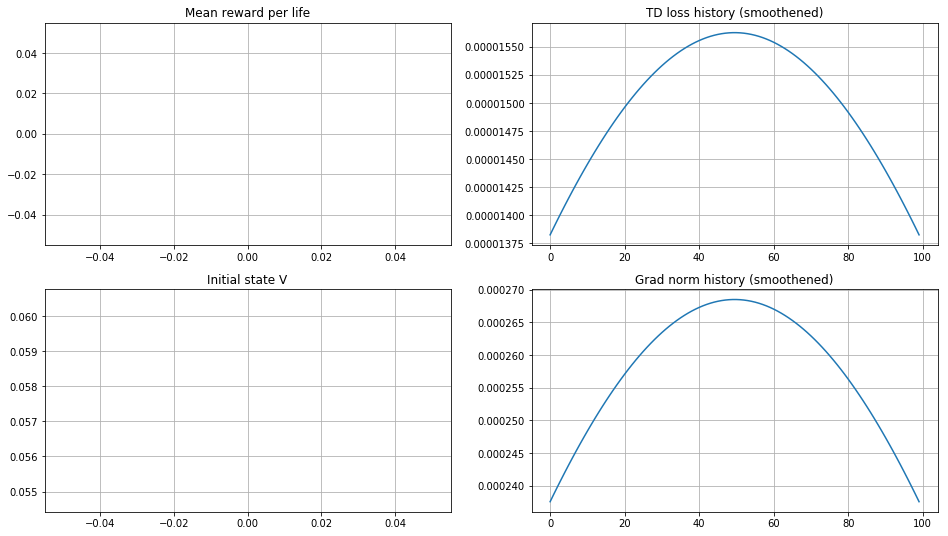

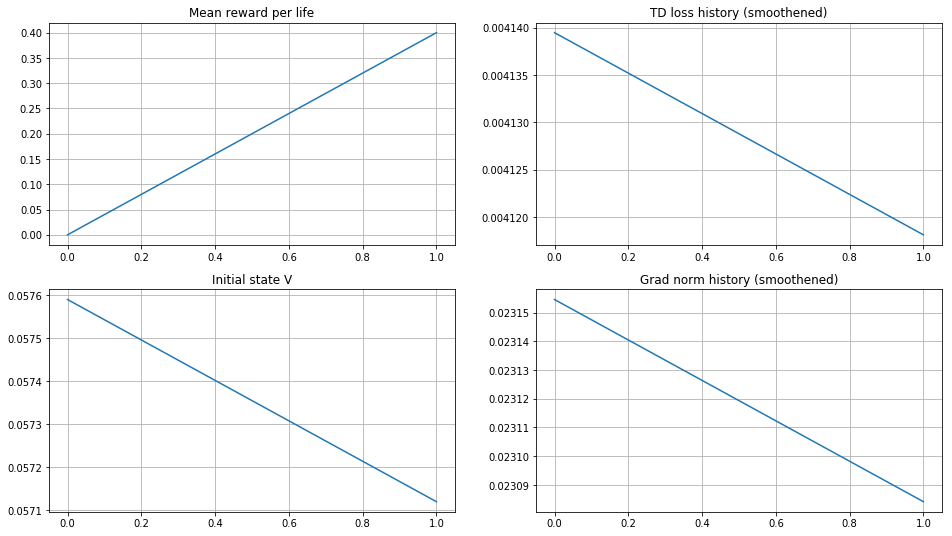

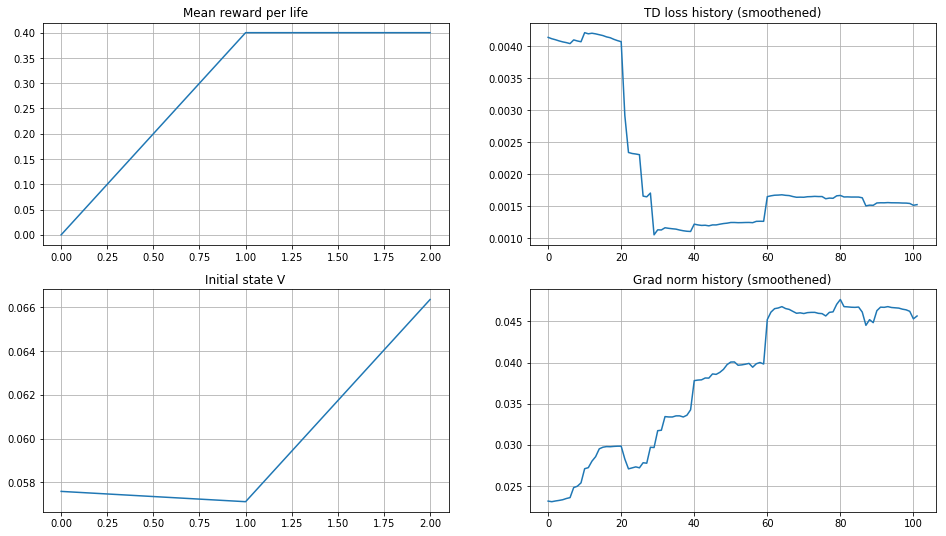

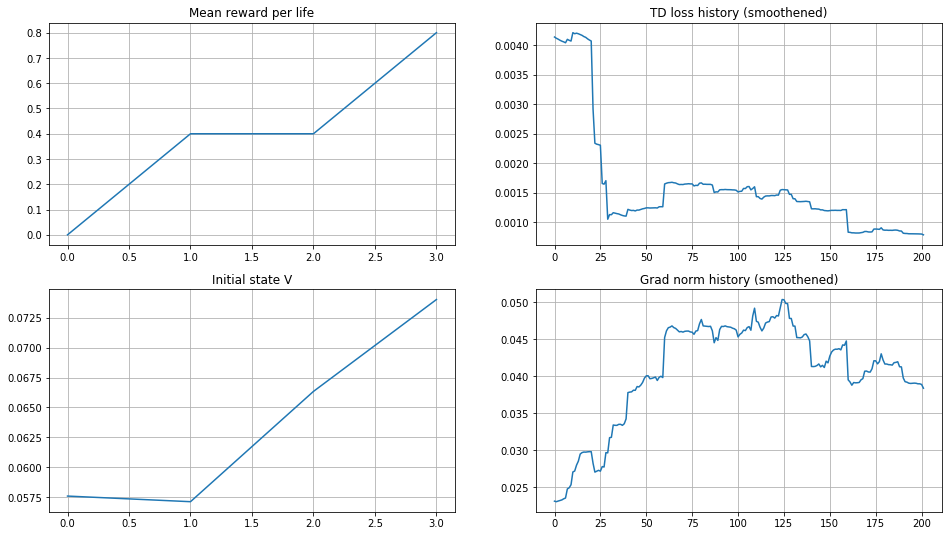

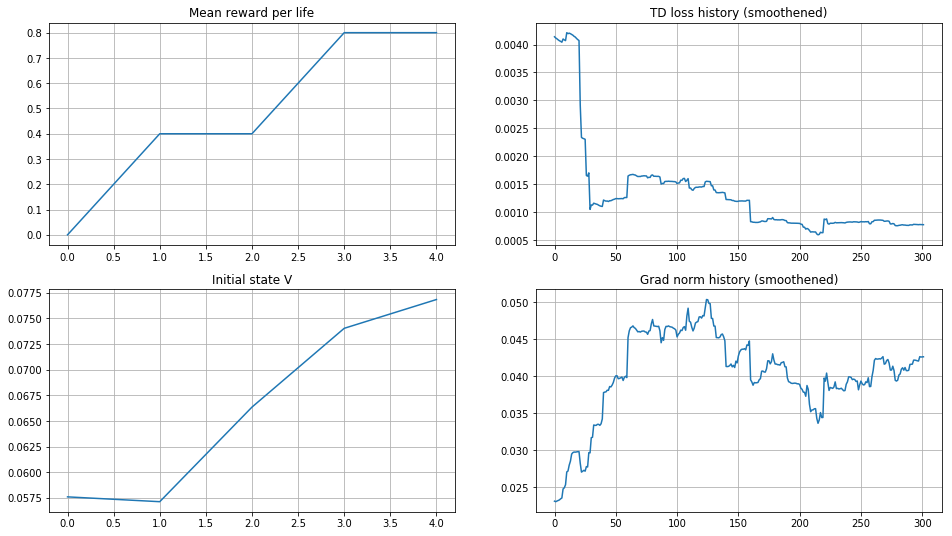

In [34]:
state = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everythin is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)

    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()